In [2]:
!pip install nes-py==0.2.6
!pip install gym-super-mario-bros
!apt-get update
!apt-get install ffmpeg libsm6 libxext6  -y
!apt install -y libgl1-mesa-glx
!pip install opencv-python

     |████████████████████████████████| 75 kB 1.7 MB/s 
     |████████████████████████████████| 21.8 MB 78.6 MB/s 
  Created wheel for nes-py: filename=nes_py-0.2.6-cp37-cp37m-linux_x86_64.whl size=168488 sha256=fc9813efa719db29894aa0e94e708a033ea032563586c207bf8487edf5577af0
  Stored in directory: /root/.cache/pip/wheels/cf/87/a9/d777bc0614683325afc2501fe16a01ae29a9bf6c5650cffbad
Successfully built nes-py
     |████████████████████████████████| 198 kB 5.0 MB/s 
     |████████████████████████████████| 76 kB 6.7 MB/s 
  Created wheel for nes-py: filename=nes_py-8.1.8-cp37-cp37m-linux_x86_64.whl size=437847 sha256=a2dde3472b2c96a72ea52b49041cbf7f6ec53829537d768bb2ebee27a25e6435
  Stored in directory: /root/.cache/pip/wheels/f2/05/1f/608f15ab43187096eb5f3087506419c2d9772e97000f3ba025
Successfully built nes-py
  Attempting uninstall: nes-py
    Found existing installation: nes-py 0.2.6
    Uninstalling nes-py-0.2.6:
      Successfully uninstalled nes-py-0.2.6
Hit:1 http://archive.ubuntu.co

In [3]:
import torch
import torch.nn as nn
import random
from nes_py.wrappers import JoypadSpace
import gym_super_mario_bros
from tqdm.notebook import tqdm_notebook
import pickle 
from gym_super_mario_bros.actions import RIGHT_ONLY, SIMPLE_MOVEMENT, COMPLEX_MOVEMENT
import gym
import numpy as np
import collections 
import cv2
import matplotlib.pyplot as plt

%matplotlib inline
import time
import pylab as pl
from IPython import display
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# RIGHT_ONLY

In [ ]:
RIGHT_ONLY

[['NOOP'], ['right'], ['right', 'A'], ['right', 'B'], ['right', 'A', 'B']]

# SIMPLE_MOVEMENT

In [ ]:
SIMPLE_MOVEMENT

[['NOOP'],
 ['right'],
 ['right', 'A'],
 ['right', 'B'],
 ['right', 'A', 'B'],
 ['A'],
 ['left']]

# COMPLEX_MOVEMENT

In [ ]:
COMPLEX_MOVEMENT

[['NOOP'],
 ['right'],
 ['right', 'A'],
 ['right', 'B'],
 ['right', 'A', 'B'],
 ['A'],
 ['left'],
 ['left', 'A'],
 ['left', 'B'],
 ['left', 'A', 'B'],
 ['down'],
 ['up']]

In [4]:
class MaxAndSkipEnv(gym.Wrapper):
    """
        Each action of the agent is repeated over skip frames
        return only every `skip`-th frame
    """
    def __init__(self, env=None, skip=4):
        super(MaxAndSkipEnv, self).__init__(env)
        # most recent raw observations (for max pooling across time steps)
        self._obs_buffer = collections.deque(maxlen=2)
        self._skip = skip

    def step(self, action):
        total_reward = 0.0
        done = None
        for _ in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            self._obs_buffer.append(obs)
            total_reward += reward
            if done:
                break
        max_frame = np.max(np.stack(self._obs_buffer), axis=0)
        return max_frame, total_reward, done, info

    def reset(self):
        """Clear past frame buffer and init to first obs"""
        self._obs_buffer.clear()
        obs = self.env.reset()
        self._obs_buffer.append(obs)
        return obs


class MarioRescale84x84(gym.ObservationWrapper):
    """
    Downsamples/Rescales each frame to size 84x84 with greyscale
    """
    def __init__(self, env=None):
        super(MarioRescale84x84, self).__init__(env)
        self.observation_space = gym.spaces.Box(low=0, high=255, shape=(84, 84, 1), dtype=np.uint8)

    def observation(self, obs):
        return MarioRescale84x84.process(obs)

    @staticmethod
    def process(frame):
        if frame.size == 240 * 256 * 3:
            img = np.reshape(frame, [240, 256, 3]).astype(np.float32)
        else:
            assert False, "Unknown resolution." 
        # image normalization on RBG
        img = img[:, :, 0] * 0.299 + img[:, :, 1] * 0.587 + img[:, :, 2] * 0.114
        resized_screen = cv2.resize(img, (84, 110), interpolation=cv2.INTER_AREA)
        x_t = resized_screen[18:102, :]
        x_t = np.reshape(x_t, [84, 84, 1])
        return x_t.astype(np.uint8)


class ImageToPyTorch(gym.ObservationWrapper):
    """
    Each frame is converted to PyTorch tensors
    """
    def __init__(self, env):
        super(ImageToPyTorch, self).__init__(env)
        old_shape = self.observation_space.shape
        self.observation_space = gym.spaces.Box(low=0.0, high=1.0, shape=(old_shape[-1], old_shape[0], old_shape[1]), dtype=np.float32)

    def observation(self, observation):
        return np.moveaxis(observation, 2, 0)

    
class BufferWrapper(gym.ObservationWrapper):
    """
    Only every k-th frame is collected by the buffer
    """
    def __init__(self, env, n_steps, dtype=np.float32):
        super(BufferWrapper, self).__init__(env)
        self.dtype = dtype
        old_space = env.observation_space
        self.observation_space = gym.spaces.Box(old_space.low.repeat(n_steps, axis=0),
                                                old_space.high.repeat(n_steps, axis=0), dtype=dtype)

    def reset(self):
        self.buffer = np.zeros_like(self.observation_space.low, dtype=self.dtype)
        return self.observation(self.env.reset())

    def observation(self, observation):
        self.buffer[:-1] = self.buffer[1:]
        self.buffer[-1] = observation
        return self.buffer


class PixelNormalization(gym.ObservationWrapper):
    """
    Normalize pixel values in frame --> 0 to 1
    """
    def observation(self, obs):
        return np.array(obs).astype(np.float32) / 255.0


def create_mario_env(env,movement):
    env = MaxAndSkipEnv(env)
    env = MarioRescale84x84(env)
    env = ImageToPyTorch(env)
    env = BufferWrapper(env, 4)
    env = PixelNormalization(env)
    return JoypadSpace(env, movement)

In [5]:
class DQNSolver(nn.Module):
    """
    Convolutional Neural Net with 3 conv layers and two linear layers
    """
    def __init__(self, input_shape, n_actions):
        # get initializers
        super(DQNSolver, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )

        conv_out_size = self._get_conv_out(input_shape)
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )
    
    def _get_conv_out(self, shape):
        o = self.conv(torch.zeros(1, *shape))
        return int(np.prod(o.size()))

    def forward(self, x):
        conv_out = self.conv(x).view(x.size()[0], -1)
        return self.fc(conv_out)

In [6]:
class DQNAgent:

    def __init__(self, state_space, action_space, max_memory_size, batch_size, gamma, lr,
                 dropout, exploration_max, exploration_min, exploration_decay, double_dqn, pretrained):

        # Define DQN Layers
        self.state_space = state_space
        self.action_space = action_space
        self.double_dqn = double_dqn
        self.pretrained = pretrained
        if torch.cuda.is_available():
            self.device = 'cuda'
            print("Current device is Cuda")    
        else:
            self.device = 'cpu'
            print("Current device is cpu") 
        # Double DQN network
        if self.double_dqn:  
            self.local_net = DQNSolver(state_space, action_space).to(self.device)
            self.target_net = DQNSolver(state_space, action_space).to(self.device)
            
            if self.pretrained:
                self.local_net.load_state_dict(torch.load("DQN1.pt", map_location=torch.device(self.device)))
                self.target_net.load_state_dict(torch.load("DQN2.pt", map_location=torch.device(self.device)))
                    
            self.optimizer = torch.optim.Adam(self.local_net.parameters(), lr=lr)
            self.copy = 5000  # Copy the local model weights into the target network every 5000 steps
            self.step = 0
        # DQN network
        else:  
            self.dqn = DQNSolver(state_space, action_space).to(self.device)
            
            if self.pretrained:
                self.dqn.load_state_dict(torch.load("DQN.pt", map_location=torch.device(self.device)))
            self.optimizer = torch.optim.Adam(self.dqn.parameters(), lr=lr)

        # Create memory
        self.max_memory_size = max_memory_size
        if self.pretrained:
            self.STATE_MEM = torch.load("STATE_MEM.pt")
            self.ACTION_MEM = torch.load("ACTION_MEM.pt")
            self.REWARD_MEM = torch.load("REWARD_MEM.pt")
            self.STATE2_MEM = torch.load("STATE2_MEM.pt")
            self.DONE_MEM = torch.load("DONE_MEM.pt")
            with open("ending_position.pkl", 'rb') as f:
                self.ending_position = pickle.load(f)
            with open("num_in_queue.pkl", 'rb') as f:
                self.num_in_queue = pickle.load(f)
        else:
            self.STATE_MEM = torch.zeros(max_memory_size, *self.state_space)
            self.ACTION_MEM = torch.zeros(max_memory_size, 1)
            self.REWARD_MEM = torch.zeros(max_memory_size, 1)
            self.STATE2_MEM = torch.zeros(max_memory_size, *self.state_space)
            self.DONE_MEM = torch.zeros(max_memory_size, 1)
            self.ending_position = 0
            self.num_in_queue = 0
        
        self.memory_sample_size = batch_size
        
        # Learning parameters
        self.gamma = gamma
        self.l1 = nn.SmoothL1Loss().to(self.device) # Also known as Huber loss
        self.exploration_max = exploration_max
        self.exploration_rate = exploration_max
        self.exploration_min = exploration_min
        self.exploration_decay = exploration_decay

    def remember(self, state, action, reward, state2, done):
        """Store the experiences in a buffer to use later"""
        self.STATE_MEM[self.ending_position] = state.float()
        self.ACTION_MEM[self.ending_position] = action.float()
        self.REWARD_MEM[self.ending_position] = reward.float()
        self.STATE2_MEM[self.ending_position] = state2.float()
        self.DONE_MEM[self.ending_position] = done.float()
        self.ending_position = (self.ending_position + 1) % self.max_memory_size  # FIFO tensor
        self.num_in_queue = min(self.num_in_queue + 1, self.max_memory_size)
    
    def batch_experiences(self):
        """Randomly sample 'batch size' experiences"""
        idx = random.choices(range(self.num_in_queue), k=self.memory_sample_size)
        STATE = self.STATE_MEM[idx]
        ACTION = self.ACTION_MEM[idx]
        REWARD = self.REWARD_MEM[idx]
        STATE2 = self.STATE2_MEM[idx]
        DONE = self.DONE_MEM[idx]      
        return STATE, ACTION, REWARD, STATE2, DONE
    
    def act(self, state):
        """Epsilon-greedy action"""
        if self.double_dqn:
            self.step += 1
        if random.random() < self.exploration_rate:  
            return torch.tensor([[random.randrange(self.action_space)]])
        if self.double_dqn:
            # Local net is used for the policy
            return torch.argmax(self.local_net(state.to(self.device))).unsqueeze(0).unsqueeze(0).cpu()
        else:
            return torch.argmax(self.dqn(state.to(self.device))).unsqueeze(0).unsqueeze(0).cpu()
    
    def copy_model(self):
        """Copy local net weights into target net for DDQN network"""
        self.target_net.load_state_dict(self.local_net.state_dict())
    
    def experience_replay(self):
        """Use the double Q-update or Q-update equations to update the network weights"""
        if self.double_dqn and self.step % self.copy == 0:
            self.copy_model()

        if self.memory_sample_size > self.num_in_queue:
            return
    
        # Sample a batch of experiences
        STATE, ACTION, REWARD, STATE2, DONE = self.batch_experiences()
        STATE = STATE.to(self.device)
        ACTION = ACTION.to(self.device)
        REWARD = REWARD.to(self.device)
        STATE2 = STATE2.to(self.device)
        DONE = DONE.to(self.device)
        
        self.optimizer.zero_grad()
        if self.double_dqn:
            # Double Q-Learning target is Q*(S, A) <- r + γ max_a Q_target(S', a)
            target = REWARD + torch.mul((self.gamma * self.target_net(STATE2).max(1).values.unsqueeze(1)),  1 - DONE)

            current = self.local_net(STATE).gather(1, ACTION.long()) # Local net approximation of Q-value
        else:
            # Q-Learning target is Q*(S, A) <- r + γ max_a Q(S', a) 
            target = REWARD + torch.mul((self.gamma * self.dqn(STATE2).max(1).values.unsqueeze(1)), 1 - DONE)
                
            current = self.dqn(STATE).gather(1, ACTION.long())
        
        loss = self.l1(current, target)
        loss.backward() # Compute gradients
        self.optimizer.step() # Backpropagate error

        self.exploration_rate *= self.exploration_decay
        
        # Makes sure that exploration rate is always at least 'exploration min'
        self.exploration_rate = max(self.exploration_rate, self.exploration_min)

In [7]:
def show_state(env, ep=0, info=""):
    """While testing show the mario playing environment"""
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("Episode: %d %s" % (ep, info))
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())

In [8]:
def run(training_mode, pretrained, double_dqn, num_episodes = 1000, exploration_max=1, movement = RIGHT_ONLY ):
    env = gym_super_mario_bros.make('SuperMarioBros-1-1-v1')
    env = create_mario_env(env,movement)  # Wraps the environment so that frames are grayscale 
    observation_space = env.observation_space.shape
    action_space = env.action_space.n
    agent = DQNAgent(state_space = observation_space,
                     action_space = action_space,
                     max_memory_size = 30000,
                     batch_size = 32,
                     gamma = 0.90,
                     lr = 25e-5,
                     dropout = 0.2,
                     exploration_max = 1.0,
                     exploration_min = 0.02,
                     exploration_decay = 0.99,
                     double_dqn = double_dqn,
                     pretrained = pretrained)
    
    # Restart the enviroment for each episode
    num_episodes = num_episodes
    env.reset()
    
    total_rewards = []
    average_rewards = []
    
    if training_mode and pretrained:
        with open("total_rewards.pkl", 'rb') as f:
            total_rewards = pickle.load(f)
    
    for ep_num in tqdm_notebook(range(num_episodes)):
        state = env.reset()
        state = torch.Tensor([state])
        total_reward = 0
        steps = 0
        while True:
            if not training_mode:
                show_state(env, ep_num + 1)
            action = agent.act(state)
            steps += 1
            
            state_next, reward, terminal, info = env.step(int(action[0]))
            total_reward += reward
            state_next = torch.Tensor([state_next])
            reward = torch.tensor([reward]).unsqueeze(0)
            
            terminal = torch.tensor([int(terminal)]).unsqueeze(0)
            
            if training_mode:
                agent.remember(state, action, reward, state_next, terminal)
                agent.experience_replay()
            
            state = state_next
            if terminal:
                break
        
        total_rewards.append(total_reward)
        average_rewards.append(np.mean(total_rewards))

        print("=> Episode {} Score = {:.2f}, Average Score = {:.2f}".format(ep_num + 1, total_rewards[-1], np.mean(total_rewards)))
        #num_episodes += 1  
 #  3 if training_mode == False:
#    print("=> Episode {} Score = {:.2f}, Average Score = {:.2f}".format(ep_num + 1, total_rewards[-1], np.mean(total_rewards)))

    # Save the trained memory so that we can continue from where we stop using 'pretrained' = True
    if training_mode:
        with open("ending_position.pkl", "wb") as f:
            pickle.dump(agent.ending_position, f)
        with open("num_in_queue.pkl", "wb") as f:
            pickle.dump(agent.num_in_queue, f)
        with open("total_rewards.pkl", "wb") as f:
            pickle.dump(total_rewards, f)
        if agent.double_dqn:
            torch.save(agent.local_net.state_dict(), "DQN1.pt")
            torch.save(agent.target_net.state_dict(), "DQN2.pt")
        else:
            torch.save(agent.dqn.state_dict(), "DQN.pt")  
        torch.save(agent.STATE_MEM,  "STATE_MEM.pt")
        torch.save(agent.ACTION_MEM, "ACTION_MEM.pt")
        torch.save(agent.REWARD_MEM, "REWARD_MEM.pt")
        torch.save(agent.STATE2_MEM, "STATE2_MEM.pt")
        torch.save(agent.DONE_MEM,   "DONE_MEM.pt")
    # plot Episodes vs Reward
    x = np.arange(1,len(average_rewards)+1)
    y = average_rewards   
    return(x,y)

## Deep Q-Learning Movement => Right Only 

In [ ]:
# Number of episode that you want to train;
episodes_nb = 2000
# For training
deepq_right_x, deepq_right_y = run(training_mode=True, pretrained=False, double_dqn=False, num_episodes=episodes_nb, 
                                   exploration_max = 0.95, movement = RIGHT_ONLY)

Current device is Cuda


  0%|                                        | 1/2000 [00:09<5:17:06,  9.52s/it]

=> Episode 1 Score = 233.00, Average Score = 233.00


  0%|                                        | 2/2000 [00:14<3:49:27,  6.89s/it]

=> Episode 2 Score = 1018.00, Average Score = 625.50


  0%|                                        | 3/2000 [00:15<2:12:31,  3.98s/it]

=> Episode 3 Score = 250.00, Average Score = 500.33


  0%|                                        | 4/2000 [00:15<1:27:26,  2.63s/it]

=> Episode 4 Score = 247.00, Average Score = 437.00


  0%|                                        | 5/2000 [00:16<1:02:28,  1.88s/it]

=> Episode 5 Score = 249.00, Average Score = 399.40


  0%|                                        | 6/2000 [00:18<1:09:55,  2.10s/it]

=> Episode 6 Score = 813.00, Average Score = 468.33


  0%|▏                                       | 7/2000 [00:20<1:11:28,  2.15s/it]

=> Episode 7 Score = 740.00, Average Score = 507.14


  0%|▏                                       | 8/2000 [00:22<1:01:17,  1.85s/it]

=> Episode 8 Score = 612.00, Average Score = 520.25


  0%|▏                                         | 9/2000 [00:23<53:59,  1.63s/it]

=> Episode 9 Score = 615.00, Average Score = 530.78


  0%|▏                                        | 10/2000 [00:23<42:02,  1.27s/it]

=> Episode 10 Score = 248.00, Average Score = 502.50


  1%|▏                                        | 11/2000 [00:25<47:54,  1.45s/it]

=> Episode 11 Score = 624.00, Average Score = 513.55


  1%|▏                                      | 12/2000 [00:29<1:08:23,  2.06s/it]

=> Episode 12 Score = 626.00, Average Score = 522.92


  1%|▎                                      | 13/2000 [00:30<1:01:03,  1.84s/it]

=> Episode 13 Score = 604.00, Average Score = 529.15


  1%|▎                                      | 14/2000 [00:36<1:39:26,  3.00s/it]

=> Episode 14 Score = 583.00, Average Score = 533.00


  1%|▎                                      | 15/2000 [00:36<1:14:03,  2.24s/it]

=> Episode 15 Score = 252.00, Average Score = 514.27


  1%|▎                                        | 16/2000 [00:37<56:37,  1.71s/it]

=> Episode 16 Score = 246.00, Average Score = 497.50


  1%|▎                                        | 17/2000 [00:37<44:44,  1.35s/it]

=> Episode 17 Score = 240.00, Average Score = 482.35


  1%|▎                                      | 18/2000 [00:44<1:38:05,  2.97s/it]

=> Episode 18 Score = 991.00, Average Score = 510.61


  1%|▎                                      | 19/2000 [00:47<1:42:24,  3.10s/it]

=> Episode 19 Score = 1329.00, Average Score = 553.68


  1%|▍                                      | 20/2000 [00:48<1:16:51,  2.33s/it]

=> Episode 20 Score = 240.00, Average Score = 538.00


  1%|▍                                      | 21/2000 [00:54<1:54:08,  3.46s/it]

=> Episode 21 Score = 1002.00, Average Score = 560.10


  1%|▍                                      | 22/2000 [00:55<1:33:11,  2.83s/it]

=> Episode 22 Score = 635.00, Average Score = 563.50


  1%|▍                                      | 23/2000 [00:58<1:31:06,  2.77s/it]

=> Episode 23 Score = 1346.00, Average Score = 597.52


  1%|▍                                      | 24/2000 [00:58<1:08:53,  2.09s/it]

=> Episode 24 Score = 239.00, Average Score = 582.58


  1%|▍                                      | 25/2000 [01:01<1:09:50,  2.12s/it]

=> Episode 25 Score = 1046.00, Average Score = 601.12


  1%|▌                                        | 26/2000 [01:01<54:04,  1.64s/it]

=> Episode 26 Score = 241.00, Average Score = 587.27


  1%|▌                                        | 27/2000 [01:02<42:31,  1.29s/it]

=> Episode 27 Score = 251.00, Average Score = 574.81


  1%|▌                                      | 28/2000 [01:06<1:09:34,  2.12s/it]

=> Episode 28 Score = 1025.00, Average Score = 590.89


  1%|▌                                      | 29/2000 [01:11<1:43:11,  3.14s/it]

=> Episode 29 Score = 1121.00, Average Score = 609.17


  2%|▌                                      | 30/2000 [01:12<1:17:22,  2.36s/it]

=> Episode 30 Score = 237.00, Average Score = 596.77


  2%|▌                                      | 31/2000 [01:14<1:20:00,  2.44s/it]

=> Episode 31 Score = 813.00, Average Score = 603.74


  2%|▌                                      | 32/2000 [01:23<2:25:03,  4.42s/it]

=> Episode 32 Score = 966.00, Average Score = 615.06


  2%|▋                                      | 33/2000 [01:29<2:39:22,  4.86s/it]

=> Episode 33 Score = 728.00, Average Score = 618.48


  2%|▋                                      | 34/2000 [01:40<3:35:55,  6.59s/it]

=> Episode 34 Score = 948.00, Average Score = 628.18


  2%|▋                                      | 35/2000 [01:41<2:43:51,  5.00s/it]

=> Episode 35 Score = 640.00, Average Score = 628.51


  2%|▋                                      | 36/2000 [01:43<2:08:02,  3.91s/it]

=> Episode 36 Score = 627.00, Average Score = 628.47


  2%|▋                                      | 37/2000 [01:43<1:34:57,  2.90s/it]

=> Episode 37 Score = 240.00, Average Score = 617.97


  2%|▋                                      | 38/2000 [01:44<1:11:42,  2.19s/it]

=> Episode 38 Score = 241.00, Average Score = 608.05


  2%|▊                                      | 39/2000 [01:48<1:37:19,  2.98s/it]

=> Episode 39 Score = 1128.00, Average Score = 621.38


  2%|▊                                      | 40/2000 [01:49<1:13:27,  2.25s/it]

=> Episode 40 Score = 240.00, Average Score = 611.85


  2%|▊                                        | 41/2000 [01:49<56:31,  1.73s/it]

=> Episode 41 Score = 238.00, Average Score = 602.73


  2%|▊                                        | 42/2000 [01:50<49:05,  1.50s/it]

=> Episode 42 Score = 609.00, Average Score = 602.88


  2%|▊                                      | 43/2000 [01:53<1:01:08,  1.87s/it]

=> Episode 43 Score = 591.00, Average Score = 602.60


  2%|▉                                        | 44/2000 [01:54<47:25,  1.45s/it]

=> Episode 44 Score = 247.00, Average Score = 594.52


  2%|▉                                      | 45/2000 [01:57<1:05:03,  2.00s/it]

=> Episode 45 Score = 592.00, Average Score = 594.47


  2%|▉                                        | 46/2000 [01:58<56:09,  1.72s/it]

=> Episode 46 Score = 616.00, Average Score = 594.93


  2%|▉                                        | 47/2000 [02:00<55:17,  1.70s/it]

=> Episode 47 Score = 605.00, Average Score = 595.15


  2%|▉                                      | 48/2000 [02:02<1:01:41,  1.90s/it]

=> Episode 48 Score = 1043.00, Average Score = 604.48


  2%|█                                        | 49/2000 [02:03<55:03,  1.69s/it]

=> Episode 49 Score = 635.00, Average Score = 605.10


  2%|█                                        | 50/2000 [02:05<57:49,  1.78s/it]

=> Episode 50 Score = 1058.00, Average Score = 614.16


  3%|▉                                      | 51/2000 [02:28<4:24:55,  8.16s/it]

=> Episode 51 Score = 803.00, Average Score = 617.86


  3%|█                                      | 52/2000 [02:32<3:44:04,  6.90s/it]

=> Episode 52 Score = 798.00, Average Score = 621.33


  3%|█                                      | 53/2000 [02:34<2:51:33,  5.29s/it]

=> Episode 53 Score = 618.00, Average Score = 621.26


  3%|█                                      | 54/2000 [02:36<2:23:27,  4.42s/it]

=> Episode 54 Score = 622.00, Average Score = 621.28


  3%|█                                      | 55/2000 [02:37<1:52:09,  3.46s/it]

=> Episode 55 Score = 634.00, Average Score = 621.51


  3%|█                                      | 56/2000 [02:38<1:23:58,  2.59s/it]

=> Episode 56 Score = 234.00, Average Score = 614.59


  3%|█                                      | 57/2000 [02:43<1:52:10,  3.46s/it]

=> Episode 57 Score = 1005.00, Average Score = 621.44


  3%|█▏                                     | 58/2000 [02:55<3:07:08,  5.78s/it]

=> Episode 58 Score = 951.00, Average Score = 627.12


  3%|█▏                                     | 59/2000 [02:55<2:16:01,  4.21s/it]

=> Episode 59 Score = 247.00, Average Score = 620.68


  3%|█▏                                     | 60/2000 [02:59<2:08:53,  3.99s/it]

=> Episode 60 Score = 594.00, Average Score = 620.23


  3%|█▏                                     | 61/2000 [03:05<2:27:49,  4.57s/it]

=> Episode 61 Score = 777.00, Average Score = 622.80


  3%|█▏                                     | 62/2000 [03:10<2:39:16,  4.93s/it]

=> Episode 62 Score = 557.00, Average Score = 621.74


  3%|█▏                                     | 63/2000 [03:12<2:04:40,  3.86s/it]

=> Episode 63 Score = 625.00, Average Score = 621.79


  3%|█▏                                     | 64/2000 [03:16<2:05:01,  3.87s/it]

=> Episode 64 Score = 1022.00, Average Score = 628.05


  3%|█▎                                     | 65/2000 [03:24<2:46:22,  5.16s/it]

=> Episode 65 Score = 969.00, Average Score = 633.29


  3%|█▎                                     | 66/2000 [03:25<2:07:49,  3.97s/it]

=> Episode 66 Score = 608.00, Average Score = 632.91


  3%|█▎                                     | 67/2000 [03:27<1:45:11,  3.26s/it]

=> Episode 67 Score = 603.00, Average Score = 632.46


  3%|█▎                                     | 68/2000 [03:30<1:45:38,  3.28s/it]

=> Episode 68 Score = 1029.00, Average Score = 638.29


  3%|█▎                                     | 69/2000 [03:33<1:41:55,  3.17s/it]

=> Episode 69 Score = 1033.00, Average Score = 644.01


  4%|█▎                                     | 70/2000 [03:33<1:15:41,  2.35s/it]

=> Episode 70 Score = 252.00, Average Score = 638.41


  4%|█▍                                     | 71/2000 [03:37<1:33:42,  2.91s/it]

=> Episode 71 Score = 603.00, Average Score = 637.92


  4%|█▍                                     | 72/2000 [03:39<1:20:50,  2.52s/it]

=> Episode 72 Score = 611.00, Average Score = 637.54


  4%|█▍                                     | 73/2000 [03:41<1:18:08,  2.43s/it]

=> Episode 73 Score = 818.00, Average Score = 640.01


  4%|█▌                                       | 74/2000 [03:42<59:46,  1.86s/it]

=> Episode 74 Score = 240.00, Average Score = 634.61


  4%|█▌                                       | 75/2000 [03:43<52:56,  1.65s/it]

=> Episode 75 Score = 609.00, Average Score = 634.27


  4%|█▍                                     | 76/2000 [03:47<1:15:32,  2.36s/it]

=> Episode 76 Score = 1020.00, Average Score = 639.34


  4%|█▌                                     | 77/2000 [03:49<1:10:17,  2.19s/it]

=> Episode 77 Score = 601.00, Average Score = 638.84


  4%|█▌                                     | 78/2000 [03:50<1:01:42,  1.93s/it]

=> Episode 78 Score = 635.00, Average Score = 638.79


  4%|█▌                                     | 79/2000 [03:58<2:03:19,  3.85s/it]

=> Episode 79 Score = 970.00, Average Score = 642.99


  4%|█▌                                     | 80/2000 [03:59<1:31:13,  2.85s/it]

=> Episode 80 Score = 240.00, Average Score = 637.95


  4%|█▌                                     | 81/2000 [03:59<1:08:59,  2.16s/it]

=> Episode 81 Score = 243.00, Average Score = 633.07


  4%|█▋                                       | 82/2000 [04:00<53:22,  1.67s/it]

=> Episode 82 Score = 236.00, Average Score = 628.23


  4%|█▋                                       | 83/2000 [04:01<42:10,  1.32s/it]

=> Episode 83 Score = 239.00, Average Score = 623.54


  4%|█▋                                       | 84/2000 [04:01<34:18,  1.07s/it]

=> Episode 84 Score = 239.00, Average Score = 618.96


  4%|█▋                                     | 85/2000 [04:05<1:00:14,  1.89s/it]

=> Episode 85 Score = 578.00, Average Score = 618.48


  4%|█▊                                       | 86/2000 [04:06<53:07,  1.67s/it]

=> Episode 86 Score = 623.00, Average Score = 618.53


  4%|█▊                                       | 87/2000 [04:06<42:05,  1.32s/it]

=> Episode 87 Score = 239.00, Average Score = 614.17


  4%|█▊                                       | 88/2000 [04:08<44:11,  1.39s/it]

=> Episode 88 Score = 623.00, Average Score = 614.27


  4%|█▊                                       | 89/2000 [04:09<41:00,  1.29s/it]

=> Episode 89 Score = 613.00, Average Score = 614.26


  4%|█▊                                       | 90/2000 [04:10<33:33,  1.05s/it]

=> Episode 90 Score = 239.00, Average Score = 610.09


  5%|█▊                                       | 91/2000 [04:12<46:54,  1.47s/it]

=> Episode 91 Score = 815.00, Average Score = 612.34


  5%|█▊                                     | 92/2000 [04:24<2:23:21,  4.51s/it]

=> Episode 92 Score = 708.00, Average Score = 613.38


  5%|█▊                                     | 93/2000 [04:25<1:53:03,  3.56s/it]

=> Episode 93 Score = 633.00, Average Score = 613.59


  5%|█▊                                     | 94/2000 [04:25<1:23:24,  2.63s/it]

=> Episode 94 Score = 247.00, Average Score = 609.69


  5%|█▊                                     | 95/2000 [04:26<1:03:23,  2.00s/it]

=> Episode 95 Score = 240.00, Average Score = 605.80


  5%|█▊                                     | 96/2000 [04:30<1:26:14,  2.72s/it]

=> Episode 96 Score = 717.00, Average Score = 606.96


  5%|█▉                                     | 97/2000 [04:31<1:10:43,  2.23s/it]

=> Episode 97 Score = 614.00, Average Score = 607.03


  5%|█▉                                     | 98/2000 [04:34<1:11:17,  2.25s/it]

=> Episode 98 Score = 641.00, Average Score = 607.38


  5%|█▉                                     | 99/2000 [04:35<1:02:55,  1.99s/it]

=> Episode 99 Score = 613.00, Average Score = 607.43


  5%|██                                      | 100/2000 [04:36<48:22,  1.53s/it]

=> Episode 100 Score = 250.00, Average Score = 603.86


  5%|█▉                                    | 101/2000 [04:39<1:03:13,  2.00s/it]

=> Episode 101 Score = 761.00, Average Score = 605.42


  5%|██                                      | 102/2000 [04:39<49:13,  1.56s/it]

=> Episode 102 Score = 238.00, Average Score = 601.81


  5%|█▉                                    | 103/2000 [04:43<1:12:05,  2.28s/it]

=> Episode 103 Score = 798.00, Average Score = 603.72


  5%|██                                      | 104/2000 [04:44<55:27,  1.75s/it]

=> Episode 104 Score = 240.00, Average Score = 600.22


  5%|██                                      | 105/2000 [04:44<43:53,  1.39s/it]

=> Episode 105 Score = 239.00, Average Score = 596.78


  5%|██                                      | 106/2000 [04:45<40:05,  1.27s/it]

=> Episode 106 Score = 610.00, Average Score = 596.91


  5%|██▏                                     | 107/2000 [04:46<32:51,  1.04s/it]

=> Episode 107 Score = 240.00, Average Score = 593.57


  5%|██▏                                     | 108/2000 [04:47<37:08,  1.18s/it]

=> Episode 108 Score = 607.00, Average Score = 593.69


  5%|██▏                                     | 109/2000 [04:48<36:23,  1.15s/it]

=> Episode 109 Score = 610.00, Average Score = 593.84


  6%|██                                    | 110/2000 [05:00<2:18:03,  4.38s/it]

=> Episode 110 Score = 701.00, Average Score = 594.82


  6%|██                                    | 111/2000 [05:03<2:03:29,  3.92s/it]

=> Episode 111 Score = 607.00, Average Score = 594.93


  6%|██▏                                   | 112/2000 [05:05<1:48:16,  3.44s/it]

=> Episode 112 Score = 1047.00, Average Score = 598.96


  6%|██▏                                   | 113/2000 [05:08<1:38:18,  3.13s/it]

=> Episode 113 Score = 1042.00, Average Score = 602.88


  6%|██▏                                   | 114/2000 [05:08<1:13:36,  2.34s/it]

=> Episode 114 Score = 236.00, Average Score = 599.67


  6%|██▏                                   | 115/2000 [05:10<1:03:06,  2.01s/it]

=> Episode 115 Score = 618.00, Average Score = 599.83


  6%|██▏                                   | 116/2000 [05:12<1:04:29,  2.05s/it]

=> Episode 116 Score = 1045.00, Average Score = 603.66


  6%|██▏                                   | 117/2000 [05:25<2:49:48,  5.41s/it]

=> Episode 117 Score = 924.00, Average Score = 606.40


  6%|██▏                                   | 118/2000 [05:31<2:58:31,  5.69s/it]

=> Episode 118 Score = 768.00, Average Score = 607.77


  6%|██▎                                   | 119/2000 [05:33<2:25:00,  4.63s/it]

=> Episode 119 Score = 1047.00, Average Score = 611.46


  6%|██▎                                   | 120/2000 [05:35<1:53:29,  3.62s/it]

=> Episode 120 Score = 626.00, Average Score = 611.58


  6%|██▎                                   | 121/2000 [05:36<1:30:05,  2.88s/it]

=> Episode 121 Score = 635.00, Average Score = 611.78


  6%|██▎                                   | 122/2000 [05:36<1:07:29,  2.16s/it]

=> Episode 122 Score = 252.00, Average Score = 608.83


  6%|██▎                                   | 123/2000 [05:38<1:01:28,  1.97s/it]

=> Episode 123 Score = 633.00, Average Score = 609.02


  6%|██▎                                   | 124/2000 [05:40<1:03:58,  2.05s/it]

=> Episode 124 Score = 817.00, Average Score = 610.70


  6%|██▍                                   | 125/2000 [05:43<1:07:44,  2.17s/it]

=> Episode 125 Score = 1152.00, Average Score = 615.03


  6%|██▍                                   | 126/2000 [05:49<1:51:36,  3.57s/it]

=> Episode 126 Score = 562.00, Average Score = 614.61


  6%|██▍                                   | 127/2000 [05:50<1:22:58,  2.66s/it]

=> Episode 127 Score = 236.00, Average Score = 611.63


  6%|██▍                                   | 128/2000 [06:02<2:51:32,  5.50s/it]

=> Episode 128 Score = 523.00, Average Score = 610.94


  6%|██▍                                   | 129/2000 [06:15<3:59:35,  7.68s/it]

=> Episode 129 Score = 638.00, Average Score = 611.15


  6%|██▍                                   | 130/2000 [06:17<3:11:29,  6.14s/it]

=> Episode 130 Score = 755.00, Average Score = 612.25


  7%|██▍                                   | 131/2000 [06:19<2:33:38,  4.93s/it]

=> Episode 131 Score = 602.00, Average Score = 612.18


  7%|██▌                                   | 132/2000 [06:22<2:11:31,  4.22s/it]

=> Episode 132 Score = 1158.00, Average Score = 616.31


  7%|██▌                                   | 133/2000 [06:23<1:36:46,  3.11s/it]

=> Episode 133 Score = 239.00, Average Score = 613.47


  7%|██▌                                   | 134/2000 [06:25<1:26:49,  2.79s/it]

=> Episode 134 Score = 1050.00, Average Score = 616.73


  7%|██▌                                   | 135/2000 [06:45<4:14:17,  8.18s/it]

=> Episode 135 Score = 420.00, Average Score = 615.27


  7%|██▌                                   | 136/2000 [06:46<3:06:51,  6.01s/it]

=> Episode 136 Score = 609.00, Average Score = 615.23


  7%|██▌                                   | 137/2000 [06:49<2:31:24,  4.88s/it]

=> Episode 137 Score = 608.00, Average Score = 615.18


  7%|██▌                                   | 138/2000 [06:52<2:15:37,  4.37s/it]

=> Episode 138 Score = 1033.00, Average Score = 618.20


  7%|██▋                                   | 139/2000 [06:53<1:48:00,  3.48s/it]

=> Episode 139 Score = 607.00, Average Score = 618.12


  7%|██▋                                   | 140/2000 [06:55<1:29:31,  2.89s/it]

=> Episode 140 Score = 620.00, Average Score = 618.14


  7%|██▋                                   | 141/2000 [06:56<1:12:30,  2.34s/it]

=> Episode 141 Score = 621.00, Average Score = 618.16


  7%|██▋                                   | 142/2000 [07:19<4:27:46,  8.65s/it]

=> Episode 142 Score = 798.00, Average Score = 619.42


  7%|██▋                                   | 143/2000 [07:24<3:49:21,  7.41s/it]

=> Episode 143 Score = 790.00, Average Score = 620.62


  7%|██▋                                   | 144/2000 [07:25<2:55:18,  5.67s/it]

=> Episode 144 Score = 603.00, Average Score = 620.49


  7%|██▊                                   | 145/2000 [07:26<2:13:36,  4.32s/it]

=> Episode 145 Score = 637.00, Average Score = 620.61


  7%|██▊                                   | 146/2000 [07:28<1:50:22,  3.57s/it]

=> Episode 146 Score = 626.00, Average Score = 620.64


  7%|██▊                                   | 147/2000 [07:31<1:46:23,  3.45s/it]

=> Episode 147 Score = 806.00, Average Score = 621.90


  7%|██▊                                   | 148/2000 [07:34<1:40:56,  3.27s/it]

=> Episode 148 Score = 615.00, Average Score = 621.86


  7%|██▊                                   | 149/2000 [07:37<1:40:10,  3.25s/it]

=> Episode 149 Score = 1036.00, Average Score = 624.64


  8%|██▊                                   | 150/2000 [07:40<1:38:11,  3.18s/it]

=> Episode 150 Score = 808.00, Average Score = 625.86


  8%|██▊                                   | 151/2000 [07:43<1:35:09,  3.09s/it]

=> Episode 151 Score = 1037.00, Average Score = 628.58


  8%|██▉                                   | 152/2000 [07:44<1:11:06,  2.31s/it]

=> Episode 152 Score = 252.00, Average Score = 626.11


  8%|██▉                                   | 153/2000 [07:48<1:33:18,  3.03s/it]

=> Episode 153 Score = 558.00, Average Score = 625.66


  8%|██▉                                   | 154/2000 [07:55<2:06:49,  4.12s/it]

=> Episode 154 Score = 764.00, Average Score = 626.56


  8%|██▉                                   | 155/2000 [07:58<1:52:50,  3.67s/it]

=> Episode 155 Score = 812.00, Average Score = 627.75


  8%|██▉                                   | 156/2000 [08:01<1:53:12,  3.68s/it]

=> Episode 156 Score = 800.00, Average Score = 628.86


  8%|██▉                                   | 157/2000 [08:03<1:36:17,  3.13s/it]

=> Episode 157 Score = 602.00, Average Score = 628.69


  8%|███                                   | 158/2000 [08:04<1:12:12,  2.35s/it]

=> Episode 158 Score = 237.00, Average Score = 626.21


  8%|███                                   | 159/2000 [08:07<1:22:01,  2.67s/it]

=> Episode 159 Score = 1032.00, Average Score = 628.76


  8%|███                                   | 160/2000 [08:13<1:51:34,  3.64s/it]

=> Episode 160 Score = 711.00, Average Score = 629.27


  8%|███                                   | 161/2000 [08:16<1:41:47,  3.32s/it]

=> Episode 161 Score = 637.00, Average Score = 629.32


  8%|███                                   | 162/2000 [08:16<1:16:25,  2.49s/it]

=> Episode 162 Score = 236.00, Average Score = 626.90


  8%|███                                   | 163/2000 [08:20<1:22:58,  2.71s/it]

=> Episode 163 Score = 585.00, Average Score = 626.64


  8%|███                                   | 164/2000 [08:20<1:02:39,  2.05s/it]

=> Episode 164 Score = 244.00, Average Score = 624.30


  8%|███▎                                    | 165/2000 [08:22<57:40,  1.89s/it]

=> Episode 165 Score = 607.00, Average Score = 624.20


  8%|███▎                                    | 166/2000 [08:22<45:23,  1.48s/it]

=> Episode 166 Score = 232.00, Average Score = 621.84


  8%|███▎                                    | 167/2000 [08:23<42:01,  1.38s/it]

=> Episode 167 Score = 629.00, Average Score = 621.88


  8%|███▎                                    | 168/2000 [08:26<56:28,  1.85s/it]

=> Episode 168 Score = 808.00, Average Score = 622.99


  8%|███▏                                  | 169/2000 [08:30<1:11:37,  2.35s/it]

=> Episode 169 Score = 612.00, Average Score = 622.92


  8%|███▏                                  | 170/2000 [08:40<2:27:32,  4.84s/it]

=> Episode 170 Score = 521.00, Average Score = 622.32


  9%|███▏                                  | 171/2000 [08:41<1:51:53,  3.67s/it]

=> Episode 171 Score = 610.00, Average Score = 622.25


  9%|███▎                                  | 172/2000 [08:42<1:22:46,  2.72s/it]

=> Episode 172 Score = 242.00, Average Score = 620.04


  9%|███▎                                  | 173/2000 [08:44<1:20:57,  2.66s/it]

=> Episode 173 Score = 1347.00, Average Score = 624.24


  9%|███▎                                  | 174/2000 [08:46<1:12:31,  2.38s/it]

=> Episode 174 Score = 608.00, Average Score = 624.15


  9%|███▎                                  | 175/2000 [08:49<1:15:26,  2.48s/it]

=> Episode 175 Score = 1588.00, Average Score = 629.66


  9%|███▎                                  | 176/2000 [08:50<1:08:38,  2.26s/it]

=> Episode 176 Score = 604.00, Average Score = 629.51


  9%|███▌                                    | 177/2000 [08:51<52:20,  1.72s/it]

=> Episode 177 Score = 243.00, Average Score = 627.33


  9%|███▍                                  | 178/2000 [08:54<1:05:12,  2.15s/it]

=> Episode 178 Score = 806.00, Average Score = 628.33


  9%|███▌                                    | 179/2000 [08:56<59:18,  1.95s/it]

=> Episode 179 Score = 621.00, Average Score = 628.29


  9%|███▌                                    | 180/2000 [08:57<53:43,  1.77s/it]

=> Episode 180 Score = 637.00, Average Score = 628.34


  9%|███▌                                    | 181/2000 [08:58<47:31,  1.57s/it]

=> Episode 181 Score = 611.00, Average Score = 628.24


  9%|███▋                                    | 182/2000 [09:01<55:47,  1.84s/it]

=> Episode 182 Score = 593.00, Average Score = 628.05


  9%|███▍                                  | 183/2000 [09:11<2:10:16,  4.30s/it]

=> Episode 183 Score = 962.00, Average Score = 629.87


  9%|███▍                                  | 184/2000 [09:12<1:42:09,  3.38s/it]

=> Episode 184 Score = 616.00, Average Score = 629.80


  9%|███▌                                  | 185/2000 [09:14<1:30:50,  3.00s/it]

=> Episode 185 Score = 818.00, Average Score = 630.82


  9%|███▌                                  | 186/2000 [09:30<3:30:26,  6.96s/it]

=> Episode 186 Score = 651.00, Average Score = 630.92


  9%|███▌                                  | 187/2000 [09:57<6:26:57, 12.81s/it]

=> Episode 187 Score = 528.00, Average Score = 630.37


  9%|███▌                                  | 188/2000 [10:04<5:34:39, 11.08s/it]

=> Episode 188 Score = 991.00, Average Score = 632.29


  9%|███▌                                  | 189/2000 [10:05<4:07:52,  8.21s/it]

=> Episode 189 Score = 633.00, Average Score = 632.30


 10%|███▌                                  | 190/2000 [10:07<3:10:34,  6.32s/it]

=> Episode 190 Score = 1050.00, Average Score = 634.49


 10%|███▋                                  | 191/2000 [10:18<3:51:56,  7.69s/it]

=> Episode 191 Score = 538.00, Average Score = 633.99


 10%|███▋                                  | 192/2000 [10:22<3:23:03,  6.74s/it]

=> Episode 192 Score = 614.00, Average Score = 633.89


 10%|███▋                                  | 193/2000 [10:24<2:33:46,  5.11s/it]

=> Episode 193 Score = 609.00, Average Score = 633.76


 10%|███▋                                  | 194/2000 [10:28<2:28:09,  4.92s/it]

=> Episode 194 Score = 614.00, Average Score = 633.65


 10%|███▋                                  | 195/2000 [10:29<1:47:45,  3.58s/it]

=> Episode 195 Score = 246.00, Average Score = 631.67


 10%|███▋                                  | 196/2000 [10:34<2:00:00,  3.99s/it]

=> Episode 196 Score = 784.00, Average Score = 632.44


 10%|███▋                                  | 197/2000 [10:36<1:42:44,  3.42s/it]

=> Episode 197 Score = 602.00, Average Score = 632.29


 10%|███▊                                  | 198/2000 [10:37<1:22:32,  2.75s/it]

=> Episode 198 Score = 625.00, Average Score = 632.25


 10%|███▊                                  | 199/2000 [10:37<1:02:33,  2.08s/it]

=> Episode 199 Score = 245.00, Average Score = 630.31


 10%|███▊                                  | 200/2000 [10:40<1:02:40,  2.09s/it]

=> Episode 200 Score = 603.00, Average Score = 630.17


 10%|███▊                                  | 201/2000 [10:45<1:35:32,  3.19s/it]

=> Episode 201 Score = 553.00, Average Score = 629.79


 10%|███▊                                  | 202/2000 [10:49<1:37:13,  3.24s/it]

=> Episode 202 Score = 616.00, Average Score = 629.72


 10%|███▊                                  | 203/2000 [10:54<1:52:37,  3.76s/it]

=> Episode 203 Score = 732.00, Average Score = 630.22


 10%|███▉                                  | 204/2000 [10:58<1:56:36,  3.90s/it]

=> Episode 204 Score = 603.00, Average Score = 630.09


 10%|███▉                                  | 205/2000 [10:59<1:33:10,  3.11s/it]

=> Episode 205 Score = 634.00, Average Score = 630.11


 10%|███▉                                  | 206/2000 [11:06<2:05:42,  4.20s/it]

=> Episode 206 Score = 570.00, Average Score = 629.82


 10%|███▉                                  | 207/2000 [11:07<1:38:43,  3.30s/it]

=> Episode 207 Score = 637.00, Average Score = 629.85


 10%|███▉                                  | 208/2000 [11:10<1:38:41,  3.30s/it]

=> Episode 208 Score = 1036.00, Average Score = 631.80


 10%|███▉                                  | 209/2000 [11:12<1:21:29,  2.73s/it]

=> Episode 209 Score = 640.00, Average Score = 631.84


 10%|███▉                                  | 210/2000 [11:13<1:10:03,  2.35s/it]

=> Episode 210 Score = 621.00, Average Score = 631.79


 11%|████                                  | 211/2000 [11:15<1:00:46,  2.04s/it]

=> Episode 211 Score = 633.00, Average Score = 631.80


 11%|████▏                                   | 212/2000 [11:16<53:00,  1.78s/it]

=> Episode 212 Score = 637.00, Average Score = 631.82


 11%|████▎                                   | 213/2000 [11:17<48:32,  1.63s/it]

=> Episode 213 Score = 635.00, Average Score = 631.84


 11%|████▎                                   | 214/2000 [11:18<44:09,  1.48s/it]

=> Episode 214 Score = 619.00, Average Score = 631.78


 11%|████▎                                   | 215/2000 [11:19<42:16,  1.42s/it]

=> Episode 215 Score = 639.00, Average Score = 631.81


 11%|████▎                                   | 216/2000 [11:21<43:40,  1.47s/it]

=> Episode 216 Score = 634.00, Average Score = 631.82


 11%|████                                  | 217/2000 [11:25<1:07:38,  2.28s/it]

=> Episode 217 Score = 750.00, Average Score = 632.36


 11%|████▎                                   | 218/2000 [11:26<56:59,  1.92s/it]

=> Episode 218 Score = 611.00, Average Score = 632.27


 11%|████▏                                 | 219/2000 [11:31<1:23:03,  2.80s/it]

=> Episode 219 Score = 1305.00, Average Score = 635.34


 11%|████▏                                 | 220/2000 [11:34<1:22:00,  2.76s/it]

=> Episode 220 Score = 635.00, Average Score = 635.34


 11%|████▏                                 | 221/2000 [11:41<2:03:37,  4.17s/it]

=> Episode 221 Score = 982.00, Average Score = 636.90


 11%|████▏                                 | 222/2000 [11:43<1:38:37,  3.33s/it]

=> Episode 222 Score = 638.00, Average Score = 636.91


 11%|████▏                                 | 223/2000 [11:43<1:14:43,  2.52s/it]

=> Episode 223 Score = 233.00, Average Score = 635.10


 11%|████▎                                 | 224/2000 [11:45<1:03:35,  2.15s/it]

=> Episode 224 Score = 652.00, Average Score = 635.17


 11%|████▎                                 | 225/2000 [11:48<1:12:02,  2.44s/it]

=> Episode 225 Score = 1340.00, Average Score = 638.31


 11%|████▎                                 | 226/2000 [11:51<1:17:38,  2.63s/it]

=> Episode 226 Score = 1037.00, Average Score = 640.07


 11%|████▎                                 | 227/2000 [11:53<1:13:50,  2.50s/it]

=> Episode 227 Score = 818.00, Average Score = 640.85


 11%|████▎                                 | 228/2000 [11:54<1:02:32,  2.12s/it]

=> Episode 228 Score = 631.00, Average Score = 640.81


 11%|████▌                                   | 229/2000 [11:55<54:36,  1.85s/it]

=> Episode 229 Score = 638.00, Average Score = 640.80


 12%|████▌                                   | 230/2000 [11:57<49:33,  1.68s/it]

=> Episode 230 Score = 639.00, Average Score = 640.79


 12%|████▌                                   | 231/2000 [11:57<39:22,  1.34s/it]

=> Episode 231 Score = 236.00, Average Score = 639.04


 12%|████▍                                 | 232/2000 [12:02<1:08:38,  2.33s/it]

=> Episode 232 Score = 1017.00, Average Score = 640.67


 12%|████▍                                 | 233/2000 [12:05<1:13:21,  2.49s/it]

=> Episode 233 Score = 1147.00, Average Score = 642.84


 12%|████▍                                 | 234/2000 [12:07<1:08:56,  2.34s/it]

=> Episode 234 Score = 627.00, Average Score = 642.77


 12%|████▋                                   | 235/2000 [12:08<59:25,  2.02s/it]

=> Episode 235 Score = 640.00, Average Score = 642.76


 12%|████▋                                   | 236/2000 [12:10<57:20,  1.95s/it]

=> Episode 236 Score = 627.00, Average Score = 642.69


 12%|████▋                                   | 237/2000 [12:12<56:54,  1.94s/it]

=> Episode 237 Score = 1069.00, Average Score = 644.49


 12%|████▊                                   | 238/2000 [12:13<49:43,  1.69s/it]

=> Episode 238 Score = 634.00, Average Score = 644.45


 12%|████▌                                 | 239/2000 [12:17<1:09:43,  2.38s/it]

=> Episode 239 Score = 621.00, Average Score = 644.35


 12%|████▌                                 | 240/2000 [12:19<1:11:24,  2.43s/it]

=> Episode 240 Score = 1042.00, Average Score = 646.01


 12%|████▌                                 | 241/2000 [12:22<1:17:21,  2.64s/it]

=> Episode 241 Score = 586.00, Average Score = 645.76


 12%|████▌                                 | 242/2000 [12:26<1:22:17,  2.81s/it]

=> Episode 242 Score = 592.00, Average Score = 645.54


 12%|████▌                                 | 243/2000 [12:26<1:01:44,  2.11s/it]

=> Episode 243 Score = 247.00, Average Score = 643.90


 12%|████▉                                   | 244/2000 [12:27<52:11,  1.78s/it]

=> Episode 244 Score = 610.00, Average Score = 643.76


 12%|████▉                                   | 245/2000 [12:28<48:37,  1.66s/it]

=> Episode 245 Score = 634.00, Average Score = 643.72


 12%|████▉                                   | 246/2000 [12:31<51:50,  1.77s/it]

=> Episode 246 Score = 1163.00, Average Score = 645.83


 12%|████▋                                 | 247/2000 [12:35<1:19:01,  2.70s/it]

=> Episode 247 Score = 739.00, Average Score = 646.21


 12%|████▋                                 | 248/2000 [12:38<1:19:48,  2.73s/it]

=> Episode 248 Score = 613.00, Average Score = 646.07


 12%|████▋                                 | 249/2000 [12:41<1:18:50,  2.70s/it]

=> Episode 249 Score = 812.00, Average Score = 646.74


 12%|█████                                   | 250/2000 [12:41<59:18,  2.03s/it]

=> Episode 250 Score = 251.00, Average Score = 645.16


 13%|█████                                   | 251/2000 [12:43<57:15,  1.96s/it]

=> Episode 251 Score = 1051.00, Average Score = 646.77


 13%|████▊                                 | 252/2000 [12:45<1:00:06,  2.06s/it]

=> Episode 252 Score = 624.00, Average Score = 646.68


 13%|████▊                                 | 253/2000 [12:49<1:17:05,  2.65s/it]

=> Episode 253 Score = 619.00, Average Score = 646.57


 13%|████▊                                 | 254/2000 [12:55<1:42:10,  3.51s/it]

=> Episode 254 Score = 1302.00, Average Score = 649.15


 13%|████▊                                 | 255/2000 [12:57<1:31:41,  3.15s/it]

=> Episode 255 Score = 1044.00, Average Score = 650.70


 13%|████▊                                 | 256/2000 [12:58<1:08:23,  2.35s/it]

=> Episode 256 Score = 248.00, Average Score = 649.13


 13%|████▉                                 | 257/2000 [13:05<1:50:43,  3.81s/it]

=> Episode 257 Score = 988.00, Average Score = 650.45


 13%|████▉                                 | 258/2000 [13:07<1:38:50,  3.40s/it]

=> Episode 258 Score = 1149.00, Average Score = 652.38


 13%|████▉                                 | 259/2000 [13:16<2:26:19,  5.04s/it]

=> Episode 259 Score = 1270.00, Average Score = 654.76


 13%|████▉                                 | 260/2000 [13:37<4:40:33,  9.67s/it]

=> Episode 260 Score = 1131.00, Average Score = 656.60


 13%|████▉                                 | 261/2000 [13:37<3:20:24,  6.91s/it]

=> Episode 261 Score = 252.00, Average Score = 655.05


 13%|████▉                                 | 262/2000 [13:40<2:44:30,  5.68s/it]

=> Episode 262 Score = 1338.00, Average Score = 657.65


 13%|████▉                                 | 263/2000 [13:40<1:59:04,  4.11s/it]

=> Episode 263 Score = 251.00, Average Score = 656.11


 13%|█████                                 | 264/2000 [13:46<2:07:51,  4.42s/it]

=> Episode 264 Score = 1006.00, Average Score = 657.43


 13%|█████                                 | 265/2000 [13:48<1:47:01,  3.70s/it]

=> Episode 265 Score = 1043.00, Average Score = 658.89


 13%|█████                                 | 266/2000 [13:52<1:52:50,  3.90s/it]

=> Episode 266 Score = 1015.00, Average Score = 660.23


 13%|█████                                 | 267/2000 [14:26<6:10:08, 12.81s/it]

=> Episode 267 Score = 139.00, Average Score = 658.27


 13%|█████                                 | 268/2000 [14:26<4:22:54,  9.11s/it]

=> Episode 268 Score = 248.00, Average Score = 656.74


 13%|█████                                 | 269/2000 [14:27<3:07:59,  6.52s/it]

=> Episode 269 Score = 252.00, Average Score = 655.24


 14%|█████▏                                | 270/2000 [14:27<2:15:27,  4.70s/it]

=> Episode 270 Score = 248.00, Average Score = 653.73


 14%|█████▏                                | 271/2000 [14:46<4:14:36,  8.84s/it]

=> Episode 271 Score = 419.00, Average Score = 652.86


 14%|█████▏                                | 272/2000 [14:46<3:02:08,  6.32s/it]

=> Episode 272 Score = 252.00, Average Score = 651.39


 14%|█████▏                                | 273/2000 [14:46<2:11:17,  4.56s/it]

=> Episode 273 Score = 248.00, Average Score = 649.91


 14%|█████▏                                | 274/2000 [14:47<1:35:45,  3.33s/it]

=> Episode 274 Score = 247.00, Average Score = 648.44


 14%|█████▏                                | 275/2000 [14:47<1:11:41,  2.49s/it]

=> Episode 275 Score = 239.00, Average Score = 646.95


 14%|█████▌                                  | 276/2000 [14:48<54:08,  1.88s/it]

=> Episode 276 Score = 252.00, Average Score = 645.52


 14%|█████▎                                | 277/2000 [14:58<2:09:00,  4.49s/it]

=> Episode 277 Score = 671.00, Average Score = 645.61


 14%|█████▎                                | 278/2000 [15:00<1:47:08,  3.73s/it]

=> Episode 278 Score = 1068.00, Average Score = 647.13


 14%|█████▎                                | 279/2000 [15:01<1:18:48,  2.75s/it]

=> Episode 279 Score = 247.00, Average Score = 645.70


 14%|█████▎                                | 280/2000 [15:02<1:03:59,  2.23s/it]

=> Episode 280 Score = 609.00, Average Score = 645.57


 14%|█████▌                                  | 281/2000 [15:02<48:39,  1.70s/it]

=> Episode 281 Score = 252.00, Average Score = 644.17


 14%|█████▋                                  | 282/2000 [15:03<37:51,  1.32s/it]

=> Episode 282 Score = 252.00, Average Score = 642.78


 14%|█████▋                                  | 283/2000 [15:03<30:18,  1.06s/it]

=> Episode 283 Score = 252.00, Average Score = 641.40


 14%|█████▋                                  | 284/2000 [15:04<25:06,  1.14it/s]

=> Episode 284 Score = 247.00, Average Score = 640.01


 14%|█████▋                                  | 285/2000 [15:04<21:33,  1.33it/s]

=> Episode 285 Score = 252.00, Average Score = 638.65


 14%|█████▋                                  | 286/2000 [15:05<19:00,  1.50it/s]

=> Episode 286 Score = 252.00, Average Score = 637.29


 14%|█████▋                                  | 287/2000 [15:07<29:43,  1.04s/it]

=> Episode 287 Score = 1045.00, Average Score = 638.71


 14%|█████▍                                | 288/2000 [15:11<1:01:55,  2.17s/it]

=> Episode 288 Score = 1011.00, Average Score = 640.01


 14%|█████▊                                  | 289/2000 [15:12<47:18,  1.66s/it]

=> Episode 289 Score = 252.00, Average Score = 638.66


 14%|█████▊                                  | 290/2000 [15:12<37:23,  1.31s/it]

=> Episode 290 Score = 250.00, Average Score = 637.32


 15%|█████▊                                  | 291/2000 [15:14<42:38,  1.50s/it]

=> Episode 291 Score = 1045.00, Average Score = 638.73


 15%|█████▊                                  | 292/2000 [15:15<33:48,  1.19s/it]

=> Episode 292 Score = 248.00, Average Score = 637.39


 15%|█████▊                                  | 293/2000 [15:17<43:00,  1.51s/it]

=> Episode 293 Score = 1348.00, Average Score = 639.81


 15%|█████▌                                | 294/2000 [15:48<4:54:12, 10.35s/it]

=> Episode 294 Score = 705.00, Average Score = 640.03


 15%|█████▌                                | 295/2000 [15:49<3:34:50,  7.56s/it]

=> Episode 295 Score = 610.00, Average Score = 639.93


 15%|█████▌                                | 296/2000 [15:49<2:34:07,  5.43s/it]

=> Episode 296 Score = 250.00, Average Score = 638.61


 15%|█████▋                                | 297/2000 [15:50<1:52:03,  3.95s/it]

=> Episode 297 Score = 252.00, Average Score = 637.31


 15%|█████▋                                | 298/2000 [16:03<3:13:20,  6.82s/it]

=> Episode 298 Score = 906.00, Average Score = 638.21


 15%|█████▋                                | 299/2000 [16:10<3:08:30,  6.65s/it]

=> Episode 299 Score = 549.00, Average Score = 637.92


 15%|█████▋                                | 300/2000 [16:10<2:16:21,  4.81s/it]

=> Episode 300 Score = 241.00, Average Score = 636.59


 15%|█████▋                                | 301/2000 [16:13<1:57:01,  4.13s/it]

=> Episode 301 Score = 1145.00, Average Score = 638.28


 15%|█████▋                                | 302/2000 [16:20<2:25:49,  5.15s/it]

=> Episode 302 Score = 1286.00, Average Score = 640.43


 15%|█████▊                                | 303/2000 [16:21<1:45:59,  3.75s/it]

=> Episode 303 Score = 243.00, Average Score = 639.12


 15%|█████▊                                | 304/2000 [16:40<3:56:40,  8.37s/it]

=> Episode 304 Score = 612.00, Average Score = 639.03


 15%|█████▊                                | 305/2000 [16:45<3:24:18,  7.23s/it]

=> Episode 305 Score = 586.00, Average Score = 638.85


 15%|█████▊                                | 306/2000 [17:03<5:00:32, 10.64s/it]

=> Episode 306 Score = 842.00, Average Score = 639.52


 15%|█████▊                                | 307/2000 [17:20<5:56:16, 12.63s/it]

=> Episode 307 Score = 865.00, Average Score = 640.25


 15%|█████▊                                | 308/2000 [17:22<4:21:05,  9.26s/it]

=> Episode 308 Score = 607.00, Average Score = 640.14


 15%|█████▊                                | 309/2000 [17:24<3:24:55,  7.27s/it]

=> Episode 309 Score = 1036.00, Average Score = 641.42


 16%|█████▉                                | 310/2000 [17:27<2:45:30,  5.88s/it]

=> Episode 310 Score = 813.00, Average Score = 641.98


 16%|█████▉                                | 311/2000 [17:28<2:05:32,  4.46s/it]

=> Episode 311 Score = 611.00, Average Score = 641.88


 16%|█████▉                                | 312/2000 [17:31<1:49:43,  3.90s/it]

=> Episode 312 Score = 603.00, Average Score = 641.75


 16%|█████▉                                | 313/2000 [17:31<1:21:16,  2.89s/it]

=> Episode 313 Score = 237.00, Average Score = 640.46


 16%|█████▉                                | 314/2000 [17:32<1:01:23,  2.18s/it]

=> Episode 314 Score = 237.00, Average Score = 639.18


 16%|█████▉                                | 315/2000 [17:34<1:03:31,  2.26s/it]

=> Episode 315 Score = 1349.00, Average Score = 641.43


 16%|██████                                | 316/2000 [17:39<1:20:29,  2.87s/it]

=> Episode 316 Score = 1016.00, Average Score = 642.61


 16%|██████                                | 317/2000 [17:41<1:13:04,  2.61s/it]

=> Episode 317 Score = 1051.00, Average Score = 643.90


 16%|██████                                | 318/2000 [17:42<1:01:12,  2.18s/it]

=> Episode 318 Score = 622.00, Average Score = 643.83


 16%|██████▍                                 | 319/2000 [17:43<54:38,  1.95s/it]

=> Episode 319 Score = 651.00, Average Score = 643.86


 16%|██████▍                                 | 320/2000 [17:44<48:55,  1.75s/it]

=> Episode 320 Score = 605.00, Average Score = 643.73


 16%|██████                                | 321/2000 [17:48<1:02:25,  2.23s/it]

=> Episode 321 Score = 804.00, Average Score = 644.23


 16%|██████▍                                 | 322/2000 [17:49<51:55,  1.86s/it]

=> Episode 322 Score = 611.00, Average Score = 644.13


 16%|██████▍                                 | 323/2000 [17:51<56:08,  2.01s/it]

=> Episode 323 Score = 816.00, Average Score = 644.66


 16%|██████▍                                 | 324/2000 [17:52<43:11,  1.55s/it]

=> Episode 324 Score = 252.00, Average Score = 643.45


 16%|██████▌                                 | 325/2000 [17:52<34:53,  1.25s/it]

=> Episode 325 Score = 232.00, Average Score = 642.18


 16%|██████▌                                 | 326/2000 [17:53<28:37,  1.03s/it]

=> Episode 326 Score = 242.00, Average Score = 640.96


 16%|██████▌                                 | 327/2000 [17:56<50:03,  1.80s/it]

=> Episode 327 Score = 1041.00, Average Score = 642.18


 16%|██████▌                                 | 328/2000 [17:58<45:35,  1.64s/it]

=> Episode 328 Score = 605.00, Average Score = 642.07


 16%|██████▌                                 | 329/2000 [18:00<49:51,  1.79s/it]

=> Episode 329 Score = 818.00, Average Score = 642.60


 16%|██████▌                                 | 330/2000 [18:01<45:38,  1.64s/it]

=> Episode 330 Score = 632.00, Average Score = 642.57


 17%|██████▌                                 | 331/2000 [18:02<42:57,  1.54s/it]

=> Episode 331 Score = 652.00, Average Score = 642.60


 17%|██████▎                               | 332/2000 [18:09<1:24:53,  3.05s/it]

=> Episode 332 Score = 588.00, Average Score = 642.43


 17%|██████▎                               | 333/2000 [18:12<1:23:10,  2.99s/it]

=> Episode 333 Score = 1578.00, Average Score = 645.24


 17%|██████▎                               | 334/2000 [18:14<1:20:22,  2.89s/it]

=> Episode 334 Score = 1036.00, Average Score = 646.41


 17%|██████▎                               | 335/2000 [18:16<1:08:04,  2.45s/it]

=> Episode 335 Score = 651.00, Average Score = 646.43


 17%|██████▍                               | 336/2000 [18:19<1:11:38,  2.58s/it]

=> Episode 336 Score = 1338.00, Average Score = 648.49


 17%|██████▍                               | 337/2000 [18:21<1:11:13,  2.57s/it]

=> Episode 337 Score = 594.00, Average Score = 648.32


 17%|██████▍                               | 338/2000 [18:23<1:00:52,  2.20s/it]

=> Episode 338 Score = 630.00, Average Score = 648.27


 17%|██████▊                                 | 339/2000 [18:23<46:21,  1.67s/it]

=> Episode 339 Score = 252.00, Average Score = 647.10


 17%|██████▍                               | 340/2000 [18:28<1:17:03,  2.79s/it]

=> Episode 340 Score = 1313.00, Average Score = 649.06


 17%|██████▊                                 | 341/2000 [18:29<58:10,  2.10s/it]

=> Episode 341 Score = 244.00, Average Score = 647.87


 17%|██████▊                                 | 342/2000 [18:31<59:03,  2.14s/it]

=> Episode 342 Score = 817.00, Average Score = 648.37


 17%|██████▊                                 | 343/2000 [18:32<45:36,  1.65s/it]

=> Episode 343 Score = 237.00, Average Score = 647.17


 17%|██████▉                                 | 344/2000 [18:34<47:52,  1.73s/it]

=> Episode 344 Score = 1045.00, Average Score = 648.32


 17%|██████▉                                 | 345/2000 [18:35<46:40,  1.69s/it]

=> Episode 345 Score = 610.00, Average Score = 648.21


 17%|██████▉                                 | 346/2000 [18:36<40:31,  1.47s/it]

=> Episode 346 Score = 606.00, Average Score = 648.09


 17%|██████▉                                 | 347/2000 [18:37<32:44,  1.19s/it]

=> Episode 347 Score = 236.00, Average Score = 646.90


 17%|██████▉                                 | 348/2000 [18:38<33:08,  1.20s/it]

=> Episode 348 Score = 622.00, Average Score = 646.83


 17%|██████▋                               | 349/2000 [18:44<1:12:21,  2.63s/it]

=> Episode 349 Score = 998.00, Average Score = 647.84


 18%|██████▋                               | 350/2000 [18:48<1:23:00,  3.02s/it]

=> Episode 350 Score = 797.00, Average Score = 648.26


 18%|██████▋                               | 351/2000 [18:48<1:01:48,  2.25s/it]

=> Episode 351 Score = 252.00, Average Score = 647.13


 18%|██████▋                               | 352/2000 [18:51<1:02:19,  2.27s/it]

=> Episode 352 Score = 768.00, Average Score = 647.48


 18%|███████                                 | 353/2000 [18:52<53:49,  1.96s/it]

=> Episode 353 Score = 602.00, Average Score = 647.35


 18%|██████▋                               | 354/2000 [18:56<1:10:43,  2.58s/it]

=> Episode 354 Score = 796.00, Average Score = 647.77


 18%|██████▋                               | 355/2000 [19:00<1:23:33,  3.05s/it]

=> Episode 355 Score = 795.00, Average Score = 648.18


 18%|██████▊                               | 356/2000 [19:01<1:09:22,  2.53s/it]

=> Episode 356 Score = 622.00, Average Score = 648.11


 18%|██████▊                               | 357/2000 [19:04<1:09:06,  2.52s/it]

=> Episode 357 Score = 756.00, Average Score = 648.41


 18%|██████▊                               | 358/2000 [19:08<1:24:03,  3.07s/it]

=> Episode 358 Score = 791.00, Average Score = 648.81


 18%|██████▊                               | 359/2000 [19:12<1:34:40,  3.46s/it]

=> Episode 359 Score = 1015.00, Average Score = 649.83


 18%|██████▊                               | 360/2000 [19:16<1:33:05,  3.41s/it]

=> Episode 360 Score = 805.00, Average Score = 650.26


 18%|██████▊                               | 361/2000 [19:17<1:18:07,  2.86s/it]

=> Episode 361 Score = 625.00, Average Score = 650.19


 18%|██████▉                               | 362/2000 [19:22<1:28:35,  3.25s/it]

=> Episode 362 Score = 1131.00, Average Score = 651.52


 18%|██████▉                               | 363/2000 [19:22<1:05:39,  2.41s/it]

=> Episode 363 Score = 252.00, Average Score = 650.42


 18%|██████▉                               | 364/2000 [19:28<1:36:58,  3.56s/it]

=> Episode 364 Score = 994.00, Average Score = 651.36


 18%|██████▉                               | 365/2000 [19:33<1:43:49,  3.81s/it]

=> Episode 365 Score = 590.00, Average Score = 651.19


 18%|██████▉                               | 366/2000 [19:35<1:29:13,  3.28s/it]

=> Episode 366 Score = 611.00, Average Score = 651.08


 18%|██████▉                               | 367/2000 [19:44<2:21:09,  5.19s/it]

=> Episode 367 Score = 665.00, Average Score = 651.12


 18%|██████▉                               | 368/2000 [19:48<2:07:10,  4.68s/it]

=> Episode 368 Score = 802.00, Average Score = 651.53


 18%|███████                               | 369/2000 [19:49<1:39:40,  3.67s/it]

=> Episode 369 Score = 636.00, Average Score = 651.49


 18%|███████                               | 370/2000 [20:03<3:02:37,  6.72s/it]

=> Episode 370 Score = 628.00, Average Score = 651.43


 19%|███████                               | 371/2000 [20:04<2:17:18,  5.06s/it]

=> Episode 371 Score = 654.00, Average Score = 651.43


 19%|███████                               | 372/2000 [20:05<1:46:36,  3.93s/it]

=> Episode 372 Score = 638.00, Average Score = 651.40


 19%|███████                               | 373/2000 [20:08<1:34:01,  3.47s/it]

=> Episode 373 Score = 1044.00, Average Score = 652.45


 19%|███████                               | 374/2000 [20:13<1:47:39,  3.97s/it]

=> Episode 374 Score = 782.00, Average Score = 652.80


 19%|███████▏                              | 375/2000 [20:15<1:32:12,  3.40s/it]

=> Episode 375 Score = 819.00, Average Score = 653.24


 19%|███████▏                              | 376/2000 [20:17<1:23:55,  3.10s/it]

=> Episode 376 Score = 1349.00, Average Score = 655.09


 19%|███████▏                              | 377/2000 [20:26<2:11:33,  4.86s/it]

=> Episode 377 Score = 736.00, Average Score = 655.31


 19%|███████▏                              | 378/2000 [20:34<2:32:56,  5.66s/it]

=> Episode 378 Score = 754.00, Average Score = 655.57


 19%|███████▏                              | 379/2000 [20:35<1:55:58,  4.29s/it]

=> Episode 379 Score = 629.00, Average Score = 655.50


 19%|███████▏                              | 380/2000 [20:36<1:30:17,  3.34s/it]

=> Episode 380 Score = 626.00, Average Score = 655.42


 19%|███████▏                              | 381/2000 [20:39<1:26:44,  3.21s/it]

=> Episode 381 Score = 1342.00, Average Score = 657.22


 19%|███████▎                              | 382/2000 [20:40<1:04:43,  2.40s/it]

=> Episode 382 Score = 241.00, Average Score = 656.13


 19%|███████▎                              | 383/2000 [20:42<1:02:48,  2.33s/it]

=> Episode 383 Score = 818.00, Average Score = 656.55


 19%|███████▎                              | 384/2000 [20:44<1:00:28,  2.25s/it]

=> Episode 384 Score = 819.00, Average Score = 656.98


 19%|███████▋                                | 385/2000 [20:45<52:09,  1.94s/it]

=> Episode 385 Score = 653.00, Average Score = 656.97


 19%|███████▎                              | 386/2000 [20:48<1:04:17,  2.39s/it]

=> Episode 386 Score = 626.00, Average Score = 656.89


 19%|███████▎                              | 387/2000 [20:52<1:10:57,  2.64s/it]

=> Episode 387 Score = 595.00, Average Score = 656.73


 19%|███████▎                              | 388/2000 [21:06<2:45:22,  6.16s/it]

=> Episode 388 Score = 598.00, Average Score = 656.57


 19%|███████▍                              | 389/2000 [21:06<1:59:19,  4.44s/it]

=> Episode 389 Score = 248.00, Average Score = 655.52


 20%|███████▍                              | 390/2000 [21:09<1:43:17,  3.85s/it]

=> Episode 390 Score = 617.00, Average Score = 655.43


 20%|███████▍                              | 391/2000 [21:13<1:42:27,  3.82s/it]

=> Episode 391 Score = 799.00, Average Score = 655.79


 20%|███████▍                              | 392/2000 [21:15<1:29:28,  3.34s/it]

=> Episode 392 Score = 629.00, Average Score = 655.72


 20%|███████▍                              | 393/2000 [21:16<1:15:04,  2.80s/it]

=> Episode 393 Score = 604.00, Average Score = 655.59


 20%|███████▍                              | 394/2000 [21:19<1:10:26,  2.63s/it]

=> Episode 394 Score = 818.00, Average Score = 656.01


 20%|███████▌                              | 395/2000 [21:24<1:35:40,  3.58s/it]

=> Episode 395 Score = 580.00, Average Score = 655.81


 20%|███████▌                              | 396/2000 [21:34<2:22:57,  5.35s/it]

=> Episode 396 Score = 730.00, Average Score = 656.00


 20%|███████▌                              | 397/2000 [21:34<1:44:07,  3.90s/it]

=> Episode 397 Score = 243.00, Average Score = 654.96


 20%|███████▌                              | 398/2000 [21:39<1:46:00,  3.97s/it]

=> Episode 398 Score = 598.00, Average Score = 654.82


 20%|███████▌                              | 399/2000 [21:40<1:24:37,  3.17s/it]

=> Episode 399 Score = 637.00, Average Score = 654.77


 20%|███████▌                              | 400/2000 [21:42<1:15:45,  2.84s/it]

=> Episode 400 Score = 1046.00, Average Score = 655.75


 20%|███████▌                              | 401/2000 [21:43<1:03:23,  2.38s/it]

=> Episode 401 Score = 640.00, Average Score = 655.71


 20%|████████                                | 402/2000 [21:45<54:19,  2.04s/it]

=> Episode 402 Score = 637.00, Average Score = 655.66


 20%|████████                                | 403/2000 [21:46<51:14,  1.93s/it]

=> Episode 403 Score = 637.00, Average Score = 655.62


 20%|████████                                | 404/2000 [21:47<45:33,  1.71s/it]

=> Episode 404 Score = 638.00, Average Score = 655.57


 20%|████████                                | 405/2000 [21:50<54:29,  2.05s/it]

=> Episode 405 Score = 599.00, Average Score = 655.43


 20%|████████                                | 406/2000 [21:53<58:53,  2.22s/it]

=> Episode 406 Score = 1349.00, Average Score = 657.14


 20%|████████▏                               | 407/2000 [21:54<51:30,  1.94s/it]

=> Episode 407 Score = 628.00, Average Score = 657.07


 20%|████████▏                               | 408/2000 [21:55<45:59,  1.73s/it]

=> Episode 408 Score = 653.00, Average Score = 657.06


 20%|███████▊                              | 409/2000 [22:00<1:05:18,  2.46s/it]

=> Episode 409 Score = 1044.00, Average Score = 658.01


 20%|███████▊                              | 410/2000 [22:02<1:02:00,  2.34s/it]

=> Episode 410 Score = 1048.00, Average Score = 658.96


 21%|███████▊                              | 411/2000 [22:09<1:41:40,  3.84s/it]

=> Episode 411 Score = 758.00, Average Score = 659.20


 21%|███████▊                              | 412/2000 [22:14<1:51:34,  4.22s/it]

=> Episode 412 Score = 1315.00, Average Score = 660.79


 21%|███████▊                              | 413/2000 [22:18<1:48:37,  4.11s/it]

=> Episode 413 Score = 599.00, Average Score = 660.64


 21%|███████▊                              | 414/2000 [22:19<1:26:21,  3.27s/it]

=> Episode 414 Score = 634.00, Average Score = 660.58


 21%|███████▉                              | 415/2000 [22:20<1:07:57,  2.57s/it]

=> Episode 415 Score = 608.00, Average Score = 660.45


 21%|████████▎                               | 416/2000 [22:21<57:13,  2.17s/it]

=> Episode 416 Score = 638.00, Average Score = 660.40


 21%|███████▉                              | 417/2000 [22:24<1:00:40,  2.30s/it]

=> Episode 417 Score = 719.00, Average Score = 660.54


 21%|████████▎                               | 418/2000 [22:25<52:37,  2.00s/it]

=> Episode 418 Score = 639.00, Average Score = 660.49


 21%|███████▉                              | 419/2000 [22:32<1:29:30,  3.40s/it]

=> Episode 419 Score = 588.00, Average Score = 660.31


 21%|███████▉                              | 420/2000 [22:33<1:12:30,  2.75s/it]

=> Episode 420 Score = 637.00, Average Score = 660.26


 21%|███████▉                              | 421/2000 [22:35<1:01:24,  2.33s/it]

=> Episode 421 Score = 629.00, Average Score = 660.18


 21%|████████                              | 422/2000 [22:38<1:07:03,  2.55s/it]

=> Episode 422 Score = 615.00, Average Score = 660.08


 21%|████████                              | 423/2000 [22:40<1:02:31,  2.38s/it]

=> Episode 423 Score = 1049.00, Average Score = 661.00


 21%|████████                              | 424/2000 [22:44<1:20:15,  3.06s/it]

=> Episode 424 Score = 1321.00, Average Score = 662.55


 21%|████████                              | 425/2000 [22:47<1:18:55,  3.01s/it]

=> Episode 425 Score = 745.00, Average Score = 662.75


 21%|████████                              | 426/2000 [22:50<1:19:09,  3.02s/it]

=> Episode 426 Score = 1340.00, Average Score = 664.34


 21%|████████                              | 427/2000 [22:53<1:14:05,  2.83s/it]

=> Episode 427 Score = 815.00, Average Score = 664.69


 21%|████████▌                               | 428/2000 [22:53<55:31,  2.12s/it]

=> Episode 428 Score = 252.00, Average Score = 663.72


 21%|████████▏                             | 429/2000 [22:58<1:16:24,  2.92s/it]

=> Episode 429 Score = 727.00, Average Score = 663.87


 22%|████████▏                             | 430/2000 [23:01<1:15:56,  2.90s/it]

=> Episode 430 Score = 1435.00, Average Score = 665.67


 22%|████████▏                             | 431/2000 [23:05<1:26:50,  3.32s/it]

=> Episode 431 Score = 570.00, Average Score = 665.44


 22%|████████▏                             | 432/2000 [23:06<1:10:00,  2.68s/it]

=> Episode 432 Score = 635.00, Average Score = 665.37


 22%|████████▋                               | 433/2000 [23:07<59:51,  2.29s/it]

=> Episode 433 Score = 617.00, Average Score = 665.26


 22%|████████▏                             | 434/2000 [23:12<1:14:22,  2.85s/it]

=> Episode 434 Score = 585.00, Average Score = 665.08


 22%|████████▎                             | 435/2000 [23:14<1:10:30,  2.70s/it]

=> Episode 435 Score = 758.00, Average Score = 665.29


 22%|████████▎                             | 436/2000 [23:16<1:03:46,  2.45s/it]

=> Episode 436 Score = 1050.00, Average Score = 666.17


 22%|████████▎                             | 437/2000 [23:19<1:07:09,  2.58s/it]

=> Episode 437 Score = 809.00, Average Score = 666.50


 22%|████████▊                               | 438/2000 [23:20<56:25,  2.17s/it]

=> Episode 438 Score = 639.00, Average Score = 666.44


 22%|████████▎                             | 439/2000 [23:26<1:30:34,  3.48s/it]

=> Episode 439 Score = 575.00, Average Score = 666.23


 22%|████████▎                             | 440/2000 [23:30<1:34:27,  3.63s/it]

=> Episode 440 Score = 738.00, Average Score = 666.39


 22%|████████▍                             | 441/2000 [23:40<2:19:09,  5.36s/it]

=> Episode 441 Score = 1264.00, Average Score = 667.75


 22%|████████▍                             | 442/2000 [23:42<1:56:23,  4.48s/it]

=> Episode 442 Score = 814.00, Average Score = 668.08


 22%|████████▍                             | 443/2000 [23:44<1:31:09,  3.51s/it]

=> Episode 443 Score = 633.00, Average Score = 668.00


 22%|████████▍                             | 444/2000 [23:47<1:33:48,  3.62s/it]

=> Episode 444 Score = 798.00, Average Score = 668.29


 22%|████████▍                             | 445/2000 [23:49<1:15:28,  2.91s/it]

=> Episode 445 Score = 653.00, Average Score = 668.26


 22%|████████▍                             | 446/2000 [23:50<1:01:54,  2.39s/it]

=> Episode 446 Score = 636.00, Average Score = 668.18


 22%|████████▉                               | 447/2000 [23:52<59:35,  2.30s/it]

=> Episode 447 Score = 1050.00, Average Score = 669.04


 22%|████████▌                             | 448/2000 [23:56<1:11:35,  2.77s/it]

=> Episode 448 Score = 586.00, Average Score = 668.85


 22%|████████▌                             | 449/2000 [23:58<1:10:38,  2.73s/it]

=> Episode 449 Score = 1344.00, Average Score = 670.36


 22%|████████▌                             | 450/2000 [24:01<1:11:31,  2.77s/it]

=> Episode 450 Score = 1342.00, Average Score = 671.85


 23%|█████████                               | 451/2000 [24:02<57:35,  2.23s/it]

=> Episode 451 Score = 612.00, Average Score = 671.72


 23%|█████████                               | 452/2000 [24:04<51:43,  2.00s/it]

=> Episode 452 Score = 607.00, Average Score = 671.57


 23%|█████████                               | 453/2000 [24:04<39:47,  1.54s/it]

=> Episode 453 Score = 245.00, Average Score = 670.63


 23%|████████▋                             | 454/2000 [24:08<1:00:37,  2.35s/it]

=> Episode 454 Score = 598.00, Average Score = 670.47


 23%|████████▋                             | 455/2000 [24:14<1:21:53,  3.18s/it]

=> Episode 455 Score = 592.00, Average Score = 670.30


 23%|████████▋                             | 456/2000 [24:15<1:12:01,  2.80s/it]

=> Episode 456 Score = 631.00, Average Score = 670.21


 23%|████████▋                             | 457/2000 [24:17<1:01:49,  2.40s/it]

=> Episode 457 Score = 619.00, Average Score = 670.10


 23%|████████▋                             | 458/2000 [24:19<1:02:24,  2.43s/it]

=> Episode 458 Score = 1346.00, Average Score = 671.58


 23%|████████▋                             | 459/2000 [24:26<1:36:52,  3.77s/it]

=> Episode 459 Score = 761.00, Average Score = 671.77


 23%|████████▋                             | 460/2000 [24:29<1:29:08,  3.47s/it]

=> Episode 460 Score = 1344.00, Average Score = 673.23


 23%|████████▊                             | 461/2000 [24:31<1:19:54,  3.12s/it]

=> Episode 461 Score = 1065.00, Average Score = 674.08


 23%|████████▊                             | 462/2000 [24:34<1:14:49,  2.92s/it]

=> Episode 462 Score = 1348.00, Average Score = 675.54


 23%|████████▊                             | 463/2000 [24:36<1:10:37,  2.76s/it]

=> Episode 463 Score = 815.00, Average Score = 675.84


 23%|████████▊                             | 464/2000 [24:40<1:17:40,  3.03s/it]

=> Episode 464 Score = 800.00, Average Score = 676.11


 23%|████████▊                             | 465/2000 [24:49<2:02:22,  4.78s/it]

=> Episode 465 Score = 527.00, Average Score = 675.79


 23%|████████▊                             | 466/2000 [24:51<1:38:49,  3.87s/it]

=> Episode 466 Score = 624.00, Average Score = 675.68


 23%|████████▊                             | 467/2000 [24:58<2:04:59,  4.89s/it]

=> Episode 467 Score = 710.00, Average Score = 675.75


 23%|████████▉                             | 468/2000 [25:00<1:46:50,  4.18s/it]

=> Episode 468 Score = 1346.00, Average Score = 677.18


 23%|████████▉                             | 469/2000 [25:02<1:23:55,  3.29s/it]

=> Episode 469 Score = 639.00, Average Score = 677.10


 24%|████████▉                             | 470/2000 [25:03<1:13:22,  2.88s/it]

=> Episode 470 Score = 1053.00, Average Score = 677.90


 24%|████████▉                             | 471/2000 [25:08<1:27:11,  3.42s/it]

=> Episode 471 Score = 787.00, Average Score = 678.13


 24%|████████▉                             | 472/2000 [25:18<2:13:25,  5.24s/it]

=> Episode 472 Score = 731.00, Average Score = 678.25


 24%|████████▉                             | 473/2000 [25:18<1:36:46,  3.80s/it]

=> Episode 473 Score = 252.00, Average Score = 677.34


 24%|█████████                             | 474/2000 [25:20<1:19:12,  3.11s/it]

=> Episode 474 Score = 606.00, Average Score = 677.19


 24%|█████████                             | 475/2000 [25:21<1:04:13,  2.53s/it]

=> Episode 475 Score = 654.00, Average Score = 677.15


 24%|█████████▌                              | 476/2000 [25:22<53:36,  2.11s/it]

=> Episode 476 Score = 630.00, Average Score = 677.05


 24%|█████████▌                              | 477/2000 [25:24<54:12,  2.14s/it]

=> Episode 477 Score = 817.00, Average Score = 677.34


 24%|█████████                             | 478/2000 [25:27<1:01:26,  2.42s/it]

=> Episode 478 Score = 1340.00, Average Score = 678.73


 24%|█████████                             | 479/2000 [25:35<1:41:17,  4.00s/it]

=> Episode 479 Score = 751.00, Average Score = 678.88


 24%|█████████                             | 480/2000 [25:39<1:40:10,  3.95s/it]

=> Episode 480 Score = 621.00, Average Score = 678.76


 24%|█████████▏                            | 481/2000 [25:41<1:30:15,  3.57s/it]

=> Episode 481 Score = 636.00, Average Score = 678.67


 24%|█████████▏                            | 482/2000 [25:44<1:25:09,  3.37s/it]

=> Episode 482 Score = 809.00, Average Score = 678.94


 24%|█████████▏                            | 483/2000 [25:51<1:53:19,  4.48s/it]

=> Episode 483 Score = 760.00, Average Score = 679.11


 24%|█████████▏                            | 484/2000 [25:56<1:51:39,  4.42s/it]

=> Episode 484 Score = 593.00, Average Score = 678.93


 24%|█████████▏                            | 485/2000 [25:58<1:36:01,  3.80s/it]

=> Episode 485 Score = 1349.00, Average Score = 680.31


 24%|█████████▏                            | 486/2000 [26:25<4:32:18, 10.79s/it]

=> Episode 486 Score = 343.00, Average Score = 679.62


 24%|█████████▎                            | 487/2000 [26:39<4:54:25, 11.68s/it]

=> Episode 487 Score = 910.00, Average Score = 680.09


 24%|█████████▎                            | 488/2000 [26:39<3:29:25,  8.31s/it]

=> Episode 488 Score = 252.00, Average Score = 679.21


 24%|█████████▎                            | 489/2000 [26:45<3:12:47,  7.66s/it]

=> Episode 489 Score = 594.00, Average Score = 679.04


 24%|█████████▎                            | 490/2000 [26:49<2:41:29,  6.42s/it]

=> Episode 490 Score = 1335.00, Average Score = 680.38


 25%|█████████▎                            | 491/2000 [26:50<2:00:14,  4.78s/it]

=> Episode 491 Score = 609.00, Average Score = 680.23


 25%|█████████▎                            | 492/2000 [26:59<2:32:05,  6.05s/it]

=> Episode 492 Score = 736.00, Average Score = 680.34


 25%|█████████▎                            | 493/2000 [27:01<2:03:12,  4.91s/it]

=> Episode 493 Score = 641.00, Average Score = 680.26


 25%|█████████▍                            | 494/2000 [27:05<1:57:38,  4.69s/it]

=> Episode 494 Score = 618.00, Average Score = 680.14


 25%|█████████▍                            | 495/2000 [27:08<1:39:02,  3.95s/it]

=> Episode 495 Score = 641.00, Average Score = 680.06


 25%|█████████▍                            | 496/2000 [27:09<1:18:34,  3.13s/it]

=> Episode 496 Score = 632.00, Average Score = 679.96


 25%|█████████▍                            | 497/2000 [27:14<1:36:36,  3.86s/it]

=> Episode 497 Score = 602.00, Average Score = 679.80


 25%|█████████▍                            | 498/2000 [27:17<1:25:07,  3.40s/it]

=> Episode 498 Score = 1350.00, Average Score = 681.15


 25%|█████████▍                            | 499/2000 [27:21<1:32:05,  3.68s/it]

=> Episode 499 Score = 726.00, Average Score = 681.24


 25%|█████████▌                            | 500/2000 [27:22<1:15:35,  3.02s/it]

=> Episode 500 Score = 609.00, Average Score = 681.10


 25%|█████████▌                            | 501/2000 [27:27<1:23:45,  3.35s/it]

=> Episode 501 Score = 1328.00, Average Score = 682.39


 25%|█████████▌                            | 502/2000 [27:28<1:06:24,  2.66s/it]

=> Episode 502 Score = 620.00, Average Score = 682.26


 25%|██████████                              | 503/2000 [27:28<49:49,  2.00s/it]

=> Episode 503 Score = 252.00, Average Score = 681.41


 25%|█████████▌                            | 504/2000 [27:33<1:15:04,  3.01s/it]

=> Episode 504 Score = 563.00, Average Score = 681.17


 25%|█████████▌                            | 505/2000 [27:42<1:53:02,  4.54s/it]

=> Episode 505 Score = 973.00, Average Score = 681.75


 25%|█████████▌                            | 506/2000 [27:47<2:00:39,  4.85s/it]

=> Episode 506 Score = 601.00, Average Score = 681.59


 25%|█████████▋                            | 507/2000 [27:52<2:00:29,  4.84s/it]

=> Episode 507 Score = 1014.00, Average Score = 682.25


 25%|█████████▋                            | 508/2000 [27:55<1:49:50,  4.42s/it]

=> Episode 508 Score = 626.00, Average Score = 682.14


 25%|█████████▋                            | 509/2000 [28:13<3:29:18,  8.42s/it]

=> Episode 509 Score = 2204.00, Average Score = 685.13


 26%|█████████▋                            | 510/2000 [28:14<2:30:18,  6.05s/it]

=> Episode 510 Score = 239.00, Average Score = 684.25


 26%|█████████▋                            | 511/2000 [28:19<2:21:54,  5.72s/it]

=> Episode 511 Score = 1316.00, Average Score = 685.49


 26%|█████████▋                            | 512/2000 [28:33<3:27:57,  8.39s/it]

=> Episode 512 Score = 1196.00, Average Score = 686.48


 26%|█████████▋                            | 513/2000 [28:39<3:11:01,  7.71s/it]

=> Episode 513 Score = 1302.00, Average Score = 687.68


 26%|█████████▊                            | 514/2000 [28:43<2:40:08,  6.47s/it]

=> Episode 514 Score = 800.00, Average Score = 687.90


 26%|█████████▊                            | 515/2000 [28:44<2:01:10,  4.90s/it]

=> Episode 515 Score = 633.00, Average Score = 687.80


 26%|█████████▊                            | 516/2000 [28:50<2:06:25,  5.11s/it]

=> Episode 516 Score = 1117.00, Average Score = 688.63


 26%|█████████▊                            | 517/2000 [28:52<1:46:43,  4.32s/it]

=> Episode 517 Score = 638.00, Average Score = 688.53


 26%|█████████▊                            | 518/2000 [28:55<1:31:42,  3.71s/it]

=> Episode 518 Score = 1348.00, Average Score = 689.80


 26%|█████████▊                            | 519/2000 [28:57<1:22:26,  3.34s/it]

=> Episode 519 Score = 1350.00, Average Score = 691.08


 26%|█████████▉                            | 520/2000 [28:59<1:12:39,  2.95s/it]

=> Episode 520 Score = 1163.00, Average Score = 691.98


 26%|█████████▉                            | 521/2000 [29:04<1:26:34,  3.51s/it]

=> Episode 521 Score = 785.00, Average Score = 692.16


 26%|█████████▉                            | 522/2000 [29:08<1:34:04,  3.82s/it]

=> Episode 522 Score = 1323.00, Average Score = 693.37


 26%|█████████▉                            | 523/2000 [29:13<1:38:14,  3.99s/it]

=> Episode 523 Score = 793.00, Average Score = 693.56


 26%|█████████▉                            | 524/2000 [29:19<1:53:02,  4.59s/it]

=> Episode 524 Score = 1001.00, Average Score = 694.15


 26%|█████████▉                            | 525/2000 [29:23<1:46:51,  4.35s/it]

=> Episode 525 Score = 799.00, Average Score = 694.35


 26%|█████████▉                            | 526/2000 [29:27<1:45:25,  4.29s/it]

=> Episode 526 Score = 1326.00, Average Score = 695.55


 26%|██████████                            | 527/2000 [29:28<1:25:10,  3.47s/it]

=> Episode 527 Score = 617.00, Average Score = 695.40


 26%|██████████                            | 528/2000 [29:36<1:56:28,  4.75s/it]

=> Episode 528 Score = 751.00, Average Score = 695.50


 26%|██████████                            | 529/2000 [29:42<2:07:58,  5.22s/it]

=> Episode 529 Score = 767.00, Average Score = 695.64


 26%|██████████                            | 530/2000 [29:43<1:33:03,  3.80s/it]

=> Episode 530 Score = 252.00, Average Score = 694.80


 27%|██████████                            | 531/2000 [29:47<1:34:03,  3.84s/it]

=> Episode 531 Score = 1023.00, Average Score = 695.42


 27%|██████████                            | 532/2000 [29:52<1:44:51,  4.29s/it]

=> Episode 532 Score = 565.00, Average Score = 695.17


 27%|██████████▏                           | 533/2000 [30:08<3:10:53,  7.81s/it]

=> Episode 533 Score = 573.00, Average Score = 694.95


 27%|██████████▏                           | 534/2000 [30:13<2:52:46,  7.07s/it]

=> Episode 534 Score = 1008.00, Average Score = 695.53


 27%|██████████▏                           | 535/2000 [30:16<2:22:08,  5.82s/it]

=> Episode 535 Score = 1057.00, Average Score = 696.21


 27%|██████████▏                           | 536/2000 [30:20<2:06:52,  5.20s/it]

=> Episode 536 Score = 622.00, Average Score = 696.07


 27%|██████████▏                           | 537/2000 [30:28<2:25:46,  5.98s/it]

=> Episode 537 Score = 977.00, Average Score = 696.59


 27%|██████████▏                           | 538/2000 [30:47<4:01:03,  9.89s/it]

=> Episode 538 Score = 1147.00, Average Score = 697.43


 27%|██████████▏                           | 539/2000 [30:50<3:07:43,  7.71s/it]

=> Episode 539 Score = 1344.00, Average Score = 698.63


 27%|██████████▎                           | 540/2000 [30:53<2:39:53,  6.57s/it]

=> Episode 540 Score = 1855.00, Average Score = 700.77


 27%|██████████▎                           | 541/2000 [30:56<2:08:24,  5.28s/it]

=> Episode 541 Score = 1046.00, Average Score = 701.41


 27%|██████████▎                           | 542/2000 [30:56<1:33:08,  3.83s/it]

=> Episode 542 Score = 252.00, Average Score = 700.58


 27%|██████████▎                           | 543/2000 [30:57<1:12:10,  2.97s/it]

=> Episode 543 Score = 610.00, Average Score = 700.41


 27%|██████████▎                           | 544/2000 [30:59<1:07:19,  2.77s/it]

=> Episode 544 Score = 1350.00, Average Score = 701.61


 27%|██████████▉                             | 545/2000 [31:00<54:10,  2.23s/it]

=> Episode 545 Score = 611.00, Average Score = 701.44


 27%|██████████▉                             | 546/2000 [31:01<44:55,  1.85s/it]

=> Episode 546 Score = 606.00, Average Score = 701.27


 27%|██████████▉                             | 547/2000 [31:04<47:21,  1.96s/it]

=> Episode 547 Score = 1159.00, Average Score = 702.10


 27%|██████████▉                             | 548/2000 [31:05<41:17,  1.71s/it]

=> Episode 548 Score = 613.00, Average Score = 701.94


 27%|██████████▉                             | 549/2000 [31:06<37:56,  1.57s/it]

=> Episode 549 Score = 624.00, Average Score = 701.80


 28%|███████████                             | 550/2000 [31:08<44:23,  1.84s/it]

=> Episode 550 Score = 1348.00, Average Score = 702.97


 28%|███████████                             | 551/2000 [31:10<40:59,  1.70s/it]

=> Episode 551 Score = 634.00, Average Score = 702.85


 28%|███████████                             | 552/2000 [31:12<48:04,  1.99s/it]

=> Episode 552 Score = 1346.00, Average Score = 704.01


 28%|███████████                             | 553/2000 [31:15<51:42,  2.14s/it]

=> Episode 553 Score = 1347.00, Average Score = 705.18


 28%|███████████                             | 554/2000 [31:16<43:09,  1.79s/it]

=> Episode 554 Score = 611.00, Average Score = 705.01


 28%|███████████                             | 555/2000 [31:17<37:02,  1.54s/it]

=> Episode 555 Score = 609.00, Average Score = 704.83


 28%|███████████                             | 556/2000 [31:18<34:28,  1.43s/it]

=> Episode 556 Score = 637.00, Average Score = 704.71


 28%|██████████▌                           | 557/2000 [31:30<1:51:16,  4.63s/it]

=> Episode 557 Score = 1039.00, Average Score = 705.31


 28%|██████████▌                           | 558/2000 [31:34<1:43:31,  4.31s/it]

=> Episode 558 Score = 1334.00, Average Score = 706.44


 28%|██████████▌                           | 559/2000 [31:36<1:26:07,  3.59s/it]

=> Episode 559 Score = 1052.00, Average Score = 707.06


 28%|██████████▋                           | 560/2000 [31:38<1:14:39,  3.11s/it]

=> Episode 560 Score = 1051.00, Average Score = 707.67


 28%|██████████▋                           | 561/2000 [31:40<1:09:37,  2.90s/it]

=> Episode 561 Score = 1338.00, Average Score = 708.79


 28%|██████████▋                           | 562/2000 [31:42<1:05:30,  2.73s/it]

=> Episode 562 Score = 1350.00, Average Score = 709.93


 28%|██████████▋                           | 563/2000 [31:46<1:09:46,  2.91s/it]

=> Episode 563 Score = 1336.00, Average Score = 711.05


 28%|██████████▋                           | 564/2000 [31:50<1:22:03,  3.43s/it]

=> Episode 564 Score = 568.00, Average Score = 710.79


 28%|██████████▋                           | 565/2000 [31:53<1:18:16,  3.27s/it]

=> Episode 565 Score = 1581.00, Average Score = 712.33


 28%|██████████▊                           | 566/2000 [32:10<2:53:10,  7.25s/it]

=> Episode 566 Score = 874.00, Average Score = 712.62


 28%|██████████▊                           | 567/2000 [32:20<3:16:51,  8.24s/it]

=> Episode 567 Score = 2286.00, Average Score = 715.39


 28%|██████████▊                           | 568/2000 [32:22<2:31:18,  6.34s/it]

=> Episode 568 Score = 1051.00, Average Score = 715.98


 28%|██████████▊                           | 569/2000 [32:24<2:01:07,  5.08s/it]

=> Episode 569 Score = 819.00, Average Score = 716.17


 28%|██████████▊                           | 570/2000 [32:30<2:08:26,  5.39s/it]

=> Episode 570 Score = 682.00, Average Score = 716.11


 29%|██████████▊                           | 571/2000 [32:34<1:53:14,  4.75s/it]

=> Episode 571 Score = 808.00, Average Score = 716.27


 29%|██████████▊                           | 572/2000 [32:34<1:22:34,  3.47s/it]

=> Episode 572 Score = 250.00, Average Score = 715.45


 29%|██████████▉                           | 573/2000 [32:39<1:30:54,  3.82s/it]

=> Episode 573 Score = 1849.00, Average Score = 717.43


 29%|██████████▉                           | 574/2000 [32:44<1:38:16,  4.13s/it]

=> Episode 574 Score = 1415.00, Average Score = 718.64


 29%|██████████▉                           | 575/2000 [32:46<1:24:30,  3.56s/it]

=> Episode 575 Score = 819.00, Average Score = 718.82


 29%|██████████▉                           | 576/2000 [32:50<1:25:50,  3.62s/it]

=> Episode 576 Score = 628.00, Average Score = 718.66


 29%|██████████▉                           | 577/2000 [32:53<1:26:33,  3.65s/it]

=> Episode 577 Score = 625.00, Average Score = 718.50


 29%|██████████▉                           | 578/2000 [32:54<1:03:56,  2.70s/it]

=> Episode 578 Score = 252.00, Average Score = 717.69


 29%|███████████                           | 579/2000 [32:57<1:10:03,  2.96s/it]

=> Episode 579 Score = 1036.00, Average Score = 718.24


 29%|███████████                           | 580/2000 [32:59<1:00:03,  2.54s/it]

=> Episode 580 Score = 610.00, Average Score = 718.06


 29%|███████████▌                            | 581/2000 [33:01<56:37,  2.39s/it]

=> Episode 581 Score = 1050.00, Average Score = 718.63


 29%|███████████▋                            | 582/2000 [33:03<54:48,  2.32s/it]

=> Episode 582 Score = 1047.00, Average Score = 719.19


 29%|███████████                           | 583/2000 [33:10<1:29:27,  3.79s/it]

=> Episode 583 Score = 758.00, Average Score = 719.26


 29%|███████████                           | 584/2000 [33:14<1:24:21,  3.57s/it]

=> Episode 584 Score = 1035.00, Average Score = 719.80


 29%|███████████                           | 585/2000 [33:14<1:02:21,  2.64s/it]

=> Episode 585 Score = 248.00, Average Score = 718.99


 29%|███████████▋                            | 586/2000 [33:14<46:49,  1.99s/it]

=> Episode 586 Score = 248.00, Average Score = 718.19


 29%|███████████▋                            | 587/2000 [33:18<59:09,  2.51s/it]

=> Episode 587 Score = 708.00, Average Score = 718.17


 29%|███████████▊                            | 588/2000 [33:20<56:51,  2.42s/it]

=> Episode 588 Score = 818.00, Average Score = 718.34


 29%|███████████▊                            | 589/2000 [33:23<57:10,  2.43s/it]

=> Episode 589 Score = 638.00, Average Score = 718.20


 30%|███████████▊                            | 590/2000 [33:25<56:14,  2.39s/it]

=> Episode 590 Score = 816.00, Average Score = 718.37


 30%|███████████▏                          | 591/2000 [33:30<1:15:10,  3.20s/it]

=> Episode 591 Score = 1155.00, Average Score = 719.11


 30%|███████████▏                          | 592/2000 [33:31<1:00:42,  2.59s/it]

=> Episode 592 Score = 654.00, Average Score = 719.00


 30%|███████████▎                          | 593/2000 [33:38<1:26:27,  3.69s/it]

=> Episode 593 Score = 580.00, Average Score = 718.76


 30%|███████████▎                          | 594/2000 [33:40<1:16:32,  3.27s/it]

=> Episode 594 Score = 819.00, Average Score = 718.93


 30%|███████████▎                          | 595/2000 [33:41<1:02:22,  2.66s/it]

=> Episode 595 Score = 620.00, Average Score = 718.77


 30%|███████████▎                          | 596/2000 [33:49<1:39:41,  4.26s/it]

=> Episode 596 Score = 1642.00, Average Score = 720.32


 30%|███████████▎                          | 597/2000 [33:50<1:17:15,  3.30s/it]

=> Episode 597 Score = 611.00, Average Score = 720.13


 30%|███████████▉                            | 598/2000 [33:51<57:56,  2.48s/it]

=> Episode 598 Score = 247.00, Average Score = 719.34


 30%|███████████▍                          | 599/2000 [33:55<1:09:52,  2.99s/it]

=> Episode 599 Score = 1139.00, Average Score = 720.04


 30%|███████████▍                          | 600/2000 [33:59<1:16:55,  3.30s/it]

=> Episode 600 Score = 1332.00, Average Score = 721.06


 30%|███████████▍                          | 601/2000 [34:15<2:44:32,  7.06s/it]

=> Episode 601 Score = 1206.00, Average Score = 721.87


 30%|███████████▍                          | 602/2000 [34:16<2:03:44,  5.31s/it]

=> Episode 602 Score = 621.00, Average Score = 721.70


 30%|███████████▍                          | 603/2000 [34:17<1:33:18,  4.01s/it]

=> Episode 603 Score = 610.00, Average Score = 721.52


 30%|███████████▍                          | 604/2000 [34:18<1:14:45,  3.21s/it]

=> Episode 604 Score = 617.00, Average Score = 721.34


 30%|███████████▍                          | 605/2000 [34:21<1:08:11,  2.93s/it]

=> Episode 605 Score = 1048.00, Average Score = 721.88


 30%|████████████                            | 606/2000 [34:21<51:24,  2.21s/it]

=> Episode 606 Score = 246.00, Average Score = 721.10


 30%|████████████▏                           | 607/2000 [34:22<44:30,  1.92s/it]

=> Episode 607 Score = 621.00, Average Score = 720.93


 30%|████████████▏                           | 608/2000 [34:23<34:52,  1.50s/it]

=> Episode 608 Score = 241.00, Average Score = 720.14


 30%|████████████▏                           | 609/2000 [34:26<48:23,  2.09s/it]

=> Episode 609 Score = 628.00, Average Score = 719.99


 30%|███████████▌                          | 610/2000 [34:30<1:01:35,  2.66s/it]

=> Episode 610 Score = 1023.00, Average Score = 720.49


 31%|███████████▌                          | 611/2000 [34:37<1:25:31,  3.69s/it]

=> Episode 611 Score = 1288.00, Average Score = 721.42


 31%|███████████▋                          | 612/2000 [34:39<1:16:06,  3.29s/it]

=> Episode 612 Score = 1333.00, Average Score = 722.42


 31%|███████████▋                          | 613/2000 [34:43<1:22:09,  3.55s/it]

=> Episode 613 Score = 1023.00, Average Score = 722.91


 31%|███████████▋                          | 614/2000 [34:44<1:01:23,  2.66s/it]

=> Episode 614 Score = 233.00, Average Score = 722.11


 31%|████████████▎                           | 615/2000 [34:46<58:23,  2.53s/it]

=> Episode 615 Score = 1047.00, Average Score = 722.64


 31%|████████████▎                           | 616/2000 [34:46<44:13,  1.92s/it]

=> Episode 616 Score = 248.00, Average Score = 721.87


 31%|████████████▎                           | 617/2000 [34:47<38:52,  1.69s/it]

=> Episode 617 Score = 616.00, Average Score = 721.70


 31%|████████████▎                           | 618/2000 [34:49<35:09,  1.53s/it]

=> Episode 618 Score = 654.00, Average Score = 721.59


 31%|███████████▊                          | 619/2000 [35:17<3:41:54,  9.64s/it]

=> Episode 619 Score = 2092.00, Average Score = 723.80


 31%|███████████▊                          | 620/2000 [35:31<4:10:31, 10.89s/it]

=> Episode 620 Score = 1226.00, Average Score = 724.61


 31%|███████████▊                          | 621/2000 [35:32<2:59:22,  7.80s/it]

=> Episode 621 Score = 246.00, Average Score = 723.84


 31%|███████████▊                          | 622/2000 [35:40<3:00:16,  7.85s/it]

=> Episode 622 Score = 987.00, Average Score = 724.26


 31%|███████████▊                          | 623/2000 [35:41<2:13:11,  5.80s/it]

=> Episode 623 Score = 611.00, Average Score = 724.08


 31%|███████████▊                          | 624/2000 [35:43<1:47:02,  4.67s/it]

=> Episode 624 Score = 608.00, Average Score = 723.89


 31%|███████████▉                          | 625/2000 [35:44<1:23:39,  3.65s/it]

=> Episode 625 Score = 654.00, Average Score = 723.78


 31%|███████████▉                          | 626/2000 [35:49<1:31:24,  3.99s/it]

=> Episode 626 Score = 1020.00, Average Score = 724.26


 31%|███████████▉                          | 627/2000 [35:56<1:55:49,  5.06s/it]

=> Episode 627 Score = 1662.00, Average Score = 725.75


 31%|███████████▉                          | 628/2000 [36:08<2:42:02,  7.09s/it]

=> Episode 628 Score = 721.00, Average Score = 725.74


 31%|███████████▉                          | 629/2000 [36:10<2:03:45,  5.42s/it]

=> Episode 629 Score = 612.00, Average Score = 725.56


 32%|███████████▉                          | 630/2000 [36:12<1:46:12,  4.65s/it]

=> Episode 630 Score = 737.00, Average Score = 725.58


 32%|███████████▉                          | 631/2000 [36:16<1:41:19,  4.44s/it]

=> Episode 631 Score = 700.00, Average Score = 725.54


 32%|████████████                          | 632/2000 [36:23<1:53:57,  5.00s/it]

=> Episode 632 Score = 602.00, Average Score = 725.34


 32%|████████████                          | 633/2000 [36:29<2:01:05,  5.32s/it]

=> Episode 633 Score = 782.00, Average Score = 725.43


 32%|████████████                          | 634/2000 [36:34<2:01:11,  5.32s/it]

=> Episode 634 Score = 785.00, Average Score = 725.53


 32%|████████████                          | 635/2000 [36:36<1:41:05,  4.44s/it]

=> Episode 635 Score = 598.00, Average Score = 725.33


 32%|████████████                          | 636/2000 [36:38<1:19:15,  3.49s/it]

=> Episode 636 Score = 654.00, Average Score = 725.22


 32%|████████████                          | 637/2000 [36:40<1:14:12,  3.27s/it]

=> Episode 637 Score = 596.00, Average Score = 725.01


 32%|████████████                          | 638/2000 [36:45<1:20:38,  3.55s/it]

=> Episode 638 Score = 1699.00, Average Score = 726.54


 32%|████████████▏                         | 639/2000 [36:46<1:04:59,  2.87s/it]

=> Episode 639 Score = 654.00, Average Score = 726.43


 32%|████████████▏                         | 640/2000 [37:01<2:27:46,  6.52s/it]

=> Episode 640 Score = 1581.00, Average Score = 727.76


 32%|████████████▏                         | 641/2000 [37:04<2:03:52,  5.47s/it]

=> Episode 641 Score = 1040.00, Average Score = 728.25


 32%|████████████▏                         | 642/2000 [37:08<1:55:04,  5.08s/it]

=> Episode 642 Score = 1028.00, Average Score = 728.71


 32%|████████████▏                         | 643/2000 [37:12<1:43:36,  4.58s/it]

=> Episode 643 Score = 1709.00, Average Score = 730.24


 32%|████████████▏                         | 644/2000 [37:15<1:33:39,  4.14s/it]

=> Episode 644 Score = 1581.00, Average Score = 731.56


 32%|████████████▎                         | 645/2000 [37:18<1:24:33,  3.74s/it]

=> Episode 645 Score = 813.00, Average Score = 731.69


 32%|████████████▎                         | 646/2000 [37:20<1:15:06,  3.33s/it]

=> Episode 646 Score = 819.00, Average Score = 731.82


 32%|████████████▎                         | 647/2000 [37:22<1:05:16,  2.89s/it]

=> Episode 647 Score = 731.00, Average Score = 731.82


 32%|████████████▎                         | 648/2000 [37:30<1:38:13,  4.36s/it]

=> Episode 648 Score = 1655.00, Average Score = 733.25


 32%|████████████▎                         | 649/2000 [37:36<1:50:07,  4.89s/it]

=> Episode 649 Score = 779.00, Average Score = 733.32


 32%|████████████▎                         | 650/2000 [37:39<1:42:31,  4.56s/it]

=> Episode 650 Score = 1057.00, Average Score = 733.81


 33%|████████████▎                         | 651/2000 [37:43<1:36:17,  4.28s/it]

=> Episode 651 Score = 628.00, Average Score = 733.65


 33%|████████████▍                         | 652/2000 [37:48<1:40:16,  4.46s/it]

=> Episode 652 Score = 1684.00, Average Score = 735.11


 33%|████████████▍                         | 653/2000 [37:51<1:27:08,  3.88s/it]

=> Episode 653 Score = 818.00, Average Score = 735.24


 33%|████████████▍                         | 654/2000 [38:19<4:15:17, 11.38s/it]

=> Episode 654 Score = 1418.00, Average Score = 736.28


 33%|████████████▍                         | 655/2000 [38:27<3:52:05, 10.35s/it]

=> Episode 655 Score = 1649.00, Average Score = 737.67


 33%|████████████▍                         | 656/2000 [38:31<3:03:49,  8.21s/it]

=> Episode 656 Score = 1707.00, Average Score = 739.15


 33%|████████████▍                         | 657/2000 [38:35<2:40:03,  7.15s/it]

=> Episode 657 Score = 615.00, Average Score = 738.96


 33%|████████████▌                         | 658/2000 [38:36<1:58:47,  5.31s/it]

=> Episode 658 Score = 610.00, Average Score = 738.77


 33%|████████████▌                         | 659/2000 [38:41<1:56:08,  5.20s/it]

=> Episode 659 Score = 1408.00, Average Score = 739.78


 33%|████████████▌                         | 660/2000 [38:47<2:01:09,  5.43s/it]

=> Episode 660 Score = 559.00, Average Score = 739.51


 33%|████████████▌                         | 661/2000 [38:50<1:46:00,  4.75s/it]

=> Episode 661 Score = 632.00, Average Score = 739.34


 33%|████████████▌                         | 662/2000 [38:52<1:27:49,  3.94s/it]

=> Episode 662 Score = 1051.00, Average Score = 739.82


 33%|████████████▌                         | 663/2000 [38:55<1:16:19,  3.43s/it]

=> Episode 663 Score = 818.00, Average Score = 739.93


 33%|████████████▌                         | 664/2000 [38:59<1:20:49,  3.63s/it]

=> Episode 664 Score = 578.00, Average Score = 739.69


 33%|████████████▋                         | 665/2000 [39:25<3:55:06, 10.57s/it]

=> Episode 665 Score = 1452.00, Average Score = 740.76


 33%|████████████▋                         | 666/2000 [39:35<3:51:09, 10.40s/it]

=> Episode 666 Score = 528.00, Average Score = 740.44


 33%|████████████▋                         | 667/2000 [39:54<4:48:28, 12.98s/it]

=> Episode 667 Score = 2211.00, Average Score = 742.65


 33%|████████████▋                         | 668/2000 [39:57<3:37:22,  9.79s/it]

=> Episode 668 Score = 819.00, Average Score = 742.76


 33%|████████████▋                         | 669/2000 [39:57<2:35:42,  7.02s/it]

=> Episode 669 Score = 248.00, Average Score = 742.02


 34%|████████████▋                         | 670/2000 [40:03<2:24:03,  6.50s/it]

=> Episode 670 Score = 1682.00, Average Score = 743.42


 34%|████████████▋                         | 671/2000 [40:07<2:11:03,  5.92s/it]

=> Episode 671 Score = 1570.00, Average Score = 744.66


 34%|████████████▊                         | 672/2000 [40:15<2:21:07,  6.38s/it]

=> Episode 672 Score = 1642.00, Average Score = 745.99


 34%|████████████▊                         | 673/2000 [40:16<1:46:01,  4.79s/it]

=> Episode 673 Score = 607.00, Average Score = 745.78


 34%|████████████▊                         | 674/2000 [40:19<1:33:38,  4.24s/it]

=> Episode 674 Score = 1418.00, Average Score = 746.78


 34%|████████████▊                         | 675/2000 [40:24<1:41:49,  4.61s/it]

=> Episode 675 Score = 718.00, Average Score = 746.74


 34%|████████████▊                         | 676/2000 [40:26<1:23:25,  3.78s/it]

=> Episode 676 Score = 612.00, Average Score = 746.54


 34%|████████████▊                         | 677/2000 [40:32<1:34:37,  4.29s/it]

=> Episode 677 Score = 781.00, Average Score = 746.59


 34%|████████████▉                         | 678/2000 [40:47<2:48:51,  7.66s/it]

=> Episode 678 Score = 493.00, Average Score = 746.22


 34%|████████████▉                         | 679/2000 [40:52<2:28:08,  6.73s/it]

=> Episode 679 Score = 792.00, Average Score = 746.28


 34%|████████████▉                         | 680/2000 [40:54<2:00:36,  5.48s/it]

=> Episode 680 Score = 1429.00, Average Score = 747.29


 34%|████████████▉                         | 681/2000 [40:57<1:40:40,  4.58s/it]

=> Episode 681 Score = 816.00, Average Score = 747.39


 34%|████████████▉                         | 682/2000 [40:57<1:13:35,  3.35s/it]

=> Episode 682 Score = 248.00, Average Score = 746.66


 34%|████████████▉                         | 683/2000 [40:59<1:01:20,  2.79s/it]

=> Episode 683 Score = 627.00, Average Score = 746.48


 34%|█████████████▋                          | 684/2000 [41:01<57:26,  2.62s/it]

=> Episode 684 Score = 1049.00, Average Score = 746.92


 34%|█████████████▋                          | 685/2000 [41:03<54:39,  2.49s/it]

=> Episode 685 Score = 606.00, Average Score = 746.72


 34%|█████████████▋                          | 686/2000 [41:05<53:12,  2.43s/it]

=> Episode 686 Score = 818.00, Average Score = 746.82


 34%|█████████████▋                          | 687/2000 [41:08<54:55,  2.51s/it]

=> Episode 687 Score = 595.00, Average Score = 746.60


 34%|█████████████                         | 688/2000 [41:13<1:13:51,  3.38s/it]

=> Episode 688 Score = 1676.00, Average Score = 747.95


 34%|█████████████                         | 689/2000 [41:18<1:23:38,  3.83s/it]

=> Episode 689 Score = 1676.00, Average Score = 749.30


 34%|█████████████                         | 690/2000 [41:20<1:06:41,  3.05s/it]

=> Episode 690 Score = 654.00, Average Score = 749.16


 35%|█████████████▊                          | 691/2000 [41:21<54:40,  2.51s/it]

=> Episode 691 Score = 654.00, Average Score = 749.02


 35%|█████████████▏                        | 692/2000 [41:26<1:10:45,  3.25s/it]

=> Episode 692 Score = 1682.00, Average Score = 750.37


 35%|█████████████▏                        | 693/2000 [41:33<1:34:08,  4.32s/it]

=> Episode 693 Score = 999.00, Average Score = 750.73


 35%|█████████████▏                        | 694/2000 [41:35<1:20:55,  3.72s/it]

=> Episode 694 Score = 818.00, Average Score = 750.83


 35%|█████████████▏                        | 695/2000 [41:37<1:11:17,  3.28s/it]

=> Episode 695 Score = 819.00, Average Score = 750.93


 35%|█████████████▉                          | 696/2000 [41:38<53:10,  2.45s/it]

=> Episode 696 Score = 252.00, Average Score = 750.21


 35%|█████████████▉                          | 697/2000 [41:40<53:23,  2.46s/it]

=> Episode 697 Score = 818.00, Average Score = 750.31


 35%|█████████████▎                        | 698/2000 [42:04<3:13:41,  8.93s/it]

=> Episode 698 Score = 589.00, Average Score = 750.07


 35%|█████████████▎                        | 699/2000 [42:09<2:49:31,  7.82s/it]

=> Episode 699 Score = 612.00, Average Score = 749.88


 35%|█████████████▎                        | 700/2000 [42:14<2:25:21,  6.71s/it]

=> Episode 700 Score = 1686.00, Average Score = 751.21


 35%|█████████████▎                        | 701/2000 [42:24<2:47:57,  7.76s/it]

=> Episode 701 Score = 733.00, Average Score = 751.19


 35%|█████████████▎                        | 702/2000 [42:26<2:11:50,  6.09s/it]

=> Episode 702 Score = 819.00, Average Score = 751.28


 35%|█████████████▎                        | 703/2000 [42:42<3:19:41,  9.24s/it]

=> Episode 703 Score = 2237.00, Average Score = 753.40


 35%|█████████████▍                        | 704/2000 [43:05<4:43:46, 13.14s/it]

=> Episode 704 Score = 386.00, Average Score = 752.88


 35%|█████████████▍                        | 705/2000 [43:22<5:09:42, 14.35s/it]

=> Episode 705 Score = 643.00, Average Score = 752.72


 35%|█████████████▍                        | 706/2000 [43:44<5:58:07, 16.61s/it]

=> Episode 706 Score = 824.00, Average Score = 752.82


 35%|█████████████▍                        | 707/2000 [43:51<4:58:12, 13.84s/it]

=> Episode 707 Score = 1289.00, Average Score = 753.58


 35%|█████████████▍                        | 708/2000 [43:54<3:49:10, 10.64s/it]

=> Episode 708 Score = 1338.00, Average Score = 754.41


 35%|█████████████▍                        | 709/2000 [43:59<3:08:20,  8.75s/it]

=> Episode 709 Score = 1325.00, Average Score = 755.21


 36%|█████████████▍                        | 710/2000 [44:00<2:19:52,  6.51s/it]

=> Episode 710 Score = 637.00, Average Score = 755.04


 36%|█████████████▌                        | 711/2000 [44:18<3:34:14,  9.97s/it]

=> Episode 711 Score = 1462.00, Average Score = 756.04


 36%|█████████████▌                        | 712/2000 [44:21<2:46:28,  7.76s/it]

=> Episode 712 Score = 1421.00, Average Score = 756.97


 36%|█████████████▌                        | 713/2000 [44:44<4:29:56, 12.58s/it]

=> Episode 713 Score = 794.00, Average Score = 757.02


 36%|█████████████▌                        | 714/2000 [44:52<3:54:46, 10.95s/it]

=> Episode 714 Score = 1647.00, Average Score = 758.27


 36%|█████████████▌                        | 715/2000 [44:54<3:02:16,  8.51s/it]

=> Episode 715 Score = 1342.00, Average Score = 759.09


 36%|█████████████▌                        | 716/2000 [45:00<2:43:09,  7.62s/it]

=> Episode 716 Score = 560.00, Average Score = 758.81


 36%|█████████████▌                        | 717/2000 [45:10<3:01:10,  8.47s/it]

=> Episode 717 Score = 952.00, Average Score = 759.08


 36%|█████████████▋                        | 718/2000 [45:12<2:14:53,  6.31s/it]

=> Episode 718 Score = 612.00, Average Score = 758.87


 36%|█████████████▋                        | 719/2000 [45:12<1:37:28,  4.57s/it]

=> Episode 719 Score = 243.00, Average Score = 758.16


 36%|█████████████▋                        | 720/2000 [45:15<1:23:08,  3.90s/it]

=> Episode 720 Score = 1348.00, Average Score = 758.98


 36%|█████████████▋                        | 721/2000 [45:17<1:15:09,  3.53s/it]

=> Episode 721 Score = 814.00, Average Score = 759.05


 36%|█████████████▋                        | 722/2000 [45:21<1:19:38,  3.74s/it]

=> Episode 722 Score = 1690.00, Average Score = 760.34


 36%|█████████████▋                        | 723/2000 [45:26<1:21:58,  3.85s/it]

=> Episode 723 Score = 1691.00, Average Score = 761.63


 36%|█████████████▊                        | 724/2000 [45:29<1:16:26,  3.59s/it]

=> Episode 724 Score = 1036.00, Average Score = 762.01


 36%|█████████████▊                        | 725/2000 [45:32<1:13:33,  3.46s/it]

=> Episode 725 Score = 1693.00, Average Score = 763.29


 36%|█████████████▊                        | 726/2000 [45:35<1:12:55,  3.43s/it]

=> Episode 726 Score = 1696.00, Average Score = 764.58


 36%|█████████████▊                        | 727/2000 [45:38<1:09:37,  3.28s/it]

=> Episode 727 Score = 1703.00, Average Score = 765.87


 36%|██████████████▌                         | 728/2000 [45:38<51:45,  2.44s/it]

=> Episode 728 Score = 245.00, Average Score = 765.15


 36%|██████████████▌                         | 729/2000 [45:40<44:22,  2.09s/it]

=> Episode 729 Score = 652.00, Average Score = 765.00


 36%|█████████████▊                        | 730/2000 [45:44<1:00:42,  2.87s/it]

=> Episode 730 Score = 1549.00, Average Score = 766.07


 37%|█████████████▉                        | 731/2000 [45:47<1:00:21,  2.85s/it]

=> Episode 731 Score = 1708.00, Average Score = 767.36


 37%|█████████████▉                        | 732/2000 [45:50<1:02:13,  2.94s/it]

=> Episode 732 Score = 1701.00, Average Score = 768.63


 37%|█████████████▉                        | 733/2000 [45:56<1:17:25,  3.67s/it]

=> Episode 733 Score = 2355.00, Average Score = 770.80


 37%|█████████████▉                        | 734/2000 [46:01<1:25:27,  4.05s/it]

=> Episode 734 Score = 1680.00, Average Score = 772.04


 37%|█████████████▉                        | 735/2000 [46:05<1:25:34,  4.06s/it]

=> Episode 735 Score = 1686.00, Average Score = 773.28


 37%|█████████████▉                        | 736/2000 [46:06<1:07:59,  3.23s/it]

=> Episode 736 Score = 638.00, Average Score = 773.10


 37%|██████████████▋                         | 737/2000 [46:07<54:46,  2.60s/it]

=> Episode 737 Score = 654.00, Average Score = 772.93


 37%|██████████████                        | 738/2000 [46:20<2:01:27,  5.77s/it]

=> Episode 738 Score = 2269.00, Average Score = 774.96


 37%|██████████████                        | 739/2000 [46:23<1:38:37,  4.69s/it]

=> Episode 739 Score = 730.00, Average Score = 774.90


 37%|██████████████                        | 740/2000 [46:25<1:26:46,  4.13s/it]

=> Episode 740 Score = 1345.00, Average Score = 775.67


 37%|██████████████                        | 741/2000 [46:27<1:08:08,  3.25s/it]

=> Episode 741 Score = 635.00, Average Score = 775.48


 37%|██████████████▊                         | 742/2000 [46:28<54:09,  2.58s/it]

=> Episode 742 Score = 615.00, Average Score = 775.27


 37%|██████████████▊                         | 743/2000 [46:30<50:41,  2.42s/it]

=> Episode 743 Score = 1045.00, Average Score = 775.63


 37%|██████████████▏                       | 744/2000 [46:34<1:02:36,  2.99s/it]

=> Episode 744 Score = 721.00, Average Score = 775.56


 37%|██████████████▏                       | 745/2000 [46:37<1:01:59,  2.96s/it]

=> Episode 745 Score = 1704.00, Average Score = 776.80


 37%|██████████████▉                         | 746/2000 [46:38<50:53,  2.43s/it]

=> Episode 746 Score = 638.00, Average Score = 776.62


 37%|██████████████▏                       | 747/2000 [46:45<1:16:36,  3.67s/it]

=> Episode 747 Score = 766.00, Average Score = 776.60


 37%|██████████████▏                       | 748/2000 [46:50<1:25:40,  4.11s/it]

=> Episode 748 Score = 1680.00, Average Score = 777.81


 37%|██████████████▏                       | 749/2000 [46:53<1:22:12,  3.94s/it]

=> Episode 749 Score = 804.00, Average Score = 777.84


 38%|██████████████▎                       | 750/2000 [47:04<2:06:53,  6.09s/it]

=> Episode 750 Score = 2300.00, Average Score = 779.87


 38%|██████████████▎                       | 751/2000 [47:06<1:40:11,  4.81s/it]

=> Episode 751 Score = 635.00, Average Score = 779.68


 38%|██████████████▎                       | 752/2000 [47:09<1:27:10,  4.19s/it]

=> Episode 752 Score = 816.00, Average Score = 779.73


 38%|██████████████▎                       | 753/2000 [47:11<1:15:44,  3.64s/it]

=> Episode 753 Score = 1043.00, Average Score = 780.08


 38%|██████████████▎                       | 754/2000 [47:13<1:02:10,  2.99s/it]

=> Episode 754 Score = 638.00, Average Score = 779.89


 38%|██████████████▎                       | 755/2000 [47:16<1:01:05,  2.94s/it]

=> Episode 755 Score = 621.00, Average Score = 779.68


 38%|███████████████                         | 756/2000 [47:17<51:36,  2.49s/it]

=> Episode 756 Score = 638.00, Average Score = 779.49


 38%|██████████████▍                       | 757/2000 [47:22<1:07:51,  3.28s/it]

=> Episode 757 Score = 1673.00, Average Score = 780.67


 38%|██████████████▍                       | 758/2000 [47:24<1:00:16,  2.91s/it]

=> Episode 758 Score = 819.00, Average Score = 780.72


 38%|██████████████▍                       | 759/2000 [47:28<1:02:53,  3.04s/it]

=> Episode 759 Score = 1704.00, Average Score = 781.94


 38%|███████████████▏                        | 760/2000 [47:29<51:35,  2.50s/it]

=> Episode 760 Score = 639.00, Average Score = 781.75


 38%|██████████████▍                       | 761/2000 [47:38<1:30:17,  4.37s/it]

=> Episode 761 Score = 1638.00, Average Score = 782.88


 38%|██████████████▍                       | 762/2000 [47:41<1:21:27,  3.95s/it]

=> Episode 762 Score = 1694.00, Average Score = 784.07


 38%|██████████████▍                       | 763/2000 [47:42<1:09:07,  3.35s/it]

=> Episode 763 Score = 599.00, Average Score = 783.83


 38%|███████████████▎                        | 764/2000 [47:44<55:59,  2.72s/it]

=> Episode 764 Score = 637.00, Average Score = 783.64


 38%|██████████████▌                       | 765/2000 [47:54<1:44:46,  5.09s/it]

=> Episode 765 Score = 515.00, Average Score = 783.29


 38%|██████████████▌                       | 766/2000 [47:58<1:34:18,  4.59s/it]

=> Episode 766 Score = 1700.00, Average Score = 784.48


 38%|██████████████▌                       | 767/2000 [48:00<1:18:40,  3.83s/it]

=> Episode 767 Score = 819.00, Average Score = 784.53


 38%|██████████████▌                       | 768/2000 [48:02<1:08:05,  3.32s/it]

=> Episode 768 Score = 818.00, Average Score = 784.57


 38%|██████████████▌                       | 769/2000 [48:07<1:16:07,  3.71s/it]

=> Episode 769 Score = 1688.00, Average Score = 785.75


 38%|██████████████▋                       | 770/2000 [48:09<1:08:17,  3.33s/it]

=> Episode 770 Score = 750.00, Average Score = 785.70


 39%|██████████████▋                       | 771/2000 [48:15<1:23:36,  4.08s/it]

=> Episode 771 Score = 1666.00, Average Score = 786.84


 39%|██████████████▋                       | 772/2000 [48:19<1:21:31,  3.98s/it]

=> Episode 772 Score = 799.00, Average Score = 786.86


 39%|██████████████▋                       | 773/2000 [48:22<1:16:12,  3.73s/it]

=> Episode 773 Score = 585.00, Average Score = 786.60


 39%|██████████████▋                       | 774/2000 [48:25<1:12:27,  3.55s/it]

=> Episode 774 Score = 630.00, Average Score = 786.39


 39%|██████████████▋                       | 775/2000 [48:32<1:37:13,  4.76s/it]

=> Episode 775 Score = 585.00, Average Score = 786.13


 39%|██████████████▋                       | 776/2000 [48:33<1:11:46,  3.52s/it]

=> Episode 776 Score = 241.00, Average Score = 785.43


 39%|███████████████▌                        | 777/2000 [48:34<58:27,  2.87s/it]

=> Episode 777 Score = 653.00, Average Score = 785.26


 39%|██████████████▊                       | 778/2000 [48:38<1:02:07,  3.05s/it]

=> Episode 778 Score = 628.00, Average Score = 785.06


 39%|██████████████▊                       | 779/2000 [48:41<1:05:08,  3.20s/it]

=> Episode 779 Score = 626.00, Average Score = 784.85


 39%|██████████████▊                       | 780/2000 [48:45<1:07:48,  3.34s/it]

=> Episode 780 Score = 628.00, Average Score = 784.65


 39%|██████████████▊                       | 781/2000 [48:48<1:03:25,  3.12s/it]

=> Episode 781 Score = 815.00, Average Score = 784.69


 39%|███████████████▋                        | 782/2000 [48:49<52:14,  2.57s/it]

=> Episode 782 Score = 612.00, Average Score = 784.47


 39%|███████████████▋                        | 783/2000 [48:50<43:04,  2.12s/it]

=> Episode 783 Score = 622.00, Average Score = 784.26


 39%|███████████████▋                        | 784/2000 [48:53<45:02,  2.22s/it]

=> Episode 784 Score = 610.00, Average Score = 784.04


 39%|██████████████▉                       | 785/2000 [49:06<1:53:50,  5.62s/it]

=> Episode 785 Score = 2253.00, Average Score = 785.91


 39%|██████████████▉                       | 786/2000 [49:07<1:28:06,  4.35s/it]

=> Episode 786 Score = 609.00, Average Score = 785.69


 39%|██████████████▉                       | 787/2000 [49:11<1:22:21,  4.07s/it]

=> Episode 787 Score = 711.00, Average Score = 785.59


 39%|██████████████▉                       | 788/2000 [49:19<1:44:01,  5.15s/it]

=> Episode 788 Score = 672.00, Average Score = 785.45


 39%|██████████████▉                       | 789/2000 [49:30<2:23:20,  7.10s/it]

=> Episode 789 Score = 2278.00, Average Score = 787.34


 40%|███████████████                       | 790/2000 [49:34<2:04:12,  6.16s/it]

=> Episode 790 Score = 1694.00, Average Score = 788.49


 40%|███████████████                       | 791/2000 [49:40<1:59:51,  5.95s/it]

=> Episode 791 Score = 779.00, Average Score = 788.48


 40%|███████████████                       | 792/2000 [49:43<1:46:23,  5.28s/it]

=> Episode 792 Score = 1023.00, Average Score = 788.77


 40%|███████████████                       | 793/2000 [49:48<1:42:55,  5.12s/it]

=> Episode 793 Score = 1039.00, Average Score = 789.09


 40%|███████████████                       | 794/2000 [49:52<1:38:24,  4.90s/it]

=> Episode 794 Score = 576.00, Average Score = 788.82


 40%|███████████████                       | 795/2000 [49:55<1:24:31,  4.21s/it]

=> Episode 795 Score = 813.00, Average Score = 788.85


 40%|███████████████                       | 796/2000 [49:58<1:17:54,  3.88s/it]

=> Episode 796 Score = 1694.00, Average Score = 789.99


 40%|███████████████▏                      | 797/2000 [50:01<1:11:09,  3.55s/it]

=> Episode 797 Score = 1705.00, Average Score = 791.14


 40%|███████████████▏                      | 798/2000 [50:04<1:05:02,  3.25s/it]

=> Episode 798 Score = 637.00, Average Score = 790.94


 40%|███████████████▉                        | 799/2000 [50:04<48:16,  2.41s/it]

=> Episode 799 Score = 246.00, Average Score = 790.26


 40%|███████████████▏                      | 800/2000 [50:12<1:22:59,  4.15s/it]

=> Episode 800 Score = 520.00, Average Score = 789.92


 40%|███████████████▏                      | 801/2000 [50:28<2:35:47,  7.80s/it]

=> Episode 801 Score = 472.00, Average Score = 789.53


 40%|███████████████▏                      | 802/2000 [50:31<2:03:49,  6.20s/it]

=> Episode 802 Score = 814.00, Average Score = 789.56


 40%|███████████████▎                      | 803/2000 [50:36<1:58:07,  5.92s/it]

=> Episode 803 Score = 1005.00, Average Score = 789.82


 40%|███████████████▎                      | 804/2000 [50:41<1:48:33,  5.45s/it]

=> Episode 804 Score = 714.00, Average Score = 789.73


 40%|███████████████▎                      | 805/2000 [50:51<2:21:12,  7.09s/it]

=> Episode 805 Score = 937.00, Average Score = 789.91


 40%|███████████████▎                      | 806/2000 [50:55<1:57:31,  5.91s/it]

=> Episode 806 Score = 1054.00, Average Score = 790.24


 40%|███████████████▎                      | 807/2000 [50:58<1:41:12,  5.09s/it]

=> Episode 807 Score = 1688.00, Average Score = 791.35


 40%|███████████████▎                      | 808/2000 [51:31<4:30:34, 13.62s/it]

=> Episode 808 Score = 139.00, Average Score = 790.55


 40%|███████████████▎                      | 809/2000 [51:36<3:38:40, 11.02s/it]

=> Episode 809 Score = 1008.00, Average Score = 790.81


 40%|███████████████▍                      | 810/2000 [51:37<2:38:50,  8.01s/it]

=> Episode 810 Score = 608.00, Average Score = 790.59


 41%|███████████████▍                      | 811/2000 [51:49<2:57:52,  8.98s/it]

=> Episode 811 Score = 1597.00, Average Score = 791.58


 41%|███████████████▍                      | 812/2000 [51:49<2:10:08,  6.57s/it]

=> Episode 812 Score = 611.00, Average Score = 791.36


 41%|███████████████▍                      | 813/2000 [51:51<1:37:52,  4.95s/it]

=> Episode 813 Score = 637.00, Average Score = 791.17


 41%|███████████████▍                      | 814/2000 [51:52<1:15:29,  3.82s/it]

=> Episode 814 Score = 618.00, Average Score = 790.96


 41%|███████████████▍                      | 815/2000 [51:56<1:15:59,  3.85s/it]

=> Episode 815 Score = 796.00, Average Score = 790.96


 41%|████████████████▎                       | 816/2000 [51:56<56:13,  2.85s/it]

=> Episode 816 Score = 240.00, Average Score = 790.29


 41%|███████████████▌                      | 817/2000 [52:02<1:14:23,  3.77s/it]

=> Episode 817 Score = 1671.00, Average Score = 791.37


 41%|███████████████▌                      | 818/2000 [52:05<1:08:26,  3.47s/it]

=> Episode 818 Score = 1035.00, Average Score = 791.67


 41%|████████████████▍                       | 819/2000 [52:06<54:21,  2.76s/it]

=> Episode 819 Score = 608.00, Average Score = 791.44


 41%|████████████████▍                       | 820/2000 [52:09<55:03,  2.80s/it]

=> Episode 820 Score = 809.00, Average Score = 791.46


 41%|████████████████▍                       | 821/2000 [52:12<55:12,  2.81s/it]

=> Episode 821 Score = 810.00, Average Score = 791.48


 41%|███████████████▌                      | 822/2000 [52:27<2:09:04,  6.57s/it]

=> Episode 822 Score = 462.00, Average Score = 791.08


 41%|███████████████▋                      | 823/2000 [52:31<1:50:23,  5.63s/it]

=> Episode 823 Score = 1335.00, Average Score = 791.74


 41%|███████████████▋                      | 824/2000 [52:32<1:24:03,  4.29s/it]

=> Episode 824 Score = 614.00, Average Score = 791.53


 41%|███████████████▋                      | 825/2000 [52:37<1:30:43,  4.63s/it]

=> Episode 825 Score = 602.00, Average Score = 791.30


 41%|███████████████▋                      | 826/2000 [52:39<1:15:55,  3.88s/it]

=> Episode 826 Score = 1053.00, Average Score = 791.62


 41%|███████████████▋                      | 827/2000 [52:46<1:34:29,  4.83s/it]

=> Episode 827 Score = 583.00, Average Score = 791.36


 41%|███████████████▋                      | 828/2000 [52:48<1:13:58,  3.79s/it]

=> Episode 828 Score = 616.00, Average Score = 791.15


 41%|████████████████▌                       | 829/2000 [52:48<54:29,  2.79s/it]

=> Episode 829 Score = 243.00, Average Score = 790.49


 42%|████████████████▌                       | 830/2000 [52:51<54:11,  2.78s/it]

=> Episode 830 Score = 1034.00, Average Score = 790.78


 42%|████████████████▌                       | 831/2000 [52:54<58:27,  3.00s/it]

=> Episode 831 Score = 1699.00, Average Score = 791.88


 42%|███████████████▊                      | 832/2000 [53:01<1:20:02,  4.11s/it]

=> Episode 832 Score = 587.00, Average Score = 791.63


 42%|███████████████▊                      | 833/2000 [53:04<1:15:26,  3.88s/it]

=> Episode 833 Score = 803.00, Average Score = 791.64


 42%|████████████████▋                       | 834/2000 [53:05<55:22,  2.85s/it]

=> Episode 834 Score = 252.00, Average Score = 791.00


 42%|███████████████▊                      | 835/2000 [53:09<1:03:57,  3.29s/it]

=> Episode 835 Score = 570.00, Average Score = 790.73


 42%|████████████████▋                       | 836/2000 [53:11<55:29,  2.86s/it]

=> Episode 836 Score = 745.00, Average Score = 790.68


 42%|███████████████▉                      | 837/2000 [53:16<1:09:20,  3.58s/it]

=> Episode 837 Score = 1835.00, Average Score = 791.93


 42%|███████████████▉                      | 838/2000 [53:25<1:39:07,  5.12s/it]

=> Episode 838 Score = 1630.00, Average Score = 792.93


 42%|███████████████▉                      | 839/2000 [53:30<1:37:53,  5.06s/it]

=> Episode 839 Score = 1008.00, Average Score = 793.18


 42%|███████████████▉                      | 840/2000 [53:31<1:14:07,  3.83s/it]

=> Episode 840 Score = 607.00, Average Score = 792.96


 42%|████████████████▊                       | 841/2000 [53:31<54:34,  2.83s/it]

=> Episode 841 Score = 249.00, Average Score = 792.31


 42%|███████████████▉                      | 842/2000 [53:36<1:05:06,  3.37s/it]

=> Episode 842 Score = 1320.00, Average Score = 792.94


 42%|████████████████▊                       | 843/2000 [53:37<48:50,  2.53s/it]

=> Episode 843 Score = 231.00, Average Score = 792.27


 42%|████████████████▉                       | 844/2000 [53:39<46:47,  2.43s/it]

=> Episode 844 Score = 817.00, Average Score = 792.30


 42%|████████████████                      | 845/2000 [53:44<1:04:00,  3.33s/it]

=> Episode 845 Score = 1403.00, Average Score = 793.03


 42%|████████████████▉                       | 846/2000 [53:47<58:37,  3.05s/it]

=> Episode 846 Score = 591.00, Average Score = 792.79


 42%|████████████████▉                       | 847/2000 [53:48<48:21,  2.52s/it]

=> Episode 847 Score = 653.00, Average Score = 792.62


 42%|████████████████▉                       | 848/2000 [53:48<36:51,  1.92s/it]

=> Episode 848 Score = 237.00, Average Score = 791.97


 42%|████████████████▏                     | 849/2000 [53:55<1:02:41,  3.27s/it]

=> Episode 849 Score = 1393.00, Average Score = 792.67


 42%|█████████████████                       | 850/2000 [53:55<46:38,  2.43s/it]

=> Episode 850 Score = 244.00, Average Score = 792.03


 43%|█████████████████                       | 851/2000 [53:56<35:45,  1.87s/it]

=> Episode 851 Score = 236.00, Average Score = 791.38


 43%|█████████████████                       | 852/2000 [53:57<30:36,  1.60s/it]

=> Episode 852 Score = 608.00, Average Score = 791.16


 43%|█████████████████                       | 853/2000 [54:00<41:04,  2.15s/it]

=> Episode 853 Score = 597.00, Average Score = 790.93


 43%|█████████████████                       | 854/2000 [54:03<43:18,  2.27s/it]

=> Episode 854 Score = 592.00, Average Score = 790.70


 43%|█████████████████                       | 855/2000 [54:03<33:44,  1.77s/it]

=> Episode 855 Score = 233.00, Average Score = 790.05


 43%|█████████████████                       | 856/2000 [54:08<47:33,  2.49s/it]

=> Episode 856 Score = 1696.00, Average Score = 791.11


 43%|█████████████████▏                      | 857/2000 [54:09<39:08,  2.05s/it]

=> Episode 857 Score = 622.00, Average Score = 790.91


 43%|█████████████████▏                      | 858/2000 [54:10<35:43,  1.88s/it]

=> Episode 858 Score = 623.00, Average Score = 790.71


 43%|█████████████████▏                      | 859/2000 [54:12<35:30,  1.87s/it]

=> Episode 859 Score = 614.00, Average Score = 790.51


 43%|█████████████████▏                      | 860/2000 [54:13<31:27,  1.66s/it]

=> Episode 860 Score = 654.00, Average Score = 790.35


 43%|█████████████████▏                      | 861/2000 [54:14<25:14,  1.33s/it]

=> Episode 861 Score = 236.00, Average Score = 789.70


 43%|█████████████████▏                      | 862/2000 [54:16<32:50,  1.73s/it]

=> Episode 862 Score = 619.00, Average Score = 789.51


 43%|█████████████████▎                      | 863/2000 [54:17<25:34,  1.35s/it]

=> Episode 863 Score = 248.00, Average Score = 788.88


 43%|█████████████████▎                      | 864/2000 [54:18<24:04,  1.27s/it]

=> Episode 864 Score = 624.00, Average Score = 788.69


 43%|████████████████▍                     | 865/2000 [54:31<1:30:00,  4.76s/it]

=> Episode 865 Score = 1580.00, Average Score = 789.60


 43%|████████████████▍                     | 866/2000 [54:32<1:09:02,  3.65s/it]

=> Episode 866 Score = 624.00, Average Score = 789.41


 43%|█████████████████▎                      | 867/2000 [54:33<54:38,  2.89s/it]

=> Episode 867 Score = 625.00, Average Score = 789.22


 43%|█████████████████▎                      | 868/2000 [54:33<40:47,  2.16s/it]

=> Episode 868 Score = 248.00, Average Score = 788.60


 43%|█████████████████▍                      | 869/2000 [54:35<37:07,  1.97s/it]

=> Episode 869 Score = 629.00, Average Score = 788.42


 44%|█████████████████▍                      | 870/2000 [54:37<38:39,  2.05s/it]

=> Episode 870 Score = 601.00, Average Score = 788.20


 44%|█████████████████▍                      | 871/2000 [54:42<52:00,  2.76s/it]

=> Episode 871 Score = 1562.00, Average Score = 789.09


 44%|████████████████▌                     | 872/2000 [54:48<1:11:45,  3.82s/it]

=> Episode 872 Score = 678.00, Average Score = 788.96


 44%|█████████████████▍                      | 873/2000 [54:48<52:44,  2.81s/it]

=> Episode 873 Score = 248.00, Average Score = 788.34


 44%|█████████████████▍                      | 874/2000 [54:49<39:38,  2.11s/it]

=> Episode 874 Score = 247.00, Average Score = 787.72


 44%|█████████████████▌                      | 875/2000 [54:50<34:47,  1.86s/it]

=> Episode 875 Score = 630.00, Average Score = 787.54


 44%|█████████████████▌                      | 876/2000 [54:53<43:17,  2.31s/it]

=> Episode 876 Score = 1428.00, Average Score = 788.27


 44%|█████████████████▌                      | 877/2000 [54:54<32:54,  1.76s/it]

=> Episode 877 Score = 246.00, Average Score = 787.65


 44%|█████████████████▌                      | 878/2000 [55:00<56:42,  3.03s/it]

=> Episode 878 Score = 1655.00, Average Score = 788.64


 44%|█████████████████▌                      | 879/2000 [55:02<53:38,  2.87s/it]

=> Episode 879 Score = 1435.00, Average Score = 789.38


 44%|████████████████▋                     | 880/2000 [55:07<1:03:33,  3.41s/it]

=> Episode 880 Score = 1562.00, Average Score = 790.26


 44%|█████████████████▌                      | 881/2000 [55:09<55:11,  2.96s/it]

=> Episode 881 Score = 619.00, Average Score = 790.06


 44%|█████████████████▋                      | 882/2000 [55:10<41:16,  2.22s/it]

=> Episode 882 Score = 247.00, Average Score = 789.45


 44%|█████████████████▋                      | 883/2000 [55:10<31:32,  1.69s/it]

=> Episode 883 Score = 247.00, Average Score = 788.83


 44%|█████████████████▋                      | 884/2000 [55:10<24:43,  1.33s/it]

=> Episode 884 Score = 250.00, Average Score = 788.22


 44%|█████████████████▋                      | 885/2000 [55:11<19:49,  1.07s/it]

=> Episode 885 Score = 248.00, Average Score = 787.61


 44%|█████████████████▋                      | 886/2000 [55:11<16:37,  1.12it/s]

=> Episode 886 Score = 248.00, Average Score = 787.00


 44%|█████████████████▋                      | 887/2000 [55:12<14:19,  1.30it/s]

=> Episode 887 Score = 247.00, Average Score = 786.39


 44%|█████████████████▊                      | 888/2000 [55:12<12:41,  1.46it/s]

=> Episode 888 Score = 252.00, Average Score = 785.79


 44%|█████████████████▊                      | 889/2000 [55:13<11:26,  1.62it/s]

=> Episode 889 Score = 250.00, Average Score = 785.19


 44%|█████████████████▊                      | 890/2000 [55:13<10:31,  1.76it/s]

=> Episode 890 Score = 252.00, Average Score = 784.59


 45%|█████████████████▊                      | 891/2000 [55:14<09:55,  1.86it/s]

=> Episode 891 Score = 250.00, Average Score = 783.99


 45%|█████████████████▊                      | 892/2000 [55:14<09:28,  1.95it/s]

=> Episode 892 Score = 248.00, Average Score = 783.39


 45%|█████████████████▊                      | 893/2000 [55:15<09:08,  2.02it/s]

=> Episode 893 Score = 248.00, Average Score = 782.79


 45%|█████████████████▉                      | 894/2000 [55:15<09:00,  2.05it/s]

=> Episode 894 Score = 245.00, Average Score = 782.19


 45%|█████████████████▉                      | 895/2000 [55:16<08:51,  2.08it/s]

=> Episode 895 Score = 252.00, Average Score = 781.60


 45%|█████████████████▉                      | 896/2000 [55:16<08:52,  2.07it/s]

=> Episode 896 Score = 251.00, Average Score = 781.00


 45%|█████████████████▉                      | 897/2000 [55:17<12:51,  1.43it/s]

=> Episode 897 Score = 632.00, Average Score = 780.84


 45%|█████████████████▉                      | 898/2000 [55:18<11:32,  1.59it/s]

=> Episode 898 Score = 247.00, Average Score = 780.24


 45%|█████████████████▉                      | 899/2000 [55:18<10:42,  1.71it/s]

=> Episode 899 Score = 250.00, Average Score = 779.65


 45%|██████████████████                      | 900/2000 [55:22<28:12,  1.54s/it]

=> Episode 900 Score = 1029.00, Average Score = 779.93


 45%|██████████████████                      | 901/2000 [55:27<44:49,  2.45s/it]

=> Episode 901 Score = 583.00, Average Score = 779.71


 45%|█████████████████▏                    | 902/2000 [55:32<1:00:25,  3.30s/it]

=> Episode 902 Score = 702.00, Average Score = 779.63


 45%|██████████████████                      | 903/2000 [55:33<49:38,  2.71s/it]

=> Episode 903 Score = 615.00, Average Score = 779.44


 45%|██████████████████                      | 904/2000 [55:36<51:14,  2.80s/it]

=> Episode 904 Score = 1703.00, Average Score = 780.46


 45%|█████████████████▏                    | 905/2000 [56:10<3:40:31, 12.08s/it]

=> Episode 905 Score = 267.00, Average Score = 779.90


 45%|█████████████████▏                    | 906/2000 [56:15<3:01:03,  9.93s/it]

=> Episode 906 Score = 609.00, Average Score = 779.71


 45%|█████████████████▏                    | 907/2000 [56:15<2:09:06,  7.09s/it]

=> Episode 907 Score = 248.00, Average Score = 779.12


 45%|█████████████████▎                    | 908/2000 [56:28<2:36:54,  8.62s/it]

=> Episode 908 Score = 702.00, Average Score = 779.04


 45%|█████████████████▎                    | 909/2000 [56:28<1:52:55,  6.21s/it]

=> Episode 909 Score = 239.00, Average Score = 778.44


 46%|█████████████████▎                    | 910/2000 [56:34<1:51:12,  6.12s/it]

=> Episode 910 Score = 1397.00, Average Score = 779.12


 46%|█████████████████▎                    | 911/2000 [56:35<1:20:25,  4.43s/it]

=> Episode 911 Score = 250.00, Average Score = 778.54


 46%|█████████████████▎                    | 912/2000 [56:49<2:17:35,  7.59s/it]

=> Episode 912 Score = 473.00, Average Score = 778.21


 46%|█████████████████▎                    | 913/2000 [56:51<1:42:47,  5.67s/it]

=> Episode 913 Score = 604.00, Average Score = 778.02


 46%|█████████████████▎                    | 914/2000 [56:51<1:15:03,  4.15s/it]

=> Episode 914 Score = 242.00, Average Score = 777.43


 46%|█████████████████▍                    | 915/2000 [56:55<1:12:39,  4.02s/it]

=> Episode 915 Score = 799.00, Average Score = 777.45


 46%|█████████████████▍                    | 916/2000 [56:57<1:01:57,  3.43s/it]

=> Episode 916 Score = 819.00, Average Score = 777.50


 46%|██████████████████▎                     | 917/2000 [56:59<55:13,  3.06s/it]

=> Episode 917 Score = 1066.00, Average Score = 777.81


 46%|██████████████████▎                     | 918/2000 [57:00<43:47,  2.43s/it]

=> Episode 918 Score = 606.00, Average Score = 777.63


 46%|█████████████████▍                    | 919/2000 [57:16<1:58:46,  6.59s/it]

=> Episode 919 Score = 2227.00, Average Score = 779.20


 46%|█████████████████▍                    | 920/2000 [57:19<1:37:38,  5.42s/it]

=> Episode 920 Score = 1702.00, Average Score = 780.21


 46%|█████████████████▍                    | 921/2000 [57:22<1:25:52,  4.78s/it]

=> Episode 921 Score = 608.00, Average Score = 780.02


 46%|█████████████████▌                    | 922/2000 [57:28<1:28:35,  4.93s/it]

=> Episode 922 Score = 780.00, Average Score = 780.02


 46%|█████████████████▌                    | 923/2000 [57:29<1:10:32,  3.93s/it]

=> Episode 923 Score = 632.00, Average Score = 779.86


 46%|██████████████████▍                     | 924/2000 [57:31<55:58,  3.12s/it]

=> Episode 924 Score = 637.00, Average Score = 779.70


 46%|██████████████████▌                     | 925/2000 [57:31<41:39,  2.33s/it]

=> Episode 925 Score = 251.00, Average Score = 779.13


 46%|█████████████████▌                    | 926/2000 [57:45<1:46:33,  5.95s/it]

=> Episode 926 Score = 1202.00, Average Score = 779.59


 46%|█████████████████▌                    | 927/2000 [57:47<1:21:07,  4.54s/it]

=> Episode 927 Score = 638.00, Average Score = 779.44


 46%|██████████████████▌                     | 928/2000 [57:47<59:16,  3.32s/it]

=> Episode 928 Score = 247.00, Average Score = 778.86


 46%|██████████████████▌                     | 929/2000 [57:48<43:51,  2.46s/it]

=> Episode 929 Score = 252.00, Average Score = 778.30


 46%|██████████████████▌                     | 930/2000 [57:48<33:13,  1.86s/it]

=> Episode 930 Score = 246.00, Average Score = 777.72


 47%|██████████████████▌                     | 931/2000 [57:50<30:55,  1.74s/it]

=> Episode 931 Score = 626.00, Average Score = 777.56


 47%|██████████████████▋                     | 932/2000 [57:50<24:19,  1.37s/it]

=> Episode 932 Score = 238.00, Average Score = 776.98


 47%|██████████████████▋                     | 933/2000 [57:51<23:26,  1.32s/it]

=> Episode 933 Score = 639.00, Average Score = 776.83


 47%|██████████████████▋                     | 934/2000 [57:55<37:40,  2.12s/it]

=> Episode 934 Score = 619.00, Average Score = 776.66


 47%|██████████████████▋                     | 935/2000 [57:57<34:18,  1.93s/it]

=> Episode 935 Score = 606.00, Average Score = 776.48


 47%|██████████████████▋                     | 936/2000 [57:58<31:43,  1.79s/it]

=> Episode 936 Score = 627.00, Average Score = 776.32


 47%|██████████████████▋                     | 937/2000 [58:00<32:34,  1.84s/it]

=> Episode 937 Score = 1050.00, Average Score = 776.61


 47%|█████████████████▊                    | 938/2000 [58:11<1:22:09,  4.64s/it]

=> Episode 938 Score = 709.00, Average Score = 776.54


 47%|█████████████████▊                    | 939/2000 [58:13<1:04:37,  3.65s/it]

=> Episode 939 Score = 635.00, Average Score = 776.39


 47%|█████████████████▊                    | 940/2000 [58:22<1:35:00,  5.38s/it]

=> Episode 940 Score = 730.00, Average Score = 776.34


 47%|█████████████████▉                    | 941/2000 [58:24<1:16:13,  4.32s/it]

=> Episode 941 Score = 611.00, Average Score = 776.17


 47%|█████████████████▉                    | 942/2000 [58:27<1:11:37,  4.06s/it]

=> Episode 942 Score = 601.00, Average Score = 775.98


 47%|█████████████████▉                    | 943/2000 [58:30<1:03:01,  3.58s/it]

=> Episode 943 Score = 602.00, Average Score = 775.80


 47%|██████████████████▉                     | 944/2000 [58:30<46:41,  2.65s/it]

=> Episode 944 Score = 251.00, Average Score = 775.24


 47%|██████████████████▉                     | 945/2000 [58:35<55:31,  3.16s/it]

=> Episode 945 Score = 791.00, Average Score = 775.26


 47%|█████████████████▉                    | 946/2000 [58:40<1:06:43,  3.80s/it]

=> Episode 946 Score = 729.00, Average Score = 775.21


 47%|██████████████████▉                     | 947/2000 [58:40<49:25,  2.82s/it]

=> Episode 947 Score = 239.00, Average Score = 774.64


 47%|██████████████████▉                     | 948/2000 [58:41<37:02,  2.11s/it]

=> Episode 948 Score = 252.00, Average Score = 774.09


 47%|██████████████████▉                     | 949/2000 [58:41<28:31,  1.63s/it]

=> Episode 949 Score = 244.00, Average Score = 773.53


 48%|███████████████████                     | 950/2000 [58:45<38:54,  2.22s/it]

=> Episode 950 Score = 800.00, Average Score = 773.56


 48%|███████████████████                     | 951/2000 [58:48<45:12,  2.59s/it]

=> Episode 951 Score = 1858.00, Average Score = 774.70


 48%|██████████████████                    | 952/2000 [58:54<1:01:36,  3.53s/it]

=> Episode 952 Score = 775.00, Average Score = 774.70


 48%|███████████████████                     | 953/2000 [58:55<49:17,  2.82s/it]

=> Episode 953 Score = 635.00, Average Score = 774.55


 48%|███████████████████                     | 954/2000 [58:57<41:49,  2.40s/it]

=> Episode 954 Score = 635.00, Average Score = 774.41


 48%|███████████████████                     | 955/2000 [58:59<39:59,  2.30s/it]

=> Episode 955 Score = 819.00, Average Score = 774.45


 48%|███████████████████                     | 956/2000 [59:01<38:53,  2.24s/it]

=> Episode 956 Score = 819.00, Average Score = 774.50


 48%|███████████████████▏                    | 957/2000 [59:03<38:19,  2.20s/it]

=> Episode 957 Score = 818.00, Average Score = 774.55


 48%|███████████████████▏                    | 958/2000 [59:04<29:26,  1.70s/it]

=> Episode 958 Score = 238.00, Average Score = 773.99


 48%|███████████████████▏                    | 959/2000 [59:06<30:40,  1.77s/it]

=> Episode 959 Score = 1056.00, Average Score = 774.28


 48%|███████████████████▏                    | 960/2000 [59:07<27:12,  1.57s/it]

=> Episode 960 Score = 612.00, Average Score = 774.11


 48%|███████████████████▏                    | 961/2000 [59:13<54:31,  3.15s/it]

=> Episode 961 Score = 763.00, Average Score = 774.10


 48%|███████████████████▏                    | 962/2000 [59:14<40:52,  2.36s/it]

=> Episode 962 Score = 238.00, Average Score = 773.54


 48%|███████████████████▎                    | 963/2000 [59:16<38:51,  2.25s/it]

=> Episode 963 Score = 1049.00, Average Score = 773.83


 48%|███████████████████▎                    | 964/2000 [59:18<39:01,  2.26s/it]

=> Episode 964 Score = 816.00, Average Score = 773.87


 48%|███████████████████▎                    | 965/2000 [59:20<38:02,  2.20s/it]

=> Episode 965 Score = 818.00, Average Score = 773.92


 48%|███████████████████▎                    | 966/2000 [59:23<38:01,  2.21s/it]

=> Episode 966 Score = 817.00, Average Score = 773.96


 48%|███████████████████▎                    | 967/2000 [59:25<39:08,  2.27s/it]

=> Episode 967 Score = 814.00, Average Score = 774.00


 48%|███████████████████▎                    | 968/2000 [59:26<33:07,  1.93s/it]

=> Episode 968 Score = 608.00, Average Score = 773.83


 48%|██████████████████▍                   | 969/2000 [59:39<1:28:06,  5.13s/it]

=> Episode 969 Score = 2267.00, Average Score = 775.37


 48%|█████████████████▍                  | 970/2000 [1:00:01<2:54:58, 10.19s/it]

=> Episode 970 Score = 1204.00, Average Score = 775.82


 49%|█████████████████▍                  | 971/2000 [1:00:02<2:08:06,  7.47s/it]

=> Episode 971 Score = 609.00, Average Score = 775.64


 49%|█████████████████▍                  | 972/2000 [1:00:02<1:32:09,  5.38s/it]

=> Episode 972 Score = 248.00, Average Score = 775.10


 49%|█████████████████▌                  | 973/2000 [1:00:07<1:29:54,  5.25s/it]

=> Episode 973 Score = 1013.00, Average Score = 775.35


 49%|█████████████████▌                  | 974/2000 [1:00:08<1:08:36,  4.01s/it]

=> Episode 974 Score = 608.00, Average Score = 775.17


 49%|██████████████████▌                   | 975/2000 [1:00:09<50:27,  2.95s/it]

=> Episode 975 Score = 253.00, Average Score = 774.64


 49%|██████████████████▌                   | 976/2000 [1:00:09<37:36,  2.20s/it]

=> Episode 976 Score = 248.00, Average Score = 774.10


 49%|█████████████████▌                  | 977/2000 [1:00:18<1:08:09,  4.00s/it]

=> Episode 977 Score = 745.00, Average Score = 774.07


 49%|██████████████████▌                   | 978/2000 [1:00:20<58:06,  3.41s/it]

=> Episode 978 Score = 1046.00, Average Score = 774.35


 49%|██████████████████▌                   | 979/2000 [1:00:21<46:17,  2.72s/it]

=> Episode 979 Score = 609.00, Average Score = 774.18


 49%|██████████████████▌                   | 980/2000 [1:00:22<38:55,  2.29s/it]

=> Episode 980 Score = 635.00, Average Score = 774.04


 49%|██████████████████▋                   | 981/2000 [1:00:24<38:25,  2.26s/it]

=> Episode 981 Score = 1046.00, Average Score = 774.31


 49%|██████████████████▋                   | 982/2000 [1:00:27<41:56,  2.47s/it]

=> Episode 982 Score = 1701.00, Average Score = 775.26


 49%|██████████████████▋                   | 983/2000 [1:00:29<36:22,  2.15s/it]

=> Episode 983 Score = 633.00, Average Score = 775.11


 49%|██████████████████▋                   | 984/2000 [1:00:30<31:08,  1.84s/it]

=> Episode 984 Score = 618.00, Average Score = 774.95


 49%|██████████████████▋                   | 985/2000 [1:00:32<33:54,  2.00s/it]

=> Episode 985 Score = 1066.00, Average Score = 775.25


 49%|██████████████████▋                   | 986/2000 [1:00:38<51:33,  3.05s/it]

=> Episode 986 Score = 1008.00, Average Score = 775.48


 49%|██████████████████▊                   | 987/2000 [1:00:39<43:17,  2.56s/it]

=> Episode 987 Score = 618.00, Average Score = 775.32


 49%|██████████████████▊                   | 988/2000 [1:00:39<32:46,  1.94s/it]

=> Episode 988 Score = 246.00, Average Score = 774.79


 49%|██████████████████▊                   | 989/2000 [1:00:40<25:21,  1.51s/it]

=> Episode 989 Score = 246.00, Average Score = 774.25


 50%|██████████████████▊                   | 990/2000 [1:00:41<24:47,  1.47s/it]

=> Episode 990 Score = 651.00, Average Score = 774.13


 50%|██████████████████▊                   | 991/2000 [1:00:45<34:28,  2.05s/it]

=> Episode 991 Score = 803.00, Average Score = 774.16


 50%|██████████████████▊                   | 992/2000 [1:00:50<48:45,  2.90s/it]

=> Episode 992 Score = 1015.00, Average Score = 774.40


 50%|█████████████████▊                  | 993/2000 [1:00:59<1:23:56,  5.00s/it]

=> Episode 993 Score = 2297.00, Average Score = 775.93


 50%|█████████████████▉                  | 994/2000 [1:01:02<1:11:51,  4.29s/it]

=> Episode 994 Score = 600.00, Average Score = 775.76


 50%|██████████████████▉                   | 995/2000 [1:01:03<56:33,  3.38s/it]

=> Episode 995 Score = 636.00, Average Score = 775.62


 50%|██████████████████▉                   | 996/2000 [1:01:06<50:44,  3.03s/it]

=> Episode 996 Score = 641.00, Average Score = 775.48


 50%|██████████████████▉                   | 997/2000 [1:01:08<46:04,  2.76s/it]

=> Episode 997 Score = 818.00, Average Score = 775.52


 50%|██████████████████▉                   | 998/2000 [1:01:10<42:33,  2.55s/it]

=> Episode 998 Score = 819.00, Average Score = 775.57


 50%|██████████████████▉                   | 999/2000 [1:01:15<55:27,  3.32s/it]

=> Episode 999 Score = 1688.00, Average Score = 776.48


 50%|██████████████████▌                  | 1000/2000 [1:01:15<41:18,  2.48s/it]

=> Episode 1000 Score = 240.00, Average Score = 775.95


 50%|██████████████████▌                  | 1001/2000 [1:01:16<31:22,  1.88s/it]

=> Episode 1001 Score = 253.00, Average Score = 775.42


 50%|██████████████████▌                  | 1002/2000 [1:01:18<32:15,  1.94s/it]

=> Episode 1002 Score = 819.00, Average Score = 775.47


 50%|██████████████████▌                  | 1003/2000 [1:01:19<29:24,  1.77s/it]

=> Episode 1003 Score = 624.00, Average Score = 775.32


 50%|██████████████████▌                  | 1004/2000 [1:01:25<49:12,  2.96s/it]

=> Episode 1004 Score = 774.00, Average Score = 775.31


 50%|██████████████████▌                  | 1005/2000 [1:01:27<46:03,  2.78s/it]

=> Episode 1005 Score = 816.00, Average Score = 775.35


 50%|██████████████████▌                  | 1006/2000 [1:01:30<42:46,  2.58s/it]

=> Episode 1006 Score = 1046.00, Average Score = 775.62


 50%|██████████████████▋                  | 1007/2000 [1:01:35<54:32,  3.30s/it]

=> Episode 1007 Score = 1679.00, Average Score = 776.52


 50%|█████████████████▋                 | 1008/2000 [1:01:47<1:41:11,  6.12s/it]

=> Episode 1008 Score = 2266.00, Average Score = 778.00


 50%|█████████████████▋                 | 1009/2000 [1:01:50<1:25:08,  5.15s/it]

=> Episode 1009 Score = 1707.00, Average Score = 778.92


 50%|█████████████████▋                 | 1010/2000 [1:01:51<1:04:11,  3.89s/it]

=> Episode 1010 Score = 608.00, Average Score = 778.75


 51%|█████████████████▋                 | 1011/2000 [1:01:54<1:01:32,  3.73s/it]

=> Episode 1011 Score = 627.00, Average Score = 778.60


 51%|██████████████████▋                  | 1012/2000 [1:01:55<47:46,  2.90s/it]

=> Episode 1012 Score = 608.00, Average Score = 778.43


 51%|██████████████████▋                  | 1013/2000 [1:01:56<38:06,  2.32s/it]

=> Episode 1013 Score = 608.00, Average Score = 778.26


 51%|██████████████████▊                  | 1014/2000 [1:02:00<42:12,  2.57s/it]

=> Episode 1014 Score = 1037.00, Average Score = 778.52


 51%|██████████████████▊                  | 1015/2000 [1:02:02<43:57,  2.68s/it]

=> Episode 1015 Score = 1037.00, Average Score = 778.77


 51%|██████████████████▊                  | 1016/2000 [1:02:05<42:18,  2.58s/it]

=> Episode 1016 Score = 614.00, Average Score = 778.61


 51%|█████████████████▊                 | 1017/2000 [1:02:12<1:04:36,  3.94s/it]

=> Episode 1017 Score = 987.00, Average Score = 778.82


 51%|█████████████████▊                 | 1018/2000 [1:02:17<1:10:03,  4.28s/it]

=> Episode 1018 Score = 1405.00, Average Score = 779.43


 51%|█████████████████▊                 | 1019/2000 [1:02:22<1:11:06,  4.35s/it]

=> Episode 1019 Score = 1018.00, Average Score = 779.66


 51%|█████████████████▊                 | 1020/2000 [1:02:24<1:02:14,  3.81s/it]

=> Episode 1020 Score = 813.00, Average Score = 779.70


 51%|█████████████████▊                 | 1021/2000 [1:02:30<1:13:00,  4.47s/it]

=> Episode 1021 Score = 770.00, Average Score = 779.69


 51%|█████████████████▉                 | 1022/2000 [1:02:32<1:01:16,  3.76s/it]

=> Episode 1022 Score = 818.00, Average Score = 779.73


 51%|██████████████████▉                  | 1023/2000 [1:02:34<51:59,  3.19s/it]

=> Episode 1023 Score = 1051.00, Average Score = 779.99


 51%|██████████████████▉                  | 1024/2000 [1:02:38<55:07,  3.39s/it]

=> Episode 1024 Score = 1329.00, Average Score = 780.53


 51%|██████████████████▉                  | 1025/2000 [1:02:38<41:09,  2.53s/it]

=> Episode 1025 Score = 240.00, Average Score = 780.00


 51%|██████████████████▉                  | 1026/2000 [1:02:39<31:23,  1.93s/it]

=> Episode 1026 Score = 241.00, Average Score = 779.47


 51%|██████████████████▉                  | 1027/2000 [1:02:47<59:33,  3.67s/it]

=> Episode 1027 Score = 2325.00, Average Score = 780.98


 51%|███████████████████                  | 1028/2000 [1:02:47<44:05,  2.72s/it]

=> Episode 1028 Score = 241.00, Average Score = 780.45


 51%|███████████████████                  | 1029/2000 [1:02:48<33:26,  2.07s/it]

=> Episode 1029 Score = 236.00, Average Score = 779.92


 52%|███████████████████                  | 1030/2000 [1:02:48<25:59,  1.61s/it]

=> Episode 1030 Score = 236.00, Average Score = 779.40


 52%|███████████████████                  | 1031/2000 [1:02:49<20:24,  1.26s/it]

=> Episode 1031 Score = 248.00, Average Score = 778.88


 52%|███████████████████                  | 1032/2000 [1:02:52<27:49,  1.72s/it]

=> Episode 1032 Score = 1039.00, Average Score = 779.13


 52%|███████████████████                  | 1033/2000 [1:02:52<22:01,  1.37s/it]

=> Episode 1033 Score = 235.00, Average Score = 778.61


 52%|███████████████████▏                 | 1034/2000 [1:02:57<40:38,  2.52s/it]

=> Episode 1034 Score = 1320.00, Average Score = 779.13


 52%|███████████████████▏                 | 1035/2000 [1:03:01<44:10,  2.75s/it]

=> Episode 1035 Score = 1031.00, Average Score = 779.37


 52%|███████████████████▏                 | 1036/2000 [1:03:01<33:22,  2.08s/it]

=> Episode 1036 Score = 241.00, Average Score = 778.85


 52%|███████████████████▏                 | 1037/2000 [1:03:03<33:26,  2.08s/it]

=> Episode 1037 Score = 818.00, Average Score = 778.89


 52%|███████████████████▏                 | 1038/2000 [1:03:10<56:08,  3.50s/it]

=> Episode 1038 Score = 1812.00, Average Score = 779.89


 52%|███████████████████▏                 | 1039/2000 [1:03:14<56:31,  3.53s/it]

=> Episode 1039 Score = 625.00, Average Score = 779.74


 52%|███████████████████▏                 | 1040/2000 [1:03:15<44:06,  2.76s/it]

=> Episode 1040 Score = 610.00, Average Score = 779.57


 52%|██████████████████▏                | 1041/2000 [1:03:25<1:19:02,  4.95s/it]

=> Episode 1041 Score = 2290.00, Average Score = 781.02


 52%|███████████████████▎                 | 1042/2000 [1:03:26<59:54,  3.75s/it]

=> Episode 1042 Score = 606.00, Average Score = 780.86


 52%|███████████████████▎                 | 1043/2000 [1:03:26<44:03,  2.76s/it]

=> Episode 1043 Score = 250.00, Average Score = 780.35


 52%|███████████████████▎                 | 1044/2000 [1:03:26<32:56,  2.07s/it]

=> Episode 1044 Score = 247.00, Average Score = 779.84


 52%|███████████████████▎                 | 1045/2000 [1:03:29<36:38,  2.30s/it]

=> Episode 1045 Score = 810.00, Average Score = 779.87


 52%|███████████████████▎                 | 1046/2000 [1:03:32<38:46,  2.44s/it]

=> Episode 1046 Score = 589.00, Average Score = 779.68


 52%|██████████████████▎                | 1047/2000 [1:03:54<2:12:57,  8.37s/it]

=> Episode 1047 Score = 1110.00, Average Score = 780.00


 52%|██████████████████▎                | 1048/2000 [1:03:58<1:49:00,  6.87s/it]

=> Episode 1048 Score = 804.00, Average Score = 780.02


 52%|██████████████████▎                | 1049/2000 [1:04:00<1:28:36,  5.59s/it]

=> Episode 1049 Score = 595.00, Average Score = 779.85


 52%|██████████████████▍                | 1050/2000 [1:04:05<1:25:11,  5.38s/it]

=> Episode 1050 Score = 1901.00, Average Score = 780.91


 53%|██████████████████▍                | 1051/2000 [1:04:26<2:39:15, 10.07s/it]

=> Episode 1051 Score = 819.00, Average Score = 780.95


 53%|██████████████████▍                | 1052/2000 [1:04:34<2:30:44,  9.54s/it]

=> Episode 1052 Score = 743.00, Average Score = 780.91


 53%|██████████████████▍                | 1053/2000 [1:04:38<2:03:27,  7.82s/it]

=> Episode 1053 Score = 798.00, Average Score = 780.93


 53%|██████████████████▍                | 1054/2000 [1:04:39<1:31:17,  5.79s/it]

=> Episode 1054 Score = 609.00, Average Score = 780.77


 53%|██████████████████▍                | 1055/2000 [1:04:45<1:28:22,  5.61s/it]

=> Episode 1055 Score = 780.00, Average Score = 780.77


 53%|██████████████████▍                | 1056/2000 [1:04:46<1:06:51,  4.25s/it]

=> Episode 1056 Score = 606.00, Average Score = 780.60


 53%|███████████████████▌                 | 1057/2000 [1:04:47<55:24,  3.53s/it]

=> Episode 1057 Score = 1058.00, Average Score = 780.86


 53%|███████████████████▌                 | 1058/2000 [1:04:49<47:28,  3.02s/it]

=> Episode 1058 Score = 1052.00, Average Score = 781.12


 53%|███████████████████▌                 | 1059/2000 [1:04:53<51:08,  3.26s/it]

=> Episode 1059 Score = 582.00, Average Score = 780.93


 53%|███████████████████▌                 | 1060/2000 [1:04:54<40:43,  2.60s/it]

=> Episode 1060 Score = 605.00, Average Score = 780.77


 53%|██████████████████▌                | 1061/2000 [1:05:01<1:01:23,  3.92s/it]

=> Episode 1061 Score = 760.00, Average Score = 780.75


 53%|██████████████████▌                | 1062/2000 [1:05:09<1:20:36,  5.16s/it]

=> Episode 1062 Score = 571.00, Average Score = 780.55


 53%|██████████████████▌                | 1063/2000 [1:05:14<1:17:29,  4.96s/it]

=> Episode 1063 Score = 1321.00, Average Score = 781.06


 53%|██████████████████▌                | 1064/2000 [1:05:23<1:36:32,  6.19s/it]

=> Episode 1064 Score = 964.00, Average Score = 781.23


 53%|██████████████████▋                | 1065/2000 [1:05:28<1:30:31,  5.81s/it]

=> Episode 1065 Score = 704.00, Average Score = 781.16


 53%|██████████████████▋                | 1066/2000 [1:05:30<1:15:45,  4.87s/it]

=> Episode 1066 Score = 1042.00, Average Score = 781.40


 53%|██████████████████▋                | 1067/2000 [1:05:34<1:11:02,  4.57s/it]

=> Episode 1067 Score = 1026.00, Average Score = 781.63


 53%|███████████████████▊                 | 1068/2000 [1:05:36<59:23,  3.82s/it]

=> Episode 1068 Score = 607.00, Average Score = 781.47


 53%|██████████████████▋                | 1069/2000 [1:05:43<1:14:00,  4.77s/it]

=> Episode 1069 Score = 1650.00, Average Score = 782.28


 54%|██████████████████▋                | 1070/2000 [1:05:46<1:02:17,  4.02s/it]

=> Episode 1070 Score = 1052.00, Average Score = 782.53


 54%|███████████████████▊                 | 1071/2000 [1:05:47<51:08,  3.30s/it]

=> Episode 1071 Score = 604.00, Average Score = 782.36


 54%|██████████████████▊                | 1072/2000 [1:05:56<1:16:11,  4.93s/it]

=> Episode 1072 Score = 1623.00, Average Score = 783.15


 54%|██████████████████▊                | 1073/2000 [1:05:59<1:08:32,  4.44s/it]

=> Episode 1073 Score = 804.00, Average Score = 783.17


 54%|██████████████████▊                | 1074/2000 [1:06:06<1:21:01,  5.25s/it]

=> Episode 1074 Score = 985.00, Average Score = 783.36


 54%|██████████████████▊                | 1075/2000 [1:06:07<1:01:35,  4.00s/it]

=> Episode 1075 Score = 607.00, Average Score = 783.19


 54%|███████████████████▉                 | 1076/2000 [1:06:09<48:54,  3.18s/it]

=> Episode 1076 Score = 652.00, Average Score = 783.07


 54%|███████████████████▉                 | 1077/2000 [1:06:12<49:00,  3.19s/it]

=> Episode 1077 Score = 805.00, Average Score = 783.09


 54%|███████████████████▉                 | 1078/2000 [1:06:14<44:03,  2.87s/it]

=> Episode 1078 Score = 1049.00, Average Score = 783.34


 54%|███████████████████▉                 | 1079/2000 [1:06:17<44:18,  2.89s/it]

=> Episode 1079 Score = 1697.00, Average Score = 784.18


 54%|██████████████████▉                | 1080/2000 [1:06:23<1:00:28,  3.94s/it]

=> Episode 1080 Score = 2339.00, Average Score = 785.62


 54%|██████████████████▉                | 1081/2000 [1:06:30<1:14:56,  4.89s/it]

=> Episode 1081 Score = 2329.00, Average Score = 787.05


 54%|██████████████████▉                | 1082/2000 [1:06:39<1:30:03,  5.89s/it]

=> Episode 1082 Score = 974.00, Average Score = 787.22


 54%|██████████████████▉                | 1083/2000 [1:06:47<1:39:15,  6.49s/it]

=> Episode 1083 Score = 756.00, Average Score = 787.19


 54%|██████████████████▉                | 1084/2000 [1:06:48<1:14:53,  4.91s/it]

=> Episode 1084 Score = 639.00, Average Score = 787.06


 54%|██████████████████▉                | 1085/2000 [1:06:50<1:04:41,  4.24s/it]

=> Episode 1085 Score = 811.00, Average Score = 787.08


 54%|███████████████████                | 1086/2000 [1:06:57<1:15:54,  4.98s/it]

=> Episode 1086 Score = 2621.00, Average Score = 788.77


 54%|███████████████████                | 1087/2000 [1:07:02<1:14:17,  4.88s/it]

=> Episode 1087 Score = 2359.00, Average Score = 790.21


 54%|███████████████████                | 1088/2000 [1:07:29<2:58:08, 11.72s/it]

=> Episode 1088 Score = 2369.00, Average Score = 791.66


 54%|███████████████████                | 1089/2000 [1:07:31<2:13:14,  8.78s/it]

=> Episode 1089 Score = 1053.00, Average Score = 791.90


 55%|███████████████████                | 1090/2000 [1:07:33<1:38:57,  6.52s/it]

=> Episode 1090 Score = 631.00, Average Score = 791.76


 55%|███████████████████                | 1091/2000 [1:07:36<1:26:14,  5.69s/it]

=> Episode 1091 Score = 799.00, Average Score = 791.76


 55%|███████████████████                | 1092/2000 [1:07:38<1:09:33,  4.60s/it]

=> Episode 1092 Score = 819.00, Average Score = 791.79


 55%|███████████████████▏               | 1093/2000 [1:07:45<1:16:40,  5.07s/it]

=> Episode 1093 Score = 770.00, Average Score = 791.77


 55%|███████████████████▏               | 1094/2000 [1:07:48<1:09:15,  4.59s/it]

=> Episode 1094 Score = 802.00, Average Score = 791.78


 55%|███████████████████▏               | 1095/2000 [1:07:53<1:12:53,  4.83s/it]

=> Episode 1095 Score = 779.00, Average Score = 791.77


 55%|███████████████████▏               | 1096/2000 [1:07:59<1:14:40,  4.96s/it]

=> Episode 1096 Score = 1665.00, Average Score = 792.56


 55%|███████████████████▏               | 1097/2000 [1:08:02<1:07:17,  4.47s/it]

=> Episode 1097 Score = 804.00, Average Score = 792.57


 55%|███████████████████▏               | 1098/2000 [1:08:05<1:00:38,  4.03s/it]

=> Episode 1098 Score = 1693.00, Average Score = 793.39


 55%|████████████████████▎                | 1099/2000 [1:08:07<53:07,  3.54s/it]

=> Episode 1099 Score = 615.00, Average Score = 793.23


 55%|███████████████████▎               | 1100/2000 [1:08:14<1:08:27,  4.56s/it]

=> Episode 1100 Score = 2332.00, Average Score = 794.63


 55%|███████████████████▎               | 1101/2000 [1:08:30<1:58:07,  7.88s/it]

=> Episode 1101 Score = 2227.00, Average Score = 795.93


 55%|███████████████████▎               | 1102/2000 [1:08:33<1:35:02,  6.35s/it]

=> Episode 1102 Score = 1324.00, Average Score = 796.41


 55%|███████████████████▎               | 1103/2000 [1:08:36<1:21:21,  5.44s/it]

=> Episode 1103 Score = 628.00, Average Score = 796.26


 55%|███████████████████▎               | 1104/2000 [1:08:37<1:01:17,  4.10s/it]

=> Episode 1104 Score = 610.00, Average Score = 796.09


 55%|███████████████████▎               | 1105/2000 [1:08:42<1:04:58,  4.36s/it]

=> Episode 1105 Score = 1317.00, Average Score = 796.56


 55%|████████████████████▍                | 1106/2000 [1:08:43<47:41,  3.20s/it]

=> Episode 1106 Score = 239.00, Average Score = 796.06


 55%|███████████████████▎               | 1107/2000 [1:08:52<1:17:26,  5.20s/it]

=> Episode 1107 Score = 2294.00, Average Score = 797.41


 55%|███████████████████▍               | 1108/2000 [1:08:54<1:02:23,  4.20s/it]

=> Episode 1108 Score = 645.00, Average Score = 797.27


 55%|███████████████████▍               | 1109/2000 [1:09:05<1:30:14,  6.08s/it]

=> Episode 1109 Score = 1611.00, Average Score = 798.01


 56%|███████████████████▍               | 1110/2000 [1:09:07<1:14:42,  5.04s/it]

=> Episode 1110 Score = 636.00, Average Score = 797.86


 56%|███████████████████▍               | 1111/2000 [1:09:14<1:20:04,  5.40s/it]

=> Episode 1111 Score = 689.00, Average Score = 797.76


 56%|███████████████████▍               | 1112/2000 [1:09:20<1:22:57,  5.61s/it]

=> Episode 1112 Score = 771.00, Average Score = 797.74


 56%|███████████████████▍               | 1113/2000 [1:09:21<1:05:44,  4.45s/it]

=> Episode 1113 Score = 601.00, Average Score = 797.56


 56%|████████████████████▌                | 1114/2000 [1:09:23<54:58,  3.72s/it]

=> Episode 1114 Score = 819.00, Average Score = 797.58


 56%|████████████████████▋                | 1115/2000 [1:09:26<48:26,  3.28s/it]

=> Episode 1115 Score = 1350.00, Average Score = 798.08


 56%|████████████████████▋                | 1116/2000 [1:09:27<38:31,  2.61s/it]

=> Episode 1116 Score = 622.00, Average Score = 797.92


 56%|████████████████████▋                | 1117/2000 [1:09:34<59:01,  4.01s/it]

=> Episode 1117 Score = 986.00, Average Score = 798.09


 56%|███████████████████▌               | 1118/2000 [1:09:39<1:05:11,  4.43s/it]

=> Episode 1118 Score = 1904.00, Average Score = 799.08


 56%|████████████████████▋                | 1119/2000 [1:09:40<49:45,  3.39s/it]

=> Episode 1119 Score = 606.00, Average Score = 798.90


 56%|███████████████████▌               | 1120/2000 [1:09:48<1:08:37,  4.68s/it]

=> Episode 1120 Score = 750.00, Average Score = 798.86


 56%|███████████████████▌               | 1121/2000 [1:09:51<1:00:50,  4.15s/it]

=> Episode 1121 Score = 1340.00, Average Score = 799.34


 56%|████████████████████▊                | 1122/2000 [1:09:52<46:43,  3.19s/it]

=> Episode 1122 Score = 608.00, Average Score = 799.17


 56%|████████████████████▊                | 1123/2000 [1:09:54<40:15,  2.75s/it]

=> Episode 1123 Score = 1053.00, Average Score = 799.40


 56%|████████████████████▊                | 1124/2000 [1:10:00<53:47,  3.68s/it]

=> Episode 1124 Score = 2349.00, Average Score = 800.78


 56%|████████████████████▊                | 1125/2000 [1:10:01<43:05,  2.95s/it]

=> Episode 1125 Score = 637.00, Average Score = 800.63


 56%|████████████████████▊                | 1126/2000 [1:10:03<40:20,  2.77s/it]

=> Episode 1126 Score = 1043.00, Average Score = 800.85


 56%|████████████████████▊                | 1127/2000 [1:10:05<36:13,  2.49s/it]

=> Episode 1127 Score = 1048.00, Average Score = 801.06


 56%|████████████████████▊                | 1128/2000 [1:10:06<31:39,  2.18s/it]

=> Episode 1128 Score = 613.00, Average Score = 800.90


 56%|████████████████████▉                | 1129/2000 [1:10:08<29:39,  2.04s/it]

=> Episode 1129 Score = 631.00, Average Score = 800.75


 56%|████████████████████▉                | 1130/2000 [1:10:09<25:02,  1.73s/it]

=> Episode 1130 Score = 610.00, Average Score = 800.58


 57%|████████████████████▉                | 1131/2000 [1:10:12<30:17,  2.09s/it]

=> Episode 1131 Score = 1696.00, Average Score = 801.37


 57%|████████████████████▉                | 1132/2000 [1:10:14<30:50,  2.13s/it]

=> Episode 1132 Score = 619.00, Average Score = 801.21


 57%|████████████████████▉                | 1133/2000 [1:10:17<33:51,  2.34s/it]

=> Episode 1133 Score = 1039.00, Average Score = 801.42


 57%|███████████████████▊               | 1134/2000 [1:10:27<1:07:37,  4.68s/it]

=> Episode 1134 Score = 951.00, Average Score = 801.55


 57%|███████████████████▊               | 1135/2000 [1:10:38<1:33:28,  6.48s/it]

=> Episode 1135 Score = 510.00, Average Score = 801.29


 57%|███████████████████▉               | 1136/2000 [1:10:41<1:17:13,  5.36s/it]

=> Episode 1136 Score = 1713.00, Average Score = 802.10


 57%|█████████████████████                | 1137/2000 [1:10:42<58:34,  4.07s/it]

=> Episode 1137 Score = 622.00, Average Score = 801.94


 57%|███████████████████▉               | 1138/2000 [1:10:47<1:01:31,  4.28s/it]

=> Episode 1138 Score = 786.00, Average Score = 801.92


 57%|█████████████████████                | 1139/2000 [1:10:49<52:46,  3.68s/it]

=> Episode 1139 Score = 1045.00, Average Score = 802.14


 57%|█████████████████████                | 1140/2000 [1:10:51<47:43,  3.33s/it]

=> Episode 1140 Score = 754.00, Average Score = 802.10


 57%|█████████████████████                | 1141/2000 [1:10:57<57:24,  4.01s/it]

=> Episode 1141 Score = 600.00, Average Score = 801.92


 57%|█████████████████████▏               | 1142/2000 [1:10:59<50:17,  3.52s/it]

=> Episode 1142 Score = 815.00, Average Score = 801.93


 57%|█████████████████████▏               | 1143/2000 [1:11:04<56:44,  3.97s/it]

=> Episode 1143 Score = 1012.00, Average Score = 802.11


 57%|████████████████████               | 1144/2000 [1:11:15<1:26:55,  6.09s/it]

=> Episode 1144 Score = 713.00, Average Score = 802.04


 57%|████████████████████               | 1145/2000 [1:11:18<1:12:15,  5.07s/it]

=> Episode 1145 Score = 1697.00, Average Score = 802.82


 57%|████████████████████               | 1146/2000 [1:11:21<1:04:43,  4.55s/it]

=> Episode 1146 Score = 803.00, Average Score = 802.82


 57%|█████████████████████▏               | 1147/2000 [1:11:24<55:27,  3.90s/it]

=> Episode 1147 Score = 1045.00, Average Score = 803.03


 57%|█████████████████████▏               | 1148/2000 [1:11:26<47:50,  3.37s/it]

=> Episode 1148 Score = 612.00, Average Score = 802.86


 57%|█████████████████████▎               | 1149/2000 [1:11:28<42:33,  3.00s/it]

=> Episode 1149 Score = 818.00, Average Score = 802.88


 57%|█████████████████████▎               | 1150/2000 [1:11:30<38:53,  2.75s/it]

=> Episode 1150 Score = 611.00, Average Score = 802.71


 58%|█████████████████████▎               | 1151/2000 [1:11:33<37:47,  2.67s/it]

=> Episode 1151 Score = 1041.00, Average Score = 802.92


 58%|█████████████████████▎               | 1152/2000 [1:11:36<39:40,  2.81s/it]

=> Episode 1152 Score = 1037.00, Average Score = 803.12


 58%|████████████████████▏              | 1153/2000 [1:11:46<1:12:38,  5.15s/it]

=> Episode 1153 Score = 2286.00, Average Score = 804.41


 58%|████████████████████▏              | 1154/2000 [1:11:49<1:02:58,  4.47s/it]

=> Episode 1154 Score = 1039.00, Average Score = 804.61


 58%|█████████████████████▎               | 1155/2000 [1:11:50<48:49,  3.47s/it]

=> Episode 1155 Score = 654.00, Average Score = 804.48


 58%|█████████████████████▍               | 1156/2000 [1:11:53<44:21,  3.15s/it]

=> Episode 1156 Score = 1349.00, Average Score = 804.95


 58%|█████████████████████▍               | 1157/2000 [1:11:56<45:19,  3.23s/it]

=> Episode 1157 Score = 627.00, Average Score = 804.80


 58%|█████████████████████▍               | 1158/2000 [1:12:02<56:22,  4.02s/it]

=> Episode 1158 Score = 1021.00, Average Score = 804.98


 58%|█████████████████████▍               | 1159/2000 [1:12:06<54:59,  3.92s/it]

=> Episode 1159 Score = 1031.00, Average Score = 805.18


 58%|████████████████████▎              | 1160/2000 [1:12:16<1:21:05,  5.79s/it]

=> Episode 1160 Score = 952.00, Average Score = 805.30


 58%|████████████████████▎              | 1161/2000 [1:12:22<1:21:37,  5.84s/it]

=> Episode 1161 Score = 1653.00, Average Score = 806.03


 58%|████████████████████▎              | 1162/2000 [1:12:23<1:01:08,  4.38s/it]

=> Episode 1162 Score = 610.00, Average Score = 805.86


 58%|█████████████████████▌               | 1163/2000 [1:12:26<56:24,  4.04s/it]

=> Episode 1163 Score = 1052.00, Average Score = 806.08


 58%|█████████████████████▌               | 1164/2000 [1:12:27<43:50,  3.15s/it]

=> Episode 1164 Score = 609.00, Average Score = 805.91


 58%|█████████████████████▌               | 1165/2000 [1:12:32<49:25,  3.55s/it]

=> Episode 1165 Score = 1678.00, Average Score = 806.66


 58%|█████████████████████▌               | 1166/2000 [1:12:34<43:44,  3.15s/it]

=> Episode 1166 Score = 1349.00, Average Score = 807.12


 58%|█████████████████████▌               | 1167/2000 [1:12:38<46:27,  3.35s/it]

=> Episode 1167 Score = 576.00, Average Score = 806.92


 58%|█████████████████████▌               | 1168/2000 [1:12:40<41:26,  2.99s/it]

=> Episode 1168 Score = 818.00, Average Score = 806.93


 58%|█████████████████████▋               | 1169/2000 [1:12:43<40:29,  2.92s/it]

=> Episode 1169 Score = 1700.00, Average Score = 807.70


 58%|████████████████████▍              | 1170/2000 [1:12:52<1:06:54,  4.84s/it]

=> Episode 1170 Score = 963.00, Average Score = 807.83


 59%|████████████████████▍              | 1171/2000 [1:13:00<1:18:29,  5.68s/it]

=> Episode 1171 Score = 979.00, Average Score = 807.98


 59%|████████████████████▌              | 1172/2000 [1:13:01<1:00:38,  4.39s/it]

=> Episode 1172 Score = 610.00, Average Score = 807.81


 59%|█████████████████████▋               | 1173/2000 [1:13:05<58:28,  4.24s/it]

=> Episode 1173 Score = 1687.00, Average Score = 808.56


 59%|█████████████████████▋               | 1174/2000 [1:13:09<57:19,  4.16s/it]

=> Episode 1174 Score = 1329.00, Average Score = 809.00


 59%|████████████████████▌              | 1175/2000 [1:13:15<1:05:37,  4.77s/it]

=> Episode 1175 Score = 999.00, Average Score = 809.16


 59%|█████████████████████▊               | 1176/2000 [1:13:18<57:28,  4.19s/it]

=> Episode 1176 Score = 587.00, Average Score = 808.97


 59%|████████████████████▌              | 1177/2000 [1:13:23<1:00:02,  4.38s/it]

=> Episode 1177 Score = 2361.00, Average Score = 810.29


 59%|█████████████████████▊               | 1178/2000 [1:13:25<49:11,  3.59s/it]

=> Episode 1178 Score = 596.00, Average Score = 810.11


 59%|████████████████████▋              | 1179/2000 [1:13:58<2:50:38, 12.47s/it]

=> Episode 1179 Score = 139.00, Average Score = 809.54


 59%|████████████████████▋              | 1180/2000 [1:13:59<2:03:12,  9.02s/it]

=> Episode 1180 Score = 607.00, Average Score = 809.37


 59%|████████████████████▋              | 1181/2000 [1:14:17<2:42:25, 11.90s/it]

=> Episode 1181 Score = 849.00, Average Score = 809.40


 59%|████████████████████▋              | 1182/2000 [1:14:18<1:55:23,  8.46s/it]

=> Episode 1182 Score = 252.00, Average Score = 808.93


 59%|████████████████████▋              | 1183/2000 [1:14:32<2:18:56, 10.20s/it]

=> Episode 1183 Score = 1206.00, Average Score = 809.27


 59%|████████████████████▋              | 1184/2000 [1:14:35<1:50:52,  8.15s/it]

=> Episode 1184 Score = 1690.00, Average Score = 810.01


 59%|████████████████████▋              | 1185/2000 [1:14:42<1:43:51,  7.65s/it]

=> Episode 1185 Score = 1657.00, Average Score = 810.72


 59%|████████████████████▊              | 1186/2000 [1:14:48<1:36:00,  7.08s/it]

=> Episode 1186 Score = 1005.00, Average Score = 810.89


 59%|████████████████████▊              | 1187/2000 [1:14:51<1:21:21,  6.00s/it]

=> Episode 1187 Score = 585.00, Average Score = 810.70


 59%|████████████████████▊              | 1188/2000 [1:14:55<1:13:32,  5.43s/it]

=> Episode 1188 Score = 1044.00, Average Score = 810.89


 59%|████████████████████▊              | 1189/2000 [1:15:08<1:41:49,  7.53s/it]

=> Episode 1189 Score = 643.00, Average Score = 810.75


 60%|████████████████████▊              | 1190/2000 [1:15:13<1:32:19,  6.84s/it]

=> Episode 1190 Score = 1013.00, Average Score = 810.92


 60%|████████████████████▊              | 1191/2000 [1:15:14<1:09:34,  5.16s/it]

=> Episode 1191 Score = 604.00, Average Score = 810.75


 60%|████████████████████▊              | 1192/2000 [1:15:25<1:32:47,  6.89s/it]

=> Episode 1192 Score = 941.00, Average Score = 810.86


 60%|████████████████████▉              | 1193/2000 [1:15:26<1:10:37,  5.25s/it]

=> Episode 1193 Score = 606.00, Average Score = 810.69


 60%|████████████████████▉              | 1194/2000 [1:16:42<5:53:29, 26.31s/it]

=> Episode 1194 Score = 323.00, Average Score = 810.28


 60%|████████████████████▉              | 1195/2000 [1:16:48<4:32:31, 20.31s/it]

=> Episode 1195 Score = 1049.00, Average Score = 810.48


 60%|████████████████████▉              | 1196/2000 [1:17:18<5:09:57, 23.13s/it]

=> Episode 1196 Score = 2310.00, Average Score = 811.73


 60%|████████████████████▉              | 1197/2000 [1:18:07<6:55:30, 31.05s/it]

=> Episode 1197 Score = 1547.00, Average Score = 812.35


 60%|████████████████████▉              | 1198/2000 [1:18:11<5:05:14, 22.84s/it]

=> Episode 1198 Score = 608.00, Average Score = 812.18


 60%|████████████████████▉              | 1199/2000 [1:18:18<4:01:49, 18.11s/it]

=> Episode 1199 Score = 618.00, Average Score = 812.01


 60%|█████████████████████              | 1200/2000 [1:18:37<4:05:24, 18.41s/it]

=> Episode 1200 Score = 1667.00, Average Score = 812.73


 60%|█████████████████████              | 1201/2000 [1:18:44<3:19:29, 14.98s/it]

=> Episode 1201 Score = 1338.00, Average Score = 813.16


 60%|█████████████████████              | 1202/2000 [1:18:53<2:55:45, 13.21s/it]

=> Episode 1202 Score = 813.00, Average Score = 813.16


 60%|█████████████████████              | 1203/2000 [1:19:02<2:38:25, 11.93s/it]

=> Episode 1203 Score = 1691.00, Average Score = 813.89


 60%|█████████████████████              | 1204/2000 [1:19:17<2:47:44, 12.64s/it]

=> Episode 1204 Score = 588.00, Average Score = 813.71


 60%|█████████████████████              | 1205/2000 [1:19:26<2:35:40, 11.75s/it]

=> Episode 1205 Score = 1692.00, Average Score = 814.43


 60%|█████████████████████              | 1206/2000 [1:19:37<2:33:20, 11.59s/it]

=> Episode 1206 Score = 595.00, Average Score = 814.25


 60%|█████████████████████              | 1207/2000 [1:19:50<2:38:44, 12.01s/it]

=> Episode 1207 Score = 1562.00, Average Score = 814.87


 60%|█████████████████████▏             | 1208/2000 [1:19:54<2:03:19,  9.34s/it]

=> Episode 1208 Score = 611.00, Average Score = 814.70


 60%|█████████████████████▏             | 1209/2000 [1:19:58<1:42:22,  7.77s/it]

=> Episode 1209 Score = 633.00, Average Score = 814.55


 60%|█████████████████████▏             | 1210/2000 [1:20:08<1:53:42,  8.64s/it]

=> Episode 1210 Score = 1919.00, Average Score = 815.47


 61%|█████████████████████▏             | 1211/2000 [1:20:35<3:06:03, 14.15s/it]

=> Episode 1211 Score = 2316.00, Average Score = 816.70


 61%|█████████████████████▏             | 1212/2000 [1:20:46<2:52:21, 13.12s/it]

=> Episode 1212 Score = 1684.00, Average Score = 817.42


 61%|█████████████████████▏             | 1213/2000 [1:20:59<2:49:58, 12.96s/it]

=> Episode 1213 Score = 1576.00, Average Score = 818.05


 61%|█████████████████████▏             | 1214/2000 [1:21:29<3:57:59, 18.17s/it]

=> Episode 1214 Score = 1612.00, Average Score = 818.70


 61%|█████████████████████▎             | 1215/2000 [1:21:33<3:01:37, 13.88s/it]

=> Episode 1215 Score = 610.00, Average Score = 818.53


 61%|█████████████████████▎             | 1216/2000 [1:21:37<2:22:04, 10.87s/it]

=> Episode 1216 Score = 607.00, Average Score = 818.35


 61%|█████████████████████▎             | 1217/2000 [1:21:45<2:13:20, 10.22s/it]

=> Episode 1217 Score = 597.00, Average Score = 818.17


 61%|█████████████████████▎             | 1218/2000 [1:21:54<2:08:34,  9.86s/it]

=> Episode 1218 Score = 1693.00, Average Score = 818.89


 61%|█████████████████████▎             | 1219/2000 [1:22:13<2:42:52, 12.51s/it]

=> Episode 1219 Score = 1005.00, Average Score = 819.04


 61%|█████████████████████▎             | 1220/2000 [1:22:20<2:19:38, 10.74s/it]

=> Episode 1220 Score = 1050.00, Average Score = 819.23


 61%|█████████████████████▎             | 1221/2000 [1:22:24<1:52:20,  8.65s/it]

=> Episode 1221 Score = 616.00, Average Score = 819.07


 61%|█████████████████████▍             | 1222/2000 [1:23:03<3:52:50, 17.96s/it]

=> Episode 1222 Score = 2266.00, Average Score = 820.25


 61%|█████████████████████▍             | 1223/2000 [1:24:11<7:07:30, 33.01s/it]

=> Episode 1223 Score = 2176.00, Average Score = 821.36


 61%|█████████████████████▍             | 1224/2000 [1:24:30<6:12:46, 28.82s/it]

=> Episode 1224 Score = 1668.00, Average Score = 822.05


 61%|█████████████████████▍             | 1225/2000 [1:24:35<4:39:46, 21.66s/it]

=> Episode 1225 Score = 637.00, Average Score = 821.90


 61%|█████████████████████▍             | 1226/2000 [1:24:46<3:57:38, 18.42s/it]

=> Episode 1226 Score = 595.00, Average Score = 821.71


 61%|█████████████████████▍             | 1227/2000 [1:24:56<3:25:06, 15.92s/it]

=> Episode 1227 Score = 1928.00, Average Score = 822.62


 61%|█████████████████████▍             | 1228/2000 [1:25:00<2:37:57, 12.28s/it]

=> Episode 1228 Score = 609.00, Average Score = 822.44


 61%|█████████████████████▌             | 1229/2000 [1:25:04<2:04:04,  9.66s/it]

=> Episode 1229 Score = 609.00, Average Score = 822.27


 62%|█████████████████████▌             | 1230/2000 [1:25:08<1:45:25,  8.21s/it]

=> Episode 1230 Score = 619.00, Average Score = 822.10


 62%|█████████████████████▌             | 1231/2000 [1:25:12<1:28:36,  6.91s/it]

=> Episode 1231 Score = 606.00, Average Score = 821.93


 62%|█████████████████████▌             | 1232/2000 [1:25:17<1:18:14,  6.11s/it]

=> Episode 1232 Score = 622.00, Average Score = 821.76


 62%|█████████████████████▌             | 1233/2000 [1:25:22<1:17:28,  6.06s/it]

=> Episode 1233 Score = 748.00, Average Score = 821.70


 62%|█████████████████████▌             | 1234/2000 [1:25:27<1:10:53,  5.55s/it]

=> Episode 1234 Score = 631.00, Average Score = 821.55


 62%|█████████████████████▌             | 1235/2000 [1:25:31<1:04:23,  5.05s/it]

=> Episode 1235 Score = 641.00, Average Score = 821.40


 62%|█████████████████████▋             | 1236/2000 [1:25:35<1:01:19,  4.82s/it]

=> Episode 1236 Score = 652.00, Average Score = 821.27


 62%|██████████████████████▉              | 1237/2000 [1:25:38<54:58,  4.32s/it]

=> Episode 1237 Score = 610.00, Average Score = 821.10


 62%|██████████████████████▉              | 1238/2000 [1:25:42<52:54,  4.17s/it]

=> Episode 1238 Score = 637.00, Average Score = 820.95


 62%|█████████████████████▋             | 1239/2000 [1:25:51<1:10:55,  5.59s/it]

=> Episode 1239 Score = 1037.00, Average Score = 821.12


 62%|█████████████████████▋             | 1240/2000 [1:26:12<2:09:21, 10.21s/it]

=> Episode 1240 Score = 2337.00, Average Score = 822.34


 62%|█████████████████████▋             | 1241/2000 [1:26:14<1:36:42,  7.64s/it]

=> Episode 1241 Score = 240.00, Average Score = 821.88


 62%|█████████████████████▋             | 1242/2000 [1:26:19<1:26:33,  6.85s/it]

=> Episode 1242 Score = 734.00, Average Score = 821.80


 62%|█████████████████████▊             | 1243/2000 [1:26:22<1:14:46,  5.93s/it]

=> Episode 1243 Score = 604.00, Average Score = 821.63


 62%|█████████████████████▊             | 1244/2000 [1:26:26<1:06:39,  5.29s/it]

=> Episode 1244 Score = 638.00, Average Score = 821.48


 62%|█████████████████████▊             | 1245/2000 [1:26:31<1:03:42,  5.06s/it]

=> Episode 1245 Score = 637.00, Average Score = 821.33


 62%|█████████████████████▊             | 1246/2000 [1:26:40<1:18:14,  6.23s/it]

=> Episode 1246 Score = 1691.00, Average Score = 822.03


 62%|█████████████████████▊             | 1247/2000 [1:26:43<1:06:35,  5.31s/it]

=> Episode 1247 Score = 610.00, Average Score = 821.86


 62%|█████████████████████▊             | 1248/2000 [1:26:54<1:27:50,  7.01s/it]

=> Episode 1248 Score = 1925.00, Average Score = 822.75


 62%|█████████████████████▊             | 1249/2000 [1:26:59<1:20:20,  6.42s/it]

=> Episode 1249 Score = 631.00, Average Score = 822.59


 62%|█████████████████████▉             | 1250/2000 [1:27:03<1:10:21,  5.63s/it]

=> Episode 1250 Score = 634.00, Average Score = 822.44


 63%|█████████████████████▉             | 1251/2000 [1:27:14<1:31:22,  7.32s/it]

=> Episode 1251 Score = 803.00, Average Score = 822.43


 63%|█████████████████████▉             | 1252/2000 [1:27:18<1:18:22,  6.29s/it]

=> Episode 1252 Score = 637.00, Average Score = 822.28


 63%|█████████████████████▉             | 1253/2000 [1:27:22<1:09:24,  5.58s/it]

=> Episode 1253 Score = 640.00, Average Score = 822.13


 63%|█████████████████████▉             | 1254/2000 [1:27:39<1:51:45,  8.99s/it]

=> Episode 1254 Score = 2351.00, Average Score = 823.35


 63%|█████████████████████▉             | 1255/2000 [1:27:47<1:51:02,  8.94s/it]

=> Episode 1255 Score = 1431.00, Average Score = 823.84


 63%|█████████████████████▉             | 1256/2000 [1:27:51<1:31:51,  7.41s/it]

=> Episode 1256 Score = 637.00, Average Score = 823.69


 63%|█████████████████████▉             | 1257/2000 [1:27:58<1:28:12,  7.12s/it]

=> Episode 1257 Score = 1050.00, Average Score = 823.87


 63%|██████████████████████             | 1258/2000 [1:28:01<1:13:15,  5.92s/it]

=> Episode 1258 Score = 608.00, Average Score = 823.69


 63%|██████████████████████             | 1259/2000 [1:28:07<1:15:53,  6.15s/it]

=> Episode 1259 Score = 1047.00, Average Score = 823.87


 63%|██████████████████████             | 1260/2000 [1:28:11<1:06:44,  5.41s/it]

=> Episode 1260 Score = 634.00, Average Score = 823.72


 63%|██████████████████████             | 1261/2000 [1:28:18<1:10:02,  5.69s/it]

=> Episode 1261 Score = 1047.00, Average Score = 823.90


 63%|██████████████████████             | 1262/2000 [1:28:21<1:03:02,  5.13s/it]

=> Episode 1262 Score = 638.00, Average Score = 823.75


 63%|██████████████████████             | 1263/2000 [1:28:32<1:23:02,  6.76s/it]

=> Episode 1263 Score = 1912.00, Average Score = 824.61


 63%|██████████████████████             | 1264/2000 [1:28:44<1:42:09,  8.33s/it]

=> Episode 1264 Score = 724.00, Average Score = 824.53


 63%|██████████████████████▏            | 1265/2000 [1:28:48<1:28:21,  7.21s/it]

=> Episode 1265 Score = 614.00, Average Score = 824.37


 63%|██████████████████████▏            | 1266/2000 [1:28:54<1:20:49,  6.61s/it]

=> Episode 1266 Score = 639.00, Average Score = 824.22


 63%|██████████████████████▏            | 1267/2000 [1:28:57<1:10:23,  5.76s/it]

=> Episode 1267 Score = 634.00, Average Score = 824.07


 63%|██████████████████████▏            | 1268/2000 [1:29:01<1:01:10,  5.01s/it]

=> Episode 1268 Score = 611.00, Average Score = 823.90


 63%|███████████████████████▍             | 1269/2000 [1:29:04<55:57,  4.59s/it]

=> Episode 1269 Score = 615.00, Average Score = 823.74


 64%|██████████████████████▏            | 1270/2000 [1:29:11<1:03:26,  5.21s/it]

=> Episode 1270 Score = 1047.00, Average Score = 823.91


 64%|███████████████████████▌             | 1271/2000 [1:29:15<57:23,  4.72s/it]

=> Episode 1271 Score = 609.00, Average Score = 823.74


 64%|███████████████████████▌             | 1272/2000 [1:29:18<53:06,  4.38s/it]

=> Episode 1272 Score = 607.00, Average Score = 823.57


 64%|███████████████████████▌             | 1273/2000 [1:29:22<51:38,  4.26s/it]

=> Episode 1273 Score = 634.00, Average Score = 823.42


 64%|███████████████████████▌             | 1274/2000 [1:29:28<57:34,  4.76s/it]

=> Episode 1274 Score = 605.00, Average Score = 823.25


 64%|██████████████████████▎            | 1275/2000 [1:29:38<1:14:28,  6.16s/it]

=> Episode 1275 Score = 1704.00, Average Score = 823.94


 64%|██████████████████████▎            | 1276/2000 [1:29:44<1:15:44,  6.28s/it]

=> Episode 1276 Score = 1047.00, Average Score = 824.12


 64%|██████████████████████▎            | 1277/2000 [1:29:51<1:16:21,  6.34s/it]

=> Episode 1277 Score = 597.00, Average Score = 823.94


 64%|██████████████████████▎            | 1278/2000 [1:29:54<1:06:42,  5.54s/it]

=> Episode 1278 Score = 632.00, Average Score = 823.79


 64%|██████████████████████▍            | 1279/2000 [1:30:23<2:31:32, 12.61s/it]

=> Episode 1279 Score = 2315.00, Average Score = 824.96


 64%|██████████████████████▍            | 1280/2000 [1:30:27<2:00:36, 10.05s/it]

=> Episode 1280 Score = 636.00, Average Score = 824.81


 64%|██████████████████████▍            | 1281/2000 [1:30:31<1:37:44,  8.16s/it]

=> Episode 1281 Score = 636.00, Average Score = 824.66


 64%|██████████████████████▍            | 1282/2000 [1:30:38<1:32:27,  7.73s/it]

=> Episode 1282 Score = 1047.00, Average Score = 824.84


 64%|██████████████████████▍            | 1283/2000 [1:30:42<1:17:53,  6.52s/it]

=> Episode 1283 Score = 633.00, Average Score = 824.69


 64%|██████████████████████▍            | 1284/2000 [1:30:46<1:10:13,  5.89s/it]

=> Episode 1284 Score = 628.00, Average Score = 824.53


 64%|██████████████████████▍            | 1285/2000 [1:30:50<1:02:24,  5.24s/it]

=> Episode 1285 Score = 632.00, Average Score = 824.38


 64%|███████████████████████▊             | 1286/2000 [1:30:54<58:57,  4.95s/it]

=> Episode 1286 Score = 638.00, Average Score = 824.24


 64%|███████████████████████▊             | 1287/2000 [1:30:59<58:41,  4.94s/it]

=> Episode 1287 Score = 634.00, Average Score = 824.09


 64%|███████████████████████▊             | 1288/2000 [1:31:02<52:05,  4.39s/it]

=> Episode 1288 Score = 606.00, Average Score = 823.92


 64%|███████████████████████▊             | 1289/2000 [1:31:06<49:37,  4.19s/it]

=> Episode 1289 Score = 632.00, Average Score = 823.77


 64%|███████████████████████▊             | 1290/2000 [1:31:10<48:08,  4.07s/it]

=> Episode 1290 Score = 610.00, Average Score = 823.61


 65%|██████████████████████▌            | 1291/2000 [1:31:19<1:07:24,  5.70s/it]

=> Episode 1291 Score = 1039.00, Average Score = 823.77


 65%|██████████████████████▌            | 1292/2000 [1:31:23<1:02:43,  5.32s/it]

=> Episode 1292 Score = 631.00, Average Score = 823.62


 65%|███████████████████████▉             | 1293/2000 [1:31:25<50:04,  4.25s/it]

=> Episode 1293 Score = 237.00, Average Score = 823.17


 65%|███████████████████████▉             | 1294/2000 [1:31:29<48:28,  4.12s/it]

=> Episode 1294 Score = 635.00, Average Score = 823.02


 65%|██████████████████████▋            | 1295/2000 [1:31:47<1:38:25,  8.38s/it]

=> Episode 1295 Score = 2353.00, Average Score = 824.21


 65%|██████████████████████▋            | 1296/2000 [1:31:55<1:36:21,  8.21s/it]

=> Episode 1296 Score = 816.00, Average Score = 824.20


 65%|██████████████████████▋            | 1297/2000 [1:31:58<1:18:13,  6.68s/it]

=> Episode 1297 Score = 606.00, Average Score = 824.03


 65%|██████████████████████▋            | 1298/2000 [1:32:00<1:00:57,  5.21s/it]

=> Episode 1298 Score = 235.00, Average Score = 823.58


 65%|████████████████████████             | 1299/2000 [1:32:02<48:42,  4.17s/it]

=> Episode 1299 Score = 238.00, Average Score = 823.13


 65%|██████████████████████▊            | 1300/2000 [1:32:09<1:00:42,  5.20s/it]

=> Episode 1300 Score = 1341.00, Average Score = 823.53


 65%|██████████████████████▊            | 1301/2000 [1:32:17<1:09:51,  6.00s/it]

=> Episode 1301 Score = 601.00, Average Score = 823.35


 65%|████████████████████████             | 1302/2000 [1:32:19<54:06,  4.65s/it]

=> Episode 1302 Score = 248.00, Average Score = 822.91


 65%|██████████████████████▊            | 1303/2000 [1:32:25<1:00:37,  5.22s/it]

=> Episode 1303 Score = 819.00, Average Score = 822.91


 65%|██████████████████████▊            | 1304/2000 [1:32:32<1:06:57,  5.77s/it]

=> Episode 1304 Score = 617.00, Average Score = 822.75


 65%|██████████████████████▊            | 1305/2000 [1:32:46<1:33:21,  8.06s/it]

=> Episode 1305 Score = 1936.00, Average Score = 823.60


 65%|██████████████████████▊            | 1306/2000 [1:32:50<1:20:09,  6.93s/it]

=> Episode 1306 Score = 602.00, Average Score = 823.43


 65%|██████████████████████▊            | 1307/2000 [1:32:59<1:26:39,  7.50s/it]

=> Episode 1307 Score = 588.00, Average Score = 823.25


 65%|██████████████████████▉            | 1308/2000 [1:33:02<1:12:29,  6.29s/it]

=> Episode 1308 Score = 622.00, Average Score = 823.10


 65%|██████████████████████▉            | 1309/2000 [1:33:13<1:25:46,  7.45s/it]

=> Episode 1309 Score = 1693.00, Average Score = 823.77


 66%|██████████████████████▉            | 1310/2000 [1:33:16<1:11:46,  6.24s/it]

=> Episode 1310 Score = 622.00, Average Score = 823.61


 66%|██████████████████████▉            | 1311/2000 [1:33:19<1:01:30,  5.36s/it]

=> Episode 1311 Score = 614.00, Average Score = 823.45


 66%|██████████████████████▉            | 1312/2000 [1:33:29<1:15:25,  6.58s/it]

=> Episode 1312 Score = 1039.00, Average Score = 823.62


 66%|██████████████████████▉            | 1313/2000 [1:33:43<1:42:43,  8.97s/it]

=> Episode 1313 Score = 1304.00, Average Score = 823.98


 66%|██████████████████████▉            | 1314/2000 [1:33:45<1:17:51,  6.81s/it]

=> Episode 1314 Score = 237.00, Average Score = 823.54


 66%|███████████████████████            | 1315/2000 [1:33:54<1:23:38,  7.33s/it]

=> Episode 1315 Score = 1586.00, Average Score = 824.11


 66%|███████████████████████            | 1316/2000 [1:33:58<1:12:47,  6.38s/it]

=> Episode 1316 Score = 652.00, Average Score = 823.98


 66%|███████████████████████            | 1317/2000 [1:34:06<1:18:54,  6.93s/it]

=> Episode 1317 Score = 1587.00, Average Score = 824.56


 66%|███████████████████████            | 1318/2000 [1:34:08<1:01:14,  5.39s/it]

=> Episode 1318 Score = 239.00, Average Score = 824.12


 66%|████████████████████████▍            | 1319/2000 [1:34:12<56:59,  5.02s/it]

=> Episode 1319 Score = 1698.00, Average Score = 824.78


 66%|████████████████████████▍            | 1320/2000 [1:34:13<44:26,  3.92s/it]

=> Episode 1320 Score = 651.00, Average Score = 824.65


 66%|████████████████████████▍            | 1321/2000 [1:34:15<38:10,  3.37s/it]

=> Episode 1321 Score = 818.00, Average Score = 824.64


 66%|███████████████████████▏           | 1322/2000 [1:34:28<1:09:23,  6.14s/it]

=> Episode 1322 Score = 2266.00, Average Score = 825.74


 66%|████████████████████████▍            | 1323/2000 [1:34:30<56:37,  5.02s/it]

=> Episode 1323 Score = 1438.00, Average Score = 826.20


 66%|███████████████████████▏           | 1324/2000 [1:34:38<1:05:45,  5.84s/it]

=> Episode 1324 Score = 1511.00, Average Score = 826.72


 66%|████████████████████████▌            | 1325/2000 [1:34:42<58:46,  5.22s/it]

=> Episode 1325 Score = 1692.00, Average Score = 827.37


 66%|████████████████████████▌            | 1326/2000 [1:34:45<52:10,  4.65s/it]

=> Episode 1326 Score = 1576.00, Average Score = 827.93


 66%|████████████████████████▌            | 1327/2000 [1:34:48<45:51,  4.09s/it]

=> Episode 1327 Score = 1697.00, Average Score = 828.59


 66%|████████████████████████▌            | 1328/2000 [1:34:51<41:37,  3.72s/it]

=> Episode 1328 Score = 809.00, Average Score = 828.57


 66%|███████████████████████▎           | 1329/2000 [1:35:11<1:36:56,  8.67s/it]

=> Episode 1329 Score = 2174.00, Average Score = 829.59


 66%|███████████████████████▎           | 1330/2000 [1:35:13<1:15:59,  6.81s/it]

=> Episode 1330 Score = 1586.00, Average Score = 830.15


 67%|███████████████████████▎           | 1331/2000 [1:35:16<1:01:56,  5.56s/it]

=> Episode 1331 Score = 592.00, Average Score = 829.98


 67%|███████████████████████▎           | 1332/2000 [1:35:29<1:28:00,  7.90s/it]

=> Episode 1332 Score = 2259.00, Average Score = 831.05


 67%|███████████████████████▎           | 1333/2000 [1:35:31<1:05:02,  5.85s/it]

=> Episode 1333 Score = 624.00, Average Score = 830.89


 67%|████████████████████████▋            | 1334/2000 [1:35:33<55:05,  4.96s/it]

=> Episode 1334 Score = 596.00, Average Score = 830.72


 67%|████████████████████████▋            | 1335/2000 [1:35:36<47:19,  4.27s/it]

=> Episode 1335 Score = 1578.00, Average Score = 831.28


 67%|████████████████████████▋            | 1336/2000 [1:35:39<43:28,  3.93s/it]

=> Episode 1336 Score = 806.00, Average Score = 831.26


 67%|███████████████████████▍           | 1337/2000 [1:35:49<1:03:05,  5.71s/it]

=> Episode 1337 Score = 2298.00, Average Score = 832.35


 67%|████████████████████████▊            | 1338/2000 [1:35:54<59:39,  5.41s/it]

=> Episode 1338 Score = 1317.00, Average Score = 832.72


 67%|████████████████████████▊            | 1339/2000 [1:35:55<44:55,  4.08s/it]

=> Episode 1339 Score = 611.00, Average Score = 832.55


 67%|████████████████████████▊            | 1340/2000 [1:35:57<38:20,  3.49s/it]

=> Episode 1340 Score = 818.00, Average Score = 832.54


 67%|████████████████████████▊            | 1341/2000 [1:36:06<57:41,  5.25s/it]

=> Episode 1341 Score = 2304.00, Average Score = 833.64


 67%|████████████████████████▊            | 1342/2000 [1:36:07<43:31,  3.97s/it]

=> Episode 1342 Score = 608.00, Average Score = 833.47


 67%|████████████████████████▊            | 1343/2000 [1:36:08<32:03,  2.93s/it]

=> Episode 1343 Score = 243.00, Average Score = 833.03


 67%|████████████████████████▊            | 1344/2000 [1:36:08<24:03,  2.20s/it]

=> Episode 1344 Score = 237.00, Average Score = 832.59


 67%|████████████████████████▉            | 1345/2000 [1:36:10<23:55,  2.19s/it]

=> Episode 1345 Score = 818.00, Average Score = 832.58


 67%|████████████████████████▉            | 1346/2000 [1:36:11<18:24,  1.69s/it]

=> Episode 1346 Score = 239.00, Average Score = 832.13


 67%|████████████████████████▉            | 1347/2000 [1:36:11<14:30,  1.33s/it]

=> Episode 1347 Score = 239.00, Average Score = 831.69


 67%|████████████████████████▉            | 1348/2000 [1:36:15<20:30,  1.89s/it]

=> Episode 1348 Score = 805.00, Average Score = 831.67


 67%|████████████████████████▉            | 1349/2000 [1:36:18<26:28,  2.44s/it]

=> Episode 1349 Score = 578.00, Average Score = 831.49


 68%|████████████████████████▉            | 1350/2000 [1:36:20<22:58,  2.12s/it]

=> Episode 1350 Score = 605.00, Average Score = 831.32


 68%|████████████████████████▉            | 1351/2000 [1:36:23<27:44,  2.56s/it]

=> Episode 1351 Score = 1031.00, Average Score = 831.47


 68%|█████████████████████████            | 1352/2000 [1:36:25<24:39,  2.28s/it]

=> Episode 1352 Score = 648.00, Average Score = 831.33


 68%|█████████████████████████            | 1353/2000 [1:36:28<27:33,  2.56s/it]

=> Episode 1353 Score = 578.00, Average Score = 831.14


 68%|█████████████████████████            | 1354/2000 [1:36:32<32:13,  2.99s/it]

=> Episode 1354 Score = 577.00, Average Score = 830.96


 68%|█████████████████████████            | 1355/2000 [1:36:35<33:05,  3.08s/it]

=> Episode 1355 Score = 1573.00, Average Score = 831.50


 68%|█████████████████████████            | 1356/2000 [1:36:36<24:35,  2.29s/it]

=> Episode 1356 Score = 248.00, Average Score = 831.07


 68%|█████████████████████████            | 1357/2000 [1:36:38<25:00,  2.33s/it]

=> Episode 1357 Score = 1587.00, Average Score = 831.63


 68%|█████████████████████████            | 1358/2000 [1:36:39<19:02,  1.78s/it]

=> Episode 1358 Score = 244.00, Average Score = 831.20


 68%|█████████████████████████▏           | 1359/2000 [1:36:39<14:51,  1.39s/it]

=> Episode 1359 Score = 242.00, Average Score = 830.76


 68%|█████████████████████████▏           | 1360/2000 [1:36:40<11:57,  1.12s/it]

=> Episode 1360 Score = 242.00, Average Score = 830.33


 68%|█████████████████████████▏           | 1361/2000 [1:36:47<31:39,  2.97s/it]

=> Episode 1361 Score = 1644.00, Average Score = 830.93


 68%|█████████████████████████▏           | 1362/2000 [1:36:53<39:37,  3.73s/it]

=> Episode 1362 Score = 565.00, Average Score = 830.73


 68%|███████████████████████▊           | 1363/2000 [1:37:06<1:11:16,  6.71s/it]

=> Episode 1363 Score = 2259.00, Average Score = 831.78


 68%|███████████████████████▊           | 1364/2000 [1:37:18<1:27:46,  8.28s/it]

=> Episode 1364 Score = 2980.00, Average Score = 833.36


 68%|███████████████████████▉           | 1365/2000 [1:37:26<1:26:03,  8.13s/it]

=> Episode 1365 Score = 2327.00, Average Score = 834.45


 68%|███████████████████████▉           | 1366/2000 [1:37:29<1:11:13,  6.74s/it]

=> Episode 1366 Score = 1030.00, Average Score = 834.59


 68%|███████████████████████▉           | 1367/2000 [1:37:35<1:06:36,  6.31s/it]

=> Episode 1367 Score = 2356.00, Average Score = 835.71


 68%|█████████████████████████▎           | 1368/2000 [1:37:35<48:09,  4.57s/it]

=> Episode 1368 Score = 238.00, Average Score = 835.27


 68%|█████████████████████████▎           | 1369/2000 [1:37:36<35:13,  3.35s/it]

=> Episode 1369 Score = 244.00, Average Score = 834.84


 68%|█████████████████████████▎           | 1370/2000 [1:37:43<47:28,  4.52s/it]

=> Episode 1370 Score = 1813.00, Average Score = 835.55


 69%|█████████████████████████▎           | 1371/2000 [1:37:45<40:02,  3.82s/it]

=> Episode 1371 Score = 817.00, Average Score = 835.54


 69%|█████████████████████████▍           | 1372/2000 [1:37:52<49:45,  4.75s/it]

=> Episode 1372 Score = 676.00, Average Score = 835.42


 69%|████████████████████████           | 1373/2000 [1:38:10<1:31:33,  8.76s/it]

=> Episode 1373 Score = 2196.00, Average Score = 836.41


 69%|████████████████████████           | 1374/2000 [1:38:11<1:05:39,  6.29s/it]

=> Episode 1374 Score = 237.00, Average Score = 835.98


 69%|█████████████████████████▍           | 1375/2000 [1:38:15<57:42,  5.54s/it]

=> Episode 1375 Score = 1687.00, Average Score = 836.60


 69%|█████████████████████████▍           | 1376/2000 [1:38:15<43:16,  4.16s/it]

=> Episode 1376 Score = 606.00, Average Score = 836.43


 69%|█████████████████████████▍           | 1377/2000 [1:38:17<34:21,  3.31s/it]

=> Episode 1377 Score = 605.00, Average Score = 836.26


 69%|█████████████████████████▍           | 1378/2000 [1:38:18<27:30,  2.65s/it]

=> Episode 1378 Score = 654.00, Average Score = 836.13


 69%|█████████████████████████▌           | 1379/2000 [1:38:24<39:14,  3.79s/it]

=> Episode 1379 Score = 2337.00, Average Score = 837.22


 69%|█████████████████████████▌           | 1380/2000 [1:38:28<37:33,  3.63s/it]

=> Episode 1380 Score = 628.00, Average Score = 837.06


 69%|████████████████████████▏          | 1381/2000 [1:38:39<1:02:35,  6.07s/it]

=> Episode 1381 Score = 2271.00, Average Score = 838.10


 69%|████████████████████████▏          | 1382/2000 [1:38:58<1:42:10,  9.92s/it]

=> Episode 1382 Score = 2193.00, Average Score = 839.08


 69%|████████████████████████▏          | 1383/2000 [1:38:59<1:14:22,  7.23s/it]

=> Episode 1383 Score = 606.00, Average Score = 838.91


 69%|████████████████████████▏          | 1384/2000 [1:39:03<1:02:18,  6.07s/it]

=> Episode 1384 Score = 803.00, Average Score = 838.89


 69%|█████████████████████████▌           | 1385/2000 [1:39:03<45:09,  4.41s/it]

=> Episode 1385 Score = 242.00, Average Score = 838.46


 69%|████████████████████████▎          | 1386/2000 [1:39:13<1:01:41,  6.03s/it]

=> Episode 1386 Score = 2298.00, Average Score = 839.51


 69%|█████████████████████████▋           | 1387/2000 [1:39:14<46:12,  4.52s/it]

=> Episode 1387 Score = 609.00, Average Score = 839.34


 69%|█████████████████████████▋           | 1388/2000 [1:39:17<41:24,  4.06s/it]

=> Episode 1388 Score = 1701.00, Average Score = 839.97


 69%|█████████████████████████▋           | 1389/2000 [1:39:21<42:29,  4.17s/it]

=> Episode 1389 Score = 615.00, Average Score = 839.80


 70%|█████████████████████████▋           | 1390/2000 [1:39:22<31:17,  3.08s/it]

=> Episode 1390 Score = 235.00, Average Score = 839.37


 70%|█████████████████████████▋           | 1391/2000 [1:39:24<27:44,  2.73s/it]

=> Episode 1391 Score = 608.00, Average Score = 839.20


 70%|█████████████████████████▊           | 1392/2000 [1:39:24<20:48,  2.05s/it]

=> Episode 1392 Score = 246.00, Average Score = 838.78


 70%|█████████████████████████▊           | 1393/2000 [1:39:25<15:57,  1.58s/it]

=> Episode 1393 Score = 252.00, Average Score = 838.35


 70%|█████████████████████████▊           | 1394/2000 [1:39:29<24:39,  2.44s/it]

=> Episode 1394 Score = 1306.00, Average Score = 838.69


 70%|█████████████████████████▊           | 1395/2000 [1:39:31<23:33,  2.34s/it]

=> Episode 1395 Score = 782.00, Average Score = 838.65


 70%|█████████████████████████▊           | 1396/2000 [1:39:32<18:00,  1.79s/it]

=> Episode 1396 Score = 238.00, Average Score = 838.22


 70%|█████████████████████████▊           | 1397/2000 [1:39:35<21:29,  2.14s/it]

=> Episode 1397 Score = 710.00, Average Score = 838.13


 70%|█████████████████████████▊           | 1398/2000 [1:39:40<30:09,  3.01s/it]

=> Episode 1398 Score = 1401.00, Average Score = 838.53


 70%|█████████████████████████▉           | 1399/2000 [1:39:50<52:17,  5.22s/it]

=> Episode 1399 Score = 1605.00, Average Score = 839.08


 70%|████████████████████████▌          | 1400/2000 [1:40:06<1:22:29,  8.25s/it]

=> Episode 1400 Score = 2234.00, Average Score = 840.07


 70%|████████████████████████▌          | 1401/2000 [1:40:09<1:08:41,  6.88s/it]

=> Episode 1401 Score = 1695.00, Average Score = 840.68


 70%|████████████████████████▌          | 1402/2000 [1:40:14<1:00:54,  6.11s/it]

=> Episode 1402 Score = 792.00, Average Score = 840.65


 70%|█████████████████████████▉           | 1403/2000 [1:40:18<56:04,  5.63s/it]

=> Episode 1403 Score = 1027.00, Average Score = 840.78


 70%|████████████████████████▌          | 1404/2000 [1:40:31<1:17:40,  7.82s/it]

=> Episode 1404 Score = 2260.00, Average Score = 841.79


 70%|████████████████████████▌          | 1405/2000 [1:40:39<1:19:19,  8.00s/it]

=> Episode 1405 Score = 2316.00, Average Score = 842.84


 70%|████████████████████████▌          | 1406/2000 [1:40:42<1:03:35,  6.42s/it]

=> Episode 1406 Score = 1343.00, Average Score = 843.20


 70%|██████████████████████████           | 1407/2000 [1:40:43<46:00,  4.66s/it]

=> Episode 1407 Score = 234.00, Average Score = 842.77


 70%|██████████████████████████           | 1408/2000 [1:40:44<37:06,  3.76s/it]

=> Episode 1408 Score = 601.00, Average Score = 842.59


 70%|██████████████████████████           | 1409/2000 [1:40:49<39:52,  4.05s/it]

=> Episode 1409 Score = 1548.00, Average Score = 843.09


 70%|████████████████████████▋          | 1410/2000 [1:41:04<1:11:50,  7.31s/it]

=> Episode 1410 Score = 448.00, Average Score = 842.81


 71%|██████████████████████████           | 1411/2000 [1:41:07<59:10,  6.03s/it]

=> Episode 1411 Score = 1926.00, Average Score = 843.58


 71%|██████████████████████████           | 1412/2000 [1:41:11<54:32,  5.57s/it]

=> Episode 1412 Score = 2364.00, Average Score = 844.66


 71%|████████████████████████▋          | 1413/2000 [1:41:19<1:00:41,  6.20s/it]

=> Episode 1413 Score = 1808.00, Average Score = 845.34


 71%|██████████████████████████▏          | 1414/2000 [1:41:21<46:22,  4.75s/it]

=> Episode 1414 Score = 611.00, Average Score = 845.17


 71%|██████████████████████████▏          | 1415/2000 [1:41:23<40:07,  4.12s/it]

=> Episode 1415 Score = 1708.00, Average Score = 845.78


 71%|██████████████████████████▏          | 1416/2000 [1:41:24<30:52,  3.17s/it]

=> Episode 1416 Score = 609.00, Average Score = 845.62


 71%|████████████████████████▊          | 1417/2000 [1:41:38<1:02:39,  6.45s/it]

=> Episode 1417 Score = 2250.00, Average Score = 846.61


 71%|████████████████████████▊          | 1418/2000 [1:41:49<1:15:08,  7.75s/it]

=> Episode 1418 Score = 714.00, Average Score = 846.51


 71%|████████████████████████▊          | 1419/2000 [1:42:00<1:23:56,  8.67s/it]

=> Episode 1419 Score = 663.00, Average Score = 846.39


 71%|████████████████████████▊          | 1420/2000 [1:42:18<1:50:55, 11.48s/it]

=> Episode 1420 Score = 2199.00, Average Score = 847.34


 71%|████████████████████████▊          | 1421/2000 [1:42:21<1:27:48,  9.10s/it]

=> Episode 1421 Score = 801.00, Average Score = 847.31


 71%|████████████████████████▉          | 1422/2000 [1:42:23<1:04:52,  6.73s/it]

=> Episode 1422 Score = 653.00, Average Score = 847.17


 71%|██████████████████████████▎          | 1423/2000 [1:42:23<46:45,  4.86s/it]

=> Episode 1423 Score = 252.00, Average Score = 846.75


 71%|██████████████████████████▎          | 1424/2000 [1:42:24<36:18,  3.78s/it]

=> Episode 1424 Score = 653.00, Average Score = 846.61


 71%|██████████████████████████▎          | 1425/2000 [1:42:36<58:08,  6.07s/it]

=> Episode 1425 Score = 707.00, Average Score = 846.52


 71%|████████████████████████▉          | 1426/2000 [1:42:48<1:14:47,  7.82s/it]

=> Episode 1426 Score = 2563.00, Average Score = 847.72


 71%|████████████████████████▉          | 1427/2000 [1:43:04<1:38:30, 10.32s/it]

=> Episode 1427 Score = 1769.00, Average Score = 848.37


 71%|████████████████████████▉          | 1428/2000 [1:43:05<1:11:37,  7.51s/it]

=> Episode 1428 Score = 608.00, Average Score = 848.20


 71%|██████████████████████████▍          | 1429/2000 [1:43:05<51:20,  5.40s/it]

=> Episode 1429 Score = 250.00, Average Score = 847.78


 72%|█████████████████████████          | 1430/2000 [1:43:24<1:29:57,  9.47s/it]

=> Episode 1430 Score = 1395.00, Average Score = 848.16


 72%|█████████████████████████          | 1431/2000 [1:43:27<1:09:38,  7.34s/it]

=> Episode 1431 Score = 815.00, Average Score = 848.14


 72%|█████████████████████████          | 1432/2000 [1:43:39<1:24:02,  8.88s/it]

=> Episode 1432 Score = 2971.00, Average Score = 849.62


 72%|█████████████████████████          | 1433/2000 [1:43:48<1:23:47,  8.87s/it]

=> Episode 1433 Score = 2312.00, Average Score = 850.64


 72%|█████████████████████████          | 1434/2000 [1:43:50<1:03:54,  6.78s/it]

=> Episode 1434 Score = 1051.00, Average Score = 850.78


 72%|█████████████████████████          | 1435/2000 [1:43:57<1:04:55,  6.89s/it]

=> Episode 1435 Score = 1649.00, Average Score = 851.34


 72%|██████████████████████████▌          | 1436/2000 [1:44:01<56:47,  6.04s/it]

=> Episode 1436 Score = 2366.00, Average Score = 852.39


 72%|██████████████████████████▌          | 1437/2000 [1:44:03<46:10,  4.92s/it]

=> Episode 1437 Score = 1324.00, Average Score = 852.72


 72%|██████████████████████████▌          | 1438/2000 [1:44:04<34:55,  3.73s/it]

=> Episode 1438 Score = 611.00, Average Score = 852.55


 72%|██████████████████████████▌          | 1439/2000 [1:44:05<27:45,  2.97s/it]

=> Episode 1439 Score = 637.00, Average Score = 852.40


 72%|██████████████████████████▋          | 1440/2000 [1:44:13<39:34,  4.24s/it]

=> Episode 1440 Score = 1811.00, Average Score = 853.07


 72%|██████████████████████████▋          | 1441/2000 [1:44:14<30:17,  3.25s/it]

=> Episode 1441 Score = 606.00, Average Score = 852.90


 72%|██████████████████████████▋          | 1442/2000 [1:44:16<28:20,  3.05s/it]

=> Episode 1442 Score = 620.00, Average Score = 852.74


 72%|██████████████████████████▋          | 1443/2000 [1:44:21<31:50,  3.43s/it]

=> Episode 1443 Score = 792.00, Average Score = 852.69


 72%|██████████████████████████▋          | 1444/2000 [1:44:25<35:06,  3.79s/it]

=> Episode 1444 Score = 2644.00, Average Score = 853.93


 72%|██████████████████████████▋          | 1445/2000 [1:44:26<27:12,  2.94s/it]

=> Episode 1445 Score = 610.00, Average Score = 853.76


 72%|██████████████████████████▊          | 1446/2000 [1:44:27<20:15,  2.19s/it]

=> Episode 1446 Score = 249.00, Average Score = 853.35


 72%|██████████████████████████▊          | 1447/2000 [1:44:33<32:35,  3.54s/it]

=> Episode 1447 Score = 1011.00, Average Score = 853.46


 72%|██████████████████████████▊          | 1448/2000 [1:44:34<26:15,  2.85s/it]

=> Episode 1448 Score = 653.00, Average Score = 853.32


 72%|██████████████████████████▊          | 1449/2000 [1:44:37<24:56,  2.72s/it]

=> Episode 1449 Score = 1440.00, Average Score = 853.72


 72%|██████████████████████████▊          | 1450/2000 [1:44:38<20:14,  2.21s/it]

=> Episode 1450 Score = 616.00, Average Score = 853.56


 73%|██████████████████████████▊          | 1451/2000 [1:44:48<41:02,  4.49s/it]

=> Episode 1451 Score = 2294.00, Average Score = 854.55


 73%|██████████████████████████▊          | 1452/2000 [1:44:49<33:16,  3.64s/it]

=> Episode 1452 Score = 728.00, Average Score = 854.46


 73%|██████████████████████████▉          | 1453/2000 [1:44:58<47:42,  5.23s/it]

=> Episode 1453 Score = 1268.00, Average Score = 854.75


 73%|██████████████████████████▉          | 1454/2000 [1:45:02<42:29,  4.67s/it]

=> Episode 1454 Score = 1923.00, Average Score = 855.48


 73%|██████████████████████████▉          | 1455/2000 [1:45:04<35:50,  3.95s/it]

=> Episode 1455 Score = 1347.00, Average Score = 855.82


 73%|██████████████████████████▉          | 1456/2000 [1:45:05<28:20,  3.13s/it]

=> Episode 1456 Score = 640.00, Average Score = 855.67


 73%|██████████████████████████▉          | 1457/2000 [1:45:08<27:48,  3.07s/it]

=> Episode 1457 Score = 1429.00, Average Score = 856.07


 73%|██████████████████████████▉          | 1458/2000 [1:45:11<28:00,  3.10s/it]

=> Episode 1458 Score = 807.00, Average Score = 856.03


 73%|██████████████████████████▉          | 1459/2000 [1:45:20<44:28,  4.93s/it]

=> Episode 1459 Score = 510.00, Average Score = 855.80


 73%|███████████████████████████          | 1460/2000 [1:45:25<42:45,  4.75s/it]

=> Episode 1460 Score = 1412.00, Average Score = 856.18


 73%|███████████████████████████          | 1461/2000 [1:45:28<37:19,  4.15s/it]

=> Episode 1461 Score = 1695.00, Average Score = 856.75


 73%|███████████████████████████          | 1462/2000 [1:45:30<31:58,  3.57s/it]

=> Episode 1462 Score = 1350.00, Average Score = 857.09


 73%|█████████████████████████▌         | 1463/2000 [1:45:55<1:30:46, 10.14s/it]

=> Episode 1463 Score = 2105.00, Average Score = 857.94


 73%|█████████████████████████▌         | 1464/2000 [1:45:57<1:08:25,  7.66s/it]

=> Episode 1464 Score = 1050.00, Average Score = 858.07


 73%|███████████████████████████          | 1465/2000 [1:45:59<51:49,  5.81s/it]

=> Episode 1465 Score = 608.00, Average Score = 857.90


 73%|███████████████████████████          | 1466/2000 [1:46:01<43:36,  4.90s/it]

=> Episode 1466 Score = 1432.00, Average Score = 858.29


 73%|███████████████████████████▏         | 1467/2000 [1:46:02<31:41,  3.57s/it]

=> Episode 1467 Score = 246.00, Average Score = 857.88


 73%|███████████████████████████▏         | 1468/2000 [1:46:03<24:41,  2.79s/it]

=> Episode 1468 Score = 610.00, Average Score = 857.71


 73%|███████████████████████████▏         | 1469/2000 [1:46:04<20:18,  2.30s/it]

=> Episode 1469 Score = 605.00, Average Score = 857.53


 74%|███████████████████████████▏         | 1470/2000 [1:46:06<19:36,  2.22s/it]

=> Episode 1470 Score = 819.00, Average Score = 857.51


 74%|███████████████████████████▏         | 1471/2000 [1:46:12<29:52,  3.39s/it]

=> Episode 1471 Score = 551.00, Average Score = 857.30


 74%|███████████████████████████▏         | 1472/2000 [1:46:14<26:48,  3.05s/it]

=> Episode 1472 Score = 1349.00, Average Score = 857.63


 74%|███████████████████████████▎         | 1473/2000 [1:46:16<23:36,  2.69s/it]

=> Episode 1473 Score = 1052.00, Average Score = 857.77


 74%|███████████████████████████▎         | 1474/2000 [1:46:20<26:19,  3.00s/it]

=> Episode 1474 Score = 1421.00, Average Score = 858.15


 74%|███████████████████████████▎         | 1475/2000 [1:46:20<19:36,  2.24s/it]

=> Episode 1475 Score = 248.00, Average Score = 857.73


 74%|███████████████████████████▎         | 1476/2000 [1:46:23<19:37,  2.25s/it]

=> Episode 1476 Score = 1054.00, Average Score = 857.87


 74%|███████████████████████████▎         | 1477/2000 [1:46:25<18:33,  2.13s/it]

=> Episode 1477 Score = 1058.00, Average Score = 858.00


 74%|███████████████████████████▎         | 1478/2000 [1:46:25<14:10,  1.63s/it]

=> Episode 1478 Score = 248.00, Average Score = 857.59


 74%|███████████████████████████▎         | 1479/2000 [1:46:28<16:57,  1.95s/it]

=> Episode 1479 Score = 1436.00, Average Score = 857.98


 74%|███████████████████████████▍         | 1480/2000 [1:46:39<40:05,  4.63s/it]

=> Episode 1480 Score = 943.00, Average Score = 858.04


 74%|███████████████████████████▍         | 1481/2000 [1:46:40<31:08,  3.60s/it]

=> Episode 1481 Score = 607.00, Average Score = 857.87


 74%|███████████████████████████▍         | 1482/2000 [1:46:41<25:54,  3.00s/it]

=> Episode 1482 Score = 610.00, Average Score = 857.70


 74%|███████████████████████████▍         | 1483/2000 [1:46:44<24:51,  2.88s/it]

=> Episode 1483 Score = 1433.00, Average Score = 858.09


 74%|███████████████████████████▍         | 1484/2000 [1:46:47<23:51,  2.77s/it]

=> Episode 1484 Score = 1337.00, Average Score = 858.41


 74%|███████████████████████████▍         | 1485/2000 [1:46:48<19:32,  2.28s/it]

=> Episode 1485 Score = 611.00, Average Score = 858.25


 74%|███████████████████████████▍         | 1486/2000 [1:46:48<14:52,  1.74s/it]

=> Episode 1486 Score = 248.00, Average Score = 857.84


 74%|███████████████████████████▌         | 1487/2000 [1:46:52<19:43,  2.31s/it]

=> Episode 1487 Score = 1420.00, Average Score = 858.21


 74%|███████████████████████████▌         | 1488/2000 [1:46:53<16:35,  1.94s/it]

=> Episode 1488 Score = 607.00, Average Score = 858.04


 74%|███████████████████████████▌         | 1489/2000 [1:46:54<14:01,  1.65s/it]

=> Episode 1489 Score = 609.00, Average Score = 857.88


 74%|███████████████████████████▌         | 1490/2000 [1:46:55<12:38,  1.49s/it]

=> Episode 1490 Score = 608.00, Average Score = 857.71


 75%|███████████████████████████▌         | 1491/2000 [1:46:56<11:40,  1.38s/it]

=> Episode 1491 Score = 607.00, Average Score = 857.54


 75%|███████████████████████████▌         | 1492/2000 [1:46:56<09:18,  1.10s/it]

=> Episode 1492 Score = 246.00, Average Score = 857.13


 75%|███████████████████████████▌         | 1493/2000 [1:46:58<09:24,  1.11s/it]

=> Episode 1493 Score = 613.00, Average Score = 856.97


 75%|███████████████████████████▋         | 1494/2000 [1:46:59<08:57,  1.06s/it]

=> Episode 1494 Score = 606.00, Average Score = 856.80


 75%|███████████████████████████▋         | 1495/2000 [1:47:01<12:50,  1.52s/it]

=> Episode 1495 Score = 1584.00, Average Score = 857.29


 75%|███████████████████████████▋         | 1496/2000 [1:47:02<11:47,  1.40s/it]

=> Episode 1496 Score = 607.00, Average Score = 857.12


 75%|███████████████████████████▋         | 1497/2000 [1:47:03<09:25,  1.12s/it]

=> Episode 1497 Score = 247.00, Average Score = 856.71


 75%|███████████████████████████▋         | 1498/2000 [1:47:06<14:59,  1.79s/it]

=> Episode 1498 Score = 1924.00, Average Score = 857.42


 75%|███████████████████████████▋         | 1499/2000 [1:47:07<12:54,  1.55s/it]

=> Episode 1499 Score = 610.00, Average Score = 857.26


 75%|███████████████████████████▊         | 1500/2000 [1:47:08<11:27,  1.37s/it]

=> Episode 1500 Score = 609.00, Average Score = 857.09


 75%|███████████████████████████▊         | 1501/2000 [1:47:10<13:47,  1.66s/it]

=> Episode 1501 Score = 1440.00, Average Score = 857.48


 75%|███████████████████████████▊         | 1502/2000 [1:47:12<12:30,  1.51s/it]

=> Episode 1502 Score = 610.00, Average Score = 857.32


 75%|███████████████████████████▊         | 1503/2000 [1:47:14<14:17,  1.73s/it]

=> Episode 1503 Score = 641.00, Average Score = 857.17


 75%|███████████████████████████▊         | 1504/2000 [1:47:16<15:14,  1.84s/it]

=> Episode 1504 Score = 1351.00, Average Score = 857.50


 75%|███████████████████████████▊         | 1505/2000 [1:47:16<11:49,  1.43s/it]

=> Episode 1505 Score = 247.00, Average Score = 857.10


 75%|███████████████████████████▊         | 1506/2000 [1:47:17<10:43,  1.30s/it]

=> Episode 1506 Score = 613.00, Average Score = 856.93


 75%|███████████████████████████▉         | 1507/2000 [1:47:20<13:02,  1.59s/it]

=> Episode 1507 Score = 641.00, Average Score = 856.79


 75%|███████████████████████████▉         | 1508/2000 [1:47:21<11:26,  1.40s/it]

=> Episode 1508 Score = 606.00, Average Score = 856.62


 75%|███████████████████████████▉         | 1509/2000 [1:47:22<10:28,  1.28s/it]

=> Episode 1509 Score = 614.00, Average Score = 856.46


 76%|███████████████████████████▉         | 1510/2000 [1:47:22<08:29,  1.04s/it]

=> Episode 1510 Score = 249.00, Average Score = 856.06


 76%|███████████████████████████▉         | 1511/2000 [1:47:24<11:36,  1.42s/it]

=> Episode 1511 Score = 1331.00, Average Score = 856.38


 76%|███████████████████████████▉         | 1512/2000 [1:47:26<13:00,  1.60s/it]

=> Episode 1512 Score = 1048.00, Average Score = 856.50


 76%|███████████████████████████▉         | 1513/2000 [1:47:29<15:36,  1.92s/it]

=> Episode 1513 Score = 1433.00, Average Score = 856.88


 76%|████████████████████████████         | 1514/2000 [1:47:30<12:06,  1.50s/it]

=> Episode 1514 Score = 246.00, Average Score = 856.48


 76%|████████████████████████████         | 1515/2000 [1:47:32<13:33,  1.68s/it]

=> Episode 1515 Score = 1349.00, Average Score = 856.80


 76%|████████████████████████████         | 1516/2000 [1:47:33<12:10,  1.51s/it]

=> Episode 1516 Score = 609.00, Average Score = 856.64


 76%|████████████████████████████         | 1517/2000 [1:47:33<09:35,  1.19s/it]

=> Episode 1517 Score = 252.00, Average Score = 856.24


 76%|████████████████████████████         | 1518/2000 [1:47:44<33:02,  4.11s/it]

=> Episode 1518 Score = 2285.00, Average Score = 857.18


 76%|████████████████████████████         | 1519/2000 [1:47:45<25:22,  3.16s/it]

=> Episode 1519 Score = 607.00, Average Score = 857.02


 76%|████████████████████████████         | 1520/2000 [1:47:51<31:23,  3.92s/it]

=> Episode 1520 Score = 1898.00, Average Score = 857.70


 76%|████████████████████████████▏        | 1521/2000 [1:47:51<23:00,  2.88s/it]

=> Episode 1521 Score = 252.00, Average Score = 857.31


 76%|████████████████████████████▏        | 1522/2000 [1:47:54<21:45,  2.73s/it]

=> Episode 1522 Score = 1439.00, Average Score = 857.69


 76%|████████████████████████████▏        | 1523/2000 [1:47:55<18:26,  2.32s/it]

=> Episode 1523 Score = 614.00, Average Score = 857.53


 76%|████████████████████████████▏        | 1524/2000 [1:48:02<30:26,  3.84s/it]

=> Episode 1524 Score = 1807.00, Average Score = 858.15


 76%|████████████████████████████▏        | 1525/2000 [1:48:03<23:35,  2.98s/it]

=> Episode 1525 Score = 614.00, Average Score = 857.99


 76%|████████████████████████████▏        | 1526/2000 [1:48:04<19:02,  2.41s/it]

=> Episode 1526 Score = 609.00, Average Score = 857.83


 76%|████████████████████████████▏        | 1527/2000 [1:48:08<22:40,  2.88s/it]

=> Episode 1527 Score = 1421.00, Average Score = 858.20


 76%|████████████████████████████▎        | 1528/2000 [1:48:11<22:11,  2.82s/it]

=> Episode 1528 Score = 811.00, Average Score = 858.17


 76%|████████████████████████████▎        | 1529/2000 [1:48:14<21:45,  2.77s/it]

=> Episode 1529 Score = 1702.00, Average Score = 858.72


 76%|████████████████████████████▎        | 1530/2000 [1:48:16<20:39,  2.64s/it]

=> Episode 1530 Score = 1349.00, Average Score = 859.04


 77%|████████████████████████████▎        | 1531/2000 [1:48:17<17:12,  2.20s/it]

=> Episode 1531 Score = 605.00, Average Score = 858.87


 77%|████████████████████████████▎        | 1532/2000 [1:48:18<13:16,  1.70s/it]

=> Episode 1532 Score = 236.00, Average Score = 858.47


 77%|████████████████████████████▎        | 1533/2000 [1:48:21<15:52,  2.04s/it]

=> Episode 1533 Score = 1698.00, Average Score = 859.01


 77%|████████████████████████████▍        | 1534/2000 [1:48:21<12:07,  1.56s/it]

=> Episode 1534 Score = 252.00, Average Score = 858.62


 77%|████████████████████████████▍        | 1535/2000 [1:48:23<12:34,  1.62s/it]

=> Episode 1535 Score = 1051.00, Average Score = 858.74


 77%|████████████████████████████▍        | 1536/2000 [1:48:25<13:28,  1.74s/it]

=> Episode 1536 Score = 1045.00, Average Score = 858.86


 77%|████████████████████████████▍        | 1537/2000 [1:48:25<10:29,  1.36s/it]

=> Episode 1537 Score = 246.00, Average Score = 858.47


 77%|████████████████████████████▍        | 1538/2000 [1:48:26<09:58,  1.30s/it]

=> Episode 1538 Score = 609.00, Average Score = 858.30


 77%|████████████████████████████▍        | 1539/2000 [1:48:27<07:59,  1.04s/it]

=> Episode 1539 Score = 248.00, Average Score = 857.91


 77%|████████████████████████████▍        | 1540/2000 [1:48:28<08:40,  1.13s/it]

=> Episode 1540 Score = 615.00, Average Score = 857.75


 77%|████████████████████████████▌        | 1541/2000 [1:48:32<13:34,  1.78s/it]

=> Episode 1541 Score = 1853.00, Average Score = 858.39


 77%|████████████████████████████▌        | 1542/2000 [1:48:32<10:32,  1.38s/it]

=> Episode 1542 Score = 248.00, Average Score = 858.00


 77%|████████████████████████████▌        | 1543/2000 [1:48:35<13:30,  1.77s/it]

=> Episode 1543 Score = 1710.00, Average Score = 858.55


 77%|████████████████████████████▌        | 1544/2000 [1:48:36<12:01,  1.58s/it]

=> Episode 1544 Score = 613.00, Average Score = 858.39


 77%|████████████████████████████▌        | 1545/2000 [1:48:39<16:37,  2.19s/it]

=> Episode 1545 Score = 1575.00, Average Score = 858.86


 77%|████████████████████████████▌        | 1546/2000 [1:48:43<18:57,  2.51s/it]

=> Episode 1546 Score = 1861.00, Average Score = 859.50


 77%|████████████████████████████▌        | 1547/2000 [1:48:43<14:17,  1.89s/it]

=> Episode 1547 Score = 247.00, Average Score = 859.11


 77%|████████████████████████████▋        | 1548/2000 [1:48:45<13:54,  1.85s/it]

=> Episode 1548 Score = 1054.00, Average Score = 859.23


 77%|████████████████████████████▋        | 1549/2000 [1:48:47<13:40,  1.82s/it]

=> Episode 1549 Score = 1072.00, Average Score = 859.37


 78%|████████████████████████████▋        | 1550/2000 [1:48:50<18:08,  2.42s/it]

=> Episode 1550 Score = 1692.00, Average Score = 859.91


 78%|████████████████████████████▋        | 1551/2000 [1:48:53<18:29,  2.47s/it]

=> Episode 1551 Score = 1586.00, Average Score = 860.38


 78%|████████████████████████████▋        | 1552/2000 [1:48:56<19:41,  2.64s/it]

=> Episode 1552 Score = 1866.00, Average Score = 861.02


 78%|████████████████████████████▋        | 1553/2000 [1:48:58<18:18,  2.46s/it]

=> Episode 1553 Score = 819.00, Average Score = 861.00


 78%|████████████████████████████▋        | 1554/2000 [1:48:59<15:53,  2.14s/it]

=> Episode 1554 Score = 608.00, Average Score = 860.83


 78%|████████████████████████████▊        | 1555/2000 [1:49:02<15:37,  2.11s/it]

=> Episode 1555 Score = 1071.00, Average Score = 860.97


 78%|████████████████████████████▊        | 1556/2000 [1:49:03<13:13,  1.79s/it]

=> Episode 1556 Score = 619.00, Average Score = 860.81


 78%|████████████████████████████▊        | 1557/2000 [1:49:08<22:02,  2.99s/it]

=> Episode 1557 Score = 2348.00, Average Score = 861.77


 78%|████████████████████████████▊        | 1558/2000 [1:49:09<17:39,  2.40s/it]

=> Episode 1558 Score = 608.00, Average Score = 861.61


 78%|████████████████████████████▊        | 1559/2000 [1:49:13<19:18,  2.63s/it]

=> Episode 1559 Score = 1929.00, Average Score = 862.29


 78%|████████████████████████████▊        | 1560/2000 [1:49:17<23:03,  3.14s/it]

=> Episode 1560 Score = 1021.00, Average Score = 862.39


 78%|████████████████████████████▉        | 1561/2000 [1:49:24<30:41,  4.19s/it]

=> Episode 1561 Score = 2337.00, Average Score = 863.34


 78%|████████████████████████████▉        | 1562/2000 [1:49:25<23:53,  3.27s/it]

=> Episode 1562 Score = 605.00, Average Score = 863.17


 78%|████████████████████████████▉        | 1563/2000 [1:49:32<32:32,  4.47s/it]

=> Episode 1563 Score = 2612.00, Average Score = 864.29


 78%|████████████████████████████▉        | 1564/2000 [1:49:33<24:49,  3.42s/it]

=> Episode 1564 Score = 608.00, Average Score = 864.13


 78%|████████████████████████████▉        | 1565/2000 [1:49:35<21:10,  2.92s/it]

=> Episode 1565 Score = 1053.00, Average Score = 864.25


 78%|████████████████████████████▉        | 1566/2000 [1:49:36<18:36,  2.57s/it]

=> Episode 1566 Score = 1052.00, Average Score = 864.37


 78%|████████████████████████████▉        | 1567/2000 [1:49:38<16:50,  2.33s/it]

=> Episode 1567 Score = 1052.00, Average Score = 864.49


 78%|█████████████████████████████        | 1568/2000 [1:49:40<15:38,  2.17s/it]

=> Episode 1568 Score = 1051.00, Average Score = 864.61


 78%|█████████████████████████████        | 1569/2000 [1:49:43<16:47,  2.34s/it]

=> Episode 1569 Score = 591.00, Average Score = 864.43


 78%|█████████████████████████████        | 1570/2000 [1:49:43<12:54,  1.80s/it]

=> Episode 1570 Score = 237.00, Average Score = 864.03


 79%|█████████████████████████████        | 1571/2000 [1:49:45<11:50,  1.66s/it]

=> Episode 1571 Score = 607.00, Average Score = 863.87


 79%|█████████████████████████████        | 1572/2000 [1:49:47<14:23,  2.02s/it]

=> Episode 1572 Score = 1697.00, Average Score = 864.40


 79%|█████████████████████████████        | 1573/2000 [1:49:48<12:07,  1.70s/it]

=> Episode 1573 Score = 610.00, Average Score = 864.24


 79%|█████████████████████████████        | 1574/2000 [1:49:51<13:00,  1.83s/it]

=> Episode 1574 Score = 1352.00, Average Score = 864.55


 79%|█████████████████████████████▏       | 1575/2000 [1:49:53<13:34,  1.92s/it]

=> Episode 1575 Score = 598.00, Average Score = 864.38


 79%|█████████████████████████████▏       | 1576/2000 [1:49:55<14:34,  2.06s/it]

=> Episode 1576 Score = 1435.00, Average Score = 864.74


 79%|█████████████████████████████▏       | 1577/2000 [1:49:56<12:37,  1.79s/it]

=> Episode 1577 Score = 738.00, Average Score = 864.66


 79%|█████████████████████████████▏       | 1578/2000 [1:49:59<15:34,  2.22s/it]

=> Episode 1578 Score = 805.00, Average Score = 864.62


 79%|█████████████████████████████▏       | 1579/2000 [1:50:02<15:18,  2.18s/it]

=> Episode 1579 Score = 818.00, Average Score = 864.59


 79%|█████████████████████████████▏       | 1580/2000 [1:50:02<12:46,  1.82s/it]

=> Episode 1580 Score = 613.00, Average Score = 864.43


 79%|█████████████████████████████▏       | 1581/2000 [1:50:03<10:55,  1.56s/it]

=> Episode 1581 Score = 608.00, Average Score = 864.27


 79%|█████████████████████████████▎       | 1582/2000 [1:50:05<09:55,  1.42s/it]

=> Episode 1582 Score = 623.00, Average Score = 864.12


 79%|█████████████████████████████▎       | 1583/2000 [1:50:08<14:23,  2.07s/it]

=> Episode 1583 Score = 582.00, Average Score = 863.94


 79%|█████████████████████████████▎       | 1584/2000 [1:50:09<11:07,  1.60s/it]

=> Episode 1584 Score = 244.00, Average Score = 863.55


 79%|█████████████████████████████▎       | 1585/2000 [1:50:11<13:35,  1.97s/it]

=> Episode 1585 Score = 1040.00, Average Score = 863.66


 79%|█████████████████████████████▎       | 1586/2000 [1:50:13<13:03,  1.89s/it]

=> Episode 1586 Score = 1052.00, Average Score = 863.78


 79%|█████████████████████████████▎       | 1587/2000 [1:50:14<10:09,  1.47s/it]

=> Episode 1587 Score = 244.00, Average Score = 863.39


 79%|█████████████████████████████▍       | 1588/2000 [1:50:16<11:33,  1.68s/it]

=> Episode 1588 Score = 818.00, Average Score = 863.36


 79%|█████████████████████████████▍       | 1589/2000 [1:50:18<12:07,  1.77s/it]

=> Episode 1589 Score = 1051.00, Average Score = 863.48


 80%|█████████████████████████████▍       | 1590/2000 [1:50:19<10:52,  1.59s/it]

=> Episode 1590 Score = 621.00, Average Score = 863.33


 80%|█████████████████████████████▍       | 1591/2000 [1:50:22<13:32,  1.99s/it]

=> Episode 1591 Score = 1865.00, Average Score = 863.95


 80%|█████████████████████████████▍       | 1592/2000 [1:50:23<11:37,  1.71s/it]

=> Episode 1592 Score = 623.00, Average Score = 863.80


 80%|█████████████████████████████▍       | 1593/2000 [1:50:28<17:33,  2.59s/it]

=> Episode 1593 Score = 2357.00, Average Score = 864.74


 80%|█████████████████████████████▍       | 1594/2000 [1:50:33<22:52,  3.38s/it]

=> Episode 1594 Score = 1837.00, Average Score = 865.35


 80%|█████████████████████████████▌       | 1595/2000 [1:50:41<32:32,  4.82s/it]

=> Episode 1595 Score = 2313.00, Average Score = 866.26


 80%|█████████████████████████████▌       | 1596/2000 [1:50:42<24:55,  3.70s/it]

=> Episode 1596 Score = 614.00, Average Score = 866.10


 80%|█████████████████████████████▌       | 1597/2000 [1:50:44<22:13,  3.31s/it]

=> Episode 1597 Score = 815.00, Average Score = 866.07


 80%|█████████████████████████████▌       | 1598/2000 [1:50:45<17:25,  2.60s/it]

=> Episode 1598 Score = 606.00, Average Score = 865.91


 80%|█████████████████████████████▌       | 1599/2000 [1:50:48<17:11,  2.57s/it]

=> Episode 1599 Score = 1041.00, Average Score = 866.02


 80%|█████████████████████████████▌       | 1600/2000 [1:50:51<18:59,  2.85s/it]

=> Episode 1600 Score = 585.00, Average Score = 865.84


 80%|█████████████████████████████▌       | 1601/2000 [1:50:57<24:19,  3.66s/it]

=> Episode 1601 Score = 589.00, Average Score = 865.67


 80%|█████████████████████████████▋       | 1602/2000 [1:51:02<27:01,  4.07s/it]

=> Episode 1602 Score = 1012.00, Average Score = 865.76


 80%|█████████████████████████████▋       | 1603/2000 [1:51:05<25:14,  3.81s/it]

=> Episode 1603 Score = 1332.00, Average Score = 866.05


 80%|█████████████████████████████▋       | 1604/2000 [1:51:08<23:13,  3.52s/it]

=> Episode 1604 Score = 1698.00, Average Score = 866.57


 80%|█████████████████████████████▋       | 1605/2000 [1:51:11<22:49,  3.47s/it]

=> Episode 1605 Score = 602.00, Average Score = 866.40


 80%|█████████████████████████████▋       | 1606/2000 [1:51:20<33:33,  5.11s/it]

=> Episode 1606 Score = 3014.00, Average Score = 867.74


 80%|█████████████████████████████▋       | 1607/2000 [1:51:23<27:58,  4.27s/it]

=> Episode 1607 Score = 1349.00, Average Score = 868.04


 80%|█████████████████████████████▋       | 1608/2000 [1:51:24<21:27,  3.28s/it]

=> Episode 1608 Score = 611.00, Average Score = 867.88


 80%|█████████████████████████████▊       | 1609/2000 [1:51:34<34:54,  5.36s/it]

=> Episode 1609 Score = 1347.00, Average Score = 868.18


 80%|█████████████████████████████▊       | 1610/2000 [1:51:36<27:53,  4.29s/it]

=> Episode 1610 Score = 602.00, Average Score = 868.01


 81%|█████████████████████████████▊       | 1611/2000 [1:51:39<25:35,  3.95s/it]

=> Episode 1611 Score = 1429.00, Average Score = 868.36


 81%|█████████████████████████████▊       | 1612/2000 [1:51:45<29:30,  4.56s/it]

=> Episode 1612 Score = 1656.00, Average Score = 868.85


 81%|█████████████████████████████▊       | 1613/2000 [1:51:45<21:34,  3.34s/it]

=> Episode 1613 Score = 242.00, Average Score = 868.46


 81%|█████████████████████████████▊       | 1614/2000 [1:51:48<19:54,  3.09s/it]

=> Episode 1614 Score = 1347.00, Average Score = 868.76


 81%|█████████████████████████████▉       | 1615/2000 [1:51:58<33:45,  5.26s/it]

=> Episode 1615 Score = 2291.00, Average Score = 869.64


 81%|█████████████████████████████▉       | 1616/2000 [1:52:03<32:25,  5.07s/it]

=> Episode 1616 Score = 1411.00, Average Score = 869.97


 81%|█████████████████████████████▉       | 1617/2000 [1:52:10<35:51,  5.62s/it]

=> Episode 1617 Score = 1641.00, Average Score = 870.45


 81%|█████████████████████████████▉       | 1618/2000 [1:52:18<41:57,  6.59s/it]

=> Episode 1618 Score = 1625.00, Average Score = 870.92


 81%|█████████████████████████████▉       | 1619/2000 [1:52:21<34:50,  5.49s/it]

=> Episode 1619 Score = 1690.00, Average Score = 871.42


 81%|█████████████████████████████▉       | 1620/2000 [1:52:24<29:25,  4.65s/it]

=> Episode 1620 Score = 1696.00, Average Score = 871.93


 81%|█████████████████████████████▉       | 1621/2000 [1:52:28<27:10,  4.30s/it]

=> Episode 1621 Score = 579.00, Average Score = 871.75


 81%|██████████████████████████████       | 1622/2000 [1:52:30<24:06,  3.83s/it]

=> Episode 1622 Score = 1698.00, Average Score = 872.26


 81%|██████████████████████████████       | 1623/2000 [1:52:31<18:39,  2.97s/it]

=> Episode 1623 Score = 607.00, Average Score = 872.10


 81%|██████████████████████████████       | 1624/2000 [1:52:37<24:02,  3.84s/it]

=> Episode 1624 Score = 550.00, Average Score = 871.90


 81%|██████████████████████████████       | 1625/2000 [1:52:40<21:52,  3.50s/it]

=> Episode 1625 Score = 1709.00, Average Score = 872.41


 81%|██████████████████████████████       | 1626/2000 [1:52:41<17:04,  2.74s/it]

=> Episode 1626 Score = 608.00, Average Score = 872.25


 81%|██████████████████████████████       | 1627/2000 [1:52:44<18:40,  3.00s/it]

=> Episode 1627 Score = 800.00, Average Score = 872.21


 81%|██████████████████████████████       | 1628/2000 [1:53:03<47:23,  7.64s/it]

=> Episode 1628 Score = 2192.00, Average Score = 873.02


 81%|██████████████████████████████▏      | 1629/2000 [1:53:08<43:12,  6.99s/it]

=> Episode 1629 Score = 1545.00, Average Score = 873.43


 82%|██████████████████████████████▏      | 1630/2000 [1:53:10<33:45,  5.47s/it]

=> Episode 1630 Score = 1051.00, Average Score = 873.54


 82%|██████████████████████████████▏      | 1631/2000 [1:53:15<32:37,  5.30s/it]

=> Episode 1631 Score = 2356.00, Average Score = 874.45


 82%|██████████████████████████████▏      | 1632/2000 [1:53:26<41:56,  6.84s/it]

=> Episode 1632 Score = 2581.00, Average Score = 875.49


 82%|██████████████████████████████▏      | 1633/2000 [1:53:28<33:53,  5.54s/it]

=> Episode 1633 Score = 1329.00, Average Score = 875.77


 82%|██████████████████████████████▏      | 1634/2000 [1:53:34<33:29,  5.49s/it]

=> Episode 1634 Score = 2355.00, Average Score = 876.68


 82%|████████████████████████████▌      | 1635/2000 [1:54:07<1:24:37, 13.91s/it]

=> Episode 1635 Score = 542.00, Average Score = 876.47


 82%|████████████████████████████▋      | 1636/2000 [1:54:08<1:00:48, 10.02s/it]

=> Episode 1636 Score = 608.00, Average Score = 876.31


 82%|██████████████████████████████▎      | 1637/2000 [1:54:09<44:09,  7.30s/it]

=> Episode 1637 Score = 608.00, Average Score = 876.14


 82%|██████████████████████████████▎      | 1638/2000 [1:54:10<31:55,  5.29s/it]

=> Episode 1638 Score = 228.00, Average Score = 875.75


 82%|██████████████████████████████▎      | 1639/2000 [1:54:13<28:34,  4.75s/it]

=> Episode 1639 Score = 1031.00, Average Score = 875.84


 82%|██████████████████████████████▎      | 1640/2000 [1:54:14<21:41,  3.62s/it]

=> Episode 1640 Score = 610.00, Average Score = 875.68


 82%|██████████████████████████████▎      | 1641/2000 [1:54:15<16:50,  2.81s/it]

=> Episode 1641 Score = 606.00, Average Score = 875.51


 82%|██████████████████████████████▍      | 1642/2000 [1:54:15<12:33,  2.11s/it]

=> Episode 1642 Score = 248.00, Average Score = 875.13


 82%|██████████████████████████████▍      | 1643/2000 [1:54:17<10:45,  1.81s/it]

=> Episode 1643 Score = 610.00, Average Score = 874.97


 82%|██████████████████████████████▍      | 1644/2000 [1:54:18<09:37,  1.62s/it]

=> Episode 1644 Score = 639.00, Average Score = 874.83


 82%|██████████████████████████████▍      | 1645/2000 [1:54:19<09:47,  1.65s/it]

=> Episode 1645 Score = 1053.00, Average Score = 874.94


 82%|██████████████████████████████▍      | 1646/2000 [1:54:21<10:13,  1.73s/it]

=> Episode 1646 Score = 758.00, Average Score = 874.87


 82%|██████████████████████████████▍      | 1647/2000 [1:54:22<08:50,  1.50s/it]

=> Episode 1647 Score = 610.00, Average Score = 874.70


 82%|██████████████████████████████▍      | 1648/2000 [1:54:23<07:00,  1.19s/it]

=> Episode 1648 Score = 248.00, Average Score = 874.32


 82%|██████████████████████████████▌      | 1649/2000 [1:54:23<05:42,  1.02it/s]

=> Episode 1649 Score = 252.00, Average Score = 873.95


 82%|██████████████████████████████▌      | 1650/2000 [1:54:26<08:09,  1.40s/it]

=> Episode 1650 Score = 816.00, Average Score = 873.91


 83%|██████████████████████████████▌      | 1651/2000 [1:54:29<11:44,  2.02s/it]

=> Episode 1651 Score = 606.00, Average Score = 873.75


 83%|██████████████████████████████▌      | 1652/2000 [1:54:30<09:05,  1.57s/it]

=> Episode 1652 Score = 241.00, Average Score = 873.37


 83%|██████████████████████████████▌      | 1653/2000 [1:54:31<07:58,  1.38s/it]

=> Episode 1653 Score = 606.00, Average Score = 873.20


 83%|██████████████████████████████▌      | 1654/2000 [1:54:33<09:36,  1.66s/it]

=> Episode 1654 Score = 816.00, Average Score = 873.17


 83%|██████████████████████████████▌      | 1655/2000 [1:54:34<08:42,  1.51s/it]

=> Episode 1655 Score = 607.00, Average Score = 873.01


 83%|██████████████████████████████▋      | 1656/2000 [1:54:37<10:35,  1.85s/it]

=> Episode 1656 Score = 591.00, Average Score = 872.84


 83%|██████████████████████████████▋      | 1657/2000 [1:54:42<15:40,  2.74s/it]

=> Episode 1657 Score = 1668.00, Average Score = 873.32


 83%|██████████████████████████████▋      | 1658/2000 [1:54:43<12:58,  2.28s/it]

=> Episode 1658 Score = 640.00, Average Score = 873.18


 83%|██████████████████████████████▋      | 1659/2000 [1:54:45<12:50,  2.26s/it]

=> Episode 1659 Score = 1350.00, Average Score = 873.47


 83%|██████████████████████████████▋      | 1660/2000 [1:55:09<49:00,  8.65s/it]

=> Episode 1660 Score = 2422.00, Average Score = 874.40


 83%|██████████████████████████████▋      | 1661/2000 [1:55:17<49:11,  8.71s/it]

=> Episode 1661 Score = 738.00, Average Score = 874.32


 83%|██████████████████████████████▋      | 1662/2000 [1:55:19<36:26,  6.47s/it]

=> Episode 1662 Score = 636.00, Average Score = 874.17


 83%|██████████████████████████████▊      | 1663/2000 [1:55:23<33:13,  5.92s/it]

=> Episode 1663 Score = 2361.00, Average Score = 875.07


 83%|██████████████████████████████▊      | 1664/2000 [1:55:25<26:35,  4.75s/it]

=> Episode 1664 Score = 601.00, Average Score = 874.90


 83%|██████████████████████████████▊      | 1665/2000 [1:55:26<20:11,  3.62s/it]

=> Episode 1665 Score = 608.00, Average Score = 874.74


 83%|██████████████████████████████▊      | 1666/2000 [1:55:31<22:11,  3.99s/it]

=> Episode 1666 Score = 2360.00, Average Score = 875.63


 83%|██████████████████████████████▊      | 1667/2000 [1:55:38<26:44,  4.82s/it]

=> Episode 1667 Score = 2339.00, Average Score = 876.51


 83%|██████████████████████████████▊      | 1668/2000 [1:55:39<20:39,  3.73s/it]

=> Episode 1668 Score = 637.00, Average Score = 876.37


 83%|██████████████████████████████▉      | 1669/2000 [1:55:42<20:02,  3.63s/it]

=> Episode 1669 Score = 1703.00, Average Score = 876.86


 84%|██████████████████████████████▉      | 1670/2000 [1:55:50<27:15,  4.96s/it]

=> Episode 1670 Score = 2323.00, Average Score = 877.73


 84%|██████████████████████████████▉      | 1671/2000 [1:55:59<32:18,  5.89s/it]

=> Episode 1671 Score = 2321.00, Average Score = 878.59


 84%|██████████████████████████████▉      | 1672/2000 [1:56:00<24:29,  4.48s/it]

=> Episode 1672 Score = 640.00, Average Score = 878.45


 84%|██████████████████████████████▉      | 1673/2000 [1:56:01<18:39,  3.42s/it]

=> Episode 1673 Score = 608.00, Average Score = 878.29


 84%|██████████████████████████████▉      | 1674/2000 [1:56:04<17:56,  3.30s/it]

=> Episode 1674 Score = 1034.00, Average Score = 878.38


 84%|██████████████████████████████▉      | 1675/2000 [1:56:05<14:33,  2.69s/it]

=> Episode 1675 Score = 637.00, Average Score = 878.24


 84%|███████████████████████████████      | 1676/2000 [1:56:06<11:42,  2.17s/it]

=> Episode 1676 Score = 606.00, Average Score = 878.07


 84%|███████████████████████████████      | 1677/2000 [1:56:15<22:15,  4.13s/it]

=> Episode 1677 Score = 2309.00, Average Score = 878.93


 84%|███████████████████████████████      | 1678/2000 [1:56:16<17:34,  3.28s/it]

=> Episode 1678 Score = 633.00, Average Score = 878.78


 84%|███████████████████████████████      | 1679/2000 [1:56:19<17:34,  3.29s/it]

=> Episode 1679 Score = 723.00, Average Score = 878.69


 84%|███████████████████████████████      | 1680/2000 [1:56:21<14:17,  2.68s/it]

=> Episode 1680 Score = 630.00, Average Score = 878.54


 84%|███████████████████████████████      | 1681/2000 [1:56:21<11:31,  2.17s/it]

=> Episode 1681 Score = 610.00, Average Score = 878.38


 84%|███████████████████████████████      | 1682/2000 [1:56:23<11:01,  2.08s/it]

=> Episode 1682 Score = 1072.00, Average Score = 878.50


 84%|███████████████████████████████▏     | 1683/2000 [1:56:28<15:45,  2.98s/it]

=> Episode 1683 Score = 2355.00, Average Score = 879.37


 84%|███████████████████████████████▏     | 1684/2000 [1:56:42<31:57,  6.07s/it]

=> Episode 1684 Score = 2258.00, Average Score = 880.19


 84%|███████████████████████████████▏     | 1685/2000 [1:56:45<27:38,  5.27s/it]

=> Episode 1685 Score = 1917.00, Average Score = 880.81


 84%|███████████████████████████████▏     | 1686/2000 [1:56:50<27:08,  5.18s/it]

=> Episode 1686 Score = 2640.00, Average Score = 881.85


 84%|███████████████████████████████▏     | 1687/2000 [1:56:51<20:45,  3.98s/it]

=> Episode 1687 Score = 640.00, Average Score = 881.71


 84%|███████████████████████████████▏     | 1688/2000 [1:56:52<15:12,  2.93s/it]

=> Episode 1688 Score = 251.00, Average Score = 881.33


 84%|███████████████████████████████▏     | 1689/2000 [1:56:53<12:27,  2.40s/it]

=> Episode 1689 Score = 641.00, Average Score = 881.19


 84%|███████████████████████████████▎     | 1690/2000 [1:56:54<10:31,  2.04s/it]

=> Episode 1690 Score = 642.00, Average Score = 881.05


 85%|███████████████████████████████▎     | 1691/2000 [1:56:55<08:51,  1.72s/it]

=> Episode 1691 Score = 608.00, Average Score = 880.89


 85%|███████████████████████████████▎     | 1692/2000 [1:56:58<10:53,  2.12s/it]

=> Episode 1692 Score = 1329.00, Average Score = 881.15


 85%|███████████████████████████████▎     | 1693/2000 [1:56:59<09:25,  1.84s/it]

=> Episode 1693 Score = 639.00, Average Score = 881.01


 85%|███████████████████████████████▎     | 1694/2000 [1:57:00<08:04,  1.58s/it]

=> Episode 1694 Score = 607.00, Average Score = 880.85


 85%|███████████████████████████████▎     | 1695/2000 [1:57:02<07:27,  1.47s/it]

=> Episode 1695 Score = 606.00, Average Score = 880.69


 85%|███████████████████████████████▍     | 1696/2000 [1:57:06<11:54,  2.35s/it]

=> Episode 1696 Score = 2360.00, Average Score = 881.56


 85%|███████████████████████████████▍     | 1697/2000 [1:57:07<10:13,  2.03s/it]

=> Episode 1697 Score = 635.00, Average Score = 881.41


 85%|███████████████████████████████▍     | 1698/2000 [1:57:10<10:50,  2.15s/it]

=> Episode 1698 Score = 1047.00, Average Score = 881.51


 85%|███████████████████████████████▍     | 1699/2000 [1:57:11<09:25,  1.88s/it]

=> Episode 1699 Score = 634.00, Average Score = 881.36


 85%|███████████████████████████████▍     | 1700/2000 [1:57:12<08:03,  1.61s/it]

=> Episode 1700 Score = 610.00, Average Score = 881.21


 85%|███████████████████████████████▍     | 1701/2000 [1:57:13<07:14,  1.45s/it]

=> Episode 1701 Score = 613.00, Average Score = 881.05


 85%|███████████████████████████████▍     | 1702/2000 [1:57:18<12:45,  2.57s/it]

=> Episode 1702 Score = 701.00, Average Score = 880.94


 85%|███████████████████████████████▌     | 1703/2000 [1:57:21<13:36,  2.75s/it]

=> Episode 1703 Score = 806.00, Average Score = 880.90


 85%|███████████████████████████████▌     | 1704/2000 [1:57:22<11:11,  2.27s/it]

=> Episode 1704 Score = 609.00, Average Score = 880.74


 85%|███████████████████████████████▌     | 1705/2000 [1:57:24<09:32,  1.94s/it]

=> Episode 1705 Score = 639.00, Average Score = 880.60


 85%|███████████████████████████████▌     | 1706/2000 [1:57:27<11:02,  2.25s/it]

=> Episode 1706 Score = 1929.00, Average Score = 881.21


 85%|███████████████████████████████▌     | 1707/2000 [1:57:29<11:24,  2.34s/it]

=> Episode 1707 Score = 1335.00, Average Score = 881.48


 85%|███████████████████████████████▌     | 1708/2000 [1:57:30<09:40,  1.99s/it]

=> Episode 1708 Score = 638.00, Average Score = 881.33


 85%|███████████████████████████████▌     | 1709/2000 [1:57:32<09:47,  2.02s/it]

=> Episode 1709 Score = 818.00, Average Score = 881.30


 86%|███████████████████████████████▋     | 1710/2000 [1:57:34<08:39,  1.79s/it]

=> Episode 1710 Score = 630.00, Average Score = 881.15


 86%|███████████████████████████████▋     | 1711/2000 [1:57:35<08:00,  1.66s/it]

=> Episode 1711 Score = 632.00, Average Score = 881.00


 86%|███████████████████████████████▋     | 1712/2000 [1:57:37<09:08,  1.90s/it]

=> Episode 1712 Score = 1436.00, Average Score = 881.33


 86%|███████████████████████████████▋     | 1713/2000 [1:57:39<08:15,  1.73s/it]

=> Episode 1713 Score = 634.00, Average Score = 881.18


 86%|███████████████████████████████▋     | 1714/2000 [1:57:40<07:31,  1.58s/it]

=> Episode 1714 Score = 632.00, Average Score = 881.04


 86%|███████████████████████████████▋     | 1715/2000 [1:57:41<07:01,  1.48s/it]

=> Episode 1715 Score = 637.00, Average Score = 880.90


 86%|███████████████████████████████▋     | 1716/2000 [1:57:43<07:45,  1.64s/it]

=> Episode 1716 Score = 1050.00, Average Score = 881.00


 86%|███████████████████████████████▊     | 1717/2000 [1:57:48<11:50,  2.51s/it]

=> Episode 1717 Score = 1024.00, Average Score = 881.08


 86%|███████████████████████████████▊     | 1718/2000 [1:57:52<13:41,  2.91s/it]

=> Episode 1718 Score = 581.00, Average Score = 880.90


 86%|███████████████████████████████▊     | 1719/2000 [1:57:54<12:10,  2.60s/it]

=> Episode 1719 Score = 821.00, Average Score = 880.87


 86%|███████████████████████████████▊     | 1720/2000 [1:57:56<11:15,  2.41s/it]

=> Episode 1720 Score = 1049.00, Average Score = 880.97


 86%|███████████████████████████████▊     | 1721/2000 [1:57:58<10:55,  2.35s/it]

=> Episode 1721 Score = 780.00, Average Score = 880.91


 86%|███████████████████████████████▊     | 1722/2000 [1:57:59<08:57,  1.93s/it]

=> Episode 1722 Score = 608.00, Average Score = 880.75


 86%|███████████████████████████████▉     | 1723/2000 [1:57:59<07:01,  1.52s/it]

=> Episode 1723 Score = 235.00, Average Score = 880.37


 86%|███████████████████████████████▉     | 1724/2000 [1:58:02<08:00,  1.74s/it]

=> Episode 1724 Score = 816.00, Average Score = 880.34


 86%|███████████████████████████████▉     | 1725/2000 [1:58:03<07:21,  1.60s/it]

=> Episode 1725 Score = 628.00, Average Score = 880.19


 86%|███████████████████████████████▉     | 1726/2000 [1:58:04<06:34,  1.44s/it]

=> Episode 1726 Score = 620.00, Average Score = 880.04


 86%|███████████████████████████████▉     | 1727/2000 [1:58:05<05:57,  1.31s/it]

=> Episode 1727 Score = 610.00, Average Score = 879.88


 86%|███████████████████████████████▉     | 1728/2000 [1:58:09<09:58,  2.20s/it]

=> Episode 1728 Score = 2363.00, Average Score = 880.74


 86%|███████████████████████████████▉     | 1729/2000 [1:58:13<11:53,  2.63s/it]

=> Episode 1729 Score = 1927.00, Average Score = 881.35


 86%|████████████████████████████████     | 1730/2000 [1:58:18<15:05,  3.35s/it]

=> Episode 1730 Score = 2359.00, Average Score = 882.20


 87%|████████████████████████████████     | 1731/2000 [1:58:20<13:28,  3.01s/it]

=> Episode 1731 Score = 818.00, Average Score = 882.16


 87%|████████████████████████████████     | 1732/2000 [1:58:23<13:57,  3.12s/it]

=> Episode 1732 Score = 1928.00, Average Score = 882.77


 87%|████████████████████████████████     | 1733/2000 [1:58:26<13:34,  3.05s/it]

=> Episode 1733 Score = 1702.00, Average Score = 883.24


 87%|████████████████████████████████     | 1734/2000 [1:58:29<13:40,  3.09s/it]

=> Episode 1734 Score = 808.00, Average Score = 883.20


 87%|████████████████████████████████     | 1735/2000 [1:58:30<10:07,  2.29s/it]

=> Episode 1735 Score = 248.00, Average Score = 882.83


 87%|████████████████████████████████     | 1736/2000 [1:58:31<08:28,  1.93s/it]

=> Episode 1736 Score = 606.00, Average Score = 882.67


 87%|████████████████████████████████▏    | 1737/2000 [1:58:32<06:40,  1.52s/it]

=> Episode 1737 Score = 236.00, Average Score = 882.30


 87%|████████████████████████████████▏    | 1738/2000 [1:58:38<13:44,  3.15s/it]

=> Episode 1738 Score = 2342.00, Average Score = 883.14


 87%|████████████████████████████████▏    | 1739/2000 [1:58:40<10:55,  2.51s/it]

=> Episode 1739 Score = 624.00, Average Score = 882.99


 87%|████████████████████████████████▏    | 1740/2000 [1:58:40<08:12,  1.89s/it]

=> Episode 1740 Score = 252.00, Average Score = 882.63


 87%|████████████████████████████████▏    | 1741/2000 [1:58:42<08:27,  1.96s/it]

=> Episode 1741 Score = 1054.00, Average Score = 882.73


 87%|████████████████████████████████▏    | 1742/2000 [1:58:44<08:55,  2.07s/it]

=> Episode 1742 Score = 759.00, Average Score = 882.66


 87%|████████████████████████████████▏    | 1743/2000 [1:58:49<11:50,  2.76s/it]

=> Episode 1743 Score = 2362.00, Average Score = 883.50


 87%|████████████████████████████████▎    | 1744/2000 [1:58:52<12:18,  2.89s/it]

=> Episode 1744 Score = 1855.00, Average Score = 884.06


 87%|████████████████████████████████▎    | 1745/2000 [1:58:52<09:09,  2.16s/it]

=> Episode 1745 Score = 252.00, Average Score = 883.70


 87%|████████████████████████████████▎    | 1746/2000 [1:58:58<13:11,  3.12s/it]

=> Episode 1746 Score = 2351.00, Average Score = 884.54


 87%|████████████████████████████████▎    | 1747/2000 [1:58:59<10:26,  2.47s/it]

=> Episode 1747 Score = 606.00, Average Score = 884.38


 87%|████████████████████████████████▎    | 1748/2000 [1:59:02<11:24,  2.71s/it]

=> Episode 1748 Score = 1693.00, Average Score = 884.84


 87%|████████████████████████████████▎    | 1749/2000 [1:59:04<10:26,  2.50s/it]

=> Episode 1749 Score = 1056.00, Average Score = 884.94


 88%|████████████████████████████████▍    | 1750/2000 [1:59:09<13:21,  3.21s/it]

=> Episode 1750 Score = 2358.00, Average Score = 885.78


 88%|████████████████████████████████▍    | 1751/2000 [1:59:12<13:30,  3.25s/it]

=> Episode 1751 Score = 1694.00, Average Score = 886.24


 88%|████████████████████████████████▍    | 1752/2000 [1:59:16<14:02,  3.40s/it]

=> Episode 1752 Score = 1852.00, Average Score = 886.80


 88%|████████████████████████████████▍    | 1753/2000 [1:59:17<11:01,  2.68s/it]

=> Episode 1753 Score = 610.00, Average Score = 886.64


 88%|████████████████████████████████▍    | 1754/2000 [1:59:48<45:23, 11.07s/it]

=> Episode 1754 Score = 2045.00, Average Score = 887.30


 88%|████████████████████████████████▍    | 1755/2000 [1:59:53<38:39,  9.47s/it]

=> Episode 1755 Score = 1027.00, Average Score = 887.38


 88%|████████████████████████████████▍    | 1756/2000 [1:59:55<29:28,  7.25s/it]

=> Episode 1756 Score = 758.00, Average Score = 887.30


 88%|████████████████████████████████▌    | 1757/2000 [2:00:02<28:11,  6.96s/it]

=> Episode 1757 Score = 688.00, Average Score = 887.19


 88%|████████████████████████████████▌    | 1758/2000 [2:00:02<20:15,  5.02s/it]

=> Episode 1758 Score = 247.00, Average Score = 886.83


 88%|████████████████████████████████▌    | 1759/2000 [2:00:06<19:08,  4.77s/it]

=> Episode 1759 Score = 1917.00, Average Score = 887.41


 88%|████████████████████████████████▌    | 1760/2000 [2:00:07<13:54,  3.48s/it]

=> Episode 1760 Score = 246.00, Average Score = 887.05


 88%|████████████████████████████████▌    | 1761/2000 [2:00:11<14:22,  3.61s/it]

=> Episode 1761 Score = 1323.00, Average Score = 887.29


 88%|████████████████████████████████▌    | 1762/2000 [2:00:13<12:43,  3.21s/it]

=> Episode 1762 Score = 641.00, Average Score = 887.15


 88%|████████████████████████████████▌    | 1763/2000 [2:00:17<13:24,  3.40s/it]

=> Episode 1763 Score = 1563.00, Average Score = 887.54


 88%|████████████████████████████████▋    | 1764/2000 [2:00:20<13:17,  3.38s/it]

=> Episode 1764 Score = 1917.00, Average Score = 888.12


 88%|████████████████████████████████▋    | 1765/2000 [2:00:23<12:46,  3.26s/it]

=> Episode 1765 Score = 1697.00, Average Score = 888.58


 88%|████████████████████████████████▋    | 1766/2000 [2:00:31<17:41,  4.54s/it]

=> Episode 1766 Score = 1605.00, Average Score = 888.99


 88%|████████████████████████████████▋    | 1767/2000 [2:00:37<19:08,  4.93s/it]

=> Episode 1767 Score = 2346.00, Average Score = 889.81


 88%|████████████████████████████████▋    | 1768/2000 [2:00:38<15:32,  4.02s/it]

=> Episode 1768 Score = 1050.00, Average Score = 889.90


 88%|████████████████████████████████▋    | 1769/2000 [2:00:42<14:23,  3.74s/it]

=> Episode 1769 Score = 1928.00, Average Score = 890.49


 88%|████████████████████████████████▋    | 1770/2000 [2:00:49<18:03,  4.71s/it]

=> Episode 1770 Score = 2331.00, Average Score = 891.30


 89%|████████████████████████████████▊    | 1771/2000 [2:00:50<13:52,  3.64s/it]

=> Episode 1771 Score = 609.00, Average Score = 891.14


 89%|████████████████████████████████▊    | 1772/2000 [2:00:52<12:12,  3.21s/it]

=> Episode 1772 Score = 1436.00, Average Score = 891.45


 89%|████████████████████████████████▊    | 1773/2000 [2:00:54<10:29,  2.77s/it]

=> Episode 1773 Score = 1052.00, Average Score = 891.54


 89%|████████████████████████████████▊    | 1774/2000 [2:00:56<10:05,  2.68s/it]

=> Episode 1774 Score = 598.00, Average Score = 891.37


 89%|████████████████████████████████▊    | 1775/2000 [2:00:59<09:57,  2.65s/it]

=> Episode 1775 Score = 740.00, Average Score = 891.29


 89%|████████████████████████████████▊    | 1776/2000 [2:01:03<11:29,  3.08s/it]

=> Episode 1776 Score = 754.00, Average Score = 891.21


 89%|████████████████████████████████▊    | 1777/2000 [2:01:18<24:57,  6.71s/it]

=> Episode 1777 Score = 2235.00, Average Score = 891.97


 89%|████████████████████████████████▉    | 1778/2000 [2:01:23<23:02,  6.23s/it]

=> Episode 1778 Score = 2357.00, Average Score = 892.79


 89%|████████████████████████████████▉    | 1779/2000 [2:01:27<20:56,  5.68s/it]

=> Episode 1779 Score = 2363.00, Average Score = 893.62


 89%|████████████████████████████████▉    | 1780/2000 [2:01:34<21:48,  5.95s/it]

=> Episode 1780 Score = 2336.00, Average Score = 894.43


 89%|████████████████████████████████▉    | 1781/2000 [2:01:38<19:55,  5.46s/it]

=> Episode 1781 Score = 2364.00, Average Score = 895.25


 89%|████████████████████████████████▉    | 1782/2000 [2:01:44<19:43,  5.43s/it]

=> Episode 1782 Score = 1826.00, Average Score = 895.78


 89%|████████████████████████████████▉    | 1783/2000 [2:01:45<14:47,  4.09s/it]

=> Episode 1783 Score = 607.00, Average Score = 895.61


 89%|█████████████████████████████████    | 1784/2000 [2:01:46<11:28,  3.19s/it]

=> Episode 1784 Score = 608.00, Average Score = 895.45


 89%|█████████████████████████████████    | 1785/2000 [2:01:48<10:45,  3.00s/it]

=> Episode 1785 Score = 1438.00, Average Score = 895.76


 89%|█████████████████████████████████    | 1786/2000 [2:01:55<14:53,  4.18s/it]

=> Episode 1786 Score = 3032.00, Average Score = 896.95


 89%|█████████████████████████████████    | 1787/2000 [2:01:57<12:32,  3.53s/it]

=> Episode 1787 Score = 1048.00, Average Score = 897.04


 89%|█████████████████████████████████    | 1788/2000 [2:01:59<10:47,  3.05s/it]

=> Episode 1788 Score = 738.00, Average Score = 896.95


 89%|█████████████████████████████████    | 1789/2000 [2:02:01<09:34,  2.72s/it]

=> Episode 1789 Score = 1052.00, Average Score = 897.04


 90%|█████████████████████████████████    | 1790/2000 [2:02:02<07:40,  2.19s/it]

=> Episode 1790 Score = 610.00, Average Score = 896.88


 90%|█████████████████████████████████▏   | 1791/2000 [2:02:15<18:25,  5.29s/it]

=> Episode 1791 Score = 2270.00, Average Score = 897.64


 90%|█████████████████████████████████▏   | 1792/2000 [2:02:17<14:52,  4.29s/it]

=> Episode 1792 Score = 1071.00, Average Score = 897.74


 90%|█████████████████████████████████▏   | 1793/2000 [2:02:19<12:34,  3.65s/it]

=> Episode 1793 Score = 818.00, Average Score = 897.69


 90%|█████████████████████████████████▏   | 1794/2000 [2:02:29<19:28,  5.67s/it]

=> Episode 1794 Score = 2293.00, Average Score = 898.47


 90%|█████████████████████████████████▏   | 1795/2000 [2:02:38<22:14,  6.51s/it]

=> Episode 1795 Score = 2315.00, Average Score = 899.26


 90%|█████████████████████████████████▏   | 1796/2000 [2:02:39<16:28,  4.85s/it]

=> Episode 1796 Score = 606.00, Average Score = 899.10


 90%|█████████████████████████████████▏   | 1797/2000 [2:02:43<15:42,  4.64s/it]

=> Episode 1797 Score = 1804.00, Average Score = 899.60


 90%|█████████████████████████████████▎   | 1798/2000 [2:02:44<12:15,  3.64s/it]

=> Episode 1798 Score = 623.00, Average Score = 899.45


 90%|█████████████████████████████████▎   | 1799/2000 [2:02:47<11:09,  3.33s/it]

=> Episode 1799 Score = 744.00, Average Score = 899.36


 90%|█████████████████████████████████▎   | 1800/2000 [2:02:55<15:47,  4.74s/it]

=> Episode 1800 Score = 1266.00, Average Score = 899.57


 90%|█████████████████████████████████▎   | 1801/2000 [2:02:56<11:57,  3.60s/it]

=> Episode 1801 Score = 606.00, Average Score = 899.40


 90%|█████████████████████████████████▎   | 1802/2000 [2:03:08<20:07,  6.10s/it]

=> Episode 1802 Score = 2272.00, Average Score = 900.16


 90%|█████████████████████████████████▎   | 1803/2000 [2:03:09<15:10,  4.62s/it]

=> Episode 1803 Score = 610.00, Average Score = 900.00


 90%|█████████████████████████████████▎   | 1804/2000 [2:03:09<11:02,  3.38s/it]

=> Episode 1804 Score = 248.00, Average Score = 899.64


 90%|█████████████████████████████████▍   | 1805/2000 [2:03:18<16:21,  5.03s/it]

=> Episode 1805 Score = 2309.00, Average Score = 900.42


 90%|█████████████████████████████████▍   | 1806/2000 [2:03:19<12:28,  3.86s/it]

=> Episode 1806 Score = 609.00, Average Score = 900.26


 90%|█████████████████████████████████▍   | 1807/2000 [2:03:31<20:11,  6.28s/it]

=> Episode 1807 Score = 2271.00, Average Score = 901.02


 90%|█████████████████████████████████▍   | 1808/2000 [2:03:43<25:03,  7.83s/it]

=> Episode 1808 Score = 2278.00, Average Score = 901.78


 90%|█████████████████████████████████▍   | 1809/2000 [2:03:44<18:35,  5.84s/it]

=> Episode 1809 Score = 615.00, Average Score = 901.62


 90%|█████████████████████████████████▍   | 1810/2000 [2:03:47<16:25,  5.19s/it]

=> Episode 1810 Score = 1916.00, Average Score = 902.18


 91%|█████████████████████████████████▌   | 1811/2000 [2:03:48<11:52,  3.77s/it]

=> Episode 1811 Score = 248.00, Average Score = 901.82


 91%|█████████████████████████████████▌   | 1812/2000 [2:03:51<10:46,  3.44s/it]

=> Episode 1812 Score = 1699.00, Average Score = 902.26


 91%|█████████████████████████████████▌   | 1813/2000 [2:03:56<12:28,  4.00s/it]

=> Episode 1813 Score = 1008.00, Average Score = 902.32


 91%|█████████████████████████████████▌   | 1814/2000 [2:03:57<09:57,  3.21s/it]

=> Episode 1814 Score = 636.00, Average Score = 902.17


 91%|█████████████████████████████████▌   | 1815/2000 [2:04:04<13:10,  4.27s/it]

=> Episode 1815 Score = 2336.00, Average Score = 902.96


 91%|█████████████████████████████████▌   | 1816/2000 [2:04:05<10:12,  3.33s/it]

=> Episode 1816 Score = 609.00, Average Score = 902.80


 91%|█████████████████████████████████▌   | 1817/2000 [2:04:06<08:06,  2.66s/it]

=> Episode 1817 Score = 605.00, Average Score = 902.64


 91%|█████████████████████████████████▋   | 1818/2000 [2:04:07<06:04,  2.00s/it]

=> Episode 1818 Score = 248.00, Average Score = 902.28


 91%|█████████████████████████████████▋   | 1819/2000 [2:04:09<05:57,  1.98s/it]

=> Episode 1819 Score = 1051.00, Average Score = 902.36


 91%|█████████████████████████████████▋   | 1820/2000 [2:04:11<05:52,  1.96s/it]

=> Episode 1820 Score = 1069.00, Average Score = 902.45


 91%|█████████████████████████████████▋   | 1821/2000 [2:04:11<04:31,  1.51s/it]

=> Episode 1821 Score = 245.00, Average Score = 902.09


 91%|█████████████████████████████████▋   | 1822/2000 [2:04:13<05:00,  1.69s/it]

=> Episode 1822 Score = 1049.00, Average Score = 902.17


 91%|█████████████████████████████████▋   | 1823/2000 [2:04:14<04:21,  1.48s/it]

=> Episode 1823 Score = 610.00, Average Score = 902.01


 91%|█████████████████████████████████▋   | 1824/2000 [2:04:17<05:33,  1.90s/it]

=> Episode 1824 Score = 1932.00, Average Score = 902.57


 91%|█████████████████████████████████▊   | 1825/2000 [2:04:24<10:04,  3.45s/it]

=> Episode 1825 Score = 2331.00, Average Score = 903.36


 91%|█████████████████████████████████▊   | 1826/2000 [2:04:25<08:00,  2.76s/it]

=> Episode 1826 Score = 609.00, Average Score = 903.20


 91%|█████████████████████████████████▊   | 1827/2000 [2:04:26<06:01,  2.09s/it]

=> Episode 1827 Score = 249.00, Average Score = 902.84


 91%|█████████████████████████████████▊   | 1828/2000 [2:04:35<12:23,  4.32s/it]

=> Episode 1828 Score = 2300.00, Average Score = 903.60


 91%|█████████████████████████████████▊   | 1829/2000 [2:04:37<10:06,  3.55s/it]

=> Episode 1829 Score = 1053.00, Average Score = 903.68


 92%|█████████████████████████████████▊   | 1830/2000 [2:04:38<07:55,  2.80s/it]

=> Episode 1830 Score = 623.00, Average Score = 903.53


 92%|█████████████████████████████████▊   | 1831/2000 [2:04:38<05:54,  2.09s/it]

=> Episode 1831 Score = 248.00, Average Score = 903.17


 92%|█████████████████████████████████▉   | 1832/2000 [2:04:39<04:56,  1.76s/it]

=> Episode 1832 Score = 606.00, Average Score = 903.01


 92%|█████████████████████████████████▉   | 1833/2000 [2:04:40<03:51,  1.39s/it]

=> Episode 1833 Score = 238.00, Average Score = 902.65


 92%|█████████████████████████████████▉   | 1834/2000 [2:04:42<04:33,  1.65s/it]

=> Episode 1834 Score = 1437.00, Average Score = 902.94


 92%|█████████████████████████████████▉   | 1835/2000 [2:04:43<03:33,  1.30s/it]

=> Episode 1835 Score = 248.00, Average Score = 902.58


 92%|█████████████████████████████████▉   | 1836/2000 [2:04:43<02:50,  1.04s/it]

=> Episode 1836 Score = 248.00, Average Score = 902.23


 92%|█████████████████████████████████▉   | 1837/2000 [2:04:46<04:26,  1.64s/it]

=> Episode 1837 Score = 1863.00, Average Score = 902.75


 92%|██████████████████████████████████   | 1838/2000 [2:04:47<03:52,  1.43s/it]

=> Episode 1838 Score = 606.00, Average Score = 902.59


 92%|██████████████████████████████████   | 1839/2000 [2:04:50<05:07,  1.91s/it]

=> Episode 1839 Score = 1340.00, Average Score = 902.82


 92%|██████████████████████████████████   | 1840/2000 [2:04:53<06:09,  2.31s/it]

=> Episode 1840 Score = 586.00, Average Score = 902.65


 92%|██████████████████████████████████   | 1841/2000 [2:04:54<05:02,  1.90s/it]

=> Episode 1841 Score = 609.00, Average Score = 902.49


 92%|██████████████████████████████████   | 1842/2000 [2:04:56<05:11,  1.97s/it]

=> Episode 1842 Score = 1049.00, Average Score = 902.57


 92%|██████████████████████████████████   | 1843/2000 [2:05:04<09:10,  3.50s/it]

=> Episode 1843 Score = 2335.00, Average Score = 903.35


 92%|██████████████████████████████████   | 1844/2000 [2:05:07<09:16,  3.57s/it]

=> Episode 1844 Score = 1861.00, Average Score = 903.87


 92%|██████████████████████████████████▏  | 1845/2000 [2:05:08<07:21,  2.85s/it]

=> Episode 1845 Score = 610.00, Average Score = 903.71


 92%|██████████████████████████████████▏  | 1846/2000 [2:05:09<05:27,  2.13s/it]

=> Episode 1846 Score = 248.00, Average Score = 903.35


 92%|██████████████████████████████████▏  | 1847/2000 [2:05:13<06:54,  2.71s/it]

=> Episode 1847 Score = 2368.00, Average Score = 904.15


 92%|██████████████████████████████████▏  | 1848/2000 [2:05:14<05:41,  2.25s/it]

=> Episode 1848 Score = 610.00, Average Score = 903.99


 92%|██████████████████████████████████▏  | 1849/2000 [2:05:21<09:22,  3.73s/it]

=> Episode 1849 Score = 1887.00, Average Score = 904.52


 92%|██████████████████████████████████▏  | 1850/2000 [2:05:27<10:48,  4.32s/it]

=> Episode 1850 Score = 2345.00, Average Score = 905.30


 93%|██████████████████████████████████▏  | 1851/2000 [2:05:28<08:13,  3.32s/it]

=> Episode 1851 Score = 610.00, Average Score = 905.14


 93%|██████████████████████████████████▎  | 1852/2000 [2:05:30<07:33,  3.06s/it]

=> Episode 1852 Score = 1440.00, Average Score = 905.43


 93%|██████████████████████████████████▎  | 1853/2000 [2:05:31<05:59,  2.45s/it]

=> Episode 1853 Score = 612.00, Average Score = 905.27


 93%|██████████████████████████████████▎  | 1854/2000 [2:05:34<05:43,  2.35s/it]

=> Episode 1854 Score = 1351.00, Average Score = 905.51


 93%|██████████████████████████████████▎  | 1855/2000 [2:06:01<24:07,  9.98s/it]

=> Episode 1855 Score = 428.00, Average Score = 905.25


 93%|██████████████████████████████████▎  | 1856/2000 [2:06:07<21:00,  8.75s/it]

=> Episode 1856 Score = 596.00, Average Score = 905.09


 93%|██████████████████████████████████▎  | 1857/2000 [2:06:08<14:55,  6.26s/it]

=> Episode 1857 Score = 252.00, Average Score = 904.73


 93%|██████████████████████████████████▎  | 1858/2000 [2:06:08<10:44,  4.54s/it]

=> Episode 1858 Score = 235.00, Average Score = 904.37


 93%|██████████████████████████████████▍  | 1859/2000 [2:06:12<09:56,  4.23s/it]

=> Episode 1859 Score = 1689.00, Average Score = 904.80


 93%|██████████████████████████████████▍  | 1860/2000 [2:06:17<10:47,  4.62s/it]

=> Episode 1860 Score = 2349.00, Average Score = 905.57


 93%|██████████████████████████████████▍  | 1861/2000 [2:06:20<09:12,  3.98s/it]

=> Episode 1861 Score = 594.00, Average Score = 905.41


 93%|██████████████████████████████████▍  | 1862/2000 [2:06:20<06:42,  2.92s/it]

=> Episode 1862 Score = 248.00, Average Score = 905.05


 93%|██████████████████████████████████▍  | 1863/2000 [2:06:53<27:19, 11.97s/it]

=> Episode 1863 Score = 1771.00, Average Score = 905.52


 93%|██████████████████████████████████▍  | 1864/2000 [2:06:56<20:50,  9.20s/it]

=> Episode 1864 Score = 1703.00, Average Score = 905.94


 93%|██████████████████████████████████▌  | 1865/2000 [2:07:00<16:58,  7.55s/it]

=> Episode 1865 Score = 1689.00, Average Score = 906.36


 93%|██████████████████████████████████▌  | 1866/2000 [2:07:08<17:07,  7.67s/it]

=> Episode 1866 Score = 1639.00, Average Score = 906.76


 93%|██████████████████████████████████▌  | 1867/2000 [2:07:08<12:11,  5.50s/it]

=> Episode 1867 Score = 252.00, Average Score = 906.41


 93%|██████████████████████████████████▌  | 1868/2000 [2:07:15<12:52,  5.86s/it]

=> Episode 1868 Score = 1282.00, Average Score = 906.61


 93%|██████████████████████████████████▌  | 1869/2000 [2:07:15<09:15,  4.24s/it]

=> Episode 1869 Score = 246.00, Average Score = 906.25


 94%|██████████████████████████████████▌  | 1870/2000 [2:07:21<10:27,  4.83s/it]

=> Episode 1870 Score = 998.00, Average Score = 906.30


 94%|██████████████████████████████████▌  | 1871/2000 [2:07:23<08:12,  3.82s/it]

=> Episode 1871 Score = 611.00, Average Score = 906.15


 94%|██████████████████████████████████▋  | 1872/2000 [2:07:30<09:55,  4.65s/it]

=> Episode 1872 Score = 1651.00, Average Score = 906.54


 94%|██████████████████████████████████▋  | 1873/2000 [2:07:32<08:18,  3.92s/it]

=> Episode 1873 Score = 1438.00, Average Score = 906.83


 94%|██████████████████████████████████▋  | 1874/2000 [2:07:35<08:01,  3.82s/it]

=> Episode 1874 Score = 569.00, Average Score = 906.65


 94%|██████████████████████████████████▋  | 1875/2000 [2:07:37<06:19,  3.04s/it]

=> Episode 1875 Score = 609.00, Average Score = 906.49


 94%|██████████████████████████████████▋  | 1876/2000 [2:07:43<08:36,  4.16s/it]

=> Episode 1876 Score = 1652.00, Average Score = 906.89


 94%|██████████████████████████████████▋  | 1877/2000 [2:07:44<06:34,  3.21s/it]

=> Episode 1877 Score = 610.00, Average Score = 906.73


 94%|██████████████████████████████████▋  | 1878/2000 [2:07:48<06:36,  3.25s/it]

=> Episode 1878 Score = 1926.00, Average Score = 907.27


 94%|██████████████████████████████████▊  | 1879/2000 [2:08:07<16:24,  8.13s/it]

=> Episode 1879 Score = 536.00, Average Score = 907.07


 94%|██████████████████████████████████▊  | 1880/2000 [2:08:11<13:37,  6.81s/it]

=> Episode 1880 Score = 2374.00, Average Score = 907.85


 94%|██████████████████████████████████▊  | 1881/2000 [2:08:19<14:08,  7.13s/it]

=> Episode 1881 Score = 2322.00, Average Score = 908.60


 94%|██████████████████████████████████▊  | 1882/2000 [2:08:24<12:53,  6.55s/it]

=> Episode 1882 Score = 2353.00, Average Score = 909.37


 94%|██████████████████████████████████▊  | 1883/2000 [2:08:24<09:13,  4.73s/it]

=> Episode 1883 Score = 249.00, Average Score = 909.02


 94%|██████████████████████████████████▊  | 1884/2000 [2:08:27<08:06,  4.20s/it]

=> Episode 1884 Score = 1040.00, Average Score = 909.09


 94%|██████████████████████████████████▊  | 1885/2000 [2:08:30<07:06,  3.71s/it]

=> Episode 1885 Score = 592.00, Average Score = 908.92


 94%|██████████████████████████████████▉  | 1886/2000 [2:08:34<07:22,  3.88s/it]

=> Episode 1886 Score = 1679.00, Average Score = 909.33


 94%|██████████████████████████████████▉  | 1887/2000 [2:08:35<05:22,  2.85s/it]

=> Episode 1887 Score = 252.00, Average Score = 908.98


 94%|██████████████████████████████████▉  | 1888/2000 [2:08:39<05:58,  3.20s/it]

=> Episode 1888 Score = 2368.00, Average Score = 909.76


 94%|██████████████████████████████████▉  | 1889/2000 [2:08:44<07:13,  3.91s/it]

=> Episode 1889 Score = 2352.00, Average Score = 910.52


 94%|██████████████████████████████████▉  | 1890/2000 [2:08:47<06:19,  3.45s/it]

=> Episode 1890 Score = 599.00, Average Score = 910.35


 95%|██████████████████████████████████▉  | 1891/2000 [2:08:49<05:53,  3.24s/it]

=> Episode 1891 Score = 1324.00, Average Score = 910.57


 95%|███████████████████████████████████  | 1892/2000 [2:09:08<14:15,  7.92s/it]

=> Episode 1892 Score = 1241.00, Average Score = 910.75


 95%|███████████████████████████████████  | 1893/2000 [2:09:09<10:25,  5.85s/it]

=> Episode 1893 Score = 609.00, Average Score = 910.59


 95%|███████████████████████████████████  | 1894/2000 [2:09:30<18:21, 10.39s/it]

=> Episode 1894 Score = 1214.00, Average Score = 910.75


 95%|███████████████████████████████████  | 1895/2000 [2:09:33<13:55,  7.95s/it]

=> Episode 1895 Score = 1441.00, Average Score = 911.03


 95%|███████████████████████████████████  | 1896/2000 [2:09:34<10:09,  5.86s/it]

=> Episode 1896 Score = 610.00, Average Score = 910.87


 95%|███████████████████████████████████  | 1897/2000 [2:09:39<09:38,  5.62s/it]

=> Episode 1897 Score = 1834.00, Average Score = 911.36


 95%|███████████████████████████████████  | 1898/2000 [2:09:43<08:58,  5.28s/it]

=> Episode 1898 Score = 1670.00, Average Score = 911.76


 95%|███████████████████████████████████▏ | 1899/2000 [2:09:46<07:42,  4.58s/it]

=> Episode 1899 Score = 1926.00, Average Score = 912.29


 95%|███████████████████████████████████▏ | 1900/2000 [2:09:58<11:12,  6.73s/it]

=> Episode 1900 Score = 1327.00, Average Score = 912.51


 95%|███████████████████████████████████▏ | 1901/2000 [2:10:00<08:57,  5.43s/it]

=> Episode 1901 Score = 815.00, Average Score = 912.46


 95%|███████████████████████████████████▏ | 1902/2000 [2:10:08<09:52,  6.05s/it]

=> Episode 1902 Score = 2327.00, Average Score = 913.20


 95%|███████████████████████████████████▏ | 1903/2000 [2:10:20<12:46,  7.90s/it]

=> Episode 1903 Score = 922.00, Average Score = 913.20


 95%|███████████████████████████████████▏ | 1904/2000 [2:10:23<10:09,  6.35s/it]

=> Episode 1904 Score = 1701.00, Average Score = 913.62


 95%|███████████████████████████████████▏ | 1905/2000 [2:10:24<07:31,  4.75s/it]

=> Episode 1905 Score = 615.00, Average Score = 913.46


 95%|███████████████████████████████████▎ | 1906/2000 [2:10:29<07:53,  5.04s/it]

=> Episode 1906 Score = 1668.00, Average Score = 913.86


 95%|███████████████████████████████████▎ | 1907/2000 [2:10:32<06:38,  4.28s/it]

=> Episode 1907 Score = 1324.00, Average Score = 914.07


 95%|███████████████████████████████████▎ | 1908/2000 [2:10:34<05:37,  3.67s/it]

=> Episode 1908 Score = 1439.00, Average Score = 914.35


 95%|███████████████████████████████████▎ | 1909/2000 [2:10:39<06:03,  3.99s/it]

=> Episode 1909 Score = 1679.00, Average Score = 914.75


 96%|███████████████████████████████████▎ | 1910/2000 [2:10:56<11:47,  7.86s/it]

=> Episode 1910 Score = 1260.00, Average Score = 914.93


 96%|███████████████████████████████████▎ | 1911/2000 [2:10:57<08:42,  5.87s/it]

=> Episode 1911 Score = 636.00, Average Score = 914.78


 96%|███████████████████████████████████▎ | 1912/2000 [2:11:01<07:38,  5.21s/it]

=> Episode 1912 Score = 1423.00, Average Score = 915.05


 96%|███████████████████████████████████▍ | 1913/2000 [2:11:04<06:32,  4.51s/it]

=> Episode 1913 Score = 1690.00, Average Score = 915.45


 96%|███████████████████████████████████▍ | 1914/2000 [2:11:06<05:42,  3.98s/it]

=> Episode 1914 Score = 1694.00, Average Score = 915.86


 96%|███████████████████████████████████▍ | 1915/2000 [2:11:08<04:52,  3.44s/it]

=> Episode 1915 Score = 1329.00, Average Score = 916.08


 96%|███████████████████████████████████▍ | 1916/2000 [2:11:09<03:34,  2.55s/it]

=> Episode 1916 Score = 247.00, Average Score = 915.73


 96%|███████████████████████████████████▍ | 1917/2000 [2:11:10<02:53,  2.08s/it]

=> Episode 1917 Score = 610.00, Average Score = 915.57


 96%|███████████████████████████████████▍ | 1918/2000 [2:11:14<03:34,  2.61s/it]

=> Episode 1918 Score = 1425.00, Average Score = 915.83


 96%|███████████████████████████████████▌ | 1919/2000 [2:11:14<02:40,  1.98s/it]

=> Episode 1919 Score = 249.00, Average Score = 915.49


 96%|███████████████████████████████████▌ | 1920/2000 [2:11:16<02:44,  2.05s/it]

=> Episode 1920 Score = 1438.00, Average Score = 915.76


 96%|███████████████████████████████████▌ | 1921/2000 [2:11:17<02:04,  1.57s/it]

=> Episode 1921 Score = 248.00, Average Score = 915.41


 96%|███████████████████████████████████▌ | 1922/2000 [2:11:18<01:59,  1.53s/it]

=> Episode 1922 Score = 605.00, Average Score = 915.25


 96%|███████████████████████████████████▌ | 1923/2000 [2:11:19<01:47,  1.40s/it]

=> Episode 1923 Score = 613.00, Average Score = 915.09


 96%|███████████████████████████████████▌ | 1924/2000 [2:11:22<02:10,  1.71s/it]

=> Episode 1924 Score = 600.00, Average Score = 914.93


 96%|███████████████████████████████████▌ | 1925/2000 [2:11:33<05:45,  4.61s/it]

=> Episode 1925 Score = 1761.00, Average Score = 915.37


 96%|███████████████████████████████████▋ | 1926/2000 [2:11:34<04:23,  3.56s/it]

=> Episode 1926 Score = 606.00, Average Score = 915.21


 96%|███████████████████████████████████▋ | 1927/2000 [2:11:35<03:12,  2.64s/it]

=> Episode 1927 Score = 241.00, Average Score = 914.86


 96%|███████████████████████████████████▋ | 1928/2000 [2:11:38<03:12,  2.67s/it]

=> Episode 1928 Score = 1703.00, Average Score = 915.27


 96%|███████████████████████████████████▋ | 1929/2000 [2:11:40<02:58,  2.51s/it]

=> Episode 1929 Score = 592.00, Average Score = 915.10


 96%|███████████████████████████████████▋ | 1930/2000 [2:11:49<05:24,  4.64s/it]

=> Episode 1930 Score = 2299.00, Average Score = 915.82


 97%|███████████████████████████████████▋ | 1931/2000 [2:11:53<04:52,  4.24s/it]

=> Episode 1931 Score = 1332.00, Average Score = 916.03


 97%|███████████████████████████████████▋ | 1932/2000 [2:11:59<05:31,  4.88s/it]

=> Episode 1932 Score = 2340.00, Average Score = 916.77


 97%|███████████████████████████████████▊ | 1933/2000 [2:12:02<04:50,  4.34s/it]

=> Episode 1933 Score = 1032.00, Average Score = 916.83


 97%|███████████████████████████████████▊ | 1934/2000 [2:12:06<04:39,  4.23s/it]

=> Episode 1934 Score = 2370.00, Average Score = 917.58


 97%|███████████████████████████████████▊ | 1935/2000 [2:12:07<03:31,  3.25s/it]

=> Episode 1935 Score = 611.00, Average Score = 917.42


 97%|███████████████████████████████████▊ | 1936/2000 [2:12:08<02:47,  2.61s/it]

=> Episode 1936 Score = 606.00, Average Score = 917.26


 97%|███████████████████████████████████▊ | 1937/2000 [2:12:09<02:03,  1.96s/it]

=> Episode 1937 Score = 248.00, Average Score = 916.91


 97%|███████████████████████████████████▊ | 1938/2000 [2:12:09<01:33,  1.51s/it]

=> Episode 1938 Score = 248.00, Average Score = 916.57


 97%|███████████████████████████████████▊ | 1939/2000 [2:12:10<01:21,  1.34s/it]

=> Episode 1939 Score = 610.00, Average Score = 916.41


 97%|███████████████████████████████████▉ | 1940/2000 [2:12:11<01:11,  1.19s/it]

=> Episode 1940 Score = 185.00, Average Score = 916.03


 97%|███████████████████████████████████▉ | 1941/2000 [2:12:13<01:32,  1.56s/it]

=> Episode 1941 Score = 1441.00, Average Score = 916.30


 97%|███████████████████████████████████▉ | 1942/2000 [2:12:19<02:37,  2.71s/it]

=> Episode 1942 Score = 1405.00, Average Score = 916.56


 97%|███████████████████████████████████▉ | 1943/2000 [2:12:23<02:56,  3.09s/it]

=> Episode 1943 Score = 2371.00, Average Score = 917.30


 97%|███████████████████████████████████▉ | 1944/2000 [2:12:29<03:54,  4.18s/it]

=> Episode 1944 Score = 2336.00, Average Score = 918.03


 97%|███████████████████████████████████▉ | 1945/2000 [2:12:34<04:01,  4.38s/it]

=> Episode 1945 Score = 1408.00, Average Score = 918.29


 97%|████████████████████████████████████ | 1946/2000 [2:12:35<03:01,  3.36s/it]

=> Episode 1946 Score = 610.00, Average Score = 918.13


 97%|████████████████████████████████████ | 1947/2000 [2:12:36<02:12,  2.49s/it]

=> Episode 1947 Score = 248.00, Average Score = 917.78


 97%|████████████████████████████████████ | 1948/2000 [2:12:39<02:19,  2.68s/it]

=> Episode 1948 Score = 1691.00, Average Score = 918.18


 97%|████████████████████████████████████ | 1949/2000 [2:12:42<02:19,  2.74s/it]

=> Episode 1949 Score = 1577.00, Average Score = 918.52


 98%|████████████████████████████████████ | 1950/2000 [2:12:44<02:11,  2.64s/it]

=> Episode 1950 Score = 601.00, Average Score = 918.36


 98%|████████████████████████████████████ | 1951/2000 [2:12:47<02:08,  2.62s/it]

=> Episode 1951 Score = 1578.00, Average Score = 918.69


 98%|████████████████████████████████████ | 1952/2000 [2:12:54<03:16,  4.09s/it]

=> Episode 1952 Score = 2327.00, Average Score = 919.42


 98%|████████████████████████████████████▏| 1953/2000 [2:12:59<03:22,  4.30s/it]

=> Episode 1953 Score = 1828.00, Average Score = 919.88


 98%|████████████████████████████████████▏| 1954/2000 [2:13:03<03:08,  4.10s/it]

=> Episode 1954 Score = 1426.00, Average Score = 920.14


 98%|████████████████████████████████████▏| 1955/2000 [2:13:05<02:40,  3.57s/it]

=> Episode 1955 Score = 1327.00, Average Score = 920.35


 98%|████████████████████████████████████▏| 1956/2000 [2:13:06<02:05,  2.85s/it]

=> Episode 1956 Score = 610.00, Average Score = 920.19


 98%|████████████████████████████████████▏| 1957/2000 [2:13:08<01:54,  2.66s/it]

=> Episode 1957 Score = 1437.00, Average Score = 920.45


 98%|████████████████████████████████████▏| 1958/2000 [2:13:11<01:53,  2.69s/it]

=> Episode 1958 Score = 1035.00, Average Score = 920.51


 98%|████████████████████████████████████▏| 1959/2000 [2:13:13<01:41,  2.49s/it]

=> Episode 1959 Score = 1044.00, Average Score = 920.57


 98%|████████████████████████████████████▎| 1960/2000 [2:13:17<01:54,  2.86s/it]

=> Episode 1960 Score = 1679.00, Average Score = 920.96


 98%|████████████████████████████████████▎| 1961/2000 [2:13:21<02:11,  3.36s/it]

=> Episode 1961 Score = 2361.00, Average Score = 921.70


 98%|████████████████████████████████████▎| 1962/2000 [2:13:24<02:00,  3.17s/it]

=> Episode 1962 Score = 1709.00, Average Score = 922.10


 98%|████████████████████████████████████▎| 1963/2000 [2:13:27<01:49,  2.95s/it]

=> Episode 1963 Score = 1438.00, Average Score = 922.36


 98%|████████████████████████████████████▎| 1964/2000 [2:13:29<01:45,  2.93s/it]

=> Episode 1964 Score = 1694.00, Average Score = 922.75


 98%|████████████████████████████████████▎| 1965/2000 [2:13:30<01:16,  2.19s/it]

=> Episode 1965 Score = 248.00, Average Score = 922.41


 98%|████████████████████████████████████▎| 1966/2000 [2:13:32<01:16,  2.26s/it]

=> Episode 1966 Score = 1442.00, Average Score = 922.67


 98%|████████████████████████████████████▍| 1967/2000 [2:13:36<01:23,  2.54s/it]

=> Episode 1967 Score = 1911.00, Average Score = 923.18


 98%|████████████████████████████████████▍| 1968/2000 [2:13:41<01:49,  3.43s/it]

=> Episode 1968 Score = 777.00, Average Score = 923.10


 98%|████████████████████████████████████▍| 1969/2000 [2:13:41<01:18,  2.54s/it]

=> Episode 1969 Score = 249.00, Average Score = 922.76


 98%|████████████████████████████████████▍| 1970/2000 [2:13:45<01:26,  2.87s/it]

=> Episode 1970 Score = 1686.00, Average Score = 923.15


 99%|████████████████████████████████████▍| 1971/2000 [2:13:46<01:02,  2.17s/it]

=> Episode 1971 Score = 240.00, Average Score = 922.80


 99%|████████████████████████████████████▍| 1972/2000 [2:13:46<00:46,  1.66s/it]

=> Episode 1972 Score = 248.00, Average Score = 922.46


 99%|████████████████████████████████████▌| 1973/2000 [2:13:47<00:35,  1.32s/it]

=> Episode 1973 Score = 238.00, Average Score = 922.11


 99%|████████████████████████████████████▌| 1974/2000 [2:13:49<00:46,  1.78s/it]

=> Episode 1974 Score = 1704.00, Average Score = 922.51


 99%|████████████████████████████████████▌| 1975/2000 [2:13:50<00:38,  1.53s/it]

=> Episode 1975 Score = 610.00, Average Score = 922.35


 99%|████████████████████████████████████▌| 1976/2000 [2:13:51<00:28,  1.20s/it]

=> Episode 1976 Score = 251.00, Average Score = 922.01


 99%|████████████████████████████████████▌| 1977/2000 [2:14:08<02:14,  5.84s/it]

=> Episode 1977 Score = 2216.00, Average Score = 922.66


 99%|████████████████████████████████████▌| 1978/2000 [2:14:13<02:09,  5.87s/it]

=> Episode 1978 Score = 2343.00, Average Score = 923.38


 99%|████████████████████████████████████▌| 1979/2000 [2:14:16<01:43,  4.95s/it]

=> Episode 1979 Score = 1693.00, Average Score = 923.77


 99%|████████████████████████████████████▋| 1980/2000 [2:14:19<01:27,  4.38s/it]

=> Episode 1980 Score = 1693.00, Average Score = 924.16


 99%|████████████████████████████████████▋| 1981/2000 [2:14:26<01:36,  5.07s/it]

=> Episode 1981 Score = 1387.00, Average Score = 924.39


 99%|████████████████████████████████████▋| 1982/2000 [2:14:27<01:10,  3.90s/it]

=> Episode 1982 Score = 640.00, Average Score = 924.25


 99%|████████████████████████████████████▋| 1983/2000 [2:14:32<01:11,  4.19s/it]

=> Episode 1983 Score = 2357.00, Average Score = 924.97


 99%|████████████████████████████████████▋| 1984/2000 [2:14:34<00:58,  3.64s/it]

=> Episode 1984 Score = 1324.00, Average Score = 925.17


 99%|████████████████████████████████████▋| 1985/2000 [2:14:37<00:49,  3.30s/it]

=> Episode 1985 Score = 1439.00, Average Score = 925.43


 99%|████████████████████████████████████▋| 1986/2000 [2:14:39<00:41,  2.96s/it]

=> Episode 1986 Score = 1330.00, Average Score = 925.64


 99%|████████████████████████████████████▊| 1987/2000 [2:14:44<00:44,  3.41s/it]

=> Episode 1987 Score = 749.00, Average Score = 925.55


 99%|████████████████████████████████████▊| 1988/2000 [2:14:55<01:08,  5.70s/it]

=> Episode 1988 Score = 1829.00, Average Score = 926.00


 99%|████████████████████████████████████▊| 1989/2000 [2:14:57<00:52,  4.74s/it]

=> Episode 1989 Score = 593.00, Average Score = 925.83


100%|████████████████████████████████████▊| 1990/2000 [2:15:00<00:43,  4.32s/it]

=> Episode 1990 Score = 1913.00, Average Score = 926.33


100%|████████████████████████████████████▊| 1991/2000 [2:15:08<00:47,  5.29s/it]

=> Episode 1991 Score = 2328.00, Average Score = 927.03


100%|████████████████████████████████████▊| 1992/2000 [2:15:11<00:37,  4.69s/it]

=> Episode 1992 Score = 1685.00, Average Score = 927.41


100%|████████████████████████████████████▊| 1993/2000 [2:15:14<00:28,  4.04s/it]

=> Episode 1993 Score = 765.00, Average Score = 927.33


100%|████████████████████████████████████▉| 1994/2000 [2:15:17<00:22,  3.72s/it]

=> Episode 1994 Score = 1694.00, Average Score = 927.72


100%|████████████████████████████████████▉| 1995/2000 [2:15:23<00:22,  4.51s/it]

=> Episode 1995 Score = 2344.00, Average Score = 928.43


100%|████████████████████████████████████▉| 1996/2000 [2:15:26<00:16,  4.06s/it]

=> Episode 1996 Score = 1689.00, Average Score = 928.81


100%|████████████████████████████████████▉| 1997/2000 [2:15:29<00:10,  3.64s/it]

=> Episode 1997 Score = 1323.00, Average Score = 929.01


100%|████████████████████████████████████▉| 1998/2000 [2:15:33<00:07,  3.70s/it]

=> Episode 1998 Score = 1022.00, Average Score = 929.05


100%|████████████████████████████████████▉| 1999/2000 [2:15:44<00:05,  5.98s/it]

=> Episode 1999 Score = 2279.00, Average Score = 929.73


100%|█████████████████████████████████████| 2000/2000 [2:15:47<00:00,  4.07s/it]

=> Episode 2000 Score = 1686.00, Average Score = 930.11


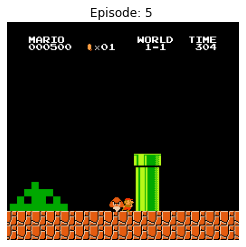

100%|█████████████████████████████████████████████| 5/5 [03:31<00:00, 42.35s/it]

=> Episode 5 Score = 747.00, Average Score = 791.80


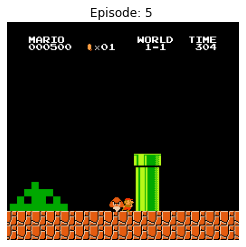

In [ ]:
# For Testing
episodes_nb_test = 5
deepq_right_x_test,deepq_right_y_test = run(training_mode=False, pretrained=False, double_dqn=False, num_episodes=episodes_nb_test, 
                                            exploration_max = 0.05, movement = RIGHT_ONLY)

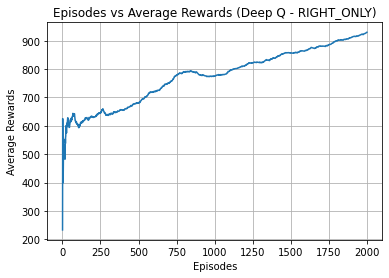

In [ ]:
# Train Plot
plt.plot(deepq_right_x, deepq_right_y)
plt.title(f"Episodes vs Average Rewards (Deep Q - RIGHT_ONLY)")
plt.xlabel("Episodes") 
plt.ylabel("Average Rewards") 
plt.grid()
plt.show()

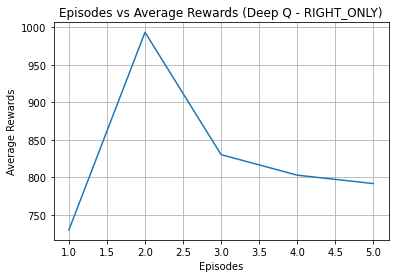

In [ ]:
# Test Plot
plt.plot(deepq_right_x_test, deepq_right_y_test)
plt.title(f"Episodes vs Average Rewards (Deep Q - RIGHT_ONLY)")
plt.xlabel("Episodes") 
plt.ylabel("Average Rewards") 
plt.grid()
plt.show()

## Deep Q-Learning Movement => SIMPLE_MOVEMENT

In [ ]:
# Number of episode that you want to train;
#episodes_nb = 3
# For training
deepq_simple_x, deepq_simple_y = run(training_mode=True, pretrained=False, double_dqn=False, num_episodes=episodes_nb, 
                                     exploration_max = 0.95, movement = SIMPLE_MOVEMENT)

Current device is Cuda


  0%|                                        | 1/2000 [00:07<4:24:41,  7.94s/it]

=> Episode 1 Score = 1111.00, Average Score = 1111.00


  0%|                                        | 2/2000 [00:08<1:59:21,  3.58s/it]

=> Episode 2 Score = 248.00, Average Score = 679.50


  0%|                                        | 3/2000 [00:30<6:39:19, 12.00s/it]

=> Episode 3 Score = 1091.00, Average Score = 816.67


  0%|                                        | 4/2000 [00:32<4:32:58,  8.21s/it]

=> Episode 4 Score = 733.00, Average Score = 795.75


  0%|                                        | 5/2000 [00:33<3:00:45,  5.44s/it]

=> Episode 5 Score = 248.00, Average Score = 686.20


  0%|                                        | 6/2000 [00:36<2:29:35,  4.50s/it]

=> Episode 6 Score = 635.00, Average Score = 677.67


  0%|▏                                       | 7/2000 [00:45<3:19:20,  6.00s/it]

=> Episode 7 Score = 665.00, Average Score = 675.86


  0%|▏                                       | 8/2000 [00:48<2:51:18,  5.16s/it]

=> Episode 8 Score = 592.00, Average Score = 665.38


  0%|▏                                       | 9/2000 [00:49<2:06:52,  3.82s/it]

=> Episode 9 Score = 239.00, Average Score = 618.00


  0%|▏                                      | 10/2000 [00:59<3:14:22,  5.86s/it]

=> Episode 10 Score = 1330.00, Average Score = 689.20


  1%|▏                                      | 11/2000 [01:00<2:22:16,  4.29s/it]

=> Episode 11 Score = 207.00, Average Score = 645.36


  1%|▏                                      | 12/2000 [01:05<2:24:32,  4.36s/it]

=> Episode 12 Score = 1392.00, Average Score = 707.58


  1%|▎                                      | 13/2000 [01:13<3:00:32,  5.45s/it]

=> Episode 13 Score = 749.00, Average Score = 710.77


  1%|▎                                      | 14/2000 [01:13<2:10:58,  3.96s/it]

=> Episode 14 Score = 248.00, Average Score = 677.71


  1%|▎                                      | 15/2000 [01:14<1:36:50,  2.93s/it]

=> Episode 15 Score = 233.00, Average Score = 648.07


  1%|▎                                      | 16/2000 [01:19<2:02:09,  3.69s/it]

=> Episode 16 Score = 1401.00, Average Score = 695.12


  1%|▎                                      | 17/2000 [01:20<1:31:05,  2.76s/it]

=> Episode 17 Score = 231.00, Average Score = 667.82


  1%|▎                                      | 18/2000 [01:20<1:08:30,  2.07s/it]

=> Episode 18 Score = 250.00, Average Score = 644.61


  1%|▍                                        | 19/2000 [01:21<53:14,  1.61s/it]

=> Episode 19 Score = 235.00, Average Score = 623.05


  1%|▍                                      | 20/2000 [01:34<2:49:19,  5.13s/it]

=> Episode 20 Score = 1305.00, Average Score = 657.15


  1%|▍                                      | 21/2000 [01:37<2:25:45,  4.42s/it]

=> Episode 21 Score = 1036.00, Average Score = 675.19


  1%|▍                                      | 22/2000 [01:37<1:47:27,  3.26s/it]

=> Episode 22 Score = 237.00, Average Score = 655.27


  1%|▍                                      | 23/2000 [01:38<1:19:47,  2.42s/it]

=> Episode 23 Score = 248.00, Average Score = 637.57


  1%|▍                                      | 24/2000 [01:40<1:20:20,  2.44s/it]

=> Episode 24 Score = 638.00, Average Score = 637.58


  1%|▍                                      | 25/2000 [01:41<1:00:50,  1.85s/it]

=> Episode 25 Score = 251.00, Average Score = 622.12


  1%|▌                                        | 26/2000 [01:41<47:24,  1.44s/it]

=> Episode 26 Score = 249.00, Average Score = 607.77


  1%|▌                                        | 27/2000 [01:42<37:57,  1.15s/it]

=> Episode 27 Score = 249.00, Average Score = 594.48


  1%|▌                                        | 28/2000 [01:42<31:51,  1.03it/s]

=> Episode 28 Score = 236.00, Average Score = 581.68


  1%|▌                                        | 29/2000 [01:45<51:15,  1.56s/it]

=> Episode 29 Score = 601.00, Average Score = 582.34


  2%|▌                                      | 30/2000 [01:48<1:05:39,  2.00s/it]

=> Episode 30 Score = 1340.00, Average Score = 607.60


  2%|▋                                        | 31/2000 [01:49<50:44,  1.55s/it]

=> Episode 31 Score = 249.00, Average Score = 596.03


  2%|▋                                        | 32/2000 [01:49<40:50,  1.24s/it]

=> Episode 32 Score = 247.00, Average Score = 585.12


  2%|▋                                      | 33/2000 [02:08<3:37:11,  6.63s/it]

=> Episode 33 Score = 1670.00, Average Score = 618.00


  2%|▋                                      | 34/2000 [02:09<2:37:14,  4.80s/it]

=> Episode 34 Score = 252.00, Average Score = 607.24


  2%|▋                                      | 35/2000 [02:12<2:14:58,  4.12s/it]

=> Episode 35 Score = 1040.00, Average Score = 619.60


  2%|▋                                      | 36/2000 [02:15<2:05:47,  3.84s/it]

=> Episode 36 Score = 1428.00, Average Score = 642.06


  2%|▋                                      | 37/2000 [02:15<1:33:23,  2.85s/it]

=> Episode 37 Score = 248.00, Average Score = 631.41


  2%|▋                                      | 38/2000 [02:16<1:11:34,  2.19s/it]

=> Episode 38 Score = 237.00, Average Score = 621.03


  2%|▊                                      | 39/2000 [02:19<1:17:04,  2.36s/it]

=> Episode 39 Score = 1047.00, Average Score = 631.95


  2%|▊                                        | 40/2000 [02:19<58:57,  1.80s/it]

=> Episode 40 Score = 250.00, Average Score = 622.40


  2%|▊                                        | 41/2000 [02:20<46:17,  1.42s/it]

=> Episode 41 Score = 251.00, Average Score = 613.34


  2%|▊                                      | 42/2000 [02:23<1:01:52,  1.90s/it]

=> Episode 42 Score = 1431.00, Average Score = 632.81


  2%|▉                                        | 43/2000 [02:23<48:24,  1.48s/it]

=> Episode 43 Score = 250.00, Average Score = 623.91


  2%|▉                                        | 44/2000 [02:24<40:07,  1.23s/it]

=> Episode 44 Score = 234.00, Average Score = 615.05


  2%|▉                                        | 45/2000 [02:27<55:22,  1.70s/it]

=> Episode 45 Score = 1318.00, Average Score = 630.67


  2%|▉                                      | 46/2000 [02:30<1:06:47,  2.05s/it]

=> Episode 46 Score = 1428.00, Average Score = 648.00


  2%|▉                                      | 47/2000 [02:37<2:00:57,  3.72s/it]

=> Episode 47 Score = 982.00, Average Score = 655.11


  2%|▉                                      | 48/2000 [02:38<1:29:46,  2.76s/it]

=> Episode 48 Score = 249.00, Average Score = 646.65


  2%|▉                                      | 49/2000 [02:41<1:33:57,  2.89s/it]

=> Episode 49 Score = 1314.00, Average Score = 660.27


  2%|▉                                      | 50/2000 [02:41<1:10:35,  2.17s/it]

=> Episode 50 Score = 249.00, Average Score = 652.04


  3%|█                                        | 51/2000 [02:42<53:58,  1.66s/it]

=> Episode 51 Score = 251.00, Average Score = 644.18


  3%|█                                      | 52/2000 [02:45<1:05:22,  2.01s/it]

=> Episode 52 Score = 1337.00, Average Score = 657.50


  3%|█                                        | 53/2000 [02:45<50:44,  1.56s/it]

=> Episode 53 Score = 246.00, Average Score = 649.74


  3%|█                                        | 54/2000 [02:46<40:59,  1.26s/it]

=> Episode 54 Score = 247.00, Average Score = 642.28


  3%|█▏                                       | 55/2000 [02:46<34:29,  1.06s/it]

=> Episode 55 Score = 236.00, Average Score = 634.89


  3%|█▏                                       | 56/2000 [02:47<28:51,  1.12it/s]

=> Episode 56 Score = 250.00, Average Score = 628.02


  3%|█                                      | 57/2000 [02:52<1:08:56,  2.13s/it]

=> Episode 57 Score = 1022.00, Average Score = 634.93


  3%|█▏                                       | 58/2000 [02:52<53:14,  1.65s/it]

=> Episode 58 Score = 249.00, Average Score = 628.28


  3%|█▏                                       | 59/2000 [02:53<42:26,  1.31s/it]

=> Episode 59 Score = 245.00, Average Score = 621.78


  3%|█▏                                       | 60/2000 [02:56<59:27,  1.84s/it]

=> Episode 60 Score = 1034.00, Average Score = 628.65


  3%|█▎                                       | 61/2000 [02:57<53:41,  1.66s/it]

=> Episode 61 Score = 636.00, Average Score = 628.77


  3%|█▎                                       | 62/2000 [02:58<42:54,  1.33s/it]

=> Episode 62 Score = 244.00, Average Score = 622.56


  3%|█▎                                       | 63/2000 [02:58<35:23,  1.10s/it]

=> Episode 63 Score = 237.00, Average Score = 616.44


  3%|█▎                                       | 64/2000 [02:59<29:11,  1.11it/s]

=> Episode 64 Score = 248.00, Average Score = 610.69


  3%|█▎                                       | 65/2000 [02:59<25:14,  1.28it/s]

=> Episode 65 Score = 251.00, Average Score = 605.15


  3%|█▎                                       | 66/2000 [03:00<22:50,  1.41it/s]

=> Episode 66 Score = 247.00, Average Score = 599.73


  3%|█▎                                       | 67/2000 [03:00<20:30,  1.57it/s]

=> Episode 67 Score = 249.00, Average Score = 594.49


  3%|█▍                                       | 68/2000 [03:01<19:00,  1.69it/s]

=> Episode 68 Score = 247.00, Average Score = 589.38


  3%|█▍                                       | 69/2000 [03:01<18:46,  1.71it/s]

=> Episode 69 Score = 238.00, Average Score = 584.29


  4%|█▍                                       | 70/2000 [03:03<27:44,  1.16it/s]

=> Episode 70 Score = 613.00, Average Score = 584.70


  4%|█▍                                       | 71/2000 [03:03<24:23,  1.32it/s]

=> Episode 71 Score = 248.00, Average Score = 579.96


  4%|█▍                                       | 72/2000 [03:06<45:02,  1.40s/it]

=> Episode 72 Score = 1342.00, Average Score = 590.54


  4%|█▍                                       | 73/2000 [03:07<35:50,  1.12s/it]

=> Episode 73 Score = 252.00, Average Score = 585.90


  4%|█▌                                       | 74/2000 [03:07<30:00,  1.07it/s]

=> Episode 74 Score = 245.00, Average Score = 581.30


  4%|█▌                                       | 75/2000 [03:10<48:00,  1.50s/it]

=> Episode 75 Score = 1325.00, Average Score = 591.21


  4%|█▌                                       | 76/2000 [03:10<38:21,  1.20s/it]

=> Episode 76 Score = 251.00, Average Score = 586.74


  4%|█▌                                       | 77/2000 [03:11<31:19,  1.02it/s]

=> Episode 77 Score = 248.00, Average Score = 582.34


  4%|█▌                                       | 78/2000 [03:11<26:41,  1.20it/s]

=> Episode 78 Score = 248.00, Average Score = 578.05


  4%|█▌                                       | 79/2000 [03:12<23:00,  1.39it/s]

=> Episode 79 Score = 249.00, Average Score = 573.89


  4%|█▋                                       | 80/2000 [03:15<43:48,  1.37s/it]

=> Episode 80 Score = 1343.00, Average Score = 583.50


  4%|█▋                                       | 81/2000 [03:16<44:48,  1.40s/it]

=> Episode 81 Score = 630.00, Average Score = 584.07


  4%|█▋                                       | 82/2000 [03:19<58:36,  1.83s/it]

=> Episode 82 Score = 1317.00, Average Score = 593.01


  4%|█▋                                       | 83/2000 [03:20<46:07,  1.44s/it]

=> Episode 83 Score = 238.00, Average Score = 588.73


  4%|█▋                                       | 84/2000 [03:20<37:14,  1.17s/it]

=> Episode 84 Score = 235.00, Average Score = 584.52


  4%|█▋                                     | 85/2000 [03:25<1:11:05,  2.23s/it]

=> Episode 85 Score = 1319.00, Average Score = 593.16


  4%|█▊                                       | 86/2000 [03:25<54:48,  1.72s/it]

=> Episode 86 Score = 235.00, Average Score = 589.00


  4%|█▊                                       | 87/2000 [03:26<43:54,  1.38s/it]

=> Episode 87 Score = 231.00, Average Score = 584.89


  4%|█▊                                       | 88/2000 [03:27<43:46,  1.37s/it]

=> Episode 88 Score = 633.00, Average Score = 585.43


  4%|█▋                                     | 89/2000 [03:40<2:33:33,  4.82s/it]

=> Episode 89 Score = 1449.00, Average Score = 595.13


  4%|█▊                                     | 90/2000 [03:41<1:52:51,  3.55s/it]

=> Episode 90 Score = 237.00, Average Score = 591.16


  5%|█▊                                     | 91/2000 [03:44<1:45:00,  3.30s/it]

=> Episode 91 Score = 635.00, Average Score = 591.64


  5%|█▊                                     | 92/2000 [03:48<1:52:39,  3.54s/it]

=> Episode 92 Score = 1126.00, Average Score = 597.45


  5%|█▊                                     | 93/2000 [03:54<2:16:50,  4.31s/it]

=> Episode 93 Score = 994.00, Average Score = 601.71


  5%|█▊                                     | 94/2000 [03:57<2:04:42,  3.93s/it]

=> Episode 94 Score = 1032.00, Average Score = 606.29


  5%|█▊                                     | 95/2000 [03:59<1:48:20,  3.41s/it]

=> Episode 95 Score = 641.00, Average Score = 606.65


  5%|█▊                                     | 96/2000 [03:59<1:20:52,  2.55s/it]

=> Episode 96 Score = 237.00, Average Score = 602.80


  5%|█▉                                     | 97/2000 [04:02<1:18:13,  2.47s/it]

=> Episode 97 Score = 785.00, Average Score = 604.68


  5%|█▉                                     | 98/2000 [04:03<1:07:20,  2.12s/it]

=> Episode 98 Score = 613.00, Average Score = 604.77


  5%|█▉                                     | 99/2000 [04:07<1:19:54,  2.52s/it]

=> Episode 99 Score = 692.00, Average Score = 605.65


  5%|█▉                                    | 100/2000 [04:08<1:13:07,  2.31s/it]

=> Episode 100 Score = 621.00, Average Score = 605.80


  5%|█▉                                    | 101/2000 [04:14<1:47:35,  3.40s/it]

=> Episode 101 Score = 772.00, Average Score = 607.45


  5%|█▉                                    | 102/2000 [04:20<2:14:02,  4.24s/it]

=> Episode 102 Score = 769.00, Average Score = 609.03


  5%|█▉                                    | 103/2000 [04:24<2:05:31,  3.97s/it]

=> Episode 103 Score = 1028.00, Average Score = 613.10


  5%|█▉                                    | 104/2000 [04:25<1:41:18,  3.21s/it]

=> Episode 104 Score = 627.00, Average Score = 613.23


  5%|█▉                                    | 105/2000 [04:28<1:34:33,  2.99s/it]

=> Episode 105 Score = 1038.00, Average Score = 617.28


  5%|██                                    | 106/2000 [04:34<2:01:36,  3.85s/it]

=> Episode 106 Score = 773.00, Average Score = 618.75


  5%|██                                    | 107/2000 [04:34<1:29:18,  2.83s/it]

=> Episode 107 Score = 248.00, Average Score = 615.28


  5%|██                                    | 108/2000 [04:36<1:23:50,  2.66s/it]

=> Episode 108 Score = 816.00, Average Score = 617.14


  5%|██                                    | 109/2000 [04:39<1:21:28,  2.59s/it]

=> Episode 109 Score = 1144.00, Average Score = 621.97


  6%|██                                    | 110/2000 [04:41<1:16:29,  2.43s/it]

=> Episode 110 Score = 627.00, Average Score = 622.02


  6%|██                                    | 111/2000 [04:45<1:31:22,  2.90s/it]

=> Episode 111 Score = 1019.00, Average Score = 625.59


  6%|██▏                                   | 112/2000 [04:52<2:11:39,  4.18s/it]

=> Episode 112 Score = 757.00, Average Score = 626.77


  6%|██▏                                   | 113/2000 [04:53<1:37:10,  3.09s/it]

=> Episode 113 Score = 237.00, Average Score = 623.32


  6%|██▏                                   | 114/2000 [04:54<1:25:36,  2.72s/it]

=> Episode 114 Score = 621.00, Average Score = 623.30


  6%|██▏                                   | 115/2000 [04:57<1:23:10,  2.65s/it]

=> Episode 115 Score = 814.00, Average Score = 624.96


  6%|██▏                                   | 116/2000 [05:01<1:38:51,  3.15s/it]

=> Episode 116 Score = 731.00, Average Score = 625.87


  6%|██▏                                   | 117/2000 [05:03<1:24:05,  2.68s/it]

=> Episode 117 Score = 605.00, Average Score = 625.69


  6%|██▏                                   | 118/2000 [05:07<1:36:27,  3.08s/it]

=> Episode 118 Score = 741.00, Average Score = 626.67


  6%|██▎                                   | 119/2000 [05:09<1:28:51,  2.83s/it]

=> Episode 119 Score = 1047.00, Average Score = 630.20


  6%|██▎                                   | 120/2000 [05:12<1:30:31,  2.89s/it]

=> Episode 120 Score = 581.00, Average Score = 629.79


  6%|██▎                                   | 121/2000 [05:16<1:40:44,  3.22s/it]

=> Episode 121 Score = 1303.00, Average Score = 635.36


  6%|██▎                                   | 122/2000 [05:17<1:21:41,  2.61s/it]

=> Episode 122 Score = 626.00, Average Score = 635.28


  6%|██▎                                   | 123/2000 [05:19<1:09:33,  2.22s/it]

=> Episode 123 Score = 628.00, Average Score = 635.22


  6%|██▎                                   | 124/2000 [05:23<1:32:13,  2.95s/it]

=> Episode 124 Score = 788.00, Average Score = 636.45


  6%|██▍                                   | 125/2000 [05:28<1:53:09,  3.62s/it]

=> Episode 125 Score = 1289.00, Average Score = 641.67


  6%|██▍                                   | 126/2000 [05:31<1:42:03,  3.27s/it]

=> Episode 126 Score = 815.00, Average Score = 643.05


  6%|██▍                                   | 127/2000 [05:34<1:38:37,  3.16s/it]

=> Episode 127 Score = 1433.00, Average Score = 649.27


  6%|██▍                                   | 128/2000 [05:41<2:19:05,  4.46s/it]

=> Episode 128 Score = 577.00, Average Score = 648.70


  6%|██▍                                   | 129/2000 [05:48<2:40:01,  5.13s/it]

=> Episode 129 Score = 1295.00, Average Score = 653.71


  6%|██▍                                   | 130/2000 [05:52<2:32:29,  4.89s/it]

=> Episode 130 Score = 591.00, Average Score = 653.23


  7%|██▍                                   | 131/2000 [05:53<1:50:54,  3.56s/it]

=> Episode 131 Score = 252.00, Average Score = 650.17


  7%|██▌                                   | 132/2000 [05:54<1:30:30,  2.91s/it]

=> Episode 132 Score = 631.00, Average Score = 650.02


  7%|██▌                                   | 133/2000 [05:59<1:46:56,  3.44s/it]

=> Episode 133 Score = 1115.00, Average Score = 653.52


  7%|██▌                                   | 134/2000 [06:01<1:37:04,  3.12s/it]

=> Episode 134 Score = 1042.00, Average Score = 656.42


  7%|██▌                                   | 135/2000 [06:02<1:19:43,  2.56s/it]

=> Episode 135 Score = 629.00, Average Score = 656.21


  7%|██▌                                   | 136/2000 [06:08<1:49:04,  3.51s/it]

=> Episode 136 Score = 1394.00, Average Score = 661.64


  7%|██▌                                   | 137/2000 [06:11<1:40:06,  3.22s/it]

=> Episode 137 Score = 813.00, Average Score = 662.74


  7%|██▌                                   | 138/2000 [06:16<2:03:12,  3.97s/it]

=> Episode 138 Score = 1283.00, Average Score = 667.24


  7%|██▋                                   | 139/2000 [06:19<1:46:19,  3.43s/it]

=> Episode 139 Score = 758.00, Average Score = 667.89


  7%|██▋                                   | 140/2000 [06:21<1:39:56,  3.22s/it]

=> Episode 140 Score = 1436.00, Average Score = 673.38


  7%|██▋                                   | 141/2000 [06:28<2:16:21,  4.40s/it]

=> Episode 141 Score = 1380.00, Average Score = 678.39


  7%|██▋                                   | 142/2000 [06:30<1:46:42,  3.45s/it]

=> Episode 142 Score = 628.00, Average Score = 678.04


  7%|██▋                                   | 143/2000 [06:36<2:16:06,  4.40s/it]

=> Episode 143 Score = 1297.00, Average Score = 682.36


  7%|██▋                                   | 144/2000 [06:38<1:46:57,  3.46s/it]

=> Episode 144 Score = 625.00, Average Score = 681.97


  7%|██▊                                   | 145/2000 [06:42<1:56:12,  3.76s/it]

=> Episode 145 Score = 1019.00, Average Score = 684.29


  7%|██▊                                   | 146/2000 [06:43<1:33:34,  3.03s/it]

=> Episode 146 Score = 639.00, Average Score = 683.98


  7%|██▊                                   | 147/2000 [06:49<2:02:04,  3.95s/it]

=> Episode 147 Score = 714.00, Average Score = 684.18


  7%|██▊                                   | 148/2000 [06:54<2:07:55,  4.14s/it]

=> Episode 148 Score = 1414.00, Average Score = 689.11


  7%|██▊                                   | 149/2000 [07:14<4:34:13,  8.89s/it]

=> Episode 149 Score = 1141.00, Average Score = 692.15


  8%|██▊                                   | 150/2000 [07:17<3:38:12,  7.08s/it]

=> Episode 150 Score = 604.00, Average Score = 691.56


  8%|██▊                                   | 151/2000 [07:18<2:45:57,  5.39s/it]

=> Episode 151 Score = 614.00, Average Score = 691.05


  8%|██▉                                   | 152/2000 [07:21<2:20:58,  4.58s/it]

=> Episode 152 Score = 1436.00, Average Score = 695.95


  8%|██▉                                   | 153/2000 [07:30<3:03:28,  5.96s/it]

=> Episode 153 Score = 557.00, Average Score = 695.04


  8%|██▉                                   | 154/2000 [07:31<2:12:33,  4.31s/it]

=> Episode 154 Score = 249.00, Average Score = 692.14


  8%|██▉                                   | 155/2000 [07:50<4:28:15,  8.72s/it]

=> Episode 155 Score = 1148.00, Average Score = 695.08


  8%|██▉                                   | 156/2000 [07:54<3:51:36,  7.54s/it]

=> Episode 156 Score = 566.00, Average Score = 694.26


  8%|██▉                                   | 157/2000 [07:55<2:46:24,  5.42s/it]

=> Episode 157 Score = 252.00, Average Score = 691.44


  8%|███                                   | 158/2000 [07:58<2:23:19,  4.67s/it]

=> Episode 158 Score = 1317.00, Average Score = 695.40


  8%|███                                   | 159/2000 [07:59<1:51:44,  3.64s/it]

=> Episode 159 Score = 631.00, Average Score = 694.99


  8%|███                                   | 160/2000 [08:04<1:59:13,  3.89s/it]

=> Episode 160 Score = 1322.00, Average Score = 698.91


  8%|███                                   | 161/2000 [08:08<2:00:37,  3.94s/it]

=> Episode 161 Score = 1327.00, Average Score = 702.81


  8%|███                                   | 162/2000 [08:10<1:48:19,  3.54s/it]

=> Episode 162 Score = 1321.00, Average Score = 706.63


  8%|███                                   | 163/2000 [08:11<1:19:55,  2.61s/it]

=> Episode 163 Score = 248.00, Average Score = 703.82


  8%|███                                   | 164/2000 [08:15<1:40:18,  3.28s/it]

=> Episode 164 Score = 1120.00, Average Score = 706.35


  8%|███▏                                  | 165/2000 [08:27<2:52:31,  5.64s/it]

=> Episode 165 Score = 1217.00, Average Score = 709.45


  8%|███▏                                  | 166/2000 [08:27<2:04:48,  4.08s/it]

=> Episode 166 Score = 248.00, Average Score = 706.67


  8%|███▏                                  | 167/2000 [08:34<2:26:52,  4.81s/it]

=> Episode 167 Score = 1298.00, Average Score = 710.21


  8%|███▏                                  | 168/2000 [08:36<2:07:27,  4.17s/it]

=> Episode 168 Score = 1039.00, Average Score = 712.17


  8%|███▏                                  | 169/2000 [08:45<2:44:49,  5.40s/it]

=> Episode 169 Score = 1352.00, Average Score = 715.95


  8%|███▏                                  | 170/2000 [08:47<2:14:44,  4.42s/it]

=> Episode 170 Score = 759.00, Average Score = 716.21


  9%|███▏                                  | 171/2000 [08:50<2:09:03,  4.23s/it]

=> Episode 171 Score = 798.00, Average Score = 716.68


  9%|███▎                                  | 172/2000 [08:58<2:36:52,  5.15s/it]

=> Episode 172 Score = 755.00, Average Score = 716.91


  9%|███▎                                  | 173/2000 [09:07<3:18:35,  6.52s/it]

=> Episode 173 Score = 511.00, Average Score = 715.72


  9%|███▎                                  | 174/2000 [09:09<2:36:57,  5.16s/it]

=> Episode 174 Score = 742.00, Average Score = 715.87


  9%|███▎                                  | 175/2000 [09:13<2:24:31,  4.75s/it]

=> Episode 175 Score = 798.00, Average Score = 716.34


  9%|███▎                                  | 176/2000 [09:16<2:04:33,  4.10s/it]

=> Episode 176 Score = 1045.00, Average Score = 718.20


  9%|███▎                                  | 177/2000 [09:22<2:21:51,  4.67s/it]

=> Episode 177 Score = 771.00, Average Score = 718.50


  9%|███▍                                  | 178/2000 [09:22<1:43:22,  3.40s/it]

=> Episode 178 Score = 252.00, Average Score = 715.88


  9%|███▍                                  | 179/2000 [09:23<1:17:19,  2.55s/it]

=> Episode 179 Score = 231.00, Average Score = 713.17


  9%|███▍                                  | 180/2000 [09:26<1:20:27,  2.65s/it]

=> Episode 180 Score = 1431.00, Average Score = 717.16


  9%|███▍                                  | 181/2000 [09:28<1:21:38,  2.69s/it]

=> Episode 181 Score = 1344.00, Average Score = 720.62


  9%|███▍                                  | 182/2000 [09:33<1:36:15,  3.18s/it]

=> Episode 182 Score = 1323.00, Average Score = 723.93


  9%|███▍                                  | 183/2000 [09:36<1:32:56,  3.07s/it]

=> Episode 183 Score = 1345.00, Average Score = 727.33


  9%|███▍                                  | 184/2000 [09:41<1:52:01,  3.70s/it]

=> Episode 184 Score = 1303.00, Average Score = 730.46


  9%|███▌                                  | 185/2000 [09:44<1:44:51,  3.47s/it]

=> Episode 185 Score = 1583.00, Average Score = 735.06


  9%|███▌                                  | 186/2000 [09:46<1:37:17,  3.22s/it]

=> Episode 186 Score = 1124.00, Average Score = 737.16


  9%|███▌                                  | 187/2000 [09:48<1:19:18,  2.62s/it]

=> Episode 187 Score = 635.00, Average Score = 736.61


  9%|███▌                                  | 188/2000 [09:51<1:23:55,  2.78s/it]

=> Episode 188 Score = 1414.00, Average Score = 740.21


  9%|███▌                                  | 189/2000 [09:51<1:02:58,  2.09s/it]

=> Episode 189 Score = 249.00, Average Score = 737.61


 10%|███▊                                    | 190/2000 [09:52<54:26,  1.80s/it]

=> Episode 190 Score = 616.00, Average Score = 736.97


 10%|███▊                                    | 191/2000 [09:54<50:22,  1.67s/it]

=> Episode 191 Score = 638.00, Average Score = 736.46


 10%|███▊                                    | 192/2000 [09:56<58:37,  1.95s/it]

=> Episode 192 Score = 1345.00, Average Score = 739.62


 10%|███▋                                  | 193/2000 [09:59<1:05:43,  2.18s/it]

=> Episode 193 Score = 1346.00, Average Score = 742.77


 10%|███▉                                    | 194/2000 [10:00<55:46,  1.85s/it]

=> Episode 194 Score = 609.00, Average Score = 742.08


 10%|███▋                                  | 195/2000 [10:08<1:50:48,  3.68s/it]

=> Episode 195 Score = 748.00, Average Score = 742.11


 10%|███▋                                  | 196/2000 [10:10<1:39:02,  3.29s/it]

=> Episode 196 Score = 815.00, Average Score = 742.48


 10%|███▋                                  | 197/2000 [10:13<1:30:14,  3.00s/it]

=> Episode 197 Score = 640.00, Average Score = 741.96


 10%|███▊                                  | 198/2000 [10:18<1:47:38,  3.58s/it]

=> Episode 198 Score = 1405.00, Average Score = 745.31


 10%|███▊                                  | 199/2000 [10:21<1:41:05,  3.37s/it]

=> Episode 199 Score = 1342.00, Average Score = 748.31


 10%|███▊                                  | 200/2000 [10:25<1:46:57,  3.57s/it]

=> Episode 200 Score = 1025.00, Average Score = 749.69


 10%|███▊                                  | 201/2000 [10:26<1:26:54,  2.90s/it]

=> Episode 201 Score = 623.00, Average Score = 749.06


 10%|███▊                                  | 202/2000 [10:29<1:28:31,  2.95s/it]

=> Episode 202 Score = 1339.00, Average Score = 751.98


 10%|███▊                                  | 203/2000 [10:32<1:26:49,  2.90s/it]

=> Episode 203 Score = 1342.00, Average Score = 754.89


 10%|███▉                                  | 204/2000 [10:35<1:28:27,  2.96s/it]

=> Episode 204 Score = 806.00, Average Score = 755.14


 10%|███▉                                  | 205/2000 [10:42<2:01:59,  4.08s/it]

=> Episode 205 Score = 1267.00, Average Score = 757.63


 10%|███▉                                  | 206/2000 [10:45<1:57:53,  3.94s/it]

=> Episode 206 Score = 1334.00, Average Score = 760.43


 10%|███▉                                  | 207/2000 [10:48<1:44:52,  3.51s/it]

=> Episode 207 Score = 814.00, Average Score = 760.69


 10%|███▉                                  | 208/2000 [10:49<1:22:41,  2.77s/it]

=> Episode 208 Score = 616.00, Average Score = 760.00


 10%|███▉                                  | 209/2000 [10:51<1:22:13,  2.75s/it]

=> Episode 209 Score = 1336.00, Average Score = 762.75


 10%|███▉                                  | 210/2000 [10:52<1:01:41,  2.07s/it]

=> Episode 210 Score = 250.00, Average Score = 760.31


 11%|████                                  | 211/2000 [10:55<1:08:31,  2.30s/it]

=> Episode 211 Score = 1343.00, Average Score = 763.07


 11%|████                                  | 212/2000 [10:57<1:08:04,  2.28s/it]

=> Episode 212 Score = 1045.00, Average Score = 764.40


 11%|████▎                                   | 213/2000 [10:57<51:38,  1.73s/it]

=> Episode 213 Score = 252.00, Average Score = 762.00


 11%|████▎                                   | 214/2000 [10:59<46:49,  1.57s/it]

=> Episode 214 Score = 628.00, Average Score = 761.37


 11%|████▎                                   | 215/2000 [11:01<52:02,  1.75s/it]

=> Episode 215 Score = 818.00, Average Score = 761.63


 11%|████                                  | 216/2000 [11:03<1:00:16,  2.03s/it]

=> Episode 216 Score = 1301.00, Average Score = 764.13


 11%|████▎                                   | 217/2000 [11:05<54:03,  1.82s/it]

=> Episode 217 Score = 628.00, Average Score = 763.50


 11%|████▎                                   | 218/2000 [11:07<59:38,  2.01s/it]

=> Episode 218 Score = 1347.00, Average Score = 766.18


 11%|████▍                                   | 219/2000 [11:09<53:40,  1.81s/it]

=> Episode 219 Score = 633.00, Average Score = 765.57


 11%|████▍                                   | 220/2000 [11:10<50:21,  1.70s/it]

=> Episode 220 Score = 626.00, Average Score = 764.94


 11%|████▏                                 | 221/2000 [11:13<1:01:27,  2.07s/it]

=> Episode 221 Score = 1039.00, Average Score = 766.18


 11%|████▏                                 | 222/2000 [11:16<1:05:44,  2.22s/it]

=> Episode 222 Score = 1347.00, Average Score = 768.79


 11%|████▏                                 | 223/2000 [11:18<1:06:43,  2.25s/it]

=> Episode 223 Score = 816.00, Average Score = 769.00


 11%|████▎                                 | 224/2000 [11:20<1:07:26,  2.28s/it]

=> Episode 224 Score = 816.00, Average Score = 769.21


 11%|████▎                                 | 225/2000 [11:22<1:00:02,  2.03s/it]

=> Episode 225 Score = 650.00, Average Score = 768.68


 11%|████▎                                 | 226/2000 [11:25<1:12:59,  2.47s/it]

=> Episode 226 Score = 738.00, Average Score = 768.55


 11%|████▌                                   | 227/2000 [11:26<55:05,  1.86s/it]

=> Episode 227 Score = 248.00, Average Score = 766.26


 11%|████▌                                   | 228/2000 [11:26<42:34,  1.44s/it]

=> Episode 228 Score = 247.00, Average Score = 763.98


 11%|████▌                                   | 229/2000 [11:29<52:17,  1.77s/it]

=> Episode 229 Score = 1346.00, Average Score = 766.52


 12%|████▎                                 | 230/2000 [11:32<1:02:35,  2.12s/it]

=> Episode 230 Score = 1340.00, Average Score = 769.01


 12%|████▍                                 | 231/2000 [11:34<1:07:06,  2.28s/it]

=> Episode 231 Score = 1330.00, Average Score = 771.44


 12%|████▋                                   | 232/2000 [11:35<51:10,  1.74s/it]

=> Episode 232 Score = 248.00, Average Score = 769.19


 12%|████▋                                   | 233/2000 [11:35<39:55,  1.36s/it]

=> Episode 233 Score = 249.00, Average Score = 766.95


 12%|████▋                                   | 234/2000 [11:36<31:55,  1.08s/it]

=> Episode 234 Score = 252.00, Average Score = 764.75


 12%|████▍                                 | 235/2000 [11:40<1:01:14,  2.08s/it]

=> Episode 235 Score = 728.00, Average Score = 764.60


 12%|████▍                                 | 236/2000 [11:43<1:06:53,  2.27s/it]

=> Episode 236 Score = 1319.00, Average Score = 766.94


 12%|████▌                                 | 237/2000 [11:48<1:34:44,  3.22s/it]

=> Episode 237 Score = 561.00, Average Score = 766.08


 12%|████▌                                 | 238/2000 [11:51<1:30:22,  3.08s/it]

=> Episode 238 Score = 1345.00, Average Score = 768.51


 12%|████▌                                 | 239/2000 [11:53<1:25:02,  2.90s/it]

=> Episode 239 Score = 1323.00, Average Score = 770.83


 12%|████▌                                 | 240/2000 [11:57<1:30:10,  3.07s/it]

=> Episode 240 Score = 1335.00, Average Score = 773.18


 12%|████▌                                 | 241/2000 [12:00<1:27:33,  2.99s/it]

=> Episode 241 Score = 1344.00, Average Score = 775.55


 12%|████▌                                 | 242/2000 [12:04<1:43:30,  3.53s/it]

=> Episode 242 Score = 1297.00, Average Score = 777.70


 12%|████▌                                 | 243/2000 [12:07<1:33:58,  3.21s/it]

=> Episode 243 Score = 1348.00, Average Score = 780.05


 12%|████▋                                 | 244/2000 [12:08<1:14:31,  2.55s/it]

=> Episode 244 Score = 613.00, Average Score = 779.36


 12%|████▋                                 | 245/2000 [12:11<1:17:32,  2.65s/it]

=> Episode 245 Score = 1344.00, Average Score = 781.67


 12%|████▋                                 | 246/2000 [12:14<1:22:54,  2.84s/it]

=> Episode 246 Score = 1337.00, Average Score = 783.93


 12%|████▋                                 | 247/2000 [12:18<1:33:36,  3.20s/it]

=> Episode 247 Score = 1843.00, Average Score = 788.21


 12%|████▋                                 | 248/2000 [12:19<1:15:32,  2.59s/it]

=> Episode 248 Score = 614.00, Average Score = 787.51


 12%|████▋                                 | 249/2000 [12:22<1:15:39,  2.59s/it]

=> Episode 249 Score = 742.00, Average Score = 787.33


 12%|████▊                                 | 250/2000 [12:26<1:24:37,  2.90s/it]

=> Episode 250 Score = 740.00, Average Score = 787.14


 13%|████▊                                 | 251/2000 [12:28<1:23:42,  2.87s/it]

=> Episode 251 Score = 1344.00, Average Score = 789.36


 13%|████▊                                 | 252/2000 [12:31<1:23:38,  2.87s/it]

=> Episode 252 Score = 1577.00, Average Score = 792.48


 13%|████▊                                 | 253/2000 [12:34<1:18:46,  2.71s/it]

=> Episode 253 Score = 1349.00, Average Score = 794.68


 13%|████▊                                 | 254/2000 [12:37<1:22:31,  2.84s/it]

=> Episode 254 Score = 597.00, Average Score = 793.91


 13%|████▊                                 | 255/2000 [12:39<1:22:04,  2.82s/it]

=> Episode 255 Score = 1341.00, Average Score = 796.05


 13%|████▊                                 | 256/2000 [12:41<1:09:44,  2.40s/it]

=> Episode 256 Score = 629.00, Average Score = 795.40


 13%|████▉                                 | 257/2000 [12:44<1:16:45,  2.64s/it]

=> Episode 257 Score = 589.00, Average Score = 794.60


 13%|████▉                                 | 258/2000 [12:48<1:27:37,  3.02s/it]

=> Episode 258 Score = 1331.00, Average Score = 796.67


 13%|████▉                                 | 259/2000 [12:52<1:39:55,  3.44s/it]

=> Episode 259 Score = 710.00, Average Score = 796.34


 13%|████▉                                 | 260/2000 [12:55<1:32:17,  3.18s/it]

=> Episode 260 Score = 612.00, Average Score = 795.63


 13%|████▉                                 | 261/2000 [12:59<1:42:17,  3.53s/it]

=> Episode 261 Score = 683.00, Average Score = 795.20


 13%|████▉                                 | 262/2000 [13:03<1:43:55,  3.59s/it]

=> Episode 262 Score = 799.00, Average Score = 795.21


 13%|████▉                                 | 263/2000 [13:36<6:02:10, 12.51s/it]

=> Episode 263 Score = 443.00, Average Score = 793.87


 13%|█████                                 | 264/2000 [13:39<4:35:22,  9.52s/it]

=> Episode 264 Score = 1347.00, Average Score = 795.97


 13%|█████                                 | 265/2000 [13:41<3:29:58,  7.26s/it]

=> Episode 265 Score = 783.00, Average Score = 795.92


 13%|█████                                 | 266/2000 [13:44<2:49:38,  5.87s/it]

=> Episode 266 Score = 598.00, Average Score = 795.18


 13%|█████                                 | 267/2000 [13:44<2:02:34,  4.24s/it]

=> Episode 267 Score = 249.00, Average Score = 793.13


 13%|█████                                 | 268/2000 [13:48<2:03:48,  4.29s/it]

=> Episode 268 Score = 1324.00, Average Score = 795.11


 13%|█████                                 | 269/2000 [13:54<2:16:03,  4.72s/it]

=> Episode 269 Score = 1308.00, Average Score = 797.02


 14%|█████▏                                | 270/2000 [13:57<1:57:02,  4.06s/it]

=> Episode 270 Score = 1347.00, Average Score = 799.06


 14%|█████▏                                | 271/2000 [13:59<1:45:27,  3.66s/it]

=> Episode 271 Score = 1424.00, Average Score = 801.36


 14%|█████▏                                | 272/2000 [14:01<1:31:28,  3.18s/it]

=> Episode 272 Score = 819.00, Average Score = 801.43


 14%|█████▏                                | 273/2000 [14:09<2:13:37,  4.64s/it]

=> Episode 273 Score = 1276.00, Average Score = 803.16


 14%|█████▏                                | 274/2000 [14:11<1:44:46,  3.64s/it]

=> Episode 274 Score = 635.00, Average Score = 802.55


 14%|█████▏                                | 275/2000 [14:13<1:35:35,  3.33s/it]

=> Episode 275 Score = 1346.00, Average Score = 804.53


 14%|█████▏                                | 276/2000 [14:18<1:48:56,  3.79s/it]

=> Episode 276 Score = 1317.00, Average Score = 806.38


 14%|█████▎                                | 277/2000 [14:20<1:31:04,  3.17s/it]

=> Episode 277 Score = 623.00, Average Score = 805.72


 14%|█████▎                                | 278/2000 [14:27<2:03:01,  4.29s/it]

=> Episode 278 Score = 1292.00, Average Score = 807.47


 14%|█████▎                                | 279/2000 [14:28<1:36:15,  3.36s/it]

=> Episode 279 Score = 614.00, Average Score = 806.78


 14%|█████▎                                | 280/2000 [14:34<1:56:14,  4.05s/it]

=> Episode 280 Score = 1006.00, Average Score = 807.49


 14%|█████▎                                | 281/2000 [14:36<1:45:12,  3.67s/it]

=> Episode 281 Score = 1327.00, Average Score = 809.34


 14%|█████▎                                | 282/2000 [14:38<1:27:13,  3.05s/it]

=> Episode 282 Score = 602.00, Average Score = 808.60


 14%|█████▍                                | 283/2000 [14:43<1:39:26,  3.47s/it]

=> Episode 283 Score = 1324.00, Average Score = 810.42


 14%|█████▍                                | 284/2000 [14:45<1:34:03,  3.29s/it]

=> Episode 284 Score = 592.00, Average Score = 809.65


 14%|█████▍                                | 285/2000 [14:49<1:38:13,  3.44s/it]

=> Episode 285 Score = 718.00, Average Score = 809.33


 14%|█████▍                                | 286/2000 [14:50<1:19:39,  2.79s/it]

=> Episode 286 Score = 624.00, Average Score = 808.69


 14%|█████▍                                | 287/2000 [15:06<3:12:21,  6.74s/it]

=> Episode 287 Score = 1530.00, Average Score = 811.20


 14%|█████▍                                | 288/2000 [15:25<4:52:12, 10.24s/it]

=> Episode 288 Score = 851.00, Average Score = 811.34


 14%|█████▍                                | 289/2000 [15:31<4:21:29,  9.17s/it]

=> Episode 289 Score = 1358.00, Average Score = 813.23


 14%|█████▌                                | 290/2000 [15:35<3:29:28,  7.35s/it]

=> Episode 290 Score = 805.00, Average Score = 813.20


 15%|█████▌                                | 291/2000 [15:38<2:56:03,  6.18s/it]

=> Episode 291 Score = 626.00, Average Score = 812.56


 15%|█████▌                                | 292/2000 [15:40<2:23:23,  5.04s/it]

=> Episode 292 Score = 1347.00, Average Score = 814.39


 15%|█████▌                                | 293/2000 [15:42<1:49:55,  3.86s/it]

=> Episode 293 Score = 625.00, Average Score = 813.74


 15%|█████▌                                | 294/2000 [15:52<2:43:16,  5.74s/it]

=> Episode 294 Score = 1342.00, Average Score = 815.54


 15%|█████▌                                | 295/2000 [15:59<2:54:17,  6.13s/it]

=> Episode 295 Score = 755.00, Average Score = 815.33


 15%|█████▌                                | 296/2000 [16:03<2:38:20,  5.58s/it]

=> Episode 296 Score = 1326.00, Average Score = 817.06


 15%|█████▋                                | 297/2000 [16:06<2:15:41,  4.78s/it]

=> Episode 297 Score = 1341.00, Average Score = 818.82


 15%|█████▋                                | 298/2000 [16:08<1:54:24,  4.03s/it]

=> Episode 298 Score = 637.00, Average Score = 818.21


 15%|█████▋                                | 299/2000 [16:11<1:47:29,  3.79s/it]

=> Episode 299 Score = 1034.00, Average Score = 818.93


 15%|█████▋                                | 300/2000 [16:14<1:35:08,  3.36s/it]

=> Episode 300 Score = 1349.00, Average Score = 820.70


 15%|█████▋                                | 301/2000 [16:16<1:26:39,  3.06s/it]

=> Episode 301 Score = 1348.00, Average Score = 822.45


 15%|█████▋                                | 302/2000 [16:19<1:21:11,  2.87s/it]

=> Episode 302 Score = 1333.00, Average Score = 824.14


 15%|█████▊                                | 303/2000 [16:23<1:30:54,  3.21s/it]

=> Episode 303 Score = 591.00, Average Score = 823.37


 15%|█████▊                                | 304/2000 [16:25<1:27:57,  3.11s/it]

=> Episode 304 Score = 1342.00, Average Score = 825.08


 15%|█████▊                                | 305/2000 [16:27<1:10:58,  2.51s/it]

=> Episode 305 Score = 651.00, Average Score = 824.51


 15%|█████▊                                | 306/2000 [16:37<2:21:09,  5.00s/it]

=> Episode 306 Score = 538.00, Average Score = 823.57


 15%|█████▊                                | 307/2000 [16:40<2:02:19,  4.34s/it]

=> Episode 307 Score = 811.00, Average Score = 823.53


 15%|█████▊                                | 308/2000 [16:48<2:29:55,  5.32s/it]

=> Episode 308 Score = 1378.00, Average Score = 825.33


 15%|█████▊                                | 309/2000 [16:51<2:09:58,  4.61s/it]

=> Episode 309 Score = 1342.00, Average Score = 827.00


 16%|█████▉                                | 310/2000 [16:52<1:40:56,  3.58s/it]

=> Episode 310 Score = 654.00, Average Score = 826.45


 16%|█████▉                                | 311/2000 [16:53<1:22:58,  2.95s/it]

=> Episode 311 Score = 650.00, Average Score = 825.88


 16%|█████▉                                | 312/2000 [16:55<1:09:46,  2.48s/it]

=> Episode 312 Score = 616.00, Average Score = 825.21


 16%|██████▎                                 | 313/2000 [16:55<52:59,  1.88s/it]

=> Episode 313 Score = 250.00, Average Score = 823.37


 16%|██████▎                                 | 314/2000 [16:57<49:37,  1.77s/it]

=> Episode 314 Score = 625.00, Average Score = 822.74


 16%|██████▎                                 | 315/2000 [16:59<54:14,  1.93s/it]

=> Episode 315 Score = 640.00, Average Score = 822.16


 16%|██████▎                                 | 316/2000 [17:00<47:52,  1.71s/it]

=> Episode 316 Score = 612.00, Average Score = 821.49


 16%|██████                                | 317/2000 [17:16<2:49:42,  6.05s/it]

=> Episode 317 Score = 1165.00, Average Score = 822.57


 16%|██████                                | 318/2000 [17:22<2:45:22,  5.90s/it]

=> Episode 318 Score = 1308.00, Average Score = 824.10


 16%|██████                                | 319/2000 [17:31<3:07:31,  6.69s/it]

=> Episode 319 Score = 1272.00, Average Score = 825.50


 16%|██████                                | 320/2000 [17:33<2:34:02,  5.50s/it]

=> Episode 320 Score = 635.00, Average Score = 824.91


 16%|██████                                | 321/2000 [17:39<2:33:40,  5.49s/it]

=> Episode 321 Score = 564.00, Average Score = 824.10


 16%|██████                                | 322/2000 [17:40<2:00:32,  4.31s/it]

=> Episode 322 Score = 608.00, Average Score = 823.43


 16%|██████▏                               | 323/2000 [17:42<1:41:21,  3.63s/it]

=> Episode 323 Score = 614.00, Average Score = 822.78


 16%|██████▏                               | 324/2000 [17:43<1:19:38,  2.85s/it]

=> Episode 324 Score = 607.00, Average Score = 822.11


 16%|██████▏                               | 325/2000 [17:44<1:00:03,  2.15s/it]

=> Episode 325 Score = 251.00, Average Score = 820.35


 16%|██████▌                                 | 326/2000 [17:44<46:40,  1.67s/it]

=> Episode 326 Score = 239.00, Average Score = 818.57


 16%|██████▏                               | 327/2000 [18:03<3:05:36,  6.66s/it]

=> Episode 327 Score = 1160.00, Average Score = 819.61


 16%|██████▏                               | 328/2000 [18:06<2:33:36,  5.51s/it]

=> Episode 328 Score = 619.00, Average Score = 819.00


 16%|██████▎                               | 329/2000 [18:11<2:36:37,  5.62s/it]

=> Episode 329 Score = 1103.00, Average Score = 819.87


 16%|██████▎                               | 330/2000 [18:12<1:57:37,  4.23s/it]

=> Episode 330 Score = 610.00, Average Score = 819.23


 17%|██████▎                               | 331/2000 [18:17<2:01:32,  4.37s/it]

=> Episode 331 Score = 788.00, Average Score = 819.14


 17%|██████▎                               | 332/2000 [18:18<1:29:22,  3.21s/it]

=> Episode 332 Score = 238.00, Average Score = 817.39


 17%|██████▎                               | 333/2000 [18:18<1:06:25,  2.39s/it]

=> Episode 333 Score = 250.00, Average Score = 815.68


 17%|██████▎                               | 334/2000 [18:21<1:13:22,  2.64s/it]

=> Episode 334 Score = 1339.00, Average Score = 817.25


 17%|██████▎                               | 335/2000 [18:24<1:12:32,  2.61s/it]

=> Episode 335 Score = 1345.00, Average Score = 818.82


 17%|██████▍                               | 336/2000 [18:29<1:33:53,  3.39s/it]

=> Episode 336 Score = 1315.00, Average Score = 820.30


 17%|██████▍                               | 337/2000 [18:35<1:53:04,  4.08s/it]

=> Episode 337 Score = 1660.00, Average Score = 822.79


 17%|██████▍                               | 338/2000 [18:37<1:38:11,  3.54s/it]

=> Episode 338 Score = 640.00, Average Score = 822.25


 17%|██████▍                               | 339/2000 [19:10<5:45:41, 12.49s/it]

=> Episode 339 Score = 443.00, Average Score = 821.13


 17%|██████▍                               | 340/2000 [19:20<5:17:48, 11.49s/it]

=> Episode 340 Score = 967.00, Average Score = 821.56


 17%|██████▍                               | 341/2000 [19:20<3:46:19,  8.19s/it]

=> Episode 341 Score = 252.00, Average Score = 819.89


 17%|██████▍                               | 342/2000 [19:21<2:42:19,  5.87s/it]

=> Episode 342 Score = 252.00, Average Score = 818.23


 17%|██████▌                               | 343/2000 [19:23<2:12:46,  4.81s/it]

=> Episode 343 Score = 1348.00, Average Score = 819.78


 17%|██████▌                               | 344/2000 [19:28<2:19:41,  5.06s/it]

=> Episode 344 Score = 1286.00, Average Score = 821.13


 17%|██████▌                               | 345/2000 [19:30<1:48:24,  3.93s/it]

=> Episode 345 Score = 622.00, Average Score = 820.55


 17%|██████▌                               | 346/2000 [19:35<1:59:46,  4.34s/it]

=> Episode 346 Score = 567.00, Average Score = 819.82


 17%|██████▌                               | 347/2000 [19:36<1:28:21,  3.21s/it]

=> Episode 347 Score = 241.00, Average Score = 818.15


 17%|██████▌                               | 348/2000 [19:38<1:17:34,  2.82s/it]

=> Episode 348 Score = 752.00, Average Score = 817.96


 17%|██████▋                               | 349/2000 [19:40<1:14:50,  2.72s/it]

=> Episode 349 Score = 1347.00, Average Score = 819.48


 18%|██████▋                               | 350/2000 [19:45<1:34:10,  3.42s/it]

=> Episode 350 Score = 783.00, Average Score = 819.37


 18%|██████▋                               | 351/2000 [19:46<1:16:45,  2.79s/it]

=> Episode 351 Score = 611.00, Average Score = 818.78


 18%|██████▋                               | 352/2000 [19:49<1:13:16,  2.67s/it]

=> Episode 352 Score = 1348.00, Average Score = 820.28


 18%|██████▋                               | 353/2000 [19:52<1:14:25,  2.71s/it]

=> Episode 353 Score = 1039.00, Average Score = 820.90


 18%|██████▋                               | 354/2000 [19:53<1:07:00,  2.44s/it]

=> Episode 354 Score = 646.00, Average Score = 820.41


 18%|███████                                 | 355/2000 [19:54<55:36,  2.03s/it]

=> Episode 355 Score = 624.00, Average Score = 819.86


 18%|██████▊                               | 356/2000 [20:10<2:50:28,  6.22s/it]

=> Episode 356 Score = 1183.00, Average Score = 820.88


 18%|██████▊                               | 357/2000 [20:16<2:44:36,  6.01s/it]

=> Episode 357 Score = 1310.00, Average Score = 822.25


 18%|██████▊                               | 358/2000 [20:23<2:49:15,  6.18s/it]

=> Episode 358 Score = 1297.00, Average Score = 823.57


 18%|██████▊                               | 359/2000 [20:25<2:21:14,  5.16s/it]

=> Episode 359 Score = 1584.00, Average Score = 825.69


 18%|██████▊                               | 360/2000 [20:27<1:55:11,  4.21s/it]

=> Episode 360 Score = 643.00, Average Score = 825.18


 18%|██████▊                               | 361/2000 [20:29<1:33:43,  3.43s/it]

=> Episode 361 Score = 607.00, Average Score = 824.58


 18%|██████▉                               | 362/2000 [20:30<1:15:40,  2.77s/it]

=> Episode 362 Score = 653.00, Average Score = 824.10


 18%|██████▉                               | 363/2000 [20:33<1:13:44,  2.70s/it]

=> Episode 363 Score = 1435.00, Average Score = 825.79


 18%|██████▉                               | 364/2000 [20:35<1:11:30,  2.62s/it]

=> Episode 364 Score = 814.00, Average Score = 825.76


 18%|███████▎                                | 365/2000 [20:36<54:14,  1.99s/it]

=> Episode 365 Score = 245.00, Average Score = 824.16


 18%|██████▉                               | 366/2000 [20:39<1:02:12,  2.28s/it]

=> Episode 366 Score = 1572.00, Average Score = 826.21


 18%|██████▉                               | 367/2000 [20:41<1:02:51,  2.31s/it]

=> Episode 367 Score = 1349.00, Average Score = 827.63


 18%|███████▎                                | 368/2000 [20:42<54:08,  1.99s/it]

=> Episode 368 Score = 628.00, Average Score = 827.09


 18%|███████                               | 369/2000 [20:51<1:50:44,  4.07s/it]

=> Episode 369 Score = 735.00, Average Score = 826.84


 18%|███████                               | 370/2000 [21:00<2:26:41,  5.40s/it]

=> Episode 370 Score = 743.00, Average Score = 826.61


 19%|███████                               | 371/2000 [21:09<3:01:55,  6.70s/it]

=> Episode 371 Score = 516.00, Average Score = 825.78


 19%|███████                               | 372/2000 [21:12<2:24:58,  5.34s/it]

=> Episode 372 Score = 599.00, Average Score = 825.17


 19%|███████                               | 373/2000 [21:16<2:13:54,  4.94s/it]

=> Episode 373 Score = 1330.00, Average Score = 826.52


 19%|███████                               | 374/2000 [21:16<1:37:27,  3.60s/it]

=> Episode 374 Score = 252.00, Average Score = 824.98


 19%|███████▏                              | 375/2000 [21:20<1:37:10,  3.59s/it]

=> Episode 375 Score = 592.00, Average Score = 824.36


 19%|███████▏                              | 376/2000 [21:20<1:11:45,  2.65s/it]

=> Episode 376 Score = 250.00, Average Score = 822.84


 19%|███████▏                              | 377/2000 [21:25<1:26:23,  3.19s/it]

=> Episode 377 Score = 1316.00, Average Score = 824.14


 19%|███████▏                              | 378/2000 [21:26<1:10:06,  2.59s/it]

=> Episode 378 Score = 615.00, Average Score = 823.59


 19%|███████▏                              | 379/2000 [21:30<1:24:44,  3.14s/it]

=> Episode 379 Score = 707.00, Average Score = 823.28


 19%|███████▏                              | 380/2000 [21:37<1:51:22,  4.13s/it]

=> Episode 380 Score = 1298.00, Average Score = 824.53


 19%|███████▏                              | 381/2000 [21:38<1:27:06,  3.23s/it]

=> Episode 381 Score = 654.00, Average Score = 824.08


 19%|███████▎                              | 382/2000 [21:39<1:12:46,  2.70s/it]

=> Episode 382 Score = 628.00, Average Score = 823.57


 19%|███████▎                              | 383/2000 [21:45<1:39:39,  3.70s/it]

=> Episode 383 Score = 710.00, Average Score = 823.27


 19%|███████▎                              | 384/2000 [21:48<1:33:09,  3.46s/it]

=> Episode 384 Score = 728.00, Average Score = 823.03


 19%|███████▎                              | 385/2000 [21:54<1:50:56,  4.12s/it]

=> Episode 385 Score = 720.00, Average Score = 822.76


 19%|███████▎                              | 386/2000 [21:57<1:39:17,  3.69s/it]

=> Episode 386 Score = 1345.00, Average Score = 824.11


 19%|███████▎                              | 387/2000 [22:03<1:59:43,  4.45s/it]

=> Episode 387 Score = 776.00, Average Score = 823.99


 19%|███████▎                              | 388/2000 [22:06<1:47:45,  4.01s/it]

=> Episode 388 Score = 753.00, Average Score = 823.80


 19%|███████▍                              | 389/2000 [22:12<2:08:14,  4.78s/it]

=> Episode 389 Score = 1301.00, Average Score = 825.03


 20%|███████▍                              | 390/2000 [22:15<1:50:01,  4.10s/it]

=> Episode 390 Score = 771.00, Average Score = 824.89


 20%|███████▍                              | 391/2000 [22:16<1:22:39,  3.08s/it]

=> Episode 391 Score = 228.00, Average Score = 823.37


 20%|███████▍                              | 392/2000 [22:17<1:07:35,  2.52s/it]

=> Episode 392 Score = 609.00, Average Score = 822.82


 20%|███████▊                                | 393/2000 [22:18<57:36,  2.15s/it]

=> Episode 393 Score = 652.00, Average Score = 822.38


 20%|███████▍                              | 394/2000 [22:22<1:11:04,  2.66s/it]

=> Episode 394 Score = 751.00, Average Score = 822.20


 20%|███████▌                              | 395/2000 [22:24<1:09:37,  2.60s/it]

=> Episode 395 Score = 1350.00, Average Score = 823.54


 20%|███████▌                              | 396/2000 [22:27<1:12:04,  2.70s/it]

=> Episode 396 Score = 1039.00, Average Score = 824.08


 20%|███████▌                              | 397/2000 [22:30<1:11:09,  2.66s/it]

=> Episode 397 Score = 1346.00, Average Score = 825.40


 20%|███████▌                              | 398/2000 [22:33<1:11:52,  2.69s/it]

=> Episode 398 Score = 1347.00, Average Score = 826.71


 20%|███████▌                              | 399/2000 [22:36<1:14:03,  2.78s/it]

=> Episode 399 Score = 1433.00, Average Score = 828.23


 20%|███████▌                              | 400/2000 [22:38<1:14:03,  2.78s/it]

=> Episode 400 Score = 811.00, Average Score = 828.18


 20%|████████                                | 401/2000 [22:39<56:18,  2.11s/it]

=> Episode 401 Score = 236.00, Average Score = 826.71


 20%|████████                                | 402/2000 [22:41<59:28,  2.23s/it]

=> Episode 402 Score = 1350.00, Average Score = 828.01


 20%|████████                                | 403/2000 [22:43<53:06,  2.00s/it]

=> Episode 403 Score = 633.00, Average Score = 827.53


 20%|███████▋                              | 404/2000 [22:53<1:57:16,  4.41s/it]

=> Episode 404 Score = 1268.00, Average Score = 828.62


 20%|███████▋                              | 405/2000 [23:15<4:15:43,  9.62s/it]

=> Episode 405 Score = 1141.00, Average Score = 829.39


 20%|███████▋                              | 406/2000 [23:15<3:02:48,  6.88s/it]

=> Episode 406 Score = 251.00, Average Score = 827.96


 20%|███████▋                              | 407/2000 [23:19<2:41:51,  6.10s/it]

=> Episode 407 Score = 595.00, Average Score = 827.39


 20%|███████▊                              | 408/2000 [23:23<2:23:24,  5.40s/it]

=> Episode 408 Score = 1319.00, Average Score = 828.60


 20%|███████▊                              | 409/2000 [23:28<2:21:58,  5.35s/it]

=> Episode 409 Score = 1320.00, Average Score = 829.80


 20%|███████▊                              | 410/2000 [23:32<2:11:18,  4.96s/it]

=> Episode 410 Score = 798.00, Average Score = 829.72


 21%|███████▊                              | 411/2000 [23:37<2:04:06,  4.69s/it]

=> Episode 411 Score = 1332.00, Average Score = 830.94


 21%|███████▊                              | 412/2000 [23:38<1:37:13,  3.67s/it]

=> Episode 412 Score = 652.00, Average Score = 830.51


 21%|███████▊                              | 413/2000 [23:38<1:12:05,  2.73s/it]

=> Episode 413 Score = 246.00, Average Score = 829.09


 21%|███████▊                              | 414/2000 [23:45<1:42:25,  3.88s/it]

=> Episode 414 Score = 1535.00, Average Score = 830.80


 21%|███████▉                              | 415/2000 [23:51<1:56:00,  4.39s/it]

=> Episode 415 Score = 699.00, Average Score = 830.48


 21%|███████▉                              | 416/2000 [24:00<2:39:17,  6.03s/it]

=> Episode 416 Score = 655.00, Average Score = 830.06


 21%|███████▉                              | 417/2000 [24:03<2:10:41,  4.95s/it]

=> Episode 417 Score = 640.00, Average Score = 829.60


 21%|███████▉                              | 418/2000 [24:06<1:53:21,  4.30s/it]

=> Episode 418 Score = 732.00, Average Score = 829.37


 21%|███████▉                              | 419/2000 [24:06<1:23:42,  3.18s/it]

=> Episode 419 Score = 233.00, Average Score = 827.95


 21%|███████▉                              | 420/2000 [24:07<1:07:08,  2.55s/it]

=> Episode 420 Score = 610.00, Average Score = 827.43


 21%|███████▉                              | 421/2000 [24:15<1:46:26,  4.04s/it]

=> Episode 421 Score = 1286.00, Average Score = 828.52


 21%|████████                              | 422/2000 [24:42<4:52:26, 11.12s/it]

=> Episode 422 Score = 456.00, Average Score = 827.63


 21%|████████                              | 423/2000 [24:50<4:22:41,  9.99s/it]

=> Episode 423 Score = 755.00, Average Score = 827.46


 21%|████████                              | 424/2000 [24:52<3:24:19,  7.78s/it]

=> Episode 424 Score = 746.00, Average Score = 827.27


 21%|████████                              | 425/2000 [24:54<2:32:00,  5.79s/it]

=> Episode 425 Score = 613.00, Average Score = 826.76


 21%|████████                              | 426/2000 [24:56<2:06:21,  4.82s/it]

=> Episode 426 Score = 597.00, Average Score = 826.23


 21%|████████                              | 427/2000 [24:57<1:38:09,  3.74s/it]

=> Episode 427 Score = 653.00, Average Score = 825.82


 21%|████████▏                             | 428/2000 [25:02<1:41:44,  3.88s/it]

=> Episode 428 Score = 752.00, Average Score = 825.65


 21%|████████▏                             | 429/2000 [25:06<1:47:30,  4.11s/it]

=> Episode 429 Score = 1322.00, Average Score = 826.80


 22%|████████▏                             | 430/2000 [25:13<2:06:44,  4.84s/it]

=> Episode 430 Score = 1298.00, Average Score = 827.90


 22%|████████▏                             | 431/2000 [25:15<1:46:44,  4.08s/it]

=> Episode 431 Score = 605.00, Average Score = 827.38


 22%|████████▏                             | 432/2000 [25:20<1:56:15,  4.45s/it]

=> Episode 432 Score = 1313.00, Average Score = 828.51


 22%|████████▏                             | 433/2000 [25:28<2:23:09,  5.48s/it]

=> Episode 433 Score = 716.00, Average Score = 828.25


 22%|████████▏                             | 434/2000 [25:31<1:59:16,  4.57s/it]

=> Episode 434 Score = 1143.00, Average Score = 828.97


 22%|████████▎                             | 435/2000 [25:37<2:15:10,  5.18s/it]

=> Episode 435 Score = 1296.00, Average Score = 830.05


 22%|████████▎                             | 436/2000 [25:39<1:49:57,  4.22s/it]

=> Episode 436 Score = 1050.00, Average Score = 830.55


 22%|████████▎                             | 437/2000 [25:40<1:26:03,  3.30s/it]

=> Episode 437 Score = 654.00, Average Score = 830.15


 22%|████████▎                             | 438/2000 [25:52<2:28:56,  5.72s/it]

=> Episode 438 Score = 635.00, Average Score = 829.70


 22%|████████▎                             | 439/2000 [25:55<2:06:02,  4.84s/it]

=> Episode 439 Score = 1343.00, Average Score = 830.87


 22%|████████▎                             | 440/2000 [26:04<2:44:20,  6.32s/it]

=> Episode 440 Score = 1561.00, Average Score = 832.53


 22%|████████▍                             | 441/2000 [26:16<3:25:20,  7.90s/it]

=> Episode 441 Score = 1238.00, Average Score = 833.45


 22%|████████▍                             | 442/2000 [26:19<2:45:55,  6.39s/it]

=> Episode 442 Score = 810.00, Average Score = 833.40


 22%|████████▍                             | 443/2000 [26:20<2:08:31,  4.95s/it]

=> Episode 443 Score = 604.00, Average Score = 832.88


 22%|████████▍                             | 444/2000 [26:25<2:04:21,  4.80s/it]

=> Episode 444 Score = 1323.00, Average Score = 833.98


 22%|████████▍                             | 445/2000 [26:33<2:33:16,  5.91s/it]

=> Episode 445 Score = 668.00, Average Score = 833.61


 22%|████████▍                             | 446/2000 [26:38<2:21:07,  5.45s/it]

=> Episode 446 Score = 1913.00, Average Score = 836.03


 22%|████████▍                             | 447/2000 [26:45<2:32:53,  5.91s/it]

=> Episode 447 Score = 1294.00, Average Score = 837.05


 22%|████████▌                             | 448/2000 [26:49<2:24:10,  5.57s/it]

=> Episode 448 Score = 1318.00, Average Score = 838.13


 22%|████████▌                             | 449/2000 [26:58<2:45:20,  6.40s/it]

=> Episode 449 Score = 541.00, Average Score = 837.47


 22%|████████▌                             | 450/2000 [27:00<2:11:25,  5.09s/it]

=> Episode 450 Score = 1056.00, Average Score = 837.95


 23%|████████▌                             | 451/2000 [27:02<1:49:56,  4.26s/it]

=> Episode 451 Score = 640.00, Average Score = 837.51


 23%|████████▌                             | 452/2000 [27:08<2:02:04,  4.73s/it]

=> Episode 452 Score = 1824.00, Average Score = 839.69


 23%|████████▌                             | 453/2000 [27:18<2:43:21,  6.34s/it]

=> Episode 453 Score = 1271.00, Average Score = 840.65


 23%|████████▋                             | 454/2000 [27:25<2:49:18,  6.57s/it]

=> Episode 454 Score = 995.00, Average Score = 840.99


 23%|████████▋                             | 455/2000 [27:26<2:02:39,  4.76s/it]

=> Episode 455 Score = 246.00, Average Score = 839.68


 23%|████████▋                             | 456/2000 [27:33<2:18:12,  5.37s/it]

=> Episode 456 Score = 998.00, Average Score = 840.03


 23%|████████▋                             | 457/2000 [27:34<1:47:55,  4.20s/it]

=> Episode 457 Score = 608.00, Average Score = 839.52


 23%|████████▋                             | 458/2000 [27:38<1:45:43,  4.11s/it]

=> Episode 458 Score = 803.00, Average Score = 839.44


 23%|████████▋                             | 459/2000 [27:40<1:33:59,  3.66s/it]

=> Episode 459 Score = 1349.00, Average Score = 840.55


 23%|████████▋                             | 460/2000 [27:47<1:59:27,  4.65s/it]

=> Episode 460 Score = 703.00, Average Score = 840.25


 23%|████████▊                             | 461/2000 [27:49<1:37:51,  3.82s/it]

=> Episode 461 Score = 608.00, Average Score = 839.75


 23%|████████▊                             | 462/2000 [27:50<1:12:27,  2.83s/it]

=> Episode 462 Score = 248.00, Average Score = 838.47


 23%|████████▊                             | 463/2000 [27:53<1:18:13,  3.05s/it]

=> Episode 463 Score = 804.00, Average Score = 838.39


 23%|████████▊                             | 464/2000 [27:55<1:04:51,  2.53s/it]

=> Episode 464 Score = 610.00, Average Score = 837.90


 23%|████████▊                             | 465/2000 [27:59<1:18:18,  3.06s/it]

=> Episode 465 Score = 763.00, Average Score = 837.74


 23%|████████▊                             | 466/2000 [28:03<1:26:11,  3.37s/it]

=> Episode 466 Score = 1023.00, Average Score = 838.14


 23%|████████▊                             | 467/2000 [28:06<1:22:11,  3.22s/it]

=> Episode 467 Score = 1057.00, Average Score = 838.60


 23%|████████▉                             | 468/2000 [28:11<1:32:46,  3.63s/it]

=> Episode 468 Score = 1326.00, Average Score = 839.65


 23%|████████▉                             | 469/2000 [28:12<1:14:12,  2.91s/it]

=> Episode 469 Score = 654.00, Average Score = 839.25


 24%|████████▉                             | 470/2000 [28:15<1:13:32,  2.88s/it]

=> Episode 470 Score = 1349.00, Average Score = 840.33


 24%|████████▉                             | 471/2000 [28:21<1:40:59,  3.96s/it]

=> Episode 471 Score = 550.00, Average Score = 839.72


 24%|████████▉                             | 472/2000 [28:23<1:23:23,  3.27s/it]

=> Episode 472 Score = 632.00, Average Score = 839.28


 24%|████████▉                             | 473/2000 [28:26<1:25:43,  3.37s/it]

=> Episode 473 Score = 1338.00, Average Score = 840.33


 24%|█████████                             | 474/2000 [28:29<1:20:00,  3.15s/it]

=> Episode 474 Score = 1348.00, Average Score = 841.40


 24%|█████████                             | 475/2000 [28:33<1:24:36,  3.33s/it]

=> Episode 475 Score = 1333.00, Average Score = 842.44


 24%|█████████                             | 476/2000 [28:37<1:30:36,  3.57s/it]

=> Episode 476 Score = 798.00, Average Score = 842.34


 24%|█████████                             | 477/2000 [28:39<1:16:16,  3.00s/it]

=> Episode 477 Score = 649.00, Average Score = 841.94


 24%|█████████                             | 478/2000 [28:42<1:19:42,  3.14s/it]

=> Episode 478 Score = 1338.00, Average Score = 842.98


 24%|█████████                             | 479/2000 [28:45<1:15:52,  2.99s/it]

=> Episode 479 Score = 1347.00, Average Score = 844.03


 24%|█████████                             | 480/2000 [28:47<1:10:08,  2.77s/it]

=> Episode 480 Score = 759.00, Average Score = 843.85


 24%|█████████▌                              | 481/2000 [28:48<59:48,  2.36s/it]

=> Episode 481 Score = 653.00, Average Score = 843.46


 24%|█████████▏                            | 482/2000 [28:51<1:03:23,  2.51s/it]

=> Episode 482 Score = 638.00, Average Score = 843.03


 24%|█████████▋                              | 483/2000 [28:52<48:44,  1.93s/it]

=> Episode 483 Score = 252.00, Average Score = 841.81


 24%|█████████▏                            | 484/2000 [29:05<2:18:04,  5.47s/it]

=> Episode 484 Score = 642.00, Average Score = 841.39


 24%|█████████▏                            | 485/2000 [29:08<1:58:35,  4.70s/it]

=> Episode 485 Score = 1349.00, Average Score = 842.44


 24%|█████████▏                            | 486/2000 [29:10<1:32:50,  3.68s/it]

=> Episode 486 Score = 615.00, Average Score = 841.97


 24%|█████████▎                            | 487/2000 [29:18<2:07:43,  5.07s/it]

=> Episode 487 Score = 979.00, Average Score = 842.25


 24%|█████████▎                            | 488/2000 [29:19<1:33:27,  3.71s/it]

=> Episode 488 Score = 252.00, Average Score = 841.04


 24%|█████████▎                            | 489/2000 [29:23<1:36:25,  3.83s/it]

=> Episode 489 Score = 800.00, Average Score = 840.96


 24%|█████████▎                            | 490/2000 [29:25<1:27:15,  3.47s/it]

=> Episode 490 Score = 816.00, Average Score = 840.91


 25%|█████████▎                            | 491/2000 [29:27<1:13:39,  2.93s/it]

=> Episode 491 Score = 632.00, Average Score = 840.48


 25%|█████████▎                            | 492/2000 [29:30<1:11:04,  2.83s/it]

=> Episode 492 Score = 1349.00, Average Score = 841.52


 25%|█████████▎                            | 493/2000 [29:32<1:06:15,  2.64s/it]

=> Episode 493 Score = 1047.00, Average Score = 841.93


 25%|█████████▉                              | 494/2000 [29:32<50:08,  2.00s/it]

=> Episode 494 Score = 248.00, Average Score = 840.73


 25%|█████████▍                            | 495/2000 [29:43<1:52:59,  4.50s/it]

=> Episode 495 Score = 557.00, Average Score = 840.16


 25%|█████████▍                            | 496/2000 [29:45<1:37:31,  3.89s/it]

=> Episode 496 Score = 819.00, Average Score = 840.11


 25%|█████████▍                            | 497/2000 [29:46<1:12:10,  2.88s/it]

=> Episode 497 Score = 250.00, Average Score = 838.93


 25%|█████████▍                            | 498/2000 [29:48<1:08:11,  2.72s/it]

=> Episode 498 Score = 1057.00, Average Score = 839.37


 25%|█████████▍                            | 499/2000 [29:51<1:13:41,  2.95s/it]

=> Episode 499 Score = 807.00, Average Score = 839.30


 25%|██████████                              | 500/2000 [29:52<55:31,  2.22s/it]

=> Episode 500 Score = 247.00, Average Score = 838.12


 25%|█████████▌                            | 501/2000 [29:58<1:21:21,  3.26s/it]

=> Episode 501 Score = 1015.00, Average Score = 838.47


 25%|█████████▌                            | 502/2000 [30:05<1:50:22,  4.42s/it]

=> Episode 502 Score = 542.00, Average Score = 837.88


 25%|█████████▌                            | 503/2000 [30:09<1:50:51,  4.44s/it]

=> Episode 503 Score = 1329.00, Average Score = 838.85


 25%|█████████▌                            | 504/2000 [30:11<1:27:19,  3.50s/it]

=> Episode 504 Score = 654.00, Average Score = 838.49


 25%|█████████▌                            | 505/2000 [30:12<1:11:08,  2.86s/it]

=> Episode 505 Score = 654.00, Average Score = 838.12


 25%|█████████▌                            | 506/2000 [30:14<1:09:18,  2.78s/it]

=> Episode 506 Score = 1348.00, Average Score = 839.13


 25%|█████████▋                            | 507/2000 [30:20<1:28:54,  3.57s/it]

=> Episode 507 Score = 1030.00, Average Score = 839.51


 25%|█████████▋                            | 508/2000 [30:23<1:22:33,  3.32s/it]

=> Episode 508 Score = 768.00, Average Score = 839.37


 25%|█████████▋                            | 509/2000 [30:24<1:08:41,  2.76s/it]

=> Episode 509 Score = 654.00, Average Score = 839.00


 26%|█████████▋                            | 510/2000 [30:26<1:04:01,  2.58s/it]

=> Episode 510 Score = 647.00, Average Score = 838.63


 26%|█████████▋                            | 511/2000 [30:29<1:07:34,  2.72s/it]

=> Episode 511 Score = 814.00, Average Score = 838.58


 26%|█████████▋                            | 512/2000 [30:33<1:11:22,  2.88s/it]

=> Episode 512 Score = 591.00, Average Score = 838.09


 26%|█████████▋                            | 513/2000 [30:34<1:03:42,  2.57s/it]

=> Episode 513 Score = 647.00, Average Score = 837.72


 26%|█████████▊                            | 514/2000 [30:44<1:52:37,  4.55s/it]

=> Episode 514 Score = 702.00, Average Score = 837.46


 26%|█████████▊                            | 515/2000 [30:51<2:15:13,  5.46s/it]

=> Episode 515 Score = 567.00, Average Score = 836.93


 26%|█████████▊                            | 516/2000 [30:54<1:54:50,  4.64s/it]

=> Episode 516 Score = 607.00, Average Score = 836.49


 26%|█████████▊                            | 517/2000 [31:02<2:19:34,  5.65s/it]

=> Episode 517 Score = 1272.00, Average Score = 837.33


 26%|█████████▊                            | 518/2000 [31:05<1:57:17,  4.75s/it]

=> Episode 518 Score = 1348.00, Average Score = 838.31


 26%|█████████▊                            | 519/2000 [31:06<1:30:00,  3.65s/it]

=> Episode 519 Score = 610.00, Average Score = 837.87


 26%|█████████▉                            | 520/2000 [31:07<1:12:38,  2.95s/it]

=> Episode 520 Score = 654.00, Average Score = 837.52


 26%|█████████▉                            | 521/2000 [31:17<2:01:56,  4.95s/it]

=> Episode 521 Score = 565.00, Average Score = 837.00


 26%|█████████▉                            | 522/2000 [31:18<1:34:33,  3.84s/it]

=> Episode 522 Score = 632.00, Average Score = 836.61


 26%|█████████▉                            | 523/2000 [31:20<1:20:15,  3.26s/it]

=> Episode 523 Score = 648.00, Average Score = 836.24


 26%|█████████▉                            | 524/2000 [31:23<1:20:54,  3.29s/it]

=> Episode 524 Score = 631.00, Average Score = 835.85


 26%|█████████▉                            | 525/2000 [31:25<1:13:05,  2.97s/it]

=> Episode 525 Score = 745.00, Average Score = 835.68


 26%|██████████▌                             | 526/2000 [31:26<59:03,  2.40s/it]

=> Episode 526 Score = 610.00, Average Score = 835.25


 26%|██████████▌                             | 527/2000 [31:28<55:54,  2.28s/it]

=> Episode 527 Score = 600.00, Average Score = 834.80


 26%|██████████▌                             | 528/2000 [31:31<59:19,  2.42s/it]

=> Episode 528 Score = 1328.00, Average Score = 835.74


 26%|██████████                            | 529/2000 [31:34<1:01:34,  2.51s/it]

=> Episode 529 Score = 815.00, Average Score = 835.70


 26%|██████████                            | 530/2000 [31:39<1:22:58,  3.39s/it]

=> Episode 530 Score = 578.00, Average Score = 835.21


 27%|██████████                            | 531/2000 [31:41<1:08:44,  2.81s/it]

=> Episode 531 Score = 627.00, Average Score = 834.82


 27%|██████████▋                             | 532/2000 [31:42<57:54,  2.37s/it]

=> Episode 532 Score = 654.00, Average Score = 834.48


 27%|██████████▏                           | 533/2000 [31:45<1:02:59,  2.58s/it]

=> Episode 533 Score = 1346.00, Average Score = 835.44


 27%|██████████▏                           | 534/2000 [31:49<1:11:48,  2.94s/it]

=> Episode 534 Score = 628.00, Average Score = 835.05


 27%|██████████▏                           | 535/2000 [31:53<1:18:09,  3.20s/it]

=> Episode 535 Score = 1312.00, Average Score = 835.94


 27%|██████████▏                           | 536/2000 [31:55<1:13:11,  3.00s/it]

=> Episode 536 Score = 781.00, Average Score = 835.84


 27%|██████████▏                           | 537/2000 [32:00<1:23:07,  3.41s/it]

=> Episode 537 Score = 797.00, Average Score = 835.77


 27%|██████████▏                           | 538/2000 [32:00<1:02:23,  2.56s/it]

=> Episode 538 Score = 243.00, Average Score = 834.67


 27%|██████████▏                           | 539/2000 [32:10<1:54:57,  4.72s/it]

=> Episode 539 Score = 677.00, Average Score = 834.37


 27%|██████████▎                           | 540/2000 [32:10<1:24:07,  3.46s/it]

=> Episode 540 Score = 250.00, Average Score = 833.29


 27%|██████████▎                           | 541/2000 [32:30<3:20:13,  8.23s/it]

=> Episode 541 Score = 639.00, Average Score = 832.93


 27%|██████████▎                           | 542/2000 [32:43<3:55:50,  9.71s/it]

=> Episode 542 Score = 1473.00, Average Score = 834.11


 27%|██████████▎                           | 543/2000 [32:49<3:31:01,  8.69s/it]

=> Episode 543 Score = 584.00, Average Score = 833.65


 27%|██████████▎                           | 544/2000 [33:11<5:08:43, 12.72s/it]

=> Episode 544 Score = 604.00, Average Score = 833.23


 27%|██████████▎                           | 545/2000 [33:23<5:01:50, 12.45s/it]

=> Episode 545 Score = 665.00, Average Score = 832.92


 27%|██████████▎                           | 546/2000 [33:25<3:46:25,  9.34s/it]

=> Episode 546 Score = 605.00, Average Score = 832.51


 27%|██████████▍                           | 547/2000 [33:30<3:10:27,  7.87s/it]

=> Episode 547 Score = 603.00, Average Score = 832.09


 27%|██████████▍                           | 548/2000 [33:31<2:21:04,  5.83s/it]

=> Episode 548 Score = 613.00, Average Score = 831.69


 27%|██████████▍                           | 549/2000 [33:31<1:42:12,  4.23s/it]

=> Episode 549 Score = 249.00, Average Score = 830.62


 28%|██████████▍                           | 550/2000 [33:32<1:19:32,  3.29s/it]

=> Episode 550 Score = 624.00, Average Score = 830.25


 28%|██████████▍                           | 551/2000 [33:34<1:04:27,  2.67s/it]

=> Episode 551 Score = 654.00, Average Score = 829.93


 28%|██████████▍                           | 552/2000 [33:41<1:36:25,  4.00s/it]

=> Episode 552 Score = 1296.00, Average Score = 830.77


 28%|██████████▌                           | 553/2000 [33:46<1:47:04,  4.44s/it]

=> Episode 553 Score = 789.00, Average Score = 830.70


 28%|██████████▌                           | 554/2000 [33:47<1:23:51,  3.48s/it]

=> Episode 554 Score = 654.00, Average Score = 830.38


 28%|██████████▌                           | 555/2000 [33:49<1:07:39,  2.81s/it]

=> Episode 555 Score = 654.00, Average Score = 830.06


 28%|███████████                             | 556/2000 [33:50<56:14,  2.34s/it]

=> Episode 556 Score = 607.00, Average Score = 829.66


 28%|██████████▌                           | 557/2000 [33:55<1:14:14,  3.09s/it]

=> Episode 557 Score = 1046.00, Average Score = 830.05


 28%|██████████▌                           | 558/2000 [34:01<1:39:44,  4.15s/it]

=> Episode 558 Score = 564.00, Average Score = 829.57


 28%|██████████▌                           | 559/2000 [34:09<2:05:17,  5.22s/it]

=> Episode 559 Score = 1296.00, Average Score = 830.41


 28%|██████████▋                           | 560/2000 [34:12<1:48:17,  4.51s/it]

=> Episode 560 Score = 1438.00, Average Score = 831.49


 28%|██████████▋                           | 561/2000 [34:17<1:55:18,  4.81s/it]

=> Episode 561 Score = 572.00, Average Score = 831.03


 28%|██████████▋                           | 562/2000 [34:22<1:56:39,  4.87s/it]

=> Episode 562 Score = 797.00, Average Score = 830.97


 28%|██████████▋                           | 563/2000 [34:25<1:37:04,  4.05s/it]

=> Episode 563 Score = 602.00, Average Score = 830.56


 28%|██████████▋                           | 564/2000 [34:27<1:26:31,  3.62s/it]

=> Episode 564 Score = 817.00, Average Score = 830.54


 28%|██████████▋                           | 565/2000 [34:31<1:29:23,  3.74s/it]

=> Episode 565 Score = 626.00, Average Score = 830.18


 28%|██████████▊                           | 566/2000 [34:36<1:39:29,  4.16s/it]

=> Episode 566 Score = 1322.00, Average Score = 831.04


 28%|██████████▊                           | 567/2000 [34:38<1:22:37,  3.46s/it]

=> Episode 567 Score = 609.00, Average Score = 830.65


 28%|██████████▊                           | 568/2000 [34:51<2:27:22,  6.17s/it]

=> Episode 568 Score = 720.00, Average Score = 830.46


 28%|██████████▊                           | 569/2000 [34:57<2:24:54,  6.08s/it]

=> Episode 569 Score = 783.00, Average Score = 830.37


 28%|██████████▊                           | 570/2000 [35:04<2:36:38,  6.57s/it]

=> Episode 570 Score = 688.00, Average Score = 830.12


 29%|██████████▊                           | 571/2000 [35:10<2:32:12,  6.39s/it]

=> Episode 571 Score = 562.00, Average Score = 829.65


 29%|██████████▊                           | 572/2000 [35:20<2:57:58,  7.48s/it]

=> Episode 572 Score = 1263.00, Average Score = 830.41


 29%|██████████▉                           | 573/2000 [35:25<2:40:11,  6.74s/it]

=> Episode 573 Score = 573.00, Average Score = 829.96


 29%|██████████▉                           | 574/2000 [35:28<2:13:43,  5.63s/it]

=> Episode 574 Score = 1329.00, Average Score = 830.83


 29%|██████████▉                           | 575/2000 [35:34<2:10:59,  5.52s/it]

=> Episode 575 Score = 790.00, Average Score = 830.76


 29%|██████████▉                           | 576/2000 [35:38<2:00:05,  5.06s/it]

=> Episode 576 Score = 1427.00, Average Score = 831.80


 29%|██████████▉                           | 577/2000 [35:41<1:48:55,  4.59s/it]

=> Episode 577 Score = 809.00, Average Score = 831.76


 29%|██████████▉                           | 578/2000 [35:44<1:36:17,  4.06s/it]

=> Episode 578 Score = 592.00, Average Score = 831.34


 29%|███████████                           | 579/2000 [35:46<1:20:06,  3.38s/it]

=> Episode 579 Score = 607.00, Average Score = 830.96


 29%|███████████                           | 580/2000 [35:50<1:25:29,  3.61s/it]

=> Episode 580 Score = 801.00, Average Score = 830.90


 29%|███████████                           | 581/2000 [35:51<1:11:18,  3.02s/it]

=> Episode 581 Score = 608.00, Average Score = 830.52


 29%|███████████                           | 582/2000 [35:55<1:14:35,  3.16s/it]

=> Episode 582 Score = 808.00, Average Score = 830.48


 29%|███████████                           | 583/2000 [35:57<1:03:18,  2.68s/it]

=> Episode 583 Score = 651.00, Average Score = 830.17


 29%|███████████▋                            | 584/2000 [35:59<59:21,  2.52s/it]

=> Episode 584 Score = 602.00, Average Score = 829.78


 29%|███████████                           | 585/2000 [36:05<1:24:02,  3.56s/it]

=> Episode 585 Score = 782.00, Average Score = 829.70


 29%|███████████▏                          | 586/2000 [36:06<1:10:43,  3.00s/it]

=> Episode 586 Score = 605.00, Average Score = 829.32


 29%|███████████▋                            | 587/2000 [36:08<57:41,  2.45s/it]

=> Episode 587 Score = 610.00, Average Score = 828.94


 29%|███████████▊                            | 588/2000 [36:09<49:00,  2.08s/it]

=> Episode 588 Score = 615.00, Average Score = 828.58


 29%|███████████▊                            | 589/2000 [36:10<41:52,  1.78s/it]

=> Episode 589 Score = 178.00, Average Score = 827.48


 30%|███████████▊                            | 590/2000 [36:11<35:57,  1.53s/it]

=> Episode 590 Score = 194.00, Average Score = 826.40


 30%|███████████▊                            | 591/2000 [36:14<45:36,  1.94s/it]

=> Episode 591 Score = 1346.00, Average Score = 827.28


 30%|███████████▊                            | 592/2000 [36:14<35:50,  1.53s/it]

=> Episode 592 Score = 248.00, Average Score = 826.30


 30%|███████████▊                            | 593/2000 [36:16<34:40,  1.48s/it]

=> Episode 593 Score = 635.00, Average Score = 825.98


 30%|███████████▎                          | 594/2000 [36:24<1:26:40,  3.70s/it]

=> Episode 594 Score = 753.00, Average Score = 825.86


 30%|███████████▎                          | 595/2000 [36:26<1:10:26,  3.01s/it]

=> Episode 595 Score = 654.00, Average Score = 825.57


 30%|███████████▎                          | 596/2000 [36:31<1:25:59,  3.67s/it]

=> Episode 596 Score = 1412.00, Average Score = 826.55


 30%|███████████▎                          | 597/2000 [36:32<1:08:23,  2.93s/it]

=> Episode 597 Score = 612.00, Average Score = 826.19


 30%|███████████▎                          | 598/2000 [36:37<1:18:55,  3.38s/it]

=> Episode 598 Score = 1673.00, Average Score = 827.61


 30%|███████████▍                          | 599/2000 [36:40<1:18:16,  3.35s/it]

=> Episode 599 Score = 1430.00, Average Score = 828.61


 30%|███████████▍                          | 600/2000 [36:41<1:02:50,  2.69s/it]

=> Episode 600 Score = 610.00, Average Score = 828.25


 30%|███████████▍                          | 601/2000 [36:44<1:04:35,  2.77s/it]

=> Episode 601 Score = 1346.00, Average Score = 829.11


 30%|████████████                            | 602/2000 [36:45<54:43,  2.35s/it]

=> Episode 602 Score = 654.00, Average Score = 828.82


 30%|███████████▍                          | 603/2000 [37:01<2:28:38,  6.38s/it]

=> Episode 603 Score = 603.00, Average Score = 828.45


 30%|███████████▍                          | 604/2000 [37:08<2:33:27,  6.60s/it]

=> Episode 604 Score = 1026.00, Average Score = 828.77


 30%|███████████▍                          | 605/2000 [37:10<1:58:53,  5.11s/it]

=> Episode 605 Score = 629.00, Average Score = 828.44


 30%|███████████▌                          | 606/2000 [37:13<1:43:15,  4.44s/it]

=> Episode 606 Score = 1347.00, Average Score = 829.30


 30%|███████████▌                          | 607/2000 [37:17<1:44:10,  4.49s/it]

=> Episode 607 Score = 1131.00, Average Score = 829.80


 30%|███████████▌                          | 608/2000 [37:21<1:39:39,  4.30s/it]

=> Episode 608 Score = 1338.00, Average Score = 830.63


 30%|███████████▌                          | 609/2000 [37:24<1:28:12,  3.80s/it]

=> Episode 609 Score = 1350.00, Average Score = 831.48


 30%|███████████▌                          | 610/2000 [37:33<2:05:40,  5.42s/it]

=> Episode 610 Score = 1281.00, Average Score = 832.22


 31%|███████████▌                          | 611/2000 [37:36<1:49:06,  4.71s/it]

=> Episode 611 Score = 1435.00, Average Score = 833.21


 31%|███████████▋                          | 612/2000 [37:38<1:26:21,  3.73s/it]

=> Episode 612 Score = 125.00, Average Score = 832.05


 31%|███████████▋                          | 613/2000 [37:39<1:12:37,  3.14s/it]

=> Episode 613 Score = 598.00, Average Score = 831.67


 31%|███████████▋                          | 614/2000 [37:42<1:08:37,  2.97s/it]

=> Episode 614 Score = 817.00, Average Score = 831.64


 31%|███████████▋                          | 615/2000 [37:45<1:06:02,  2.86s/it]

=> Episode 615 Score = 1351.00, Average Score = 832.49


 31%|███████████▋                          | 616/2000 [37:47<1:04:14,  2.79s/it]

=> Episode 616 Score = 1347.00, Average Score = 833.32


 31%|███████████▋                          | 617/2000 [37:56<1:47:05,  4.65s/it]

=> Episode 617 Score = 1290.00, Average Score = 834.06


 31%|███████████▋                          | 618/2000 [37:59<1:35:34,  4.15s/it]

=> Episode 618 Score = 1345.00, Average Score = 834.89


 31%|███████████▊                          | 619/2000 [38:03<1:31:03,  3.96s/it]

=> Episode 619 Score = 1578.00, Average Score = 836.09


 31%|███████████▊                          | 620/2000 [38:07<1:31:32,  3.98s/it]

=> Episode 620 Score = 1025.00, Average Score = 836.40


 31%|███████████▊                          | 621/2000 [38:10<1:23:06,  3.62s/it]

=> Episode 621 Score = 1347.00, Average Score = 837.22


 31%|███████████▊                          | 622/2000 [38:12<1:17:54,  3.39s/it]

=> Episode 622 Score = 1345.00, Average Score = 838.04


 31%|███████████▊                          | 623/2000 [38:15<1:12:46,  3.17s/it]

=> Episode 623 Score = 1031.00, Average Score = 838.35


 31%|███████████▊                          | 624/2000 [38:16<1:00:09,  2.62s/it]

=> Episode 624 Score = 612.00, Average Score = 837.98


 31%|████████████▌                           | 625/2000 [38:18<50:48,  2.22s/it]

=> Episode 625 Score = 609.00, Average Score = 837.62


 31%|████████████▌                           | 626/2000 [38:20<51:43,  2.26s/it]

=> Episode 626 Score = 1024.00, Average Score = 837.91


 31%|████████████▌                           | 627/2000 [38:23<56:39,  2.48s/it]

=> Episode 627 Score = 817.00, Average Score = 837.88


 31%|███████████▉                          | 628/2000 [38:26<1:03:33,  2.78s/it]

=> Episode 628 Score = 1014.00, Average Score = 838.16


 31%|███████████▉                          | 629/2000 [38:30<1:05:55,  2.88s/it]

=> Episode 629 Score = 1347.00, Average Score = 838.97


 32%|███████████▉                          | 630/2000 [38:35<1:19:40,  3.49s/it]

=> Episode 630 Score = 1329.00, Average Score = 839.75


 32%|███████████▉                          | 631/2000 [38:36<1:06:29,  2.91s/it]

=> Episode 631 Score = 635.00, Average Score = 839.42


 32%|████████████                          | 632/2000 [38:45<1:45:51,  4.64s/it]

=> Episode 632 Score = 1284.00, Average Score = 840.13


 32%|████████████                          | 633/2000 [38:52<2:05:07,  5.49s/it]

=> Episode 633 Score = 708.00, Average Score = 839.92


 32%|████████████                          | 634/2000 [38:58<2:03:36,  5.43s/it]

=> Episode 634 Score = 1322.00, Average Score = 840.68


 32%|████████████                          | 635/2000 [38:59<1:38:48,  4.34s/it]

=> Episode 635 Score = 633.00, Average Score = 840.35


 32%|████████████                          | 636/2000 [39:04<1:42:57,  4.53s/it]

=> Episode 636 Score = 1331.00, Average Score = 841.12


 32%|████████████                          | 637/2000 [39:13<2:12:58,  5.85s/it]

=> Episode 637 Score = 567.00, Average Score = 840.69


 32%|████████████                          | 638/2000 [39:16<1:52:58,  4.98s/it]

=> Episode 638 Score = 817.00, Average Score = 840.66


 32%|████████████▏                         | 639/2000 [39:21<1:50:38,  4.88s/it]

=> Episode 639 Score = 799.00, Average Score = 840.59


 32%|████████████▏                         | 640/2000 [39:22<1:26:42,  3.83s/it]

=> Episode 640 Score = 637.00, Average Score = 840.27


 32%|████████████▏                         | 641/2000 [39:25<1:20:28,  3.55s/it]

=> Episode 641 Score = 1342.00, Average Score = 841.05


 32%|████████████▏                         | 642/2000 [39:28<1:14:50,  3.31s/it]

=> Episode 642 Score = 1349.00, Average Score = 841.85


 32%|████████████▏                         | 643/2000 [39:34<1:34:41,  4.19s/it]

=> Episode 643 Score = 1404.00, Average Score = 842.72


 32%|████████████▏                         | 644/2000 [39:37<1:25:55,  3.80s/it]

=> Episode 644 Score = 1345.00, Average Score = 843.50


 32%|████████████▎                         | 645/2000 [39:42<1:33:08,  4.12s/it]

=> Episode 645 Score = 1327.00, Average Score = 844.25


 32%|████████████▎                         | 646/2000 [39:46<1:31:43,  4.06s/it]

=> Episode 646 Score = 802.00, Average Score = 844.18


 32%|████████████▎                         | 647/2000 [39:47<1:13:56,  3.28s/it]

=> Episode 647 Score = 604.00, Average Score = 843.81


 32%|████████████▎                         | 648/2000 [39:50<1:08:36,  3.05s/it]

=> Episode 648 Score = 1349.00, Average Score = 844.59


 32%|████████████▎                         | 649/2000 [39:56<1:33:35,  4.16s/it]

=> Episode 649 Score = 691.00, Average Score = 844.36


 32%|████████████▎                         | 650/2000 [39:58<1:13:59,  3.29s/it]

=> Episode 650 Score = 609.00, Average Score = 843.99


 33%|████████████▎                         | 651/2000 [40:01<1:10:45,  3.15s/it]

=> Episode 651 Score = 1348.00, Average Score = 844.77


 33%|████████████▍                         | 652/2000 [40:04<1:10:15,  3.13s/it]

=> Episode 652 Score = 745.00, Average Score = 844.62


 33%|████████████▍                         | 653/2000 [40:06<1:05:34,  2.92s/it]

=> Episode 653 Score = 1350.00, Average Score = 845.39


 33%|████████████▍                         | 654/2000 [40:09<1:03:00,  2.81s/it]

=> Episode 654 Score = 1351.00, Average Score = 846.16


 33%|████████████▍                         | 655/2000 [40:17<1:42:38,  4.58s/it]

=> Episode 655 Score = 679.00, Average Score = 845.91


 33%|████████████▍                         | 656/2000 [40:19<1:21:38,  3.64s/it]

=> Episode 656 Score = 652.00, Average Score = 845.61


 33%|████████████▍                         | 657/2000 [40:21<1:13:39,  3.29s/it]

=> Episode 657 Score = 817.00, Average Score = 845.57


 33%|████████████▌                         | 658/2000 [40:23<1:00:12,  2.69s/it]

=> Episode 658 Score = 654.00, Average Score = 845.28


 33%|█████████████▏                          | 659/2000 [40:23<45:34,  2.04s/it]

=> Episode 659 Score = 248.00, Average Score = 844.37


 33%|█████████████▏                          | 660/2000 [40:25<43:35,  1.95s/it]

=> Episode 660 Score = 630.00, Average Score = 844.05


 33%|█████████████▏                          | 661/2000 [40:25<34:17,  1.54s/it]

=> Episode 661 Score = 241.00, Average Score = 843.13


 33%|█████████████▏                          | 662/2000 [40:28<43:08,  1.93s/it]

=> Episode 662 Score = 1346.00, Average Score = 843.89


 33%|████████████▌                         | 663/2000 [40:40<1:45:26,  4.73s/it]

=> Episode 663 Score = 725.00, Average Score = 843.71


 33%|████████████▌                         | 664/2000 [40:41<1:23:46,  3.76s/it]

=> Episode 664 Score = 626.00, Average Score = 843.39


 33%|████████████▋                         | 665/2000 [40:43<1:09:30,  3.12s/it]

=> Episode 665 Score = 637.00, Average Score = 843.08


 33%|████████████▋                         | 666/2000 [40:48<1:22:57,  3.73s/it]

=> Episode 666 Score = 1413.00, Average Score = 843.93


 33%|████████████▋                         | 667/2000 [40:55<1:44:30,  4.70s/it]

=> Episode 667 Score = 1304.00, Average Score = 844.62


 33%|████████████▋                         | 668/2000 [41:01<1:54:32,  5.16s/it]

=> Episode 668 Score = 779.00, Average Score = 844.52


 33%|████████████▋                         | 669/2000 [41:03<1:30:07,  4.06s/it]

=> Episode 669 Score = 635.00, Average Score = 844.21


 34%|████████████▋                         | 670/2000 [41:03<1:09:39,  3.14s/it]

=> Episode 670 Score = 610.00, Average Score = 843.86


 34%|█████████████▍                          | 671/2000 [41:05<58:36,  2.65s/it]

=> Episode 671 Score = 633.00, Average Score = 843.55


 34%|█████████████▍                          | 672/2000 [41:06<47:41,  2.15s/it]

=> Episode 672 Score = 177.00, Average Score = 842.55


 34%|█████████████▍                          | 673/2000 [41:08<43:49,  1.98s/it]

=> Episode 673 Score = 627.00, Average Score = 842.23


 34%|█████████████▍                          | 674/2000 [41:09<37:44,  1.71s/it]

=> Episode 674 Score = 611.00, Average Score = 841.89


 34%|█████████████▌                          | 675/2000 [41:13<54:19,  2.46s/it]

=> Episode 675 Score = 797.00, Average Score = 841.82


 34%|█████████████▌                          | 676/2000 [41:13<41:47,  1.89s/it]

=> Episode 676 Score = 241.00, Average Score = 840.93


 34%|█████████████▌                          | 677/2000 [41:17<54:31,  2.47s/it]

=> Episode 677 Score = 1429.00, Average Score = 841.80


 34%|█████████████▌                          | 678/2000 [41:20<56:05,  2.55s/it]

=> Episode 678 Score = 1346.00, Average Score = 842.55


 34%|████████████▉                         | 679/2000 [41:26<1:22:22,  3.74s/it]

=> Episode 679 Score = 726.00, Average Score = 842.38


 34%|████████████▉                         | 680/2000 [41:36<2:01:28,  5.52s/it]

=> Episode 680 Score = 739.00, Average Score = 842.22


 34%|████████████▉                         | 681/2000 [41:40<1:48:51,  4.95s/it]

=> Episode 681 Score = 1342.00, Average Score = 842.96


 34%|████████████▉                         | 682/2000 [41:41<1:26:03,  3.92s/it]

=> Episode 682 Score = 654.00, Average Score = 842.68


 34%|████████████▉                         | 683/2000 [41:47<1:40:55,  4.60s/it]

=> Episode 683 Score = 779.00, Average Score = 842.59


 34%|████████████▉                         | 684/2000 [41:52<1:38:59,  4.51s/it]

=> Episode 684 Score = 1335.00, Average Score = 843.31


 34%|█████████████                         | 685/2000 [41:52<1:13:32,  3.36s/it]

=> Episode 685 Score = 239.00, Average Score = 842.42


 34%|█████████████                         | 686/2000 [41:54<1:01:03,  2.79s/it]

=> Episode 686 Score = 654.00, Average Score = 842.15


 34%|█████████████▋                          | 687/2000 [41:57<59:59,  2.74s/it]

=> Episode 687 Score = 609.00, Average Score = 841.81


 34%|█████████████▊                          | 688/2000 [41:59<57:50,  2.65s/it]

=> Episode 688 Score = 780.00, Average Score = 841.72


 34%|█████████████▊                          | 689/2000 [42:01<50:56,  2.33s/it]

=> Episode 689 Score = 609.00, Average Score = 841.38


 34%|█████████████                         | 690/2000 [42:06<1:08:06,  3.12s/it]

=> Episode 690 Score = 1324.00, Average Score = 842.08


 35%|█████████████▏                        | 691/2000 [42:08<1:06:00,  3.03s/it]

=> Episode 691 Score = 587.00, Average Score = 841.71


 35%|█████████████▊                          | 692/2000 [42:09<49:54,  2.29s/it]

=> Episode 692 Score = 241.00, Average Score = 840.85


 35%|█████████████▏                        | 693/2000 [42:13<1:01:59,  2.85s/it]

=> Episode 693 Score = 756.00, Average Score = 840.72


 35%|█████████████▏                        | 694/2000 [42:18<1:12:26,  3.33s/it]

=> Episode 694 Score = 1330.00, Average Score = 841.43


 35%|█████████████▉                          | 695/2000 [42:19<58:54,  2.71s/it]

=> Episode 695 Score = 654.00, Average Score = 841.16


 35%|█████████████▏                        | 696/2000 [42:27<1:37:00,  4.46s/it]

=> Episode 696 Score = 1283.00, Average Score = 841.79


 35%|█████████████▏                        | 697/2000 [42:32<1:40:30,  4.63s/it]

=> Episode 697 Score = 744.00, Average Score = 841.65


 35%|█████████████▎                        | 698/2000 [42:36<1:34:20,  4.35s/it]

=> Episode 698 Score = 1339.00, Average Score = 842.37


 35%|█████████████▎                        | 699/2000 [42:37<1:14:19,  3.43s/it]

=> Episode 699 Score = 654.00, Average Score = 842.10


 35%|█████████████▎                        | 700/2000 [42:55<2:46:10,  7.67s/it]

=> Episode 700 Score = 435.00, Average Score = 841.51


 35%|█████████████▎                        | 701/2000 [43:02<2:39:57,  7.39s/it]

=> Episode 701 Score = 693.00, Average Score = 841.30


 35%|█████████████▎                        | 702/2000 [43:04<2:08:03,  5.92s/it]

=> Episode 702 Score = 1350.00, Average Score = 842.03


 35%|█████████████▎                        | 703/2000 [43:05<1:37:42,  4.52s/it]

=> Episode 703 Score = 654.00, Average Score = 841.76


 35%|█████████████▍                        | 704/2000 [43:08<1:27:30,  4.05s/it]

=> Episode 704 Score = 1345.00, Average Score = 842.47


 35%|█████████████▍                        | 705/2000 [43:11<1:16:06,  3.53s/it]

=> Episode 705 Score = 750.00, Average Score = 842.34


 35%|█████████████▍                        | 706/2000 [43:15<1:22:00,  3.80s/it]

=> Episode 706 Score = 1334.00, Average Score = 843.04


 35%|█████████████▍                        | 707/2000 [43:18<1:14:21,  3.45s/it]

=> Episode 707 Score = 617.00, Average Score = 842.72


 35%|█████████████▍                        | 708/2000 [43:21<1:15:39,  3.51s/it]

=> Episode 708 Score = 1339.00, Average Score = 843.42


 35%|██████████████▏                         | 709/2000 [43:22<58:11,  2.70s/it]

=> Episode 709 Score = 204.00, Average Score = 842.52


 36%|██████████████▏                         | 710/2000 [43:23<48:30,  2.26s/it]

=> Episode 710 Score = 172.00, Average Score = 841.57


 36%|██████████████▏                         | 711/2000 [43:27<54:07,  2.52s/it]

=> Episode 711 Score = 1347.00, Average Score = 842.29


 36%|█████████████▌                        | 712/2000 [43:32<1:13:33,  3.43s/it]

=> Episode 712 Score = 565.00, Average Score = 841.90


 36%|█████████████▌                        | 713/2000 [43:35<1:10:15,  3.28s/it]

=> Episode 713 Score = 1439.00, Average Score = 842.73


 36%|██████████████▎                         | 714/2000 [43:36<57:52,  2.70s/it]

=> Episode 714 Score = 654.00, Average Score = 842.47


 36%|██████████████▎                         | 715/2000 [43:39<54:52,  2.56s/it]

=> Episode 715 Score = 644.00, Average Score = 842.19


 36%|█████████████▌                        | 716/2000 [43:44<1:11:23,  3.34s/it]

=> Episode 716 Score = 615.00, Average Score = 841.87


 36%|██████████████▎                         | 717/2000 [43:45<58:51,  2.75s/it]

=> Episode 717 Score = 605.00, Average Score = 841.54


 36%|██████████████▎                         | 718/2000 [43:48<56:47,  2.66s/it]

=> Episode 718 Score = 819.00, Average Score = 841.51


 36%|██████████████▍                         | 719/2000 [43:50<53:31,  2.51s/it]

=> Episode 719 Score = 619.00, Average Score = 841.20


 36%|██████████████▍                         | 720/2000 [43:51<45:25,  2.13s/it]

=> Episode 720 Score = 609.00, Average Score = 840.88


 36%|██████████████▍                         | 721/2000 [43:55<59:17,  2.78s/it]

=> Episode 721 Score = 1036.00, Average Score = 841.15


 36%|██████████████▍                         | 722/2000 [43:56<45:24,  2.13s/it]

=> Episode 722 Score = 238.00, Average Score = 840.32


 36%|█████████████▋                        | 723/2000 [44:02<1:13:19,  3.45s/it]

=> Episode 723 Score = 1313.00, Average Score = 840.97


 36%|█████████████▊                        | 724/2000 [44:05<1:07:34,  3.18s/it]

=> Episode 724 Score = 1351.00, Average Score = 841.67


 36%|█████████████▊                        | 725/2000 [44:08<1:07:58,  3.20s/it]

=> Episode 725 Score = 591.00, Average Score = 841.33


 36%|█████████████▊                        | 726/2000 [44:11<1:07:40,  3.19s/it]

=> Episode 726 Score = 1431.00, Average Score = 842.14


 36%|██████████████▌                         | 727/2000 [44:13<55:56,  2.64s/it]

=> Episode 727 Score = 654.00, Average Score = 841.88


 36%|██████████████▌                         | 728/2000 [44:13<43:02,  2.03s/it]

=> Episode 728 Score = 240.00, Average Score = 841.05


 36%|██████████████▌                         | 729/2000 [44:15<38:55,  1.84s/it]

=> Episode 729 Score = 654.00, Average Score = 840.80


 36%|██████████████▌                         | 730/2000 [44:18<45:07,  2.13s/it]

=> Episode 730 Score = 1349.00, Average Score = 841.49


 37%|██████████████▌                         | 731/2000 [44:20<48:23,  2.29s/it]

=> Episode 731 Score = 1350.00, Average Score = 842.19


 37%|██████████████▋                         | 732/2000 [44:22<42:26,  2.01s/it]

=> Episode 732 Score = 654.00, Average Score = 841.93


 37%|██████████████▋                         | 733/2000 [44:22<32:59,  1.56s/it]

=> Episode 733 Score = 249.00, Average Score = 841.12


 37%|██████████████▋                         | 734/2000 [44:23<26:55,  1.28s/it]

=> Episode 734 Score = 238.00, Average Score = 840.30


 37%|██████████████▋                         | 735/2000 [44:24<27:16,  1.29s/it]

=> Episode 735 Score = 626.00, Average Score = 840.01


 37%|██████████████▋                         | 736/2000 [44:25<27:46,  1.32s/it]

=> Episode 736 Score = 654.00, Average Score = 839.76


 37%|██████████████▋                         | 737/2000 [44:28<36:23,  1.73s/it]

=> Episode 737 Score = 640.00, Average Score = 839.49


 37%|██████████████▊                         | 738/2000 [44:33<57:02,  2.71s/it]

=> Episode 738 Score = 1565.00, Average Score = 840.47


 37%|██████████████▊                         | 739/2000 [44:34<48:36,  2.31s/it]

=> Episode 739 Score = 654.00, Average Score = 840.22


 37%|██████████████                        | 740/2000 [44:44<1:36:56,  4.62s/it]

=> Episode 740 Score = 664.00, Average Score = 839.98


 37%|██████████████                        | 741/2000 [44:45<1:11:39,  3.42s/it]

=> Episode 741 Score = 237.00, Average Score = 839.17


 37%|██████████████▊                         | 742/2000 [44:46<53:29,  2.55s/it]

=> Episode 742 Score = 249.00, Average Score = 838.37


 37%|██████████████▊                         | 743/2000 [44:48<53:35,  2.56s/it]

=> Episode 743 Score = 1350.00, Average Score = 839.06


 37%|██████████████▉                         | 744/2000 [44:51<52:34,  2.51s/it]

=> Episode 744 Score = 819.00, Average Score = 839.03


 37%|██████████████▉                         | 745/2000 [44:52<43:57,  2.10s/it]

=> Episode 745 Score = 616.00, Average Score = 838.73


 37%|██████████████▉                         | 746/2000 [44:52<34:30,  1.65s/it]

=> Episode 746 Score = 236.00, Average Score = 837.92


 37%|██████████████▉                         | 747/2000 [44:53<27:37,  1.32s/it]

=> Episode 747 Score = 238.00, Average Score = 837.12


 37%|██████████████▉                         | 748/2000 [44:54<27:13,  1.30s/it]

=> Episode 748 Score = 653.00, Average Score = 836.88


 37%|██████████████▉                         | 749/2000 [44:56<33:43,  1.62s/it]

=> Episode 749 Score = 819.00, Average Score = 836.85


 38%|███████████████                         | 750/2000 [45:00<48:11,  2.31s/it]

=> Episode 750 Score = 1694.00, Average Score = 837.99


 38%|███████████████                         | 751/2000 [45:02<40:47,  1.96s/it]

=> Episode 751 Score = 654.00, Average Score = 837.75


 38%|███████████████                         | 752/2000 [45:03<35:44,  1.72s/it]

=> Episode 752 Score = 654.00, Average Score = 837.51


 38%|███████████████                         | 753/2000 [45:04<30:57,  1.49s/it]

=> Episode 753 Score = 607.00, Average Score = 837.20


 38%|███████████████                         | 754/2000 [45:06<33:12,  1.60s/it]

=> Episode 754 Score = 616.00, Average Score = 836.91


 38%|███████████████                         | 755/2000 [45:07<33:15,  1.60s/it]

=> Episode 755 Score = 648.00, Average Score = 836.66


 38%|██████████████▎                       | 756/2000 [45:19<1:39:50,  4.82s/it]

=> Episode 756 Score = 653.00, Average Score = 836.41


 38%|██████████████▍                       | 757/2000 [45:22<1:26:08,  4.16s/it]

=> Episode 757 Score = 636.00, Average Score = 836.15


 38%|██████████████▍                       | 758/2000 [45:23<1:03:03,  3.05s/it]

=> Episode 758 Score = 249.00, Average Score = 835.37


 38%|██████████████▍                       | 759/2000 [45:26<1:04:36,  3.12s/it]

=> Episode 759 Score = 1338.00, Average Score = 836.04


 38%|███████████████▏                        | 760/2000 [45:28<57:53,  2.80s/it]

=> Episode 760 Score = 819.00, Average Score = 836.01


 38%|██████████████▍                       | 761/2000 [45:32<1:03:49,  3.09s/it]

=> Episode 761 Score = 799.00, Average Score = 835.96


 38%|███████████████▏                        | 762/2000 [45:34<58:49,  2.85s/it]

=> Episode 762 Score = 1350.00, Average Score = 836.64


 38%|███████████████▎                        | 763/2000 [45:37<57:10,  2.77s/it]

=> Episode 763 Score = 812.00, Average Score = 836.61


 38%|███████████████▎                        | 764/2000 [45:39<56:42,  2.75s/it]

=> Episode 764 Score = 1343.00, Average Score = 837.27


 38%|██████████████▌                       | 765/2000 [45:49<1:38:08,  4.77s/it]

=> Episode 765 Score = 517.00, Average Score = 836.85


 38%|██████████████▌                       | 766/2000 [45:53<1:32:24,  4.49s/it]

=> Episode 766 Score = 1689.00, Average Score = 837.96


 38%|██████████████▌                       | 767/2000 [45:54<1:11:43,  3.49s/it]

=> Episode 767 Score = 654.00, Average Score = 837.72


 38%|██████████████▌                       | 768/2000 [45:55<1:00:39,  2.95s/it]

=> Episode 768 Score = 647.00, Average Score = 837.48


 38%|██████████████▌                       | 769/2000 [46:03<1:27:23,  4.26s/it]

=> Episode 769 Score = 990.00, Average Score = 837.67


 38%|██████████████▋                       | 770/2000 [46:04<1:06:56,  3.27s/it]

=> Episode 770 Score = 607.00, Average Score = 837.37


 39%|███████████████▍                        | 771/2000 [46:04<49:41,  2.43s/it]

=> Episode 771 Score = 249.00, Average Score = 836.61


 39%|███████████████▍                        | 772/2000 [46:06<45:21,  2.22s/it]

=> Episode 772 Score = 599.00, Average Score = 836.30


 39%|███████████████▍                        | 773/2000 [46:08<45:36,  2.23s/it]

=> Episode 773 Score = 817.00, Average Score = 836.28


 39%|███████████████▍                        | 774/2000 [46:09<34:44,  1.70s/it]

=> Episode 774 Score = 246.00, Average Score = 835.52


 39%|███████████████▌                        | 775/2000 [46:11<37:25,  1.83s/it]

=> Episode 775 Score = 1352.00, Average Score = 836.18


 39%|███████████████▌                        | 776/2000 [46:13<41:18,  2.03s/it]

=> Episode 776 Score = 1346.00, Average Score = 836.84


 39%|███████████████▌                        | 777/2000 [46:15<42:27,  2.08s/it]

=> Episode 777 Score = 1351.00, Average Score = 837.50


 39%|███████████████▌                        | 778/2000 [46:16<32:26,  1.59s/it]

=> Episode 778 Score = 247.00, Average Score = 836.74


 39%|███████████████▌                        | 779/2000 [46:22<58:21,  2.87s/it]

=> Episode 779 Score = 554.00, Average Score = 836.38


 39%|███████████████▌                        | 780/2000 [46:23<49:53,  2.45s/it]

=> Episode 780 Score = 650.00, Average Score = 836.14


 39%|██████████████▊                       | 781/2000 [46:56<3:55:01, 11.57s/it]

=> Episode 781 Score = 957.00, Average Score = 836.29


 39%|██████████████▊                       | 782/2000 [47:23<5:31:04, 16.31s/it]

=> Episode 782 Score = 1049.00, Average Score = 836.57


 39%|██████████████▉                       | 783/2000 [47:24<3:54:20, 11.55s/it]

=> Episode 783 Score = 247.00, Average Score = 835.81


 39%|██████████████▉                       | 784/2000 [47:24<2:46:38,  8.22s/it]

=> Episode 784 Score = 249.00, Average Score = 835.07


 39%|██████████████▉                       | 785/2000 [47:25<2:03:26,  6.10s/it]

=> Episode 785 Score = 654.00, Average Score = 834.83


 39%|██████████████▉                       | 786/2000 [47:34<2:15:25,  6.69s/it]

=> Episode 786 Score = 705.00, Average Score = 834.67


 39%|██████████████▉                       | 787/2000 [47:36<1:50:06,  5.45s/it]

=> Episode 787 Score = 1423.00, Average Score = 835.42


 39%|██████████████▉                       | 788/2000 [47:42<1:50:57,  5.49s/it]

=> Episode 788 Score = 600.00, Average Score = 835.12


 39%|██████████████▉                       | 789/2000 [47:43<1:24:26,  4.18s/it]

=> Episode 789 Score = 654.00, Average Score = 834.89


 40%|███████████████                       | 790/2000 [47:43<1:01:46,  3.06s/it]

=> Episode 790 Score = 247.00, Average Score = 834.14


 40%|███████████████                       | 791/2000 [47:49<1:18:43,  3.91s/it]

=> Episode 791 Score = 692.00, Average Score = 833.96


 40%|███████████████                       | 792/2000 [47:50<1:02:49,  3.12s/it]

=> Episode 792 Score = 653.00, Average Score = 833.74


 40%|███████████████                       | 793/2000 [47:57<1:26:17,  4.29s/it]

=> Episode 793 Score = 988.00, Average Score = 833.93


 40%|███████████████                       | 794/2000 [47:59<1:07:10,  3.34s/it]

=> Episode 794 Score = 654.00, Average Score = 833.70


 40%|███████████████                       | 795/2000 [48:02<1:05:14,  3.25s/it]

=> Episode 795 Score = 1339.00, Average Score = 834.34


 40%|███████████████                       | 796/2000 [48:07<1:21:21,  4.05s/it]

=> Episode 796 Score = 1399.00, Average Score = 835.05


 40%|███████████████▉                        | 797/2000 [48:08<59:36,  2.97s/it]

=> Episode 797 Score = 247.00, Average Score = 834.31


 40%|███████████████▏                      | 798/2000 [48:14<1:19:49,  3.98s/it]

=> Episode 798 Score = 1302.00, Average Score = 834.90


 40%|███████████████▏                      | 799/2000 [48:22<1:40:12,  5.01s/it]

=> Episode 799 Score = 665.00, Average Score = 834.68


 40%|███████████████▏                      | 800/2000 [48:22<1:13:09,  3.66s/it]

=> Episode 800 Score = 241.00, Average Score = 833.94


 40%|████████████████                        | 801/2000 [48:23<56:55,  2.85s/it]

=> Episode 801 Score = 608.00, Average Score = 833.66


 40%|████████████████                        | 802/2000 [48:25<53:39,  2.69s/it]

=> Episode 802 Score = 816.00, Average Score = 833.64


 40%|███████████████▎                      | 803/2000 [48:33<1:19:42,  4.00s/it]

=> Episode 803 Score = 1369.00, Average Score = 834.31


 40%|███████████████▎                      | 804/2000 [48:42<1:52:21,  5.64s/it]

=> Episode 804 Score = 1263.00, Average Score = 834.84


 40%|███████████████▎                      | 805/2000 [48:47<1:49:25,  5.49s/it]

=> Episode 805 Score = 783.00, Average Score = 834.77


 40%|███████████████▎                      | 806/2000 [48:49<1:26:04,  4.33s/it]

=> Episode 806 Score = 649.00, Average Score = 834.54


 40%|███████████████▎                      | 807/2000 [48:50<1:07:45,  3.41s/it]

=> Episode 807 Score = 603.00, Average Score = 834.26


 40%|███████████████▎                      | 808/2000 [48:58<1:35:13,  4.79s/it]

=> Episode 808 Score = 677.00, Average Score = 834.06


 40%|███████████████▎                      | 809/2000 [49:00<1:19:52,  4.02s/it]

=> Episode 809 Score = 777.00, Average Score = 833.99


 40%|███████████████▍                      | 810/2000 [49:03<1:09:58,  3.53s/it]

=> Episode 810 Score = 761.00, Average Score = 833.90


 41%|███████████████▍                      | 811/2000 [49:08<1:20:37,  4.07s/it]

=> Episode 811 Score = 1031.00, Average Score = 834.14


 41%|███████████████▍                      | 812/2000 [49:11<1:17:08,  3.90s/it]

=> Episode 812 Score = 737.00, Average Score = 834.02


 41%|███████████████▍                      | 813/2000 [49:20<1:47:25,  5.43s/it]

=> Episode 813 Score = 1357.00, Average Score = 834.67


 41%|███████████████▍                      | 814/2000 [49:27<1:51:54,  5.66s/it]

=> Episode 814 Score = 769.00, Average Score = 834.59


 41%|███████████████▍                      | 815/2000 [49:29<1:31:01,  4.61s/it]

=> Episode 815 Score = 1350.00, Average Score = 835.22


 41%|███████████████▌                      | 816/2000 [49:32<1:22:49,  4.20s/it]

=> Episode 816 Score = 1688.00, Average Score = 836.26


 41%|███████████████▌                      | 817/2000 [49:33<1:01:04,  3.10s/it]

=> Episode 817 Score = 241.00, Average Score = 835.54


 41%|████████████████▎                       | 818/2000 [49:33<45:22,  2.30s/it]

=> Episode 818 Score = 250.00, Average Score = 834.82


 41%|████████████████▍                       | 819/2000 [49:35<46:01,  2.34s/it]

=> Episode 819 Score = 1348.00, Average Score = 835.45


 41%|███████████████▌                      | 820/2000 [49:42<1:09:35,  3.54s/it]

=> Episode 820 Score = 1299.00, Average Score = 836.01


 41%|███████████████▌                      | 821/2000 [49:44<1:01:31,  3.13s/it]

=> Episode 821 Score = 788.00, Average Score = 835.95


 41%|███████████████▌                      | 822/2000 [49:48<1:07:27,  3.44s/it]

=> Episode 822 Score = 757.00, Average Score = 835.86


 41%|███████████████▋                      | 823/2000 [49:52<1:07:39,  3.45s/it]

=> Episode 823 Score = 802.00, Average Score = 835.82


 41%|████████████████▍                       | 824/2000 [49:53<55:54,  2.85s/it]

=> Episode 824 Score = 628.00, Average Score = 835.56


 41%|███████████████▋                      | 825/2000 [49:57<1:00:50,  3.11s/it]

=> Episode 825 Score = 799.00, Average Score = 835.52


 41%|████████████████▌                       | 826/2000 [49:58<49:56,  2.55s/it]

=> Episode 826 Score = 615.00, Average Score = 835.25


 41%|███████████████▋                      | 827/2000 [50:04<1:09:01,  3.53s/it]

=> Episode 827 Score = 1308.00, Average Score = 835.82


 41%|████████████████▌                       | 828/2000 [50:05<55:09,  2.82s/it]

=> Episode 828 Score = 654.00, Average Score = 835.61


 41%|████████████████▌                       | 829/2000 [50:07<51:40,  2.65s/it]

=> Episode 829 Score = 618.00, Average Score = 835.34


 42%|████████████████▌                       | 830/2000 [50:08<42:48,  2.20s/it]

=> Episode 830 Score = 654.00, Average Score = 835.12


 42%|████████████████▌                       | 831/2000 [50:10<36:33,  1.88s/it]

=> Episode 831 Score = 652.00, Average Score = 834.90


 42%|████████████████▋                       | 832/2000 [50:13<47:29,  2.44s/it]

=> Episode 832 Score = 1331.00, Average Score = 835.50


 42%|████████████████▋                       | 833/2000 [50:16<51:32,  2.65s/it]

=> Episode 833 Score = 1340.00, Average Score = 836.11


 42%|████████████████▋                       | 834/2000 [50:18<42:58,  2.21s/it]

=> Episode 834 Score = 640.00, Average Score = 835.87


 42%|████████████████▋                       | 835/2000 [50:19<40:32,  2.09s/it]

=> Episode 835 Score = 751.00, Average Score = 835.77


 42%|████████████████▋                       | 836/2000 [50:22<41:06,  2.12s/it]

=> Episode 836 Score = 1351.00, Average Score = 836.39


 42%|████████████████▋                       | 837/2000 [50:22<31:35,  1.63s/it]

=> Episode 837 Score = 242.00, Average Score = 835.68


 42%|████████████████▊                       | 838/2000 [50:27<49:19,  2.55s/it]

=> Episode 838 Score = 595.00, Average Score = 835.39


 42%|████████████████▊                       | 839/2000 [50:30<51:37,  2.67s/it]

=> Episode 839 Score = 1697.00, Average Score = 836.41


 42%|████████████████▊                       | 840/2000 [50:33<52:48,  2.73s/it]

=> Episode 840 Score = 735.00, Average Score = 836.29


 42%|████████████████▊                       | 841/2000 [50:34<43:34,  2.26s/it]

=> Episode 841 Score = 654.00, Average Score = 836.08


 42%|████████████████▊                       | 842/2000 [50:36<45:40,  2.37s/it]

=> Episode 842 Score = 1346.00, Average Score = 836.68


 42%|████████████████▊                       | 843/2000 [50:38<39:23,  2.04s/it]

=> Episode 843 Score = 654.00, Average Score = 836.47


 42%|████████████████                      | 844/2000 [50:45<1:12:05,  3.74s/it]

=> Episode 844 Score = 1294.00, Average Score = 837.01


 42%|████████████████▉                       | 845/2000 [50:47<59:31,  3.09s/it]

=> Episode 845 Score = 628.00, Average Score = 836.76


 42%|████████████████▉                       | 846/2000 [50:48<49:06,  2.55s/it]

=> Episode 846 Score = 631.00, Average Score = 836.52


 42%|████████████████▉                       | 847/2000 [50:49<41:26,  2.16s/it]

=> Episode 847 Score = 654.00, Average Score = 836.30


 42%|████████████████▉                       | 848/2000 [50:51<37:29,  1.95s/it]

=> Episode 848 Score = 652.00, Average Score = 836.08


 42%|████████████████▉                       | 849/2000 [50:54<42:40,  2.22s/it]

=> Episode 849 Score = 1347.00, Average Score = 836.69


 42%|█████████████████                       | 850/2000 [50:56<44:45,  2.33s/it]

=> Episode 850 Score = 1350.00, Average Score = 837.29


 43%|█████████████████                       | 851/2000 [50:58<40:26,  2.11s/it]

=> Episode 851 Score = 640.00, Average Score = 837.06


 43%|█████████████████                       | 852/2000 [51:02<52:29,  2.74s/it]

=> Episode 852 Score = 725.00, Average Score = 836.93


 43%|████████████████▏                     | 853/2000 [51:24<2:43:38,  8.56s/it]

=> Episode 853 Score = 707.00, Average Score = 836.77


 43%|████████████████▏                     | 854/2000 [51:32<2:39:26,  8.35s/it]

=> Episode 854 Score = 1292.00, Average Score = 837.31


 43%|████████████████▏                     | 855/2000 [51:34<2:02:32,  6.42s/it]

=> Episode 855 Score = 773.00, Average Score = 837.23


 43%|████████████████▎                     | 856/2000 [51:37<1:40:20,  5.26s/it]

=> Episode 856 Score = 1348.00, Average Score = 837.83


 43%|████████████████▎                     | 857/2000 [51:39<1:21:37,  4.29s/it]

=> Episode 857 Score = 1048.00, Average Score = 838.07


 43%|████████████████▎                     | 858/2000 [51:44<1:25:45,  4.51s/it]

=> Episode 858 Score = 1412.00, Average Score = 838.74


 43%|████████████████▎                     | 859/2000 [51:46<1:15:16,  3.96s/it]

=> Episode 859 Score = 1347.00, Average Score = 839.34


 43%|████████████████▎                     | 860/2000 [51:48<1:04:37,  3.40s/it]

=> Episode 860 Score = 771.00, Average Score = 839.26


 43%|█████████████████▏                      | 861/2000 [51:50<52:21,  2.76s/it]

=> Episode 861 Score = 614.00, Average Score = 838.99


 43%|█████████████████▏                      | 862/2000 [51:52<50:46,  2.68s/it]

=> Episode 862 Score = 1441.00, Average Score = 839.69


 43%|████████████████▍                     | 863/2000 [51:57<1:04:25,  3.40s/it]

=> Episode 863 Score = 732.00, Average Score = 839.57


 43%|█████████████████▎                      | 864/2000 [51:59<53:32,  2.83s/it]

=> Episode 864 Score = 648.00, Average Score = 839.35


 43%|█████████████████▎                      | 865/2000 [52:03<59:28,  3.14s/it]

=> Episode 865 Score = 1421.00, Average Score = 840.02


 43%|█████████████████▎                      | 866/2000 [52:05<55:49,  2.95s/it]

=> Episode 866 Score = 1349.00, Average Score = 840.61


 43%|█████████████████▎                      | 867/2000 [52:06<46:23,  2.46s/it]

=> Episode 867 Score = 654.00, Average Score = 840.39


 43%|█████████████████▎                      | 868/2000 [52:07<36:01,  1.91s/it]

=> Episode 868 Score = 236.00, Average Score = 839.69


 43%|█████████████████▍                      | 869/2000 [52:08<32:53,  1.75s/it]

=> Episode 869 Score = 637.00, Average Score = 839.46


 44%|█████████████████▍                      | 870/2000 [52:10<31:03,  1.65s/it]

=> Episode 870 Score = 634.00, Average Score = 839.23


 44%|█████████████████▍                      | 871/2000 [52:13<38:34,  2.05s/it]

=> Episode 871 Score = 1342.00, Average Score = 839.80


 44%|█████████████████▍                      | 872/2000 [52:14<33:51,  1.80s/it]

=> Episode 872 Score = 637.00, Average Score = 839.57


 44%|█████████████████▍                      | 873/2000 [52:15<30:37,  1.63s/it]

=> Episode 873 Score = 621.00, Average Score = 839.32


 44%|█████████████████▍                      | 874/2000 [52:18<34:46,  1.85s/it]

=> Episode 874 Score = 1438.00, Average Score = 840.00


 44%|█████████████████▌                      | 875/2000 [52:21<40:14,  2.15s/it]

=> Episode 875 Score = 1432.00, Average Score = 840.68


 44%|█████████████████▌                      | 876/2000 [52:21<30:57,  1.65s/it]

=> Episode 876 Score = 239.00, Average Score = 839.99


 44%|█████████████████▌                      | 877/2000 [52:23<34:21,  1.84s/it]

=> Episode 877 Score = 1351.00, Average Score = 840.58


 44%|█████████████████▌                      | 878/2000 [52:25<30:42,  1.64s/it]

=> Episode 878 Score = 638.00, Average Score = 840.35


 44%|█████████████████▌                      | 879/2000 [52:27<35:44,  1.91s/it]

=> Episode 879 Score = 759.00, Average Score = 840.25


 44%|█████████████████▌                      | 880/2000 [52:29<35:57,  1.93s/it]

=> Episode 880 Score = 1153.00, Average Score = 840.61


 44%|█████████████████▌                      | 881/2000 [52:31<36:17,  1.95s/it]

=> Episode 881 Score = 624.00, Average Score = 840.36


 44%|█████████████████▋                      | 882/2000 [52:34<42:17,  2.27s/it]

=> Episode 882 Score = 619.00, Average Score = 840.11


 44%|█████████████████▋                      | 883/2000 [52:36<40:02,  2.15s/it]

=> Episode 883 Score = 753.00, Average Score = 840.01


 44%|█████████████████▋                      | 884/2000 [52:36<30:51,  1.66s/it]

=> Episode 884 Score = 236.00, Average Score = 839.33


 44%|████████████████▊                     | 885/2000 [52:45<1:10:13,  3.78s/it]

=> Episode 885 Score = 991.00, Average Score = 839.50


 44%|████████████████▊                     | 886/2000 [52:48<1:03:18,  3.41s/it]

=> Episode 886 Score = 592.00, Average Score = 839.22


 44%|████████████████▊                     | 887/2000 [52:53<1:14:11,  4.00s/it]

=> Episode 887 Score = 724.00, Average Score = 839.09


 44%|████████████████▊                     | 888/2000 [53:00<1:32:42,  5.00s/it]

=> Episode 888 Score = 1244.00, Average Score = 839.55


 44%|████████████████▉                     | 889/2000 [53:05<1:28:22,  4.77s/it]

=> Episode 889 Score = 798.00, Average Score = 839.50


 44%|████████████████▉                     | 890/2000 [53:08<1:18:16,  4.23s/it]

=> Episode 890 Score = 1063.00, Average Score = 839.75


 45%|████████████████▉                     | 891/2000 [53:09<1:00:39,  3.28s/it]

=> Episode 891 Score = 606.00, Average Score = 839.49


 45%|████████████████▉                     | 892/2000 [53:13<1:04:54,  3.51s/it]

=> Episode 892 Score = 589.00, Average Score = 839.21


 45%|████████████████▉                     | 893/2000 [53:26<1:58:31,  6.42s/it]

=> Episode 893 Score = 625.00, Average Score = 838.97


 45%|████████████████▉                     | 894/2000 [53:30<1:43:46,  5.63s/it]

=> Episode 894 Score = 607.00, Average Score = 838.71


 45%|█████████████████                     | 895/2000 [53:33<1:31:26,  4.97s/it]

=> Episode 895 Score = 1698.00, Average Score = 839.67


 45%|█████████████████                     | 896/2000 [53:34<1:11:17,  3.87s/it]

=> Episode 896 Score = 641.00, Average Score = 839.45


 45%|█████████████████                     | 897/2000 [53:41<1:24:43,  4.61s/it]

=> Episode 897 Score = 1817.00, Average Score = 840.54


 45%|█████████████████                     | 898/2000 [53:45<1:23:13,  4.53s/it]

=> Episode 898 Score = 574.00, Average Score = 840.24


 45%|█████████████████                     | 899/2000 [53:48<1:15:14,  4.10s/it]

=> Episode 899 Score = 1696.00, Average Score = 841.19


 45%|█████████████████                     | 900/2000 [53:52<1:11:49,  3.92s/it]

=> Episode 900 Score = 724.00, Average Score = 841.06


 45%|█████████████████                     | 901/2000 [53:54<1:04:48,  3.54s/it]

=> Episode 901 Score = 1438.00, Average Score = 841.73


 45%|█████████████████▏                    | 902/2000 [53:58<1:03:04,  3.45s/it]

=> Episode 902 Score = 1433.00, Average Score = 842.38


 45%|██████████████████                      | 903/2000 [54:00<56:31,  3.09s/it]

=> Episode 903 Score = 819.00, Average Score = 842.36


 45%|██████████████████                      | 904/2000 [54:01<43:33,  2.38s/it]

=> Episode 904 Score = 214.00, Average Score = 841.66


 45%|██████████████████                      | 905/2000 [54:05<53:45,  2.95s/it]

=> Episode 905 Score = 759.00, Average Score = 841.57


 45%|██████████████████                      | 906/2000 [54:08<52:59,  2.91s/it]

=> Episode 906 Score = 737.00, Average Score = 841.45


 45%|██████████████████▏                     | 907/2000 [54:08<40:03,  2.20s/it]

=> Episode 907 Score = 249.00, Average Score = 840.80


 45%|██████████████████▏                     | 908/2000 [54:14<58:23,  3.21s/it]

=> Episode 908 Score = 1401.00, Average Score = 841.42


 45%|██████████████████▏                     | 909/2000 [54:15<47:32,  2.61s/it]

=> Episode 909 Score = 622.00, Average Score = 841.18


 46%|██████████████████▏                     | 910/2000 [54:18<50:10,  2.76s/it]

=> Episode 910 Score = 810.00, Average Score = 841.14


 46%|██████████████████▏                     | 911/2000 [54:22<54:27,  3.00s/it]

=> Episode 911 Score = 1430.00, Average Score = 841.79


 46%|██████████████████▏                     | 912/2000 [54:25<54:21,  3.00s/it]

=> Episode 912 Score = 1428.00, Average Score = 842.43


 46%|██████████████████▎                     | 913/2000 [54:26<44:50,  2.48s/it]

=> Episode 913 Score = 654.00, Average Score = 842.22


 46%|██████████████████▎                     | 914/2000 [54:31<57:10,  3.16s/it]

=> Episode 914 Score = 792.00, Average Score = 842.17


 46%|██████████████████▎                     | 915/2000 [54:32<45:43,  2.53s/it]

=> Episode 915 Score = 613.00, Average Score = 841.92


 46%|██████████████████▎                     | 916/2000 [54:33<38:43,  2.14s/it]

=> Episode 916 Score = 654.00, Average Score = 841.71


 46%|██████████████████▎                     | 917/2000 [54:37<50:17,  2.79s/it]

=> Episode 917 Score = 601.00, Average Score = 841.45


 46%|██████████████████▎                     | 918/2000 [54:40<51:12,  2.84s/it]

=> Episode 918 Score = 1585.00, Average Score = 842.26


 46%|█████████████████▍                    | 919/2000 [54:47<1:10:20,  3.90s/it]

=> Episode 919 Score = 712.00, Average Score = 842.12


 46%|██████████████████▍                     | 920/2000 [54:48<56:02,  3.11s/it]

=> Episode 920 Score = 654.00, Average Score = 841.92


 46%|██████████████████▍                     | 921/2000 [54:52<58:59,  3.28s/it]

=> Episode 921 Score = 628.00, Average Score = 841.68


 46%|█████████████████▌                    | 922/2000 [54:57<1:09:36,  3.87s/it]

=> Episode 922 Score = 572.00, Average Score = 841.39


 46%|█████████████████▌                    | 923/2000 [55:10<2:00:33,  6.72s/it]

=> Episode 923 Score = 523.00, Average Score = 841.05


 46%|█████████████████▌                    | 924/2000 [55:15<1:51:39,  6.23s/it]

=> Episode 924 Score = 613.00, Average Score = 840.80


 46%|█████████████████▌                    | 925/2000 [55:25<2:10:46,  7.30s/it]

=> Episode 925 Score = 530.00, Average Score = 840.46


 46%|█████████████████▌                    | 926/2000 [55:44<3:15:27, 10.92s/it]

=> Episode 926 Score = 1154.00, Average Score = 840.80


 46%|█████████████████▌                    | 927/2000 [55:49<2:40:36,  8.98s/it]

=> Episode 927 Score = 574.00, Average Score = 840.51


 46%|█████████████████▋                    | 928/2000 [55:51<2:05:16,  7.01s/it]

=> Episode 928 Score = 642.00, Average Score = 840.30


 46%|█████████████████▋                    | 929/2000 [55:56<1:51:00,  6.22s/it]

=> Episode 929 Score = 1417.00, Average Score = 840.92


 46%|█████████████████▋                    | 930/2000 [55:58<1:31:48,  5.15s/it]

=> Episode 930 Score = 1440.00, Average Score = 841.56


 47%|█████████████████▋                    | 931/2000 [56:03<1:30:40,  5.09s/it]

=> Episode 931 Score = 1414.00, Average Score = 842.18


 47%|█████████████████▋                    | 932/2000 [56:09<1:31:24,  5.14s/it]

=> Episode 932 Score = 1290.00, Average Score = 842.66


 47%|█████████████████▋                    | 933/2000 [56:10<1:12:33,  4.08s/it]

=> Episode 933 Score = 650.00, Average Score = 842.45


 47%|█████████████████▋                    | 934/2000 [56:19<1:35:31,  5.38s/it]

=> Episode 934 Score = 1280.00, Average Score = 842.92


 47%|█████████████████▊                    | 935/2000 [56:24<1:38:04,  5.53s/it]

=> Episode 935 Score = 719.00, Average Score = 842.79


 47%|█████████████████▊                    | 936/2000 [56:25<1:13:59,  4.17s/it]

=> Episode 936 Score = 179.00, Average Score = 842.08


 47%|█████████████████▊                    | 937/2000 [56:33<1:34:27,  5.33s/it]

=> Episode 937 Score = 1630.00, Average Score = 842.92


 47%|█████████████████▊                    | 938/2000 [56:37<1:27:02,  4.92s/it]

=> Episode 938 Score = 1299.00, Average Score = 843.41


 47%|█████████████████▊                    | 939/2000 [56:46<1:45:28,  5.96s/it]

=> Episode 939 Score = 1263.00, Average Score = 843.85


 47%|█████████████████▊                    | 940/2000 [56:48<1:27:15,  4.94s/it]

=> Episode 940 Score = 600.00, Average Score = 843.59


 47%|█████████████████▉                    | 941/2000 [56:49<1:03:52,  3.62s/it]

=> Episode 941 Score = 242.00, Average Score = 842.96


 47%|██████████████████▊                     | 942/2000 [56:50<51:25,  2.92s/it]

=> Episode 942 Score = 654.00, Average Score = 842.75


 47%|██████████████████▊                     | 943/2000 [56:51<41:40,  2.37s/it]

=> Episode 943 Score = 610.00, Average Score = 842.51


 47%|██████████████████▉                     | 944/2000 [56:53<35:46,  2.03s/it]

=> Episode 944 Score = 654.00, Average Score = 842.31


 47%|██████████████████▉                     | 945/2000 [56:53<30:11,  1.72s/it]

=> Episode 945 Score = 177.00, Average Score = 841.60


 47%|██████████████████▉                     | 946/2000 [56:54<23:42,  1.35s/it]

=> Episode 946 Score = 247.00, Average Score = 840.98


 47%|██████████████████▉                     | 947/2000 [56:54<19:11,  1.09s/it]

=> Episode 947 Score = 247.00, Average Score = 840.35


 47%|██████████████████▉                     | 948/2000 [56:55<16:01,  1.09it/s]

=> Episode 948 Score = 247.00, Average Score = 839.72


 47%|██████████████████▉                     | 949/2000 [57:02<48:41,  2.78s/it]

=> Episode 949 Score = 717.00, Average Score = 839.59


 48%|███████████████████                     | 950/2000 [57:05<49:14,  2.81s/it]

=> Episode 950 Score = 1577.00, Average Score = 840.37


 48%|███████████████████                     | 951/2000 [57:06<40:53,  2.34s/it]

=> Episode 951 Score = 654.00, Average Score = 840.17


 48%|███████████████████                     | 952/2000 [57:10<47:12,  2.70s/it]

=> Episode 952 Score = 601.00, Average Score = 839.92


 48%|██████████████████                    | 953/2000 [57:18<1:16:28,  4.38s/it]

=> Episode 953 Score = 1377.00, Average Score = 840.49


 48%|██████████████████▏                   | 954/2000 [57:25<1:31:10,  5.23s/it]

=> Episode 954 Score = 1294.00, Average Score = 840.96


 48%|██████████████████▏                   | 955/2000 [57:32<1:41:14,  5.81s/it]

=> Episode 955 Score = 590.00, Average Score = 840.70


 48%|██████████████████▏                   | 956/2000 [57:37<1:33:04,  5.35s/it]

=> Episode 956 Score = 1311.00, Average Score = 841.19


 48%|██████████████████▏                   | 957/2000 [57:45<1:49:14,  6.28s/it]

=> Episode 957 Score = 1269.00, Average Score = 841.64


 48%|██████████████████▏                   | 958/2000 [57:48<1:29:19,  5.14s/it]

=> Episode 958 Score = 1157.00, Average Score = 841.97


 48%|██████████████████▏                   | 959/2000 [57:50<1:14:17,  4.28s/it]

=> Episode 959 Score = 819.00, Average Score = 841.94


 48%|██████████████████▏                   | 960/2000 [57:55<1:20:00,  4.62s/it]

=> Episode 960 Score = 566.00, Average Score = 841.66


 48%|██████████████████▎                   | 961/2000 [57:58<1:08:54,  3.98s/it]

=> Episode 961 Score = 1332.00, Average Score = 842.17


 48%|██████████████████▎                   | 962/2000 [58:00<1:01:45,  3.57s/it]

=> Episode 962 Score = 612.00, Average Score = 841.93


 48%|███████████████████▎                    | 963/2000 [58:04<59:28,  3.44s/it]

=> Episode 963 Score = 1435.00, Average Score = 842.54


 48%|███████████████████▎                    | 964/2000 [58:06<53:19,  3.09s/it]

=> Episode 964 Score = 644.00, Average Score = 842.34


 48%|███████████████████▎                    | 965/2000 [58:07<43:48,  2.54s/it]

=> Episode 965 Score = 654.00, Average Score = 842.14


 48%|███████████████████▎                    | 966/2000 [58:09<38:15,  2.22s/it]

=> Episode 966 Score = 651.00, Average Score = 841.94


 48%|███████████████████▎                    | 967/2000 [58:14<54:24,  3.16s/it]

=> Episode 967 Score = 1304.00, Average Score = 842.42


 48%|███████████████████▎                    | 968/2000 [58:17<51:35,  3.00s/it]

=> Episode 968 Score = 1342.00, Average Score = 842.94


 48%|██████████████████▍                   | 969/2000 [58:23<1:09:29,  4.04s/it]

=> Episode 969 Score = 704.00, Average Score = 842.79


 48%|██████████████████▍                   | 970/2000 [58:26<1:02:25,  3.64s/it]

=> Episode 970 Score = 1341.00, Average Score = 843.31


 49%|███████████████████▍                    | 971/2000 [58:27<50:04,  2.92s/it]

=> Episode 971 Score = 654.00, Average Score = 843.11


 49%|██████████████████▍                   | 972/2000 [58:33<1:07:00,  3.91s/it]

=> Episode 972 Score = 1306.00, Average Score = 843.59


 49%|██████████████████▍                   | 973/2000 [58:37<1:08:24,  4.00s/it]

=> Episode 973 Score = 580.00, Average Score = 843.32


 49%|██████████████████▌                   | 974/2000 [58:42<1:11:17,  4.17s/it]

=> Episode 974 Score = 618.00, Average Score = 843.09


 49%|███████████████████▌                    | 975/2000 [58:43<56:16,  3.29s/it]

=> Episode 975 Score = 654.00, Average Score = 842.89


 49%|███████████████████▌                    | 976/2000 [58:44<45:42,  2.68s/it]

=> Episode 976 Score = 654.00, Average Score = 842.70


 49%|███████████████████▌                    | 977/2000 [58:49<53:35,  3.14s/it]

=> Episode 977 Score = 798.00, Average Score = 842.65


 49%|███████████████████▌                    | 978/2000 [58:52<56:38,  3.33s/it]

=> Episode 978 Score = 1661.00, Average Score = 843.49


 49%|███████████████████▌                    | 979/2000 [58:54<45:02,  2.65s/it]

=> Episode 979 Score = 608.00, Average Score = 843.25


 49%|██████████████████▌                   | 980/2000 [59:01<1:08:23,  4.02s/it]

=> Episode 980 Score = 995.00, Average Score = 843.40


 49%|██████████████████▋                   | 981/2000 [59:04<1:03:37,  3.75s/it]

=> Episode 981 Score = 1310.00, Average Score = 843.88


 49%|██████████████████▋                   | 982/2000 [59:10<1:17:02,  4.54s/it]

=> Episode 982 Score = 708.00, Average Score = 843.74


 49%|███████████████████▋                    | 983/2000 [59:11<59:32,  3.51s/it]

=> Episode 983 Score = 615.00, Average Score = 843.51


 49%|███████████████████▋                    | 984/2000 [59:14<57:24,  3.39s/it]

=> Episode 984 Score = 1299.00, Average Score = 843.97


 49%|███████████████████▋                    | 985/2000 [59:16<47:54,  2.83s/it]

=> Episode 985 Score = 636.00, Average Score = 843.76


 49%|███████████████████▋                    | 986/2000 [59:18<45:33,  2.70s/it]

=> Episode 986 Score = 1339.00, Average Score = 844.26


 49%|███████████████████▋                    | 987/2000 [59:22<50:25,  2.99s/it]

=> Episode 987 Score = 1325.00, Average Score = 844.75


 49%|███████████████████▊                    | 988/2000 [59:26<57:00,  3.38s/it]

=> Episode 988 Score = 1415.00, Average Score = 845.33


 49%|██████████████████▊                   | 989/2000 [59:32<1:07:48,  4.02s/it]

=> Episode 989 Score = 703.00, Average Score = 845.18


 50%|███████████████████▊                    | 990/2000 [59:34<55:56,  3.32s/it]

=> Episode 990 Score = 636.00, Average Score = 844.97


 50%|███████████████████▊                    | 991/2000 [59:36<52:46,  3.14s/it]

=> Episode 991 Score = 814.00, Average Score = 844.94


 50%|███████████████████▊                    | 992/2000 [59:38<43:21,  2.58s/it]

=> Episode 992 Score = 654.00, Average Score = 844.75


 50%|███████████████████▊                    | 993/2000 [59:39<36:49,  2.19s/it]

=> Episode 993 Score = 654.00, Average Score = 844.56


 50%|██████████████████▉                   | 994/2000 [59:50<1:22:42,  4.93s/it]

=> Episode 994 Score = 1225.00, Average Score = 844.94


 50%|██████████████████▉                   | 995/2000 [59:51<1:03:10,  3.77s/it]

=> Episode 995 Score = 607.00, Average Score = 844.70


 50%|██████████████████▉                   | 996/2000 [59:56<1:09:42,  4.17s/it]

=> Episode 996 Score = 685.00, Average Score = 844.54


 50%|██████████████████▉                   | 997/2000 [59:59<1:01:16,  3.67s/it]

=> Episode 997 Score = 641.00, Average Score = 844.34


 50%|██████████████████▉                   | 998/2000 [1:00:02<59:15,  3.55s/it]

=> Episode 998 Score = 1429.00, Average Score = 844.92


 50%|██████████████████▉                   | 999/2000 [1:00:03<44:43,  2.68s/it]

=> Episode 999 Score = 225.00, Average Score = 844.30


 50%|██████████████████▌                  | 1000/2000 [1:00:06<47:04,  2.82s/it]

=> Episode 1000 Score = 1572.00, Average Score = 845.03


 50%|█████████████████▌                 | 1001/2000 [1:00:12<1:03:04,  3.79s/it]

=> Episode 1001 Score = 1302.00, Average Score = 845.48


 50%|██████████████████▌                  | 1002/2000 [1:00:14<53:56,  3.24s/it]

=> Episode 1002 Score = 615.00, Average Score = 845.25


 50%|██████████████████▌                  | 1003/2000 [1:00:15<45:10,  2.72s/it]

=> Episode 1003 Score = 607.00, Average Score = 845.02


 50%|██████████████████▌                  | 1004/2000 [1:00:17<38:55,  2.34s/it]

=> Episode 1004 Score = 634.00, Average Score = 844.81


 50%|██████████████████▌                  | 1005/2000 [1:00:19<39:51,  2.40s/it]

=> Episode 1005 Score = 1443.00, Average Score = 845.40


 50%|██████████████████▌                  | 1006/2000 [1:00:24<52:44,  3.18s/it]

=> Episode 1006 Score = 789.00, Average Score = 845.35


 50%|██████████████████▋                  | 1007/2000 [1:00:26<43:43,  2.64s/it]

=> Episode 1007 Score = 652.00, Average Score = 845.15


 50%|██████████████████▋                  | 1008/2000 [1:00:27<36:37,  2.21s/it]

=> Episode 1008 Score = 624.00, Average Score = 844.93


 50%|█████████████████▋                 | 1009/2000 [1:00:46<2:01:47,  7.37s/it]

=> Episode 1009 Score = 2207.00, Average Score = 846.28


 50%|█████████████████▋                 | 1010/2000 [1:00:48<1:32:51,  5.63s/it]

=> Episode 1010 Score = 608.00, Average Score = 846.05


 51%|█████████████████▋                 | 1011/2000 [1:00:52<1:27:05,  5.28s/it]

=> Episode 1011 Score = 596.00, Average Score = 845.80


 51%|█████████████████▋                 | 1012/2000 [1:00:56<1:19:37,  4.84s/it]

=> Episode 1012 Score = 626.00, Average Score = 845.58


 51%|█████████████████▋                 | 1013/2000 [1:00:58<1:06:19,  4.03s/it]

=> Episode 1013 Score = 1162.00, Average Score = 845.90


 51%|██████████████████▊                  | 1014/2000 [1:01:00<52:42,  3.21s/it]

=> Episode 1014 Score = 622.00, Average Score = 845.68


 51%|██████████████████▊                  | 1015/2000 [1:01:02<49:29,  3.01s/it]

=> Episode 1015 Score = 765.00, Average Score = 845.60


 51%|██████████████████▊                  | 1016/2000 [1:01:04<41:21,  2.52s/it]

=> Episode 1016 Score = 627.00, Average Score = 845.38


 51%|██████████████████▊                  | 1017/2000 [1:01:06<41:37,  2.54s/it]

=> Episode 1017 Score = 1323.00, Average Score = 845.85


 51%|█████████████████▊                 | 1018/2000 [1:01:18<1:29:03,  5.44s/it]

=> Episode 1018 Score = 940.00, Average Score = 845.94


 51%|█████████████████▊                 | 1019/2000 [1:01:21<1:16:17,  4.67s/it]

=> Episode 1019 Score = 739.00, Average Score = 845.84


 51%|█████████████████▊                 | 1020/2000 [1:01:23<1:00:56,  3.73s/it]

=> Episode 1020 Score = 624.00, Average Score = 845.62


 51%|█████████████████▊                 | 1021/2000 [1:01:27<1:02:10,  3.81s/it]

=> Episode 1021 Score = 626.00, Average Score = 845.41


 51%|█████████████████▉                 | 1022/2000 [1:01:31<1:05:55,  4.04s/it]

=> Episode 1022 Score = 722.00, Average Score = 845.28


 51%|██████████████████▉                  | 1023/2000 [1:01:33<52:35,  3.23s/it]

=> Episode 1023 Score = 628.00, Average Score = 845.07


 51%|██████████████████▉                  | 1024/2000 [1:01:37<57:20,  3.52s/it]

=> Episode 1024 Score = 1856.00, Average Score = 846.06


 51%|██████████████████▉                  | 1025/2000 [1:01:40<56:05,  3.45s/it]

=> Episode 1025 Score = 1343.00, Average Score = 846.54


 51%|██████████████████▉                  | 1026/2000 [1:01:42<49:34,  3.05s/it]

=> Episode 1026 Score = 749.00, Average Score = 846.45


 51%|█████████████████▉                 | 1027/2000 [1:01:53<1:24:36,  5.22s/it]

=> Episode 1027 Score = 2308.00, Average Score = 847.87


 51%|█████████████████▉                 | 1028/2000 [1:01:55<1:12:14,  4.46s/it]

=> Episode 1028 Score = 1335.00, Average Score = 848.35


 51%|██████████████████                 | 1029/2000 [1:02:00<1:11:48,  4.44s/it]

=> Episode 1029 Score = 591.00, Average Score = 848.10


 52%|██████████████████                 | 1030/2000 [1:02:02<1:01:59,  3.83s/it]

=> Episode 1030 Score = 621.00, Average Score = 847.88


 52%|██████████████████                 | 1031/2000 [1:02:08<1:11:56,  4.45s/it]

=> Episode 1031 Score = 781.00, Average Score = 847.81


 52%|███████████████████                  | 1032/2000 [1:02:09<57:09,  3.54s/it]

=> Episode 1032 Score = 653.00, Average Score = 847.62


 52%|███████████████████                  | 1033/2000 [1:02:11<45:41,  2.84s/it]

=> Episode 1033 Score = 622.00, Average Score = 847.40


 52%|███████████████████▏                 | 1034/2000 [1:02:12<38:26,  2.39s/it]

=> Episode 1034 Score = 654.00, Average Score = 847.22


 52%|███████████████████▏                 | 1035/2000 [1:02:17<52:29,  3.26s/it]

=> Episode 1035 Score = 1677.00, Average Score = 848.02


 52%|██████████████████▏                | 1036/2000 [1:02:22<1:01:42,  3.84s/it]

=> Episode 1036 Score = 1679.00, Average Score = 848.82


 52%|███████████████████▏                 | 1037/2000 [1:02:25<53:52,  3.36s/it]

=> Episode 1037 Score = 1351.00, Average Score = 849.30


 52%|██████████████████▏                | 1038/2000 [1:02:32<1:12:36,  4.53s/it]

=> Episode 1038 Score = 2329.00, Average Score = 850.73


 52%|██████████████████▏                | 1039/2000 [1:02:35<1:06:00,  4.12s/it]

=> Episode 1039 Score = 1339.00, Average Score = 851.20


 52%|██████████████████▏                | 1040/2000 [1:03:05<3:08:27, 11.78s/it]

=> Episode 1040 Score = 1160.00, Average Score = 851.50


 52%|██████████████████▏                | 1041/2000 [1:03:06<2:18:21,  8.66s/it]

=> Episode 1041 Score = 654.00, Average Score = 851.31


 52%|██████████████████▏                | 1042/2000 [1:03:17<2:31:06,  9.46s/it]

=> Episode 1042 Score = 1611.00, Average Score = 852.04


 52%|██████████████████▎                | 1043/2000 [1:03:20<1:56:16,  7.29s/it]

=> Episode 1043 Score = 644.00, Average Score = 851.84


 52%|██████████████████▎                | 1044/2000 [1:03:21<1:28:43,  5.57s/it]

=> Episode 1044 Score = 609.00, Average Score = 851.60


 52%|██████████████████▎                | 1045/2000 [1:03:25<1:22:05,  5.16s/it]

=> Episode 1045 Score = 1691.00, Average Score = 852.41


 52%|██████████████████▎                | 1046/2000 [1:03:29<1:13:48,  4.64s/it]

=> Episode 1046 Score = 1868.00, Average Score = 853.38


 52%|███████████████████▎                 | 1047/2000 [1:03:30<59:07,  3.72s/it]

=> Episode 1047 Score = 630.00, Average Score = 853.17


 52%|███████████████████▍                 | 1048/2000 [1:03:33<53:04,  3.35s/it]

=> Episode 1048 Score = 622.00, Average Score = 852.94


 52%|███████████████████▍                 | 1049/2000 [1:03:37<54:02,  3.41s/it]

=> Episode 1049 Score = 627.00, Average Score = 852.73


 52%|██████████████████▍                | 1050/2000 [1:03:46<1:22:43,  5.22s/it]

=> Episode 1050 Score = 2312.00, Average Score = 854.12


 53%|██████████████████▍                | 1051/2000 [1:03:50<1:16:52,  4.86s/it]

=> Episode 1051 Score = 801.00, Average Score = 854.07


 53%|██████████████████▍                | 1052/2000 [1:03:57<1:25:26,  5.41s/it]

=> Episode 1052 Score = 1394.00, Average Score = 854.58


 53%|██████████████████▍                | 1053/2000 [1:04:00<1:13:47,  4.68s/it]

=> Episode 1053 Score = 637.00, Average Score = 854.38


 53%|██████████████████▍                | 1054/2000 [1:04:02<1:03:09,  4.01s/it]

=> Episode 1054 Score = 609.00, Average Score = 854.14


 53%|███████████████████▌                 | 1055/2000 [1:04:03<49:47,  3.16s/it]

=> Episode 1055 Score = 608.00, Average Score = 853.91


 53%|███████████████████▌                 | 1056/2000 [1:04:04<37:36,  2.39s/it]

=> Episode 1056 Score = 244.00, Average Score = 853.33


 53%|███████████████████▌                 | 1057/2000 [1:04:04<28:44,  1.83s/it]

=> Episode 1057 Score = 249.00, Average Score = 852.76


 53%|███████████████████▌                 | 1058/2000 [1:04:08<37:48,  2.41s/it]

=> Episode 1058 Score = 1688.00, Average Score = 853.55


 53%|███████████████████▌                 | 1059/2000 [1:04:11<38:34,  2.46s/it]

=> Episode 1059 Score = 1349.00, Average Score = 854.02


 53%|███████████████████▌                 | 1060/2000 [1:04:16<50:21,  3.21s/it]

=> Episode 1060 Score = 1681.00, Average Score = 854.80


 53%|███████████████████▋                 | 1061/2000 [1:04:19<51:52,  3.31s/it]

=> Episode 1061 Score = 1568.00, Average Score = 855.47


 53%|███████████████████▋                 | 1062/2000 [1:04:23<53:08,  3.40s/it]

=> Episode 1062 Score = 1426.00, Average Score = 856.01


 53%|███████████████████▋                 | 1063/2000 [1:04:26<50:58,  3.26s/it]

=> Episode 1063 Score = 616.00, Average Score = 855.78


 53%|██████████████████▌                | 1064/2000 [1:04:41<1:47:55,  6.92s/it]

=> Episode 1064 Score = 2249.00, Average Score = 857.09


 53%|██████████████████▋                | 1065/2000 [1:04:42<1:21:21,  5.22s/it]

=> Episode 1065 Score = 628.00, Average Score = 856.88


 53%|██████████████████▋                | 1066/2000 [1:04:48<1:22:43,  5.31s/it]

=> Episode 1066 Score = 1682.00, Average Score = 857.65


 53%|██████████████████▋                | 1067/2000 [1:04:52<1:14:40,  4.80s/it]

=> Episode 1067 Score = 1427.00, Average Score = 858.18


 53%|██████████████████▋                | 1068/2000 [1:04:54<1:02:37,  4.03s/it]

=> Episode 1068 Score = 644.00, Average Score = 857.98


 53%|██████████████████▋                | 1069/2000 [1:04:58<1:02:00,  4.00s/it]

=> Episode 1069 Score = 1430.00, Average Score = 858.52


 54%|███████████████████▊                 | 1070/2000 [1:05:00<54:31,  3.52s/it]

=> Episode 1070 Score = 616.00, Average Score = 858.29


 54%|███████████████████▊                 | 1071/2000 [1:05:04<56:06,  3.62s/it]

=> Episode 1071 Score = 601.00, Average Score = 858.05


 54%|███████████████████▊                 | 1072/2000 [1:05:06<47:33,  3.07s/it]

=> Episode 1072 Score = 610.00, Average Score = 857.82


 54%|██████████████████▊                | 1073/2000 [1:05:22<1:48:59,  7.05s/it]

=> Episode 1073 Score = 691.00, Average Score = 857.66


 54%|██████████████████▊                | 1074/2000 [1:05:25<1:27:52,  5.69s/it]

=> Episode 1074 Score = 819.00, Average Score = 857.63


 54%|██████████████████▊                | 1075/2000 [1:05:31<1:31:41,  5.95s/it]

=> Episode 1075 Score = 561.00, Average Score = 857.35


 54%|██████████████████▊                | 1076/2000 [1:05:34<1:18:31,  5.10s/it]

=> Episode 1076 Score = 1702.00, Average Score = 858.14


 54%|██████████████████▊                | 1077/2000 [1:05:38<1:11:37,  4.66s/it]

=> Episode 1077 Score = 1693.00, Average Score = 858.91


 54%|██████████████████▊                | 1078/2000 [1:05:49<1:40:42,  6.55s/it]

=> Episode 1078 Score = 1348.00, Average Score = 859.37


 54%|██████████████████▉                | 1079/2000 [1:05:56<1:41:29,  6.61s/it]

=> Episode 1079 Score = 1307.00, Average Score = 859.78


 54%|██████████████████▉                | 1080/2000 [1:05:59<1:24:50,  5.53s/it]

=> Episode 1080 Score = 1436.00, Average Score = 860.31


 54%|██████████████████▉                | 1081/2000 [1:06:00<1:04:56,  4.24s/it]

=> Episode 1081 Score = 612.00, Average Score = 860.08


 54%|██████████████████▉                | 1082/2000 [1:06:08<1:23:48,  5.48s/it]

=> Episode 1082 Score = 538.00, Average Score = 859.79


 54%|██████████████████▉                | 1083/2000 [1:06:09<1:00:59,  3.99s/it]

=> Episode 1083 Score = 249.00, Average Score = 859.22


 54%|████████████████████                 | 1084/2000 [1:06:10<48:25,  3.17s/it]

=> Episode 1084 Score = 654.00, Average Score = 859.03


 54%|████████████████████                 | 1085/2000 [1:06:13<47:08,  3.09s/it]

=> Episode 1085 Score = 813.00, Average Score = 858.99


 54%|████████████████████                 | 1086/2000 [1:06:16<47:18,  3.11s/it]

=> Episode 1086 Score = 811.00, Average Score = 858.95


 54%|███████████████████                | 1087/2000 [1:06:23<1:02:41,  4.12s/it]

=> Episode 1087 Score = 779.00, Average Score = 858.87


 54%|████████████████████▏                | 1088/2000 [1:06:24<49:21,  3.25s/it]

=> Episode 1088 Score = 654.00, Average Score = 858.68


 54%|███████████████████                | 1089/2000 [1:06:36<1:30:26,  5.96s/it]

=> Episode 1089 Score = 2276.00, Average Score = 859.99


 55%|███████████████████                | 1090/2000 [1:06:43<1:34:01,  6.20s/it]

=> Episode 1090 Score = 1885.00, Average Score = 860.93


 55%|███████████████████                | 1091/2000 [1:06:51<1:41:12,  6.68s/it]

=> Episode 1091 Score = 1392.00, Average Score = 861.41


 55%|███████████████████                | 1092/2000 [1:06:58<1:41:53,  6.73s/it]

=> Episode 1092 Score = 1004.00, Average Score = 861.54


 55%|███████████████████▏               | 1093/2000 [1:07:00<1:22:09,  5.44s/it]

=> Episode 1093 Score = 598.00, Average Score = 861.30


 55%|███████████████████▏               | 1094/2000 [1:07:13<1:55:51,  7.67s/it]

=> Episode 1094 Score = 1604.00, Average Score = 861.98


 55%|███████████████████▏               | 1095/2000 [1:07:18<1:42:39,  6.81s/it]

=> Episode 1095 Score = 784.00, Average Score = 861.91


 55%|███████████████████▏               | 1096/2000 [1:07:25<1:43:10,  6.85s/it]

=> Episode 1096 Score = 563.00, Average Score = 861.64


 55%|███████████████████▏               | 1097/2000 [1:07:33<1:51:03,  7.38s/it]

=> Episode 1097 Score = 760.00, Average Score = 861.55


 55%|███████████████████▏               | 1098/2000 [1:07:36<1:29:24,  5.95s/it]

=> Episode 1098 Score = 609.00, Average Score = 861.32


 55%|███████████████████▏               | 1099/2000 [1:07:44<1:39:08,  6.60s/it]

=> Episode 1099 Score = 1648.00, Average Score = 862.03


 55%|███████████████████▎               | 1100/2000 [1:07:51<1:41:25,  6.76s/it]

=> Episode 1100 Score = 1304.00, Average Score = 862.43


 55%|███████████████████▎               | 1101/2000 [1:07:53<1:21:13,  5.42s/it]

=> Episode 1101 Score = 645.00, Average Score = 862.24


 55%|███████████████████▎               | 1102/2000 [1:07:58<1:15:53,  5.07s/it]

=> Episode 1102 Score = 1699.00, Average Score = 862.99


 55%|███████████████████▎               | 1103/2000 [1:08:00<1:05:59,  4.41s/it]

=> Episode 1103 Score = 1438.00, Average Score = 863.52


 55%|████████████████████▍                | 1104/2000 [1:08:02<55:10,  3.69s/it]

=> Episode 1104 Score = 1052.00, Average Score = 863.69


 55%|███████████████████▎               | 1105/2000 [1:08:08<1:02:07,  4.16s/it]

=> Episode 1105 Score = 580.00, Average Score = 863.43


 55%|███████████████████▎               | 1106/2000 [1:08:12<1:03:40,  4.27s/it]

=> Episode 1106 Score = 1417.00, Average Score = 863.93


 55%|███████████████████▎               | 1107/2000 [1:08:17<1:07:11,  4.51s/it]

=> Episode 1107 Score = 1408.00, Average Score = 864.42


 55%|████████████████████▍                | 1108/2000 [1:08:19<56:09,  3.78s/it]

=> Episode 1108 Score = 1051.00, Average Score = 864.59


 55%|████████████████████▌                | 1109/2000 [1:08:22<49:07,  3.31s/it]

=> Episode 1109 Score = 813.00, Average Score = 864.54


 56%|███████████████████▍               | 1110/2000 [1:08:30<1:09:33,  4.69s/it]

=> Episode 1110 Score = 1380.00, Average Score = 865.01


 56%|███████████████████▍               | 1111/2000 [1:08:33<1:03:05,  4.26s/it]

=> Episode 1111 Score = 1703.00, Average Score = 865.76


 56%|████████████████████▌                | 1112/2000 [1:08:34<49:34,  3.35s/it]

=> Episode 1112 Score = 654.00, Average Score = 865.57


 56%|████████████████████▌                | 1113/2000 [1:08:35<39:14,  2.65s/it]

=> Episode 1113 Score = 608.00, Average Score = 865.34


 56%|████████████████████▌                | 1114/2000 [1:08:39<44:09,  2.99s/it]

=> Episode 1114 Score = 717.00, Average Score = 865.21


 56%|████████████████████▋                | 1115/2000 [1:08:40<36:46,  2.49s/it]

=> Episode 1115 Score = 638.00, Average Score = 865.00


 56%|███████████████████▌               | 1116/2000 [1:08:55<1:30:42,  6.16s/it]

=> Episode 1116 Score = 1562.00, Average Score = 865.63


 56%|███████████████████▌               | 1117/2000 [1:08:58<1:16:29,  5.20s/it]

=> Episode 1117 Score = 1438.00, Average Score = 866.14


 56%|████████████████████▋                | 1118/2000 [1:08:58<56:03,  3.81s/it]

=> Episode 1118 Score = 244.00, Average Score = 865.58


 56%|████████████████████▋                | 1119/2000 [1:09:00<45:24,  3.09s/it]

=> Episode 1119 Score = 654.00, Average Score = 865.39


 56%|████████████████████▋                | 1120/2000 [1:09:04<50:19,  3.43s/it]

=> Episode 1120 Score = 576.00, Average Score = 865.14


 56%|███████████████████▌               | 1121/2000 [1:09:15<1:25:11,  5.82s/it]

=> Episode 1121 Score = 952.00, Average Score = 865.21


 56%|███████████████████▋               | 1122/2000 [1:09:17<1:05:18,  4.46s/it]

=> Episode 1122 Score = 636.00, Average Score = 865.01


 56%|███████████████████▋               | 1123/2000 [1:09:21<1:06:04,  4.52s/it]

=> Episode 1123 Score = 1024.00, Average Score = 865.15


 56%|███████████████████▋               | 1124/2000 [1:09:41<2:11:26,  9.00s/it]

=> Episode 1124 Score = 430.00, Average Score = 864.76


 56%|███████████████████▋               | 1125/2000 [1:09:46<1:55:10,  7.90s/it]

=> Episode 1125 Score = 1412.00, Average Score = 865.25


 56%|███████████████████▋               | 1126/2000 [1:09:50<1:38:43,  6.78s/it]

=> Episode 1126 Score = 1027.00, Average Score = 865.39


 56%|███████████████████▋               | 1127/2000 [1:10:12<2:42:01, 11.14s/it]

=> Episode 1127 Score = 852.00, Average Score = 865.38


 56%|███████████████████▋               | 1128/2000 [1:10:12<1:55:28,  7.95s/it]

=> Episode 1128 Score = 249.00, Average Score = 864.84


 56%|███████████████████▊               | 1129/2000 [1:10:13<1:22:58,  5.72s/it]

=> Episode 1129 Score = 249.00, Average Score = 864.29


 56%|███████████████████▊               | 1130/2000 [1:10:13<1:00:27,  4.17s/it]

=> Episode 1130 Score = 247.00, Average Score = 863.74


 57%|████████████████████▉                | 1131/2000 [1:10:14<44:34,  3.08s/it]

=> Episode 1131 Score = 248.00, Average Score = 863.20


 57%|████████████████████▉                | 1132/2000 [1:10:18<51:10,  3.54s/it]

=> Episode 1132 Score = 741.00, Average Score = 863.09


 57%|████████████████████▉                | 1133/2000 [1:10:23<55:48,  3.86s/it]

=> Episode 1133 Score = 748.00, Average Score = 862.99


 57%|████████████████████▉                | 1134/2000 [1:10:26<51:18,  3.55s/it]

=> Episode 1134 Score = 627.00, Average Score = 862.78


 57%|████████████████████▉                | 1135/2000 [1:10:26<38:11,  2.65s/it]

=> Episode 1135 Score = 248.00, Average Score = 862.24


 57%|█████████████████████                | 1136/2000 [1:10:27<28:51,  2.00s/it]

=> Episode 1136 Score = 248.00, Average Score = 861.70


 57%|█████████████████████                | 1137/2000 [1:10:27<22:26,  1.56s/it]

=> Episode 1137 Score = 249.00, Average Score = 861.16


 57%|█████████████████████                | 1138/2000 [1:10:28<18:21,  1.28s/it]

=> Episode 1138 Score = 249.00, Average Score = 860.62


 57%|█████████████████████                | 1139/2000 [1:10:31<25:08,  1.75s/it]

=> Episode 1139 Score = 609.00, Average Score = 860.40


 57%|█████████████████████                | 1140/2000 [1:10:32<23:09,  1.62s/it]

=> Episode 1140 Score = 638.00, Average Score = 860.21


 57%|█████████████████████                | 1141/2000 [1:10:33<18:34,  1.30s/it]

=> Episode 1141 Score = 245.00, Average Score = 859.67


 57%|█████████████████████▏               | 1142/2000 [1:10:36<25:15,  1.77s/it]

=> Episode 1142 Score = 1439.00, Average Score = 860.18


 57%|█████████████████████▏               | 1143/2000 [1:10:37<24:46,  1.73s/it]

=> Episode 1143 Score = 640.00, Average Score = 859.98


 57%|█████████████████████▏               | 1144/2000 [1:10:40<30:45,  2.16s/it]

=> Episode 1144 Score = 812.00, Average Score = 859.94


 57%|█████████████████████▏               | 1145/2000 [1:10:47<48:58,  3.44s/it]

=> Episode 1145 Score = 1405.00, Average Score = 860.42


 57%|█████████████████████▏               | 1146/2000 [1:10:50<45:52,  3.22s/it]

=> Episode 1146 Score = 1439.00, Average Score = 860.92


 57%|█████████████████████▏               | 1147/2000 [1:10:50<34:43,  2.44s/it]

=> Episode 1147 Score = 251.00, Average Score = 860.39


 57%|█████████████████████▏               | 1148/2000 [1:10:54<39:52,  2.81s/it]

=> Episode 1148 Score = 1343.00, Average Score = 860.81


 57%|█████████████████████▎               | 1149/2000 [1:11:00<53:56,  3.80s/it]

=> Episode 1149 Score = 1672.00, Average Score = 861.52


 57%|█████████████████████▎               | 1150/2000 [1:11:01<40:36,  2.87s/it]

=> Episode 1150 Score = 239.00, Average Score = 860.97


 58%|█████████████████████▎               | 1151/2000 [1:11:04<43:31,  3.08s/it]

=> Episode 1151 Score = 1433.00, Average Score = 861.47


 58%|█████████████████████▎               | 1152/2000 [1:11:08<47:53,  3.39s/it]

=> Episode 1152 Score = 1420.00, Average Score = 861.96


 58%|█████████████████████▎               | 1153/2000 [1:11:09<35:49,  2.54s/it]

=> Episode 1153 Score = 248.00, Average Score = 861.42


 58%|█████████████████████▎               | 1154/2000 [1:11:09<27:14,  1.93s/it]

=> Episode 1154 Score = 249.00, Average Score = 860.89


 58%|█████████████████████▎               | 1155/2000 [1:11:12<30:55,  2.20s/it]

=> Episode 1155 Score = 1351.00, Average Score = 861.32


 58%|█████████████████████▍               | 1156/2000 [1:11:20<53:37,  3.81s/it]

=> Episode 1156 Score = 1395.00, Average Score = 861.78


 58%|█████████████████████▍               | 1157/2000 [1:11:23<50:05,  3.57s/it]

=> Episode 1157 Score = 761.00, Average Score = 861.69


 58%|█████████████████████▍               | 1158/2000 [1:11:26<49:38,  3.54s/it]

=> Episode 1158 Score = 1338.00, Average Score = 862.10


 58%|█████████████████████▍               | 1159/2000 [1:11:27<37:00,  2.64s/it]

=> Episode 1159 Score = 247.00, Average Score = 861.57


 58%|█████████████████████▍               | 1160/2000 [1:11:31<42:05,  3.01s/it]

=> Episode 1160 Score = 1691.00, Average Score = 862.29


 58%|█████████████████████▍               | 1161/2000 [1:11:31<31:44,  2.27s/it]

=> Episode 1161 Score = 247.00, Average Score = 861.76


 58%|█████████████████████▍               | 1162/2000 [1:11:32<27:32,  1.97s/it]

=> Episode 1162 Score = 631.00, Average Score = 861.56


 58%|█████████████████████▌               | 1163/2000 [1:11:34<25:59,  1.86s/it]

=> Episode 1163 Score = 625.00, Average Score = 861.36


 58%|█████████████████████▌               | 1164/2000 [1:11:35<20:47,  1.49s/it]

=> Episode 1164 Score = 252.00, Average Score = 860.83


 58%|█████████████████████▌               | 1165/2000 [1:11:38<27:28,  1.97s/it]

=> Episode 1165 Score = 588.00, Average Score = 860.60


 58%|█████████████████████▌               | 1166/2000 [1:11:39<24:44,  1.78s/it]

=> Episode 1166 Score = 632.00, Average Score = 860.40


 58%|█████████████████████▌               | 1167/2000 [1:11:40<19:45,  1.42s/it]

=> Episode 1167 Score = 246.00, Average Score = 859.88


 58%|█████████████████████▌               | 1168/2000 [1:11:49<51:18,  3.70s/it]

=> Episode 1168 Score = 1286.00, Average Score = 860.24


 58%|████████████████████▍              | 1169/2000 [1:11:56<1:05:19,  4.72s/it]

=> Episode 1169 Score = 1022.00, Average Score = 860.38


 58%|█████████████████████▋               | 1170/2000 [1:11:58<56:36,  4.09s/it]

=> Episode 1170 Score = 1044.00, Average Score = 860.54


 59%|█████████████████████▋               | 1171/2000 [1:12:01<48:21,  3.50s/it]

=> Episode 1171 Score = 1051.00, Average Score = 860.70


 59%|█████████████████████▋               | 1172/2000 [1:12:02<39:17,  2.85s/it]

=> Episode 1172 Score = 654.00, Average Score = 860.52


 59%|█████████████████████▋               | 1173/2000 [1:12:05<39:29,  2.87s/it]

=> Episode 1173 Score = 604.00, Average Score = 860.30


 59%|█████████████████████▋               | 1174/2000 [1:12:08<39:00,  2.83s/it]

=> Episode 1174 Score = 1437.00, Average Score = 860.79


 59%|█████████████████████▋               | 1175/2000 [1:12:13<50:15,  3.66s/it]

=> Episode 1175 Score = 1015.00, Average Score = 860.93


 59%|█████████████████████▊               | 1176/2000 [1:12:18<54:55,  4.00s/it]

=> Episode 1176 Score = 1691.00, Average Score = 861.63


 59%|████████████████████▌              | 1177/2000 [1:12:27<1:15:22,  5.50s/it]

=> Episode 1177 Score = 712.00, Average Score = 861.50


 59%|████████████████████▌              | 1178/2000 [1:12:30<1:05:01,  4.75s/it]

=> Episode 1178 Score = 1436.00, Average Score = 861.99


 59%|████████████████████▋              | 1179/2000 [1:12:35<1:07:56,  4.97s/it]

=> Episode 1179 Score = 596.00, Average Score = 861.77


 59%|████████████████████▋              | 1180/2000 [1:12:40<1:06:00,  4.83s/it]

=> Episode 1180 Score = 1852.00, Average Score = 862.61


 59%|█████████████████████▊               | 1181/2000 [1:12:41<51:38,  3.78s/it]

=> Episode 1181 Score = 632.00, Average Score = 862.41


 59%|████████████████████▋              | 1182/2000 [1:13:16<2:58:06, 13.06s/it]

=> Episode 1182 Score = 2751.00, Average Score = 864.01


 59%|████████████████████▋              | 1183/2000 [1:13:19<2:15:12,  9.93s/it]

=> Episode 1183 Score = 592.00, Average Score = 863.78


 59%|████████████████████▋              | 1184/2000 [1:13:20<1:40:13,  7.37s/it]

=> Episode 1184 Score = 634.00, Average Score = 863.58


 59%|████████████████████▋              | 1185/2000 [1:13:23<1:20:29,  5.93s/it]

=> Episode 1185 Score = 1350.00, Average Score = 863.99


 59%|█████████████████████▉               | 1186/2000 [1:13:23<58:31,  4.31s/it]

=> Episode 1186 Score = 248.00, Average Score = 863.48


 59%|████████████████████▊              | 1187/2000 [1:13:38<1:40:27,  7.41s/it]

=> Episode 1187 Score = 1306.00, Average Score = 863.85


 59%|████████████████████▊              | 1188/2000 [1:13:39<1:16:00,  5.62s/it]

=> Episode 1188 Score = 631.00, Average Score = 863.65


 59%|████████████████████▊              | 1189/2000 [1:13:42<1:04:43,  4.79s/it]

=> Episode 1189 Score = 641.00, Average Score = 863.47


 60%|██████████████████████               | 1190/2000 [1:13:43<47:45,  3.54s/it]

=> Episode 1190 Score = 250.00, Average Score = 862.95


 60%|██████████████████████               | 1191/2000 [1:13:44<39:40,  2.94s/it]

=> Episode 1191 Score = 636.00, Average Score = 862.76


 60%|██████████████████████               | 1192/2000 [1:13:48<42:09,  3.13s/it]

=> Episode 1192 Score = 739.00, Average Score = 862.66


 60%|██████████████████████               | 1193/2000 [1:13:49<35:48,  2.66s/it]

=> Episode 1193 Score = 634.00, Average Score = 862.46


 60%|██████████████████████               | 1194/2000 [1:13:52<36:19,  2.70s/it]

=> Episode 1194 Score = 766.00, Average Score = 862.38


 60%|██████████████████████               | 1195/2000 [1:13:53<27:37,  2.06s/it]

=> Episode 1195 Score = 252.00, Average Score = 861.87


 60%|██████████████████████▏              | 1196/2000 [1:13:53<21:38,  1.61s/it]

=> Episode 1196 Score = 252.00, Average Score = 861.36


 60%|██████████████████████▏              | 1197/2000 [1:13:58<33:28,  2.50s/it]

=> Episode 1197 Score = 749.00, Average Score = 861.27


 60%|██████████████████████▏              | 1198/2000 [1:14:06<55:24,  4.15s/it]

=> Episode 1198 Score = 1383.00, Average Score = 861.70


 60%|██████████████████████▏              | 1199/2000 [1:14:06<40:34,  3.04s/it]

=> Episode 1199 Score = 252.00, Average Score = 861.20


 60%|██████████████████████▏              | 1200/2000 [1:14:12<51:12,  3.84s/it]

=> Episode 1200 Score = 581.00, Average Score = 860.96


 60%|██████████████████████▏              | 1201/2000 [1:14:13<41:47,  3.14s/it]

=> Episode 1201 Score = 640.00, Average Score = 860.78


 60%|██████████████████████▏              | 1202/2000 [1:14:16<39:03,  2.94s/it]

=> Episode 1202 Score = 1351.00, Average Score = 861.19


 60%|█████████████████████              | 1203/2000 [1:14:24<1:00:19,  4.54s/it]

=> Episode 1203 Score = 1647.00, Average Score = 861.84


 60%|██████████████████████▎              | 1204/2000 [1:14:26<48:07,  3.63s/it]

=> Episode 1204 Score = 636.00, Average Score = 861.65


 60%|██████████████████████▎              | 1205/2000 [1:14:26<35:52,  2.71s/it]

=> Episode 1205 Score = 248.00, Average Score = 861.14


 60%|██████████████████████▎              | 1206/2000 [1:14:30<41:06,  3.11s/it]

=> Episode 1206 Score = 1861.00, Average Score = 861.97


 60%|██████████████████████▎              | 1207/2000 [1:14:31<31:10,  2.36s/it]

=> Episode 1207 Score = 247.00, Average Score = 861.46


 60%|██████████████████████▎              | 1208/2000 [1:14:35<38:56,  2.95s/it]

=> Episode 1208 Score = 1337.00, Average Score = 861.86


 60%|██████████████████████▎              | 1209/2000 [1:14:41<49:21,  3.74s/it]

=> Episode 1209 Score = 1322.00, Average Score = 862.24


 60%|██████████████████████▍              | 1210/2000 [1:14:41<36:39,  2.78s/it]

=> Episode 1210 Score = 245.00, Average Score = 861.73


 61%|██████████████████████▍              | 1211/2000 [1:14:44<37:49,  2.88s/it]

=> Episode 1211 Score = 1433.00, Average Score = 862.20


 61%|██████████████████████▍              | 1212/2000 [1:14:47<37:15,  2.84s/it]

=> Episode 1212 Score = 1349.00, Average Score = 862.60


 61%|██████████████████████▍              | 1213/2000 [1:14:51<40:30,  3.09s/it]

=> Episode 1213 Score = 1866.00, Average Score = 863.43


 61%|█████████████████████▏             | 1214/2000 [1:15:02<1:10:02,  5.35s/it]

=> Episode 1214 Score = 2306.00, Average Score = 864.61


 61%|█████████████████████▎             | 1215/2000 [1:15:07<1:09:11,  5.29s/it]

=> Episode 1215 Score = 1328.00, Average Score = 865.00


 61%|█████████████████████▎             | 1216/2000 [1:15:10<1:00:50,  4.66s/it]

=> Episode 1216 Score = 1701.00, Average Score = 865.68


 61%|█████████████████████▎             | 1217/2000 [1:15:17<1:09:45,  5.35s/it]

=> Episode 1217 Score = 699.00, Average Score = 865.55


 61%|█████████████████████▎             | 1218/2000 [1:15:24<1:18:46,  6.04s/it]

=> Episode 1218 Score = 1390.00, Average Score = 865.98


 61%|█████████████████████▎             | 1219/2000 [1:15:28<1:07:36,  5.19s/it]

=> Episode 1219 Score = 1431.00, Average Score = 866.44


 61%|█████████████████████▎             | 1220/2000 [1:15:48<2:06:34,  9.74s/it]

=> Episode 1220 Score = 2201.00, Average Score = 867.53


 61%|█████████████████████▎             | 1221/2000 [1:15:51<1:39:34,  7.67s/it]

=> Episode 1221 Score = 1437.00, Average Score = 868.00


 61%|█████████████████████▍             | 1222/2000 [1:15:53<1:19:12,  6.11s/it]

=> Episode 1222 Score = 1438.00, Average Score = 868.47


 61%|█████████████████████▍             | 1223/2000 [1:15:59<1:18:24,  6.05s/it]

=> Episode 1223 Score = 1313.00, Average Score = 868.83


 61%|█████████████████████▍             | 1224/2000 [1:16:07<1:25:16,  6.59s/it]

=> Episode 1224 Score = 705.00, Average Score = 868.70


 61%|█████████████████████▍             | 1225/2000 [1:16:12<1:19:08,  6.13s/it]

=> Episode 1225 Score = 1633.00, Average Score = 869.32


 61%|█████████████████████▍             | 1226/2000 [1:16:13<1:00:15,  4.67s/it]

=> Episode 1226 Score = 654.00, Average Score = 869.15


 61%|██████████████████████▋              | 1227/2000 [1:16:15<47:56,  3.72s/it]

=> Episode 1227 Score = 635.00, Average Score = 868.95


 61%|█████████████████████▍             | 1228/2000 [1:16:45<2:29:47, 11.64s/it]

=> Episode 1228 Score = 2804.00, Average Score = 870.53


 61%|█████████████████████▌             | 1229/2000 [1:16:51<2:06:41,  9.86s/it]

=> Episode 1229 Score = 567.00, Average Score = 870.28


 62%|█████████████████████▌             | 1230/2000 [1:16:52<1:34:00,  7.32s/it]

=> Episode 1230 Score = 637.00, Average Score = 870.09


 62%|█████████████████████▌             | 1231/2000 [1:16:58<1:26:46,  6.77s/it]

=> Episode 1231 Score = 1627.00, Average Score = 870.71


 62%|█████████████████████▌             | 1232/2000 [1:17:05<1:27:32,  6.84s/it]

=> Episode 1232 Score = 732.00, Average Score = 870.60


 62%|█████████████████████▌             | 1233/2000 [1:17:05<1:03:09,  4.94s/it]

=> Episode 1233 Score = 250.00, Average Score = 870.09


 62%|█████████████████████▌             | 1234/2000 [1:17:10<1:03:00,  4.94s/it]

=> Episode 1234 Score = 722.00, Average Score = 869.97


 62%|██████████████████████▊              | 1235/2000 [1:17:13<55:02,  4.32s/it]

=> Episode 1235 Score = 1706.00, Average Score = 870.65


 62%|██████████████████████▊              | 1236/2000 [1:17:16<50:03,  3.93s/it]

=> Episode 1236 Score = 1705.00, Average Score = 871.32


 62%|██████████████████████▉              | 1237/2000 [1:17:18<43:49,  3.45s/it]

=> Episode 1237 Score = 819.00, Average Score = 871.28


 62%|██████████████████████▉              | 1238/2000 [1:17:21<40:18,  3.17s/it]

=> Episode 1238 Score = 1326.00, Average Score = 871.65


 62%|██████████████████████▉              | 1239/2000 [1:17:22<33:39,  2.65s/it]

=> Episode 1239 Score = 637.00, Average Score = 871.46


 62%|██████████████████████▉              | 1240/2000 [1:17:27<39:52,  3.15s/it]

=> Episode 1240 Score = 1688.00, Average Score = 872.12


 62%|██████████████████████▉              | 1241/2000 [1:17:31<45:40,  3.61s/it]

=> Episode 1241 Score = 1413.00, Average Score = 872.55


 62%|█████████████████████▋             | 1242/2000 [1:17:39<1:00:55,  4.82s/it]

=> Episode 1242 Score = 758.00, Average Score = 872.46


 62%|█████████████████████▊             | 1243/2000 [1:17:44<1:00:25,  4.79s/it]

=> Episode 1243 Score = 794.00, Average Score = 872.40


 62%|███████████████████████              | 1244/2000 [1:17:46<50:54,  4.04s/it]

=> Episode 1244 Score = 617.00, Average Score = 872.19


 62%|█████████████████████▊             | 1245/2000 [1:17:54<1:04:20,  5.11s/it]

=> Episode 1245 Score = 1533.00, Average Score = 872.72


 62%|█████████████████████▊             | 1246/2000 [1:18:00<1:07:58,  5.41s/it]

=> Episode 1246 Score = 1287.00, Average Score = 873.06


 62%|███████████████████████              | 1247/2000 [1:18:00<49:48,  3.97s/it]

=> Episode 1247 Score = 236.00, Average Score = 872.55


 62%|███████████████████████              | 1248/2000 [1:18:04<47:50,  3.82s/it]

=> Episode 1248 Score = 1426.00, Average Score = 872.99


 62%|███████████████████████              | 1249/2000 [1:18:06<43:01,  3.44s/it]

=> Episode 1249 Score = 1325.00, Average Score = 873.35


 62%|███████████████████████▏             | 1250/2000 [1:18:12<52:03,  4.17s/it]

=> Episode 1250 Score = 1287.00, Average Score = 873.68


 63%|███████████████████████▏             | 1251/2000 [1:18:15<47:53,  3.84s/it]

=> Episode 1251 Score = 1430.00, Average Score = 874.13


 63%|███████████████████████▏             | 1252/2000 [1:18:18<43:06,  3.46s/it]

=> Episode 1252 Score = 1438.00, Average Score = 874.58


 63%|███████████████████████▏             | 1253/2000 [1:18:24<52:35,  4.22s/it]

=> Episode 1253 Score = 1293.00, Average Score = 874.91


 63%|███████████████████████▏             | 1254/2000 [1:18:28<53:00,  4.26s/it]

=> Episode 1254 Score = 1284.00, Average Score = 875.24


 63%|███████████████████████▏             | 1255/2000 [1:18:29<40:50,  3.29s/it]

=> Episode 1255 Score = 610.00, Average Score = 875.03


 63%|███████████████████████▏             | 1256/2000 [1:18:30<30:26,  2.45s/it]

=> Episode 1256 Score = 248.00, Average Score = 874.53


 63%|█████████████████████▉             | 1257/2000 [1:18:47<1:26:39,  7.00s/it]

=> Episode 1257 Score = 1435.00, Average Score = 874.97


 63%|██████████████████████             | 1258/2000 [1:18:49<1:08:42,  5.56s/it]

=> Episode 1258 Score = 759.00, Average Score = 874.88


 63%|███████████████████████▎             | 1259/2000 [1:18:53<59:30,  4.82s/it]

=> Episode 1259 Score = 1700.00, Average Score = 875.54


 63%|███████████████████████▎             | 1260/2000 [1:18:56<53:58,  4.38s/it]

=> Episode 1260 Score = 608.00, Average Score = 875.32


 63%|███████████████████████▎             | 1261/2000 [1:18:57<42:08,  3.42s/it]

=> Episode 1261 Score = 618.00, Average Score = 875.12


 63%|███████████████████████▎             | 1262/2000 [1:19:03<51:12,  4.16s/it]

=> Episode 1262 Score = 1641.00, Average Score = 875.73


 63%|███████████████████████▎             | 1263/2000 [1:19:06<47:59,  3.91s/it]

=> Episode 1263 Score = 589.00, Average Score = 875.50


 63%|██████████████████████             | 1264/2000 [1:19:19<1:19:49,  6.51s/it]

=> Episode 1264 Score = 1603.00, Average Score = 876.08


 63%|███████████████████████▍             | 1265/2000 [1:19:19<57:57,  4.73s/it]

=> Episode 1265 Score = 246.00, Average Score = 875.58


 63%|██████████████████████▏            | 1266/2000 [1:19:33<1:30:19,  7.38s/it]

=> Episode 1266 Score = 2280.00, Average Score = 876.69


 63%|██████████████████████▏            | 1267/2000 [1:19:34<1:04:57,  5.32s/it]

=> Episode 1267 Score = 249.00, Average Score = 876.19


 63%|███████████████████████▍             | 1268/2000 [1:19:37<58:09,  4.77s/it]

=> Episode 1268 Score = 599.00, Average Score = 875.97


 63%|███████████████████████▍             | 1269/2000 [1:19:40<50:46,  4.17s/it]

=> Episode 1269 Score = 816.00, Average Score = 875.93


 64%|██████████████████████▏            | 1270/2000 [1:19:54<1:28:32,  7.28s/it]

=> Episode 1270 Score = 1302.00, Average Score = 876.26


 64%|██████████████████████▏            | 1271/2000 [1:19:58<1:14:00,  6.09s/it]

=> Episode 1271 Score = 735.00, Average Score = 876.15


 64%|██████████████████████▎            | 1272/2000 [1:20:04<1:14:22,  6.13s/it]

=> Episode 1272 Score = 1313.00, Average Score = 876.49


 64%|██████████████████████▎            | 1273/2000 [1:20:07<1:02:31,  5.16s/it]

=> Episode 1273 Score = 706.00, Average Score = 876.36


 64%|███████████████████████▌             | 1274/2000 [1:20:10<54:29,  4.50s/it]

=> Episode 1274 Score = 1433.00, Average Score = 876.80


 64%|███████████████████████▌             | 1275/2000 [1:20:11<44:21,  3.67s/it]

=> Episode 1275 Score = 617.00, Average Score = 876.59


 64%|██████████████████████▎            | 1276/2000 [1:20:24<1:16:06,  6.31s/it]

=> Episode 1276 Score = 2282.00, Average Score = 877.69


 64%|███████████████████████▌             | 1277/2000 [1:20:24<54:58,  4.56s/it]

=> Episode 1277 Score = 245.00, Average Score = 877.20


 64%|███████████████████████▋             | 1278/2000 [1:20:28<51:05,  4.25s/it]

=> Episode 1278 Score = 1315.00, Average Score = 877.54


 64%|███████████████████████▋             | 1279/2000 [1:20:28<37:32,  3.12s/it]

=> Episode 1279 Score = 247.00, Average Score = 877.05


 64%|███████████████████████▋             | 1280/2000 [1:20:32<40:13,  3.35s/it]

=> Episode 1280 Score = 1297.00, Average Score = 877.38


 64%|███████████████████████▋             | 1281/2000 [1:20:35<37:05,  3.10s/it]

=> Episode 1281 Score = 622.00, Average Score = 877.18


 64%|███████████████████████▋             | 1282/2000 [1:20:40<45:48,  3.83s/it]

=> Episode 1282 Score = 571.00, Average Score = 876.94


 64%|███████████████████████▋             | 1283/2000 [1:20:45<47:02,  3.94s/it]

=> Episode 1283 Score = 579.00, Average Score = 876.71


 64%|███████████████████████▊             | 1284/2000 [1:20:49<47:21,  3.97s/it]

=> Episode 1284 Score = 1549.00, Average Score = 877.23


 64%|███████████████████████▊             | 1285/2000 [1:20:52<45:46,  3.84s/it]

=> Episode 1285 Score = 587.00, Average Score = 877.00


 64%|██████████████████████▌            | 1286/2000 [1:21:14<1:51:17,  9.35s/it]

=> Episode 1286 Score = 1210.00, Average Score = 877.26


 64%|██████████████████████▌            | 1287/2000 [1:21:15<1:19:29,  6.69s/it]

=> Episode 1287 Score = 246.00, Average Score = 876.77


 64%|██████████████████████▌            | 1288/2000 [1:21:24<1:28:28,  7.46s/it]

=> Episode 1288 Score = 1358.00, Average Score = 877.15


 64%|██████████████████████▌            | 1289/2000 [1:21:25<1:03:29,  5.36s/it]

=> Episode 1289 Score = 250.00, Average Score = 876.66


 64%|██████████████████████▌            | 1290/2000 [1:21:29<1:00:42,  5.13s/it]

=> Episode 1290 Score = 699.00, Average Score = 876.52


 65%|███████████████████████▉             | 1291/2000 [1:21:33<57:11,  4.84s/it]

=> Episode 1291 Score = 796.00, Average Score = 876.46


 65%|██████████████████████▌            | 1292/2000 [1:21:45<1:22:04,  6.96s/it]

=> Episode 1292 Score = 1218.00, Average Score = 876.72


 65%|██████████████████████▋            | 1293/2000 [1:21:47<1:02:52,  5.34s/it]

=> Episode 1293 Score = 603.00, Average Score = 876.51


 65%|██████████████████████▋            | 1294/2000 [1:21:54<1:10:36,  6.00s/it]

=> Episode 1294 Score = 656.00, Average Score = 876.34


 65%|██████████████████████▋            | 1295/2000 [1:22:04<1:22:29,  7.02s/it]

=> Episode 1295 Score = 516.00, Average Score = 876.06


 65%|██████████████████████▋            | 1296/2000 [1:22:16<1:39:32,  8.48s/it]

=> Episode 1296 Score = 1326.00, Average Score = 876.41


 65%|██████████████████████▋            | 1297/2000 [1:22:20<1:23:31,  7.13s/it]

=> Episode 1297 Score = 799.00, Average Score = 876.35


 65%|██████████████████████▋            | 1298/2000 [1:22:22<1:07:44,  5.79s/it]

=> Episode 1298 Score = 740.00, Average Score = 876.24


 65%|████████████████████████             | 1299/2000 [1:22:26<59:29,  5.09s/it]

=> Episode 1299 Score = 1681.00, Average Score = 876.86


 65%|████████████████████████             | 1300/2000 [1:22:31<59:32,  5.10s/it]

=> Episode 1300 Score = 1302.00, Average Score = 877.19


 65%|████████████████████████             | 1301/2000 [1:22:35<57:36,  4.94s/it]

=> Episode 1301 Score = 1671.00, Average Score = 877.80


 65%|████████████████████████             | 1302/2000 [1:22:37<44:31,  3.83s/it]

=> Episode 1302 Score = 654.00, Average Score = 877.63


 65%|████████████████████████             | 1303/2000 [1:22:38<35:34,  3.06s/it]

=> Episode 1303 Score = 629.00, Average Score = 877.44


 65%|████████████████████████             | 1304/2000 [1:22:39<29:47,  2.57s/it]

=> Episode 1304 Score = 613.00, Average Score = 877.24


 65%|████████████████████████▏            | 1305/2000 [1:22:41<25:36,  2.21s/it]

=> Episode 1305 Score = 622.00, Average Score = 877.04


 65%|████████████████████████▏            | 1306/2000 [1:22:42<21:20,  1.84s/it]

=> Episode 1306 Score = 608.00, Average Score = 876.83


 65%|████████████████████████▏            | 1307/2000 [1:22:46<30:12,  2.62s/it]

=> Episode 1307 Score = 1313.00, Average Score = 877.17


 65%|████████████████████████▏            | 1308/2000 [1:22:50<34:12,  2.97s/it]

=> Episode 1308 Score = 1678.00, Average Score = 877.78


 65%|████████████████████████▏            | 1309/2000 [1:22:54<36:33,  3.17s/it]

=> Episode 1309 Score = 1286.00, Average Score = 878.09


 66%|████████████████████████▏            | 1310/2000 [1:22:56<34:12,  2.98s/it]

=> Episode 1310 Score = 1326.00, Average Score = 878.43


 66%|████████████████████████▎            | 1311/2000 [1:23:06<56:41,  4.94s/it]

=> Episode 1311 Score = 2294.00, Average Score = 879.51


 66%|██████████████████████▉            | 1312/2000 [1:23:14<1:07:50,  5.92s/it]

=> Episode 1312 Score = 559.00, Average Score = 879.27


 66%|████████████████████████▎            | 1313/2000 [1:23:17<58:28,  5.11s/it]

=> Episode 1313 Score = 1687.00, Average Score = 879.88


 66%|████████████████████████▎            | 1314/2000 [1:23:18<45:12,  3.95s/it]

=> Episode 1314 Score = 636.00, Average Score = 879.70


 66%|███████████████████████            | 1315/2000 [1:23:50<2:20:00, 12.26s/it]

=> Episode 1315 Score = 1012.00, Average Score = 879.80


 66%|███████████████████████            | 1316/2000 [1:23:51<1:42:23,  8.98s/it]

=> Episode 1316 Score = 621.00, Average Score = 879.60


 66%|███████████████████████            | 1317/2000 [1:23:54<1:19:35,  6.99s/it]

=> Episode 1317 Score = 1333.00, Average Score = 879.95


 66%|███████████████████████            | 1318/2000 [1:24:03<1:28:46,  7.81s/it]

=> Episode 1318 Score = 1235.00, Average Score = 880.22


 66%|███████████████████████            | 1319/2000 [1:24:10<1:24:30,  7.45s/it]

=> Episode 1319 Score = 1534.00, Average Score = 880.71


 66%|███████████████████████            | 1320/2000 [1:24:14<1:12:12,  6.37s/it]

=> Episode 1320 Score = 1853.00, Average Score = 881.45


 66%|███████████████████████            | 1321/2000 [1:24:19<1:09:54,  6.18s/it]

=> Episode 1321 Score = 1273.00, Average Score = 881.75


 66%|███████████████████████▏           | 1322/2000 [1:24:26<1:09:28,  6.15s/it]

=> Episode 1322 Score = 698.00, Average Score = 881.61


 66%|███████████████████████▏           | 1323/2000 [1:24:29<1:01:40,  5.47s/it]

=> Episode 1323 Score = 1686.00, Average Score = 882.21


 66%|████████████████████████▍            | 1324/2000 [1:24:34<57:34,  5.11s/it]

=> Episode 1324 Score = 1296.00, Average Score = 882.53


 66%|████████████████████████▌            | 1325/2000 [1:24:37<51:34,  4.58s/it]

=> Episode 1325 Score = 588.00, Average Score = 882.30


 66%|████████████████████████▌            | 1326/2000 [1:24:39<41:12,  3.67s/it]

=> Episode 1326 Score = 618.00, Average Score = 882.11


 66%|████████████████████████▌            | 1327/2000 [1:24:42<39:40,  3.54s/it]

=> Episode 1327 Score = 1306.00, Average Score = 882.43


 66%|████████████████████████▌            | 1328/2000 [1:24:42<29:20,  2.62s/it]

=> Episode 1328 Score = 246.00, Average Score = 881.95


 66%|████████████████████████▌            | 1329/2000 [1:24:45<28:37,  2.56s/it]

=> Episode 1329 Score = 1313.00, Average Score = 882.27


 66%|████████████████████████▌            | 1330/2000 [1:24:48<31:46,  2.84s/it]

=> Episode 1330 Score = 1423.00, Average Score = 882.68


 67%|████████████████████████▌            | 1331/2000 [1:24:51<31:49,  2.85s/it]

=> Episode 1331 Score = 1693.00, Average Score = 883.29


 67%|████████████████████████▋            | 1332/2000 [1:25:01<53:51,  4.84s/it]

=> Episode 1332 Score = 1213.00, Average Score = 883.53


 67%|████████████████████████▋            | 1333/2000 [1:25:03<46:53,  4.22s/it]

=> Episode 1333 Score = 1304.00, Average Score = 883.85


 67%|███████████████████████▎           | 1334/2000 [1:25:39<2:29:58, 13.51s/it]

=> Episode 1334 Score = 799.00, Average Score = 883.78


 67%|███████████████████████▎           | 1335/2000 [1:25:42<1:57:18, 10.58s/it]

=> Episode 1335 Score = 593.00, Average Score = 883.57


 67%|███████████████████████▍           | 1336/2000 [1:26:07<2:42:44, 14.71s/it]

=> Episode 1336 Score = 1085.00, Average Score = 883.72


 67%|███████████████████████▍           | 1337/2000 [1:26:07<1:55:47, 10.48s/it]

=> Episode 1337 Score = 232.00, Average Score = 883.23


 67%|███████████████████████▍           | 1338/2000 [1:26:10<1:29:45,  8.14s/it]

=> Episode 1338 Score = 1340.00, Average Score = 883.57


 67%|███████████████████████▍           | 1339/2000 [1:26:12<1:08:57,  6.26s/it]

=> Episode 1339 Score = 582.00, Average Score = 883.35


 67%|███████████████████████▍           | 1340/2000 [1:26:47<2:44:24, 14.95s/it]

=> Episode 1340 Score = 809.00, Average Score = 883.29


 67%|███████████████████████▍           | 1341/2000 [1:26:48<1:56:54, 10.64s/it]

=> Episode 1341 Score = 239.00, Average Score = 882.81


 67%|███████████████████████▍           | 1342/2000 [1:26:51<1:31:21,  8.33s/it]

=> Episode 1342 Score = 1702.00, Average Score = 883.42


 67%|███████████████████████▌           | 1343/2000 [1:26:59<1:30:12,  8.24s/it]

=> Episode 1343 Score = 983.00, Average Score = 883.50


 67%|███████████████████████▌           | 1344/2000 [1:27:01<1:12:21,  6.62s/it]

=> Episode 1344 Score = 1695.00, Average Score = 884.10


 67%|███████████████████████▌           | 1345/2000 [1:27:08<1:10:38,  6.47s/it]

=> Episode 1345 Score = 597.00, Average Score = 883.89


 67%|███████████████████████▌           | 1346/2000 [1:27:11<1:01:38,  5.66s/it]

=> Episode 1346 Score = 624.00, Average Score = 883.69


 67%|████████████████████████▉            | 1347/2000 [1:27:12<46:17,  4.25s/it]

=> Episode 1347 Score = 609.00, Average Score = 883.49


 67%|████████████████████████▉            | 1348/2000 [1:27:13<34:12,  3.15s/it]

=> Episode 1348 Score = 233.00, Average Score = 883.01


 67%|████████████████████████▉            | 1349/2000 [1:27:18<40:42,  3.75s/it]

=> Episode 1349 Score = 701.00, Average Score = 882.87


 68%|████████████████████████▉            | 1350/2000 [1:27:27<56:25,  5.21s/it]

=> Episode 1350 Score = 1628.00, Average Score = 883.42


 68%|████████████████████████▉            | 1351/2000 [1:27:30<51:18,  4.74s/it]

=> Episode 1351 Score = 1334.00, Average Score = 883.76


 68%|█████████████████████████            | 1352/2000 [1:27:35<52:48,  4.89s/it]

=> Episode 1352 Score = 1406.00, Average Score = 884.14


 68%|█████████████████████████            | 1353/2000 [1:27:41<54:16,  5.03s/it]

=> Episode 1353 Score = 1838.00, Average Score = 884.85


 68%|███████████████████████▋           | 1354/2000 [1:27:48<1:01:35,  5.72s/it]

=> Episode 1354 Score = 989.00, Average Score = 884.92


 68%|█████████████████████████            | 1355/2000 [1:27:51<51:30,  4.79s/it]

=> Episode 1355 Score = 1300.00, Average Score = 885.23


 68%|█████████████████████████            | 1356/2000 [1:27:57<56:49,  5.29s/it]

=> Episode 1356 Score = 1286.00, Average Score = 885.53


 68%|█████████████████████████            | 1357/2000 [1:28:01<52:13,  4.87s/it]

=> Episode 1357 Score = 799.00, Average Score = 885.46


 68%|█████████████████████████            | 1358/2000 [1:28:05<49:11,  4.60s/it]

=> Episode 1358 Score = 1322.00, Average Score = 885.78


 68%|█████████████████████████▏           | 1359/2000 [1:28:10<51:19,  4.80s/it]

=> Episode 1359 Score = 782.00, Average Score = 885.71


 68%|█████████████████████████▏           | 1360/2000 [1:28:15<50:41,  4.75s/it]

=> Episode 1360 Score = 1672.00, Average Score = 886.29


 68%|█████████████████████████▏           | 1361/2000 [1:28:17<42:57,  4.03s/it]

=> Episode 1361 Score = 737.00, Average Score = 886.18


 68%|█████████████████████████▏           | 1362/2000 [1:28:22<44:48,  4.21s/it]

=> Episode 1362 Score = 1323.00, Average Score = 886.50


 68%|███████████████████████▊           | 1363/2000 [1:28:32<1:01:34,  5.80s/it]

=> Episode 1363 Score = 677.00, Average Score = 886.34


 68%|███████████████████████▊           | 1364/2000 [1:28:40<1:10:56,  6.69s/it]

=> Episode 1364 Score = 742.00, Average Score = 886.24


 68%|███████████████████████▉           | 1365/2000 [1:28:53<1:29:47,  8.48s/it]

=> Episode 1365 Score = 2266.00, Average Score = 887.25


 68%|███████████████████████▉           | 1366/2000 [1:28:56<1:13:41,  6.97s/it]

=> Episode 1366 Score = 619.00, Average Score = 887.05


 68%|█████████████████████████▎           | 1367/2000 [1:28:59<58:26,  5.54s/it]

=> Episode 1367 Score = 813.00, Average Score = 887.00


 68%|█████████████████████████▎           | 1368/2000 [1:29:04<58:56,  5.60s/it]

=> Episode 1368 Score = 656.00, Average Score = 886.83


 68%|█████████████████████████▎           | 1369/2000 [1:29:05<44:29,  4.23s/it]

=> Episode 1369 Score = 607.00, Average Score = 886.62


 68%|█████████████████████████▎           | 1370/2000 [1:29:08<40:22,  3.84s/it]

=> Episode 1370 Score = 1701.00, Average Score = 887.22


 69%|█████████████████████████▎           | 1371/2000 [1:29:14<45:11,  4.31s/it]

=> Episode 1371 Score = 523.00, Average Score = 886.95


 69%|█████████████████████████▍           | 1372/2000 [1:29:16<39:11,  3.74s/it]

=> Episode 1372 Score = 1326.00, Average Score = 887.27


 69%|█████████████████████████▍           | 1373/2000 [1:29:26<58:03,  5.56s/it]

=> Episode 1373 Score = 1622.00, Average Score = 887.81


 69%|█████████████████████████▍           | 1374/2000 [1:29:29<49:48,  4.77s/it]

=> Episode 1374 Score = 1312.00, Average Score = 888.12


 69%|█████████████████████████▍           | 1375/2000 [1:29:32<45:43,  4.39s/it]

=> Episode 1375 Score = 1924.00, Average Score = 888.87


 69%|█████████████████████████▍           | 1376/2000 [1:29:36<44:22,  4.27s/it]

=> Episode 1376 Score = 793.00, Average Score = 888.80


 69%|█████████████████████████▍           | 1377/2000 [1:29:42<50:05,  4.82s/it]

=> Episode 1377 Score = 1891.00, Average Score = 889.53


 69%|█████████████████████████▍           | 1378/2000 [1:29:43<36:31,  3.52s/it]

=> Episode 1378 Score = 248.00, Average Score = 889.06


 69%|█████████████████████████▌           | 1379/2000 [1:29:48<41:09,  3.98s/it]

=> Episode 1379 Score = 782.00, Average Score = 888.99


 69%|█████████████████████████▌           | 1380/2000 [1:29:51<37:37,  3.64s/it]

=> Episode 1380 Score = 1041.00, Average Score = 889.10


 69%|█████████████████████████▌           | 1381/2000 [1:29:56<40:52,  3.96s/it]

=> Episode 1381 Score = 1560.00, Average Score = 889.58


 69%|█████████████████████████▌           | 1382/2000 [1:30:01<46:56,  4.56s/it]

=> Episode 1382 Score = 1293.00, Average Score = 889.87


 69%|█████████████████████████▌           | 1383/2000 [1:30:04<41:20,  4.02s/it]

=> Episode 1383 Score = 1406.00, Average Score = 890.25


 69%|█████████████████████████▌           | 1384/2000 [1:30:06<35:06,  3.42s/it]

=> Episode 1384 Score = 604.00, Average Score = 890.04


 69%|█████████████████████████▌           | 1385/2000 [1:30:08<29:32,  2.88s/it]

=> Episode 1385 Score = 609.00, Average Score = 889.84


 69%|█████████████████████████▋           | 1386/2000 [1:30:13<34:48,  3.40s/it]

=> Episode 1386 Score = 1680.00, Average Score = 890.41


 69%|█████████████████████████▋           | 1387/2000 [1:30:15<31:23,  3.07s/it]

=> Episode 1387 Score = 1349.00, Average Score = 890.74


 69%|█████████████████████████▋           | 1388/2000 [1:30:17<29:26,  2.89s/it]

=> Episode 1388 Score = 611.00, Average Score = 890.54


 69%|█████████████████████████▋           | 1389/2000 [1:30:21<32:02,  3.15s/it]

=> Episode 1389 Score = 1392.00, Average Score = 890.90


 70%|█████████████████████████▋           | 1390/2000 [1:30:28<44:49,  4.41s/it]

=> Episode 1390 Score = 2319.00, Average Score = 891.92


 70%|█████████████████████████▋           | 1391/2000 [1:30:31<38:42,  3.81s/it]

=> Episode 1391 Score = 1349.00, Average Score = 892.25


 70%|█████████████████████████▊           | 1392/2000 [1:30:34<36:08,  3.57s/it]

=> Episode 1392 Score = 1343.00, Average Score = 892.58


 70%|█████████████████████████▊           | 1393/2000 [1:30:36<31:37,  3.13s/it]

=> Episode 1393 Score = 819.00, Average Score = 892.52


 70%|█████████████████████████▊           | 1394/2000 [1:30:38<29:05,  2.88s/it]

=> Episode 1394 Score = 1350.00, Average Score = 892.85


 70%|█████████████████████████▊           | 1395/2000 [1:30:45<42:07,  4.18s/it]

=> Episode 1395 Score = 1294.00, Average Score = 893.14


 70%|█████████████████████████▊           | 1396/2000 [1:30:55<59:26,  5.90s/it]

=> Episode 1396 Score = 512.00, Average Score = 892.87


 70%|█████████████████████████▊           | 1397/2000 [1:30:56<44:29,  4.43s/it]

=> Episode 1397 Score = 606.00, Average Score = 892.66


 70%|█████████████████████████▊           | 1398/2000 [1:30:59<38:51,  3.87s/it]

=> Episode 1398 Score = 766.00, Average Score = 892.57


 70%|█████████████████████████▉           | 1399/2000 [1:31:03<40:29,  4.04s/it]

=> Episode 1399 Score = 1325.00, Average Score = 892.88


 70%|█████████████████████████▉           | 1400/2000 [1:31:10<48:28,  4.85s/it]

=> Episode 1400 Score = 582.00, Average Score = 892.66


 70%|█████████████████████████▉           | 1401/2000 [1:31:11<35:22,  3.54s/it]

=> Episode 1401 Score = 248.00, Average Score = 892.20


 70%|████████████████████████▌          | 1402/2000 [1:31:23<1:02:29,  6.27s/it]

=> Episode 1402 Score = 2270.00, Average Score = 893.18


 70%|████████████████████████▌          | 1403/2000 [1:31:29<1:00:36,  6.09s/it]

=> Episode 1403 Score = 747.00, Average Score = 893.08


 70%|█████████████████████████▉           | 1404/2000 [1:31:33<54:17,  5.47s/it]

=> Episode 1404 Score = 1331.00, Average Score = 893.39


 70%|████████████████████████▌          | 1405/2000 [1:31:41<1:02:27,  6.30s/it]

=> Episode 1405 Score = 1259.00, Average Score = 893.65


 70%|██████████████████████████           | 1406/2000 [1:31:44<51:14,  5.18s/it]

=> Episode 1406 Score = 598.00, Average Score = 893.44


 70%|██████████████████████████           | 1407/2000 [1:31:47<44:12,  4.47s/it]

=> Episode 1407 Score = 1704.00, Average Score = 894.01


 70%|██████████████████████████           | 1408/2000 [1:31:50<40:40,  4.12s/it]

=> Episode 1408 Score = 1923.00, Average Score = 894.75


 70%|██████████████████████████           | 1409/2000 [1:31:56<45:58,  4.67s/it]

=> Episode 1409 Score = 1310.00, Average Score = 895.04


 70%|██████████████████████████           | 1410/2000 [1:32:02<50:32,  5.14s/it]

=> Episode 1410 Score = 734.00, Average Score = 894.93


 71%|██████████████████████████           | 1411/2000 [1:32:05<44:13,  4.51s/it]

=> Episode 1411 Score = 1330.00, Average Score = 895.23


 71%|██████████████████████████           | 1412/2000 [1:32:09<41:29,  4.23s/it]

=> Episode 1412 Score = 600.00, Average Score = 895.02


 71%|██████████████████████████▏          | 1413/2000 [1:32:10<31:55,  3.26s/it]

=> Episode 1413 Score = 610.00, Average Score = 894.82


 71%|██████████████████████████▏          | 1414/2000 [1:32:17<43:10,  4.42s/it]

=> Episode 1414 Score = 1369.00, Average Score = 895.16


 71%|██████████████████████████▏          | 1415/2000 [1:32:23<49:32,  5.08s/it]

=> Episode 1415 Score = 1656.00, Average Score = 895.70


 71%|██████████████████████████▏          | 1416/2000 [1:32:29<51:08,  5.25s/it]

=> Episode 1416 Score = 2355.00, Average Score = 896.73


 71%|████████████████████████▊          | 1417/2000 [1:32:40<1:06:16,  6.82s/it]

=> Episode 1417 Score = 663.00, Average Score = 896.56


 71%|████████████████████████▊          | 1418/2000 [1:32:45<1:00:51,  6.27s/it]

=> Episode 1418 Score = 1300.00, Average Score = 896.85


 71%|██████████████████████████▎          | 1419/2000 [1:32:45<43:51,  4.53s/it]

=> Episode 1419 Score = 248.00, Average Score = 896.39


 71%|██████████████████████████▎          | 1420/2000 [1:32:47<37:52,  3.92s/it]

=> Episode 1420 Score = 1348.00, Average Score = 896.71


 71%|██████████████████████████▎          | 1421/2000 [1:32:50<34:49,  3.61s/it]

=> Episode 1421 Score = 733.00, Average Score = 896.59


 71%|██████████████████████████▎          | 1422/2000 [1:32:54<34:38,  3.60s/it]

=> Episode 1422 Score = 1690.00, Average Score = 897.15


 71%|██████████████████████████▎          | 1423/2000 [1:32:57<33:16,  3.46s/it]

=> Episode 1423 Score = 1930.00, Average Score = 897.88


 71%|██████████████████████████▎          | 1424/2000 [1:32:59<29:43,  3.10s/it]

=> Episode 1424 Score = 1350.00, Average Score = 898.19


 71%|██████████████████████████▎          | 1425/2000 [1:33:01<26:52,  2.80s/it]

=> Episode 1425 Score = 819.00, Average Score = 898.14


 71%|██████████████████████████▍          | 1426/2000 [1:33:07<33:41,  3.52s/it]

=> Episode 1426 Score = 1316.00, Average Score = 898.43


 71%|██████████████████████████▍          | 1427/2000 [1:33:12<37:54,  3.97s/it]

=> Episode 1427 Score = 786.00, Average Score = 898.35


 71%|██████████████████████████▍          | 1428/2000 [1:33:12<27:54,  2.93s/it]

=> Episode 1428 Score = 249.00, Average Score = 897.90


 71%|██████████████████████████▍          | 1429/2000 [1:33:16<29:53,  3.14s/it]

=> Episode 1429 Score = 742.00, Average Score = 897.79


 72%|██████████████████████████▍          | 1430/2000 [1:33:18<27:38,  2.91s/it]

=> Episode 1430 Score = 1350.00, Average Score = 898.10


 72%|██████████████████████████▍          | 1431/2000 [1:33:23<32:34,  3.43s/it]

=> Episode 1431 Score = 1325.00, Average Score = 898.40


 72%|██████████████████████████▍          | 1432/2000 [1:33:28<37:14,  3.93s/it]

=> Episode 1432 Score = 1677.00, Average Score = 898.95


 72%|██████████████████████████▌          | 1433/2000 [1:33:33<39:40,  4.20s/it]

=> Episode 1433 Score = 787.00, Average Score = 898.87


 72%|█████████████████████████          | 1434/2000 [1:33:46<1:06:13,  7.02s/it]

=> Episode 1434 Score = 474.00, Average Score = 898.57


 72%|██████████████████████████▌          | 1435/2000 [1:33:51<59:08,  6.28s/it]

=> Episode 1435 Score = 1678.00, Average Score = 899.11


 72%|██████████████████████████▌          | 1436/2000 [1:33:53<48:21,  5.14s/it]

=> Episode 1436 Score = 1349.00, Average Score = 899.43


 72%|██████████████████████████▌          | 1437/2000 [1:33:56<41:50,  4.46s/it]

=> Episode 1437 Score = 1704.00, Average Score = 899.99


 72%|██████████████████████████▌          | 1438/2000 [1:33:57<30:37,  3.27s/it]

=> Episode 1438 Score = 245.00, Average Score = 899.53


 72%|██████████████████████████▌          | 1439/2000 [1:34:00<31:10,  3.33s/it]

=> Episode 1439 Score = 1697.00, Average Score = 900.09


 72%|██████████████████████████▋          | 1440/2000 [1:34:03<29:40,  3.18s/it]

=> Episode 1440 Score = 1705.00, Average Score = 900.65


 72%|██████████████████████████▋          | 1441/2000 [1:34:06<28:59,  3.11s/it]

=> Episode 1441 Score = 730.00, Average Score = 900.53


 72%|██████████████████████████▋          | 1442/2000 [1:34:10<32:40,  3.51s/it]

=> Episode 1442 Score = 1302.00, Average Score = 900.81


 72%|██████████████████████████▋          | 1443/2000 [1:34:17<40:57,  4.41s/it]

=> Episode 1443 Score = 769.00, Average Score = 900.71


 72%|██████████████████████████▋          | 1444/2000 [1:34:22<43:18,  4.67s/it]

=> Episode 1444 Score = 1012.00, Average Score = 900.79


 72%|██████████████████████████▋          | 1445/2000 [1:34:26<40:54,  4.42s/it]

=> Episode 1445 Score = 799.00, Average Score = 900.72


 72%|██████████████████████████▊          | 1446/2000 [1:34:30<40:02,  4.34s/it]

=> Episode 1446 Score = 1703.00, Average Score = 901.28


 72%|██████████████████████████▊          | 1447/2000 [1:34:33<36:18,  3.94s/it]

=> Episode 1447 Score = 730.00, Average Score = 901.16


 72%|██████████████████████████▊          | 1448/2000 [1:34:44<55:16,  6.01s/it]

=> Episode 1448 Score = 500.00, Average Score = 900.88


 72%|██████████████████████████▊          | 1449/2000 [1:34:46<43:47,  4.77s/it]

=> Episode 1449 Score = 742.00, Average Score = 900.77


 72%|██████████████████████████▊          | 1450/2000 [1:34:51<45:14,  4.93s/it]

=> Episode 1450 Score = 1675.00, Average Score = 901.30


 73%|██████████████████████████▊          | 1451/2000 [1:34:55<42:40,  4.66s/it]

=> Episode 1451 Score = 1695.00, Average Score = 901.85


 73%|██████████████████████████▊          | 1452/2000 [1:34:56<33:02,  3.62s/it]

=> Episode 1452 Score = 654.00, Average Score = 901.68


 73%|██████████████████████████▉          | 1453/2000 [1:34:59<29:10,  3.20s/it]

=> Episode 1453 Score = 594.00, Average Score = 901.47


 73%|██████████████████████████▉          | 1454/2000 [1:35:00<23:46,  2.61s/it]

=> Episode 1454 Score = 654.00, Average Score = 901.30


 73%|██████████████████████████▉          | 1455/2000 [1:35:11<46:52,  5.16s/it]

=> Episode 1455 Score = 717.00, Average Score = 901.17


 73%|██████████████████████████▉          | 1456/2000 [1:35:12<35:29,  3.92s/it]

=> Episode 1456 Score = 611.00, Average Score = 900.97


 73%|██████████████████████████▉          | 1457/2000 [1:35:14<31:00,  3.43s/it]

=> Episode 1457 Score = 1351.00, Average Score = 901.28


 73%|██████████████████████████▉          | 1458/2000 [1:35:17<28:25,  3.15s/it]

=> Episode 1458 Score = 1349.00, Average Score = 901.59


 73%|██████████████████████████▉          | 1459/2000 [1:35:18<23:58,  2.66s/it]

=> Episode 1459 Score = 638.00, Average Score = 901.41


 73%|███████████████████████████          | 1460/2000 [1:35:21<24:38,  2.74s/it]

=> Episode 1460 Score = 1327.00, Average Score = 901.70


 73%|███████████████████████████          | 1461/2000 [1:35:24<24:19,  2.71s/it]

=> Episode 1461 Score = 813.00, Average Score = 901.64


 73%|███████████████████████████          | 1462/2000 [1:35:28<26:58,  3.01s/it]

=> Episode 1462 Score = 1333.00, Average Score = 901.93


 73%|███████████████████████████          | 1463/2000 [1:35:30<25:51,  2.89s/it]

=> Episode 1463 Score = 813.00, Average Score = 901.87


 73%|███████████████████████████          | 1464/2000 [1:35:33<26:13,  2.94s/it]

=> Episode 1464 Score = 808.00, Average Score = 901.81


 73%|███████████████████████████          | 1465/2000 [1:35:39<34:04,  3.82s/it]

=> Episode 1465 Score = 1006.00, Average Score = 901.88


 73%|███████████████████████████          | 1466/2000 [1:35:40<25:02,  2.81s/it]

=> Episode 1466 Score = 249.00, Average Score = 901.44


 73%|███████████████████████████▏         | 1467/2000 [1:35:49<42:24,  4.77s/it]

=> Episode 1467 Score = 1235.00, Average Score = 901.66


 73%|███████████████████████████▏         | 1468/2000 [1:35:58<54:57,  6.20s/it]

=> Episode 1468 Score = 538.00, Average Score = 901.41


 73%|███████████████████████████▏         | 1469/2000 [1:36:01<43:47,  4.95s/it]

=> Episode 1469 Score = 1050.00, Average Score = 901.52


 74%|███████████████████████████▏         | 1470/2000 [1:36:07<47:22,  5.36s/it]

=> Episode 1470 Score = 2342.00, Average Score = 902.50


 74%|█████████████████████████▋         | 1471/2000 [1:36:41<2:03:26, 14.00s/it]

=> Episode 1471 Score = 1771.00, Average Score = 903.09


 74%|█████████████████████████▊         | 1472/2000 [1:36:44<1:34:59, 10.79s/it]

=> Episode 1472 Score = 1694.00, Average Score = 903.62


 74%|█████████████████████████▊         | 1473/2000 [1:36:45<1:07:33,  7.69s/it]

=> Episode 1473 Score = 251.00, Average Score = 903.18


 74%|███████████████████████████▎         | 1474/2000 [1:36:47<53:43,  6.13s/it]

=> Episode 1474 Score = 1347.00, Average Score = 903.48


 74%|███████████████████████████▎         | 1475/2000 [1:36:50<45:46,  5.23s/it]

=> Episode 1475 Score = 1315.00, Average Score = 903.76


 74%|███████████████████████████▎         | 1476/2000 [1:36:51<34:55,  4.00s/it]

=> Episode 1476 Score = 617.00, Average Score = 903.57


 74%|███████████████████████████▎         | 1477/2000 [1:36:53<28:44,  3.30s/it]

=> Episode 1477 Score = 626.00, Average Score = 903.38


 74%|███████████████████████████▎         | 1478/2000 [1:36:57<28:55,  3.32s/it]

=> Episode 1478 Score = 1693.00, Average Score = 903.91


 74%|█████████████████████████▉         | 1479/2000 [1:37:22<1:25:34,  9.85s/it]

=> Episode 1479 Score = 2828.00, Average Score = 905.21


 74%|█████████████████████████▉         | 1480/2000 [1:37:23<1:02:54,  7.26s/it]

=> Episode 1480 Score = 634.00, Average Score = 905.03


 74%|███████████████████████████▍         | 1481/2000 [1:37:23<45:11,  5.22s/it]

=> Episode 1481 Score = 248.00, Average Score = 904.59


 74%|███████████████████████████▍         | 1482/2000 [1:37:25<35:25,  4.10s/it]

=> Episode 1482 Score = 634.00, Average Score = 904.40


 74%|███████████████████████████▍         | 1483/2000 [1:37:25<26:04,  3.03s/it]

=> Episode 1483 Score = 241.00, Average Score = 903.96


 74%|███████████████████████████▍         | 1484/2000 [1:37:27<23:41,  2.75s/it]

=> Episode 1484 Score = 819.00, Average Score = 903.90


 74%|███████████████████████████▍         | 1485/2000 [1:37:29<20:31,  2.39s/it]

=> Episode 1485 Score = 635.00, Average Score = 903.72


 74%|███████████████████████████▍         | 1486/2000 [1:37:32<21:26,  2.50s/it]

=> Episode 1486 Score = 1321.00, Average Score = 904.00


 74%|███████████████████████████▌         | 1487/2000 [1:37:33<17:41,  2.07s/it]

=> Episode 1487 Score = 617.00, Average Score = 903.81


 74%|███████████████████████████▌         | 1488/2000 [1:37:36<20:46,  2.43s/it]

=> Episode 1488 Score = 1913.00, Average Score = 904.48


 74%|███████████████████████████▌         | 1489/2000 [1:37:39<22:35,  2.65s/it]

=> Episode 1489 Score = 1316.00, Average Score = 904.76


 74%|███████████████████████████▌         | 1490/2000 [1:37:41<19:48,  2.33s/it]

=> Episode 1490 Score = 637.00, Average Score = 904.58


 75%|███████████████████████████▌         | 1491/2000 [1:37:44<22:15,  2.62s/it]

=> Episode 1491 Score = 597.00, Average Score = 904.37


 75%|███████████████████████████▌         | 1492/2000 [1:37:46<19:27,  2.30s/it]

=> Episode 1492 Score = 638.00, Average Score = 904.20


 75%|███████████████████████████▌         | 1493/2000 [1:37:48<19:03,  2.25s/it]

=> Episode 1493 Score = 1048.00, Average Score = 904.29


 75%|██████████████████████████▏        | 1494/2000 [1:38:17<1:28:22, 10.48s/it]

=> Episode 1494 Score = 2778.00, Average Score = 905.55


 75%|██████████████████████████▏        | 1495/2000 [1:38:18<1:02:54,  7.47s/it]

=> Episode 1495 Score = 250.00, Average Score = 905.11


 75%|██████████████████████████▏        | 1496/2000 [1:38:32<1:18:18,  9.32s/it]

=> Episode 1496 Score = 1807.00, Average Score = 905.71


 75%|███████████████████████████▋         | 1497/2000 [1:38:32<55:51,  6.66s/it]

=> Episode 1497 Score = 252.00, Average Score = 905.27


 75%|██████████████████████████▏        | 1498/2000 [1:38:45<1:11:18,  8.52s/it]

=> Episode 1498 Score = 695.00, Average Score = 905.13


 75%|███████████████████████████▋         | 1499/2000 [1:38:46<52:45,  6.32s/it]

=> Episode 1499 Score = 636.00, Average Score = 904.95


 75%|███████████████████████████▊         | 1500/2000 [1:38:50<46:31,  5.58s/it]

=> Episode 1500 Score = 1320.00, Average Score = 905.23


 75%|██████████████████████████▎        | 1501/2000 [1:39:15<1:34:11, 11.33s/it]

=> Episode 1501 Score = 1441.00, Average Score = 905.59


 75%|██████████████████████████▎        | 1502/2000 [1:39:17<1:11:22,  8.60s/it]

=> Episode 1502 Score = 816.00, Average Score = 905.53


 75%|███████████████████████████▊         | 1503/2000 [1:39:20<57:54,  6.99s/it]

=> Episode 1503 Score = 1314.00, Average Score = 905.80


 75%|██████████████████████████▎        | 1504/2000 [1:39:37<1:21:16,  9.83s/it]

=> Episode 1504 Score = 1161.00, Average Score = 905.97


 75%|███████████████████████████▊         | 1505/2000 [1:39:38<59:45,  7.24s/it]

=> Episode 1505 Score = 654.00, Average Score = 905.80


 75%|██████████████████████████▎        | 1506/2000 [1:39:59<1:33:57, 11.41s/it]

=> Episode 1506 Score = 2168.00, Average Score = 906.64


 75%|██████████████████████████▎        | 1507/2000 [1:40:10<1:32:16, 11.23s/it]

=> Episode 1507 Score = 1226.00, Average Score = 906.85


 75%|██████████████████████████▍        | 1508/2000 [1:40:13<1:12:38,  8.86s/it]

=> Episode 1508 Score = 1040.00, Average Score = 906.94


 75%|███████████████████████████▉         | 1509/2000 [1:40:14<51:55,  6.35s/it]

=> Episode 1509 Score = 248.00, Average Score = 906.50


 76%|███████████████████████████▉         | 1510/2000 [1:40:14<37:34,  4.60s/it]

=> Episode 1510 Score = 235.00, Average Score = 906.06


 76%|███████████████████████████▉         | 1511/2000 [1:40:16<32:06,  3.94s/it]

=> Episode 1511 Score = 1324.00, Average Score = 906.34


 76%|███████████████████████████▉         | 1512/2000 [1:40:18<27:12,  3.35s/it]

=> Episode 1512 Score = 1049.00, Average Score = 906.43


 76%|███████████████████████████▉         | 1513/2000 [1:40:23<29:24,  3.62s/it]

=> Episode 1513 Score = 1414.00, Average Score = 906.77


 76%|████████████████████████████         | 1514/2000 [1:40:36<51:51,  6.40s/it]

=> Episode 1514 Score = 2255.00, Average Score = 907.66


 76%|████████████████████████████         | 1515/2000 [1:40:39<43:32,  5.39s/it]

=> Episode 1515 Score = 1039.00, Average Score = 907.74


 76%|████████████████████████████         | 1516/2000 [1:40:40<34:53,  4.33s/it]

=> Episode 1516 Score = 607.00, Average Score = 907.54


 76%|████████████████████████████         | 1517/2000 [1:40:49<44:57,  5.58s/it]

=> Episode 1517 Score = 1214.00, Average Score = 907.75


 76%|████████████████████████████         | 1518/2000 [1:41:00<58:23,  7.27s/it]

=> Episode 1518 Score = 1221.00, Average Score = 907.95


 76%|████████████████████████████         | 1519/2000 [1:41:01<41:56,  5.23s/it]

=> Episode 1519 Score = 249.00, Average Score = 907.52


 76%|████████████████████████████         | 1520/2000 [1:41:04<37:16,  4.66s/it]

=> Episode 1520 Score = 1311.00, Average Score = 907.78


 76%|████████████████████████████▏        | 1521/2000 [1:41:08<36:45,  4.60s/it]

=> Episode 1521 Score = 1618.00, Average Score = 908.25


 76%|████████████████████████████▏        | 1522/2000 [1:41:12<33:18,  4.18s/it]

=> Episode 1522 Score = 807.00, Average Score = 908.19


 76%|████████████████████████████▏        | 1523/2000 [1:41:13<27:05,  3.41s/it]

=> Episode 1523 Score = 624.00, Average Score = 908.00


 76%|████████████████████████████▏        | 1524/2000 [1:41:15<22:19,  2.81s/it]

=> Episode 1524 Score = 614.00, Average Score = 907.81


 76%|████████████████████████████▏        | 1525/2000 [1:41:20<28:33,  3.61s/it]

=> Episode 1525 Score = 1593.00, Average Score = 908.26


 76%|████████████████████████████▏        | 1526/2000 [1:41:23<25:31,  3.23s/it]

=> Episode 1526 Score = 771.00, Average Score = 908.17


 76%|████████████████████████████▏        | 1527/2000 [1:41:25<22:44,  2.88s/it]

=> Episode 1527 Score = 819.00, Average Score = 908.11


 76%|████████████████████████████▎        | 1528/2000 [1:41:29<26:23,  3.35s/it]

=> Episode 1528 Score = 1582.00, Average Score = 908.55


 76%|████████████████████████████▎        | 1529/2000 [1:41:30<19:45,  2.52s/it]

=> Episode 1529 Score = 234.00, Average Score = 908.11


 76%|████████████████████████████▎        | 1530/2000 [1:41:30<15:02,  1.92s/it]

=> Episode 1530 Score = 236.00, Average Score = 907.67


 77%|████████████████████████████▎        | 1531/2000 [1:41:32<15:13,  1.95s/it]

=> Episode 1531 Score = 1048.00, Average Score = 907.76


 77%|████████████████████████████▎        | 1532/2000 [1:41:34<14:12,  1.82s/it]

=> Episode 1532 Score = 631.00, Average Score = 907.58


 77%|████████████████████████████▎        | 1533/2000 [1:41:43<32:05,  4.12s/it]

=> Episode 1533 Score = 534.00, Average Score = 907.33


 77%|████████████████████████████▍        | 1534/2000 [1:41:46<29:19,  3.78s/it]

=> Episode 1534 Score = 1325.00, Average Score = 907.61


 77%|████████████████████████████▍        | 1535/2000 [1:41:47<21:42,  2.80s/it]

=> Episode 1535 Score = 235.00, Average Score = 907.17


 77%|████████████████████████████▍        | 1536/2000 [1:42:05<56:55,  7.36s/it]

=> Episode 1536 Score = 2203.00, Average Score = 908.01


 77%|████████████████████████████▍        | 1537/2000 [1:42:07<45:50,  5.94s/it]

=> Episode 1537 Score = 813.00, Average Score = 907.95


 77%|████████████████████████████▍        | 1538/2000 [1:42:08<33:16,  4.32s/it]

=> Episode 1538 Score = 244.00, Average Score = 907.52


 77%|████████████████████████████▍        | 1539/2000 [1:42:10<28:52,  3.76s/it]

=> Episode 1539 Score = 1325.00, Average Score = 907.79


 77%|████████████████████████████▍        | 1540/2000 [1:42:24<52:52,  6.90s/it]

=> Episode 1540 Score = 601.00, Average Score = 907.59


 77%|████████████████████████████▌        | 1541/2000 [1:42:25<38:07,  4.98s/it]

=> Episode 1541 Score = 239.00, Average Score = 907.16


 77%|████████████████████████████▌        | 1542/2000 [1:42:25<27:41,  3.63s/it]

=> Episode 1542 Score = 252.00, Average Score = 906.73


 77%|████████████████████████████▌        | 1543/2000 [1:42:27<22:06,  2.90s/it]

=> Episode 1543 Score = 637.00, Average Score = 906.56


 77%|████████████████████████████▌        | 1544/2000 [1:42:28<18:40,  2.46s/it]

=> Episode 1544 Score = 639.00, Average Score = 906.38


 77%|████████████████████████████▌        | 1545/2000 [1:42:29<14:23,  1.90s/it]

=> Episode 1545 Score = 239.00, Average Score = 905.95


 77%|████████████████████████████▌        | 1546/2000 [1:42:30<12:18,  1.63s/it]

=> Episode 1546 Score = 606.00, Average Score = 905.76


 77%|████████████████████████████▌        | 1547/2000 [1:42:31<12:04,  1.60s/it]

=> Episode 1547 Score = 623.00, Average Score = 905.58


 77%|████████████████████████████▋        | 1548/2000 [1:42:32<11:11,  1.49s/it]

=> Episode 1548 Score = 611.00, Average Score = 905.39


 77%|████████████████████████████▋        | 1549/2000 [1:42:34<10:27,  1.39s/it]

=> Episode 1549 Score = 611.00, Average Score = 905.19


 78%|████████████████████████████▋        | 1550/2000 [1:42:37<13:58,  1.86s/it]

=> Episode 1550 Score = 1706.00, Average Score = 905.71


 78%|████████████████████████████▋        | 1551/2000 [1:42:57<55:38,  7.44s/it]

=> Episode 1551 Score = 2176.00, Average Score = 906.53


 78%|████████████████████████████▋        | 1552/2000 [1:42:59<44:03,  5.90s/it]

=> Episode 1552 Score = 1327.00, Average Score = 906.80


 78%|████████████████████████████▋        | 1553/2000 [1:43:01<34:21,  4.61s/it]

=> Episode 1553 Score = 617.00, Average Score = 906.61


 78%|████████████████████████████▋        | 1554/2000 [1:43:04<30:17,  4.07s/it]

=> Episode 1554 Score = 1710.00, Average Score = 907.13


 78%|███████████████████████████▏       | 1555/2000 [1:43:29<1:16:47, 10.35s/it]

=> Episode 1555 Score = 2830.00, Average Score = 908.37


 78%|████████████████████████████▊        | 1556/2000 [1:43:30<56:14,  7.60s/it]

=> Episode 1556 Score = 654.00, Average Score = 908.21


 78%|████████████████████████████▊        | 1557/2000 [1:43:33<46:39,  6.32s/it]

=> Episode 1557 Score = 1660.00, Average Score = 908.69


 78%|████████████████████████████▊        | 1558/2000 [1:43:39<45:10,  6.13s/it]

=> Episode 1558 Score = 583.00, Average Score = 908.48


 78%|████████████████████████████▊        | 1559/2000 [1:43:43<41:26,  5.64s/it]

=> Episode 1559 Score = 1324.00, Average Score = 908.75


 78%|████████████████████████████▊        | 1560/2000 [1:43:45<33:00,  4.50s/it]

=> Episode 1560 Score = 633.00, Average Score = 908.57


 78%|████████████████████████████▉        | 1561/2000 [1:43:48<28:44,  3.93s/it]

=> Episode 1561 Score = 1330.00, Average Score = 908.84


 78%|████████████████████████████▉        | 1562/2000 [1:43:54<32:43,  4.48s/it]

=> Episode 1562 Score = 1001.00, Average Score = 908.90


 78%|████████████████████████████▉        | 1563/2000 [1:43:58<32:23,  4.45s/it]

=> Episode 1563 Score = 707.00, Average Score = 908.77


 78%|████████████████████████████▉        | 1564/2000 [1:43:59<25:47,  3.55s/it]

=> Episode 1564 Score = 636.00, Average Score = 908.59


 78%|████████████████████████████▉        | 1565/2000 [1:44:02<23:06,  3.19s/it]

=> Episode 1565 Score = 1325.00, Average Score = 908.86


 78%|████████████████████████████▉        | 1566/2000 [1:44:15<44:03,  6.09s/it]

=> Episode 1566 Score = 2263.00, Average Score = 909.72


 78%|████████████████████████████▉        | 1567/2000 [1:44:18<37:50,  5.24s/it]

=> Episode 1567 Score = 1699.00, Average Score = 910.23


 78%|█████████████████████████████        | 1568/2000 [1:44:27<45:51,  6.37s/it]

=> Episode 1568 Score = 517.00, Average Score = 909.98


 78%|█████████████████████████████        | 1569/2000 [1:44:28<34:38,  4.82s/it]

=> Episode 1569 Score = 654.00, Average Score = 909.81


 78%|█████████████████████████████        | 1570/2000 [1:44:34<35:56,  5.02s/it]

=> Episode 1570 Score = 1901.00, Average Score = 910.45


 79%|█████████████████████████████        | 1571/2000 [1:44:37<31:14,  4.37s/it]

=> Episode 1571 Score = 619.00, Average Score = 910.26


 79%|█████████████████████████████        | 1572/2000 [1:44:38<24:30,  3.44s/it]

=> Episode 1572 Score = 612.00, Average Score = 910.07


 79%|█████████████████████████████        | 1573/2000 [1:44:39<20:40,  2.91s/it]

=> Episode 1573 Score = 604.00, Average Score = 909.88


 79%|█████████████████████████████        | 1574/2000 [1:44:42<19:18,  2.72s/it]

=> Episode 1574 Score = 624.00, Average Score = 909.69


 79%|█████████████████████████████▏       | 1575/2000 [1:44:44<18:04,  2.55s/it]

=> Episode 1575 Score = 627.00, Average Score = 909.51


 79%|█████████████████████████████▏       | 1576/2000 [1:44:56<38:12,  5.41s/it]

=> Episode 1576 Score = 2567.00, Average Score = 910.57


 79%|█████████████████████████████▏       | 1577/2000 [1:44:57<28:06,  3.99s/it]

=> Episode 1577 Score = 215.00, Average Score = 910.13


 79%|█████████████████████████████▏       | 1578/2000 [1:45:10<48:42,  6.92s/it]

=> Episode 1578 Score = 1730.00, Average Score = 910.65


 79%|█████████████████████████████▏       | 1579/2000 [1:45:16<45:25,  6.47s/it]

=> Episode 1579 Score = 712.00, Average Score = 910.52


 79%|█████████████████████████████▏       | 1580/2000 [1:45:21<42:55,  6.13s/it]

=> Episode 1580 Score = 782.00, Average Score = 910.44


 79%|█████████████████████████████▏       | 1581/2000 [1:45:27<41:10,  5.90s/it]

=> Episode 1581 Score = 1836.00, Average Score = 911.02


 79%|█████████████████████████████▎       | 1582/2000 [1:45:29<33:08,  4.76s/it]

=> Episode 1582 Score = 819.00, Average Score = 910.97


 79%|█████████████████████████████▎       | 1583/2000 [1:45:35<36:06,  5.20s/it]

=> Episode 1583 Score = 772.00, Average Score = 910.88


 79%|█████████████████████████████▎       | 1584/2000 [1:45:38<31:41,  4.57s/it]

=> Episode 1584 Score = 1702.00, Average Score = 911.38


 79%|█████████████████████████████▎       | 1585/2000 [1:45:43<31:59,  4.63s/it]

=> Episode 1585 Score = 1675.00, Average Score = 911.86


 79%|█████████████████████████████▎       | 1586/2000 [1:45:44<25:18,  3.67s/it]

=> Episode 1586 Score = 611.00, Average Score = 911.67


 79%|█████████████████████████████▎       | 1587/2000 [1:45:46<22:20,  3.25s/it]

=> Episode 1587 Score = 752.00, Average Score = 911.57


 79%|█████████████████████████████▍       | 1588/2000 [1:45:50<22:33,  3.29s/it]

=> Episode 1588 Score = 1312.00, Average Score = 911.82


 79%|█████████████████████████████▍       | 1589/2000 [1:45:55<27:10,  3.97s/it]

=> Episode 1589 Score = 583.00, Average Score = 911.61


 80%|█████████████████████████████▍       | 1590/2000 [1:45:57<21:27,  3.14s/it]

=> Episode 1590 Score = 639.00, Average Score = 911.44


 80%|█████████████████████████████▍       | 1591/2000 [1:46:02<25:29,  3.74s/it]

=> Episode 1591 Score = 1969.00, Average Score = 912.11


 80%|█████████████████████████████▍       | 1592/2000 [1:46:11<35:52,  5.28s/it]

=> Episode 1592 Score = 1620.00, Average Score = 912.55


 80%|█████████████████████████████▍       | 1593/2000 [1:46:13<29:47,  4.39s/it]

=> Episode 1593 Score = 641.00, Average Score = 912.38


 80%|█████████████████████████████▍       | 1594/2000 [1:46:24<43:26,  6.42s/it]

=> Episode 1594 Score = 2281.00, Average Score = 913.24


 80%|█████████████████████████████▌       | 1595/2000 [1:46:25<32:25,  4.80s/it]

=> Episode 1595 Score = 615.00, Average Score = 913.05


 80%|█████████████████████████████▌       | 1596/2000 [1:46:31<34:35,  5.14s/it]

=> Episode 1596 Score = 1284.00, Average Score = 913.29


 80%|█████████████████████████████▌       | 1597/2000 [1:46:32<26:50,  4.00s/it]

=> Episode 1597 Score = 620.00, Average Score = 913.10


 80%|█████████████████████████████▌       | 1598/2000 [1:46:33<19:50,  2.96s/it]

=> Episode 1598 Score = 232.00, Average Score = 912.68


 80%|█████████████████████████████▌       | 1599/2000 [1:46:35<18:26,  2.76s/it]

=> Episode 1599 Score = 623.00, Average Score = 912.49


 80%|█████████████████████████████▌       | 1600/2000 [1:46:44<30:02,  4.51s/it]

=> Episode 1600 Score = 744.00, Average Score = 912.39


 80%|█████████████████████████████▌       | 1601/2000 [1:46:52<37:45,  5.68s/it]

=> Episode 1601 Score = 534.00, Average Score = 912.15


 80%|█████████████████████████████▋       | 1602/2000 [1:46:56<33:47,  5.09s/it]

=> Episode 1602 Score = 572.00, Average Score = 911.94


 80%|█████████████████████████████▋       | 1603/2000 [1:46:58<27:27,  4.15s/it]

=> Episode 1603 Score = 752.00, Average Score = 911.84


 80%|█████████████████████████████▋       | 1604/2000 [1:47:01<24:48,  3.76s/it]

=> Episode 1604 Score = 1704.00, Average Score = 912.33


 80%|█████████████████████████████▋       | 1605/2000 [1:47:02<19:36,  2.98s/it]

=> Episode 1605 Score = 611.00, Average Score = 912.15


 80%|█████████████████████████████▋       | 1606/2000 [1:47:03<15:39,  2.39s/it]

=> Episode 1606 Score = 609.00, Average Score = 911.96


 80%|█████████████████████████████▋       | 1607/2000 [1:47:03<11:58,  1.83s/it]

=> Episode 1607 Score = 244.00, Average Score = 911.54


 80%|█████████████████████████████▋       | 1608/2000 [1:47:04<09:15,  1.42s/it]

=> Episode 1608 Score = 248.00, Average Score = 911.13


 80%|█████████████████████████████▊       | 1609/2000 [1:47:15<27:58,  4.29s/it]

=> Episode 1609 Score = 1842.00, Average Score = 911.71


 80%|█████████████████████████████▊       | 1610/2000 [1:47:19<27:15,  4.19s/it]

=> Episode 1610 Score = 1306.00, Average Score = 911.95


 81%|█████████████████████████████▊       | 1611/2000 [1:47:23<27:01,  4.17s/it]

=> Episode 1611 Score = 1304.00, Average Score = 912.20


 81%|█████████████████████████████▊       | 1612/2000 [1:47:31<34:58,  5.41s/it]

=> Episode 1612 Score = 2318.00, Average Score = 913.07


 81%|█████████████████████████████▊       | 1613/2000 [1:47:33<28:48,  4.47s/it]

=> Episode 1613 Score = 1356.00, Average Score = 913.34


 81%|█████████████████████████████▊       | 1614/2000 [1:47:38<28:43,  4.46s/it]

=> Episode 1614 Score = 1301.00, Average Score = 913.58


 81%|█████████████████████████████▉       | 1615/2000 [1:47:39<22:05,  3.44s/it]

=> Episode 1615 Score = 615.00, Average Score = 913.40


 81%|█████████████████████████████▉       | 1616/2000 [1:48:01<58:14,  9.10s/it]

=> Episode 1616 Score = 2152.00, Average Score = 914.16


 81%|█████████████████████████████▉       | 1617/2000 [1:48:07<51:20,  8.04s/it]

=> Episode 1617 Score = 738.00, Average Score = 914.06


 81%|█████████████████████████████▉       | 1618/2000 [1:48:10<42:35,  6.69s/it]

=> Episode 1618 Score = 1692.00, Average Score = 914.54


 81%|█████████████████████████████▉       | 1619/2000 [1:48:11<30:39,  4.83s/it]

=> Episode 1619 Score = 247.00, Average Score = 914.12


 81%|█████████████████████████████▉       | 1620/2000 [1:48:13<25:11,  3.98s/it]

=> Episode 1620 Score = 761.00, Average Score = 914.03


 81%|█████████████████████████████▉       | 1621/2000 [1:48:13<18:39,  2.95s/it]

=> Episode 1621 Score = 235.00, Average Score = 913.61


 81%|██████████████████████████████       | 1622/2000 [1:48:16<17:28,  2.77s/it]

=> Episode 1622 Score = 1335.00, Average Score = 913.87


 81%|██████████████████████████████       | 1623/2000 [1:48:22<24:28,  3.90s/it]

=> Episode 1623 Score = 1892.00, Average Score = 914.47


 81%|██████████████████████████████       | 1624/2000 [1:48:28<27:02,  4.31s/it]

=> Episode 1624 Score = 1668.00, Average Score = 914.94


 81%|██████████████████████████████       | 1625/2000 [1:48:32<27:01,  4.32s/it]

=> Episode 1625 Score = 1405.00, Average Score = 915.24


 81%|██████████████████████████████       | 1626/2000 [1:48:37<27:44,  4.45s/it]

=> Episode 1626 Score = 1673.00, Average Score = 915.70


 81%|██████████████████████████████       | 1627/2000 [1:48:37<20:28,  3.29s/it]

=> Episode 1627 Score = 235.00, Average Score = 915.29


 81%|██████████████████████████████       | 1628/2000 [1:48:39<18:13,  2.94s/it]

=> Episode 1628 Score = 819.00, Average Score = 915.23


 81%|██████████████████████████████▏      | 1629/2000 [1:48:52<36:52,  5.96s/it]

=> Episode 1629 Score = 2268.00, Average Score = 916.06


 82%|██████████████████████████████▏      | 1630/2000 [1:49:08<54:14,  8.80s/it]

=> Episode 1630 Score = 1183.00, Average Score = 916.22


 82%|██████████████████████████████▏      | 1631/2000 [1:49:11<43:29,  7.07s/it]

=> Episode 1631 Score = 1703.00, Average Score = 916.70


 82%|██████████████████████████████▏      | 1632/2000 [1:49:16<39:01,  6.36s/it]

=> Episode 1632 Score = 1684.00, Average Score = 917.17


 82%|██████████████████████████████▏      | 1633/2000 [1:49:33<59:12,  9.68s/it]

=> Episode 1633 Score = 2209.00, Average Score = 917.97


 82%|██████████████████████████████▏      | 1634/2000 [1:49:34<42:21,  6.94s/it]

=> Episode 1634 Score = 242.00, Average Score = 917.55


 82%|██████████████████████████████▏      | 1635/2000 [1:49:35<32:15,  5.30s/it]

=> Episode 1635 Score = 615.00, Average Score = 917.37


 82%|██████████████████████████████▎      | 1636/2000 [1:49:44<39:15,  6.47s/it]

=> Episode 1636 Score = 1625.00, Average Score = 917.80


 82%|██████████████████████████████▎      | 1637/2000 [1:49:53<43:36,  7.21s/it]

=> Episode 1637 Score = 1623.00, Average Score = 918.23


 82%|██████████████████████████████▎      | 1638/2000 [1:49:55<34:31,  5.72s/it]

=> Episode 1638 Score = 610.00, Average Score = 918.04


 82%|██████████████████████████████▎      | 1639/2000 [1:49:59<29:58,  4.98s/it]

=> Episode 1639 Score = 1431.00, Average Score = 918.35


 82%|██████████████████████████████▎      | 1640/2000 [1:50:02<26:20,  4.39s/it]

=> Episode 1640 Score = 1697.00, Average Score = 918.83


 82%|██████████████████████████████▎      | 1641/2000 [1:50:06<25:19,  4.23s/it]

=> Episode 1641 Score = 594.00, Average Score = 918.63


 82%|██████████████████████████████▍      | 1642/2000 [1:50:16<36:22,  6.10s/it]

=> Episode 1642 Score = 647.00, Average Score = 918.47


 82%|██████████████████████████████▍      | 1643/2000 [1:50:26<44:06,  7.41s/it]

=> Episode 1643 Score = 548.00, Average Score = 918.24


 82%|██████████████████████████████▍      | 1644/2000 [1:50:27<31:42,  5.34s/it]

=> Episode 1644 Score = 249.00, Average Score = 917.83


 82%|██████████████████████████████▍      | 1645/2000 [1:50:30<27:06,  4.58s/it]

=> Episode 1645 Score = 1321.00, Average Score = 918.08


 82%|██████████████████████████████▍      | 1646/2000 [1:50:33<25:25,  4.31s/it]

=> Episode 1646 Score = 1691.00, Average Score = 918.55


 82%|██████████████████████████████▍      | 1647/2000 [1:50:42<32:50,  5.58s/it]

=> Episode 1647 Score = 1864.00, Average Score = 919.12


 82%|██████████████████████████████▍      | 1648/2000 [1:50:43<23:53,  4.07s/it]

=> Episode 1648 Score = 237.00, Average Score = 918.71


 82%|██████████████████████████████▌      | 1649/2000 [1:50:45<20:44,  3.55s/it]

=> Episode 1649 Score = 1331.00, Average Score = 918.96


 82%|██████████████████████████████▌      | 1650/2000 [1:50:48<19:30,  3.34s/it]

=> Episode 1650 Score = 1698.00, Average Score = 919.43


 83%|██████████████████████████████▌      | 1651/2000 [1:50:52<21:47,  3.75s/it]

=> Episode 1651 Score = 1900.00, Average Score = 920.02


 83%|██████████████████████████████▌      | 1652/2000 [1:50:57<23:01,  3.97s/it]

=> Episode 1652 Score = 791.00, Average Score = 919.95


 83%|██████████████████████████████▌      | 1653/2000 [1:51:05<30:14,  5.23s/it]

=> Episode 1653 Score = 748.00, Average Score = 919.84


 83%|██████████████████████████████▌      | 1654/2000 [1:51:09<27:26,  4.76s/it]

=> Episode 1654 Score = 1690.00, Average Score = 920.31


 83%|██████████████████████████████▌      | 1655/2000 [1:51:12<24:42,  4.30s/it]

=> Episode 1655 Score = 1848.00, Average Score = 920.87


 83%|██████████████████████████████▋      | 1656/2000 [1:51:14<21:31,  3.75s/it]

=> Episode 1656 Score = 1436.00, Average Score = 921.18


 83%|██████████████████████████████▋      | 1657/2000 [1:51:17<19:06,  3.34s/it]

=> Episode 1657 Score = 1334.00, Average Score = 921.43


 83%|██████████████████████████████▋      | 1658/2000 [1:51:24<25:53,  4.54s/it]

=> Episode 1658 Score = 1642.00, Average Score = 921.86


 83%|██████████████████████████████▋      | 1659/2000 [1:51:27<22:11,  3.90s/it]

=> Episode 1659 Score = 1437.00, Average Score = 922.17


 83%|██████████████████████████████▋      | 1660/2000 [1:51:29<19:15,  3.40s/it]

=> Episode 1660 Score = 785.00, Average Score = 922.09


 83%|██████████████████████████████▋      | 1661/2000 [1:51:31<17:49,  3.15s/it]

=> Episode 1661 Score = 592.00, Average Score = 921.89


 83%|██████████████████████████████▋      | 1662/2000 [1:51:35<18:50,  3.35s/it]

=> Episode 1662 Score = 795.00, Average Score = 921.82


 83%|██████████████████████████████▊      | 1663/2000 [1:51:50<37:56,  6.75s/it]

=> Episode 1663 Score = 2951.00, Average Score = 923.04


 83%|██████████████████████████████▊      | 1664/2000 [1:51:52<30:09,  5.39s/it]

=> Episode 1664 Score = 604.00, Average Score = 922.84


 83%|██████████████████████████████▊      | 1665/2000 [1:51:56<27:18,  4.89s/it]

=> Episode 1665 Score = 1701.00, Average Score = 923.31


 83%|██████████████████████████████▊      | 1666/2000 [1:52:05<34:29,  6.19s/it]

=> Episode 1666 Score = 2304.00, Average Score = 924.14


 83%|██████████████████████████████▊      | 1667/2000 [1:52:10<32:41,  5.89s/it]

=> Episode 1667 Score = 1904.00, Average Score = 924.73


 83%|██████████████████████████████▊      | 1668/2000 [1:52:13<27:37,  4.99s/it]

=> Episode 1668 Score = 1695.00, Average Score = 925.19


 83%|██████████████████████████████▉      | 1669/2000 [1:52:18<27:25,  4.97s/it]

=> Episode 1669 Score = 1844.00, Average Score = 925.74


 84%|██████████████████████████████▉      | 1670/2000 [1:52:21<24:06,  4.38s/it]

=> Episode 1670 Score = 1883.00, Average Score = 926.31


 84%|██████████████████████████████▉      | 1671/2000 [1:52:28<28:13,  5.15s/it]

=> Episode 1671 Score = 2334.00, Average Score = 927.16


 84%|██████████████████████████████▉      | 1672/2000 [1:52:29<20:39,  3.78s/it]

=> Episode 1672 Score = 234.00, Average Score = 926.74


 84%|██████████████████████████████▉      | 1673/2000 [1:52:31<19:05,  3.50s/it]

=> Episode 1673 Score = 1703.00, Average Score = 927.21


 84%|██████████████████████████████▉      | 1674/2000 [1:52:34<17:34,  3.23s/it]

=> Episode 1674 Score = 1582.00, Average Score = 927.60


 84%|██████████████████████████████▉      | 1675/2000 [1:52:56<47:12,  8.71s/it]

=> Episode 1675 Score = 2872.00, Average Score = 928.76


 84%|███████████████████████████████      | 1676/2000 [1:52:57<34:33,  6.40s/it]

=> Episode 1676 Score = 612.00, Average Score = 928.57


 84%|███████████████████████████████      | 1677/2000 [1:53:00<29:22,  5.46s/it]

=> Episode 1677 Score = 1726.00, Average Score = 929.04


 84%|███████████████████████████████      | 1678/2000 [1:53:01<22:04,  4.11s/it]

=> Episode 1678 Score = 608.00, Average Score = 928.85


 84%|███████████████████████████████      | 1679/2000 [1:53:04<20:15,  3.79s/it]

=> Episode 1679 Score = 1365.00, Average Score = 929.11


 84%|███████████████████████████████      | 1680/2000 [1:53:09<23:11,  4.35s/it]

=> Episode 1680 Score = 1403.00, Average Score = 929.39


 84%|███████████████████████████████      | 1681/2000 [1:53:11<18:05,  3.40s/it]

=> Episode 1681 Score = 654.00, Average Score = 929.23


 84%|███████████████████████████████      | 1682/2000 [1:53:16<20:26,  3.86s/it]

=> Episode 1682 Score = 1679.00, Average Score = 929.68


 84%|███████████████████████████████▏     | 1683/2000 [1:53:16<15:00,  2.84s/it]

=> Episode 1683 Score = 250.00, Average Score = 929.27


 84%|███████████████████████████████▏     | 1684/2000 [1:53:19<15:24,  2.93s/it]

=> Episode 1684 Score = 1435.00, Average Score = 929.57


 84%|███████████████████████████████▏     | 1685/2000 [1:53:21<12:53,  2.45s/it]

=> Episode 1685 Score = 615.00, Average Score = 929.39


 84%|███████████████████████████████▏     | 1686/2000 [1:53:22<10:45,  2.06s/it]

=> Episode 1686 Score = 610.00, Average Score = 929.20


 84%|███████████████████████████████▏     | 1687/2000 [1:53:26<14:53,  2.85s/it]

=> Episode 1687 Score = 1927.00, Average Score = 929.79


 84%|███████████████████████████████▏     | 1688/2000 [1:53:30<16:36,  3.19s/it]

=> Episode 1688 Score = 738.00, Average Score = 929.67


 84%|███████████████████████████████▏     | 1689/2000 [1:53:38<24:03,  4.64s/it]

=> Episode 1689 Score = 1605.00, Average Score = 930.07


 84%|███████████████████████████████▎     | 1690/2000 [1:53:41<20:43,  4.01s/it]

=> Episode 1690 Score = 609.00, Average Score = 929.88


 85%|███████████████████████████████▎     | 1691/2000 [1:53:42<16:00,  3.11s/it]

=> Episode 1691 Score = 610.00, Average Score = 929.70


 85%|███████████████████████████████▎     | 1692/2000 [1:53:47<18:25,  3.59s/it]

=> Episode 1692 Score = 1412.00, Average Score = 929.98


 85%|███████████████████████████████▎     | 1693/2000 [1:53:54<23:51,  4.66s/it]

=> Episode 1693 Score = 2332.00, Average Score = 930.81


 85%|███████████████████████████████▎     | 1694/2000 [1:53:58<23:41,  4.65s/it]

=> Episode 1694 Score = 2334.00, Average Score = 931.64


 85%|███████████████████████████████▎     | 1695/2000 [1:54:03<23:05,  4.54s/it]

=> Episode 1695 Score = 1417.00, Average Score = 931.92


 85%|███████████████████████████████▍     | 1696/2000 [1:54:10<26:41,  5.27s/it]

=> Episode 1696 Score = 2321.00, Average Score = 932.74


 85%|███████████████████████████████▍     | 1697/2000 [1:54:27<45:38,  9.04s/it]

=> Episode 1697 Score = 2206.00, Average Score = 933.49


 85%|███████████████████████████████▍     | 1698/2000 [1:54:31<37:30,  7.45s/it]

=> Episode 1698 Score = 1311.00, Average Score = 933.71


 85%|███████████████████████████████▍     | 1699/2000 [1:54:34<30:26,  6.07s/it]

=> Episode 1699 Score = 1705.00, Average Score = 934.17


 85%|███████████████████████████████▍     | 1700/2000 [1:54:56<53:50, 10.77s/it]

=> Episode 1700 Score = 2160.00, Average Score = 934.89


 85%|███████████████████████████████▍     | 1701/2000 [1:54:58<41:23,  8.31s/it]

=> Episode 1701 Score = 1323.00, Average Score = 935.12


 85%|███████████████████████████████▍     | 1702/2000 [1:54:59<29:37,  5.96s/it]

=> Episode 1702 Score = 246.00, Average Score = 934.71


 85%|███████████████████████████████▌     | 1703/2000 [1:55:01<24:32,  4.96s/it]

=> Episode 1703 Score = 1328.00, Average Score = 934.94


 85%|███████████████████████████████▌     | 1704/2000 [1:55:12<32:04,  6.50s/it]

=> Episode 1704 Score = 2279.00, Average Score = 935.73


 85%|███████████████████████████████▌     | 1705/2000 [1:55:14<25:52,  5.26s/it]

=> Episode 1705 Score = 628.00, Average Score = 935.55


 85%|███████████████████████████████▌     | 1706/2000 [1:55:16<21:34,  4.40s/it]

=> Episode 1706 Score = 1345.00, Average Score = 935.79


 85%|███████████████████████████████▌     | 1707/2000 [1:55:18<16:46,  3.43s/it]

=> Episode 1707 Score = 614.00, Average Score = 935.60


 85%|███████████████████████████████▌     | 1708/2000 [1:55:20<15:40,  3.22s/it]

=> Episode 1708 Score = 1437.00, Average Score = 935.90


 85%|███████████████████████████████▌     | 1709/2000 [1:55:21<11:38,  2.40s/it]

=> Episode 1709 Score = 249.00, Average Score = 935.50


 86%|███████████████████████████████▋     | 1710/2000 [1:55:24<12:19,  2.55s/it]

=> Episode 1710 Score = 1711.00, Average Score = 935.95


 86%|███████████████████████████████▋     | 1711/2000 [1:55:25<11:12,  2.33s/it]

=> Episode 1711 Score = 762.00, Average Score = 935.85


 86%|███████████████████████████████▋     | 1712/2000 [1:55:27<09:37,  2.00s/it]

=> Episode 1712 Score = 611.00, Average Score = 935.66


 86%|███████████████████████████████▋     | 1713/2000 [1:55:31<12:59,  2.72s/it]

=> Episode 1713 Score = 2356.00, Average Score = 936.49


 86%|███████████████████████████████▋     | 1714/2000 [1:55:37<17:03,  3.58s/it]

=> Episode 1714 Score = 2331.00, Average Score = 937.30


 86%|███████████████████████████████▋     | 1715/2000 [1:55:38<13:39,  2.88s/it]

=> Episode 1715 Score = 610.00, Average Score = 937.11


 86%|███████████████████████████████▋     | 1716/2000 [1:55:42<14:45,  3.12s/it]

=> Episode 1716 Score = 606.00, Average Score = 936.92


 86%|███████████████████████████████▊     | 1717/2000 [1:55:45<15:47,  3.35s/it]

=> Episode 1717 Score = 755.00, Average Score = 936.81


 86%|███████████████████████████████▊     | 1718/2000 [1:55:48<14:34,  3.10s/it]

=> Episode 1718 Score = 1339.00, Average Score = 937.04


 86%|███████████████████████████████▊     | 1719/2000 [1:55:55<19:49,  4.23s/it]

=> Episode 1719 Score = 2334.00, Average Score = 937.86


 86%|███████████████████████████████▊     | 1720/2000 [1:56:02<23:59,  5.14s/it]

=> Episode 1720 Score = 2321.00, Average Score = 938.66


 86%|███████████████████████████████▊     | 1721/2000 [1:56:05<21:26,  4.61s/it]

=> Episode 1721 Score = 1323.00, Average Score = 938.88


 86%|███████████████████████████████▊     | 1722/2000 [1:56:08<18:06,  3.91s/it]

=> Episode 1722 Score = 817.00, Average Score = 938.81


 86%|███████████████████████████████▉     | 1723/2000 [1:56:09<15:01,  3.25s/it]

=> Episode 1723 Score = 722.00, Average Score = 938.69


 86%|███████████████████████████████▉     | 1724/2000 [1:56:24<30:57,  6.73s/it]

=> Episode 1724 Score = 2232.00, Average Score = 939.44


 86%|███████████████████████████████▉     | 1725/2000 [1:56:27<25:51,  5.64s/it]

=> Episode 1725 Score = 1692.00, Average Score = 939.87


 86%|███████████████████████████████▉     | 1726/2000 [1:56:50<48:47, 10.68s/it]

=> Episode 1726 Score = 1723.00, Average Score = 940.33


 86%|███████████████████████████████▉     | 1727/2000 [1:56:55<41:07,  9.04s/it]

=> Episode 1727 Score = 783.00, Average Score = 940.24


 86%|███████████████████████████████▉     | 1728/2000 [1:56:57<30:42,  6.77s/it]

=> Episode 1728 Score = 627.00, Average Score = 940.06


 86%|███████████████████████████████▉     | 1729/2000 [1:57:03<30:06,  6.67s/it]

=> Episode 1729 Score = 1653.00, Average Score = 940.47


 86%|████████████████████████████████     | 1730/2000 [1:57:31<58:53, 13.09s/it]

=> Episode 1730 Score = 307.00, Average Score = 940.10


 87%|████████████████████████████████     | 1731/2000 [1:57:36<48:20, 10.78s/it]

=> Episode 1731 Score = 2355.00, Average Score = 940.92


 87%|████████████████████████████████     | 1732/2000 [1:57:44<43:45,  9.80s/it]

=> Episode 1732 Score = 1052.00, Average Score = 940.98


 87%|████████████████████████████████     | 1733/2000 [1:57:45<31:50,  7.16s/it]

=> Episode 1733 Score = 609.00, Average Score = 940.79


 87%|████████████████████████████████     | 1734/2000 [1:57:55<36:05,  8.14s/it]

=> Episode 1734 Score = 1495.00, Average Score = 941.11


 87%|████████████████████████████████     | 1735/2000 [1:57:59<29:37,  6.71s/it]

=> Episode 1735 Score = 806.00, Average Score = 941.03


 87%|████████████████████████████████     | 1736/2000 [1:58:04<27:41,  6.29s/it]

=> Episode 1736 Score = 694.00, Average Score = 940.89


 87%|████████████████████████████████▏    | 1737/2000 [1:58:10<26:41,  6.09s/it]

=> Episode 1737 Score = 1403.00, Average Score = 941.16


 87%|████████████████████████████████▏    | 1738/2000 [1:58:21<32:54,  7.53s/it]

=> Episode 1738 Score = 2290.00, Average Score = 941.93


 87%|██████████████████████████████▍    | 1739/2000 [1:58:51<1:02:17, 14.32s/it]

=> Episode 1739 Score = 417.00, Average Score = 941.63


 87%|████████████████████████████████▏    | 1740/2000 [1:58:52<45:09, 10.42s/it]

=> Episode 1740 Score = 652.00, Average Score = 941.47


 87%|████████████████████████████████▏    | 1741/2000 [1:58:57<37:29,  8.68s/it]

=> Episode 1741 Score = 725.00, Average Score = 941.34


 87%|████████████████████████████████▏    | 1742/2000 [1:59:09<41:24,  9.63s/it]

=> Episode 1742 Score = 1846.00, Average Score = 941.86


 87%|████████████████████████████████▏    | 1743/2000 [1:59:12<33:08,  7.74s/it]

=> Episode 1743 Score = 594.00, Average Score = 941.66


 87%|████████████████████████████████▎    | 1744/2000 [1:59:14<25:54,  6.07s/it]

=> Episode 1744 Score = 600.00, Average Score = 941.47


 87%|████████████████████████████████▎    | 1745/2000 [1:59:16<20:49,  4.90s/it]

=> Episode 1745 Score = 1066.00, Average Score = 941.54


 87%|████████████████████████████████▎    | 1746/2000 [1:59:17<15:58,  3.77s/it]

=> Episode 1746 Score = 648.00, Average Score = 941.37


 87%|████████████████████████████████▎    | 1747/2000 [1:59:18<12:27,  2.96s/it]

=> Episode 1747 Score = 608.00, Average Score = 941.18


 87%|████████████████████████████████▎    | 1748/2000 [1:59:22<13:06,  3.12s/it]

=> Episode 1748 Score = 1428.00, Average Score = 941.46


 87%|████████████████████████████████▎    | 1749/2000 [1:59:24<12:08,  2.90s/it]

=> Episode 1749 Score = 1440.00, Average Score = 941.74


 88%|████████████████████████████████▍    | 1750/2000 [1:59:27<11:44,  2.82s/it]

=> Episode 1750 Score = 1345.00, Average Score = 941.97


 88%|████████████████████████████████▍    | 1751/2000 [1:59:29<10:44,  2.59s/it]

=> Episode 1751 Score = 1045.00, Average Score = 942.03


 88%|████████████████████████████████▍    | 1752/2000 [1:59:31<10:20,  2.50s/it]

=> Episode 1752 Score = 817.00, Average Score = 941.96


 88%|████████████████████████████████▍    | 1753/2000 [1:59:34<10:46,  2.62s/it]

=> Episode 1753 Score = 717.00, Average Score = 941.83


 88%|████████████████████████████████▍    | 1754/2000 [1:59:39<13:04,  3.19s/it]

=> Episode 1754 Score = 1688.00, Average Score = 942.26


 88%|████████████████████████████████▍    | 1755/2000 [1:59:42<12:48,  3.14s/it]

=> Episode 1755 Score = 1431.00, Average Score = 942.53


 88%|████████████████████████████████▍    | 1756/2000 [1:59:43<10:31,  2.59s/it]

=> Episode 1756 Score = 634.00, Average Score = 942.36


 88%|████████████████████████████████▌    | 1757/2000 [1:59:47<12:01,  2.97s/it]

=> Episode 1757 Score = 1423.00, Average Score = 942.63


 88%|████████████████████████████████▌    | 1758/2000 [1:59:47<09:05,  2.25s/it]

=> Episode 1758 Score = 239.00, Average Score = 942.23


 88%|████████████████████████████████▌    | 1759/2000 [1:59:50<09:31,  2.37s/it]

=> Episode 1759 Score = 1440.00, Average Score = 942.52


 88%|████████████████████████████████▌    | 1760/2000 [1:59:54<11:34,  2.89s/it]

=> Episode 1760 Score = 1309.00, Average Score = 942.72


 88%|████████████████████████████████▌    | 1761/2000 [1:59:55<08:52,  2.23s/it]

=> Episode 1761 Score = 225.00, Average Score = 942.32


 88%|████████████████████████████████▌    | 1762/2000 [1:59:56<07:02,  1.77s/it]

=> Episode 1762 Score = 217.00, Average Score = 941.90


 88%|████████████████████████████████▌    | 1763/2000 [1:59:56<05:31,  1.40s/it]

=> Episode 1763 Score = 240.00, Average Score = 941.51


 88%|████████████████████████████████▋    | 1764/2000 [2:00:00<08:33,  2.17s/it]

=> Episode 1764 Score = 797.00, Average Score = 941.42


 88%|████████████████████████████████▋    | 1765/2000 [2:00:03<08:58,  2.29s/it]

=> Episode 1765 Score = 1434.00, Average Score = 941.70


 88%|████████████████████████████████▋    | 1766/2000 [2:00:05<09:10,  2.35s/it]

=> Episode 1766 Score = 737.00, Average Score = 941.59


 88%|████████████████████████████████▋    | 1767/2000 [2:00:17<20:41,  5.33s/it]

=> Episode 1767 Score = 2559.00, Average Score = 942.50


 88%|████████████████████████████████▋    | 1768/2000 [2:00:20<17:06,  4.42s/it]

=> Episode 1768 Score = 1437.00, Average Score = 942.78


 88%|████████████████████████████████▋    | 1769/2000 [2:00:21<13:02,  3.39s/it]

=> Episode 1769 Score = 609.00, Average Score = 942.59


 88%|████████████████████████████████▋    | 1770/2000 [2:00:25<14:17,  3.73s/it]

=> Episode 1770 Score = 1680.00, Average Score = 943.01


 89%|████████████████████████████████▊    | 1771/2000 [2:00:28<13:30,  3.54s/it]

=> Episode 1771 Score = 1433.00, Average Score = 943.29


 89%|████████████████████████████████▊    | 1772/2000 [2:00:38<20:37,  5.43s/it]

=> Episode 1772 Score = 2295.00, Average Score = 944.05


 89%|████████████████████████████████▊    | 1773/2000 [2:00:40<16:29,  4.36s/it]

=> Episode 1773 Score = 749.00, Average Score = 943.94


 89%|████████████████████████████████▊    | 1774/2000 [2:00:43<14:30,  3.85s/it]

=> Episode 1774 Score = 1342.00, Average Score = 944.16


 89%|████████████████████████████████▊    | 1775/2000 [2:00:45<12:08,  3.24s/it]

=> Episode 1775 Score = 742.00, Average Score = 944.05


 89%|████████████████████████████████▊    | 1776/2000 [2:00:45<09:02,  2.42s/it]

=> Episode 1776 Score = 239.00, Average Score = 943.65


 89%|████████████████████████████████▊    | 1777/2000 [2:00:46<06:52,  1.85s/it]

=> Episode 1777 Score = 239.00, Average Score = 943.26


 89%|████████████████████████████████▉    | 1778/2000 [2:00:46<05:22,  1.45s/it]

=> Episode 1778 Score = 238.00, Average Score = 942.86


 89%|████████████████████████████████▉    | 1779/2000 [2:00:47<04:18,  1.17s/it]

=> Episode 1779 Score = 240.00, Average Score = 942.46


 89%|████████████████████████████████▉    | 1780/2000 [2:00:48<04:50,  1.32s/it]

=> Episode 1780 Score = 744.00, Average Score = 942.35


 89%|████████████████████████████████▉    | 1781/2000 [2:00:51<06:27,  1.77s/it]

=> Episode 1781 Score = 1325.00, Average Score = 942.57


 89%|████████████████████████████████▉    | 1782/2000 [2:00:52<05:49,  1.60s/it]

=> Episode 1782 Score = 639.00, Average Score = 942.40


 89%|████████████████████████████████▉    | 1783/2000 [2:00:55<07:23,  2.04s/it]

=> Episode 1783 Score = 1332.00, Average Score = 942.62


 89%|█████████████████████████████████    | 1784/2000 [2:01:05<15:59,  4.44s/it]

=> Episode 1784 Score = 1259.00, Average Score = 942.79


 89%|█████████████████████████████████    | 1785/2000 [2:01:18<24:26,  6.82s/it]

=> Episode 1785 Score = 2281.00, Average Score = 943.54


 89%|█████████████████████████████████    | 1786/2000 [2:01:20<19:07,  5.36s/it]

=> Episode 1786 Score = 631.00, Average Score = 943.37


 89%|█████████████████████████████████    | 1787/2000 [2:01:23<16:55,  4.77s/it]

=> Episode 1787 Score = 1432.00, Average Score = 943.64


 89%|█████████████████████████████████    | 1788/2000 [2:01:25<13:46,  3.90s/it]

=> Episode 1788 Score = 1050.00, Average Score = 943.70


 89%|█████████████████████████████████    | 1789/2000 [2:01:26<10:52,  3.09s/it]

=> Episode 1789 Score = 654.00, Average Score = 943.54


 90%|█████████████████████████████████    | 1790/2000 [2:01:29<10:42,  3.06s/it]

=> Episode 1790 Score = 1692.00, Average Score = 943.96


 90%|█████████████████████████████████▏   | 1791/2000 [2:01:32<10:13,  2.93s/it]

=> Episode 1791 Score = 737.00, Average Score = 943.84


 90%|█████████████████████████████████▏   | 1792/2000 [2:01:33<08:17,  2.39s/it]

=> Episode 1792 Score = 628.00, Average Score = 943.67


 90%|█████████████████████████████████▏   | 1793/2000 [2:01:36<09:08,  2.65s/it]

=> Episode 1793 Score = 1693.00, Average Score = 944.08


 90%|█████████████████████████████████▏   | 1794/2000 [2:01:39<09:42,  2.83s/it]

=> Episode 1794 Score = 1683.00, Average Score = 944.50


 90%|█████████████████████████████████▏   | 1795/2000 [2:01:42<09:32,  2.79s/it]

=> Episode 1795 Score = 1712.00, Average Score = 944.92


 90%|█████████████████████████████████▏   | 1796/2000 [2:01:47<11:28,  3.37s/it]

=> Episode 1796 Score = 1847.00, Average Score = 945.43


 90%|█████████████████████████████████▏   | 1797/2000 [2:01:49<10:34,  3.12s/it]

=> Episode 1797 Score = 1435.00, Average Score = 945.70


 90%|█████████████████████████████████▎   | 1798/2000 [2:02:23<41:10, 12.23s/it]

=> Episode 1798 Score = 2699.00, Average Score = 946.67


 90%|█████████████████████████████████▎   | 1799/2000 [2:02:25<31:01,  9.26s/it]

=> Episode 1799 Score = 1337.00, Average Score = 946.89


 90%|█████████████████████████████████▎   | 1800/2000 [2:02:42<38:45, 11.63s/it]

=> Episode 1800 Score = 2493.00, Average Score = 947.75


 90%|█████████████████████████████████▎   | 1801/2000 [2:02:44<28:10,  8.49s/it]

=> Episode 1801 Score = 652.00, Average Score = 947.58


 90%|█████████████████████████████████▎   | 1802/2000 [2:02:46<22:01,  6.68s/it]

=> Episode 1802 Score = 1441.00, Average Score = 947.86


 90%|█████████████████████████████████▎   | 1803/2000 [2:02:48<17:43,  5.40s/it]

=> Episode 1803 Score = 1438.00, Average Score = 948.13


 90%|█████████████████████████████████▎   | 1804/2000 [2:02:51<14:45,  4.52s/it]

=> Episode 1804 Score = 1288.00, Average Score = 948.32


 90%|█████████████████████████████████▍   | 1805/2000 [2:02:54<13:40,  4.21s/it]

=> Episode 1805 Score = 1688.00, Average Score = 948.73


 90%|█████████████████████████████████▍   | 1806/2000 [2:03:04<18:40,  5.78s/it]

=> Episode 1806 Score = 1353.00, Average Score = 948.95


 90%|█████████████████████████████████▍   | 1807/2000 [2:03:05<13:53,  4.32s/it]

=> Episode 1807 Score = 175.00, Average Score = 948.52


 90%|█████████████████████████████████▍   | 1808/2000 [2:03:11<15:16,  4.77s/it]

=> Episode 1808 Score = 2343.00, Average Score = 949.30


 90%|█████████████████████████████████▍   | 1809/2000 [2:03:16<15:46,  4.96s/it]

=> Episode 1809 Score = 1841.00, Average Score = 949.79


 90%|█████████████████████████████████▍   | 1810/2000 [2:03:17<12:04,  3.81s/it]

=> Episode 1810 Score = 654.00, Average Score = 949.62


 91%|█████████████████████████████████▌   | 1811/2000 [2:03:20<10:46,  3.42s/it]

=> Episode 1811 Score = 1437.00, Average Score = 949.89


 91%|█████████████████████████████████▌   | 1812/2000 [2:03:22<09:41,  3.09s/it]

=> Episode 1812 Score = 591.00, Average Score = 949.70


 91%|█████████████████████████████████▌   | 1813/2000 [2:03:25<10:03,  3.23s/it]

=> Episode 1813 Score = 1684.00, Average Score = 950.10


 91%|█████████████████████████████████▌   | 1814/2000 [2:03:29<10:38,  3.43s/it]

=> Episode 1814 Score = 1857.00, Average Score = 950.60


 91%|█████████████████████████████████▌   | 1815/2000 [2:03:35<12:38,  4.10s/it]

=> Episode 1815 Score = 1889.00, Average Score = 951.12


 91%|█████████████████████████████████▌   | 1816/2000 [2:03:43<16:35,  5.41s/it]

=> Episode 1816 Score = 743.00, Average Score = 951.00


 91%|█████████████████████████████████▌   | 1817/2000 [2:03:45<12:42,  4.16s/it]

=> Episode 1817 Score = 608.00, Average Score = 950.81


 91%|█████████████████████████████████▋   | 1818/2000 [2:03:47<10:29,  3.46s/it]

=> Episode 1818 Score = 598.00, Average Score = 950.62


 91%|█████████████████████████████████▋   | 1819/2000 [2:03:49<09:16,  3.08s/it]

=> Episode 1819 Score = 783.00, Average Score = 950.53


 91%|█████████████████████████████████▋   | 1820/2000 [2:03:50<07:42,  2.57s/it]

=> Episode 1820 Score = 629.00, Average Score = 950.35


 91%|█████████████████████████████████▋   | 1821/2000 [2:03:52<07:21,  2.47s/it]

=> Episode 1821 Score = 1437.00, Average Score = 950.62


 91%|█████████████████████████████████▋   | 1822/2000 [2:03:56<08:01,  2.71s/it]

=> Episode 1822 Score = 1694.00, Average Score = 951.03


 91%|█████████████████████████████████▋   | 1823/2000 [2:03:58<07:37,  2.59s/it]

=> Episode 1823 Score = 594.00, Average Score = 950.83


 91%|█████████████████████████████████▋   | 1824/2000 [2:04:11<16:57,  5.78s/it]

=> Episode 1824 Score = 2238.00, Average Score = 951.54


 91%|█████████████████████████████████▊   | 1825/2000 [2:04:12<12:15,  4.20s/it]

=> Episode 1825 Score = 238.00, Average Score = 951.15


 91%|█████████████████████████████████▊   | 1826/2000 [2:04:15<11:10,  3.86s/it]

=> Episode 1826 Score = 1679.00, Average Score = 951.54


 91%|█████████████████████████████████▊   | 1827/2000 [2:04:16<08:46,  3.05s/it]

=> Episode 1827 Score = 654.00, Average Score = 951.38


 91%|█████████████████████████████████▊   | 1828/2000 [2:04:19<08:32,  2.98s/it]

=> Episode 1828 Score = 1301.00, Average Score = 951.57


 91%|█████████████████████████████████▊   | 1829/2000 [2:04:22<08:52,  3.12s/it]

=> Episode 1829 Score = 1034.00, Average Score = 951.62


 92%|█████████████████████████████████▊   | 1830/2000 [2:04:25<08:31,  3.01s/it]

=> Episode 1830 Score = 782.00, Average Score = 951.53


 92%|█████████████████████████████████▊   | 1831/2000 [2:04:29<09:47,  3.47s/it]

=> Episode 1831 Score = 1415.00, Average Score = 951.78


 92%|█████████████████████████████████▉   | 1832/2000 [2:04:33<09:46,  3.49s/it]

=> Episode 1832 Score = 1424.00, Average Score = 952.04


 92%|█████████████████████████████████▉   | 1833/2000 [2:04:36<09:34,  3.44s/it]

=> Episode 1833 Score = 1319.00, Average Score = 952.24


 92%|█████████████████████████████████▉   | 1834/2000 [2:04:39<09:09,  3.31s/it]

=> Episode 1834 Score = 1318.00, Average Score = 952.44


 92%|█████████████████████████████████▉   | 1835/2000 [2:04:46<11:42,  4.26s/it]

=> Episode 1835 Score = 2348.00, Average Score = 953.20


 92%|█████████████████████████████████▉   | 1836/2000 [2:04:48<10:09,  3.72s/it]

=> Episode 1836 Score = 1438.00, Average Score = 953.46


 92%|█████████████████████████████████▉   | 1837/2000 [2:04:52<10:06,  3.72s/it]

=> Episode 1837 Score = 1673.00, Average Score = 953.85


 92%|██████████████████████████████████   | 1838/2000 [2:04:54<08:57,  3.32s/it]

=> Episode 1838 Score = 1438.00, Average Score = 954.12


 92%|██████████████████████████████████   | 1839/2000 [2:05:03<13:21,  4.98s/it]

=> Episode 1839 Score = 2310.00, Average Score = 954.85


 92%|██████████████████████████████████   | 1840/2000 [2:05:06<11:11,  4.20s/it]

=> Episode 1840 Score = 1439.00, Average Score = 955.12


 92%|██████████████████████████████████   | 1841/2000 [2:05:10<11:00,  4.15s/it]

=> Episode 1841 Score = 1021.00, Average Score = 955.15


 92%|██████████████████████████████████   | 1842/2000 [2:05:11<08:44,  3.32s/it]

=> Episode 1842 Score = 638.00, Average Score = 954.98


 92%|██████████████████████████████████   | 1843/2000 [2:05:13<07:51,  3.00s/it]

=> Episode 1843 Score = 742.00, Average Score = 954.86


 92%|██████████████████████████████████   | 1844/2000 [2:05:16<07:15,  2.79s/it]

=> Episode 1844 Score = 1439.00, Average Score = 955.13


 92%|██████████████████████████████████▏  | 1845/2000 [2:05:21<09:20,  3.62s/it]

=> Episode 1845 Score = 1402.00, Average Score = 955.37


 92%|██████████████████████████████████▏  | 1846/2000 [2:05:24<08:32,  3.33s/it]

=> Episode 1846 Score = 1438.00, Average Score = 955.63


 92%|██████████████████████████████████▏  | 1847/2000 [2:05:25<06:48,  2.67s/it]

=> Episode 1847 Score = 654.00, Average Score = 955.47


 92%|██████████████████████████████████▏  | 1848/2000 [2:05:29<07:52,  3.11s/it]

=> Episode 1848 Score = 799.00, Average Score = 955.38


 92%|██████████████████████████████████▏  | 1849/2000 [2:05:31<07:04,  2.81s/it]

=> Episode 1849 Score = 818.00, Average Score = 955.31


 92%|██████████████████████████████████▏  | 1850/2000 [2:05:34<06:40,  2.67s/it]

=> Episode 1850 Score = 1439.00, Average Score = 955.57


 93%|██████████████████████████████████▏  | 1851/2000 [2:05:35<05:26,  2.19s/it]

=> Episode 1851 Score = 156.00, Average Score = 955.14


 93%|██████████████████████████████████▎  | 1852/2000 [2:05:37<05:31,  2.24s/it]

=> Episode 1852 Score = 1439.00, Average Score = 955.40


 93%|██████████████████████████████████▎  | 1853/2000 [2:05:39<05:32,  2.27s/it]

=> Episode 1853 Score = 1442.00, Average Score = 955.66


 93%|██████████████████████████████████▎  | 1854/2000 [2:05:41<04:49,  1.98s/it]

=> Episode 1854 Score = 611.00, Average Score = 955.48


 93%|██████████████████████████████████▎  | 1855/2000 [2:05:42<04:23,  1.81s/it]

=> Episode 1855 Score = 624.00, Average Score = 955.30


 93%|██████████████████████████████████▎  | 1856/2000 [2:05:46<06:02,  2.52s/it]

=> Episode 1856 Score = 2372.00, Average Score = 956.06


 93%|██████████████████████████████████▎  | 1857/2000 [2:05:49<06:31,  2.74s/it]

=> Episode 1857 Score = 1434.00, Average Score = 956.32


 93%|██████████████████████████████████▎  | 1858/2000 [2:05:52<06:32,  2.76s/it]

=> Episode 1858 Score = 1442.00, Average Score = 956.58


 93%|██████████████████████████████████▍  | 1859/2000 [2:05:59<09:18,  3.96s/it]

=> Episode 1859 Score = 2345.00, Average Score = 957.33


 93%|██████████████████████████████████▍  | 1860/2000 [2:06:01<07:47,  3.34s/it]

=> Episode 1860 Score = 588.00, Average Score = 957.13


 93%|██████████████████████████████████▍  | 1861/2000 [2:06:08<10:05,  4.36s/it]

=> Episode 1861 Score = 2339.00, Average Score = 957.87


 93%|██████████████████████████████████▍  | 1862/2000 [2:06:22<16:59,  7.39s/it]

=> Episode 1862 Score = 2543.00, Average Score = 958.72


 93%|██████████████████████████████████▍  | 1863/2000 [2:06:30<17:15,  7.56s/it]

=> Episode 1863 Score = 2325.00, Average Score = 959.45


 93%|██████████████████████████████████▍  | 1864/2000 [2:06:31<12:49,  5.66s/it]

=> Episode 1864 Score = 609.00, Average Score = 959.27


 93%|██████████████████████████████████▌  | 1865/2000 [2:06:38<13:13,  5.88s/it]

=> Episode 1865 Score = 1399.00, Average Score = 959.50


 93%|██████████████████████████████████▌  | 1866/2000 [2:06:50<17:22,  7.78s/it]

=> Episode 1866 Score = 2275.00, Average Score = 960.21


 93%|██████████████████████████████████▌  | 1867/2000 [2:06:54<14:40,  6.62s/it]

=> Episode 1867 Score = 1680.00, Average Score = 960.59


 93%|██████████████████████████████████▌  | 1868/2000 [2:06:57<12:08,  5.52s/it]

=> Episode 1868 Score = 1695.00, Average Score = 960.99


 93%|██████████████████████████████████▌  | 1869/2000 [2:07:01<11:14,  5.15s/it]

=> Episode 1869 Score = 1419.00, Average Score = 961.23


 94%|██████████████████████████████████▌  | 1870/2000 [2:07:04<09:30,  4.39s/it]

=> Episode 1870 Score = 1438.00, Average Score = 961.49


 94%|██████████████████████████████████▌  | 1871/2000 [2:07:08<09:32,  4.44s/it]

=> Episode 1871 Score = 2365.00, Average Score = 962.24


 94%|██████████████████████████████████▋  | 1872/2000 [2:07:10<07:45,  3.64s/it]

=> Episode 1872 Score = 613.00, Average Score = 962.05


 94%|██████████████████████████████████▋  | 1873/2000 [2:07:15<08:54,  4.21s/it]

=> Episode 1873 Score = 2348.00, Average Score = 962.79


 94%|██████████████████████████████████▋  | 1874/2000 [2:07:17<06:59,  3.33s/it]

=> Episode 1874 Score = 634.00, Average Score = 962.61


 94%|██████████████████████████████████▋  | 1875/2000 [2:07:17<05:10,  2.48s/it]

=> Episode 1875 Score = 242.00, Average Score = 962.23


 94%|██████████████████████████████████▋  | 1876/2000 [2:07:20<05:16,  2.55s/it]

=> Episode 1876 Score = 1437.00, Average Score = 962.48


 94%|██████████████████████████████████▋  | 1877/2000 [2:07:22<05:01,  2.45s/it]

=> Episode 1877 Score = 1327.00, Average Score = 962.68


 94%|██████████████████████████████████▋  | 1878/2000 [2:07:29<07:52,  3.87s/it]

=> Episode 1878 Score = 992.00, Average Score = 962.69


 94%|██████████████████████████████████▊  | 1879/2000 [2:07:37<09:58,  4.95s/it]

=> Episode 1879 Score = 989.00, Average Score = 962.71


 94%|██████████████████████████████████▊  | 1880/2000 [2:07:38<07:36,  3.81s/it]

=> Episode 1880 Score = 611.00, Average Score = 962.52


 94%|██████████████████████████████████▊  | 1881/2000 [2:07:43<08:03,  4.06s/it]

=> Episode 1881 Score = 1415.00, Average Score = 962.76


 94%|██████████████████████████████████▊  | 1882/2000 [2:07:45<06:42,  3.41s/it]

=> Episode 1882 Score = 746.00, Average Score = 962.64


 94%|██████████████████████████████████▊  | 1883/2000 [2:07:47<06:22,  3.27s/it]

=> Episode 1883 Score = 1690.00, Average Score = 963.03


 94%|██████████████████████████████████▊  | 1884/2000 [2:07:51<06:24,  3.31s/it]

=> Episode 1884 Score = 1923.00, Average Score = 963.54


 94%|██████████████████████████████████▊  | 1885/2000 [2:07:56<07:25,  3.87s/it]

=> Episode 1885 Score = 2355.00, Average Score = 964.28


 94%|██████████████████████████████████▉  | 1886/2000 [2:07:57<05:48,  3.06s/it]

=> Episode 1886 Score = 610.00, Average Score = 964.09


 94%|██████████████████████████████████▉  | 1887/2000 [2:08:03<07:21,  3.91s/it]

=> Episode 1887 Score = 2350.00, Average Score = 964.83


 94%|██████████████████████████████████▉  | 1888/2000 [2:08:06<06:29,  3.47s/it]

=> Episode 1888 Score = 609.00, Average Score = 964.64


 94%|██████████████████████████████████▉  | 1889/2000 [2:08:08<05:57,  3.22s/it]

=> Episode 1889 Score = 731.00, Average Score = 964.51


 94%|██████████████████████████████████▉  | 1890/2000 [2:08:10<05:16,  2.88s/it]

=> Episode 1890 Score = 819.00, Average Score = 964.44


 95%|██████████████████████████████████▉  | 1891/2000 [2:08:22<10:07,  5.57s/it]

=> Episode 1891 Score = 2278.00, Average Score = 965.13


 95%|███████████████████████████████████  | 1892/2000 [2:08:23<07:35,  4.21s/it]

=> Episode 1892 Score = 616.00, Average Score = 964.95


 95%|███████████████████████████████████  | 1893/2000 [2:08:26<06:51,  3.85s/it]

=> Episode 1893 Score = 1700.00, Average Score = 965.33


 95%|███████████████████████████████████  | 1894/2000 [2:08:28<05:48,  3.28s/it]

=> Episode 1894 Score = 1049.00, Average Score = 965.38


 95%|███████████████████████████████████  | 1895/2000 [2:08:32<05:47,  3.31s/it]

=> Episode 1895 Score = 1427.00, Average Score = 965.62


 95%|███████████████████████████████████  | 1896/2000 [2:08:47<12:10,  7.03s/it]

=> Episode 1896 Score = 2234.00, Average Score = 966.29


 95%|███████████████████████████████████  | 1897/2000 [2:08:50<10:05,  5.88s/it]

=> Episode 1897 Score = 808.00, Average Score = 966.21


 95%|███████████████████████████████████  | 1898/2000 [2:08:51<07:15,  4.27s/it]

=> Episode 1898 Score = 240.00, Average Score = 965.83


 95%|███████████████████████████████████▏ | 1899/2000 [2:08:55<07:09,  4.25s/it]

=> Episode 1899 Score = 1021.00, Average Score = 965.85


 95%|███████████████████████████████████▏ | 1900/2000 [2:08:59<07:03,  4.23s/it]

=> Episode 1900 Score = 1914.00, Average Score = 966.35


 95%|███████████████████████████████████▏ | 1901/2000 [2:09:01<05:33,  3.37s/it]

=> Episode 1901 Score = 652.00, Average Score = 966.19


 95%|███████████████████████████████████▏ | 1902/2000 [2:09:03<05:04,  3.11s/it]

=> Episode 1902 Score = 1436.00, Average Score = 966.43


 95%|███████████████████████████████████▏ | 1903/2000 [2:09:14<08:55,  5.52s/it]

=> Episode 1903 Score = 1602.00, Average Score = 966.77


 95%|███████████████████████████████████▏ | 1904/2000 [2:09:23<10:20,  6.46s/it]

=> Episode 1904 Score = 2315.00, Average Score = 967.48


 95%|███████████████████████████████████▏ | 1905/2000 [2:09:25<08:02,  5.08s/it]

=> Episode 1905 Score = 1052.00, Average Score = 967.52


 95%|███████████████████████████████████▎ | 1906/2000 [2:09:28<06:56,  4.44s/it]

=> Episode 1906 Score = 1319.00, Average Score = 967.71


 95%|███████████████████████████████████▎ | 1907/2000 [2:09:40<10:41,  6.90s/it]

=> Episode 1907 Score = 1321.00, Average Score = 967.89


 95%|███████████████████████████████████▎ | 1908/2000 [2:09:42<08:03,  5.25s/it]

=> Episode 1908 Score = 651.00, Average Score = 967.72


 95%|███████████████████████████████████▎ | 1909/2000 [2:09:58<13:07,  8.65s/it]

=> Episode 1909 Score = 2226.00, Average Score = 968.38


 96%|███████████████████████████████████▎ | 1910/2000 [2:10:00<09:37,  6.41s/it]

=> Episode 1910 Score = 654.00, Average Score = 968.22


 96%|███████████████████████████████████▎ | 1911/2000 [2:10:01<07:13,  4.87s/it]

=> Episode 1911 Score = 654.00, Average Score = 968.05


 96%|███████████████████████████████████▎ | 1912/2000 [2:10:32<18:31, 12.63s/it]

=> Episode 1912 Score = 2751.00, Average Score = 968.99


 96%|███████████████████████████████████▍ | 1913/2000 [2:10:49<20:24, 14.08s/it]

=> Episode 1913 Score = 2210.00, Average Score = 969.64


 96%|███████████████████████████████████▍ | 1914/2000 [2:11:10<23:08, 16.14s/it]

=> Episode 1914 Score = 580.00, Average Score = 969.43


 96%|███████████████████████████████████▍ | 1915/2000 [2:11:21<20:46, 14.67s/it]

=> Episode 1915 Score = 661.00, Average Score = 969.27


 96%|███████████████████████████████████▍ | 1916/2000 [2:11:40<22:14, 15.88s/it]

=> Episode 1916 Score = 2919.00, Average Score = 970.29


 96%|███████████████████████████████████▍ | 1917/2000 [2:12:02<24:39, 17.83s/it]

=> Episode 1917 Score = 1210.00, Average Score = 970.41


 96%|███████████████████████████████████▍ | 1918/2000 [2:12:09<19:51, 14.53s/it]

=> Episode 1918 Score = 1389.00, Average Score = 970.63


 96%|███████████████████████████████████▌ | 1919/2000 [2:12:14<15:38, 11.59s/it]

=> Episode 1919 Score = 1020.00, Average Score = 970.66


 96%|███████████████████████████████████▌ | 1920/2000 [2:12:21<13:48, 10.36s/it]

=> Episode 1920 Score = 2329.00, Average Score = 971.37


 96%|███████████████████████████████████▌ | 1921/2000 [2:12:39<16:31, 12.55s/it]

=> Episode 1921 Score = 1747.00, Average Score = 971.77


 96%|███████████████████████████████████▌ | 1922/2000 [2:12:40<11:58,  9.21s/it]

=> Episode 1922 Score = 654.00, Average Score = 971.60


 96%|███████████████████████████████████▌ | 1923/2000 [2:12:42<08:49,  6.88s/it]

=> Episode 1923 Score = 654.00, Average Score = 971.44


 96%|███████████████████████████████████▌ | 1924/2000 [2:12:48<08:23,  6.63s/it]

=> Episode 1924 Score = 2362.00, Average Score = 972.16


 96%|███████████████████████████████████▌ | 1925/2000 [2:12:50<06:28,  5.17s/it]

=> Episode 1925 Score = 607.00, Average Score = 971.97


 96%|███████████████████████████████████▋ | 1926/2000 [2:12:53<05:34,  4.53s/it]

=> Episode 1926 Score = 1331.00, Average Score = 972.16


 96%|███████████████████████████████████▋ | 1927/2000 [2:12:54<04:21,  3.58s/it]

=> Episode 1927 Score = 609.00, Average Score = 971.97


 96%|███████████████████████████████████▋ | 1928/2000 [2:12:58<04:17,  3.57s/it]

=> Episode 1928 Score = 1698.00, Average Score = 972.35


 96%|███████████████████████████████████▋ | 1929/2000 [2:13:11<07:46,  6.57s/it]

=> Episode 1929 Score = 2289.00, Average Score = 973.03


 96%|███████████████████████████████████▋ | 1930/2000 [2:13:15<06:33,  5.62s/it]

=> Episode 1930 Score = 1700.00, Average Score = 973.41


 97%|███████████████████████████████████▋ | 1931/2000 [2:13:18<05:31,  4.81s/it]

=> Episode 1931 Score = 1041.00, Average Score = 973.44


 97%|███████████████████████████████████▋ | 1932/2000 [2:13:22<05:21,  4.73s/it]

=> Episode 1932 Score = 1921.00, Average Score = 973.93


 97%|███████████████████████████████████▊ | 1933/2000 [2:13:25<04:40,  4.19s/it]

=> Episode 1933 Score = 736.00, Average Score = 973.81


 97%|███████████████████████████████████▊ | 1934/2000 [2:13:27<03:54,  3.56s/it]

=> Episode 1934 Score = 9.00, Average Score = 973.31


 97%|███████████████████████████████████▊ | 1935/2000 [2:13:31<04:03,  3.74s/it]

=> Episode 1935 Score = 1420.00, Average Score = 973.54


 97%|███████████████████████████████████▊ | 1936/2000 [2:13:33<03:12,  3.00s/it]

=> Episode 1936 Score = 654.00, Average Score = 973.38


 97%|███████████████████████████████████▊ | 1937/2000 [2:13:35<02:52,  2.73s/it]

=> Episode 1937 Score = 747.00, Average Score = 973.26


 97%|███████████████████████████████████▊ | 1938/2000 [2:13:45<05:09,  4.99s/it]

=> Episode 1938 Score = 1859.00, Average Score = 973.72


 97%|███████████████████████████████████▊ | 1939/2000 [2:13:48<04:26,  4.37s/it]

=> Episode 1939 Score = 1437.00, Average Score = 973.95


 97%|███████████████████████████████████▉ | 1940/2000 [2:13:56<05:23,  5.39s/it]

=> Episode 1940 Score = 1380.00, Average Score = 974.16


 97%|███████████████████████████████████▉ | 1941/2000 [2:14:03<05:54,  6.00s/it]

=> Episode 1941 Score = 1294.00, Average Score = 974.33


 97%|███████████████████████████████████▉ | 1942/2000 [2:14:10<06:08,  6.36s/it]

=> Episode 1942 Score = 1275.00, Average Score = 974.48


 97%|███████████████████████████████████▉ | 1943/2000 [2:14:20<07:05,  7.47s/it]

=> Episode 1943 Score = 966.00, Average Score = 974.48


 97%|███████████████████████████████████▉ | 1944/2000 [2:14:24<05:48,  6.23s/it]

=> Episode 1944 Score = 1431.00, Average Score = 974.71


 97%|███████████████████████████████████▉ | 1945/2000 [2:14:31<05:57,  6.50s/it]

=> Episode 1945 Score = 2337.00, Average Score = 975.41


 97%|████████████████████████████████████ | 1946/2000 [2:14:36<05:35,  6.21s/it]

=> Episode 1946 Score = 1904.00, Average Score = 975.89


 97%|████████████████████████████████████ | 1947/2000 [2:14:39<04:28,  5.07s/it]

=> Episode 1947 Score = 753.00, Average Score = 975.78


 97%|████████████████████████████████████ | 1948/2000 [2:14:41<03:42,  4.29s/it]

=> Episode 1948 Score = 1327.00, Average Score = 975.96


 97%|████████████████████████████████████ | 1949/2000 [2:14:44<03:15,  3.83s/it]

=> Episode 1949 Score = 1440.00, Average Score = 976.19


 98%|████████████████████████████████████ | 1950/2000 [2:14:45<02:31,  3.03s/it]

=> Episode 1950 Score = 654.00, Average Score = 976.03


 98%|████████████████████████████████████ | 1951/2000 [2:14:52<03:28,  4.26s/it]

=> Episode 1951 Score = 2340.00, Average Score = 976.73


 98%|████████████████████████████████████ | 1952/2000 [2:14:53<02:31,  3.16s/it]

=> Episode 1952 Score = 246.00, Average Score = 976.35


 98%|████████████████████████████████████▏| 1953/2000 [2:14:56<02:32,  3.24s/it]

=> Episode 1953 Score = 1431.00, Average Score = 976.59


 98%|████████████████████████████████████▏| 1954/2000 [2:15:00<02:29,  3.25s/it]

=> Episode 1954 Score = 1700.00, Average Score = 976.96


 98%|████████████████████████████████████▏| 1955/2000 [2:15:08<03:39,  4.88s/it]

=> Episode 1955 Score = 2325.00, Average Score = 977.65


 98%|████████████████████████████████████▏| 1956/2000 [2:15:11<03:05,  4.22s/it]

=> Episode 1956 Score = 815.00, Average Score = 977.56


 98%|████████████████████████████████████▏| 1957/2000 [2:15:16<03:17,  4.59s/it]

=> Episode 1957 Score = 2355.00, Average Score = 978.27


 98%|████████████████████████████████████▏| 1958/2000 [2:15:22<03:31,  5.03s/it]

=> Episode 1958 Score = 2348.00, Average Score = 978.97


 98%|████████████████████████████████████▏| 1959/2000 [2:15:37<05:26,  7.96s/it]

=> Episode 1959 Score = 2252.00, Average Score = 979.62


 98%|████████████████████████████████████▎| 1960/2000 [2:15:41<04:22,  6.57s/it]

=> Episode 1960 Score = 1947.00, Average Score = 980.11


 98%|████████████████████████████████████▎| 1961/2000 [2:15:48<04:30,  6.95s/it]

=> Episode 1961 Score = 2325.00, Average Score = 980.80


 98%|████████████████████████████████████▎| 1962/2000 [2:15:51<03:40,  5.80s/it]

=> Episode 1962 Score = 1037.00, Average Score = 980.83


 98%|████████████████████████████████████▎| 1963/2000 [2:16:00<04:00,  6.51s/it]

=> Episode 1963 Score = 2325.00, Average Score = 981.51


 98%|████████████████████████████████████▎| 1964/2000 [2:16:04<03:32,  5.91s/it]

=> Episode 1964 Score = 2360.00, Average Score = 982.21


 98%|████████████████████████████████████▎| 1965/2000 [2:16:07<02:55,  5.01s/it]

=> Episode 1965 Score = 1582.00, Average Score = 982.52


 98%|████████████████████████████████████▎| 1966/2000 [2:16:10<02:27,  4.34s/it]

=> Episode 1966 Score = 1436.00, Average Score = 982.75


 98%|████████████████████████████████████▍| 1967/2000 [2:16:17<02:50,  5.16s/it]

=> Episode 1967 Score = 728.00, Average Score = 982.62


 98%|████████████████████████████████████▍| 1968/2000 [2:16:22<02:47,  5.23s/it]

=> Episode 1968 Score = 1298.00, Average Score = 982.78


 98%|████████████████████████████████████▍| 1969/2000 [2:16:58<07:26, 14.39s/it]

=> Episode 1969 Score = 1947.00, Average Score = 983.27


 98%|████████████████████████████████████▍| 1970/2000 [2:17:01<05:30, 11.00s/it]

=> Episode 1970 Score = 1726.00, Average Score = 983.65


 99%|████████████████████████████████████▍| 1971/2000 [2:17:06<04:24,  9.13s/it]

=> Episode 1971 Score = 1709.00, Average Score = 984.01


 99%|████████████████████████████████████▍| 1972/2000 [2:17:20<04:59, 10.69s/it]

=> Episode 1972 Score = 2253.00, Average Score = 984.66


 99%|████████████████████████████████████▌| 1973/2000 [2:17:25<04:03,  9.01s/it]

=> Episode 1973 Score = 703.00, Average Score = 984.51


 99%|████████████████████████████████████▌| 1974/2000 [2:17:27<02:54,  6.70s/it]

=> Episode 1974 Score = 654.00, Average Score = 984.35


 99%|████████████████████████████████████▌| 1975/2000 [2:17:27<02:01,  4.86s/it]

=> Episode 1975 Score = 251.00, Average Score = 983.98


 99%|████████████████████████████████████▌| 1976/2000 [2:17:31<01:46,  4.45s/it]

=> Episode 1976 Score = 1433.00, Average Score = 984.20


 99%|████████████████████████████████████▌| 1977/2000 [2:17:32<01:19,  3.45s/it]

=> Episode 1977 Score = 610.00, Average Score = 984.01


 99%|████████████████████████████████████▌| 1978/2000 [2:17:35<01:16,  3.49s/it]

=> Episode 1978 Score = 724.00, Average Score = 983.88


 99%|████████████████████████████████████▌| 1979/2000 [2:17:37<01:01,  2.92s/it]

=> Episode 1979 Score = 631.00, Average Score = 983.70


 99%|████████████████████████████████████▋| 1980/2000 [2:17:41<01:03,  3.16s/it]

=> Episode 1980 Score = 1945.00, Average Score = 984.19


 99%|████████████████████████████████████▋| 1981/2000 [2:17:44<01:00,  3.17s/it]

=> Episode 1981 Score = 1428.00, Average Score = 984.41


 99%|████████████████████████████████████▋| 1982/2000 [2:17:46<00:52,  2.94s/it]

=> Episode 1982 Score = 1437.00, Average Score = 984.64


 99%|████████████████████████████████████▋| 1983/2000 [2:17:48<00:42,  2.47s/it]

=> Episode 1983 Score = 616.00, Average Score = 984.46


 99%|████████████████████████████████████▋| 1984/2000 [2:17:52<00:46,  2.88s/it]

=> Episode 1984 Score = 1026.00, Average Score = 984.48


 99%|████████████████████████████████████▋| 1985/2000 [2:17:53<00:34,  2.32s/it]

=> Episode 1985 Score = 607.00, Average Score = 984.29


 99%|████████████████████████████████████▋| 1986/2000 [2:17:54<00:29,  2.14s/it]

=> Episode 1986 Score = 630.00, Average Score = 984.11


 99%|████████████████████████████████████▊| 1987/2000 [2:17:58<00:35,  2.74s/it]

=> Episode 1987 Score = 1420.00, Average Score = 984.33


 99%|████████████████████████████████████▊| 1988/2000 [2:18:01<00:32,  2.68s/it]

=> Episode 1988 Score = 758.00, Average Score = 984.21


 99%|████████████████████████████████████▊| 1989/2000 [2:18:02<00:25,  2.35s/it]

=> Episode 1989 Score = 617.00, Average Score = 984.03


100%|████████████████████████████████████▊| 1990/2000 [2:18:04<00:21,  2.17s/it]

=> Episode 1990 Score = 618.00, Average Score = 983.84


100%|████████████████████████████████████▊| 1991/2000 [2:18:10<00:30,  3.36s/it]

=> Episode 1991 Score = 1543.00, Average Score = 984.13


100%|████████████████████████████████████▊| 1992/2000 [2:18:12<00:23,  2.88s/it]

=> Episode 1992 Score = 636.00, Average Score = 983.95


100%|████████████████████████████████████▊| 1993/2000 [2:18:24<00:40,  5.72s/it]

=> Episode 1993 Score = 641.00, Average Score = 983.78


100%|████████████████████████████████████▉| 1994/2000 [2:18:26<00:26,  4.49s/it]

=> Episode 1994 Score = 636.00, Average Score = 983.60


100%|████████████████████████████████████▉| 1995/2000 [2:18:27<00:16,  3.31s/it]

=> Episode 1995 Score = 234.00, Average Score = 983.23


100%|████████████████████████████████████▉| 1996/2000 [2:18:28<00:11,  2.81s/it]

=> Episode 1996 Score = 619.00, Average Score = 983.05


100%|████████████████████████████████████▉| 1997/2000 [2:18:31<00:07,  2.65s/it]

=> Episode 1997 Score = 817.00, Average Score = 982.96


100%|████████████████████████████████████▉| 1998/2000 [2:18:33<00:05,  2.52s/it]

=> Episode 1998 Score = 1351.00, Average Score = 983.15


100%|████████████████████████████████████▉| 1999/2000 [2:18:36<00:02,  2.72s/it]

=> Episode 1999 Score = 1639.00, Average Score = 983.48


100%|█████████████████████████████████████| 2000/2000 [2:18:39<00:00,  4.16s/it]

=> Episode 2000 Score = 1430.00, Average Score = 983.70


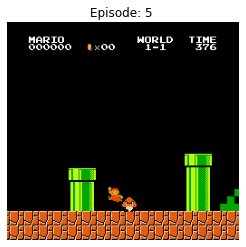

100%|█████████████████████████████████████████████| 5/5 [01:31<00:00, 18.27s/it]

=> Episode 5 Score = 581.00, Average Score = 357.20


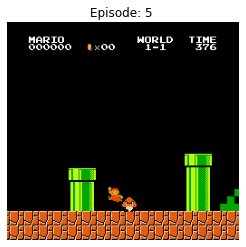

In [ ]:
# For Testing
#episodes_nb_test = 3
deepq_simple_x_test,deepq_simple_y_test = run(training_mode=False, pretrained=False, double_dqn=False, num_episodes=episodes_nb_test, 
                                              exploration_max = 0.05, movement = SIMPLE_MOVEMENT)

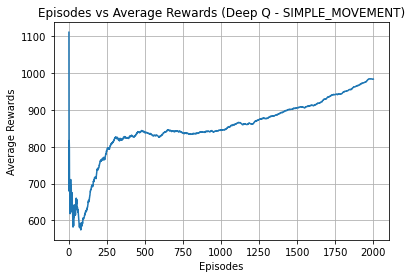

In [ ]:
plt.plot(deepq_simple_x, deepq_simple_y)
plt.title(f"Episodes vs Average Rewards (Deep Q - SIMPLE_MOVEMENT)")
plt.xlabel("Episodes") 
plt.ylabel("Average Rewards") 
plt.grid()
plt.show()

## Deep Q-Learning Movement => COMPLEX_MOVEMENT

In [ ]:
# Number of episode that you want to train;
episodes_nb = 2000
# For training
deepq_complex_x, deepq_complex_y = run(training_mode=True, pretrained=False, double_dqn=False, num_episodes=episodes_nb, 
                                       exploration_max = 0.95, movement = COMPLEX_MOVEMENT)

Current device is Cuda


  0%|          | 0/2000 [00:00<?, ?it/s]

=> Episode 1 Score = 208.00, Average Score = 208.00
=> Episode 2 Score = 1384.00, Average Score = 796.00
=> Episode 3 Score = 131.00, Average Score = 574.33
=> Episode 4 Score = 245.00, Average Score = 492.00
=> Episode 5 Score = 678.00, Average Score = 529.20
=> Episode 6 Score = 67.00, Average Score = 452.17
=> Episode 7 Score = 56.00, Average Score = 395.57
=> Episode 8 Score = 30.00, Average Score = 349.88
=> Episode 9 Score = 239.00, Average Score = 337.56
=> Episode 10 Score = 585.00, Average Score = 362.30
=> Episode 11 Score = 631.00, Average Score = 386.73
=> Episode 12 Score = 611.00, Average Score = 405.42
=> Episode 13 Score = 244.00, Average Score = 393.00
=> Episode 14 Score = 595.00, Average Score = 407.43
=> Episode 15 Score = 246.00, Average Score = 396.67
=> Episode 16 Score = 625.00, Average Score = 410.94
=> Episode 17 Score = 652.00, Average Score = 425.12
=> Episode 18 Score = 574.00, Average Score = 433.39
=> Episode 19 Score = 1010.00, Average Score = 463.74
=> 

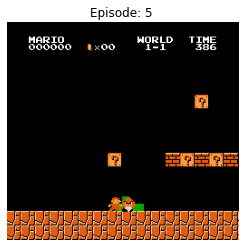

100%|█████████████████████████████████████████████| 5/5 [06:07<00:00, 73.52s/it]

=> Episode 5 Score = 193.00, Average Score = 175.80


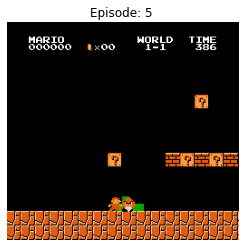

In [ ]:
# For Testing
#episodes_nb_test = 3
deepq_complex_x_test,deepq_complex_y_test = run(training_mode=False, pretrained=False, double_dqn=False, num_episodes=episodes_nb_test, 
                                                exploration_max = 0.05, movement = COMPLEX_MOVEMENT)

In [ ]:
plt.plot(deepq_complex_x, deepq_complex_y)
plt.title(f"Episodes vs Average Rewards (Deep Q - COMPLEX_MOVEMENT)")
plt.xlabel("Episodes") 
plt.ylabel("Average Rewards") 
plt.grid()
plt.show()

## Double Deep Q-Learning Movement => Right Only 

In [ ]:
# Number of episode that you want to train;
#episodes_nb = 3
# For training
double_deepq_right_x, double_deepq_right_y = run(training_mode=True, pretrained=False, double_dqn=True, num_episodes=episodes_nb, 
                                                 exploration_max = 0.95, movement = RIGHT_ONLY)

Current device is Cuda


  0%|                                        | 1/2000 [00:01<1:03:03,  1.89s/it]

=> Episode 1 Score = 609.00, Average Score = 609.00


  0%|                                          | 2/2000 [00:03<53:34,  1.61s/it]

=> Episode 2 Score = 626.00, Average Score = 617.50


  0%|                                        | 3/2000 [00:06<1:11:02,  2.13s/it]

=> Episode 3 Score = 749.00, Average Score = 661.33


  0%|                                        | 4/2000 [00:07<1:00:42,  1.82s/it]

=> Episode 4 Score = 608.00, Average Score = 648.00


  0%|                                          | 5/2000 [00:07<45:27,  1.37s/it]

=> Episode 5 Score = 248.00, Average Score = 568.00


  0%|▏                                         | 6/2000 [00:09<49:20,  1.48s/it]

=> Episode 6 Score = 603.00, Average Score = 573.83


  0%|▏                                         | 7/2000 [00:10<47:13,  1.42s/it]

=> Episode 7 Score = 605.00, Average Score = 578.29


  0%|▏                                         | 8/2000 [00:12<44:25,  1.34s/it]

=> Episode 8 Score = 621.00, Average Score = 583.62


  0%|▏                                         | 9/2000 [00:12<35:35,  1.07s/it]

=> Episode 9 Score = 252.00, Average Score = 546.78


  0%|▏                                        | 10/2000 [00:14<48:21,  1.46s/it]

=> Episode 10 Score = 640.00, Average Score = 556.10


  1%|▏                                        | 11/2000 [00:16<47:36,  1.44s/it]

=> Episode 11 Score = 651.00, Average Score = 564.73


  1%|▏                                      | 12/2000 [00:19<1:01:23,  1.85s/it]

=> Episode 12 Score = 729.00, Average Score = 578.42


  1%|▎                                        | 13/2000 [00:19<47:59,  1.45s/it]

=> Episode 13 Score = 245.00, Average Score = 552.77


  1%|▎                                        | 14/2000 [00:20<38:18,  1.16s/it]

=> Episode 14 Score = 248.00, Average Score = 531.00


  1%|▎                                        | 15/2000 [00:20<31:26,  1.05it/s]

=> Episode 15 Score = 252.00, Average Score = 512.40


  1%|▎                                        | 16/2000 [00:21<27:01,  1.22it/s]

=> Episode 16 Score = 242.00, Average Score = 495.50


  1%|▎                                        | 17/2000 [00:22<30:40,  1.08it/s]

=> Episode 17 Score = 621.00, Average Score = 502.88


  1%|▎                                        | 18/2000 [00:25<49:32,  1.50s/it]

=> Episode 18 Score = 764.00, Average Score = 517.39


  1%|▎                                      | 19/2000 [00:30<1:29:27,  2.71s/it]

=> Episode 19 Score = 1007.00, Average Score = 543.16


  1%|▍                                      | 20/2000 [00:31<1:07:53,  2.06s/it]

=> Episode 20 Score = 242.00, Average Score = 528.10


  1%|▍                                      | 21/2000 [00:33<1:11:46,  2.18s/it]

=> Episode 21 Score = 1044.00, Average Score = 552.67


  1%|▍                                      | 22/2000 [00:36<1:20:47,  2.45s/it]

=> Episode 22 Score = 807.00, Average Score = 564.23


  1%|▍                                      | 23/2000 [00:37<1:01:13,  1.86s/it]

=> Episode 23 Score = 248.00, Average Score = 550.48


  1%|▍                                        | 24/2000 [00:37<47:34,  1.44s/it]

=> Episode 24 Score = 248.00, Average Score = 537.88


  1%|▌                                        | 25/2000 [00:38<37:58,  1.15s/it]

=> Episode 25 Score = 248.00, Average Score = 526.28


  1%|▌                                        | 26/2000 [00:38<31:56,  1.03it/s]

=> Episode 26 Score = 239.00, Average Score = 515.23


  1%|▌                                        | 27/2000 [00:39<27:01,  1.22it/s]

=> Episode 27 Score = 248.00, Average Score = 505.33


  1%|▌                                        | 28/2000 [00:39<23:43,  1.39it/s]

=> Episode 28 Score = 252.00, Average Score = 496.29


  1%|▌                                        | 29/2000 [00:40<21:24,  1.53it/s]

=> Episode 29 Score = 248.00, Average Score = 487.72


  2%|▌                                        | 30/2000 [00:40<19:51,  1.65it/s]

=> Episode 30 Score = 249.00, Average Score = 479.77


  2%|▋                                        | 31/2000 [00:41<19:35,  1.67it/s]

=> Episode 31 Score = 243.00, Average Score = 472.13


  2%|▋                                        | 32/2000 [00:45<57:48,  1.76s/it]

=> Episode 32 Score = 1019.00, Average Score = 489.22


  2%|▋                                      | 33/2000 [00:48<1:05:16,  1.99s/it]

=> Episode 33 Score = 1042.00, Average Score = 505.97


  2%|▋                                        | 34/2000 [00:48<50:38,  1.55s/it]

=> Episode 34 Score = 250.00, Average Score = 498.44


  2%|▋                                        | 35/2000 [00:49<40:59,  1.25s/it]

=> Episode 35 Score = 239.00, Average Score = 491.03


  2%|▋                                        | 36/2000 [00:49<33:26,  1.02s/it]

=> Episode 36 Score = 249.00, Average Score = 484.31


  2%|▊                                        | 37/2000 [00:50<28:01,  1.17it/s]

=> Episode 37 Score = 248.00, Average Score = 477.92


  2%|▊                                        | 38/2000 [00:50<24:15,  1.35it/s]

=> Episode 38 Score = 248.00, Average Score = 471.87


  2%|▊                                        | 39/2000 [00:51<22:29,  1.45it/s]

=> Episode 39 Score = 239.00, Average Score = 465.90


  2%|▊                                        | 40/2000 [00:51<20:27,  1.60it/s]

=> Episode 40 Score = 248.00, Average Score = 460.45


  2%|▊                                        | 41/2000 [00:52<19:00,  1.72it/s]

=> Episode 41 Score = 251.00, Average Score = 455.34


  2%|▊                                        | 42/2000 [00:52<18:00,  1.81it/s]

=> Episode 42 Score = 248.00, Average Score = 450.40


  2%|▉                                        | 43/2000 [00:53<17:17,  1.89it/s]

=> Episode 43 Score = 251.00, Average Score = 445.77


  2%|▉                                        | 44/2000 [00:56<41:09,  1.26s/it]

=> Episode 44 Score = 1039.00, Average Score = 459.25


  2%|▉                                      | 45/2000 [01:00<1:07:32,  2.07s/it]

=> Episode 45 Score = 1025.00, Average Score = 471.82


  2%|▉                                        | 46/2000 [01:00<51:50,  1.59s/it]

=> Episode 46 Score = 252.00, Average Score = 467.04


  2%|▉                                        | 47/2000 [01:01<41:32,  1.28s/it]

=> Episode 47 Score = 238.00, Average Score = 462.17


  2%|▉                                      | 48/2000 [01:04<1:01:09,  1.88s/it]

=> Episode 48 Score = 1031.00, Average Score = 474.02


  2%|▉                                      | 49/2000 [01:06<1:06:06,  2.03s/it]

=> Episode 49 Score = 815.00, Average Score = 480.98


  2%|█                                        | 50/2000 [01:07<50:51,  1.56s/it]

=> Episode 50 Score = 248.00, Average Score = 476.32


  3%|█                                        | 51/2000 [01:07<40:18,  1.24s/it]

=> Episode 51 Score = 248.00, Average Score = 471.84


  3%|█                                        | 52/2000 [01:10<51:01,  1.57s/it]

=> Episode 52 Score = 816.00, Average Score = 478.46


  3%|█                                        | 53/2000 [01:10<40:42,  1.25s/it]

=> Episode 53 Score = 248.00, Average Score = 474.11


  3%|█                                        | 54/2000 [01:11<33:14,  1.02s/it]

=> Episode 54 Score = 248.00, Average Score = 469.93


  3%|█▏                                       | 55/2000 [01:11<28:29,  1.14it/s]

=> Episode 55 Score = 240.00, Average Score = 465.75


  3%|█▏                                       | 56/2000 [01:12<25:08,  1.29it/s]

=> Episode 56 Score = 241.00, Average Score = 461.73


  3%|█▏                                       | 57/2000 [01:12<22:10,  1.46it/s]

=> Episode 57 Score = 247.00, Average Score = 457.96


  3%|█▏                                       | 58/2000 [01:15<44:35,  1.38s/it]

=> Episode 58 Score = 1035.00, Average Score = 467.91


  3%|█▏                                       | 59/2000 [01:17<52:00,  1.61s/it]

=> Episode 59 Score = 1044.00, Average Score = 477.68


  3%|█▏                                       | 60/2000 [01:18<40:55,  1.27s/it]

=> Episode 60 Score = 250.00, Average Score = 473.88


  3%|█▎                                       | 61/2000 [01:18<34:34,  1.07s/it]

=> Episode 61 Score = 239.00, Average Score = 470.03


  3%|█▎                                       | 62/2000 [01:19<28:36,  1.13it/s]

=> Episode 62 Score = 248.00, Average Score = 466.45


  3%|█▎                                       | 63/2000 [01:19<24:33,  1.31it/s]

=> Episode 63 Score = 252.00, Average Score = 463.05


  3%|█▎                                       | 64/2000 [01:20<21:45,  1.48it/s]

=> Episode 64 Score = 248.00, Average Score = 459.69


  3%|█▎                                       | 65/2000 [01:20<19:47,  1.63it/s]

=> Episode 65 Score = 249.00, Average Score = 456.45


  3%|█▎                                       | 66/2000 [01:21<18:35,  1.73it/s]

=> Episode 66 Score = 248.00, Average Score = 453.29


  3%|█▎                                       | 67/2000 [01:24<41:15,  1.28s/it]

=> Episode 67 Score = 1036.00, Average Score = 461.99


  3%|█▍                                       | 68/2000 [01:24<33:29,  1.04s/it]

=> Episode 68 Score = 249.00, Average Score = 458.85


  3%|█▍                                       | 69/2000 [01:25<31:33,  1.02it/s]

=> Episode 69 Score = 248.00, Average Score = 455.80


  4%|█▍                                       | 70/2000 [01:28<50:45,  1.58s/it]

=> Episode 70 Score = 1036.00, Average Score = 464.09


  4%|█▍                                     | 71/2000 [01:31<1:01:54,  1.93s/it]

=> Episode 71 Score = 811.00, Average Score = 468.97


  4%|█▍                                       | 72/2000 [01:31<47:53,  1.49s/it]

=> Episode 72 Score = 248.00, Average Score = 465.90


  4%|█▍                                       | 73/2000 [01:32<38:04,  1.19s/it]

=> Episode 73 Score = 252.00, Average Score = 462.97


  4%|█▌                                       | 74/2000 [01:34<48:42,  1.52s/it]

=> Episode 74 Score = 617.00, Average Score = 465.05


  4%|█▍                                     | 75/2000 [01:37<1:01:22,  1.91s/it]

=> Episode 75 Score = 810.00, Average Score = 469.65


  4%|█▌                                       | 76/2000 [01:37<47:38,  1.49s/it]

=> Episode 76 Score = 247.00, Average Score = 466.72


  4%|█▌                                       | 77/2000 [01:38<37:42,  1.18s/it]

=> Episode 77 Score = 248.00, Average Score = 463.88


  4%|█▌                                       | 78/2000 [01:38<30:46,  1.04it/s]

=> Episode 78 Score = 249.00, Average Score = 461.13


  4%|█▌                                       | 79/2000 [01:39<26:16,  1.22it/s]

=> Episode 79 Score = 250.00, Average Score = 458.46


  4%|█▋                                       | 80/2000 [01:39<23:10,  1.38it/s]

=> Episode 80 Score = 250.00, Average Score = 455.85


  4%|█▋                                       | 81/2000 [01:40<21:05,  1.52it/s]

=> Episode 81 Score = 241.00, Average Score = 453.20


  4%|█▋                                       | 82/2000 [01:40<19:51,  1.61it/s]

=> Episode 82 Score = 248.00, Average Score = 450.70


  4%|█▋                                       | 83/2000 [01:43<41:53,  1.31s/it]

=> Episode 83 Score = 1037.00, Average Score = 457.76


  4%|█▋                                       | 84/2000 [01:45<42:40,  1.34s/it]

=> Episode 84 Score = 618.00, Average Score = 459.67


  4%|█▋                                       | 85/2000 [01:46<43:55,  1.38s/it]

=> Episode 85 Score = 612.00, Average Score = 461.46


  4%|█▊                                       | 86/2000 [01:47<36:00,  1.13s/it]

=> Episode 86 Score = 250.00, Average Score = 459.00


  4%|█▊                                       | 87/2000 [01:47<29:30,  1.08it/s]

=> Episode 87 Score = 248.00, Average Score = 456.57


  4%|█▊                                       | 88/2000 [01:51<57:32,  1.81s/it]

=> Episode 88 Score = 1027.00, Average Score = 463.06


  4%|█▊                                       | 89/2000 [01:51<45:22,  1.42s/it]

=> Episode 89 Score = 250.00, Average Score = 460.66


  4%|█▊                                       | 90/2000 [01:53<41:54,  1.32s/it]

=> Episode 90 Score = 609.00, Average Score = 462.31


  5%|█▊                                       | 91/2000 [01:53<33:40,  1.06s/it]

=> Episode 91 Score = 252.00, Average Score = 460.00


  5%|█▉                                       | 92/2000 [01:54<36:10,  1.14s/it]

=> Episode 92 Score = 620.00, Average Score = 461.74


  5%|█▉                                       | 93/2000 [01:55<29:39,  1.07it/s]

=> Episode 93 Score = 250.00, Average Score = 459.46


  5%|█▉                                       | 94/2000 [01:55<25:47,  1.23it/s]

=> Episode 94 Score = 238.00, Average Score = 457.11


  5%|█▊                                     | 95/2000 [02:00<1:03:26,  2.00s/it]

=> Episode 95 Score = 1017.00, Average Score = 463.00


  5%|█▊                                     | 96/2000 [02:02<1:03:59,  2.02s/it]

=> Episode 96 Score = 749.00, Average Score = 465.98


  5%|█▉                                       | 97/2000 [02:03<49:31,  1.56s/it]

=> Episode 97 Score = 247.00, Average Score = 463.72


  5%|██                                       | 98/2000 [02:05<58:43,  1.85s/it]

=> Episode 98 Score = 1042.00, Average Score = 469.62


  5%|█▉                                     | 99/2000 [02:07<1:02:37,  1.98s/it]

=> Episode 99 Score = 640.00, Average Score = 471.34


  5%|██                                      | 100/2000 [02:08<48:10,  1.52s/it]

=> Episode 100 Score = 250.00, Average Score = 469.13


  5%|██                                      | 101/2000 [02:10<57:47,  1.83s/it]

=> Episode 101 Score = 1043.00, Average Score = 474.81


  5%|██                                      | 102/2000 [02:12<54:17,  1.72s/it]

=> Episode 102 Score = 613.00, Average Score = 476.17


  5%|██                                      | 103/2000 [02:12<42:16,  1.34s/it]

=> Episode 103 Score = 252.00, Average Score = 473.99


  5%|█▉                                    | 104/2000 [02:16<1:09:07,  2.19s/it]

=> Episode 104 Score = 1023.00, Average Score = 479.27


  5%|█▉                                    | 105/2000 [02:19<1:07:58,  2.15s/it]

=> Episode 105 Score = 1046.00, Average Score = 484.67


  5%|██                                      | 106/2000 [02:19<51:57,  1.65s/it]

=> Episode 106 Score = 252.00, Average Score = 482.47


  5%|██                                    | 107/2000 [02:22<1:00:54,  1.93s/it]

=> Episode 107 Score = 1042.00, Average Score = 487.70


  5%|██▏                                     | 108/2000 [02:23<54:53,  1.74s/it]

=> Episode 108 Score = 625.00, Average Score = 488.97


  5%|██▏                                     | 109/2000 [02:23<42:45,  1.36s/it]

=> Episode 109 Score = 248.00, Average Score = 486.76


  6%|██▏                                     | 110/2000 [02:25<40:56,  1.30s/it]

=> Episode 110 Score = 634.00, Average Score = 488.10


  6%|██                                    | 111/2000 [02:29<1:08:26,  2.17s/it]

=> Episode 111 Score = 1024.00, Average Score = 492.93


  6%|██▏                                     | 112/2000 [02:29<52:50,  1.68s/it]

=> Episode 112 Score = 239.00, Average Score = 490.66


  6%|██▎                                     | 113/2000 [02:30<46:19,  1.47s/it]

=> Episode 113 Score = 612.00, Average Score = 491.73


  6%|██▏                                   | 114/2000 [02:34<1:05:28,  2.08s/it]

=> Episode 114 Score = 802.00, Average Score = 494.46


  6%|██▎                                     | 115/2000 [02:34<50:06,  1.60s/it]

=> Episode 115 Score = 250.00, Average Score = 492.33


  6%|██▏                                   | 116/2000 [02:38<1:07:18,  2.14s/it]

=> Episode 116 Score = 614.00, Average Score = 493.38


  6%|██▏                                   | 117/2000 [02:40<1:12:58,  2.33s/it]

=> Episode 117 Score = 1039.00, Average Score = 498.04


  6%|██▏                                   | 118/2000 [02:44<1:22:21,  2.63s/it]

=> Episode 118 Score = 1033.00, Average Score = 502.58


  6%|██▎                                   | 119/2000 [02:44<1:02:39,  2.00s/it]

=> Episode 119 Score = 236.00, Average Score = 500.34


  6%|██▍                                     | 120/2000 [02:45<48:05,  1.53s/it]

=> Episode 120 Score = 252.00, Average Score = 498.27


  6%|██▍                                     | 121/2000 [02:45<37:53,  1.21s/it]

=> Episode 121 Score = 252.00, Average Score = 496.23


  6%|██▍                                     | 122/2000 [02:46<30:54,  1.01it/s]

=> Episode 122 Score = 248.00, Average Score = 494.20


  6%|██▍                                     | 123/2000 [02:48<40:46,  1.30s/it]

=> Episode 123 Score = 819.00, Average Score = 496.84


  6%|██▍                                     | 124/2000 [02:49<45:41,  1.46s/it]

=> Episode 124 Score = 740.00, Average Score = 498.80


  6%|██▍                                   | 125/2000 [02:54<1:16:20,  2.44s/it]

=> Episode 125 Score = 1017.00, Average Score = 502.94


  6%|██▌                                     | 126/2000 [02:55<57:41,  1.85s/it]

=> Episode 126 Score = 252.00, Average Score = 500.95


  6%|██▍                                   | 127/2000 [02:57<1:02:57,  2.02s/it]

=> Episode 127 Score = 815.00, Average Score = 503.43


  6%|██▍                                   | 128/2000 [02:59<1:04:13,  2.06s/it]

=> Episode 128 Score = 818.00, Average Score = 505.88


  6%|██▌                                     | 129/2000 [03:00<49:14,  1.58s/it]

=> Episode 129 Score = 250.00, Average Score = 503.90


  6%|██▌                                     | 130/2000 [03:01<48:33,  1.56s/it]

=> Episode 130 Score = 616.00, Average Score = 504.76


  7%|██▌                                     | 131/2000 [03:02<38:23,  1.23s/it]

=> Episode 131 Score = 248.00, Average Score = 502.80


  7%|██▋                                     | 132/2000 [03:02<31:15,  1.00s/it]

=> Episode 132 Score = 248.00, Average Score = 500.87


  7%|██▋                                     | 133/2000 [03:03<26:10,  1.19it/s]

=> Episode 133 Score = 250.00, Average Score = 498.98


  7%|██▋                                     | 134/2000 [03:04<31:58,  1.03s/it]

=> Episode 134 Score = 617.00, Average Score = 499.87


  7%|██▋                                     | 135/2000 [03:05<26:37,  1.17it/s]

=> Episode 135 Score = 252.00, Average Score = 498.03


  7%|██▋                                     | 136/2000 [03:05<23:37,  1.31it/s]

=> Episode 136 Score = 236.00, Average Score = 496.10


  7%|██▋                                     | 137/2000 [03:06<20:46,  1.49it/s]

=> Episode 137 Score = 252.00, Average Score = 494.32


  7%|██▊                                     | 138/2000 [03:09<47:17,  1.52s/it]

=> Episode 138 Score = 1033.00, Average Score = 498.22


  7%|██▋                                   | 139/2000 [03:13<1:12:58,  2.35s/it]

=> Episode 139 Score = 1018.00, Average Score = 501.96


  7%|██▋                                   | 140/2000 [03:15<1:01:55,  2.00s/it]

=> Episode 140 Score = 634.00, Average Score = 502.91


  7%|██▊                                     | 141/2000 [03:15<47:42,  1.54s/it]

=> Episode 141 Score = 248.00, Average Score = 501.10


  7%|██▋                                   | 142/2000 [03:18<1:03:46,  2.06s/it]

=> Episode 142 Score = 1033.00, Average Score = 504.85


  7%|██▋                                   | 143/2000 [03:21<1:06:47,  2.16s/it]

=> Episode 143 Score = 1045.00, Average Score = 508.62


  7%|██▉                                     | 144/2000 [03:21<50:58,  1.65s/it]

=> Episode 144 Score = 252.00, Average Score = 506.84


  7%|██▉                                     | 145/2000 [03:22<40:40,  1.32s/it]

=> Episode 145 Score = 236.00, Average Score = 504.97


  7%|██▉                                     | 146/2000 [03:25<58:15,  1.89s/it]

=> Episode 146 Score = 1034.00, Average Score = 508.60


  7%|██▉                                     | 147/2000 [03:25<45:10,  1.46s/it]

=> Episode 147 Score = 249.00, Average Score = 506.83


  7%|██▉                                     | 148/2000 [03:26<36:47,  1.19s/it]

=> Episode 148 Score = 239.00, Average Score = 505.02


  7%|██▉                                     | 149/2000 [03:29<52:31,  1.70s/it]

=> Episode 149 Score = 1038.00, Average Score = 508.60


  8%|██▊                                   | 150/2000 [03:32<1:05:58,  2.14s/it]

=> Episode 150 Score = 1036.00, Average Score = 512.11


  8%|███                                     | 151/2000 [03:32<50:32,  1.64s/it]

=> Episode 151 Score = 248.00, Average Score = 510.36


  8%|███                                     | 152/2000 [03:33<39:52,  1.29s/it]

=> Episode 152 Score = 248.00, Average Score = 508.64


  8%|███                                     | 153/2000 [03:34<39:49,  1.29s/it]

=> Episode 153 Score = 633.00, Average Score = 509.45


  8%|██▉                                   | 154/2000 [03:38<1:04:30,  2.10s/it]

=> Episode 154 Score = 1025.00, Average Score = 512.80


  8%|███                                     | 155/2000 [03:39<49:22,  1.61s/it]

=> Episode 155 Score = 250.00, Average Score = 511.10


  8%|███                                     | 156/2000 [03:40<47:45,  1.55s/it]

=> Episode 156 Score = 605.00, Average Score = 511.71


  8%|███▏                                    | 157/2000 [03:42<48:16,  1.57s/it]

=> Episode 157 Score = 625.00, Average Score = 512.43


  8%|███▏                                    | 158/2000 [03:43<46:27,  1.51s/it]

=> Episode 158 Score = 627.00, Average Score = 513.15


  8%|███▏                                    | 159/2000 [03:44<37:44,  1.23s/it]

=> Episode 159 Score = 250.00, Average Score = 511.50


  8%|███                                   | 160/2000 [03:49<1:20:13,  2.62s/it]

=> Episode 160 Score = 1005.00, Average Score = 514.58


  8%|███                                   | 161/2000 [03:50<1:00:26,  1.97s/it]

=> Episode 161 Score = 252.00, Average Score = 512.95


  8%|███▏                                    | 162/2000 [03:50<47:10,  1.54s/it]

=> Episode 162 Score = 240.00, Average Score = 511.27


  8%|███▎                                    | 163/2000 [03:51<37:15,  1.22s/it]

=> Episode 163 Score = 249.00, Average Score = 509.66


  8%|███▎                                    | 164/2000 [03:51<30:21,  1.01it/s]

=> Episode 164 Score = 247.00, Average Score = 508.05


  8%|███▎                                    | 165/2000 [03:52<25:34,  1.20it/s]

=> Episode 165 Score = 248.00, Average Score = 506.48


  8%|███▎                                    | 166/2000 [03:55<49:33,  1.62s/it]

=> Episode 166 Score = 1033.00, Average Score = 509.65


  8%|███▎                                    | 167/2000 [03:57<48:04,  1.57s/it]

=> Episode 167 Score = 613.00, Average Score = 510.27


  8%|███▎                                    | 168/2000 [03:58<46:43,  1.53s/it]

=> Episode 168 Score = 605.00, Average Score = 510.83


  8%|███▍                                    | 169/2000 [04:00<44:37,  1.46s/it]

=> Episode 169 Score = 635.00, Average Score = 511.57


  8%|███▍                                    | 170/2000 [04:01<43:40,  1.43s/it]

=> Episode 170 Score = 618.00, Average Score = 512.19


  9%|███▍                                    | 171/2000 [04:01<35:29,  1.16s/it]

=> Episode 171 Score = 242.00, Average Score = 510.61


  9%|███▍                                    | 172/2000 [04:04<45:35,  1.50s/it]

=> Episode 172 Score = 1048.00, Average Score = 513.74


  9%|███▎                                  | 173/2000 [04:07<1:06:23,  2.18s/it]

=> Episode 173 Score = 799.00, Average Score = 515.39


  9%|███▍                                    | 174/2000 [04:08<50:47,  1.67s/it]

=> Episode 174 Score = 248.00, Average Score = 513.85


  9%|███▎                                  | 175/2000 [04:15<1:38:29,  3.24s/it]

=> Episode 175 Score = 993.00, Average Score = 516.59


  9%|███▎                                  | 176/2000 [04:18<1:38:25,  3.24s/it]

=> Episode 176 Score = 1032.00, Average Score = 519.52


  9%|███▎                                  | 177/2000 [04:21<1:32:28,  3.04s/it]

=> Episode 177 Score = 1037.00, Average Score = 522.44


  9%|███▍                                  | 178/2000 [04:23<1:29:55,  2.96s/it]

=> Episode 178 Score = 1036.00, Average Score = 525.33


  9%|███▍                                  | 179/2000 [04:26<1:22:01,  2.70s/it]

=> Episode 179 Score = 1044.00, Average Score = 528.22


  9%|███▍                                  | 180/2000 [04:29<1:28:26,  2.92s/it]

=> Episode 180 Score = 1027.00, Average Score = 530.99


  9%|███▍                                  | 181/2000 [04:32<1:30:06,  2.97s/it]

=> Episode 181 Score = 1033.00, Average Score = 533.77


  9%|███▍                                  | 182/2000 [04:34<1:20:53,  2.67s/it]

=> Episode 182 Score = 747.00, Average Score = 534.94


  9%|███▍                                  | 183/2000 [04:35<1:07:59,  2.25s/it]

=> Episode 183 Score = 627.00, Average Score = 535.44


  9%|███▋                                    | 184/2000 [04:36<51:53,  1.71s/it]

=> Episode 184 Score = 248.00, Average Score = 533.88


  9%|███▌                                  | 185/2000 [04:39<1:02:09,  2.05s/it]

=> Episode 185 Score = 1343.00, Average Score = 538.25


  9%|███▋                                    | 186/2000 [04:40<54:21,  1.80s/it]

=> Episode 186 Score = 637.00, Average Score = 538.78


  9%|███▋                                    | 187/2000 [04:42<59:10,  1.96s/it]

=> Episode 187 Score = 640.00, Average Score = 539.33


  9%|███▊                                    | 188/2000 [04:43<45:38,  1.51s/it]

=> Episode 188 Score = 248.00, Average Score = 537.78


  9%|███▊                                    | 189/2000 [04:44<41:57,  1.39s/it]

=> Episode 189 Score = 629.00, Average Score = 538.26


 10%|███▊                                    | 190/2000 [04:45<41:27,  1.37s/it]

=> Episode 190 Score = 623.00, Average Score = 538.71


 10%|███▊                                    | 191/2000 [04:46<39:02,  1.29s/it]

=> Episode 191 Score = 629.00, Average Score = 539.18


 10%|███▊                                    | 192/2000 [04:47<32:09,  1.07s/it]

=> Episode 192 Score = 236.00, Average Score = 537.60


 10%|███▊                                    | 193/2000 [04:48<32:33,  1.08s/it]

=> Episode 193 Score = 631.00, Average Score = 538.08


 10%|███▉                                    | 194/2000 [04:48<26:57,  1.12it/s]

=> Episode 194 Score = 248.00, Average Score = 536.59


 10%|███▉                                    | 195/2000 [04:49<29:53,  1.01it/s]

=> Episode 195 Score = 631.00, Average Score = 537.07


 10%|███▋                                  | 196/2000 [04:54<1:04:04,  2.13s/it]

=> Episode 196 Score = 1012.00, Average Score = 539.49


 10%|███▋                                  | 197/2000 [04:57<1:12:59,  2.43s/it]

=> Episode 197 Score = 1031.00, Average Score = 541.99


 10%|███▊                                  | 198/2000 [05:00<1:12:30,  2.41s/it]

=> Episode 198 Score = 640.00, Average Score = 542.48


 10%|███▊                                  | 199/2000 [05:01<1:03:49,  2.13s/it]

=> Episode 199 Score = 610.00, Average Score = 542.82


 10%|████                                    | 200/2000 [05:02<55:51,  1.86s/it]

=> Episode 200 Score = 635.00, Average Score = 543.28


 10%|████                                    | 201/2000 [05:03<43:10,  1.44s/it]

=> Episode 201 Score = 252.00, Average Score = 541.84


 10%|████                                    | 202/2000 [05:04<42:09,  1.41s/it]

=> Episode 202 Score = 622.00, Average Score = 542.23


 10%|████                                    | 203/2000 [05:07<53:22,  1.78s/it]

=> Episode 203 Score = 812.00, Average Score = 543.56


 10%|████                                    | 204/2000 [05:07<42:16,  1.41s/it]

=> Episode 204 Score = 250.00, Average Score = 542.12


 10%|████                                    | 205/2000 [05:09<41:05,  1.37s/it]

=> Episode 205 Score = 627.00, Average Score = 542.54


 10%|████                                    | 206/2000 [05:09<32:57,  1.10s/it]

=> Episode 206 Score = 252.00, Average Score = 541.13


 10%|████▏                                   | 207/2000 [05:11<42:45,  1.43s/it]

=> Episode 207 Score = 817.00, Average Score = 542.46


 10%|████▏                                   | 208/2000 [05:14<50:13,  1.68s/it]

=> Episode 208 Score = 785.00, Average Score = 543.62


 10%|███▉                                  | 209/2000 [05:17<1:02:31,  2.09s/it]

=> Episode 209 Score = 1340.00, Average Score = 547.44


 10%|███▉                                  | 210/2000 [05:19<1:00:05,  2.01s/it]

=> Episode 210 Score = 742.00, Average Score = 548.36


 11%|████                                  | 211/2000 [05:22<1:15:28,  2.53s/it]

=> Episode 211 Score = 799.00, Average Score = 549.55


 11%|████                                  | 212/2000 [05:23<1:01:28,  2.06s/it]

=> Episode 212 Score = 610.00, Average Score = 549.83


 11%|████▎                                   | 213/2000 [05:24<47:35,  1.60s/it]

=> Episode 213 Score = 245.00, Average Score = 548.40


 11%|████                                  | 214/2000 [05:27<1:01:19,  2.06s/it]

=> Episode 214 Score = 1031.00, Average Score = 550.66


 11%|████▎                                   | 215/2000 [05:27<47:03,  1.58s/it]

=> Episode 215 Score = 252.00, Average Score = 549.27


 11%|████▎                                   | 216/2000 [05:28<37:05,  1.25s/it]

=> Episode 216 Score = 251.00, Average Score = 547.89


 11%|████▎                                   | 217/2000 [05:28<30:20,  1.02s/it]

=> Episode 217 Score = 247.00, Average Score = 546.50


 11%|████▎                                   | 218/2000 [05:29<25:24,  1.17it/s]

=> Episode 218 Score = 252.00, Average Score = 545.15


 11%|████▍                                   | 219/2000 [05:31<37:33,  1.27s/it]

=> Episode 219 Score = 817.00, Average Score = 546.39


 11%|████▍                                   | 220/2000 [05:34<53:09,  1.79s/it]

=> Episode 220 Score = 1037.00, Average Score = 548.62


 11%|████▍                                   | 221/2000 [05:35<42:18,  1.43s/it]

=> Episode 221 Score = 237.00, Average Score = 547.21


 11%|████▍                                   | 222/2000 [05:35<33:43,  1.14s/it]

=> Episode 222 Score = 252.00, Average Score = 545.88


 11%|████▍                                   | 223/2000 [05:37<43:24,  1.47s/it]

=> Episode 223 Score = 817.00, Average Score = 547.10


 11%|████▍                                   | 224/2000 [05:40<50:54,  1.72s/it]

=> Episode 224 Score = 640.00, Average Score = 547.51


 11%|████▌                                   | 225/2000 [05:42<55:13,  1.87s/it]

=> Episode 225 Score = 736.00, Average Score = 548.35


 11%|████▌                                   | 226/2000 [05:44<58:07,  1.97s/it]

=> Episode 226 Score = 1046.00, Average Score = 550.55


 11%|████▎                                 | 227/2000 [05:47<1:08:31,  2.32s/it]

=> Episode 227 Score = 1338.00, Average Score = 554.02


 11%|████▌                                   | 228/2000 [05:48<58:49,  1.99s/it]

=> Episode 228 Score = 653.00, Average Score = 554.46


 11%|████▌                                   | 229/2000 [05:49<45:09,  1.53s/it]

=> Episode 229 Score = 248.00, Average Score = 553.12


 12%|████▌                                   | 230/2000 [05:49<35:35,  1.21s/it]

=> Episode 230 Score = 248.00, Average Score = 551.79


 12%|████▌                                   | 231/2000 [05:50<28:55,  1.02it/s]

=> Episode 231 Score = 248.00, Average Score = 550.48


 12%|████▋                                   | 232/2000 [05:51<32:57,  1.12s/it]

=> Episode 232 Score = 620.00, Average Score = 550.78


 12%|████▋                                   | 233/2000 [05:54<43:47,  1.49s/it]

=> Episode 233 Score = 640.00, Average Score = 551.16


 12%|████▍                                 | 234/2000 [05:59<1:22:44,  2.81s/it]

=> Episode 234 Score = 1003.00, Average Score = 553.09


 12%|████▍                                 | 235/2000 [06:02<1:23:50,  2.85s/it]

=> Episode 235 Score = 1039.00, Average Score = 555.16


 12%|████▍                                 | 236/2000 [06:04<1:10:09,  2.39s/it]

=> Episode 236 Score = 627.00, Average Score = 555.46


 12%|████▌                                 | 237/2000 [06:08<1:23:00,  2.83s/it]

=> Episode 237 Score = 1024.00, Average Score = 557.44


 12%|████▌                                 | 238/2000 [06:08<1:02:04,  2.11s/it]

=> Episode 238 Score = 252.00, Average Score = 556.16


 12%|████▌                                 | 239/2000 [06:11<1:05:14,  2.22s/it]

=> Episode 239 Score = 814.00, Average Score = 557.23


 12%|████▊                                   | 240/2000 [06:11<49:39,  1.69s/it]

=> Episode 240 Score = 246.00, Average Score = 555.94


 12%|████▊                                   | 241/2000 [06:12<44:48,  1.53s/it]

=> Episode 241 Score = 623.00, Average Score = 556.22


 12%|████▊                                   | 242/2000 [06:13<41:45,  1.43s/it]

=> Episode 242 Score = 624.00, Average Score = 556.50


 12%|████▊                                   | 243/2000 [06:14<38:54,  1.33s/it]

=> Episode 243 Score = 629.00, Average Score = 556.79


 12%|████▉                                   | 244/2000 [06:17<52:39,  1.80s/it]

=> Episode 244 Score = 1034.00, Average Score = 558.75


 12%|████▉                                   | 245/2000 [06:18<40:48,  1.40s/it]

=> Episode 245 Score = 252.00, Average Score = 557.50


 12%|████▉                                   | 246/2000 [06:21<54:05,  1.85s/it]

=> Episode 246 Score = 1039.00, Average Score = 559.46


 12%|████▉                                   | 247/2000 [06:22<47:05,  1.61s/it]

=> Episode 247 Score = 609.00, Average Score = 559.66


 12%|████▋                                 | 248/2000 [06:25<1:02:08,  2.13s/it]

=> Episode 248 Score = 1032.00, Average Score = 561.56


 12%|████▋                                 | 249/2000 [06:28<1:10:37,  2.42s/it]

=> Episode 249 Score = 1340.00, Average Score = 564.69


 12%|████▊                                 | 250/2000 [06:32<1:19:30,  2.73s/it]

=> Episode 250 Score = 1030.00, Average Score = 566.55


 13%|████▊                                 | 251/2000 [06:33<1:10:39,  2.42s/it]

=> Episode 251 Score = 625.00, Average Score = 566.78


 13%|█████                                   | 252/2000 [06:34<53:22,  1.83s/it]

=> Episode 252 Score = 248.00, Average Score = 565.52


 13%|█████                                   | 253/2000 [06:34<41:20,  1.42s/it]

=> Episode 253 Score = 249.00, Average Score = 564.26


 13%|█████                                   | 254/2000 [06:35<32:53,  1.13s/it]

=> Episode 254 Score = 248.00, Average Score = 563.02


 13%|█████                                   | 255/2000 [06:39<57:01,  1.96s/it]

=> Episode 255 Score = 1916.00, Average Score = 568.33


 13%|████▊                                 | 256/2000 [06:41<1:04:56,  2.23s/it]

=> Episode 256 Score = 1035.00, Average Score = 570.15


 13%|████▉                                 | 257/2000 [06:44<1:05:41,  2.26s/it]

=> Episode 257 Score = 614.00, Average Score = 570.32


 13%|█████▏                                  | 258/2000 [06:45<58:21,  2.01s/it]

=> Episode 258 Score = 608.00, Average Score = 570.47


 13%|█████▏                                  | 259/2000 [06:46<45:01,  1.55s/it]

=> Episode 259 Score = 248.00, Average Score = 569.22


 13%|█████▏                                  | 260/2000 [06:46<35:29,  1.22s/it]

=> Episode 260 Score = 248.00, Average Score = 567.98


 13%|█████▏                                  | 261/2000 [06:47<28:47,  1.01it/s]

=> Episode 261 Score = 248.00, Average Score = 566.76


 13%|█████▏                                  | 262/2000 [06:48<31:35,  1.09s/it]

=> Episode 262 Score = 624.00, Average Score = 566.98


 13%|█████▎                                  | 263/2000 [06:48<26:04,  1.11it/s]

=> Episode 263 Score = 248.00, Average Score = 565.76


 13%|█████▎                                  | 264/2000 [06:51<38:50,  1.34s/it]

=> Episode 264 Score = 1047.00, Average Score = 567.59


 13%|█████▎                                  | 265/2000 [06:52<37:44,  1.30s/it]

=> Episode 265 Score = 629.00, Average Score = 567.82


 13%|█████▎                                  | 266/2000 [06:53<37:54,  1.31s/it]

=> Episode 266 Score = 638.00, Average Score = 568.08


 13%|█████▎                                  | 267/2000 [06:54<30:36,  1.06s/it]

=> Episode 267 Score = 248.00, Average Score = 566.88


 13%|█████▎                                  | 268/2000 [06:54<25:21,  1.14it/s]

=> Episode 268 Score = 248.00, Average Score = 565.69


 13%|█████▍                                  | 269/2000 [06:56<30:17,  1.05s/it]

=> Episode 269 Score = 627.00, Average Score = 565.92


 14%|█████▍                                  | 270/2000 [06:56<25:16,  1.14it/s]

=> Episode 270 Score = 248.00, Average Score = 564.74


 14%|█████▍                                  | 271/2000 [06:57<29:22,  1.02s/it]

=> Episode 271 Score = 635.00, Average Score = 565.00


 14%|█████▍                                  | 272/2000 [06:59<32:18,  1.12s/it]

=> Episode 272 Score = 632.00, Average Score = 565.25


 14%|█████▍                                  | 273/2000 [07:00<32:14,  1.12s/it]

=> Episode 273 Score = 612.00, Average Score = 565.42


 14%|█████▍                                  | 274/2000 [07:00<26:30,  1.09it/s]

=> Episode 274 Score = 249.00, Average Score = 564.27


 14%|█████▌                                  | 275/2000 [07:03<45:00,  1.57s/it]

=> Episode 275 Score = 1034.00, Average Score = 565.97


 14%|█████▌                                  | 276/2000 [07:06<51:37,  1.80s/it]

=> Episode 276 Score = 640.00, Average Score = 566.24


 14%|█████▌                                  | 277/2000 [07:08<56:43,  1.98s/it]

=> Episode 277 Score = 1040.00, Average Score = 567.95


 14%|█████▌                                  | 278/2000 [07:10<51:49,  1.81s/it]

=> Episode 278 Score = 631.00, Average Score = 568.18


 14%|█████▌                                  | 279/2000 [07:11<46:40,  1.63s/it]

=> Episode 279 Score = 627.00, Average Score = 568.39


 14%|█████▌                                  | 280/2000 [07:13<49:56,  1.74s/it]

=> Episode 280 Score = 1049.00, Average Score = 570.11


 14%|█████▌                                  | 281/2000 [07:14<43:30,  1.52s/it]

=> Episode 281 Score = 611.00, Average Score = 570.25


 14%|█████▋                                  | 282/2000 [07:15<42:00,  1.47s/it]

=> Episode 282 Score = 615.00, Average Score = 570.41


 14%|█████▋                                  | 283/2000 [07:16<40:02,  1.40s/it]

=> Episode 283 Score = 653.00, Average Score = 570.70


 14%|█████▋                                  | 284/2000 [07:19<54:11,  1.90s/it]

=> Episode 284 Score = 1038.00, Average Score = 572.35


 14%|█████▋                                  | 285/2000 [07:21<46:59,  1.64s/it]

=> Episode 285 Score = 607.00, Average Score = 572.47


 14%|█████▋                                  | 286/2000 [07:22<43:32,  1.52s/it]

=> Episode 286 Score = 636.00, Average Score = 572.69


 14%|█████▋                                  | 287/2000 [07:25<53:43,  1.88s/it]

=> Episode 287 Score = 1343.00, Average Score = 575.38


 14%|█████▊                                  | 288/2000 [07:27<57:01,  2.00s/it]

=> Episode 288 Score = 817.00, Average Score = 576.22


 14%|█████▍                                | 289/2000 [07:30<1:03:16,  2.22s/it]

=> Episode 289 Score = 811.00, Average Score = 577.03


 14%|█████▊                                  | 290/2000 [07:30<48:12,  1.69s/it]

=> Episode 290 Score = 248.00, Average Score = 575.89


 15%|█████▊                                  | 291/2000 [07:30<37:36,  1.32s/it]

=> Episode 291 Score = 248.00, Average Score = 574.77


 15%|█████▊                                  | 292/2000 [07:33<47:46,  1.68s/it]

=> Episode 292 Score = 1042.00, Average Score = 576.37


 15%|█████▊                                  | 293/2000 [07:34<44:40,  1.57s/it]

=> Episode 293 Score = 639.00, Average Score = 576.58


 15%|█████▉                                  | 294/2000 [07:36<49:36,  1.74s/it]

=> Episode 294 Score = 1043.00, Average Score = 578.17


 15%|█████▉                                  | 295/2000 [07:39<54:16,  1.91s/it]

=> Episode 295 Score = 1043.00, Average Score = 579.74


 15%|█████▉                                  | 296/2000 [07:40<47:50,  1.68s/it]

=> Episode 296 Score = 624.00, Average Score = 579.89


 15%|█████▉                                  | 297/2000 [07:41<41:53,  1.48s/it]

=> Episode 297 Score = 611.00, Average Score = 580.00


 15%|█████▉                                  | 298/2000 [07:42<40:11,  1.42s/it]

=> Episode 298 Score = 652.00, Average Score = 580.24


 15%|█████▉                                  | 299/2000 [07:45<50:29,  1.78s/it]

=> Episode 299 Score = 1344.00, Average Score = 582.79


 15%|██████                                  | 300/2000 [07:45<39:24,  1.39s/it]

=> Episode 300 Score = 248.00, Average Score = 581.68


 15%|██████                                  | 301/2000 [07:48<48:36,  1.72s/it]

=> Episode 301 Score = 1042.00, Average Score = 583.21


 15%|██████                                  | 302/2000 [07:51<59:46,  2.11s/it]

=> Episode 302 Score = 1430.00, Average Score = 586.01


 15%|██████                                  | 303/2000 [07:52<52:37,  1.86s/it]

=> Episode 303 Score = 630.00, Average Score = 586.16


 15%|█████▊                                | 304/2000 [07:55<1:01:38,  2.18s/it]

=> Episode 304 Score = 1033.00, Average Score = 587.62


 15%|██████                                  | 305/2000 [07:55<47:10,  1.67s/it]

=> Episode 305 Score = 247.00, Average Score = 586.51


 15%|██████                                  | 306/2000 [07:58<51:50,  1.84s/it]

=> Episode 306 Score = 1046.00, Average Score = 588.01


 15%|██████▏                                 | 307/2000 [08:00<53:22,  1.89s/it]

=> Episode 307 Score = 1046.00, Average Score = 589.50


 15%|██████▏                                 | 308/2000 [08:02<54:29,  1.93s/it]

=> Episode 308 Score = 737.00, Average Score = 589.98


 15%|██████▏                                 | 309/2000 [08:03<46:20,  1.64s/it]

=> Episode 309 Score = 611.00, Average Score = 590.05


 16%|██████▏                                 | 310/2000 [08:05<50:49,  1.80s/it]

=> Episode 310 Score = 1045.00, Average Score = 591.52


 16%|██████▏                                 | 311/2000 [08:06<43:49,  1.56s/it]

=> Episode 311 Score = 610.00, Average Score = 591.58


 16%|██████▏                                 | 312/2000 [08:09<57:39,  2.05s/it]

=> Episode 312 Score = 1036.00, Average Score = 593.00


 16%|██████▎                                 | 313/2000 [08:11<52:55,  1.88s/it]

=> Episode 313 Score = 605.00, Average Score = 593.04


 16%|██████▎                                 | 314/2000 [08:11<40:52,  1.45s/it]

=> Episode 314 Score = 246.00, Average Score = 591.93


 16%|█████▉                                | 315/2000 [08:16<1:07:24,  2.40s/it]

=> Episode 315 Score = 1683.00, Average Score = 595.40


 16%|██████▎                                 | 316/2000 [08:17<58:08,  2.07s/it]

=> Episode 316 Score = 607.00, Average Score = 595.43


 16%|██████▎                                 | 317/2000 [08:18<51:28,  1.83s/it]

=> Episode 317 Score = 633.00, Average Score = 595.55


 16%|██████                                | 318/2000 [08:21<1:01:23,  2.19s/it]

=> Episode 318 Score = 1704.00, Average Score = 599.04


 16%|██████▍                                 | 319/2000 [08:22<53:25,  1.91s/it]

=> Episode 319 Score = 635.00, Average Score = 599.15


 16%|██████▍                                 | 320/2000 [08:24<54:03,  1.93s/it]

=> Episode 320 Score = 1047.00, Average Score = 600.55


 16%|██████▍                                 | 321/2000 [08:26<47:51,  1.71s/it]

=> Episode 321 Score = 628.00, Average Score = 600.64


 16%|██████▍                                 | 322/2000 [08:28<52:23,  1.87s/it]

=> Episode 322 Score = 1044.00, Average Score = 602.01


 16%|██████▍                                 | 323/2000 [08:29<47:06,  1.69s/it]

=> Episode 323 Score = 653.00, Average Score = 602.17


 16%|██████▍                                 | 324/2000 [08:32<53:15,  1.91s/it]

=> Episode 324 Score = 1336.00, Average Score = 604.44


 16%|██████▌                                 | 325/2000 [08:32<41:06,  1.47s/it]

=> Episode 325 Score = 246.00, Average Score = 603.33


 16%|██████▌                                 | 326/2000 [08:35<51:17,  1.84s/it]

=> Episode 326 Score = 1042.00, Average Score = 604.68


 16%|██████▌                                 | 327/2000 [08:37<57:16,  2.05s/it]

=> Episode 327 Score = 1438.00, Average Score = 607.23


 16%|██████▌                                 | 328/2000 [08:39<57:22,  2.06s/it]

=> Episode 328 Score = 1155.00, Average Score = 608.90


 16%|██████▎                               | 329/2000 [08:42<1:01:19,  2.20s/it]

=> Episode 329 Score = 1434.00, Average Score = 611.40


 16%|██████▌                                 | 330/2000 [08:43<52:52,  1.90s/it]

=> Episode 330 Score = 639.00, Average Score = 611.49


 17%|██████▌                                 | 331/2000 [08:45<56:32,  2.03s/it]

=> Episode 331 Score = 1338.00, Average Score = 613.68


 17%|██████▋                                 | 332/2000 [08:47<50:03,  1.80s/it]

=> Episode 332 Score = 629.00, Average Score = 613.73


 17%|██████▋                                 | 333/2000 [08:49<53:35,  1.93s/it]

=> Episode 333 Score = 1044.00, Average Score = 615.02


 17%|██████▋                                 | 334/2000 [08:50<45:27,  1.64s/it]

=> Episode 334 Score = 610.00, Average Score = 615.01


 17%|██████▋                                 | 335/2000 [08:51<42:35,  1.53s/it]

=> Episode 335 Score = 621.00, Average Score = 615.02


 17%|██████▋                                 | 336/2000 [08:52<39:59,  1.44s/it]

=> Episode 336 Score = 629.00, Average Score = 615.07


 17%|██████▋                                 | 337/2000 [08:53<37:18,  1.35s/it]

=> Episode 337 Score = 629.00, Average Score = 615.11


 17%|██████▊                                 | 338/2000 [08:56<49:00,  1.77s/it]

=> Episode 338 Score = 1037.00, Average Score = 616.36


 17%|██████▍                               | 339/2000 [08:59<1:00:37,  2.19s/it]

=> Episode 339 Score = 1329.00, Average Score = 618.46


 17%|██████▊                                 | 340/2000 [09:00<46:14,  1.67s/it]

=> Episode 340 Score = 246.00, Average Score = 617.36


 17%|██████▊                                 | 341/2000 [09:03<55:06,  1.99s/it]

=> Episode 341 Score = 1344.00, Average Score = 619.49


 17%|██████▊                                 | 342/2000 [09:04<53:08,  1.92s/it]

=> Episode 342 Score = 1049.00, Average Score = 620.75


 17%|██████▊                                 | 343/2000 [09:05<46:07,  1.67s/it]

=> Episode 343 Score = 603.00, Average Score = 620.70


 17%|██████▉                                 | 344/2000 [09:06<40:52,  1.48s/it]

=> Episode 344 Score = 605.00, Average Score = 620.65


 17%|██████▉                                 | 345/2000 [09:08<38:17,  1.39s/it]

=> Episode 345 Score = 621.00, Average Score = 620.65


 17%|██████▉                                 | 346/2000 [09:10<44:21,  1.61s/it]

=> Episode 346 Score = 818.00, Average Score = 621.22


 17%|██████▉                                 | 347/2000 [09:11<39:39,  1.44s/it]

=> Episode 347 Score = 607.00, Average Score = 621.18


 17%|██████▉                                 | 348/2000 [09:13<47:21,  1.72s/it]

=> Episode 348 Score = 1353.00, Average Score = 623.28


 17%|██████▉                                 | 349/2000 [09:16<53:05,  1.93s/it]

=> Episode 349 Score = 1041.00, Average Score = 624.48


 18%|██████▋                               | 350/2000 [09:19<1:03:52,  2.32s/it]

=> Episode 350 Score = 1337.00, Average Score = 626.52


 18%|███████                                 | 351/2000 [09:19<48:27,  1.76s/it]

=> Episode 351 Score = 247.00, Average Score = 625.44


 18%|███████                                 | 352/2000 [09:22<59:01,  2.15s/it]

=> Episode 352 Score = 1339.00, Average Score = 627.46


 18%|██████▋                               | 353/2000 [09:26<1:07:36,  2.46s/it]

=> Episode 353 Score = 771.00, Average Score = 627.87


 18%|██████▋                               | 354/2000 [09:28<1:10:05,  2.55s/it]

=> Episode 354 Score = 1344.00, Average Score = 629.89


 18%|███████                                 | 355/2000 [09:29<57:55,  2.11s/it]

=> Episode 355 Score = 602.00, Average Score = 629.81


 18%|██████▊                               | 356/2000 [09:32<1:00:57,  2.22s/it]

=> Episode 356 Score = 1347.00, Average Score = 631.83


 18%|███████▏                                | 357/2000 [09:33<54:40,  2.00s/it]

=> Episode 357 Score = 634.00, Average Score = 631.83


 18%|███████▏                                | 358/2000 [09:34<42:04,  1.54s/it]

=> Episode 358 Score = 248.00, Average Score = 630.76


 18%|███████▏                                | 359/2000 [09:34<33:24,  1.22s/it]

=> Episode 359 Score = 247.00, Average Score = 629.69


 18%|███████▏                                | 360/2000 [09:37<47:08,  1.72s/it]

=> Episode 360 Score = 1035.00, Average Score = 630.82


 18%|███████▏                                | 361/2000 [09:40<55:32,  2.03s/it]

=> Episode 361 Score = 1143.00, Average Score = 632.24


 18%|███████▏                                | 362/2000 [09:41<43:24,  1.59s/it]

=> Episode 362 Score = 236.00, Average Score = 631.14


 18%|███████▎                                | 363/2000 [09:42<45:27,  1.67s/it]

=> Episode 363 Score = 1050.00, Average Score = 632.30


 18%|███████▎                                | 364/2000 [09:45<57:16,  2.10s/it]

=> Episode 364 Score = 1690.00, Average Score = 635.20


 18%|██████▉                               | 365/2000 [09:48<1:00:34,  2.22s/it]

=> Episode 365 Score = 1044.00, Average Score = 636.32


 18%|███████▎                                | 366/2000 [09:48<46:06,  1.69s/it]

=> Episode 366 Score = 248.00, Average Score = 635.26


 18%|███████▎                                | 367/2000 [09:51<53:39,  1.97s/it]

=> Episode 367 Score = 1040.00, Average Score = 636.37


 18%|██████▉                               | 368/2000 [09:54<1:03:50,  2.35s/it]

=> Episode 368 Score = 1338.00, Average Score = 638.27


 18%|███████                               | 369/2000 [09:57<1:04:06,  2.36s/it]

=> Episode 369 Score = 1045.00, Average Score = 639.37


 18%|███████                               | 370/2000 [09:59<1:06:31,  2.45s/it]

=> Episode 370 Score = 740.00, Average Score = 639.65


 19%|███████                               | 371/2000 [10:02<1:08:58,  2.54s/it]

=> Episode 371 Score = 1331.00, Average Score = 641.51


 19%|███████                               | 372/2000 [10:05<1:10:37,  2.60s/it]

=> Episode 372 Score = 1347.00, Average Score = 643.41


 19%|███████▍                                | 373/2000 [10:05<53:44,  1.98s/it]

=> Episode 373 Score = 235.00, Average Score = 642.31


 19%|███████▍                                | 374/2000 [10:06<41:17,  1.52s/it]

=> Episode 374 Score = 248.00, Average Score = 641.26


 19%|███████▌                                | 375/2000 [10:08<48:28,  1.79s/it]

=> Episode 375 Score = 1353.00, Average Score = 643.15


 19%|███████▌                                | 376/2000 [10:09<43:20,  1.60s/it]

=> Episode 376 Score = 654.00, Average Score = 643.18


 19%|███████▌                                | 377/2000 [10:11<41:19,  1.53s/it]

=> Episode 377 Score = 616.00, Average Score = 643.11


 19%|███████▌                                | 378/2000 [10:11<32:36,  1.21s/it]

=> Episode 378 Score = 248.00, Average Score = 642.07


 19%|███████▌                                | 379/2000 [10:13<35:01,  1.30s/it]

=> Episode 379 Score = 627.00, Average Score = 642.03


 19%|███████▌                                | 380/2000 [10:14<35:38,  1.32s/it]

=> Episode 380 Score = 611.00, Average Score = 641.94


 19%|███████▌                                | 381/2000 [10:15<29:17,  1.09s/it]

=> Episode 381 Score = 236.00, Average Score = 640.88


 19%|███████▋                                | 382/2000 [10:16<29:42,  1.10s/it]

=> Episode 382 Score = 654.00, Average Score = 640.91


 19%|███████▋                                | 383/2000 [10:17<30:37,  1.14s/it]

=> Episode 383 Score = 633.00, Average Score = 640.89


 19%|███████▋                                | 384/2000 [10:17<25:29,  1.06it/s]

=> Episode 384 Score = 240.00, Average Score = 639.85


 19%|███████▋                                | 385/2000 [10:18<22:08,  1.22it/s]

=> Episode 385 Score = 238.00, Average Score = 638.81


 19%|███████▋                                | 386/2000 [10:20<30:57,  1.15s/it]

=> Episode 386 Score = 1051.00, Average Score = 639.87


 19%|███████▋                                | 387/2000 [10:21<26:45,  1.00it/s]

=> Episode 387 Score = 227.00, Average Score = 638.81


 19%|███████▊                                | 388/2000 [10:21<23:02,  1.17it/s]

=> Episode 388 Score = 238.00, Average Score = 637.77


 19%|███████▊                                | 389/2000 [10:22<26:49,  1.00it/s]

=> Episode 389 Score = 600.00, Average Score = 637.68


 20%|███████▊                                | 390/2000 [10:25<39:03,  1.46s/it]

=> Episode 390 Score = 1347.00, Average Score = 639.49


 20%|███████▊                                | 391/2000 [10:28<51:30,  1.92s/it]

=> Episode 391 Score = 1342.00, Average Score = 641.29


 20%|███████▊                                | 392/2000 [10:29<40:25,  1.51s/it]

=> Episode 392 Score = 235.00, Average Score = 640.26


 20%|███████▊                                | 393/2000 [10:32<54:49,  2.05s/it]

=> Episode 393 Score = 1926.00, Average Score = 643.53


 20%|███████▉                                | 394/2000 [10:34<55:39,  2.08s/it]

=> Episode 394 Score = 1046.00, Average Score = 644.55


 20%|███████▉                                | 395/2000 [10:35<43:08,  1.61s/it]

=> Episode 395 Score = 235.00, Average Score = 643.51


 20%|███████▉                                | 396/2000 [10:37<48:14,  1.80s/it]

=> Episode 396 Score = 1339.00, Average Score = 645.27


 20%|███████▉                                | 397/2000 [10:39<48:36,  1.82s/it]

=> Episode 397 Score = 1047.00, Average Score = 646.28


 20%|███████▉                                | 398/2000 [10:41<55:56,  2.09s/it]

=> Episode 398 Score = 1040.00, Average Score = 647.27


 20%|███████▉                                | 399/2000 [10:42<47:35,  1.78s/it]

=> Episode 399 Score = 603.00, Average Score = 647.16


 20%|████████                                | 400/2000 [10:44<42:10,  1.58s/it]

=> Episode 400 Score = 628.00, Average Score = 647.11


 20%|████████                                | 401/2000 [10:44<33:55,  1.27s/it]

=> Episode 401 Score = 237.00, Average Score = 646.09


 20%|████████                                | 402/2000 [10:45<28:26,  1.07s/it]

=> Episode 402 Score = 231.00, Average Score = 645.05


 20%|████████                                | 403/2000 [10:45<24:32,  1.08it/s]

=> Episode 403 Score = 235.00, Average Score = 644.04


 20%|████████                                | 404/2000 [10:48<35:44,  1.34s/it]

=> Episode 404 Score = 1332.00, Average Score = 645.74


 20%|████████                                | 405/2000 [10:50<46:00,  1.73s/it]

=> Episode 405 Score = 1156.00, Average Score = 647.00


 20%|████████                                | 406/2000 [10:52<43:16,  1.63s/it]

=> Episode 406 Score = 604.00, Average Score = 646.89


 20%|████████▏                               | 407/2000 [10:54<48:32,  1.83s/it]

=> Episode 407 Score = 1349.00, Average Score = 648.62


 20%|████████▏                               | 408/2000 [10:55<42:38,  1.61s/it]

=> Episode 408 Score = 611.00, Average Score = 648.53


 20%|████████▏                               | 409/2000 [10:57<48:11,  1.82s/it]

=> Episode 409 Score = 1159.00, Average Score = 649.78


 20%|████████▏                               | 410/2000 [11:00<53:20,  2.01s/it]

=> Episode 410 Score = 1346.00, Average Score = 651.47


 21%|████████▏                               | 411/2000 [11:00<41:22,  1.56s/it]

=> Episode 411 Score = 240.00, Average Score = 650.47


 21%|████████▏                               | 412/2000 [11:04<56:53,  2.15s/it]

=> Episode 412 Score = 1859.00, Average Score = 653.41


 21%|████████▎                               | 413/2000 [11:04<44:11,  1.67s/it]

=> Episode 413 Score = 231.00, Average Score = 652.38


 21%|████████▎                               | 414/2000 [11:06<42:24,  1.60s/it]

=> Episode 414 Score = 626.00, Average Score = 652.32


 21%|████████▎                               | 415/2000 [11:09<52:43,  2.00s/it]

=> Episode 415 Score = 1037.00, Average Score = 653.25


 21%|████████▎                               | 416/2000 [11:10<46:37,  1.77s/it]

=> Episode 416 Score = 631.00, Average Score = 653.19


 21%|████████▎                               | 417/2000 [11:12<48:23,  1.83s/it]

=> Episode 417 Score = 1051.00, Average Score = 654.15


 21%|████████▎                               | 418/2000 [11:14<49:01,  1.86s/it]

=> Episode 418 Score = 1051.00, Average Score = 655.10


 21%|████████▍                               | 419/2000 [11:15<43:41,  1.66s/it]

=> Episode 419 Score = 641.00, Average Score = 655.06


 21%|████████▍                               | 420/2000 [11:17<47:22,  1.80s/it]

=> Episode 420 Score = 1158.00, Average Score = 656.26


 21%|████████▍                               | 421/2000 [11:18<37:22,  1.42s/it]

=> Episode 421 Score = 237.00, Average Score = 655.26


 21%|████████▍                               | 422/2000 [11:20<45:24,  1.73s/it]

=> Episode 422 Score = 1042.00, Average Score = 656.18


 21%|████████▍                               | 423/2000 [11:23<51:16,  1.95s/it]

=> Episode 423 Score = 1329.00, Average Score = 657.77


 21%|████████                              | 424/2000 [11:26<1:00:13,  2.29s/it]

=> Episode 424 Score = 807.00, Average Score = 658.12


 21%|████████▌                               | 425/2000 [11:28<58:13,  2.22s/it]

=> Episode 425 Score = 1159.00, Average Score = 659.30


 21%|████████                              | 426/2000 [11:31<1:02:48,  2.39s/it]

=> Episode 426 Score = 1343.00, Average Score = 660.91


 21%|████████▌                               | 427/2000 [11:31<47:50,  1.82s/it]

=> Episode 427 Score = 247.00, Average Score = 659.94


 21%|████████▌                               | 428/2000 [11:32<41:12,  1.57s/it]

=> Episode 428 Score = 611.00, Average Score = 659.82


 21%|████████▌                               | 429/2000 [11:35<50:05,  1.91s/it]

=> Episode 429 Score = 1345.00, Average Score = 661.42


 22%|████████▌                               | 430/2000 [11:37<53:42,  2.05s/it]

=> Episode 430 Score = 1348.00, Average Score = 663.02


 22%|████████▌                               | 431/2000 [11:38<47:37,  1.82s/it]

=> Episode 431 Score = 634.00, Average Score = 662.95


 22%|████████▋                               | 432/2000 [11:41<54:12,  2.07s/it]

=> Episode 432 Score = 1330.00, Average Score = 664.49


 22%|████████▋                               | 433/2000 [11:42<46:19,  1.77s/it]

=> Episode 433 Score = 608.00, Average Score = 664.36


 22%|████████▋                               | 434/2000 [11:44<48:24,  1.86s/it]

=> Episode 434 Score = 1160.00, Average Score = 665.50


 22%|████████▋                               | 435/2000 [11:45<42:33,  1.63s/it]

=> Episode 435 Score = 628.00, Average Score = 665.42


 22%|████████▋                               | 436/2000 [11:47<44:57,  1.72s/it]

=> Episode 436 Score = 1164.00, Average Score = 666.56


 22%|████████▋                               | 437/2000 [11:48<35:16,  1.35s/it]

=> Episode 437 Score = 247.00, Average Score = 665.60


 22%|████████▊                               | 438/2000 [11:48<28:14,  1.08s/it]

=> Episode 438 Score = 247.00, Average Score = 664.65


 22%|████████▊                               | 439/2000 [11:49<23:26,  1.11it/s]

=> Episode 439 Score = 249.00, Average Score = 663.70


 22%|████████▊                               | 440/2000 [11:49<20:35,  1.26it/s]

=> Episode 440 Score = 234.00, Average Score = 662.72


 22%|████████▊                               | 441/2000 [11:51<25:45,  1.01it/s]

=> Episode 441 Score = 637.00, Average Score = 662.66


 22%|████████▊                               | 442/2000 [11:53<34:03,  1.31s/it]

=> Episode 442 Score = 819.00, Average Score = 663.02


 22%|████████▊                               | 443/2000 [11:55<38:54,  1.50s/it]

=> Episode 443 Score = 1051.00, Average Score = 663.89


 22%|████████▉                               | 444/2000 [11:57<46:51,  1.81s/it]

=> Episode 444 Score = 1348.00, Average Score = 665.43


 22%|████████▉                               | 445/2000 [11:59<50:54,  1.96s/it]

=> Episode 445 Score = 1047.00, Average Score = 666.29


 22%|████████▉                               | 446/2000 [12:00<39:09,  1.51s/it]

=> Episode 446 Score = 249.00, Average Score = 665.36


 22%|████████▉                               | 447/2000 [12:03<47:15,  1.83s/it]

=> Episode 447 Score = 1154.00, Average Score = 666.45


 22%|████████▉                               | 448/2000 [12:05<50:09,  1.94s/it]

=> Episode 448 Score = 1160.00, Average Score = 667.55


 22%|████████▉                               | 449/2000 [12:05<39:10,  1.52s/it]

=> Episode 449 Score = 243.00, Average Score = 666.61


 22%|█████████                               | 450/2000 [12:08<51:17,  1.99s/it]

=> Episode 450 Score = 1341.00, Average Score = 668.10


 23%|█████████                               | 451/2000 [12:11<54:27,  2.11s/it]

=> Episode 451 Score = 1348.00, Average Score = 669.61


 23%|█████████                               | 452/2000 [12:13<52:47,  2.05s/it]

=> Episode 452 Score = 1048.00, Average Score = 670.45


 23%|█████████                               | 453/2000 [12:14<45:15,  1.76s/it]

=> Episode 453 Score = 605.00, Average Score = 670.30


 23%|█████████                               | 454/2000 [12:14<35:46,  1.39s/it]

=> Episode 454 Score = 235.00, Average Score = 669.35


 23%|█████████                               | 455/2000 [12:15<28:39,  1.11s/it]

=> Episode 455 Score = 249.00, Average Score = 668.42


 23%|█████████                               | 456/2000 [12:15<23:38,  1.09it/s]

=> Episode 456 Score = 248.00, Average Score = 667.50


 23%|█████████▏                              | 457/2000 [12:16<20:08,  1.28it/s]

=> Episode 457 Score = 245.00, Average Score = 666.58


 23%|█████████▏                              | 458/2000 [12:16<17:36,  1.46it/s]

=> Episode 458 Score = 249.00, Average Score = 665.66


 23%|█████████▏                              | 459/2000 [12:18<30:42,  1.20s/it]

=> Episode 459 Score = 1349.00, Average Score = 667.15


 23%|█████████▏                              | 460/2000 [12:19<25:05,  1.02it/s]

=> Episode 460 Score = 245.00, Average Score = 666.23


 23%|█████████▏                              | 461/2000 [12:19<21:09,  1.21it/s]

=> Episode 461 Score = 245.00, Average Score = 665.32


 23%|█████████▏                              | 462/2000 [12:22<31:56,  1.25s/it]

=> Episode 462 Score = 1343.00, Average Score = 666.79


 23%|█████████▎                              | 463/2000 [12:24<41:20,  1.61s/it]

=> Episode 463 Score = 1348.00, Average Score = 668.26


 23%|█████████▎                              | 464/2000 [12:25<37:43,  1.47s/it]

=> Episode 464 Score = 634.00, Average Score = 668.19


 23%|█████████▎                              | 465/2000 [12:26<35:10,  1.37s/it]

=> Episode 465 Score = 654.00, Average Score = 668.15


 23%|█████████▎                              | 466/2000 [12:27<28:06,  1.10s/it]

=> Episode 466 Score = 245.00, Average Score = 667.25


 23%|█████████▎                              | 467/2000 [12:30<42:04,  1.65s/it]

=> Episode 467 Score = 729.00, Average Score = 667.38


 23%|█████████▎                              | 468/2000 [12:30<33:34,  1.31s/it]

=> Episode 468 Score = 236.00, Average Score = 666.46


 23%|█████████▍                              | 469/2000 [12:33<41:52,  1.64s/it]

=> Episode 469 Score = 1348.00, Average Score = 667.91


 24%|█████████▍                              | 470/2000 [12:35<48:53,  1.92s/it]

=> Episode 470 Score = 1334.00, Average Score = 669.33


 24%|█████████▍                              | 471/2000 [12:37<43:57,  1.73s/it]

=> Episode 471 Score = 630.00, Average Score = 669.24


 24%|█████████▍                              | 472/2000 [12:37<34:19,  1.35s/it]

=> Episode 472 Score = 249.00, Average Score = 668.35


 24%|█████████▍                              | 473/2000 [12:39<40:39,  1.60s/it]

=> Episode 473 Score = 1048.00, Average Score = 669.16


 24%|█████████▍                              | 474/2000 [12:41<40:14,  1.58s/it]

=> Episode 474 Score = 596.00, Average Score = 669.00


 24%|█████████▌                              | 475/2000 [12:43<48:51,  1.92s/it]

=> Episode 475 Score = 1041.00, Average Score = 669.79


 24%|█████████▌                              | 476/2000 [12:45<42:05,  1.66s/it]

=> Episode 476 Score = 605.00, Average Score = 669.65


 24%|█████████▌                              | 477/2000 [12:46<38:44,  1.53s/it]

=> Episode 477 Score = 629.00, Average Score = 669.56


 24%|█████████▌                              | 478/2000 [12:50<57:49,  2.28s/it]

=> Episode 478 Score = 1025.00, Average Score = 670.31


 24%|█████████▌                              | 479/2000 [12:52<56:28,  2.23s/it]

=> Episode 479 Score = 1048.00, Average Score = 671.10


 24%|█████████▌                              | 480/2000 [12:54<58:14,  2.30s/it]

=> Episode 480 Score = 1358.00, Average Score = 672.53


 24%|█████████▌                              | 481/2000 [12:57<57:31,  2.27s/it]

=> Episode 481 Score = 818.00, Average Score = 672.83


 24%|█████████▋                              | 482/2000 [12:58<47:29,  1.88s/it]

=> Episode 482 Score = 610.00, Average Score = 672.70


 24%|█████████▋                              | 483/2000 [13:00<53:08,  2.10s/it]

=> Episode 483 Score = 1327.00, Average Score = 674.05


 24%|█████████▋                              | 484/2000 [13:03<56:41,  2.24s/it]

=> Episode 484 Score = 1329.00, Average Score = 675.41


 24%|█████████▏                            | 485/2000 [13:06<1:01:57,  2.45s/it]

=> Episode 485 Score = 1581.00, Average Score = 677.27


 24%|█████████▏                            | 486/2000 [13:09<1:10:24,  2.79s/it]

=> Episode 486 Score = 1329.00, Average Score = 678.62


 24%|█████████▎                            | 487/2000 [13:12<1:13:11,  2.90s/it]

=> Episode 487 Score = 1698.00, Average Score = 680.71


 24%|█████████▎                            | 488/2000 [13:14<1:06:58,  2.66s/it]

=> Episode 488 Score = 1047.00, Average Score = 681.46


 24%|█████████▎                            | 489/2000 [13:17<1:03:28,  2.52s/it]

=> Episode 489 Score = 1045.00, Average Score = 682.20


 24%|█████████▊                              | 490/2000 [13:18<53:10,  2.11s/it]

=> Episode 490 Score = 630.00, Average Score = 682.10


 25%|█████████▊                              | 491/2000 [13:20<56:02,  2.23s/it]

=> Episode 491 Score = 1350.00, Average Score = 683.46


 25%|█████████▊                              | 492/2000 [13:22<53:37,  2.13s/it]

=> Episode 492 Score = 1049.00, Average Score = 684.20


 25%|█████████▊                              | 493/2000 [13:25<59:52,  2.38s/it]

=> Episode 493 Score = 1726.00, Average Score = 686.31


 25%|█████████▉                              | 494/2000 [13:26<49:20,  1.97s/it]

=> Episode 494 Score = 610.00, Average Score = 686.16


 25%|█████████▉                              | 495/2000 [13:27<38:07,  1.52s/it]

=> Episode 495 Score = 248.00, Average Score = 685.27


 25%|█████████▉                              | 496/2000 [13:29<43:52,  1.75s/it]

=> Episode 496 Score = 1334.00, Average Score = 686.58


 25%|█████████▉                              | 497/2000 [13:29<34:35,  1.38s/it]

=> Episode 497 Score = 241.00, Average Score = 685.68


 25%|█████████▉                              | 498/2000 [13:30<27:37,  1.10s/it]

=> Episode 498 Score = 248.00, Average Score = 684.81


 25%|█████████▉                              | 499/2000 [13:32<35:44,  1.43s/it]

=> Episode 499 Score = 1047.00, Average Score = 685.53


 25%|██████████                              | 500/2000 [13:33<29:23,  1.18s/it]

=> Episode 500 Score = 238.00, Average Score = 684.64


 25%|██████████                              | 501/2000 [13:33<24:43,  1.01it/s]

=> Episode 501 Score = 235.00, Average Score = 683.74


 25%|██████████                              | 502/2000 [13:35<30:46,  1.23s/it]

=> Episode 502 Score = 1050.00, Average Score = 684.47


 25%|██████████                              | 503/2000 [13:37<39:28,  1.58s/it]

=> Episode 503 Score = 1045.00, Average Score = 685.18


 25%|██████████                              | 504/2000 [13:38<31:06,  1.25s/it]

=> Episode 504 Score = 248.00, Average Score = 684.32


 25%|██████████                              | 505/2000 [13:40<40:24,  1.62s/it]

=> Episode 505 Score = 1348.00, Average Score = 685.63


 25%|██████████                              | 506/2000 [13:42<39:01,  1.57s/it]

=> Episode 506 Score = 651.00, Average Score = 685.56


 25%|██████████▏                             | 507/2000 [13:44<46:25,  1.87s/it]

=> Episode 507 Score = 1345.00, Average Score = 686.86


 25%|██████████▏                             | 508/2000 [13:47<51:05,  2.05s/it]

=> Episode 508 Score = 1042.00, Average Score = 687.56


 25%|█████████▋                            | 509/2000 [13:50<1:01:25,  2.47s/it]

=> Episode 509 Score = 1032.00, Average Score = 688.24


 26%|█████████▋                            | 510/2000 [13:54<1:07:00,  2.70s/it]

=> Episode 510 Score = 1863.00, Average Score = 690.54


 26%|█████████▋                            | 511/2000 [13:56<1:01:01,  2.46s/it]

=> Episode 511 Score = 1050.00, Average Score = 691.25


 26%|█████████▋                            | 512/2000 [13:59<1:08:10,  2.75s/it]

=> Episode 512 Score = 1033.00, Average Score = 691.91


 26%|██████████▎                             | 513/2000 [14:01<59:31,  2.40s/it]

=> Episode 513 Score = 718.00, Average Score = 691.96


 26%|██████████▎                             | 514/2000 [14:01<45:08,  1.82s/it]

=> Episode 514 Score = 248.00, Average Score = 691.10


 26%|██████████▎                             | 515/2000 [14:01<35:05,  1.42s/it]

=> Episode 515 Score = 247.00, Average Score = 690.24


 26%|██████████▎                             | 516/2000 [14:03<34:34,  1.40s/it]

=> Episode 516 Score = 633.00, Average Score = 690.13


 26%|██████████▎                             | 517/2000 [14:06<46:49,  1.89s/it]

=> Episode 517 Score = 1341.00, Average Score = 691.39


 26%|██████████▎                             | 518/2000 [14:06<36:12,  1.47s/it]

=> Episode 518 Score = 252.00, Average Score = 690.54


 26%|██████████▍                             | 519/2000 [14:08<41:14,  1.67s/it]

=> Episode 519 Score = 1044.00, Average Score = 691.22


 26%|██████████▍                             | 520/2000 [14:09<32:15,  1.31s/it]

=> Episode 520 Score = 247.00, Average Score = 690.37


 26%|██████████▍                             | 521/2000 [14:09<25:56,  1.05s/it]

=> Episode 521 Score = 248.00, Average Score = 689.52


 26%|██████████▍                             | 522/2000 [14:10<25:46,  1.05s/it]

=> Episode 522 Score = 606.00, Average Score = 689.36


 26%|██████████▍                             | 523/2000 [14:12<26:30,  1.08s/it]

=> Episode 523 Score = 654.00, Average Score = 689.29


 26%|██████████▍                             | 524/2000 [14:14<36:39,  1.49s/it]

=> Episode 524 Score = 1042.00, Average Score = 689.96


 26%|██████████▌                             | 525/2000 [14:16<42:11,  1.72s/it]

=> Episode 525 Score = 1044.00, Average Score = 690.64


 26%|██████████▌                             | 526/2000 [14:17<38:03,  1.55s/it]

=> Episode 526 Score = 636.00, Average Score = 690.53


 26%|██████████▌                             | 527/2000 [14:18<29:58,  1.22s/it]

=> Episode 527 Score = 251.00, Average Score = 689.70


 26%|██████████▌                             | 528/2000 [14:20<36:14,  1.48s/it]

=> Episode 528 Score = 819.00, Average Score = 689.94


 26%|██████████▌                             | 529/2000 [14:21<32:30,  1.33s/it]

=> Episode 529 Score = 608.00, Average Score = 689.79


 26%|██████████▌                             | 530/2000 [14:21<26:13,  1.07s/it]

=> Episode 530 Score = 248.00, Average Score = 688.95


 27%|██████████▌                             | 531/2000 [14:24<34:45,  1.42s/it]

=> Episode 531 Score = 1043.00, Average Score = 689.62


 27%|██████████▋                             | 532/2000 [14:26<38:12,  1.56s/it]

=> Episode 532 Score = 1049.00, Average Score = 690.30


 27%|██████████▋                             | 533/2000 [14:26<30:11,  1.23s/it]

=> Episode 533 Score = 246.00, Average Score = 689.46


 27%|██████████▋                             | 534/2000 [14:28<34:35,  1.42s/it]

=> Episode 534 Score = 1073.00, Average Score = 690.18


 27%|██████████▋                             | 535/2000 [14:30<37:20,  1.53s/it]

=> Episode 535 Score = 1049.00, Average Score = 690.85


 27%|██████████▋                             | 536/2000 [14:31<33:27,  1.37s/it]

=> Episode 536 Score = 610.00, Average Score = 690.70


 27%|██████████▋                             | 537/2000 [14:31<26:44,  1.10s/it]

=> Episode 537 Score = 248.00, Average Score = 689.88


 27%|██████████▊                             | 538/2000 [14:33<35:38,  1.46s/it]

=> Episode 538 Score = 1336.00, Average Score = 691.08


 27%|██████████▊                             | 539/2000 [14:34<28:14,  1.16s/it]

=> Episode 539 Score = 248.00, Average Score = 690.26


 27%|██████████▊                             | 540/2000 [14:37<38:53,  1.60s/it]

=> Episode 540 Score = 1346.00, Average Score = 691.47


 27%|██████████▊                             | 541/2000 [14:39<43:06,  1.77s/it]

=> Episode 541 Score = 1046.00, Average Score = 692.13


 27%|██████████▊                             | 542/2000 [14:40<38:38,  1.59s/it]

=> Episode 542 Score = 654.00, Average Score = 692.06


 27%|██████████▊                             | 543/2000 [14:42<43:12,  1.78s/it]

=> Episode 543 Score = 1350.00, Average Score = 693.27


 27%|██████████▉                             | 544/2000 [14:43<37:18,  1.54s/it]

=> Episode 544 Score = 608.00, Average Score = 693.11


 27%|██████████▉                             | 545/2000 [14:44<33:10,  1.37s/it]

=> Episode 545 Score = 611.00, Average Score = 692.96


 27%|██████████▉                             | 546/2000 [14:45<30:14,  1.25s/it]

=> Episode 546 Score = 607.00, Average Score = 692.80


 27%|██████████▉                             | 547/2000 [14:46<28:25,  1.17s/it]

=> Episode 547 Score = 610.00, Average Score = 692.65


 27%|██████████▉                             | 548/2000 [14:48<34:26,  1.42s/it]

=> Episode 548 Score = 1050.00, Average Score = 693.30


 27%|██████████▉                             | 549/2000 [14:49<31:18,  1.29s/it]

=> Episode 549 Score = 610.00, Average Score = 693.15


 28%|███████████                             | 550/2000 [14:51<36:39,  1.52s/it]

=> Episode 550 Score = 1068.00, Average Score = 693.83


 28%|███████████                             | 551/2000 [14:52<29:41,  1.23s/it]

=> Episode 551 Score = 235.00, Average Score = 693.00


 28%|███████████                             | 552/2000 [14:53<28:59,  1.20s/it]

=> Episode 552 Score = 617.00, Average Score = 692.86


 28%|███████████                             | 553/2000 [14:54<28:52,  1.20s/it]

=> Episode 553 Score = 639.00, Average Score = 692.76


 28%|███████████                             | 554/2000 [14:56<33:06,  1.37s/it]

=> Episode 554 Score = 1053.00, Average Score = 693.42


 28%|███████████                             | 555/2000 [14:56<26:45,  1.11s/it]

=> Episode 555 Score = 252.00, Average Score = 692.62


 28%|███████████                             | 556/2000 [14:58<32:31,  1.35s/it]

=> Episode 556 Score = 1071.00, Average Score = 693.30


 28%|███████████▏                            | 557/2000 [15:03<56:01,  2.33s/it]

=> Episode 557 Score = 679.00, Average Score = 693.27


 28%|███████████▏                            | 558/2000 [15:05<56:13,  2.34s/it]

=> Episode 558 Score = 1046.00, Average Score = 693.91


 28%|███████████▏                            | 559/2000 [15:07<55:38,  2.32s/it]

=> Episode 559 Score = 1350.00, Average Score = 695.08


 28%|███████████▏                            | 560/2000 [15:09<53:02,  2.21s/it]

=> Episode 560 Score = 1051.00, Average Score = 695.72


 28%|███████████▏                            | 561/2000 [15:12<54:01,  2.25s/it]

=> Episode 561 Score = 1349.00, Average Score = 696.88


 28%|███████████▏                            | 562/2000 [15:12<41:09,  1.72s/it]

=> Episode 562 Score = 248.00, Average Score = 696.08


 28%|███████████▎                            | 563/2000 [15:13<32:42,  1.37s/it]

=> Episode 563 Score = 234.00, Average Score = 695.26


 28%|███████████▎                            | 564/2000 [15:15<41:17,  1.73s/it]

=> Episode 564 Score = 1586.00, Average Score = 696.84


 28%|███████████▎                            | 565/2000 [15:16<37:22,  1.56s/it]

=> Episode 565 Score = 608.00, Average Score = 696.68


 28%|███████████▎                            | 566/2000 [15:19<43:34,  1.82s/it]

=> Episode 566 Score = 1330.00, Average Score = 697.80


 28%|███████████▎                            | 567/2000 [15:21<43:17,  1.81s/it]

=> Episode 567 Score = 1051.00, Average Score = 698.43


 28%|███████████▎                            | 568/2000 [15:23<46:41,  1.96s/it]

=> Episode 568 Score = 1348.00, Average Score = 699.57


 28%|███████████▍                            | 569/2000 [15:26<51:31,  2.16s/it]

=> Episode 569 Score = 1061.00, Average Score = 700.20


 28%|███████████▍                            | 570/2000 [15:27<46:19,  1.94s/it]

=> Episode 570 Score = 650.00, Average Score = 700.12


 29%|███████████▍                            | 571/2000 [15:29<47:07,  1.98s/it]

=> Episode 571 Score = 1049.00, Average Score = 700.73


 29%|███████████▍                            | 572/2000 [15:30<36:15,  1.52s/it]

=> Episode 572 Score = 246.00, Average Score = 699.93


 29%|███████████▍                            | 573/2000 [15:32<45:35,  1.92s/it]

=> Episode 573 Score = 1062.00, Average Score = 700.56


 29%|███████████▍                            | 574/2000 [15:33<35:08,  1.48s/it]

=> Episode 574 Score = 251.00, Average Score = 699.78


 29%|███████████▌                            | 575/2000 [15:33<27:55,  1.18s/it]

=> Episode 575 Score = 248.00, Average Score = 698.99


 29%|███████████▌                            | 576/2000 [15:36<38:26,  1.62s/it]

=> Episode 576 Score = 1344.00, Average Score = 700.11


 29%|███████████▌                            | 577/2000 [15:37<34:03,  1.44s/it]

=> Episode 577 Score = 611.00, Average Score = 699.96


 29%|███████████▌                            | 578/2000 [15:38<30:44,  1.30s/it]

=> Episode 578 Score = 609.00, Average Score = 699.80


 29%|███████████▌                            | 579/2000 [15:39<28:20,  1.20s/it]

=> Episode 579 Score = 610.00, Average Score = 699.65


 29%|███████████▌                            | 580/2000 [15:39<23:02,  1.03it/s]

=> Episode 580 Score = 248.00, Average Score = 698.87


 29%|███████████▌                            | 581/2000 [15:42<33:50,  1.43s/it]

=> Episode 581 Score = 1043.00, Average Score = 699.46


 29%|███████████▋                            | 582/2000 [15:44<36:44,  1.55s/it]

=> Episode 582 Score = 1050.00, Average Score = 700.06


 29%|███████████▋                            | 583/2000 [15:44<29:39,  1.26s/it]

=> Episode 583 Score = 233.00, Average Score = 699.26


 29%|███████████▋                            | 584/2000 [15:45<28:06,  1.19s/it]

=> Episode 584 Score = 606.00, Average Score = 699.10


 29%|███████████▋                            | 585/2000 [15:46<23:36,  1.00s/it]

=> Episode 585 Score = 232.00, Average Score = 698.30


 29%|███████████▋                            | 586/2000 [15:47<23:26,  1.01it/s]

=> Episode 586 Score = 608.00, Average Score = 698.15


 29%|███████████▋                            | 587/2000 [15:48<23:18,  1.01it/s]

=> Episode 587 Score = 611.00, Average Score = 698.00


 29%|███████████▊                            | 588/2000 [15:51<36:11,  1.54s/it]

=> Episode 588 Score = 1435.00, Average Score = 699.26


 29%|███████████▊                            | 589/2000 [15:54<52:01,  2.21s/it]

=> Episode 589 Score = 1028.00, Average Score = 699.81


 30%|███████████▊                            | 590/2000 [15:57<53:16,  2.27s/it]

=> Episode 590 Score = 1349.00, Average Score = 700.91


 30%|███████████▊                            | 591/2000 [15:59<50:40,  2.16s/it]

=> Episode 591 Score = 1050.00, Average Score = 701.50


 30%|███████████▊                            | 592/2000 [16:01<52:32,  2.24s/it]

=> Episode 592 Score = 1347.00, Average Score = 702.59


 30%|███████████▊                            | 593/2000 [16:04<59:20,  2.53s/it]

=> Episode 593 Score = 1401.00, Average Score = 703.77


 30%|███████████▉                            | 594/2000 [16:07<57:36,  2.46s/it]

=> Episode 594 Score = 1046.00, Average Score = 704.35


 30%|███████████▉                            | 595/2000 [16:07<43:30,  1.86s/it]

=> Episode 595 Score = 248.00, Average Score = 703.58


 30%|███████████▉                            | 596/2000 [16:08<33:59,  1.45s/it]

=> Episode 596 Score = 247.00, Average Score = 702.82


 30%|███████████▉                            | 597/2000 [16:11<49:34,  2.12s/it]

=> Episode 597 Score = 1565.00, Average Score = 704.26


 30%|███████████▉                            | 598/2000 [16:13<49:38,  2.12s/it]

=> Episode 598 Score = 1048.00, Average Score = 704.83


 30%|███████████▉                            | 599/2000 [16:14<41:33,  1.78s/it]

=> Episode 599 Score = 610.00, Average Score = 704.68


 30%|████████████                            | 600/2000 [16:17<48:11,  2.07s/it]

=> Episode 600 Score = 1042.00, Average Score = 705.24


 30%|████████████                            | 601/2000 [16:18<37:07,  1.59s/it]

=> Episode 601 Score = 247.00, Average Score = 704.48


 30%|████████████                            | 602/2000 [16:20<42:37,  1.83s/it]

=> Episode 602 Score = 1335.00, Average Score = 705.52


 30%|████████████                            | 603/2000 [16:22<43:51,  1.88s/it]

=> Episode 603 Score = 1047.00, Average Score = 706.09


 30%|████████████                            | 604/2000 [16:22<33:53,  1.46s/it]

=> Episode 604 Score = 250.00, Average Score = 705.33


 30%|████████████                            | 605/2000 [16:23<27:00,  1.16s/it]

=> Episode 605 Score = 248.00, Average Score = 704.58


 30%|████████████                            | 606/2000 [16:24<25:41,  1.11s/it]

=> Episode 606 Score = 610.00, Average Score = 704.42


 30%|████████████▏                           | 607/2000 [16:24<21:16,  1.09it/s]

=> Episode 607 Score = 248.00, Average Score = 703.67


 30%|████████████▏                           | 608/2000 [16:27<32:40,  1.41s/it]

=> Episode 608 Score = 1041.00, Average Score = 704.23


 30%|████████████▏                           | 609/2000 [16:28<30:55,  1.33s/it]

=> Episode 609 Score = 654.00, Average Score = 704.14


 30%|████████████▏                           | 610/2000 [16:30<37:26,  1.62s/it]

=> Episode 610 Score = 1337.00, Average Score = 705.18


 31%|████████████▏                           | 611/2000 [16:33<43:33,  1.88s/it]

=> Episode 611 Score = 1043.00, Average Score = 705.73


 31%|███████████▋                          | 612/2000 [16:56<3:12:42,  8.33s/it]

=> Episode 612 Score = 2138.00, Average Score = 708.07


 31%|███████████▋                          | 613/2000 [16:59<2:35:59,  6.75s/it]

=> Episode 613 Score = 1701.00, Average Score = 709.69


 31%|███████████▋                          | 614/2000 [17:02<2:07:51,  5.54s/it]

=> Episode 614 Score = 811.00, Average Score = 709.86


 31%|███████████▋                          | 615/2000 [17:03<1:38:11,  4.25s/it]

=> Episode 615 Score = 653.00, Average Score = 709.77


 31%|███████████▋                          | 616/2000 [17:08<1:41:52,  4.42s/it]

=> Episode 616 Score = 2361.00, Average Score = 712.45


 31%|███████████▋                          | 617/2000 [17:09<1:19:46,  3.46s/it]

=> Episode 617 Score = 653.00, Average Score = 712.35


 31%|████████████▎                           | 618/2000 [17:10<59:22,  2.58s/it]

=> Episode 618 Score = 248.00, Average Score = 711.60


 31%|████████████▍                           | 619/2000 [17:12<53:54,  2.34s/it]

=> Episode 619 Score = 1050.00, Average Score = 712.15


 31%|████████████▍                           | 620/2000 [17:13<50:12,  2.18s/it]

=> Episode 620 Score = 1051.00, Average Score = 712.69


 31%|████████████▍                           | 621/2000 [17:14<38:17,  1.67s/it]

=> Episode 621 Score = 252.00, Average Score = 711.95


 31%|████████████▍                           | 622/2000 [17:14<30:09,  1.31s/it]

=> Episode 622 Score = 253.00, Average Score = 711.21


 31%|████████████▍                           | 623/2000 [17:17<37:05,  1.62s/it]

=> Episode 623 Score = 1348.00, Average Score = 712.23


 31%|████████████▍                           | 624/2000 [17:18<33:48,  1.47s/it]

=> Episode 624 Score = 654.00, Average Score = 712.14


 31%|████████████▌                           | 625/2000 [17:20<35:59,  1.57s/it]

=> Episode 625 Score = 1051.00, Average Score = 712.68


 31%|████████████▌                           | 626/2000 [17:22<41:48,  1.83s/it]

=> Episode 626 Score = 1437.00, Average Score = 713.84


 31%|████████████▌                           | 627/2000 [17:23<37:10,  1.62s/it]

=> Episode 627 Score = 654.00, Average Score = 713.74


 31%|████████████▌                           | 628/2000 [17:24<32:38,  1.43s/it]

=> Episode 628 Score = 611.00, Average Score = 713.58


 31%|████████████▌                           | 629/2000 [17:25<29:23,  1.29s/it]

=> Episode 629 Score = 610.00, Average Score = 713.42


 32%|████████████▌                           | 630/2000 [17:28<39:03,  1.71s/it]

=> Episode 630 Score = 1042.00, Average Score = 713.94


 32%|████████████▌                           | 631/2000 [17:28<30:34,  1.34s/it]

=> Episode 631 Score = 250.00, Average Score = 713.20


 32%|████████████▋                           | 632/2000 [17:29<28:06,  1.23s/it]

=> Episode 632 Score = 607.00, Average Score = 713.03


 32%|████████████▋                           | 633/2000 [17:31<32:27,  1.42s/it]

=> Episode 633 Score = 1051.00, Average Score = 713.57


 32%|████████████▋                           | 634/2000 [17:32<26:00,  1.14s/it]

=> Episode 634 Score = 251.00, Average Score = 712.84


 32%|████████████▋                           | 635/2000 [17:35<39:37,  1.74s/it]

=> Episode 635 Score = 1695.00, Average Score = 714.39


 32%|████████████▋                           | 636/2000 [17:36<34:22,  1.51s/it]

=> Episode 636 Score = 607.00, Average Score = 714.22


 32%|████████████▋                           | 637/2000 [17:37<31:07,  1.37s/it]

=> Episode 637 Score = 607.00, Average Score = 714.05


 32%|████████████▊                           | 638/2000 [17:38<28:27,  1.25s/it]

=> Episode 638 Score = 610.00, Average Score = 713.89


 32%|████████████▊                           | 639/2000 [17:40<35:38,  1.57s/it]

=> Episode 639 Score = 1159.00, Average Score = 714.58


 32%|████████████▊                           | 640/2000 [17:41<28:09,  1.24s/it]

=> Episode 640 Score = 251.00, Average Score = 713.86


 32%|████████████▊                           | 641/2000 [17:42<30:32,  1.35s/it]

=> Episode 641 Score = 619.00, Average Score = 713.71


 32%|████████████▊                           | 642/2000 [17:43<27:57,  1.24s/it]

=> Episode 642 Score = 609.00, Average Score = 713.55


 32%|████████████▊                           | 643/2000 [17:44<27:19,  1.21s/it]

=> Episode 643 Score = 623.00, Average Score = 713.41


 32%|████████████▉                           | 644/2000 [17:45<22:11,  1.02it/s]

=> Episode 644 Score = 248.00, Average Score = 712.68


 32%|████████████▉                           | 645/2000 [17:45<18:37,  1.21it/s]

=> Episode 645 Score = 245.00, Average Score = 711.96


 32%|████████████▉                           | 646/2000 [17:47<27:05,  1.20s/it]

=> Episode 646 Score = 1068.00, Average Score = 712.51


 32%|████████████▉                           | 647/2000 [17:50<37:10,  1.65s/it]

=> Episode 647 Score = 1345.00, Average Score = 713.49


 32%|████████████▉                           | 648/2000 [17:53<43:38,  1.94s/it]

=> Episode 648 Score = 1334.00, Average Score = 714.44


 32%|████████████▉                           | 649/2000 [17:56<53:57,  2.40s/it]

=> Episode 649 Score = 1323.00, Average Score = 715.38


 32%|█████████████                           | 650/2000 [17:57<46:23,  2.06s/it]

=> Episode 650 Score = 652.00, Average Score = 715.28


 33%|█████████████                           | 651/2000 [17:58<35:30,  1.58s/it]

=> Episode 651 Score = 248.00, Average Score = 714.57


 33%|█████████████                           | 652/2000 [18:00<37:59,  1.69s/it]

=> Episode 652 Score = 1049.00, Average Score = 715.08


 33%|█████████████                           | 653/2000 [18:02<42:55,  1.91s/it]

=> Episode 653 Score = 1441.00, Average Score = 716.19


 33%|█████████████                           | 654/2000 [18:04<41:52,  1.87s/it]

=> Episode 654 Score = 1051.00, Average Score = 716.70


 33%|█████████████                           | 655/2000 [18:07<47:23,  2.11s/it]

=> Episode 655 Score = 759.00, Average Score = 716.77


 33%|█████████████                           | 656/2000 [18:09<50:57,  2.27s/it]

=> Episode 656 Score = 1346.00, Average Score = 717.73


 33%|█████████████▏                          | 657/2000 [18:12<52:14,  2.33s/it]

=> Episode 657 Score = 1347.00, Average Score = 718.68


 33%|█████████████▏                          | 658/2000 [18:12<39:35,  1.77s/it]

=> Episode 658 Score = 252.00, Average Score = 717.98


 33%|█████████████▏                          | 659/2000 [18:14<41:05,  1.84s/it]

=> Episode 659 Score = 1050.00, Average Score = 718.48


 33%|█████████████▏                          | 660/2000 [18:15<31:52,  1.43s/it]

=> Episode 660 Score = 252.00, Average Score = 717.77


 33%|█████████████▏                          | 661/2000 [18:18<41:34,  1.86s/it]

=> Episode 661 Score = 1699.00, Average Score = 719.26


 33%|█████████████▏                          | 662/2000 [18:22<59:30,  2.67s/it]

=> Episode 662 Score = 2363.00, Average Score = 721.74


 33%|█████████████▎                          | 663/2000 [18:24<54:24,  2.44s/it]

=> Episode 663 Score = 1048.00, Average Score = 722.23


 33%|█████████████▎                          | 664/2000 [18:26<54:41,  2.46s/it]

=> Episode 664 Score = 1346.00, Average Score = 723.17


 33%|█████████████▎                          | 665/2000 [18:29<57:22,  2.58s/it]

=> Episode 665 Score = 1728.00, Average Score = 724.68


 33%|█████████████▎                          | 666/2000 [18:32<55:10,  2.48s/it]

=> Episode 666 Score = 1351.00, Average Score = 725.62


 33%|█████████████▎                          | 667/2000 [18:33<45:30,  2.05s/it]

=> Episode 667 Score = 617.00, Average Score = 725.46


 33%|████████████▋                         | 668/2000 [18:41<1:29:05,  4.01s/it]

=> Episode 668 Score = 2314.00, Average Score = 727.84


 33%|████████████▋                         | 669/2000 [18:43<1:16:28,  3.45s/it]

=> Episode 669 Score = 764.00, Average Score = 727.89


 34%|████████████▋                         | 670/2000 [18:45<1:07:14,  3.03s/it]

=> Episode 670 Score = 1047.00, Average Score = 728.37


 34%|████████████▋                         | 671/2000 [18:48<1:06:16,  2.99s/it]

=> Episode 671 Score = 1321.00, Average Score = 729.25


 34%|█████████████▍                          | 672/2000 [18:49<53:10,  2.40s/it]

=> Episode 672 Score = 617.00, Average Score = 729.08


 34%|█████████████▍                          | 673/2000 [18:50<44:19,  2.00s/it]

=> Episode 673 Score = 619.00, Average Score = 728.92


 34%|████████████▊                         | 674/2000 [18:56<1:08:44,  3.11s/it]

=> Episode 674 Score = 2348.00, Average Score = 731.32


 34%|████████████▊                         | 675/2000 [18:59<1:07:46,  3.07s/it]

=> Episode 675 Score = 1342.00, Average Score = 732.23


 34%|█████████████▌                          | 676/2000 [19:00<53:47,  2.44s/it]

=> Episode 676 Score = 610.00, Average Score = 732.05


 34%|█████████████▌                          | 677/2000 [19:01<46:31,  2.11s/it]

=> Episode 677 Score = 611.00, Average Score = 731.87


 34%|█████████████▌                          | 678/2000 [19:03<40:27,  1.84s/it]

=> Episode 678 Score = 639.00, Average Score = 731.73


 34%|█████████████▌                          | 679/2000 [19:04<35:18,  1.60s/it]

=> Episode 679 Score = 619.00, Average Score = 731.57


 34%|█████████████▌                          | 680/2000 [19:05<31:04,  1.41s/it]

=> Episode 680 Score = 611.00, Average Score = 731.39


 34%|█████████████▌                          | 681/2000 [19:06<29:29,  1.34s/it]

=> Episode 681 Score = 605.00, Average Score = 731.20


 34%|█████████████▋                          | 682/2000 [19:07<27:12,  1.24s/it]

=> Episode 682 Score = 610.00, Average Score = 731.02


 34%|█████████████▋                          | 683/2000 [19:12<52:08,  2.38s/it]

=> Episode 683 Score = 1909.00, Average Score = 732.75


 34%|█████████████▋                          | 684/2000 [19:14<52:53,  2.41s/it]

=> Episode 684 Score = 1348.00, Average Score = 733.65


 34%|█████████████▋                          | 685/2000 [19:17<52:49,  2.41s/it]

=> Episode 685 Score = 1347.00, Average Score = 734.54


 34%|█████████████▋                          | 686/2000 [19:19<53:12,  2.43s/it]

=> Episode 686 Score = 1348.00, Average Score = 735.44


 34%|█████████████▋                          | 687/2000 [19:20<44:42,  2.04s/it]

=> Episode 687 Score = 654.00, Average Score = 735.32


 34%|█████████████▊                          | 688/2000 [19:22<39:01,  1.78s/it]

=> Episode 688 Score = 654.00, Average Score = 735.20


 34%|█████████████▊                          | 689/2000 [19:24<43:03,  1.97s/it]

=> Episode 689 Score = 1342.00, Average Score = 736.08


 34%|█████████████▊                          | 690/2000 [19:27<53:16,  2.44s/it]

=> Episode 690 Score = 1568.00, Average Score = 737.29


 35%|█████████████▊                          | 691/2000 [19:28<43:50,  2.01s/it]

=> Episode 691 Score = 611.00, Average Score = 737.11


 35%|█████████████▊                          | 692/2000 [19:30<37:36,  1.73s/it]

=> Episode 692 Score = 622.00, Average Score = 736.94


 35%|█████████████▊                          | 693/2000 [19:32<43:31,  2.00s/it]

=> Episode 693 Score = 1436.00, Average Score = 737.95


 35%|█████████████▉                          | 694/2000 [19:33<33:31,  1.54s/it]

=> Episode 694 Score = 251.00, Average Score = 737.25


 35%|█████████████▉                          | 695/2000 [19:35<38:57,  1.79s/it]

=> Episode 695 Score = 1439.00, Average Score = 738.26


 35%|█████████████▉                          | 696/2000 [19:39<50:25,  2.32s/it]

=> Episode 696 Score = 1423.00, Average Score = 739.24


 35%|█████████████▉                          | 697/2000 [19:40<44:27,  2.05s/it]

=> Episode 697 Score = 651.00, Average Score = 739.11


 35%|█████████████▉                          | 698/2000 [19:42<47:12,  2.18s/it]

=> Episode 698 Score = 1349.00, Average Score = 739.99


 35%|█████████████▉                          | 699/2000 [19:44<44:58,  2.07s/it]

=> Episode 699 Score = 1073.00, Average Score = 740.46


 35%|██████████████                          | 700/2000 [19:47<46:24,  2.14s/it]

=> Episode 700 Score = 1350.00, Average Score = 741.33


 35%|██████████████                          | 701/2000 [19:48<38:43,  1.79s/it]

=> Episode 701 Score = 610.00, Average Score = 741.15


 35%|██████████████                          | 702/2000 [19:50<43:23,  2.01s/it]

=> Episode 702 Score = 1441.00, Average Score = 742.14


 35%|██████████████                          | 703/2000 [19:52<43:19,  2.00s/it]

=> Episode 703 Score = 1056.00, Average Score = 742.59


 35%|██████████████                          | 704/2000 [19:53<33:22,  1.54s/it]

=> Episode 704 Score = 251.00, Average Score = 741.89


 35%|██████████████                          | 705/2000 [19:56<43:37,  2.02s/it]

=> Episode 705 Score = 1429.00, Average Score = 742.87


 35%|██████████████                          | 706/2000 [19:58<46:09,  2.14s/it]

=> Episode 706 Score = 1349.00, Average Score = 743.73


 35%|██████████████▏                         | 707/2000 [20:00<47:22,  2.20s/it]

=> Episode 707 Score = 1064.00, Average Score = 744.18


 35%|██████████████▏                         | 708/2000 [20:01<39:38,  1.84s/it]

=> Episode 708 Score = 613.00, Average Score = 743.99


 35%|██████████████▏                         | 709/2000 [20:03<35:57,  1.67s/it]

=> Episode 709 Score = 634.00, Average Score = 743.84


 36%|██████████████▏                         | 710/2000 [20:06<45:39,  2.12s/it]

=> Episode 710 Score = 1679.00, Average Score = 745.15


 36%|██████████████▏                         | 711/2000 [20:08<46:40,  2.17s/it]

=> Episode 711 Score = 1349.00, Average Score = 746.00


 36%|██████████████▏                         | 712/2000 [20:12<55:40,  2.59s/it]

=> Episode 712 Score = 1335.00, Average Score = 746.83


 36%|██████████████▎                         | 713/2000 [20:13<46:32,  2.17s/it]

=> Episode 713 Score = 639.00, Average Score = 746.68


 36%|██████████████▎                         | 714/2000 [20:13<35:28,  1.65s/it]

=> Episode 714 Score = 252.00, Average Score = 745.99


 36%|██████████████▎                         | 715/2000 [20:16<40:53,  1.91s/it]

=> Episode 715 Score = 1441.00, Average Score = 746.96


 36%|██████████████▎                         | 716/2000 [20:16<31:32,  1.47s/it]

=> Episode 716 Score = 252.00, Average Score = 746.27


 36%|██████████████▎                         | 717/2000 [20:19<41:23,  1.94s/it]

=> Episode 717 Score = 1702.00, Average Score = 747.60


 36%|██████████████▎                         | 718/2000 [20:21<36:36,  1.71s/it]

=> Episode 718 Score = 636.00, Average Score = 747.45


 36%|██████████████▍                         | 719/2000 [20:21<28:37,  1.34s/it]

=> Episode 719 Score = 252.00, Average Score = 746.76


 36%|██████████████▍                         | 720/2000 [20:21<23:01,  1.08s/it]

=> Episode 720 Score = 252.00, Average Score = 746.07


 36%|██████████████▍                         | 721/2000 [20:22<19:06,  1.12it/s]

=> Episode 721 Score = 248.00, Average Score = 745.38


 36%|██████████████▍                         | 722/2000 [20:24<25:20,  1.19s/it]

=> Episode 722 Score = 1050.00, Average Score = 745.80


 36%|██████████████▍                         | 723/2000 [20:26<33:30,  1.57s/it]

=> Episode 723 Score = 1435.00, Average Score = 746.75


 36%|██████████████▍                         | 724/2000 [20:28<35:19,  1.66s/it]

=> Episode 724 Score = 1047.00, Average Score = 747.17


 36%|██████████████▌                         | 725/2000 [20:32<46:35,  2.19s/it]

=> Episode 725 Score = 1425.00, Average Score = 748.10


 36%|██████████████▌                         | 726/2000 [20:33<44:00,  2.07s/it]

=> Episode 726 Score = 1070.00, Average Score = 748.55


 36%|██████████████▌                         | 727/2000 [20:35<43:11,  2.04s/it]

=> Episode 727 Score = 1048.00, Average Score = 748.96


 36%|██████████████▌                         | 728/2000 [20:37<42:12,  1.99s/it]

=> Episode 728 Score = 1070.00, Average Score = 749.40


 36%|██████████████▌                         | 729/2000 [20:38<36:52,  1.74s/it]

=> Episode 729 Score = 654.00, Average Score = 749.27


 36%|██████████████▌                         | 730/2000 [20:41<42:28,  2.01s/it]

=> Episode 730 Score = 1337.00, Average Score = 750.07


 37%|██████████████▌                         | 731/2000 [20:44<46:04,  2.18s/it]

=> Episode 731 Score = 1042.00, Average Score = 750.47


 37%|██████████████▋                         | 732/2000 [20:45<38:20,  1.81s/it]

=> Episode 732 Score = 610.00, Average Score = 750.28


 37%|██████████████▋                         | 733/2000 [20:47<41:44,  1.98s/it]

=> Episode 733 Score = 1348.00, Average Score = 751.10


 37%|██████████████▋                         | 734/2000 [20:50<49:03,  2.32s/it]

=> Episode 734 Score = 1689.00, Average Score = 752.37


 37%|██████████████▋                         | 735/2000 [20:52<48:52,  2.32s/it]

=> Episode 735 Score = 1332.00, Average Score = 753.16


 37%|██████████████▋                         | 736/2000 [20:55<51:31,  2.45s/it]

=> Episode 736 Score = 1695.00, Average Score = 754.44


 37%|██████████████▋                         | 737/2000 [20:58<52:44,  2.51s/it]

=> Episode 737 Score = 1037.00, Average Score = 754.83


 37%|██████████████▊                         | 738/2000 [21:00<52:02,  2.47s/it]

=> Episode 738 Score = 1330.00, Average Score = 755.61


 37%|██████████████▊                         | 739/2000 [21:01<39:16,  1.87s/it]

=> Episode 739 Score = 252.00, Average Score = 754.92


 37%|██████████████▊                         | 740/2000 [21:04<48:03,  2.29s/it]

=> Episode 740 Score = 1331.00, Average Score = 755.70


 37%|██████████████▊                         | 741/2000 [21:06<49:43,  2.37s/it]

=> Episode 741 Score = 1345.00, Average Score = 756.50


 37%|██████████████▊                         | 742/2000 [21:08<47:21,  2.26s/it]

=> Episode 742 Score = 1049.00, Average Score = 756.89


 37%|██████████████▊                         | 743/2000 [21:10<46:02,  2.20s/it]

=> Episode 743 Score = 1046.00, Average Score = 757.28


 37%|██████████████▉                         | 744/2000 [21:12<39:43,  1.90s/it]

=> Episode 744 Score = 625.00, Average Score = 757.10


 37%|██████████████▉                         | 745/2000 [21:13<35:08,  1.68s/it]

=> Episode 745 Score = 608.00, Average Score = 756.90


 37%|██████████████▉                         | 746/2000 [21:16<42:04,  2.01s/it]

=> Episode 746 Score = 1038.00, Average Score = 757.28


 37%|██████████████▉                         | 747/2000 [21:19<47:32,  2.28s/it]

=> Episode 747 Score = 1059.00, Average Score = 757.68


 37%|██████████████▉                         | 748/2000 [21:20<44:12,  2.12s/it]

=> Episode 748 Score = 1050.00, Average Score = 758.07


 37%|██████████████▉                         | 749/2000 [21:23<49:24,  2.37s/it]

=> Episode 749 Score = 1583.00, Average Score = 759.18


 38%|███████████████                         | 750/2000 [21:24<40:59,  1.97s/it]

=> Episode 750 Score = 617.00, Average Score = 758.99


 38%|██████████████▎                       | 751/2000 [21:35<1:35:11,  4.57s/it]

=> Episode 751 Score = 2289.00, Average Score = 761.02


 38%|██████████████▎                       | 752/2000 [21:37<1:17:58,  3.75s/it]

=> Episode 752 Score = 1050.00, Average Score = 761.41


 38%|██████████████▎                       | 753/2000 [21:38<1:01:46,  2.97s/it]

=> Episode 753 Score = 654.00, Average Score = 761.27


 38%|██████████████▎                       | 754/2000 [21:44<1:19:55,  3.85s/it]

=> Episode 754 Score = 2346.00, Average Score = 763.37


 38%|██████████████▎                       | 755/2000 [21:45<1:02:16,  3.00s/it]

=> Episode 755 Score = 611.00, Average Score = 763.17


 38%|███████████████                         | 756/2000 [21:46<50:56,  2.46s/it]

=> Episode 756 Score = 654.00, Average Score = 763.02


 38%|███████████████▏                        | 757/2000 [21:49<53:36,  2.59s/it]

=> Episode 757 Score = 1702.00, Average Score = 764.26


 38%|███████████████▏                        | 758/2000 [21:51<49:35,  2.40s/it]

=> Episode 758 Score = 1163.00, Average Score = 764.79


 38%|███████████████▏                        | 759/2000 [21:54<51:41,  2.50s/it]

=> Episode 759 Score = 1584.00, Average Score = 765.87


 38%|███████████████▏                        | 760/2000 [21:56<49:24,  2.39s/it]

=> Episode 760 Score = 1347.00, Average Score = 766.63


 38%|███████████████▏                        | 761/2000 [21:56<37:47,  1.83s/it]

=> Episode 761 Score = 250.00, Average Score = 765.95


 38%|███████████████▏                        | 762/2000 [22:01<56:19,  2.73s/it]

=> Episode 762 Score = 2359.00, Average Score = 768.04


 38%|███████████████▎                        | 763/2000 [22:03<53:45,  2.61s/it]

=> Episode 763 Score = 1337.00, Average Score = 768.79


 38%|███████████████▎                        | 764/2000 [22:04<40:33,  1.97s/it]

=> Episode 764 Score = 252.00, Average Score = 768.11


 38%|███████████████▎                        | 765/2000 [22:04<31:35,  1.54s/it]

=> Episode 765 Score = 251.00, Average Score = 767.44


 38%|███████████████▎                        | 766/2000 [22:07<36:58,  1.80s/it]

=> Episode 766 Score = 1341.00, Average Score = 768.19


 38%|███████████████▎                        | 767/2000 [22:08<33:01,  1.61s/it]

=> Episode 767 Score = 654.00, Average Score = 768.04


 38%|███████████████▎                        | 768/2000 [22:10<37:26,  1.82s/it]

=> Episode 768 Score = 1437.00, Average Score = 768.91


 38%|███████████████▍                        | 769/2000 [22:11<32:07,  1.57s/it]

=> Episode 769 Score = 606.00, Average Score = 768.70


 38%|███████████████▍                        | 770/2000 [22:13<33:39,  1.64s/it]

=> Episode 770 Score = 1052.00, Average Score = 769.06


 39%|███████████████▍                        | 771/2000 [22:15<37:57,  1.85s/it]

=> Episode 771 Score = 1340.00, Average Score = 769.80


 39%|███████████████▍                        | 772/2000 [22:16<32:27,  1.59s/it]

=> Episode 772 Score = 610.00, Average Score = 769.60


 39%|███████████████▍                        | 773/2000 [22:17<28:36,  1.40s/it]

=> Episode 773 Score = 609.00, Average Score = 769.39


 39%|███████████████▍                        | 774/2000 [22:20<35:40,  1.75s/it]

=> Episode 774 Score = 1584.00, Average Score = 770.44


 39%|██████████████▋                       | 775/2000 [22:28<1:15:44,  3.71s/it]

=> Episode 775 Score = 2317.00, Average Score = 772.44


 39%|███████████████▌                        | 776/2000 [22:29<59:02,  2.89s/it]

=> Episode 776 Score = 613.00, Average Score = 772.23


 39%|███████████████▌                        | 777/2000 [22:30<47:09,  2.31s/it]

=> Episode 777 Score = 611.00, Average Score = 772.02


 39%|███████████████▌                        | 778/2000 [22:32<44:10,  2.17s/it]

=> Episode 778 Score = 1053.00, Average Score = 772.39


 39%|███████████████▌                        | 779/2000 [22:33<38:01,  1.87s/it]

=> Episode 779 Score = 654.00, Average Score = 772.23


 39%|██████████████▊                       | 780/2000 [22:40<1:06:56,  3.29s/it]

=> Episode 780 Score = 2339.00, Average Score = 774.24


 39%|██████████████▊                       | 781/2000 [22:44<1:11:52,  3.54s/it]

=> Episode 781 Score = 1329.00, Average Score = 774.95


 39%|██████████████▊                       | 782/2000 [22:47<1:10:27,  3.47s/it]

=> Episode 782 Score = 1861.00, Average Score = 776.34


 39%|██████████████▉                       | 783/2000 [22:50<1:06:25,  3.28s/it]

=> Episode 783 Score = 1709.00, Average Score = 777.53


 39%|██████████████▉                       | 784/2000 [22:53<1:03:42,  3.14s/it]

=> Episode 784 Score = 1336.00, Average Score = 778.24


 39%|██████████████▉                       | 785/2000 [22:56<1:01:18,  3.03s/it]

=> Episode 785 Score = 1587.00, Average Score = 779.28


 39%|██████████████▉                       | 786/2000 [23:01<1:17:24,  3.83s/it]

=> Episode 786 Score = 2347.00, Average Score = 781.27


 39%|██████████████▉                       | 787/2000 [23:05<1:16:13,  3.77s/it]

=> Episode 787 Score = 1575.00, Average Score = 782.28


 39%|███████████████▊                        | 788/2000 [23:05<56:31,  2.80s/it]

=> Episode 788 Score = 248.00, Average Score = 781.60


 39%|███████████████▊                        | 789/2000 [23:06<42:24,  2.10s/it]

=> Episode 789 Score = 252.00, Average Score = 780.93


 40%|███████████████▊                        | 790/2000 [23:06<32:32,  1.61s/it]

=> Episode 790 Score = 247.00, Average Score = 780.25


 40%|███████████████▊                        | 791/2000 [23:07<28:32,  1.42s/it]

=> Episode 791 Score = 611.00, Average Score = 780.04


 40%|███████████████▊                        | 792/2000 [23:08<25:50,  1.28s/it]

=> Episode 792 Score = 611.00, Average Score = 779.83


 40%|███████████████▊                        | 793/2000 [23:12<39:00,  1.94s/it]

=> Episode 793 Score = 1945.00, Average Score = 781.30


 40%|███████████████▉                        | 794/2000 [23:15<48:08,  2.40s/it]

=> Episode 794 Score = 1701.00, Average Score = 782.45


 40%|███████████████▉                        | 795/2000 [23:18<49:24,  2.46s/it]

=> Episode 795 Score = 1434.00, Average Score = 783.27


 40%|███████████████▉                        | 796/2000 [23:19<40:22,  2.01s/it]

=> Episode 796 Score = 611.00, Average Score = 783.06


 40%|███████████████▉                        | 797/2000 [23:20<35:47,  1.79s/it]

=> Episode 797 Score = 634.00, Average Score = 782.87


 40%|███████████████▏                      | 798/2000 [23:28<1:15:06,  3.75s/it]

=> Episode 798 Score = 2598.00, Average Score = 785.14


 40%|███████████████▏                      | 799/2000 [23:31<1:09:48,  3.49s/it]

=> Episode 799 Score = 1708.00, Average Score = 786.30


 40%|███████████████▏                      | 800/2000 [23:34<1:04:38,  3.23s/it]

=> Episode 800 Score = 1584.00, Average Score = 787.30


 40%|████████████████                        | 801/2000 [23:35<52:12,  2.61s/it]

=> Episode 801 Score = 654.00, Average Score = 787.13


 40%|████████████████                        | 802/2000 [23:38<56:46,  2.84s/it]

=> Episode 802 Score = 1426.00, Average Score = 787.93


 40%|████████████████                        | 803/2000 [23:42<59:14,  2.97s/it]

=> Episode 803 Score = 1691.00, Average Score = 789.05


 40%|████████████████                        | 804/2000 [23:44<57:19,  2.88s/it]

=> Episode 804 Score = 1437.00, Average Score = 789.86


 40%|████████████████                        | 805/2000 [23:45<45:53,  2.30s/it]

=> Episode 805 Score = 610.00, Average Score = 789.63


 40%|████████████████                        | 806/2000 [23:49<52:08,  2.62s/it]

=> Episode 806 Score = 1930.00, Average Score = 791.05


 40%|████████████████▏                       | 807/2000 [23:53<59:56,  3.01s/it]

=> Episode 807 Score = 1571.00, Average Score = 792.01


 40%|████████████████▏                       | 808/2000 [23:55<56:20,  2.84s/it]

=> Episode 808 Score = 1439.00, Average Score = 792.82


 40%|███████████████▎                      | 809/2000 [23:59<1:05:18,  3.29s/it]

=> Episode 809 Score = 2367.00, Average Score = 794.76


 40%|███████████████▍                      | 810/2000 [24:02<1:00:55,  3.07s/it]

=> Episode 810 Score = 1441.00, Average Score = 795.56


 41%|████████████████▏                       | 811/2000 [24:04<56:18,  2.84s/it]

=> Episode 811 Score = 1443.00, Average Score = 796.36


 41%|███████████████▍                      | 812/2000 [24:09<1:08:40,  3.47s/it]

=> Episode 812 Score = 2359.00, Average Score = 798.28


 41%|███████████████▍                      | 813/2000 [24:13<1:08:48,  3.48s/it]

=> Episode 813 Score = 1927.00, Average Score = 799.67


 41%|███████████████▍                      | 814/2000 [24:15<1:01:19,  3.10s/it]

=> Episode 814 Score = 1348.00, Average Score = 800.34


 41%|████████████████▎                       | 815/2000 [24:15<45:42,  2.31s/it]

=> Episode 815 Score = 249.00, Average Score = 799.67


 41%|████████████████▎                       | 816/2000 [24:18<48:08,  2.44s/it]

=> Episode 816 Score = 1587.00, Average Score = 800.63


 41%|███████████████▌                      | 817/2000 [24:31<1:47:52,  5.47s/it]

=> Episode 817 Score = 2973.00, Average Score = 803.29


 41%|███████████████▌                      | 818/2000 [24:34<1:34:19,  4.79s/it]

=> Episode 818 Score = 1330.00, Average Score = 803.94


 41%|███████████████▌                      | 819/2000 [24:37<1:22:24,  4.19s/it]

=> Episode 819 Score = 1588.00, Average Score = 804.89


 41%|███████████████▌                      | 820/2000 [24:38<1:04:26,  3.28s/it]

=> Episode 820 Score = 654.00, Average Score = 804.71


 41%|███████████████▌                      | 821/2000 [24:44<1:23:42,  4.26s/it]

=> Episode 821 Score = 2617.00, Average Score = 806.92


 41%|███████████████▌                      | 822/2000 [24:47<1:16:36,  3.90s/it]

=> Episode 822 Score = 1702.00, Average Score = 808.00


 41%|████████████████▍                       | 823/2000 [24:48<59:30,  3.03s/it]

=> Episode 823 Score = 612.00, Average Score = 807.77


 41%|███████████████▋                      | 824/2000 [24:52<1:04:03,  3.27s/it]

=> Episode 824 Score = 1918.00, Average Score = 809.11


 41%|███████████████▋                      | 825/2000 [24:55<1:01:23,  3.14s/it]

=> Episode 825 Score = 1705.00, Average Score = 810.20


 41%|████████████████▌                       | 826/2000 [24:56<48:34,  2.48s/it]

=> Episode 826 Score = 611.00, Average Score = 809.96


 41%|████████████████▌                       | 827/2000 [25:00<56:20,  2.88s/it]

=> Episode 827 Score = 1577.00, Average Score = 810.89


 41%|████████████████▌                       | 828/2000 [25:03<58:43,  3.01s/it]

=> Episode 828 Score = 1689.00, Average Score = 811.95


 41%|████████████████▌                       | 829/2000 [25:06<58:58,  3.02s/it]

=> Episode 829 Score = 1326.00, Average Score = 812.57


 42%|████████████████▌                       | 830/2000 [25:07<46:53,  2.41s/it]

=> Episode 830 Score = 608.00, Average Score = 812.32


 42%|████████████████▌                       | 831/2000 [25:08<38:28,  1.97s/it]

=> Episode 831 Score = 608.00, Average Score = 812.07


 42%|████████████████▋                       | 832/2000 [25:11<45:09,  2.32s/it]

=> Episode 832 Score = 1323.00, Average Score = 812.69


 42%|████████████████▋                       | 833/2000 [25:14<47:57,  2.47s/it]

=> Episode 833 Score = 1586.00, Average Score = 813.62


 42%|████████████████▋                       | 834/2000 [25:18<54:04,  2.78s/it]

=> Episode 834 Score = 1924.00, Average Score = 814.95


 42%|████████████████▋                       | 835/2000 [25:21<56:14,  2.90s/it]

=> Episode 835 Score = 1686.00, Average Score = 815.99


 42%|████████████████▋                       | 836/2000 [25:23<54:38,  2.82s/it]

=> Episode 836 Score = 1588.00, Average Score = 816.92


 42%|████████████████▋                       | 837/2000 [25:27<57:12,  2.95s/it]

=> Episode 837 Score = 1703.00, Average Score = 817.97


 42%|████████████████▊                       | 838/2000 [25:30<56:41,  2.93s/it]

=> Episode 838 Score = 1431.00, Average Score = 818.71


 42%|███████████████▉                      | 839/2000 [25:34<1:03:30,  3.28s/it]

=> Episode 839 Score = 2367.00, Average Score = 820.55


 42%|████████████████▊                       | 840/2000 [25:36<58:20,  3.02s/it]

=> Episode 840 Score = 1330.00, Average Score = 821.16


 42%|███████████████▉                      | 841/2000 [25:46<1:37:08,  5.03s/it]

=> Episode 841 Score = 2573.00, Average Score = 823.24


 42%|███████████████▉                      | 842/2000 [25:48<1:21:48,  4.24s/it]

=> Episode 842 Score = 1333.00, Average Score = 823.85


 42%|████████████████                      | 843/2000 [25:51<1:16:16,  3.96s/it]

=> Episode 843 Score = 1924.00, Average Score = 825.15


 42%|████████████████▉                       | 844/2000 [25:52<56:28,  2.93s/it]

=> Episode 844 Score = 248.00, Average Score = 824.47


 42%|████████████████▉                       | 845/2000 [25:55<56:04,  2.91s/it]

=> Episode 845 Score = 1707.00, Average Score = 825.51


 42%|████████████████▉                       | 846/2000 [25:56<45:38,  2.37s/it]

=> Episode 846 Score = 622.00, Average Score = 825.27


 42%|████████████████                      | 847/2000 [26:01<1:02:23,  3.25s/it]

=> Episode 847 Score = 2355.00, Average Score = 827.08


 42%|████████████████                      | 848/2000 [26:04<1:00:34,  3.15s/it]

=> Episode 848 Score = 1700.00, Average Score = 828.11


 42%|████████████████▏                     | 849/2000 [26:07<1:00:11,  3.14s/it]

=> Episode 849 Score = 1692.00, Average Score = 829.12


 42%|█████████████████                       | 850/2000 [26:09<52:31,  2.74s/it]

=> Episode 850 Score = 1051.00, Average Score = 829.38


 43%|█████████████████                       | 851/2000 [26:11<48:26,  2.53s/it]

=> Episode 851 Score = 1334.00, Average Score = 829.98


 43%|█████████████████                       | 852/2000 [26:15<53:29,  2.80s/it]

=> Episode 852 Score = 1698.00, Average Score = 831.00


 43%|█████████████████                       | 853/2000 [26:16<42:54,  2.24s/it]

=> Episode 853 Score = 611.00, Average Score = 830.74


 43%|█████████████████                       | 854/2000 [26:17<35:52,  1.88s/it]

=> Episode 854 Score = 609.00, Average Score = 830.48


 43%|█████████████████                       | 855/2000 [26:18<31:12,  1.64s/it]

=> Episode 855 Score = 606.00, Average Score = 830.22


 43%|█████████████████                       | 856/2000 [26:20<34:15,  1.80s/it]

=> Episode 856 Score = 1048.00, Average Score = 830.47


 43%|█████████████████▏                      | 857/2000 [26:25<55:24,  2.91s/it]

=> Episode 857 Score = 2351.00, Average Score = 832.25


 43%|█████████████████▏                      | 858/2000 [26:28<51:33,  2.71s/it]

=> Episode 858 Score = 1349.00, Average Score = 832.85


 43%|█████████████████▏                      | 859/2000 [26:30<48:36,  2.56s/it]

=> Episode 859 Score = 1334.00, Average Score = 833.43


 43%|█████████████████▏                      | 860/2000 [26:32<47:22,  2.49s/it]

=> Episode 860 Score = 1333.00, Average Score = 834.01


 43%|█████████████████▏                      | 861/2000 [26:33<38:49,  2.05s/it]

=> Episode 861 Score = 611.00, Average Score = 833.75


 43%|█████████████████▏                      | 862/2000 [26:36<42:04,  2.22s/it]

=> Episode 862 Score = 1588.00, Average Score = 834.63


 43%|████████████████▍                     | 863/2000 [26:41<1:01:49,  3.26s/it]

=> Episode 863 Score = 2350.00, Average Score = 836.38


 43%|█████████████████▎                      | 864/2000 [26:42<48:40,  2.57s/it]

=> Episode 864 Score = 607.00, Average Score = 836.12


 43%|█████████████████▎                      | 865/2000 [26:45<47:16,  2.50s/it]

=> Episode 865 Score = 1349.00, Average Score = 836.71


 43%|█████████████████▎                      | 866/2000 [26:49<54:54,  2.91s/it]

=> Episode 866 Score = 1918.00, Average Score = 837.96


 43%|█████████████████▎                      | 867/2000 [26:52<58:14,  3.08s/it]

=> Episode 867 Score = 1696.00, Average Score = 838.95


 43%|████████████████▍                     | 868/2000 [26:57<1:11:11,  3.77s/it]

=> Episode 868 Score = 2637.00, Average Score = 841.02


 43%|█████████████████▍                      | 869/2000 [26:58<55:17,  2.93s/it]

=> Episode 869 Score = 606.00, Average Score = 840.75


 44%|█████████████████▍                      | 870/2000 [26:59<44:12,  2.35s/it]

=> Episode 870 Score = 609.00, Average Score = 840.48


 44%|█████████████████▍                      | 871/2000 [27:02<44:59,  2.39s/it]

=> Episode 871 Score = 1440.00, Average Score = 841.17


 44%|█████████████████▍                      | 872/2000 [27:03<36:54,  1.96s/it]

=> Episode 872 Score = 611.00, Average Score = 840.91


 44%|█████████████████▍                      | 873/2000 [27:04<31:11,  1.66s/it]

=> Episode 873 Score = 607.00, Average Score = 840.64


 44%|█████████████████▍                      | 874/2000 [27:06<34:45,  1.85s/it]

=> Episode 874 Score = 1150.00, Average Score = 840.99


 44%|█████████████████▌                      | 875/2000 [27:12<57:30,  3.07s/it]

=> Episode 875 Score = 2346.00, Average Score = 842.71


 44%|█████████████████▌                      | 876/2000 [27:13<45:43,  2.44s/it]

=> Episode 876 Score = 606.00, Average Score = 842.44


 44%|█████████████████▌                      | 877/2000 [27:14<37:29,  2.00s/it]

=> Episode 877 Score = 604.00, Average Score = 842.17


 44%|█████████████████▌                      | 878/2000 [27:16<38:11,  2.04s/it]

=> Episode 878 Score = 1334.00, Average Score = 842.73


 44%|█████████████████▌                      | 879/2000 [27:17<32:11,  1.72s/it]

=> Episode 879 Score = 611.00, Average Score = 842.47


 44%|█████████████████▌                      | 880/2000 [27:18<29:05,  1.56s/it]

=> Episode 880 Score = 603.00, Average Score = 842.20


 44%|█████████████████▌                      | 881/2000 [27:21<35:20,  1.89s/it]

=> Episode 881 Score = 1706.00, Average Score = 843.18


 44%|█████████████████▋                      | 882/2000 [27:22<30:04,  1.61s/it]

=> Episode 882 Score = 611.00, Average Score = 842.91


 44%|█████████████████▋                      | 883/2000 [27:25<37:09,  2.00s/it]

=> Episode 883 Score = 1701.00, Average Score = 843.89


 44%|█████████████████▋                      | 884/2000 [27:29<51:17,  2.76s/it]

=> Episode 884 Score = 2365.00, Average Score = 845.61


 44%|█████████████████▋                      | 885/2000 [27:30<38:31,  2.07s/it]

=> Episode 885 Score = 249.00, Average Score = 844.93


 44%|█████████████████▋                      | 886/2000 [27:30<29:29,  1.59s/it]

=> Episode 886 Score = 249.00, Average Score = 844.26


 44%|█████████████████▋                      | 887/2000 [27:33<35:06,  1.89s/it]

=> Episode 887 Score = 1700.00, Average Score = 845.22


 44%|█████████████████▊                      | 888/2000 [27:36<42:52,  2.31s/it]

=> Episode 888 Score = 1929.00, Average Score = 846.44


 44%|█████████████████▊                      | 889/2000 [27:37<36:02,  1.95s/it]

=> Episode 889 Score = 623.00, Average Score = 846.19


 44%|█████████████████▊                      | 890/2000 [27:42<49:16,  2.66s/it]

=> Episode 890 Score = 2366.00, Average Score = 847.90


 45%|████████████████▉                     | 891/2000 [27:46<1:01:03,  3.30s/it]

=> Episode 891 Score = 1550.00, Average Score = 848.69


 45%|█████████████████▊                      | 892/2000 [27:49<55:44,  3.02s/it]

=> Episode 892 Score = 1434.00, Average Score = 849.35


 45%|████████████████▉                     | 893/2000 [27:55<1:10:51,  3.84s/it]

=> Episode 893 Score = 2348.00, Average Score = 851.02


 45%|████████████████▉                     | 894/2000 [27:59<1:12:16,  3.92s/it]

=> Episode 894 Score = 2369.00, Average Score = 852.72


 45%|█████████████████▉                      | 895/2000 [27:59<53:14,  2.89s/it]

=> Episode 895 Score = 251.00, Average Score = 852.05


 45%|█████████████████▉                      | 896/2000 [28:02<55:07,  3.00s/it]

=> Episode 896 Score = 1861.00, Average Score = 853.18


 45%|█████████████████▉                      | 897/2000 [28:05<50:41,  2.76s/it]

=> Episode 897 Score = 1348.00, Average Score = 853.73


 45%|█████████████████▉                      | 898/2000 [28:07<51:34,  2.81s/it]

=> Episode 898 Score = 1701.00, Average Score = 854.67


 45%|█████████████████▉                      | 899/2000 [28:10<51:53,  2.83s/it]

=> Episode 899 Score = 1697.00, Average Score = 855.61


 45%|██████████████████                      | 900/2000 [28:12<46:57,  2.56s/it]

=> Episode 900 Score = 1164.00, Average Score = 855.95


 45%|██████████████████                      | 901/2000 [28:15<46:03,  2.51s/it]

=> Episode 901 Score = 1441.00, Average Score = 856.60


 45%|██████████████████                      | 902/2000 [28:16<37:44,  2.06s/it]

=> Episode 902 Score = 616.00, Average Score = 856.33


 45%|██████████████████                      | 903/2000 [28:18<39:46,  2.18s/it]

=> Episode 903 Score = 1437.00, Average Score = 856.98


 45%|██████████████████                      | 904/2000 [28:19<33:10,  1.82s/it]

=> Episode 904 Score = 609.00, Average Score = 856.70


 45%|██████████████████                      | 905/2000 [28:20<28:53,  1.58s/it]

=> Episode 905 Score = 612.00, Average Score = 856.43


 45%|██████████████████                      | 906/2000 [28:21<25:31,  1.40s/it]

=> Episode 906 Score = 611.00, Average Score = 856.16


 45%|██████████████████▏                     | 907/2000 [28:24<35:53,  1.97s/it]

=> Episode 907 Score = 1858.00, Average Score = 857.26


 45%|██████████████████▏                     | 908/2000 [28:27<38:54,  2.14s/it]

=> Episode 908 Score = 1440.00, Average Score = 857.91


 45%|██████████████████▏                     | 909/2000 [28:31<47:08,  2.59s/it]

=> Episode 909 Score = 738.00, Average Score = 857.77


 46%|██████████████████▏                     | 910/2000 [28:36<59:51,  3.30s/it]

=> Episode 910 Score = 2357.00, Average Score = 859.42


 46%|██████████████████▏                     | 911/2000 [28:37<47:16,  2.60s/it]

=> Episode 911 Score = 610.00, Average Score = 859.15


 46%|██████████████████▏                     | 912/2000 [28:39<44:09,  2.43s/it]

=> Episode 912 Score = 1046.00, Average Score = 859.35


 46%|██████████████████▎                     | 913/2000 [28:40<36:20,  2.01s/it]

=> Episode 913 Score = 608.00, Average Score = 859.08


 46%|██████████████████▎                     | 914/2000 [28:41<30:41,  1.70s/it]

=> Episode 914 Score = 610.00, Average Score = 858.81


 46%|██████████████████▎                     | 915/2000 [28:41<24:07,  1.33s/it]

=> Episode 915 Score = 249.00, Average Score = 858.14


 46%|██████████████████▎                     | 916/2000 [28:44<33:16,  1.84s/it]

=> Episode 916 Score = 1584.00, Average Score = 858.93


 46%|██████████████████▎                     | 917/2000 [28:47<38:04,  2.11s/it]

=> Episode 917 Score = 1698.00, Average Score = 859.85


 46%|██████████████████▎                     | 918/2000 [28:53<59:43,  3.31s/it]

=> Episode 918 Score = 2343.00, Average Score = 861.46


 46%|█████████████████▍                    | 919/2000 [28:58<1:06:31,  3.69s/it]

=> Episode 919 Score = 2363.00, Average Score = 863.10


 46%|██████████████████▍                     | 920/2000 [28:59<52:44,  2.93s/it]

=> Episode 920 Score = 654.00, Average Score = 862.87


 46%|██████████████████▍                     | 921/2000 [29:00<43:20,  2.41s/it]

=> Episode 921 Score = 653.00, Average Score = 862.64


 46%|██████████████████▍                     | 922/2000 [29:01<35:35,  1.98s/it]

=> Episode 922 Score = 607.00, Average Score = 862.36


 46%|██████████████████▍                     | 923/2000 [29:04<43:55,  2.45s/it]

=> Episode 923 Score = 1926.00, Average Score = 863.52


 46%|██████████████████▍                     | 924/2000 [29:07<44:05,  2.46s/it]

=> Episode 924 Score = 1429.00, Average Score = 864.13


 46%|██████████████████▌                     | 925/2000 [29:09<43:23,  2.42s/it]

=> Episode 925 Score = 1440.00, Average Score = 864.75


 46%|█████████████████▌                    | 926/2000 [29:15<1:02:54,  3.51s/it]

=> Episode 926 Score = 2344.00, Average Score = 866.35


 46%|██████████████████▌                     | 927/2000 [29:16<49:14,  2.75s/it]

=> Episode 927 Score = 608.00, Average Score = 866.07


 46%|██████████████████▌                     | 928/2000 [29:20<57:10,  3.20s/it]

=> Episode 928 Score = 1566.00, Average Score = 866.82


 46%|██████████████████▌                     | 929/2000 [29:21<45:06,  2.53s/it]

=> Episode 929 Score = 611.00, Average Score = 866.55


 46%|██████████████████▌                     | 930/2000 [29:26<56:54,  3.19s/it]

=> Episode 930 Score = 2359.00, Average Score = 868.15


 47%|██████████████████▌                     | 931/2000 [29:29<53:36,  3.01s/it]

=> Episode 931 Score = 1587.00, Average Score = 868.92


 47%|██████████████████▋                     | 932/2000 [29:31<47:54,  2.69s/it]

=> Episode 932 Score = 1155.00, Average Score = 869.23


 47%|██████████████████▋                     | 933/2000 [29:35<58:33,  3.29s/it]

=> Episode 933 Score = 2365.00, Average Score = 870.83


 47%|██████████████████▋                     | 934/2000 [29:37<47:10,  2.66s/it]

=> Episode 934 Score = 654.00, Average Score = 870.60


 47%|██████████████████▋                     | 935/2000 [29:38<38:26,  2.17s/it]

=> Episode 935 Score = 615.00, Average Score = 870.33


 47%|██████████████████▋                     | 936/2000 [29:39<32:03,  1.81s/it]

=> Episode 936 Score = 612.00, Average Score = 870.05


 47%|█████████████████▊                    | 937/2000 [29:55<1:50:21,  6.23s/it]

=> Episode 937 Score = 2218.00, Average Score = 871.49


 47%|█████████████████▊                    | 938/2000 [29:59<1:40:15,  5.66s/it]

=> Episode 938 Score = 2366.00, Average Score = 873.09


 47%|█████████████████▊                    | 939/2000 [30:00<1:15:10,  4.25s/it]

=> Episode 939 Score = 606.00, Average Score = 872.80


 47%|██████████████████▊                     | 940/2000 [30:01<57:38,  3.26s/it]

=> Episode 940 Score = 611.00, Average Score = 872.52


 47%|█████████████████▉                    | 941/2000 [30:07<1:08:21,  3.87s/it]

=> Episode 941 Score = 2354.00, Average Score = 874.10


 47%|█████████████████▉                    | 942/2000 [30:11<1:11:07,  4.03s/it]

=> Episode 942 Score = 2364.00, Average Score = 875.68


 47%|█████████████████▉                    | 943/2000 [30:13<1:01:37,  3.50s/it]

=> Episode 943 Score = 1048.00, Average Score = 875.86


 47%|██████████████████▉                     | 944/2000 [30:16<55:49,  3.17s/it]

=> Episode 944 Score = 1590.00, Average Score = 876.62


 47%|█████████████████▉                    | 945/2000 [30:21<1:05:02,  3.70s/it]

=> Episode 945 Score = 2359.00, Average Score = 878.19


 47%|█████████████████▉                    | 946/2000 [30:24<1:01:25,  3.50s/it]

=> Episode 946 Score = 1869.00, Average Score = 879.23


 47%|█████████████████▉                    | 947/2000 [30:27<1:01:52,  3.53s/it]

=> Episode 947 Score = 1930.00, Average Score = 880.34


 47%|██████████████████                    | 948/2000 [30:33<1:14:59,  4.28s/it]

=> Episode 948 Score = 2349.00, Average Score = 881.89


 47%|██████████████████▉                     | 949/2000 [30:34<54:55,  3.14s/it]

=> Episode 949 Score = 252.00, Average Score = 881.23


 48%|███████████████████                     | 950/2000 [30:34<41:00,  2.34s/it]

=> Episode 950 Score = 252.00, Average Score = 880.57


 48%|███████████████████                     | 951/2000 [30:37<44:39,  2.55s/it]

=> Episode 951 Score = 1929.00, Average Score = 881.67


 48%|███████████████████                     | 952/2000 [30:38<36:15,  2.08s/it]

=> Episode 952 Score = 611.00, Average Score = 881.38


 48%|███████████████████                     | 953/2000 [30:39<30:24,  1.74s/it]

=> Episode 953 Score = 611.00, Average Score = 881.10


 48%|███████████████████                     | 954/2000 [30:44<47:01,  2.70s/it]

=> Episode 954 Score = 2358.00, Average Score = 882.65


 48%|███████████████████                     | 955/2000 [30:45<35:22,  2.03s/it]

=> Episode 955 Score = 249.00, Average Score = 881.99


 48%|███████████████████                     | 956/2000 [30:48<40:30,  2.33s/it]

=> Episode 956 Score = 1701.00, Average Score = 882.84


 48%|███████████████████▏                    | 957/2000 [30:49<37:46,  2.17s/it]

=> Episode 957 Score = 1053.00, Average Score = 883.02


 48%|███████████████████▏                    | 958/2000 [30:53<46:10,  2.66s/it]

=> Episode 958 Score = 1946.00, Average Score = 884.13


 48%|███████████████████▏                    | 959/2000 [30:56<47:01,  2.71s/it]

=> Episode 959 Score = 1587.00, Average Score = 884.86


 48%|███████████████████▏                    | 960/2000 [30:59<49:10,  2.84s/it]

=> Episode 960 Score = 1930.00, Average Score = 885.95


 48%|███████████████████▏                    | 961/2000 [31:00<39:46,  2.30s/it]

=> Episode 961 Score = 605.00, Average Score = 885.66


 48%|███████████████████▏                    | 962/2000 [31:04<45:11,  2.61s/it]

=> Episode 962 Score = 1575.00, Average Score = 886.38


 48%|███████████████████▎                    | 963/2000 [31:06<42:25,  2.45s/it]

=> Episode 963 Score = 1047.00, Average Score = 886.54


 48%|███████████████████▎                    | 964/2000 [31:06<32:02,  1.86s/it]

=> Episode 964 Score = 252.00, Average Score = 885.88


 48%|███████████████████▎                    | 965/2000 [31:08<33:23,  1.94s/it]

=> Episode 965 Score = 1351.00, Average Score = 886.37


 48%|███████████████████▎                    | 966/2000 [31:10<33:21,  1.94s/it]

=> Episode 966 Score = 1052.00, Average Score = 886.54


 48%|███████████████████▎                    | 967/2000 [31:16<52:52,  3.07s/it]

=> Episode 967 Score = 2633.00, Average Score = 888.34


 48%|███████████████████▎                    | 968/2000 [31:19<50:23,  2.93s/it]

=> Episode 968 Score = 1585.00, Average Score = 889.06


 48%|██████████████████▍                   | 969/2000 [31:25<1:08:33,  3.99s/it]

=> Episode 969 Score = 2340.00, Average Score = 890.56


 48%|██████████████████▍                   | 970/2000 [31:28<1:04:06,  3.73s/it]

=> Episode 970 Score = 1704.00, Average Score = 891.40


 49%|███████████████████▍                    | 971/2000 [31:29<50:25,  2.94s/it]

=> Episode 971 Score = 618.00, Average Score = 891.12


 49%|███████████████████▍                    | 972/2000 [31:31<46:52,  2.74s/it]

=> Episode 972 Score = 1348.00, Average Score = 891.59


 49%|██████████████████▍                   | 973/2000 [31:37<1:02:15,  3.64s/it]

=> Episode 973 Score = 2626.00, Average Score = 893.37


 49%|███████████████████▍                    | 974/2000 [31:38<48:27,  2.83s/it]

=> Episode 974 Score = 611.00, Average Score = 893.08


 49%|███████████████████▌                    | 975/2000 [31:41<49:01,  2.87s/it]

=> Episode 975 Score = 1710.00, Average Score = 893.92


 49%|███████████████████▌                    | 976/2000 [31:43<42:23,  2.48s/it]

=> Episode 976 Score = 602.00, Average Score = 893.62


 49%|███████████████████▌                    | 977/2000 [31:45<41:59,  2.46s/it]

=> Episode 977 Score = 1346.00, Average Score = 894.08


 49%|███████████████████▌                    | 978/2000 [31:48<43:30,  2.55s/it]

=> Episode 978 Score = 1579.00, Average Score = 894.78


 49%|███████████████████▌                    | 979/2000 [31:49<35:21,  2.08s/it]

=> Episode 979 Score = 611.00, Average Score = 894.49


 49%|███████████████████▌                    | 980/2000 [31:50<29:36,  1.74s/it]

=> Episode 980 Score = 611.00, Average Score = 894.20


 49%|███████████████████▌                    | 981/2000 [31:56<50:53,  3.00s/it]

=> Episode 981 Score = 2349.00, Average Score = 895.69


 49%|███████████████████▋                    | 982/2000 [31:57<40:31,  2.39s/it]

=> Episode 982 Score = 611.00, Average Score = 895.40


 49%|███████████████████▋                    | 983/2000 [31:58<33:15,  1.96s/it]

=> Episode 983 Score = 610.00, Average Score = 895.11


 49%|███████████████████▋                    | 984/2000 [32:02<46:09,  2.73s/it]

=> Episode 984 Score = 1678.00, Average Score = 895.90


 49%|███████████████████▋                    | 985/2000 [32:05<45:52,  2.71s/it]

=> Episode 985 Score = 1703.00, Average Score = 896.72


 49%|██████████████████▋                   | 986/2000 [32:11<1:03:55,  3.78s/it]

=> Episode 986 Score = 3047.00, Average Score = 898.90


 49%|███████████████████▋                    | 987/2000 [32:14<59:11,  3.51s/it]

=> Episode 987 Score = 1695.00, Average Score = 899.71


 49%|██████████████████▊                   | 988/2000 [32:18<1:02:12,  3.69s/it]

=> Episode 988 Score = 2372.00, Average Score = 901.20


 49%|██████████████████▊                   | 989/2000 [32:22<1:00:42,  3.60s/it]

=> Episode 989 Score = 1869.00, Average Score = 902.18


 50%|███████████████████▊                    | 990/2000 [32:24<57:20,  3.41s/it]

=> Episode 990 Score = 1702.00, Average Score = 902.98


 50%|██████████████████▊                   | 991/2000 [32:30<1:05:49,  3.91s/it]

=> Episode 991 Score = 2355.00, Average Score = 904.45


 50%|███████████████████▊                    | 992/2000 [32:31<50:51,  3.03s/it]

=> Episode 992 Score = 610.00, Average Score = 904.15


 50%|███████████████████▊                    | 993/2000 [32:34<50:58,  3.04s/it]

=> Episode 993 Score = 1693.00, Average Score = 904.95


 50%|███████████████████▉                    | 994/2000 [32:36<47:37,  2.84s/it]

=> Episode 994 Score = 1352.00, Average Score = 905.40


 50%|███████████████████▉                    | 995/2000 [32:36<35:41,  2.13s/it]

=> Episode 995 Score = 244.00, Average Score = 904.73


 50%|███████████████████▉                    | 996/2000 [32:41<45:39,  2.73s/it]

=> Episode 996 Score = 2367.00, Average Score = 906.20


 50%|███████████████████▉                    | 997/2000 [32:42<36:46,  2.20s/it]

=> Episode 997 Score = 611.00, Average Score = 905.90


 50%|███████████████████▉                    | 998/2000 [32:45<41:10,  2.47s/it]

=> Episode 998 Score = 1034.00, Average Score = 906.03


 50%|███████████████████▉                    | 999/2000 [32:47<40:05,  2.40s/it]

=> Episode 999 Score = 1151.00, Average Score = 906.28


 50%|███████████████████▌                   | 1000/2000 [32:50<42:34,  2.55s/it]

=> Episode 1000 Score = 1712.00, Average Score = 907.08


 50%|███████████████████▌                   | 1001/2000 [32:54<52:31,  3.15s/it]

=> Episode 1001 Score = 2643.00, Average Score = 908.82


 50%|███████████████████▌                   | 1002/2000 [32:57<51:56,  3.12s/it]

=> Episode 1002 Score = 1721.00, Average Score = 909.63


 50%|███████████████████▌                   | 1003/2000 [33:02<58:23,  3.51s/it]

=> Episode 1003 Score = 2367.00, Average Score = 911.08


 50%|███████████████████▌                   | 1004/2000 [33:03<45:35,  2.75s/it]

=> Episode 1004 Score = 606.00, Average Score = 910.78


 50%|███████████████████▌                   | 1005/2000 [33:06<45:55,  2.77s/it]

=> Episode 1005 Score = 1696.00, Average Score = 911.56


 50%|███████████████████▌                   | 1006/2000 [33:07<36:52,  2.23s/it]

=> Episode 1006 Score = 611.00, Average Score = 911.26


 50%|███████████████████▋                   | 1007/2000 [33:11<46:58,  2.84s/it]

=> Episode 1007 Score = 2367.00, Average Score = 912.71


 50%|███████████████████▋                   | 1008/2000 [33:13<44:13,  2.68s/it]

=> Episode 1008 Score = 1356.00, Average Score = 913.15


 50%|███████████████████▋                   | 1009/2000 [33:14<35:41,  2.16s/it]

=> Episode 1009 Score = 608.00, Average Score = 912.84


 50%|███████████████████▋                   | 1010/2000 [33:16<34:18,  2.08s/it]

=> Episode 1010 Score = 1069.00, Average Score = 913.00


 51%|███████████████████▋                   | 1011/2000 [33:17<28:51,  1.75s/it]

=> Episode 1011 Score = 611.00, Average Score = 912.70


 51%|███████████████████▋                   | 1012/2000 [33:19<29:19,  1.78s/it]

=> Episode 1012 Score = 1050.00, Average Score = 912.83


 51%|███████████████████▊                   | 1013/2000 [33:22<34:59,  2.13s/it]

=> Episode 1013 Score = 1702.00, Average Score = 913.61


 51%|███████████████████▊                   | 1014/2000 [33:28<54:23,  3.31s/it]

=> Episode 1014 Score = 2346.00, Average Score = 915.03


 51%|██████████████████▊                  | 1015/2000 [33:32<1:00:05,  3.66s/it]

=> Episode 1015 Score = 2364.00, Average Score = 916.45


 51%|███████████████████▊                   | 1016/2000 [33:33<44:24,  2.71s/it]

=> Episode 1016 Score = 246.00, Average Score = 915.79


 51%|███████████████████▊                   | 1017/2000 [33:34<35:44,  2.18s/it]

=> Episode 1017 Score = 611.00, Average Score = 915.49


 51%|███████████████████▊                   | 1018/2000 [33:38<46:34,  2.85s/it]

=> Episode 1018 Score = 2365.00, Average Score = 916.92


 51%|███████████████████▊                   | 1019/2000 [33:39<37:21,  2.28s/it]

=> Episode 1019 Score = 610.00, Average Score = 916.62


 51%|███████████████████▉                   | 1020/2000 [33:42<38:13,  2.34s/it]

=> Episode 1020 Score = 1438.00, Average Score = 917.13


 51%|███████████████████▉                   | 1021/2000 [33:44<36:50,  2.26s/it]

=> Episode 1021 Score = 819.00, Average Score = 917.03


 51%|███████████████████▉                   | 1022/2000 [33:47<39:45,  2.44s/it]

=> Episode 1022 Score = 1713.00, Average Score = 917.81


 51%|███████████████████▉                   | 1023/2000 [33:49<41:28,  2.55s/it]

=> Episode 1023 Score = 1704.00, Average Score = 918.58


 51%|███████████████████▉                   | 1024/2000 [33:52<43:04,  2.65s/it]

=> Episode 1024 Score = 1855.00, Average Score = 919.49


 51%|███████████████████▉                   | 1025/2000 [33:56<50:21,  3.10s/it]

=> Episode 1025 Score = 2366.00, Average Score = 920.91


 51%|████████████████████                   | 1026/2000 [33:57<39:59,  2.46s/it]

=> Episode 1026 Score = 611.00, Average Score = 920.60


 51%|████████████████████                   | 1027/2000 [34:00<39:04,  2.41s/it]

=> Episode 1027 Score = 817.00, Average Score = 920.50


 51%|████████████████████                   | 1028/2000 [34:01<32:05,  1.98s/it]

=> Episode 1028 Score = 611.00, Average Score = 920.20


 51%|████████████████████                   | 1029/2000 [34:03<33:19,  2.06s/it]

=> Episode 1029 Score = 1442.00, Average Score = 920.71


 52%|████████████████████                   | 1030/2000 [34:06<36:30,  2.26s/it]

=> Episode 1030 Score = 1709.00, Average Score = 921.47


 52%|███████████████████                  | 1031/2000 [34:16<1:15:15,  4.66s/it]

=> Episode 1031 Score = 2999.00, Average Score = 923.49


 52%|███████████████████                  | 1032/2000 [34:18<1:01:49,  3.83s/it]

=> Episode 1032 Score = 1051.00, Average Score = 923.61


 52%|███████████████████                  | 1033/2000 [34:23<1:08:22,  4.24s/it]

=> Episode 1033 Score = 2353.00, Average Score = 925.00


 52%|███████████████████▏                 | 1034/2000 [34:26<1:04:07,  3.98s/it]

=> Episode 1034 Score = 1864.00, Average Score = 925.90


 52%|████████████████████▏                  | 1035/2000 [34:27<49:37,  3.09s/it]

=> Episode 1035 Score = 610.00, Average Score = 925.60


 52%|████████████████████▏                  | 1036/2000 [34:28<36:54,  2.30s/it]

=> Episode 1036 Score = 250.00, Average Score = 924.95


 52%|████████████████████▏                  | 1037/2000 [34:33<49:09,  3.06s/it]

=> Episode 1037 Score = 2363.00, Average Score = 926.33


 52%|████████████████████▏                  | 1038/2000 [34:34<39:32,  2.47s/it]

=> Episode 1038 Score = 609.00, Average Score = 926.03


 52%|████████████████████▎                  | 1039/2000 [34:35<32:19,  2.02s/it]

=> Episode 1039 Score = 611.00, Average Score = 925.72


 52%|████████████████████▎                  | 1040/2000 [34:38<37:40,  2.36s/it]

=> Episode 1040 Score = 1697.00, Average Score = 926.47


 52%|████████████████████▎                  | 1041/2000 [34:39<31:25,  1.97s/it]

=> Episode 1041 Score = 611.00, Average Score = 926.16


 52%|████████████████████▎                  | 1042/2000 [34:40<27:06,  1.70s/it]

=> Episode 1042 Score = 610.00, Average Score = 925.86


 52%|████████████████████▎                  | 1043/2000 [34:41<23:30,  1.47s/it]

=> Episode 1043 Score = 611.00, Average Score = 925.56


 52%|████████████████████▎                  | 1044/2000 [34:47<43:53,  2.75s/it]

=> Episode 1044 Score = 3053.00, Average Score = 927.60


 52%|████████████████████▍                  | 1045/2000 [34:48<35:45,  2.25s/it]

=> Episode 1045 Score = 615.00, Average Score = 927.30


 52%|████████████████████▍                  | 1046/2000 [34:53<52:05,  3.28s/it]

=> Episode 1046 Score = 556.00, Average Score = 926.94


 52%|███████████████████▎                 | 1047/2000 [35:00<1:07:15,  4.23s/it]

=> Episode 1047 Score = 2339.00, Average Score = 928.29


 52%|███████████████████▍                 | 1048/2000 [35:05<1:10:28,  4.44s/it]

=> Episode 1048 Score = 2357.00, Average Score = 929.65


 52%|████████████████████▍                  | 1049/2000 [35:06<53:59,  3.41s/it]

=> Episode 1049 Score = 610.00, Average Score = 929.35


 52%|████████████████████▍                  | 1050/2000 [35:08<48:15,  3.05s/it]

=> Episode 1050 Score = 1351.00, Average Score = 929.75


 53%|███████████████████▍                 | 1051/2000 [35:14<1:04:27,  4.08s/it]

=> Episode 1051 Score = 3044.00, Average Score = 931.76


 53%|████████████████████▌                  | 1052/2000 [35:17<58:25,  3.70s/it]

=> Episode 1052 Score = 1694.00, Average Score = 932.49


 53%|███████████████████▍                 | 1053/2000 [35:23<1:09:44,  4.42s/it]

=> Episode 1053 Score = 2343.00, Average Score = 933.83


 53%|███████████████████▍                 | 1054/2000 [35:26<1:00:13,  3.82s/it]

=> Episode 1054 Score = 1432.00, Average Score = 934.30


 53%|████████████████████▌                  | 1055/2000 [35:27<47:49,  3.04s/it]

=> Episode 1055 Score = 637.00, Average Score = 934.02


 53%|████████████████████▌                  | 1056/2000 [35:30<48:24,  3.08s/it]

=> Episode 1056 Score = 1927.00, Average Score = 934.96


 53%|████████████████████▌                  | 1057/2000 [35:33<47:30,  3.02s/it]

=> Episode 1057 Score = 1699.00, Average Score = 935.68


 53%|████████████████████▋                  | 1058/2000 [35:36<48:07,  3.07s/it]

=> Episode 1058 Score = 1698.00, Average Score = 936.40


 53%|████████████████████▋                  | 1059/2000 [35:38<43:51,  2.80s/it]

=> Episode 1059 Score = 1350.00, Average Score = 936.79


 53%|████████████████████▋                  | 1060/2000 [35:43<54:06,  3.45s/it]

=> Episode 1060 Score = 2358.00, Average Score = 938.13


 53%|███████████████████▋                 | 1061/2000 [35:52<1:20:26,  5.14s/it]

=> Episode 1061 Score = 2585.00, Average Score = 939.68


 53%|███████████████████▋                 | 1062/2000 [35:53<1:00:44,  3.89s/it]

=> Episode 1062 Score = 611.00, Average Score = 939.37


 53%|████████████████████▋                  | 1063/2000 [35:56<55:42,  3.57s/it]

=> Episode 1063 Score = 1698.00, Average Score = 940.09


 53%|████████████████████▋                  | 1064/2000 [35:59<53:58,  3.46s/it]

=> Episode 1064 Score = 1849.00, Average Score = 940.94


 53%|███████████████████▋                 | 1065/2000 [36:07<1:12:49,  4.67s/it]

=> Episode 1065 Score = 2608.00, Average Score = 942.51


 53%|███████████████████▋                 | 1066/2000 [36:12<1:13:31,  4.72s/it]

=> Episode 1066 Score = 2355.00, Average Score = 943.83


 53%|███████████████████▋                 | 1067/2000 [36:15<1:06:43,  4.29s/it]

=> Episode 1067 Score = 1923.00, Average Score = 944.75


 53%|███████████████████▊                 | 1068/2000 [36:19<1:05:37,  4.22s/it]

=> Episode 1068 Score = 2371.00, Average Score = 946.09


 53%|████████████████████▊                  | 1069/2000 [36:22<59:28,  3.83s/it]

=> Episode 1069 Score = 1866.00, Average Score = 946.95


 54%|████████████████████▊                  | 1070/2000 [36:24<49:47,  3.21s/it]

=> Episode 1070 Score = 1052.00, Average Score = 947.04


 54%|████████████████████▉                  | 1071/2000 [36:28<55:31,  3.59s/it]

=> Episode 1071 Score = 2365.00, Average Score = 948.37


 54%|████████████████████▉                  | 1072/2000 [36:31<51:07,  3.31s/it]

=> Episode 1072 Score = 1706.00, Average Score = 949.08


 54%|████████████████████▉                  | 1073/2000 [36:34<49:18,  3.19s/it]

=> Episode 1073 Score = 1864.00, Average Score = 949.93


 54%|████████████████████▉                  | 1074/2000 [36:37<49:17,  3.19s/it]

=> Episode 1074 Score = 1928.00, Average Score = 950.84


 54%|███████████████████▉                 | 1075/2000 [36:47<1:20:06,  5.20s/it]

=> Episode 1075 Score = 3003.00, Average Score = 952.75


 54%|███████████████████▉                 | 1076/2000 [36:52<1:17:33,  5.04s/it]

=> Episode 1076 Score = 2636.00, Average Score = 954.31


 54%|███████████████████▉                 | 1077/2000 [36:55<1:08:24,  4.45s/it]

=> Episode 1077 Score = 1574.00, Average Score = 954.89


 54%|███████████████████▉                 | 1078/2000 [37:01<1:15:13,  4.90s/it]

=> Episode 1078 Score = 2628.00, Average Score = 956.44


 54%|███████████████████▉                 | 1079/2000 [37:03<1:03:08,  4.11s/it]

=> Episode 1079 Score = 1337.00, Average Score = 956.79


 54%|█████████████████████                  | 1080/2000 [37:05<55:54,  3.65s/it]

=> Episode 1080 Score = 1429.00, Average Score = 957.23


 54%|█████████████████████                  | 1081/2000 [37:10<58:29,  3.82s/it]

=> Episode 1081 Score = 2368.00, Average Score = 958.53


 54%|█████████████████████                  | 1082/2000 [37:14<58:46,  3.84s/it]

=> Episode 1082 Score = 2371.00, Average Score = 959.84


 54%|█████████████████████                  | 1083/2000 [37:16<51:00,  3.34s/it]

=> Episode 1083 Score = 1333.00, Average Score = 960.18


 54%|█████████████████████▏                 | 1084/2000 [37:20<54:50,  3.59s/it]

=> Episode 1084 Score = 2365.00, Average Score = 961.48


 54%|████████████████████                 | 1085/2000 [37:29<1:17:55,  5.11s/it]

=> Episode 1085 Score = 2311.00, Average Score = 962.72


 54%|████████████████████                 | 1086/2000 [37:34<1:20:28,  5.28s/it]

=> Episode 1086 Score = 2351.00, Average Score = 964.00


 54%|████████████████████                 | 1087/2000 [37:39<1:19:49,  5.25s/it]

=> Episode 1087 Score = 2355.00, Average Score = 965.28


 54%|████████████████████▏                | 1088/2000 [37:43<1:13:39,  4.85s/it]

=> Episode 1088 Score = 2369.00, Average Score = 966.57


 54%|████████████████████▏                | 1089/2000 [37:45<1:01:31,  4.05s/it]

=> Episode 1089 Score = 1336.00, Average Score = 966.91


 55%|█████████████████████▎                 | 1090/2000 [37:47<51:54,  3.42s/it]

=> Episode 1090 Score = 761.00, Average Score = 966.72


 55%|████████████████████▏                | 1091/2000 [37:59<1:30:17,  5.96s/it]

=> Episode 1091 Score = 2980.00, Average Score = 968.57


 55%|████████████████████▏                | 1092/2000 [38:00<1:08:21,  4.52s/it]

=> Episode 1092 Score = 620.00, Average Score = 968.25


 55%|████████████████████▏                | 1093/2000 [38:05<1:06:22,  4.39s/it]

=> Episode 1093 Score = 2367.00, Average Score = 969.53


 55%|█████████████████████▎                 | 1094/2000 [38:07<57:56,  3.84s/it]

=> Episode 1094 Score = 1704.00, Average Score = 970.20


 55%|█████████████████████▎                 | 1095/2000 [38:10<52:11,  3.46s/it]

=> Episode 1095 Score = 1347.00, Average Score = 970.54


 55%|█████████████████████▎                 | 1096/2000 [38:13<51:33,  3.42s/it]

=> Episode 1096 Score = 1698.00, Average Score = 971.21


 55%|█████████████████████▍                 | 1097/2000 [38:17<53:16,  3.54s/it]

=> Episode 1097 Score = 2368.00, Average Score = 972.48


 55%|█████████████████████▍                 | 1098/2000 [38:20<50:08,  3.34s/it]

=> Episode 1098 Score = 1694.00, Average Score = 973.14


 55%|█████████████████████▍                 | 1099/2000 [38:23<48:46,  3.25s/it]

=> Episode 1099 Score = 1690.00, Average Score = 973.79


 55%|█████████████████████▍                 | 1100/2000 [38:24<38:29,  2.57s/it]

=> Episode 1100 Score = 608.00, Average Score = 973.46


 55%|█████████████████████▍                 | 1101/2000 [38:26<35:02,  2.34s/it]

=> Episode 1101 Score = 1153.00, Average Score = 973.62


 55%|█████████████████████▍                 | 1102/2000 [38:27<29:19,  1.96s/it]

=> Episode 1102 Score = 622.00, Average Score = 973.30


 55%|█████████████████████▌                 | 1103/2000 [38:30<33:33,  2.24s/it]

=> Episode 1103 Score = 1689.00, Average Score = 973.95


 55%|█████████████████████▌                 | 1104/2000 [38:34<42:24,  2.84s/it]

=> Episode 1104 Score = 2365.00, Average Score = 975.21


 55%|█████████████████████▌                 | 1105/2000 [38:38<47:52,  3.21s/it]

=> Episode 1105 Score = 2370.00, Average Score = 976.47


 55%|█████████████████████▌                 | 1106/2000 [38:40<41:10,  2.76s/it]

=> Episode 1106 Score = 1076.00, Average Score = 976.56


 55%|█████████████████████▌                 | 1107/2000 [38:44<49:34,  3.33s/it]

=> Episode 1107 Score = 2361.00, Average Score = 977.81


 55%|████████████████████▍                | 1108/2000 [38:52<1:10:25,  4.74s/it]

=> Episode 1108 Score = 2319.00, Average Score = 979.02


 55%|█████████████████████▋                 | 1109/2000 [38:53<53:47,  3.62s/it]

=> Episode 1109 Score = 613.00, Average Score = 978.69


 56%|█████████████████████▋                 | 1110/2000 [38:54<42:17,  2.85s/it]

=> Episode 1110 Score = 620.00, Average Score = 978.37


 56%|█████████████████████▋                 | 1111/2000 [38:56<38:53,  2.62s/it]

=> Episode 1111 Score = 1352.00, Average Score = 978.71


 56%|█████████████████████▋                 | 1112/2000 [39:00<43:02,  2.91s/it]

=> Episode 1112 Score = 1698.00, Average Score = 979.35


 56%|█████████████████████▋                 | 1113/2000 [39:05<54:29,  3.69s/it]

=> Episode 1113 Score = 2351.00, Average Score = 980.59


 56%|█████████████████████▋                 | 1114/2000 [39:07<47:06,  3.19s/it]

=> Episode 1114 Score = 1351.00, Average Score = 980.92


 56%|█████████████████████▋                 | 1115/2000 [39:10<44:15,  3.00s/it]

=> Episode 1115 Score = 1704.00, Average Score = 981.57


 56%|█████████████████████▊                 | 1116/2000 [39:15<54:56,  3.73s/it]

=> Episode 1116 Score = 3057.00, Average Score = 983.43


 56%|█████████████████████▊                 | 1117/2000 [39:18<50:07,  3.41s/it]

=> Episode 1117 Score = 1704.00, Average Score = 984.07


 56%|█████████████████████▊                 | 1118/2000 [39:22<51:38,  3.51s/it]

=> Episode 1118 Score = 2371.00, Average Score = 985.31


 56%|█████████████████████▊                 | 1119/2000 [39:26<52:48,  3.60s/it]

=> Episode 1119 Score = 2373.00, Average Score = 986.55


 56%|█████████████████████▊                 | 1120/2000 [39:30<55:35,  3.79s/it]

=> Episode 1120 Score = 2371.00, Average Score = 987.79


 56%|█████████████████████▊                 | 1121/2000 [39:33<50:43,  3.46s/it]

=> Episode 1121 Score = 1701.00, Average Score = 988.43


 56%|█████████████████████▉                 | 1122/2000 [39:34<40:32,  2.77s/it]

=> Episode 1122 Score = 654.00, Average Score = 988.13


 56%|█████████████████████▉                 | 1123/2000 [39:38<44:49,  3.07s/it]

=> Episode 1123 Score = 2372.00, Average Score = 989.36


 56%|█████████████████████▉                 | 1124/2000 [39:41<48:12,  3.30s/it]

=> Episode 1124 Score = 2371.00, Average Score = 990.59


 56%|█████████████████████▉                 | 1125/2000 [39:43<42:43,  2.93s/it]

=> Episode 1125 Score = 1353.00, Average Score = 990.91


 56%|█████████████████████▉                 | 1126/2000 [39:48<48:47,  3.35s/it]

=> Episode 1126 Score = 2362.00, Average Score = 992.13


 56%|█████████████████████▉                 | 1127/2000 [39:50<42:15,  2.90s/it]

=> Episode 1127 Score = 718.00, Average Score = 991.89


 56%|█████████████████████▉                 | 1128/2000 [39:54<48:22,  3.33s/it]

=> Episode 1128 Score = 2368.00, Average Score = 993.11


 56%|██████████████████████                 | 1129/2000 [39:54<35:53,  2.47s/it]

=> Episode 1129 Score = 249.00, Average Score = 992.45


 56%|██████████████████████                 | 1130/2000 [40:00<47:20,  3.26s/it]

=> Episode 1130 Score = 2357.00, Average Score = 993.65


 57%|██████████████████████                 | 1131/2000 [40:02<44:49,  3.10s/it]

=> Episode 1131 Score = 1710.00, Average Score = 994.29


 57%|██████████████████████                 | 1132/2000 [40:06<49:25,  3.42s/it]

=> Episode 1132 Score = 2363.00, Average Score = 995.50


 57%|██████████████████████                 | 1133/2000 [40:09<46:31,  3.22s/it]

=> Episode 1133 Score = 1585.00, Average Score = 996.02


 57%|██████████████████████                 | 1134/2000 [40:12<43:57,  3.05s/it]

=> Episode 1134 Score = 1713.00, Average Score = 996.65


 57%|██████████████████████▏                | 1135/2000 [40:14<41:49,  2.90s/it]

=> Episode 1135 Score = 1705.00, Average Score = 997.27


 57%|██████████████████████▏                | 1136/2000 [40:16<37:03,  2.57s/it]

=> Episode 1136 Score = 1052.00, Average Score = 997.32


 57%|██████████████████████▏                | 1137/2000 [40:19<37:32,  2.61s/it]

=> Episode 1137 Score = 1702.00, Average Score = 997.94


 57%|██████████████████████▏                | 1138/2000 [40:21<34:21,  2.39s/it]

=> Episode 1138 Score = 1058.00, Average Score = 997.99


 57%|██████████████████████▏                | 1139/2000 [40:23<35:04,  2.44s/it]

=> Episode 1139 Score = 1705.00, Average Score = 998.61


 57%|██████████████████████▏                | 1140/2000 [40:27<41:15,  2.88s/it]

=> Episode 1140 Score = 2370.00, Average Score = 999.82


 57%|██████████████████████▏                | 1141/2000 [40:29<36:35,  2.56s/it]

=> Episode 1141 Score = 1059.00, Average Score = 999.87


 57%|██████████████████████▎                | 1142/2000 [40:32<36:57,  2.58s/it]

=> Episode 1142 Score = 1703.00, Average Score = 1000.49


 57%|██████████████████████▎                | 1143/2000 [40:36<43:08,  3.02s/it]

=> Episode 1143 Score = 2370.00, Average Score = 1001.68


 57%|██████████████████████▎                | 1144/2000 [40:37<34:23,  2.41s/it]

=> Episode 1144 Score = 610.00, Average Score = 1001.34


 57%|██████████████████████▎                | 1145/2000 [40:40<37:01,  2.60s/it]

=> Episode 1145 Score = 1702.00, Average Score = 1001.95


 57%|█████████████████████▏               | 1146/2000 [40:48<1:00:30,  4.25s/it]

=> Episode 1146 Score = 3025.00, Average Score = 1003.72


 57%|██████████████████████▎                | 1147/2000 [40:51<55:03,  3.87s/it]

=> Episode 1147 Score = 1931.00, Average Score = 1004.53


 57%|██████████████████████▍                | 1148/2000 [40:53<49:34,  3.49s/it]

=> Episode 1148 Score = 1712.00, Average Score = 1005.14


 57%|██████████████████████▍                | 1149/2000 [40:56<47:01,  3.32s/it]

=> Episode 1149 Score = 1588.00, Average Score = 1005.65


 57%|██████████████████████▍                | 1150/2000 [40:58<41:20,  2.92s/it]

=> Episode 1150 Score = 1057.00, Average Score = 1005.69


 58%|██████████████████████▍                | 1151/2000 [41:02<45:26,  3.21s/it]

=> Episode 1151 Score = 2368.00, Average Score = 1006.88


 58%|██████████████████████▍                | 1152/2000 [41:06<47:53,  3.39s/it]

=> Episode 1152 Score = 2371.00, Average Score = 1008.06


 58%|█████████████████████▎               | 1153/2000 [41:16<1:17:08,  5.46s/it]

=> Episode 1153 Score = 2289.00, Average Score = 1009.17


 58%|█████████████████████▎               | 1154/2000 [41:24<1:27:24,  6.20s/it]

=> Episode 1154 Score = 3027.00, Average Score = 1010.92


 58%|█████████████████████▎               | 1155/2000 [41:27<1:13:51,  5.24s/it]

=> Episode 1155 Score = 1928.00, Average Score = 1011.72


 58%|█████████████████████▍               | 1156/2000 [41:31<1:07:59,  4.83s/it]

=> Episode 1156 Score = 2368.00, Average Score = 1012.89


 58%|██████████████████████▌                | 1157/2000 [41:32<52:04,  3.71s/it]

=> Episode 1157 Score = 603.00, Average Score = 1012.54


 58%|██████████████████████▌                | 1158/2000 [41:33<40:26,  2.88s/it]

=> Episode 1158 Score = 610.00, Average Score = 1012.19


 58%|██████████████████████▌                | 1159/2000 [41:35<35:34,  2.54s/it]

=> Episode 1159 Score = 1048.00, Average Score = 1012.22


 58%|██████████████████████▌                | 1160/2000 [41:38<36:08,  2.58s/it]

=> Episode 1160 Score = 1708.00, Average Score = 1012.82


 58%|██████████████████████▋                | 1161/2000 [41:40<37:19,  2.67s/it]

=> Episode 1161 Score = 1863.00, Average Score = 1013.55


 58%|█████████████████████▍               | 1162/2000 [41:49<1:02:12,  4.45s/it]

=> Episode 1162 Score = 2316.00, Average Score = 1014.67


 58%|██████████████████████▋                | 1163/2000 [41:52<57:19,  4.11s/it]

=> Episode 1163 Score = 1889.00, Average Score = 1015.42


 58%|██████████████████████▋                | 1164/2000 [41:55<53:00,  3.80s/it]

=> Episode 1164 Score = 1931.00, Average Score = 1016.21


 58%|██████████████████████▋                | 1165/2000 [41:58<45:29,  3.27s/it]

=> Episode 1165 Score = 1352.00, Average Score = 1016.50


 58%|██████████████████████▋                | 1166/2000 [41:58<35:49,  2.58s/it]

=> Episode 1166 Score = 611.00, Average Score = 1016.15


 58%|██████████████████████▊                | 1167/2000 [42:01<34:55,  2.52s/it]

=> Episode 1167 Score = 1331.00, Average Score = 1016.42


 58%|██████████████████████▊                | 1168/2000 [42:01<26:22,  1.90s/it]

=> Episode 1168 Score = 248.00, Average Score = 1015.76


 58%|██████████████████████▊                | 1169/2000 [42:05<35:04,  2.53s/it]

=> Episode 1169 Score = 2371.00, Average Score = 1016.92


 58%|██████████████████████▊                | 1170/2000 [42:13<56:21,  4.07s/it]

=> Episode 1170 Score = 3030.00, Average Score = 1018.64


 59%|██████████████████████▊                | 1171/2000 [42:17<55:35,  4.02s/it]

=> Episode 1171 Score = 2369.00, Average Score = 1019.80


 59%|██████████████████████▊                | 1172/2000 [42:20<50:05,  3.63s/it]

=> Episode 1172 Score = 1695.00, Average Score = 1020.37


 59%|██████████████████████▊                | 1173/2000 [42:24<52:01,  3.77s/it]

=> Episode 1173 Score = 2372.00, Average Score = 1021.52


 59%|██████████████████████▉                | 1174/2000 [42:28<55:56,  4.06s/it]

=> Episode 1174 Score = 2360.00, Average Score = 1022.66


 59%|██████████████████████▉                | 1175/2000 [42:29<41:04,  2.99s/it]

=> Episode 1175 Score = 248.00, Average Score = 1022.00


 59%|██████████████████████▉                | 1176/2000 [42:33<46:23,  3.38s/it]

=> Episode 1176 Score = 2369.00, Average Score = 1023.15


 59%|██████████████████████▉                | 1177/2000 [42:39<54:34,  3.98s/it]

=> Episode 1177 Score = 3058.00, Average Score = 1024.88


 59%|██████████████████████▉                | 1178/2000 [42:42<53:48,  3.93s/it]

=> Episode 1178 Score = 2369.00, Average Score = 1026.02


 59%|██████████████████████▉                | 1179/2000 [42:46<53:43,  3.93s/it]

=> Episode 1179 Score = 2370.00, Average Score = 1027.16


 59%|███████████████████████                | 1180/2000 [42:50<53:43,  3.93s/it]

=> Episode 1180 Score = 2367.00, Average Score = 1028.29


 59%|███████████████████████                | 1181/2000 [42:55<58:19,  4.27s/it]

=> Episode 1181 Score = 2354.00, Average Score = 1029.42


 59%|███████████████████████                | 1182/2000 [42:58<53:10,  3.90s/it]

=> Episode 1182 Score = 1932.00, Average Score = 1030.18


 59%|███████████████████████                | 1183/2000 [43:01<46:35,  3.42s/it]

=> Episode 1183 Score = 1418.00, Average Score = 1030.51


 59%|███████████████████████                | 1184/2000 [43:03<43:35,  3.21s/it]

=> Episode 1184 Score = 1706.00, Average Score = 1031.08


 59%|███████████████████████                | 1185/2000 [43:06<41:45,  3.07s/it]

=> Episode 1185 Score = 1693.00, Average Score = 1031.64


 59%|███████████████████████▏               | 1186/2000 [43:08<36:39,  2.70s/it]

=> Episode 1186 Score = 1049.00, Average Score = 1031.65


 59%|███████████████████████▏               | 1187/2000 [43:11<36:30,  2.69s/it]

=> Episode 1187 Score = 1699.00, Average Score = 1032.21


 59%|███████████████████████▏               | 1188/2000 [43:14<38:20,  2.83s/it]

=> Episode 1188 Score = 1950.00, Average Score = 1032.99


 59%|███████████████████████▏               | 1189/2000 [43:18<42:31,  3.15s/it]

=> Episode 1189 Score = 2367.00, Average Score = 1034.11


 60%|███████████████████████▏               | 1190/2000 [43:20<37:42,  2.79s/it]

=> Episode 1190 Score = 1049.00, Average Score = 1034.12


 60%|███████████████████████▏               | 1191/2000 [43:20<28:14,  2.09s/it]

=> Episode 1191 Score = 251.00, Average Score = 1033.46


 60%|███████████████████████▏               | 1192/2000 [43:24<35:08,  2.61s/it]

=> Episode 1192 Score = 2372.00, Average Score = 1034.59


 60%|███████████████████████▎               | 1193/2000 [43:31<52:19,  3.89s/it]

=> Episode 1193 Score = 3040.00, Average Score = 1036.27


 60%|███████████████████████▎               | 1194/2000 [43:36<58:30,  4.36s/it]

=> Episode 1194 Score = 2351.00, Average Score = 1037.37


 60%|███████████████████████▎               | 1195/2000 [43:40<57:56,  4.32s/it]

=> Episode 1195 Score = 2365.00, Average Score = 1038.48


 60%|███████████████████████▎               | 1196/2000 [43:42<48:26,  3.61s/it]

=> Episode 1196 Score = 1046.00, Average Score = 1038.49


 60%|███████████████████████▎               | 1197/2000 [43:44<41:31,  3.10s/it]

=> Episode 1197 Score = 1163.00, Average Score = 1038.59


 60%|███████████████████████▎               | 1198/2000 [43:47<41:07,  3.08s/it]

=> Episode 1198 Score = 1702.00, Average Score = 1039.14


 60%|███████████████████████▍               | 1199/2000 [43:51<43:03,  3.22s/it]

=> Episode 1199 Score = 1857.00, Average Score = 1039.83


 60%|███████████████████████▍               | 1200/2000 [43:53<36:50,  2.76s/it]

=> Episode 1200 Score = 1048.00, Average Score = 1039.83


 60%|███████████████████████▍               | 1201/2000 [43:53<27:43,  2.08s/it]

=> Episode 1201 Score = 249.00, Average Score = 1039.17


 60%|███████████████████████▍               | 1202/2000 [43:56<29:32,  2.22s/it]

=> Episode 1202 Score = 1705.00, Average Score = 1039.73


 60%|███████████████████████▍               | 1203/2000 [43:59<32:20,  2.44s/it]

=> Episode 1203 Score = 1864.00, Average Score = 1040.41


 60%|███████████████████████▍               | 1204/2000 [44:01<32:47,  2.47s/it]

=> Episode 1204 Score = 1705.00, Average Score = 1040.97


 60%|███████████████████████▍               | 1205/2000 [44:03<30:49,  2.33s/it]

=> Episode 1205 Score = 1044.00, Average Score = 1040.97


 60%|███████████████████████▌               | 1206/2000 [44:08<40:59,  3.10s/it]

=> Episode 1206 Score = 2646.00, Average Score = 1042.30


 60%|███████████████████████▌               | 1207/2000 [44:12<44:15,  3.35s/it]

=> Episode 1207 Score = 2370.00, Average Score = 1043.40


 60%|███████████████████████▌               | 1208/2000 [44:16<46:01,  3.49s/it]

=> Episode 1208 Score = 2368.00, Average Score = 1044.50


 60%|███████████████████████▌               | 1209/2000 [44:20<49:25,  3.75s/it]

=> Episode 1209 Score = 2362.00, Average Score = 1045.59


 60%|██████████████████████▍              | 1210/2000 [44:27<1:03:05,  4.79s/it]

=> Episode 1210 Score = 3030.00, Average Score = 1047.23


 61%|███████████████████████▌               | 1211/2000 [44:30<56:02,  4.26s/it]

=> Episode 1211 Score = 1866.00, Average Score = 1047.90


 61%|███████████████████████▋               | 1212/2000 [44:34<54:45,  4.17s/it]

=> Episode 1212 Score = 2373.00, Average Score = 1049.00


 61%|███████████████████████▋               | 1213/2000 [44:40<58:50,  4.49s/it]

=> Episode 1213 Score = 3059.00, Average Score = 1050.65


 61%|███████████████████████▋               | 1214/2000 [44:44<57:06,  4.36s/it]

=> Episode 1214 Score = 2368.00, Average Score = 1051.74


 61%|██████████████████████▍              | 1215/2000 [44:50<1:06:20,  5.07s/it]

=> Episode 1215 Score = 3041.00, Average Score = 1053.37


 61%|██████████████████████▍              | 1216/2000 [44:54<1:02:02,  4.75s/it]

=> Episode 1216 Score = 2368.00, Average Score = 1054.46


 61%|███████████████████████▋               | 1217/2000 [44:58<59:07,  4.53s/it]

=> Episode 1217 Score = 2367.00, Average Score = 1055.53


 61%|███████████████████████▊               | 1218/2000 [45:02<57:18,  4.40s/it]

=> Episode 1218 Score = 2371.00, Average Score = 1056.61


 61%|███████████████████████▊               | 1219/2000 [45:06<55:12,  4.24s/it]

=> Episode 1219 Score = 2371.00, Average Score = 1057.69


 61%|███████████████████████▊               | 1220/2000 [45:10<54:28,  4.19s/it]

=> Episode 1220 Score = 2368.00, Average Score = 1058.77


 61%|███████████████████████▊               | 1221/2000 [45:14<50:26,  3.89s/it]

=> Episode 1221 Score = 1928.00, Average Score = 1059.48


 61%|███████████████████████▊               | 1222/2000 [45:18<50:25,  3.89s/it]

=> Episode 1222 Score = 2369.00, Average Score = 1060.55


 61%|███████████████████████▊               | 1223/2000 [45:20<43:12,  3.34s/it]

=> Episode 1223 Score = 1353.00, Average Score = 1060.79


 61%|███████████████████████▊               | 1224/2000 [45:27<59:02,  4.57s/it]

=> Episode 1224 Score = 3034.00, Average Score = 1062.40


 61%|██████████████████████▋              | 1225/2000 [45:36<1:15:45,  5.87s/it]

=> Episode 1225 Score = 2315.00, Average Score = 1063.42


 61%|██████████████████████▋              | 1226/2000 [45:39<1:03:17,  4.91s/it]

=> Episode 1226 Score = 1701.00, Average Score = 1063.94


 61%|███████████████████████▉               | 1227/2000 [45:42<56:40,  4.40s/it]

=> Episode 1227 Score = 1930.00, Average Score = 1064.65


 61%|███████████████████████▉               | 1228/2000 [45:44<47:31,  3.69s/it]

=> Episode 1228 Score = 1352.00, Average Score = 1064.88


 61%|███████████████████████▉               | 1229/2000 [45:46<41:09,  3.20s/it]

=> Episode 1229 Score = 1333.00, Average Score = 1065.10


 62%|███████████████████████▉               | 1230/2000 [45:49<40:14,  3.14s/it]

=> Episode 1230 Score = 1704.00, Average Score = 1065.62


 62%|████████████████████████               | 1231/2000 [45:52<39:51,  3.11s/it]

=> Episode 1231 Score = 1929.00, Average Score = 1066.32


 62%|████████████████████████               | 1232/2000 [45:57<48:59,  3.83s/it]

=> Episode 1232 Score = 2625.00, Average Score = 1067.59


 62%|████████████████████████               | 1233/2000 [45:59<41:58,  3.28s/it]

=> Episode 1233 Score = 1351.00, Average Score = 1067.82


 62%|████████████████████████               | 1234/2000 [46:01<36:05,  2.83s/it]

=> Episode 1234 Score = 1164.00, Average Score = 1067.90


 62%|████████████████████████               | 1235/2000 [46:04<37:09,  2.91s/it]

=> Episode 1235 Score = 1926.00, Average Score = 1068.59


 62%|██████████████████████▊              | 1236/2000 [46:14<1:04:23,  5.06s/it]

=> Episode 1236 Score = 3001.00, Average Score = 1070.15


 62%|████████████████████████               | 1237/2000 [46:17<53:44,  4.23s/it]

=> Episode 1237 Score = 1348.00, Average Score = 1070.38


 62%|████████████████████████▏              | 1238/2000 [46:19<45:22,  3.57s/it]

=> Episode 1238 Score = 1337.00, Average Score = 1070.59


 62%|████████████████████████▏              | 1239/2000 [46:21<41:41,  3.29s/it]

=> Episode 1239 Score = 1696.00, Average Score = 1071.10


 62%|████████████████████████▏              | 1240/2000 [46:26<48:04,  3.80s/it]

=> Episode 1240 Score = 3056.00, Average Score = 1072.70


 62%|████████████████████████▏              | 1241/2000 [46:29<44:54,  3.55s/it]

=> Episode 1241 Score = 1929.00, Average Score = 1073.39


 62%|████████████████████████▏              | 1242/2000 [46:32<41:13,  3.26s/it]

=> Episode 1242 Score = 1706.00, Average Score = 1073.90


 62%|████████████████████████▏              | 1243/2000 [46:37<50:00,  3.96s/it]

=> Episode 1243 Score = 3049.00, Average Score = 1075.49


 62%|████████████████████████▎              | 1244/2000 [46:40<44:39,  3.54s/it]

=> Episode 1244 Score = 1704.00, Average Score = 1075.99


 62%|████████████████████████▎              | 1245/2000 [46:43<43:17,  3.44s/it]

=> Episode 1245 Score = 1929.00, Average Score = 1076.68


 62%|████████████████████████▎              | 1246/2000 [46:48<47:50,  3.81s/it]

=> Episode 1246 Score = 2648.00, Average Score = 1077.94


 62%|████████████████████████▎              | 1247/2000 [46:50<41:20,  3.29s/it]

=> Episode 1247 Score = 1333.00, Average Score = 1078.14


 62%|████████████████████████▎              | 1248/2000 [46:55<46:19,  3.70s/it]

=> Episode 1248 Score = 2644.00, Average Score = 1079.40


 62%|████████████████████████▎              | 1249/2000 [46:57<40:11,  3.21s/it]

=> Episode 1249 Score = 1336.00, Average Score = 1079.60


 62%|████████████████████████▍              | 1250/2000 [47:01<43:11,  3.46s/it]

=> Episode 1250 Score = 2367.00, Average Score = 1080.63


 63%|████████████████████████▍              | 1251/2000 [47:02<34:36,  2.77s/it]

=> Episode 1251 Score = 654.00, Average Score = 1080.29


 63%|████████████████████████▍              | 1252/2000 [47:08<45:24,  3.64s/it]

=> Episode 1252 Score = 3054.00, Average Score = 1081.87


 63%|████████████████████████▍              | 1253/2000 [47:12<47:24,  3.81s/it]

=> Episode 1253 Score = 2367.00, Average Score = 1082.89


 63%|████████████████████████▍              | 1254/2000 [47:17<52:07,  4.19s/it]

=> Episode 1254 Score = 3061.00, Average Score = 1084.47


 63%|████████████████████████▍              | 1255/2000 [47:20<46:21,  3.73s/it]

=> Episode 1255 Score = 1697.00, Average Score = 1084.96


 63%|████████████████████████▍              | 1256/2000 [47:23<45:40,  3.68s/it]

=> Episode 1256 Score = 1861.00, Average Score = 1085.58


 63%|████████████████████████▌              | 1257/2000 [47:28<48:59,  3.96s/it]

=> Episode 1257 Score = 2364.00, Average Score = 1086.60


 63%|████████████████████████▌              | 1258/2000 [47:32<48:53,  3.95s/it]

=> Episode 1258 Score = 2369.00, Average Score = 1087.61


 63%|████████████████████████▌              | 1259/2000 [47:36<48:44,  3.95s/it]

=> Episode 1259 Score = 2365.00, Average Score = 1088.63


 63%|████████████████████████▌              | 1260/2000 [47:41<55:22,  4.49s/it]

=> Episode 1260 Score = 2631.00, Average Score = 1089.85


 63%|████████████████████████▌              | 1261/2000 [47:45<52:52,  4.29s/it]

=> Episode 1261 Score = 2372.00, Average Score = 1090.87


 63%|████████████████████████▌              | 1262/2000 [47:48<47:18,  3.85s/it]

=> Episode 1262 Score = 1866.00, Average Score = 1091.48


 63%|████████████████████████▋              | 1263/2000 [47:54<54:59,  4.48s/it]

=> Episode 1263 Score = 2348.00, Average Score = 1092.48


 63%|████████████████████████▋              | 1264/2000 [47:56<47:41,  3.89s/it]

=> Episode 1264 Score = 814.00, Average Score = 1092.26


 63%|████████████████████████▋              | 1265/2000 [48:01<50:17,  4.11s/it]

=> Episode 1265 Score = 2359.00, Average Score = 1093.26


 63%|████████████████████████▋              | 1266/2000 [48:05<49:05,  4.01s/it]

=> Episode 1266 Score = 2367.00, Average Score = 1094.27


 63%|████████████████████████▋              | 1267/2000 [48:10<53:34,  4.38s/it]

=> Episode 1267 Score = 3060.00, Average Score = 1095.82


 63%|████████████████████████▋              | 1268/2000 [48:13<47:56,  3.93s/it]

=> Episode 1268 Score = 1712.00, Average Score = 1096.30


 63%|████████████████████████▋              | 1269/2000 [48:19<57:17,  4.70s/it]

=> Episode 1269 Score = 3044.00, Average Score = 1097.84


 64%|███████████████████████▍             | 1270/2000 [48:25<1:00:08,  4.94s/it]

=> Episode 1270 Score = 3056.00, Average Score = 1099.38


 64%|████████████████████████▊              | 1271/2000 [48:27<49:49,  4.10s/it]

=> Episode 1271 Score = 1345.00, Average Score = 1099.57


 64%|███████████████████████▌             | 1272/2000 [48:35<1:02:15,  5.13s/it]

=> Episode 1272 Score = 2324.00, Average Score = 1100.54


 64%|████████████████████████▊              | 1273/2000 [48:39<58:26,  4.82s/it]

=> Episode 1273 Score = 2370.00, Average Score = 1101.53


 64%|████████████████████████▊              | 1274/2000 [48:43<55:22,  4.58s/it]

=> Episode 1274 Score = 2369.00, Average Score = 1102.53


 64%|████████████████████████▊              | 1275/2000 [48:46<50:01,  4.14s/it]

=> Episode 1275 Score = 1925.00, Average Score = 1103.17


 64%|████████████████████████▉              | 1276/2000 [48:49<45:26,  3.77s/it]

=> Episode 1276 Score = 1930.00, Average Score = 1103.82


 64%|████████████████████████▉              | 1277/2000 [48:51<41:32,  3.45s/it]

=> Episode 1277 Score = 1697.00, Average Score = 1104.29


 64%|████████████████████████▉              | 1278/2000 [48:58<53:39,  4.46s/it]

=> Episode 1278 Score = 3041.00, Average Score = 1105.80


 64%|███████████████████████▋             | 1279/2000 [49:05<1:02:50,  5.23s/it]

=> Episode 1279 Score = 3038.00, Average Score = 1107.31


 64%|████████████████████████▉              | 1280/2000 [49:07<51:13,  4.27s/it]

=> Episode 1280 Score = 766.00, Average Score = 1107.05


 64%|████████████████████████▉              | 1281/2000 [49:09<43:32,  3.63s/it]

=> Episode 1281 Score = 1046.00, Average Score = 1107.00


 64%|████████████████████████▉              | 1282/2000 [49:14<46:01,  3.85s/it]

=> Episode 1282 Score = 2364.00, Average Score = 1107.98


 64%|█████████████████████████              | 1283/2000 [49:16<39:29,  3.30s/it]

=> Episode 1283 Score = 1339.00, Average Score = 1108.16


 64%|█████████████████████████              | 1284/2000 [49:25<59:18,  4.97s/it]

=> Episode 1284 Score = 3015.00, Average Score = 1109.64


 64%|█████████████████████████              | 1285/2000 [49:28<51:44,  4.34s/it]

=> Episode 1285 Score = 1925.00, Average Score = 1110.28


 64%|█████████████████████████              | 1286/2000 [49:29<42:01,  3.53s/it]

=> Episode 1286 Score = 1053.00, Average Score = 1110.23


 64%|█████████████████████████              | 1287/2000 [49:31<36:33,  3.08s/it]

=> Episode 1287 Score = 1349.00, Average Score = 1110.42


 64%|█████████████████████████              | 1288/2000 [49:36<44:06,  3.72s/it]

=> Episode 1288 Score = 3060.00, Average Score = 1111.93


 64%|█████████████████████████▏             | 1289/2000 [49:44<56:48,  4.79s/it]

=> Episode 1289 Score = 3034.00, Average Score = 1113.42


 64%|█████████████████████████▏             | 1290/2000 [49:47<50:13,  4.24s/it]

=> Episode 1290 Score = 1928.00, Average Score = 1114.06


 65%|█████████████████████████▏             | 1291/2000 [49:48<39:14,  3.32s/it]

=> Episode 1291 Score = 654.00, Average Score = 1113.70


 65%|█████████████████████████▏             | 1292/2000 [49:51<38:02,  3.22s/it]

=> Episode 1292 Score = 1929.00, Average Score = 1114.33


 65%|█████████████████████████▏             | 1293/2000 [49:54<37:15,  3.16s/it]

=> Episode 1293 Score = 1930.00, Average Score = 1114.96


 65%|█████████████████████████▏             | 1294/2000 [49:56<35:07,  2.99s/it]

=> Episode 1294 Score = 1704.00, Average Score = 1115.42


 65%|█████████████████████████▎             | 1295/2000 [50:04<50:44,  4.32s/it]

=> Episode 1295 Score = 2327.00, Average Score = 1116.35


 65%|█████████████████████████▎             | 1296/2000 [50:07<47:15,  4.03s/it]

=> Episode 1296 Score = 1867.00, Average Score = 1116.93


 65%|█████████████████████████▎             | 1297/2000 [50:12<51:16,  4.38s/it]

=> Episode 1297 Score = 3054.00, Average Score = 1118.42


 65%|█████████████████████████▎             | 1298/2000 [50:18<53:51,  4.60s/it]

=> Episode 1298 Score = 3061.00, Average Score = 1119.92


 65%|█████████████████████████▎             | 1299/2000 [50:23<55:45,  4.77s/it]

=> Episode 1299 Score = 3061.00, Average Score = 1121.41


 65%|█████████████████████████▎             | 1300/2000 [50:25<47:36,  4.08s/it]

=> Episode 1300 Score = 1323.00, Average Score = 1121.57


 65%|█████████████████████████▎             | 1301/2000 [50:32<55:40,  4.78s/it]

=> Episode 1301 Score = 3048.00, Average Score = 1123.05


 65%|█████████████████████████▍             | 1302/2000 [50:35<50:35,  4.35s/it]

=> Episode 1302 Score = 1856.00, Average Score = 1123.61


 65%|█████████████████████████▍             | 1303/2000 [50:40<53:27,  4.60s/it]

=> Episode 1303 Score = 3054.00, Average Score = 1125.10


 65%|█████████████████████████▍             | 1304/2000 [50:45<53:46,  4.64s/it]

=> Episode 1304 Score = 2363.00, Average Score = 1126.04


 65%|█████████████████████████▍             | 1305/2000 [50:49<52:52,  4.57s/it]

=> Episode 1305 Score = 2362.00, Average Score = 1126.99


 65%|█████████████████████████▍             | 1306/2000 [50:53<50:05,  4.33s/it]

=> Episode 1306 Score = 2373.00, Average Score = 1127.95


 65%|█████████████████████████▍             | 1307/2000 [50:55<41:56,  3.63s/it]

=> Episode 1307 Score = 1047.00, Average Score = 1127.88


 65%|█████████████████████████▌             | 1308/2000 [51:00<45:13,  3.92s/it]

=> Episode 1308 Score = 2646.00, Average Score = 1129.04


 65%|█████████████████████████▌             | 1309/2000 [51:05<49:04,  4.26s/it]

=> Episode 1309 Score = 3055.00, Average Score = 1130.52


 66%|█████████████████████████▌             | 1310/2000 [51:07<41:14,  3.59s/it]

=> Episode 1310 Score = 1350.00, Average Score = 1130.68


 66%|█████████████████████████▌             | 1311/2000 [51:10<38:53,  3.39s/it]

=> Episode 1311 Score = 1945.00, Average Score = 1131.30


 66%|█████████████████████████▌             | 1312/2000 [51:12<34:14,  2.99s/it]

=> Episode 1312 Score = 1352.00, Average Score = 1131.47


 66%|█████████████████████████▌             | 1313/2000 [51:21<56:28,  4.93s/it]

=> Episode 1313 Score = 2587.00, Average Score = 1132.58


 66%|████████████████████████▎            | 1314/2000 [51:30<1:09:13,  6.05s/it]

=> Episode 1314 Score = 3018.00, Average Score = 1134.02


 66%|█████████████████████████▋             | 1315/2000 [51:30<50:15,  4.40s/it]

=> Episode 1315 Score = 251.00, Average Score = 1133.34


 66%|█████████████████████████▋             | 1316/2000 [51:34<48:15,  4.23s/it]

=> Episode 1316 Score = 2370.00, Average Score = 1134.28


 66%|█████████████████████████▋             | 1317/2000 [51:42<58:54,  5.18s/it]

=> Episode 1317 Score = 1101.00, Average Score = 1134.26


 66%|████████████████████████▍            | 1318/2000 [51:48<1:04:18,  5.66s/it]

=> Episode 1318 Score = 2625.00, Average Score = 1135.39


 66%|████████████████████████▍            | 1319/2000 [51:54<1:02:44,  5.53s/it]

=> Episode 1319 Score = 3060.00, Average Score = 1136.85


 66%|█████████████████████████▋             | 1320/2000 [51:57<54:04,  4.77s/it]

=> Episode 1320 Score = 1949.00, Average Score = 1137.46


 66%|█████████████████████████▊             | 1321/2000 [52:00<47:55,  4.23s/it]

=> Episode 1321 Score = 1930.00, Average Score = 1138.06


 66%|█████████████████████████▊             | 1322/2000 [52:04<47:42,  4.22s/it]

=> Episode 1322 Score = 2652.00, Average Score = 1139.21


 66%|█████████████████████████▊             | 1323/2000 [52:05<39:00,  3.46s/it]

=> Episode 1323 Score = 1057.00, Average Score = 1139.15


 66%|█████████████████████████▊             | 1324/2000 [52:08<35:18,  3.13s/it]

=> Episode 1324 Score = 1586.00, Average Score = 1139.48


 66%|█████████████████████████▊             | 1325/2000 [52:17<56:49,  5.05s/it]

=> Episode 1325 Score = 3008.00, Average Score = 1140.90


 66%|█████████████████████████▊             | 1326/2000 [52:22<53:59,  4.81s/it]

=> Episode 1326 Score = 2651.00, Average Score = 1142.03


 66%|█████████████████████████▉             | 1327/2000 [52:26<51:57,  4.63s/it]

=> Episode 1327 Score = 2648.00, Average Score = 1143.17


 66%|█████████████████████████▉             | 1328/2000 [52:29<46:20,  4.14s/it]

=> Episode 1328 Score = 1928.00, Average Score = 1143.76


 66%|█████████████████████████▉             | 1329/2000 [52:32<42:25,  3.79s/it]

=> Episode 1329 Score = 1927.00, Average Score = 1144.35


 66%|█████████████████████████▉             | 1330/2000 [52:35<39:20,  3.52s/it]

=> Episode 1330 Score = 1953.00, Average Score = 1144.96


 67%|█████████████████████████▉             | 1331/2000 [52:41<48:42,  4.37s/it]

=> Episode 1331 Score = 3045.00, Average Score = 1146.38


 67%|█████████████████████████▉             | 1332/2000 [52:48<58:47,  5.28s/it]

=> Episode 1332 Score = 3033.00, Average Score = 1147.80


 67%|█████████████████████████▉             | 1333/2000 [52:51<50:21,  4.53s/it]

=> Episode 1333 Score = 1863.00, Average Score = 1148.34


 67%|██████████████████████████             | 1334/2000 [52:57<53:33,  4.82s/it]

=> Episode 1334 Score = 3058.00, Average Score = 1149.77


 67%|██████████████████████████             | 1335/2000 [52:59<46:09,  4.17s/it]

=> Episode 1335 Score = 1705.00, Average Score = 1150.19


 67%|██████████████████████████             | 1336/2000 [53:05<49:53,  4.51s/it]

=> Episode 1336 Score = 3058.00, Average Score = 1151.61


 67%|██████████████████████████             | 1337/2000 [53:06<38:12,  3.46s/it]

=> Episode 1337 Score = 614.00, Average Score = 1151.21


 67%|██████████████████████████             | 1338/2000 [53:08<34:36,  3.14s/it]

=> Episode 1338 Score = 1587.00, Average Score = 1151.54


 67%|██████████████████████████             | 1339/2000 [53:14<44:27,  4.04s/it]

=> Episode 1339 Score = 3049.00, Average Score = 1152.95


 67%|██████████████████████████▏            | 1340/2000 [53:18<44:32,  4.05s/it]

=> Episode 1340 Score = 2655.00, Average Score = 1154.07


 67%|██████████████████████████▏            | 1341/2000 [53:24<50:48,  4.63s/it]

=> Episode 1341 Score = 3050.00, Average Score = 1155.49


 67%|██████████████████████████▏            | 1342/2000 [53:27<45:33,  4.15s/it]

=> Episode 1342 Score = 1702.00, Average Score = 1155.90


 67%|██████████████████████████▏            | 1343/2000 [53:29<38:42,  3.54s/it]

=> Episode 1343 Score = 1049.00, Average Score = 1155.82


 67%|██████████████████████████▏            | 1344/2000 [53:36<48:00,  4.39s/it]

=> Episode 1344 Score = 3046.00, Average Score = 1157.22


 67%|██████████████████████████▏            | 1345/2000 [53:37<37:18,  3.42s/it]

=> Episode 1345 Score = 654.00, Average Score = 1156.85


 67%|██████████████████████████▏            | 1346/2000 [53:41<39:53,  3.66s/it]

=> Episode 1346 Score = 2648.00, Average Score = 1157.96


 67%|██████████████████████████▎            | 1347/2000 [53:44<38:30,  3.54s/it]

=> Episode 1347 Score = 1859.00, Average Score = 1158.48


 67%|██████████████████████████▎            | 1348/2000 [53:50<44:35,  4.10s/it]

=> Episode 1348 Score = 3057.00, Average Score = 1159.89


 67%|██████████████████████████▎            | 1349/2000 [53:55<46:28,  4.28s/it]

=> Episode 1349 Score = 3066.00, Average Score = 1161.30


 68%|██████████████████████████▎            | 1350/2000 [53:58<44:25,  4.10s/it]

=> Episode 1350 Score = 2377.00, Average Score = 1162.20


 68%|████████████████████████▉            | 1351/2000 [54:09<1:04:51,  6.00s/it]

=> Episode 1351 Score = 2997.00, Average Score = 1163.56


 68%|██████████████████████████▎            | 1352/2000 [54:09<46:55,  4.34s/it]

=> Episode 1352 Score = 244.00, Average Score = 1162.88


 68%|██████████████████████████▍            | 1353/2000 [54:16<55:34,  5.15s/it]

=> Episode 1353 Score = 3038.00, Average Score = 1164.26


 68%|██████████████████████████▍            | 1354/2000 [54:20<50:35,  4.70s/it]

=> Episode 1354 Score = 2378.00, Average Score = 1165.16


 68%|██████████████████████████▍            | 1355/2000 [54:23<46:38,  4.34s/it]

=> Episode 1355 Score = 1926.00, Average Score = 1165.72


 68%|██████████████████████████▍            | 1356/2000 [54:26<41:03,  3.83s/it]

=> Episode 1356 Score = 1704.00, Average Score = 1166.12


 68%|██████████████████████████▍            | 1357/2000 [54:28<34:35,  3.23s/it]

=> Episode 1357 Score = 1161.00, Average Score = 1166.11


 68%|██████████████████████████▍            | 1358/2000 [54:35<45:55,  4.29s/it]

=> Episode 1358 Score = 3041.00, Average Score = 1167.49


 68%|██████████████████████████▌            | 1359/2000 [54:37<39:00,  3.65s/it]

=> Episode 1359 Score = 1351.00, Average Score = 1167.63


 68%|██████████████████████████▌            | 1360/2000 [54:43<46:36,  4.37s/it]

=> Episode 1360 Score = 3050.00, Average Score = 1169.01


 68%|█████████████████████████▏           | 1361/2000 [54:55<1:12:17,  6.79s/it]

=> Episode 1361 Score = 2974.00, Average Score = 1170.34


 68%|██████████████████████████▌            | 1362/2000 [54:56<54:13,  5.10s/it]

=> Episode 1362 Score = 654.00, Average Score = 1169.96


 68%|█████████████████████████▏           | 1363/2000 [55:04<1:01:07,  5.76s/it]

=> Episode 1363 Score = 3034.00, Average Score = 1171.33


 68%|██████████████████████████▌            | 1364/2000 [55:06<49:22,  4.66s/it]

=> Episode 1364 Score = 1046.00, Average Score = 1171.24


 68%|██████████████████████████▌            | 1365/2000 [55:11<50:10,  4.74s/it]

=> Episode 1365 Score = 3063.00, Average Score = 1172.62


 68%|██████████████████████████▋            | 1366/2000 [55:13<40:59,  3.88s/it]

=> Episode 1366 Score = 1052.00, Average Score = 1172.53


 68%|██████████████████████████▋            | 1367/2000 [55:16<40:29,  3.84s/it]

=> Episode 1367 Score = 1916.00, Average Score = 1173.08


 68%|██████████████████████████▋            | 1368/2000 [55:19<36:21,  3.45s/it]

=> Episode 1368 Score = 1705.00, Average Score = 1173.47


 68%|██████████████████████████▋            | 1369/2000 [55:26<47:47,  4.55s/it]

=> Episode 1369 Score = 3037.00, Average Score = 1174.83


 68%|██████████████████████████▋            | 1370/2000 [55:34<57:45,  5.50s/it]

=> Episode 1370 Score = 3029.00, Average Score = 1176.18


 69%|██████████████████████████▋            | 1371/2000 [55:36<46:55,  4.48s/it]

=> Episode 1371 Score = 1335.00, Average Score = 1176.30


 69%|██████████████████████████▊            | 1372/2000 [55:36<34:15,  3.27s/it]

=> Episode 1372 Score = 251.00, Average Score = 1175.62


 69%|██████████████████████████▊            | 1373/2000 [55:41<37:42,  3.61s/it]

=> Episode 1373 Score = 1683.00, Average Score = 1175.99


 69%|██████████████████████████▊            | 1374/2000 [55:42<29:55,  2.87s/it]

=> Episode 1374 Score = 654.00, Average Score = 1175.61


 69%|██████████████████████████▊            | 1375/2000 [55:42<22:23,  2.15s/it]

=> Episode 1375 Score = 251.00, Average Score = 1174.94


 69%|██████████████████████████▊            | 1376/2000 [55:45<23:12,  2.23s/it]

=> Episode 1376 Score = 1580.00, Average Score = 1175.23


 69%|██████████████████████████▊            | 1377/2000 [55:45<17:41,  1.70s/it]

=> Episode 1377 Score = 248.00, Average Score = 1174.56


 69%|██████████████████████████▊            | 1378/2000 [55:46<13:50,  1.34s/it]

=> Episode 1378 Score = 249.00, Average Score = 1173.89


 69%|██████████████████████████▉            | 1379/2000 [55:51<25:19,  2.45s/it]

=> Episode 1379 Score = 3062.00, Average Score = 1175.26


 69%|██████████████████████████▉            | 1380/2000 [55:54<27:11,  2.63s/it]

=> Episode 1380 Score = 1924.00, Average Score = 1175.80


 69%|██████████████████████████▉            | 1381/2000 [55:54<20:34,  1.99s/it]

=> Episode 1381 Score = 241.00, Average Score = 1175.12


 69%|██████████████████████████▉            | 1382/2000 [56:02<39:09,  3.80s/it]

=> Episode 1382 Score = 3026.00, Average Score = 1176.46


 69%|██████████████████████████▉            | 1383/2000 [56:04<33:55,  3.30s/it]

=> Episode 1383 Score = 1336.00, Average Score = 1176.58


 69%|██████████████████████████▉            | 1384/2000 [56:06<30:08,  2.94s/it]

=> Episode 1384 Score = 1335.00, Average Score = 1176.69


 69%|███████████████████████████            | 1385/2000 [56:07<22:31,  2.20s/it]

=> Episode 1385 Score = 249.00, Average Score = 1176.02


 69%|███████████████████████████            | 1386/2000 [56:15<42:06,  4.11s/it]

=> Episode 1386 Score = 3019.00, Average Score = 1177.35


 69%|███████████████████████████            | 1387/2000 [56:19<41:07,  4.03s/it]

=> Episode 1387 Score = 2369.00, Average Score = 1178.21


 69%|███████████████████████████            | 1388/2000 [56:29<59:00,  5.78s/it]

=> Episode 1388 Score = 3003.00, Average Score = 1179.53


 69%|███████████████████████████            | 1389/2000 [56:30<44:49,  4.40s/it]

=> Episode 1389 Score = 654.00, Average Score = 1179.15


 70%|███████████████████████████            | 1390/2000 [56:37<52:58,  5.21s/it]

=> Episode 1390 Score = 3037.00, Average Score = 1180.48


 70%|███████████████████████████            | 1391/2000 [56:43<52:38,  5.19s/it]

=> Episode 1391 Score = 3061.00, Average Score = 1181.84


 70%|███████████████████████████▏           | 1392/2000 [56:49<54:47,  5.41s/it]

=> Episode 1392 Score = 3052.00, Average Score = 1183.18


 70%|█████████████████████████▊           | 1393/2000 [56:57<1:03:09,  6.24s/it]

=> Episode 1393 Score = 3024.00, Average Score = 1184.50


 70%|█████████████████████████▊           | 1394/2000 [57:02<1:00:30,  5.99s/it]

=> Episode 1394 Score = 3057.00, Average Score = 1185.85


 70%|███████████████████████████▏           | 1395/2000 [57:07<56:11,  5.57s/it]

=> Episode 1395 Score = 2365.00, Average Score = 1186.69


 70%|█████████████████████████▊           | 1396/2000 [57:15<1:03:14,  6.28s/it]

=> Episode 1396 Score = 3028.00, Average Score = 1188.01


 70%|█████████████████████████▊           | 1397/2000 [57:21<1:04:07,  6.38s/it]

=> Episode 1397 Score = 3044.00, Average Score = 1189.34


 70%|█████████████████████████▊           | 1398/2000 [57:27<1:03:20,  6.31s/it]

=> Episode 1398 Score = 3049.00, Average Score = 1190.67


 70%|███████████████████████████▎           | 1399/2000 [57:30<50:38,  5.06s/it]

=> Episode 1399 Score = 1358.00, Average Score = 1190.79


 70%|███████████████████████████▎           | 1400/2000 [57:32<43:10,  4.32s/it]

=> Episode 1400 Score = 1705.00, Average Score = 1191.15


 70%|███████████████████████████▎           | 1401/2000 [57:33<31:32,  3.16s/it]

=> Episode 1401 Score = 251.00, Average Score = 1190.48


 70%|███████████████████████████▎           | 1402/2000 [57:37<34:50,  3.50s/it]

=> Episode 1402 Score = 2367.00, Average Score = 1191.32


 70%|███████████████████████████▎           | 1403/2000 [57:43<42:26,  4.26s/it]

=> Episode 1403 Score = 3050.00, Average Score = 1192.65


 70%|███████████████████████████▍           | 1404/2000 [57:48<44:47,  4.51s/it]

=> Episode 1404 Score = 3061.00, Average Score = 1193.98


 70%|███████████████████████████▍           | 1405/2000 [57:53<47:04,  4.75s/it]

=> Episode 1405 Score = 3059.00, Average Score = 1195.31


 70%|███████████████████████████▍           | 1406/2000 [57:59<50:13,  5.07s/it]

=> Episode 1406 Score = 3053.00, Average Score = 1196.63


 70%|██████████████████████████           | 1407/2000 [58:11<1:11:12,  7.21s/it]

=> Episode 1407 Score = 2976.00, Average Score = 1197.89


 70%|██████████████████████████           | 1408/2000 [58:19<1:11:02,  7.20s/it]

=> Episode 1408 Score = 3036.00, Average Score = 1199.20


 70%|███████████████████████████▍           | 1409/2000 [58:21<57:10,  5.80s/it]

=> Episode 1409 Score = 1705.00, Average Score = 1199.56


 70%|███████████████████████████▍           | 1410/2000 [58:24<47:47,  4.86s/it]

=> Episode 1410 Score = 1706.00, Average Score = 1199.92


 71%|███████████████████████████▌           | 1411/2000 [58:30<53:21,  5.44s/it]

=> Episode 1411 Score = 3041.00, Average Score = 1201.22


 71%|███████████████████████████▌           | 1412/2000 [58:35<51:20,  5.24s/it]

=> Episode 1412 Score = 2357.00, Average Score = 1202.04


 71%|███████████████████████████▌           | 1413/2000 [58:38<43:30,  4.45s/it]

=> Episode 1413 Score = 1704.00, Average Score = 1202.39


 71%|███████████████████████████▌           | 1414/2000 [58:40<35:48,  3.67s/it]

=> Episode 1414 Score = 1050.00, Average Score = 1202.29


 71%|███████████████████████████▌           | 1415/2000 [58:45<39:12,  4.02s/it]

=> Episode 1415 Score = 3064.00, Average Score = 1203.60


 71%|███████████████████████████▌           | 1416/2000 [58:50<43:36,  4.48s/it]

=> Episode 1416 Score = 3056.00, Average Score = 1204.91


 71%|███████████████████████████▋           | 1417/2000 [58:56<46:59,  4.84s/it]

=> Episode 1417 Score = 3055.00, Average Score = 1206.22


 71%|███████████████████████████▋           | 1418/2000 [59:02<49:49,  5.14s/it]

=> Episode 1418 Score = 3052.00, Average Score = 1207.52


 71%|██████████████████████████▎          | 1419/2000 [59:11<1:00:40,  6.27s/it]

=> Episode 1419 Score = 3015.00, Average Score = 1208.79


 71%|███████████████████████████▋           | 1420/2000 [59:13<50:08,  5.19s/it]

=> Episode 1420 Score = 1697.00, Average Score = 1209.14


 71%|███████████████████████████▋           | 1421/2000 [59:19<51:47,  5.37s/it]

=> Episode 1421 Score = 3053.00, Average Score = 1210.43


 71%|███████████████████████████▋           | 1422/2000 [59:21<42:38,  4.43s/it]

=> Episode 1422 Score = 1441.00, Average Score = 1210.59


 71%|███████████████████████████▋           | 1423/2000 [59:27<46:01,  4.79s/it]

=> Episode 1423 Score = 3054.00, Average Score = 1211.89


 71%|███████████████████████████▊           | 1424/2000 [59:30<39:59,  4.17s/it]

=> Episode 1424 Score = 1706.00, Average Score = 1212.24


 71%|██████████████████████████▎          | 1425/2000 [59:42<1:04:50,  6.77s/it]

=> Episode 1425 Score = 2968.00, Average Score = 1213.47


 71%|██████████████████████████▍          | 1426/2000 [59:51<1:11:14,  7.45s/it]

=> Episode 1426 Score = 3013.00, Average Score = 1214.73


 71%|██████████████████████████▍          | 1427/2000 [59:58<1:09:40,  7.30s/it]

=> Episode 1427 Score = 3039.00, Average Score = 1216.01


 71%|████████████████████████▉          | 1428/2000 [1:00:04<1:05:45,  6.90s/it]

=> Episode 1428 Score = 3050.00, Average Score = 1217.29


 71%|██████████████████████████▍          | 1429/2000 [1:00:06<52:03,  5.47s/it]

=> Episode 1429 Score = 1338.00, Average Score = 1217.38


 72%|██████████████████████████▍          | 1430/2000 [1:00:09<44:23,  4.67s/it]

=> Episode 1430 Score = 1864.00, Average Score = 1217.83


 72%|██████████████████████████▍          | 1431/2000 [1:00:10<34:07,  3.60s/it]

=> Episode 1431 Score = 605.00, Average Score = 1217.40


 72%|██████████████████████████▍          | 1432/2000 [1:00:13<30:19,  3.20s/it]

=> Episode 1432 Score = 1349.00, Average Score = 1217.49


 72%|██████████████████████████▌          | 1433/2000 [1:00:23<51:40,  5.47s/it]

=> Episode 1433 Score = 2993.00, Average Score = 1218.73


 72%|██████████████████████████▌          | 1434/2000 [1:00:28<50:19,  5.33s/it]

=> Episode 1434 Score = 2653.00, Average Score = 1219.73


 72%|█████████████████████████          | 1435/2000 [1:00:37<1:00:05,  6.38s/it]

=> Episode 1435 Score = 3017.00, Average Score = 1220.99


 72%|█████████████████████████▏         | 1436/2000 [1:00:44<1:00:00,  6.38s/it]

=> Episode 1436 Score = 3045.00, Average Score = 1222.26


 72%|██████████████████████████▌          | 1437/2000 [1:00:49<55:47,  5.95s/it]

=> Episode 1437 Score = 3063.00, Average Score = 1223.54


 72%|█████████████████████████▏         | 1438/2000 [1:00:57<1:01:37,  6.58s/it]

=> Episode 1438 Score = 3025.00, Average Score = 1224.79


 72%|█████████████████████████▏         | 1439/2000 [1:01:03<1:00:22,  6.46s/it]

=> Episode 1439 Score = 3048.00, Average Score = 1226.06


 72%|██████████████████████████▋          | 1440/2000 [1:01:04<45:00,  4.82s/it]

=> Episode 1440 Score = 613.00, Average Score = 1225.63


 72%|██████████████████████████▋          | 1441/2000 [1:01:09<45:25,  4.88s/it]

=> Episode 1441 Score = 3056.00, Average Score = 1226.90


 72%|██████████████████████████▋          | 1442/2000 [1:01:11<37:31,  4.03s/it]

=> Episode 1442 Score = 1335.00, Average Score = 1226.98


 72%|██████████████████████████▋          | 1443/2000 [1:01:18<45:03,  4.85s/it]

=> Episode 1443 Score = 3041.00, Average Score = 1228.23


 72%|██████████████████████████▋          | 1444/2000 [1:01:25<52:11,  5.63s/it]

=> Episode 1444 Score = 3033.00, Average Score = 1229.48


 72%|█████████████████████████▎         | 1445/2000 [1:01:34<1:02:16,  6.73s/it]

=> Episode 1445 Score = 3010.00, Average Score = 1230.72


 72%|█████████████████████████▎         | 1446/2000 [1:01:45<1:13:13,  7.93s/it]

=> Episode 1446 Score = 2993.00, Average Score = 1231.93


 72%|█████████████████████████▎         | 1447/2000 [1:01:53<1:12:32,  7.87s/it]

=> Episode 1447 Score = 3029.00, Average Score = 1233.18


 72%|██████████████████████████▊          | 1448/2000 [1:01:56<58:37,  6.37s/it]

=> Episode 1448 Score = 1857.00, Average Score = 1233.61


 72%|█████████████████████████▎         | 1449/2000 [1:02:04<1:02:57,  6.86s/it]

=> Episode 1449 Score = 3027.00, Average Score = 1234.84


 72%|██████████████████████████▊          | 1450/2000 [1:02:06<50:57,  5.56s/it]

=> Episode 1450 Score = 1589.00, Average Score = 1235.09


 73%|██████████████████████████▊          | 1451/2000 [1:02:13<53:55,  5.89s/it]

=> Episode 1451 Score = 3043.00, Average Score = 1236.33


 73%|██████████████████████████▊          | 1452/2000 [1:02:16<44:57,  4.92s/it]

=> Episode 1452 Score = 1703.00, Average Score = 1236.66


 73%|██████████████████████████▉          | 1453/2000 [1:02:18<37:22,  4.10s/it]

=> Episode 1453 Score = 1352.00, Average Score = 1236.74


 73%|██████████████████████████▉          | 1454/2000 [1:02:21<34:16,  3.77s/it]

=> Episode 1454 Score = 1931.00, Average Score = 1237.21


 73%|██████████████████████████▉          | 1455/2000 [1:02:29<47:43,  5.25s/it]

=> Episode 1455 Score = 3017.00, Average Score = 1238.44


 73%|██████████████████████████▉          | 1456/2000 [1:02:35<47:56,  5.29s/it]

=> Episode 1456 Score = 3058.00, Average Score = 1239.69


 73%|██████████████████████████▉          | 1457/2000 [1:02:38<41:54,  4.63s/it]

=> Episode 1457 Score = 1930.00, Average Score = 1240.16


 73%|██████████████████████████▉          | 1458/2000 [1:02:47<52:46,  5.84s/it]

=> Episode 1458 Score = 2312.00, Average Score = 1240.90


 73%|██████████████████████████▉          | 1459/2000 [1:02:51<48:45,  5.41s/it]

=> Episode 1459 Score = 2661.00, Average Score = 1241.87


 73%|███████████████████████████          | 1460/2000 [1:02:53<39:06,  4.35s/it]

=> Episode 1460 Score = 1052.00, Average Score = 1241.74


 73%|███████████████████████████          | 1461/2000 [1:02:56<35:47,  3.98s/it]

=> Episode 1461 Score = 1949.00, Average Score = 1242.22


 73%|███████████████████████████          | 1462/2000 [1:02:58<30:41,  3.42s/it]

=> Episode 1462 Score = 1333.00, Average Score = 1242.28


 73%|███████████████████████████          | 1463/2000 [1:03:04<38:11,  4.27s/it]

=> Episode 1463 Score = 3047.00, Average Score = 1243.52


 73%|███████████████████████████          | 1464/2000 [1:03:06<31:38,  3.54s/it]

=> Episode 1464 Score = 1054.00, Average Score = 1243.39


 73%|███████████████████████████          | 1465/2000 [1:03:16<47:19,  5.31s/it]

=> Episode 1465 Score = 3009.00, Average Score = 1244.59


 73%|███████████████████████████          | 1466/2000 [1:03:18<38:48,  4.36s/it]

=> Episode 1466 Score = 1320.00, Average Score = 1244.65


 73%|███████████████████████████▏         | 1467/2000 [1:03:18<28:19,  3.19s/it]

=> Episode 1467 Score = 251.00, Average Score = 1243.97


 73%|███████████████████████████▏         | 1468/2000 [1:03:21<26:55,  3.04s/it]

=> Episode 1468 Score = 1708.00, Average Score = 1244.28


 73%|███████████████████████████▏         | 1469/2000 [1:03:23<23:36,  2.67s/it]

=> Episode 1469 Score = 1164.00, Average Score = 1244.23


 74%|███████████████████████████▏         | 1470/2000 [1:03:26<24:10,  2.74s/it]

=> Episode 1470 Score = 1697.00, Average Score = 1244.54


 74%|███████████████████████████▏         | 1471/2000 [1:03:31<31:28,  3.57s/it]

=> Episode 1471 Score = 3056.00, Average Score = 1245.77


 74%|███████████████████████████▏         | 1472/2000 [1:03:36<34:53,  3.97s/it]

=> Episode 1472 Score = 3063.00, Average Score = 1247.00


 74%|███████████████████████████▎         | 1473/2000 [1:03:48<56:24,  6.42s/it]

=> Episode 1473 Score = 2981.00, Average Score = 1248.18


 74%|███████████████████████████▎         | 1474/2000 [1:03:52<50:00,  5.71s/it]

=> Episode 1474 Score = 2648.00, Average Score = 1249.13


 74%|███████████████████████████▎         | 1475/2000 [1:03:55<41:15,  4.72s/it]

=> Episode 1475 Score = 1441.00, Average Score = 1249.26


 74%|███████████████████████████▎         | 1476/2000 [1:04:00<44:10,  5.06s/it]

=> Episode 1476 Score = 3052.00, Average Score = 1250.48


 74%|███████████████████████████▎         | 1477/2000 [1:04:11<59:20,  6.81s/it]

=> Episode 1477 Score = 2991.00, Average Score = 1251.66


 74%|███████████████████████████▎         | 1478/2000 [1:04:14<47:03,  5.41s/it]

=> Episode 1478 Score = 1336.00, Average Score = 1251.72


 74%|███████████████████████████▎         | 1479/2000 [1:04:19<45:57,  5.29s/it]

=> Episode 1479 Score = 3063.00, Average Score = 1252.94


 74%|███████████████████████████▍         | 1480/2000 [1:04:21<38:05,  4.39s/it]

=> Episode 1480 Score = 1448.00, Average Score = 1253.07


 74%|███████████████████████████▍         | 1481/2000 [1:04:26<39:37,  4.58s/it]

=> Episode 1481 Score = 3062.00, Average Score = 1254.30


 74%|███████████████████████████▍         | 1482/2000 [1:04:31<42:06,  4.88s/it]

=> Episode 1482 Score = 3056.00, Average Score = 1255.51


 74%|███████████████████████████▍         | 1483/2000 [1:04:37<44:02,  5.11s/it]

=> Episode 1483 Score = 3048.00, Average Score = 1256.72


 74%|███████████████████████████▍         | 1484/2000 [1:04:45<52:16,  6.08s/it]

=> Episode 1484 Score = 3022.00, Average Score = 1257.91


 74%|███████████████████████████▍         | 1485/2000 [1:04:48<43:58,  5.12s/it]

=> Episode 1485 Score = 1865.00, Average Score = 1258.32


 74%|███████████████████████████▍         | 1486/2000 [1:04:53<43:10,  5.04s/it]

=> Episode 1486 Score = 3064.00, Average Score = 1259.53


 74%|███████████████████████████▌         | 1487/2000 [1:05:00<48:21,  5.66s/it]

=> Episode 1487 Score = 3037.00, Average Score = 1260.73


 74%|███████████████████████████▌         | 1488/2000 [1:05:02<38:19,  4.49s/it]

=> Episode 1488 Score = 1165.00, Average Score = 1260.66


 74%|███████████████████████████▌         | 1489/2000 [1:05:12<51:11,  6.01s/it]

=> Episode 1489 Score = 3007.00, Average Score = 1261.84


 74%|███████████████████████████▌         | 1490/2000 [1:05:14<41:09,  4.84s/it]

=> Episode 1490 Score = 819.00, Average Score = 1261.54


 75%|███████████████████████████▌         | 1491/2000 [1:05:16<34:26,  4.06s/it]

=> Episode 1491 Score = 1435.00, Average Score = 1261.66


 75%|███████████████████████████▌         | 1492/2000 [1:05:24<43:53,  5.18s/it]

=> Episode 1492 Score = 3029.00, Average Score = 1262.84


 75%|███████████████████████████▌         | 1493/2000 [1:05:27<38:00,  4.50s/it]

=> Episode 1493 Score = 1881.00, Average Score = 1263.25


 75%|███████████████████████████▋         | 1494/2000 [1:05:36<51:24,  6.10s/it]

=> Episode 1494 Score = 3004.00, Average Score = 1264.42


 75%|███████████████████████████▋         | 1495/2000 [1:05:44<56:09,  6.67s/it]

=> Episode 1495 Score = 3026.00, Average Score = 1265.60


 75%|███████████████████████████▋         | 1496/2000 [1:05:47<44:47,  5.33s/it]

=> Episode 1496 Score = 1435.00, Average Score = 1265.71


 75%|███████████████████████████▋         | 1497/2000 [1:05:58<59:35,  7.11s/it]

=> Episode 1497 Score = 2986.00, Average Score = 1266.86


 75%|██████████████████████████▏        | 1498/2000 [1:06:06<1:01:03,  7.30s/it]

=> Episode 1498 Score = 3029.00, Average Score = 1268.04


 75%|███████████████████████████▋         | 1499/2000 [1:06:10<52:22,  6.27s/it]

=> Episode 1499 Score = 2372.00, Average Score = 1268.77


 75%|██████████████████████████▎        | 1500/2000 [1:06:20<1:03:21,  7.60s/it]

=> Episode 1500 Score = 2994.00, Average Score = 1269.92


 75%|███████████████████████████▊         | 1501/2000 [1:06:22<48:45,  5.86s/it]

=> Episode 1501 Score = 1052.00, Average Score = 1269.78


 75%|███████████████████████████▊         | 1502/2000 [1:06:25<41:19,  4.98s/it]

=> Episode 1502 Score = 1949.00, Average Score = 1270.23


 75%|███████████████████████████▊         | 1503/2000 [1:06:32<47:11,  5.70s/it]

=> Episode 1503 Score = 3027.00, Average Score = 1271.40


 75%|███████████████████████████▊         | 1504/2000 [1:06:40<51:59,  6.29s/it]

=> Episode 1504 Score = 3030.00, Average Score = 1272.57


 75%|███████████████████████████▊         | 1505/2000 [1:06:47<54:38,  6.62s/it]

=> Episode 1505 Score = 3033.00, Average Score = 1273.74


 75%|███████████████████████████▊         | 1506/2000 [1:06:52<49:50,  6.05s/it]

=> Episode 1506 Score = 3065.00, Average Score = 1274.93


 75%|██████████████████████████▎        | 1507/2000 [1:07:05<1:05:39,  7.99s/it]

=> Episode 1507 Score = 2972.00, Average Score = 1276.05


 75%|██████████████████████████▍        | 1508/2000 [1:07:12<1:02:50,  7.66s/it]

=> Episode 1508 Score = 3040.00, Average Score = 1277.22


 75%|███████████████████████████▉         | 1509/2000 [1:07:16<53:41,  6.56s/it]

=> Episode 1509 Score = 2651.00, Average Score = 1278.13


 76%|███████████████████████████▉         | 1510/2000 [1:07:21<50:19,  6.16s/it]

=> Episode 1510 Score = 3060.00, Average Score = 1279.31


 76%|███████████████████████████▉         | 1511/2000 [1:07:29<56:19,  6.91s/it]

=> Episode 1511 Score = 3019.00, Average Score = 1280.47


 76%|███████████████████████████▉         | 1512/2000 [1:07:32<44:28,  5.47s/it]

=> Episode 1512 Score = 818.00, Average Score = 1280.16


 76%|███████████████████████████▉         | 1513/2000 [1:07:37<43:37,  5.37s/it]

=> Episode 1513 Score = 3060.00, Average Score = 1281.34


 76%|████████████████████████████         | 1514/2000 [1:07:38<34:32,  4.26s/it]

=> Episode 1514 Score = 1053.00, Average Score = 1281.18


 76%|████████████████████████████         | 1515/2000 [1:07:39<26:28,  3.28s/it]

=> Episode 1515 Score = 611.00, Average Score = 1280.74


 76%|████████████████████████████         | 1516/2000 [1:07:41<23:39,  2.93s/it]

=> Episode 1516 Score = 818.00, Average Score = 1280.44


 76%|████████████████████████████         | 1517/2000 [1:07:46<27:56,  3.47s/it]

=> Episode 1517 Score = 3066.00, Average Score = 1281.61


 76%|████████████████████████████         | 1518/2000 [1:07:51<30:43,  3.82s/it]

=> Episode 1518 Score = 3066.00, Average Score = 1282.79


 76%|████████████████████████████         | 1519/2000 [1:07:55<31:35,  3.94s/it]

=> Episode 1519 Score = 2364.00, Average Score = 1283.50


 76%|████████████████████████████         | 1520/2000 [1:08:00<33:38,  4.20s/it]

=> Episode 1520 Score = 3064.00, Average Score = 1284.67


 76%|████████████████████████████▏        | 1521/2000 [1:08:02<28:15,  3.54s/it]

=> Episode 1521 Score = 1049.00, Average Score = 1284.52


 76%|████████████████████████████▏        | 1522/2000 [1:08:05<26:58,  3.39s/it]

=> Episode 1522 Score = 1879.00, Average Score = 1284.91


 76%|████████████████████████████▏        | 1523/2000 [1:08:07<24:31,  3.09s/it]

=> Episode 1523 Score = 1587.00, Average Score = 1285.11


 76%|████████████████████████████▏        | 1524/2000 [1:08:12<29:32,  3.72s/it]

=> Episode 1524 Score = 3059.00, Average Score = 1286.27


 76%|████████████████████████████▏        | 1525/2000 [1:08:17<31:40,  4.00s/it]

=> Episode 1525 Score = 3067.00, Average Score = 1287.44


 76%|████████████████████████████▏        | 1526/2000 [1:08:23<37:03,  4.69s/it]

=> Episode 1526 Score = 3047.00, Average Score = 1288.59


 76%|████████████████████████████▏        | 1527/2000 [1:08:32<46:19,  5.88s/it]

=> Episode 1527 Score = 3019.00, Average Score = 1289.72


 76%|████████████████████████████▎        | 1528/2000 [1:08:34<37:20,  4.75s/it]

=> Episode 1528 Score = 818.00, Average Score = 1289.42


 76%|████████████████████████████▎        | 1529/2000 [1:08:36<30:53,  3.94s/it]

=> Episode 1529 Score = 1328.00, Average Score = 1289.44


 76%|████████████████████████████▎        | 1530/2000 [1:08:39<28:57,  3.70s/it]

=> Episode 1530 Score = 1928.00, Average Score = 1289.86


 77%|████████████████████████████▎        | 1531/2000 [1:08:45<33:47,  4.32s/it]

=> Episode 1531 Score = 3052.00, Average Score = 1291.01


 77%|██████████████████████████▊        | 1532/2000 [1:09:03<1:05:16,  8.37s/it]

=> Episode 1532 Score = 2908.00, Average Score = 1292.07


 77%|██████████████████████████▊        | 1533/2000 [1:09:11<1:04:44,  8.32s/it]

=> Episode 1533 Score = 3024.00, Average Score = 1293.20


 77%|████████████████████████████▍        | 1534/2000 [1:09:14<51:35,  6.64s/it]

=> Episode 1534 Score = 1703.00, Average Score = 1293.46


 77%|████████████████████████████▍        | 1535/2000 [1:09:16<39:55,  5.15s/it]

=> Episode 1535 Score = 1054.00, Average Score = 1293.31


 77%|████████████████████████████▍        | 1536/2000 [1:09:21<39:26,  5.10s/it]

=> Episode 1536 Score = 3063.00, Average Score = 1294.46


 77%|████████████████████████████▍        | 1537/2000 [1:09:27<41:18,  5.35s/it]

=> Episode 1537 Score = 3051.00, Average Score = 1295.60


 77%|████████████████████████████▍        | 1538/2000 [1:09:34<45:59,  5.97s/it]

=> Episode 1538 Score = 3033.00, Average Score = 1296.73


 77%|████████████████████████████▍        | 1539/2000 [1:09:36<37:37,  4.90s/it]

=> Episode 1539 Score = 1351.00, Average Score = 1296.77


 77%|████████████████████████████▍        | 1540/2000 [1:09:44<44:18,  5.78s/it]

=> Episode 1540 Score = 3028.00, Average Score = 1297.89


 77%|████████████████████████████▌        | 1541/2000 [1:09:50<44:34,  5.83s/it]

=> Episode 1541 Score = 3051.00, Average Score = 1299.03


 77%|████████████████████████████▌        | 1542/2000 [1:09:53<36:59,  4.85s/it]

=> Episode 1542 Score = 1584.00, Average Score = 1299.21


 77%|████████████████████████████▌        | 1543/2000 [1:09:55<30:32,  4.01s/it]

=> Episode 1543 Score = 1351.00, Average Score = 1299.25


 77%|████████████████████████████▌        | 1544/2000 [1:10:03<39:30,  5.20s/it]

=> Episode 1544 Score = 3026.00, Average Score = 1300.36


 77%|████████████████████████████▌        | 1545/2000 [1:10:08<39:49,  5.25s/it]

=> Episode 1545 Score = 3058.00, Average Score = 1301.50


 77%|████████████████████████████▌        | 1546/2000 [1:10:10<31:33,  4.17s/it]

=> Episode 1546 Score = 1052.00, Average Score = 1301.34


 77%|███████████████████████████        | 1547/2000 [1:10:42<1:34:13, 12.48s/it]

=> Episode 1547 Score = 2742.00, Average Score = 1302.27


 77%|███████████████████████████        | 1548/2000 [1:10:50<1:25:26, 11.34s/it]

=> Episode 1548 Score = 3018.00, Average Score = 1303.38


 77%|███████████████████████████        | 1549/2000 [1:10:56<1:12:40,  9.67s/it]

=> Episode 1549 Score = 3053.00, Average Score = 1304.51


 78%|████████████████████████████▋        | 1550/2000 [1:10:59<58:08,  7.75s/it]

=> Episode 1550 Score = 1931.00, Average Score = 1304.91


 78%|████████████████████████████▋        | 1551/2000 [1:11:05<52:46,  7.05s/it]

=> Episode 1551 Score = 3057.00, Average Score = 1306.04


 78%|████████████████████████████▋        | 1552/2000 [1:11:08<43:31,  5.83s/it]

=> Episode 1552 Score = 1694.00, Average Score = 1306.29


 78%|████████████████████████████▋        | 1553/2000 [1:11:12<39:41,  5.33s/it]

=> Episode 1553 Score = 2649.00, Average Score = 1307.16


 78%|████████████████████████████▋        | 1554/2000 [1:11:16<37:28,  5.04s/it]

=> Episode 1554 Score = 2648.00, Average Score = 1308.02


 78%|████████████████████████████▊        | 1555/2000 [1:11:19<33:01,  4.45s/it]

=> Episode 1555 Score = 1928.00, Average Score = 1308.42


 78%|████████████████████████████▊        | 1556/2000 [1:11:22<27:57,  3.78s/it]

=> Episode 1556 Score = 1436.00, Average Score = 1308.50


 78%|████████████████████████████▊        | 1557/2000 [1:11:23<21:56,  2.97s/it]

=> Episode 1557 Score = 619.00, Average Score = 1308.06


 78%|████████████████████████████▊        | 1558/2000 [1:11:24<19:03,  2.59s/it]

=> Episode 1558 Score = 1054.00, Average Score = 1307.90


 78%|████████████████████████████▊        | 1559/2000 [1:11:27<18:19,  2.49s/it]

=> Episode 1559 Score = 1334.00, Average Score = 1307.91


 78%|████████████████████████████▊        | 1560/2000 [1:11:29<18:57,  2.59s/it]

=> Episode 1560 Score = 1696.00, Average Score = 1308.16


 78%|████████████████████████████▉        | 1561/2000 [1:11:32<19:49,  2.71s/it]

=> Episode 1561 Score = 1929.00, Average Score = 1308.56


 78%|████████████████████████████▉        | 1562/2000 [1:11:35<20:36,  2.82s/it]

=> Episode 1562 Score = 1931.00, Average Score = 1308.96


 78%|████████████████████████████▉        | 1563/2000 [1:11:40<23:22,  3.21s/it]

=> Episode 1563 Score = 2649.00, Average Score = 1309.82


 78%|████████████████████████████▉        | 1564/2000 [1:11:45<29:12,  4.02s/it]

=> Episode 1564 Score = 3051.00, Average Score = 1310.93


 78%|████████████████████████████▉        | 1565/2000 [1:11:54<38:38,  5.33s/it]

=> Episode 1565 Score = 3021.00, Average Score = 1312.02


 78%|████████████████████████████▉        | 1566/2000 [1:12:03<45:44,  6.32s/it]

=> Episode 1566 Score = 3018.00, Average Score = 1313.11


 78%|████████████████████████████▉        | 1567/2000 [1:12:05<37:36,  5.21s/it]

=> Episode 1567 Score = 1703.00, Average Score = 1313.36


 78%|█████████████████████████████        | 1568/2000 [1:12:07<30:44,  4.27s/it]

=> Episode 1568 Score = 1351.00, Average Score = 1313.38


 78%|█████████████████████████████        | 1569/2000 [1:12:13<33:08,  4.61s/it]

=> Episode 1569 Score = 3057.00, Average Score = 1314.49


 78%|█████████████████████████████        | 1570/2000 [1:12:14<26:45,  3.73s/it]

=> Episode 1570 Score = 1053.00, Average Score = 1314.33


 79%|█████████████████████████████        | 1571/2000 [1:12:15<19:40,  2.75s/it]

=> Episode 1571 Score = 247.00, Average Score = 1313.65


 79%|█████████████████████████████        | 1572/2000 [1:12:21<26:04,  3.65s/it]

=> Episode 1572 Score = 3053.00, Average Score = 1314.76


 79%|█████████████████████████████        | 1573/2000 [1:12:25<26:58,  3.79s/it]

=> Episode 1573 Score = 2654.00, Average Score = 1315.61


 79%|█████████████████████████████        | 1574/2000 [1:12:27<24:48,  3.49s/it]

=> Episode 1574 Score = 1696.00, Average Score = 1315.85


 79%|█████████████████████████████▏       | 1575/2000 [1:12:41<47:00,  6.64s/it]

=> Episode 1575 Score = 2954.00, Average Score = 1316.89


 79%|█████████████████████████████▏       | 1576/2000 [1:12:44<38:17,  5.42s/it]

=> Episode 1576 Score = 1732.00, Average Score = 1317.15


 79%|█████████████████████████████▏       | 1577/2000 [1:12:52<43:55,  6.23s/it]

=> Episode 1577 Score = 3025.00, Average Score = 1318.23


 79%|█████████████████████████████▏       | 1578/2000 [1:12:58<44:10,  6.28s/it]

=> Episode 1578 Score = 3046.00, Average Score = 1319.33


 79%|█████████████████████████████▏       | 1579/2000 [1:13:02<39:09,  5.58s/it]

=> Episode 1579 Score = 2648.00, Average Score = 1320.17


 79%|█████████████████████████████▏       | 1580/2000 [1:13:04<31:37,  4.52s/it]

=> Episode 1580 Score = 1351.00, Average Score = 1320.19


 79%|█████████████████████████████▏       | 1581/2000 [1:13:07<27:56,  4.00s/it]

=> Episode 1581 Score = 1703.00, Average Score = 1320.43


 79%|█████████████████████████████▎       | 1582/2000 [1:13:10<25:01,  3.59s/it]

=> Episode 1582 Score = 1699.00, Average Score = 1320.67


 79%|█████████████████████████████▎       | 1583/2000 [1:13:12<20:56,  3.01s/it]

=> Episode 1583 Score = 1055.00, Average Score = 1320.50


 79%|█████████████████████████████▎       | 1584/2000 [1:13:12<15:34,  2.25s/it]

=> Episode 1584 Score = 250.00, Average Score = 1319.83


 79%|█████████████████████████████▎       | 1585/2000 [1:13:15<16:27,  2.38s/it]

=> Episode 1585 Score = 1704.00, Average Score = 1320.07


 79%|█████████████████████████████▎       | 1586/2000 [1:13:25<33:01,  4.79s/it]

=> Episode 1586 Score = 2999.00, Average Score = 1321.13


 79%|█████████████████████████████▎       | 1587/2000 [1:13:27<26:30,  3.85s/it]

=> Episode 1587 Score = 1053.00, Average Score = 1320.96


 79%|█████████████████████████████▍       | 1588/2000 [1:13:32<28:18,  4.12s/it]

=> Episode 1588 Score = 3065.00, Average Score = 1322.06


 79%|█████████████████████████████▍       | 1589/2000 [1:13:36<29:50,  4.36s/it]

=> Episode 1589 Score = 3063.00, Average Score = 1323.15


 80%|█████████████████████████████▍       | 1590/2000 [1:13:37<21:45,  3.19s/it]

=> Episode 1590 Score = 251.00, Average Score = 1322.48


 80%|█████████████████████████████▍       | 1591/2000 [1:13:40<20:38,  3.03s/it]

=> Episode 1591 Score = 1697.00, Average Score = 1322.72


 80%|█████████████████████████████▍       | 1592/2000 [1:13:46<26:45,  3.93s/it]

=> Episode 1592 Score = 3049.00, Average Score = 1323.80


 80%|█████████████████████████████▍       | 1593/2000 [1:13:49<26:03,  3.84s/it]

=> Episode 1593 Score = 2373.00, Average Score = 1324.46


 80%|█████████████████████████████▍       | 1594/2000 [1:13:58<35:53,  5.30s/it]

=> Episode 1594 Score = 3018.00, Average Score = 1325.52


 80%|█████████████████████████████▌       | 1595/2000 [1:14:03<35:02,  5.19s/it]

=> Episode 1595 Score = 3063.00, Average Score = 1326.61


 80%|█████████████████████████████▌       | 1596/2000 [1:14:09<36:51,  5.47s/it]

=> Episode 1596 Score = 3048.00, Average Score = 1327.69


 80%|█████████████████████████████▌       | 1597/2000 [1:14:12<31:49,  4.74s/it]

=> Episode 1597 Score = 1931.00, Average Score = 1328.07


 80%|█████████████████████████████▌       | 1598/2000 [1:14:15<28:03,  4.19s/it]

=> Episode 1598 Score = 1864.00, Average Score = 1328.40


 80%|█████████████████████████████▌       | 1599/2000 [1:14:17<22:53,  3.42s/it]

=> Episode 1599 Score = 1053.00, Average Score = 1328.23


 80%|█████████████████████████████▌       | 1600/2000 [1:14:24<30:29,  4.57s/it]

=> Episode 1600 Score = 3035.00, Average Score = 1329.30


 80%|█████████████████████████████▌       | 1601/2000 [1:14:24<22:14,  3.34s/it]

=> Episode 1601 Score = 249.00, Average Score = 1328.62


 80%|█████████████████████████████▋       | 1602/2000 [1:14:31<29:09,  4.40s/it]

=> Episode 1602 Score = 3041.00, Average Score = 1329.69


 80%|█████████████████████████████▋       | 1603/2000 [1:14:38<34:47,  5.26s/it]

=> Episode 1603 Score = 2616.00, Average Score = 1330.49


 80%|█████████████████████████████▋       | 1604/2000 [1:14:46<39:09,  5.93s/it]

=> Episode 1604 Score = 3033.00, Average Score = 1331.55


 80%|█████████████████████████████▋       | 1605/2000 [1:14:47<29:34,  4.49s/it]

=> Episode 1605 Score = 601.00, Average Score = 1331.10


 80%|█████████████████████████████▋       | 1606/2000 [1:14:50<26:20,  4.01s/it]

=> Episode 1606 Score = 1930.00, Average Score = 1331.47


 80%|█████████████████████████████▋       | 1607/2000 [1:14:55<28:01,  4.28s/it]

=> Episode 1607 Score = 3063.00, Average Score = 1332.55


 80%|█████████████████████████████▋       | 1608/2000 [1:15:00<29:06,  4.46s/it]

=> Episode 1608 Score = 3064.00, Average Score = 1333.63


 80%|█████████████████████████████▊       | 1609/2000 [1:15:05<29:42,  4.56s/it]

=> Episode 1609 Score = 3065.00, Average Score = 1334.70


 80%|█████████████████████████████▊       | 1610/2000 [1:15:15<41:14,  6.34s/it]

=> Episode 1610 Score = 2996.00, Average Score = 1335.73


 81%|█████████████████████████████▊       | 1611/2000 [1:15:20<39:02,  6.02s/it]

=> Episode 1611 Score = 3059.00, Average Score = 1336.80


 81%|█████████████████████████████▊       | 1612/2000 [1:15:25<36:42,  5.68s/it]

=> Episode 1612 Score = 3058.00, Average Score = 1337.87


 81%|█████████████████████████████▊       | 1613/2000 [1:15:30<34:42,  5.38s/it]

=> Episode 1613 Score = 3067.00, Average Score = 1338.94


 81%|█████████████████████████████▊       | 1614/2000 [1:15:35<33:14,  5.17s/it]

=> Episode 1614 Score = 3066.00, Average Score = 1340.01


 81%|█████████████████████████████▉       | 1615/2000 [1:15:39<32:31,  5.07s/it]

=> Episode 1615 Score = 3064.00, Average Score = 1341.08


 81%|█████████████████████████████▉       | 1616/2000 [1:15:42<28:14,  4.41s/it]

=> Episode 1616 Score = 1927.00, Average Score = 1341.44


 81%|█████████████████████████████▉       | 1617/2000 [1:15:47<28:46,  4.51s/it]

=> Episode 1617 Score = 3065.00, Average Score = 1342.51


 81%|█████████████████████████████▉       | 1618/2000 [1:15:51<26:57,  4.23s/it]

=> Episode 1618 Score = 2377.00, Average Score = 1343.15


 81%|█████████████████████████████▉       | 1619/2000 [1:15:57<30:34,  4.81s/it]

=> Episode 1619 Score = 3049.00, Average Score = 1344.20


 81%|█████████████████████████████▉       | 1620/2000 [1:16:06<38:57,  6.15s/it]

=> Episode 1620 Score = 3011.00, Average Score = 1345.23


 81%|█████████████████████████████▉       | 1621/2000 [1:16:10<35:01,  5.55s/it]

=> Episode 1621 Score = 2653.00, Average Score = 1346.04


 81%|██████████████████████████████       | 1622/2000 [1:16:15<34:05,  5.41s/it]

=> Episode 1622 Score = 3061.00, Average Score = 1347.10


 81%|██████████████████████████████       | 1623/2000 [1:16:21<34:34,  5.50s/it]

=> Episode 1623 Score = 3054.00, Average Score = 1348.15


 81%|██████████████████████████████       | 1624/2000 [1:16:22<26:11,  4.18s/it]

=> Episode 1624 Score = 620.00, Average Score = 1347.70


 81%|██████████████████████████████       | 1625/2000 [1:16:27<27:25,  4.39s/it]

=> Episode 1625 Score = 3064.00, Average Score = 1348.76


 81%|██████████████████████████████       | 1626/2000 [1:16:30<24:57,  4.00s/it]

=> Episode 1626 Score = 1928.00, Average Score = 1349.11


 81%|██████████████████████████████       | 1627/2000 [1:16:34<24:32,  3.95s/it]

=> Episode 1627 Score = 2373.00, Average Score = 1349.74


 81%|██████████████████████████████       | 1628/2000 [1:16:34<18:00,  2.91s/it]

=> Episode 1628 Score = 249.00, Average Score = 1349.06


 81%|██████████████████████████████▏      | 1629/2000 [1:16:41<25:43,  4.16s/it]

=> Episode 1629 Score = 3037.00, Average Score = 1350.10


 82%|██████████████████████████████▏      | 1630/2000 [1:16:44<23:18,  3.78s/it]

=> Episode 1630 Score = 1932.00, Average Score = 1350.46


 82%|██████████████████████████████▏      | 1631/2000 [1:16:48<23:18,  3.79s/it]

=> Episode 1631 Score = 2371.00, Average Score = 1351.08


 82%|██████████████████████████████▏      | 1632/2000 [1:16:53<24:51,  4.05s/it]

=> Episode 1632 Score = 3066.00, Average Score = 1352.13


 82%|██████████████████████████████▏      | 1633/2000 [1:16:59<28:37,  4.68s/it]

=> Episode 1633 Score = 3049.00, Average Score = 1353.17


 82%|██████████████████████████████▏      | 1634/2000 [1:17:04<28:53,  4.74s/it]

=> Episode 1634 Score = 3064.00, Average Score = 1354.22


 82%|██████████████████████████████▏      | 1635/2000 [1:17:12<35:46,  5.88s/it]

=> Episode 1635 Score = 3022.00, Average Score = 1355.24


 82%|██████████████████████████████▎      | 1636/2000 [1:17:16<32:07,  5.29s/it]

=> Episode 1636 Score = 2651.00, Average Score = 1356.03


 82%|██████████████████████████████▎      | 1637/2000 [1:17:19<27:59,  4.63s/it]

=> Episode 1637 Score = 1926.00, Average Score = 1356.38


 82%|██████████████████████████████▎      | 1638/2000 [1:17:22<23:51,  3.96s/it]

=> Episode 1638 Score = 815.00, Average Score = 1356.05


 82%|██████████████████████████████▎      | 1639/2000 [1:17:25<21:52,  3.64s/it]

=> Episode 1639 Score = 1925.00, Average Score = 1356.40


 82%|██████████████████████████████▎      | 1640/2000 [1:17:28<21:51,  3.64s/it]

=> Episode 1640 Score = 2374.00, Average Score = 1357.02


 82%|██████████████████████████████▎      | 1641/2000 [1:17:30<17:27,  2.92s/it]

=> Episode 1641 Score = 736.00, Average Score = 1356.64


 82%|██████████████████████████████▍      | 1642/2000 [1:17:34<21:01,  3.52s/it]

=> Episode 1642 Score = 3063.00, Average Score = 1357.68


 82%|██████████████████████████████▍      | 1643/2000 [1:17:39<22:54,  3.85s/it]

=> Episode 1643 Score = 3060.00, Average Score = 1358.71


 82%|██████████████████████████████▍      | 1644/2000 [1:17:41<19:10,  3.23s/it]

=> Episode 1644 Score = 1163.00, Average Score = 1358.60


 82%|██████████████████████████████▍      | 1645/2000 [1:17:52<34:02,  5.75s/it]

=> Episode 1645 Score = 2983.00, Average Score = 1359.58


 82%|██████████████████████████████▍      | 1646/2000 [1:17:57<31:52,  5.40s/it]

=> Episode 1646 Score = 3061.00, Average Score = 1360.62


 82%|██████████████████████████████▍      | 1647/2000 [1:17:58<24:03,  4.09s/it]

=> Episode 1647 Score = 613.00, Average Score = 1360.16


 82%|██████████████████████████████▍      | 1648/2000 [1:18:04<27:49,  4.74s/it]

=> Episode 1648 Score = 3041.00, Average Score = 1361.18


 82%|██████████████████████████████▌      | 1649/2000 [1:18:06<22:39,  3.87s/it]

=> Episode 1649 Score = 1050.00, Average Score = 1360.99


 82%|██████████████████████████████▌      | 1650/2000 [1:18:11<24:16,  4.16s/it]

=> Episode 1650 Score = 3064.00, Average Score = 1362.03


 83%|██████████████████████████████▌      | 1651/2000 [1:18:12<18:39,  3.21s/it]

=> Episode 1651 Score = 610.00, Average Score = 1361.57


 83%|██████████████████████████████▌      | 1652/2000 [1:18:18<23:26,  4.04s/it]

=> Episode 1652 Score = 3044.00, Average Score = 1362.59


 83%|██████████████████████████████▌      | 1653/2000 [1:18:30<36:30,  6.31s/it]

=> Episode 1653 Score = 2983.00, Average Score = 1363.57


 83%|██████████████████████████████▌      | 1654/2000 [1:18:35<34:28,  5.98s/it]

=> Episode 1654 Score = 3060.00, Average Score = 1364.59


 83%|██████████████████████████████▌      | 1655/2000 [1:18:41<34:20,  5.97s/it]

=> Episode 1655 Score = 3051.00, Average Score = 1365.61


 83%|██████████████████████████████▋      | 1656/2000 [1:18:47<34:33,  6.03s/it]

=> Episode 1656 Score = 3048.00, Average Score = 1366.63


 83%|██████████████████████████████▋      | 1657/2000 [1:18:58<42:36,  7.45s/it]

=> Episode 1657 Score = 2992.00, Average Score = 1367.61


 83%|██████████████████████████████▋      | 1658/2000 [1:19:00<32:54,  5.77s/it]

=> Episode 1658 Score = 1050.00, Average Score = 1367.42


 83%|██████████████████████████████▋      | 1659/2000 [1:19:02<26:30,  4.66s/it]

=> Episode 1659 Score = 1338.00, Average Score = 1367.40


 83%|██████████████████████████████▋      | 1660/2000 [1:19:05<23:22,  4.12s/it]

=> Episode 1660 Score = 1931.00, Average Score = 1367.74


 83%|██████████████████████████████▋      | 1661/2000 [1:19:07<21:10,  3.75s/it]

=> Episode 1661 Score = 1933.00, Average Score = 1368.08


 83%|██████████████████████████████▋      | 1662/2000 [1:19:13<23:28,  4.17s/it]

=> Episode 1662 Score = 3060.00, Average Score = 1369.10


 83%|██████████████████████████████▊      | 1663/2000 [1:19:18<25:13,  4.49s/it]

=> Episode 1663 Score = 3053.00, Average Score = 1370.11


 83%|██████████████████████████████▊      | 1664/2000 [1:19:20<21:56,  3.92s/it]

=> Episode 1664 Score = 1705.00, Average Score = 1370.31


 83%|██████████████████████████████▊      | 1665/2000 [1:19:23<20:12,  3.62s/it]

=> Episode 1665 Score = 1932.00, Average Score = 1370.65


 83%|██████████████████████████████▊      | 1666/2000 [1:19:24<15:46,  2.83s/it]

=> Episode 1666 Score = 613.00, Average Score = 1370.20


 83%|██████████████████████████████▊      | 1667/2000 [1:19:27<15:37,  2.82s/it]

=> Episode 1667 Score = 1699.00, Average Score = 1370.39


 83%|██████████████████████████████▊      | 1668/2000 [1:19:37<27:33,  4.98s/it]

=> Episode 1668 Score = 3002.00, Average Score = 1371.37


 83%|██████████████████████████████▉      | 1669/2000 [1:19:39<22:44,  4.12s/it]

=> Episode 1669 Score = 1351.00, Average Score = 1371.36


 84%|██████████████████████████████▉      | 1670/2000 [1:19:42<20:50,  3.79s/it]

=> Episode 1670 Score = 1926.00, Average Score = 1371.69


 84%|██████████████████████████████▉      | 1671/2000 [1:19:47<23:00,  4.19s/it]

=> Episode 1671 Score = 3058.00, Average Score = 1372.70


 84%|██████████████████████████████▉      | 1672/2000 [1:19:50<19:41,  3.60s/it]

=> Episode 1672 Score = 1343.00, Average Score = 1372.68


 84%|██████████████████████████████▉      | 1673/2000 [1:19:53<18:54,  3.47s/it]

=> Episode 1673 Score = 1932.00, Average Score = 1373.02


 84%|██████████████████████████████▉      | 1674/2000 [1:19:56<18:14,  3.36s/it]

=> Episode 1674 Score = 1933.00, Average Score = 1373.35


 84%|██████████████████████████████▉      | 1675/2000 [1:19:59<18:00,  3.32s/it]

=> Episode 1675 Score = 1948.00, Average Score = 1373.69


 84%|███████████████████████████████      | 1676/2000 [1:20:02<17:17,  3.20s/it]

=> Episode 1676 Score = 1866.00, Average Score = 1373.99


 84%|███████████████████████████████      | 1677/2000 [1:20:04<15:31,  2.88s/it]

=> Episode 1677 Score = 1335.00, Average Score = 1373.96


 84%|███████████████████████████████      | 1678/2000 [1:20:17<31:54,  5.95s/it]

=> Episode 1678 Score = 2966.00, Average Score = 1374.91


 84%|███████████████████████████████      | 1679/2000 [1:20:20<26:52,  5.02s/it]

=> Episode 1679 Score = 1930.00, Average Score = 1375.24


 84%|███████████████████████████████      | 1680/2000 [1:20:25<26:22,  4.95s/it]

=> Episode 1680 Score = 3065.00, Average Score = 1376.25


 84%|███████████████████████████████      | 1681/2000 [1:20:25<19:11,  3.61s/it]

=> Episode 1681 Score = 244.00, Average Score = 1375.58


 84%|███████████████████████████████      | 1682/2000 [1:20:28<18:04,  3.41s/it]

=> Episode 1682 Score = 1929.00, Average Score = 1375.91


 84%|███████████████████████████████▏     | 1683/2000 [1:20:31<17:36,  3.33s/it]

=> Episode 1683 Score = 1924.00, Average Score = 1376.23


 84%|███████████████████████████████▏     | 1684/2000 [1:20:36<19:52,  3.77s/it]

=> Episode 1684 Score = 3065.00, Average Score = 1377.23


 84%|███████████████████████████████▏     | 1685/2000 [1:20:41<20:32,  3.91s/it]

=> Episode 1685 Score = 2652.00, Average Score = 1377.99


 84%|███████████████████████████████▏     | 1686/2000 [1:20:43<18:32,  3.54s/it]

=> Episode 1686 Score = 1714.00, Average Score = 1378.19


 84%|███████████████████████████████▏     | 1687/2000 [1:20:48<20:31,  3.93s/it]

=> Episode 1687 Score = 3065.00, Average Score = 1379.19


 84%|███████████████████████████████▏     | 1688/2000 [1:20:51<18:36,  3.58s/it]

=> Episode 1688 Score = 1587.00, Average Score = 1379.31


 84%|███████████████████████████████▏     | 1689/2000 [1:20:56<21:52,  4.22s/it]

=> Episode 1689 Score = 3053.00, Average Score = 1380.30


 84%|███████████████████████████████▎     | 1690/2000 [1:21:02<23:06,  4.47s/it]

=> Episode 1690 Score = 3062.00, Average Score = 1381.30


 85%|███████████████████████████████▎     | 1691/2000 [1:21:04<19:36,  3.81s/it]

=> Episode 1691 Score = 817.00, Average Score = 1380.97


 85%|███████████████████████████████▎     | 1692/2000 [1:21:13<28:30,  5.55s/it]

=> Episode 1692 Score = 3006.00, Average Score = 1381.93


 85%|███████████████████████████████▎     | 1693/2000 [1:21:20<29:15,  5.72s/it]

=> Episode 1693 Score = 3049.00, Average Score = 1382.91


 85%|███████████████████████████████▎     | 1694/2000 [1:21:22<24:45,  4.85s/it]

=> Episode 1694 Score = 1700.00, Average Score = 1383.10


 85%|███████████████████████████████▎     | 1695/2000 [1:21:25<20:44,  4.08s/it]

=> Episode 1695 Score = 1042.00, Average Score = 1382.90


 85%|███████████████████████████████▍     | 1696/2000 [1:21:27<17:59,  3.55s/it]

=> Episode 1696 Score = 1332.00, Average Score = 1382.87


 85%|███████████████████████████████▍     | 1697/2000 [1:21:32<19:35,  3.88s/it]

=> Episode 1697 Score = 3060.00, Average Score = 1383.85


 85%|███████████████████████████████▍     | 1698/2000 [1:21:40<26:14,  5.21s/it]

=> Episode 1698 Score = 3022.00, Average Score = 1384.82


 85%|███████████████████████████████▍     | 1699/2000 [1:21:42<21:02,  4.19s/it]

=> Episode 1699 Score = 1051.00, Average Score = 1384.62


 85%|███████████████████████████████▍     | 1700/2000 [1:21:46<21:34,  4.32s/it]

=> Episode 1700 Score = 3067.00, Average Score = 1385.61


 85%|███████████████████████████████▍     | 1701/2000 [1:21:52<22:55,  4.60s/it]

=> Episode 1701 Score = 3059.00, Average Score = 1386.60


 85%|███████████████████████████████▍     | 1702/2000 [1:21:54<20:08,  4.06s/it]

=> Episode 1702 Score = 1882.00, Average Score = 1386.89


 85%|███████████████████████████████▌     | 1703/2000 [1:21:57<18:20,  3.71s/it]

=> Episode 1703 Score = 1884.00, Average Score = 1387.18


 85%|███████████████████████████████▌     | 1704/2000 [1:21:59<15:15,  3.09s/it]

=> Episode 1704 Score = 1054.00, Average Score = 1386.98


 85%|███████████████████████████████▌     | 1705/2000 [1:22:02<14:51,  3.02s/it]

=> Episode 1705 Score = 1926.00, Average Score = 1387.30


 85%|███████████████████████████████▌     | 1706/2000 [1:22:05<14:27,  2.95s/it]

=> Episode 1706 Score = 1882.00, Average Score = 1387.59


 85%|███████████████████████████████▌     | 1707/2000 [1:22:10<17:26,  3.57s/it]

=> Episode 1707 Score = 3063.00, Average Score = 1388.57


 85%|███████████████████████████████▌     | 1708/2000 [1:22:11<14:54,  3.06s/it]

=> Episode 1708 Score = 1070.00, Average Score = 1388.38


 85%|███████████████████████████████▌     | 1709/2000 [1:22:15<15:27,  3.19s/it]

=> Episode 1709 Score = 1030.00, Average Score = 1388.17


 86%|███████████████████████████████▋     | 1710/2000 [1:22:17<13:41,  2.83s/it]

=> Episode 1710 Score = 1051.00, Average Score = 1387.98


 86%|███████████████████████████████▋     | 1711/2000 [1:22:20<13:55,  2.89s/it]

=> Episode 1711 Score = 1949.00, Average Score = 1388.31


 86%|███████████████████████████████▋     | 1712/2000 [1:22:21<11:25,  2.38s/it]

=> Episode 1712 Score = 618.00, Average Score = 1387.86


 86%|███████████████████████████████▋     | 1713/2000 [1:22:23<10:24,  2.18s/it]

=> Episode 1713 Score = 1055.00, Average Score = 1387.66


 86%|███████████████████████████████▋     | 1714/2000 [1:22:28<14:29,  3.04s/it]

=> Episode 1714 Score = 3062.00, Average Score = 1388.64


 86%|███████████████████████████████▋     | 1715/2000 [1:22:33<17:59,  3.79s/it]

=> Episode 1715 Score = 3056.00, Average Score = 1389.61


 86%|███████████████████████████████▋     | 1716/2000 [1:22:39<20:25,  4.31s/it]

=> Episode 1716 Score = 3056.00, Average Score = 1390.58


 86%|███████████████████████████████▊     | 1717/2000 [1:22:41<17:02,  3.61s/it]

=> Episode 1717 Score = 1049.00, Average Score = 1390.38


 86%|███████████████████████████████▊     | 1718/2000 [1:22:46<18:59,  4.04s/it]

=> Episode 1718 Score = 3062.00, Average Score = 1391.36


 86%|███████████████████████████████▊     | 1719/2000 [1:22:51<20:09,  4.31s/it]

=> Episode 1719 Score = 3063.00, Average Score = 1392.33


 86%|███████████████████████████████▊     | 1720/2000 [1:22:56<21:04,  4.52s/it]

=> Episode 1720 Score = 3063.00, Average Score = 1393.30


 86%|███████████████████████████████▊     | 1721/2000 [1:22:58<17:53,  3.85s/it]

=> Episode 1721 Score = 1350.00, Average Score = 1393.27


 86%|███████████████████████████████▊     | 1722/2000 [1:23:01<16:27,  3.55s/it]

=> Episode 1722 Score = 1698.00, Average Score = 1393.45


 86%|███████████████████████████████▉     | 1723/2000 [1:23:03<13:47,  2.99s/it]

=> Episode 1723 Score = 1054.00, Average Score = 1393.25


 86%|███████████████████████████████▉     | 1724/2000 [1:23:10<19:38,  4.27s/it]

=> Episode 1724 Score = 3036.00, Average Score = 1394.21


 86%|███████████████████████████████▉     | 1725/2000 [1:23:15<20:27,  4.46s/it]

=> Episode 1725 Score = 3063.00, Average Score = 1395.17


 86%|███████████████████████████████▉     | 1726/2000 [1:23:18<18:03,  3.95s/it]

=> Episode 1726 Score = 1700.00, Average Score = 1395.35


 86%|███████████████████████████████▉     | 1727/2000 [1:23:24<21:27,  4.71s/it]

=> Episode 1727 Score = 3044.00, Average Score = 1396.31


 86%|███████████████████████████████▉     | 1728/2000 [1:23:26<17:54,  3.95s/it]

=> Episode 1728 Score = 1440.00, Average Score = 1396.33


 86%|███████████████████████████████▉     | 1729/2000 [1:23:31<18:39,  4.13s/it]

=> Episode 1729 Score = 3062.00, Average Score = 1397.29


 86%|████████████████████████████████     | 1730/2000 [1:23:33<15:30,  3.45s/it]

=> Episode 1730 Score = 1049.00, Average Score = 1397.09


 87%|████████████████████████████████     | 1731/2000 [1:23:47<29:37,  6.61s/it]

=> Episode 1731 Score = 2957.00, Average Score = 1397.99


 87%|████████████████████████████████     | 1732/2000 [1:23:54<30:23,  6.80s/it]

=> Episode 1732 Score = 3035.00, Average Score = 1398.94


 87%|████████████████████████████████     | 1733/2000 [1:23:57<25:03,  5.63s/it]

=> Episode 1733 Score = 1949.00, Average Score = 1399.26


 87%|████████████████████████████████     | 1734/2000 [1:24:02<23:38,  5.33s/it]

=> Episode 1734 Score = 3066.00, Average Score = 1400.22


 87%|████████████████████████████████     | 1735/2000 [1:24:06<22:46,  5.16s/it]

=> Episode 1735 Score = 3065.00, Average Score = 1401.18


 87%|████████████████████████████████     | 1736/2000 [1:24:08<18:03,  4.10s/it]

=> Episode 1736 Score = 1054.00, Average Score = 1400.98


 87%|████████████████████████████████▏    | 1737/2000 [1:24:13<18:44,  4.28s/it]

=> Episode 1737 Score = 3066.00, Average Score = 1401.94


 87%|████████████████████████████████▏    | 1738/2000 [1:24:14<15:22,  3.52s/it]

=> Episode 1738 Score = 1052.00, Average Score = 1401.73


 87%|████████████████████████████████▏    | 1739/2000 [1:24:16<13:02,  3.00s/it]

=> Episode 1739 Score = 1165.00, Average Score = 1401.60


 87%|████████████████████████████████▏    | 1740/2000 [1:24:21<15:18,  3.53s/it]

=> Episode 1740 Score = 3065.00, Average Score = 1402.55


 87%|████████████████████████████████▏    | 1741/2000 [1:24:26<16:50,  3.90s/it]

=> Episode 1741 Score = 3065.00, Average Score = 1403.51


 87%|████████████████████████████████▏    | 1742/2000 [1:24:28<14:53,  3.46s/it]

=> Episode 1742 Score = 1583.00, Average Score = 1403.61


 87%|████████████████████████████████▏    | 1743/2000 [1:24:31<14:08,  3.30s/it]

=> Episode 1743 Score = 1886.00, Average Score = 1403.89


 87%|████████████████████████████████▎    | 1744/2000 [1:24:33<12:02,  2.82s/it]

=> Episode 1744 Score = 1053.00, Average Score = 1403.69


 87%|████████████████████████████████▎    | 1745/2000 [1:24:40<17:42,  4.16s/it]

=> Episode 1745 Score = 3034.00, Average Score = 1404.62


 87%|████████████████████████████████▎    | 1746/2000 [1:24:45<18:13,  4.31s/it]

=> Episode 1746 Score = 3066.00, Average Score = 1405.57


 87%|████████████████████████████████▎    | 1747/2000 [1:24:51<20:26,  4.85s/it]

=> Episode 1747 Score = 3049.00, Average Score = 1406.51


 87%|████████████████████████████████▎    | 1748/2000 [1:24:53<16:54,  4.03s/it]

=> Episode 1748 Score = 1332.00, Average Score = 1406.47


 87%|████████████████████████████████▎    | 1749/2000 [1:24:55<14:29,  3.47s/it]

=> Episode 1749 Score = 1350.00, Average Score = 1406.44


 88%|████████████████████████████████▍    | 1750/2000 [1:24:57<12:48,  3.07s/it]

=> Episode 1750 Score = 1343.00, Average Score = 1406.40


 88%|████████████████████████████████▍    | 1751/2000 [1:25:00<12:09,  2.93s/it]

=> Episode 1751 Score = 1729.00, Average Score = 1406.59


 88%|████████████████████████████████▍    | 1752/2000 [1:25:02<11:05,  2.69s/it]

=> Episode 1752 Score = 1333.00, Average Score = 1406.55


 88%|████████████████████████████████▍    | 1753/2000 [1:25:04<09:48,  2.38s/it]

=> Episode 1753 Score = 1053.00, Average Score = 1406.34


 88%|████████████████████████████████▍    | 1754/2000 [1:25:06<09:34,  2.34s/it]

=> Episode 1754 Score = 1333.00, Average Score = 1406.30


 88%|████████████████████████████████▍    | 1755/2000 [1:25:11<12:25,  3.04s/it]

=> Episode 1755 Score = 3066.00, Average Score = 1407.25


 88%|████████████████████████████████▍    | 1756/2000 [1:25:16<14:46,  3.63s/it]

=> Episode 1756 Score = 3062.00, Average Score = 1408.19


 88%|████████████████████████████████▌    | 1757/2000 [1:25:20<16:12,  4.00s/it]

=> Episode 1757 Score = 3064.00, Average Score = 1409.13


 88%|████████████████████████████████▌    | 1758/2000 [1:25:22<13:18,  3.30s/it]

=> Episode 1758 Score = 1073.00, Average Score = 1408.94


 88%|████████████████████████████████▌    | 1759/2000 [1:25:24<11:53,  2.96s/it]

=> Episode 1759 Score = 818.00, Average Score = 1408.61


 88%|████████████████████████████████▌    | 1760/2000 [1:25:35<21:08,  5.28s/it]

=> Episode 1760 Score = 2994.00, Average Score = 1409.51


 88%|████████████████████████████████▌    | 1761/2000 [1:25:44<25:07,  6.31s/it]

=> Episode 1761 Score = 3018.00, Average Score = 1410.42


 88%|████████████████████████████████▌    | 1762/2000 [1:25:49<24:22,  6.15s/it]

=> Episode 1762 Score = 3053.00, Average Score = 1411.35


 88%|████████████████████████████████▌    | 1763/2000 [1:26:00<29:27,  7.46s/it]

=> Episode 1763 Score = 2997.00, Average Score = 1412.25


 88%|████████████████████████████████▋    | 1764/2000 [1:26:04<24:48,  6.31s/it]

=> Episode 1764 Score = 1325.00, Average Score = 1412.20


 88%|████████████████████████████████▋    | 1765/2000 [1:26:06<19:46,  5.05s/it]

=> Episode 1765 Score = 1352.00, Average Score = 1412.17


 88%|████████████████████████████████▋    | 1766/2000 [1:26:11<19:28,  4.99s/it]

=> Episode 1766 Score = 3064.00, Average Score = 1413.10


 88%|████████████████████████████████▋    | 1767/2000 [1:26:12<15:34,  4.01s/it]

=> Episode 1767 Score = 742.00, Average Score = 1412.72


 88%|████████████████████████████████▋    | 1768/2000 [1:26:17<16:26,  4.25s/it]

=> Episode 1768 Score = 3065.00, Average Score = 1413.66


 88%|████████████████████████████████▋    | 1769/2000 [1:26:20<14:47,  3.84s/it]

=> Episode 1769 Score = 1697.00, Average Score = 1413.82


 88%|████████████████████████████████▋    | 1770/2000 [1:26:22<12:11,  3.18s/it]

=> Episode 1770 Score = 1075.00, Average Score = 1413.63


 89%|████████████████████████████████▊    | 1771/2000 [1:26:23<09:58,  2.61s/it]

=> Episode 1771 Score = 599.00, Average Score = 1413.17


 89%|████████████████████████████████▊    | 1772/2000 [1:26:26<10:26,  2.75s/it]

=> Episode 1772 Score = 1431.00, Average Score = 1413.18


 89%|████████████████████████████████▊    | 1773/2000 [1:26:31<13:00,  3.44s/it]

=> Episode 1773 Score = 3061.00, Average Score = 1414.11


 89%|████████████████████████████████▊    | 1774/2000 [1:26:38<17:26,  4.63s/it]

=> Episode 1774 Score = 2708.00, Average Score = 1414.84


 89%|████████████████████████████████▊    | 1775/2000 [1:26:41<15:20,  4.09s/it]

=> Episode 1775 Score = 1697.00, Average Score = 1414.99


 89%|████████████████████████████████▊    | 1776/2000 [1:26:46<16:05,  4.31s/it]

=> Episode 1776 Score = 3064.00, Average Score = 1415.92


 89%|████████████████████████████████▊    | 1777/2000 [1:26:51<16:49,  4.53s/it]

=> Episode 1777 Score = 3062.00, Average Score = 1416.85


 89%|████████████████████████████████▉    | 1778/2000 [1:26:54<14:57,  4.04s/it]

=> Episode 1778 Score = 1932.00, Average Score = 1417.14


 89%|████████████████████████████████▉    | 1779/2000 [1:26:59<15:31,  4.22s/it]

=> Episode 1779 Score = 3067.00, Average Score = 1418.07


 89%|████████████████████████████████▉    | 1780/2000 [1:27:01<13:54,  3.79s/it]

=> Episode 1780 Score = 1887.00, Average Score = 1418.33


 89%|████████████████████████████████▉    | 1781/2000 [1:27:06<15:11,  4.16s/it]

=> Episode 1781 Score = 3062.00, Average Score = 1419.25


 89%|████████████████████████████████▉    | 1782/2000 [1:27:12<16:11,  4.46s/it]

=> Episode 1782 Score = 3060.00, Average Score = 1420.17


 89%|████████████████████████████████▉    | 1783/2000 [1:27:19<18:55,  5.23s/it]

=> Episode 1783 Score = 3038.00, Average Score = 1421.08


 89%|█████████████████████████████████    | 1784/2000 [1:27:22<16:30,  4.59s/it]

=> Episode 1784 Score = 1927.00, Average Score = 1421.36


 89%|█████████████████████████████████    | 1785/2000 [1:27:24<13:49,  3.86s/it]

=> Episode 1785 Score = 1442.00, Average Score = 1421.38


 89%|█████████████████████████████████    | 1786/2000 [1:27:30<16:13,  4.55s/it]

=> Episode 1786 Score = 3048.00, Average Score = 1422.29


 89%|█████████████████████████████████    | 1787/2000 [1:27:33<14:04,  3.96s/it]

=> Episode 1787 Score = 1712.00, Average Score = 1422.45


 89%|█████████████████████████████████    | 1788/2000 [1:27:38<14:59,  4.24s/it]

=> Episode 1788 Score = 3064.00, Average Score = 1423.37


 89%|█████████████████████████████████    | 1789/2000 [1:27:45<17:58,  5.11s/it]

=> Episode 1789 Score = 3037.00, Average Score = 1424.27


 90%|█████████████████████████████████    | 1790/2000 [1:27:47<14:54,  4.26s/it]

=> Episode 1790 Score = 1440.00, Average Score = 1424.28


 90%|█████████████████████████████████▏   | 1791/2000 [1:27:52<15:25,  4.43s/it]

=> Episode 1791 Score = 3067.00, Average Score = 1425.19


 90%|█████████████████████████████████▏   | 1792/2000 [1:27:56<15:35,  4.50s/it]

=> Episode 1792 Score = 3066.00, Average Score = 1426.11


 90%|█████████████████████████████████▏   | 1793/2000 [1:27:59<13:45,  3.99s/it]

=> Episode 1793 Score = 1867.00, Average Score = 1426.36


 90%|█████████████████████████████████▏   | 1794/2000 [1:28:04<14:31,  4.23s/it]

=> Episode 1794 Score = 3065.00, Average Score = 1427.27


 90%|█████████████████████████████████▏   | 1795/2000 [1:28:09<15:15,  4.47s/it]

=> Episode 1795 Score = 3062.00, Average Score = 1428.18


 90%|█████████████████████████████████▏   | 1796/2000 [1:28:12<13:47,  4.06s/it]

=> Episode 1796 Score = 1942.00, Average Score = 1428.47


 90%|█████████████████████████████████▏   | 1797/2000 [1:28:15<12:13,  3.61s/it]

=> Episode 1797 Score = 1712.00, Average Score = 1428.62


 90%|█████████████████████████████████▎   | 1798/2000 [1:28:18<11:20,  3.37s/it]

=> Episode 1798 Score = 1870.00, Average Score = 1428.87


 90%|█████████████████████████████████▎   | 1799/2000 [1:28:20<10:44,  3.20s/it]

=> Episode 1799 Score = 1864.00, Average Score = 1429.11


 90%|█████████████████████████████████▎   | 1800/2000 [1:28:23<10:17,  3.09s/it]

=> Episode 1800 Score = 1865.00, Average Score = 1429.35


 90%|█████████████████████████████████▎   | 1801/2000 [1:28:26<10:11,  3.08s/it]

=> Episode 1801 Score = 1931.00, Average Score = 1429.63


 90%|█████████████████████████████████▎   | 1802/2000 [1:28:30<10:55,  3.31s/it]

=> Episode 1802 Score = 2370.00, Average Score = 1430.15


 90%|█████████████████████████████████▎   | 1803/2000 [1:28:35<12:46,  3.89s/it]

=> Episode 1803 Score = 3060.00, Average Score = 1431.06


 90%|█████████████████████████████████▎   | 1804/2000 [1:28:38<11:02,  3.38s/it]

=> Episode 1804 Score = 1348.00, Average Score = 1431.01


 90%|█████████████████████████████████▍   | 1805/2000 [1:28:40<10:30,  3.23s/it]

=> Episode 1805 Score = 1862.00, Average Score = 1431.25


 90%|█████████████████████████████████▍   | 1806/2000 [1:28:41<07:50,  2.43s/it]

=> Episode 1806 Score = 233.00, Average Score = 1430.59


 90%|█████████████████████████████████▍   | 1807/2000 [1:28:46<10:04,  3.13s/it]

=> Episode 1807 Score = 3065.00, Average Score = 1431.49


 90%|█████████████████████████████████▍   | 1808/2000 [1:28:51<12:06,  3.78s/it]

=> Episode 1808 Score = 2352.00, Average Score = 1432.00


 90%|█████████████████████████████████▍   | 1809/2000 [1:28:53<10:13,  3.21s/it]

=> Episode 1809 Score = 1161.00, Average Score = 1431.85


 90%|█████████████████████████████████▍   | 1810/2000 [1:28:58<11:59,  3.79s/it]

=> Episode 1810 Score = 3061.00, Average Score = 1432.75


 91%|█████████████████████████████████▌   | 1811/2000 [1:29:02<11:55,  3.78s/it]

=> Episode 1811 Score = 2370.00, Average Score = 1433.27


 91%|█████████████████████████████████▌   | 1812/2000 [1:29:05<11:03,  3.53s/it]

=> Episode 1812 Score = 1859.00, Average Score = 1433.50


 91%|█████████████████████████████████▌   | 1813/2000 [1:29:06<08:42,  2.79s/it]

=> Episode 1813 Score = 613.00, Average Score = 1433.05


 91%|█████████████████████████████████▌   | 1814/2000 [1:29:12<11:23,  3.67s/it]

=> Episode 1814 Score = 3053.00, Average Score = 1433.94


 91%|█████████████████████████████████▌   | 1815/2000 [1:29:17<13:15,  4.30s/it]

=> Episode 1815 Score = 3053.00, Average Score = 1434.84


 91%|█████████████████████████████████▌   | 1816/2000 [1:29:22<13:40,  4.46s/it]

=> Episode 1816 Score = 3065.00, Average Score = 1435.73


 91%|█████████████████████████████████▌   | 1817/2000 [1:29:24<11:14,  3.68s/it]

=> Episode 1817 Score = 1161.00, Average Score = 1435.58


 91%|█████████████████████████████████▋   | 1818/2000 [1:29:27<10:31,  3.47s/it]

=> Episode 1818 Score = 1581.00, Average Score = 1435.66


 91%|█████████████████████████████████▋   | 1819/2000 [1:29:32<11:49,  3.92s/it]

=> Episode 1819 Score = 3063.00, Average Score = 1436.56


 91%|█████████████████████████████████▋   | 1820/2000 [1:29:34<09:51,  3.29s/it]

=> Episode 1820 Score = 1164.00, Average Score = 1436.41


 91%|█████████████████████████████████▋   | 1821/2000 [1:29:36<08:55,  2.99s/it]

=> Episode 1821 Score = 1331.00, Average Score = 1436.35


 91%|█████████████████████████████████▋   | 1822/2000 [1:29:38<08:16,  2.79s/it]

=> Episode 1822 Score = 1332.00, Average Score = 1436.29


 91%|█████████████████████████████████▋   | 1823/2000 [1:29:42<09:04,  3.08s/it]

=> Episode 1823 Score = 2373.00, Average Score = 1436.81


 91%|█████████████████████████████████▋   | 1824/2000 [1:29:44<07:47,  2.66s/it]

=> Episode 1824 Score = 1061.00, Average Score = 1436.60


 91%|█████████████████████████████████▊   | 1825/2000 [1:29:49<09:43,  3.34s/it]

=> Episode 1825 Score = 3064.00, Average Score = 1437.49


 91%|█████████████████████████████████▊   | 1826/2000 [1:29:51<08:47,  3.03s/it]

=> Episode 1826 Score = 1046.00, Average Score = 1437.28


 91%|█████████████████████████████████▊   | 1827/2000 [1:29:58<12:30,  4.34s/it]

=> Episode 1827 Score = 3035.00, Average Score = 1438.15


 91%|█████████████████████████████████▊   | 1828/2000 [1:30:01<11:18,  3.95s/it]

=> Episode 1828 Score = 1916.00, Average Score = 1438.41


 91%|█████████████████████████████████▊   | 1829/2000 [1:30:07<12:41,  4.45s/it]

=> Episode 1829 Score = 3048.00, Average Score = 1439.29


 92%|█████████████████████████████████▊   | 1830/2000 [1:30:12<13:19,  4.70s/it]

=> Episode 1830 Score = 3059.00, Average Score = 1440.18


 92%|█████████████████████████████████▊   | 1831/2000 [1:30:15<11:53,  4.22s/it]

=> Episode 1831 Score = 1944.00, Average Score = 1440.45


 92%|█████████████████████████████████▉   | 1832/2000 [1:30:21<12:38,  4.52s/it]

=> Episode 1832 Score = 3060.00, Average Score = 1441.34


 92%|█████████████████████████████████▉   | 1833/2000 [1:30:29<15:45,  5.66s/it]

=> Episode 1833 Score = 3027.00, Average Score = 1442.20


 92%|█████████████████████████████████▉   | 1834/2000 [1:30:32<13:31,  4.89s/it]

=> Episode 1834 Score = 1928.00, Average Score = 1442.47


 92%|█████████████████████████████████▉   | 1835/2000 [1:30:35<12:00,  4.37s/it]

=> Episode 1835 Score = 1944.00, Average Score = 1442.74


 92%|█████████████████████████████████▉   | 1836/2000 [1:30:40<12:26,  4.55s/it]

=> Episode 1836 Score = 3062.00, Average Score = 1443.62


 92%|█████████████████████████████████▉   | 1837/2000 [1:30:49<15:23,  5.67s/it]

=> Episode 1837 Score = 3024.00, Average Score = 1444.48


 92%|██████████████████████████████████   | 1838/2000 [1:30:51<13:01,  4.82s/it]

=> Episode 1838 Score = 1697.00, Average Score = 1444.62


 92%|██████████████████████████████████   | 1839/2000 [1:30:56<13:05,  4.88s/it]

=> Episode 1839 Score = 3062.00, Average Score = 1445.50


 92%|██████████████████████████████████   | 1840/2000 [1:31:05<16:15,  6.10s/it]

=> Episode 1840 Score = 3015.00, Average Score = 1446.35


 92%|██████████████████████████████████   | 1841/2000 [1:31:11<16:00,  6.04s/it]

=> Episode 1841 Score = 3051.00, Average Score = 1447.22


 92%|██████████████████████████████████   | 1842/2000 [1:31:16<14:45,  5.60s/it]

=> Episode 1842 Score = 3067.00, Average Score = 1448.10


 92%|██████████████████████████████████   | 1843/2000 [1:31:21<14:35,  5.58s/it]

=> Episode 1843 Score = 3056.00, Average Score = 1448.98


 92%|██████████████████████████████████   | 1844/2000 [1:31:26<14:02,  5.40s/it]

=> Episode 1844 Score = 3063.00, Average Score = 1449.85


 92%|██████████████████████████████████▏  | 1845/2000 [1:31:32<13:47,  5.34s/it]

=> Episode 1845 Score = 3060.00, Average Score = 1450.72


 92%|██████████████████████████████████▏  | 1846/2000 [1:31:37<14:05,  5.49s/it]

=> Episode 1846 Score = 3052.00, Average Score = 1451.59


 92%|██████████████████████████████████▏  | 1847/2000 [1:31:41<12:40,  4.97s/it]

=> Episode 1847 Score = 2372.00, Average Score = 1452.09


 92%|██████████████████████████████████▏  | 1848/2000 [1:31:46<12:26,  4.91s/it]

=> Episode 1848 Score = 3065.00, Average Score = 1452.96


 92%|██████████████████████████████████▏  | 1849/2000 [1:31:52<13:20,  5.30s/it]

=> Episode 1849 Score = 3048.00, Average Score = 1453.83


 92%|██████████████████████████████████▏  | 1850/2000 [1:31:55<11:18,  4.53s/it]

=> Episode 1850 Score = 1728.00, Average Score = 1453.97


 93%|██████████████████████████████████▏  | 1851/2000 [1:31:58<10:09,  4.09s/it]

=> Episode 1851 Score = 1934.00, Average Score = 1454.23


 93%|██████████████████████████████████▎  | 1852/2000 [1:32:03<11:04,  4.49s/it]

=> Episode 1852 Score = 3058.00, Average Score = 1455.10


 93%|██████████████████████████████████▎  | 1853/2000 [1:32:06<09:41,  3.95s/it]

=> Episode 1853 Score = 1710.00, Average Score = 1455.24


 93%|██████████████████████████████████▎  | 1854/2000 [1:32:07<07:33,  3.11s/it]

=> Episode 1854 Score = 604.00, Average Score = 1454.78


 93%|██████████████████████████████████▎  | 1855/2000 [1:32:08<06:10,  2.56s/it]

=> Episode 1855 Score = 727.00, Average Score = 1454.39


 93%|██████████████████████████████████▎  | 1856/2000 [1:32:14<08:15,  3.44s/it]

=> Episode 1856 Score = 3056.00, Average Score = 1455.25


 93%|██████████████████████████████████▎  | 1857/2000 [1:32:17<07:36,  3.19s/it]

=> Episode 1857 Score = 1701.00, Average Score = 1455.38


 93%|██████████████████████████████████▎  | 1858/2000 [1:32:22<08:52,  3.75s/it]

=> Episode 1858 Score = 3061.00, Average Score = 1456.24


 93%|██████████████████████████████████▍  | 1859/2000 [1:32:29<11:14,  4.78s/it]

=> Episode 1859 Score = 2330.00, Average Score = 1456.71


 93%|██████████████████████████████████▍  | 1860/2000 [1:32:34<11:13,  4.81s/it]

=> Episode 1860 Score = 3063.00, Average Score = 1457.58


 93%|██████████████████████████████████▍  | 1861/2000 [1:32:36<09:29,  4.10s/it]

=> Episode 1861 Score = 1582.00, Average Score = 1457.65


 93%|██████████████████████████████████▍  | 1862/2000 [1:32:41<10:13,  4.44s/it]

=> Episode 1862 Score = 3053.00, Average Score = 1458.50


 93%|██████████████████████████████████▍  | 1863/2000 [1:32:43<08:24,  3.68s/it]

=> Episode 1863 Score = 1049.00, Average Score = 1458.28


 93%|██████████████████████████████████▍  | 1864/2000 [1:32:47<08:21,  3.69s/it]

=> Episode 1864 Score = 2374.00, Average Score = 1458.77


 93%|██████████████████████████████████▌  | 1865/2000 [1:32:50<07:40,  3.41s/it]

=> Episode 1865 Score = 1703.00, Average Score = 1458.90


 93%|██████████████████████████████████▌  | 1866/2000 [1:33:00<12:30,  5.60s/it]

=> Episode 1866 Score = 1250.00, Average Score = 1458.79


 93%|██████████████████████████████████▌  | 1867/2000 [1:33:11<15:50,  7.14s/it]

=> Episode 1867 Score = 665.00, Average Score = 1458.37


 93%|██████████████████████████████████▌  | 1868/2000 [1:33:14<12:33,  5.71s/it]

=> Episode 1868 Score = 1454.00, Average Score = 1458.37


 93%|██████████████████████████████████▌  | 1869/2000 [1:33:18<11:55,  5.46s/it]

=> Episode 1869 Score = 3063.00, Average Score = 1459.22


 94%|██████████████████████████████████▌  | 1870/2000 [1:33:24<11:56,  5.51s/it]

=> Episode 1870 Score = 3055.00, Average Score = 1460.08


 94%|██████████████████████████████████▌  | 1871/2000 [1:33:30<11:51,  5.52s/it]

=> Episode 1871 Score = 3050.00, Average Score = 1460.93


 94%|██████████████████████████████████▋  | 1872/2000 [1:33:37<12:42,  5.95s/it]

=> Episode 1872 Score = 3032.00, Average Score = 1461.77


 94%|██████████████████████████████████▋  | 1873/2000 [1:33:45<14:02,  6.63s/it]

=> Episode 1873 Score = 3019.00, Average Score = 1462.60


 94%|██████████████████████████████████▋  | 1874/2000 [1:33:47<11:27,  5.46s/it]

=> Episode 1874 Score = 1732.00, Average Score = 1462.74


 94%|██████████████████████████████████▋  | 1875/2000 [1:33:57<13:43,  6.59s/it]

=> Episode 1875 Score = 3011.00, Average Score = 1463.57


 94%|██████████████████████████████████▋  | 1876/2000 [1:34:01<11:53,  5.76s/it]

=> Episode 1876 Score = 2373.00, Average Score = 1464.05


 94%|██████████████████████████████████▋  | 1877/2000 [1:34:01<08:33,  4.18s/it]

=> Episode 1877 Score = 243.00, Average Score = 1463.40


 94%|██████████████████████████████████▋  | 1878/2000 [1:34:02<06:14,  3.07s/it]

=> Episode 1878 Score = 243.00, Average Score = 1462.75


 94%|██████████████████████████████████▊  | 1879/2000 [1:34:05<06:31,  3.24s/it]

=> Episode 1879 Score = 2374.00, Average Score = 1463.24


 94%|██████████████████████████████████▊  | 1880/2000 [1:34:08<06:03,  3.03s/it]

=> Episode 1880 Score = 1321.00, Average Score = 1463.16


 94%|██████████████████████████████████▊  | 1881/2000 [1:34:10<05:28,  2.76s/it]

=> Episode 1881 Score = 1046.00, Average Score = 1462.94


 94%|██████████████████████████████████▊  | 1882/2000 [1:34:16<07:19,  3.73s/it]

=> Episode 1882 Score = 3050.00, Average Score = 1463.78


 94%|██████████████████████████████████▊  | 1883/2000 [1:34:19<06:46,  3.48s/it]

=> Episode 1883 Score = 1949.00, Average Score = 1464.04


 94%|██████████████████████████████████▊  | 1884/2000 [1:34:24<07:42,  3.99s/it]

=> Episode 1884 Score = 3060.00, Average Score = 1464.89


 94%|██████████████████████████████████▊  | 1885/2000 [1:34:28<07:30,  3.92s/it]

=> Episode 1885 Score = 2371.00, Average Score = 1465.37


 94%|██████████████████████████████████▉  | 1886/2000 [1:34:30<06:27,  3.40s/it]

=> Episode 1886 Score = 1350.00, Average Score = 1465.31


 94%|██████████████████████████████████▉  | 1887/2000 [1:34:32<05:39,  3.00s/it]

=> Episode 1887 Score = 1352.00, Average Score = 1465.25


 94%|██████████████████████████████████▉  | 1888/2000 [1:34:34<05:06,  2.74s/it]

=> Episode 1888 Score = 818.00, Average Score = 1464.90


 94%|██████████████████████████████████▉  | 1889/2000 [1:34:39<06:27,  3.49s/it]

=> Episode 1889 Score = 2641.00, Average Score = 1465.53


 94%|██████████████████████████████████▉  | 1890/2000 [1:34:42<06:08,  3.35s/it]

=> Episode 1890 Score = 1948.00, Average Score = 1465.78


 95%|██████████████████████████████████▉  | 1891/2000 [1:34:45<05:34,  3.07s/it]

=> Episode 1891 Score = 1045.00, Average Score = 1465.56


 95%|███████████████████████████████████  | 1892/2000 [1:34:50<06:29,  3.60s/it]

=> Episode 1892 Score = 3064.00, Average Score = 1466.40


 95%|███████████████████████████████████  | 1893/2000 [1:34:52<05:45,  3.23s/it]

=> Episode 1893 Score = 1349.00, Average Score = 1466.34


 95%|███████████████████████████████████  | 1894/2000 [1:34:57<06:29,  3.68s/it]

=> Episode 1894 Score = 3065.00, Average Score = 1467.19


 95%|███████████████████████████████████  | 1895/2000 [1:35:02<07:05,  4.05s/it]

=> Episode 1895 Score = 3063.00, Average Score = 1468.03


 95%|███████████████████████████████████  | 1896/2000 [1:35:11<09:47,  5.65s/it]

=> Episode 1896 Score = 3010.00, Average Score = 1468.84


 95%|███████████████████████████████████  | 1897/2000 [1:35:15<08:46,  5.11s/it]

=> Episode 1897 Score = 2372.00, Average Score = 1469.32


 95%|███████████████████████████████████  | 1898/2000 [1:35:17<07:24,  4.36s/it]

=> Episode 1898 Score = 1728.00, Average Score = 1469.45


 95%|███████████████████████████████████▏ | 1899/2000 [1:35:21<06:46,  4.02s/it]

=> Episode 1899 Score = 1952.00, Average Score = 1469.71


 95%|███████████████████████████████████▏ | 1900/2000 [1:35:25<06:37,  3.98s/it]

=> Episode 1900 Score = 2372.00, Average Score = 1470.18


 95%|███████████████████████████████████▏ | 1901/2000 [1:35:28<06:27,  3.91s/it]

=> Episode 1901 Score = 2375.00, Average Score = 1470.66


 95%|███████████████████████████████████▏ | 1902/2000 [1:35:33<06:53,  4.22s/it]

=> Episode 1902 Score = 3064.00, Average Score = 1471.50


 95%|███████████████████████████████████▏ | 1903/2000 [1:35:39<07:29,  4.63s/it]

=> Episode 1903 Score = 3050.00, Average Score = 1472.33


 95%|███████████████████████████████████▏ | 1904/2000 [1:35:43<07:20,  4.59s/it]

=> Episode 1904 Score = 2651.00, Average Score = 1472.94


 95%|███████████████████████████████████▏ | 1905/2000 [1:35:48<07:26,  4.70s/it]

=> Episode 1905 Score = 3063.00, Average Score = 1473.78


 95%|███████████████████████████████████▎ | 1906/2000 [1:35:52<06:54,  4.41s/it]

=> Episode 1906 Score = 2371.00, Average Score = 1474.25


 95%|███████████████████████████████████▎ | 1907/2000 [1:35:56<06:40,  4.30s/it]

=> Episode 1907 Score = 2638.00, Average Score = 1474.86


 95%|███████████████████████████████████▎ | 1908/2000 [1:35:59<06:01,  3.93s/it]

=> Episode 1908 Score = 1699.00, Average Score = 1474.98


 95%|███████████████████████████████████▎ | 1909/2000 [1:36:02<05:20,  3.52s/it]

=> Episode 1909 Score = 1712.00, Average Score = 1475.10


 96%|███████████████████████████████████▎ | 1910/2000 [1:36:02<03:55,  2.62s/it]

=> Episode 1910 Score = 251.00, Average Score = 1474.46


 96%|███████████████████████████████████▎ | 1911/2000 [1:36:07<04:54,  3.31s/it]

=> Episode 1911 Score = 3063.00, Average Score = 1475.29


 96%|███████████████████████████████████▎ | 1912/2000 [1:36:08<03:51,  2.63s/it]

=> Episode 1912 Score = 622.00, Average Score = 1474.85


 96%|███████████████████████████████████▍ | 1913/2000 [1:36:14<05:06,  3.52s/it]

=> Episode 1913 Score = 3056.00, Average Score = 1475.67


 96%|███████████████████████████████████▍ | 1914/2000 [1:36:17<04:48,  3.35s/it]

=> Episode 1914 Score = 1931.00, Average Score = 1475.91


 96%|███████████████████████████████████▍ | 1915/2000 [1:36:22<05:25,  3.83s/it]

=> Episode 1915 Score = 3063.00, Average Score = 1476.74


 96%|███████████████████████████████████▍ | 1916/2000 [1:36:26<05:25,  3.87s/it]

=> Episode 1916 Score = 2653.00, Average Score = 1477.35


 96%|███████████████████████████████████▍ | 1917/2000 [1:36:31<05:47,  4.18s/it]

=> Episode 1917 Score = 3063.00, Average Score = 1478.18


 96%|███████████████████████████████████▍ | 1918/2000 [1:36:35<06:01,  4.40s/it]

=> Episode 1918 Score = 3063.00, Average Score = 1479.01


 96%|███████████████████████████████████▌ | 1919/2000 [1:36:40<05:56,  4.40s/it]

=> Episode 1919 Score = 2647.00, Average Score = 1479.62


 96%|███████████████████████████████████▌ | 1920/2000 [1:36:45<06:18,  4.73s/it]

=> Episode 1920 Score = 3056.00, Average Score = 1480.44


 96%|███████████████████████████████████▌ | 1921/2000 [1:36:50<06:11,  4.71s/it]

=> Episode 1921 Score = 3060.00, Average Score = 1481.26


 96%|███████████████████████████████████▌ | 1922/2000 [1:36:53<05:25,  4.17s/it]

=> Episode 1922 Score = 1950.00, Average Score = 1481.50


 96%|███████████████████████████████████▌ | 1923/2000 [1:36:58<05:44,  4.47s/it]

=> Episode 1923 Score = 3054.00, Average Score = 1482.32


 96%|███████████████████████████████████▌ | 1924/2000 [1:37:00<04:52,  3.84s/it]

=> Episode 1924 Score = 1046.00, Average Score = 1482.09


 96%|███████████████████████████████████▌ | 1925/2000 [1:37:02<04:03,  3.25s/it]

=> Episode 1925 Score = 1161.00, Average Score = 1481.93


 96%|███████████████████████████████████▋ | 1926/2000 [1:37:03<03:12,  2.60s/it]

=> Episode 1926 Score = 611.00, Average Score = 1481.47


 96%|███████████████████████████████████▋ | 1927/2000 [1:37:08<04:01,  3.31s/it]

=> Episode 1927 Score = 3064.00, Average Score = 1482.30


 96%|███████████████████████████████████▋ | 1928/2000 [1:37:13<04:29,  3.74s/it]

=> Episode 1928 Score = 3065.00, Average Score = 1483.12


 96%|███████████████████████████████████▋ | 1929/2000 [1:37:17<04:33,  3.85s/it]

=> Episode 1929 Score = 2651.00, Average Score = 1483.72


 96%|███████████████████████████████████▋ | 1930/2000 [1:37:22<04:48,  4.12s/it]

=> Episode 1930 Score = 3065.00, Average Score = 1484.54


 97%|███████████████████████████████████▋ | 1931/2000 [1:37:26<04:35,  4.00s/it]

=> Episode 1931 Score = 2376.00, Average Score = 1485.00


 97%|███████████████████████████████████▋ | 1932/2000 [1:37:29<04:10,  3.69s/it]

=> Episode 1932 Score = 1949.00, Average Score = 1485.24


 97%|███████████████████████████████████▊ | 1933/2000 [1:37:31<03:33,  3.19s/it]

=> Episode 1933 Score = 1352.00, Average Score = 1485.17


 97%|███████████████████████████████████▊ | 1934/2000 [1:37:37<04:37,  4.21s/it]

=> Episode 1934 Score = 3037.00, Average Score = 1485.98


 97%|███████████████████████████████████▊ | 1935/2000 [1:37:43<05:03,  4.67s/it]

=> Episode 1935 Score = 3054.00, Average Score = 1486.79


 97%|███████████████████████████████████▊ | 1936/2000 [1:37:48<05:05,  4.77s/it]

=> Episode 1936 Score = 3062.00, Average Score = 1487.60


 97%|███████████████████████████████████▊ | 1937/2000 [1:37:53<05:03,  4.82s/it]

=> Episode 1937 Score = 3064.00, Average Score = 1488.41


 97%|███████████████████████████████████▊ | 1938/2000 [1:37:58<05:05,  4.93s/it]

=> Episode 1938 Score = 3060.00, Average Score = 1489.23


 97%|███████████████████████████████████▊ | 1939/2000 [1:38:01<04:21,  4.29s/it]

=> Episode 1939 Score = 1702.00, Average Score = 1489.34


 97%|███████████████████████████████████▉ | 1940/2000 [1:38:06<04:28,  4.48s/it]

=> Episode 1940 Score = 3063.00, Average Score = 1490.15


 97%|███████████████████████████████████▉ | 1941/2000 [1:38:11<04:33,  4.63s/it]

=> Episode 1941 Score = 3062.00, Average Score = 1490.96


 97%|███████████████████████████████████▉ | 1942/2000 [1:38:16<04:30,  4.66s/it]

=> Episode 1942 Score = 3066.00, Average Score = 1491.77


 97%|███████████████████████████████████▉ | 1943/2000 [1:38:17<03:24,  3.58s/it]

=> Episode 1943 Score = 619.00, Average Score = 1491.32


 97%|███████████████████████████████████▉ | 1944/2000 [1:38:22<03:50,  4.11s/it]

=> Episode 1944 Score = 3058.00, Average Score = 1492.12


 97%|███████████████████████████████████▉ | 1945/2000 [1:38:26<03:37,  3.95s/it]

=> Episode 1945 Score = 1692.00, Average Score = 1492.23


 97%|████████████████████████████████████ | 1946/2000 [1:38:33<04:30,  5.02s/it]

=> Episode 1946 Score = 3032.00, Average Score = 1493.02


 97%|████████████████████████████████████ | 1947/2000 [1:38:35<03:40,  4.15s/it]

=> Episode 1947 Score = 1351.00, Average Score = 1492.95


 97%|████████████████████████████████████ | 1948/2000 [1:38:38<03:19,  3.84s/it]

=> Episode 1948 Score = 1706.00, Average Score = 1493.05


 97%|████████████████████████████████████ | 1949/2000 [1:38:45<04:06,  4.83s/it]

=> Episode 1949 Score = 3037.00, Average Score = 1493.85


 98%|████████████████████████████████████ | 1950/2000 [1:38:48<03:22,  4.06s/it]

=> Episode 1950 Score = 1439.00, Average Score = 1493.82


 98%|████████████████████████████████████ | 1951/2000 [1:38:49<02:43,  3.34s/it]

=> Episode 1951 Score = 1060.00, Average Score = 1493.60


 98%|████████████████████████████████████ | 1952/2000 [1:38:54<03:03,  3.81s/it]

=> Episode 1952 Score = 3057.00, Average Score = 1494.40


 98%|████████████████████████████████████▏| 1953/2000 [1:38:59<03:17,  4.19s/it]

=> Episode 1953 Score = 2637.00, Average Score = 1494.98


 98%|████████████████████████████████████▏| 1954/2000 [1:39:01<02:37,  3.43s/it]

=> Episode 1954 Score = 1054.00, Average Score = 1494.76


 98%|████████████████████████████████████▏| 1955/2000 [1:39:07<03:05,  4.11s/it]

=> Episode 1955 Score = 3047.00, Average Score = 1495.55


 98%|████████████████████████████████████▏| 1956/2000 [1:39:07<02:12,  3.02s/it]

=> Episode 1956 Score = 247.00, Average Score = 1494.91


 98%|████████████████████████████████████▏| 1957/2000 [1:39:08<01:45,  2.46s/it]

=> Episode 1957 Score = 611.00, Average Score = 1494.46


 98%|████████████████████████████████████▏| 1958/2000 [1:39:10<01:38,  2.35s/it]

=> Episode 1958 Score = 1337.00, Average Score = 1494.38


 98%|████████████████████████████████████▏| 1959/2000 [1:39:18<02:35,  3.79s/it]

=> Episode 1959 Score = 3036.00, Average Score = 1495.17


 98%|████████████████████████████████████▎| 1960/2000 [1:39:20<02:19,  3.50s/it]

=> Episode 1960 Score = 1709.00, Average Score = 1495.28


 98%|████████████████████████████████████▎| 1961/2000 [1:39:22<01:57,  3.01s/it]

=> Episode 1961 Score = 1050.00, Average Score = 1495.05


 98%|████████████████████████████████████▎| 1962/2000 [1:39:28<02:22,  3.75s/it]

=> Episode 1962 Score = 3056.00, Average Score = 1495.84


 98%|████████████████████████████████████▎| 1963/2000 [1:39:29<01:55,  3.12s/it]

=> Episode 1963 Score = 1060.00, Average Score = 1495.62


 98%|████████████████████████████████████▎| 1964/2000 [1:39:34<02:10,  3.64s/it]

=> Episode 1964 Score = 3064.00, Average Score = 1496.42


 98%|████████████████████████████████████▎| 1965/2000 [1:39:50<04:16,  7.32s/it]

=> Episode 1965 Score = 2932.00, Average Score = 1497.15


 98%|████████████████████████████████████▎| 1966/2000 [1:39:53<03:27,  6.09s/it]

=> Episode 1966 Score = 1926.00, Average Score = 1497.37


 98%|████████████████████████████████████▍| 1967/2000 [1:39:54<02:25,  4.42s/it]

=> Episode 1967 Score = 238.00, Average Score = 1496.73


 98%|████████████████████████████████████▍| 1968/2000 [1:39:59<02:24,  4.51s/it]

=> Episode 1968 Score = 3065.00, Average Score = 1497.53


 98%|████████████████████████████████████▍| 1969/2000 [1:40:00<01:53,  3.66s/it]

=> Episode 1969 Score = 1061.00, Average Score = 1497.30


 98%|████████████████████████████████████▍| 1970/2000 [1:40:01<01:21,  2.72s/it]

=> Episode 1970 Score = 243.00, Average Score = 1496.67


 99%|████████████████████████████████████▍| 1971/2000 [1:40:05<01:34,  3.28s/it]

=> Episode 1971 Score = 3067.00, Average Score = 1497.46


 99%|████████████████████████████████████▍| 1972/2000 [1:40:06<01:12,  2.58s/it]

=> Episode 1972 Score = 611.00, Average Score = 1497.02


 99%|████████████████████████████████████▌| 1973/2000 [1:40:11<01:27,  3.22s/it]

=> Episode 1973 Score = 3065.00, Average Score = 1497.81


 99%|████████████████████████████████████▌| 1974/2000 [1:40:14<01:23,  3.21s/it]

=> Episode 1974 Score = 1951.00, Average Score = 1498.04


 99%|████████████████████████████████████▌| 1975/2000 [1:40:21<01:47,  4.32s/it]

=> Episode 1975 Score = 3033.00, Average Score = 1498.82


 99%|████████████████████████████████████▌| 1976/2000 [1:40:26<01:49,  4.55s/it]

=> Episode 1976 Score = 3061.00, Average Score = 1499.61


 99%|████████████████████████████████████▌| 1977/2000 [1:40:31<01:46,  4.62s/it]

=> Episode 1977 Score = 3059.00, Average Score = 1500.40


 99%|████████████████████████████████████▌| 1978/2000 [1:40:34<01:31,  4.17s/it]

=> Episode 1978 Score = 1916.00, Average Score = 1500.61


 99%|████████████████████████████████████▌| 1979/2000 [1:40:35<01:04,  3.09s/it]

=> Episode 1979 Score = 242.00, Average Score = 1499.97


 99%|████████████████████████████████████▋| 1980/2000 [1:40:41<01:19,  3.99s/it]

=> Episode 1980 Score = 2343.00, Average Score = 1500.40


 99%|████████████████████████████████████▋| 1981/2000 [1:40:46<01:21,  4.30s/it]

=> Episode 1981 Score = 3063.00, Average Score = 1501.18


 99%|████████████████████████████████████▋| 1982/2000 [1:40:54<01:35,  5.32s/it]

=> Episode 1982 Score = 3029.00, Average Score = 1501.96


 99%|████████████████████████████████████▋| 1983/2000 [1:40:56<01:13,  4.32s/it]

=> Episode 1983 Score = 1049.00, Average Score = 1501.73


 99%|████████████████████████████████████▋| 1984/2000 [1:40:58<01:00,  3.77s/it]

=> Episode 1984 Score = 1578.00, Average Score = 1501.77


 99%|████████████████████████████████████▋| 1985/2000 [1:40:59<00:43,  2.93s/it]

=> Episode 1985 Score = 611.00, Average Score = 1501.32


 99%|████████████████████████████████████▋| 1986/2000 [1:41:02<00:39,  2.84s/it]

=> Episode 1986 Score = 1697.00, Average Score = 1501.42


 99%|████████████████████████████████████▊| 1987/2000 [1:41:06<00:44,  3.42s/it]

=> Episode 1987 Score = 3065.00, Average Score = 1502.20


 99%|████████████████████████████████████▊| 1988/2000 [1:41:09<00:39,  3.27s/it]

=> Episode 1988 Score = 1933.00, Average Score = 1502.42


 99%|████████████████████████████████████▊| 1989/2000 [1:41:11<00:30,  2.78s/it]

=> Episode 1989 Score = 1075.00, Average Score = 1502.20


100%|████████████████████████████████████▊| 1990/2000 [1:41:17<00:37,  3.72s/it]

=> Episode 1990 Score = 3052.00, Average Score = 1502.98


100%|████████████████████████████████████▊| 1991/2000 [1:41:20<00:30,  3.41s/it]

=> Episode 1991 Score = 1695.00, Average Score = 1503.08


100%|████████████████████████████████████▊| 1992/2000 [1:41:24<00:30,  3.75s/it]

=> Episode 1992 Score = 3061.00, Average Score = 1503.86


100%|████████████████████████████████████▊| 1993/2000 [1:41:30<00:31,  4.46s/it]

=> Episode 1993 Score = 3049.00, Average Score = 1504.64


100%|████████████████████████████████████▉| 1994/2000 [1:41:33<00:24,  4.02s/it]

=> Episode 1994 Score = 1932.00, Average Score = 1504.85


100%|████████████████████████████████████▉| 1995/2000 [1:41:36<00:18,  3.62s/it]

=> Episode 1995 Score = 1329.00, Average Score = 1504.76


100%|████████████████████████████████████▉| 1996/2000 [1:41:41<00:15,  3.99s/it]

=> Episode 1996 Score = 3058.00, Average Score = 1505.54


100%|████████████████████████████████████▉| 1997/2000 [1:41:45<00:12,  4.02s/it]

=> Episode 1997 Score = 2368.00, Average Score = 1505.97


100%|████████████████████████████████████▉| 1998/2000 [1:41:50<00:08,  4.25s/it]

=> Episode 1998 Score = 3065.00, Average Score = 1506.75


100%|████████████████████████████████████▉| 1999/2000 [1:41:51<00:03,  3.27s/it]

=> Episode 1999 Score = 614.00, Average Score = 1506.31


100%|█████████████████████████████████████| 2000/2000 [1:41:53<00:00,  3.06s/it]

=> Episode 2000 Score = 1702.00, Average Score = 1506.40


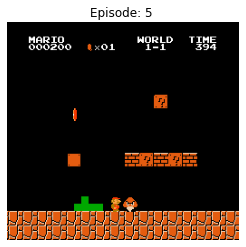

100%|█████████████████████████████████████████████| 5/5 [02:40<00:00, 32.15s/it]

=> Episode 5 Score = 244.00, Average Score = 402.40


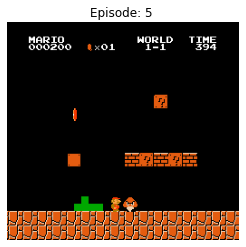

In [ ]:
# For Testing
#episodes_nb_test = 3
double_deepq_right_x_test,double_deepq_right_y_test = run(training_mode=False, pretrained=False, double_dqn=True, num_episodes=episodes_nb_test, 
                                                          exploration_max = 0.05, movement = RIGHT_ONLY)

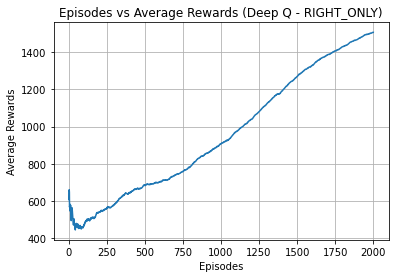

In [ ]:
plt.plot(double_deepq_right_x, double_deepq_right_y)
plt.title(f"Episodes vs Average Rewards (Deep Q - RIGHT_ONLY)")
plt.xlabel("Episodes") 
plt.ylabel("Average Rewards") 
plt.grid()
plt.show()

## Double Deep Q-Learning Movement => SIMPLE_MOVEMENT

In [ ]:
# Number of episode that you want to train;
#episodes_nb = 3
# For training
double_deepq_simple_x, double_deepq_simple_y = run(training_mode=True, pretrained=False, double_dqn=True, num_episodes=episodes_nb, 
                                                   exploration_max = 0.95, movement = SIMPLE_MOVEMENT)          

Current device is Cuda


  0%|                                          | 1/2000 [00:00<18:57,  1.76it/s]

=> Episode 1 Score = 235.00, Average Score = 235.00


  0%|                                        | 2/2000 [00:06<2:07:26,  3.83s/it]

=> Episode 2 Score = 1284.00, Average Score = 759.50


  0%|                                        | 3/2000 [00:07<1:19:56,  2.40s/it]

=> Episode 3 Score = 248.00, Average Score = 589.00


  0%|                                          | 4/2000 [00:07<54:18,  1.63s/it]

=> Episode 4 Score = 249.00, Average Score = 504.00


  0%|                                          | 5/2000 [00:08<40:09,  1.21s/it]

=> Episode 5 Score = 252.00, Average Score = 453.60


  0%|▏                                         | 6/2000 [00:08<31:35,  1.05it/s]

=> Episode 6 Score = 252.00, Average Score = 420.00


  0%|▏                                         | 7/2000 [00:09<26:11,  1.27it/s]

=> Episode 7 Score = 252.00, Average Score = 396.00


  0%|▏                                         | 8/2000 [00:09<22:58,  1.45it/s]

=> Episode 8 Score = 250.00, Average Score = 377.75


  0%|▏                                         | 9/2000 [00:10<20:54,  1.59it/s]

=> Episode 9 Score = 248.00, Average Score = 363.33


  0%|▏                                        | 10/2000 [00:10<19:34,  1.69it/s]

=> Episode 10 Score = 248.00, Average Score = 351.80


  1%|▏                                        | 11/2000 [00:11<18:36,  1.78it/s]

=> Episode 11 Score = 248.00, Average Score = 342.36


  1%|▏                                        | 12/2000 [00:11<17:52,  1.85it/s]

=> Episode 12 Score = 250.00, Average Score = 334.67


  1%|▎                                        | 13/2000 [00:13<32:46,  1.01it/s]

=> Episode 13 Score = 622.00, Average Score = 356.77


  1%|▎                                        | 14/2000 [00:14<27:45,  1.19it/s]

=> Episode 14 Score = 248.00, Average Score = 349.00


  1%|▎                                        | 15/2000 [00:14<24:16,  1.36it/s]

=> Episode 15 Score = 248.00, Average Score = 342.27


  1%|▎                                        | 16/2000 [00:15<21:53,  1.51it/s]

=> Episode 16 Score = 251.00, Average Score = 336.56


  1%|▎                                        | 17/2000 [00:15<20:23,  1.62it/s]

=> Episode 17 Score = 250.00, Average Score = 331.47


  1%|▎                                        | 18/2000 [00:16<19:36,  1.68it/s]

=> Episode 18 Score = 249.00, Average Score = 326.89


  1%|▍                                        | 19/2000 [00:16<18:33,  1.78it/s]

=> Episode 19 Score = 248.00, Average Score = 322.74


  1%|▍                                        | 20/2000 [00:20<50:24,  1.53s/it]

=> Episode 20 Score = 1025.00, Average Score = 357.85


  1%|▍                                        | 21/2000 [00:20<40:04,  1.21s/it]

=> Episode 21 Score = 248.00, Average Score = 352.62


  1%|▍                                        | 22/2000 [00:21<32:31,  1.01it/s]

=> Episode 22 Score = 248.00, Average Score = 347.86


  1%|▍                                        | 23/2000 [00:21<27:14,  1.21it/s]

=> Episode 23 Score = 251.00, Average Score = 343.65


  1%|▍                                        | 24/2000 [00:22<23:32,  1.40it/s]

=> Episode 24 Score = 251.00, Average Score = 339.79


  1%|▌                                        | 25/2000 [00:22<20:53,  1.58it/s]

=> Episode 25 Score = 248.00, Average Score = 336.12


  1%|▌                                        | 26/2000 [00:23<19:42,  1.67it/s]

=> Episode 26 Score = 238.00, Average Score = 332.35


  1%|▌                                        | 27/2000 [00:23<18:13,  1.80it/s]

=> Episode 27 Score = 248.00, Average Score = 329.22


  1%|▌                                        | 28/2000 [00:24<17:12,  1.91it/s]

=> Episode 28 Score = 248.00, Average Score = 326.32


  1%|▌                                        | 29/2000 [00:25<28:31,  1.15it/s]

=> Episode 29 Score = 629.00, Average Score = 336.76


  2%|▌                                        | 30/2000 [00:28<41:24,  1.26s/it]

=> Episode 30 Score = 616.00, Average Score = 346.07


  2%|▋                                        | 31/2000 [00:28<33:35,  1.02s/it]

=> Episode 31 Score = 248.00, Average Score = 342.90


  2%|▋                                        | 32/2000 [00:31<55:09,  1.68s/it]

=> Episode 32 Score = 1034.00, Average Score = 364.50


  2%|▋                                        | 33/2000 [00:33<54:37,  1.67s/it]

=> Episode 33 Score = 625.00, Average Score = 372.39


  2%|▋                                      | 34/2000 [00:37<1:18:40,  2.40s/it]

=> Episode 34 Score = 1326.00, Average Score = 400.44


  2%|▋                                      | 35/2000 [00:40<1:21:08,  2.48s/it]

=> Episode 35 Score = 620.00, Average Score = 406.71


  2%|▋                                      | 36/2000 [00:40<1:01:14,  1.87s/it]

=> Episode 36 Score = 247.00, Average Score = 402.28


  2%|▊                                        | 37/2000 [00:41<47:27,  1.45s/it]

=> Episode 37 Score = 248.00, Average Score = 398.11


  2%|▊                                        | 38/2000 [00:41<37:37,  1.15s/it]

=> Episode 38 Score = 248.00, Average Score = 394.16


  2%|▊                                        | 39/2000 [00:41<30:55,  1.06it/s]

=> Episode 39 Score = 246.00, Average Score = 390.36


  2%|▊                                        | 40/2000 [00:44<48:13,  1.48s/it]

=> Episode 40 Score = 616.00, Average Score = 396.00


  2%|▊                                        | 41/2000 [00:47<59:27,  1.82s/it]

=> Episode 41 Score = 755.00, Average Score = 404.76


  2%|▊                                        | 42/2000 [00:48<55:34,  1.70s/it]

=> Episode 42 Score = 628.00, Average Score = 410.07


  2%|▉                                        | 43/2000 [00:49<43:56,  1.35s/it]

=> Episode 43 Score = 249.00, Average Score = 406.33


  2%|▉                                        | 44/2000 [00:51<55:05,  1.69s/it]

=> Episode 44 Score = 638.00, Average Score = 411.59


  2%|▉                                      | 45/2000 [00:54<1:02:13,  1.91s/it]

=> Episode 45 Score = 639.00, Average Score = 416.64


  2%|▉                                      | 46/2000 [00:57<1:18:19,  2.41s/it]

=> Episode 46 Score = 625.00, Average Score = 421.17


  2%|▉                                      | 47/2000 [00:59<1:09:44,  2.14s/it]

=> Episode 47 Score = 609.00, Average Score = 425.17


  2%|▉                                      | 48/2000 [01:02<1:20:58,  2.49s/it]

=> Episode 48 Score = 579.00, Average Score = 428.38


  2%|▉                                      | 49/2000 [01:04<1:11:10,  2.19s/it]

=> Episode 49 Score = 638.00, Average Score = 432.65


  2%|█                                        | 50/2000 [01:04<55:12,  1.70s/it]

=> Episode 50 Score = 235.00, Average Score = 428.70


  3%|█                                        | 51/2000 [01:06<54:03,  1.66s/it]

=> Episode 51 Score = 630.00, Average Score = 432.65


  3%|█                                        | 52/2000 [01:06<43:28,  1.34s/it]

=> Episode 52 Score = 229.00, Average Score = 428.73


  3%|█                                        | 53/2000 [01:08<44:21,  1.37s/it]

=> Episode 53 Score = 637.00, Average Score = 432.66


  3%|█                                        | 54/2000 [01:10<54:15,  1.67s/it]

=> Episode 54 Score = 639.00, Average Score = 436.48


  3%|█▏                                       | 55/2000 [01:12<51:47,  1.60s/it]

=> Episode 55 Score = 637.00, Average Score = 440.13


  3%|█▏                                       | 56/2000 [01:14<59:41,  1.84s/it]

=> Episode 56 Score = 639.00, Average Score = 443.68


  3%|█                                      | 57/2000 [01:21<1:53:35,  3.51s/it]

=> Episode 57 Score = 533.00, Average Score = 445.25


  3%|█▏                                     | 58/2000 [01:25<1:53:38,  3.51s/it]

=> Episode 58 Score = 1030.00, Average Score = 455.33


  3%|█▏                                     | 59/2000 [01:27<1:42:00,  3.15s/it]

=> Episode 59 Score = 607.00, Average Score = 457.90


  3%|█▏                                     | 60/2000 [01:28<1:16:29,  2.37s/it]

=> Episode 60 Score = 239.00, Average Score = 454.25


  3%|█▏                                     | 61/2000 [01:31<1:23:43,  2.59s/it]

=> Episode 61 Score = 740.00, Average Score = 458.93


  3%|█▏                                     | 62/2000 [01:31<1:03:01,  1.95s/it]

=> Episode 62 Score = 246.00, Average Score = 455.50


  3%|█▏                                     | 63/2000 [01:35<1:19:10,  2.45s/it]

=> Episode 63 Score = 736.00, Average Score = 459.95


  3%|█▏                                     | 64/2000 [01:36<1:05:43,  2.04s/it]

=> Episode 64 Score = 620.00, Average Score = 462.45


  3%|█▎                                     | 65/2000 [01:41<1:32:00,  2.85s/it]

=> Episode 65 Score = 612.00, Average Score = 464.75


  3%|█▎                                     | 66/2000 [01:42<1:17:47,  2.41s/it]

=> Episode 66 Score = 629.00, Average Score = 467.24


  3%|█▎                                     | 67/2000 [01:43<1:00:13,  1.87s/it]

=> Episode 67 Score = 224.00, Average Score = 463.61


  3%|█▎                                     | 68/2000 [01:49<1:39:35,  3.09s/it]

=> Episode 68 Score = 1004.00, Average Score = 471.56


  3%|█▎                                     | 69/2000 [01:53<1:53:34,  3.53s/it]

=> Episode 69 Score = 569.00, Average Score = 472.97


  4%|█▎                                     | 70/2000 [01:55<1:33:39,  2.91s/it]

=> Episode 70 Score = 624.00, Average Score = 475.13


  4%|█▍                                     | 71/2000 [01:57<1:30:19,  2.81s/it]

=> Episode 71 Score = 637.00, Average Score = 477.41


  4%|█▍                                     | 72/2000 [02:00<1:27:27,  2.72s/it]

=> Episode 72 Score = 605.00, Average Score = 479.18


  4%|█▍                                     | 73/2000 [02:01<1:14:46,  2.33s/it]

=> Episode 73 Score = 627.00, Average Score = 481.21


  4%|█▍                                     | 74/2000 [02:02<1:04:32,  2.01s/it]

=> Episode 74 Score = 632.00, Average Score = 483.24


  4%|█▌                                       | 75/2000 [02:04<58:42,  1.83s/it]

=> Episode 75 Score = 629.00, Average Score = 485.19


  4%|█▌                                       | 76/2000 [02:05<55:07,  1.72s/it]

=> Episode 76 Score = 632.00, Average Score = 487.12


  4%|█▌                                       | 77/2000 [02:07<52:32,  1.64s/it]

=> Episode 77 Score = 631.00, Average Score = 488.99


  4%|█▌                                     | 78/2000 [02:12<1:31:58,  2.87s/it]

=> Episode 78 Score = 1005.00, Average Score = 495.60


  4%|█▌                                     | 79/2000 [02:14<1:17:47,  2.43s/it]

=> Episode 79 Score = 630.00, Average Score = 497.30


  4%|█▌                                     | 80/2000 [02:17<1:20:30,  2.52s/it]

=> Episode 80 Score = 735.00, Average Score = 500.27


  4%|█▌                                     | 81/2000 [02:18<1:11:26,  2.23s/it]

=> Episode 81 Score = 630.00, Average Score = 501.88


  4%|█▌                                     | 82/2000 [02:21<1:14:13,  2.32s/it]

=> Episode 82 Score = 814.00, Average Score = 505.68


  4%|█▌                                     | 83/2000 [02:23<1:15:52,  2.37s/it]

=> Episode 83 Score = 814.00, Average Score = 509.40


  4%|█▋                                     | 84/2000 [02:25<1:07:47,  2.12s/it]

=> Episode 84 Score = 610.00, Average Score = 510.60


  4%|█▋                                     | 85/2000 [02:27<1:10:46,  2.22s/it]

=> Episode 85 Score = 770.00, Average Score = 513.65


  4%|█▋                                     | 86/2000 [02:43<3:16:27,  6.16s/it]

=> Episode 86 Score = 1194.00, Average Score = 521.56


  4%|█▋                                     | 87/2000 [02:46<2:54:36,  5.48s/it]

=> Episode 87 Score = 1329.00, Average Score = 530.84


  4%|█▋                                     | 88/2000 [02:48<2:16:49,  4.29s/it]

=> Episode 88 Score = 624.00, Average Score = 531.90


  4%|█▋                                     | 89/2000 [02:51<2:03:03,  3.86s/it]

=> Episode 89 Score = 634.00, Average Score = 533.04


  4%|█▊                                     | 90/2000 [02:52<1:39:07,  3.11s/it]

=> Episode 90 Score = 651.00, Average Score = 534.36


  5%|█▊                                     | 91/2000 [02:55<1:32:07,  2.90s/it]

=> Episode 91 Score = 751.00, Average Score = 536.74


  5%|█▊                                     | 92/2000 [02:57<1:26:42,  2.73s/it]

=> Episode 92 Score = 640.00, Average Score = 537.86


  5%|█▊                                     | 93/2000 [02:58<1:13:55,  2.33s/it]

=> Episode 93 Score = 632.00, Average Score = 538.87


  5%|█▊                                     | 94/2000 [03:02<1:27:10,  2.74s/it]

=> Episode 94 Score = 1288.00, Average Score = 546.84


  5%|█▊                                     | 95/2000 [03:03<1:06:37,  2.10s/it]

=> Episode 95 Score = 227.00, Average Score = 543.47


  5%|█▊                                     | 96/2000 [03:06<1:17:28,  2.44s/it]

=> Episode 96 Score = 1034.00, Average Score = 548.58


  5%|█▉                                       | 97/2000 [03:06<58:58,  1.86s/it]

=> Episode 97 Score = 242.00, Average Score = 545.42


  5%|█▉                                     | 98/2000 [03:09<1:05:56,  2.08s/it]

=> Episode 98 Score = 1042.00, Average Score = 550.49


  5%|██                                       | 99/2000 [03:09<50:32,  1.60s/it]

=> Episode 99 Score = 248.00, Average Score = 547.43


  5%|██                                      | 100/2000 [03:12<59:00,  1.86s/it]

=> Episode 100 Score = 638.00, Average Score = 548.34


  5%|██                                      | 101/2000 [03:12<45:44,  1.45s/it]

=> Episode 101 Score = 248.00, Average Score = 545.37


  5%|██                                      | 102/2000 [03:15<53:07,  1.68s/it]

=> Episode 102 Score = 641.00, Average Score = 546.30


  5%|██                                      | 103/2000 [03:16<49:30,  1.57s/it]

=> Episode 103 Score = 616.00, Average Score = 546.98


  5%|██                                      | 104/2000 [03:18<50:21,  1.59s/it]

=> Episode 104 Score = 608.00, Average Score = 547.57


  5%|██                                      | 105/2000 [03:19<48:43,  1.54s/it]

=> Episode 105 Score = 631.00, Average Score = 548.36


  5%|██                                    | 106/2000 [03:22<1:00:24,  1.91s/it]

=> Episode 106 Score = 1037.00, Average Score = 552.97


  5%|██                                    | 107/2000 [03:25<1:08:42,  2.18s/it]

=> Episode 107 Score = 603.00, Average Score = 553.44


  5%|██                                    | 108/2000 [03:26<1:06:24,  2.11s/it]

=> Episode 108 Score = 745.00, Average Score = 555.21


  5%|██▏                                     | 109/2000 [03:27<51:32,  1.64s/it]

=> Episode 109 Score = 244.00, Average Score = 552.36


  6%|██▏                                     | 110/2000 [03:29<50:17,  1.60s/it]

=> Episode 110 Score = 612.00, Average Score = 552.90


  6%|██▏                                     | 111/2000 [03:30<46:03,  1.46s/it]

=> Episode 111 Score = 613.00, Average Score = 553.44


  6%|██▏                                     | 112/2000 [03:31<41:21,  1.31s/it]

=> Episode 112 Score = 609.00, Average Score = 553.94


  6%|██▎                                     | 113/2000 [03:31<33:20,  1.06s/it]

=> Episode 113 Score = 248.00, Average Score = 551.23


  6%|██▎                                     | 114/2000 [03:32<27:44,  1.13it/s]

=> Episode 114 Score = 248.00, Average Score = 548.57


  6%|██▎                                     | 115/2000 [03:32<23:42,  1.33it/s]

=> Episode 115 Score = 248.00, Average Score = 545.96


  6%|██▎                                     | 116/2000 [03:33<20:56,  1.50it/s]

=> Episode 116 Score = 250.00, Average Score = 543.41


  6%|██▎                                     | 117/2000 [03:35<39:47,  1.27s/it]

=> Episode 117 Score = 783.00, Average Score = 545.45


  6%|██▏                                   | 118/2000 [03:39<1:02:30,  1.99s/it]

=> Episode 118 Score = 1306.00, Average Score = 551.90


  6%|██▍                                     | 119/2000 [03:40<57:07,  1.82s/it]

=> Episode 119 Score = 634.00, Average Score = 552.59


  6%|██▍                                     | 120/2000 [03:42<54:49,  1.75s/it]

=> Episode 120 Score = 635.00, Average Score = 553.27


  6%|██▍                                     | 121/2000 [03:43<47:39,  1.52s/it]

=> Episode 121 Score = 613.00, Average Score = 553.77


  6%|██▎                                   | 122/2000 [03:46<1:03:08,  2.02s/it]

=> Episode 122 Score = 1034.00, Average Score = 557.70


  6%|██▍                                     | 123/2000 [03:47<56:29,  1.81s/it]

=> Episode 123 Score = 612.00, Average Score = 558.15


  6%|██▎                                   | 124/2000 [03:52<1:20:13,  2.57s/it]

=> Episode 124 Score = 1323.00, Average Score = 564.31


  6%|██▍                                   | 125/2000 [03:53<1:06:57,  2.14s/it]

=> Episode 125 Score = 616.00, Average Score = 564.73


  6%|██▌                                     | 126/2000 [03:53<51:13,  1.64s/it]

=> Episode 126 Score = 248.00, Average Score = 562.21


  6%|██▌                                     | 127/2000 [03:55<49:49,  1.60s/it]

=> Episode 127 Score = 635.00, Average Score = 562.79


  6%|██▌                                     | 128/2000 [03:56<48:30,  1.55s/it]

=> Episode 128 Score = 634.00, Average Score = 563.34


  6%|██▌                                     | 129/2000 [03:58<46:04,  1.48s/it]

=> Episode 129 Score = 615.00, Average Score = 563.74


  6%|██▌                                     | 130/2000 [03:59<44:54,  1.44s/it]

=> Episode 130 Score = 632.00, Average Score = 564.27


  7%|██▌                                     | 131/2000 [04:01<53:57,  1.73s/it]

=> Episode 131 Score = 1349.00, Average Score = 570.26


  7%|██▋                                     | 132/2000 [04:02<42:03,  1.35s/it]

=> Episode 132 Score = 248.00, Average Score = 567.82


  7%|██▋                                     | 133/2000 [04:04<52:07,  1.68s/it]

=> Episode 133 Score = 641.00, Average Score = 568.37


  7%|██▌                                   | 134/2000 [04:08<1:12:39,  2.34s/it]

=> Episode 134 Score = 1031.00, Average Score = 571.82


  7%|██▌                                   | 135/2000 [04:11<1:14:18,  2.39s/it]

=> Episode 135 Score = 1044.00, Average Score = 575.32


  7%|██▋                                     | 136/2000 [04:11<56:29,  1.82s/it]

=> Episode 136 Score = 252.00, Average Score = 572.94


  7%|██▌                                   | 137/2000 [04:14<1:09:07,  2.23s/it]

=> Episode 137 Score = 1339.00, Average Score = 578.53


  7%|██▌                                   | 138/2000 [04:16<1:07:55,  2.19s/it]

=> Episode 138 Score = 1047.00, Average Score = 581.93


  7%|██▋                                   | 139/2000 [04:18<1:02:18,  2.01s/it]

=> Episode 139 Score = 627.00, Average Score = 582.25


  7%|██▊                                     | 140/2000 [04:18<48:11,  1.55s/it]

=> Episode 140 Score = 248.00, Average Score = 579.86


  7%|██▊                                     | 141/2000 [04:20<45:56,  1.48s/it]

=> Episode 141 Score = 632.00, Average Score = 580.23


  7%|██▊                                     | 142/2000 [04:22<52:09,  1.68s/it]

=> Episode 142 Score = 1033.00, Average Score = 583.42


  7%|██▊                                     | 143/2000 [04:22<40:52,  1.32s/it]

=> Episode 143 Score = 249.00, Average Score = 581.08


  7%|██▉                                     | 144/2000 [04:25<51:20,  1.66s/it]

=> Episode 144 Score = 616.00, Average Score = 581.33


  7%|██▉                                     | 145/2000 [04:26<48:08,  1.56s/it]

=> Episode 145 Score = 621.00, Average Score = 581.60


  7%|██▉                                     | 146/2000 [04:27<42:45,  1.38s/it]

=> Episode 146 Score = 610.00, Average Score = 581.79


  7%|██▉                                     | 147/2000 [04:30<54:22,  1.76s/it]

=> Episode 147 Score = 1031.00, Average Score = 584.85


  7%|██▉                                     | 148/2000 [04:31<47:01,  1.52s/it]

=> Episode 148 Score = 608.00, Average Score = 585.01


  7%|██▉                                     | 149/2000 [04:33<55:17,  1.79s/it]

=> Episode 149 Score = 1344.00, Average Score = 590.10


  8%|██▊                                   | 150/2000 [04:36<1:01:08,  1.98s/it]

=> Episode 150 Score = 605.00, Average Score = 590.20


  8%|███                                     | 151/2000 [04:36<47:00,  1.53s/it]

=> Episode 151 Score = 248.00, Average Score = 587.93


  8%|███                                     | 152/2000 [04:37<44:23,  1.44s/it]

=> Episode 152 Score = 619.00, Average Score = 588.14


  8%|███                                     | 153/2000 [04:40<54:34,  1.77s/it]

=> Episode 153 Score = 1028.00, Average Score = 591.01


  8%|██▉                                   | 154/2000 [04:42<1:02:38,  2.04s/it]

=> Episode 154 Score = 1038.00, Average Score = 593.92


  8%|███                                     | 155/2000 [04:44<53:42,  1.75s/it]

=> Episode 155 Score = 609.00, Average Score = 594.01


  8%|██▉                                   | 156/2000 [04:46<1:03:45,  2.07s/it]

=> Episode 156 Score = 1037.00, Average Score = 596.85


  8%|███▏                                    | 157/2000 [04:47<49:05,  1.60s/it]

=> Episode 157 Score = 249.00, Average Score = 594.64


  8%|███▏                                    | 158/2000 [04:47<38:48,  1.26s/it]

=> Episode 158 Score = 250.00, Average Score = 592.46


  8%|███▏                                    | 159/2000 [04:48<31:29,  1.03s/it]

=> Episode 159 Score = 252.00, Average Score = 590.31


  8%|███▏                                    | 160/2000 [04:49<31:29,  1.03s/it]

=> Episode 160 Score = 610.00, Average Score = 590.44


  8%|███▏                                    | 161/2000 [04:52<47:30,  1.55s/it]

=> Episode 161 Score = 1140.00, Average Score = 593.85


  8%|███▏                                    | 162/2000 [04:52<37:34,  1.23s/it]

=> Episode 162 Score = 252.00, Average Score = 591.74


  8%|███▎                                    | 163/2000 [04:54<47:30,  1.55s/it]

=> Episode 163 Score = 1048.00, Average Score = 594.54


  8%|███▎                                    | 164/2000 [04:56<43:50,  1.43s/it]

=> Episode 164 Score = 637.00, Average Score = 594.80


  8%|███▎                                    | 165/2000 [04:58<51:05,  1.67s/it]

=> Episode 165 Score = 817.00, Average Score = 596.15


  8%|███▎                                    | 166/2000 [05:00<55:49,  1.83s/it]

=> Episode 166 Score = 1042.00, Average Score = 598.83


  8%|███▎                                    | 167/2000 [05:01<48:06,  1.57s/it]

=> Episode 167 Score = 612.00, Average Score = 598.91


  8%|███▏                                  | 168/2000 [05:04<1:02:04,  2.03s/it]

=> Episode 168 Score = 1339.00, Average Score = 603.32


  8%|███▍                                    | 169/2000 [05:05<54:16,  1.78s/it]

=> Episode 169 Score = 637.00, Average Score = 603.51


  8%|███▏                                  | 170/2000 [05:09<1:10:59,  2.33s/it]

=> Episode 170 Score = 1333.00, Average Score = 607.81


  9%|███▏                                  | 171/2000 [05:11<1:10:47,  2.32s/it]

=> Episode 171 Score = 768.00, Average Score = 608.74


  9%|███▎                                  | 172/2000 [05:12<1:00:44,  1.99s/it]

=> Episode 172 Score = 639.00, Average Score = 608.92


  9%|███▎                                  | 173/2000 [05:15<1:08:03,  2.23s/it]

=> Episode 173 Score = 1341.00, Average Score = 613.15


  9%|███▍                                    | 174/2000 [05:16<59:00,  1.94s/it]

=> Episode 174 Score = 622.00, Average Score = 613.20


  9%|███▌                                    | 175/2000 [05:18<57:46,  1.90s/it]

=> Episode 175 Score = 1052.00, Average Score = 615.71


  9%|███▌                                    | 176/2000 [05:19<45:23,  1.49s/it]

=> Episode 176 Score = 237.00, Average Score = 613.56


  9%|███▌                                    | 177/2000 [05:20<42:57,  1.41s/it]

=> Episode 177 Score = 633.00, Average Score = 613.67


  9%|███▌                                    | 178/2000 [05:22<50:50,  1.67s/it]

=> Episode 178 Score = 1047.00, Average Score = 616.10


  9%|███▌                                    | 179/2000 [05:23<41:00,  1.35s/it]

=> Episode 179 Score = 233.00, Average Score = 613.96


  9%|███▌                                    | 180/2000 [05:23<32:58,  1.09s/it]

=> Episode 180 Score = 250.00, Average Score = 611.94


  9%|███▌                                    | 181/2000 [05:25<35:47,  1.18s/it]

=> Episode 181 Score = 651.00, Average Score = 612.15


  9%|███▋                                    | 182/2000 [05:25<29:25,  1.03it/s]

=> Episode 182 Score = 252.00, Average Score = 610.18


  9%|███▋                                    | 183/2000 [05:29<51:16,  1.69s/it]

=> Episode 183 Score = 1036.00, Average Score = 612.50


  9%|███▋                                    | 184/2000 [05:30<50:40,  1.67s/it]

=> Episode 184 Score = 607.00, Average Score = 612.47


  9%|███▋                                    | 185/2000 [05:31<44:42,  1.48s/it]

=> Episode 185 Score = 610.00, Average Score = 612.46


  9%|███▋                                    | 186/2000 [05:33<49:30,  1.64s/it]

=> Episode 186 Score = 1049.00, Average Score = 614.81


  9%|███▋                                    | 187/2000 [05:34<39:02,  1.29s/it]

=> Episode 187 Score = 250.00, Average Score = 612.86


  9%|███▊                                    | 188/2000 [05:37<53:42,  1.78s/it]

=> Episode 188 Score = 1342.00, Average Score = 616.73


  9%|███▌                                  | 189/2000 [05:39<1:02:00,  2.05s/it]

=> Episode 189 Score = 1041.00, Average Score = 618.98


 10%|███▊                                    | 190/2000 [05:40<47:44,  1.58s/it]

=> Episode 190 Score = 252.00, Average Score = 617.05


 10%|███▊                                    | 191/2000 [05:41<42:47,  1.42s/it]

=> Episode 191 Score = 610.00, Average Score = 617.01


 10%|███▊                                    | 192/2000 [05:43<52:21,  1.74s/it]

=> Episode 192 Score = 1350.00, Average Score = 620.83


 10%|███▊                                    | 193/2000 [05:46<55:54,  1.86s/it]

=> Episode 193 Score = 751.00, Average Score = 621.50


 10%|███▉                                    | 194/2000 [05:47<49:01,  1.63s/it]

=> Episode 194 Score = 612.00, Average Score = 621.45


 10%|███▉                                    | 195/2000 [05:47<39:10,  1.30s/it]

=> Episode 195 Score = 248.00, Average Score = 619.54


 10%|███▉                                    | 196/2000 [05:49<47:40,  1.59s/it]

=> Episode 196 Score = 1046.00, Average Score = 621.71


 10%|███▉                                    | 197/2000 [05:52<57:41,  1.92s/it]

=> Episode 197 Score = 1039.00, Average Score = 623.83


 10%|███▊                                  | 198/2000 [05:55<1:04:14,  2.14s/it]

=> Episode 198 Score = 1043.00, Average Score = 625.95


 10%|███▊                                  | 199/2000 [05:58<1:13:03,  2.43s/it]

=> Episode 199 Score = 1340.00, Average Score = 629.54


 10%|███▊                                  | 200/2000 [06:00<1:09:51,  2.33s/it]

=> Episode 200 Score = 1049.00, Average Score = 631.63


 10%|███▊                                  | 201/2000 [06:01<1:01:04,  2.04s/it]

=> Episode 201 Score = 619.00, Average Score = 631.57


 10%|███▊                                  | 202/2000 [06:05<1:13:41,  2.46s/it]

=> Episode 202 Score = 1338.00, Average Score = 635.07


 10%|███▊                                  | 203/2000 [06:07<1:12:55,  2.43s/it]

=> Episode 203 Score = 1043.00, Average Score = 637.08


 10%|███▉                                  | 204/2000 [06:10<1:17:07,  2.58s/it]

=> Episode 204 Score = 1037.00, Average Score = 639.04


 10%|███▉                                  | 205/2000 [06:12<1:15:35,  2.53s/it]

=> Episode 205 Score = 816.00, Average Score = 639.90


 10%|███▉                                  | 206/2000 [06:13<1:01:55,  2.07s/it]

=> Episode 206 Score = 610.00, Average Score = 639.76


 10%|████▏                                   | 207/2000 [06:14<47:28,  1.59s/it]

=> Episode 207 Score = 248.00, Average Score = 637.86


 10%|████▏                                   | 208/2000 [06:14<37:29,  1.26s/it]

=> Episode 208 Score = 251.00, Average Score = 636.00


 10%|████▏                                   | 209/2000 [06:17<50:14,  1.68s/it]

=> Episode 209 Score = 1041.00, Average Score = 637.94


 10%|███▉                                  | 210/2000 [06:20<1:05:09,  2.18s/it]

=> Episode 210 Score = 808.00, Average Score = 638.75


 11%|████                                  | 211/2000 [06:23<1:04:46,  2.17s/it]

=> Episode 211 Score = 612.00, Average Score = 638.63


 11%|████                                  | 212/2000 [06:25<1:05:40,  2.20s/it]

=> Episode 212 Score = 1046.00, Average Score = 640.55


 11%|████                                  | 213/2000 [06:28<1:11:35,  2.40s/it]

=> Episode 213 Score = 1040.00, Average Score = 642.42


 11%|████                                  | 214/2000 [06:30<1:07:15,  2.26s/it]

=> Episode 214 Score = 1050.00, Average Score = 644.33


 11%|████                                  | 215/2000 [06:32<1:07:04,  2.25s/it]

=> Episode 215 Score = 759.00, Average Score = 644.86


 11%|████                                  | 216/2000 [06:34<1:07:39,  2.28s/it]

=> Episode 216 Score = 736.00, Average Score = 645.28


 11%|████▎                                   | 217/2000 [06:35<58:07,  1.96s/it]

=> Episode 217 Score = 634.00, Average Score = 645.23


 11%|████▎                                   | 218/2000 [06:36<45:28,  1.53s/it]

=> Episode 218 Score = 248.00, Average Score = 643.41


 11%|████▍                                   | 219/2000 [06:39<55:56,  1.88s/it]

=> Episode 219 Score = 1042.00, Average Score = 645.23


 11%|████▍                                   | 220/2000 [06:41<57:45,  1.95s/it]

=> Episode 220 Score = 819.00, Average Score = 646.02


 11%|████▏                                 | 221/2000 [06:43<1:03:35,  2.14s/it]

=> Episode 221 Score = 1348.00, Average Score = 649.19


 11%|████▏                                 | 222/2000 [06:46<1:06:49,  2.25s/it]

=> Episode 222 Score = 1046.00, Average Score = 650.98


 11%|████▏                                 | 223/2000 [06:49<1:13:17,  2.47s/it]

=> Episode 223 Score = 1345.00, Average Score = 654.09


 11%|████▍                                   | 224/2000 [06:49<55:26,  1.87s/it]

=> Episode 224 Score = 250.00, Average Score = 652.29


 11%|████▎                                 | 225/2000 [06:52<1:03:03,  2.13s/it]

=> Episode 225 Score = 1334.00, Average Score = 655.32


 11%|████▌                                   | 226/2000 [06:54<57:26,  1.94s/it]

=> Episode 226 Score = 609.00, Average Score = 655.12


 11%|████▎                                 | 227/2000 [06:57<1:10:49,  2.40s/it]

=> Episode 227 Score = 1036.00, Average Score = 656.79


 11%|████▌                                   | 228/2000 [06:58<53:55,  1.83s/it]

=> Episode 228 Score = 250.00, Average Score = 655.01


 11%|████▎                                 | 229/2000 [07:00<1:03:07,  2.14s/it]

=> Episode 229 Score = 1346.00, Average Score = 658.03


 12%|████▌                                   | 230/2000 [07:01<48:28,  1.64s/it]

=> Episode 230 Score = 247.00, Average Score = 656.24


 12%|████▌                                   | 231/2000 [07:03<54:06,  1.84s/it]

=> Episode 231 Score = 1048.00, Average Score = 657.94


 12%|████▋                                   | 232/2000 [07:04<41:54,  1.42s/it]

=> Episode 232 Score = 249.00, Average Score = 656.17


 12%|████▍                                 | 233/2000 [07:07<1:00:09,  2.04s/it]

=> Episode 233 Score = 1034.00, Average Score = 657.79


 12%|████▋                                   | 234/2000 [07:08<52:53,  1.80s/it]

=> Episode 234 Score = 635.00, Average Score = 657.70


 12%|████▋                                   | 235/2000 [07:11<58:12,  1.98s/it]

=> Episode 235 Score = 1348.00, Average Score = 660.63


 12%|████▍                                 | 236/2000 [07:15<1:17:55,  2.65s/it]

=> Episode 236 Score = 1023.00, Average Score = 662.17


 12%|████▌                                 | 237/2000 [07:18<1:17:53,  2.65s/it]

=> Episode 237 Score = 1346.00, Average Score = 665.05


 12%|████▌                                 | 238/2000 [07:20<1:19:24,  2.70s/it]

=> Episode 238 Score = 1041.00, Average Score = 666.63


 12%|████▌                                 | 239/2000 [07:22<1:12:22,  2.47s/it]

=> Episode 239 Score = 752.00, Average Score = 666.99


 12%|████▌                                 | 240/2000 [07:25<1:12:26,  2.47s/it]

=> Episode 240 Score = 762.00, Average Score = 667.39


 12%|████▌                                 | 241/2000 [07:26<1:01:58,  2.11s/it]

=> Episode 241 Score = 628.00, Average Score = 667.22


 12%|████▌                                 | 242/2000 [07:28<1:03:02,  2.15s/it]

=> Episode 242 Score = 1056.00, Average Score = 668.83


 12%|████▊                                   | 243/2000 [07:30<53:57,  1.84s/it]

=> Episode 243 Score = 626.00, Average Score = 668.65


 12%|████▋                                 | 244/2000 [07:32<1:01:36,  2.10s/it]

=> Episode 244 Score = 1345.00, Average Score = 671.43


 12%|████▉                                   | 245/2000 [07:33<53:54,  1.84s/it]

=> Episode 245 Score = 629.00, Average Score = 671.25


 12%|████▋                                 | 246/2000 [07:38<1:13:42,  2.52s/it]

=> Episode 246 Score = 1326.00, Average Score = 673.91


 12%|████▋                                 | 247/2000 [07:40<1:16:52,  2.63s/it]

=> Episode 247 Score = 1038.00, Average Score = 675.39


 12%|████▋                                 | 248/2000 [07:43<1:17:19,  2.65s/it]

=> Episode 248 Score = 1345.00, Average Score = 678.09


 12%|████▋                                 | 249/2000 [07:45<1:13:52,  2.53s/it]

=> Episode 249 Score = 1047.00, Average Score = 679.57


 12%|████▊                                 | 250/2000 [07:48<1:11:21,  2.45s/it]

=> Episode 250 Score = 641.00, Average Score = 679.42


 13%|████▊                                 | 251/2000 [07:50<1:11:52,  2.47s/it]

=> Episode 251 Score = 1350.00, Average Score = 682.09


 13%|████▊                                 | 252/2000 [07:52<1:06:42,  2.29s/it]

=> Episode 252 Score = 750.00, Average Score = 682.36


 13%|████▊                                 | 253/2000 [07:56<1:23:19,  2.86s/it]

=> Episode 253 Score = 1024.00, Average Score = 683.71


 13%|████▊                                 | 254/2000 [07:58<1:15:55,  2.61s/it]

=> Episode 254 Score = 1050.00, Average Score = 685.15


 13%|████▊                                 | 255/2000 [08:01<1:20:59,  2.78s/it]

=> Episode 255 Score = 1337.00, Average Score = 687.71


 13%|████▊                                 | 256/2000 [08:02<1:00:38,  2.09s/it]

=> Episode 256 Score = 250.00, Average Score = 686.00


 13%|████▉                                 | 257/2000 [08:05<1:06:04,  2.27s/it]

=> Episode 257 Score = 1343.00, Average Score = 688.55


 13%|████▉                                 | 258/2000 [08:06<1:01:18,  2.11s/it]

=> Episode 258 Score = 741.00, Average Score = 688.76


 13%|█████▏                                  | 259/2000 [08:08<53:39,  1.85s/it]

=> Episode 259 Score = 630.00, Average Score = 688.53


 13%|█████▏                                  | 260/2000 [08:10<59:21,  2.05s/it]

=> Episode 260 Score = 1345.00, Average Score = 691.05


 13%|████▉                                 | 261/2000 [08:13<1:04:28,  2.22s/it]

=> Episode 261 Score = 1345.00, Average Score = 693.56


 13%|█████▏                                  | 262/2000 [08:13<49:22,  1.70s/it]

=> Episode 262 Score = 251.00, Average Score = 691.87


 13%|████▉                                 | 263/2000 [08:17<1:09:58,  2.42s/it]

=> Episode 263 Score = 1024.00, Average Score = 693.13


 13%|█████▎                                  | 264/2000 [08:19<59:29,  2.06s/it]

=> Episode 264 Score = 639.00, Average Score = 692.93


 13%|█████▎                                  | 265/2000 [08:20<55:24,  1.92s/it]

=> Episode 265 Score = 738.00, Average Score = 693.10


 13%|█████▎                                  | 266/2000 [08:22<55:41,  1.93s/it]

=> Episode 266 Score = 1049.00, Average Score = 694.44


 13%|█████                                 | 267/2000 [08:25<1:02:19,  2.16s/it]

=> Episode 267 Score = 1342.00, Average Score = 696.86


 13%|█████▎                                  | 268/2000 [08:26<54:57,  1.90s/it]

=> Episode 268 Score = 608.00, Average Score = 696.53


 13%|█████▍                                  | 269/2000 [08:27<50:28,  1.75s/it]

=> Episode 269 Score = 613.00, Average Score = 696.22


 14%|█████▍                                  | 270/2000 [08:28<39:19,  1.36s/it]

=> Episode 270 Score = 251.00, Average Score = 694.57


 14%|█████▍                                  | 271/2000 [08:30<48:07,  1.67s/it]

=> Episode 271 Score = 1044.00, Average Score = 695.86


 14%|█████▍                                  | 272/2000 [08:31<37:52,  1.31s/it]

=> Episode 272 Score = 252.00, Average Score = 694.23


 14%|█████▍                                  | 273/2000 [08:33<44:23,  1.54s/it]

=> Episode 273 Score = 1071.00, Average Score = 695.61


 14%|█████▍                                  | 274/2000 [08:33<34:59,  1.22s/it]

=> Episode 274 Score = 252.00, Average Score = 693.99


 14%|█████▌                                  | 275/2000 [08:36<49:30,  1.72s/it]

=> Episode 275 Score = 1060.00, Average Score = 695.32


 14%|█████▌                                  | 276/2000 [08:38<53:33,  1.86s/it]

=> Episode 276 Score = 817.00, Average Score = 695.76


 14%|█████▌                                  | 277/2000 [08:39<41:33,  1.45s/it]

=> Episode 277 Score = 252.00, Average Score = 694.16


 14%|█████▌                                  | 278/2000 [08:39<32:58,  1.15s/it]

=> Episode 278 Score = 248.00, Average Score = 692.55


 14%|█████▌                                  | 279/2000 [08:42<49:20,  1.72s/it]

=> Episode 279 Score = 609.00, Average Score = 692.25


 14%|█████▌                                  | 280/2000 [08:44<45:19,  1.58s/it]

=> Episode 280 Score = 641.00, Average Score = 692.07


 14%|█████▌                                  | 281/2000 [08:46<50:05,  1.75s/it]

=> Episode 281 Score = 1048.00, Average Score = 693.34


 14%|█████▋                                  | 282/2000 [08:48<56:47,  1.98s/it]

=> Episode 282 Score = 1044.00, Average Score = 694.58


 14%|█████▍                                | 283/2000 [08:51<1:00:19,  2.11s/it]

=> Episode 283 Score = 1041.00, Average Score = 695.81


 14%|█████▋                                  | 284/2000 [08:52<51:39,  1.81s/it]

=> Episode 284 Score = 610.00, Average Score = 695.50


 14%|█████▋                                  | 285/2000 [08:54<56:53,  1.99s/it]

=> Episode 285 Score = 1043.00, Average Score = 696.72


 14%|█████▋                                  | 286/2000 [08:56<58:08,  2.04s/it]

=> Episode 286 Score = 749.00, Average Score = 696.91


 14%|█████▋                                  | 287/2000 [08:57<44:41,  1.57s/it]

=> Episode 287 Score = 251.00, Average Score = 695.35


 14%|█████▊                                  | 288/2000 [08:57<35:09,  1.23s/it]

=> Episode 288 Score = 247.00, Average Score = 693.80


 14%|█████▊                                  | 289/2000 [09:00<47:31,  1.67s/it]

=> Episode 289 Score = 1041.00, Average Score = 695.00


 14%|█████▊                                  | 290/2000 [09:01<41:33,  1.46s/it]

=> Episode 290 Score = 610.00, Average Score = 694.70


 15%|█████▊                                  | 291/2000 [09:01<33:00,  1.16s/it]

=> Episode 291 Score = 248.00, Average Score = 693.17


 15%|█████▊                                  | 292/2000 [09:03<33:25,  1.17s/it]

=> Episode 292 Score = 634.00, Average Score = 692.97


 15%|█████▊                                  | 293/2000 [09:03<27:20,  1.04it/s]

=> Episode 293 Score = 248.00, Average Score = 691.45


 15%|█████▉                                  | 294/2000 [09:06<42:40,  1.50s/it]

=> Episode 294 Score = 772.00, Average Score = 691.72


 15%|█████▉                                  | 295/2000 [09:08<48:32,  1.71s/it]

=> Episode 295 Score = 1047.00, Average Score = 692.93


 15%|█████▉                                  | 296/2000 [09:10<46:34,  1.64s/it]

=> Episode 296 Score = 609.00, Average Score = 692.64


 15%|█████▉                                  | 297/2000 [09:11<42:41,  1.50s/it]

=> Episode 297 Score = 611.00, Average Score = 692.37


 15%|█████▉                                  | 298/2000 [09:11<33:48,  1.19s/it]

=> Episode 298 Score = 247.00, Average Score = 690.87


 15%|█████▉                                  | 299/2000 [09:14<47:12,  1.67s/it]

=> Episode 299 Score = 1041.00, Average Score = 692.04


 15%|██████                                  | 300/2000 [09:17<55:17,  1.95s/it]

=> Episode 300 Score = 1346.00, Average Score = 694.22


 15%|██████                                  | 301/2000 [09:19<59:52,  2.11s/it]

=> Episode 301 Score = 1049.00, Average Score = 695.40


 15%|██████                                  | 302/2000 [09:20<52:39,  1.86s/it]

=> Episode 302 Score = 632.00, Average Score = 695.19


 15%|██████                                  | 303/2000 [09:21<40:47,  1.44s/it]

=> Episode 303 Score = 248.00, Average Score = 693.72


 15%|██████                                  | 304/2000 [09:21<32:30,  1.15s/it]

=> Episode 304 Score = 248.00, Average Score = 692.25


 15%|██████                                  | 305/2000 [09:22<32:55,  1.17s/it]

=> Episode 305 Score = 636.00, Average Score = 692.07


 15%|██████                                  | 306/2000 [09:23<26:53,  1.05it/s]

=> Episode 306 Score = 248.00, Average Score = 690.61


 15%|█████▊                                | 307/2000 [09:30<1:16:07,  2.70s/it]

=> Episode 307 Score = 993.00, Average Score = 691.60


 15%|█████▊                                | 308/2000 [09:32<1:13:50,  2.62s/it]

=> Episode 308 Score = 1045.00, Average Score = 692.75


 15%|█████▊                                | 309/2000 [09:34<1:04:02,  2.27s/it]

=> Episode 309 Score = 618.00, Average Score = 692.50


 16%|█████▉                                | 310/2000 [09:36<1:01:29,  2.18s/it]

=> Episode 310 Score = 767.00, Average Score = 692.75


 16%|█████▉                                | 311/2000 [09:38<1:06:11,  2.35s/it]

=> Episode 311 Score = 1048.00, Average Score = 693.89


 16%|█████▉                                | 312/2000 [09:41<1:05:03,  2.31s/it]

=> Episode 312 Score = 1046.00, Average Score = 695.02


 16%|██████▎                                 | 313/2000 [09:42<55:43,  1.98s/it]

=> Episode 313 Score = 635.00, Average Score = 694.82


 16%|██████▎                                 | 314/2000 [09:44<54:16,  1.93s/it]

=> Episode 314 Score = 613.00, Average Score = 694.56


 16%|██████▎                                 | 315/2000 [09:44<41:48,  1.49s/it]

=> Episode 315 Score = 247.00, Average Score = 693.14


 16%|██████▎                                 | 316/2000 [09:45<33:21,  1.19s/it]

=> Episode 316 Score = 246.00, Average Score = 691.73


 16%|██████▎                                 | 317/2000 [09:46<39:58,  1.43s/it]

=> Episode 317 Score = 1058.00, Average Score = 692.88


 16%|██████▎                                 | 318/2000 [09:49<45:21,  1.62s/it]

=> Episode 318 Score = 1051.00, Average Score = 694.01


 16%|██████▍                                 | 319/2000 [09:50<46:01,  1.64s/it]

=> Episode 319 Score = 618.00, Average Score = 693.77


 16%|██████▍                                 | 320/2000 [09:51<36:05,  1.29s/it]

=> Episode 320 Score = 252.00, Average Score = 692.39


 16%|██████▍                                 | 321/2000 [09:52<37:19,  1.33s/it]

=> Episode 321 Score = 615.00, Average Score = 692.15


 16%|██████▍                                 | 322/2000 [09:53<30:12,  1.08s/it]

=> Episode 322 Score = 253.00, Average Score = 690.79


 16%|██████▍                                 | 323/2000 [09:56<46:44,  1.67s/it]

=> Episode 323 Score = 771.00, Average Score = 691.03


 16%|██████▍                                 | 324/2000 [09:58<51:13,  1.83s/it]

=> Episode 324 Score = 1048.00, Average Score = 692.14


 16%|██████▌                                 | 325/2000 [10:00<52:52,  1.89s/it]

=> Episode 325 Score = 1049.00, Average Score = 693.23


 16%|██████▌                                 | 326/2000 [10:02<55:43,  2.00s/it]

=> Episode 326 Score = 1045.00, Average Score = 694.31


 16%|██████▏                               | 327/2000 [10:05<1:01:30,  2.21s/it]

=> Episode 327 Score = 1346.00, Average Score = 696.31


 16%|██████▏                               | 328/2000 [10:08<1:09:28,  2.49s/it]

=> Episode 328 Score = 1033.00, Average Score = 697.33


 16%|██████▎                               | 329/2000 [10:10<1:05:46,  2.36s/it]

=> Episode 329 Score = 741.00, Average Score = 697.47


 16%|██████▌                                 | 330/2000 [10:11<57:02,  2.05s/it]

=> Episode 330 Score = 635.00, Average Score = 697.28


 17%|██████▌                                 | 331/2000 [10:13<49:31,  1.78s/it]

=> Episode 331 Score = 630.00, Average Score = 697.07


 17%|██████▋                                 | 332/2000 [10:14<44:58,  1.62s/it]

=> Episode 332 Score = 639.00, Average Score = 696.90


 17%|██████▋                                 | 333/2000 [10:15<41:35,  1.50s/it]

=> Episode 333 Score = 638.00, Average Score = 696.72


 17%|██████▋                                 | 334/2000 [10:16<39:03,  1.41s/it]

=> Episode 334 Score = 636.00, Average Score = 696.54


 17%|██████▋                                 | 335/2000 [10:17<31:32,  1.14s/it]

=> Episode 335 Score = 244.00, Average Score = 695.19


 17%|██████▋                                 | 336/2000 [10:18<33:08,  1.19s/it]

=> Episode 336 Score = 610.00, Average Score = 694.93


 17%|██████▋                                 | 337/2000 [10:21<45:09,  1.63s/it]

=> Episode 337 Score = 1059.00, Average Score = 696.01


 17%|██████▊                                 | 338/2000 [10:22<40:54,  1.48s/it]

=> Episode 338 Score = 630.00, Average Score = 695.82


 17%|██████▊                                 | 339/2000 [10:24<47:05,  1.70s/it]

=> Episode 339 Score = 1057.00, Average Score = 696.88


 17%|██████▊                                 | 340/2000 [10:27<56:00,  2.02s/it]

=> Episode 340 Score = 1038.00, Average Score = 697.89


 17%|██████▊                                 | 341/2000 [10:28<47:22,  1.71s/it]

=> Episode 341 Score = 611.00, Average Score = 697.63


 17%|██████▊                                 | 342/2000 [10:28<37:12,  1.35s/it]

=> Episode 342 Score = 250.00, Average Score = 696.32


 17%|██████▊                                 | 343/2000 [10:30<37:07,  1.34s/it]

=> Episode 343 Score = 617.00, Average Score = 696.09


 17%|██████▉                                 | 344/2000 [10:31<38:02,  1.38s/it]

=> Episode 344 Score = 621.00, Average Score = 695.88


 17%|██████▉                                 | 345/2000 [10:34<51:20,  1.86s/it]

=> Episode 345 Score = 808.00, Average Score = 696.20


 17%|██████▉                                 | 346/2000 [10:35<46:38,  1.69s/it]

=> Episode 346 Score = 652.00, Average Score = 696.07


 17%|██████▉                                 | 347/2000 [10:36<41:18,  1.50s/it]

=> Episode 347 Score = 603.00, Average Score = 695.80


 17%|██████▉                                 | 348/2000 [10:38<45:12,  1.64s/it]

=> Episode 348 Score = 1048.00, Average Score = 696.82


 17%|██████▉                                 | 349/2000 [10:40<42:05,  1.53s/it]

=> Episode 349 Score = 638.00, Average Score = 696.65


 18%|███████                                 | 350/2000 [10:41<38:42,  1.41s/it]

=> Episode 350 Score = 630.00, Average Score = 696.46


 18%|███████                                 | 351/2000 [10:42<34:55,  1.27s/it]

=> Episode 351 Score = 611.00, Average Score = 696.21


 18%|███████                                 | 352/2000 [10:42<28:09,  1.03s/it]

=> Episode 352 Score = 247.00, Average Score = 694.94


 18%|███████                                 | 353/2000 [10:44<34:17,  1.25s/it]

=> Episode 353 Score = 717.00, Average Score = 695.00


 18%|███████                                 | 354/2000 [10:46<42:14,  1.54s/it]

=> Episode 354 Score = 1050.00, Average Score = 696.00


 18%|███████                                 | 355/2000 [10:48<46:29,  1.70s/it]

=> Episode 355 Score = 1047.00, Average Score = 696.99


 18%|███████                                 | 356/2000 [10:49<40:42,  1.49s/it]

=> Episode 356 Score = 608.00, Average Score = 696.74


 18%|███████▏                                | 357/2000 [10:52<49:11,  1.80s/it]

=> Episode 357 Score = 1043.00, Average Score = 697.71


 18%|███████▏                                | 358/2000 [10:52<38:06,  1.39s/it]

=> Episode 358 Score = 252.00, Average Score = 696.47


 18%|███████▏                                | 359/2000 [10:54<42:11,  1.54s/it]

=> Episode 359 Score = 1060.00, Average Score = 697.48


 18%|██████▊                               | 360/2000 [10:58<1:00:06,  2.20s/it]

=> Episode 360 Score = 1029.00, Average Score = 698.40


 18%|██████▊                               | 361/2000 [11:00<1:01:55,  2.27s/it]

=> Episode 361 Score = 1042.00, Average Score = 699.35


 18%|███████▏                                | 362/2000 [11:01<47:01,  1.72s/it]

=> Episode 362 Score = 248.00, Average Score = 698.10


 18%|███████▎                                | 363/2000 [11:03<54:29,  2.00s/it]

=> Episode 363 Score = 594.00, Average Score = 697.82


 18%|██████▉                               | 364/2000 [11:06<1:03:46,  2.34s/it]

=> Episode 364 Score = 1324.00, Average Score = 699.54


 18%|███████▎                                | 365/2000 [11:07<48:18,  1.77s/it]

=> Episode 365 Score = 248.00, Average Score = 698.30


 18%|███████▎                                | 366/2000 [11:10<57:19,  2.10s/it]

=> Episode 366 Score = 1341.00, Average Score = 700.06


 18%|███████▎                                | 367/2000 [11:10<44:09,  1.62s/it]

=> Episode 367 Score = 243.00, Average Score = 698.81


 18%|███████▎                                | 368/2000 [11:12<41:14,  1.52s/it]

=> Episode 368 Score = 636.00, Average Score = 698.64


 18%|███████▍                                | 369/2000 [11:14<49:53,  1.84s/it]

=> Episode 369 Score = 1347.00, Average Score = 700.40


 18%|███████▍                                | 370/2000 [11:16<52:28,  1.93s/it]

=> Episode 370 Score = 609.00, Average Score = 700.15


 19%|███████▍                                | 371/2000 [11:18<47:44,  1.76s/it]

=> Episode 371 Score = 617.00, Average Score = 699.93


 19%|███████▍                                | 372/2000 [11:20<51:25,  1.90s/it]

=> Episode 372 Score = 1047.00, Average Score = 700.86


 19%|███████                               | 373/2000 [11:23<1:04:34,  2.38s/it]

=> Episode 373 Score = 1684.00, Average Score = 703.50


 19%|███████                               | 374/2000 [11:26<1:05:36,  2.42s/it]

=> Episode 374 Score = 1330.00, Average Score = 705.17


 19%|███████▏                              | 375/2000 [11:28<1:02:34,  2.31s/it]

=> Episode 375 Score = 1047.00, Average Score = 706.08


 19%|███████▏                              | 376/2000 [11:30<1:03:35,  2.35s/it]

=> Episode 376 Score = 1043.00, Average Score = 706.98


 19%|███████▌                                | 377/2000 [11:32<53:57,  1.99s/it]

=> Episode 377 Score = 637.00, Average Score = 706.79


 19%|███████▌                                | 378/2000 [11:33<49:13,  1.82s/it]

=> Episode 378 Score = 613.00, Average Score = 706.54


 19%|███████▌                                | 379/2000 [11:35<53:39,  1.99s/it]

=> Episode 379 Score = 1347.00, Average Score = 708.23


 19%|███████▏                              | 380/2000 [11:38<1:01:49,  2.29s/it]

=> Episode 380 Score = 1428.00, Average Score = 710.13


 19%|███████▏                              | 381/2000 [11:41<1:04:42,  2.40s/it]

=> Episode 381 Score = 1049.00, Average Score = 711.02


 19%|███████▎                              | 382/2000 [11:43<1:03:59,  2.37s/it]

=> Episode 382 Score = 1339.00, Average Score = 712.66


 19%|███████▎                              | 383/2000 [11:46<1:04:58,  2.41s/it]

=> Episode 383 Score = 1430.00, Average Score = 714.54


 19%|███████▋                                | 384/2000 [11:46<49:06,  1.82s/it]

=> Episode 384 Score = 248.00, Average Score = 713.32


 19%|███████▋                                | 385/2000 [11:47<44:03,  1.64s/it]

=> Episode 385 Score = 634.00, Average Score = 713.11


 19%|███████▋                                | 386/2000 [11:50<52:05,  1.94s/it]

=> Episode 386 Score = 1344.00, Average Score = 714.75


 19%|███████▋                                | 387/2000 [11:53<56:17,  2.09s/it]

=> Episode 387 Score = 1440.00, Average Score = 716.62


 19%|███████▊                                | 388/2000 [11:55<59:03,  2.20s/it]

=> Episode 388 Score = 1346.00, Average Score = 718.24


 19%|███████▊                                | 389/2000 [11:56<52:34,  1.96s/it]

=> Episode 389 Score = 618.00, Average Score = 717.99


 20%|███████▊                                | 390/2000 [11:59<56:19,  2.10s/it]

=> Episode 390 Score = 1042.00, Average Score = 718.82


 20%|███████▊                                | 391/2000 [12:00<47:57,  1.79s/it]

=> Episode 391 Score = 606.00, Average Score = 718.53


 20%|███████▊                                | 392/2000 [12:00<37:17,  1.39s/it]

=> Episode 392 Score = 248.00, Average Score = 717.33


 20%|███████▊                                | 393/2000 [12:03<49:22,  1.84s/it]

=> Episode 393 Score = 1327.00, Average Score = 718.88


 20%|███████▉                                | 394/2000 [12:04<44:05,  1.65s/it]

=> Episode 394 Score = 632.00, Average Score = 718.66


 20%|███████▉                                | 395/2000 [12:07<52:03,  1.95s/it]

=> Episode 395 Score = 1346.00, Average Score = 720.25


 20%|███████▉                                | 396/2000 [12:10<55:57,  2.09s/it]

=> Episode 396 Score = 607.00, Average Score = 719.96


 20%|███████▉                                | 397/2000 [12:11<48:36,  1.82s/it]

=> Episode 397 Score = 638.00, Average Score = 719.76


 20%|███████▌                              | 398/2000 [12:14<1:00:10,  2.25s/it]

=> Episode 398 Score = 1326.00, Average Score = 721.28


 20%|███████▌                              | 399/2000 [12:17<1:04:40,  2.42s/it]

=> Episode 399 Score = 1327.00, Average Score = 722.80


 20%|███████▌                              | 400/2000 [12:20<1:08:01,  2.55s/it]

=> Episode 400 Score = 1049.00, Average Score = 723.61


 20%|███████▌                              | 401/2000 [12:24<1:21:13,  3.05s/it]

=> Episode 401 Score = 1318.00, Average Score = 725.09


 20%|███████▋                              | 402/2000 [12:26<1:17:01,  2.89s/it]

=> Episode 402 Score = 1330.00, Average Score = 726.60


 20%|███████▋                              | 403/2000 [12:28<1:04:04,  2.41s/it]

=> Episode 403 Score = 630.00, Average Score = 726.36


 20%|████████                                | 404/2000 [12:28<48:45,  1.83s/it]

=> Episode 404 Score = 246.00, Average Score = 725.17


 20%|████████                                | 405/2000 [12:29<43:28,  1.64s/it]

=> Episode 405 Score = 638.00, Average Score = 724.96


 20%|████████                                | 406/2000 [12:31<40:10,  1.51s/it]

=> Episode 406 Score = 637.00, Average Score = 724.74


 20%|████████▏                               | 407/2000 [12:33<50:09,  1.89s/it]

=> Episode 407 Score = 1328.00, Average Score = 726.22


 20%|████████▏                               | 408/2000 [12:36<56:43,  2.14s/it]

=> Episode 408 Score = 1326.00, Average Score = 727.69


 20%|███████▊                              | 409/2000 [12:39<1:00:01,  2.26s/it]

=> Episode 409 Score = 1042.00, Average Score = 728.46


 20%|███████▊                              | 410/2000 [12:41<1:01:03,  2.30s/it]

=> Episode 410 Score = 1044.00, Average Score = 729.23


 21%|███████▊                              | 411/2000 [12:43<1:02:09,  2.35s/it]

=> Episode 411 Score = 1427.00, Average Score = 730.93


 21%|███████▊                              | 412/2000 [12:46<1:04:05,  2.42s/it]

=> Episode 412 Score = 1435.00, Average Score = 732.64


 21%|████████▎                               | 413/2000 [12:48<59:55,  2.27s/it]

=> Episode 413 Score = 1050.00, Average Score = 733.40


 21%|████████▎                               | 414/2000 [12:50<57:22,  2.17s/it]

=> Episode 414 Score = 1048.00, Average Score = 734.16


 21%|████████▎                               | 415/2000 [12:50<43:51,  1.66s/it]

=> Episode 415 Score = 248.00, Average Score = 732.99


 21%|████████▎                               | 416/2000 [12:53<50:00,  1.89s/it]

=> Episode 416 Score = 1352.00, Average Score = 734.48


 21%|████████▎                               | 417/2000 [12:53<38:34,  1.46s/it]

=> Episode 417 Score = 247.00, Average Score = 733.31


 21%|████████▎                               | 418/2000 [12:55<44:33,  1.69s/it]

=> Episode 418 Score = 817.00, Average Score = 733.51


 21%|████████▍                               | 419/2000 [12:58<54:17,  2.06s/it]

=> Episode 419 Score = 1707.00, Average Score = 735.84


 21%|███████▉                              | 420/2000 [13:05<1:32:16,  3.50s/it]

=> Episode 420 Score = 2329.00, Average Score = 739.63


 21%|███████▉                              | 421/2000 [13:08<1:25:42,  3.26s/it]

=> Episode 421 Score = 1040.00, Average Score = 740.34


 21%|████████                              | 422/2000 [13:09<1:07:27,  2.56s/it]

=> Episode 422 Score = 606.00, Average Score = 740.02


 21%|████████▍                               | 423/2000 [13:09<50:51,  1.94s/it]

=> Episode 423 Score = 252.00, Average Score = 738.87


 21%|████████▍                               | 424/2000 [13:11<52:09,  1.99s/it]

=> Episode 424 Score = 818.00, Average Score = 739.06


 21%|████████▌                               | 425/2000 [13:14<52:23,  2.00s/it]

=> Episode 425 Score = 1056.00, Average Score = 739.80


 21%|████████▌                               | 426/2000 [13:16<56:24,  2.15s/it]

=> Episode 426 Score = 1343.00, Average Score = 741.22


 21%|████████▌                               | 427/2000 [13:17<49:23,  1.88s/it]

=> Episode 427 Score = 639.00, Average Score = 740.98


 21%|████████▌                               | 428/2000 [13:20<54:26,  2.08s/it]

=> Episode 428 Score = 1332.00, Average Score = 742.36


 21%|████████▌                               | 429/2000 [13:21<45:40,  1.74s/it]

=> Episode 429 Score = 609.00, Average Score = 742.05


 22%|████████▌                               | 430/2000 [13:24<59:19,  2.27s/it]

=> Episode 430 Score = 1696.00, Average Score = 744.27


 22%|████████▏                             | 431/2000 [13:27<1:00:41,  2.32s/it]

=> Episode 431 Score = 1308.00, Average Score = 745.58


 22%|████████▋                               | 432/2000 [13:28<52:44,  2.02s/it]

=> Episode 432 Score = 619.00, Average Score = 745.28


 22%|████████▋                               | 433/2000 [13:29<45:45,  1.75s/it]

=> Episode 433 Score = 635.00, Average Score = 745.03


 22%|████████▋                               | 434/2000 [13:30<42:01,  1.61s/it]

=> Episode 434 Score = 626.00, Average Score = 744.75


 22%|████████▋                               | 435/2000 [13:33<51:44,  1.98s/it]

=> Episode 435 Score = 1038.00, Average Score = 745.43


 22%|████████▋                               | 436/2000 [13:36<58:33,  2.25s/it]

=> Episode 436 Score = 1430.00, Average Score = 747.00


 22%|████████▋                               | 437/2000 [13:37<49:32,  1.90s/it]

=> Episode 437 Score = 626.00, Average Score = 746.72


 22%|████████▊                               | 438/2000 [13:40<54:53,  2.11s/it]

=> Episode 438 Score = 1328.00, Average Score = 748.05


 22%|████████▊                               | 439/2000 [13:42<57:47,  2.22s/it]

=> Episode 439 Score = 1334.00, Average Score = 749.38


 22%|████████▊                               | 440/2000 [13:44<56:11,  2.16s/it]

=> Episode 440 Score = 1047.00, Average Score = 750.06


 22%|████████▊                               | 441/2000 [13:45<47:01,  1.81s/it]

=> Episode 441 Score = 610.00, Average Score = 749.74


 22%|████████▊                               | 442/2000 [13:46<36:34,  1.41s/it]

=> Episode 442 Score = 250.00, Average Score = 748.61


 22%|████████▊                               | 443/2000 [13:48<44:16,  1.71s/it]

=> Episode 443 Score = 1043.00, Average Score = 749.28


 22%|████████▉                               | 444/2000 [13:49<38:57,  1.50s/it]

=> Episode 444 Score = 608.00, Average Score = 748.96


 22%|████████▉                               | 445/2000 [13:50<35:10,  1.36s/it]

=> Episode 445 Score = 612.00, Average Score = 748.65


 22%|████████▉                               | 446/2000 [13:52<40:35,  1.57s/it]

=> Episode 446 Score = 1051.00, Average Score = 749.33


 22%|████████▉                               | 447/2000 [13:55<52:55,  2.04s/it]

=> Episode 447 Score = 1704.00, Average Score = 751.46


 22%|████████▌                             | 448/2000 [13:59<1:03:42,  2.46s/it]

=> Episode 448 Score = 1925.00, Average Score = 754.08


 22%|████████▌                             | 449/2000 [14:02<1:06:10,  2.56s/it]

=> Episode 449 Score = 1708.00, Average Score = 756.21


 22%|████████▌                             | 450/2000 [14:05<1:10:13,  2.72s/it]

=> Episode 450 Score = 1322.00, Average Score = 757.46


 23%|█████████                               | 451/2000 [14:06<56:34,  2.19s/it]

=> Episode 451 Score = 607.00, Average Score = 757.13


 23%|█████████                               | 452/2000 [14:07<49:06,  1.90s/it]

=> Episode 452 Score = 636.00, Average Score = 756.86


 23%|████████▌                             | 453/2000 [14:12<1:13:39,  2.86s/it]

=> Episode 453 Score = 1836.00, Average Score = 759.25


 23%|████████▋                             | 454/2000 [14:13<1:02:16,  2.42s/it]

=> Episode 454 Score = 614.00, Average Score = 758.93


 23%|█████████                               | 455/2000 [14:14<51:10,  1.99s/it]

=> Episode 455 Score = 609.00, Average Score = 758.60


 23%|█████████                               | 456/2000 [14:16<45:20,  1.76s/it]

=> Episode 456 Score = 639.00, Average Score = 758.33


 23%|█████████▏                              | 457/2000 [14:17<39:17,  1.53s/it]

=> Episode 457 Score = 610.00, Average Score = 758.01


 23%|█████████▏                              | 458/2000 [14:19<44:40,  1.74s/it]

=> Episode 458 Score = 778.00, Average Score = 758.05


 23%|█████████▏                              | 459/2000 [14:20<38:46,  1.51s/it]

=> Episode 459 Score = 608.00, Average Score = 757.73


 23%|█████████▏                              | 460/2000 [14:23<53:32,  2.09s/it]

=> Episode 460 Score = 1860.00, Average Score = 760.12


 23%|█████████▏                              | 461/2000 [14:26<54:50,  2.14s/it]

=> Episode 461 Score = 1341.00, Average Score = 761.38


 23%|█████████▏                              | 462/2000 [14:28<55:55,  2.18s/it]

=> Episode 462 Score = 1043.00, Average Score = 761.99


 23%|█████████▎                              | 463/2000 [14:28<42:50,  1.67s/it]

=> Episode 463 Score = 246.00, Average Score = 760.88


 23%|█████████▎                              | 464/2000 [14:31<50:45,  1.98s/it]

=> Episode 464 Score = 1590.00, Average Score = 762.66


 23%|█████████▎                              | 465/2000 [14:34<57:45,  2.26s/it]

=> Episode 465 Score = 1058.00, Average Score = 763.30


 23%|█████████▎                              | 466/2000 [14:35<50:28,  1.97s/it]

=> Episode 466 Score = 636.00, Average Score = 763.03


 23%|█████████▎                              | 467/2000 [14:37<49:09,  1.92s/it]

=> Episode 467 Score = 1052.00, Average Score = 763.64


 23%|████████▉                             | 468/2000 [14:40<1:00:52,  2.38s/it]

=> Episode 468 Score = 1581.00, Average Score = 765.39


 23%|████████▉                             | 469/2000 [14:43<1:00:35,  2.37s/it]

=> Episode 469 Score = 1334.00, Average Score = 766.60


 24%|█████████▍                              | 470/2000 [14:45<59:51,  2.35s/it]

=> Episode 470 Score = 1344.00, Average Score = 767.83


 24%|█████████▍                              | 471/2000 [14:47<59:38,  2.34s/it]

=> Episode 471 Score = 1067.00, Average Score = 768.47


 24%|████████▉                             | 472/2000 [14:50<1:00:22,  2.37s/it]

=> Episode 472 Score = 1329.00, Average Score = 769.65


 24%|████████▉                             | 473/2000 [15:01<2:10:37,  5.13s/it]

=> Episode 473 Score = 2277.00, Average Score = 772.84


 24%|█████████                             | 474/2000 [15:34<5:41:22, 13.42s/it]

=> Episode 474 Score = 2015.00, Average Score = 775.46


 24%|█████████                             | 475/2000 [15:37<4:22:50, 10.34s/it]

=> Episode 475 Score = 1865.00, Average Score = 777.76


 24%|█████████                             | 476/2000 [15:38<3:07:37,  7.39s/it]

=> Episode 476 Score = 243.00, Average Score = 776.63


 24%|█████████                             | 477/2000 [15:38<2:14:58,  5.32s/it]

=> Episode 477 Score = 243.00, Average Score = 775.51


 24%|█████████                             | 478/2000 [15:41<1:52:39,  4.44s/it]

=> Episode 478 Score = 1329.00, Average Score = 776.67


 24%|█████████                             | 479/2000 [15:43<1:37:05,  3.83s/it]

=> Episode 479 Score = 771.00, Average Score = 776.66


 24%|█████████                             | 480/2000 [15:47<1:34:15,  3.72s/it]

=> Episode 480 Score = 1922.00, Average Score = 779.05


 24%|█████████▏                            | 481/2000 [15:49<1:23:58,  3.32s/it]

=> Episode 481 Score = 1331.00, Average Score = 780.19


 24%|█████████▏                            | 482/2000 [15:53<1:26:16,  3.41s/it]

=> Episode 482 Score = 1857.00, Average Score = 782.43


 24%|█████████▏                            | 483/2000 [15:54<1:10:15,  2.78s/it]

=> Episode 483 Score = 631.00, Average Score = 782.11


 24%|█████████▋                              | 484/2000 [15:55<58:10,  2.30s/it]

=> Episode 484 Score = 637.00, Average Score = 781.81


 24%|█████████▋                              | 485/2000 [15:57<58:22,  2.31s/it]

=> Episode 485 Score = 1043.00, Average Score = 782.35


 24%|█████████▋                              | 486/2000 [15:59<55:30,  2.20s/it]

=> Episode 486 Score = 1050.00, Average Score = 782.90


 24%|█████████▎                            | 487/2000 [16:03<1:04:59,  2.58s/it]

=> Episode 487 Score = 1704.00, Average Score = 784.79


 24%|█████████▊                              | 488/2000 [16:03<49:15,  1.95s/it]

=> Episode 488 Score = 241.00, Average Score = 783.68


 24%|█████████▊                              | 489/2000 [16:06<52:30,  2.08s/it]

=> Episode 489 Score = 1347.00, Average Score = 784.83


 24%|█████████▊                              | 490/2000 [16:07<44:52,  1.78s/it]

=> Episode 490 Score = 621.00, Average Score = 784.50


 25%|█████████▊                              | 491/2000 [16:09<49:31,  1.97s/it]

=> Episode 491 Score = 1437.00, Average Score = 785.83


 25%|█████████▊                              | 492/2000 [16:10<43:59,  1.75s/it]

=> Episode 492 Score = 614.00, Average Score = 785.48


 25%|█████████▊                              | 493/2000 [16:13<49:58,  1.99s/it]

=> Episode 493 Score = 1436.00, Average Score = 786.80


 25%|█████████▉                              | 494/2000 [16:15<52:45,  2.10s/it]

=> Episode 494 Score = 1321.00, Average Score = 787.88


 25%|█████████▍                            | 495/2000 [16:20<1:09:23,  2.77s/it]

=> Episode 495 Score = 1693.00, Average Score = 789.71


 25%|█████████▍                            | 496/2000 [16:22<1:05:20,  2.61s/it]

=> Episode 496 Score = 1328.00, Average Score = 790.79


 25%|█████████▍                            | 497/2000 [16:25<1:06:52,  2.67s/it]

=> Episode 497 Score = 1333.00, Average Score = 791.88


 25%|█████████▍                            | 498/2000 [16:27<1:05:04,  2.60s/it]

=> Episode 498 Score = 1346.00, Average Score = 793.00


 25%|█████████▍                            | 499/2000 [16:30<1:03:04,  2.52s/it]

=> Episode 499 Score = 1345.00, Average Score = 794.10


 25%|█████████▌                            | 500/2000 [16:32<1:01:36,  2.46s/it]

=> Episode 500 Score = 1439.00, Average Score = 795.39


 25%|█████████▌                            | 501/2000 [16:35<1:07:17,  2.69s/it]

=> Episode 501 Score = 1927.00, Average Score = 797.65


 25%|██████████                              | 502/2000 [16:37<58:01,  2.32s/it]

=> Episode 502 Score = 610.00, Average Score = 797.28


 25%|██████████                              | 503/2000 [16:39<59:23,  2.38s/it]

=> Episode 503 Score = 1436.00, Average Score = 798.55


 25%|█████████▌                            | 504/2000 [16:44<1:21:52,  3.28s/it]

=> Episode 504 Score = 2354.00, Average Score = 801.63


 25%|█████████▌                            | 505/2000 [16:46<1:07:13,  2.70s/it]

=> Episode 505 Score = 652.00, Average Score = 801.34


 25%|█████████▌                            | 506/2000 [16:48<1:04:57,  2.61s/it]

=> Episode 506 Score = 1351.00, Average Score = 802.42


 25%|█████████▋                            | 507/2000 [16:52<1:12:40,  2.92s/it]

=> Episode 507 Score = 1676.00, Average Score = 804.15


 25%|██████████▏                             | 508/2000 [16:52<54:21,  2.19s/it]

=> Episode 508 Score = 250.00, Average Score = 803.06


 25%|██████████▏                             | 509/2000 [16:54<53:13,  2.14s/it]

=> Episode 509 Score = 819.00, Average Score = 803.09


 26%|██████████▏                             | 510/2000 [16:55<40:52,  1.65s/it]

=> Episode 510 Score = 251.00, Average Score = 802.00


 26%|██████████▏                             | 511/2000 [16:56<35:57,  1.45s/it]

=> Episode 511 Score = 610.00, Average Score = 801.63


 26%|█████████▋                            | 512/2000 [17:02<1:11:24,  2.88s/it]

=> Episode 512 Score = 2337.00, Average Score = 804.63


 26%|██████████▎                             | 513/2000 [17:03<57:12,  2.31s/it]

=> Episode 513 Score = 610.00, Average Score = 804.25


 26%|██████████▎                             | 514/2000 [17:03<43:23,  1.75s/it]

=> Episode 514 Score = 252.00, Average Score = 803.17


 26%|██████████▎                             | 515/2000 [17:05<42:24,  1.71s/it]

=> Episode 515 Score = 601.00, Average Score = 802.78


 26%|██████████▎                             | 516/2000 [17:07<41:49,  1.69s/it]

=> Episode 516 Score = 743.00, Average Score = 802.66


 26%|█████████▊                            | 517/2000 [17:20<2:08:11,  5.19s/it]

=> Episode 517 Score = 2252.00, Average Score = 805.47


 26%|█████████▊                            | 518/2000 [17:22<1:45:22,  4.27s/it]

=> Episode 518 Score = 818.00, Average Score = 805.49


 26%|█████████▊                            | 519/2000 [17:25<1:34:11,  3.82s/it]

=> Episode 519 Score = 1436.00, Average Score = 806.71


 26%|█████████▉                            | 520/2000 [17:25<1:09:18,  2.81s/it]

=> Episode 520 Score = 250.00, Average Score = 805.64


 26%|█████████▉                            | 521/2000 [17:29<1:13:11,  2.97s/it]

=> Episode 521 Score = 1701.00, Average Score = 807.36


 26%|█████████▉                            | 522/2000 [17:31<1:09:32,  2.82s/it]

=> Episode 522 Score = 1043.00, Average Score = 807.81


 26%|██████████▍                             | 523/2000 [17:32<52:05,  2.12s/it]

=> Episode 523 Score = 247.00, Average Score = 806.73


 26%|██████████▍                             | 524/2000 [17:33<49:10,  2.00s/it]

=> Episode 524 Score = 755.00, Average Score = 806.64


 26%|██████████▌                             | 525/2000 [17:36<51:57,  2.11s/it]

=> Episode 525 Score = 1340.00, Average Score = 807.65


 26%|██████████▌                             | 526/2000 [17:37<43:44,  1.78s/it]

=> Episode 526 Score = 616.00, Average Score = 807.29


 26%|██████████▌                             | 527/2000 [17:40<55:09,  2.25s/it]

=> Episode 527 Score = 1921.00, Average Score = 809.40


 26%|██████████▌                             | 528/2000 [17:41<42:21,  1.73s/it]

=> Episode 528 Score = 251.00, Average Score = 808.34


 26%|██████████▌                             | 529/2000 [17:42<36:45,  1.50s/it]

=> Episode 529 Score = 610.00, Average Score = 807.97


 26%|██████████▌                             | 530/2000 [17:44<41:23,  1.69s/it]

=> Episode 530 Score = 1047.00, Average Score = 808.42


 27%|██████████                            | 531/2000 [17:58<2:11:02,  5.35s/it]

=> Episode 531 Score = 2954.00, Average Score = 812.46


 27%|██████████                            | 532/2000 [18:01<1:55:25,  4.72s/it]

=> Episode 532 Score = 1695.00, Average Score = 814.12


 27%|██████████▏                           | 533/2000 [18:03<1:34:27,  3.86s/it]

=> Episode 533 Score = 1051.00, Average Score = 814.56


 27%|██████████▏                           | 534/2000 [18:09<1:50:36,  4.53s/it]

=> Episode 534 Score = 2326.00, Average Score = 817.39


 27%|██████████▏                           | 535/2000 [18:10<1:27:27,  3.58s/it]

=> Episode 535 Score = 609.00, Average Score = 817.00


 27%|██████████▏                           | 536/2000 [18:12<1:17:38,  3.18s/it]

=> Episode 536 Score = 1335.00, Average Score = 817.97


 27%|██████████▏                           | 537/2000 [18:15<1:10:46,  2.90s/it]

=> Episode 537 Score = 745.00, Average Score = 817.83


 27%|██████████▏                           | 538/2000 [18:18<1:10:02,  2.87s/it]

=> Episode 538 Score = 1328.00, Average Score = 818.78


 27%|██████████▏                           | 539/2000 [18:20<1:06:01,  2.71s/it]

=> Episode 539 Score = 1352.00, Average Score = 819.77


 27%|██████████▎                           | 540/2000 [18:23<1:06:26,  2.73s/it]

=> Episode 540 Score = 1700.00, Average Score = 821.40


 27%|██████████▎                           | 541/2000 [18:25<1:02:01,  2.55s/it]

=> Episode 541 Score = 1044.00, Average Score = 821.81


 27%|██████████▎                           | 542/2000 [18:27<1:01:04,  2.51s/it]

=> Episode 542 Score = 1439.00, Average Score = 822.95


 27%|██████████▎                           | 543/2000 [18:36<1:45:39,  4.35s/it]

=> Episode 543 Score = 2311.00, Average Score = 825.69


 27%|██████████▎                           | 544/2000 [18:39<1:38:44,  4.07s/it]

=> Episode 544 Score = 1923.00, Average Score = 827.71


 27%|██████████▎                           | 545/2000 [18:40<1:12:21,  2.98s/it]

=> Episode 545 Score = 251.00, Average Score = 826.65


 27%|██████████▎                           | 546/2000 [18:42<1:10:42,  2.92s/it]

=> Episode 546 Score = 1702.00, Average Score = 828.25


 27%|██████████▍                           | 547/2000 [18:45<1:06:06,  2.73s/it]

=> Episode 547 Score = 815.00, Average Score = 828.23


 27%|██████████▍                           | 548/2000 [18:48<1:07:36,  2.79s/it]

=> Episode 548 Score = 1687.00, Average Score = 829.80


 27%|██████████▍                           | 549/2000 [18:50<1:05:07,  2.69s/it]

=> Episode 549 Score = 1441.00, Average Score = 830.91


 28%|██████████▍                           | 550/2000 [18:53<1:09:41,  2.88s/it]

=> Episode 550 Score = 1876.00, Average Score = 832.81


 28%|██████████▍                           | 551/2000 [18:56<1:09:07,  2.86s/it]

=> Episode 551 Score = 1706.00, Average Score = 834.40


 28%|██████████▍                           | 552/2000 [19:00<1:11:59,  2.98s/it]

=> Episode 552 Score = 1864.00, Average Score = 836.26


 28%|██████████▌                           | 553/2000 [19:02<1:07:13,  2.79s/it]

=> Episode 553 Score = 1043.00, Average Score = 836.63


 28%|██████████▌                           | 554/2000 [19:04<1:03:04,  2.62s/it]

=> Episode 554 Score = 785.00, Average Score = 836.54


 28%|██████████▌                           | 555/2000 [19:07<1:01:27,  2.55s/it]

=> Episode 555 Score = 1332.00, Average Score = 837.43


 28%|███████████                             | 556/2000 [19:08<56:49,  2.36s/it]

=> Episode 556 Score = 1050.00, Average Score = 837.82


 28%|███████████▏                            | 557/2000 [19:10<47:35,  1.98s/it]

=> Episode 557 Score = 626.00, Average Score = 837.44


 28%|███████████▏                            | 558/2000 [19:13<57:41,  2.40s/it]

=> Episode 558 Score = 1924.00, Average Score = 839.38


 28%|██████████▌                           | 559/2000 [19:19<1:22:02,  3.42s/it]

=> Episode 559 Score = 2333.00, Average Score = 842.06


 28%|██████████▋                           | 560/2000 [19:22<1:21:34,  3.40s/it]

=> Episode 560 Score = 1698.00, Average Score = 843.58


 28%|██████████▋                           | 561/2000 [19:24<1:11:46,  2.99s/it]

=> Episode 561 Score = 819.00, Average Score = 843.54


 28%|██████████▋                           | 562/2000 [19:28<1:17:53,  3.25s/it]

=> Episode 562 Score = 1686.00, Average Score = 845.04


 28%|██████████▋                           | 563/2000 [19:31<1:18:46,  3.29s/it]

=> Episode 563 Score = 1926.00, Average Score = 846.96


 28%|██████████▋                           | 564/2000 [19:34<1:14:40,  3.12s/it]

=> Episode 564 Score = 1707.00, Average Score = 848.48


 28%|███████████▎                            | 565/2000 [19:35<59:18,  2.48s/it]

=> Episode 565 Score = 612.00, Average Score = 848.07


 28%|██████████▊                           | 566/2000 [19:41<1:20:50,  3.38s/it]

=> Episode 566 Score = 2010.00, Average Score = 850.12


 28%|██████████▊                           | 567/2000 [19:44<1:18:59,  3.31s/it]

=> Episode 567 Score = 1703.00, Average Score = 851.62


 28%|██████████▊                           | 568/2000 [19:50<1:42:04,  4.28s/it]

=> Episode 568 Score = 2337.00, Average Score = 854.24


 28%|██████████▊                           | 569/2000 [19:51<1:19:16,  3.32s/it]

=> Episode 569 Score = 619.00, Average Score = 853.82


 28%|██████████▊                           | 570/2000 [19:54<1:11:31,  3.00s/it]

=> Episode 570 Score = 1334.00, Average Score = 854.67


 29%|██████████▊                           | 571/2000 [19:56<1:09:21,  2.91s/it]

=> Episode 571 Score = 1036.00, Average Score = 854.98


 29%|███████████▍                            | 572/2000 [19:58<57:29,  2.42s/it]

=> Episode 572 Score = 627.00, Average Score = 854.59


 29%|███████████▍                            | 573/2000 [20:00<56:54,  2.39s/it]

=> Episode 573 Score = 1439.00, Average Score = 855.61


 29%|███████████▍                            | 574/2000 [20:02<55:51,  2.35s/it]

=> Episode 574 Score = 1333.00, Average Score = 856.44


 29%|███████████▌                            | 575/2000 [20:05<57:22,  2.42s/it]

=> Episode 575 Score = 1586.00, Average Score = 857.71


 29%|██████████▉                           | 576/2000 [20:08<1:01:50,  2.61s/it]

=> Episode 576 Score = 1860.00, Average Score = 859.45


 29%|██████████▉                           | 577/2000 [20:11<1:07:57,  2.87s/it]

=> Episode 577 Score = 1573.00, Average Score = 860.68


 29%|███████████▌                            | 578/2000 [20:12<56:23,  2.38s/it]

=> Episode 578 Score = 737.00, Average Score = 860.47


 29%|███████████▌                            | 579/2000 [20:15<54:49,  2.31s/it]

=> Episode 579 Score = 1352.00, Average Score = 861.32


 29%|███████████                           | 580/2000 [20:28<2:15:15,  5.72s/it]

=> Episode 580 Score = 2531.00, Average Score = 864.20


 29%|███████████                           | 581/2000 [20:31<1:54:16,  4.83s/it]

=> Episode 581 Score = 1693.00, Average Score = 865.62


 29%|███████████                           | 582/2000 [20:32<1:26:49,  3.67s/it]

=> Episode 582 Score = 608.00, Average Score = 865.18


 29%|███████████                           | 583/2000 [20:35<1:22:45,  3.50s/it]

=> Episode 583 Score = 1929.00, Average Score = 867.01


 29%|███████████                           | 584/2000 [20:39<1:23:30,  3.54s/it]

=> Episode 584 Score = 1688.00, Average Score = 868.41


 29%|███████████                           | 585/2000 [20:41<1:14:59,  3.18s/it]

=> Episode 585 Score = 1435.00, Average Score = 869.38


 29%|███████████▏                          | 586/2000 [20:44<1:14:50,  3.18s/it]

=> Episode 586 Score = 1684.00, Average Score = 870.77


 29%|███████████▏                          | 587/2000 [20:48<1:15:44,  3.22s/it]

=> Episode 587 Score = 1695.00, Average Score = 872.17


 29%|███████████▏                          | 588/2000 [20:51<1:15:27,  3.21s/it]

=> Episode 588 Score = 1925.00, Average Score = 873.96


 29%|███████████▏                          | 589/2000 [20:54<1:12:58,  3.10s/it]

=> Episode 589 Score = 1697.00, Average Score = 875.36


 30%|███████████▊                            | 590/2000 [20:55<59:17,  2.52s/it]

=> Episode 590 Score = 636.00, Average Score = 874.96


 30%|███████████▊                            | 591/2000 [20:57<56:20,  2.40s/it]

=> Episode 591 Score = 595.00, Average Score = 874.48


 30%|███████████▏                          | 592/2000 [21:01<1:07:20,  2.87s/it]

=> Episode 592 Score = 1915.00, Average Score = 876.24


 30%|███████████▎                          | 593/2000 [21:07<1:27:35,  3.74s/it]

=> Episode 593 Score = 2355.00, Average Score = 878.73


 30%|███████████▎                          | 594/2000 [21:10<1:26:41,  3.70s/it]

=> Episode 594 Score = 1928.00, Average Score = 880.50


 30%|███████████▎                          | 595/2000 [21:13<1:18:31,  3.35s/it]

=> Episode 595 Score = 1589.00, Average Score = 881.69


 30%|███████████▎                          | 596/2000 [21:15<1:13:37,  3.15s/it]

=> Episode 596 Score = 1573.00, Average Score = 882.85


 30%|███████████▎                          | 597/2000 [21:18<1:09:21,  2.97s/it]

=> Episode 597 Score = 1585.00, Average Score = 884.03


 30%|███████████▎                          | 598/2000 [21:28<1:57:05,  5.01s/it]

=> Episode 598 Score = 2300.00, Average Score = 886.39


 30%|███████████▍                          | 599/2000 [21:31<1:42:36,  4.39s/it]

=> Episode 599 Score = 1575.00, Average Score = 887.54


 30%|███████████▍                          | 600/2000 [21:33<1:29:43,  3.85s/it]

=> Episode 600 Score = 1583.00, Average Score = 888.70


 30%|███████████▍                          | 601/2000 [21:36<1:22:14,  3.53s/it]

=> Episode 601 Score = 1715.00, Average Score = 890.08


 30%|███████████▍                          | 602/2000 [21:39<1:15:30,  3.24s/it]

=> Episode 602 Score = 1588.00, Average Score = 891.24


 30%|███████████▍                          | 603/2000 [21:42<1:14:27,  3.20s/it]

=> Episode 603 Score = 1925.00, Average Score = 892.95


 30%|███████████▍                          | 604/2000 [21:45<1:14:39,  3.21s/it]

=> Episode 604 Score = 1928.00, Average Score = 894.67


 30%|███████████▍                          | 605/2000 [21:47<1:06:19,  2.85s/it]

=> Episode 605 Score = 1037.00, Average Score = 894.90


 30%|███████████▌                          | 606/2000 [21:52<1:18:12,  3.37s/it]

=> Episode 606 Score = 2359.00, Average Score = 897.32


 30%|███████████▌                          | 607/2000 [21:55<1:18:53,  3.40s/it]

=> Episode 607 Score = 1424.00, Average Score = 898.18


 30%|███████████▌                          | 608/2000 [21:58<1:15:50,  3.27s/it]

=> Episode 608 Score = 1581.00, Average Score = 899.31


 30%|███████████▌                          | 609/2000 [22:01<1:13:11,  3.16s/it]

=> Episode 609 Score = 1702.00, Average Score = 900.63


 30%|███████████▌                          | 610/2000 [22:04<1:14:30,  3.22s/it]

=> Episode 610 Score = 1867.00, Average Score = 902.21


 31%|███████████▌                          | 611/2000 [22:07<1:09:56,  3.02s/it]

=> Episode 611 Score = 1583.00, Average Score = 903.32


 31%|████████████▏                           | 612/2000 [22:08<55:38,  2.41s/it]

=> Episode 612 Score = 608.00, Average Score = 902.84


 31%|████████████▎                           | 613/2000 [22:09<49:41,  2.15s/it]

=> Episode 613 Score = 727.00, Average Score = 902.55


 31%|████████████▎                           | 614/2000 [22:12<50:43,  2.20s/it]

=> Episode 614 Score = 816.00, Average Score = 902.41


 31%|████████████▎                           | 615/2000 [22:15<56:56,  2.47s/it]

=> Episode 615 Score = 1883.00, Average Score = 904.01


 31%|████████████▎                           | 616/2000 [22:17<57:13,  2.48s/it]

=> Episode 616 Score = 1583.00, Average Score = 905.11


 31%|███████████▋                          | 617/2000 [22:21<1:02:41,  2.72s/it]

=> Episode 617 Score = 628.00, Average Score = 904.66


 31%|███████████▋                          | 618/2000 [22:23<1:01:48,  2.68s/it]

=> Episode 618 Score = 1044.00, Average Score = 904.89


 31%|███████████▊                          | 619/2000 [22:29<1:23:28,  3.63s/it]

=> Episode 619 Score = 2355.00, Average Score = 907.23


 31%|███████████▊                          | 620/2000 [22:32<1:21:29,  3.54s/it]

=> Episode 620 Score = 1930.00, Average Score = 908.88


 31%|███████████▊                          | 621/2000 [22:35<1:15:03,  3.27s/it]

=> Episode 621 Score = 1584.00, Average Score = 909.97


 31%|███████████▊                          | 622/2000 [22:43<1:45:27,  4.59s/it]

=> Episode 622 Score = 2322.00, Average Score = 912.24


 31%|███████████▊                          | 623/2000 [22:44<1:20:36,  3.51s/it]

=> Episode 623 Score = 610.00, Average Score = 911.75


 31%|███████████▊                          | 624/2000 [22:47<1:16:54,  3.35s/it]

=> Episode 624 Score = 1587.00, Average Score = 912.83


 31%|███████████▉                          | 625/2000 [22:49<1:13:35,  3.21s/it]

=> Episode 625 Score = 1698.00, Average Score = 914.09


 31%|███████████▉                          | 626/2000 [22:52<1:12:02,  3.15s/it]

=> Episode 626 Score = 1702.00, Average Score = 915.35


 31%|███████████▉                          | 627/2000 [22:54<1:03:32,  2.78s/it]

=> Episode 627 Score = 1057.00, Average Score = 915.57


 31%|███████████▉                          | 628/2000 [22:59<1:16:52,  3.36s/it]

=> Episode 628 Score = 1907.00, Average Score = 917.15


 31%|███████████▉                          | 629/2000 [23:02<1:16:22,  3.34s/it]

=> Episode 629 Score = 1924.00, Average Score = 918.75


 32%|███████████▉                          | 630/2000 [23:06<1:16:59,  3.37s/it]

=> Episode 630 Score = 1926.00, Average Score = 920.35


 32%|███████████▉                          | 631/2000 [23:09<1:16:21,  3.35s/it]

=> Episode 631 Score = 1925.00, Average Score = 921.94


 32%|████████████                          | 632/2000 [23:14<1:24:47,  3.72s/it]

=> Episode 632 Score = 2361.00, Average Score = 924.22


 32%|████████████                          | 633/2000 [23:18<1:30:01,  3.95s/it]

=> Episode 633 Score = 2364.00, Average Score = 926.50


 32%|████████████                          | 634/2000 [23:19<1:10:09,  3.08s/it]

=> Episode 634 Score = 618.00, Average Score = 926.01


 32%|████████████                          | 635/2000 [23:23<1:11:45,  3.15s/it]

=> Episode 635 Score = 1931.00, Average Score = 927.59


 32%|████████████                          | 636/2000 [23:25<1:09:35,  3.06s/it]

=> Episode 636 Score = 1698.00, Average Score = 928.80


 32%|████████████                          | 637/2000 [23:27<1:02:08,  2.74s/it]

=> Episode 637 Score = 1163.00, Average Score = 929.17


 32%|████████████▊                           | 638/2000 [23:29<56:33,  2.49s/it]

=> Episode 638 Score = 1044.00, Average Score = 929.35


 32%|████████████▊                           | 639/2000 [23:32<58:50,  2.59s/it]

=> Episode 639 Score = 1698.00, Average Score = 930.55


 32%|████████████▏                         | 640/2000 [23:35<1:02:44,  2.77s/it]

=> Episode 640 Score = 1929.00, Average Score = 932.11


 32%|████████████▏                         | 641/2000 [23:41<1:21:30,  3.60s/it]

=> Episode 641 Score = 2353.00, Average Score = 934.33


 32%|████████████▏                         | 642/2000 [23:42<1:03:50,  2.82s/it]

=> Episode 642 Score = 608.00, Average Score = 933.82


 32%|████████████▊                           | 643/2000 [23:44<57:03,  2.52s/it]

=> Episode 643 Score = 1052.00, Average Score = 934.01


 32%|████████████▉                           | 644/2000 [23:45<46:49,  2.07s/it]

=> Episode 644 Score = 611.00, Average Score = 933.50


 32%|████████████▉                           | 645/2000 [23:48<53:52,  2.39s/it]

=> Episode 645 Score = 1868.00, Average Score = 934.95


 32%|████████████▉                           | 646/2000 [23:51<59:05,  2.62s/it]

=> Episode 646 Score = 1691.00, Average Score = 936.12


 32%|████████████▎                         | 647/2000 [23:54<1:00:42,  2.69s/it]

=> Episode 647 Score = 1582.00, Average Score = 937.12


 32%|████████████▉                           | 648/2000 [23:55<50:42,  2.25s/it]

=> Episode 648 Score = 634.00, Average Score = 936.65


 32%|████████████▎                         | 649/2000 [23:59<1:01:46,  2.74s/it]

=> Episode 649 Score = 1681.00, Average Score = 937.80


 32%|████████████▎                         | 650/2000 [24:02<1:06:13,  2.94s/it]

=> Episode 650 Score = 1886.00, Average Score = 939.26


 33%|████████████▎                         | 651/2000 [24:05<1:05:37,  2.92s/it]

=> Episode 651 Score = 1699.00, Average Score = 940.43


 33%|████████████▍                         | 652/2000 [24:08<1:03:51,  2.84s/it]

=> Episode 652 Score = 1584.00, Average Score = 941.41


 33%|████████████▍                         | 653/2000 [24:11<1:04:12,  2.86s/it]

=> Episode 653 Score = 1703.00, Average Score = 942.58


 33%|████████████▍                         | 654/2000 [24:15<1:10:16,  3.13s/it]

=> Episode 654 Score = 1946.00, Average Score = 944.11


 33%|████████████▍                         | 655/2000 [24:18<1:09:48,  3.11s/it]

=> Episode 655 Score = 1933.00, Average Score = 945.62


 33%|████████████▍                         | 656/2000 [24:22<1:16:20,  3.41s/it]

=> Episode 656 Score = 2350.00, Average Score = 947.77


 33%|████████████▍                         | 657/2000 [24:29<1:39:32,  4.45s/it]

=> Episode 657 Score = 2325.00, Average Score = 949.86


 33%|████████████▌                         | 658/2000 [24:30<1:16:59,  3.44s/it]

=> Episode 658 Score = 626.00, Average Score = 949.37


 33%|████████████▌                         | 659/2000 [24:31<1:01:07,  2.74s/it]

=> Episode 659 Score = 625.00, Average Score = 948.88


 33%|████████████▌                         | 660/2000 [24:35<1:14:00,  3.31s/it]

=> Episode 660 Score = 2365.00, Average Score = 951.02


 33%|████████████▌                         | 661/2000 [24:37<1:03:34,  2.85s/it]

=> Episode 661 Score = 1051.00, Average Score = 951.17


 33%|████████████▌                         | 662/2000 [24:41<1:09:13,  3.10s/it]

=> Episode 662 Score = 1919.00, Average Score = 952.64


 33%|█████████████▎                          | 663/2000 [24:42<56:52,  2.55s/it]

=> Episode 663 Score = 627.00, Average Score = 952.14


 33%|█████████████▎                          | 664/2000 [24:44<50:49,  2.28s/it]

=> Episode 664 Score = 743.00, Average Score = 951.83


 33%|█████████████▎                          | 665/2000 [24:47<57:31,  2.59s/it]

=> Episode 665 Score = 1919.00, Average Score = 953.28


 33%|████████████▋                         | 666/2000 [24:50<1:00:10,  2.71s/it]

=> Episode 666 Score = 1867.00, Average Score = 954.66


 33%|████████████▋                         | 667/2000 [24:53<1:03:30,  2.86s/it]

=> Episode 667 Score = 1927.00, Average Score = 956.11


 33%|████████████▋                         | 668/2000 [24:56<1:02:13,  2.80s/it]

=> Episode 668 Score = 1697.00, Average Score = 957.22


 33%|████████████▋                         | 669/2000 [24:59<1:04:45,  2.92s/it]

=> Episode 669 Score = 1711.00, Average Score = 958.35


 34%|████████████▋                         | 670/2000 [25:02<1:03:44,  2.88s/it]

=> Episode 670 Score = 1704.00, Average Score = 959.46


 34%|████████████▋                         | 671/2000 [25:05<1:04:55,  2.93s/it]

=> Episode 671 Score = 1928.00, Average Score = 960.91


 34%|████████████▊                         | 672/2000 [25:08<1:03:09,  2.85s/it]

=> Episode 672 Score = 1709.00, Average Score = 962.02


 34%|████████████▊                         | 673/2000 [25:11<1:06:16,  3.00s/it]

=> Episode 673 Score = 1929.00, Average Score = 963.46


 34%|████████████▊                         | 674/2000 [25:14<1:04:50,  2.93s/it]

=> Episode 674 Score = 1703.00, Average Score = 964.55


 34%|████████████▊                         | 675/2000 [25:17<1:04:26,  2.92s/it]

=> Episode 675 Score = 1699.00, Average Score = 965.64


 34%|████████████▊                         | 676/2000 [25:19<1:02:52,  2.85s/it]

=> Episode 676 Score = 1707.00, Average Score = 966.74


 34%|█████████████▌                          | 677/2000 [25:21<51:43,  2.35s/it]

=> Episode 677 Score = 636.00, Average Score = 966.25


 34%|█████████████▌                          | 678/2000 [25:23<53:40,  2.44s/it]

=> Episode 678 Score = 1039.00, Average Score = 966.36


 34%|█████████████▌                          | 679/2000 [25:25<46:15,  2.10s/it]

=> Episode 679 Score = 622.00, Average Score = 965.85


 34%|█████████████▌                          | 680/2000 [25:27<48:54,  2.22s/it]

=> Episode 680 Score = 1586.00, Average Score = 966.76


 34%|█████████████▌                          | 681/2000 [25:29<48:48,  2.22s/it]

=> Episode 681 Score = 1151.00, Average Score = 967.03


 34%|█████████████▋                          | 682/2000 [25:30<37:16,  1.70s/it]

=> Episode 682 Score = 249.00, Average Score = 965.98


 34%|█████████████▋                          | 683/2000 [25:30<29:10,  1.33s/it]

=> Episode 683 Score = 246.00, Average Score = 964.93


 34%|█████████████▋                          | 684/2000 [25:33<37:15,  1.70s/it]

=> Episode 684 Score = 1325.00, Average Score = 965.45


 34%|█████████████                         | 685/2000 [25:49<2:12:09,  6.03s/it]

=> Episode 685 Score = 2927.00, Average Score = 968.32


 34%|█████████████                         | 686/2000 [25:52<1:50:09,  5.03s/it]

=> Episode 686 Score = 1327.00, Average Score = 968.84


 34%|█████████████                         | 687/2000 [25:53<1:23:30,  3.82s/it]

=> Episode 687 Score = 614.00, Average Score = 968.32


 34%|█████████████                         | 688/2000 [25:59<1:41:39,  4.65s/it]

=> Episode 688 Score = 2337.00, Average Score = 970.31


 34%|█████████████                         | 689/2000 [26:02<1:29:47,  4.11s/it]

=> Episode 689 Score = 738.00, Average Score = 969.97


 34%|█████████████                         | 690/2000 [26:04<1:15:08,  3.44s/it]

=> Episode 690 Score = 1048.00, Average Score = 970.09


 35%|█████████████▏                        | 691/2000 [26:11<1:40:42,  4.62s/it]

=> Episode 691 Score = 2324.00, Average Score = 972.05


 35%|█████████████▏                        | 692/2000 [26:14<1:28:53,  4.08s/it]

=> Episode 692 Score = 1704.00, Average Score = 973.10


 35%|█████████████▏                        | 693/2000 [26:21<1:48:30,  4.98s/it]

=> Episode 693 Score = 2331.00, Average Score = 975.06


 35%|█████████████▏                        | 694/2000 [26:25<1:43:27,  4.75s/it]

=> Episode 694 Score = 1852.00, Average Score = 976.33


 35%|█████████████▏                        | 695/2000 [26:36<2:19:52,  6.43s/it]

=> Episode 695 Score = 2295.00, Average Score = 978.22


 35%|█████████████▏                        | 696/2000 [26:41<2:11:37,  6.06s/it]

=> Episode 696 Score = 2357.00, Average Score = 980.21


 35%|█████████████▏                        | 697/2000 [26:49<2:22:23,  6.56s/it]

=> Episode 697 Score = 1368.00, Average Score = 980.76


 35%|█████████████▎                        | 698/2000 [26:52<2:01:11,  5.58s/it]

=> Episode 698 Score = 1693.00, Average Score = 981.78


 35%|█████████████▎                        | 699/2000 [26:54<1:37:30,  4.50s/it]

=> Episode 699 Score = 1049.00, Average Score = 981.88


 35%|█████████████▎                        | 700/2000 [26:58<1:34:35,  4.37s/it]

=> Episode 700 Score = 1858.00, Average Score = 983.13


 35%|█████████████▎                        | 701/2000 [26:58<1:09:08,  3.19s/it]

=> Episode 701 Score = 248.00, Average Score = 982.08


 35%|█████████████▎                        | 702/2000 [27:07<1:45:17,  4.87s/it]

=> Episode 702 Score = 3017.00, Average Score = 984.98


 35%|█████████████▎                        | 703/2000 [27:10<1:33:24,  4.32s/it]

=> Episode 703 Score = 1857.00, Average Score = 986.22


 35%|█████████████▍                        | 704/2000 [27:11<1:08:24,  3.17s/it]

=> Episode 704 Score = 252.00, Average Score = 985.18


 35%|█████████████▍                        | 705/2000 [27:16<1:20:07,  3.71s/it]

=> Episode 705 Score = 2357.00, Average Score = 987.12


 35%|█████████████▍                        | 706/2000 [27:19<1:14:28,  3.45s/it]

=> Episode 706 Score = 1700.00, Average Score = 988.13


 35%|█████████████▍                        | 707/2000 [27:25<1:35:10,  4.42s/it]

=> Episode 707 Score = 3035.00, Average Score = 991.03


 35%|█████████████▍                        | 708/2000 [27:26<1:09:36,  3.23s/it]

=> Episode 708 Score = 249.00, Average Score = 989.98


 35%|██████████████▏                         | 709/2000 [27:27<57:23,  2.67s/it]

=> Episode 709 Score = 619.00, Average Score = 989.46


 36%|██████████████▏                         | 710/2000 [27:29<55:03,  2.56s/it]

=> Episode 710 Score = 1354.00, Average Score = 989.97


 36%|██████████████▏                         | 711/2000 [27:32<54:25,  2.53s/it]

=> Episode 711 Score = 1327.00, Average Score = 990.44


 36%|██████████████▏                         | 712/2000 [27:34<53:53,  2.51s/it]

=> Episode 712 Score = 1437.00, Average Score = 991.07


 36%|█████████████▌                        | 713/2000 [27:39<1:05:11,  3.04s/it]

=> Episode 713 Score = 2369.00, Average Score = 993.00


 36%|█████████████▌                        | 714/2000 [27:41<1:01:17,  2.86s/it]

=> Episode 714 Score = 1323.00, Average Score = 993.47


 36%|█████████████▌                        | 715/2000 [27:45<1:07:29,  3.15s/it]

=> Episode 715 Score = 2375.00, Average Score = 995.40


 36%|█████████████▌                        | 716/2000 [27:49<1:13:02,  3.41s/it]

=> Episode 716 Score = 2368.00, Average Score = 997.32


 36%|█████████████▌                        | 717/2000 [27:54<1:21:13,  3.80s/it]

=> Episode 717 Score = 2362.00, Average Score = 999.22


 36%|█████████████▋                        | 718/2000 [27:56<1:09:38,  3.26s/it]

=> Episode 718 Score = 1069.00, Average Score = 999.32


 36%|██████████████▍                         | 719/2000 [27:56<51:48,  2.43s/it]

=> Episode 719 Score = 250.00, Average Score = 998.27


 36%|█████████████▋                        | 720/2000 [28:05<1:33:48,  4.40s/it]

=> Episode 720 Score = 3014.00, Average Score = 1001.07


 36%|█████████████▋                        | 721/2000 [28:07<1:19:31,  3.73s/it]

=> Episode 721 Score = 1047.00, Average Score = 1001.14


 36%|█████████████▋                        | 722/2000 [28:08<1:02:29,  2.93s/it]

=> Episode 722 Score = 621.00, Average Score = 1000.61


 36%|█████████████▋                        | 723/2000 [28:11<1:02:57,  2.96s/it]

=> Episode 723 Score = 1865.00, Average Score = 1001.81


 36%|█████████████▊                        | 724/2000 [28:14<1:00:40,  2.85s/it]

=> Episode 724 Score = 1583.00, Average Score = 1002.61


 36%|██████████████▌                         | 725/2000 [28:16<56:48,  2.67s/it]

=> Episode 725 Score = 1330.00, Average Score = 1003.06


 36%|██████████████▌                         | 726/2000 [28:19<56:22,  2.65s/it]

=> Episode 726 Score = 1439.00, Average Score = 1003.66


 36%|██████████████▌                         | 727/2000 [28:20<46:09,  2.18s/it]

=> Episode 727 Score = 622.00, Average Score = 1003.14


 36%|█████████████▊                        | 728/2000 [28:33<1:54:33,  5.40s/it]

=> Episode 728 Score = 2960.00, Average Score = 1005.82


 36%|█████████████▊                        | 729/2000 [28:35<1:34:03,  4.44s/it]

=> Episode 729 Score = 1334.00, Average Score = 1006.27


 36%|█████████████▊                        | 730/2000 [28:37<1:21:14,  3.84s/it]

=> Episode 730 Score = 1342.00, Average Score = 1006.73


 37%|█████████████▉                        | 731/2000 [28:40<1:10:40,  3.34s/it]

=> Episode 731 Score = 1329.00, Average Score = 1007.18


 37%|█████████████▉                        | 732/2000 [28:42<1:07:52,  3.21s/it]

=> Episode 732 Score = 1582.00, Average Score = 1007.96


 37%|██████████████▋                         | 733/2000 [28:43<50:21,  2.38s/it]

=> Episode 733 Score = 248.00, Average Score = 1006.92


 37%|██████████████▋                         | 734/2000 [28:45<51:18,  2.43s/it]

=> Episode 734 Score = 760.00, Average Score = 1006.59


 37%|█████████████▉                        | 735/2000 [28:50<1:03:15,  3.00s/it]

=> Episode 735 Score = 2363.00, Average Score = 1008.43


 37%|█████████████▉                        | 736/2000 [28:52<1:00:00,  2.85s/it]

=> Episode 736 Score = 1437.00, Average Score = 1009.01


 37%|██████████████▋                         | 737/2000 [28:55<57:58,  2.75s/it]

=> Episode 737 Score = 1586.00, Average Score = 1009.80


 37%|██████████████▊                         | 738/2000 [28:57<57:24,  2.73s/it]

=> Episode 738 Score = 1585.00, Average Score = 1010.58


 37%|██████████████▊                         | 739/2000 [29:00<58:04,  2.76s/it]

=> Episode 739 Score = 1434.00, Average Score = 1011.15


 37%|██████████████                        | 740/2000 [29:04<1:02:27,  2.97s/it]

=> Episode 740 Score = 1919.00, Average Score = 1012.38


 37%|██████████████▊                         | 741/2000 [29:06<55:16,  2.63s/it]

=> Episode 741 Score = 1045.00, Average Score = 1012.42


 37%|██████████████▊                         | 742/2000 [29:07<46:04,  2.20s/it]

=> Episode 742 Score = 653.00, Average Score = 1011.94


 37%|██████████████▊                         | 743/2000 [29:09<48:49,  2.33s/it]

=> Episode 743 Score = 1586.00, Average Score = 1012.71


 37%|██████████████▉                         | 744/2000 [29:12<49:10,  2.35s/it]

=> Episode 744 Score = 1335.00, Average Score = 1013.14


 37%|██████████████▉                         | 745/2000 [29:14<48:45,  2.33s/it]

=> Episode 745 Score = 817.00, Average Score = 1012.88


 37%|██████████████▉                         | 746/2000 [29:15<37:29,  1.79s/it]

=> Episode 746 Score = 243.00, Average Score = 1011.85


 37%|██████████████▉                         | 747/2000 [29:18<47:56,  2.30s/it]

=> Episode 747 Score = 1575.00, Average Score = 1012.60


 37%|██████████████▉                         | 748/2000 [29:20<48:05,  2.30s/it]

=> Episode 748 Score = 1333.00, Average Score = 1013.03


 37%|██████████████▏                       | 749/2000 [29:29<1:23:54,  4.02s/it]

=> Episode 749 Score = 3025.00, Average Score = 1015.72


 38%|██████████████▎                       | 750/2000 [29:32<1:17:49,  3.74s/it]

=> Episode 750 Score = 1926.00, Average Score = 1016.93


 38%|██████████████▎                       | 751/2000 [29:33<1:01:32,  2.96s/it]

=> Episode 751 Score = 623.00, Average Score = 1016.40


 38%|███████████████                         | 752/2000 [29:35<55:15,  2.66s/it]

=> Episode 752 Score = 764.00, Average Score = 1016.07


 38%|███████████████                         | 753/2000 [29:37<52:33,  2.53s/it]

=> Episode 753 Score = 817.00, Average Score = 1015.80


 38%|███████████████                         | 754/2000 [29:40<54:53,  2.64s/it]

=> Episode 754 Score = 1730.00, Average Score = 1016.75


 38%|██████████████▎                       | 755/2000 [29:46<1:18:23,  3.78s/it]

=> Episode 755 Score = 2330.00, Average Score = 1018.49


 38%|██████████████▎                       | 756/2000 [29:49<1:13:42,  3.56s/it]

=> Episode 756 Score = 1688.00, Average Score = 1019.38


 38%|██████████████▍                       | 757/2000 [29:51<1:04:38,  3.12s/it]

=> Episode 757 Score = 818.00, Average Score = 1019.11


 38%|██████████████▍                       | 758/2000 [29:56<1:12:35,  3.51s/it]

=> Episode 758 Score = 2364.00, Average Score = 1020.89


 38%|██████████████▍                       | 759/2000 [29:59<1:10:07,  3.39s/it]

=> Episode 759 Score = 1926.00, Average Score = 1022.08


 38%|██████████████▍                       | 760/2000 [30:02<1:06:16,  3.21s/it]

=> Episode 760 Score = 1690.00, Average Score = 1022.96


 38%|██████████████▍                       | 761/2000 [30:04<1:03:47,  3.09s/it]

=> Episode 761 Score = 1687.00, Average Score = 1023.83


 38%|██████████████▍                       | 762/2000 [30:13<1:39:43,  4.83s/it]

=> Episode 762 Score = 668.00, Average Score = 1023.36


 38%|██████████████▍                       | 763/2000 [30:21<1:54:25,  5.55s/it]

=> Episode 763 Score = 2327.00, Average Score = 1025.07


 38%|██████████████▌                       | 764/2000 [30:23<1:33:25,  4.54s/it]

=> Episode 764 Score = 1322.00, Average Score = 1025.46


 38%|██████████████▌                       | 765/2000 [30:26<1:22:43,  4.02s/it]

=> Episode 765 Score = 1702.00, Average Score = 1026.34


 38%|██████████████▌                       | 766/2000 [30:28<1:15:45,  3.68s/it]

=> Episode 766 Score = 1728.00, Average Score = 1027.26


 38%|██████████████▌                       | 767/2000 [30:31<1:10:05,  3.41s/it]

=> Episode 767 Score = 1695.00, Average Score = 1028.13


 38%|██████████████▌                       | 768/2000 [30:33<1:02:07,  3.03s/it]

=> Episode 768 Score = 1046.00, Average Score = 1028.15


 38%|███████████████▍                        | 769/2000 [30:35<54:59,  2.68s/it]

=> Episode 769 Score = 1058.00, Average Score = 1028.19


 38%|███████████████▍                        | 770/2000 [30:37<49:38,  2.42s/it]

=> Episode 770 Score = 1072.00, Average Score = 1028.25


 39%|███████████████▍                        | 771/2000 [30:40<52:57,  2.59s/it]

=> Episode 771 Score = 1693.00, Average Score = 1029.11


 39%|███████████████▍                        | 772/2000 [30:42<47:55,  2.34s/it]

=> Episode 772 Score = 1045.00, Average Score = 1029.13


 39%|██████████████▋                       | 773/2000 [30:51<1:27:19,  4.27s/it]

=> Episode 773 Score = 3020.00, Average Score = 1031.71


 39%|██████████████▋                       | 774/2000 [30:53<1:14:20,  3.64s/it]

=> Episode 774 Score = 1336.00, Average Score = 1032.10


 39%|██████████████▋                       | 775/2000 [30:56<1:09:17,  3.39s/it]

=> Episode 775 Score = 1704.00, Average Score = 1032.97


 39%|██████████████▋                       | 776/2000 [31:03<1:31:40,  4.49s/it]

=> Episode 776 Score = 2329.00, Average Score = 1034.64


 39%|██████████████▊                       | 777/2000 [31:05<1:18:35,  3.86s/it]

=> Episode 777 Score = 1437.00, Average Score = 1035.16


 39%|██████████████▊                       | 778/2000 [31:09<1:20:05,  3.93s/it]

=> Episode 778 Score = 2370.00, Average Score = 1036.87


 39%|██████████████▊                       | 779/2000 [31:12<1:13:06,  3.59s/it]

=> Episode 779 Score = 1696.00, Average Score = 1037.72


 39%|██████████████▊                       | 780/2000 [31:21<1:45:55,  5.21s/it]

=> Episode 780 Score = 3015.00, Average Score = 1040.25


 39%|██████████████▊                       | 781/2000 [31:25<1:41:01,  4.97s/it]

=> Episode 781 Score = 2353.00, Average Score = 1041.93


 39%|██████████████▊                       | 782/2000 [31:31<1:44:05,  5.13s/it]

=> Episode 782 Score = 778.00, Average Score = 1041.60


 39%|██████████████▉                       | 783/2000 [31:33<1:25:56,  4.24s/it]

=> Episode 783 Score = 818.00, Average Score = 1041.31


 39%|██████████████▉                       | 784/2000 [31:36<1:20:07,  3.95s/it]

=> Episode 784 Score = 1924.00, Average Score = 1042.44


 39%|██████████████▉                       | 785/2000 [31:41<1:25:25,  4.22s/it]

=> Episode 785 Score = 2362.00, Average Score = 1044.12


 39%|██████████████▉                       | 786/2000 [31:45<1:22:50,  4.09s/it]

=> Episode 786 Score = 1920.00, Average Score = 1045.23


 39%|██████████████▉                       | 787/2000 [31:53<1:46:18,  5.26s/it]

=> Episode 787 Score = 1000.00, Average Score = 1045.17


 39%|██████████████▉                       | 788/2000 [31:54<1:21:51,  4.05s/it]

=> Episode 788 Score = 605.00, Average Score = 1044.62


 39%|██████████████▉                       | 789/2000 [31:55<1:03:42,  3.16s/it]

=> Episode 789 Score = 608.00, Average Score = 1044.06


 40%|███████████████▊                        | 790/2000 [31:56<50:58,  2.53s/it]

=> Episode 790 Score = 605.00, Average Score = 1043.51


 40%|███████████████▊                        | 791/2000 [32:00<55:58,  2.78s/it]

=> Episode 791 Score = 1690.00, Average Score = 1044.32


 40%|███████████████▊                        | 792/2000 [32:03<57:14,  2.84s/it]

=> Episode 792 Score = 1700.00, Average Score = 1045.15


 40%|███████████████                       | 793/2000 [32:10<1:21:47,  4.07s/it]

=> Episode 793 Score = 2619.00, Average Score = 1047.14


 40%|███████████████                       | 794/2000 [32:14<1:22:20,  4.10s/it]

=> Episode 794 Score = 2367.00, Average Score = 1048.80


 40%|███████████████                       | 795/2000 [32:17<1:15:06,  3.74s/it]

=> Episode 795 Score = 1703.00, Average Score = 1049.62


 40%|███████████████                       | 796/2000 [32:23<1:32:21,  4.60s/it]

=> Episode 796 Score = 3043.00, Average Score = 1052.13


 40%|███████████████▏                      | 797/2000 [32:25<1:13:10,  3.65s/it]

=> Episode 797 Score = 732.00, Average Score = 1051.72


 40%|███████████████▏                      | 798/2000 [32:27<1:06:18,  3.31s/it]

=> Episode 798 Score = 1587.00, Average Score = 1052.39


 40%|███████████████▏                      | 799/2000 [32:30<1:00:42,  3.03s/it]

=> Episode 799 Score = 1324.00, Average Score = 1052.73


 40%|███████████████▏                      | 800/2000 [32:34<1:10:47,  3.54s/it]

=> Episode 800 Score = 1671.00, Average Score = 1053.51


 40%|███████████████▏                      | 801/2000 [32:39<1:20:24,  4.02s/it]

=> Episode 801 Score = 3060.00, Average Score = 1056.01


 40%|████████████████                        | 802/2000 [32:40<58:57,  2.95s/it]

=> Episode 802 Score = 251.00, Average Score = 1055.01


 40%|████████████████                        | 803/2000 [32:41<49:41,  2.49s/it]

=> Episode 803 Score = 605.00, Average Score = 1054.45


 40%|████████████████                        | 804/2000 [32:45<56:21,  2.83s/it]

=> Episode 804 Score = 2374.00, Average Score = 1056.09


 40%|████████████████                        | 805/2000 [32:48<57:00,  2.86s/it]

=> Episode 805 Score = 1862.00, Average Score = 1057.09


 40%|████████████████                        | 806/2000 [32:48<42:35,  2.14s/it]

=> Episode 806 Score = 251.00, Average Score = 1056.09


 40%|████████████████▏                       | 807/2000 [32:51<45:55,  2.31s/it]

=> Episode 807 Score = 1700.00, Average Score = 1056.89


 40%|████████████████▏                       | 808/2000 [32:55<55:44,  2.81s/it]

=> Episode 808 Score = 2367.00, Average Score = 1058.51


 40%|████████████████▏                       | 809/2000 [32:58<56:28,  2.85s/it]

=> Episode 809 Score = 1712.00, Average Score = 1059.32


 40%|███████████████▍                      | 810/2000 [33:02<1:03:58,  3.23s/it]

=> Episode 810 Score = 2369.00, Average Score = 1060.93


 41%|███████████████▍                      | 811/2000 [33:07<1:14:01,  3.74s/it]

=> Episode 811 Score = 2364.00, Average Score = 1062.54


 41%|███████████████▍                      | 812/2000 [33:09<1:06:29,  3.36s/it]

=> Episode 812 Score = 1590.00, Average Score = 1063.19


 41%|████████████████▎                       | 813/2000 [33:10<49:24,  2.50s/it]

=> Episode 813 Score = 248.00, Average Score = 1062.19


 41%|████████████████▎                       | 814/2000 [33:10<37:19,  1.89s/it]

=> Episode 814 Score = 248.00, Average Score = 1061.19


 41%|████████████████▎                       | 815/2000 [33:11<28:45,  1.46s/it]

=> Episode 815 Score = 252.00, Average Score = 1060.20


 41%|████████████████▎                       | 816/2000 [33:15<44:43,  2.27s/it]

=> Episode 816 Score = 2372.00, Average Score = 1061.80


 41%|████████████████▎                       | 817/2000 [33:19<54:16,  2.75s/it]

=> Episode 817 Score = 2373.00, Average Score = 1063.41


 41%|███████████████▌                      | 818/2000 [33:25<1:14:10,  3.77s/it]

=> Episode 818 Score = 2344.00, Average Score = 1064.97


 41%|███████████████▌                      | 819/2000 [33:31<1:24:47,  4.31s/it]

=> Episode 819 Score = 3055.00, Average Score = 1067.40


 41%|███████████████▌                      | 820/2000 [33:32<1:07:04,  3.41s/it]

=> Episode 820 Score = 734.00, Average Score = 1067.00


 41%|███████████████▌                      | 821/2000 [33:35<1:04:51,  3.30s/it]

=> Episode 821 Score = 1932.00, Average Score = 1068.05


 41%|███████████████▌                      | 822/2000 [33:41<1:22:28,  4.20s/it]

=> Episode 822 Score = 2347.00, Average Score = 1069.61


 41%|███████████████▋                      | 823/2000 [33:44<1:13:39,  3.75s/it]

=> Episode 823 Score = 1704.00, Average Score = 1070.38


 41%|████████████████▍                       | 824/2000 [33:45<57:13,  2.92s/it]

=> Episode 824 Score = 610.00, Average Score = 1069.82


 41%|████████████████▌                       | 825/2000 [33:47<50:25,  2.58s/it]

=> Episode 825 Score = 1074.00, Average Score = 1069.82


 41%|███████████████▋                      | 826/2000 [33:52<1:08:21,  3.49s/it]

=> Episode 826 Score = 2349.00, Average Score = 1071.37


 41%|████████████████▌                       | 827/2000 [33:54<58:58,  3.02s/it]

=> Episode 827 Score = 1045.00, Average Score = 1071.34


 41%|████████████████▌                       | 828/2000 [33:57<57:17,  2.93s/it]

=> Episode 828 Score = 1697.00, Average Score = 1072.10


 41%|████████████████▌                       | 829/2000 [33:59<50:50,  2.61s/it]

=> Episode 829 Score = 1063.00, Average Score = 1072.08


 42%|████████████████▌                       | 830/2000 [34:00<44:13,  2.27s/it]

=> Episode 830 Score = 604.00, Average Score = 1071.52


 42%|████████████████▌                       | 831/2000 [34:03<46:45,  2.40s/it]

=> Episode 831 Score = 1729.00, Average Score = 1072.31


 42%|████████████████▋                       | 832/2000 [34:03<35:21,  1.82s/it]

=> Episode 832 Score = 248.00, Average Score = 1071.32


 42%|████████████████▋                       | 833/2000 [34:05<34:57,  1.80s/it]

=> Episode 833 Score = 1051.00, Average Score = 1071.30


 42%|████████████████▋                       | 834/2000 [34:07<36:46,  1.89s/it]

=> Episode 834 Score = 1043.00, Average Score = 1071.26


 42%|████████████████▋                       | 835/2000 [34:09<37:01,  1.91s/it]

=> Episode 835 Score = 1045.00, Average Score = 1071.23


 42%|███████████████▉                      | 836/2000 [34:18<1:18:35,  4.05s/it]

=> Episode 836 Score = 3013.00, Average Score = 1073.55


 42%|████████████████▋                       | 837/2000 [34:19<57:36,  2.97s/it]

=> Episode 837 Score = 251.00, Average Score = 1072.57


 42%|████████████████▊                       | 838/2000 [34:22<59:29,  3.07s/it]

=> Episode 838 Score = 628.00, Average Score = 1072.04


 42%|████████████████▊                       | 839/2000 [34:25<59:47,  3.09s/it]

=> Episode 839 Score = 1929.00, Average Score = 1073.06


 42%|████████████████▊                       | 840/2000 [34:26<44:31,  2.30s/it]

=> Episode 840 Score = 248.00, Average Score = 1072.08


 42%|████████████████▊                       | 841/2000 [34:30<56:13,  2.91s/it]

=> Episode 841 Score = 2364.00, Average Score = 1073.62


 42%|████████████████▊                       | 842/2000 [34:33<55:07,  2.86s/it]

=> Episode 842 Score = 1710.00, Average Score = 1074.37


 42%|████████████████▊                       | 843/2000 [34:34<48:25,  2.51s/it]

=> Episode 843 Score = 1050.00, Average Score = 1074.34


 42%|████████████████▉                       | 844/2000 [34:38<54:07,  2.81s/it]

=> Episode 844 Score = 1718.00, Average Score = 1075.11


 42%|████████████████                      | 845/2000 [34:43<1:07:24,  3.50s/it]

=> Episode 845 Score = 3060.00, Average Score = 1077.45


 42%|████████████████                      | 846/2000 [34:48<1:15:30,  3.93s/it]

=> Episode 846 Score = 2355.00, Average Score = 1078.96


 42%|████████████████                      | 847/2000 [34:51<1:11:06,  3.70s/it]

=> Episode 847 Score = 1926.00, Average Score = 1079.96


 42%|████████████████▉                       | 848/2000 [34:52<55:22,  2.88s/it]

=> Episode 848 Score = 609.00, Average Score = 1079.41


 42%|████████████████▏                     | 849/2000 [35:06<1:56:42,  6.08s/it]

=> Episode 849 Score = 2959.00, Average Score = 1081.62


 42%|████████████████▏                     | 850/2000 [35:17<2:25:11,  7.58s/it]

=> Episode 850 Score = 2989.00, Average Score = 1083.87


 43%|████████████████▏                     | 851/2000 [35:22<2:13:15,  6.96s/it]

=> Episode 851 Score = 3056.00, Average Score = 1086.18


 43%|████████████████▏                     | 852/2000 [35:24<1:44:02,  5.44s/it]

=> Episode 852 Score = 1073.00, Average Score = 1086.17


 43%|████████████████▏                     | 853/2000 [35:26<1:23:00,  4.34s/it]

=> Episode 853 Score = 1048.00, Average Score = 1086.12


 43%|████████████████▏                     | 854/2000 [35:28<1:08:47,  3.60s/it]

=> Episode 854 Score = 726.00, Average Score = 1085.70


 43%|████████████████▏                     | 855/2000 [35:30<1:00:39,  3.18s/it]

=> Episode 855 Score = 1334.00, Average Score = 1085.99


 43%|████████████████▎                     | 856/2000 [35:39<1:34:22,  4.95s/it]

=> Episode 856 Score = 3013.00, Average Score = 1088.24


 43%|████████████████▎                     | 857/2000 [35:41<1:17:44,  4.08s/it]

=> Episode 857 Score = 1045.00, Average Score = 1088.19


 43%|█████████████████▏                      | 858/2000 [35:42<56:56,  2.99s/it]

=> Episode 858 Score = 248.00, Average Score = 1087.21


 43%|████████████████▎                     | 859/2000 [35:46<1:02:24,  3.28s/it]

=> Episode 859 Score = 1033.00, Average Score = 1087.15


 43%|████████████████▎                     | 860/2000 [35:50<1:09:28,  3.66s/it]

=> Episode 860 Score = 2363.00, Average Score = 1088.63


 43%|████████████████▎                     | 861/2000 [35:52<1:01:14,  3.23s/it]

=> Episode 861 Score = 1332.00, Average Score = 1088.92


 43%|█████████████████▏                      | 862/2000 [35:54<53:08,  2.80s/it]

=> Episode 862 Score = 1049.00, Average Score = 1088.87


 43%|████████████████▍                     | 863/2000 [35:59<1:06:11,  3.49s/it]

=> Episode 863 Score = 2359.00, Average Score = 1090.34


 43%|████████████████▍                     | 864/2000 [36:02<1:03:09,  3.34s/it]

=> Episode 864 Score = 1925.00, Average Score = 1091.31


 43%|████████████████▍                     | 865/2000 [36:13<1:48:08,  5.72s/it]

=> Episode 865 Score = 2986.00, Average Score = 1093.50


 43%|████████████████▍                     | 866/2000 [36:17<1:33:43,  4.96s/it]

=> Episode 866 Score = 1927.00, Average Score = 1094.46


 43%|████████████████▍                     | 867/2000 [36:20<1:24:16,  4.46s/it]

=> Episode 867 Score = 1924.00, Average Score = 1095.42


 43%|████████████████▍                     | 868/2000 [36:22<1:12:31,  3.84s/it]

=> Episode 868 Score = 1439.00, Average Score = 1095.81


 43%|████████████████▌                     | 869/2000 [36:32<1:42:58,  5.46s/it]

=> Episode 869 Score = 3010.00, Average Score = 1098.02


 44%|████████████████▌                     | 870/2000 [36:36<1:39:40,  5.29s/it]

=> Episode 870 Score = 2640.00, Average Score = 1099.79


 44%|████████████████▌                     | 871/2000 [36:42<1:40:15,  5.33s/it]

=> Episode 871 Score = 3057.00, Average Score = 1102.04


 44%|████████████████▌                     | 872/2000 [36:45<1:27:20,  4.65s/it]

=> Episode 872 Score = 1862.00, Average Score = 1102.91


 44%|████████████████▌                     | 873/2000 [36:48<1:17:44,  4.14s/it]

=> Episode 873 Score = 1035.00, Average Score = 1102.83


 44%|████████████████▌                     | 874/2000 [36:49<1:01:36,  3.28s/it]

=> Episode 874 Score = 735.00, Average Score = 1102.41


 44%|█████████████████▌                      | 875/2000 [36:50<48:36,  2.59s/it]

=> Episode 875 Score = 611.00, Average Score = 1101.85


 44%|█████████████████▌                      | 876/2000 [36:52<44:58,  2.40s/it]

=> Episode 876 Score = 1045.00, Average Score = 1101.78


 44%|█████████████████▌                      | 877/2000 [36:57<56:40,  3.03s/it]

=> Episode 877 Score = 2363.00, Average Score = 1103.22


 44%|█████████████████▌                      | 878/2000 [36:58<45:03,  2.41s/it]

=> Episode 878 Score = 611.00, Average Score = 1102.66


 44%|█████████████████▌                      | 879/2000 [36:59<41:41,  2.23s/it]

=> Episode 879 Score = 1052.00, Average Score = 1102.60


 44%|████████████████▋                     | 880/2000 [37:12<1:37:39,  5.23s/it]

=> Episode 880 Score = 2975.00, Average Score = 1104.73


 44%|████████████████▋                     | 881/2000 [37:20<1:55:24,  6.19s/it]

=> Episode 881 Score = 3021.00, Average Score = 1106.91


 44%|████████████████▊                     | 882/2000 [37:25<1:47:19,  5.76s/it]

=> Episode 882 Score = 2359.00, Average Score = 1108.33


 44%|████████████████▊                     | 883/2000 [37:27<1:24:38,  4.55s/it]

=> Episode 883 Score = 1047.00, Average Score = 1108.26


 44%|████████████████▊                     | 884/2000 [37:30<1:16:45,  4.13s/it]

=> Episode 884 Score = 1575.00, Average Score = 1108.78


 44%|████████████████▊                     | 885/2000 [37:39<1:43:04,  5.55s/it]

=> Episode 885 Score = 3016.00, Average Score = 1110.94


 44%|████████████████▊                     | 886/2000 [37:43<1:36:47,  5.21s/it]

=> Episode 886 Score = 2362.00, Average Score = 1112.35


 44%|████████████████▊                     | 887/2000 [37:46<1:23:09,  4.48s/it]

=> Episode 887 Score = 1581.00, Average Score = 1112.88


 44%|████████████████▊                     | 888/2000 [37:48<1:10:38,  3.81s/it]

=> Episode 888 Score = 1333.00, Average Score = 1113.13


 44%|████████████████▉                     | 889/2000 [37:50<1:03:05,  3.41s/it]

=> Episode 889 Score = 1328.00, Average Score = 1113.37


 44%|█████████████████▊                      | 890/2000 [37:53<55:56,  3.02s/it]

=> Episode 890 Score = 1337.00, Average Score = 1113.62


 45%|█████████████████▊                      | 891/2000 [37:55<50:10,  2.71s/it]

=> Episode 891 Score = 1046.00, Average Score = 1113.54


 45%|████████████████▉                     | 892/2000 [38:12<2:12:31,  7.18s/it]

=> Episode 892 Score = 2911.00, Average Score = 1115.56


 45%|████████████████▉                     | 893/2000 [38:19<2:08:23,  6.96s/it]

=> Episode 893 Score = 2341.00, Average Score = 1116.93


 45%|████████████████▉                     | 894/2000 [38:25<2:03:54,  6.72s/it]

=> Episode 894 Score = 2344.00, Average Score = 1118.30


 45%|█████████████████                     | 895/2000 [38:29<1:49:26,  5.94s/it]

=> Episode 895 Score = 1022.00, Average Score = 1118.20


 45%|█████████████████                     | 896/2000 [38:32<1:31:51,  4.99s/it]

=> Episode 896 Score = 1058.00, Average Score = 1118.13


 45%|█████████████████                     | 897/2000 [38:36<1:29:21,  4.86s/it]

=> Episode 897 Score = 2637.00, Average Score = 1119.82


 45%|█████████████████                     | 898/2000 [38:37<1:08:27,  3.73s/it]

=> Episode 898 Score = 606.00, Average Score = 1119.25


 45%|█████████████████                     | 899/2000 [38:42<1:12:25,  3.95s/it]

=> Episode 899 Score = 2360.00, Average Score = 1120.63


 45%|█████████████████                     | 900/2000 [38:46<1:11:04,  3.88s/it]

=> Episode 900 Score = 799.00, Average Score = 1120.27


 45%|█████████████████                     | 901/2000 [38:52<1:24:43,  4.63s/it]

=> Episode 901 Score = 3045.00, Average Score = 1122.41


 45%|█████████████████▏                    | 902/2000 [39:04<2:04:32,  6.81s/it]

=> Episode 902 Score = 2978.00, Average Score = 1124.47


 45%|█████████████████▏                    | 903/2000 [39:17<2:40:38,  8.79s/it]

=> Episode 903 Score = 2961.00, Average Score = 1126.50


 45%|█████████████████▏                    | 904/2000 [39:19<2:04:44,  6.83s/it]

=> Episode 904 Score = 816.00, Average Score = 1126.16


 45%|█████████████████▏                    | 905/2000 [39:23<1:44:48,  5.74s/it]

=> Episode 905 Score = 1846.00, Average Score = 1126.95


 45%|█████████████████▏                    | 906/2000 [39:24<1:18:36,  4.31s/it]

=> Episode 906 Score = 610.00, Average Score = 1126.38


 45%|█████████████████▏                    | 907/2000 [39:27<1:11:40,  3.93s/it]

=> Episode 907 Score = 1697.00, Average Score = 1127.01


 45%|█████████████████▎                    | 908/2000 [39:46<2:34:34,  8.49s/it]

=> Episode 908 Score = 2170.00, Average Score = 1128.16


 45%|█████████████████▎                    | 909/2000 [39:56<2:43:55,  9.02s/it]

=> Episode 909 Score = 2999.00, Average Score = 1130.22


 46%|█████████████████▎                    | 910/2000 [39:59<2:12:22,  7.29s/it]

=> Episode 910 Score = 1925.00, Average Score = 1131.09


 46%|█████████████████▎                    | 911/2000 [40:02<1:47:52,  5.94s/it]

=> Episode 911 Score = 1713.00, Average Score = 1131.73


 46%|█████████████████▎                    | 912/2000 [40:04<1:25:26,  4.71s/it]

=> Episode 912 Score = 1073.00, Average Score = 1131.67


 46%|█████████████████▎                    | 913/2000 [40:10<1:34:13,  5.20s/it]

=> Episode 913 Score = 3046.00, Average Score = 1133.76


 46%|█████████████████▎                    | 914/2000 [40:13<1:18:29,  4.34s/it]

=> Episode 914 Score = 816.00, Average Score = 1133.41


 46%|█████████████████▍                    | 915/2000 [40:14<1:00:28,  3.34s/it]

=> Episode 915 Score = 612.00, Average Score = 1132.84


 46%|██████████████████▎                     | 916/2000 [40:15<51:50,  2.87s/it]

=> Episode 916 Score = 1058.00, Average Score = 1132.76


 46%|██████████████████▎                     | 917/2000 [40:18<48:25,  2.68s/it]

=> Episode 917 Score = 1349.00, Average Score = 1133.00


 46%|██████████████████▎                     | 918/2000 [40:21<50:28,  2.80s/it]

=> Episode 918 Score = 1930.00, Average Score = 1133.87


 46%|██████████████████▍                     | 919/2000 [40:24<55:38,  3.09s/it]

=> Episode 919 Score = 1697.00, Average Score = 1134.48


 46%|█████████████████▍                    | 920/2000 [40:30<1:07:46,  3.77s/it]

=> Episode 920 Score = 779.00, Average Score = 1134.09


 46%|█████████████████▍                    | 921/2000 [40:46<2:16:46,  7.61s/it]

=> Episode 921 Score = 2921.00, Average Score = 1136.03


 46%|█████████████████▌                    | 922/2000 [40:52<2:05:05,  6.96s/it]

=> Episode 922 Score = 2634.00, Average Score = 1137.66


 46%|█████████████████▌                    | 923/2000 [40:56<1:51:41,  6.22s/it]

=> Episode 923 Score = 2367.00, Average Score = 1138.99


 46%|█████████████████▌                    | 924/2000 [40:59<1:30:05,  5.02s/it]

=> Episode 924 Score = 641.00, Average Score = 1138.45


 46%|█████████████████▌                    | 925/2000 [41:04<1:34:27,  5.27s/it]

=> Episode 925 Score = 3052.00, Average Score = 1140.52


 46%|█████████████████▌                    | 926/2000 [41:07<1:19:24,  4.44s/it]

=> Episode 926 Score = 749.00, Average Score = 1140.10


 46%|█████████████████▌                    | 927/2000 [41:14<1:31:34,  5.12s/it]

=> Episode 927 Score = 3041.00, Average Score = 1142.15


 46%|█████████████████▋                    | 928/2000 [41:23<1:53:18,  6.34s/it]

=> Episode 928 Score = 3012.00, Average Score = 1144.16


 46%|█████████████████▋                    | 929/2000 [41:24<1:24:26,  4.73s/it]

=> Episode 929 Score = 610.00, Average Score = 1143.59


 46%|█████████████████▋                    | 930/2000 [41:26<1:09:28,  3.90s/it]

=> Episode 930 Score = 738.00, Average Score = 1143.15


 47%|██████████████████▌                     | 931/2000 [41:27<58:00,  3.26s/it]

=> Episode 931 Score = 1049.00, Average Score = 1143.05


 47%|█████████████████▋                    | 932/2000 [41:36<1:25:08,  4.78s/it]

=> Episode 932 Score = 3023.00, Average Score = 1145.07


 47%|█████████████████▋                    | 933/2000 [41:37<1:05:09,  3.66s/it]

=> Episode 933 Score = 605.00, Average Score = 1144.49


 47%|█████████████████▋                    | 934/2000 [41:43<1:16:21,  4.30s/it]

=> Episode 934 Score = 3053.00, Average Score = 1146.53


 47%|█████████████████▊                    | 935/2000 [41:49<1:28:58,  5.01s/it]

=> Episode 935 Score = 3042.00, Average Score = 1148.56


 47%|█████████████████▊                    | 936/2000 [41:56<1:36:19,  5.43s/it]

=> Episode 936 Score = 2341.00, Average Score = 1149.83


 47%|█████████████████▊                    | 937/2000 [42:00<1:29:38,  5.06s/it]

=> Episode 937 Score = 2362.00, Average Score = 1151.13


 47%|█████████████████▊                    | 938/2000 [42:08<1:45:12,  5.94s/it]

=> Episode 938 Score = 3025.00, Average Score = 1153.12


 47%|█████████████████▊                    | 939/2000 [42:10<1:25:57,  4.86s/it]

=> Episode 939 Score = 816.00, Average Score = 1152.77


 47%|█████████████████▊                    | 940/2000 [42:16<1:32:18,  5.23s/it]

=> Episode 940 Score = 3042.00, Average Score = 1154.78


 47%|█████████████████▉                    | 941/2000 [42:23<1:37:10,  5.51s/it]

=> Episode 941 Score = 3048.00, Average Score = 1156.79


 47%|█████████████████▉                    | 942/2000 [42:25<1:23:39,  4.74s/it]

=> Episode 942 Score = 1862.00, Average Score = 1157.54


 47%|█████████████████▉                    | 943/2000 [42:30<1:22:36,  4.69s/it]

=> Episode 943 Score = 2647.00, Average Score = 1159.12


 47%|█████████████████▉                    | 944/2000 [42:41<1:56:19,  6.61s/it]

=> Episode 944 Score = 1609.00, Average Score = 1159.59


 47%|█████████████████▉                    | 945/2000 [42:45<1:41:47,  5.79s/it]

=> Episode 945 Score = 1677.00, Average Score = 1160.14


 47%|█████████████████▉                    | 946/2000 [42:49<1:33:22,  5.32s/it]

=> Episode 946 Score = 2367.00, Average Score = 1161.42


 47%|█████████████████▉                    | 947/2000 [42:52<1:20:48,  4.60s/it]

=> Episode 947 Score = 1857.00, Average Score = 1162.15


 47%|██████████████████                    | 948/2000 [42:55<1:12:12,  4.12s/it]

=> Episode 948 Score = 1930.00, Average Score = 1162.96


 47%|██████████████████                    | 949/2000 [43:02<1:28:16,  5.04s/it]

=> Episode 949 Score = 3035.00, Average Score = 1164.93


 48%|██████████████████                    | 950/2000 [43:03<1:06:55,  3.82s/it]

=> Episode 950 Score = 612.00, Average Score = 1164.35


 48%|███████████████████                     | 951/2000 [43:04<49:11,  2.81s/it]

=> Episode 951 Score = 247.00, Average Score = 1163.39


 48%|███████████████████                     | 952/2000 [43:05<39:26,  2.26s/it]

=> Episode 952 Score = 608.00, Average Score = 1162.80


 48%|███████████████████                     | 953/2000 [43:08<43:03,  2.47s/it]

=> Episode 953 Score = 1881.00, Average Score = 1163.56


 48%|███████████████████                     | 954/2000 [43:11<44:48,  2.57s/it]

=> Episode 954 Score = 1706.00, Average Score = 1164.12


 48%|███████████████████                     | 955/2000 [43:14<50:22,  2.89s/it]

=> Episode 955 Score = 1563.00, Average Score = 1164.54


 48%|███████████████████                     | 956/2000 [43:16<47:14,  2.71s/it]

=> Episode 956 Score = 1442.00, Average Score = 1164.83


 48%|███████████████████▏                    | 957/2000 [43:17<38:05,  2.19s/it]

=> Episode 957 Score = 607.00, Average Score = 1164.25


 48%|███████████████████▏                    | 958/2000 [43:21<43:07,  2.48s/it]

=> Episode 958 Score = 1928.00, Average Score = 1165.05


 48%|███████████████████▏                    | 959/2000 [43:22<39:34,  2.28s/it]

=> Episode 959 Score = 1052.00, Average Score = 1164.93


 48%|███████████████████▏                    | 960/2000 [43:25<43:07,  2.49s/it]

=> Episode 960 Score = 1881.00, Average Score = 1165.67


 48%|███████████████████▏                    | 961/2000 [43:28<42:35,  2.46s/it]

=> Episode 961 Score = 1437.00, Average Score = 1165.96


 48%|███████████████████▏                    | 962/2000 [43:32<52:51,  3.06s/it]

=> Episode 962 Score = 2365.00, Average Score = 1167.20


 48%|███████████████████▎                    | 963/2000 [43:34<48:14,  2.79s/it]

=> Episode 963 Score = 1050.00, Average Score = 1167.08


 48%|██████████████████▎                   | 964/2000 [43:41<1:09:09,  4.01s/it]

=> Episode 964 Score = 3039.00, Average Score = 1169.02


 48%|███████████████████▎                    | 965/2000 [43:42<54:41,  3.17s/it]

=> Episode 965 Score = 653.00, Average Score = 1168.49


 48%|██████████████████▎                   | 966/2000 [43:49<1:10:33,  4.09s/it]

=> Episode 966 Score = 3047.00, Average Score = 1170.43


 48%|██████████████████▎                   | 967/2000 [43:51<1:02:59,  3.66s/it]

=> Episode 967 Score = 1709.00, Average Score = 1170.99


 48%|██████████████████▍                   | 968/2000 [44:02<1:38:02,  5.70s/it]

=> Episode 968 Score = 2996.00, Average Score = 1172.88


 48%|██████████████████▍                   | 969/2000 [44:10<1:49:07,  6.35s/it]

=> Episode 969 Score = 3029.00, Average Score = 1174.79


 48%|██████████████████▍                   | 970/2000 [44:17<1:52:40,  6.56s/it]

=> Episode 970 Score = 2616.00, Average Score = 1176.28


 49%|██████████████████▍                   | 971/2000 [44:20<1:33:12,  5.43s/it]

=> Episode 971 Score = 1708.00, Average Score = 1176.82


 49%|██████████████████▍                   | 972/2000 [44:23<1:21:15,  4.74s/it]

=> Episode 972 Score = 1926.00, Average Score = 1177.60


 49%|██████████████████▍                   | 973/2000 [44:27<1:18:16,  4.57s/it]

=> Episode 973 Score = 1912.00, Average Score = 1178.35


 49%|██████████████████▌                   | 974/2000 [44:40<2:00:23,  7.04s/it]

=> Episode 974 Score = 2967.00, Average Score = 1180.19


 49%|██████████████████▌                   | 975/2000 [44:47<2:04:01,  7.26s/it]

=> Episode 975 Score = 3028.00, Average Score = 1182.08


 49%|██████████████████▌                   | 976/2000 [44:52<1:48:03,  6.33s/it]

=> Episode 976 Score = 2367.00, Average Score = 1183.30


 49%|██████████████████▌                   | 977/2000 [44:54<1:28:49,  5.21s/it]

=> Episode 977 Score = 1437.00, Average Score = 1183.56


 49%|██████████████████▌                   | 978/2000 [44:56<1:13:15,  4.30s/it]

=> Episode 978 Score = 1068.00, Average Score = 1183.44


 49%|███████████████████▌                    | 979/2000 [44:57<56:07,  3.30s/it]

=> Episode 979 Score = 607.00, Average Score = 1182.85


 49%|███████████████████▌                    | 980/2000 [45:00<50:24,  2.97s/it]

=> Episode 980 Score = 1324.00, Average Score = 1182.99


 49%|███████████████████▌                    | 981/2000 [45:04<56:16,  3.31s/it]

=> Episode 981 Score = 2369.00, Average Score = 1184.20


 49%|██████████████████▋                   | 982/2000 [45:10<1:10:16,  4.14s/it]

=> Episode 982 Score = 3049.00, Average Score = 1186.10


 49%|███████████████████▋                    | 983/2000 [45:11<54:27,  3.21s/it]

=> Episode 983 Score = 609.00, Average Score = 1185.51


 49%|██████████████████▋                   | 984/2000 [45:17<1:10:03,  4.14s/it]

=> Episode 984 Score = 3046.00, Average Score = 1187.40


 49%|██████████████████▋                   | 985/2000 [45:23<1:20:49,  4.78s/it]

=> Episode 985 Score = 3046.00, Average Score = 1189.29


 49%|██████████████████▋                   | 986/2000 [45:25<1:06:53,  3.96s/it]

=> Episode 986 Score = 1046.00, Average Score = 1189.15


 49%|███████████████████▋                    | 987/2000 [45:26<51:47,  3.07s/it]

=> Episode 987 Score = 609.00, Average Score = 1188.56


 49%|███████████████████▊                    | 988/2000 [45:27<41:07,  2.44s/it]

=> Episode 988 Score = 609.00, Average Score = 1187.97


 49%|███████████████████▊                    | 989/2000 [45:30<43:45,  2.60s/it]

=> Episode 989 Score = 1930.00, Average Score = 1188.72


 50%|██████████████████▊                   | 990/2000 [45:37<1:04:34,  3.84s/it]

=> Episode 990 Score = 3040.00, Average Score = 1190.59


 50%|███████████████████▊                    | 991/2000 [45:39<56:46,  3.38s/it]

=> Episode 991 Score = 1355.00, Average Score = 1190.76


 50%|██████████████████▊                   | 992/2000 [45:46<1:14:18,  4.42s/it]

=> Episode 992 Score = 3039.00, Average Score = 1192.62


 50%|██████████████████▊                   | 993/2000 [45:54<1:29:00,  5.30s/it]

=> Episode 993 Score = 3033.00, Average Score = 1194.47


 50%|██████████████████▉                   | 994/2000 [45:55<1:08:14,  4.07s/it]

=> Episode 994 Score = 737.00, Average Score = 1194.01


 50%|██████████████████▉                   | 995/2000 [45:58<1:02:44,  3.75s/it]

=> Episode 995 Score = 1930.00, Average Score = 1194.75


 50%|███████████████████▉                    | 996/2000 [45:59<50:11,  3.00s/it]

=> Episode 996 Score = 612.00, Average Score = 1194.17


 50%|███████████████████▉                    | 997/2000 [45:59<37:22,  2.24s/it]

=> Episode 997 Score = 246.00, Average Score = 1193.22


 50%|███████████████████▉                    | 998/2000 [46:02<39:31,  2.37s/it]

=> Episode 998 Score = 594.00, Average Score = 1192.62


 50%|███████████████████▉                    | 999/2000 [46:05<44:17,  2.65s/it]

=> Episode 999 Score = 1925.00, Average Score = 1193.35


 50%|███████████████████▌                   | 1000/2000 [46:08<41:43,  2.50s/it]

=> Episode 1000 Score = 1046.00, Average Score = 1193.20


 50%|███████████████████▌                   | 1001/2000 [46:09<36:13,  2.18s/it]

=> Episode 1001 Score = 610.00, Average Score = 1192.62


 50%|███████████████████▌                   | 1002/2000 [46:13<44:22,  2.67s/it]

=> Episode 1002 Score = 1920.00, Average Score = 1193.35


 50%|███████████████████▌                   | 1003/2000 [46:14<35:52,  2.16s/it]

=> Episode 1003 Score = 608.00, Average Score = 1192.76


 50%|███████████████████▌                   | 1004/2000 [46:17<40:34,  2.44s/it]

=> Episode 1004 Score = 1923.00, Average Score = 1193.49


 50%|███████████████████▌                   | 1005/2000 [46:19<38:45,  2.34s/it]

=> Episode 1005 Score = 819.00, Average Score = 1193.12


 50%|███████████████████▌                   | 1006/2000 [46:25<55:25,  3.35s/it]

=> Episode 1006 Score = 3054.00, Average Score = 1194.97


 50%|██████████████████▋                  | 1007/2000 [46:35<1:29:02,  5.38s/it]

=> Episode 1007 Score = 3000.00, Average Score = 1196.76


 50%|██████████████████▋                  | 1008/2000 [46:38<1:16:09,  4.61s/it]

=> Episode 1008 Score = 591.00, Average Score = 1196.16


 50%|██████████████████▋                  | 1009/2000 [46:40<1:04:18,  3.89s/it]

=> Episode 1009 Score = 1053.00, Average Score = 1196.02


 50%|██████████████████▋                  | 1010/2000 [46:49<1:29:32,  5.43s/it]

=> Episode 1010 Score = 3013.00, Average Score = 1197.82


 51%|██████████████████▋                  | 1011/2000 [47:02<2:09:45,  7.87s/it]

=> Episode 1011 Score = 2959.00, Average Score = 1199.56


 51%|██████████████████▋                  | 1012/2000 [47:04<1:37:13,  5.90s/it]

=> Episode 1012 Score = 738.00, Average Score = 1199.10


 51%|██████████████████▋                  | 1013/2000 [47:17<2:13:14,  8.10s/it]

=> Episode 1013 Score = 2964.00, Average Score = 1200.84


 51%|██████████████████▊                  | 1014/2000 [47:18<1:38:16,  5.98s/it]

=> Episode 1014 Score = 609.00, Average Score = 1200.26


 51%|██████████████████▊                  | 1015/2000 [47:21<1:21:54,  4.99s/it]

=> Episode 1015 Score = 1711.00, Average Score = 1200.76


 51%|██████████████████▊                  | 1016/2000 [47:27<1:26:29,  5.27s/it]

=> Episode 1016 Score = 3050.00, Average Score = 1202.58


 51%|██████████████████▊                  | 1017/2000 [47:29<1:11:59,  4.39s/it]

=> Episode 1017 Score = 597.00, Average Score = 1201.99


 51%|███████████████████▊                   | 1018/2000 [47:31<59:44,  3.65s/it]

=> Episode 1018 Score = 752.00, Average Score = 1201.55


 51%|███████████████████▊                   | 1019/2000 [47:34<55:01,  3.37s/it]

=> Episode 1019 Score = 1711.00, Average Score = 1202.05


 51%|███████████████████▉                   | 1020/2000 [47:36<51:33,  3.16s/it]

=> Episode 1020 Score = 1703.00, Average Score = 1202.54


 51%|██████████████████▉                  | 1021/2000 [47:44<1:13:46,  4.52s/it]

=> Episode 1021 Score = 3029.00, Average Score = 1204.33


 51%|██████████████████▉                  | 1022/2000 [47:46<1:02:35,  3.84s/it]

=> Episode 1022 Score = 817.00, Average Score = 1203.95


 51%|███████████████████▉                   | 1023/2000 [47:49<58:44,  3.61s/it]

=> Episode 1023 Score = 1930.00, Average Score = 1204.66


 51%|██████████████████▉                  | 1024/2000 [47:56<1:11:43,  4.41s/it]

=> Episode 1024 Score = 3046.00, Average Score = 1206.46


 51%|██████████████████▉                  | 1025/2000 [48:00<1:12:15,  4.45s/it]

=> Episode 1025 Score = 2642.00, Average Score = 1207.86


 51%|████████████████████                   | 1026/2000 [48:01<55:15,  3.40s/it]

=> Episode 1026 Score = 612.00, Average Score = 1207.27


 51%|████████████████████                   | 1027/2000 [48:02<43:21,  2.67s/it]

=> Episode 1027 Score = 610.00, Average Score = 1206.69


 51%|████████████████████                   | 1028/2000 [48:03<35:01,  2.16s/it]

=> Episode 1028 Score = 610.00, Average Score = 1206.11


 51%|████████████████████                   | 1029/2000 [48:06<37:06,  2.29s/it]

=> Episode 1029 Score = 1332.00, Average Score = 1206.24


 52%|████████████████████                   | 1030/2000 [48:10<45:27,  2.81s/it]

=> Episode 1030 Score = 2363.00, Average Score = 1207.36


 52%|████████████████████                   | 1031/2000 [48:14<54:31,  3.38s/it]

=> Episode 1031 Score = 1905.00, Average Score = 1208.03


 52%|███████████████████                  | 1032/2000 [48:27<1:37:21,  6.04s/it]

=> Episode 1032 Score = 2974.00, Average Score = 1209.75


 52%|███████████████████                  | 1033/2000 [48:28<1:12:51,  4.52s/it]

=> Episode 1033 Score = 611.00, Average Score = 1209.17


 52%|████████████████████▏                  | 1034/2000 [48:29<56:06,  3.49s/it]

=> Episode 1034 Score = 609.00, Average Score = 1208.59


 52%|████████████████████▏                  | 1035/2000 [48:32<53:50,  3.35s/it]

=> Episode 1035 Score = 1927.00, Average Score = 1209.28


 52%|████████████████████▏                  | 1036/2000 [48:35<52:32,  3.27s/it]

=> Episode 1036 Score = 1929.00, Average Score = 1209.97


 52%|████████████████████▏                  | 1037/2000 [48:39<59:29,  3.71s/it]

=> Episode 1037 Score = 1906.00, Average Score = 1210.65


 52%|████████████████████▏                  | 1038/2000 [48:40<46:18,  2.89s/it]

=> Episode 1038 Score = 610.00, Average Score = 1210.07


 52%|████████████████████▎                  | 1039/2000 [48:42<40:38,  2.54s/it]

=> Episode 1039 Score = 1051.00, Average Score = 1209.91


 52%|████████████████████▎                  | 1040/2000 [48:44<37:15,  2.33s/it]

=> Episode 1040 Score = 747.00, Average Score = 1209.47


 52%|███████████████████▎                 | 1041/2000 [48:56<1:21:35,  5.10s/it]

=> Episode 1041 Score = 2982.00, Average Score = 1211.17


 52%|███████████████████▎                 | 1042/2000 [48:57<1:02:09,  3.89s/it]

=> Episode 1042 Score = 610.00, Average Score = 1210.60


 52%|████████████████████▎                  | 1043/2000 [48:59<52:56,  3.32s/it]

=> Episode 1043 Score = 1048.00, Average Score = 1210.44


 52%|████████████████████▎                  | 1044/2000 [49:03<57:25,  3.60s/it]

=> Episode 1044 Score = 711.00, Average Score = 1209.96


 52%|████████████████████▍                  | 1045/2000 [49:05<48:18,  3.04s/it]

=> Episode 1045 Score = 1054.00, Average Score = 1209.81


 52%|███████████████████▎                 | 1046/2000 [49:12<1:09:57,  4.40s/it]

=> Episode 1046 Score = 3030.00, Average Score = 1211.55


 52%|████████████████████▍                  | 1047/2000 [49:13<51:05,  3.22s/it]

=> Episode 1047 Score = 249.00, Average Score = 1210.63


 52%|███████████████████▍                 | 1048/2000 [49:20<1:09:48,  4.40s/it]

=> Episode 1048 Score = 3036.00, Average Score = 1212.37


 52%|███████████████████▍                 | 1049/2000 [49:24<1:10:32,  4.45s/it]

=> Episode 1049 Score = 2645.00, Average Score = 1213.74


 52%|███████████████████▍                 | 1050/2000 [49:35<1:39:41,  6.30s/it]

=> Episode 1050 Score = 2994.00, Average Score = 1215.44


 53%|███████████████████▍                 | 1051/2000 [49:37<1:20:03,  5.06s/it]

=> Episode 1051 Score = 1350.00, Average Score = 1215.56


 53%|███████████████████▍                 | 1052/2000 [49:44<1:29:58,  5.69s/it]

=> Episode 1052 Score = 2337.00, Average Score = 1216.63


 53%|███████████████████▍                 | 1053/2000 [49:58<2:05:41,  7.96s/it]

=> Episode 1053 Score = 2955.00, Average Score = 1218.28


 53%|███████████████████▍                 | 1054/2000 [50:07<2:14:20,  8.52s/it]

=> Episode 1054 Score = 3003.00, Average Score = 1219.97


 53%|███████████████████▌                 | 1055/2000 [50:13<2:02:53,  7.80s/it]

=> Episode 1055 Score = 3048.00, Average Score = 1221.71


 53%|███████████████████▌                 | 1056/2000 [50:18<1:48:04,  6.87s/it]

=> Episode 1056 Score = 1903.00, Average Score = 1222.35


 53%|███████████████████▌                 | 1057/2000 [50:19<1:20:07,  5.10s/it]

=> Episode 1057 Score = 609.00, Average Score = 1221.77


 53%|███████████████████▌                 | 1058/2000 [50:27<1:31:41,  5.84s/it]

=> Episode 1058 Score = 3031.00, Average Score = 1223.48


 53%|███████████████████▌                 | 1059/2000 [50:30<1:18:37,  5.01s/it]

=> Episode 1059 Score = 1925.00, Average Score = 1224.14


 53%|███████████████████▌                 | 1060/2000 [50:37<1:28:03,  5.62s/it]

=> Episode 1060 Score = 3037.00, Average Score = 1225.85


 53%|███████████████████▋                 | 1061/2000 [50:43<1:32:35,  5.92s/it]

=> Episode 1061 Score = 3043.00, Average Score = 1227.57


 53%|███████████████████▋                 | 1062/2000 [50:47<1:19:25,  5.08s/it]

=> Episode 1062 Score = 1925.00, Average Score = 1228.22


 53%|███████████████████▋                 | 1063/2000 [50:48<1:00:36,  3.88s/it]

=> Episode 1063 Score = 608.00, Average Score = 1227.64


 53%|████████████████████▋                  | 1064/2000 [50:49<47:17,  3.03s/it]

=> Episode 1064 Score = 610.00, Average Score = 1227.06


 53%|████████████████████▊                  | 1065/2000 [50:50<38:27,  2.47s/it]

=> Episode 1065 Score = 737.00, Average Score = 1226.60


 53%|████████████████████▊                  | 1066/2000 [50:52<35:10,  2.26s/it]

=> Episode 1066 Score = 1052.00, Average Score = 1226.44


 53%|████████████████████▊                  | 1067/2000 [50:54<33:27,  2.15s/it]

=> Episode 1067 Score = 1050.00, Average Score = 1226.27


 53%|████████████████████▊                  | 1068/2000 [50:55<27:55,  1.80s/it]

=> Episode 1068 Score = 611.00, Average Score = 1225.69


 53%|████████████████████▊                  | 1069/2000 [50:57<30:53,  1.99s/it]

=> Episode 1069 Score = 1438.00, Average Score = 1225.89


 54%|████████████████████▊                  | 1070/2000 [50:59<29:57,  1.93s/it]

=> Episode 1070 Score = 1049.00, Average Score = 1225.73


 54%|████████████████████▉                  | 1071/2000 [51:00<25:27,  1.64s/it]

=> Episode 1071 Score = 611.00, Average Score = 1225.15


 54%|████████████████████▉                  | 1072/2000 [51:04<36:32,  2.36s/it]

=> Episode 1072 Score = 1309.00, Average Score = 1225.23


 54%|████████████████████▉                  | 1073/2000 [51:09<50:19,  3.26s/it]

=> Episode 1073 Score = 3057.00, Average Score = 1226.94


 54%|████████████████████▉                  | 1074/2000 [51:12<48:40,  3.15s/it]

=> Episode 1074 Score = 1925.00, Average Score = 1227.59


 54%|████████████████████▉                  | 1075/2000 [51:13<39:39,  2.57s/it]

=> Episode 1075 Score = 735.00, Average Score = 1227.13


 54%|███████████████████▉                 | 1076/2000 [51:22<1:09:09,  4.49s/it]

=> Episode 1076 Score = 3014.00, Average Score = 1228.79


 54%|█████████████████████                  | 1077/2000 [51:24<56:59,  3.70s/it]

=> Episode 1077 Score = 1057.00, Average Score = 1228.63


 54%|█████████████████████                  | 1078/2000 [51:27<54:20,  3.54s/it]

=> Episode 1078 Score = 1864.00, Average Score = 1229.22


 54%|█████████████████████                  | 1079/2000 [51:30<51:32,  3.36s/it]

=> Episode 1079 Score = 1925.00, Average Score = 1229.87


 54%|█████████████████████                  | 1080/2000 [51:31<40:31,  2.64s/it]

=> Episode 1080 Score = 610.00, Average Score = 1229.29


 54%|█████████████████████                  | 1081/2000 [51:34<43:12,  2.82s/it]

=> Episode 1081 Score = 1887.00, Average Score = 1229.90


 54%|█████████████████████                  | 1082/2000 [51:35<34:40,  2.27s/it]

=> Episode 1082 Score = 609.00, Average Score = 1229.33


 54%|█████████████████████                  | 1083/2000 [51:36<28:55,  1.89s/it]

=> Episode 1083 Score = 608.00, Average Score = 1228.75


 54%|█████████████████████▏                 | 1084/2000 [51:39<34:33,  2.26s/it]

=> Episode 1084 Score = 1925.00, Average Score = 1229.39


 54%|█████████████████████▏                 | 1085/2000 [51:41<29:41,  1.95s/it]

=> Episode 1085 Score = 735.00, Average Score = 1228.94


 54%|█████████████████████▏                 | 1086/2000 [51:45<39:20,  2.58s/it]

=> Episode 1086 Score = 1909.00, Average Score = 1229.57


 54%|█████████████████████▏                 | 1087/2000 [51:46<31:57,  2.10s/it]

=> Episode 1087 Score = 607.00, Average Score = 1228.99


 54%|█████████████████████▏                 | 1088/2000 [51:47<27:03,  1.78s/it]

=> Episode 1088 Score = 607.00, Average Score = 1228.42


 54%|█████████████████████▏                 | 1089/2000 [51:49<28:58,  1.91s/it]

=> Episode 1089 Score = 1043.00, Average Score = 1228.25


 55%|█████████████████████▎                 | 1090/2000 [51:52<31:55,  2.11s/it]

=> Episode 1090 Score = 1581.00, Average Score = 1228.57


 55%|█████████████████████▎                 | 1091/2000 [51:57<49:19,  3.26s/it]

=> Episode 1091 Score = 3051.00, Average Score = 1230.24


 55%|█████████████████████▎                 | 1092/2000 [52:01<50:54,  3.36s/it]

=> Episode 1092 Score = 1920.00, Average Score = 1230.88


 55%|█████████████████████▎                 | 1093/2000 [52:04<49:13,  3.26s/it]

=> Episode 1093 Score = 1924.00, Average Score = 1231.51


 55%|█████████████████████▎                 | 1094/2000 [52:07<48:26,  3.21s/it]

=> Episode 1094 Score = 1866.00, Average Score = 1232.09


 55%|████████████████████▎                | 1095/2000 [52:15<1:10:55,  4.70s/it]

=> Episode 1095 Score = 2295.00, Average Score = 1233.06


 55%|████████████████████▎                | 1096/2000 [52:19<1:07:36,  4.49s/it]

=> Episode 1096 Score = 2368.00, Average Score = 1234.10


 55%|█████████████████████▍                 | 1097/2000 [52:22<59:54,  3.98s/it]

=> Episode 1097 Score = 1578.00, Average Score = 1234.41


 55%|████████████████████▎                | 1098/2000 [52:29<1:14:38,  4.97s/it]

=> Episode 1098 Score = 3035.00, Average Score = 1236.05


 55%|█████████████████████▍                 | 1099/2000 [52:30<56:33,  3.77s/it]

=> Episode 1099 Score = 610.00, Average Score = 1235.48


 55%|████████████████████▎                | 1100/2000 [52:39<1:16:03,  5.07s/it]

=> Episode 1100 Score = 3024.00, Average Score = 1237.11


 55%|████████████████████▎                | 1101/2000 [52:46<1:28:45,  5.92s/it]

=> Episode 1101 Score = 3027.00, Average Score = 1238.73


 55%|████████████████████▍                | 1102/2000 [52:48<1:10:50,  4.73s/it]

=> Episode 1102 Score = 1164.00, Average Score = 1238.66


 55%|█████████████████████▌                 | 1103/2000 [52:49<53:54,  3.61s/it]

=> Episode 1103 Score = 609.00, Average Score = 1238.09


 55%|█████████████████████▌                 | 1104/2000 [52:54<56:49,  3.80s/it]

=> Episode 1104 Score = 2364.00, Average Score = 1239.11


 55%|█████████████████████▌                 | 1105/2000 [52:57<53:00,  3.55s/it]

=> Episode 1105 Score = 1864.00, Average Score = 1239.68


 55%|████████████████████▍                | 1106/2000 [53:07<1:23:27,  5.60s/it]

=> Episode 1106 Score = 2997.00, Average Score = 1241.27


 55%|████████████████████▍                | 1107/2000 [53:08<1:02:56,  4.23s/it]

=> Episode 1107 Score = 615.00, Average Score = 1240.70


 55%|████████████████████▍                | 1108/2000 [53:12<1:03:29,  4.27s/it]

=> Episode 1108 Score = 2365.00, Average Score = 1241.72


 55%|████████████████████▌                | 1109/2000 [53:20<1:16:18,  5.14s/it]

=> Episode 1109 Score = 3036.00, Average Score = 1243.33


 56%|████████████████████▌                | 1110/2000 [53:26<1:22:43,  5.58s/it]

=> Episode 1110 Score = 3043.00, Average Score = 1244.96


 56%|████████████████████▌                | 1111/2000 [53:27<1:02:22,  4.21s/it]

=> Episode 1111 Score = 610.00, Average Score = 1244.38


 56%|█████████████████████▋                 | 1112/2000 [53:29<52:47,  3.57s/it]

=> Episode 1112 Score = 1355.00, Average Score = 1244.48


 56%|████████████████████▌                | 1113/2000 [53:34<1:00:04,  4.06s/it]

=> Episode 1113 Score = 3059.00, Average Score = 1246.11


 56%|█████████████████████▋                 | 1114/2000 [53:36<47:09,  3.19s/it]

=> Episode 1114 Score = 638.00, Average Score = 1245.57


 56%|█████████████████████▋                 | 1115/2000 [53:38<44:47,  3.04s/it]

=> Episode 1115 Score = 1333.00, Average Score = 1245.65


 56%|████████████████████▋                | 1116/2000 [53:48<1:15:06,  5.10s/it]

=> Episode 1116 Score = 2996.00, Average Score = 1247.22


 56%|█████████████████████▊                 | 1117/2000 [53:49<56:56,  3.87s/it]

=> Episode 1117 Score = 612.00, Average Score = 1246.65


 56%|█████████████████████▊                 | 1118/2000 [53:50<44:14,  3.01s/it]

=> Episode 1118 Score = 614.00, Average Score = 1246.08


 56%|█████████████████████▊                 | 1119/2000 [53:52<38:41,  2.64s/it]

=> Episode 1119 Score = 1053.00, Average Score = 1245.91


 56%|█████████████████████▊                 | 1120/2000 [53:57<49:22,  3.37s/it]

=> Episode 1120 Score = 3062.00, Average Score = 1247.53


 56%|█████████████████████▊                 | 1121/2000 [53:58<36:46,  2.51s/it]

=> Episode 1121 Score = 251.00, Average Score = 1246.64


 56%|█████████████████████▉                 | 1122/2000 [54:01<38:58,  2.66s/it]

=> Episode 1122 Score = 1915.00, Average Score = 1247.24


 56%|█████████████████████▉                 | 1123/2000 [54:03<38:36,  2.64s/it]

=> Episode 1123 Score = 1586.00, Average Score = 1247.54


 56%|████████████████████▊                | 1124/2000 [54:28<2:13:45,  9.16s/it]

=> Episode 1124 Score = 2828.00, Average Score = 1248.94


 56%|████████████████████▊                | 1125/2000 [54:42<2:36:13, 10.71s/it]

=> Episode 1125 Score = 2950.00, Average Score = 1250.46


 56%|████████████████████▊                | 1126/2000 [54:50<2:23:06,  9.82s/it]

=> Episode 1126 Score = 3029.00, Average Score = 1252.04


 56%|████████████████████▊                | 1127/2000 [54:51<1:44:22,  7.17s/it]

=> Episode 1127 Score = 610.00, Average Score = 1251.47


 56%|████████████████████▊                | 1128/2000 [54:56<1:35:17,  6.56s/it]

=> Episode 1128 Score = 3060.00, Average Score = 1253.07


 56%|████████████████████▉                | 1129/2000 [54:59<1:20:18,  5.53s/it]

=> Episode 1129 Score = 1924.00, Average Score = 1253.66


 56%|████████████████████▉                | 1130/2000 [55:01<1:03:58,  4.41s/it]

=> Episode 1130 Score = 1048.00, Average Score = 1253.48


 57%|██████████████████████                 | 1131/2000 [55:04<57:23,  3.96s/it]

=> Episode 1131 Score = 1864.00, Average Score = 1254.02


 57%|████████████████████▉                | 1132/2000 [55:12<1:17:16,  5.34s/it]

=> Episode 1132 Score = 3013.00, Average Score = 1255.58


 57%|████████████████████▉                | 1133/2000 [55:16<1:10:53,  4.91s/it]

=> Episode 1133 Score = 2361.00, Average Score = 1256.55


 57%|████████████████████▉                | 1134/2000 [55:21<1:11:05,  4.93s/it]

=> Episode 1134 Score = 3062.00, Average Score = 1258.14


 57%|████████████████████▉                | 1135/2000 [55:29<1:24:58,  5.89s/it]

=> Episode 1135 Score = 3024.00, Average Score = 1259.70


 57%|█████████████████████                | 1136/2000 [55:32<1:10:48,  4.92s/it]

=> Episode 1136 Score = 1712.00, Average Score = 1260.10


 57%|█████████████████████                | 1137/2000 [55:39<1:20:05,  5.57s/it]

=> Episode 1137 Score = 3036.00, Average Score = 1261.66


 57%|█████████████████████                | 1138/2000 [55:40<1:00:40,  4.22s/it]

=> Episode 1138 Score = 612.00, Average Score = 1261.09


 57%|██████████████████████▏                | 1139/2000 [55:41<46:35,  3.25s/it]

=> Episode 1139 Score = 608.00, Average Score = 1260.51


 57%|█████████████████████                | 1140/2000 [55:51<1:15:38,  5.28s/it]

=> Episode 1140 Score = 3002.00, Average Score = 1262.04


 57%|█████████████████████                | 1141/2000 [55:55<1:10:04,  4.89s/it]

=> Episode 1141 Score = 2372.00, Average Score = 1263.01


 57%|██████████████████████▎                | 1142/2000 [55:57<58:44,  4.11s/it]

=> Episode 1142 Score = 817.00, Average Score = 1262.62


 57%|██████████████████████▎                | 1143/2000 [55:58<45:21,  3.18s/it]

=> Episode 1143 Score = 609.00, Average Score = 1262.05


 57%|██████████████████████▎                | 1144/2000 [56:05<59:37,  4.18s/it]

=> Episode 1144 Score = 3044.00, Average Score = 1263.61


 57%|██████████████████████▎                | 1145/2000 [56:06<45:58,  3.23s/it]

=> Episode 1145 Score = 610.00, Average Score = 1263.04


 57%|██████████████████████▎                | 1146/2000 [56:09<44:39,  3.14s/it]

=> Episode 1146 Score = 1931.00, Average Score = 1263.62


 57%|██████████████████████▎                | 1147/2000 [56:10<35:26,  2.49s/it]

=> Episode 1147 Score = 610.00, Average Score = 1263.05


 57%|██████████████████████▍                | 1148/2000 [56:13<37:08,  2.62s/it]

=> Episode 1148 Score = 1887.00, Average Score = 1263.60


 57%|██████████████████████▍                | 1149/2000 [56:14<31:08,  2.20s/it]

=> Episode 1149 Score = 735.00, Average Score = 1263.14


 57%|██████████████████████▍                | 1150/2000 [56:17<33:54,  2.39s/it]

=> Episode 1150 Score = 1704.00, Average Score = 1263.52


 58%|██████████████████████▍                | 1151/2000 [56:18<27:49,  1.97s/it]

=> Episode 1151 Score = 607.00, Average Score = 1262.95


 58%|██████████████████████▍                | 1152/2000 [56:19<24:03,  1.70s/it]

=> Episode 1152 Score = 608.00, Average Score = 1262.38


 58%|██████████████████████▍                | 1153/2000 [56:22<29:33,  2.09s/it]

=> Episode 1153 Score = 1926.00, Average Score = 1262.96


 58%|██████████████████████▌                | 1154/2000 [56:26<37:06,  2.63s/it]

=> Episode 1154 Score = 2372.00, Average Score = 1263.92


 58%|██████████████████████▌                | 1155/2000 [56:27<30:19,  2.15s/it]

=> Episode 1155 Score = 611.00, Average Score = 1263.35


 58%|██████████████████████▌                | 1156/2000 [56:28<26:20,  1.87s/it]

=> Episode 1156 Score = 653.00, Average Score = 1262.82


 58%|██████████████████████▌                | 1157/2000 [56:29<24:27,  1.74s/it]

=> Episode 1157 Score = 604.00, Average Score = 1262.25


 58%|██████████████████████▌                | 1158/2000 [56:35<40:23,  2.88s/it]

=> Episode 1158 Score = 3057.00, Average Score = 1263.80


 58%|██████████████████████▌                | 1159/2000 [56:37<38:59,  2.78s/it]

=> Episode 1159 Score = 1352.00, Average Score = 1263.88


 58%|██████████████████████▌                | 1160/2000 [56:39<35:07,  2.51s/it]

=> Episode 1160 Score = 1071.00, Average Score = 1263.71


 58%|██████████████████████▋                | 1161/2000 [56:40<28:44,  2.06s/it]

=> Episode 1161 Score = 611.00, Average Score = 1263.15


 58%|██████████████████████▋                | 1162/2000 [56:45<41:43,  2.99s/it]

=> Episode 1162 Score = 3054.00, Average Score = 1264.69


 58%|██████████████████████▋                | 1163/2000 [56:48<38:12,  2.74s/it]

=> Episode 1163 Score = 1334.00, Average Score = 1264.75


 58%|██████████████████████▋                | 1164/2000 [56:48<28:38,  2.06s/it]

=> Episode 1164 Score = 249.00, Average Score = 1263.88


 58%|██████████████████████▋                | 1165/2000 [56:51<32:37,  2.34s/it]

=> Episode 1165 Score = 1953.00, Average Score = 1264.47


 58%|██████████████████████▋                | 1166/2000 [56:55<38:41,  2.78s/it]

=> Episode 1166 Score = 578.00, Average Score = 1263.88


 58%|██████████████████████▊                | 1167/2000 [56:57<34:51,  2.51s/it]

=> Episode 1167 Score = 1051.00, Average Score = 1263.70


 58%|██████████████████████▊                | 1168/2000 [56:58<28:32,  2.06s/it]

=> Episode 1168 Score = 610.00, Average Score = 1263.14


 58%|██████████████████████▊                | 1169/2000 [56:58<21:52,  1.58s/it]

=> Episode 1169 Score = 250.00, Average Score = 1262.27


 58%|██████████████████████▊                | 1170/2000 [57:01<27:20,  1.98s/it]

=> Episode 1170 Score = 810.00, Average Score = 1261.89


 59%|██████████████████████▊                | 1171/2000 [57:02<24:32,  1.78s/it]

=> Episode 1171 Score = 734.00, Average Score = 1261.44


 59%|██████████████████████▊                | 1172/2000 [57:04<24:47,  1.80s/it]

=> Episode 1172 Score = 1054.00, Average Score = 1261.26


 59%|██████████████████████▊                | 1173/2000 [57:07<29:53,  2.17s/it]

=> Episode 1173 Score = 1922.00, Average Score = 1261.82


 59%|██████████████████████▉                | 1174/2000 [57:08<22:57,  1.67s/it]

=> Episode 1174 Score = 244.00, Average Score = 1260.96


 59%|██████████████████████▉                | 1175/2000 [57:11<27:32,  2.00s/it]

=> Episode 1175 Score = 1701.00, Average Score = 1261.33


 59%|██████████████████████▉                | 1176/2000 [57:16<42:54,  3.12s/it]

=> Episode 1176 Score = 3053.00, Average Score = 1262.85


 59%|██████████████████████▉                | 1177/2000 [57:23<56:03,  4.09s/it]

=> Episode 1177 Score = 3046.00, Average Score = 1264.37


 59%|██████████████████████▉                | 1178/2000 [57:23<41:15,  3.01s/it]

=> Episode 1178 Score = 247.00, Average Score = 1263.51


 59%|█████████████████████▊               | 1179/2000 [57:33<1:09:07,  5.05s/it]

=> Episode 1179 Score = 3005.00, Average Score = 1264.98


 59%|█████████████████████▊               | 1180/2000 [57:36<1:01:35,  4.51s/it]

=> Episode 1180 Score = 1925.00, Average Score = 1265.54


 59%|█████████████████████▊               | 1181/2000 [57:42<1:06:59,  4.91s/it]

=> Episode 1181 Score = 3052.00, Average Score = 1267.05


 59%|███████████████████████                | 1182/2000 [57:43<51:59,  3.81s/it]

=> Episode 1182 Score = 610.00, Average Score = 1266.50


 59%|███████████████████████                | 1183/2000 [57:46<49:04,  3.60s/it]

=> Episode 1183 Score = 1927.00, Average Score = 1267.06


 59%|███████████████████████                | 1184/2000 [57:49<46:16,  3.40s/it]

=> Episode 1184 Score = 1931.00, Average Score = 1267.62


 59%|███████████████████████                | 1185/2000 [57:51<40:32,  2.99s/it]

=> Episode 1185 Score = 1045.00, Average Score = 1267.43


 59%|███████████████████████▏               | 1186/2000 [57:57<49:43,  3.67s/it]

=> Episode 1186 Score = 3059.00, Average Score = 1268.94


 59%|███████████████████████▏               | 1187/2000 [57:58<39:11,  2.89s/it]

=> Episode 1187 Score = 619.00, Average Score = 1268.39


 59%|███████████████████████▏               | 1188/2000 [58:03<49:44,  3.68s/it]

=> Episode 1188 Score = 3056.00, Average Score = 1269.90


 59%|███████████████████████▏               | 1189/2000 [58:06<46:39,  3.45s/it]

=> Episode 1189 Score = 1928.00, Average Score = 1270.45


 60%|███████████████████████▏               | 1190/2000 [58:12<55:00,  4.07s/it]

=> Episode 1190 Score = 3049.00, Average Score = 1271.95


 60%|███████████████████████▏               | 1191/2000 [58:14<49:59,  3.71s/it]

=> Episode 1191 Score = 1925.00, Average Score = 1272.49


 60%|███████████████████████▏               | 1192/2000 [58:20<56:31,  4.20s/it]

=> Episode 1192 Score = 3057.00, Average Score = 1273.99


 60%|██████████████████████               | 1193/2000 [58:27<1:10:00,  5.20s/it]

=> Episode 1193 Score = 3031.00, Average Score = 1275.46


 60%|███████████████████████▎               | 1194/2000 [58:30<57:56,  4.31s/it]

=> Episode 1194 Score = 1356.00, Average Score = 1275.53


 60%|██████████████████████               | 1195/2000 [58:38<1:14:22,  5.54s/it]

=> Episode 1195 Score = 3020.00, Average Score = 1276.99


 60%|██████████████████████▏              | 1196/2000 [58:46<1:22:03,  6.12s/it]

=> Episode 1196 Score = 3026.00, Average Score = 1278.45


 60%|██████████████████████▏              | 1197/2000 [58:47<1:02:57,  4.70s/it]

=> Episode 1197 Score = 651.00, Average Score = 1277.93


 60%|██████████████████████▏              | 1198/2000 [58:52<1:05:50,  4.93s/it]

=> Episode 1198 Score = 3051.00, Average Score = 1279.41


 60%|███████████████████████▍               | 1199/2000 [58:53<50:01,  3.75s/it]

=> Episode 1199 Score = 609.00, Average Score = 1278.85


 60%|███████████████████████▍               | 1200/2000 [58:56<47:23,  3.55s/it]

=> Episode 1200 Score = 1930.00, Average Score = 1279.39


 60%|███████████████████████▍               | 1201/2000 [58:58<38:00,  2.85s/it]

=> Episode 1201 Score = 735.00, Average Score = 1278.94


 60%|███████████████████████▍               | 1202/2000 [58:59<30:30,  2.29s/it]

=> Episode 1202 Score = 609.00, Average Score = 1278.38


 60%|███████████████████████▍               | 1203/2000 [59:00<28:23,  2.14s/it]

=> Episode 1203 Score = 1050.00, Average Score = 1278.19


 60%|███████████████████████▍               | 1204/2000 [59:03<28:07,  2.12s/it]

=> Episode 1204 Score = 1046.00, Average Score = 1278.00


 60%|███████████████████████▍               | 1205/2000 [59:06<31:33,  2.38s/it]

=> Episode 1205 Score = 1932.00, Average Score = 1278.54


 60%|███████████████████████▌               | 1206/2000 [59:07<26:39,  2.01s/it]

=> Episode 1206 Score = 654.00, Average Score = 1278.02


 60%|███████████████████████▌               | 1207/2000 [59:08<22:35,  1.71s/it]

=> Episode 1207 Score = 610.00, Average Score = 1277.47


 60%|███████████████████████▌               | 1208/2000 [59:18<58:08,  4.40s/it]

=> Episode 1208 Score = 2987.00, Average Score = 1278.89


 60%|██████████████████████▎              | 1209/2000 [59:26<1:11:04,  5.39s/it]

=> Episode 1209 Score = 3030.00, Average Score = 1280.33


 60%|███████████████████████▌               | 1210/2000 [59:28<56:27,  4.29s/it]

=> Episode 1210 Score = 1054.00, Average Score = 1280.15


 61%|███████████████████████▌               | 1211/2000 [59:28<41:22,  3.15s/it]

=> Episode 1211 Score = 250.00, Average Score = 1279.30


 61%|███████████████████████▋               | 1212/2000 [59:30<36:11,  2.76s/it]

=> Episode 1212 Score = 1052.00, Average Score = 1279.11


 61%|███████████████████████▋               | 1213/2000 [59:32<34:42,  2.65s/it]

=> Episode 1213 Score = 1330.00, Average Score = 1279.15


 61%|███████████████████████▋               | 1214/2000 [59:35<36:02,  2.75s/it]

=> Episode 1214 Score = 1925.00, Average Score = 1279.68


 61%|███████████████████████▋               | 1215/2000 [59:38<33:34,  2.57s/it]

=> Episode 1215 Score = 1333.00, Average Score = 1279.73


 61%|███████████████████████▋               | 1216/2000 [59:43<45:04,  3.45s/it]

=> Episode 1216 Score = 3050.00, Average Score = 1281.18


 61%|███████████████████████▋               | 1217/2000 [59:45<39:42,  3.04s/it]

=> Episode 1217 Score = 1344.00, Average Score = 1281.23


 61%|███████████████████████▊               | 1218/2000 [59:47<35:51,  2.75s/it]

=> Episode 1218 Score = 1346.00, Average Score = 1281.29


 61%|███████████████████████▊               | 1219/2000 [59:49<33:16,  2.56s/it]

=> Episode 1219 Score = 1342.00, Average Score = 1281.34


 61%|███████████████████████▊               | 1220/2000 [59:51<30:10,  2.32s/it]

=> Episode 1220 Score = 1051.00, Average Score = 1281.15


 61%|███████████████████████▊               | 1221/2000 [59:52<22:51,  1.76s/it]

=> Episode 1221 Score = 250.00, Average Score = 1280.30


 61%|███████████████████████▊               | 1222/2000 [59:54<23:51,  1.84s/it]

=> Episode 1222 Score = 1343.00, Average Score = 1280.36


 61%|███████████████████████▊               | 1223/2000 [59:55<23:06,  1.78s/it]

=> Episode 1223 Score = 1074.00, Average Score = 1280.19


 61%|███████████████████████▊               | 1224/2000 [59:57<24:25,  1.89s/it]

=> Episode 1224 Score = 1347.00, Average Score = 1280.24


 61%|███████████████████████▉               | 1225/2000 [59:59<21:37,  1.67s/it]

=> Episode 1225 Score = 612.00, Average Score = 1279.70


 61%|██████████████████████▋              | 1226/2000 [1:00:05<38:59,  3.02s/it]

=> Episode 1226 Score = 3048.00, Average Score = 1281.14


 61%|██████████████████████▋              | 1227/2000 [1:00:07<36:15,  2.81s/it]

=> Episode 1227 Score = 1344.00, Average Score = 1281.19


 61%|██████████████████████▋              | 1228/2000 [1:00:10<37:36,  2.92s/it]

=> Episode 1228 Score = 1922.00, Average Score = 1281.71


 61%|██████████████████████▋              | 1229/2000 [1:00:12<34:38,  2.70s/it]

=> Episode 1229 Score = 1356.00, Average Score = 1281.77


 62%|██████████████████████▊              | 1230/2000 [1:00:13<26:09,  2.04s/it]

=> Episode 1230 Score = 242.00, Average Score = 1280.93


 62%|██████████████████████▊              | 1231/2000 [1:00:15<26:05,  2.04s/it]

=> Episode 1231 Score = 1050.00, Average Score = 1280.74


 62%|██████████████████████▊              | 1232/2000 [1:00:18<28:56,  2.26s/it]

=> Episode 1232 Score = 1698.00, Average Score = 1281.08


 62%|██████████████████████▊              | 1233/2000 [1:00:20<30:08,  2.36s/it]

=> Episode 1233 Score = 1713.00, Average Score = 1281.43


 62%|██████████████████████▊              | 1234/2000 [1:00:22<26:02,  2.04s/it]

=> Episode 1234 Score = 733.00, Average Score = 1280.98


 62%|██████████████████████▊              | 1235/2000 [1:00:26<36:42,  2.88s/it]

=> Episode 1235 Score = 2358.00, Average Score = 1281.86


 62%|██████████████████████▊              | 1236/2000 [1:00:29<33:43,  2.65s/it]

=> Episode 1236 Score = 1347.00, Average Score = 1281.91


 62%|██████████████████████▉              | 1237/2000 [1:00:31<32:35,  2.56s/it]

=> Episode 1237 Score = 1043.00, Average Score = 1281.71


 62%|██████████████████████▉              | 1238/2000 [1:00:34<32:59,  2.60s/it]

=> Episode 1238 Score = 1703.00, Average Score = 1282.05


 62%|██████████████████████▉              | 1239/2000 [1:00:35<26:55,  2.12s/it]

=> Episode 1239 Score = 612.00, Average Score = 1281.51


 62%|██████████████████████▉              | 1240/2000 [1:00:36<22:51,  1.80s/it]

=> Episode 1240 Score = 607.00, Average Score = 1280.97


 62%|██████████████████████▉              | 1241/2000 [1:00:36<18:01,  1.42s/it]

=> Episode 1241 Score = 233.00, Average Score = 1280.13


 62%|██████████████████████▉              | 1242/2000 [1:00:37<16:50,  1.33s/it]

=> Episode 1242 Score = 610.00, Average Score = 1279.59


 62%|██████████████████████▉              | 1243/2000 [1:00:40<22:57,  1.82s/it]

=> Episode 1243 Score = 1930.00, Average Score = 1280.11


 62%|███████████████████████              | 1244/2000 [1:00:44<30:59,  2.46s/it]

=> Episode 1244 Score = 2370.00, Average Score = 1280.99


 62%|███████████████████████              | 1245/2000 [1:00:46<28:33,  2.27s/it]

=> Episode 1245 Score = 1055.00, Average Score = 1280.80


 62%|███████████████████████              | 1246/2000 [1:00:52<41:14,  3.28s/it]

=> Episode 1246 Score = 3055.00, Average Score = 1282.23


 62%|███████████████████████              | 1247/2000 [1:00:57<49:06,  3.91s/it]

=> Episode 1247 Score = 3057.00, Average Score = 1283.65


 62%|███████████████████████              | 1248/2000 [1:00:58<36:13,  2.89s/it]

=> Episode 1248 Score = 242.00, Average Score = 1282.82


 62%|███████████████████████              | 1249/2000 [1:01:07<58:58,  4.71s/it]

=> Episode 1249 Score = 3014.00, Average Score = 1284.20


 62%|███████████████████████▏             | 1250/2000 [1:01:09<50:22,  4.03s/it]

=> Episode 1250 Score = 1336.00, Average Score = 1284.24


 63%|███████████████████████▏             | 1251/2000 [1:01:09<36:58,  2.96s/it]

=> Episode 1251 Score = 248.00, Average Score = 1283.42


 63%|███████████████████████▏             | 1252/2000 [1:01:11<30:41,  2.46s/it]

=> Episode 1252 Score = 735.00, Average Score = 1282.98


 63%|███████████████████████▏             | 1253/2000 [1:01:12<25:13,  2.03s/it]

=> Episode 1253 Score = 609.00, Average Score = 1282.44


 63%|███████████████████████▏             | 1254/2000 [1:01:22<55:06,  4.43s/it]

=> Episode 1254 Score = 2995.00, Average Score = 1283.81


 63%|███████████████████████▏             | 1255/2000 [1:01:24<46:46,  3.77s/it]

=> Episode 1255 Score = 1337.00, Average Score = 1283.85


 63%|███████████████████████▏             | 1256/2000 [1:01:30<55:44,  4.50s/it]

=> Episode 1256 Score = 2340.00, Average Score = 1284.69


 63%|███████████████████████▎             | 1257/2000 [1:01:31<43:17,  3.50s/it]

=> Episode 1257 Score = 604.00, Average Score = 1284.15


 63%|███████████████████████▎             | 1258/2000 [1:01:37<52:28,  4.24s/it]

=> Episode 1258 Score = 3045.00, Average Score = 1285.55


 63%|███████████████████████▎             | 1259/2000 [1:01:40<47:53,  3.88s/it]

=> Episode 1259 Score = 1925.00, Average Score = 1286.05


 63%|███████████████████████▎             | 1260/2000 [1:01:45<51:07,  4.15s/it]

=> Episode 1260 Score = 2358.00, Average Score = 1286.91


 63%|███████████████████████▎             | 1261/2000 [1:01:46<39:25,  3.20s/it]

=> Episode 1261 Score = 607.00, Average Score = 1286.37


 63%|███████████████████████▎             | 1262/2000 [1:01:54<57:36,  4.68s/it]

=> Episode 1262 Score = 3018.00, Average Score = 1287.74


 63%|██████████████████████             | 1263/2000 [1:02:04<1:15:42,  6.16s/it]

=> Episode 1263 Score = 3006.00, Average Score = 1289.10


 63%|██████████████████████             | 1264/2000 [1:02:07<1:03:34,  5.18s/it]

=> Episode 1264 Score = 1862.00, Average Score = 1289.55


 63%|███████████████████████▍             | 1265/2000 [1:02:09<51:11,  4.18s/it]

=> Episode 1265 Score = 1052.00, Average Score = 1289.36


 63%|██████████████████████▏            | 1266/2000 [1:02:16<1:04:06,  5.24s/it]

=> Episode 1266 Score = 3023.00, Average Score = 1290.73


 63%|██████████████████████▏            | 1267/2000 [1:02:23<1:08:17,  5.59s/it]

=> Episode 1267 Score = 3045.00, Average Score = 1292.12


 63%|██████████████████████▏            | 1268/2000 [1:02:30<1:13:11,  6.00s/it]

=> Episode 1268 Score = 3038.00, Average Score = 1293.50


 63%|███████████████████████▍             | 1269/2000 [1:02:31<54:52,  4.50s/it]

=> Episode 1269 Score = 609.00, Average Score = 1292.96


 64%|██████████████████████▏            | 1270/2000 [1:02:40<1:13:25,  6.03s/it]

=> Episode 1270 Score = 3007.00, Average Score = 1294.31


 64%|███████████████████████▌             | 1271/2000 [1:02:41<54:53,  4.52s/it]

=> Episode 1271 Score = 611.00, Average Score = 1293.77


 64%|███████████████████████▌             | 1272/2000 [1:02:43<44:19,  3.65s/it]

=> Episode 1272 Score = 1074.00, Average Score = 1293.60


 64%|███████████████████████▌             | 1273/2000 [1:02:44<34:34,  2.85s/it]

=> Episode 1273 Score = 612.00, Average Score = 1293.06


 64%|███████████████████████▌             | 1274/2000 [1:02:45<27:48,  2.30s/it]

=> Episode 1274 Score = 608.00, Average Score = 1292.52


 64%|███████████████████████▌             | 1275/2000 [1:02:50<38:03,  3.15s/it]

=> Episode 1275 Score = 3054.00, Average Score = 1293.90


 64%|███████████████████████▌             | 1276/2000 [1:02:57<50:18,  4.17s/it]

=> Episode 1276 Score = 3043.00, Average Score = 1295.27


 64%|███████████████████████▌             | 1277/2000 [1:03:02<54:32,  4.53s/it]

=> Episode 1277 Score = 3057.00, Average Score = 1296.65


 64%|███████████████████████▋             | 1278/2000 [1:03:04<44:45,  3.72s/it]

=> Episode 1278 Score = 1048.00, Average Score = 1296.46


 64%|███████████████████████▋             | 1279/2000 [1:03:11<55:34,  4.63s/it]

=> Episode 1279 Score = 3041.00, Average Score = 1297.82


 64%|███████████████████████▋             | 1280/2000 [1:03:16<58:06,  4.84s/it]

=> Episode 1280 Score = 3058.00, Average Score = 1299.20


 64%|██████████████████████▍            | 1281/2000 [1:03:23<1:07:05,  5.60s/it]

=> Episode 1281 Score = 3034.00, Average Score = 1300.55


 64%|██████████████████████▍            | 1282/2000 [1:03:28<1:02:40,  5.24s/it]

=> Episode 1282 Score = 2368.00, Average Score = 1301.39


 64%|███████████████████████▋             | 1283/2000 [1:03:30<51:13,  4.29s/it]

=> Episode 1283 Score = 1335.00, Average Score = 1301.41


 64%|███████████████████████▊             | 1284/2000 [1:03:30<37:26,  3.14s/it]

=> Episode 1284 Score = 249.00, Average Score = 1300.59


 64%|███████████████████████▊             | 1285/2000 [1:03:32<32:18,  2.71s/it]

=> Episode 1285 Score = 1052.00, Average Score = 1300.40


 64%|███████████████████████▊             | 1286/2000 [1:03:39<46:36,  3.92s/it]

=> Episode 1286 Score = 3041.00, Average Score = 1301.75


 64%|███████████████████████▊             | 1287/2000 [1:03:44<52:35,  4.43s/it]

=> Episode 1287 Score = 3056.00, Average Score = 1303.11


 64%|███████████████████████▊             | 1288/2000 [1:03:51<58:51,  4.96s/it]

=> Episode 1288 Score = 3048.00, Average Score = 1304.47


 64%|██████████████████████▌            | 1289/2000 [1:03:58<1:08:30,  5.78s/it]

=> Episode 1289 Score = 3024.00, Average Score = 1305.80


 64%|██████████████████████▌            | 1290/2000 [1:04:10<1:28:07,  7.45s/it]

=> Episode 1290 Score = 2987.00, Average Score = 1307.11


 65%|██████████████████████▌            | 1291/2000 [1:04:15<1:20:49,  6.84s/it]

=> Episode 1291 Score = 3057.00, Average Score = 1308.46


 65%|██████████████████████▌            | 1292/2000 [1:04:16<1:00:55,  5.16s/it]

=> Episode 1292 Score = 635.00, Average Score = 1307.94


 65%|███████████████████████▉             | 1293/2000 [1:04:17<46:05,  3.91s/it]

=> Episode 1293 Score = 610.00, Average Score = 1307.40


 65%|███████████████████████▉             | 1294/2000 [1:04:18<35:37,  3.03s/it]

=> Episode 1294 Score = 607.00, Average Score = 1306.86


 65%|███████████████████████▉             | 1295/2000 [1:04:22<39:04,  3.33s/it]

=> Episode 1295 Score = 2369.00, Average Score = 1307.68


 65%|███████████████████████▉             | 1296/2000 [1:04:23<31:21,  2.67s/it]

=> Episode 1296 Score = 737.00, Average Score = 1307.24


 65%|███████████████████████▉             | 1297/2000 [1:04:28<39:40,  3.39s/it]

=> Episode 1297 Score = 3061.00, Average Score = 1308.59


 65%|████████████████████████             | 1298/2000 [1:04:31<37:13,  3.18s/it]

=> Episode 1298 Score = 1697.00, Average Score = 1308.89


 65%|████████████████████████             | 1299/2000 [1:04:32<29:37,  2.54s/it]

=> Episode 1299 Score = 611.00, Average Score = 1308.35


 65%|████████████████████████             | 1300/2000 [1:04:33<24:14,  2.08s/it]

=> Episode 1300 Score = 610.00, Average Score = 1307.82


 65%|████████████████████████             | 1301/2000 [1:04:39<38:20,  3.29s/it]

=> Episode 1301 Score = 3049.00, Average Score = 1309.16


 65%|████████████████████████             | 1302/2000 [1:04:44<44:16,  3.81s/it]

=> Episode 1302 Score = 3062.00, Average Score = 1310.50


 65%|████████████████████████             | 1303/2000 [1:04:45<34:38,  2.98s/it]

=> Episode 1303 Score = 609.00, Average Score = 1309.96


 65%|████████████████████████             | 1304/2000 [1:04:48<34:59,  3.02s/it]

=> Episode 1304 Score = 1707.00, Average Score = 1310.27


 65%|████████████████████████▏            | 1305/2000 [1:04:54<44:18,  3.82s/it]

=> Episode 1305 Score = 3053.00, Average Score = 1311.60


 65%|████████████████████████▏            | 1306/2000 [1:04:57<39:58,  3.46s/it]

=> Episode 1306 Score = 1704.00, Average Score = 1311.90


 65%|████████████████████████▏            | 1307/2000 [1:05:01<42:22,  3.67s/it]

=> Episode 1307 Score = 2653.00, Average Score = 1312.93


 65%|████████████████████████▏            | 1308/2000 [1:05:03<37:11,  3.23s/it]

=> Episode 1308 Score = 1335.00, Average Score = 1312.95


 65%|████████████████████████▏            | 1309/2000 [1:05:05<32:06,  2.79s/it]

=> Episode 1309 Score = 754.00, Average Score = 1312.52


 66%|████████████████████████▏            | 1310/2000 [1:05:10<41:04,  3.57s/it]

=> Episode 1310 Score = 3057.00, Average Score = 1313.85


 66%|████████████████████████▎            | 1311/2000 [1:05:12<36:08,  3.15s/it]

=> Episode 1311 Score = 1437.00, Average Score = 1313.95


 66%|████████████████████████▎            | 1312/2000 [1:05:18<42:53,  3.74s/it]

=> Episode 1312 Score = 3060.00, Average Score = 1315.28


 66%|████████████████████████▎            | 1313/2000 [1:05:21<42:37,  3.72s/it]

=> Episode 1313 Score = 2369.00, Average Score = 1316.08


 66%|████████████████████████▎            | 1314/2000 [1:05:22<33:50,  2.96s/it]

=> Episode 1314 Score = 737.00, Average Score = 1315.64


 66%|████████████████████████▎            | 1315/2000 [1:05:28<41:17,  3.62s/it]

=> Episode 1315 Score = 3061.00, Average Score = 1316.97


 66%|████████████████████████▎            | 1316/2000 [1:05:30<38:07,  3.34s/it]

=> Episode 1316 Score = 1576.00, Average Score = 1317.16


 66%|████████████████████████▎            | 1317/2000 [1:05:32<31:25,  2.76s/it]

=> Episode 1317 Score = 608.00, Average Score = 1316.62


 66%|████████████████████████▍            | 1318/2000 [1:05:37<41:29,  3.65s/it]

=> Episode 1318 Score = 3048.00, Average Score = 1317.94


 66%|████████████████████████▍            | 1319/2000 [1:05:40<38:15,  3.37s/it]

=> Episode 1319 Score = 1711.00, Average Score = 1318.24


 66%|████████████████████████▍            | 1320/2000 [1:05:41<28:18,  2.50s/it]

=> Episode 1320 Score = 250.00, Average Score = 1317.43


 66%|████████████████████████▍            | 1321/2000 [1:05:41<21:20,  1.89s/it]

=> Episode 1321 Score = 249.00, Average Score = 1316.62


 66%|████████████████████████▍            | 1322/2000 [1:05:42<18:15,  1.62s/it]

=> Episode 1322 Score = 607.00, Average Score = 1316.08


 66%|████████████████████████▍            | 1323/2000 [1:05:43<16:22,  1.45s/it]

=> Episode 1323 Score = 607.00, Average Score = 1315.54


 66%|████████████████████████▍            | 1324/2000 [1:05:54<48:43,  4.32s/it]

=> Episode 1324 Score = 2989.00, Average Score = 1316.81


 66%|████████████████████████▌            | 1325/2000 [1:05:59<51:14,  4.55s/it]

=> Episode 1325 Score = 3061.00, Average Score = 1318.12


 66%|████████████████████████▌            | 1326/2000 [1:06:04<53:41,  4.78s/it]

=> Episode 1326 Score = 3052.00, Average Score = 1319.43


 66%|████████████████████████▌            | 1327/2000 [1:06:09<51:19,  4.58s/it]

=> Episode 1327 Score = 2647.00, Average Score = 1320.43


 66%|████████████████████████▌            | 1328/2000 [1:06:11<42:48,  3.82s/it]

=> Episode 1328 Score = 1050.00, Average Score = 1320.23


 66%|████████████████████████▌            | 1329/2000 [1:06:12<33:30,  3.00s/it]

=> Episode 1329 Score = 607.00, Average Score = 1319.69


 66%|████████████████████████▌            | 1330/2000 [1:06:14<32:00,  2.87s/it]

=> Episode 1330 Score = 1712.00, Average Score = 1319.99


 67%|████████████████████████▌            | 1331/2000 [1:06:16<26:35,  2.39s/it]

=> Episode 1331 Score = 637.00, Average Score = 1319.47


 67%|████████████████████████▋            | 1332/2000 [1:06:18<28:05,  2.52s/it]

=> Episode 1332 Score = 1705.00, Average Score = 1319.76


 67%|████████████████████████▋            | 1333/2000 [1:06:21<29:36,  2.66s/it]

=> Episode 1333 Score = 1882.00, Average Score = 1320.19


 67%|████████████████████████▋            | 1334/2000 [1:06:22<23:56,  2.16s/it]

=> Episode 1334 Score = 609.00, Average Score = 1319.65


 67%|████████████████████████▋            | 1335/2000 [1:06:31<46:50,  4.23s/it]

=> Episode 1335 Score = 3013.00, Average Score = 1320.92


 67%|████████████████████████▋            | 1336/2000 [1:06:35<46:07,  4.17s/it]

=> Episode 1336 Score = 2373.00, Average Score = 1321.71


 67%|████████████████████████▋            | 1337/2000 [1:06:36<33:59,  3.08s/it]

=> Episode 1337 Score = 250.00, Average Score = 1320.91


 67%|████████████████████████▊            | 1338/2000 [1:06:37<27:40,  2.51s/it]

=> Episode 1338 Score = 739.00, Average Score = 1320.47


 67%|████████████████████████▊            | 1339/2000 [1:06:42<34:54,  3.17s/it]

=> Episode 1339 Score = 3066.00, Average Score = 1321.78


 67%|████████████████████████▊            | 1340/2000 [1:06:44<32:25,  2.95s/it]

=> Episode 1340 Score = 1588.00, Average Score = 1321.97


 67%|████████████████████████▊            | 1341/2000 [1:06:45<26:28,  2.41s/it]

=> Episode 1341 Score = 739.00, Average Score = 1321.54


 67%|████████████████████████▊            | 1342/2000 [1:06:51<35:59,  3.28s/it]

=> Episode 1342 Score = 3058.00, Average Score = 1322.83


 67%|████████████████████████▊            | 1343/2000 [1:06:54<34:38,  3.16s/it]

=> Episode 1343 Score = 1699.00, Average Score = 1323.11


 67%|████████████████████████▊            | 1344/2000 [1:06:59<41:26,  3.79s/it]

=> Episode 1344 Score = 3059.00, Average Score = 1324.40


 67%|████████████████████████▉            | 1345/2000 [1:07:03<41:06,  3.77s/it]

=> Episode 1345 Score = 2374.00, Average Score = 1325.19


 67%|████████████████████████▉            | 1346/2000 [1:07:08<46:20,  4.25s/it]

=> Episode 1346 Score = 3058.00, Average Score = 1326.47


 67%|████████████████████████▉            | 1347/2000 [1:07:11<41:59,  3.86s/it]

=> Episode 1347 Score = 1707.00, Average Score = 1326.76


 67%|████████████████████████▉            | 1348/2000 [1:07:12<32:31,  2.99s/it]

=> Episode 1348 Score = 609.00, Average Score = 1326.22


 67%|████████████████████████▉            | 1349/2000 [1:07:13<26:30,  2.44s/it]

=> Episode 1349 Score = 737.00, Average Score = 1325.79


 68%|████████████████████████▉            | 1350/2000 [1:07:21<45:20,  4.19s/it]

=> Episode 1350 Score = 1626.00, Average Score = 1326.01


 68%|████████████████████████▉            | 1351/2000 [1:07:29<57:00,  5.27s/it]

=> Episode 1351 Score = 3029.00, Average Score = 1327.27


 68%|█████████████████████████            | 1352/2000 [1:07:34<56:17,  5.21s/it]

=> Episode 1352 Score = 3061.00, Average Score = 1328.55


 68%|█████████████████████████            | 1353/2000 [1:07:35<43:02,  3.99s/it]

=> Episode 1353 Score = 737.00, Average Score = 1328.11


 68%|█████████████████████████            | 1354/2000 [1:07:41<47:11,  4.38s/it]

=> Episode 1354 Score = 3060.00, Average Score = 1329.39


 68%|█████████████████████████            | 1355/2000 [1:07:43<42:07,  3.92s/it]

=> Episode 1355 Score = 1887.00, Average Score = 1329.80


 68%|█████████████████████████            | 1356/2000 [1:07:44<30:56,  2.88s/it]

=> Episode 1356 Score = 247.00, Average Score = 1329.01


 68%|█████████████████████████            | 1357/2000 [1:07:49<37:57,  3.54s/it]

=> Episode 1357 Score = 3055.00, Average Score = 1330.28


 68%|█████████████████████████            | 1358/2000 [1:07:54<43:23,  4.06s/it]

=> Episode 1358 Score = 3059.00, Average Score = 1331.55


 68%|█████████████████████████▏           | 1359/2000 [1:07:56<34:31,  3.23s/it]

=> Episode 1359 Score = 736.00, Average Score = 1331.11


 68%|█████████████████████████▏           | 1360/2000 [1:08:01<40:46,  3.82s/it]

=> Episode 1360 Score = 3060.00, Average Score = 1332.38


 68%|█████████████████████████▏           | 1361/2000 [1:08:02<31:38,  2.97s/it]

=> Episode 1361 Score = 608.00, Average Score = 1331.85


 68%|█████████████████████████▏           | 1362/2000 [1:08:07<37:35,  3.54s/it]

=> Episode 1362 Score = 3064.00, Average Score = 1333.12


 68%|█████████████████████████▏           | 1363/2000 [1:08:11<41:44,  3.93s/it]

=> Episode 1363 Score = 3064.00, Average Score = 1334.39


 68%|█████████████████████████▏           | 1364/2000 [1:08:17<45:46,  4.32s/it]

=> Episode 1364 Score = 3054.00, Average Score = 1335.65


 68%|█████████████████████████▎           | 1365/2000 [1:08:25<58:37,  5.54s/it]

=> Episode 1365 Score = 3021.00, Average Score = 1336.89


 68%|███████████████████████▉           | 1366/2000 [1:08:32<1:02:13,  5.89s/it]

=> Episode 1366 Score = 3042.00, Average Score = 1338.14


 68%|█████████████████████████▎           | 1367/2000 [1:08:37<59:08,  5.61s/it]

=> Episode 1367 Score = 2357.00, Average Score = 1338.88


 68%|█████████████████████████▎           | 1368/2000 [1:08:38<45:27,  4.32s/it]

=> Episode 1368 Score = 605.00, Average Score = 1338.35


 68%|█████████████████████████▎           | 1369/2000 [1:08:39<34:51,  3.31s/it]

=> Episode 1369 Score = 609.00, Average Score = 1337.81


 68%|█████████████████████████▎           | 1370/2000 [1:08:42<33:26,  3.19s/it]

=> Episode 1370 Score = 1695.00, Average Score = 1338.07


 69%|█████████████████████████▎           | 1371/2000 [1:08:44<30:14,  2.89s/it]

=> Episode 1371 Score = 817.00, Average Score = 1337.69


 69%|█████████████████████████▍           | 1372/2000 [1:08:45<24:43,  2.36s/it]

=> Episode 1372 Score = 739.00, Average Score = 1337.26


 69%|█████████████████████████▍           | 1373/2000 [1:08:47<23:14,  2.22s/it]

=> Episode 1373 Score = 740.00, Average Score = 1336.82


 69%|█████████████████████████▍           | 1374/2000 [1:08:48<19:19,  1.85s/it]

=> Episode 1374 Score = 610.00, Average Score = 1336.29


 69%|█████████████████████████▍           | 1375/2000 [1:08:54<30:50,  2.96s/it]

=> Episode 1375 Score = 3055.00, Average Score = 1337.54


 69%|█████████████████████████▍           | 1376/2000 [1:08:55<25:22,  2.44s/it]

=> Episode 1376 Score = 737.00, Average Score = 1337.11


 69%|█████████████████████████▍           | 1377/2000 [1:08:57<23:07,  2.23s/it]

=> Episode 1377 Score = 1050.00, Average Score = 1336.90


 69%|█████████████████████████▍           | 1378/2000 [1:08:58<19:12,  1.85s/it]

=> Episode 1378 Score = 610.00, Average Score = 1336.37


 69%|█████████████████████████▌           | 1379/2000 [1:09:09<49:20,  4.77s/it]

=> Episode 1379 Score = 2984.00, Average Score = 1337.57


 69%|█████████████████████████▌           | 1380/2000 [1:09:15<53:49,  5.21s/it]

=> Episode 1380 Score = 3047.00, Average Score = 1338.80


 69%|█████████████████████████▌           | 1381/2000 [1:09:17<41:08,  3.99s/it]

=> Episode 1381 Score = 738.00, Average Score = 1338.37


 69%|█████████████████████████▌           | 1382/2000 [1:09:22<44:23,  4.31s/it]

=> Episode 1382 Score = 3055.00, Average Score = 1339.61


 69%|█████████████████████████▌           | 1383/2000 [1:09:28<50:05,  4.87s/it]

=> Episode 1383 Score = 3047.00, Average Score = 1340.85


 69%|█████████████████████████▌           | 1384/2000 [1:09:30<42:52,  4.18s/it]

=> Episode 1384 Score = 1706.00, Average Score = 1341.11


 69%|█████████████████████████▌           | 1385/2000 [1:09:40<59:11,  5.78s/it]

=> Episode 1385 Score = 3008.00, Average Score = 1342.31


 69%|█████████████████████████▋           | 1386/2000 [1:09:41<44:27,  4.34s/it]

=> Episode 1386 Score = 609.00, Average Score = 1341.78


 69%|█████████████████████████▋           | 1387/2000 [1:09:43<39:04,  3.82s/it]

=> Episode 1387 Score = 1705.00, Average Score = 1342.05


 69%|█████████████████████████▋           | 1388/2000 [1:09:46<34:55,  3.42s/it]

=> Episode 1388 Score = 1337.00, Average Score = 1342.04


 69%|█████████████████████████▋           | 1389/2000 [1:09:53<45:19,  4.45s/it]

=> Episode 1389 Score = 3039.00, Average Score = 1343.26


 70%|█████████████████████████▋           | 1390/2000 [1:10:00<53:14,  5.24s/it]

=> Episode 1390 Score = 3037.00, Average Score = 1344.48


 70%|█████████████████████████▋           | 1391/2000 [1:10:04<50:16,  4.95s/it]

=> Episode 1391 Score = 2645.00, Average Score = 1345.42


 70%|█████████████████████████▊           | 1392/2000 [1:10:05<38:42,  3.82s/it]

=> Episode 1392 Score = 739.00, Average Score = 1344.98


 70%|█████████████████████████▊           | 1393/2000 [1:10:07<30:34,  3.02s/it]

=> Episode 1393 Score = 738.00, Average Score = 1344.55


 70%|█████████████████████████▊           | 1394/2000 [1:10:14<45:24,  4.50s/it]

=> Episode 1394 Score = 2324.00, Average Score = 1345.25


 70%|████████████████████████▍          | 1395/2000 [1:10:34<1:31:49,  9.11s/it]

=> Episode 1395 Score = 2882.00, Average Score = 1346.35


 70%|████████████████████████▍          | 1396/2000 [1:10:35<1:07:08,  6.67s/it]

=> Episode 1396 Score = 610.00, Average Score = 1345.82


 70%|█████████████████████████▊           | 1397/2000 [1:10:36<49:57,  4.97s/it]

=> Episode 1397 Score = 614.00, Average Score = 1345.30


 70%|█████████████████████████▊           | 1398/2000 [1:10:38<40:25,  4.03s/it]

=> Episode 1398 Score = 1050.00, Average Score = 1345.09


 70%|█████████████████████████▉           | 1399/2000 [1:10:43<42:08,  4.21s/it]

=> Episode 1399 Score = 3060.00, Average Score = 1346.31


 70%|█████████████████████████▉           | 1400/2000 [1:10:51<54:12,  5.42s/it]

=> Episode 1400 Score = 3026.00, Average Score = 1347.51


 70%|█████████████████████████▉           | 1401/2000 [1:10:53<43:29,  4.36s/it]

=> Episode 1401 Score = 1053.00, Average Score = 1347.30


 70%|█████████████████████████▉           | 1402/2000 [1:10:54<33:43,  3.38s/it]

=> Episode 1402 Score = 608.00, Average Score = 1346.78


 70%|█████████████████████████▉           | 1403/2000 [1:10:55<27:07,  2.73s/it]

=> Episode 1403 Score = 739.00, Average Score = 1346.34


 70%|█████████████████████████▉           | 1404/2000 [1:10:57<24:46,  2.49s/it]

=> Episode 1404 Score = 1049.00, Average Score = 1346.13


 70%|█████████████████████████▉           | 1405/2000 [1:11:04<38:02,  3.84s/it]

=> Episode 1405 Score = 3040.00, Average Score = 1347.34


 70%|██████████████████████████           | 1406/2000 [1:11:10<43:11,  4.36s/it]

=> Episode 1406 Score = 3055.00, Average Score = 1348.55


 70%|██████████████████████████           | 1407/2000 [1:11:11<33:39,  3.41s/it]

=> Episode 1407 Score = 739.00, Average Score = 1348.12


 70%|██████████████████████████           | 1408/2000 [1:11:19<46:58,  4.76s/it]

=> Episode 1408 Score = 3021.00, Average Score = 1349.31


 70%|██████████████████████████           | 1409/2000 [1:11:25<49:41,  5.04s/it]

=> Episode 1409 Score = 3054.00, Average Score = 1350.52


 70%|██████████████████████████           | 1410/2000 [1:11:26<38:14,  3.89s/it]

=> Episode 1410 Score = 739.00, Average Score = 1350.08


 71%|██████████████████████████           | 1411/2000 [1:11:27<29:50,  3.04s/it]

=> Episode 1411 Score = 605.00, Average Score = 1349.55


 71%|██████████████████████████           | 1412/2000 [1:11:32<35:22,  3.61s/it]

=> Episode 1412 Score = 3063.00, Average Score = 1350.77


 71%|██████████████████████████▏          | 1413/2000 [1:11:36<38:40,  3.95s/it]

=> Episode 1413 Score = 3066.00, Average Score = 1351.98


 71%|██████████████████████████▏          | 1414/2000 [1:11:38<30:08,  3.09s/it]

=> Episode 1414 Score = 608.00, Average Score = 1351.46


 71%|██████████████████████████▏          | 1415/2000 [1:11:43<36:55,  3.79s/it]

=> Episode 1415 Score = 3057.00, Average Score = 1352.66


 71%|██████████████████████████▏          | 1416/2000 [1:11:48<40:13,  4.13s/it]

=> Episode 1416 Score = 3062.00, Average Score = 1353.87


 71%|██████████████████████████▏          | 1417/2000 [1:11:48<29:29,  3.04s/it]

=> Episode 1417 Score = 249.00, Average Score = 1353.09


 71%|██████████████████████████▏          | 1418/2000 [1:11:51<27:13,  2.81s/it]

=> Episode 1418 Score = 1457.00, Average Score = 1353.16


 71%|██████████████████████████▎          | 1419/2000 [1:11:51<20:21,  2.10s/it]

=> Episode 1419 Score = 249.00, Average Score = 1352.38


 71%|██████████████████████████▎          | 1420/2000 [1:11:56<28:18,  2.93s/it]

=> Episode 1420 Score = 3064.00, Average Score = 1353.59


 71%|██████████████████████████▎          | 1421/2000 [1:11:57<23:04,  2.39s/it]

=> Episode 1421 Score = 737.00, Average Score = 1353.15


 71%|██████████████████████████▎          | 1422/2000 [1:12:00<24:34,  2.55s/it]

=> Episode 1422 Score = 1928.00, Average Score = 1353.56


 71%|██████████████████████████▎          | 1423/2000 [1:12:08<41:12,  4.29s/it]

=> Episode 1423 Score = 3016.00, Average Score = 1354.73


 71%|██████████████████████████▎          | 1424/2000 [1:12:09<30:07,  3.14s/it]

=> Episode 1424 Score = 249.00, Average Score = 1353.95


 71%|██████████████████████████▎          | 1425/2000 [1:12:11<27:27,  2.86s/it]

=> Episode 1425 Score = 1329.00, Average Score = 1353.93


 71%|██████████████████████████▍          | 1426/2000 [1:12:16<33:23,  3.49s/it]

=> Episode 1426 Score = 3057.00, Average Score = 1355.13


 71%|██████████████████████████▍          | 1427/2000 [1:12:17<26:50,  2.81s/it]

=> Episode 1427 Score = 733.00, Average Score = 1354.69


 71%|██████████████████████████▍          | 1428/2000 [1:12:21<30:08,  3.16s/it]

=> Episode 1428 Score = 2374.00, Average Score = 1355.41


 71%|██████████████████████████▍          | 1429/2000 [1:12:25<32:22,  3.40s/it]

=> Episode 1429 Score = 2367.00, Average Score = 1356.11


 72%|██████████████████████████▍          | 1430/2000 [1:12:27<28:51,  3.04s/it]

=> Episode 1430 Score = 1336.00, Average Score = 1356.10


 72%|██████████████████████████▍          | 1431/2000 [1:12:32<33:25,  3.52s/it]

=> Episode 1431 Score = 3066.00, Average Score = 1357.29


 72%|██████████████████████████▍          | 1432/2000 [1:12:38<40:24,  4.27s/it]

=> Episode 1432 Score = 3049.00, Average Score = 1358.48


 72%|██████████████████████████▌          | 1433/2000 [1:12:41<35:29,  3.76s/it]

=> Episode 1433 Score = 1062.00, Average Score = 1358.27


 72%|██████████████████████████▌          | 1434/2000 [1:12:42<27:51,  2.95s/it]

=> Episode 1434 Score = 606.00, Average Score = 1357.74


 72%|██████████████████████████▌          | 1435/2000 [1:12:51<45:12,  4.80s/it]

=> Episode 1435 Score = 3012.00, Average Score = 1358.90


 72%|██████████████████████████▌          | 1436/2000 [1:12:56<45:39,  4.86s/it]

=> Episode 1436 Score = 3062.00, Average Score = 1360.08


 72%|██████████████████████████▌          | 1437/2000 [1:12:58<38:40,  4.12s/it]

=> Episode 1437 Score = 1586.00, Average Score = 1360.24


 72%|██████████████████████████▌          | 1438/2000 [1:13:04<43:23,  4.63s/it]

=> Episode 1438 Score = 3052.00, Average Score = 1361.42


 72%|██████████████████████████▌          | 1439/2000 [1:13:09<44:49,  4.79s/it]

=> Episode 1439 Score = 3059.00, Average Score = 1362.60


 72%|█████████████████████████▏         | 1440/2000 [1:13:20<1:01:30,  6.59s/it]

=> Episode 1440 Score = 2993.00, Average Score = 1363.73


 72%|██████████████████████████▋          | 1441/2000 [1:13:21<46:13,  4.96s/it]

=> Episode 1441 Score = 654.00, Average Score = 1363.24


 72%|██████████████████████████▋          | 1442/2000 [1:13:27<48:32,  5.22s/it]

=> Episode 1442 Score = 3052.00, Average Score = 1364.41


 72%|██████████████████████████▋          | 1443/2000 [1:13:32<46:47,  5.04s/it]

=> Episode 1443 Score = 2358.00, Average Score = 1365.10


 72%|██████████████████████████▋          | 1444/2000 [1:13:35<41:00,  4.43s/it]

=> Episode 1444 Score = 1928.00, Average Score = 1365.49


 72%|██████████████████████████▋          | 1445/2000 [1:13:36<34:05,  3.68s/it]

=> Episode 1445 Score = 1042.00, Average Score = 1365.26


 72%|██████████████████████████▊          | 1446/2000 [1:13:37<25:07,  2.72s/it]

=> Episode 1446 Score = 252.00, Average Score = 1364.49


 72%|██████████████████████████▊          | 1447/2000 [1:13:40<25:20,  2.75s/it]

=> Episode 1447 Score = 1676.00, Average Score = 1364.71


 72%|██████████████████████████▊          | 1448/2000 [1:13:42<23:33,  2.56s/it]

=> Episode 1448 Score = 1336.00, Average Score = 1364.69


 72%|██████████████████████████▊          | 1449/2000 [1:13:45<24:45,  2.70s/it]

=> Episode 1449 Score = 1923.00, Average Score = 1365.07


 72%|██████████████████████████▊          | 1450/2000 [1:13:46<20:50,  2.27s/it]

=> Episode 1450 Score = 737.00, Average Score = 1364.64


 73%|██████████████████████████▊          | 1451/2000 [1:13:48<20:41,  2.26s/it]

=> Episode 1451 Score = 1047.00, Average Score = 1364.42


 73%|██████████████████████████▊          | 1452/2000 [1:13:52<25:23,  2.78s/it]

=> Episode 1452 Score = 2362.00, Average Score = 1365.11


 73%|██████████████████████████▉          | 1453/2000 [1:13:58<32:02,  3.51s/it]

=> Episode 1453 Score = 3059.00, Average Score = 1366.27


 73%|██████████████████████████▉          | 1454/2000 [1:14:03<35:42,  3.92s/it]

=> Episode 1454 Score = 3063.00, Average Score = 1367.44


 73%|██████████████████████████▉          | 1455/2000 [1:14:08<41:12,  4.54s/it]

=> Episode 1455 Score = 3050.00, Average Score = 1368.60


 73%|██████████████████████████▉          | 1456/2000 [1:14:16<48:46,  5.38s/it]

=> Episode 1456 Score = 3033.00, Average Score = 1369.74


 73%|██████████████████████████▉          | 1457/2000 [1:14:19<41:19,  4.57s/it]

=> Episode 1457 Score = 1705.00, Average Score = 1369.97


 73%|██████████████████████████▉          | 1458/2000 [1:14:23<41:31,  4.60s/it]

=> Episode 1458 Score = 2358.00, Average Score = 1370.65


 73%|██████████████████████████▉          | 1459/2000 [1:14:24<31:55,  3.54s/it]

=> Episode 1459 Score = 623.00, Average Score = 1370.14


 73%|███████████████████████████          | 1460/2000 [1:14:27<30:10,  3.35s/it]

=> Episode 1460 Score = 1924.00, Average Score = 1370.51


 73%|███████████████████████████          | 1461/2000 [1:14:34<38:11,  4.25s/it]

=> Episode 1461 Score = 3046.00, Average Score = 1371.66


 73%|███████████████████████████          | 1462/2000 [1:14:34<28:02,  3.13s/it]

=> Episode 1462 Score = 251.00, Average Score = 1370.89


 73%|███████████████████████████          | 1463/2000 [1:14:35<23:13,  2.60s/it]

=> Episode 1463 Score = 620.00, Average Score = 1370.38


 73%|███████████████████████████          | 1464/2000 [1:14:42<33:28,  3.75s/it]

=> Episode 1464 Score = 3045.00, Average Score = 1371.53


 73%|███████████████████████████          | 1465/2000 [1:14:44<28:58,  3.25s/it]

=> Episode 1465 Score = 1337.00, Average Score = 1371.50


 73%|███████████████████████████          | 1466/2000 [1:14:49<34:02,  3.83s/it]

=> Episode 1466 Score = 3060.00, Average Score = 1372.65


 73%|███████████████████████████▏         | 1467/2000 [1:14:54<37:58,  4.27s/it]

=> Episode 1467 Score = 3052.00, Average Score = 1373.80


 73%|███████████████████████████▏         | 1468/2000 [1:14:56<31:23,  3.54s/it]

=> Episode 1468 Score = 1060.00, Average Score = 1373.58


 73%|███████████████████████████▏         | 1469/2000 [1:15:01<34:14,  3.87s/it]

=> Episode 1469 Score = 3066.00, Average Score = 1374.74


 74%|███████████████████████████▏         | 1470/2000 [1:15:01<25:08,  2.85s/it]

=> Episode 1470 Score = 249.00, Average Score = 1373.97


 74%|███████████████████████████▏         | 1471/2000 [1:15:04<23:40,  2.69s/it]

=> Episode 1471 Score = 1331.00, Average Score = 1373.94


 74%|███████████████████████████▏         | 1472/2000 [1:15:04<17:45,  2.02s/it]

=> Episode 1472 Score = 249.00, Average Score = 1373.18


 74%|███████████████████████████▎         | 1473/2000 [1:15:06<17:18,  1.97s/it]

=> Episode 1473 Score = 1049.00, Average Score = 1372.96


 74%|███████████████████████████▎         | 1474/2000 [1:15:10<22:45,  2.60s/it]

=> Episode 1474 Score = 2651.00, Average Score = 1373.82


 74%|███████████████████████████▎         | 1475/2000 [1:15:16<31:44,  3.63s/it]

=> Episode 1475 Score = 3043.00, Average Score = 1374.96


 74%|███████████████████████████▎         | 1476/2000 [1:15:22<37:30,  4.29s/it]

=> Episode 1476 Score = 1021.00, Average Score = 1374.72


 74%|███████████████████████████▎         | 1477/2000 [1:15:27<40:00,  4.59s/it]

=> Episode 1477 Score = 3059.00, Average Score = 1375.86


 74%|███████████████████████████▎         | 1478/2000 [1:15:32<40:49,  4.69s/it]

=> Episode 1478 Score = 3057.00, Average Score = 1376.99


 74%|███████████████████████████▎         | 1479/2000 [1:15:33<31:32,  3.63s/it]

=> Episode 1479 Score = 738.00, Average Score = 1376.56


 74%|███████████████████████████▍         | 1480/2000 [1:15:38<34:59,  4.04s/it]

=> Episode 1480 Score = 3056.00, Average Score = 1377.70


 74%|███████████████████████████▍         | 1481/2000 [1:15:47<48:06,  5.56s/it]

=> Episode 1481 Score = 3006.00, Average Score = 1378.80


 74%|███████████████████████████▍         | 1482/2000 [1:15:48<36:23,  4.22s/it]

=> Episode 1482 Score = 606.00, Average Score = 1378.27


 74%|███████████████████████████▍         | 1483/2000 [1:15:49<26:36,  3.09s/it]

=> Episode 1483 Score = 249.00, Average Score = 1377.51


 74%|███████████████████████████▍         | 1484/2000 [1:15:53<28:22,  3.30s/it]

=> Episode 1484 Score = 741.00, Average Score = 1377.08


 74%|███████████████████████████▍         | 1485/2000 [1:15:58<33:12,  3.87s/it]

=> Episode 1485 Score = 3054.00, Average Score = 1378.21


 74%|███████████████████████████▍         | 1486/2000 [1:16:01<30:40,  3.58s/it]

=> Episode 1486 Score = 1928.00, Average Score = 1378.58


 74%|███████████████████████████▌         | 1487/2000 [1:16:03<27:17,  3.19s/it]

=> Episode 1487 Score = 1436.00, Average Score = 1378.62


 74%|███████████████████████████▌         | 1488/2000 [1:16:08<32:21,  3.79s/it]

=> Episode 1488 Score = 3059.00, Average Score = 1379.75


 74%|███████████████████████████▌         | 1489/2000 [1:16:10<26:02,  3.06s/it]

=> Episode 1489 Score = 734.00, Average Score = 1379.32


 74%|███████████████████████████▌         | 1490/2000 [1:16:16<35:28,  4.17s/it]

=> Episode 1490 Score = 3040.00, Average Score = 1380.43


 75%|███████████████████████████▌         | 1491/2000 [1:16:20<33:34,  3.96s/it]

=> Episode 1491 Score = 1926.00, Average Score = 1380.80


 75%|███████████████████████████▌         | 1492/2000 [1:16:22<28:57,  3.42s/it]

=> Episode 1492 Score = 1350.00, Average Score = 1380.78


 75%|███████████████████████████▌         | 1493/2000 [1:16:26<30:35,  3.62s/it]

=> Episode 1493 Score = 2651.00, Average Score = 1381.63


 75%|███████████████████████████▋         | 1494/2000 [1:16:30<31:12,  3.70s/it]

=> Episode 1494 Score = 2649.00, Average Score = 1382.48


 75%|███████████████████████████▋         | 1495/2000 [1:16:31<23:09,  2.75s/it]

=> Episode 1495 Score = 248.00, Average Score = 1381.72


 75%|███████████████████████████▋         | 1496/2000 [1:16:35<28:36,  3.41s/it]

=> Episode 1496 Score = 3063.00, Average Score = 1382.84


 75%|███████████████████████████▋         | 1497/2000 [1:16:36<21:08,  2.52s/it]

=> Episode 1497 Score = 249.00, Average Score = 1382.08


 75%|███████████████████████████▋         | 1498/2000 [1:16:37<17:57,  2.15s/it]

=> Episode 1498 Score = 735.00, Average Score = 1381.65


 75%|███████████████████████████▋         | 1499/2000 [1:16:43<28:12,  3.38s/it]

=> Episode 1499 Score = 3041.00, Average Score = 1382.76


 75%|███████████████████████████▊         | 1500/2000 [1:16:49<32:34,  3.91s/it]

=> Episode 1500 Score = 3060.00, Average Score = 1383.88


 75%|███████████████████████████▊         | 1501/2000 [1:16:49<23:54,  2.87s/it]

=> Episode 1501 Score = 250.00, Average Score = 1383.12


 75%|███████████████████████████▊         | 1502/2000 [1:16:53<26:42,  3.22s/it]

=> Episode 1502 Score = 2372.00, Average Score = 1383.78


 75%|███████████████████████████▊         | 1503/2000 [1:16:54<21:30,  2.60s/it]

=> Episode 1503 Score = 739.00, Average Score = 1383.35


 75%|███████████████████████████▊         | 1504/2000 [1:16:55<17:53,  2.16s/it]

=> Episode 1504 Score = 739.00, Average Score = 1382.92


 75%|███████████████████████████▊         | 1505/2000 [1:17:06<39:20,  4.77s/it]

=> Episode 1505 Score = 2985.00, Average Score = 1383.99


 75%|███████████████████████████▊         | 1506/2000 [1:17:09<34:33,  4.20s/it]

=> Episode 1506 Score = 1924.00, Average Score = 1384.35


 75%|███████████████████████████▉         | 1507/2000 [1:17:12<31:45,  3.86s/it]

=> Episode 1507 Score = 1925.00, Average Score = 1384.70


 75%|███████████████████████████▉         | 1508/2000 [1:17:13<24:35,  3.00s/it]

=> Episode 1508 Score = 611.00, Average Score = 1384.19


 75%|███████████████████████████▉         | 1509/2000 [1:17:14<19:35,  2.39s/it]

=> Episode 1509 Score = 610.00, Average Score = 1383.68


 76%|███████████████████████████▉         | 1510/2000 [1:17:15<16:15,  1.99s/it]

=> Episode 1510 Score = 609.00, Average Score = 1383.17


 76%|███████████████████████████▉         | 1511/2000 [1:17:22<28:49,  3.54s/it]

=> Episode 1511 Score = 3037.00, Average Score = 1384.26


 76%|███████████████████████████▉         | 1512/2000 [1:17:23<22:34,  2.77s/it]

=> Episode 1512 Score = 609.00, Average Score = 1383.75


 76%|███████████████████████████▉         | 1513/2000 [1:17:25<19:02,  2.35s/it]

=> Episode 1513 Score = 610.00, Average Score = 1383.24


 76%|████████████████████████████         | 1514/2000 [1:17:28<20:59,  2.59s/it]

=> Episode 1514 Score = 1696.00, Average Score = 1383.44


 76%|████████████████████████████         | 1515/2000 [1:17:33<27:37,  3.42s/it]

=> Episode 1515 Score = 3059.00, Average Score = 1384.55


 76%|████████████████████████████         | 1516/2000 [1:17:35<24:35,  3.05s/it]

=> Episode 1516 Score = 1331.00, Average Score = 1384.51


 76%|████████████████████████████         | 1517/2000 [1:17:42<33:37,  4.18s/it]

=> Episode 1517 Score = 3040.00, Average Score = 1385.60


 76%|████████████████████████████         | 1518/2000 [1:17:43<26:14,  3.27s/it]

=> Episode 1518 Score = 654.00, Average Score = 1385.12


 76%|████████████████████████████         | 1519/2000 [1:17:48<30:23,  3.79s/it]

=> Episode 1519 Score = 3062.00, Average Score = 1386.23


 76%|████████████████████████████         | 1520/2000 [1:17:56<39:48,  4.98s/it]

=> Episode 1520 Score = 3029.00, Average Score = 1387.31


 76%|████████████████████████████▏        | 1521/2000 [1:18:05<50:07,  6.28s/it]

=> Episode 1521 Score = 3010.00, Average Score = 1388.37


 76%|████████████████████████████▏        | 1522/2000 [1:18:12<51:30,  6.47s/it]

=> Episode 1522 Score = 3039.00, Average Score = 1389.46


 76%|████████████████████████████▏        | 1523/2000 [1:18:15<43:36,  5.48s/it]

=> Episode 1523 Score = 1929.00, Average Score = 1389.81


 76%|████████████████████████████▏        | 1524/2000 [1:18:23<47:31,  5.99s/it]

=> Episode 1524 Score = 3036.00, Average Score = 1390.89


 76%|████████████████████████████▏        | 1525/2000 [1:18:25<38:34,  4.87s/it]

=> Episode 1525 Score = 724.00, Average Score = 1390.46


 76%|████████████████████████████▏        | 1526/2000 [1:18:31<40:16,  5.10s/it]

=> Episode 1526 Score = 3055.00, Average Score = 1391.55


 76%|████████████████████████████▏        | 1527/2000 [1:18:33<33:25,  4.24s/it]

=> Episode 1527 Score = 1335.00, Average Score = 1391.51


 76%|████████████████████████████▎        | 1528/2000 [1:18:35<28:24,  3.61s/it]

=> Episode 1528 Score = 1332.00, Average Score = 1391.47


 76%|████████████████████████████▎        | 1529/2000 [1:18:35<20:56,  2.67s/it]

=> Episode 1529 Score = 249.00, Average Score = 1390.72


 76%|████████████████████████████▎        | 1530/2000 [1:18:40<26:15,  3.35s/it]

=> Episode 1530 Score = 3062.00, Average Score = 1391.82


 77%|████████████████████████████▎        | 1531/2000 [1:18:42<21:25,  2.74s/it]

=> Episode 1531 Score = 736.00, Average Score = 1391.39


 77%|████████████████████████████▎        | 1532/2000 [1:18:47<27:53,  3.58s/it]

=> Episode 1532 Score = 3056.00, Average Score = 1392.47


 77%|████████████████████████████▎        | 1533/2000 [1:18:53<32:23,  4.16s/it]

=> Episode 1533 Score = 3056.00, Average Score = 1393.56


 77%|████████████████████████████▍        | 1534/2000 [1:19:03<45:48,  5.90s/it]

=> Episode 1534 Score = 3002.00, Average Score = 1394.61


 77%|████████████████████████████▍        | 1535/2000 [1:19:04<34:46,  4.49s/it]

=> Episode 1535 Score = 738.00, Average Score = 1394.18


 77%|████████████████████████████▍        | 1536/2000 [1:19:05<26:56,  3.48s/it]

=> Episode 1536 Score = 737.00, Average Score = 1393.75


 77%|████████████████████████████▍        | 1537/2000 [1:19:06<21:27,  2.78s/it]

=> Episode 1537 Score = 739.00, Average Score = 1393.33


 77%|████████████████████████████▍        | 1538/2000 [1:19:08<19:25,  2.52s/it]

=> Episode 1538 Score = 747.00, Average Score = 1392.91


 77%|████████████████████████████▍        | 1539/2000 [1:19:12<22:08,  2.88s/it]

=> Episode 1539 Score = 2371.00, Average Score = 1393.54


 77%|████████████████████████████▍        | 1540/2000 [1:19:17<26:46,  3.49s/it]

=> Episode 1540 Score = 3063.00, Average Score = 1394.63


 77%|████████████████████████████▌        | 1541/2000 [1:19:20<25:45,  3.37s/it]

=> Episode 1541 Score = 1925.00, Average Score = 1394.97


 77%|████████████████████████████▌        | 1542/2000 [1:19:26<31:17,  4.10s/it]

=> Episode 1542 Score = 3052.00, Average Score = 1396.04


 77%|████████████████████████████▌        | 1543/2000 [1:19:27<24:27,  3.21s/it]

=> Episode 1543 Score = 739.00, Average Score = 1395.62


 77%|████████████████████████████▌        | 1544/2000 [1:19:31<27:54,  3.67s/it]

=> Episode 1544 Score = 3065.00, Average Score = 1396.70


 77%|████████████████████████████▌        | 1545/2000 [1:19:35<28:23,  3.74s/it]

=> Episode 1545 Score = 2369.00, Average Score = 1397.33


 77%|████████████████████████████▌        | 1546/2000 [1:19:39<28:10,  3.72s/it]

=> Episode 1546 Score = 2372.00, Average Score = 1397.96


 77%|████████████████████████████▌        | 1547/2000 [1:19:41<24:43,  3.28s/it]

=> Episode 1547 Score = 1347.00, Average Score = 1397.93


 77%|████████████████████████████▋        | 1548/2000 [1:19:46<28:15,  3.75s/it]

=> Episode 1548 Score = 2361.00, Average Score = 1398.55


 77%|████████████████████████████▋        | 1549/2000 [1:19:47<20:50,  2.77s/it]

=> Episode 1549 Score = 247.00, Average Score = 1397.81


 78%|████████████████████████████▋        | 1550/2000 [1:19:50<21:12,  2.83s/it]

=> Episode 1550 Score = 1865.00, Average Score = 1398.11


 78%|████████████████████████████▋        | 1551/2000 [1:19:51<17:16,  2.31s/it]

=> Episode 1551 Score = 602.00, Average Score = 1397.59


 78%|████████████████████████████▋        | 1552/2000 [1:19:51<13:09,  1.76s/it]

=> Episode 1552 Score = 249.00, Average Score = 1396.85


 78%|████████████████████████████▋        | 1553/2000 [1:19:52<10:14,  1.38s/it]

=> Episode 1553 Score = 246.00, Average Score = 1396.11


 78%|████████████████████████████▋        | 1554/2000 [1:19:58<21:03,  2.83s/it]

=> Episode 1554 Score = 3047.00, Average Score = 1397.17


 78%|████████████████████████████▊        | 1555/2000 [1:20:04<28:53,  3.89s/it]

=> Episode 1555 Score = 3045.00, Average Score = 1398.23


 78%|████████████████████████████▊        | 1556/2000 [1:20:10<33:54,  4.58s/it]

=> Episode 1556 Score = 3048.00, Average Score = 1399.29


 78%|████████████████████████████▊        | 1557/2000 [1:20:15<34:56,  4.73s/it]

=> Episode 1557 Score = 3061.00, Average Score = 1400.36


 78%|████████████████████████████▊        | 1558/2000 [1:20:21<35:38,  4.84s/it]

=> Episode 1558 Score = 3061.00, Average Score = 1401.43


 78%|████████████████████████████▊        | 1559/2000 [1:20:30<45:00,  6.12s/it]

=> Episode 1559 Score = 3006.00, Average Score = 1402.46


 78%|████████████████████████████▊        | 1560/2000 [1:20:31<33:38,  4.59s/it]

=> Episode 1560 Score = 608.00, Average Score = 1401.95


 78%|████████████████████████████▉        | 1561/2000 [1:20:32<25:44,  3.52s/it]

=> Episode 1561 Score = 614.00, Average Score = 1401.44


 78%|████████████████████████████▉        | 1562/2000 [1:20:32<19:00,  2.60s/it]

=> Episode 1562 Score = 250.00, Average Score = 1400.71


 78%|████████████████████████████▉        | 1563/2000 [1:20:38<26:34,  3.65s/it]

=> Episode 1563 Score = 3049.00, Average Score = 1401.76


 78%|████████████████████████████▉        | 1564/2000 [1:20:43<29:35,  4.07s/it]

=> Episode 1564 Score = 3061.00, Average Score = 1402.82


 78%|████████████████████████████▉        | 1565/2000 [1:20:44<22:47,  3.14s/it]

=> Episode 1565 Score = 609.00, Average Score = 1402.31


 78%|████████████████████████████▉        | 1566/2000 [1:20:49<26:22,  3.65s/it]

=> Episode 1566 Score = 3064.00, Average Score = 1403.37


 78%|████████████████████████████▉        | 1567/2000 [1:20:55<30:02,  4.16s/it]

=> Episode 1567 Score = 3057.00, Average Score = 1404.43


 78%|█████████████████████████████        | 1568/2000 [1:21:00<32:21,  4.49s/it]

=> Episode 1568 Score = 3058.00, Average Score = 1405.48


 78%|█████████████████████████████        | 1569/2000 [1:21:03<29:37,  4.12s/it]

=> Episode 1569 Score = 1922.00, Average Score = 1405.81


 78%|█████████████████████████████        | 1570/2000 [1:21:08<31:34,  4.41s/it]

=> Episode 1570 Score = 3061.00, Average Score = 1406.87


 79%|█████████████████████████████        | 1571/2000 [1:21:15<36:24,  5.09s/it]

=> Episode 1571 Score = 3035.00, Average Score = 1407.90


 79%|█████████████████████████████        | 1572/2000 [1:21:16<27:28,  3.85s/it]

=> Episode 1572 Score = 610.00, Average Score = 1407.40


 79%|█████████████████████████████        | 1573/2000 [1:21:17<21:15,  2.99s/it]

=> Episode 1573 Score = 609.00, Average Score = 1406.89


 79%|█████████████████████████████        | 1574/2000 [1:21:17<15:51,  2.23s/it]

=> Episode 1574 Score = 249.00, Average Score = 1406.15


 79%|█████████████████████████████▏       | 1575/2000 [1:21:20<17:22,  2.45s/it]

=> Episode 1575 Score = 1952.00, Average Score = 1406.50


 79%|█████████████████████████████▏       | 1576/2000 [1:21:21<14:10,  2.01s/it]

=> Episode 1576 Score = 610.00, Average Score = 1405.99


 79%|█████████████████████████████▏       | 1577/2000 [1:21:23<13:32,  1.92s/it]

=> Episode 1577 Score = 1052.00, Average Score = 1405.77


 79%|█████████████████████████████▏       | 1578/2000 [1:21:28<21:03,  3.00s/it]

=> Episode 1578 Score = 3056.00, Average Score = 1406.82


 79%|█████████████████████████████▏       | 1579/2000 [1:21:29<16:48,  2.39s/it]

=> Episode 1579 Score = 611.00, Average Score = 1406.31


 79%|█████████████████████████████▏       | 1580/2000 [1:21:30<13:48,  1.97s/it]

=> Episode 1580 Score = 612.00, Average Score = 1405.81


 79%|█████████████████████████████▏       | 1581/2000 [1:21:32<12:18,  1.76s/it]

=> Episode 1581 Score = 635.00, Average Score = 1405.32


 79%|█████████████████████████████▎       | 1582/2000 [1:21:34<14:35,  2.09s/it]

=> Episode 1582 Score = 1726.00, Average Score = 1405.52


 79%|█████████████████████████████▎       | 1583/2000 [1:21:35<12:18,  1.77s/it]

=> Episode 1583 Score = 614.00, Average Score = 1405.02


 79%|█████████████████████████████▎       | 1584/2000 [1:21:45<28:39,  4.13s/it]

=> Episode 1584 Score = 3007.00, Average Score = 1406.04


 79%|█████████████████████████████▎       | 1585/2000 [1:21:52<34:10,  4.94s/it]

=> Episode 1585 Score = 3041.00, Average Score = 1407.07


 79%|█████████████████████████████▎       | 1586/2000 [1:22:02<44:49,  6.50s/it]

=> Episode 1586 Score = 3001.00, Average Score = 1408.07


 79%|█████████████████████████████▎       | 1587/2000 [1:22:05<37:23,  5.43s/it]

=> Episode 1587 Score = 1889.00, Average Score = 1408.38


 79%|█████████████████████████████▍       | 1588/2000 [1:22:07<29:53,  4.35s/it]

=> Episode 1588 Score = 1049.00, Average Score = 1408.15


 79%|█████████████████████████████▍       | 1589/2000 [1:22:09<24:22,  3.56s/it]

=> Episode 1589 Score = 1053.00, Average Score = 1407.93


 80%|█████████████████████████████▍       | 1590/2000 [1:22:14<27:18,  4.00s/it]

=> Episode 1590 Score = 3061.00, Average Score = 1408.97


 80%|█████████████████████████████▍       | 1591/2000 [1:22:18<29:05,  4.27s/it]

=> Episode 1591 Score = 3064.00, Average Score = 1410.01


 80%|█████████████████████████████▍       | 1592/2000 [1:22:19<21:18,  3.13s/it]

=> Episode 1592 Score = 246.00, Average Score = 1409.27


 80%|█████████████████████████████▍       | 1593/2000 [1:22:21<19:21,  2.85s/it]

=> Episode 1593 Score = 817.00, Average Score = 1408.90


 80%|█████████████████████████████▍       | 1594/2000 [1:22:26<23:33,  3.48s/it]

=> Episode 1594 Score = 3063.00, Average Score = 1409.94


 80%|█████████████████████████████▌       | 1595/2000 [1:22:28<20:01,  2.97s/it]

=> Episode 1595 Score = 1052.00, Average Score = 1409.72


 80%|█████████████████████████████▌       | 1596/2000 [1:22:34<25:37,  3.81s/it]

=> Episode 1596 Score = 3053.00, Average Score = 1410.75


 80%|█████████████████████████████▌       | 1597/2000 [1:22:38<27:32,  4.10s/it]

=> Episode 1597 Score = 3064.00, Average Score = 1411.78


 80%|█████████████████████████████▌       | 1598/2000 [1:22:40<23:10,  3.46s/it]

=> Episode 1598 Score = 1051.00, Average Score = 1411.56


 80%|█████████████████████████████▌       | 1599/2000 [1:22:49<32:32,  4.87s/it]

=> Episode 1599 Score = 3024.00, Average Score = 1412.56


 80%|█████████████████████████████▌       | 1600/2000 [1:22:53<32:14,  4.84s/it]

=> Episode 1600 Score = 3064.00, Average Score = 1413.60


 80%|█████████████████████████████▌       | 1601/2000 [1:23:04<43:52,  6.60s/it]

=> Episode 1601 Score = 2993.00, Average Score = 1414.58


 80%|█████████████████████████████▋       | 1602/2000 [1:23:10<42:58,  6.48s/it]

=> Episode 1602 Score = 3047.00, Average Score = 1415.60


 80%|█████████████████████████████▋       | 1603/2000 [1:23:15<40:24,  6.11s/it]

=> Episode 1603 Score = 3059.00, Average Score = 1416.63


 80%|█████████████████████████████▋       | 1604/2000 [1:23:23<43:20,  6.57s/it]

=> Episode 1604 Score = 3030.00, Average Score = 1417.63


 80%|█████████████████████████████▋       | 1605/2000 [1:23:26<35:32,  5.40s/it]

=> Episode 1605 Score = 1717.00, Average Score = 1417.82


 80%|█████████████████████████████▋       | 1606/2000 [1:23:28<28:54,  4.40s/it]

=> Episode 1606 Score = 1328.00, Average Score = 1417.76


 80%|████████████████████████████       | 1607/2000 [1:24:01<1:25:29, 13.05s/it]

=> Episode 1607 Score = 1771.00, Average Score = 1417.98


 80%|████████████████████████████▏      | 1608/2000 [1:24:07<1:11:49, 10.99s/it]

=> Episode 1608 Score = 3043.00, Average Score = 1418.99


 80%|████████████████████████████▏      | 1609/2000 [1:24:14<1:02:39,  9.61s/it]

=> Episode 1609 Score = 3046.00, Average Score = 1420.00


 80%|█████████████████████████████▊       | 1610/2000 [1:24:15<45:50,  7.05s/it]

=> Episode 1610 Score = 609.00, Average Score = 1419.50


 81%|█████████████████████████████▊       | 1611/2000 [1:24:16<34:17,  5.29s/it]

=> Episode 1611 Score = 738.00, Average Score = 1419.08


 81%|█████████████████████████████▊       | 1612/2000 [1:24:17<25:52,  4.00s/it]

=> Episode 1612 Score = 612.00, Average Score = 1418.58


 81%|█████████████████████████████▊       | 1613/2000 [1:24:22<27:20,  4.24s/it]

=> Episode 1613 Score = 3065.00, Average Score = 1419.60


 81%|█████████████████████████████▊       | 1614/2000 [1:24:43<59:19,  9.22s/it]

=> Episode 1614 Score = 2870.00, Average Score = 1420.50


 81%|█████████████████████████████▉       | 1615/2000 [1:24:49<53:23,  8.32s/it]

=> Episode 1615 Score = 3041.00, Average Score = 1421.50


 81%|█████████████████████████████▉       | 1616/2000 [1:24:50<39:33,  6.18s/it]

=> Episode 1616 Score = 738.00, Average Score = 1421.08


 81%|█████████████████████████████▉       | 1617/2000 [1:24:53<32:54,  5.15s/it]

=> Episode 1617 Score = 1436.00, Average Score = 1421.09


 81%|█████████████████████████████▉       | 1618/2000 [1:24:56<29:16,  4.60s/it]

=> Episode 1618 Score = 1043.00, Average Score = 1420.85


 81%|█████████████████████████████▉       | 1619/2000 [1:24:57<21:18,  3.36s/it]

=> Episode 1619 Score = 248.00, Average Score = 1420.13


 81%|█████████████████████████████▉       | 1620/2000 [1:24:57<15:45,  2.49s/it]

=> Episode 1620 Score = 248.00, Average Score = 1419.40


 81%|█████████████████████████████▉       | 1621/2000 [1:24:57<11:51,  1.88s/it]

=> Episode 1621 Score = 250.00, Average Score = 1418.68


 81%|██████████████████████████████       | 1622/2000 [1:25:00<12:25,  1.97s/it]

=> Episode 1622 Score = 1350.00, Average Score = 1418.64


 81%|██████████████████████████████       | 1623/2000 [1:25:01<10:50,  1.73s/it]

=> Episode 1623 Score = 736.00, Average Score = 1418.22


 81%|██████████████████████████████       | 1624/2000 [1:25:02<09:30,  1.52s/it]

=> Episode 1624 Score = 613.00, Average Score = 1417.72


 81%|██████████████████████████████       | 1625/2000 [1:25:08<18:49,  3.01s/it]

=> Episode 1625 Score = 3044.00, Average Score = 1418.72


 81%|██████████████████████████████       | 1626/2000 [1:25:09<13:59,  2.25s/it]

=> Episode 1626 Score = 250.00, Average Score = 1418.01


 81%|██████████████████████████████       | 1627/2000 [1:25:09<10:39,  1.71s/it]

=> Episode 1627 Score = 247.00, Average Score = 1417.29


 81%|██████████████████████████████       | 1628/2000 [1:25:16<19:29,  3.14s/it]

=> Episode 1628 Score = 3044.00, Average Score = 1418.29


 81%|██████████████████████████████▏      | 1629/2000 [1:25:17<16:47,  2.72s/it]

=> Episode 1629 Score = 1053.00, Average Score = 1418.06


 82%|██████████████████████████████▏      | 1630/2000 [1:25:26<28:26,  4.61s/it]

=> Episode 1630 Score = 3014.00, Average Score = 1419.04


 82%|██████████████████████████████▏      | 1631/2000 [1:25:31<29:08,  4.74s/it]

=> Episode 1631 Score = 3062.00, Average Score = 1420.05


 82%|██████████████████████████████▏      | 1632/2000 [1:25:45<44:48,  7.31s/it]

=> Episode 1632 Score = 2255.00, Average Score = 1420.56


 82%|██████████████████████████████▏      | 1633/2000 [1:25:50<41:30,  6.79s/it]

=> Episode 1633 Score = 3055.00, Average Score = 1421.56


 82%|████████████████████████████▌      | 1634/2000 [1:26:09<1:03:38, 10.43s/it]

=> Episode 1634 Score = 2895.00, Average Score = 1422.46


 82%|██████████████████████████████▏      | 1635/2000 [1:26:10<46:32,  7.65s/it]

=> Episode 1635 Score = 654.00, Average Score = 1421.99


 82%|██████████████████████████████▎      | 1636/2000 [1:26:13<36:32,  6.02s/it]

=> Episode 1636 Score = 1348.00, Average Score = 1421.95


 82%|██████████████████████████████▎      | 1637/2000 [1:26:14<28:40,  4.74s/it]

=> Episode 1637 Score = 1049.00, Average Score = 1421.72


 82%|██████████████████████████████▎      | 1638/2000 [1:26:20<30:14,  5.01s/it]

=> Episode 1638 Score = 3054.00, Average Score = 1422.72


 82%|██████████████████████████████▎      | 1639/2000 [1:26:26<30:54,  5.14s/it]

=> Episode 1639 Score = 3051.00, Average Score = 1423.71


 82%|██████████████████████████████▎      | 1640/2000 [1:26:31<31:07,  5.19s/it]

=> Episode 1640 Score = 3059.00, Average Score = 1424.71


 82%|██████████████████████████████▎      | 1641/2000 [1:26:40<37:27,  6.26s/it]

=> Episode 1641 Score = 3018.00, Average Score = 1425.68


 82%|██████████████████████████████▍      | 1642/2000 [1:26:47<39:42,  6.65s/it]

=> Episode 1642 Score = 3030.00, Average Score = 1426.65


 82%|██████████████████████████████▍      | 1643/2000 [1:26:52<36:46,  6.18s/it]

=> Episode 1643 Score = 3061.00, Average Score = 1427.65


 82%|██████████████████████████████▍      | 1644/2000 [1:26:57<34:07,  5.75s/it]

=> Episode 1644 Score = 3065.00, Average Score = 1428.64


 82%|██████████████████████████████▍      | 1645/2000 [1:27:01<31:01,  5.24s/it]

=> Episode 1645 Score = 2366.00, Average Score = 1429.21


 82%|██████████████████████████████▍      | 1646/2000 [1:27:06<29:51,  5.06s/it]

=> Episode 1646 Score = 3066.00, Average Score = 1430.21


 82%|██████████████████████████████▍      | 1647/2000 [1:27:10<27:55,  4.75s/it]

=> Episode 1647 Score = 2654.00, Average Score = 1430.95


 82%|██████████████████████████████▍      | 1648/2000 [1:27:15<28:12,  4.81s/it]

=> Episode 1648 Score = 3063.00, Average Score = 1431.94


 82%|██████████████████████████████▌      | 1649/2000 [1:27:17<24:25,  4.17s/it]

=> Episode 1649 Score = 1582.00, Average Score = 1432.03


 82%|██████████████████████████████▌      | 1650/2000 [1:27:22<25:27,  4.36s/it]

=> Episode 1650 Score = 3064.00, Average Score = 1433.02


 83%|██████████████████████████████▌      | 1651/2000 [1:27:25<23:16,  4.00s/it]

=> Episode 1651 Score = 1704.00, Average Score = 1433.19


 83%|██████████████████████████████▌      | 1652/2000 [1:27:32<28:43,  4.95s/it]

=> Episode 1652 Score = 3030.00, Average Score = 1434.15


 83%|██████████████████████████████▌      | 1653/2000 [1:27:38<29:57,  5.18s/it]

=> Episode 1653 Score = 3053.00, Average Score = 1435.13


 83%|██████████████████████████████▌      | 1654/2000 [1:27:42<27:20,  4.74s/it]

=> Episode 1654 Score = 2375.00, Average Score = 1435.70


 83%|██████████████████████████████▌      | 1655/2000 [1:27:43<20:44,  3.61s/it]

=> Episode 1655 Score = 608.00, Average Score = 1435.20


 83%|██████████████████████████████▋      | 1656/2000 [1:27:45<17:46,  3.10s/it]

=> Episode 1656 Score = 1049.00, Average Score = 1434.97


 83%|██████████████████████████████▋      | 1657/2000 [1:27:50<21:00,  3.68s/it]

=> Episode 1657 Score = 3061.00, Average Score = 1435.95


 83%|██████████████████████████████▋      | 1658/2000 [1:27:55<23:30,  4.12s/it]

=> Episode 1658 Score = 3060.00, Average Score = 1436.93


 83%|██████████████████████████████▋      | 1659/2000 [1:28:03<29:23,  5.17s/it]

=> Episode 1659 Score = 3031.00, Average Score = 1437.89


 83%|██████████████████████████████▋      | 1660/2000 [1:28:13<37:25,  6.61s/it]

=> Episode 1660 Score = 3003.00, Average Score = 1438.83


 83%|██████████████████████████████▋      | 1661/2000 [1:28:15<30:22,  5.37s/it]

=> Episode 1661 Score = 1586.00, Average Score = 1438.92


 83%|██████████████████████████████▋      | 1662/2000 [1:28:20<30:15,  5.37s/it]

=> Episode 1662 Score = 3058.00, Average Score = 1439.89


 83%|██████████████████████████████▊      | 1663/2000 [1:28:21<21:53,  3.90s/it]

=> Episode 1663 Score = 250.00, Average Score = 1439.18


 83%|██████████████████████████████▊      | 1664/2000 [1:28:23<18:56,  3.38s/it]

=> Episode 1664 Score = 1330.00, Average Score = 1439.11


 83%|██████████████████████████████▊      | 1665/2000 [1:28:24<14:01,  2.51s/it]

=> Episode 1665 Score = 249.00, Average Score = 1438.40


 83%|██████████████████████████████▊      | 1666/2000 [1:28:28<18:01,  3.24s/it]

=> Episode 1666 Score = 3063.00, Average Score = 1439.37


 83%|██████████████████████████████▊      | 1667/2000 [1:28:44<38:09,  6.88s/it]

=> Episode 1667 Score = 2937.00, Average Score = 1440.27


 83%|██████████████████████████████▊      | 1668/2000 [1:28:49<34:37,  6.26s/it]

=> Episode 1668 Score = 3064.00, Average Score = 1441.25


 83%|██████████████████████████████▉      | 1669/2000 [1:28:54<32:16,  5.85s/it]

=> Episode 1669 Score = 3063.00, Average Score = 1442.22


 84%|██████████████████████████████▉      | 1670/2000 [1:28:56<26:15,  4.77s/it]

=> Episode 1670 Score = 1333.00, Average Score = 1442.15


 84%|██████████████████████████████▉      | 1671/2000 [1:29:05<33:57,  6.19s/it]

=> Episode 1671 Score = 3008.00, Average Score = 1443.09


 84%|██████████████████████████████▉      | 1672/2000 [1:29:10<31:15,  5.72s/it]

=> Episode 1672 Score = 3067.00, Average Score = 1444.06


 84%|██████████████████████████████▉      | 1673/2000 [1:29:16<31:10,  5.72s/it]

=> Episode 1673 Score = 3053.00, Average Score = 1445.02


 84%|██████████████████████████████▉      | 1674/2000 [1:29:19<26:36,  4.90s/it]

=> Episode 1674 Score = 1867.00, Average Score = 1445.27


 84%|██████████████████████████████▉      | 1675/2000 [1:29:23<25:16,  4.67s/it]

=> Episode 1675 Score = 2660.00, Average Score = 1446.00


 84%|███████████████████████████████      | 1676/2000 [1:29:29<27:02,  5.01s/it]

=> Episode 1676 Score = 3052.00, Average Score = 1446.96


 84%|███████████████████████████████      | 1677/2000 [1:29:35<28:33,  5.30s/it]

=> Episode 1677 Score = 3044.00, Average Score = 1447.91


 84%|███████████████████████████████      | 1678/2000 [1:29:40<28:14,  5.26s/it]

=> Episode 1678 Score = 3060.00, Average Score = 1448.87


 84%|███████████████████████████████      | 1679/2000 [1:29:45<27:50,  5.20s/it]

=> Episode 1679 Score = 3055.00, Average Score = 1449.83


 84%|███████████████████████████████      | 1680/2000 [1:29:46<21:23,  4.01s/it]

=> Episode 1680 Score = 738.00, Average Score = 1449.40


 84%|███████████████████████████████      | 1681/2000 [1:29:48<17:49,  3.35s/it]

=> Episode 1681 Score = 1051.00, Average Score = 1449.17


 84%|███████████████████████████████      | 1682/2000 [1:29:50<15:11,  2.87s/it]

=> Episode 1682 Score = 1052.00, Average Score = 1448.93


 84%|███████████████████████████████▏     | 1683/2000 [1:29:56<20:34,  3.89s/it]

=> Episode 1683 Score = 2344.00, Average Score = 1449.46


 84%|███████████████████████████████▏     | 1684/2000 [1:29:57<15:53,  3.02s/it]

=> Episode 1684 Score = 608.00, Average Score = 1448.96


 84%|███████████████████████████████▏     | 1685/2000 [1:29:58<12:49,  2.44s/it]

=> Episode 1685 Score = 609.00, Average Score = 1448.46


 84%|███████████████████████████████▏     | 1686/2000 [1:30:00<12:18,  2.35s/it]

=> Episode 1686 Score = 818.00, Average Score = 1448.09


 84%|███████████████████████████████▏     | 1687/2000 [1:30:06<17:56,  3.44s/it]

=> Episode 1687 Score = 3050.00, Average Score = 1449.04


 84%|███████████████████████████████▏     | 1688/2000 [1:30:13<22:39,  4.36s/it]

=> Episode 1688 Score = 3044.00, Average Score = 1449.98


 84%|███████████████████████████████▏     | 1689/2000 [1:30:16<21:39,  4.18s/it]

=> Episode 1689 Score = 2374.00, Average Score = 1450.53


 84%|███████████████████████████████▎     | 1690/2000 [1:30:22<24:30,  4.74s/it]

=> Episode 1690 Score = 3049.00, Average Score = 1451.48


 85%|███████████████████████████████▎     | 1691/2000 [1:30:27<24:44,  4.81s/it]

=> Episode 1691 Score = 3062.00, Average Score = 1452.43


 85%|███████████████████████████████▎     | 1692/2000 [1:30:32<25:01,  4.87s/it]

=> Episode 1692 Score = 3061.00, Average Score = 1453.38


 85%|███████████████████████████████▎     | 1693/2000 [1:30:38<26:04,  5.10s/it]

=> Episode 1693 Score = 3054.00, Average Score = 1454.33


 85%|███████████████████████████████▎     | 1694/2000 [1:30:40<21:29,  4.22s/it]

=> Episode 1694 Score = 1438.00, Average Score = 1454.32


 85%|███████████████████████████████▎     | 1695/2000 [1:30:45<23:04,  4.54s/it]

=> Episode 1695 Score = 3063.00, Average Score = 1455.27


 85%|███████████████████████████████▍     | 1696/2000 [1:30:53<27:02,  5.34s/it]

=> Episode 1696 Score = 3038.00, Average Score = 1456.20


 85%|███████████████████████████████▍     | 1697/2000 [1:30:59<28:05,  5.56s/it]

=> Episode 1697 Score = 3049.00, Average Score = 1457.14


 85%|███████████████████████████████▍     | 1698/2000 [1:31:00<21:03,  4.18s/it]

=> Episode 1698 Score = 609.00, Average Score = 1456.64


 85%|███████████████████████████████▍     | 1699/2000 [1:31:07<26:05,  5.20s/it]

=> Episode 1699 Score = 3030.00, Average Score = 1457.56


 85%|███████████████████████████████▍     | 1700/2000 [1:31:09<21:26,  4.29s/it]

=> Episode 1700 Score = 1438.00, Average Score = 1457.55


 85%|███████████████████████████████▍     | 1701/2000 [1:31:14<22:15,  4.47s/it]

=> Episode 1701 Score = 3063.00, Average Score = 1458.50


 85%|███████████████████████████████▍     | 1702/2000 [1:31:19<22:30,  4.53s/it]

=> Episode 1702 Score = 2356.00, Average Score = 1459.02


 85%|███████████████████████████████▌     | 1703/2000 [1:31:22<20:00,  4.04s/it]

=> Episode 1703 Score = 1867.00, Average Score = 1459.26


 85%|███████████████████████████████▌     | 1704/2000 [1:31:24<17:34,  3.56s/it]

=> Episode 1704 Score = 1439.00, Average Score = 1459.25


 85%|███████████████████████████████▌     | 1705/2000 [1:31:25<13:45,  2.80s/it]

=> Episode 1705 Score = 610.00, Average Score = 1458.75


 85%|███████████████████████████████▌     | 1706/2000 [1:31:39<29:10,  5.96s/it]

=> Episode 1706 Score = 2962.00, Average Score = 1459.63


 85%|███████████████████████████████▌     | 1707/2000 [1:31:46<30:45,  6.30s/it]

=> Episode 1707 Score = 3037.00, Average Score = 1460.56


 85%|███████████████████████████████▌     | 1708/2000 [1:31:47<22:57,  4.72s/it]

=> Episode 1708 Score = 612.00, Average Score = 1460.06


 85%|███████████████████████████████▌     | 1709/2000 [1:31:49<19:17,  3.98s/it]

=> Episode 1709 Score = 1439.00, Average Score = 1460.05


 86%|███████████████████████████████▋     | 1710/2000 [1:31:51<16:23,  3.39s/it]

=> Episode 1710 Score = 1046.00, Average Score = 1459.81


 86%|███████████████████████████████▋     | 1711/2000 [1:32:25<59:50, 12.42s/it]

=> Episode 1711 Score = 2632.00, Average Score = 1460.49


 86%|█████████████████████████████▉     | 1712/2000 [1:32:50<1:18:27, 16.34s/it]

=> Episode 1712 Score = 2813.00, Average Score = 1461.28


 86%|█████████████████████████████▉     | 1713/2000 [1:32:55<1:01:52, 12.93s/it]

=> Episode 1713 Score = 2356.00, Average Score = 1461.80


 86%|███████████████████████████████▋     | 1714/2000 [1:33:02<52:29, 11.01s/it]

=> Episode 1714 Score = 3044.00, Average Score = 1462.73


 86%|███████████████████████████████▋     | 1715/2000 [1:33:04<40:17,  8.48s/it]

=> Episode 1715 Score = 1728.00, Average Score = 1462.88


 86%|███████████████████████████████▋     | 1716/2000 [1:33:05<28:45,  6.08s/it]

=> Episode 1716 Score = 249.00, Average Score = 1462.17


 86%|███████████████████████████████▊     | 1717/2000 [1:33:07<23:57,  5.08s/it]

=> Episode 1717 Score = 1862.00, Average Score = 1462.41


 86%|███████████████████████████████▊     | 1718/2000 [1:33:12<23:01,  4.90s/it]

=> Episode 1718 Score = 3068.00, Average Score = 1463.34


 86%|███████████████████████████████▊     | 1719/2000 [1:33:17<23:09,  4.95s/it]

=> Episode 1719 Score = 3061.00, Average Score = 1464.27


 86%|███████████████████████████████▊     | 1720/2000 [1:33:22<22:43,  4.87s/it]

=> Episode 1720 Score = 3065.00, Average Score = 1465.20


 86%|███████████████████████████████▊     | 1721/2000 [1:33:22<17:10,  3.69s/it]

=> Episode 1721 Score = 609.00, Average Score = 1464.70


 86%|███████████████████████████████▊     | 1722/2000 [1:33:28<20:16,  4.38s/it]

=> Episode 1722 Score = 3051.00, Average Score = 1465.63


 86%|███████████████████████████████▉     | 1723/2000 [1:33:52<46:59, 10.18s/it]

=> Episode 1723 Score = 2133.00, Average Score = 1466.01


 86%|███████████████████████████████▉     | 1724/2000 [1:33:54<35:07,  7.63s/it]

=> Episode 1724 Score = 1049.00, Average Score = 1465.77


 86%|███████████████████████████████▉     | 1725/2000 [1:33:57<28:35,  6.24s/it]

=> Episode 1725 Score = 1912.00, Average Score = 1466.03


 86%|███████████████████████████████▉     | 1726/2000 [1:33:58<21:33,  4.72s/it]

=> Episode 1726 Score = 738.00, Average Score = 1465.61


 86%|███████████████████████████████▉     | 1727/2000 [1:34:00<17:49,  3.92s/it]

=> Episode 1727 Score = 758.00, Average Score = 1465.20


 86%|███████████████████████████████▉     | 1728/2000 [1:34:05<19:14,  4.25s/it]

=> Episode 1728 Score = 3061.00, Average Score = 1466.12


 86%|███████████████████████████████▉     | 1729/2000 [1:34:08<17:38,  3.91s/it]

=> Episode 1729 Score = 1950.00, Average Score = 1466.40


 86%|████████████████████████████████     | 1730/2000 [1:34:12<17:29,  3.89s/it]

=> Episode 1730 Score = 2648.00, Average Score = 1467.08


 87%|████████████████████████████████     | 1731/2000 [1:34:12<12:48,  2.86s/it]

=> Episode 1731 Score = 249.00, Average Score = 1466.38


 87%|████████████████████████████████     | 1732/2000 [1:34:18<15:39,  3.51s/it]

=> Episode 1732 Score = 3061.00, Average Score = 1467.30


 87%|████████████████████████████████     | 1733/2000 [1:34:26<22:35,  5.08s/it]

=> Episode 1733 Score = 3017.00, Average Score = 1468.20


 87%|████████████████████████████████     | 1734/2000 [1:34:27<16:25,  3.70s/it]

=> Episode 1734 Score = 243.00, Average Score = 1467.49


 87%|████████████████████████████████     | 1735/2000 [1:34:32<17:45,  4.02s/it]

=> Episode 1735 Score = 3065.00, Average Score = 1468.41


 87%|████████████████████████████████     | 1736/2000 [1:34:32<13:40,  3.11s/it]

=> Episode 1736 Score = 611.00, Average Score = 1467.92


 87%|████████████████████████████████▏    | 1737/2000 [1:34:38<16:09,  3.69s/it]

=> Episode 1737 Score = 3062.00, Average Score = 1468.83


 87%|████████████████████████████████▏    | 1738/2000 [1:34:44<20:13,  4.63s/it]

=> Episode 1738 Score = 3040.00, Average Score = 1469.74


 87%|████████████████████████████████▏    | 1739/2000 [1:34:49<19:56,  4.58s/it]

=> Episode 1739 Score = 2647.00, Average Score = 1470.42


 87%|████████████████████████████████▏    | 1740/2000 [1:34:54<20:51,  4.81s/it]

=> Episode 1740 Score = 3058.00, Average Score = 1471.33


 87%|████████████████████████████████▏    | 1741/2000 [1:35:01<23:12,  5.38s/it]

=> Episode 1741 Score = 3042.00, Average Score = 1472.23


 87%|████████████████████████████████▏    | 1742/2000 [1:35:06<23:04,  5.37s/it]

=> Episode 1742 Score = 3058.00, Average Score = 1473.14


 87%|████████████████████████████████▏    | 1743/2000 [1:35:08<18:21,  4.29s/it]

=> Episode 1743 Score = 1053.00, Average Score = 1472.90


 87%|████████████████████████████████▎    | 1744/2000 [1:35:13<18:45,  4.40s/it]

=> Episode 1744 Score = 3066.00, Average Score = 1473.81


 87%|████████████████████████████████▎    | 1745/2000 [1:35:19<21:24,  5.04s/it]

=> Episode 1745 Score = 3043.00, Average Score = 1474.71


 87%|████████████████████████████████▎    | 1746/2000 [1:35:24<21:11,  5.00s/it]

=> Episode 1746 Score = 3063.00, Average Score = 1475.62


 87%|████████████████████████████████▎    | 1747/2000 [1:35:36<29:36,  7.02s/it]

=> Episode 1747 Score = 2980.00, Average Score = 1476.48


 87%|████████████████████████████████▎    | 1748/2000 [1:35:37<21:52,  5.21s/it]

=> Episode 1748 Score = 610.00, Average Score = 1475.99


 87%|████████████████████████████████▎    | 1749/2000 [1:35:39<17:54,  4.28s/it]

=> Episode 1749 Score = 1349.00, Average Score = 1475.91


 88%|████████████████████████████████▍    | 1750/2000 [1:35:44<18:29,  4.44s/it]

=> Episode 1750 Score = 3058.00, Average Score = 1476.82


 88%|████████████████████████████████▍    | 1751/2000 [1:35:49<19:30,  4.70s/it]

=> Episode 1751 Score = 3058.00, Average Score = 1477.72


 88%|████████████████████████████████▍    | 1752/2000 [1:35:57<23:32,  5.70s/it]

=> Episode 1752 Score = 3025.00, Average Score = 1478.60


 88%|████████████████████████████████▍    | 1753/2000 [1:36:02<22:39,  5.50s/it]

=> Episode 1753 Score = 3061.00, Average Score = 1479.51


 88%|████████████████████████████████▍    | 1754/2000 [1:36:03<17:13,  4.20s/it]

=> Episode 1754 Score = 738.00, Average Score = 1479.08


 88%|████████████████████████████████▍    | 1755/2000 [1:36:09<18:30,  4.53s/it]

=> Episode 1755 Score = 3058.00, Average Score = 1479.98


 88%|████████████████████████████████▍    | 1756/2000 [1:36:10<14:57,  3.68s/it]

=> Episode 1756 Score = 1048.00, Average Score = 1479.74


 88%|████████████████████████████████▌    | 1757/2000 [1:36:13<14:01,  3.46s/it]

=> Episode 1757 Score = 1952.00, Average Score = 1480.01


 88%|████████████████████████████████▌    | 1758/2000 [1:36:20<17:58,  4.46s/it]

=> Episode 1758 Score = 3040.00, Average Score = 1480.89


 88%|████████████████████████████████▌    | 1759/2000 [1:36:22<15:26,  3.84s/it]

=> Episode 1759 Score = 1352.00, Average Score = 1480.82


 88%|████████████████████████████████▌    | 1760/2000 [1:36:27<16:35,  4.15s/it]

=> Episode 1760 Score = 3058.00, Average Score = 1481.72


 88%|████████████████████████████████▌    | 1761/2000 [1:36:32<17:02,  4.28s/it]

=> Episode 1761 Score = 3067.00, Average Score = 1482.62


 88%|████████████████████████████████▌    | 1762/2000 [1:36:37<18:03,  4.55s/it]

=> Episode 1762 Score = 3061.00, Average Score = 1483.51


 88%|████████████████████████████████▌    | 1763/2000 [1:36:43<19:08,  4.85s/it]

=> Episode 1763 Score = 3056.00, Average Score = 1484.40


 88%|████████████████████████████████▋    | 1764/2000 [1:36:46<16:59,  4.32s/it]

=> Episode 1764 Score = 1857.00, Average Score = 1484.62


 88%|████████████████████████████████▋    | 1765/2000 [1:36:51<17:40,  4.51s/it]

=> Episode 1765 Score = 3063.00, Average Score = 1485.51


 88%|████████████████████████████████▋    | 1766/2000 [1:36:53<14:57,  3.84s/it]

=> Episode 1766 Score = 1437.00, Average Score = 1485.48


 88%|████████████████████████████████▋    | 1767/2000 [1:36:56<14:15,  3.67s/it]

=> Episode 1767 Score = 1921.00, Average Score = 1485.73


 88%|████████████████████████████████▋    | 1768/2000 [1:37:01<15:30,  4.01s/it]

=> Episode 1768 Score = 3065.00, Average Score = 1486.62


 88%|████████████████████████████████▋    | 1769/2000 [1:37:06<16:45,  4.35s/it]

=> Episode 1769 Score = 3060.00, Average Score = 1487.51


 88%|████████████████████████████████▋    | 1770/2000 [1:37:08<13:40,  3.57s/it]

=> Episode 1770 Score = 1068.00, Average Score = 1487.28


 89%|████████████████████████████████▊    | 1771/2000 [1:37:13<15:06,  3.96s/it]

=> Episode 1771 Score = 3064.00, Average Score = 1488.17


 89%|████████████████████████████████▊    | 1772/2000 [1:37:17<15:53,  4.18s/it]

=> Episode 1772 Score = 3065.00, Average Score = 1489.06


 89%|████████████████████████████████▊    | 1773/2000 [1:37:18<11:35,  3.06s/it]

=> Episode 1773 Score = 248.00, Average Score = 1488.36


 89%|████████████████████████████████▊    | 1774/2000 [1:37:23<13:50,  3.67s/it]

=> Episode 1774 Score = 3060.00, Average Score = 1489.24


 89%|████████████████████████████████▊    | 1775/2000 [1:37:28<14:59,  4.00s/it]

=> Episode 1775 Score = 3066.00, Average Score = 1490.13


 89%|████████████████████████████████▊    | 1776/2000 [1:37:34<17:36,  4.72s/it]

=> Episode 1776 Score = 3047.00, Average Score = 1491.01


 89%|████████████████████████████████▊    | 1777/2000 [1:37:39<17:14,  4.64s/it]

=> Episode 1777 Score = 3068.00, Average Score = 1491.89


 89%|████████████████████████████████▉    | 1778/2000 [1:37:41<14:55,  4.04s/it]

=> Episode 1778 Score = 1584.00, Average Score = 1491.95


 89%|████████████████████████████████▉    | 1779/2000 [1:37:44<13:43,  3.72s/it]

=> Episode 1779 Score = 1928.00, Average Score = 1492.19


 89%|████████████████████████████████▉    | 1780/2000 [1:37:49<15:01,  4.10s/it]

=> Episode 1780 Score = 3062.00, Average Score = 1493.07


 89%|████████████████████████████████▉    | 1781/2000 [1:37:53<14:43,  4.04s/it]

=> Episode 1781 Score = 2367.00, Average Score = 1493.56


 89%|████████████████████████████████▉    | 1782/2000 [1:37:59<16:49,  4.63s/it]

=> Episode 1782 Score = 3049.00, Average Score = 1494.44


 89%|████████████████████████████████▉    | 1783/2000 [1:38:05<17:43,  4.90s/it]

=> Episode 1783 Score = 3055.00, Average Score = 1495.31


 89%|█████████████████████████████████    | 1784/2000 [1:38:11<19:12,  5.34s/it]

=> Episode 1784 Score = 3045.00, Average Score = 1496.18


 89%|█████████████████████████████████    | 1785/2000 [1:38:15<18:06,  5.05s/it]

=> Episode 1785 Score = 2657.00, Average Score = 1496.83


 89%|█████████████████████████████████    | 1786/2000 [1:38:20<18:01,  5.05s/it]

=> Episode 1786 Score = 3061.00, Average Score = 1497.71


 89%|█████████████████████████████████    | 1787/2000 [1:38:23<15:19,  4.32s/it]

=> Episode 1787 Score = 1697.00, Average Score = 1497.82


 89%|█████████████████████████████████    | 1788/2000 [1:38:30<18:20,  5.19s/it]

=> Episode 1788 Score = 3035.00, Average Score = 1498.68


 89%|█████████████████████████████████    | 1789/2000 [1:38:35<17:48,  5.06s/it]

=> Episode 1789 Score = 3065.00, Average Score = 1499.55


 90%|█████████████████████████████████    | 1790/2000 [1:38:40<17:21,  4.96s/it]

=> Episode 1790 Score = 3065.00, Average Score = 1500.43


 90%|█████████████████████████████████▏   | 1791/2000 [1:38:41<13:54,  3.99s/it]

=> Episode 1791 Score = 1051.00, Average Score = 1500.18


 90%|█████████████████████████████████▏   | 1792/2000 [1:38:45<13:52,  4.00s/it]

=> Episode 1792 Score = 2366.00, Average Score = 1500.66


 90%|█████████████████████████████████▏   | 1793/2000 [1:38:50<14:42,  4.26s/it]

=> Episode 1793 Score = 3057.00, Average Score = 1501.53


 90%|█████████████████████████████████▏   | 1794/2000 [1:38:53<12:41,  3.70s/it]

=> Episode 1794 Score = 1045.00, Average Score = 1501.27


 90%|█████████████████████████████████▏   | 1795/2000 [1:38:57<13:42,  4.01s/it]

=> Episode 1795 Score = 3065.00, Average Score = 1502.14


 90%|█████████████████████████████████▏   | 1796/2000 [1:39:02<14:31,  4.27s/it]

=> Episode 1796 Score = 3063.00, Average Score = 1503.01


 90%|█████████████████████████████████▏   | 1797/2000 [1:39:07<15:02,  4.44s/it]

=> Episode 1797 Score = 3063.00, Average Score = 1503.88


 90%|█████████████████████████████████▎   | 1798/2000 [1:39:12<15:11,  4.51s/it]

=> Episode 1798 Score = 3065.00, Average Score = 1504.75


 90%|█████████████████████████████████▎   | 1799/2000 [1:39:14<12:41,  3.79s/it]

=> Episode 1799 Score = 1323.00, Average Score = 1504.65


 90%|█████████████████████████████████▎   | 1800/2000 [1:39:15<10:02,  3.01s/it]

=> Episode 1800 Score = 736.00, Average Score = 1504.22


 90%|█████████████████████████████████▎   | 1801/2000 [1:39:20<11:24,  3.44s/it]

=> Episode 1801 Score = 3068.00, Average Score = 1505.09


 90%|█████████████████████████████████▎   | 1802/2000 [1:39:26<14:06,  4.28s/it]

=> Episode 1802 Score = 3046.00, Average Score = 1505.95


 90%|█████████████████████████████████▎   | 1803/2000 [1:39:29<12:33,  3.83s/it]

=> Episode 1803 Score = 1576.00, Average Score = 1505.98


 90%|█████████████████████████████████▎   | 1804/2000 [1:39:31<10:45,  3.30s/it]

=> Episode 1804 Score = 1329.00, Average Score = 1505.89


 90%|█████████████████████████████████▍   | 1805/2000 [1:39:32<08:43,  2.68s/it]

=> Episode 1805 Score = 739.00, Average Score = 1505.46


 90%|█████████████████████████████████▍   | 1806/2000 [1:39:37<10:44,  3.32s/it]

=> Episode 1806 Score = 3064.00, Average Score = 1506.32


 90%|█████████████████████████████████▍   | 1807/2000 [1:39:38<08:42,  2.71s/it]

=> Episode 1807 Score = 605.00, Average Score = 1505.83


 90%|█████████████████████████████████▍   | 1808/2000 [1:39:43<10:37,  3.32s/it]

=> Episode 1808 Score = 3065.00, Average Score = 1506.69


 90%|█████████████████████████████████▍   | 1809/2000 [1:39:46<10:14,  3.22s/it]

=> Episode 1809 Score = 1696.00, Average Score = 1506.79


 90%|█████████████████████████████████▍   | 1810/2000 [1:39:50<11:38,  3.68s/it]

=> Episode 1810 Score = 3065.00, Average Score = 1507.65


 91%|█████████████████████████████████▌   | 1811/2000 [1:39:55<12:41,  4.03s/it]

=> Episode 1811 Score = 3063.00, Average Score = 1508.51


 91%|█████████████████████████████████▌   | 1812/2000 [1:40:00<13:09,  4.20s/it]

=> Episode 1812 Score = 3060.00, Average Score = 1509.37


 91%|█████████████████████████████████▌   | 1813/2000 [1:40:03<11:40,  3.74s/it]

=> Episode 1813 Score = 1705.00, Average Score = 1509.48


 91%|█████████████████████████████████▌   | 1814/2000 [1:40:07<12:22,  3.99s/it]

=> Episode 1814 Score = 3067.00, Average Score = 1510.33


 91%|█████████████████████████████████▌   | 1815/2000 [1:40:15<15:55,  5.17s/it]

=> Episode 1815 Score = 3027.00, Average Score = 1511.17


 91%|█████████████████████████████████▌   | 1816/2000 [1:40:18<13:39,  4.46s/it]

=> Episode 1816 Score = 1701.00, Average Score = 1511.27


 91%|█████████████████████████████████▌   | 1817/2000 [1:40:19<10:34,  3.47s/it]

=> Episode 1817 Score = 738.00, Average Score = 1510.85


 91%|█████████████████████████████████▋   | 1818/2000 [1:40:24<11:41,  3.85s/it]

=> Episode 1818 Score = 3065.00, Average Score = 1511.70


 91%|█████████████████████████████████▋   | 1819/2000 [1:40:30<13:19,  4.42s/it]

=> Episode 1819 Score = 3053.00, Average Score = 1512.55


 91%|█████████████████████████████████▋   | 1820/2000 [1:40:32<11:45,  3.92s/it]

=> Episode 1820 Score = 1706.00, Average Score = 1512.66


 91%|█████████████████████████████████▋   | 1821/2000 [1:40:33<09:04,  3.04s/it]

=> Episode 1821 Score = 608.00, Average Score = 1512.16


 91%|█████████████████████████████████▋   | 1822/2000 [1:40:34<07:14,  2.44s/it]

=> Episode 1822 Score = 603.00, Average Score = 1511.66


 91%|█████████████████████████████████▋   | 1823/2000 [1:40:37<07:37,  2.59s/it]

=> Episode 1823 Score = 1928.00, Average Score = 1511.89


 91%|█████████████████████████████████▋   | 1824/2000 [1:40:44<11:13,  3.83s/it]

=> Episode 1824 Score = 2335.00, Average Score = 1512.34


 91%|█████████████████████████████████▊   | 1825/2000 [1:40:45<08:58,  3.08s/it]

=> Episode 1825 Score = 735.00, Average Score = 1511.92


 91%|█████████████████████████████████▊   | 1826/2000 [1:40:46<07:15,  2.50s/it]

=> Episode 1826 Score = 620.00, Average Score = 1511.43


 91%|█████████████████████████████████▊   | 1827/2000 [1:40:51<09:23,  3.26s/it]

=> Episode 1827 Score = 3061.00, Average Score = 1512.28


 91%|█████████████████████████████████▊   | 1828/2000 [1:40:56<10:35,  3.70s/it]

=> Episode 1828 Score = 2361.00, Average Score = 1512.74


 91%|█████████████████████████████████▊   | 1829/2000 [1:40:58<08:43,  3.06s/it]

=> Episode 1829 Score = 733.00, Average Score = 1512.31


 92%|█████████████████████████████████▊   | 1830/2000 [1:41:04<11:37,  4.10s/it]

=> Episode 1830 Score = 3044.00, Average Score = 1513.15


 92%|█████████████████████████████████▊   | 1831/2000 [1:41:05<09:03,  3.22s/it]

=> Episode 1831 Score = 613.00, Average Score = 1512.66


 92%|█████████████████████████████████▉   | 1832/2000 [1:41:12<11:25,  4.08s/it]

=> Episode 1832 Score = 3049.00, Average Score = 1513.50


 92%|█████████████████████████████████▉   | 1833/2000 [1:41:17<12:29,  4.49s/it]

=> Episode 1833 Score = 3058.00, Average Score = 1514.34


 92%|█████████████████████████████████▉   | 1834/2000 [1:41:20<11:08,  4.03s/it]

=> Episode 1834 Score = 1929.00, Average Score = 1514.57


 92%|█████████████████████████████████▉   | 1835/2000 [1:41:25<11:59,  4.36s/it]

=> Episode 1835 Score = 3060.00, Average Score = 1515.41


 92%|█████████████████████████████████▉   | 1836/2000 [1:41:27<09:51,  3.61s/it]

=> Episode 1836 Score = 1075.00, Average Score = 1515.17


 92%|█████████████████████████████████▉   | 1837/2000 [1:41:30<09:09,  3.37s/it]

=> Episode 1837 Score = 1708.00, Average Score = 1515.27


 92%|██████████████████████████████████   | 1838/2000 [1:41:33<09:14,  3.42s/it]

=> Episode 1838 Score = 1860.00, Average Score = 1515.46


 92%|██████████████████████████████████   | 1839/2000 [1:41:36<08:46,  3.27s/it]

=> Episode 1839 Score = 1319.00, Average Score = 1515.35


 92%|██████████████████████████████████   | 1840/2000 [1:41:37<06:28,  2.43s/it]

=> Episode 1840 Score = 248.00, Average Score = 1514.67


 92%|██████████████████████████████████   | 1841/2000 [1:41:39<06:33,  2.47s/it]

=> Episode 1841 Score = 1733.00, Average Score = 1514.78


 92%|██████████████████████████████████   | 1842/2000 [1:41:40<04:55,  1.87s/it]

=> Episode 1842 Score = 250.00, Average Score = 1514.10


 92%|██████████████████████████████████   | 1843/2000 [1:41:45<07:14,  2.77s/it]

=> Episode 1843 Score = 3063.00, Average Score = 1514.94


 92%|██████████████████████████████████   | 1844/2000 [1:41:50<09:06,  3.50s/it]

=> Episode 1844 Score = 3059.00, Average Score = 1515.77


 92%|██████████████████████████████████▏  | 1845/2000 [1:41:55<10:19,  4.00s/it]

=> Episode 1845 Score = 3060.00, Average Score = 1516.61


 92%|██████████████████████████████████▏  | 1846/2000 [1:41:57<09:00,  3.51s/it]

=> Episode 1846 Score = 1586.00, Average Score = 1516.65


 92%|██████████████████████████████████▏  | 1847/2000 [1:42:03<10:47,  4.23s/it]

=> Episode 1847 Score = 3045.00, Average Score = 1517.48


 92%|██████████████████████████████████▏  | 1848/2000 [1:42:08<11:06,  4.38s/it]

=> Episode 1848 Score = 3065.00, Average Score = 1518.31


 92%|██████████████████████████████████▏  | 1849/2000 [1:42:09<08:45,  3.48s/it]

=> Episode 1849 Score = 651.00, Average Score = 1517.85


 92%|██████████████████████████████████▏  | 1850/2000 [1:42:14<09:39,  3.86s/it]

=> Episode 1850 Score = 3065.00, Average Score = 1518.68


 93%|██████████████████████████████████▏  | 1851/2000 [1:42:19<10:38,  4.29s/it]

=> Episode 1851 Score = 3059.00, Average Score = 1519.51


 93%|██████████████████████████████████▎  | 1852/2000 [1:42:24<11:00,  4.46s/it]

=> Episode 1852 Score = 3063.00, Average Score = 1520.35


 93%|██████████████████████████████████▎  | 1853/2000 [1:42:29<11:14,  4.59s/it]

=> Episode 1853 Score = 3063.00, Average Score = 1521.18


 93%|██████████████████████████████████▎  | 1854/2000 [1:42:34<11:18,  4.65s/it]

=> Episode 1854 Score = 3059.00, Average Score = 1522.01


 93%|██████████████████████████████████▎  | 1855/2000 [1:42:39<11:19,  4.69s/it]

=> Episode 1855 Score = 3059.00, Average Score = 1522.84


 93%|██████████████████████████████████▎  | 1856/2000 [1:42:40<08:35,  3.58s/it]

=> Episode 1856 Score = 610.00, Average Score = 1522.35


 93%|██████████████████████████████████▎  | 1857/2000 [1:42:43<08:12,  3.44s/it]

=> Episode 1857 Score = 1333.00, Average Score = 1522.24


 93%|██████████████████████████████████▎  | 1858/2000 [1:42:44<06:31,  2.76s/it]

=> Episode 1858 Score = 738.00, Average Score = 1521.82


 93%|██████████████████████████████████▍  | 1859/2000 [1:42:45<05:21,  2.28s/it]

=> Episode 1859 Score = 738.00, Average Score = 1521.40


 93%|██████████████████████████████████▍  | 1860/2000 [1:42:46<04:31,  1.94s/it]

=> Episode 1860 Score = 738.00, Average Score = 1520.98


 93%|██████████████████████████████████▍  | 1861/2000 [1:42:47<03:56,  1.70s/it]

=> Episode 1861 Score = 739.00, Average Score = 1520.56


 93%|██████████████████████████████████▍  | 1862/2000 [1:42:48<03:03,  1.33s/it]

=> Episode 1862 Score = 249.00, Average Score = 1519.88


 93%|██████████████████████████████████▍  | 1863/2000 [1:42:49<02:48,  1.23s/it]

=> Episode 1863 Score = 608.00, Average Score = 1519.39


 93%|██████████████████████████████████▍  | 1864/2000 [1:42:54<05:18,  2.34s/it]

=> Episode 1864 Score = 3063.00, Average Score = 1520.21


 93%|██████████████████████████████████▌  | 1865/2000 [1:42:56<05:17,  2.35s/it]

=> Episode 1865 Score = 814.00, Average Score = 1519.84


 93%|██████████████████████████████████▌  | 1866/2000 [1:42:59<05:20,  2.39s/it]

=> Episode 1866 Score = 1585.00, Average Score = 1519.87


 93%|██████████████████████████████████▌  | 1867/2000 [1:43:04<07:19,  3.31s/it]

=> Episode 1867 Score = 3056.00, Average Score = 1520.69


 93%|██████████████████████████████████▌  | 1868/2000 [1:43:05<05:23,  2.45s/it]

=> Episode 1868 Score = 250.00, Average Score = 1520.01


 93%|██████████████████████████████████▌  | 1869/2000 [1:43:06<04:50,  2.22s/it]

=> Episode 1869 Score = 1052.00, Average Score = 1519.76


 94%|██████████████████████████████████▌  | 1870/2000 [1:43:07<04:00,  1.85s/it]

=> Episode 1870 Score = 610.00, Average Score = 1519.28


 94%|██████████████████████████████████▌  | 1871/2000 [1:43:08<03:05,  1.44s/it]

=> Episode 1871 Score = 250.00, Average Score = 1518.60


 94%|██████████████████████████████████▋  | 1872/2000 [1:43:13<05:20,  2.51s/it]

=> Episode 1872 Score = 3062.00, Average Score = 1519.42


 94%|██████████████████████████████████▋  | 1873/2000 [1:43:14<04:20,  2.05s/it]

=> Episode 1873 Score = 610.00, Average Score = 1518.94


 94%|██████████████████████████████████▋  | 1874/2000 [1:43:15<03:37,  1.73s/it]

=> Episode 1874 Score = 608.00, Average Score = 1518.45


 94%|██████████████████████████████████▋  | 1875/2000 [1:43:19<05:26,  2.61s/it]

=> Episode 1875 Score = 3066.00, Average Score = 1519.28


 94%|██████████████████████████████████▋  | 1876/2000 [1:43:27<08:18,  4.02s/it]

=> Episode 1876 Score = 3035.00, Average Score = 1520.08


 94%|██████████████████████████████████▋  | 1877/2000 [1:43:32<09:16,  4.52s/it]

=> Episode 1877 Score = 3054.00, Average Score = 1520.90


 94%|██████████████████████████████████▋  | 1878/2000 [1:43:34<07:34,  3.73s/it]

=> Episode 1878 Score = 1050.00, Average Score = 1520.65


 94%|██████████████████████████████████▊  | 1879/2000 [1:43:35<05:58,  2.96s/it]

=> Episode 1879 Score = 739.00, Average Score = 1520.23


 94%|██████████████████████████████████▊  | 1880/2000 [1:43:41<07:44,  3.87s/it]

=> Episode 1880 Score = 3050.00, Average Score = 1521.05


 94%|██████████████████████████████████▊  | 1881/2000 [1:43:42<06:00,  3.03s/it]

=> Episode 1881 Score = 604.00, Average Score = 1520.56


 94%|██████████████████████████████████▊  | 1882/2000 [1:43:48<07:30,  3.82s/it]

=> Episode 1882 Score = 3054.00, Average Score = 1521.38


 94%|██████████████████████████████████▊  | 1883/2000 [1:43:53<08:07,  4.16s/it]

=> Episode 1883 Score = 3056.00, Average Score = 1522.19


 94%|██████████████████████████████████▊  | 1884/2000 [1:43:56<07:01,  3.63s/it]

=> Episode 1884 Score = 1583.00, Average Score = 1522.22


 94%|██████████████████████████████████▊  | 1885/2000 [1:43:57<05:28,  2.85s/it]

=> Episode 1885 Score = 615.00, Average Score = 1521.74


 94%|██████████████████████████████████▉  | 1886/2000 [1:44:01<06:32,  3.44s/it]

=> Episode 1886 Score = 3064.00, Average Score = 1522.56


 94%|██████████████████████████████████▉  | 1887/2000 [1:44:07<07:33,  4.02s/it]

=> Episode 1887 Score = 3064.00, Average Score = 1523.38


 94%|██████████████████████████████████▉  | 1888/2000 [1:44:08<05:56,  3.18s/it]

=> Episode 1888 Score = 737.00, Average Score = 1522.96


 94%|██████████████████████████████████▉  | 1889/2000 [1:44:13<07:05,  3.83s/it]

=> Episode 1889 Score = 3060.00, Average Score = 1523.77


 94%|██████████████████████████████████▉  | 1890/2000 [1:44:18<07:27,  4.07s/it]

=> Episode 1890 Score = 3067.00, Average Score = 1524.59


 95%|██████████████████████████████████▉  | 1891/2000 [1:44:20<06:30,  3.58s/it]

=> Episode 1891 Score = 1575.00, Average Score = 1524.62


 95%|███████████████████████████████████  | 1892/2000 [1:44:21<05:06,  2.84s/it]

=> Episode 1892 Score = 608.00, Average Score = 1524.13


 95%|███████████████████████████████████  | 1893/2000 [1:44:27<06:38,  3.73s/it]

=> Episode 1893 Score = 3052.00, Average Score = 1524.94


 95%|███████████████████████████████████  | 1894/2000 [1:44:31<06:45,  3.82s/it]

=> Episode 1894 Score = 2368.00, Average Score = 1525.38


 95%|███████████████████████████████████  | 1895/2000 [1:44:34<06:06,  3.49s/it]

=> Episode 1895 Score = 1705.00, Average Score = 1525.48


 95%|███████████████████████████████████  | 1896/2000 [1:44:39<06:52,  3.97s/it]

=> Episode 1896 Score = 3061.00, Average Score = 1526.29


 95%|███████████████████████████████████  | 1897/2000 [1:44:41<05:39,  3.30s/it]

=> Episode 1897 Score = 1052.00, Average Score = 1526.04


 95%|███████████████████████████████████  | 1898/2000 [1:44:44<05:33,  3.27s/it]

=> Episode 1898 Score = 1864.00, Average Score = 1526.22


 95%|███████████████████████████████████▏ | 1899/2000 [1:44:45<04:20,  2.58s/it]

=> Episode 1899 Score = 610.00, Average Score = 1525.73


 95%|███████████████████████████████████▏ | 1900/2000 [1:44:52<06:36,  3.97s/it]

=> Episode 1900 Score = 3036.00, Average Score = 1526.53


 95%|███████████████████████████████████▏ | 1901/2000 [1:44:57<06:55,  4.19s/it]

=> Episode 1901 Score = 3065.00, Average Score = 1527.34


 95%|███████████████████████████████████▏ | 1902/2000 [1:45:01<06:36,  4.05s/it]

=> Episode 1902 Score = 2357.00, Average Score = 1527.77


 95%|███████████████████████████████████▏ | 1903/2000 [1:45:04<06:01,  3.72s/it]

=> Episode 1903 Score = 1861.00, Average Score = 1527.95


 95%|███████████████████████████████████▏ | 1904/2000 [1:45:15<09:29,  5.93s/it]

=> Episode 1904 Score = 2989.00, Average Score = 1528.72


 95%|███████████████████████████████████▏ | 1905/2000 [1:45:20<08:59,  5.68s/it]

=> Episode 1905 Score = 3060.00, Average Score = 1529.52


 95%|███████████████████████████████████▎ | 1906/2000 [1:45:28<10:06,  6.45s/it]

=> Episode 1906 Score = 3023.00, Average Score = 1530.30


 95%|███████████████████████████████████▎ | 1907/2000 [1:45:32<08:43,  5.63s/it]

=> Episode 1907 Score = 2333.00, Average Score = 1530.73


 95%|███████████████████████████████████▎ | 1908/2000 [1:45:38<08:48,  5.74s/it]

=> Episode 1908 Score = 3050.00, Average Score = 1531.52


 95%|███████████████████████████████████▎ | 1909/2000 [1:45:43<08:22,  5.52s/it]

=> Episode 1909 Score = 3062.00, Average Score = 1532.32


 96%|███████████████████████████████████▎ | 1910/2000 [1:45:50<08:56,  5.96s/it]

=> Episode 1910 Score = 2331.00, Average Score = 1532.74


 96%|███████████████████████████████████▎ | 1911/2000 [1:45:53<07:50,  5.28s/it]

=> Episode 1911 Score = 2368.00, Average Score = 1533.18


 96%|███████████████████████████████████▎ | 1912/2000 [1:45:59<07:49,  5.34s/it]

=> Episode 1912 Score = 3050.00, Average Score = 1533.97


 96%|███████████████████████████████████▍ | 1913/2000 [1:46:04<07:27,  5.14s/it]

=> Episode 1913 Score = 3065.00, Average Score = 1534.77


 96%|███████████████████████████████████▍ | 1914/2000 [1:46:07<06:42,  4.68s/it]

=> Episode 1914 Score = 2366.00, Average Score = 1535.21


 96%|███████████████████████████████████▍ | 1915/2000 [1:46:12<06:38,  4.69s/it]

=> Episode 1915 Score = 3065.00, Average Score = 1536.01


 96%|███████████████████████████████████▍ | 1916/2000 [1:46:12<04:47,  3.42s/it]

=> Episode 1916 Score = 250.00, Average Score = 1535.33


 96%|███████████████████████████████████▍ | 1917/2000 [1:46:16<04:52,  3.53s/it]

=> Episode 1917 Score = 2372.00, Average Score = 1535.77


 96%|███████████████████████████████████▍ | 1918/2000 [1:46:22<05:41,  4.16s/it]

=> Episode 1918 Score = 3054.00, Average Score = 1536.56


 96%|███████████████████████████████████▌ | 1919/2000 [1:46:24<04:39,  3.45s/it]

=> Episode 1919 Score = 1059.00, Average Score = 1536.31


 96%|███████████████████████████████████▌ | 1920/2000 [1:46:29<05:16,  3.96s/it]

=> Episode 1920 Score = 3060.00, Average Score = 1537.11


 96%|███████████████████████████████████▌ | 1921/2000 [1:46:34<05:33,  4.22s/it]

=> Episode 1921 Score = 3066.00, Average Score = 1537.90


 96%|███████████████████████████████████▌ | 1922/2000 [1:46:35<04:15,  3.28s/it]

=> Episode 1922 Score = 610.00, Average Score = 1537.42


 96%|███████████████████████████████████▌ | 1923/2000 [1:46:36<03:19,  2.59s/it]

=> Episode 1923 Score = 610.00, Average Score = 1536.94


 96%|███████████████████████████████████▌ | 1924/2000 [1:46:36<02:28,  1.96s/it]

=> Episode 1924 Score = 251.00, Average Score = 1536.27


 96%|███████████████████████████████████▌ | 1925/2000 [1:46:41<03:34,  2.86s/it]

=> Episode 1925 Score = 3063.00, Average Score = 1537.06


 96%|███████████████████████████████████▋ | 1926/2000 [1:46:45<03:51,  3.13s/it]

=> Episode 1926 Score = 2366.00, Average Score = 1537.49


 96%|███████████████████████████████████▋ | 1927/2000 [1:46:47<03:32,  2.91s/it]

=> Episode 1927 Score = 1585.00, Average Score = 1537.52


 96%|███████████████████████████████████▋ | 1928/2000 [1:46:52<04:15,  3.55s/it]

=> Episode 1928 Score = 3061.00, Average Score = 1538.31


 96%|███████████████████████████████████▋ | 1929/2000 [1:46:55<04:02,  3.41s/it]

=> Episode 1929 Score = 1565.00, Average Score = 1538.32


 96%|███████████████████████████████████▋ | 1930/2000 [1:47:00<04:25,  3.79s/it]

=> Episode 1930 Score = 3066.00, Average Score = 1539.11


 97%|███████████████████████████████████▋ | 1931/2000 [1:47:04<04:20,  3.78s/it]

=> Episode 1931 Score = 2374.00, Average Score = 1539.55


 97%|███████████████████████████████████▋ | 1932/2000 [1:47:06<03:45,  3.32s/it]

=> Episode 1932 Score = 817.00, Average Score = 1539.17


 97%|███████████████████████████████████▊ | 1933/2000 [1:47:11<04:09,  3.73s/it]

=> Episode 1933 Score = 3066.00, Average Score = 1539.96


 97%|███████████████████████████████████▊ | 1934/2000 [1:47:16<04:28,  4.07s/it]

=> Episode 1934 Score = 3064.00, Average Score = 1540.75


 97%|███████████████████████████████████▊ | 1935/2000 [1:47:21<04:41,  4.33s/it]

=> Episode 1935 Score = 3064.00, Average Score = 1541.54


 97%|███████████████████████████████████▊ | 1936/2000 [1:47:26<04:50,  4.54s/it]

=> Episode 1936 Score = 3062.00, Average Score = 1542.32


 97%|███████████████████████████████████▊ | 1937/2000 [1:47:30<04:41,  4.46s/it]

=> Episode 1937 Score = 2366.00, Average Score = 1542.75


 97%|███████████████████████████████████▊ | 1938/2000 [1:47:36<05:02,  4.88s/it]

=> Episode 1938 Score = 3052.00, Average Score = 1543.53


 97%|███████████████████████████████████▊ | 1939/2000 [1:47:40<04:50,  4.77s/it]

=> Episode 1939 Score = 3068.00, Average Score = 1544.31


 97%|███████████████████████████████████▉ | 1940/2000 [1:47:50<06:10,  6.18s/it]

=> Episode 1940 Score = 3003.00, Average Score = 1545.06


 97%|███████████████████████████████████▉ | 1941/2000 [1:47:55<05:40,  5.77s/it]

=> Episode 1941 Score = 3064.00, Average Score = 1545.85


 97%|███████████████████████████████████▉ | 1942/2000 [1:47:55<04:02,  4.18s/it]

=> Episode 1942 Score = 252.00, Average Score = 1545.18


 97%|███████████████████████████████████▉ | 1943/2000 [1:47:57<03:17,  3.46s/it]

=> Episode 1943 Score = 1046.00, Average Score = 1544.92


 97%|███████████████████████████████████▉ | 1944/2000 [1:47:58<02:34,  2.75s/it]

=> Episode 1944 Score = 609.00, Average Score = 1544.44


 97%|███████████████████████████████████▉ | 1945/2000 [1:48:07<04:19,  4.73s/it]

=> Episode 1945 Score = 3010.00, Average Score = 1545.20


 97%|████████████████████████████████████ | 1946/2000 [1:48:12<04:15,  4.73s/it]

=> Episode 1946 Score = 3065.00, Average Score = 1545.98


 97%|████████████████████████████████████ | 1947/2000 [1:48:14<03:30,  3.97s/it]

=> Episode 1947 Score = 1442.00, Average Score = 1545.92


 97%|████████████████████████████████████ | 1948/2000 [1:48:18<03:25,  3.95s/it]

=> Episode 1948 Score = 2375.00, Average Score = 1546.35


 97%|████████████████████████████████████ | 1949/2000 [1:48:21<03:00,  3.55s/it]

=> Episode 1949 Score = 1706.00, Average Score = 1546.43


 98%|████████████████████████████████████ | 1950/2000 [1:48:24<02:58,  3.57s/it]

=> Episode 1950 Score = 2368.00, Average Score = 1546.85


 98%|████████████████████████████████████ | 1951/2000 [1:48:25<02:09,  2.64s/it]

=> Episode 1951 Score = 250.00, Average Score = 1546.19


 98%|████████████████████████████████████ | 1952/2000 [1:48:27<01:57,  2.45s/it]

=> Episode 1952 Score = 1345.00, Average Score = 1546.08


 98%|████████████████████████████████████▏| 1953/2000 [1:48:32<02:29,  3.18s/it]

=> Episode 1953 Score = 3064.00, Average Score = 1546.86


 98%|████████████████████████████████████▏| 1954/2000 [1:48:37<02:49,  3.69s/it]

=> Episode 1954 Score = 3063.00, Average Score = 1547.64


 98%|████████████████████████████████████▏| 1955/2000 [1:48:43<03:24,  4.55s/it]

=> Episode 1955 Score = 3044.00, Average Score = 1548.40


 98%|████████████████████████████████████▏| 1956/2000 [1:48:48<03:28,  4.74s/it]

=> Episode 1956 Score = 3060.00, Average Score = 1549.18


 98%|████████████████████████████████████▏| 1957/2000 [1:48:50<02:43,  3.81s/it]

=> Episode 1957 Score = 1053.00, Average Score = 1548.92


 98%|████████████████████████████████████▏| 1958/2000 [1:48:52<02:14,  3.20s/it]

=> Episode 1958 Score = 1059.00, Average Score = 1548.67


 98%|████████████████████████████████████▏| 1959/2000 [1:48:57<02:33,  3.74s/it]

=> Episode 1959 Score = 3062.00, Average Score = 1549.44


 98%|████████████████████████████████████▎| 1960/2000 [1:48:59<02:09,  3.24s/it]

=> Episode 1960 Score = 1047.00, Average Score = 1549.19


 98%|████████████████████████████████████▎| 1961/2000 [1:49:00<01:48,  2.77s/it]

=> Episode 1961 Score = 1061.00, Average Score = 1548.94


 98%|████████████████████████████████████▎| 1962/2000 [1:49:02<01:33,  2.46s/it]

=> Episode 1962 Score = 1059.00, Average Score = 1548.69


 98%|████████████████████████████████████▎| 1963/2000 [1:49:07<01:58,  3.20s/it]

=> Episode 1963 Score = 3063.00, Average Score = 1549.46


 98%|████████████████████████████████████▎| 1964/2000 [1:49:08<01:32,  2.58s/it]

=> Episode 1964 Score = 602.00, Average Score = 1548.98


 98%|████████████████████████████████████▎| 1965/2000 [1:49:15<02:18,  3.97s/it]

=> Episode 1965 Score = 3035.00, Average Score = 1549.73


 98%|████████████████████████████████████▎| 1966/2000 [1:49:17<01:46,  3.14s/it]

=> Episode 1966 Score = 653.00, Average Score = 1549.28


 98%|████████████████████████████████████▍| 1967/2000 [1:49:22<02:07,  3.87s/it]

=> Episode 1967 Score = 3055.00, Average Score = 1550.04


 98%|████████████████████████████████████▍| 1968/2000 [1:49:28<02:19,  4.37s/it]

=> Episode 1968 Score = 3050.00, Average Score = 1550.81


 98%|████████████████████████████████████▍| 1969/2000 [1:49:28<01:39,  3.20s/it]

=> Episode 1969 Score = 249.00, Average Score = 1550.15


 98%|████████████████████████████████████▍| 1970/2000 [1:49:29<01:11,  2.39s/it]

=> Episode 1970 Score = 242.00, Average Score = 1549.48


 99%|████████████████████████████████████▍| 1971/2000 [1:49:30<00:59,  2.05s/it]

=> Episode 1971 Score = 739.00, Average Score = 1549.07


 99%|████████████████████████████████████▍| 1972/2000 [1:49:35<01:18,  2.80s/it]

=> Episode 1972 Score = 3067.00, Average Score = 1549.84


 99%|████████████████████████████████████▌| 1973/2000 [1:49:36<01:03,  2.34s/it]

=> Episode 1973 Score = 738.00, Average Score = 1549.43


 99%|████████████████████████████████████▌| 1974/2000 [1:49:36<00:46,  1.78s/it]

=> Episode 1974 Score = 249.00, Average Score = 1548.77


 99%|████████████████████████████████████▌| 1975/2000 [1:49:37<00:34,  1.39s/it]

=> Episode 1975 Score = 244.00, Average Score = 1548.11


 99%|████████████████████████████████████▌| 1976/2000 [1:49:41<00:55,  2.31s/it]

=> Episode 1976 Score = 3068.00, Average Score = 1548.88


 99%|████████████████████████████████████▌| 1977/2000 [1:49:45<01:02,  2.72s/it]

=> Episode 1977 Score = 2355.00, Average Score = 1549.29


 99%|████████████████████████████████████▌| 1978/2000 [1:49:47<00:57,  2.60s/it]

=> Episode 1978 Score = 1342.00, Average Score = 1549.18


 99%|████████████████████████████████████▌| 1979/2000 [1:49:51<01:00,  2.90s/it]

=> Episode 1979 Score = 2365.00, Average Score = 1549.59


 99%|████████████████████████████████████▋| 1980/2000 [1:49:52<00:47,  2.37s/it]

=> Episode 1980 Score = 738.00, Average Score = 1549.18


 99%|████████████████████████████████████▋| 1981/2000 [1:49:57<00:57,  3.03s/it]

=> Episode 1981 Score = 3067.00, Average Score = 1549.95


 99%|████████████████████████████████████▋| 1982/2000 [1:50:02<01:06,  3.68s/it]

=> Episode 1982 Score = 3054.00, Average Score = 1550.71


 99%|████████████████████████████████████▋| 1983/2000 [1:50:03<00:49,  2.92s/it]

=> Episode 1983 Score = 739.00, Average Score = 1550.30


 99%|████████████████████████████████████▋| 1984/2000 [1:50:04<00:38,  2.39s/it]

=> Episode 1984 Score = 637.00, Average Score = 1549.84


 99%|████████████████████████████████████▋| 1985/2000 [1:50:10<00:51,  3.41s/it]

=> Episode 1985 Score = 3053.00, Average Score = 1550.60


 99%|████████████████████████████████████▋| 1986/2000 [1:50:11<00:38,  2.75s/it]

=> Episode 1986 Score = 653.00, Average Score = 1550.14


 99%|████████████████████████████████████▊| 1987/2000 [1:50:12<00:29,  2.29s/it]

=> Episode 1987 Score = 737.00, Average Score = 1549.73


 99%|████████████████████████████████████▊| 1988/2000 [1:50:14<00:23,  1.99s/it]

=> Episode 1988 Score = 736.00, Average Score = 1549.33


 99%|████████████████████████████████████▊| 1989/2000 [1:50:18<00:30,  2.74s/it]

=> Episode 1989 Score = 3068.00, Average Score = 1550.09


100%|████████████████████████████████████▊| 1990/2000 [1:50:23<00:35,  3.53s/it]

=> Episode 1990 Score = 3051.00, Average Score = 1550.84


100%|████████████████████████████████████▊| 1991/2000 [1:50:27<00:32,  3.60s/it]

=> Episode 1991 Score = 2375.00, Average Score = 1551.26


100%|████████████████████████████████████▊| 1992/2000 [1:50:28<00:22,  2.87s/it]

=> Episode 1992 Score = 739.00, Average Score = 1550.85


100%|████████████████████████████████████▊| 1993/2000 [1:50:33<00:24,  3.48s/it]

=> Episode 1993 Score = 3063.00, Average Score = 1551.61


100%|████████████████████████████████████▉| 1994/2000 [1:50:35<00:18,  3.05s/it]

=> Episode 1994 Score = 1356.00, Average Score = 1551.51


100%|████████████████████████████████████▉| 1995/2000 [1:50:39<00:15,  3.13s/it]

=> Episode 1995 Score = 1922.00, Average Score = 1551.70


100%|████████████████████████████████████▉| 1996/2000 [1:50:40<00:10,  2.73s/it]

=> Episode 1996 Score = 1058.00, Average Score = 1551.45


100%|████████████████████████████████████▉| 1997/2000 [1:50:43<00:08,  2.78s/it]

=> Episode 1997 Score = 1928.00, Average Score = 1551.64


100%|████████████████████████████████████▉| 1998/2000 [1:50:49<00:07,  3.77s/it]

=> Episode 1998 Score = 3053.00, Average Score = 1552.39


100%|████████████████████████████████████▉| 1999/2000 [1:50:55<00:04,  4.22s/it]

=> Episode 1999 Score = 3063.00, Average Score = 1553.14


100%|█████████████████████████████████████| 2000/2000 [1:50:59<00:00,  3.33s/it]

=> Episode 2000 Score = 3066.00, Average Score = 1553.90


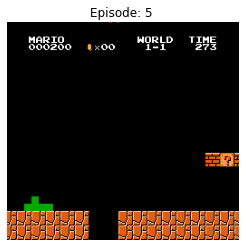

100%|█████████████████████████████████████████████| 5/5 [04:00<00:00, 48.02s/it]

=> Episode 5 Score = 943.00, Average Score = 765.80


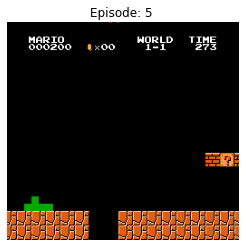

In [ ]:
# For Testing
#episodes_nb = 3
double_deepq_simple_x_test,double_deepq_simple_y_test  = run(training_mode=False, pretrained=False, double_dqn=True, num_episodes=episodes_nb_test, 
                                                             exploration_max = 0.05, movement = SIMPLE_MOVEMENT)

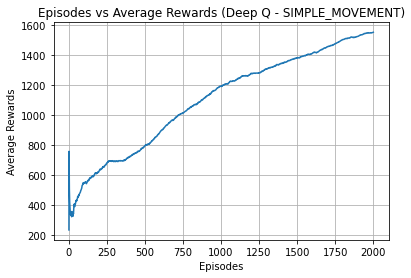

In [ ]:
plt.plot(double_deepq_simple_x, double_deepq_simple_y)
plt.title(f"Episodes vs Average Rewards (Deep Q - SIMPLE_MOVEMENT)")
plt.xlabel("Episodes") 
plt.ylabel("Average Rewards") 
plt.grid()
plt.show()

## Double Deep Q-Learning Movement => COMPLEX_MOVEMENT

In [ ]:
# Number of episode that you want to train;
#episodes_nb = 3
# For training
double_deepq_complex_x, double_deepq_complex_y = run(training_mode=True, pretrained=False, double_dqn=True, num_episodes=episodes_nb, 
                                                     exploration_max = 0.95, movement = COMPLEX_MOVEMENT)

Current device is Cuda


  0%|                                          | 1/2000 [00:01<53:28,  1.60s/it]

=> Episode 1 Score = 224.00, Average Score = 224.00


  0%|                                        | 2/2000 [00:07<2:20:00,  4.20s/it]

=> Episode 2 Score = 1010.00, Average Score = 617.00


  0%|                                        | 3/2000 [00:09<1:38:17,  2.95s/it]

=> Episode 3 Score = 97.00, Average Score = 443.67


  0%|                                        | 4/2000 [00:09<1:06:33,  2.00s/it]

=> Episode 4 Score = 244.00, Average Score = 393.75


  0%|                                          | 5/2000 [00:10<48:46,  1.47s/it]

=> Episode 5 Score = 248.00, Average Score = 364.60


  0%|▏                                         | 6/2000 [00:10<38:02,  1.14s/it]

=> Episode 6 Score = 251.00, Average Score = 345.67


  0%|▏                                         | 7/2000 [00:11<31:14,  1.06it/s]

=> Episode 7 Score = 247.00, Average Score = 331.57


  0%|▏                                         | 8/2000 [00:11<27:18,  1.22it/s]

=> Episode 8 Score = 248.00, Average Score = 321.12


  0%|▏                                         | 9/2000 [00:12<25:00,  1.33it/s]

=> Episode 9 Score = 243.00, Average Score = 312.44


  0%|▏                                        | 10/2000 [00:12<22:48,  1.45it/s]

=> Episode 10 Score = 246.00, Average Score = 305.80


  1%|▏                                        | 11/2000 [00:13<25:50,  1.28it/s]

=> Episode 11 Score = 175.00, Average Score = 293.91


  1%|▏                                        | 12/2000 [00:16<41:31,  1.25s/it]

=> Episode 12 Score = 619.00, Average Score = 321.00


  1%|▎                                        | 13/2000 [00:16<34:08,  1.03s/it]

=> Episode 13 Score = 251.00, Average Score = 315.62


  1%|▎                                      | 14/2000 [00:21<1:11:18,  2.15s/it]

=> Episode 14 Score = 1014.00, Average Score = 365.50


  1%|▎                                      | 15/2000 [00:25<1:25:12,  2.58s/it]

=> Episode 15 Score = 625.00, Average Score = 382.80


  1%|▎                                      | 16/2000 [00:25<1:05:28,  1.98s/it]

=> Episode 16 Score = 240.00, Average Score = 373.88


  1%|▎                                      | 17/2000 [00:29<1:20:59,  2.45s/it]

=> Episode 17 Score = 754.00, Average Score = 396.24


  1%|▎                                      | 18/2000 [00:33<1:40:01,  3.03s/it]

=> Episode 18 Score = 794.00, Average Score = 418.33


  1%|▎                                      | 19/2000 [00:36<1:43:44,  3.14s/it]

=> Episode 19 Score = 803.00, Average Score = 438.58


  1%|▍                                      | 20/2000 [00:37<1:17:36,  2.35s/it]

=> Episode 20 Score = 245.00, Average Score = 428.90


  1%|▍                                      | 21/2000 [00:38<1:00:30,  1.83s/it]

=> Episode 21 Score = 239.00, Average Score = 419.86


  1%|▍                                        | 22/2000 [00:38<50:26,  1.53s/it]

=> Episode 22 Score = 225.00, Average Score = 411.00


  1%|▍                                        | 23/2000 [00:41<57:41,  1.75s/it]

=> Episode 23 Score = 597.00, Average Score = 419.09


  1%|▍                                        | 24/2000 [00:41<46:47,  1.42s/it]

=> Episode 24 Score = 243.00, Average Score = 411.75


  1%|▌                                        | 25/2000 [00:42<37:23,  1.14s/it]

=> Episode 25 Score = 248.00, Average Score = 405.20


  1%|▌                                        | 26/2000 [00:43<36:22,  1.11s/it]

=> Episode 26 Score = 613.00, Average Score = 413.19


  1%|▌                                        | 27/2000 [00:43<30:45,  1.07it/s]

=> Episode 27 Score = 241.00, Average Score = 406.81


  1%|▌                                        | 28/2000 [00:44<26:10,  1.26it/s]

=> Episode 28 Score = 247.00, Average Score = 401.11


  1%|▌                                        | 29/2000 [00:45<26:06,  1.26it/s]

=> Episode 29 Score = 216.00, Average Score = 394.72


  2%|▌                                        | 30/2000 [00:45<23:31,  1.40it/s]

=> Episode 30 Score = 249.00, Average Score = 389.87


  2%|▋                                        | 31/2000 [00:46<21:53,  1.50it/s]

=> Episode 31 Score = 246.00, Average Score = 385.23


  2%|▌                                      | 32/2000 [00:55<1:51:17,  3.39s/it]

=> Episode 32 Score = 727.00, Average Score = 395.91


  2%|▋                                      | 33/2000 [00:56<1:24:27,  2.58s/it]

=> Episode 33 Score = 224.00, Average Score = 390.70


  2%|▋                                      | 34/2000 [00:57<1:04:15,  1.96s/it]

=> Episode 34 Score = 247.00, Average Score = 386.47


  2%|▋                                      | 35/2000 [01:02<1:36:36,  2.95s/it]

=> Episode 35 Score = 1012.00, Average Score = 404.34


  2%|▋                                      | 36/2000 [01:03<1:15:26,  2.30s/it]

=> Episode 36 Score = 245.00, Average Score = 399.92


  2%|▋                                      | 37/2000 [01:04<1:02:14,  1.90s/it]

=> Episode 37 Score = 205.00, Average Score = 394.65


  2%|▋                                      | 38/2000 [01:07<1:15:13,  2.30s/it]

=> Episode 38 Score = 1035.00, Average Score = 411.50


  2%|▊                                      | 39/2000 [01:08<1:07:13,  2.06s/it]

=> Episode 39 Score = 611.00, Average Score = 416.62


  2%|▊                                      | 40/2000 [01:10<1:06:42,  2.04s/it]

=> Episode 40 Score = 742.00, Average Score = 424.75


  2%|▊                                      | 41/2000 [01:12<1:03:39,  1.95s/it]

=> Episode 41 Score = 617.00, Average Score = 429.44


  2%|▊                                        | 42/2000 [01:13<50:55,  1.56s/it]

=> Episode 42 Score = 229.00, Average Score = 424.67


  2%|▉                                        | 43/2000 [01:13<40:57,  1.26s/it]

=> Episode 43 Score = 242.00, Average Score = 420.42


  2%|▉                                        | 44/2000 [01:15<42:28,  1.30s/it]

=> Episode 44 Score = 608.00, Average Score = 424.68


  2%|▉                                        | 45/2000 [01:15<34:57,  1.07s/it]

=> Episode 45 Score = 245.00, Average Score = 420.69


  2%|▉                                        | 46/2000 [01:16<30:02,  1.08it/s]

=> Episode 46 Score = 246.00, Average Score = 416.89


  2%|▉                                        | 47/2000 [01:17<27:44,  1.17it/s]

=> Episode 47 Score = 219.00, Average Score = 412.68


  2%|▉                                        | 48/2000 [01:17<24:30,  1.33it/s]

=> Episode 48 Score = 248.00, Average Score = 409.25


  2%|█                                        | 49/2000 [01:18<22:40,  1.43it/s]

=> Episode 49 Score = 246.00, Average Score = 405.92


  2%|█                                        | 50/2000 [01:18<20:29,  1.59it/s]

=> Episode 50 Score = 251.00, Average Score = 402.82


  3%|█                                        | 51/2000 [01:19<19:33,  1.66it/s]

=> Episode 51 Score = 250.00, Average Score = 399.82


  3%|█                                        | 52/2000 [01:19<18:55,  1.72it/s]

=> Episode 52 Score = 248.00, Average Score = 396.90


  3%|█                                        | 53/2000 [01:20<18:32,  1.75it/s]

=> Episode 53 Score = 249.00, Average Score = 394.11


  3%|█                                        | 54/2000 [01:21<21:34,  1.50it/s]

=> Episode 54 Score = 200.00, Average Score = 390.52


  3%|█▏                                       | 55/2000 [01:21<20:04,  1.61it/s]

=> Episode 55 Score = 243.00, Average Score = 387.84


  3%|█▏                                       | 56/2000 [01:22<19:04,  1.70it/s]

=> Episode 56 Score = 248.00, Average Score = 385.34


  3%|█▏                                       | 57/2000 [01:22<19:59,  1.62it/s]

=> Episode 57 Score = 220.00, Average Score = 382.44


  3%|█▏                                       | 58/2000 [01:23<19:00,  1.70it/s]

=> Episode 58 Score = 251.00, Average Score = 380.17


  3%|█▏                                       | 59/2000 [01:24<19:52,  1.63it/s]

=> Episode 59 Score = 228.00, Average Score = 377.59


  3%|█▏                                       | 60/2000 [01:27<47:52,  1.48s/it]

=> Episode 60 Score = 1005.00, Average Score = 388.05


  3%|█▎                                       | 61/2000 [01:28<47:14,  1.46s/it]

=> Episode 61 Score = 627.00, Average Score = 391.97


  3%|█▎                                       | 62/2000 [01:29<37:58,  1.18s/it]

=> Episode 62 Score = 248.00, Average Score = 389.65


  3%|█▎                                       | 63/2000 [01:30<32:15,  1.00it/s]

=> Episode 63 Score = 248.00, Average Score = 387.40


  3%|█▎                                       | 64/2000 [01:30<27:23,  1.18it/s]

=> Episode 64 Score = 250.00, Average Score = 385.25


  3%|█▎                                       | 65/2000 [01:32<34:16,  1.06s/it]

=> Episode 65 Score = 607.00, Average Score = 388.66


  3%|█▎                                       | 66/2000 [01:32<29:48,  1.08it/s]

=> Episode 66 Score = 232.00, Average Score = 386.29


  3%|█▎                                       | 67/2000 [01:33<25:59,  1.24it/s]

=> Episode 67 Score = 251.00, Average Score = 384.27


  3%|█▍                                       | 68/2000 [01:33<23:23,  1.38it/s]

=> Episode 68 Score = 248.00, Average Score = 382.26


  3%|█▍                                       | 69/2000 [01:36<45:59,  1.43s/it]

=> Episode 69 Score = 587.00, Average Score = 385.23


  4%|█▍                                       | 70/2000 [01:38<52:40,  1.64s/it]

=> Episode 70 Score = 589.00, Average Score = 388.14


  4%|█▍                                       | 71/2000 [01:39<42:31,  1.32s/it]

=> Episode 71 Score = 242.00, Average Score = 386.08


  4%|█▍                                       | 72/2000 [01:40<35:03,  1.09s/it]

=> Episode 72 Score = 249.00, Average Score = 384.18


  4%|█▍                                       | 73/2000 [01:40<29:23,  1.09it/s]

=> Episode 73 Score = 247.00, Average Score = 382.30


  4%|█▌                                       | 74/2000 [01:41<25:33,  1.26it/s]

=> Episode 74 Score = 252.00, Average Score = 380.54


  4%|█▌                                       | 75/2000 [01:44<45:54,  1.43s/it]

=> Episode 75 Score = 801.00, Average Score = 386.15


  4%|█▌                                       | 76/2000 [01:44<36:55,  1.15s/it]

=> Episode 76 Score = 248.00, Average Score = 384.33


  4%|█▌                                       | 77/2000 [01:45<30:59,  1.03it/s]

=> Episode 77 Score = 248.00, Average Score = 382.56


  4%|█▌                                       | 78/2000 [01:45<27:06,  1.18it/s]

=> Episode 78 Score = 234.00, Average Score = 380.65


  4%|█▌                                       | 79/2000 [01:49<58:09,  1.82s/it]

=> Episode 79 Score = 1296.00, Average Score = 392.24


  4%|█▋                                       | 80/2000 [01:50<45:39,  1.43s/it]

=> Episode 80 Score = 250.00, Average Score = 390.46


  4%|█▋                                       | 81/2000 [01:50<37:45,  1.18s/it]

=> Episode 81 Score = 245.00, Average Score = 388.67


  4%|█▋                                       | 82/2000 [01:51<32:10,  1.01s/it]

=> Episode 82 Score = 245.00, Average Score = 386.91


  4%|█▋                                       | 83/2000 [01:52<35:12,  1.10s/it]

=> Episode 83 Score = 634.00, Average Score = 389.89


  4%|█▋                                       | 84/2000 [01:53<29:52,  1.07it/s]

=> Episode 84 Score = 246.00, Average Score = 388.18


  4%|█▋                                       | 85/2000 [01:53<25:58,  1.23it/s]

=> Episode 85 Score = 248.00, Average Score = 386.53


  4%|█▊                                       | 86/2000 [01:55<30:09,  1.06it/s]

=> Episode 86 Score = 133.00, Average Score = 383.58


  4%|█▋                                     | 87/2000 [01:59<1:00:30,  1.90s/it]

=> Episode 87 Score = 1278.00, Average Score = 393.86


  4%|█▊                                       | 88/2000 [01:59<47:25,  1.49s/it]

=> Episode 88 Score = 249.00, Average Score = 392.22


  4%|█▊                                       | 89/2000 [02:00<38:42,  1.22s/it]

=> Episode 89 Score = 251.00, Average Score = 390.63


  4%|█▊                                       | 90/2000 [02:00<32:21,  1.02s/it]

=> Episode 90 Score = 250.00, Average Score = 389.07


  5%|█▊                                       | 91/2000 [02:02<33:38,  1.06s/it]

=> Episode 91 Score = 633.00, Average Score = 391.75


  5%|█▊                                     | 92/2000 [02:06<1:10:04,  2.20s/it]

=> Episode 92 Score = 752.00, Average Score = 395.66


  5%|█▊                                     | 93/2000 [02:09<1:12:25,  2.28s/it]

=> Episode 93 Score = 1043.00, Average Score = 402.62


  5%|█▉                                       | 94/2000 [02:09<56:13,  1.77s/it]

=> Episode 94 Score = 236.00, Average Score = 400.85


  5%|█▊                                     | 95/2000 [02:12<1:02:48,  1.98s/it]

=> Episode 95 Score = 592.00, Average Score = 402.86


  5%|█▉                                       | 96/2000 [02:13<49:27,  1.56s/it]

=> Episode 96 Score = 251.00, Average Score = 401.28


  5%|█▉                                       | 97/2000 [02:13<40:45,  1.29s/it]

=> Episode 97 Score = 236.00, Average Score = 399.58


  5%|██                                       | 98/2000 [02:14<34:05,  1.08s/it]

=> Episode 98 Score = 233.00, Average Score = 397.88


  5%|██                                       | 99/2000 [02:17<52:53,  1.67s/it]

=> Episode 99 Score = 807.00, Average Score = 402.01


  5%|██                                      | 100/2000 [02:17<42:43,  1.35s/it]

=> Episode 100 Score = 236.00, Average Score = 400.35


  5%|█▉                                    | 101/2000 [02:22<1:11:01,  2.24s/it]

=> Episode 101 Score = 791.00, Average Score = 404.22


  5%|█▉                                    | 102/2000 [02:32<2:29:13,  4.72s/it]

=> Episode 102 Score = 1343.00, Average Score = 413.42


  5%|█▉                                    | 103/2000 [02:33<1:49:55,  3.48s/it]

=> Episode 103 Score = 234.00, Average Score = 411.68


  5%|█▉                                    | 104/2000 [02:33<1:22:48,  2.62s/it]

=> Episode 104 Score = 245.00, Average Score = 410.08


  5%|█▉                                    | 105/2000 [02:37<1:27:37,  2.77s/it]

=> Episode 105 Score = 1112.00, Average Score = 416.76


  5%|██                                    | 106/2000 [02:43<2:02:38,  3.88s/it]

=> Episode 106 Score = 997.00, Average Score = 422.24


  5%|██                                    | 107/2000 [02:44<1:30:26,  2.87s/it]

=> Episode 107 Score = 250.00, Average Score = 420.63


  5%|██                                    | 108/2000 [02:47<1:36:58,  3.08s/it]

=> Episode 108 Score = 586.00, Average Score = 422.16


  5%|██                                    | 109/2000 [02:51<1:48:39,  3.45s/it]

=> Episode 109 Score = 761.00, Average Score = 425.27


  6%|██                                    | 110/2000 [02:52<1:21:14,  2.58s/it]

=> Episode 110 Score = 248.00, Average Score = 423.65


  6%|██                                    | 111/2000 [02:53<1:02:03,  1.97s/it]

=> Episode 111 Score = 249.00, Average Score = 422.08


  6%|██▏                                     | 112/2000 [02:53<48:47,  1.55s/it]

=> Episode 112 Score = 242.00, Average Score = 420.47


  6%|██▎                                     | 113/2000 [02:54<39:59,  1.27s/it]

=> Episode 113 Score = 234.00, Average Score = 418.82


  6%|██▏                                   | 114/2000 [02:58<1:08:14,  2.17s/it]

=> Episode 114 Score = 792.00, Average Score = 422.10


  6%|██▏                                   | 115/2000 [03:01<1:16:47,  2.44s/it]

=> Episode 115 Score = 775.00, Average Score = 425.17


  6%|██▏                                   | 116/2000 [03:04<1:22:29,  2.63s/it]

=> Episode 116 Score = 581.00, Average Score = 426.51


  6%|██▏                                   | 117/2000 [03:13<2:20:42,  4.48s/it]

=> Episode 117 Score = 969.00, Average Score = 431.15


  6%|██▏                                   | 118/2000 [03:13<1:43:12,  3.29s/it]

=> Episode 118 Score = 245.00, Average Score = 429.57


  6%|██▎                                   | 119/2000 [03:14<1:18:21,  2.50s/it]

=> Episode 119 Score = 227.00, Average Score = 427.87


  6%|██▍                                     | 120/2000 [03:15<59:50,  1.91s/it]

=> Episode 120 Score = 247.00, Average Score = 426.36


  6%|██▍                                     | 121/2000 [03:16<58:53,  1.88s/it]

=> Episode 121 Score = 606.00, Average Score = 427.84


  6%|██▍                                     | 122/2000 [03:18<55:14,  1.76s/it]

=> Episode 122 Score = 607.00, Average Score = 429.31


  6%|██▍                                     | 123/2000 [03:19<45:52,  1.47s/it]

=> Episode 123 Score = 209.00, Average Score = 427.52


  6%|██▍                                     | 124/2000 [03:20<43:45,  1.40s/it]

=> Episode 124 Score = 608.00, Average Score = 428.98


  6%|██▌                                     | 125/2000 [03:21<36:33,  1.17s/it]

=> Episode 125 Score = 235.00, Average Score = 427.42


  6%|██▌                                     | 126/2000 [03:21<31:32,  1.01s/it]

=> Episode 126 Score = 231.00, Average Score = 425.87


  6%|██▌                                     | 127/2000 [03:23<42:15,  1.35s/it]

=> Episode 127 Score = 718.00, Average Score = 428.17


  6%|██▍                                   | 128/2000 [03:29<1:20:07,  2.57s/it]

=> Episode 128 Score = 1013.00, Average Score = 432.73


  6%|██▍                                   | 129/2000 [03:29<1:00:56,  1.95s/it]

=> Episode 129 Score = 249.00, Average Score = 431.31


  6%|██▍                                   | 130/2000 [03:31<1:02:35,  2.01s/it]

=> Episode 130 Score = 818.00, Average Score = 434.28


  7%|██▌                                     | 131/2000 [03:32<50:56,  1.64s/it]

=> Episode 131 Score = 215.00, Average Score = 432.61


  7%|██▌                                   | 132/2000 [03:37<1:17:49,  2.50s/it]

=> Episode 132 Score = 1025.00, Average Score = 437.10


  7%|██▌                                   | 133/2000 [03:40<1:26:00,  2.76s/it]

=> Episode 133 Score = 1426.00, Average Score = 444.53


  7%|██▌                                   | 134/2000 [04:13<6:11:48, 11.96s/it]

=> Episode 134 Score = 265.00, Average Score = 443.19


  7%|██▌                                   | 135/2000 [04:15<4:32:19,  8.76s/it]

=> Episode 135 Score = 606.00, Average Score = 444.40


  7%|██▌                                   | 136/2000 [04:20<3:59:37,  7.71s/it]

=> Episode 136 Score = 1007.00, Average Score = 448.54


  7%|██▌                                   | 137/2000 [04:21<2:52:30,  5.56s/it]

=> Episode 137 Score = 250.00, Average Score = 447.09


  7%|██▌                                   | 138/2000 [04:23<2:19:52,  4.51s/it]

=> Episode 138 Score = 1057.00, Average Score = 451.51


  7%|██▋                                   | 139/2000 [04:25<1:56:08,  3.74s/it]

=> Episode 139 Score = 1045.00, Average Score = 455.78


  7%|██▋                                   | 140/2000 [04:26<1:34:04,  3.03s/it]

=> Episode 140 Score = 612.00, Average Score = 456.89


  7%|██▋                                   | 141/2000 [04:28<1:20:19,  2.59s/it]

=> Episode 141 Score = 649.00, Average Score = 458.26


  7%|██▋                                   | 142/2000 [04:30<1:14:50,  2.42s/it]

=> Episode 142 Score = 1049.00, Average Score = 462.42


  7%|██▊                                     | 143/2000 [04:30<57:10,  1.85s/it]

=> Episode 143 Score = 245.00, Average Score = 460.90


  7%|██▋                                   | 144/2000 [04:35<1:23:58,  2.71s/it]

=> Episode 144 Score = 1413.00, Average Score = 467.51


  7%|██▊                                   | 145/2000 [04:38<1:25:03,  2.75s/it]

=> Episode 145 Score = 1346.00, Average Score = 473.57


  7%|██▊                                   | 146/2000 [04:38<1:04:20,  2.08s/it]

=> Episode 146 Score = 248.00, Average Score = 472.02


  7%|██▊                                   | 147/2000 [04:41<1:11:42,  2.32s/it]

=> Episode 147 Score = 587.00, Average Score = 472.80


  7%|██▊                                   | 148/2000 [04:45<1:24:43,  2.75s/it]

=> Episode 148 Score = 1048.00, Average Score = 476.69


  7%|██▊                                   | 149/2000 [04:45<1:04:50,  2.10s/it]

=> Episode 149 Score = 238.00, Average Score = 475.09


  8%|███                                     | 150/2000 [04:46<50:01,  1.62s/it]

=> Episode 150 Score = 245.00, Average Score = 473.55


  8%|███                                     | 151/2000 [04:48<58:52,  1.91s/it]

=> Episode 151 Score = 637.00, Average Score = 474.64


  8%|██▉                                   | 152/2000 [04:51<1:06:14,  2.15s/it]

=> Episode 152 Score = 1326.00, Average Score = 480.24


  8%|██▉                                   | 153/2000 [04:54<1:12:14,  2.35s/it]

=> Episode 153 Score = 1133.00, Average Score = 484.50


  8%|███                                     | 154/2000 [04:55<55:51,  1.82s/it]

=> Episode 154 Score = 247.00, Average Score = 482.96


  8%|███                                     | 155/2000 [04:56<54:03,  1.76s/it]

=> Episode 155 Score = 607.00, Average Score = 483.76


  8%|██▉                                   | 156/2000 [05:00<1:09:29,  2.26s/it]

=> Episode 156 Score = 1428.00, Average Score = 489.81


  8%|███▏                                    | 157/2000 [05:00<53:36,  1.75s/it]

=> Episode 157 Score = 248.00, Average Score = 488.27


  8%|███▏                                    | 158/2000 [05:01<42:58,  1.40s/it]

=> Episode 158 Score = 247.00, Average Score = 486.75


  8%|███▏                                    | 159/2000 [05:02<40:36,  1.32s/it]

=> Episode 159 Score = 623.00, Average Score = 487.60


  8%|███                                   | 160/2000 [05:06<1:01:53,  2.02s/it]

=> Episode 160 Score = 1030.00, Average Score = 490.99


  8%|███                                   | 161/2000 [05:10<1:24:23,  2.75s/it]

=> Episode 161 Score = 707.00, Average Score = 492.34


  8%|███                                   | 162/2000 [05:11<1:03:29,  2.07s/it]

=> Episode 162 Score = 248.00, Average Score = 490.83


  8%|███▎                                    | 163/2000 [05:11<50:02,  1.63s/it]

=> Episode 163 Score = 233.00, Average Score = 489.25


  8%|███                                   | 164/2000 [05:14<1:02:42,  2.05s/it]

=> Episode 164 Score = 1036.00, Average Score = 492.58


  8%|███▏                                  | 165/2000 [05:17<1:07:07,  2.20s/it]

=> Episode 165 Score = 637.00, Average Score = 493.45


  8%|███▏                                  | 166/2000 [05:18<1:03:04,  2.06s/it]

=> Episode 166 Score = 629.00, Average Score = 494.27


  8%|███▏                                  | 167/2000 [05:21<1:07:03,  2.20s/it]

=> Episode 167 Score = 1152.00, Average Score = 498.21


  8%|███▏                                  | 168/2000 [05:23<1:10:14,  2.30s/it]

=> Episode 168 Score = 1348.00, Average Score = 503.27


  8%|███▏                                  | 169/2000 [05:25<1:05:27,  2.14s/it]

=> Episode 169 Score = 646.00, Average Score = 504.11


  8%|███▏                                  | 170/2000 [05:27<1:05:04,  2.13s/it]

=> Episode 170 Score = 1044.00, Average Score = 507.29


  9%|███▍                                    | 171/2000 [05:28<50:06,  1.64s/it]

=> Episode 171 Score = 249.00, Average Score = 505.78


  9%|███▍                                    | 172/2000 [05:28<40:13,  1.32s/it]

=> Episode 172 Score = 244.00, Average Score = 504.26


  9%|███▍                                    | 173/2000 [05:29<33:06,  1.09s/it]

=> Episode 173 Score = 248.00, Average Score = 502.77


  9%|███▍                                    | 174/2000 [05:30<28:01,  1.09it/s]

=> Episode 174 Score = 246.00, Average Score = 501.30


  9%|███▌                                    | 175/2000 [05:31<29:26,  1.03it/s]

=> Episode 175 Score = 613.00, Average Score = 501.94


  9%|███▌                                    | 176/2000 [05:33<38:34,  1.27s/it]

=> Episode 176 Score = 604.00, Average Score = 502.52


  9%|███▌                                    | 177/2000 [05:34<38:54,  1.28s/it]

=> Episode 177 Score = 625.00, Average Score = 503.21


  9%|███▌                                    | 178/2000 [05:36<47:34,  1.57s/it]

=> Episode 178 Score = 1043.00, Average Score = 506.24


  9%|███▌                                    | 179/2000 [05:37<42:51,  1.41s/it]

=> Episode 179 Score = 607.00, Average Score = 506.80


  9%|███▍                                  | 180/2000 [05:41<1:01:09,  2.02s/it]

=> Episode 180 Score = 1043.00, Average Score = 509.78


  9%|███▌                                    | 181/2000 [05:42<56:11,  1.85s/it]

=> Episode 181 Score = 611.00, Average Score = 510.34


  9%|███▍                                  | 182/2000 [05:45<1:10:28,  2.33s/it]

=> Episode 182 Score = 1029.00, Average Score = 513.19


  9%|███▍                                  | 183/2000 [05:47<1:00:53,  2.01s/it]

=> Episode 183 Score = 611.00, Average Score = 513.73


  9%|███▋                                    | 184/2000 [05:48<54:59,  1.82s/it]

=> Episode 184 Score = 631.00, Average Score = 514.36


  9%|███▌                                  | 185/2000 [05:51<1:03:36,  2.10s/it]

=> Episode 185 Score = 1344.00, Average Score = 518.85


  9%|███▋                                    | 186/2000 [05:52<56:09,  1.86s/it]

=> Episode 186 Score = 629.00, Average Score = 519.44


  9%|███▋                                    | 187/2000 [05:53<43:40,  1.45s/it]

=> Episode 187 Score = 246.00, Average Score = 517.98


  9%|███▌                                  | 188/2000 [06:02<1:56:15,  3.85s/it]

=> Episode 188 Score = 673.00, Average Score = 518.80


  9%|███▌                                  | 189/2000 [06:09<2:21:23,  4.68s/it]

=> Episode 189 Score = 991.00, Average Score = 521.30


 10%|███▌                                  | 190/2000 [06:10<1:53:03,  3.75s/it]

=> Episode 190 Score = 617.00, Average Score = 521.81


 10%|███▋                                  | 191/2000 [06:11<1:23:54,  2.78s/it]

=> Episode 191 Score = 247.00, Average Score = 520.37


 10%|███▋                                  | 192/2000 [06:14<1:25:26,  2.84s/it]

=> Episode 192 Score = 1032.00, Average Score = 523.03


 10%|███▋                                  | 193/2000 [06:19<1:44:47,  3.48s/it]

=> Episode 193 Score = 1003.00, Average Score = 525.52


 10%|███▋                                  | 194/2000 [06:20<1:22:47,  2.75s/it]

=> Episode 194 Score = 610.00, Average Score = 525.95


 10%|███▋                                  | 195/2000 [06:21<1:11:57,  2.39s/it]

=> Episode 195 Score = 612.00, Average Score = 526.39


 10%|███▋                                  | 196/2000 [06:27<1:39:03,  3.29s/it]

=> Episode 196 Score = 1004.00, Average Score = 528.83


 10%|███▋                                  | 197/2000 [06:29<1:28:35,  2.95s/it]

=> Episode 197 Score = 1040.00, Average Score = 531.43


 10%|███▊                                  | 198/2000 [06:29<1:07:03,  2.23s/it]

=> Episode 198 Score = 247.00, Average Score = 529.99


 10%|███▉                                    | 199/2000 [06:30<52:56,  1.76s/it]

=> Episode 199 Score = 227.00, Average Score = 528.47


 10%|████                                    | 200/2000 [06:31<44:22,  1.48s/it]

=> Episode 200 Score = 201.00, Average Score = 526.83


 10%|████                                    | 201/2000 [06:32<35:53,  1.20s/it]

=> Episode 201 Score = 245.00, Average Score = 525.43


 10%|████                                    | 202/2000 [06:32<30:54,  1.03s/it]

=> Episode 202 Score = 245.00, Average Score = 524.04


 10%|████                                    | 203/2000 [06:33<26:06,  1.15it/s]

=> Episode 203 Score = 248.00, Average Score = 522.68


 10%|███▉                                  | 204/2000 [06:42<1:44:36,  3.49s/it]

=> Episode 204 Score = 665.00, Average Score = 523.38


 10%|███▉                                  | 205/2000 [06:44<1:25:16,  2.85s/it]

=> Episode 205 Score = 629.00, Average Score = 523.89


 10%|███▉                                  | 206/2000 [06:44<1:05:12,  2.18s/it]

=> Episode 206 Score = 235.00, Average Score = 522.49


 10%|███▉                                  | 207/2000 [06:46<1:04:49,  2.17s/it]

=> Episode 207 Score = 1043.00, Average Score = 525.00


 10%|███▉                                  | 208/2000 [06:49<1:07:43,  2.27s/it]

=> Episode 208 Score = 778.00, Average Score = 526.22


 10%|███▉                                  | 209/2000 [06:57<1:55:54,  3.88s/it]

=> Episode 209 Score = 711.00, Average Score = 527.11


 10%|███▉                                  | 210/2000 [06:57<1:26:38,  2.90s/it]

=> Episode 210 Score = 234.00, Average Score = 525.71


 11%|████                                  | 211/2000 [06:58<1:05:13,  2.19s/it]

=> Episode 211 Score = 252.00, Average Score = 524.41


 11%|████▏                                   | 212/2000 [06:58<50:45,  1.70s/it]

=> Episode 212 Score = 246.00, Average Score = 523.10


 11%|████▎                                   | 213/2000 [07:00<47:35,  1.60s/it]

=> Episode 213 Score = 609.00, Average Score = 523.50


 11%|████▎                                   | 214/2000 [07:00<38:22,  1.29s/it]

=> Episode 214 Score = 249.00, Average Score = 522.22


 11%|████                                  | 215/2000 [07:09<1:43:06,  3.47s/it]

=> Episode 215 Score = 968.00, Average Score = 524.29


 11%|████                                  | 216/2000 [07:15<2:11:00,  4.41s/it]

=> Episode 216 Score = 1277.00, Average Score = 527.78


 11%|████                                  | 217/2000 [07:18<1:55:56,  3.90s/it]

=> Episode 217 Score = 1344.00, Average Score = 531.54


 11%|████▏                                 | 218/2000 [07:20<1:34:32,  3.18s/it]

=> Episode 218 Score = 606.00, Average Score = 531.88


 11%|████▏                                 | 219/2000 [07:21<1:20:03,  2.70s/it]

=> Episode 219 Score = 606.00, Average Score = 532.22


 11%|████▏                                 | 220/2000 [07:22<1:01:49,  2.08s/it]

=> Episode 220 Score = 239.00, Average Score = 530.89


 11%|████▏                                 | 221/2000 [07:24<1:04:03,  2.16s/it]

=> Episode 221 Score = 1037.00, Average Score = 533.18


 11%|████▍                                   | 222/2000 [07:25<50:09,  1.69s/it]

=> Episode 222 Score = 241.00, Average Score = 531.86


 11%|████▍                                   | 223/2000 [07:25<39:40,  1.34s/it]

=> Episode 223 Score = 246.00, Average Score = 530.58


 11%|████▍                                   | 224/2000 [07:26<32:32,  1.10s/it]

=> Episode 224 Score = 246.00, Average Score = 529.31


 11%|████▌                                   | 225/2000 [07:27<32:38,  1.10s/it]

=> Episode 225 Score = 612.00, Average Score = 529.68


 11%|████▌                                   | 226/2000 [07:27<28:25,  1.04it/s]

=> Episode 226 Score = 230.00, Average Score = 528.35


 11%|████▌                                   | 227/2000 [07:29<34:26,  1.17s/it]

=> Episode 227 Score = 602.00, Average Score = 528.67


 11%|████▌                                   | 228/2000 [07:31<36:50,  1.25s/it]

=> Episode 228 Score = 637.00, Average Score = 529.15


 11%|████▌                                   | 229/2000 [07:31<30:52,  1.05s/it]

=> Episode 229 Score = 247.00, Average Score = 527.92


 12%|████▌                                   | 230/2000 [07:32<26:40,  1.11it/s]

=> Episode 230 Score = 237.00, Average Score = 526.65


 12%|████▌                                   | 231/2000 [07:34<38:55,  1.32s/it]

=> Episode 231 Score = 586.00, Average Score = 526.91


 12%|████▋                                   | 232/2000 [07:36<49:12,  1.67s/it]

=> Episode 232 Score = 1435.00, Average Score = 530.82


 12%|████▋                                   | 233/2000 [07:37<39:05,  1.33s/it]

=> Episode 233 Score = 249.00, Average Score = 529.61


 12%|████▋                                   | 234/2000 [07:38<37:47,  1.28s/it]

=> Episode 234 Score = 615.00, Average Score = 529.98


 12%|████▋                                   | 235/2000 [07:42<57:09,  1.94s/it]

=> Episode 235 Score = 1031.00, Average Score = 532.11


 12%|████▍                                 | 236/2000 [07:44<1:02:58,  2.14s/it]

=> Episode 236 Score = 1035.00, Average Score = 534.24


 12%|████▋                                   | 237/2000 [07:45<48:45,  1.66s/it]

=> Episode 237 Score = 250.00, Average Score = 533.04


 12%|████▊                                   | 238/2000 [07:46<46:59,  1.60s/it]

=> Episode 238 Score = 610.00, Average Score = 533.37


 12%|████▊                                   | 239/2000 [07:48<51:42,  1.76s/it]

=> Episode 239 Score = 1048.00, Average Score = 535.52


 12%|████▊                                   | 240/2000 [07:49<40:35,  1.38s/it]

=> Episode 240 Score = 249.00, Average Score = 534.33


 12%|████▊                                   | 241/2000 [07:51<46:27,  1.58s/it]

=> Episode 241 Score = 750.00, Average Score = 535.22


 12%|████▊                                   | 242/2000 [07:54<56:14,  1.92s/it]

=> Episode 242 Score = 1344.00, Average Score = 538.56


 12%|████▊                                   | 243/2000 [07:55<51:35,  1.76s/it]

=> Episode 243 Score = 624.00, Average Score = 538.91


 12%|████▉                                   | 244/2000 [07:57<52:07,  1.78s/it]

=> Episode 244 Score = 1048.00, Average Score = 541.00


 12%|████▉                                   | 245/2000 [07:58<47:05,  1.61s/it]

=> Episode 245 Score = 604.00, Average Score = 541.26


 12%|████▉                                   | 246/2000 [08:01<57:36,  1.97s/it]

=> Episode 246 Score = 1431.00, Average Score = 544.87


 12%|████▉                                   | 247/2000 [08:01<44:32,  1.52s/it]

=> Episode 247 Score = 249.00, Average Score = 543.68


 12%|████▉                                   | 248/2000 [08:04<53:25,  1.83s/it]

=> Episode 248 Score = 1323.00, Average Score = 546.82


 12%|████▉                                   | 249/2000 [08:06<56:29,  1.94s/it]

=> Episode 249 Score = 1047.00, Average Score = 548.83


 12%|█████                                   | 250/2000 [08:07<49:48,  1.71s/it]

=> Episode 250 Score = 608.00, Average Score = 549.06


 13%|█████                                   | 251/2000 [08:08<39:48,  1.37s/it]

=> Episode 251 Score = 248.00, Average Score = 547.86


 13%|█████                                   | 252/2000 [08:09<33:22,  1.15s/it]

=> Episode 252 Score = 235.00, Average Score = 546.62


 13%|█████                                   | 253/2000 [08:10<32:30,  1.12s/it]

=> Episode 253 Score = 610.00, Average Score = 546.87


 13%|█████                                   | 254/2000 [08:13<48:24,  1.66s/it]

=> Episode 254 Score = 1038.00, Average Score = 548.81


 13%|█████                                   | 255/2000 [08:14<46:46,  1.61s/it]

=> Episode 255 Score = 608.00, Average Score = 549.04


 13%|█████                                   | 256/2000 [08:16<49:08,  1.69s/it]

=> Episode 256 Score = 604.00, Average Score = 549.25


 13%|█████▏                                  | 257/2000 [08:18<52:02,  1.79s/it]

=> Episode 257 Score = 602.00, Average Score = 549.46


 13%|█████▏                                  | 258/2000 [08:20<54:32,  1.88s/it]

=> Episode 258 Score = 1045.00, Average Score = 551.38


 13%|█████▏                                  | 259/2000 [08:21<42:59,  1.48s/it]

=> Episode 259 Score = 235.00, Average Score = 550.16


 13%|█████▏                                  | 260/2000 [08:21<34:34,  1.19s/it]

=> Episode 260 Score = 250.00, Average Score = 549.00


 13%|█████▏                                  | 261/2000 [08:22<29:58,  1.03s/it]

=> Episode 261 Score = 236.00, Average Score = 547.80


 13%|█████▏                                  | 262/2000 [08:23<31:51,  1.10s/it]

=> Episode 262 Score = 630.00, Average Score = 548.12


 13%|█████▎                                  | 263/2000 [08:27<57:25,  1.98s/it]

=> Episode 263 Score = 1327.00, Average Score = 551.08


 13%|█████▎                                  | 264/2000 [08:28<44:48,  1.55s/it]

=> Episode 264 Score = 249.00, Average Score = 549.94


 13%|█████▎                                  | 265/2000 [08:28<36:23,  1.26s/it]

=> Episode 265 Score = 247.00, Average Score = 548.79


 13%|█████▎                                  | 266/2000 [08:30<43:03,  1.49s/it]

=> Episode 266 Score = 1048.00, Average Score = 550.67


 13%|█████                                 | 267/2000 [08:34<1:02:21,  2.16s/it]

=> Episode 267 Score = 1030.00, Average Score = 552.46


 13%|█████▎                                  | 268/2000 [08:35<54:06,  1.87s/it]

=> Episode 268 Score = 616.00, Average Score = 552.70


 13%|█████▍                                  | 269/2000 [08:36<42:09,  1.46s/it]

=> Episode 269 Score = 247.00, Average Score = 551.57


 14%|█████▍                                  | 270/2000 [08:39<55:37,  1.93s/it]

=> Episode 270 Score = 1576.00, Average Score = 555.36


 14%|█████▍                                  | 271/2000 [08:39<44:04,  1.53s/it]

=> Episode 271 Score = 245.00, Average Score = 554.21


 14%|█████▍                                  | 272/2000 [08:42<53:09,  1.85s/it]

=> Episode 272 Score = 1346.00, Average Score = 557.12


 14%|█████▍                                  | 273/2000 [08:42<41:31,  1.44s/it]

=> Episode 273 Score = 248.00, Average Score = 555.99


 14%|█████▍                                  | 274/2000 [08:45<56:00,  1.95s/it]

=> Episode 274 Score = 1338.00, Average Score = 558.85


 14%|█████▏                                | 275/2000 [08:49<1:07:02,  2.33s/it]

=> Episode 275 Score = 1563.00, Average Score = 562.50


 14%|█████▏                                | 276/2000 [08:52<1:11:53,  2.50s/it]

=> Episode 276 Score = 1041.00, Average Score = 564.23


 14%|█████▎                                | 277/2000 [08:53<1:00:25,  2.10s/it]

=> Episode 277 Score = 612.00, Average Score = 564.40


 14%|█████▎                                | 278/2000 [08:59<1:36:22,  3.36s/it]

=> Episode 278 Score = 990.00, Average Score = 565.94


 14%|█████▎                                | 279/2000 [09:00<1:11:49,  2.50s/it]

=> Episode 279 Score = 248.00, Average Score = 564.80


 14%|█████▌                                  | 280/2000 [09:00<55:05,  1.92s/it]

=> Episode 280 Score = 247.00, Average Score = 563.66


 14%|█████▌                                  | 281/2000 [09:01<49:52,  1.74s/it]

=> Episode 281 Score = 735.00, Average Score = 564.27


 14%|█████▎                                | 282/2000 [09:07<1:26:57,  3.04s/it]

=> Episode 282 Score = 1002.00, Average Score = 565.82


 14%|█████▍                                | 283/2000 [09:08<1:04:57,  2.27s/it]

=> Episode 283 Score = 251.00, Average Score = 564.71


 14%|█████▋                                  | 284/2000 [09:08<50:12,  1.76s/it]

=> Episode 284 Score = 236.00, Average Score = 563.55


 14%|█████▋                                  | 285/2000 [09:10<45:04,  1.58s/it]

=> Episode 285 Score = 610.00, Average Score = 563.72


 14%|█████▋                                  | 286/2000 [09:11<47:06,  1.65s/it]

=> Episode 286 Score = 601.00, Average Score = 563.85


 14%|█████▋                                  | 287/2000 [09:14<58:17,  2.04s/it]

=> Episode 287 Score = 1340.00, Average Score = 566.55


 14%|█████▊                                  | 288/2000 [09:16<51:46,  1.81s/it]

=> Episode 288 Score = 613.00, Average Score = 566.71


 14%|█████▊                                  | 289/2000 [09:17<51:30,  1.81s/it]

=> Episode 289 Score = 610.00, Average Score = 566.86


 14%|█████▊                                  | 290/2000 [09:19<50:15,  1.76s/it]

=> Episode 290 Score = 610.00, Average Score = 567.01


 15%|█████▊                                  | 291/2000 [09:20<39:27,  1.39s/it]

=> Episode 291 Score = 251.00, Average Score = 565.92


 15%|█████▌                                | 292/2000 [09:24<1:02:00,  2.18s/it]

=> Episode 292 Score = 573.00, Average Score = 565.95


 15%|█████▊                                  | 293/2000 [09:24<47:57,  1.69s/it]

=> Episode 293 Score = 247.00, Average Score = 564.86


 15%|█████▉                                  | 294/2000 [09:26<51:44,  1.82s/it]

=> Episode 294 Score = 1048.00, Average Score = 566.50


 15%|█████▉                                  | 295/2000 [09:27<45:17,  1.59s/it]

=> Episode 295 Score = 610.00, Average Score = 566.65


 15%|█████▉                                  | 296/2000 [09:30<56:25,  1.99s/it]

=> Episode 296 Score = 1430.00, Average Score = 569.57


 15%|█████▋                                | 297/2000 [09:35<1:15:33,  2.66s/it]

=> Episode 297 Score = 727.00, Average Score = 570.10


 15%|█████▋                                | 298/2000 [09:38<1:22:14,  2.90s/it]

=> Episode 298 Score = 1429.00, Average Score = 572.98


 15%|█████▋                                | 299/2000 [09:42<1:35:13,  3.36s/it]

=> Episode 299 Score = 791.00, Average Score = 573.71


 15%|█████▋                                | 300/2000 [09:45<1:25:15,  3.01s/it]

=> Episode 300 Score = 1045.00, Average Score = 575.28


 15%|█████▋                                | 301/2000 [09:46<1:13:54,  2.61s/it]

=> Episode 301 Score = 603.00, Average Score = 575.37


 15%|█████▋                                | 302/2000 [09:49<1:11:33,  2.53s/it]

=> Episode 302 Score = 1349.00, Average Score = 577.93


 15%|█████▊                                | 303/2000 [09:50<1:02:48,  2.22s/it]

=> Episode 303 Score = 609.00, Average Score = 578.04


 15%|█████▊                                | 304/2000 [09:52<1:02:16,  2.20s/it]

=> Episode 304 Score = 1043.00, Average Score = 579.57


 15%|██████                                  | 305/2000 [09:54<54:29,  1.93s/it]

=> Episode 305 Score = 610.00, Average Score = 579.67


 15%|██████                                  | 306/2000 [09:54<42:40,  1.51s/it]

=> Episode 306 Score = 246.00, Average Score = 578.58


 15%|██████▏                                 | 307/2000 [09:55<39:18,  1.39s/it]

=> Episode 307 Score = 608.00, Average Score = 578.67


 15%|██████▏                                 | 308/2000 [09:58<48:01,  1.70s/it]

=> Episode 308 Score = 1044.00, Average Score = 580.18


 15%|██████▏                                 | 309/2000 [09:58<38:09,  1.35s/it]

=> Episode 309 Score = 249.00, Average Score = 579.11


 16%|██████▏                                 | 310/2000 [10:00<43:40,  1.55s/it]

=> Episode 310 Score = 1055.00, Average Score = 580.65


 16%|██████▏                                 | 311/2000 [10:01<34:31,  1.23s/it]

=> Episode 311 Score = 247.00, Average Score = 579.57


 16%|██████▏                                 | 312/2000 [10:04<48:44,  1.73s/it]

=> Episode 312 Score = 1039.00, Average Score = 581.04


 16%|█████▉                                | 313/2000 [10:07<1:02:35,  2.23s/it]

=> Episode 313 Score = 1336.00, Average Score = 583.46


 16%|██████▎                                 | 314/2000 [10:08<52:30,  1.87s/it]

=> Episode 314 Score = 607.00, Average Score = 583.53


 16%|█████▉                                | 315/2000 [10:15<1:34:24,  3.36s/it]

=> Episode 315 Score = 2335.00, Average Score = 589.09


 16%|██████                                | 316/2000 [10:18<1:32:53,  3.31s/it]

=> Episode 316 Score = 1435.00, Average Score = 591.77


 16%|██████                                | 317/2000 [10:21<1:27:13,  3.11s/it]

=> Episode 317 Score = 764.00, Average Score = 592.31


 16%|██████                                | 318/2000 [10:24<1:27:34,  3.12s/it]

=> Episode 318 Score = 1034.00, Average Score = 593.70


 16%|██████                                | 319/2000 [10:25<1:13:18,  2.62s/it]

=> Episode 319 Score = 605.00, Average Score = 593.74


 16%|██████                                | 320/2000 [10:29<1:20:27,  2.87s/it]

=> Episode 320 Score = 1424.00, Average Score = 596.33


 16%|██████                                | 321/2000 [10:31<1:18:57,  2.82s/it]

=> Episode 321 Score = 1440.00, Average Score = 598.96


 16%|██████                                | 322/2000 [10:32<1:00:02,  2.15s/it]

=> Episode 322 Score = 236.00, Average Score = 597.83


 16%|██████▍                                 | 323/2000 [10:33<46:08,  1.65s/it]

=> Episode 323 Score = 245.00, Average Score = 596.74


 16%|██████▍                                 | 324/2000 [10:34<43:23,  1.55s/it]

=> Episode 324 Score = 618.00, Average Score = 596.81


 16%|██████▌                                 | 325/2000 [10:35<38:21,  1.37s/it]

=> Episode 325 Score = 187.00, Average Score = 595.54


 16%|██████▌                                 | 326/2000 [10:38<55:02,  1.97s/it]

=> Episode 326 Score = 565.00, Average Score = 595.45


 16%|██████▌                                 | 327/2000 [10:40<57:42,  2.07s/it]

=> Episode 327 Score = 1042.00, Average Score = 596.82


 16%|██████▌                                 | 328/2000 [10:42<50:30,  1.81s/it]

=> Episode 328 Score = 605.00, Average Score = 596.84


 16%|██████▌                                 | 329/2000 [10:42<40:54,  1.47s/it]

=> Episode 329 Score = 237.00, Average Score = 595.75


 16%|██████▌                                 | 330/2000 [10:45<50:13,  1.80s/it]

=> Episode 330 Score = 1438.00, Average Score = 598.30


 17%|██████▎                               | 331/2000 [10:48<1:01:06,  2.20s/it]

=> Episode 331 Score = 1341.00, Average Score = 600.54


 17%|██████▋                                 | 332/2000 [10:49<53:29,  1.92s/it]

=> Episode 332 Score = 620.00, Average Score = 600.60


 17%|██████▋                                 | 333/2000 [10:52<58:51,  2.12s/it]

=> Episode 333 Score = 1350.00, Average Score = 602.85


 17%|██████▋                                 | 334/2000 [10:53<46:01,  1.66s/it]

=> Episode 334 Score = 234.00, Average Score = 601.75


 17%|██████▋                                 | 335/2000 [10:55<55:32,  2.00s/it]

=> Episode 335 Score = 1344.00, Average Score = 603.96


 17%|██████▋                                 | 336/2000 [10:56<43:21,  1.56s/it]

=> Episode 336 Score = 247.00, Average Score = 602.90


 17%|██████▋                                 | 337/2000 [10:57<35:46,  1.29s/it]

=> Episode 337 Score = 234.00, Average Score = 601.81


 17%|██████▊                                 | 338/2000 [10:58<35:37,  1.29s/it]

=> Episode 338 Score = 653.00, Average Score = 601.96


 17%|██████▊                                 | 339/2000 [10:59<31:36,  1.14s/it]

=> Episode 339 Score = 209.00, Average Score = 600.80


 17%|██████▊                                 | 340/2000 [10:59<27:01,  1.02it/s]

=> Episode 340 Score = 229.00, Average Score = 599.71


 17%|██████▊                                 | 341/2000 [11:00<23:47,  1.16it/s]

=> Episode 341 Score = 246.00, Average Score = 598.67


 17%|██████▊                                 | 342/2000 [11:03<39:16,  1.42s/it]

=> Episode 342 Score = 1328.00, Average Score = 600.80


 17%|██████▊                                 | 343/2000 [11:05<49:18,  1.79s/it]

=> Episode 343 Score = 602.00, Average Score = 600.80


 17%|██████▉                                 | 344/2000 [11:06<39:49,  1.44s/it]

=> Episode 344 Score = 235.00, Average Score = 599.74


 17%|██████▉                                 | 345/2000 [11:06<32:32,  1.18s/it]

=> Episode 345 Score = 247.00, Average Score = 598.72


 17%|██████▉                                 | 346/2000 [11:10<52:08,  1.89s/it]

=> Episode 346 Score = 1426.00, Average Score = 601.11


 17%|██████▌                               | 347/2000 [11:13<1:01:44,  2.24s/it]

=> Episode 347 Score = 1041.00, Average Score = 602.38


 17%|██████▉                                 | 348/2000 [11:14<55:04,  2.00s/it]

=> Episode 348 Score = 617.00, Average Score = 602.42


 17%|██████▉                                 | 349/2000 [11:16<55:31,  2.02s/it]

=> Episode 349 Score = 1045.00, Average Score = 603.69


 18%|███████                                 | 350/2000 [11:17<43:50,  1.59s/it]

=> Episode 350 Score = 240.00, Average Score = 602.65


 18%|███████                                 | 351/2000 [11:20<58:42,  2.14s/it]

=> Episode 351 Score = 1426.00, Average Score = 604.99


 18%|██████▋                               | 352/2000 [11:24<1:09:53,  2.54s/it]

=> Episode 352 Score = 581.00, Average Score = 604.93


 18%|███████                                 | 353/2000 [11:25<53:26,  1.95s/it]

=> Episode 353 Score = 247.00, Average Score = 603.91


 18%|███████                                 | 354/2000 [11:27<58:41,  2.14s/it]

=> Episode 354 Score = 1347.00, Average Score = 606.01


 18%|███████                                 | 355/2000 [11:28<46:01,  1.68s/it]

=> Episode 355 Score = 238.00, Average Score = 604.97


 18%|███████                                 | 356/2000 [11:28<36:27,  1.33s/it]

=> Episode 356 Score = 249.00, Average Score = 603.97


 18%|███████▏                                | 357/2000 [11:32<55:35,  2.03s/it]

=> Episode 357 Score = 1028.00, Average Score = 605.16


 18%|███████▏                                | 358/2000 [11:34<59:27,  2.17s/it]

=> Episode 358 Score = 1041.00, Average Score = 606.38


 18%|███████▏                                | 359/2000 [11:35<45:34,  1.67s/it]

=> Episode 359 Score = 248.00, Average Score = 605.38


 18%|███████▏                                | 360/2000 [11:36<41:06,  1.50s/it]

=> Episode 360 Score = 610.00, Average Score = 605.39


 18%|███████▏                                | 361/2000 [11:37<33:36,  1.23s/it]

=> Episode 361 Score = 247.00, Average Score = 604.40


 18%|███████▏                                | 362/2000 [11:39<40:43,  1.49s/it]

=> Episode 362 Score = 1047.00, Average Score = 605.62


 18%|███████▎                                | 363/2000 [11:41<45:16,  1.66s/it]

=> Episode 363 Score = 1046.00, Average Score = 606.84


 18%|███████▎                                | 364/2000 [11:43<53:40,  1.97s/it]

=> Episode 364 Score = 1438.00, Average Score = 609.12


 18%|███████▎                                | 365/2000 [11:46<59:24,  2.18s/it]

=> Episode 365 Score = 1436.00, Average Score = 611.39


 18%|██████▉                               | 366/2000 [11:49<1:06:11,  2.43s/it]

=> Episode 366 Score = 1431.00, Average Score = 613.63


 18%|███████▎                                | 367/2000 [11:51<58:13,  2.14s/it]

=> Episode 367 Score = 608.00, Average Score = 613.61


 18%|██████▉                               | 368/2000 [11:53<1:01:17,  2.25s/it]

=> Episode 368 Score = 1438.00, Average Score = 615.85


 18%|███████                               | 369/2000 [11:56<1:06:55,  2.46s/it]

=> Episode 369 Score = 1342.00, Average Score = 617.82


 18%|███████                               | 370/2000 [11:58<1:01:49,  2.28s/it]

=> Episode 370 Score = 1050.00, Average Score = 618.99


 19%|███████                               | 371/2000 [12:01<1:05:30,  2.41s/it]

=> Episode 371 Score = 1038.00, Average Score = 620.12


 19%|███████▍                                | 372/2000 [12:02<56:44,  2.09s/it]

=> Episode 372 Score = 610.00, Average Score = 620.09


 19%|███████▍                                | 373/2000 [12:03<49:04,  1.81s/it]

=> Episode 373 Score = 609.00, Average Score = 620.06


 19%|███████▍                                | 374/2000 [12:04<38:41,  1.43s/it]

=> Episode 374 Score = 242.00, Average Score = 619.05


 19%|███████▌                                | 375/2000 [12:05<38:12,  1.41s/it]

=> Episode 375 Score = 608.00, Average Score = 619.02


 19%|███████▌                                | 376/2000 [12:07<42:19,  1.56s/it]

=> Episode 376 Score = 1050.00, Average Score = 620.16


 19%|███████▌                                | 377/2000 [12:10<56:24,  2.09s/it]

=> Episode 377 Score = 1337.00, Average Score = 622.07


 19%|███████▏                              | 378/2000 [12:13<1:05:41,  2.43s/it]

=> Episode 378 Score = 1028.00, Average Score = 623.14


 19%|███████▏                              | 379/2000 [12:16<1:05:12,  2.41s/it]

=> Episode 379 Score = 1042.00, Average Score = 624.25


 19%|███████▌                                | 380/2000 [12:16<50:12,  1.86s/it]

=> Episode 380 Score = 236.00, Average Score = 623.22


 19%|███████▌                                | 381/2000 [12:19<56:50,  2.11s/it]

=> Episode 381 Score = 1433.00, Average Score = 625.35


 19%|███████▎                              | 382/2000 [12:26<1:32:09,  3.42s/it]

=> Episode 382 Score = 1537.00, Average Score = 627.74


 19%|███████▎                              | 383/2000 [12:26<1:08:40,  2.55s/it]

=> Episode 383 Score = 247.00, Average Score = 626.74


 19%|███████▎                              | 384/2000 [12:29<1:09:28,  2.58s/it]

=> Episode 384 Score = 1348.00, Average Score = 628.62


 19%|███████▋                                | 385/2000 [12:30<58:24,  2.17s/it]

=> Episode 385 Score = 622.00, Average Score = 628.60


 19%|███████▎                              | 386/2000 [12:33<1:04:08,  2.38s/it]

=> Episode 386 Score = 1032.00, Average Score = 629.65


 19%|███████▎                              | 387/2000 [12:36<1:09:10,  2.57s/it]

=> Episode 387 Score = 590.00, Average Score = 629.55


 19%|███████▊                                | 388/2000 [12:37<59:14,  2.20s/it]

=> Episode 388 Score = 623.00, Average Score = 629.53


 19%|███████▍                              | 389/2000 [12:40<1:06:17,  2.47s/it]

=> Episode 389 Score = 806.00, Average Score = 629.98


 20%|███████▊                                | 390/2000 [12:42<56:01,  2.09s/it]

=> Episode 390 Score = 609.00, Average Score = 629.93


 20%|███████▊                                | 391/2000 [12:43<55:15,  2.06s/it]

=> Episode 391 Score = 1049.00, Average Score = 631.00


 20%|███████▍                              | 392/2000 [12:47<1:09:12,  2.58s/it]

=> Episode 392 Score = 1026.00, Average Score = 632.01


 20%|███████▍                              | 393/2000 [12:50<1:08:35,  2.56s/it]

=> Episode 393 Score = 741.00, Average Score = 632.28


 20%|███████▉                                | 394/2000 [12:51<55:51,  2.09s/it]

=> Episode 394 Score = 608.00, Average Score = 632.22


 20%|███████▉                                | 395/2000 [12:53<57:51,  2.16s/it]

=> Episode 395 Score = 813.00, Average Score = 632.68


 20%|███████▉                                | 396/2000 [12:54<44:53,  1.68s/it]

=> Episode 396 Score = 241.00, Average Score = 631.69


 20%|███████▉                                | 397/2000 [12:54<35:55,  1.34s/it]

=> Episode 397 Score = 237.00, Average Score = 630.70


 20%|███████▉                                | 398/2000 [12:55<35:11,  1.32s/it]

=> Episode 398 Score = 618.00, Average Score = 630.67


 20%|███████▉                                | 399/2000 [12:56<28:37,  1.07s/it]

=> Episode 399 Score = 246.00, Average Score = 629.70


 20%|████████                                | 400/2000 [12:59<41:10,  1.54s/it]

=> Episode 400 Score = 1439.00, Average Score = 631.73


 20%|████████                                | 401/2000 [12:59<32:35,  1.22s/it]

=> Episode 401 Score = 250.00, Average Score = 630.77


 20%|████████                                | 402/2000 [13:00<26:33,  1.00it/s]

=> Episode 402 Score = 252.00, Average Score = 629.83


 20%|████████                                | 403/2000 [13:02<34:15,  1.29s/it]

=> Episode 403 Score = 1051.00, Average Score = 630.88


 20%|████████                                | 404/2000 [13:04<40:11,  1.51s/it]

=> Episode 404 Score = 743.00, Average Score = 631.15


 20%|████████                                | 405/2000 [13:06<45:53,  1.73s/it]

=> Episode 405 Score = 1044.00, Average Score = 632.17


 20%|████████                                | 406/2000 [13:08<51:36,  1.94s/it]

=> Episode 406 Score = 1348.00, Average Score = 633.94


 20%|████████▏                               | 407/2000 [13:09<39:51,  1.50s/it]

=> Episode 407 Score = 250.00, Average Score = 632.99


 20%|████████▏                               | 408/2000 [13:10<37:06,  1.40s/it]

=> Episode 408 Score = 612.00, Average Score = 632.94


 20%|████████▏                               | 409/2000 [13:13<52:15,  1.97s/it]

=> Episode 409 Score = 1429.00, Average Score = 634.89


 20%|████████▏                               | 410/2000 [13:16<56:19,  2.13s/it]

=> Episode 410 Score = 1036.00, Average Score = 635.87


 21%|███████▊                              | 411/2000 [13:18<1:00:28,  2.28s/it]

=> Episode 411 Score = 1046.00, Average Score = 636.86


 21%|███████▊                              | 412/2000 [13:23<1:17:17,  2.92s/it]

=> Episode 412 Score = 1018.00, Average Score = 637.79


 21%|███████▊                              | 413/2000 [13:24<1:02:59,  2.38s/it]

=> Episode 413 Score = 625.00, Average Score = 637.76


 21%|████████▎                               | 414/2000 [13:24<48:02,  1.82s/it]

=> Episode 414 Score = 248.00, Average Score = 636.82


 21%|████████▎                               | 415/2000 [13:26<45:07,  1.71s/it]

=> Episode 415 Score = 609.00, Average Score = 636.75


 21%|████████▎                               | 416/2000 [13:26<35:20,  1.34s/it]

=> Episode 416 Score = 248.00, Average Score = 635.81


 21%|████████▎                               | 417/2000 [13:27<29:05,  1.10s/it]

=> Episode 417 Score = 246.00, Average Score = 634.88


 21%|████████▎                               | 418/2000 [13:29<40:36,  1.54s/it]

=> Episode 418 Score = 1434.00, Average Score = 636.79


 21%|████████▍                               | 419/2000 [13:30<32:13,  1.22s/it]

=> Episode 419 Score = 248.00, Average Score = 635.86


 21%|████████▍                               | 420/2000 [13:32<39:28,  1.50s/it]

=> Episode 420 Score = 736.00, Average Score = 636.10


 21%|████████▍                               | 421/2000 [13:33<31:22,  1.19s/it]

=> Episode 421 Score = 248.00, Average Score = 635.18


 21%|████████▍                               | 422/2000 [13:33<25:38,  1.03it/s]

=> Episode 422 Score = 250.00, Average Score = 634.27


 21%|████████▍                               | 423/2000 [13:35<31:31,  1.20s/it]

=> Episode 423 Score = 619.00, Average Score = 634.23


 21%|████████▍                               | 424/2000 [13:35<25:50,  1.02it/s]

=> Episode 424 Score = 248.00, Average Score = 633.32


 21%|████████▌                               | 425/2000 [13:36<21:58,  1.19it/s]

=> Episode 425 Score = 248.00, Average Score = 632.41


 21%|████████▌                               | 426/2000 [13:38<35:07,  1.34s/it]

=> Episode 426 Score = 1042.00, Average Score = 633.38


 21%|████████                              | 427/2000 [13:44<1:12:46,  2.78s/it]

=> Episode 427 Score = 997.00, Average Score = 634.23


 21%|████████▌                               | 428/2000 [13:45<54:57,  2.10s/it]

=> Episode 428 Score = 247.00, Average Score = 633.32


 21%|████████▌                               | 429/2000 [13:46<48:36,  1.86s/it]

=> Episode 429 Score = 636.00, Average Score = 633.33


 22%|████████▌                               | 430/2000 [13:47<38:22,  1.47s/it]

=> Episode 430 Score = 249.00, Average Score = 632.43


 22%|████████▌                               | 431/2000 [13:49<44:49,  1.71s/it]

=> Episode 431 Score = 1040.00, Average Score = 633.38


 22%|████████▋                               | 432/2000 [13:52<51:18,  1.96s/it]

=> Episode 432 Score = 1039.00, Average Score = 634.32


 22%|████████▋                               | 433/2000 [13:54<57:07,  2.19s/it]

=> Episode 433 Score = 1436.00, Average Score = 636.17


 22%|████████▋                               | 434/2000 [13:56<57:01,  2.18s/it]

=> Episode 434 Score = 1039.00, Average Score = 637.10


 22%|████████▎                             | 435/2000 [14:01<1:13:42,  2.83s/it]

=> Episode 435 Score = 1415.00, Average Score = 638.89


 22%|████████▎                             | 436/2000 [14:03<1:07:49,  2.60s/it]

=> Episode 436 Score = 1043.00, Average Score = 639.81


 22%|████████▎                             | 437/2000 [14:05<1:07:51,  2.61s/it]

=> Episode 437 Score = 1437.00, Average Score = 641.64


 22%|████████▎                             | 438/2000 [14:08<1:04:10,  2.47s/it]

=> Episode 438 Score = 1045.00, Average Score = 642.56


 22%|████████▎                             | 439/2000 [14:10<1:06:08,  2.54s/it]

=> Episode 439 Score = 1035.00, Average Score = 643.45


 22%|████████▎                             | 440/2000 [14:12<1:03:29,  2.44s/it]

=> Episode 440 Score = 1041.00, Average Score = 644.36


 22%|████████▊                               | 441/2000 [14:14<59:46,  2.30s/it]

=> Episode 441 Score = 1047.00, Average Score = 645.27


 22%|████████▊                               | 442/2000 [14:15<46:10,  1.78s/it]

=> Episode 442 Score = 247.00, Average Score = 644.37


 22%|████████▊                               | 443/2000 [14:18<53:37,  2.07s/it]

=> Episode 443 Score = 1048.00, Average Score = 645.28


 22%|████████▉                               | 444/2000 [14:20<53:38,  2.07s/it]

=> Episode 444 Score = 1044.00, Average Score = 646.18


 22%|████████▍                             | 445/2000 [14:23<1:00:55,  2.35s/it]

=> Episode 445 Score = 1432.00, Average Score = 647.94


 22%|████████▍                             | 446/2000 [14:25<1:03:13,  2.44s/it]

=> Episode 446 Score = 1037.00, Average Score = 648.82


 22%|████████▉                               | 447/2000 [14:26<48:39,  1.88s/it]

=> Episode 447 Score = 249.00, Average Score = 647.92


 22%|████████▌                             | 448/2000 [14:31<1:10:12,  2.71s/it]

=> Episode 448 Score = 1012.00, Average Score = 648.73


 22%|████████▌                             | 449/2000 [14:34<1:11:17,  2.76s/it]

=> Episode 449 Score = 1431.00, Average Score = 650.48


 22%|█████████                               | 450/2000 [14:34<53:37,  2.08s/it]

=> Episode 450 Score = 247.00, Average Score = 649.58


 23%|█████████                               | 451/2000 [14:35<41:24,  1.60s/it]

=> Episode 451 Score = 248.00, Average Score = 648.69


 23%|█████████                               | 452/2000 [14:37<49:54,  1.93s/it]

=> Episode 452 Score = 1038.00, Average Score = 649.55


 23%|█████████                               | 453/2000 [14:38<39:16,  1.52s/it]

=> Episode 453 Score = 247.00, Average Score = 648.66


 23%|█████████                               | 454/2000 [14:41<50:20,  1.95s/it]

=> Episode 454 Score = 1325.00, Average Score = 650.15


 23%|█████████                               | 455/2000 [14:43<55:08,  2.14s/it]

=> Episode 455 Score = 1347.00, Average Score = 651.68


 23%|█████████                               | 456/2000 [14:44<42:57,  1.67s/it]

=> Episode 456 Score = 240.00, Average Score = 650.78


 23%|█████████▏                              | 457/2000 [14:46<48:27,  1.88s/it]

=> Episode 457 Score = 1349.00, Average Score = 652.31


 23%|█████████▏                              | 458/2000 [14:49<52:11,  2.03s/it]

=> Episode 458 Score = 1041.00, Average Score = 653.16


 23%|█████████▏                              | 459/2000 [14:50<45:40,  1.78s/it]

=> Episode 459 Score = 609.00, Average Score = 653.06


 23%|█████████▏                              | 460/2000 [14:51<40:12,  1.57s/it]

=> Episode 460 Score = 610.00, Average Score = 652.97


 23%|█████████▏                              | 461/2000 [14:51<31:57,  1.25s/it]

=> Episode 461 Score = 251.00, Average Score = 652.10


 23%|█████████▏                              | 462/2000 [14:52<26:53,  1.05s/it]

=> Episode 462 Score = 231.00, Average Score = 651.18


 23%|█████████▎                              | 463/2000 [14:54<36:08,  1.41s/it]

=> Episode 463 Score = 1350.00, Average Score = 652.69


 23%|█████████▎                              | 464/2000 [14:55<29:39,  1.16s/it]

=> Episode 464 Score = 235.00, Average Score = 651.79


 23%|█████████▎                              | 465/2000 [14:57<39:14,  1.53s/it]

=> Episode 465 Score = 1349.00, Average Score = 653.29


 23%|█████████▎                              | 466/2000 [15:00<48:51,  1.91s/it]

=> Episode 466 Score = 1346.00, Average Score = 654.78


 23%|████████▊                             | 467/2000 [15:08<1:37:37,  3.82s/it]

=> Episode 467 Score = 1275.00, Average Score = 656.11


 23%|████████▉                             | 468/2000 [15:09<1:12:53,  2.85s/it]

=> Episode 468 Score = 238.00, Average Score = 655.21


 23%|████████▉                             | 469/2000 [15:12<1:10:42,  2.77s/it]

=> Episode 469 Score = 1346.00, Average Score = 656.69


 24%|█████████▍                              | 470/2000 [15:13<58:14,  2.28s/it]

=> Episode 470 Score = 613.00, Average Score = 656.59


 24%|█████████▍                              | 471/2000 [15:14<49:27,  1.94s/it]

=> Episode 471 Score = 608.00, Average Score = 656.49


 24%|████████▉                             | 472/2000 [15:18<1:09:12,  2.72s/it]

=> Episode 472 Score = 1013.00, Average Score = 657.25


 24%|█████████▍                              | 473/2000 [15:20<57:59,  2.28s/it]

=> Episode 473 Score = 622.00, Average Score = 657.17


 24%|█████████                             | 474/2000 [15:23<1:04:53,  2.55s/it]

=> Episode 474 Score = 1424.00, Average Score = 658.79


 24%|█████████                             | 475/2000 [15:25<1:05:56,  2.59s/it]

=> Episode 475 Score = 1039.00, Average Score = 659.59


 24%|█████████▌                              | 476/2000 [15:26<49:49,  1.96s/it]

=> Episode 476 Score = 248.00, Average Score = 658.72


 24%|█████████▌                              | 477/2000 [15:29<54:18,  2.14s/it]

=> Episode 477 Score = 1058.00, Average Score = 659.56


 24%|█████████▌                              | 478/2000 [15:30<52:31,  2.07s/it]

=> Episode 478 Score = 1030.00, Average Score = 660.34


 24%|█████████▌                              | 479/2000 [15:31<40:41,  1.61s/it]

=> Episode 479 Score = 251.00, Average Score = 659.48


 24%|█████████▌                              | 480/2000 [15:31<32:23,  1.28s/it]

=> Episode 480 Score = 248.00, Average Score = 658.62


 24%|█████████▌                              | 481/2000 [15:32<30:15,  1.20s/it]

=> Episode 481 Score = 612.00, Average Score = 658.53


 24%|█████████▋                              | 482/2000 [15:35<38:58,  1.54s/it]

=> Episode 482 Score = 1170.00, Average Score = 659.59


 24%|█████████▋                              | 483/2000 [15:36<36:37,  1.45s/it]

=> Episode 483 Score = 631.00, Average Score = 659.53


 24%|█████████▋                              | 484/2000 [15:37<29:18,  1.16s/it]

=> Episode 484 Score = 248.00, Average Score = 658.68


 24%|█████████▋                              | 485/2000 [15:37<24:48,  1.02it/s]

=> Episode 485 Score = 237.00, Average Score = 657.81


 24%|█████████▋                              | 486/2000 [15:40<40:01,  1.59s/it]

=> Episode 486 Score = 1333.00, Average Score = 659.20


 24%|█████████▋                              | 487/2000 [15:43<49:59,  1.98s/it]

=> Episode 487 Score = 1432.00, Average Score = 660.79


 24%|█████████▊                              | 488/2000 [15:44<44:04,  1.75s/it]

=> Episode 488 Score = 621.00, Average Score = 660.70


 24%|█████████▊                              | 489/2000 [15:45<34:46,  1.38s/it]

=> Episode 489 Score = 246.00, Average Score = 659.86


 24%|█████████▊                              | 490/2000 [15:45<28:03,  1.11s/it]

=> Episode 490 Score = 251.00, Average Score = 659.02


 25%|█████████▊                              | 491/2000 [15:48<37:55,  1.51s/it]

=> Episode 491 Score = 1331.00, Average Score = 660.39


 25%|█████████▊                              | 492/2000 [15:50<45:27,  1.81s/it]

=> Episode 492 Score = 1437.00, Average Score = 661.97


 25%|█████████▊                              | 493/2000 [15:52<49:01,  1.95s/it]

=> Episode 493 Score = 1046.00, Average Score = 662.75


 25%|█████████▉                              | 494/2000 [15:55<56:37,  2.26s/it]

=> Episode 494 Score = 1139.00, Average Score = 663.71


 25%|█████████▉                              | 495/2000 [15:58<55:38,  2.22s/it]

=> Episode 495 Score = 1152.00, Average Score = 664.70


 25%|█████████▉                              | 496/2000 [15:59<48:39,  1.94s/it]

=> Episode 496 Score = 609.00, Average Score = 664.59


 25%|█████████▉                              | 497/2000 [16:00<43:30,  1.74s/it]

=> Episode 497 Score = 619.00, Average Score = 664.49


 25%|█████████▉                              | 498/2000 [16:02<48:00,  1.92s/it]

=> Episode 498 Score = 1331.00, Average Score = 665.83


 25%|█████████▉                              | 499/2000 [16:05<51:33,  2.06s/it]

=> Episode 499 Score = 1436.00, Average Score = 667.38


 25%|██████████                              | 500/2000 [16:07<55:34,  2.22s/it]

=> Episode 500 Score = 1037.00, Average Score = 668.12


 25%|█████████▌                            | 501/2000 [16:11<1:02:02,  2.48s/it]

=> Episode 501 Score = 1696.00, Average Score = 670.17


 25%|██████████                              | 502/2000 [16:11<47:32,  1.90s/it]

=> Episode 502 Score = 246.00, Average Score = 669.32


 25%|██████████                              | 503/2000 [16:14<51:35,  2.07s/it]

=> Episode 503 Score = 1438.00, Average Score = 670.85


 25%|██████████                              | 504/2000 [16:16<54:21,  2.18s/it]

=> Episode 504 Score = 1438.00, Average Score = 672.37


 25%|██████████                              | 505/2000 [16:18<54:52,  2.20s/it]

=> Episode 505 Score = 1349.00, Average Score = 673.71


 25%|██████████                              | 506/2000 [16:21<55:55,  2.25s/it]

=> Episode 506 Score = 1438.00, Average Score = 675.22


 25%|██████████▏                             | 507/2000 [16:22<47:38,  1.91s/it]

=> Episode 507 Score = 616.00, Average Score = 675.11


 25%|██████████▏                             | 508/2000 [16:23<42:36,  1.71s/it]

=> Episode 508 Score = 609.00, Average Score = 674.98


 25%|██████████▏                             | 509/2000 [16:25<43:31,  1.75s/it]

=> Episode 509 Score = 1058.00, Average Score = 675.73


 26%|██████████▏                             | 510/2000 [16:27<49:32,  2.00s/it]

=> Episode 510 Score = 1322.00, Average Score = 677.00


 26%|██████████▏                             | 511/2000 [16:31<58:20,  2.35s/it]

=> Episode 511 Score = 1319.00, Average Score = 678.25


 26%|██████████▏                             | 512/2000 [16:32<49:35,  2.00s/it]

=> Episode 512 Score = 612.00, Average Score = 678.12


 26%|██████████▎                             | 513/2000 [16:34<55:14,  2.23s/it]

=> Episode 513 Score = 1039.00, Average Score = 678.83


 26%|██████████▎                             | 514/2000 [16:35<42:36,  1.72s/it]

=> Episode 514 Score = 247.00, Average Score = 677.99


 26%|██████████▎                             | 515/2000 [16:38<48:46,  1.97s/it]

=> Episode 515 Score = 1347.00, Average Score = 679.29


 26%|██████████▎                             | 516/2000 [16:40<52:24,  2.12s/it]

=> Episode 516 Score = 1348.00, Average Score = 680.58


 26%|██████████▎                             | 517/2000 [16:43<56:11,  2.27s/it]

=> Episode 517 Score = 1039.00, Average Score = 681.27


 26%|██████████▎                             | 518/2000 [16:45<56:27,  2.29s/it]

=> Episode 518 Score = 1348.00, Average Score = 682.56


 26%|██████████▍                             | 519/2000 [16:47<53:46,  2.18s/it]

=> Episode 519 Score = 1054.00, Average Score = 683.28


 26%|██████████▍                             | 520/2000 [16:49<56:20,  2.28s/it]

=> Episode 520 Score = 1347.00, Average Score = 684.55


 26%|██████████▍                             | 521/2000 [16:51<48:09,  1.95s/it]

=> Episode 521 Score = 612.00, Average Score = 684.41


 26%|██████████▍                             | 522/2000 [16:54<56:40,  2.30s/it]

=> Episode 522 Score = 1336.00, Average Score = 685.66


 26%|██████████▍                             | 523/2000 [16:57<59:58,  2.44s/it]

=> Episode 523 Score = 1316.00, Average Score = 686.87


 26%|██████████▍                             | 524/2000 [16:59<56:52,  2.31s/it]

=> Episode 524 Score = 742.00, Average Score = 686.97


 26%|██████████▌                             | 525/2000 [17:01<56:23,  2.29s/it]

=> Episode 525 Score = 1348.00, Average Score = 688.23


 26%|██████████▌                             | 526/2000 [17:01<43:32,  1.77s/it]

=> Episode 526 Score = 239.00, Average Score = 687.38


 26%|██████████▌                             | 527/2000 [17:04<51:05,  2.08s/it]

=> Episode 527 Score = 1573.00, Average Score = 689.06


 26%|██████████▌                             | 528/2000 [17:07<54:19,  2.21s/it]

=> Episode 528 Score = 1319.00, Average Score = 690.25


 26%|██████████▌                             | 529/2000 [17:09<55:24,  2.26s/it]

=> Episode 529 Score = 1439.00, Average Score = 691.67


 26%|██████████▌                             | 530/2000 [17:12<57:18,  2.34s/it]

=> Episode 530 Score = 1436.00, Average Score = 693.07


 27%|██████████                            | 531/2000 [17:15<1:05:07,  2.66s/it]

=> Episode 531 Score = 1334.00, Average Score = 694.28


 27%|██████████▋                             | 532/2000 [17:15<48:59,  2.00s/it]

=> Episode 532 Score = 248.00, Average Score = 693.44


 27%|██████████▋                             | 533/2000 [17:18<56:02,  2.29s/it]

=> Episode 533 Score = 1706.00, Average Score = 695.34


 27%|██████████▋                             | 534/2000 [17:21<55:53,  2.29s/it]

=> Episode 534 Score = 816.00, Average Score = 695.57


 27%|██████████▋                             | 535/2000 [17:21<42:56,  1.76s/it]

=> Episode 535 Score = 250.00, Average Score = 694.73


 27%|██████████▋                             | 536/2000 [17:24<47:10,  1.93s/it]

=> Episode 536 Score = 816.00, Average Score = 694.96


 27%|██████████▋                             | 537/2000 [17:24<36:25,  1.49s/it]

=> Episode 537 Score = 248.00, Average Score = 694.13


 27%|██████████▊                             | 538/2000 [17:27<49:26,  2.03s/it]

=> Episode 538 Score = 1337.00, Average Score = 695.32


 27%|██████████▊                             | 539/2000 [17:30<52:07,  2.14s/it]

=> Episode 539 Score = 1332.00, Average Score = 696.50


 27%|██████████▊                             | 540/2000 [17:31<44:49,  1.84s/it]

=> Episode 540 Score = 608.00, Average Score = 696.34


 27%|██████████▊                             | 541/2000 [17:31<35:21,  1.45s/it]

=> Episode 541 Score = 248.00, Average Score = 695.51


 27%|██████████▊                             | 542/2000 [17:33<38:19,  1.58s/it]

=> Episode 542 Score = 1051.00, Average Score = 696.17


 27%|██████████▊                             | 543/2000 [17:36<45:59,  1.89s/it]

=> Episode 543 Score = 1329.00, Average Score = 697.33


 27%|██████████▉                             | 544/2000 [17:38<46:54,  1.93s/it]

=> Episode 544 Score = 592.00, Average Score = 697.14


 27%|██████████▎                           | 545/2000 [17:42<1:01:54,  2.55s/it]

=> Episode 545 Score = 1310.00, Average Score = 698.26


 27%|██████████▉                             | 546/2000 [17:44<59:56,  2.47s/it]

=> Episode 546 Score = 1043.00, Average Score = 698.89


 27%|██████████▍                           | 547/2000 [17:47<1:00:33,  2.50s/it]

=> Episode 547 Score = 813.00, Average Score = 699.10


 27%|██████████▉                             | 548/2000 [17:49<57:12,  2.36s/it]

=> Episode 548 Score = 744.00, Average Score = 699.18


 27%|██████████▉                             | 549/2000 [17:50<48:07,  1.99s/it]

=> Episode 549 Score = 611.00, Average Score = 699.02


 28%|██████████▍                           | 550/2000 [17:54<1:00:58,  2.52s/it]

=> Episode 550 Score = 1918.00, Average Score = 701.24


 28%|███████████                             | 551/2000 [17:54<46:55,  1.94s/it]

=> Episode 551 Score = 240.00, Average Score = 700.40


 28%|███████████                             | 552/2000 [17:56<47:34,  1.97s/it]

=> Episode 552 Score = 752.00, Average Score = 700.50


 28%|███████████                             | 553/2000 [17:57<41:15,  1.71s/it]

=> Episode 553 Score = 613.00, Average Score = 700.34


 28%|███████████                             | 554/2000 [17:59<43:46,  1.82s/it]

=> Episode 554 Score = 757.00, Average Score = 700.44


 28%|███████████                             | 555/2000 [18:02<48:46,  2.02s/it]

=> Episode 555 Score = 1346.00, Average Score = 701.60


 28%|███████████                             | 556/2000 [18:03<41:47,  1.74s/it]

=> Episode 556 Score = 612.00, Average Score = 701.44


 28%|███████████▏                            | 557/2000 [18:05<44:05,  1.83s/it]

=> Episode 557 Score = 1047.00, Average Score = 702.06


 28%|███████████▏                            | 558/2000 [18:08<49:34,  2.06s/it]

=> Episode 558 Score = 1347.00, Average Score = 703.22


 28%|███████████▏                            | 559/2000 [18:08<38:10,  1.59s/it]

=> Episode 559 Score = 247.00, Average Score = 702.40


 28%|███████████▏                            | 560/2000 [18:09<34:15,  1.43s/it]

=> Episode 560 Score = 610.00, Average Score = 702.24


 28%|███████████▏                            | 561/2000 [18:10<31:02,  1.29s/it]

=> Episode 561 Score = 611.00, Average Score = 702.07


 28%|███████████▏                            | 562/2000 [18:13<39:20,  1.64s/it]

=> Episode 562 Score = 1331.00, Average Score = 703.19


 28%|███████████▎                            | 563/2000 [18:13<31:48,  1.33s/it]

=> Episode 563 Score = 242.00, Average Score = 702.37


 28%|███████████▎                            | 564/2000 [18:16<41:21,  1.73s/it]

=> Episode 564 Score = 1321.00, Average Score = 703.47


 28%|███████████▎                            | 565/2000 [18:18<45:17,  1.89s/it]

=> Episode 565 Score = 1046.00, Average Score = 704.08


 28%|███████████▎                            | 566/2000 [18:21<53:13,  2.23s/it]

=> Episode 566 Score = 1328.00, Average Score = 705.18


 28%|███████████▎                            | 567/2000 [18:24<57:52,  2.42s/it]

=> Episode 567 Score = 1342.00, Average Score = 706.30


 28%|███████████▎                            | 568/2000 [18:25<48:32,  2.03s/it]

=> Episode 568 Score = 612.00, Average Score = 706.14


 28%|███████████▍                            | 569/2000 [18:28<51:52,  2.17s/it]

=> Episode 569 Score = 1043.00, Average Score = 706.73


 28%|███████████▍                            | 570/2000 [18:28<40:55,  1.72s/it]

=> Episode 570 Score = 227.00, Average Score = 705.89


 29%|███████████▍                            | 571/2000 [18:29<35:58,  1.51s/it]

=> Episode 571 Score = 166.00, Average Score = 704.94


 29%|███████████▍                            | 572/2000 [18:31<39:19,  1.65s/it]

=> Episode 572 Score = 1048.00, Average Score = 705.54


 29%|███████████▍                            | 573/2000 [18:35<50:10,  2.11s/it]

=> Episode 573 Score = 1701.00, Average Score = 707.28


 29%|███████████▍                            | 574/2000 [18:36<44:56,  1.89s/it]

=> Episode 574 Score = 629.00, Average Score = 707.14


 29%|███████████▌                            | 575/2000 [18:36<34:54,  1.47s/it]

=> Episode 575 Score = 252.00, Average Score = 706.35


 29%|███████████▌                            | 576/2000 [18:39<42:58,  1.81s/it]

=> Episode 576 Score = 1040.00, Average Score = 706.93


 29%|███████████▌                            | 577/2000 [18:40<34:33,  1.46s/it]

=> Episode 577 Score = 224.00, Average Score = 706.09


 29%|███████████▌                            | 578/2000 [18:42<41:51,  1.77s/it]

=> Episode 578 Score = 1348.00, Average Score = 707.20


 29%|███████████▌                            | 579/2000 [18:45<49:30,  2.09s/it]

=> Episode 579 Score = 1581.00, Average Score = 708.71


 29%|███████████▌                            | 580/2000 [18:46<41:50,  1.77s/it]

=> Episode 580 Score = 612.00, Average Score = 708.55


 29%|███████████▌                            | 581/2000 [18:47<36:45,  1.55s/it]

=> Episode 581 Score = 607.00, Average Score = 708.37


 29%|███████████▋                            | 582/2000 [18:50<43:23,  1.84s/it]

=> Episode 582 Score = 1588.00, Average Score = 709.88


 29%|███████████▋                            | 583/2000 [18:51<38:00,  1.61s/it]

=> Episode 583 Score = 613.00, Average Score = 709.72


 29%|███████████▋                            | 584/2000 [18:53<42:50,  1.82s/it]

=> Episode 584 Score = 1034.00, Average Score = 710.27


 29%|███████████▋                            | 585/2000 [18:54<37:39,  1.60s/it]

=> Episode 585 Score = 609.00, Average Score = 710.10


 29%|███████████▋                            | 586/2000 [18:57<48:20,  2.05s/it]

=> Episode 586 Score = 1698.00, Average Score = 711.78


 29%|███████████▋                            | 587/2000 [18:58<40:58,  1.74s/it]

=> Episode 587 Score = 612.00, Average Score = 711.61


 29%|███████████▊                            | 588/2000 [19:01<46:06,  1.96s/it]

=> Episode 588 Score = 1345.00, Average Score = 712.69


 29%|███████████▊                            | 589/2000 [19:02<39:55,  1.70s/it]

=> Episode 589 Score = 611.00, Average Score = 712.52


 30%|███████████▊                            | 590/2000 [19:04<43:08,  1.84s/it]

=> Episode 590 Score = 1047.00, Average Score = 713.09


 30%|███████████▊                            | 591/2000 [19:05<38:46,  1.65s/it]

=> Episode 591 Score = 613.00, Average Score = 712.92


 30%|███████████▊                            | 592/2000 [19:07<41:02,  1.75s/it]

=> Episode 592 Score = 791.00, Average Score = 713.05


 30%|███████████▊                            | 593/2000 [19:08<35:54,  1.53s/it]

=> Episode 593 Score = 608.00, Average Score = 712.87


 30%|███████████▉                            | 594/2000 [19:09<28:32,  1.22s/it]

=> Episode 594 Score = 252.00, Average Score = 712.10


 30%|███████████▉                            | 595/2000 [19:11<36:46,  1.57s/it]

=> Episode 595 Score = 1349.00, Average Score = 713.17


 30%|███████████▎                          | 596/2000 [19:16<1:00:32,  2.59s/it]

=> Episode 596 Score = 1304.00, Average Score = 714.16


 30%|███████████▉                            | 597/2000 [19:17<52:18,  2.24s/it]

=> Episode 597 Score = 611.00, Average Score = 713.98


 30%|███████████▉                            | 598/2000 [19:18<40:33,  1.74s/it]

=> Episode 598 Score = 236.00, Average Score = 713.19


 30%|███████████▉                            | 599/2000 [19:19<35:29,  1.52s/it]

=> Episode 599 Score = 609.00, Average Score = 713.01


 30%|████████████                            | 600/2000 [19:19<28:26,  1.22s/it]

=> Episode 600 Score = 249.00, Average Score = 712.24


 30%|████████████                            | 601/2000 [19:22<36:11,  1.55s/it]

=> Episode 601 Score = 1440.00, Average Score = 713.45


 30%|████████████                            | 602/2000 [19:24<39:17,  1.69s/it]

=> Episode 602 Score = 623.00, Average Score = 713.30


 30%|████████████                            | 603/2000 [19:28<53:31,  2.30s/it]

=> Episode 603 Score = 1316.00, Average Score = 714.30


 30%|███████████▍                          | 604/2000 [19:33<1:14:43,  3.21s/it]

=> Episode 604 Score = 1313.00, Average Score = 715.29


 30%|███████████▍                          | 605/2000 [19:34<1:00:28,  2.60s/it]

=> Episode 605 Score = 627.00, Average Score = 715.14


 30%|████████████                            | 606/2000 [19:35<49:15,  2.12s/it]

=> Episode 606 Score = 609.00, Average Score = 714.97


 30%|████████████▏                           | 607/2000 [19:37<48:17,  2.08s/it]

=> Episode 607 Score = 1067.00, Average Score = 715.55


 30%|████████████▏                           | 608/2000 [19:39<50:43,  2.19s/it]

=> Episode 608 Score = 1348.00, Average Score = 716.59


 30%|████████████▏                           | 609/2000 [19:43<57:42,  2.49s/it]

=> Episode 609 Score = 1850.00, Average Score = 718.45


 30%|████████████▏                           | 610/2000 [19:44<47:15,  2.04s/it]

=> Episode 610 Score = 609.00, Average Score = 718.27


 31%|████████████▏                           | 611/2000 [19:44<36:32,  1.58s/it]

=> Episode 611 Score = 251.00, Average Score = 717.51


 31%|████████████▏                           | 612/2000 [19:45<33:54,  1.47s/it]

=> Episode 612 Score = 607.00, Average Score = 717.33


 31%|████████████▎                           | 613/2000 [19:46<30:55,  1.34s/it]

=> Episode 613 Score = 609.00, Average Score = 717.15


 31%|████████████▎                           | 614/2000 [19:49<37:05,  1.61s/it]

=> Episode 614 Score = 1348.00, Average Score = 718.18


 31%|████████████▎                           | 615/2000 [19:52<47:51,  2.07s/it]

=> Episode 615 Score = 1414.00, Average Score = 719.31


 31%|████████████▎                           | 616/2000 [19:54<46:40,  2.02s/it]

=> Episode 616 Score = 1051.00, Average Score = 719.85


 31%|████████████▎                           | 617/2000 [19:55<42:23,  1.84s/it]

=> Episode 617 Score = 630.00, Average Score = 719.70


 31%|████████████▎                           | 618/2000 [19:58<48:29,  2.11s/it]

=> Episode 618 Score = 1037.00, Average Score = 720.21


 31%|████████████▍                           | 619/2000 [20:00<49:46,  2.16s/it]

=> Episode 619 Score = 1333.00, Average Score = 721.20


 31%|████████████▍                           | 620/2000 [20:01<42:36,  1.85s/it]

=> Episode 620 Score = 612.00, Average Score = 721.03


 31%|████████████▍                           | 621/2000 [20:04<47:05,  2.05s/it]

=> Episode 621 Score = 1588.00, Average Score = 722.42


 31%|████████████▍                           | 622/2000 [20:06<51:48,  2.26s/it]

=> Episode 622 Score = 1319.00, Average Score = 723.38


 31%|████████████▍                           | 623/2000 [20:08<48:56,  2.13s/it]

=> Episode 623 Score = 1048.00, Average Score = 723.90


 31%|████████████▍                           | 624/2000 [20:10<42:43,  1.86s/it]

=> Episode 624 Score = 638.00, Average Score = 723.77


 31%|████████████▌                           | 625/2000 [20:11<39:06,  1.71s/it]

=> Episode 625 Score = 619.00, Average Score = 723.60


 31%|████████████▌                           | 626/2000 [20:14<49:53,  2.18s/it]

=> Episode 626 Score = 1698.00, Average Score = 725.15


 31%|████████████▌                           | 627/2000 [20:16<48:42,  2.13s/it]

=> Episode 627 Score = 1047.00, Average Score = 725.67


 31%|████████████▌                           | 628/2000 [20:17<40:55,  1.79s/it]

=> Episode 628 Score = 608.00, Average Score = 725.48


 31%|████████████▌                           | 629/2000 [20:18<32:17,  1.41s/it]

=> Episode 629 Score = 243.00, Average Score = 724.71


 32%|████████████▌                           | 630/2000 [20:20<35:42,  1.56s/it]

=> Episode 630 Score = 1050.00, Average Score = 725.23


 32%|████████████▌                           | 631/2000 [20:21<31:50,  1.40s/it]

=> Episode 631 Score = 609.00, Average Score = 725.05


 32%|████████████▋                           | 632/2000 [20:23<38:40,  1.70s/it]

=> Episode 632 Score = 1341.00, Average Score = 726.02


 32%|████████████▋                           | 633/2000 [20:24<33:46,  1.48s/it]

=> Episode 633 Score = 610.00, Average Score = 725.84


 32%|████████████▋                           | 634/2000 [20:27<40:29,  1.78s/it]

=> Episode 634 Score = 1346.00, Average Score = 726.82


 32%|████████████▋                           | 635/2000 [20:28<36:16,  1.59s/it]

=> Episode 635 Score = 609.00, Average Score = 726.63


 32%|████████████▋                           | 636/2000 [20:30<38:33,  1.70s/it]

=> Episode 636 Score = 1050.00, Average Score = 727.14


 32%|████████████▋                           | 637/2000 [20:32<42:14,  1.86s/it]

=> Episode 637 Score = 585.00, Average Score = 726.92


 32%|████████████▊                           | 638/2000 [20:34<47:07,  2.08s/it]

=> Episode 638 Score = 1431.00, Average Score = 728.02


 32%|████████████▊                           | 639/2000 [20:36<46:35,  2.05s/it]

=> Episode 639 Score = 1048.00, Average Score = 728.52


 32%|████████████▊                           | 640/2000 [20:37<35:59,  1.59s/it]

=> Episode 640 Score = 248.00, Average Score = 727.77


 32%|████████████▊                           | 641/2000 [20:39<40:53,  1.81s/it]

=> Episode 641 Score = 1317.00, Average Score = 728.69


 32%|████████████▊                           | 642/2000 [20:43<54:35,  2.41s/it]

=> Episode 642 Score = 1038.00, Average Score = 729.17


 32%|████████████▊                           | 643/2000 [20:44<42:02,  1.86s/it]

=> Episode 643 Score = 237.00, Average Score = 728.40


 32%|████████████▉                           | 644/2000 [20:46<45:58,  2.03s/it]

=> Episode 644 Score = 1334.00, Average Score = 729.34


 32%|████████████▉                           | 645/2000 [20:48<47:14,  2.09s/it]

=> Episode 645 Score = 1349.00, Average Score = 730.31


 32%|████████████▉                           | 646/2000 [20:49<40:40,  1.80s/it]

=> Episode 646 Score = 615.00, Average Score = 730.13


 32%|████████████▉                           | 647/2000 [20:51<36:01,  1.60s/it]

=> Episode 647 Score = 619.00, Average Score = 729.96


 32%|████████████▉                           | 648/2000 [20:53<40:42,  1.81s/it]

=> Episode 648 Score = 1044.00, Average Score = 730.44


 32%|████████████▉                           | 649/2000 [20:54<35:32,  1.58s/it]

=> Episode 649 Score = 611.00, Average Score = 730.26


 32%|█████████████                           | 650/2000 [20:57<45:55,  2.04s/it]

=> Episode 650 Score = 1318.00, Average Score = 731.16


 33%|█████████████                           | 651/2000 [21:00<55:33,  2.47s/it]

=> Episode 651 Score = 1854.00, Average Score = 732.88


 33%|█████████████                           | 652/2000 [21:02<46:43,  2.08s/it]

=> Episode 652 Score = 614.00, Average Score = 732.70


 33%|█████████████                           | 653/2000 [21:03<42:13,  1.88s/it]

=> Episode 653 Score = 635.00, Average Score = 732.55


 33%|█████████████                           | 654/2000 [21:05<39:21,  1.75s/it]

=> Episode 654 Score = 610.00, Average Score = 732.37


 33%|█████████████                           | 655/2000 [21:07<47:20,  2.11s/it]

=> Episode 655 Score = 1429.00, Average Score = 733.43


 33%|█████████████                           | 656/2000 [21:10<52:21,  2.34s/it]

=> Episode 656 Score = 1038.00, Average Score = 733.89


 33%|█████████████▏                          | 657/2000 [21:13<52:41,  2.35s/it]

=> Episode 657 Score = 738.00, Average Score = 733.90


 33%|█████████████▏                          | 658/2000 [21:14<46:07,  2.06s/it]

=> Episode 658 Score = 614.00, Average Score = 733.72


 33%|█████████████▏                          | 659/2000 [21:17<54:17,  2.43s/it]

=> Episode 659 Score = 1579.00, Average Score = 735.00


 33%|█████████████▏                          | 660/2000 [21:19<49:21,  2.21s/it]

=> Episode 660 Score = 604.00, Average Score = 734.80


 33%|█████████████▏                          | 661/2000 [21:21<49:13,  2.21s/it]

=> Episode 661 Score = 756.00, Average Score = 734.83


 33%|█████████████▏                          | 662/2000 [21:24<52:39,  2.36s/it]

=> Episode 662 Score = 1425.00, Average Score = 735.88


 33%|█████████████▎                          | 663/2000 [21:25<44:47,  2.01s/it]

=> Episode 663 Score = 612.00, Average Score = 735.69


 33%|█████████████▎                          | 664/2000 [21:26<34:29,  1.55s/it]

=> Episode 664 Score = 249.00, Average Score = 734.96


 33%|█████████████▎                          | 665/2000 [21:27<30:49,  1.39s/it]

=> Episode 665 Score = 609.00, Average Score = 734.77


 33%|█████████████▎                          | 666/2000 [21:28<28:13,  1.27s/it]

=> Episode 666 Score = 610.00, Average Score = 734.58


 33%|█████████████▎                          | 667/2000 [21:31<39:26,  1.78s/it]

=> Episode 667 Score = 1340.00, Average Score = 735.49


 33%|█████████████▎                          | 668/2000 [21:33<42:37,  1.92s/it]

=> Episode 668 Score = 1048.00, Average Score = 735.96


 33%|█████████████▍                          | 669/2000 [21:35<47:02,  2.12s/it]

=> Episode 669 Score = 1326.00, Average Score = 736.84


 34%|█████████████▍                          | 670/2000 [21:38<50:20,  2.27s/it]

=> Episode 670 Score = 1325.00, Average Score = 737.71


 34%|█████████████▍                          | 671/2000 [21:40<50:18,  2.27s/it]

=> Episode 671 Score = 1054.00, Average Score = 738.19


 34%|█████████████▍                          | 672/2000 [21:43<49:29,  2.24s/it]

=> Episode 672 Score = 1044.00, Average Score = 738.64


 34%|█████████████▍                          | 673/2000 [21:44<43:26,  1.96s/it]

=> Episode 673 Score = 626.00, Average Score = 738.47


 34%|█████████████▍                          | 674/2000 [21:45<37:33,  1.70s/it]

=> Episode 674 Score = 612.00, Average Score = 738.29


 34%|█████████████▌                          | 675/2000 [21:47<43:04,  1.95s/it]

=> Episode 675 Score = 1336.00, Average Score = 739.17


 34%|█████████████▌                          | 676/2000 [21:48<36:44,  1.67s/it]

=> Episode 676 Score = 609.00, Average Score = 738.98


 34%|█████████████▌                          | 677/2000 [21:51<44:44,  2.03s/it]

=> Episode 677 Score = 1426.00, Average Score = 739.99


 34%|█████████████▌                          | 678/2000 [21:53<38:59,  1.77s/it]

=> Episode 678 Score = 619.00, Average Score = 739.82


 34%|█████████████▌                          | 679/2000 [21:54<35:42,  1.62s/it]

=> Episode 679 Score = 620.00, Average Score = 739.64


 34%|████████████▉                         | 680/2000 [22:26<3:57:03, 10.78s/it]

=> Episode 680 Score = 2021.00, Average Score = 741.52


 34%|████████████▉                         | 681/2000 [22:27<2:54:51,  7.95s/it]

=> Episode 681 Score = 631.00, Average Score = 741.36


 34%|████████████▉                         | 682/2000 [22:28<2:05:43,  5.72s/it]

=> Episode 682 Score = 247.00, Average Score = 740.64


 34%|████████████▉                         | 683/2000 [22:30<1:45:22,  4.80s/it]

=> Episode 683 Score = 1434.00, Average Score = 741.65


 34%|████████████▉                         | 684/2000 [22:33<1:32:06,  4.20s/it]

=> Episode 684 Score = 1316.00, Average Score = 742.49


 34%|█████████████                         | 685/2000 [22:36<1:20:48,  3.69s/it]

=> Episode 685 Score = 766.00, Average Score = 742.53


 34%|█████████████                         | 686/2000 [22:57<3:12:58,  8.81s/it]

=> Episode 686 Score = 2165.00, Average Score = 744.60


 34%|█████████████                         | 687/2000 [23:00<2:36:53,  7.17s/it]

=> Episode 687 Score = 1697.00, Average Score = 745.99


 34%|█████████████                         | 688/2000 [23:04<2:15:05,  6.18s/it]

=> Episode 688 Score = 1691.00, Average Score = 747.36


 34%|█████████████                         | 689/2000 [23:06<1:49:42,  5.02s/it]

=> Episode 689 Score = 816.00, Average Score = 747.46


 34%|█████████████                         | 690/2000 [23:09<1:35:28,  4.37s/it]

=> Episode 690 Score = 1035.00, Average Score = 747.88


 35%|█████████████▏                        | 691/2000 [23:10<1:16:47,  3.52s/it]

=> Episode 691 Score = 602.00, Average Score = 747.66


 35%|█████████████▏                        | 692/2000 [23:14<1:14:04,  3.40s/it]

=> Episode 692 Score = 1139.00, Average Score = 748.23


 35%|█████████████▏                        | 693/2000 [23:16<1:07:37,  3.10s/it]

=> Episode 693 Score = 1044.00, Average Score = 748.66


 35%|█████████████▏                        | 694/2000 [23:19<1:06:22,  3.05s/it]

=> Episode 694 Score = 1422.00, Average Score = 749.63


 35%|█████████████▏                        | 695/2000 [23:21<1:03:17,  2.91s/it]

=> Episode 695 Score = 1433.00, Average Score = 750.61


 35%|█████████████▏                        | 696/2000 [23:24<1:00:37,  2.79s/it]

=> Episode 696 Score = 1412.00, Average Score = 751.56


 35%|█████████████▉                          | 697/2000 [23:25<49:01,  2.26s/it]

=> Episode 697 Score = 609.00, Average Score = 751.36


 35%|█████████████▉                          | 698/2000 [23:26<41:18,  1.90s/it]

=> Episode 698 Score = 613.00, Average Score = 751.16


 35%|█████████████▉                          | 699/2000 [23:31<59:34,  2.75s/it]

=> Episode 699 Score = 1409.00, Average Score = 752.10


 35%|██████████████                          | 700/2000 [23:32<49:11,  2.27s/it]

=> Episode 700 Score = 616.00, Average Score = 751.90


 35%|██████████████                          | 701/2000 [23:33<41:06,  1.90s/it]

=> Episode 701 Score = 615.00, Average Score = 751.71


 35%|██████████████                          | 702/2000 [23:34<35:13,  1.63s/it]

=> Episode 702 Score = 609.00, Average Score = 751.51


 35%|██████████████                          | 703/2000 [23:37<46:13,  2.14s/it]

=> Episode 703 Score = 1853.00, Average Score = 753.07


 35%|██████████████                          | 704/2000 [23:39<45:12,  2.09s/it]

=> Episode 704 Score = 1038.00, Average Score = 753.48


 35%|█████████████▍                        | 705/2000 [23:44<1:03:46,  2.95s/it]

=> Episode 705 Score = 2358.00, Average Score = 755.75


 35%|██████████████                          | 706/2000 [23:45<51:17,  2.38s/it]

=> Episode 706 Score = 610.00, Average Score = 755.55


 35%|██████████████▏                         | 707/2000 [23:48<54:29,  2.53s/it]

=> Episode 707 Score = 1694.00, Average Score = 756.87


 35%|█████████████▍                        | 708/2000 [24:21<4:12:36, 11.73s/it]

=> Episode 708 Score = 2534.00, Average Score = 759.38


 35%|█████████████▍                        | 709/2000 [24:24<3:11:49,  8.92s/it]

=> Episode 709 Score = 1043.00, Average Score = 759.78


 36%|█████████████▍                        | 710/2000 [24:25<2:23:51,  6.69s/it]

=> Episode 710 Score = 623.00, Average Score = 759.59


 36%|█████████████▌                        | 711/2000 [24:28<1:55:41,  5.38s/it]

=> Episode 711 Score = 1348.00, Average Score = 760.42


 36%|█████████████▌                        | 712/2000 [24:34<2:00:14,  5.60s/it]

=> Episode 712 Score = 1000.00, Average Score = 760.76


 36%|█████████████▌                        | 713/2000 [24:36<1:41:52,  4.75s/it]

=> Episode 713 Score = 1706.00, Average Score = 762.08


 36%|█████████████▌                        | 714/2000 [24:38<1:24:26,  3.94s/it]

=> Episode 714 Score = 1044.00, Average Score = 762.48


 36%|█████████████▌                        | 715/2000 [24:41<1:16:46,  3.59s/it]

=> Episode 715 Score = 1331.00, Average Score = 763.27


 36%|█████████████▌                        | 716/2000 [24:44<1:12:49,  3.40s/it]

=> Episode 716 Score = 808.00, Average Score = 763.33


 36%|█████████████▌                        | 717/2000 [24:46<1:05:10,  3.05s/it]

=> Episode 717 Score = 791.00, Average Score = 763.37


 36%|█████████████▋                        | 718/2000 [24:49<1:04:41,  3.03s/it]

=> Episode 718 Score = 1693.00, Average Score = 764.67


 36%|██████████████▍                         | 719/2000 [24:50<52:05,  2.44s/it]

=> Episode 719 Score = 609.00, Average Score = 764.45


 36%|██████████████▍                         | 720/2000 [24:53<55:37,  2.61s/it]

=> Episode 720 Score = 1700.00, Average Score = 765.75


 36%|██████████████▍                         | 721/2000 [24:56<53:01,  2.49s/it]

=> Episode 721 Score = 1327.00, Average Score = 766.53


 36%|██████████████▍                         | 722/2000 [24:58<52:12,  2.45s/it]

=> Episode 722 Score = 1329.00, Average Score = 767.31


 36%|██████████████▍                         | 723/2000 [25:01<54:50,  2.58s/it]

=> Episode 723 Score = 1343.00, Average Score = 768.10


 36%|█████████████▊                        | 724/2000 [25:05<1:04:13,  3.02s/it]

=> Episode 724 Score = 1686.00, Average Score = 769.37


 36%|█████████████▊                        | 725/2000 [25:08<1:04:08,  3.02s/it]

=> Episode 725 Score = 1338.00, Average Score = 770.16


 36%|█████████████▊                        | 726/2000 [25:12<1:12:05,  3.40s/it]

=> Episode 726 Score = 1917.00, Average Score = 771.74


 36%|█████████████▊                        | 727/2000 [25:14<1:04:24,  3.04s/it]

=> Episode 727 Score = 1438.00, Average Score = 772.65


 36%|█████████████▊                        | 728/2000 [25:17<1:02:24,  2.94s/it]

=> Episode 728 Score = 1043.00, Average Score = 773.02


 36%|██████████████▌                         | 729/2000 [25:18<51:33,  2.43s/it]

=> Episode 729 Score = 612.00, Average Score = 772.80


 36%|██████████████▌                         | 730/2000 [25:22<58:20,  2.76s/it]

=> Episode 730 Score = 1019.00, Average Score = 773.14


 37%|██████████████▌                         | 731/2000 [25:23<48:02,  2.27s/it]

=> Episode 731 Score = 611.00, Average Score = 772.92


 37%|██████████████▋                         | 732/2000 [25:24<36:45,  1.74s/it]

=> Episode 732 Score = 249.00, Average Score = 772.20


 37%|██████████████▋                         | 733/2000 [25:26<41:50,  1.98s/it]

=> Episode 733 Score = 1347.00, Average Score = 772.99


 37%|██████████████▋                         | 734/2000 [25:28<42:07,  2.00s/it]

=> Episode 734 Score = 725.00, Average Score = 772.92


 37%|██████████████▋                         | 735/2000 [25:30<42:41,  2.02s/it]

=> Episode 735 Score = 1068.00, Average Score = 773.32


 37%|██████████████▋                         | 736/2000 [25:32<37:57,  1.80s/it]

=> Episode 736 Score = 611.00, Average Score = 773.10


 37%|██████████████▋                         | 737/2000 [25:33<36:00,  1.71s/it]

=> Episode 737 Score = 731.00, Average Score = 773.04


 37%|██████████████▊                         | 738/2000 [25:34<28:16,  1.34s/it]

=> Episode 738 Score = 247.00, Average Score = 772.33


 37%|██████████████▊                         | 739/2000 [25:36<37:35,  1.79s/it]

=> Episode 739 Score = 1430.00, Average Score = 773.22


 37%|██████████████▊                         | 740/2000 [25:38<39:02,  1.86s/it]

=> Episode 740 Score = 1044.00, Average Score = 773.59


 37%|██████████████▊                         | 741/2000 [25:39<34:14,  1.63s/it]

=> Episode 741 Score = 608.00, Average Score = 773.36


 37%|██████████████▊                         | 742/2000 [25:41<36:32,  1.74s/it]

=> Episode 742 Score = 794.00, Average Score = 773.39


 37%|██████████████▊                         | 743/2000 [25:44<39:41,  1.89s/it]

=> Episode 743 Score = 1042.00, Average Score = 773.75


 37%|██████████████▉                         | 744/2000 [25:47<47:21,  2.26s/it]

=> Episode 744 Score = 1560.00, Average Score = 774.81


 37%|██████████████▉                         | 745/2000 [25:48<39:57,  1.91s/it]

=> Episode 745 Score = 608.00, Average Score = 774.59


 37%|██████████████▉                         | 746/2000 [25:50<42:22,  2.03s/it]

=> Episode 746 Score = 1329.00, Average Score = 775.33


 37%|██████████████▉                         | 747/2000 [25:51<36:34,  1.75s/it]

=> Episode 747 Score = 608.00, Average Score = 775.11


 37%|██████████████▉                         | 748/2000 [25:54<42:18,  2.03s/it]

=> Episode 748 Score = 1325.00, Average Score = 775.84


 37%|██████████████▉                         | 749/2000 [25:55<33:01,  1.58s/it]

=> Episode 749 Score = 248.00, Average Score = 775.14


 38%|███████████████                         | 750/2000 [25:56<32:39,  1.57s/it]

=> Episode 750 Score = 621.00, Average Score = 774.93


 38%|███████████████                         | 751/2000 [25:59<38:54,  1.87s/it]

=> Episode 751 Score = 1315.00, Average Score = 775.65


 38%|███████████████                         | 752/2000 [26:01<42:05,  2.02s/it]

=> Episode 752 Score = 1030.00, Average Score = 775.99


 38%|███████████████                         | 753/2000 [26:03<44:32,  2.14s/it]

=> Episode 753 Score = 1342.00, Average Score = 776.74


 38%|███████████████                         | 754/2000 [26:05<37:39,  1.81s/it]

=> Episode 754 Score = 608.00, Average Score = 776.52


 38%|██████████████▎                       | 755/2000 [26:22<2:13:50,  6.45s/it]

=> Episode 755 Score = 2208.00, Average Score = 778.41


 38%|██████████████▎                       | 756/2000 [26:25<1:54:20,  5.51s/it]

=> Episode 756 Score = 1919.00, Average Score = 779.92


 38%|██████████████▍                       | 757/2000 [26:28<1:35:14,  4.60s/it]

=> Episode 757 Score = 1434.00, Average Score = 780.78


 38%|██████████████▍                       | 758/2000 [26:31<1:25:21,  4.12s/it]

=> Episode 758 Score = 1325.00, Average Score = 781.50


 38%|██████████████▍                       | 759/2000 [26:33<1:12:34,  3.51s/it]

=> Episode 759 Score = 1051.00, Average Score = 781.86


 38%|██████████████▍                       | 760/2000 [26:36<1:13:38,  3.56s/it]

=> Episode 760 Score = 1026.00, Average Score = 782.18


 38%|███████████████▏                        | 761/2000 [26:37<58:06,  2.81s/it]

=> Episode 761 Score = 608.00, Average Score = 781.95


 38%|███████████████▏                        | 762/2000 [26:40<55:31,  2.69s/it]

=> Episode 762 Score = 1330.00, Average Score = 782.67


 38%|███████████████▎                        | 763/2000 [26:42<49:41,  2.41s/it]

=> Episode 763 Score = 1071.00, Average Score = 783.05


 38%|███████████████▎                        | 764/2000 [26:43<41:06,  2.00s/it]

=> Episode 764 Score = 607.00, Average Score = 782.82


 38%|███████████████▎                        | 765/2000 [26:45<42:16,  2.05s/it]

=> Episode 765 Score = 817.00, Average Score = 782.86


 38%|███████████████▎                        | 766/2000 [26:46<36:37,  1.78s/it]

=> Episode 766 Score = 615.00, Average Score = 782.64


 38%|███████████████▎                        | 767/2000 [26:48<37:28,  1.82s/it]

=> Episode 767 Score = 1024.00, Average Score = 782.96


 38%|███████████████▎                        | 768/2000 [26:50<40:13,  1.96s/it]

=> Episode 768 Score = 1348.00, Average Score = 783.69


 38%|███████████████▍                        | 769/2000 [26:53<44:04,  2.15s/it]

=> Episode 769 Score = 1328.00, Average Score = 784.40


 38%|███████████████▍                        | 770/2000 [26:56<50:22,  2.46s/it]

=> Episode 770 Score = 1696.00, Average Score = 785.58


 39%|███████████████▍                        | 771/2000 [26:58<48:32,  2.37s/it]

=> Episode 771 Score = 1355.00, Average Score = 786.32


 39%|███████████████▍                        | 772/2000 [26:59<41:07,  2.01s/it]

=> Episode 772 Score = 611.00, Average Score = 786.10


 39%|███████████████▍                        | 773/2000 [27:02<45:48,  2.24s/it]

=> Episode 773 Score = 1041.00, Average Score = 786.43


 39%|██████████████▋                       | 774/2000 [27:30<3:20:29,  9.81s/it]

=> Episode 774 Score = 745.00, Average Score = 786.37


 39%|██████████████▋                       | 775/2000 [27:32<2:33:52,  7.54s/it]

=> Episode 775 Score = 634.00, Average Score = 786.18


 39%|██████████████▋                       | 776/2000 [27:33<1:54:36,  5.62s/it]

=> Episode 776 Score = 607.00, Average Score = 785.94


 39%|██████████████▊                       | 777/2000 [27:35<1:35:56,  4.71s/it]

=> Episode 777 Score = 1421.00, Average Score = 786.76


 39%|██████████████▊                       | 778/2000 [27:38<1:22:42,  4.06s/it]

=> Episode 778 Score = 1432.00, Average Score = 787.59


 39%|██████████████▊                       | 779/2000 [27:39<1:04:06,  3.15s/it]

=> Episode 779 Score = 611.00, Average Score = 787.36


 39%|███████████████▌                        | 780/2000 [27:41<55:46,  2.74s/it]

=> Episode 780 Score = 1064.00, Average Score = 787.72


 39%|███████████████▌                        | 781/2000 [27:44<58:37,  2.89s/it]

=> Episode 781 Score = 1052.00, Average Score = 788.06


 39%|███████████████▋                        | 782/2000 [27:45<48:33,  2.39s/it]

=> Episode 782 Score = 636.00, Average Score = 787.86


 39%|███████████████▋                        | 783/2000 [27:48<49:25,  2.44s/it]

=> Episode 783 Score = 1343.00, Average Score = 788.57


 39%|███████████████▋                        | 784/2000 [27:50<48:52,  2.41s/it]

=> Episode 784 Score = 1426.00, Average Score = 789.39


 39%|███████████████▋                        | 785/2000 [27:51<41:40,  2.06s/it]

=> Episode 785 Score = 633.00, Average Score = 789.19


 39%|███████████████▋                        | 786/2000 [27:54<43:36,  2.16s/it]

=> Episode 786 Score = 1437.00, Average Score = 790.01


 39%|███████████████▋                        | 787/2000 [27:58<58:28,  2.89s/it]

=> Episode 787 Score = 1309.00, Average Score = 790.67


 39%|███████████████▊                        | 788/2000 [27:59<44:02,  2.18s/it]

=> Episode 788 Score = 251.00, Average Score = 789.98


 39%|███████████████▊                        | 789/2000 [28:02<49:39,  2.46s/it]

=> Episode 789 Score = 1690.00, Average Score = 791.13


 40%|███████████████▊                        | 790/2000 [28:03<42:02,  2.09s/it]

=> Episode 790 Score = 606.00, Average Score = 790.89


 40%|███████████████▊                        | 791/2000 [28:06<43:55,  2.18s/it]

=> Episode 791 Score = 1428.00, Average Score = 791.70


 40%|███████████████▊                        | 792/2000 [28:09<49:53,  2.48s/it]

=> Episode 792 Score = 1695.00, Average Score = 792.84


 40%|███████████████▊                        | 793/2000 [28:12<53:39,  2.67s/it]

=> Episode 793 Score = 1653.00, Average Score = 793.92


 40%|███████████████▉                        | 794/2000 [28:15<55:20,  2.75s/it]

=> Episode 794 Score = 1338.00, Average Score = 794.61


 40%|███████████████▉                        | 795/2000 [28:18<56:13,  2.80s/it]

=> Episode 795 Score = 1567.00, Average Score = 795.58


 40%|███████████████▉                        | 796/2000 [28:20<51:37,  2.57s/it]

=> Episode 796 Score = 1048.00, Average Score = 795.90


 40%|███████████████▉                        | 797/2000 [28:23<52:29,  2.62s/it]

=> Episode 797 Score = 1416.00, Average Score = 796.67


 40%|███████████████▉                        | 798/2000 [28:25<53:53,  2.69s/it]

=> Episode 798 Score = 1682.00, Average Score = 797.78


 40%|███████████████▉                        | 799/2000 [28:28<52:02,  2.60s/it]

=> Episode 799 Score = 1342.00, Average Score = 798.46


 40%|████████████████                        | 800/2000 [28:31<54:20,  2.72s/it]

=> Episode 800 Score = 1723.00, Average Score = 799.62


 40%|████████████████                        | 801/2000 [28:31<41:09,  2.06s/it]

=> Episode 801 Score = 241.00, Average Score = 798.92


 40%|████████████████                        | 802/2000 [28:33<36:27,  1.83s/it]

=> Episode 802 Score = 615.00, Average Score = 798.69


 40%|████████████████                        | 803/2000 [28:35<38:04,  1.91s/it]

=> Episode 803 Score = 819.00, Average Score = 798.72


 40%|████████████████                        | 804/2000 [28:37<38:11,  1.92s/it]

=> Episode 804 Score = 766.00, Average Score = 798.68


 40%|████████████████                        | 805/2000 [28:39<41:18,  2.07s/it]

=> Episode 805 Score = 721.00, Average Score = 798.58


 40%|████████████████                        | 806/2000 [28:41<43:08,  2.17s/it]

=> Episode 806 Score = 1041.00, Average Score = 798.88


 40%|████████████████▏                       | 807/2000 [28:44<44:55,  2.26s/it]

=> Episode 807 Score = 1351.00, Average Score = 799.57


 40%|████████████████▏                       | 808/2000 [28:47<46:55,  2.36s/it]

=> Episode 808 Score = 1036.00, Average Score = 799.86


 40%|████████████████▏                       | 809/2000 [28:49<48:42,  2.45s/it]

=> Episode 809 Score = 1422.00, Average Score = 800.63


 40%|████████████████▏                       | 810/2000 [28:52<49:29,  2.50s/it]

=> Episode 810 Score = 1422.00, Average Score = 801.40


 41%|████████████████▏                       | 811/2000 [28:53<40:33,  2.05s/it]

=> Episode 811 Score = 608.00, Average Score = 801.16


 41%|████████████████▏                       | 812/2000 [28:54<34:35,  1.75s/it]

=> Episode 812 Score = 617.00, Average Score = 800.93


 41%|████████████████▎                       | 813/2000 [28:57<41:48,  2.11s/it]

=> Episode 813 Score = 1669.00, Average Score = 802.00


 41%|████████████████▎                       | 814/2000 [28:58<38:00,  1.92s/it]

=> Episode 814 Score = 604.00, Average Score = 801.75


 41%|████████████████▎                       | 815/2000 [29:01<45:27,  2.30s/it]

=> Episode 815 Score = 1309.00, Average Score = 802.38


 41%|███████████████▌                      | 816/2000 [29:08<1:11:44,  3.64s/it]

=> Episode 816 Score = 2327.00, Average Score = 804.25


 41%|███████████████▌                      | 817/2000 [29:10<1:01:34,  3.12s/it]

=> Episode 817 Score = 783.00, Average Score = 804.22


 41%|███████████████▌                      | 818/2000 [29:14<1:08:26,  3.47s/it]

=> Episode 818 Score = 1638.00, Average Score = 805.24


 41%|███████████████▌                      | 819/2000 [29:17<1:02:54,  3.20s/it]

=> Episode 819 Score = 1436.00, Average Score = 806.01


 41%|████████████████▍                       | 820/2000 [29:19<58:27,  2.97s/it]

=> Episode 820 Score = 1326.00, Average Score = 806.64


 41%|████████████████▍                       | 821/2000 [29:21<47:51,  2.44s/it]

=> Episode 821 Score = 607.00, Average Score = 806.40


 41%|████████████████▍                       | 822/2000 [29:24<51:57,  2.65s/it]

=> Episode 822 Score = 1338.00, Average Score = 807.05


 41%|████████████████▍                       | 823/2000 [29:27<56:27,  2.88s/it]

=> Episode 823 Score = 1333.00, Average Score = 807.69


 41%|████████████████▍                       | 824/2000 [29:28<42:43,  2.18s/it]

=> Episode 824 Score = 244.00, Average Score = 807.00


 41%|████████████████▌                       | 825/2000 [29:31<46:39,  2.38s/it]

=> Episode 825 Score = 1401.00, Average Score = 807.72


 41%|████████████████▌                       | 826/2000 [29:33<47:52,  2.45s/it]

=> Episode 826 Score = 1419.00, Average Score = 808.46


 41%|████████████████▌                       | 827/2000 [29:36<51:08,  2.62s/it]

=> Episode 827 Score = 1420.00, Average Score = 809.20


 41%|████████████████▌                       | 828/2000 [29:39<54:29,  2.79s/it]

=> Episode 828 Score = 1931.00, Average Score = 810.56


 41%|████████████████▌                       | 829/2000 [29:42<52:29,  2.69s/it]

=> Episode 829 Score = 1436.00, Average Score = 811.31


 42%|████████████████▌                       | 830/2000 [29:44<50:02,  2.57s/it]

=> Episode 830 Score = 1040.00, Average Score = 811.59


 42%|████████████████▌                       | 831/2000 [29:48<57:10,  2.93s/it]

=> Episode 831 Score = 1855.00, Average Score = 812.84


 42%|████████████████▋                       | 832/2000 [29:50<54:24,  2.80s/it]

=> Episode 832 Score = 1340.00, Average Score = 813.47


 42%|████████████████▋                       | 833/2000 [29:53<51:52,  2.67s/it]

=> Episode 833 Score = 1042.00, Average Score = 813.75


 42%|████████████████▋                       | 834/2000 [29:55<48:59,  2.52s/it]

=> Episode 834 Score = 1062.00, Average Score = 814.05


 42%|████████████████▋                       | 835/2000 [29:58<52:33,  2.71s/it]

=> Episode 835 Score = 1705.00, Average Score = 815.11


 42%|████████████████▋                       | 836/2000 [30:00<50:32,  2.61s/it]

=> Episode 836 Score = 1437.00, Average Score = 815.86


 42%|████████████████▋                       | 837/2000 [30:01<41:15,  2.13s/it]

=> Episode 837 Score = 609.00, Average Score = 815.61


 42%|████████████████▊                       | 838/2000 [30:03<36:04,  1.86s/it]

=> Episode 838 Score = 637.00, Average Score = 815.40


 42%|████████████████▊                       | 839/2000 [30:05<39:26,  2.04s/it]

=> Episode 839 Score = 1416.00, Average Score = 816.11


 42%|████████████████▊                       | 840/2000 [30:08<43:16,  2.24s/it]

=> Episode 840 Score = 1421.00, Average Score = 816.83


 42%|████████████████▊                       | 841/2000 [30:11<45:57,  2.38s/it]

=> Episode 841 Score = 1431.00, Average Score = 817.56


 42%|████████████████▊                       | 842/2000 [30:12<39:55,  2.07s/it]

=> Episode 842 Score = 633.00, Average Score = 817.34


 42%|████████████████▊                       | 843/2000 [30:14<40:39,  2.11s/it]

=> Episode 843 Score = 1044.00, Average Score = 817.61


 42%|████████████████                      | 844/2000 [30:24<1:23:48,  4.35s/it]

=> Episode 844 Score = 2581.00, Average Score = 819.70


 42%|████████████████                      | 845/2000 [30:26<1:12:18,  3.76s/it]

=> Episode 845 Score = 1348.00, Average Score = 820.33


 42%|████████████████                      | 846/2000 [30:29<1:04:59,  3.38s/it]

=> Episode 846 Score = 1434.00, Average Score = 821.05


 42%|████████████████                      | 847/2000 [30:31<1:01:33,  3.20s/it]

=> Episode 847 Score = 1430.00, Average Score = 821.77


 42%|████████████████                      | 848/2000 [30:35<1:01:08,  3.18s/it]

=> Episode 848 Score = 1340.00, Average Score = 822.38


 42%|████████████████▉                       | 849/2000 [30:36<49:20,  2.57s/it]

=> Episode 849 Score = 616.00, Average Score = 822.14


 42%|█████████████████                       | 850/2000 [30:37<40:34,  2.12s/it]

=> Episode 850 Score = 614.00, Average Score = 821.90


 43%|█████████████████                       | 851/2000 [30:38<36:08,  1.89s/it]

=> Episode 851 Score = 636.00, Average Score = 821.68


 43%|████████████████▏                     | 852/2000 [30:45<1:02:46,  3.28s/it]

=> Episode 852 Score = 3038.00, Average Score = 824.28


 43%|█████████████████                       | 853/2000 [30:46<50:08,  2.62s/it]

=> Episode 853 Score = 610.00, Average Score = 824.03


 43%|█████████████████                       | 854/2000 [30:47<41:45,  2.19s/it]

=> Episode 854 Score = 612.00, Average Score = 823.78


 43%|█████████████████                       | 855/2000 [30:48<35:36,  1.87s/it]

=> Episode 855 Score = 608.00, Average Score = 823.53


 43%|█████████████████                       | 856/2000 [30:49<30:33,  1.60s/it]

=> Episode 856 Score = 611.00, Average Score = 823.28


 43%|█████████████████▏                      | 857/2000 [30:51<35:55,  1.89s/it]

=> Episode 857 Score = 1413.00, Average Score = 823.97


 43%|█████████████████▏                      | 858/2000 [30:54<39:14,  2.06s/it]

=> Episode 858 Score = 1348.00, Average Score = 824.58


 43%|█████████████████▏                      | 859/2000 [30:56<40:04,  2.11s/it]

=> Episode 859 Score = 1351.00, Average Score = 825.19


 43%|████████████████▎                     | 860/2000 [31:02<1:00:03,  3.16s/it]

=> Episode 860 Score = 2623.00, Average Score = 827.28


 43%|████████████████▎                     | 861/2000 [31:07<1:11:34,  3.77s/it]

=> Episode 861 Score = 2357.00, Average Score = 829.06


 43%|████████████████▍                     | 862/2000 [31:09<1:04:07,  3.38s/it]

=> Episode 862 Score = 1346.00, Average Score = 829.66


 43%|████████████████▍                     | 863/2000 [31:13<1:04:24,  3.40s/it]

=> Episode 863 Score = 1924.00, Average Score = 830.92


 43%|████████████████▍                     | 864/2000 [31:22<1:37:54,  5.17s/it]

=> Episode 864 Score = 2303.00, Average Score = 832.63


 43%|████████████████▍                     | 865/2000 [31:24<1:16:51,  4.06s/it]

=> Episode 865 Score = 603.00, Average Score = 832.36


 43%|████████████████▍                     | 866/2000 [31:27<1:13:38,  3.90s/it]

=> Episode 866 Score = 1331.00, Average Score = 832.94


 43%|█████████████████▎                      | 867/2000 [31:28<57:10,  3.03s/it]

=> Episode 867 Score = 610.00, Average Score = 832.68


 43%|█████████████████▎                      | 868/2000 [31:29<45:39,  2.42s/it]

=> Episode 868 Score = 605.00, Average Score = 832.42


 43%|█████████████████▍                      | 869/2000 [31:31<44:39,  2.37s/it]

=> Episode 869 Score = 1456.00, Average Score = 833.14


 44%|█████████████████▍                      | 870/2000 [31:34<44:16,  2.35s/it]

=> Episode 870 Score = 1348.00, Average Score = 833.73


 44%|█████████████████▍                      | 871/2000 [31:36<44:08,  2.35s/it]

=> Episode 871 Score = 1422.00, Average Score = 834.40


 44%|█████████████████▍                      | 872/2000 [31:38<42:06,  2.24s/it]

=> Episode 872 Score = 1048.00, Average Score = 834.65


 44%|█████████████████▍                      | 873/2000 [31:41<44:37,  2.38s/it]

=> Episode 873 Score = 1582.00, Average Score = 835.51


 44%|█████████████████▍                      | 874/2000 [31:44<49:09,  2.62s/it]

=> Episode 874 Score = 1034.00, Average Score = 835.73


 44%|█████████████████▌                      | 875/2000 [31:45<40:36,  2.17s/it]

=> Episode 875 Score = 612.00, Average Score = 835.48


 44%|█████████████████▌                      | 876/2000 [31:46<35:29,  1.89s/it]

=> Episode 876 Score = 610.00, Average Score = 835.22


 44%|█████████████████▌                      | 877/2000 [31:49<39:55,  2.13s/it]

=> Episode 877 Score = 1433.00, Average Score = 835.90


 44%|█████████████████▌                      | 878/2000 [31:52<45:25,  2.43s/it]

=> Episode 878 Score = 1923.00, Average Score = 837.14


 44%|█████████████████▌                      | 879/2000 [31:55<46:03,  2.47s/it]

=> Episode 879 Score = 1584.00, Average Score = 837.99


 44%|█████████████████▌                      | 880/2000 [31:57<45:38,  2.44s/it]

=> Episode 880 Score = 1433.00, Average Score = 838.66


 44%|█████████████████▌                      | 881/2000 [32:00<47:22,  2.54s/it]

=> Episode 881 Score = 1037.00, Average Score = 838.89


 44%|█████████████████▋                      | 882/2000 [32:02<44:36,  2.39s/it]

=> Episode 882 Score = 1351.00, Average Score = 839.47


 44%|█████████████████▋                      | 883/2000 [32:05<48:51,  2.62s/it]

=> Episode 883 Score = 1926.00, Average Score = 840.70


 44%|█████████████████▋                      | 884/2000 [32:07<44:28,  2.39s/it]

=> Episode 884 Score = 1046.00, Average Score = 840.93


 44%|█████████████████▋                      | 885/2000 [32:09<43:01,  2.32s/it]

=> Episode 885 Score = 1045.00, Average Score = 841.16


 44%|████████████████▊                     | 886/2000 [32:17<1:16:07,  4.10s/it]

=> Episode 886 Score = 1861.00, Average Score = 842.31


 44%|████████████████▊                     | 887/2000 [32:21<1:13:44,  3.98s/it]

=> Episode 887 Score = 1042.00, Average Score = 842.54


 44%|████████████████▊                     | 888/2000 [32:24<1:06:58,  3.61s/it]

=> Episode 888 Score = 1582.00, Average Score = 843.37


 44%|████████████████▉                     | 889/2000 [32:26<1:00:25,  3.26s/it]

=> Episode 889 Score = 1329.00, Average Score = 843.92


 44%|█████████████████▊                      | 890/2000 [32:27<48:26,  2.62s/it]

=> Episode 890 Score = 607.00, Average Score = 843.65


 45%|█████████████████▊                      | 891/2000 [32:30<46:27,  2.51s/it]

=> Episode 891 Score = 1044.00, Average Score = 843.88


 45%|████████████████▉                     | 892/2000 [32:37<1:13:04,  3.96s/it]

=> Episode 892 Score = 2327.00, Average Score = 845.54


 45%|████████████████▉                     | 893/2000 [32:39<1:02:22,  3.38s/it]

=> Episode 893 Score = 1063.00, Average Score = 845.78


 45%|█████████████████▉                      | 894/2000 [32:41<52:23,  2.84s/it]

=> Episode 894 Score = 582.00, Average Score = 845.49


 45%|█████████████████▉                      | 895/2000 [32:44<53:10,  2.89s/it]

=> Episode 895 Score = 1670.00, Average Score = 846.41


 45%|█████████████████▉                      | 896/2000 [32:45<47:05,  2.56s/it]

=> Episode 896 Score = 1066.00, Average Score = 846.66


 45%|█████████████████▉                      | 897/2000 [32:47<43:13,  2.35s/it]

=> Episode 897 Score = 1045.00, Average Score = 846.88


 45%|█████████████████▉                      | 898/2000 [32:50<43:25,  2.36s/it]

=> Episode 898 Score = 1435.00, Average Score = 847.53


 45%|█████████████████▉                      | 899/2000 [32:52<43:44,  2.38s/it]

=> Episode 899 Score = 1422.00, Average Score = 848.17


 45%|██████████████████                      | 900/2000 [32:55<47:29,  2.59s/it]

=> Episode 900 Score = 1720.00, Average Score = 849.14


 45%|██████████████████                      | 901/2000 [32:58<46:29,  2.54s/it]

=> Episode 901 Score = 1349.00, Average Score = 849.69


 45%|██████████████████                      | 902/2000 [32:59<38:18,  2.09s/it]

=> Episode 902 Score = 608.00, Average Score = 849.43


 45%|██████████████████                      | 903/2000 [33:00<36:40,  2.01s/it]

=> Episode 903 Score = 1049.00, Average Score = 849.65


 45%|██████████████████                      | 904/2000 [33:03<39:04,  2.14s/it]

=> Episode 904 Score = 1436.00, Average Score = 850.30


 45%|██████████████████                      | 905/2000 [33:05<39:33,  2.17s/it]

=> Episode 905 Score = 1349.00, Average Score = 850.85


 45%|██████████████████                      | 906/2000 [33:07<39:19,  2.16s/it]

=> Episode 906 Score = 1351.00, Average Score = 851.40


 45%|██████████████████▏                     | 907/2000 [33:08<32:58,  1.81s/it]

=> Episode 907 Score = 613.00, Average Score = 851.14


 45%|██████████████████▏                     | 908/2000 [33:13<47:29,  2.61s/it]

=> Episode 908 Score = 1324.00, Average Score = 851.66


 45%|██████████████████▏                     | 909/2000 [33:15<43:22,  2.39s/it]

=> Episode 909 Score = 1047.00, Average Score = 851.87


 46%|██████████████████▏                     | 910/2000 [33:17<44:44,  2.46s/it]

=> Episode 910 Score = 1582.00, Average Score = 852.67


 46%|██████████████████▏                     | 911/2000 [33:19<43:06,  2.38s/it]

=> Episode 911 Score = 1340.00, Average Score = 853.21


 46%|██████████████████▏                     | 912/2000 [33:22<43:54,  2.42s/it]

=> Episode 912 Score = 1411.00, Average Score = 853.82


 46%|██████████████████▎                     | 913/2000 [33:25<45:50,  2.53s/it]

=> Episode 913 Score = 1704.00, Average Score = 854.75


 46%|██████████████████▎                     | 914/2000 [33:27<44:51,  2.48s/it]

=> Episode 914 Score = 1439.00, Average Score = 855.39


 46%|██████████████████▎                     | 915/2000 [33:29<44:20,  2.45s/it]

=> Episode 915 Score = 1349.00, Average Score = 855.93


 46%|██████████████████▎                     | 916/2000 [33:31<42:01,  2.33s/it]

=> Episode 916 Score = 819.00, Average Score = 855.89


 46%|██████████████████▎                     | 917/2000 [33:34<41:20,  2.29s/it]

=> Episode 917 Score = 1349.00, Average Score = 856.43


 46%|██████████████████▎                     | 918/2000 [33:34<31:39,  1.76s/it]

=> Episode 918 Score = 251.00, Average Score = 855.77


 46%|██████████████████▍                     | 919/2000 [33:37<39:13,  2.18s/it]

=> Episode 919 Score = 1926.00, Average Score = 856.93


 46%|██████████████████▍                     | 920/2000 [33:40<39:31,  2.20s/it]

=> Episode 920 Score = 1345.00, Average Score = 857.46


 46%|██████████████████▍                     | 921/2000 [33:43<43:59,  2.45s/it]

=> Episode 921 Score = 1571.00, Average Score = 858.24


 46%|██████████████████▍                     | 922/2000 [33:44<40:34,  2.26s/it]

=> Episode 922 Score = 1045.00, Average Score = 858.44


 46%|██████████████████▍                     | 923/2000 [33:46<38:48,  2.16s/it]

=> Episode 923 Score = 1055.00, Average Score = 858.65


 46%|██████████████████▍                     | 924/2000 [33:48<35:04,  1.96s/it]

=> Episode 924 Score = 619.00, Average Score = 858.39


 46%|██████████████████▌                     | 925/2000 [33:50<38:38,  2.16s/it]

=> Episode 925 Score = 1582.00, Average Score = 859.18


 46%|██████████████████▌                     | 926/2000 [33:52<37:49,  2.11s/it]

=> Episode 926 Score = 1046.00, Average Score = 859.38


 46%|██████████████████▌                     | 927/2000 [33:55<41:00,  2.29s/it]

=> Episode 927 Score = 1580.00, Average Score = 860.16


 46%|██████████████████▌                     | 928/2000 [33:58<43:07,  2.41s/it]

=> Episode 928 Score = 1343.00, Average Score = 860.68


 46%|██████████████████▌                     | 929/2000 [34:00<42:32,  2.38s/it]

=> Episode 929 Score = 1349.00, Average Score = 861.20


 46%|██████████████████▌                     | 930/2000 [34:01<35:08,  1.97s/it]

=> Episode 930 Score = 607.00, Average Score = 860.93


 47%|██████████████████▌                     | 931/2000 [34:02<27:00,  1.52s/it]

=> Episode 931 Score = 248.00, Average Score = 860.27


 47%|██████████████████▋                     | 932/2000 [34:04<32:24,  1.82s/it]

=> Episode 932 Score = 1336.00, Average Score = 860.78


 47%|██████████████████▋                     | 933/2000 [34:05<27:51,  1.57s/it]

=> Episode 933 Score = 608.00, Average Score = 860.51


 47%|██████████████████▋                     | 934/2000 [34:07<30:59,  1.74s/it]

=> Episode 934 Score = 1351.00, Average Score = 861.03


 47%|██████████████████▋                     | 935/2000 [34:11<39:08,  2.20s/it]

=> Episode 935 Score = 1671.00, Average Score = 861.90


 47%|██████████████████▋                     | 936/2000 [34:14<44:05,  2.49s/it]

=> Episode 936 Score = 1923.00, Average Score = 863.03


 47%|██████████████████▋                     | 937/2000 [34:16<43:04,  2.43s/it]

=> Episode 937 Score = 1350.00, Average Score = 863.55


 47%|██████████████████▊                     | 938/2000 [34:19<46:44,  2.64s/it]

=> Episode 938 Score = 1923.00, Average Score = 864.68


 47%|██████████████████▊                     | 939/2000 [34:22<48:57,  2.77s/it]

=> Episode 939 Score = 1929.00, Average Score = 865.82


 47%|██████████████████▊                     | 940/2000 [34:23<39:57,  2.26s/it]

=> Episode 940 Score = 609.00, Average Score = 865.54


 47%|██████████████████▊                     | 941/2000 [34:24<33:36,  1.90s/it]

=> Episode 941 Score = 607.00, Average Score = 865.27


 47%|██████████████████▊                     | 942/2000 [34:27<37:57,  2.15s/it]

=> Episode 942 Score = 1410.00, Average Score = 865.85


 47%|██████████████████▊                     | 943/2000 [34:30<41:28,  2.35s/it]

=> Episode 943 Score = 1706.00, Average Score = 866.74


 47%|██████████████████▉                     | 944/2000 [34:32<39:56,  2.27s/it]

=> Episode 944 Score = 599.00, Average Score = 866.45


 47%|██████████████████▉                     | 945/2000 [34:35<42:14,  2.40s/it]

=> Episode 945 Score = 1043.00, Average Score = 866.64


 47%|██████████████████▉                     | 946/2000 [34:38<45:03,  2.56s/it]

=> Episode 946 Score = 1705.00, Average Score = 867.53


 47%|██████████████████▉                     | 947/2000 [34:40<42:20,  2.41s/it]

=> Episode 947 Score = 1043.00, Average Score = 867.71


 47%|██████████████████▉                     | 948/2000 [34:40<32:15,  1.84s/it]

=> Episode 948 Score = 250.00, Average Score = 867.06


 47%|██████████████████▉                     | 949/2000 [34:42<33:11,  1.89s/it]

=> Episode 949 Score = 1148.00, Average Score = 867.36


 48%|███████████████████                     | 950/2000 [34:45<40:01,  2.29s/it]

=> Episode 950 Score = 1693.00, Average Score = 868.23


 48%|███████████████████                     | 951/2000 [34:48<41:40,  2.38s/it]

=> Episode 951 Score = 1416.00, Average Score = 868.80


 48%|███████████████████                     | 952/2000 [34:51<47:11,  2.70s/it]

=> Episode 952 Score = 1927.00, Average Score = 869.91


 48%|███████████████████                     | 953/2000 [34:54<46:04,  2.64s/it]

=> Episode 953 Score = 1341.00, Average Score = 870.41


 48%|███████████████████                     | 954/2000 [34:58<54:06,  3.10s/it]

=> Episode 954 Score = 2363.00, Average Score = 871.97


 48%|██████████████████▏                   | 955/2000 [35:12<1:48:11,  6.21s/it]

=> Episode 955 Score = 2961.00, Average Score = 874.16


 48%|██████████████████▏                   | 956/2000 [35:17<1:42:54,  5.91s/it]

=> Episode 956 Score = 2349.00, Average Score = 875.70


 48%|██████████████████▏                   | 957/2000 [35:18<1:19:21,  4.57s/it]

=> Episode 957 Score = 617.00, Average Score = 875.43


 48%|██████████████████▏                   | 958/2000 [35:22<1:15:08,  4.33s/it]

=> Episode 958 Score = 1557.00, Average Score = 876.14


 48%|██████████████████▏                   | 959/2000 [35:25<1:06:18,  3.82s/it]

=> Episode 959 Score = 1335.00, Average Score = 876.62


 48%|███████████████████▏                    | 960/2000 [35:27<55:54,  3.23s/it]

=> Episode 960 Score = 1070.00, Average Score = 876.82


 48%|███████████████████▏                    | 961/2000 [35:30<55:16,  3.19s/it]

=> Episode 961 Score = 1697.00, Average Score = 877.68


 48%|███████████████████▏                    | 962/2000 [35:31<44:37,  2.58s/it]

=> Episode 962 Score = 654.00, Average Score = 877.44


 48%|███████████████████▎                    | 963/2000 [35:34<46:10,  2.67s/it]

=> Episode 963 Score = 1698.00, Average Score = 878.30


 48%|███████████████████▎                    | 964/2000 [35:37<49:44,  2.88s/it]

=> Episode 964 Score = 1847.00, Average Score = 879.30


 48%|██████████████████▎                   | 965/2000 [35:43<1:04:53,  3.76s/it]

=> Episode 965 Score = 2341.00, Average Score = 880.82


 48%|██████████████████▎                   | 966/2000 [35:47<1:05:29,  3.80s/it]

=> Episode 966 Score = 1856.00, Average Score = 881.83


 48%|███████████████████▎                    | 967/2000 [35:47<48:29,  2.82s/it]

=> Episode 967 Score = 243.00, Average Score = 881.17


 48%|███████████████████▎                    | 968/2000 [35:50<50:10,  2.92s/it]

=> Episode 968 Score = 1690.00, Average Score = 882.00


 48%|███████████████████▍                    | 969/2000 [35:53<49:13,  2.86s/it]

=> Episode 969 Score = 1699.00, Average Score = 882.84


 48%|███████████████████▍                    | 970/2000 [35:56<49:53,  2.91s/it]

=> Episode 970 Score = 1932.00, Average Score = 883.93


 49%|███████████████████▍                    | 971/2000 [35:59<48:27,  2.83s/it]

=> Episode 971 Score = 1147.00, Average Score = 884.20


 49%|███████████████████▍                    | 972/2000 [36:01<45:48,  2.67s/it]

=> Episode 972 Score = 1047.00, Average Score = 884.36


 49%|███████████████████▍                    | 973/2000 [36:06<58:39,  3.43s/it]

=> Episode 973 Score = 2314.00, Average Score = 885.83


 49%|███████████████████▍                    | 974/2000 [36:08<50:19,  2.94s/it]

=> Episode 974 Score = 1048.00, Average Score = 886.00


 49%|███████████████████▌                    | 975/2000 [36:12<54:48,  3.21s/it]

=> Episode 975 Score = 1926.00, Average Score = 887.07


 49%|███████████████████▌                    | 976/2000 [36:15<53:10,  3.12s/it]

=> Episode 976 Score = 1706.00, Average Score = 887.91


 49%|███████████████████▌                    | 977/2000 [36:17<49:31,  2.90s/it]

=> Episode 977 Score = 1041.00, Average Score = 888.06


 49%|███████████████████▌                    | 978/2000 [36:20<49:13,  2.89s/it]

=> Episode 978 Score = 1679.00, Average Score = 888.87


 49%|██████████████████▌                   | 979/2000 [36:31<1:29:46,  5.28s/it]

=> Episode 979 Score = 2285.00, Average Score = 890.30


 49%|██████████████████▌                   | 980/2000 [36:39<1:41:48,  5.99s/it]

=> Episode 980 Score = 2327.00, Average Score = 891.76


 49%|██████████████████▋                   | 981/2000 [36:39<1:13:32,  4.33s/it]

=> Episode 981 Score = 250.00, Average Score = 891.11


 49%|███████████████████▋                    | 982/2000 [36:40<53:47,  3.17s/it]

=> Episode 982 Score = 252.00, Average Score = 890.46


 49%|███████████████████▋                    | 983/2000 [36:40<40:02,  2.36s/it]

=> Episode 983 Score = 250.00, Average Score = 889.81


 49%|███████████████████▋                    | 984/2000 [36:40<30:23,  1.79s/it]

=> Episode 984 Score = 247.00, Average Score = 889.15


 49%|███████████████████▋                    | 985/2000 [36:41<23:34,  1.39s/it]

=> Episode 985 Score = 247.00, Average Score = 888.50


 49%|███████████████████▋                    | 986/2000 [36:45<35:19,  2.09s/it]

=> Episode 986 Score = 1851.00, Average Score = 889.48


 49%|███████████████████▋                    | 987/2000 [36:47<39:01,  2.31s/it]

=> Episode 987 Score = 1431.00, Average Score = 890.03


 49%|███████████████████▊                    | 988/2000 [36:51<44:35,  2.64s/it]

=> Episode 988 Score = 1426.00, Average Score = 890.57


 49%|██████████████████▊                   | 989/2000 [37:24<3:17:57, 11.75s/it]

=> Episode 989 Score = 2443.00, Average Score = 892.14


 50%|██████████████████▊                   | 990/2000 [37:27<2:31:41,  9.01s/it]

=> Episode 990 Score = 1574.00, Average Score = 892.83


 50%|██████████████████▊                   | 991/2000 [37:29<2:00:28,  7.16s/it]

=> Episode 991 Score = 1701.00, Average Score = 893.64


 50%|██████████████████▊                   | 992/2000 [37:30<1:26:33,  5.15s/it]

=> Episode 992 Score = 251.00, Average Score = 892.99


 50%|██████████████████▊                   | 993/2000 [37:32<1:10:07,  4.18s/it]

=> Episode 993 Score = 1058.00, Average Score = 893.16


 50%|██████████████████▉                   | 994/2000 [37:34<1:00:35,  3.61s/it]

=> Episode 994 Score = 1348.00, Average Score = 893.62


 50%|███████████████████▉                    | 995/2000 [37:35<44:44,  2.67s/it]

=> Episode 995 Score = 249.00, Average Score = 892.97


 50%|███████████████████▉                    | 996/2000 [37:37<42:15,  2.53s/it]

=> Episode 996 Score = 1351.00, Average Score = 893.43


 50%|███████████████████▉                    | 997/2000 [37:37<32:05,  1.92s/it]

=> Episode 997 Score = 249.00, Average Score = 892.78


 50%|███████████████████▉                    | 998/2000 [37:38<24:42,  1.48s/it]

=> Episode 998 Score = 252.00, Average Score = 892.14


 50%|███████████████████▉                    | 999/2000 [37:38<19:40,  1.18s/it]

=> Episode 999 Score = 252.00, Average Score = 891.50


 50%|███████████████████▌                   | 1000/2000 [37:43<35:58,  2.16s/it]

=> Episode 1000 Score = 2368.00, Average Score = 892.98


 50%|███████████████████▌                   | 1001/2000 [37:45<36:51,  2.21s/it]

=> Episode 1001 Score = 1348.00, Average Score = 893.43


 50%|███████████████████▌                   | 1002/2000 [37:50<50:02,  3.01s/it]

=> Episode 1002 Score = 2358.00, Average Score = 894.89


 50%|███████████████████▌                   | 1003/2000 [37:54<54:41,  3.29s/it]

=> Episode 1003 Score = 2369.00, Average Score = 896.36


 50%|███████████████████▌                   | 1004/2000 [37:56<48:01,  2.89s/it]

=> Episode 1004 Score = 759.00, Average Score = 896.23


 50%|███████████████████▌                   | 1005/2000 [37:56<35:59,  2.17s/it]

=> Episode 1005 Score = 247.00, Average Score = 895.58


 50%|███████████████████▌                   | 1006/2000 [38:02<53:22,  3.22s/it]

=> Episode 1006 Score = 2341.00, Average Score = 897.02


 50%|███████████████████▋                   | 1007/2000 [38:05<52:53,  3.20s/it]

=> Episode 1007 Score = 1693.00, Average Score = 897.81


 50%|███████████████████▋                   | 1008/2000 [38:06<44:13,  2.68s/it]

=> Episode 1008 Score = 611.00, Average Score = 897.52


 50%|███████████████████▋                   | 1009/2000 [38:09<45:24,  2.75s/it]

=> Episode 1009 Score = 1689.00, Average Score = 898.31


 50%|███████████████████▋                   | 1010/2000 [38:12<46:42,  2.83s/it]

=> Episode 1010 Score = 1702.00, Average Score = 899.10


 51%|███████████████████▋                   | 1011/2000 [38:16<48:26,  2.94s/it]

=> Episode 1011 Score = 1689.00, Average Score = 899.89


 51%|███████████████████▋                   | 1012/2000 [38:17<40:45,  2.48s/it]

=> Episode 1012 Score = 608.00, Average Score = 899.60


 51%|███████████████████▊                   | 1013/2000 [38:21<48:06,  2.92s/it]

=> Episode 1013 Score = 1921.00, Average Score = 900.61


 51%|███████████████████▊                   | 1014/2000 [38:23<43:39,  2.66s/it]

=> Episode 1014 Score = 1053.00, Average Score = 900.76


 51%|███████████████████▊                   | 1015/2000 [38:25<41:33,  2.53s/it]

=> Episode 1015 Score = 1351.00, Average Score = 901.20


 51%|███████████████████▊                   | 1016/2000 [38:28<41:08,  2.51s/it]

=> Episode 1016 Score = 758.00, Average Score = 901.06


 51%|██████████████████▊                  | 1017/2000 [38:35<1:05:26,  3.99s/it]

=> Episode 1017 Score = 2322.00, Average Score = 902.46


 51%|██████████████████▊                  | 1018/2000 [38:38<1:00:08,  3.67s/it]

=> Episode 1018 Score = 1698.00, Average Score = 903.24


 51%|███████████████████▊                   | 1019/2000 [38:41<58:09,  3.56s/it]

=> Episode 1019 Score = 1857.00, Average Score = 904.17


 51%|██████████████████▊                  | 1020/2000 [38:47<1:09:53,  4.28s/it]

=> Episode 1020 Score = 2347.00, Average Score = 905.59


 51%|██████████████████▉                  | 1021/2000 [38:50<1:00:09,  3.69s/it]

=> Episode 1021 Score = 1040.00, Average Score = 905.72


 51%|███████████████████▉                   | 1022/2000 [38:53<56:51,  3.49s/it]

=> Episode 1022 Score = 1886.00, Average Score = 906.68


 51%|███████████████████▉                   | 1023/2000 [38:55<49:33,  3.04s/it]

=> Episode 1023 Score = 1049.00, Average Score = 906.82


 51%|███████████████████▉                   | 1024/2000 [38:58<50:19,  3.09s/it]

=> Episode 1024 Score = 1841.00, Average Score = 907.73


 51%|██████████████████▉                  | 1025/2000 [39:09<1:29:06,  5.48s/it]

=> Episode 1025 Score = 2275.00, Average Score = 909.06


 51%|██████████████████▉                  | 1026/2000 [39:13<1:23:37,  5.15s/it]

=> Episode 1026 Score = 2359.00, Average Score = 910.48


 51%|██████████████████▉                  | 1027/2000 [39:16<1:12:58,  4.50s/it]

=> Episode 1027 Score = 1690.00, Average Score = 911.24


 51%|███████████████████                  | 1028/2000 [39:21<1:13:48,  4.56s/it]

=> Episode 1028 Score = 2355.00, Average Score = 912.64


 51%|███████████████████                  | 1029/2000 [39:24<1:04:01,  3.96s/it]

=> Episode 1029 Score = 1587.00, Average Score = 913.30


 52%|████████████████████                   | 1030/2000 [39:26<55:58,  3.46s/it]

=> Episode 1030 Score = 1343.00, Average Score = 913.71


 52%|████████████████████                   | 1031/2000 [39:30<57:02,  3.53s/it]

=> Episode 1031 Score = 1847.00, Average Score = 914.62


 52%|████████████████████                   | 1032/2000 [39:32<51:38,  3.20s/it]

=> Episode 1032 Score = 1439.00, Average Score = 915.13


 52%|████████████████████▏                  | 1033/2000 [39:36<57:14,  3.55s/it]

=> Episode 1033 Score = 2360.00, Average Score = 916.52


 52%|███████████████████▏                 | 1034/2000 [39:40<1:00:06,  3.73s/it]

=> Episode 1034 Score = 2353.00, Average Score = 917.91


 52%|███████████████████▏                 | 1035/2000 [39:47<1:14:19,  4.62s/it]

=> Episode 1035 Score = 2316.00, Average Score = 919.26


 52%|███████████████████▏                 | 1036/2000 [39:57<1:37:48,  6.09s/it]

=> Episode 1036 Score = 2291.00, Average Score = 920.59


 52%|███████████████████▏                 | 1037/2000 [39:57<1:10:41,  4.40s/it]

=> Episode 1037 Score = 246.00, Average Score = 919.94


 52%|████████████████████▏                  | 1038/2000 [39:58<55:22,  3.45s/it]

=> Episode 1038 Score = 641.00, Average Score = 919.67


 52%|███████████████████▏                 | 1039/2000 [40:08<1:23:09,  5.19s/it]

=> Episode 1039 Score = 2304.00, Average Score = 921.00


 52%|███████████████████▏                 | 1040/2000 [40:12<1:17:49,  4.86s/it]

=> Episode 1040 Score = 1549.00, Average Score = 921.61


 52%|███████████████████▎                 | 1041/2000 [40:20<1:33:27,  5.85s/it]

=> Episode 1041 Score = 3024.00, Average Score = 923.63


 52%|███████████████████▎                 | 1042/2000 [40:23<1:20:33,  5.05s/it]

=> Episode 1042 Score = 1926.00, Average Score = 924.59


 52%|███████████████████▎                 | 1043/2000 [40:29<1:23:22,  5.23s/it]

=> Episode 1043 Score = 2351.00, Average Score = 925.95


 52%|███████████████████▎                 | 1044/2000 [40:31<1:11:11,  4.47s/it]

=> Episode 1044 Score = 1452.00, Average Score = 926.46


 52%|███████████████████▎                 | 1045/2000 [40:36<1:11:43,  4.51s/it]

=> Episode 1045 Score = 2361.00, Average Score = 927.83


 52%|███████████████████▎                 | 1046/2000 [40:39<1:02:51,  3.95s/it]

=> Episode 1046 Score = 1587.00, Average Score = 928.46


 52%|████████████████████▍                  | 1047/2000 [40:40<49:23,  3.11s/it]

=> Episode 1047 Score = 654.00, Average Score = 928.20


 52%|████████████████████▍                  | 1048/2000 [40:42<46:41,  2.94s/it]

=> Episode 1048 Score = 1439.00, Average Score = 928.69


 52%|████████████████████▍                  | 1049/2000 [40:46<48:14,  3.04s/it]

=> Episode 1049 Score = 1687.00, Average Score = 929.41


 52%|████████████████████▍                  | 1050/2000 [40:46<36:01,  2.28s/it]

=> Episode 1050 Score = 247.00, Average Score = 928.76


 53%|████████████████████▍                  | 1051/2000 [40:50<42:07,  2.66s/it]

=> Episode 1051 Score = 1858.00, Average Score = 929.64


 53%|████████████████████▌                  | 1052/2000 [40:52<40:58,  2.59s/it]

=> Episode 1052 Score = 1346.00, Average Score = 930.04


 53%|████████████████████▌                  | 1053/2000 [40:57<51:19,  3.25s/it]

=> Episode 1053 Score = 2354.00, Average Score = 931.39


 53%|████████████████████▌                  | 1054/2000 [40:59<43:34,  2.76s/it]

=> Episode 1054 Score = 732.00, Average Score = 931.20


 53%|████████████████████▌                  | 1055/2000 [41:00<36:26,  2.31s/it]

=> Episode 1055 Score = 632.00, Average Score = 930.92


 53%|████████████████████▌                  | 1056/2000 [41:03<41:24,  2.63s/it]

=> Episode 1056 Score = 1705.00, Average Score = 931.65


 53%|████████████████████▌                  | 1057/2000 [41:06<42:34,  2.71s/it]

=> Episode 1057 Score = 1700.00, Average Score = 932.38


 53%|████████████████████▋                  | 1058/2000 [41:09<41:35,  2.65s/it]

=> Episode 1058 Score = 1325.00, Average Score = 932.75


 53%|████████████████████▋                  | 1059/2000 [41:11<40:50,  2.60s/it]

=> Episode 1059 Score = 1329.00, Average Score = 933.12


 53%|███████████████████▌                 | 1060/2000 [41:19<1:03:38,  4.06s/it]

=> Episode 1060 Score = 2315.00, Average Score = 934.43


 53%|████████████████████▋                  | 1061/2000 [41:21<57:35,  3.68s/it]

=> Episode 1061 Score = 1693.00, Average Score = 935.14


 53%|███████████████████▋                 | 1062/2000 [41:31<1:25:41,  5.48s/it]

=> Episode 1062 Score = 2578.00, Average Score = 936.69


 53%|███████████████████▋                 | 1063/2000 [41:35<1:17:30,  4.96s/it]

=> Episode 1063 Score = 1690.00, Average Score = 937.40


 53%|███████████████████▋                 | 1064/2000 [41:37<1:06:14,  4.25s/it]

=> Episode 1064 Score = 1584.00, Average Score = 938.01


 53%|████████████████████▊                  | 1065/2000 [41:39<51:58,  3.34s/it]

=> Episode 1065 Score = 640.00, Average Score = 937.73


 53%|████████████████████▊                  | 1066/2000 [41:43<57:46,  3.71s/it]

=> Episode 1066 Score = 2357.00, Average Score = 939.06


 53%|████████████████████▊                  | 1067/2000 [41:44<42:54,  2.76s/it]

=> Episode 1067 Score = 238.00, Average Score = 938.40


 53%|████████████████████▊                  | 1068/2000 [41:49<53:36,  3.45s/it]

=> Episode 1068 Score = 688.00, Average Score = 938.17


 53%|████████████████████▊                  | 1069/2000 [41:50<43:41,  2.82s/it]

=> Episode 1069 Score = 631.00, Average Score = 937.88


 54%|████████████████████▊                  | 1070/2000 [41:52<40:14,  2.60s/it]

=> Episode 1070 Score = 1073.00, Average Score = 938.01


 54%|████████████████████▉                  | 1071/2000 [41:56<44:09,  2.85s/it]

=> Episode 1071 Score = 1577.00, Average Score = 938.60


 54%|████████████████████▉                  | 1072/2000 [41:58<43:31,  2.81s/it]

=> Episode 1072 Score = 1584.00, Average Score = 939.20


 54%|████████████████████▉                  | 1073/2000 [42:01<43:58,  2.85s/it]

=> Episode 1073 Score = 1330.00, Average Score = 939.57


 54%|████████████████████▉                  | 1074/2000 [42:04<44:26,  2.88s/it]

=> Episode 1074 Score = 1691.00, Average Score = 940.27


 54%|████████████████████▉                  | 1075/2000 [42:05<35:46,  2.32s/it]

=> Episode 1075 Score = 613.00, Average Score = 939.96


 54%|████████████████████▉                  | 1076/2000 [42:09<41:45,  2.71s/it]

=> Episode 1076 Score = 1907.00, Average Score = 940.86


 54%|█████████████████████                  | 1077/2000 [42:12<43:37,  2.84s/it]

=> Episode 1077 Score = 1925.00, Average Score = 941.78


 54%|███████████████████▉                 | 1078/2000 [42:19<1:04:07,  4.17s/it]

=> Episode 1078 Score = 2332.00, Average Score = 943.07


 54%|███████████████████▉                 | 1079/2000 [42:29<1:30:38,  5.91s/it]

=> Episode 1079 Score = 3002.00, Average Score = 944.97


 54%|███████████████████▉                 | 1080/2000 [42:34<1:24:16,  5.50s/it]

=> Episode 1080 Score = 2352.00, Average Score = 946.28


 54%|███████████████████▉                 | 1081/2000 [42:39<1:24:45,  5.53s/it]

=> Episode 1081 Score = 2351.00, Average Score = 947.58


 54%|████████████████████                 | 1082/2000 [42:41<1:05:33,  4.29s/it]

=> Episode 1082 Score = 615.00, Average Score = 947.27


 54%|████████████████████                 | 1083/2000 [42:48<1:19:53,  5.23s/it]

=> Episode 1083 Score = 3032.00, Average Score = 949.19


 54%|████████████████████                 | 1084/2000 [42:53<1:16:48,  5.03s/it]

=> Episode 1084 Score = 2365.00, Average Score = 950.50


 54%|████████████████████                 | 1085/2000 [42:56<1:10:33,  4.63s/it]

=> Episode 1085 Score = 1566.00, Average Score = 951.07


 54%|█████████████████████▏                 | 1086/2000 [42:57<54:00,  3.55s/it]

=> Episode 1086 Score = 611.00, Average Score = 950.75


 54%|█████████████████████▏                 | 1087/2000 [42:59<46:25,  3.05s/it]

=> Episode 1087 Score = 1047.00, Average Score = 950.84


 54%|████████████████████▏                | 1088/2000 [43:15<1:43:40,  6.82s/it]

=> Episode 1088 Score = 2933.00, Average Score = 952.66


 54%|████████████████████▏                | 1089/2000 [43:18<1:25:12,  5.61s/it]

=> Episode 1089 Score = 1701.00, Average Score = 953.35


 55%|████████████████████▏                | 1090/2000 [43:21<1:13:32,  4.85s/it]

=> Episode 1090 Score = 1692.00, Average Score = 954.03


 55%|████████████████████▏                | 1091/2000 [43:27<1:17:19,  5.10s/it]

=> Episode 1091 Score = 2632.00, Average Score = 955.57


 55%|████████████████████▏                | 1092/2000 [43:30<1:08:30,  4.53s/it]

=> Episode 1092 Score = 1926.00, Average Score = 956.46


 55%|████████████████████▏                | 1093/2000 [43:33<1:04:23,  4.26s/it]

=> Episode 1093 Score = 1915.00, Average Score = 957.33


 55%|████████████████████▏                | 1094/2000 [43:38<1:07:29,  4.47s/it]

=> Episode 1094 Score = 2644.00, Average Score = 958.87


 55%|█████████████████████▎                 | 1095/2000 [43:40<55:43,  3.69s/it]

=> Episode 1095 Score = 1070.00, Average Score = 958.98


 55%|████████████████████▎                | 1096/2000 [43:46<1:06:04,  4.39s/it]

=> Episode 1096 Score = 1298.00, Average Score = 959.29


 55%|████████████████████▎                | 1097/2000 [44:05<2:09:43,  8.62s/it]

=> Episode 1097 Score = 2891.00, Average Score = 961.05


 55%|████████████████████▎                | 1098/2000 [44:13<2:07:19,  8.47s/it]

=> Episode 1098 Score = 1645.00, Average Score = 961.67


 55%|████████████████████▎                | 1099/2000 [44:16<1:42:10,  6.80s/it]

=> Episode 1099 Score = 1688.00, Average Score = 962.33


 55%|████████████████████▎                | 1100/2000 [44:18<1:21:53,  5.46s/it]

=> Episode 1100 Score = 1328.00, Average Score = 962.66


 55%|████████████████████▎                | 1101/2000 [44:21<1:11:59,  4.81s/it]

=> Episode 1101 Score = 1926.00, Average Score = 963.54


 55%|████████████████████▍                | 1102/2000 [44:25<1:05:59,  4.41s/it]

=> Episode 1102 Score = 1908.00, Average Score = 964.39


 55%|████████████████████▍                | 1103/2000 [44:31<1:11:47,  4.80s/it]

=> Episode 1103 Score = 2632.00, Average Score = 965.91


 55%|█████████████████████▌                 | 1104/2000 [44:33<59:26,  3.98s/it]

=> Episode 1104 Score = 1047.00, Average Score = 965.98


 55%|████████████████████▍                | 1105/2000 [44:43<1:26:44,  5.82s/it]

=> Episode 1105 Score = 3001.00, Average Score = 967.82


 55%|████████████████████▍                | 1106/2000 [44:46<1:13:18,  4.92s/it]

=> Episode 1106 Score = 1693.00, Average Score = 968.48


 55%|████████████████████▍                | 1107/2000 [44:48<1:03:51,  4.29s/it]

=> Episode 1107 Score = 1702.00, Average Score = 969.14


 55%|█████████████████████▌                 | 1108/2000 [44:52<58:54,  3.96s/it]

=> Episode 1108 Score = 1923.00, Average Score = 970.00


 55%|█████████████████████▋                 | 1109/2000 [44:56<59:39,  4.02s/it]

=> Episode 1109 Score = 2372.00, Average Score = 971.27


 56%|█████████████████████▋                 | 1110/2000 [44:58<53:38,  3.62s/it]

=> Episode 1110 Score = 1585.00, Average Score = 971.82


 56%|█████████████████████▋                 | 1111/2000 [45:01<49:25,  3.34s/it]

=> Episode 1111 Score = 1572.00, Average Score = 972.36


 56%|█████████████████████▋                 | 1112/2000 [45:06<55:17,  3.74s/it]

=> Episode 1112 Score = 1662.00, Average Score = 972.98


 56%|████████████████████▌                | 1113/2000 [45:14<1:15:49,  5.13s/it]

=> Episode 1113 Score = 1862.00, Average Score = 973.78


 56%|████████████████████▌                | 1114/2000 [45:16<1:02:09,  4.21s/it]

=> Episode 1114 Score = 1344.00, Average Score = 974.11


 56%|█████████████████████▋                 | 1115/2000 [45:18<52:50,  3.58s/it]

=> Episode 1115 Score = 1191.00, Average Score = 974.30


 56%|█████████████████████▊                 | 1116/2000 [45:22<51:43,  3.51s/it]

=> Episode 1116 Score = 1332.00, Average Score = 974.62


 56%|█████████████████████▊                 | 1117/2000 [45:25<50:32,  3.43s/it]

=> Episode 1117 Score = 1921.00, Average Score = 975.47


 56%|█████████████████████▊                 | 1118/2000 [45:29<51:48,  3.52s/it]

=> Episode 1118 Score = 1916.00, Average Score = 976.31


 56%|█████████████████████▊                 | 1119/2000 [45:32<52:21,  3.57s/it]

=> Episode 1119 Score = 1574.00, Average Score = 976.85


 56%|████████████████████▋                | 1120/2000 [45:41<1:14:49,  5.10s/it]

=> Episode 1120 Score = 3012.00, Average Score = 978.66


 56%|████████████████████▋                | 1121/2000 [45:45<1:11:31,  4.88s/it]

=> Episode 1121 Score = 2360.00, Average Score = 979.90


 56%|█████████████████████▉                 | 1122/2000 [45:47<59:15,  4.05s/it]

=> Episode 1122 Score = 1351.00, Average Score = 980.23


 56%|█████████████████████▉                 | 1123/2000 [45:50<54:35,  3.74s/it]

=> Episode 1123 Score = 1585.00, Average Score = 980.77


 56%|█████████████████████▉                 | 1124/2000 [45:54<51:35,  3.53s/it]

=> Episode 1124 Score = 1923.00, Average Score = 981.60


 56%|█████████████████████▉                 | 1125/2000 [45:56<47:45,  3.27s/it]

=> Episode 1125 Score = 1420.00, Average Score = 981.99


 56%|█████████████████████▉                 | 1126/2000 [45:59<44:27,  3.05s/it]

=> Episode 1126 Score = 1345.00, Average Score = 982.32


 56%|████████████████████▊                | 1127/2000 [46:06<1:02:03,  4.26s/it]

=> Episode 1127 Score = 2330.00, Average Score = 983.51


 56%|████████████████████▊                | 1128/2000 [46:15<1:23:19,  5.73s/it]

=> Episode 1128 Score = 3011.00, Average Score = 985.31


 56%|████████████████████▉                | 1129/2000 [46:18<1:13:19,  5.05s/it]

=> Episode 1129 Score = 1917.00, Average Score = 986.13


 56%|████████████████████▉                | 1130/2000 [46:27<1:27:17,  6.02s/it]

=> Episode 1130 Score = 3016.00, Average Score = 987.93


 57%|████████████████████▉                | 1131/2000 [46:31<1:21:12,  5.61s/it]

=> Episode 1131 Score = 1314.00, Average Score = 988.22


 57%|████████████████████▉                | 1132/2000 [46:34<1:10:22,  4.86s/it]

=> Episode 1132 Score = 1929.00, Average Score = 989.05


 57%|████████████████████▉                | 1133/2000 [46:43<1:28:09,  6.10s/it]

=> Episode 1133 Score = 3007.00, Average Score = 990.83


 57%|████████████████████▉                | 1134/2000 [46:45<1:06:39,  4.62s/it]

=> Episode 1134 Score = 637.00, Average Score = 990.52


 57%|██████████████████████▏                | 1135/2000 [46:46<51:15,  3.56s/it]

=> Episode 1135 Score = 608.00, Average Score = 990.18


 57%|██████████████████████▏                | 1136/2000 [46:48<44:56,  3.12s/it]

=> Episode 1136 Score = 1350.00, Average Score = 990.50


 57%|██████████████████████▏                | 1137/2000 [46:50<39:12,  2.73s/it]

=> Episode 1137 Score = 1043.00, Average Score = 990.55


 57%|██████████████████████▏                | 1138/2000 [46:52<36:26,  2.54s/it]

=> Episode 1138 Score = 818.00, Average Score = 990.39


 57%|██████████████████████▏                | 1139/2000 [46:55<39:44,  2.77s/it]

=> Episode 1139 Score = 1846.00, Average Score = 991.14


 57%|██████████████████████▏                | 1140/2000 [46:58<41:31,  2.90s/it]

=> Episode 1140 Score = 1686.00, Average Score = 991.75


 57%|██████████████████████▏                | 1141/2000 [46:59<33:13,  2.32s/it]

=> Episode 1141 Score = 608.00, Average Score = 991.42


 57%|██████████████████████▎                | 1142/2000 [47:02<36:19,  2.54s/it]

=> Episode 1142 Score = 1319.00, Average Score = 991.70


 57%|█████████████████████▏               | 1143/2000 [47:28<2:14:11,  9.39s/it]

=> Episode 1143 Score = 2825.00, Average Score = 993.31


 57%|█████████████████████▏               | 1144/2000 [47:33<1:56:00,  8.13s/it]

=> Episode 1144 Score = 2351.00, Average Score = 994.50


 57%|█████████████████████▏               | 1145/2000 [47:34<1:26:29,  6.07s/it]

=> Episode 1145 Score = 738.00, Average Score = 994.27


 57%|█████████████████████▏               | 1146/2000 [47:36<1:08:35,  4.82s/it]

=> Episode 1146 Score = 755.00, Average Score = 994.06


 57%|██████████████████████▎                | 1147/2000 [47:39<59:45,  4.20s/it]

=> Episode 1147 Score = 1686.00, Average Score = 994.67


 57%|██████████████████████▍                | 1148/2000 [47:41<49:19,  3.47s/it]

=> Episode 1148 Score = 1050.00, Average Score = 994.71


 57%|██████████████████████▍                | 1149/2000 [47:43<43:08,  3.04s/it]

=> Episode 1149 Score = 1351.00, Average Score = 995.02


 57%|██████████████████████▍                | 1150/2000 [47:46<42:55,  3.03s/it]

=> Episode 1150 Score = 1699.00, Average Score = 995.64


 58%|██████████████████████▍                | 1151/2000 [47:48<40:27,  2.86s/it]

=> Episode 1151 Score = 1329.00, Average Score = 995.93


 58%|██████████████████████▍                | 1152/2000 [47:51<42:57,  3.04s/it]

=> Episode 1152 Score = 1697.00, Average Score = 996.53


 58%|██████████████████████▍                | 1153/2000 [47:53<37:43,  2.67s/it]

=> Episode 1153 Score = 1049.00, Average Score = 996.58


 58%|██████████████████████▌                | 1154/2000 [47:56<36:30,  2.59s/it]

=> Episode 1154 Score = 1347.00, Average Score = 996.88


 58%|██████████████████████▌                | 1155/2000 [48:00<43:26,  3.08s/it]

=> Episode 1155 Score = 2359.00, Average Score = 998.06


 58%|██████████████████████▌                | 1156/2000 [48:03<43:46,  3.11s/it]

=> Episode 1156 Score = 1716.00, Average Score = 998.68


 58%|██████████████████████▌                | 1157/2000 [48:06<43:28,  3.09s/it]

=> Episode 1157 Score = 1858.00, Average Score = 999.43


 58%|██████████████████████▌                | 1158/2000 [48:10<44:46,  3.19s/it]

=> Episode 1158 Score = 1332.00, Average Score = 999.71


 58%|██████████████████████▌                | 1159/2000 [48:13<45:34,  3.25s/it]

=> Episode 1159 Score = 1939.00, Average Score = 1000.52


 58%|██████████████████████▌                | 1160/2000 [48:15<41:05,  2.94s/it]

=> Episode 1160 Score = 1351.00, Average Score = 1000.83


 58%|██████████████████████▋                | 1161/2000 [48:20<47:15,  3.38s/it]

=> Episode 1161 Score = 713.00, Average Score = 1000.58


 58%|██████████████████████▋                | 1162/2000 [48:25<56:05,  4.02s/it]

=> Episode 1162 Score = 1830.00, Average Score = 1001.29


 58%|██████████████████████▋                | 1163/2000 [48:26<41:07,  2.95s/it]

=> Episode 1163 Score = 246.00, Average Score = 1000.64


 58%|██████████████████████▋                | 1164/2000 [48:26<32:45,  2.35s/it]

=> Episode 1164 Score = 611.00, Average Score = 1000.31


 58%|██████████████████████▋                | 1165/2000 [48:30<35:40,  2.56s/it]

=> Episode 1165 Score = 1932.00, Average Score = 1001.11


 58%|█████████████████████▌               | 1166/2000 [48:38<1:02:12,  4.48s/it]

=> Episode 1166 Score = 3008.00, Average Score = 1002.83


 58%|██████████████████████▊                | 1167/2000 [48:39<47:36,  3.43s/it]

=> Episode 1167 Score = 610.00, Average Score = 1002.49


 58%|██████████████████████▊                | 1168/2000 [48:43<47:54,  3.46s/it]

=> Episode 1168 Score = 1568.00, Average Score = 1002.98


 58%|██████████████████████▊                | 1169/2000 [48:47<50:17,  3.63s/it]

=> Episode 1169 Score = 2360.00, Average Score = 1004.14


 58%|█████████████████████▋               | 1170/2000 [49:01<1:31:22,  6.61s/it]

=> Episode 1170 Score = 2249.00, Average Score = 1005.20


 59%|█████████████████████▋               | 1171/2000 [49:05<1:21:43,  5.92s/it]

=> Episode 1171 Score = 2366.00, Average Score = 1006.36


 59%|█████████████████████▋               | 1172/2000 [49:08<1:10:02,  5.08s/it]

=> Episode 1172 Score = 1864.00, Average Score = 1007.10


 59%|██████████████████████▊                | 1173/2000 [49:09<53:08,  3.85s/it]

=> Episode 1173 Score = 610.00, Average Score = 1006.76


 59%|██████████████████████▉                | 1174/2000 [49:11<44:53,  3.26s/it]

=> Episode 1174 Score = 744.00, Average Score = 1006.53


 59%|██████████████████████▉                | 1175/2000 [49:15<47:52,  3.48s/it]

=> Episode 1175 Score = 1685.00, Average Score = 1007.11


 59%|██████████████████████▉                | 1176/2000 [49:18<47:21,  3.45s/it]

=> Episode 1176 Score = 1862.00, Average Score = 1007.84


 59%|██████████████████████▉                | 1177/2000 [49:19<37:05,  2.70s/it]

=> Episode 1177 Score = 610.00, Average Score = 1007.50


 59%|██████████████████████▉                | 1178/2000 [49:27<57:34,  4.20s/it]

=> Episode 1178 Score = 2317.00, Average Score = 1008.61


 59%|█████████████████████▊               | 1179/2000 [49:32<1:01:28,  4.49s/it]

=> Episode 1179 Score = 2324.00, Average Score = 1009.73


 59%|███████████████████████                | 1180/2000 [49:36<59:23,  4.35s/it]

=> Episode 1180 Score = 2351.00, Average Score = 1010.86


 59%|███████████████████████                | 1181/2000 [49:37<47:05,  3.45s/it]

=> Episode 1181 Score = 619.00, Average Score = 1010.53


 59%|███████████████████████                | 1182/2000 [49:40<44:59,  3.30s/it]

=> Episode 1182 Score = 1707.00, Average Score = 1011.12


 59%|███████████████████████                | 1183/2000 [49:46<54:05,  3.97s/it]

=> Episode 1183 Score = 3055.00, Average Score = 1012.85


 59%|███████████████████████                | 1184/2000 [49:48<45:44,  3.36s/it]

=> Episode 1184 Score = 728.00, Average Score = 1012.61


 59%|███████████████████████                | 1185/2000 [49:50<40:33,  2.99s/it]

=> Episode 1185 Score = 1350.00, Average Score = 1012.89


 59%|███████████████████████▏               | 1186/2000 [49:53<41:37,  3.07s/it]

=> Episode 1186 Score = 1578.00, Average Score = 1013.37


 59%|███████████████████████▏               | 1187/2000 [49:56<41:01,  3.03s/it]

=> Episode 1187 Score = 1925.00, Average Score = 1014.14


 59%|███████████████████████▏               | 1188/2000 [49:57<32:44,  2.42s/it]

=> Episode 1188 Score = 609.00, Average Score = 1013.80


 59%|███████████████████████▏               | 1189/2000 [49:58<27:59,  2.07s/it]

=> Episode 1189 Score = 653.00, Average Score = 1013.49


 60%|███████████████████████▏               | 1190/2000 [50:05<47:29,  3.52s/it]

=> Episode 1190 Score = 2311.00, Average Score = 1014.58


 60%|██████████████████████               | 1191/2000 [50:19<1:27:05,  6.46s/it]

=> Episode 1191 Score = 911.00, Average Score = 1014.50


 60%|██████████████████████               | 1192/2000 [50:26<1:29:47,  6.67s/it]

=> Episode 1192 Score = 3030.00, Average Score = 1016.19


 60%|██████████████████████               | 1193/2000 [50:30<1:18:11,  5.81s/it]

=> Episode 1193 Score = 1678.00, Average Score = 1016.74


 60%|██████████████████████               | 1194/2000 [50:35<1:15:19,  5.61s/it]

=> Episode 1194 Score = 2355.00, Average Score = 1017.86


 60%|███████████████████████▎               | 1195/2000 [50:35<54:29,  4.06s/it]

=> Episode 1195 Score = 248.00, Average Score = 1017.22


 60%|██████████████████████▏              | 1196/2000 [50:41<1:01:10,  4.56s/it]

=> Episode 1196 Score = 3053.00, Average Score = 1018.92


 60%|███████████████████████▎               | 1197/2000 [50:43<52:29,  3.92s/it]

=> Episode 1197 Score = 1345.00, Average Score = 1019.19


 60%|██████████████████████▏              | 1198/2000 [50:50<1:02:33,  4.68s/it]

=> Episode 1198 Score = 2335.00, Average Score = 1020.29


 60%|███████████████████████▍               | 1199/2000 [50:53<55:21,  4.15s/it]

=> Episode 1199 Score = 1690.00, Average Score = 1020.85


 60%|███████████████████████▍               | 1200/2000 [50:55<46:10,  3.46s/it]

=> Episode 1200 Score = 1159.00, Average Score = 1020.97


 60%|███████████████████████▍               | 1201/2000 [51:01<56:25,  4.24s/it]

=> Episode 1201 Score = 1286.00, Average Score = 1021.19


 60%|███████████████████████▍               | 1202/2000 [51:03<47:17,  3.56s/it]

=> Episode 1202 Score = 1161.00, Average Score = 1021.30


 60%|███████████████████████▍               | 1203/2000 [51:06<47:28,  3.57s/it]

=> Episode 1203 Score = 1916.00, Average Score = 1022.05


 60%|███████████████████████▍               | 1204/2000 [51:09<44:56,  3.39s/it]

=> Episode 1204 Score = 1702.00, Average Score = 1022.61


 60%|███████████████████████▍               | 1205/2000 [51:10<35:16,  2.66s/it]

=> Episode 1205 Score = 609.00, Average Score = 1022.27


 60%|███████████████████████▌               | 1206/2000 [51:11<29:57,  2.26s/it]

=> Episode 1206 Score = 730.00, Average Score = 1022.02


 60%|███████████████████████▌               | 1207/2000 [51:15<33:07,  2.51s/it]

=> Episode 1207 Score = 1701.00, Average Score = 1022.59


 60%|███████████████████████▌               | 1208/2000 [51:20<45:03,  3.41s/it]

=> Episode 1208 Score = 2346.00, Average Score = 1023.68


 60%|██████████████████████▎              | 1209/2000 [51:28<1:02:47,  4.76s/it]

=> Episode 1209 Score = 3026.00, Average Score = 1025.34


 60%|██████████████████████▍              | 1210/2000 [51:33<1:01:50,  4.70s/it]

=> Episode 1210 Score = 2356.00, Average Score = 1026.44


 61%|███████████████████████▌               | 1211/2000 [51:34<47:06,  3.58s/it]

=> Episode 1211 Score = 612.00, Average Score = 1026.10


 61%|██████████████████████▍              | 1212/2000 [51:41<1:03:02,  4.80s/it]

=> Episode 1212 Score = 3023.00, Average Score = 1027.74


 61%|██████████████████████▍              | 1213/2000 [51:46<1:02:16,  4.75s/it]

=> Episode 1213 Score = 1022.00, Average Score = 1027.74


 61%|███████████████████████▋               | 1214/2000 [51:47<47:26,  3.62s/it]

=> Episode 1214 Score = 613.00, Average Score = 1027.40


 61%|███████████████████████▋               | 1215/2000 [51:52<53:21,  4.08s/it]

=> Episode 1215 Score = 2351.00, Average Score = 1028.49


 61%|███████████████████████▋               | 1216/2000 [51:56<51:35,  3.95s/it]

=> Episode 1216 Score = 2032.00, Average Score = 1029.31


 61%|██████████████████████▌              | 1217/2000 [52:02<1:02:55,  4.82s/it]

=> Episode 1217 Score = 3039.00, Average Score = 1030.96


 61%|██████████████████████▌              | 1218/2000 [52:08<1:05:28,  5.02s/it]

=> Episode 1218 Score = 1661.00, Average Score = 1031.48


 61%|██████████████████████▌              | 1219/2000 [52:14<1:10:45,  5.44s/it]

=> Episode 1219 Score = 2611.00, Average Score = 1032.78


 61%|██████████████████████▌              | 1220/2000 [52:19<1:08:35,  5.28s/it]

=> Episode 1220 Score = 2360.00, Average Score = 1033.86


 61%|██████████████████████▌              | 1221/2000 [52:24<1:08:26,  5.27s/it]

=> Episode 1221 Score = 2356.00, Average Score = 1034.95


 61%|███████████████████████▊               | 1222/2000 [52:25<51:44,  3.99s/it]

=> Episode 1222 Score = 611.00, Average Score = 1034.60


 61%|███████████████████████▊               | 1223/2000 [52:28<47:03,  3.63s/it]

=> Episode 1223 Score = 1324.00, Average Score = 1034.84


 61%|███████████████████████▊               | 1224/2000 [52:33<51:36,  3.99s/it]

=> Episode 1224 Score = 2360.00, Average Score = 1035.92


 61%|███████████████████████▉               | 1225/2000 [52:37<52:44,  4.08s/it]

=> Episode 1225 Score = 2365.00, Average Score = 1037.00


 61%|██████████████████████▋              | 1226/2000 [52:46<1:09:09,  5.36s/it]

=> Episode 1226 Score = 2580.00, Average Score = 1038.26


 61%|███████████████████████▉               | 1227/2000 [52:48<57:31,  4.46s/it]

=> Episode 1227 Score = 1333.00, Average Score = 1038.50


 61%|██████████████████████▋              | 1228/2000 [52:55<1:06:00,  5.13s/it]

=> Episode 1228 Score = 2594.00, Average Score = 1039.77


 61%|██████████████████████▋              | 1229/2000 [53:28<2:54:06, 13.55s/it]

=> Episode 1229 Score = 663.00, Average Score = 1039.46


 62%|██████████████████████▊              | 1230/2000 [53:31<2:12:40, 10.34s/it]

=> Episode 1230 Score = 1706.00, Average Score = 1040.01


 62%|██████████████████████▊              | 1231/2000 [53:40<2:08:17, 10.01s/it]

=> Episode 1231 Score = 3009.00, Average Score = 1041.61


 62%|██████████████████████▊              | 1232/2000 [53:42<1:38:48,  7.72s/it]

=> Episode 1232 Score = 1348.00, Average Score = 1041.85


 62%|██████████████████████▊              | 1233/2000 [53:46<1:23:14,  6.51s/it]

=> Episode 1233 Score = 1691.00, Average Score = 1042.38


 62%|██████████████████████▊              | 1234/2000 [53:47<1:00:00,  4.70s/it]

=> Episode 1234 Score = 246.00, Average Score = 1041.74


 62%|████████████████████████               | 1235/2000 [53:47<43:43,  3.43s/it]

=> Episode 1235 Score = 247.00, Average Score = 1041.09


 62%|████████████████████████               | 1236/2000 [53:52<50:39,  3.98s/it]

=> Episode 1236 Score = 677.00, Average Score = 1040.80


 62%|████████████████████████               | 1237/2000 [53:53<39:32,  3.11s/it]

=> Episode 1237 Score = 608.00, Average Score = 1040.45


 62%|████████████████████████▏              | 1238/2000 [53:55<35:25,  2.79s/it]

=> Episode 1238 Score = 744.00, Average Score = 1040.21


 62%|████████████████████████▏              | 1239/2000 [53:58<33:50,  2.67s/it]

=> Episode 1239 Score = 1434.00, Average Score = 1040.53


 62%|████████████████████████▏              | 1240/2000 [53:59<27:24,  2.16s/it]

=> Episode 1240 Score = 610.00, Average Score = 1040.18


 62%|████████████████████████▏              | 1241/2000 [54:00<22:53,  1.81s/it]

=> Episode 1241 Score = 610.00, Average Score = 1039.83


 62%|████████████████████████▏              | 1242/2000 [54:01<19:40,  1.56s/it]

=> Episode 1242 Score = 609.00, Average Score = 1039.48


 62%|████████████████████████▏              | 1243/2000 [54:01<15:30,  1.23s/it]

=> Episode 1243 Score = 248.00, Average Score = 1038.85


 62%|████████████████████████▎              | 1244/2000 [54:02<15:28,  1.23s/it]

=> Episode 1244 Score = 612.00, Average Score = 1038.50


 62%|████████████████████████▎              | 1245/2000 [54:06<22:21,  1.78s/it]

=> Episode 1245 Score = 1682.00, Average Score = 1039.02


 62%|████████████████████████▎              | 1246/2000 [54:09<29:22,  2.34s/it]

=> Episode 1246 Score = 1917.00, Average Score = 1039.73


 62%|████████████████████████▎              | 1247/2000 [54:10<24:17,  1.94s/it]

=> Episode 1247 Score = 607.00, Average Score = 1039.38


 62%|████████████████████████▎              | 1248/2000 [54:12<24:25,  1.95s/it]

=> Episode 1248 Score = 1163.00, Average Score = 1039.48


 62%|████████████████████████▎              | 1249/2000 [54:20<47:44,  3.81s/it]

=> Episode 1249 Score = 3023.00, Average Score = 1041.07


 62%|████████████████████████▍              | 1250/2000 [54:23<42:32,  3.40s/it]

=> Episode 1250 Score = 1327.00, Average Score = 1041.30


 63%|████████████████████████▍              | 1251/2000 [54:25<39:54,  3.20s/it]

=> Episode 1251 Score = 1691.00, Average Score = 1041.81


 63%|███████████████████████▏             | 1252/2000 [54:38<1:16:06,  6.10s/it]

=> Episode 1252 Score = 2966.00, Average Score = 1043.35


 63%|███████████████████████▏             | 1253/2000 [54:41<1:01:29,  4.94s/it]

=> Episode 1253 Score = 1340.00, Average Score = 1043.59


 63%|███████████████████████▏             | 1254/2000 [54:50<1:19:04,  6.36s/it]

=> Episode 1254 Score = 3005.00, Average Score = 1045.15


 63%|████████████████████████▍              | 1255/2000 [54:51<59:22,  4.78s/it]

=> Episode 1255 Score = 613.00, Average Score = 1044.81


 63%|████████████████████████▍              | 1256/2000 [54:54<50:05,  4.04s/it]

=> Episode 1256 Score = 1308.00, Average Score = 1045.02


 63%|████████████████████████▌              | 1257/2000 [54:55<41:40,  3.36s/it]

=> Episode 1257 Score = 1052.00, Average Score = 1045.02


 63%|████████████████████████▌              | 1258/2000 [54:56<31:33,  2.55s/it]

=> Episode 1258 Score = 217.00, Average Score = 1044.36


 63%|████████████████████████▌              | 1259/2000 [54:59<32:52,  2.66s/it]

=> Episode 1259 Score = 1692.00, Average Score = 1044.88


 63%|████████████████████████▌              | 1260/2000 [55:02<34:15,  2.78s/it]

=> Episode 1260 Score = 1690.00, Average Score = 1045.39


 63%|████████████████████████▌              | 1261/2000 [55:05<35:37,  2.89s/it]

=> Episode 1261 Score = 1694.00, Average Score = 1045.91


 63%|████████████████████████▌              | 1262/2000 [55:11<44:29,  3.62s/it]

=> Episode 1262 Score = 3058.00, Average Score = 1047.50


 63%|███████████████████████▎             | 1263/2000 [55:25<1:25:11,  6.94s/it]

=> Episode 1263 Score = 2944.00, Average Score = 1049.00


 63%|███████████████████████▍             | 1264/2000 [55:30<1:17:21,  6.31s/it]

=> Episode 1264 Score = 2360.00, Average Score = 1050.04


 63%|████████████████████████▋              | 1265/2000 [55:31<58:16,  4.76s/it]

=> Episode 1265 Score = 609.00, Average Score = 1049.69


 63%|███████████████████████▍             | 1266/2000 [55:46<1:36:00,  7.85s/it]

=> Episode 1266 Score = 1179.00, Average Score = 1049.79


 63%|███████████████████████▍             | 1267/2000 [55:47<1:11:06,  5.82s/it]

=> Episode 1267 Score = 623.00, Average Score = 1049.46


 63%|███████████████████████▍             | 1268/2000 [55:52<1:07:04,  5.50s/it]

=> Episode 1268 Score = 2357.00, Average Score = 1050.49


 63%|████████████████████████▋              | 1269/2000 [55:55<57:59,  4.76s/it]

=> Episode 1269 Score = 1864.00, Average Score = 1051.13


 64%|████████████████████████▊              | 1270/2000 [55:58<50:15,  4.13s/it]

=> Episode 1270 Score = 1705.00, Average Score = 1051.64


 64%|████████████████████████▊              | 1271/2000 [56:01<45:41,  3.76s/it]

=> Episode 1271 Score = 1722.00, Average Score = 1052.17


 64%|████████████████████████▊              | 1272/2000 [56:03<39:17,  3.24s/it]

=> Episode 1272 Score = 1040.00, Average Score = 1052.16


 64%|████████████████████████▊              | 1273/2000 [56:06<38:18,  3.16s/it]

=> Episode 1273 Score = 1926.00, Average Score = 1052.85


 64%|████████████████████████▊              | 1274/2000 [56:11<45:15,  3.74s/it]

=> Episode 1274 Score = 3054.00, Average Score = 1054.42


 64%|████████████████████████▊              | 1275/2000 [56:12<35:15,  2.92s/it]

=> Episode 1275 Score = 611.00, Average Score = 1054.07


 64%|████████████████████████▉              | 1276/2000 [56:15<35:47,  2.97s/it]

=> Episode 1276 Score = 1927.00, Average Score = 1054.75


 64%|████████████████████████▉              | 1277/2000 [56:17<32:39,  2.71s/it]

=> Episode 1277 Score = 1352.00, Average Score = 1054.99


 64%|████████████████████████▉              | 1278/2000 [56:20<33:17,  2.77s/it]

=> Episode 1278 Score = 1931.00, Average Score = 1055.67


 64%|████████████████████████▉              | 1279/2000 [56:24<39:11,  3.26s/it]

=> Episode 1279 Score = 2355.00, Average Score = 1056.69


 64%|████████████████████████▉              | 1280/2000 [56:30<47:20,  3.94s/it]

=> Episode 1280 Score = 3055.00, Average Score = 1058.25


 64%|████████████████████████▉              | 1281/2000 [56:34<49:14,  4.11s/it]

=> Episode 1281 Score = 2364.00, Average Score = 1059.27


 64%|████████████████████████▉              | 1282/2000 [56:39<51:11,  4.28s/it]

=> Episode 1282 Score = 2359.00, Average Score = 1060.28


 64%|█████████████████████████              | 1283/2000 [56:42<45:59,  3.85s/it]

=> Episode 1283 Score = 1699.00, Average Score = 1060.78


 64%|█████████████████████████              | 1284/2000 [56:44<38:09,  3.20s/it]

=> Episode 1284 Score = 1061.00, Average Score = 1060.78


 64%|█████████████████████████              | 1285/2000 [56:45<30:14,  2.54s/it]

=> Episode 1285 Score = 609.00, Average Score = 1060.43


 64%|█████████████████████████              | 1286/2000 [56:47<30:48,  2.59s/it]

=> Episode 1286 Score = 1703.00, Average Score = 1060.93


 64%|█████████████████████████              | 1287/2000 [56:48<25:39,  2.16s/it]

=> Episode 1287 Score = 614.00, Average Score = 1060.58


 64%|█████████████████████████              | 1288/2000 [56:56<45:23,  3.82s/it]

=> Episode 1288 Score = 2322.00, Average Score = 1061.56


 64%|█████████████████████████▏             | 1289/2000 [56:57<36:25,  3.07s/it]

=> Episode 1289 Score = 735.00, Average Score = 1061.31


 64%|█████████████████████████▏             | 1290/2000 [57:05<53:40,  4.54s/it]

=> Episode 1290 Score = 3026.00, Average Score = 1062.83


 65%|█████████████████████████▏             | 1291/2000 [57:06<40:56,  3.46s/it]

=> Episode 1291 Score = 612.00, Average Score = 1062.48


 65%|███████████████████████▉             | 1292/2000 [57:37<2:15:59, 11.53s/it]

=> Episode 1292 Score = 1002.00, Average Score = 1062.43


 65%|███████████████████████▉             | 1293/2000 [57:38<1:39:30,  8.44s/it]

=> Episode 1293 Score = 736.00, Average Score = 1062.18


 65%|███████████████████████▉             | 1294/2000 [57:45<1:33:19,  7.93s/it]

=> Episode 1294 Score = 3041.00, Average Score = 1063.71


 65%|███████████████████████▉             | 1295/2000 [57:53<1:35:47,  8.15s/it]

=> Episode 1295 Score = 3017.00, Average Score = 1065.22


 65%|███████████████████████▉             | 1296/2000 [57:55<1:13:00,  6.22s/it]

=> Episode 1296 Score = 1048.00, Average Score = 1065.21


 65%|█████████████████████████▎             | 1297/2000 [57:56<55:13,  4.71s/it]

=> Episode 1297 Score = 629.00, Average Score = 1064.87


 65%|█████████████████████████▎             | 1298/2000 [57:59<49:27,  4.23s/it]

=> Episode 1298 Score = 1926.00, Average Score = 1065.53


 65%|█████████████████████████▎             | 1299/2000 [58:05<55:50,  4.78s/it]

=> Episode 1299 Score = 2334.00, Average Score = 1066.51


 65%|█████████████████████████▎             | 1300/2000 [58:08<47:00,  4.03s/it]

=> Episode 1300 Score = 1349.00, Average Score = 1066.73


 65%|█████████████████████████▎             | 1301/2000 [58:10<42:31,  3.65s/it]

=> Episode 1301 Score = 1705.00, Average Score = 1067.22


 65%|█████████████████████████▍             | 1302/2000 [58:14<42:18,  3.64s/it]

=> Episode 1302 Score = 1854.00, Average Score = 1067.82


 65%|█████████████████████████▍             | 1303/2000 [58:21<55:06,  4.74s/it]

=> Episode 1303 Score = 3035.00, Average Score = 1069.33


 65%|█████████████████████████▍             | 1304/2000 [58:26<52:55,  4.56s/it]

=> Episode 1304 Score = 2640.00, Average Score = 1070.54


 65%|█████████████████████████▍             | 1305/2000 [58:29<47:22,  4.09s/it]

=> Episode 1305 Score = 1038.00, Average Score = 1070.51


 65%|█████████████████████████▍             | 1306/2000 [58:30<37:06,  3.21s/it]

=> Episode 1306 Score = 636.00, Average Score = 1070.18


 65%|█████████████████████████▍             | 1307/2000 [58:35<45:41,  3.96s/it]

=> Episode 1307 Score = 3053.00, Average Score = 1071.70


 65%|█████████████████████████▌             | 1308/2000 [58:38<42:35,  3.69s/it]

=> Episode 1308 Score = 1931.00, Average Score = 1072.35


 65%|█████████████████████████▌             | 1309/2000 [58:42<41:06,  3.57s/it]

=> Episode 1309 Score = 1950.00, Average Score = 1073.02


 66%|█████████████████████████▌             | 1310/2000 [58:45<40:48,  3.55s/it]

=> Episode 1310 Score = 1854.00, Average Score = 1073.62


 66%|█████████████████████████▌             | 1311/2000 [58:50<45:48,  3.99s/it]

=> Episode 1311 Score = 2348.00, Average Score = 1074.59


 66%|█████████████████████████▌             | 1312/2000 [58:52<38:18,  3.34s/it]

=> Episode 1312 Score = 1164.00, Average Score = 1074.66


 66%|█████████████████████████▌             | 1313/2000 [58:54<34:03,  2.97s/it]

=> Episode 1313 Score = 1037.00, Average Score = 1074.63


 66%|█████████████████████████▌             | 1314/2000 [58:59<40:15,  3.52s/it]

=> Episode 1314 Score = 2364.00, Average Score = 1075.61


 66%|█████████████████████████▋             | 1315/2000 [59:02<38:38,  3.38s/it]

=> Episode 1315 Score = 1692.00, Average Score = 1076.08


 66%|█████████████████████████▋             | 1316/2000 [59:03<30:21,  2.66s/it]

=> Episode 1316 Score = 610.00, Average Score = 1075.73


 66%|█████████████████████████▋             | 1317/2000 [59:07<33:53,  2.98s/it]

=> Episode 1317 Score = 584.00, Average Score = 1075.35


 66%|█████████████████████████▋             | 1318/2000 [59:08<27:08,  2.39s/it]

=> Episode 1318 Score = 609.00, Average Score = 1075.00


 66%|█████████████████████████▋             | 1319/2000 [59:12<34:18,  3.02s/it]

=> Episode 1319 Score = 2359.00, Average Score = 1075.97


 66%|█████████████████████████▋             | 1320/2000 [59:14<28:23,  2.51s/it]

=> Episode 1320 Score = 602.00, Average Score = 1075.61


 66%|█████████████████████████▊             | 1321/2000 [59:17<31:03,  2.74s/it]

=> Episode 1321 Score = 1930.00, Average Score = 1076.26


 66%|█████████████████████████▊             | 1322/2000 [59:22<40:39,  3.60s/it]

=> Episode 1322 Score = 3054.00, Average Score = 1077.76


 66%|█████████████████████████▊             | 1323/2000 [59:23<31:58,  2.83s/it]

=> Episode 1323 Score = 607.00, Average Score = 1077.40


 66%|█████████████████████████▊             | 1324/2000 [59:25<28:23,  2.52s/it]

=> Episode 1324 Score = 1044.00, Average Score = 1077.38


 66%|█████████████████████████▊             | 1325/2000 [59:29<31:28,  2.80s/it]

=> Episode 1325 Score = 1944.00, Average Score = 1078.03


 66%|█████████████████████████▊             | 1326/2000 [59:32<31:59,  2.85s/it]

=> Episode 1326 Score = 1927.00, Average Score = 1078.67


 66%|█████████████████████████▉             | 1327/2000 [59:35<33:51,  3.02s/it]

=> Episode 1327 Score = 1922.00, Average Score = 1079.31


 66%|█████████████████████████▉             | 1328/2000 [59:41<44:29,  3.97s/it]

=> Episode 1328 Score = 3047.00, Average Score = 1080.79


 66%|█████████████████████████▉             | 1329/2000 [59:50<58:51,  5.26s/it]

=> Episode 1329 Score = 3022.00, Average Score = 1082.25


 66%|████████████████████████▌            | 1330/2000 [59:58<1:08:48,  6.16s/it]

=> Episode 1330 Score = 3022.00, Average Score = 1083.71


 67%|████████████████████████▌            | 1331/2000 [1:00:01<57:27,  5.15s/it]

=> Episode 1331 Score = 1701.00, Average Score = 1084.17


 67%|████████████████████████▋            | 1332/2000 [1:00:06<58:46,  5.28s/it]

=> Episode 1332 Score = 3054.00, Average Score = 1085.65


 67%|███████████████████████▎           | 1333/2000 [1:00:16<1:13:53,  6.65s/it]

=> Episode 1333 Score = 3002.00, Average Score = 1087.09


 67%|███████████████████████▎           | 1334/2000 [1:00:19<1:02:06,  5.60s/it]

=> Episode 1334 Score = 1688.00, Average Score = 1087.54


 67%|███████████████████████▎           | 1335/2000 [1:00:38<1:47:31,  9.70s/it]

=> Episode 1335 Score = 2894.00, Average Score = 1088.89


 67%|███████████████████████▍           | 1336/2000 [1:00:41<1:24:02,  7.59s/it]

=> Episode 1336 Score = 1696.00, Average Score = 1089.34


 67%|███████████████████████▍           | 1337/2000 [1:00:49<1:25:00,  7.69s/it]

=> Episode 1337 Score = 3026.00, Average Score = 1090.79


 67%|███████████████████████▍           | 1338/2000 [1:00:57<1:24:00,  7.61s/it]

=> Episode 1338 Score = 3032.00, Average Score = 1092.24


 67%|███████████████████████▍           | 1339/2000 [1:00:58<1:03:10,  5.74s/it]

=> Episode 1339 Score = 735.00, Average Score = 1091.98


 67%|████████████████████████▊            | 1340/2000 [1:01:02<56:11,  5.11s/it]

=> Episode 1340 Score = 1307.00, Average Score = 1092.14


 67%|████████████████████████▊            | 1341/2000 [1:01:07<57:09,  5.20s/it]

=> Episode 1341 Score = 3056.00, Average Score = 1093.60


 67%|████████████████████████▊            | 1342/2000 [1:01:11<54:44,  4.99s/it]

=> Episode 1342 Score = 2359.00, Average Score = 1094.54


 67%|████████████████████████▊            | 1343/2000 [1:01:15<49:14,  4.50s/it]

=> Episode 1343 Score = 1703.00, Average Score = 1095.00


 67%|████████████████████████▊            | 1344/2000 [1:01:17<43:15,  3.96s/it]

=> Episode 1344 Score = 1705.00, Average Score = 1095.45


 67%|████████████████████████▉            | 1345/2000 [1:01:20<39:37,  3.63s/it]

=> Episode 1345 Score = 1720.00, Average Score = 1095.92


 67%|████████████████████████▉            | 1346/2000 [1:01:28<53:52,  4.94s/it]

=> Episode 1346 Score = 3019.00, Average Score = 1097.34


 67%|████████████████████████▉            | 1347/2000 [1:01:31<47:01,  4.32s/it]

=> Episode 1347 Score = 1700.00, Average Score = 1097.79


 67%|████████████████████████▉            | 1348/2000 [1:01:33<38:35,  3.55s/it]

=> Episode 1348 Score = 1048.00, Average Score = 1097.76


 67%|████████████████████████▉            | 1349/2000 [1:01:36<38:10,  3.52s/it]

=> Episode 1349 Score = 1944.00, Average Score = 1098.38


 68%|████████████████████████▉            | 1350/2000 [1:01:38<33:18,  3.07s/it]

=> Episode 1350 Score = 1349.00, Average Score = 1098.57


 68%|████████████████████████▉            | 1351/2000 [1:01:41<31:51,  2.95s/it]

=> Episode 1351 Score = 1702.00, Average Score = 1099.01


 68%|█████████████████████████            | 1352/2000 [1:01:50<51:09,  4.74s/it]

=> Episode 1352 Score = 2585.00, Average Score = 1100.11


 68%|█████████████████████████            | 1353/2000 [1:01:52<43:13,  4.01s/it]

=> Episode 1353 Score = 1329.00, Average Score = 1100.28


 68%|█████████████████████████            | 1354/2000 [1:02:00<53:34,  4.98s/it]

=> Episode 1354 Score = 3035.00, Average Score = 1101.71


 68%|█████████████████████████            | 1355/2000 [1:02:01<42:44,  3.98s/it]

=> Episode 1355 Score = 607.00, Average Score = 1101.35


 68%|█████████████████████████            | 1356/2000 [1:02:06<44:25,  4.14s/it]

=> Episode 1356 Score = 2357.00, Average Score = 1102.27


 68%|█████████████████████████            | 1357/2000 [1:02:08<39:54,  3.72s/it]

=> Episode 1357 Score = 1701.00, Average Score = 1102.71


 68%|█████████████████████████            | 1358/2000 [1:02:11<35:04,  3.28s/it]

=> Episode 1358 Score = 1350.00, Average Score = 1102.90


 68%|█████████████████████████▏           | 1359/2000 [1:02:12<29:47,  2.79s/it]

=> Episode 1359 Score = 1041.00, Average Score = 1102.85


 68%|█████████████████████████▏           | 1360/2000 [1:02:16<31:51,  2.99s/it]

=> Episode 1360 Score = 1949.00, Average Score = 1103.47


 68%|█████████████████████████▏           | 1361/2000 [1:02:18<30:11,  2.84s/it]

=> Episode 1361 Score = 1348.00, Average Score = 1103.65


 68%|█████████████████████████▏           | 1362/2000 [1:02:21<30:27,  2.87s/it]

=> Episode 1362 Score = 1953.00, Average Score = 1104.28


 68%|█████████████████████████▏           | 1363/2000 [1:02:23<27:10,  2.56s/it]

=> Episode 1363 Score = 1041.00, Average Score = 1104.23


 68%|█████████████████████████▏           | 1364/2000 [1:02:25<24:17,  2.29s/it]

=> Episode 1364 Score = 1072.00, Average Score = 1104.21


 68%|█████████████████████████▎           | 1365/2000 [1:02:30<34:18,  3.24s/it]

=> Episode 1365 Score = 3056.00, Average Score = 1105.64


 68%|█████████████████████████▎           | 1366/2000 [1:02:31<27:51,  2.64s/it]

=> Episode 1366 Score = 640.00, Average Score = 1105.30


 68%|█████████████████████████▎           | 1367/2000 [1:02:37<37:25,  3.55s/it]

=> Episode 1367 Score = 3054.00, Average Score = 1106.72


 68%|███████████████████████▉           | 1368/2000 [1:02:57<1:28:01,  8.36s/it]

=> Episode 1368 Score = 2884.00, Average Score = 1108.02


 68%|███████████████████████▉           | 1369/2000 [1:03:01<1:15:07,  7.14s/it]

=> Episode 1369 Score = 2368.00, Average Score = 1108.94


 68%|█████████████████████████▎           | 1370/2000 [1:03:01<53:56,  5.14s/it]

=> Episode 1370 Score = 249.00, Average Score = 1108.31


 69%|███████████████████████▉           | 1371/2000 [1:03:24<1:48:10, 10.32s/it]

=> Episode 1371 Score = 2851.00, Average Score = 1109.58


 69%|████████████████████████           | 1372/2000 [1:03:26<1:22:18,  7.86s/it]

=> Episode 1372 Score = 1331.00, Average Score = 1109.74


 69%|████████████████████████           | 1373/2000 [1:03:27<1:00:59,  5.84s/it]

=> Episode 1373 Score = 607.00, Average Score = 1109.38


 69%|█████████████████████████▍           | 1374/2000 [1:03:31<56:01,  5.37s/it]

=> Episode 1374 Score = 2374.00, Average Score = 1110.30


 69%|█████████████████████████▍           | 1375/2000 [1:03:33<43:18,  4.16s/it]

=> Episode 1375 Score = 735.00, Average Score = 1110.03


 69%|█████████████████████████▍           | 1376/2000 [1:03:36<39:41,  3.82s/it]

=> Episode 1376 Score = 1875.00, Average Score = 1110.58


 69%|█████████████████████████▍           | 1377/2000 [1:03:39<36:29,  3.51s/it]

=> Episode 1377 Score = 1709.00, Average Score = 1111.02


 69%|█████████████████████████▍           | 1378/2000 [1:03:41<33:58,  3.28s/it]

=> Episode 1378 Score = 1703.00, Average Score = 1111.45


 69%|█████████████████████████▌           | 1379/2000 [1:03:42<26:52,  2.60s/it]

=> Episode 1379 Score = 611.00, Average Score = 1111.08


 69%|█████████████████████████▌           | 1380/2000 [1:03:43<21:59,  2.13s/it]

=> Episode 1380 Score = 609.00, Average Score = 1110.72


 69%|█████████████████████████▌           | 1381/2000 [1:03:46<22:21,  2.17s/it]

=> Episode 1381 Score = 1350.00, Average Score = 1110.89


 69%|█████████████████████████▌           | 1382/2000 [1:03:50<30:38,  2.97s/it]

=> Episode 1382 Score = 2358.00, Average Score = 1111.80


 69%|█████████████████████████▌           | 1383/2000 [1:03:53<28:35,  2.78s/it]

=> Episode 1383 Score = 1349.00, Average Score = 1111.97


 69%|█████████████████████████▌           | 1384/2000 [1:04:01<44:56,  4.38s/it]

=> Episode 1384 Score = 3024.00, Average Score = 1113.35


 69%|█████████████████████████▌           | 1385/2000 [1:04:03<37:10,  3.63s/it]

=> Episode 1385 Score = 1049.00, Average Score = 1113.30


 69%|█████████████████████████▋           | 1386/2000 [1:04:04<29:47,  2.91s/it]

=> Episode 1386 Score = 613.00, Average Score = 1112.94


 69%|█████████████████████████▋           | 1387/2000 [1:04:11<41:43,  4.08s/it]

=> Episode 1387 Score = 3040.00, Average Score = 1114.33


 69%|█████████████████████████▋           | 1388/2000 [1:04:11<30:48,  3.02s/it]

=> Episode 1388 Score = 234.00, Average Score = 1113.70


 69%|█████████████████████████▋           | 1389/2000 [1:04:20<49:03,  4.82s/it]

=> Episode 1389 Score = 2602.00, Average Score = 1114.77


 70%|█████████████████████████▋           | 1390/2000 [1:04:23<43:38,  4.29s/it]

=> Episode 1390 Score = 1931.00, Average Score = 1115.35


 70%|█████████████████████████▋           | 1391/2000 [1:04:30<49:35,  4.89s/it]

=> Episode 1391 Score = 3046.00, Average Score = 1116.74


 70%|█████████████████████████▊           | 1392/2000 [1:04:31<39:50,  3.93s/it]

=> Episode 1392 Score = 1045.00, Average Score = 1116.69


 70%|█████████████████████████▊           | 1393/2000 [1:04:34<36:06,  3.57s/it]

=> Episode 1393 Score = 1587.00, Average Score = 1117.03


 70%|█████████████████████████▊           | 1394/2000 [1:04:35<28:21,  2.81s/it]

=> Episode 1394 Score = 608.00, Average Score = 1116.66


 70%|█████████████████████████▊           | 1395/2000 [1:04:40<33:12,  3.29s/it]

=> Episode 1395 Score = 2365.00, Average Score = 1117.56


 70%|█████████████████████████▊           | 1396/2000 [1:04:47<46:29,  4.62s/it]

=> Episode 1396 Score = 3028.00, Average Score = 1118.93


 70%|█████████████████████████▊           | 1397/2000 [1:04:50<40:47,  4.06s/it]

=> Episode 1397 Score = 1704.00, Average Score = 1119.35


 70%|█████████████████████████▊           | 1398/2000 [1:04:51<32:01,  3.19s/it]

=> Episode 1398 Score = 654.00, Average Score = 1119.01


 70%|█████████████████████████▉           | 1399/2000 [1:05:00<48:10,  4.81s/it]

=> Episode 1399 Score = 3020.00, Average Score = 1120.37


 70%|█████████████████████████▉           | 1400/2000 [1:05:03<42:16,  4.23s/it]

=> Episode 1400 Score = 1700.00, Average Score = 1120.79


 70%|█████████████████████████▉           | 1401/2000 [1:05:06<38:29,  3.86s/it]

=> Episode 1401 Score = 1719.00, Average Score = 1121.21


 70%|█████████████████████████▉           | 1402/2000 [1:05:07<29:57,  3.01s/it]

=> Episode 1402 Score = 611.00, Average Score = 1120.85


 70%|█████████████████████████▉           | 1403/2000 [1:05:08<26:19,  2.65s/it]

=> Episode 1403 Score = 1036.00, Average Score = 1120.79


 70%|█████████████████████████▉           | 1404/2000 [1:05:13<31:16,  3.15s/it]

=> Episode 1404 Score = 2650.00, Average Score = 1121.88


 70%|█████████████████████████▉           | 1405/2000 [1:05:18<37:45,  3.81s/it]

=> Episode 1405 Score = 3058.00, Average Score = 1123.26


 70%|██████████████████████████           | 1406/2000 [1:05:19<29:52,  3.02s/it]

=> Episode 1406 Score = 636.00, Average Score = 1122.91


 70%|██████████████████████████           | 1407/2000 [1:05:20<23:54,  2.42s/it]

=> Episode 1407 Score = 606.00, Average Score = 1122.54


 70%|██████████████████████████           | 1408/2000 [1:05:26<32:51,  3.33s/it]

=> Episode 1408 Score = 2347.00, Average Score = 1123.41


 70%|██████████████████████████           | 1409/2000 [1:05:27<26:10,  2.66s/it]

=> Episode 1409 Score = 610.00, Average Score = 1123.05


 70%|██████████████████████████           | 1410/2000 [1:05:30<26:11,  2.66s/it]

=> Episode 1410 Score = 1326.00, Average Score = 1123.19


 71%|██████████████████████████           | 1411/2000 [1:05:32<24:29,  2.49s/it]

=> Episode 1411 Score = 1044.00, Average Score = 1123.13


 71%|██████████████████████████           | 1412/2000 [1:05:38<36:59,  3.78s/it]

=> Episode 1412 Score = 3040.00, Average Score = 1124.49


 71%|██████████████████████████▏          | 1413/2000 [1:05:41<34:13,  3.50s/it]

=> Episode 1413 Score = 1702.00, Average Score = 1124.90


 71%|██████████████████████████▏          | 1414/2000 [1:05:48<44:04,  4.51s/it]

=> Episode 1414 Score = 3039.00, Average Score = 1126.25


 71%|██████████████████████████▏          | 1415/2000 [1:05:49<32:08,  3.30s/it]

=> Episode 1415 Score = 248.00, Average Score = 1125.63


 71%|██████████████████████████▏          | 1416/2000 [1:05:50<25:22,  2.61s/it]

=> Episode 1416 Score = 613.00, Average Score = 1125.27


 71%|██████████████████████████▏          | 1417/2000 [1:05:52<25:44,  2.65s/it]

=> Episode 1417 Score = 1704.00, Average Score = 1125.68


 71%|██████████████████████████▏          | 1418/2000 [1:05:58<33:31,  3.46s/it]

=> Episode 1418 Score = 3057.00, Average Score = 1127.04


 71%|██████████████████████████▎          | 1419/2000 [1:05:59<26:15,  2.71s/it]

=> Episode 1419 Score = 606.00, Average Score = 1126.68


 71%|██████████████████████████▎          | 1420/2000 [1:06:00<23:12,  2.40s/it]

=> Episode 1420 Score = 1072.00, Average Score = 1126.64


 71%|██████████████████████████▎          | 1421/2000 [1:06:02<19:43,  2.04s/it]

=> Episode 1421 Score = 653.00, Average Score = 1126.30


 71%|██████████████████████████▎          | 1422/2000 [1:06:03<18:56,  1.97s/it]

=> Episode 1422 Score = 1035.00, Average Score = 1126.24


 71%|██████████████████████████▎          | 1423/2000 [1:06:06<21:09,  2.20s/it]

=> Episode 1423 Score = 1709.00, Average Score = 1126.65


 71%|██████████████████████████▎          | 1424/2000 [1:06:10<27:17,  2.84s/it]

=> Episode 1424 Score = 2359.00, Average Score = 1127.51


 71%|██████████████████████████▎          | 1425/2000 [1:06:17<38:14,  3.99s/it]

=> Episode 1425 Score = 3041.00, Average Score = 1128.86


 71%|██████████████████████████▍          | 1426/2000 [1:06:24<47:19,  4.95s/it]

=> Episode 1426 Score = 1897.00, Average Score = 1129.40


 71%|██████████████████████████▍          | 1427/2000 [1:06:25<36:31,  3.83s/it]

=> Episode 1427 Score = 642.00, Average Score = 1129.05


 71%|██████████████████████████▍          | 1428/2000 [1:06:28<31:51,  3.34s/it]

=> Episode 1428 Score = 1348.00, Average Score = 1129.21


 71%|██████████████████████████▍          | 1429/2000 [1:06:32<34:07,  3.59s/it]

=> Episode 1429 Score = 1683.00, Average Score = 1129.59


 72%|██████████████████████████▍          | 1430/2000 [1:06:37<38:46,  4.08s/it]

=> Episode 1430 Score = 1664.00, Average Score = 1129.97


 72%|█████████████████████████          | 1431/2000 [1:06:58<1:27:47,  9.26s/it]

=> Episode 1431 Score = 2859.00, Average Score = 1131.18


 72%|█████████████████████████          | 1432/2000 [1:07:01<1:08:22,  7.22s/it]

=> Episode 1432 Score = 1348.00, Average Score = 1131.33


 72%|█████████████████████████          | 1433/2000 [1:07:05<1:00:22,  6.39s/it]

=> Episode 1433 Score = 2361.00, Average Score = 1132.19


 72%|█████████████████████████          | 1434/2000 [1:07:15<1:09:10,  7.33s/it]

=> Episode 1434 Score = 2286.00, Average Score = 1132.99


 72%|█████████████████████████          | 1435/2000 [1:07:20<1:01:27,  6.53s/it]

=> Episode 1435 Score = 2357.00, Average Score = 1133.84


 72%|██████████████████████████▌          | 1436/2000 [1:07:22<49:46,  5.29s/it]

=> Episode 1436 Score = 1036.00, Average Score = 1133.78


 72%|██████████████████████████▌          | 1437/2000 [1:07:25<42:08,  4.49s/it]

=> Episode 1437 Score = 1345.00, Average Score = 1133.92


 72%|██████████████████████████▌          | 1438/2000 [1:07:28<38:30,  4.11s/it]

=> Episode 1438 Score = 1689.00, Average Score = 1134.31


 72%|██████████████████████████▌          | 1439/2000 [1:07:34<43:29,  4.65s/it]

=> Episode 1439 Score = 3050.00, Average Score = 1135.64


 72%|██████████████████████████▋          | 1440/2000 [1:07:36<37:21,  4.00s/it]

=> Episode 1440 Score = 1347.00, Average Score = 1135.79


 72%|██████████████████████████▋          | 1441/2000 [1:07:37<28:50,  3.10s/it]

=> Episode 1441 Score = 608.00, Average Score = 1135.42


 72%|██████████████████████████▋          | 1442/2000 [1:07:43<37:48,  4.07s/it]

=> Episode 1442 Score = 3039.00, Average Score = 1136.74


 72%|██████████████████████████▋          | 1443/2000 [1:07:50<44:10,  4.76s/it]

=> Episode 1443 Score = 3045.00, Average Score = 1138.06


 72%|█████████████████████████▎         | 1444/2000 [1:08:01<1:00:33,  6.54s/it]

=> Episode 1444 Score = 2992.00, Average Score = 1139.35


 72%|██████████████████████████▋          | 1445/2000 [1:08:02<45:22,  4.91s/it]

=> Episode 1445 Score = 625.00, Average Score = 1138.99


 72%|██████████████████████████▊          | 1446/2000 [1:08:06<43:54,  4.76s/it]

=> Episode 1446 Score = 2354.00, Average Score = 1139.83


 72%|██████████████████████████▊          | 1447/2000 [1:08:08<35:09,  3.82s/it]

=> Episode 1447 Score = 611.00, Average Score = 1139.47


 72%|██████████████████████████▊          | 1448/2000 [1:08:12<37:40,  4.09s/it]

=> Episode 1448 Score = 2626.00, Average Score = 1140.49


 72%|██████████████████████████▊          | 1449/2000 [1:08:15<33:58,  3.70s/it]

=> Episode 1449 Score = 1697.00, Average Score = 1140.88


 72%|██████████████████████████▊          | 1450/2000 [1:08:18<32:34,  3.55s/it]

=> Episode 1450 Score = 1930.00, Average Score = 1141.42


 73%|██████████████████████████▊          | 1451/2000 [1:08:25<39:42,  4.34s/it]

=> Episode 1451 Score = 3048.00, Average Score = 1142.73


 73%|██████████████████████████▊          | 1452/2000 [1:08:27<33:17,  3.64s/it]

=> Episode 1452 Score = 1070.00, Average Score = 1142.68


 73%|██████████████████████████▉          | 1453/2000 [1:08:28<26:01,  2.85s/it]

=> Episode 1453 Score = 611.00, Average Score = 1142.32


 73%|██████████████████████████▉          | 1454/2000 [1:08:34<35:41,  3.92s/it]

=> Episode 1454 Score = 3045.00, Average Score = 1143.63


 73%|██████████████████████████▉          | 1455/2000 [1:08:35<28:48,  3.17s/it]

=> Episode 1455 Score = 605.00, Average Score = 1143.26


 73%|██████████████████████████▉          | 1456/2000 [1:08:46<47:34,  5.25s/it]

=> Episode 1456 Score = 3000.00, Average Score = 1144.53


 73%|██████████████████████████▉          | 1457/2000 [1:08:50<44:46,  4.95s/it]

=> Episode 1457 Score = 1912.00, Average Score = 1145.06


 73%|██████████████████████████▉          | 1458/2000 [1:08:52<36:40,  4.06s/it]

=> Episode 1458 Score = 729.00, Average Score = 1144.77


 73%|██████████████████████████▉          | 1459/2000 [1:09:00<48:26,  5.37s/it]

=> Episode 1459 Score = 3020.00, Average Score = 1146.06


 73%|███████████████████████████          | 1460/2000 [1:09:03<42:36,  4.73s/it]

=> Episode 1460 Score = 1602.00, Average Score = 1146.37


 73%|███████████████████████████          | 1461/2000 [1:09:05<35:15,  3.92s/it]

=> Episode 1461 Score = 1043.00, Average Score = 1146.30


 73%|███████████████████████████          | 1462/2000 [1:09:07<28:27,  3.17s/it]

=> Episode 1462 Score = 607.00, Average Score = 1145.93


 73%|███████████████████████████          | 1463/2000 [1:09:09<26:00,  2.91s/it]

=> Episode 1463 Score = 816.00, Average Score = 1145.71


 73%|███████████████████████████          | 1464/2000 [1:09:12<26:00,  2.91s/it]

=> Episode 1464 Score = 1678.00, Average Score = 1146.07


 73%|███████████████████████████          | 1465/2000 [1:09:15<26:31,  2.97s/it]

=> Episode 1465 Score = 1924.00, Average Score = 1146.60


 73%|███████████████████████████          | 1466/2000 [1:09:17<23:51,  2.68s/it]

=> Episode 1466 Score = 598.00, Average Score = 1146.23


 73%|███████████████████████████▏         | 1467/2000 [1:09:19<20:10,  2.27s/it]

=> Episode 1467 Score = 736.00, Average Score = 1145.95


 73%|███████████████████████████▏         | 1468/2000 [1:09:25<31:03,  3.50s/it]

=> Episode 1468 Score = 3045.00, Average Score = 1147.24


 73%|███████████████████████████▏         | 1469/2000 [1:09:26<25:23,  2.87s/it]

=> Episode 1469 Score = 613.00, Average Score = 1146.88


 74%|███████████████████████████▏         | 1470/2000 [1:09:27<20:24,  2.31s/it]

=> Episode 1470 Score = 611.00, Average Score = 1146.51


 74%|███████████████████████████▏         | 1471/2000 [1:09:29<19:53,  2.26s/it]

=> Episode 1471 Score = 1348.00, Average Score = 1146.65


 74%|███████████████████████████▏         | 1472/2000 [1:09:35<29:03,  3.30s/it]

=> Episode 1472 Score = 3052.00, Average Score = 1147.94


 74%|███████████████████████████▎         | 1473/2000 [1:09:38<27:48,  3.17s/it]

=> Episode 1473 Score = 1715.00, Average Score = 1148.33


 74%|███████████████████████████▎         | 1474/2000 [1:09:39<22:33,  2.57s/it]

=> Episode 1474 Score = 653.00, Average Score = 1147.99


 74%|███████████████████████████▎         | 1475/2000 [1:09:40<18:21,  2.10s/it]

=> Episode 1475 Score = 610.00, Average Score = 1147.63


 74%|███████████████████████████▎         | 1476/2000 [1:09:48<32:04,  3.67s/it]

=> Episode 1476 Score = 1285.00, Average Score = 1147.72


 74%|███████████████████████████▎         | 1477/2000 [1:09:50<27:42,  3.18s/it]

=> Episode 1477 Score = 1350.00, Average Score = 1147.86


 74%|███████████████████████████▎         | 1478/2000 [1:09:56<35:30,  4.08s/it]

=> Episode 1478 Score = 3048.00, Average Score = 1149.14


 74%|███████████████████████████▎         | 1479/2000 [1:10:02<39:47,  4.58s/it]

=> Episode 1479 Score = 3052.00, Average Score = 1150.43


 74%|███████████████████████████▍         | 1480/2000 [1:10:05<36:10,  4.17s/it]

=> Episode 1480 Score = 1928.00, Average Score = 1150.96


 74%|███████████████████████████▍         | 1481/2000 [1:10:05<26:44,  3.09s/it]

=> Episode 1481 Score = 234.00, Average Score = 1150.34


 74%|███████████████████████████▍         | 1482/2000 [1:10:06<21:40,  2.51s/it]

=> Episode 1482 Score = 654.00, Average Score = 1150.00


 74%|███████████████████████████▍         | 1483/2000 [1:10:08<17:50,  2.07s/it]

=> Episode 1483 Score = 608.00, Average Score = 1149.64


 74%|███████████████████████████▍         | 1484/2000 [1:10:09<15:57,  1.86s/it]

=> Episode 1484 Score = 608.00, Average Score = 1149.27


 74%|███████████████████████████▍         | 1485/2000 [1:10:11<17:43,  2.07s/it]

=> Episode 1485 Score = 1704.00, Average Score = 1149.64


 74%|███████████████████████████▍         | 1486/2000 [1:10:21<37:19,  4.36s/it]

=> Episode 1486 Score = 3004.00, Average Score = 1150.89


 74%|███████████████████████████▌         | 1487/2000 [1:10:23<31:39,  3.70s/it]

=> Episode 1487 Score = 1442.00, Average Score = 1151.09


 74%|███████████████████████████▌         | 1488/2000 [1:10:24<24:44,  2.90s/it]

=> Episode 1488 Score = 608.00, Average Score = 1150.72


 74%|███████████████████████████▌         | 1489/2000 [1:10:30<32:48,  3.85s/it]

=> Episode 1489 Score = 3049.00, Average Score = 1152.00


 74%|███████████████████████████▌         | 1490/2000 [1:10:38<41:03,  4.83s/it]

=> Episode 1490 Score = 3036.00, Average Score = 1153.26


 75%|███████████████████████████▌         | 1491/2000 [1:10:44<44:04,  5.20s/it]

=> Episode 1491 Score = 3043.00, Average Score = 1154.53


 75%|███████████████████████████▌         | 1492/2000 [1:10:46<37:18,  4.41s/it]

=> Episode 1492 Score = 1708.00, Average Score = 1154.90


 75%|███████████████████████████▌         | 1493/2000 [1:10:49<32:27,  3.84s/it]

=> Episode 1493 Score = 1579.00, Average Score = 1155.18


 75%|███████████████████████████▋         | 1494/2000 [1:10:52<30:00,  3.56s/it]

=> Episode 1494 Score = 1926.00, Average Score = 1155.70


 75%|███████████████████████████▋         | 1495/2000 [1:10:55<28:28,  3.38s/it]

=> Episode 1495 Score = 1932.00, Average Score = 1156.22


 75%|███████████████████████████▋         | 1496/2000 [1:10:56<22:28,  2.67s/it]

=> Episode 1496 Score = 609.00, Average Score = 1155.85


 75%|███████████████████████████▋         | 1497/2000 [1:11:02<31:06,  3.71s/it]

=> Episode 1497 Score = 3048.00, Average Score = 1157.12


 75%|███████████████████████████▋         | 1498/2000 [1:11:07<35:14,  4.21s/it]

=> Episode 1498 Score = 2349.00, Average Score = 1157.91


 75%|███████████████████████████▋         | 1499/2000 [1:11:10<33:02,  3.96s/it]

=> Episode 1499 Score = 1699.00, Average Score = 1158.27


 75%|███████████████████████████▊         | 1500/2000 [1:11:16<37:16,  4.47s/it]

=> Episode 1500 Score = 3053.00, Average Score = 1159.54


 75%|███████████████████████████▊         | 1501/2000 [1:11:23<44:30,  5.35s/it]

=> Episode 1501 Score = 3032.00, Average Score = 1160.79


 75%|███████████████████████████▊         | 1502/2000 [1:11:27<39:10,  4.72s/it]

=> Episode 1502 Score = 1921.00, Average Score = 1161.29


 75%|███████████████████████████▊         | 1503/2000 [1:11:34<45:42,  5.52s/it]

=> Episode 1503 Score = 3033.00, Average Score = 1162.54


 75%|███████████████████████████▊         | 1504/2000 [1:11:35<34:44,  4.20s/it]

=> Episode 1504 Score = 606.00, Average Score = 1162.17


 75%|███████████████████████████▊         | 1505/2000 [1:11:41<39:31,  4.79s/it]

=> Episode 1505 Score = 3047.00, Average Score = 1163.42


 75%|███████████████████████████▊         | 1506/2000 [1:11:42<30:07,  3.66s/it]

=> Episode 1506 Score = 608.00, Average Score = 1163.05


 75%|███████████████████████████▉         | 1507/2000 [1:11:46<30:41,  3.74s/it]

=> Episode 1507 Score = 2346.00, Average Score = 1163.84


 75%|███████████████████████████▉         | 1508/2000 [1:11:55<42:54,  5.23s/it]

=> Episode 1508 Score = 3016.00, Average Score = 1165.06


 75%|███████████████████████████▉         | 1509/2000 [1:11:59<40:33,  4.96s/it]

=> Episode 1509 Score = 2649.00, Average Score = 1166.05


 76%|███████████████████████████▉         | 1510/2000 [1:12:01<31:44,  3.89s/it]

=> Episode 1510 Score = 614.00, Average Score = 1165.68


 76%|███████████████████████████▉         | 1511/2000 [1:12:04<29:14,  3.59s/it]

=> Episode 1511 Score = 1928.00, Average Score = 1166.19


 76%|███████████████████████████▉         | 1512/2000 [1:12:06<26:03,  3.20s/it]

=> Episode 1512 Score = 1328.00, Average Score = 1166.29


 76%|███████████████████████████▉         | 1513/2000 [1:12:08<24:00,  2.96s/it]

=> Episode 1513 Score = 1330.00, Average Score = 1166.40


 76%|████████████████████████████         | 1514/2000 [1:12:13<27:01,  3.34s/it]

=> Episode 1514 Score = 2358.00, Average Score = 1167.19


 76%|████████████████████████████         | 1515/2000 [1:12:14<22:54,  2.83s/it]

=> Episode 1515 Score = 1069.00, Average Score = 1167.12


 76%|████████████████████████████         | 1516/2000 [1:12:19<26:19,  3.26s/it]

=> Episode 1516 Score = 2647.00, Average Score = 1168.10


 76%|████████████████████████████         | 1517/2000 [1:12:21<24:37,  3.06s/it]

=> Episode 1517 Score = 1705.00, Average Score = 1168.45


 76%|████████████████████████████         | 1518/2000 [1:12:27<32:00,  3.98s/it]

=> Episode 1518 Score = 3042.00, Average Score = 1169.69


 76%|████████████████████████████         | 1519/2000 [1:12:28<25:18,  3.16s/it]

=> Episode 1519 Score = 738.00, Average Score = 1169.40


 76%|████████████████████████████         | 1520/2000 [1:12:31<23:47,  2.97s/it]

=> Episode 1520 Score = 1324.00, Average Score = 1169.51


 76%|████████████████████████████▏        | 1521/2000 [1:12:34<24:27,  3.06s/it]

=> Episode 1521 Score = 1857.00, Average Score = 1169.96


 76%|██████████████████████████▋        | 1522/2000 [1:12:59<1:15:38,  9.50s/it]

=> Episode 1522 Score = 2826.00, Average Score = 1171.05


 76%|████████████████████████████▏        | 1523/2000 [1:13:01<57:52,  7.28s/it]

=> Episode 1523 Score = 1067.00, Average Score = 1170.98


 76%|████████████████████████████▏        | 1524/2000 [1:13:04<47:38,  6.01s/it]

=> Episode 1524 Score = 1329.00, Average Score = 1171.08


 76%|████████████████████████████▏        | 1525/2000 [1:13:14<57:59,  7.33s/it]

=> Episode 1525 Score = 2996.00, Average Score = 1172.28


 76%|████████████████████████████▏        | 1526/2000 [1:13:22<58:39,  7.42s/it]

=> Episode 1526 Score = 3029.00, Average Score = 1173.49


 76%|████████████████████████████▏        | 1527/2000 [1:13:28<54:58,  6.97s/it]

=> Episode 1527 Score = 1281.00, Average Score = 1173.56


 76%|████████████████████████████▎        | 1528/2000 [1:13:30<43:41,  5.55s/it]

=> Episode 1528 Score = 1351.00, Average Score = 1173.68


 76%|████████████████████████████▎        | 1529/2000 [1:13:33<36:39,  4.67s/it]

=> Episode 1529 Score = 1711.00, Average Score = 1174.03


 76%|████████████████████████████▎        | 1530/2000 [1:13:35<31:04,  3.97s/it]

=> Episode 1530 Score = 1439.00, Average Score = 1174.21


 77%|████████████████████████████▎        | 1531/2000 [1:13:36<22:57,  2.94s/it]

=> Episode 1531 Score = 251.00, Average Score = 1173.60


 77%|████████████████████████████▎        | 1532/2000 [1:13:38<20:47,  2.67s/it]

=> Episode 1532 Score = 810.00, Average Score = 1173.36


 77%|████████████████████████████▎        | 1533/2000 [1:13:40<20:49,  2.68s/it]

=> Episode 1533 Score = 1691.00, Average Score = 1173.70


 77%|████████████████████████████▍        | 1534/2000 [1:13:54<46:05,  5.94s/it]

=> Episode 1534 Score = 2962.00, Average Score = 1174.87


 77%|████████████████████████████▍        | 1535/2000 [1:13:55<34:30,  4.45s/it]

=> Episode 1535 Score = 611.00, Average Score = 1174.50


 77%|████████████████████████████▍        | 1536/2000 [1:13:56<26:22,  3.41s/it]

=> Episode 1536 Score = 611.00, Average Score = 1174.13


 77%|████████████████████████████▍        | 1537/2000 [1:13:57<20:44,  2.69s/it]

=> Episode 1537 Score = 611.00, Average Score = 1173.77


 77%|████████████████████████████▍        | 1538/2000 [1:14:00<22:15,  2.89s/it]

=> Episode 1538 Score = 1861.00, Average Score = 1174.21


 77%|████████████████████████████▍        | 1539/2000 [1:14:05<26:10,  3.41s/it]

=> Episode 1539 Score = 2357.00, Average Score = 1174.98


 77%|████████████████████████████▍        | 1540/2000 [1:14:16<44:06,  5.75s/it]

=> Episode 1540 Score = 2985.00, Average Score = 1176.16


 77%|████████████████████████████▌        | 1541/2000 [1:14:19<37:26,  4.89s/it]

=> Episode 1541 Score = 1927.00, Average Score = 1176.65


 77%|████████████████████████████▌        | 1542/2000 [1:14:21<30:46,  4.03s/it]

=> Episode 1542 Score = 1042.00, Average Score = 1176.56


 77%|████████████████████████████▌        | 1543/2000 [1:14:23<26:40,  3.50s/it]

=> Episode 1543 Score = 1352.00, Average Score = 1176.67


 77%|████████████████████████████▌        | 1544/2000 [1:14:24<20:57,  2.76s/it]

=> Episode 1544 Score = 609.00, Average Score = 1176.30


 77%|████████████████████████████▌        | 1545/2000 [1:14:38<45:15,  5.97s/it]

=> Episode 1545 Score = 2959.00, Average Score = 1177.46


 77%|████████████████████████████▌        | 1546/2000 [1:14:40<37:21,  4.94s/it]

=> Episode 1546 Score = 1709.00, Average Score = 1177.80


 77%|████████████████████████████▌        | 1547/2000 [1:14:42<31:01,  4.11s/it]

=> Episode 1547 Score = 1355.00, Average Score = 1177.92


 77%|████████████████████████████▋        | 1548/2000 [1:14:45<27:50,  3.69s/it]

=> Episode 1548 Score = 1699.00, Average Score = 1178.25


 77%|████████████████████████████▋        | 1549/2000 [1:14:49<28:00,  3.73s/it]

=> Episode 1549 Score = 2358.00, Average Score = 1179.01


 78%|████████████████████████████▋        | 1550/2000 [1:14:55<33:42,  4.49s/it]

=> Episode 1550 Score = 3046.00, Average Score = 1180.22


 78%|████████████████████████████▋        | 1551/2000 [1:15:06<48:31,  6.49s/it]

=> Episode 1551 Score = 2981.00, Average Score = 1181.38


 78%|████████████████████████████▋        | 1552/2000 [1:15:10<41:11,  5.52s/it]

=> Episode 1552 Score = 1696.00, Average Score = 1181.71


 78%|████████████████████████████▋        | 1553/2000 [1:15:12<34:34,  4.64s/it]

=> Episode 1553 Score = 1706.00, Average Score = 1182.05


 78%|████████████████████████████▋        | 1554/2000 [1:15:18<36:01,  4.85s/it]

=> Episode 1554 Score = 3058.00, Average Score = 1183.26


 78%|████████████████████████████▊        | 1555/2000 [1:15:18<26:10,  3.53s/it]

=> Episode 1555 Score = 252.00, Average Score = 1182.66


 78%|████████████████████████████▊        | 1556/2000 [1:15:20<22:10,  3.00s/it]

=> Episode 1556 Score = 1055.00, Average Score = 1182.58


 78%|████████████████████████████▊        | 1557/2000 [1:15:23<22:17,  3.02s/it]

=> Episode 1557 Score = 1929.00, Average Score = 1183.06


 78%|████████████████████████████▊        | 1558/2000 [1:15:25<21:17,  2.89s/it]

=> Episode 1558 Score = 1705.00, Average Score = 1183.39


 78%|████████████████████████████▊        | 1559/2000 [1:15:29<23:23,  3.18s/it]

=> Episode 1559 Score = 2365.00, Average Score = 1184.15


 78%|████████████████████████████▊        | 1560/2000 [1:15:31<20:48,  2.84s/it]

=> Episode 1560 Score = 1037.00, Average Score = 1184.05


 78%|████████████████████████████▉        | 1561/2000 [1:15:35<22:28,  3.07s/it]

=> Episode 1561 Score = 2339.00, Average Score = 1184.79


 78%|████████████████████████████▉        | 1562/2000 [1:15:39<25:02,  3.43s/it]

=> Episode 1562 Score = 2347.00, Average Score = 1185.54


 78%|████████████████████████████▉        | 1563/2000 [1:15:43<26:44,  3.67s/it]

=> Episode 1563 Score = 2347.00, Average Score = 1186.28


 78%|████████████████████████████▉        | 1564/2000 [1:15:46<23:20,  3.21s/it]

=> Episode 1564 Score = 1325.00, Average Score = 1186.37


 78%|████████████████████████████▉        | 1565/2000 [1:15:47<18:36,  2.57s/it]

=> Episode 1565 Score = 621.00, Average Score = 1186.01


 78%|████████████████████████████▉        | 1566/2000 [1:15:51<21:35,  2.99s/it]

=> Episode 1566 Score = 2364.00, Average Score = 1186.76


 78%|████████████████████████████▉        | 1567/2000 [1:15:57<28:40,  3.97s/it]

=> Episode 1567 Score = 3046.00, Average Score = 1187.95


 78%|█████████████████████████████        | 1568/2000 [1:16:01<28:08,  3.91s/it]

=> Episode 1568 Score = 2352.00, Average Score = 1188.69


 78%|█████████████████████████████        | 1569/2000 [1:16:04<26:54,  3.75s/it]

=> Episode 1569 Score = 1942.00, Average Score = 1189.17


 78%|█████████████████████████████        | 1570/2000 [1:16:06<23:20,  3.26s/it]

=> Episode 1570 Score = 1324.00, Average Score = 1189.26


 79%|█████████████████████████████        | 1571/2000 [1:16:16<36:30,  5.11s/it]

=> Episode 1571 Score = 3008.00, Average Score = 1190.41


 79%|█████████████████████████████        | 1572/2000 [1:16:23<41:06,  5.76s/it]

=> Episode 1572 Score = 3034.00, Average Score = 1191.59


 79%|█████████████████████████████        | 1573/2000 [1:16:27<37:01,  5.20s/it]

=> Episode 1573 Score = 2649.00, Average Score = 1192.51


 79%|█████████████████████████████        | 1574/2000 [1:16:32<37:29,  5.28s/it]

=> Episode 1574 Score = 3056.00, Average Score = 1193.70


 79%|█████████████████████████████▏       | 1575/2000 [1:16:42<45:58,  6.49s/it]

=> Episode 1575 Score = 3009.00, Average Score = 1194.85


 79%|█████████████████████████████▏       | 1576/2000 [1:16:46<41:50,  5.92s/it]

=> Episode 1576 Score = 2357.00, Average Score = 1195.59


 79%|█████████████████████████████▏       | 1577/2000 [1:16:59<56:54,  8.07s/it]

=> Episode 1577 Score = 2964.00, Average Score = 1196.71


 79%|███████████████████████████▌       | 1578/2000 [1:17:11<1:04:20,  9.15s/it]

=> Episode 1578 Score = 2981.00, Average Score = 1197.84


 79%|███████████████████████████▋       | 1579/2000 [1:17:44<1:54:46, 16.36s/it]

=> Episode 1579 Score = 665.00, Average Score = 1197.50


 79%|███████████████████████████▋       | 1580/2000 [1:17:45<1:22:38, 11.81s/it]

=> Episode 1580 Score = 639.00, Average Score = 1197.15


 79%|███████████████████████████▋       | 1581/2000 [1:17:52<1:11:39, 10.26s/it]

=> Episode 1581 Score = 3041.00, Average Score = 1198.31


 79%|█████████████████████████████▎       | 1582/2000 [1:17:55<56:58,  8.18s/it]

=> Episode 1582 Score = 1948.00, Average Score = 1198.79


 79%|█████████████████████████████▎       | 1583/2000 [1:17:57<44:17,  6.37s/it]

=> Episode 1583 Score = 1350.00, Average Score = 1198.88


 79%|█████████████████████████████▎       | 1584/2000 [1:18:00<35:31,  5.12s/it]

=> Episode 1584 Score = 1042.00, Average Score = 1198.78


 79%|█████████████████████████████▎       | 1585/2000 [1:18:09<44:07,  6.38s/it]

=> Episode 1585 Score = 3009.00, Average Score = 1199.93


 79%|█████████████████████████████▎       | 1586/2000 [1:18:15<42:34,  6.17s/it]

=> Episode 1586 Score = 3047.00, Average Score = 1201.09


 79%|█████████████████████████████▎       | 1587/2000 [1:18:16<32:11,  4.68s/it]

=> Episode 1587 Score = 623.00, Average Score = 1200.73


 79%|█████████████████████████████▍       | 1588/2000 [1:18:23<37:35,  5.47s/it]

=> Episode 1588 Score = 3034.00, Average Score = 1201.88


 79%|█████████████████████████████▍       | 1589/2000 [1:18:28<36:51,  5.38s/it]

=> Episode 1589 Score = 3060.00, Average Score = 1203.05


 80%|█████████████████████████████▍       | 1590/2000 [1:18:29<27:52,  4.08s/it]

=> Episode 1590 Score = 605.00, Average Score = 1202.67


 80%|█████████████████████████████▍       | 1591/2000 [1:18:37<35:11,  5.16s/it]

=> Episode 1591 Score = 3030.00, Average Score = 1203.82


 80%|█████████████████████████████▍       | 1592/2000 [1:18:42<35:35,  5.24s/it]

=> Episode 1592 Score = 3057.00, Average Score = 1204.99


 80%|█████████████████████████████▍       | 1593/2000 [1:18:45<30:29,  4.50s/it]

=> Episode 1593 Score = 1704.00, Average Score = 1205.30


 80%|█████████████████████████████▍       | 1594/2000 [1:18:49<29:05,  4.30s/it]

=> Episode 1594 Score = 2365.00, Average Score = 1206.03


 80%|█████████████████████████████▌       | 1595/2000 [1:18:52<26:11,  3.88s/it]

=> Episode 1595 Score = 1864.00, Average Score = 1206.44


 80%|█████████████████████████████▌       | 1596/2000 [1:18:59<33:34,  4.99s/it]

=> Episode 1596 Score = 2308.00, Average Score = 1207.13


 80%|█████████████████████████████▌       | 1597/2000 [1:19:06<36:25,  5.42s/it]

=> Episode 1597 Score = 3044.00, Average Score = 1208.28


 80%|█████████████████████████████▌       | 1598/2000 [1:19:09<31:17,  4.67s/it]

=> Episode 1598 Score = 1343.00, Average Score = 1208.36


 80%|█████████████████████████████▌       | 1599/2000 [1:19:14<31:50,  4.77s/it]

=> Episode 1599 Score = 3062.00, Average Score = 1209.52


 80%|█████████████████████████████▌       | 1600/2000 [1:19:17<28:09,  4.22s/it]

=> Episode 1600 Score = 1925.00, Average Score = 1209.97


 80%|█████████████████████████████▌       | 1601/2000 [1:19:17<20:34,  3.09s/it]

=> Episode 1601 Score = 249.00, Average Score = 1209.37


 80%|█████████████████████████████▋       | 1602/2000 [1:19:19<18:07,  2.73s/it]

=> Episode 1602 Score = 1035.00, Average Score = 1209.26


 80%|█████████████████████████████▋       | 1603/2000 [1:19:23<20:57,  3.17s/it]

=> Episode 1603 Score = 1546.00, Average Score = 1209.47


 80%|█████████████████████████████▋       | 1604/2000 [1:19:26<20:48,  3.15s/it]

=> Episode 1604 Score = 1864.00, Average Score = 1209.88


 80%|█████████████████████████████▋       | 1605/2000 [1:19:29<18:55,  2.88s/it]

=> Episode 1605 Score = 1356.00, Average Score = 1209.97


 80%|█████████████████████████████▋       | 1606/2000 [1:19:30<15:26,  2.35s/it]

=> Episode 1606 Score = 630.00, Average Score = 1209.61


 80%|█████████████████████████████▋       | 1607/2000 [1:19:37<24:04,  3.67s/it]

=> Episode 1607 Score = 3041.00, Average Score = 1210.75


 80%|█████████████████████████████▋       | 1608/2000 [1:19:46<34:24,  5.27s/it]

=> Episode 1608 Score = 3013.00, Average Score = 1211.87


 80%|█████████████████████████████▊       | 1609/2000 [1:19:49<30:42,  4.71s/it]

=> Episode 1609 Score = 1694.00, Average Score = 1212.17


 80%|█████████████████████████████▊       | 1610/2000 [1:19:53<28:26,  4.38s/it]

=> Episode 1610 Score = 1566.00, Average Score = 1212.39


 81%|█████████████████████████████▊       | 1611/2000 [1:19:54<21:53,  3.38s/it]

=> Episode 1611 Score = 605.00, Average Score = 1212.01


 81%|█████████████████████████████▊       | 1612/2000 [1:20:06<38:48,  6.00s/it]

=> Episode 1612 Score = 2976.00, Average Score = 1213.11


 81%|█████████████████████████████▊       | 1613/2000 [1:20:09<32:32,  5.04s/it]

=> Episode 1613 Score = 1868.00, Average Score = 1213.51


 81%|█████████████████████████████▊       | 1614/2000 [1:20:11<26:44,  4.16s/it]

=> Episode 1614 Score = 1335.00, Average Score = 1213.59


 81%|█████████████████████████████▉       | 1615/2000 [1:20:13<22:43,  3.54s/it]

=> Episode 1615 Score = 1347.00, Average Score = 1213.67


 81%|████████████████████████████▎      | 1616/2000 [1:20:46<1:20:11, 12.53s/it]

=> Episode 1616 Score = 2391.00, Average Score = 1214.40


 81%|████████████████████████████▎      | 1617/2000 [1:20:49<1:01:00,  9.56s/it]

=> Episode 1617 Score = 1703.00, Average Score = 1214.70


 81%|█████████████████████████████▉       | 1618/2000 [1:20:54<51:52,  8.15s/it]

=> Episode 1618 Score = 2645.00, Average Score = 1215.59


 81%|█████████████████████████████▉       | 1619/2000 [1:20:56<39:56,  6.29s/it]

=> Episode 1619 Score = 1043.00, Average Score = 1215.48


 81%|█████████████████████████████▉       | 1620/2000 [1:20:59<34:10,  5.39s/it]

=> Episode 1620 Score = 1925.00, Average Score = 1215.92


 81%|█████████████████████████████▉       | 1621/2000 [1:21:01<27:46,  4.40s/it]

=> Episode 1621 Score = 1351.00, Average Score = 1216.00


 81%|██████████████████████████████       | 1622/2000 [1:21:07<30:24,  4.83s/it]

=> Episode 1622 Score = 3051.00, Average Score = 1217.13


 81%|██████████████████████████████       | 1623/2000 [1:21:09<25:04,  3.99s/it]

=> Episode 1623 Score = 1327.00, Average Score = 1217.20


 81%|██████████████████████████████       | 1624/2000 [1:21:14<27:03,  4.32s/it]

=> Episode 1624 Score = 3061.00, Average Score = 1218.33


 81%|██████████████████████████████       | 1625/2000 [1:21:18<26:06,  4.18s/it]

=> Episode 1625 Score = 1848.00, Average Score = 1218.72


 81%|██████████████████████████████       | 1626/2000 [1:21:21<23:35,  3.78s/it]

=> Episode 1626 Score = 1700.00, Average Score = 1219.02


 81%|██████████████████████████████       | 1627/2000 [1:21:23<21:17,  3.43s/it]

=> Episode 1627 Score = 1708.00, Average Score = 1219.32


 81%|██████████████████████████████       | 1628/2000 [1:21:29<26:04,  4.21s/it]

=> Episode 1628 Score = 3049.00, Average Score = 1220.44


 81%|██████████████████████████████▏      | 1629/2000 [1:21:36<31:18,  5.06s/it]

=> Episode 1629 Score = 3037.00, Average Score = 1221.56


 82%|██████████████████████████████▏      | 1630/2000 [1:21:39<26:07,  4.24s/it]

=> Episode 1630 Score = 816.00, Average Score = 1221.31


 82%|██████████████████████████████▏      | 1631/2000 [1:21:44<28:17,  4.60s/it]

=> Episode 1631 Score = 3056.00, Average Score = 1222.43


 82%|██████████████████████████████▏      | 1632/2000 [1:21:54<37:28,  6.11s/it]

=> Episode 1632 Score = 3005.00, Average Score = 1223.53


 82%|██████████████████████████████▏      | 1633/2000 [1:21:55<28:09,  4.60s/it]

=> Episode 1633 Score = 604.00, Average Score = 1223.15


 82%|██████████████████████████████▏      | 1634/2000 [1:21:57<24:04,  3.95s/it]

=> Episode 1634 Score = 1584.00, Average Score = 1223.37


 82%|██████████████████████████████▏      | 1635/2000 [1:22:00<21:44,  3.57s/it]

=> Episode 1635 Score = 1703.00, Average Score = 1223.66


 82%|██████████████████████████████▎      | 1636/2000 [1:22:06<26:57,  4.45s/it]

=> Episode 1636 Score = 3044.00, Average Score = 1224.77


 82%|██████████████████████████████▎      | 1637/2000 [1:22:08<20:48,  3.44s/it]

=> Episode 1637 Score = 606.00, Average Score = 1224.40


 82%|██████████████████████████████▎      | 1638/2000 [1:22:10<19:23,  3.21s/it]

=> Episode 1638 Score = 1706.00, Average Score = 1224.69


 82%|██████████████████████████████▎      | 1639/2000 [1:22:11<15:40,  2.61s/it]

=> Episode 1639 Score = 634.00, Average Score = 1224.33


 82%|██████████████████████████████▎      | 1640/2000 [1:22:17<20:50,  3.47s/it]

=> Episode 1640 Score = 3056.00, Average Score = 1225.45


 82%|██████████████████████████████▎      | 1641/2000 [1:22:18<16:39,  2.78s/it]

=> Episode 1641 Score = 736.00, Average Score = 1225.15


 82%|██████████████████████████████▍      | 1642/2000 [1:22:21<16:20,  2.74s/it]

=> Episode 1642 Score = 1701.00, Average Score = 1225.44


 82%|██████████████████████████████▍      | 1643/2000 [1:22:23<15:21,  2.58s/it]

=> Episode 1643 Score = 1327.00, Average Score = 1225.50


 82%|██████████████████████████████▍      | 1644/2000 [1:22:24<12:37,  2.13s/it]

=> Episode 1644 Score = 609.00, Average Score = 1225.12


 82%|██████████████████████████████▍      | 1645/2000 [1:22:26<12:43,  2.15s/it]

=> Episode 1645 Score = 1344.00, Average Score = 1225.20


 82%|██████████████████████████████▍      | 1646/2000 [1:22:36<27:03,  4.59s/it]

=> Episode 1646 Score = 2998.00, Average Score = 1226.27


 82%|██████████████████████████████▍      | 1647/2000 [1:22:38<20:51,  3.54s/it]

=> Episode 1647 Score = 606.00, Average Score = 1225.90


 82%|██████████████████████████████▍      | 1648/2000 [1:22:44<25:39,  4.37s/it]

=> Episode 1648 Score = 3045.00, Average Score = 1227.00


 82%|██████████████████████████████▌      | 1649/2000 [1:22:49<27:30,  4.70s/it]

=> Episode 1649 Score = 3056.00, Average Score = 1228.11


 82%|██████████████████████████████▌      | 1650/2000 [1:22:55<28:50,  4.94s/it]

=> Episode 1650 Score = 3055.00, Average Score = 1229.22


 83%|██████████████████████████████▌      | 1651/2000 [1:22:58<24:49,  4.27s/it]

=> Episode 1651 Score = 1577.00, Average Score = 1229.43


 83%|██████████████████████████████▌      | 1652/2000 [1:23:01<22:45,  3.92s/it]

=> Episode 1652 Score = 1917.00, Average Score = 1229.84


 83%|██████████████████████████████▌      | 1653/2000 [1:23:03<20:32,  3.55s/it]

=> Episode 1653 Score = 1710.00, Average Score = 1230.13


 83%|██████████████████████████████▌      | 1654/2000 [1:23:06<18:58,  3.29s/it]

=> Episode 1654 Score = 1702.00, Average Score = 1230.42


 83%|██████████████████████████████▌      | 1655/2000 [1:23:09<17:48,  3.10s/it]

=> Episode 1655 Score = 1694.00, Average Score = 1230.70


 83%|██████████████████████████████▋      | 1656/2000 [1:23:17<26:31,  4.63s/it]

=> Episode 1656 Score = 3017.00, Average Score = 1231.78


 83%|██████████████████████████████▋      | 1657/2000 [1:23:18<20:19,  3.56s/it]

=> Episode 1657 Score = 621.00, Average Score = 1231.41


 83%|██████████████████████████████▋      | 1658/2000 [1:23:20<18:21,  3.22s/it]

=> Episode 1658 Score = 1589.00, Average Score = 1231.63


 83%|██████████████████████████████▋      | 1659/2000 [1:23:22<15:00,  2.64s/it]

=> Episode 1659 Score = 635.00, Average Score = 1231.27


 83%|██████████████████████████████▋      | 1660/2000 [1:23:27<19:35,  3.46s/it]

=> Episode 1660 Score = 2348.00, Average Score = 1231.94


 83%|██████████████████████████████▋      | 1661/2000 [1:23:30<18:12,  3.22s/it]

=> Episode 1661 Score = 1703.00, Average Score = 1232.22


 83%|██████████████████████████████▋      | 1662/2000 [1:23:32<16:47,  2.98s/it]

=> Episode 1662 Score = 1439.00, Average Score = 1232.35


 83%|██████████████████████████████▊      | 1663/2000 [1:23:38<21:59,  3.92s/it]

=> Episode 1663 Score = 3049.00, Average Score = 1233.44


 83%|██████████████████████████████▊      | 1664/2000 [1:23:40<19:00,  3.39s/it]

=> Episode 1664 Score = 1360.00, Average Score = 1233.52


 83%|██████████████████████████████▊      | 1665/2000 [1:23:43<18:00,  3.23s/it]

=> Episode 1665 Score = 1696.00, Average Score = 1233.79


 83%|██████████████████████████████▊      | 1666/2000 [1:23:45<15:04,  2.71s/it]

=> Episode 1666 Score = 604.00, Average Score = 1233.42


 83%|██████████████████████████████▊      | 1667/2000 [1:23:52<22:11,  4.00s/it]

=> Episode 1667 Score = 3037.00, Average Score = 1234.50


 83%|██████████████████████████████▊      | 1668/2000 [1:23:59<27:18,  4.94s/it]

=> Episode 1668 Score = 3037.00, Average Score = 1235.58


 83%|██████████████████████████████▉      | 1669/2000 [1:24:01<23:16,  4.22s/it]

=> Episode 1669 Score = 1570.00, Average Score = 1235.78


 84%|██████████████████████████████▉      | 1670/2000 [1:24:04<20:00,  3.64s/it]

=> Episode 1670 Score = 1435.00, Average Score = 1235.90


 84%|██████████████████████████████▉      | 1671/2000 [1:24:08<21:26,  3.91s/it]

=> Episode 1671 Score = 2347.00, Average Score = 1236.56


 84%|██████████████████████████████▉      | 1672/2000 [1:24:11<19:11,  3.51s/it]

=> Episode 1672 Score = 1704.00, Average Score = 1236.84


 84%|██████████████████████████████▉      | 1673/2000 [1:24:26<38:49,  7.12s/it]

=> Episode 1673 Score = 2933.00, Average Score = 1237.86


 84%|██████████████████████████████▉      | 1674/2000 [1:24:28<30:29,  5.61s/it]

=> Episode 1674 Score = 1333.00, Average Score = 1237.91


 84%|██████████████████████████████▉      | 1675/2000 [1:24:36<33:52,  6.25s/it]

=> Episode 1675 Score = 3029.00, Average Score = 1238.98


 84%|███████████████████████████████      | 1676/2000 [1:24:37<25:19,  4.69s/it]

=> Episode 1676 Score = 609.00, Average Score = 1238.61


 84%|███████████████████████████████      | 1677/2000 [1:24:38<19:29,  3.62s/it]

=> Episode 1677 Score = 621.00, Average Score = 1238.24


 84%|███████████████████████████████      | 1678/2000 [1:24:40<15:27,  2.88s/it]

=> Episode 1678 Score = 607.00, Average Score = 1237.86


 84%|███████████████████████████████      | 1679/2000 [1:24:43<15:34,  2.91s/it]

=> Episode 1679 Score = 1928.00, Average Score = 1238.27


 84%|███████████████████████████████      | 1680/2000 [1:24:48<19:18,  3.62s/it]

=> Episode 1680 Score = 2349.00, Average Score = 1238.93


 84%|███████████████████████████████      | 1681/2000 [1:24:49<15:09,  2.85s/it]

=> Episode 1681 Score = 608.00, Average Score = 1238.56


 84%|███████████████████████████████      | 1682/2000 [1:24:52<14:53,  2.81s/it]

=> Episode 1682 Score = 1440.00, Average Score = 1238.68


 84%|███████████████████████████████▏     | 1683/2000 [1:24:53<11:56,  2.26s/it]

=> Episode 1683 Score = 612.00, Average Score = 1238.31


 84%|███████████████████████████████▏     | 1684/2000 [1:24:54<10:09,  1.93s/it]

=> Episode 1684 Score = 738.00, Average Score = 1238.01


 84%|███████████████████████████████▏     | 1685/2000 [1:24:59<15:28,  2.95s/it]

=> Episode 1685 Score = 2340.00, Average Score = 1238.66


 84%|███████████████████████████████▏     | 1686/2000 [1:25:02<15:14,  2.91s/it]

=> Episode 1686 Score = 1885.00, Average Score = 1239.05


 84%|███████████████████████████████▏     | 1687/2000 [1:25:08<19:43,  3.78s/it]

=> Episode 1687 Score = 3052.00, Average Score = 1240.12


 84%|███████████████████████████████▏     | 1688/2000 [1:25:09<15:27,  2.97s/it]

=> Episode 1688 Score = 613.00, Average Score = 1239.75


 84%|███████████████████████████████▏     | 1689/2000 [1:25:12<15:16,  2.95s/it]

=> Episode 1689 Score = 1693.00, Average Score = 1240.02


 84%|███████████████████████████████▎     | 1690/2000 [1:25:13<12:38,  2.45s/it]

=> Episode 1690 Score = 626.00, Average Score = 1239.65


 85%|███████████████████████████████▎     | 1691/2000 [1:25:16<13:13,  2.57s/it]

=> Episode 1691 Score = 1700.00, Average Score = 1239.93


 85%|███████████████████████████████▎     | 1692/2000 [1:25:21<17:31,  3.41s/it]

=> Episode 1692 Score = 3057.00, Average Score = 1241.00


 85%|███████████████████████████████▎     | 1693/2000 [1:25:23<14:20,  2.80s/it]

=> Episode 1693 Score = 617.00, Average Score = 1240.63


 85%|███████████████████████████████▎     | 1694/2000 [1:25:25<14:23,  2.82s/it]

=> Episode 1694 Score = 1926.00, Average Score = 1241.04


 85%|███████████████████████████████▎     | 1695/2000 [1:25:28<13:58,  2.75s/it]

=> Episode 1695 Score = 1702.00, Average Score = 1241.31


 85%|███████████████████████████████▍     | 1696/2000 [1:25:33<17:10,  3.39s/it]

=> Episode 1696 Score = 3063.00, Average Score = 1242.38


 85%|███████████████████████████████▍     | 1697/2000 [1:25:34<13:56,  2.76s/it]

=> Episode 1697 Score = 652.00, Average Score = 1242.03


 85%|███████████████████████████████▍     | 1698/2000 [1:25:35<10:38,  2.11s/it]

=> Episode 1698 Score = 227.00, Average Score = 1241.44


 85%|███████████████████████████████▍     | 1699/2000 [1:25:38<11:38,  2.32s/it]

=> Episode 1699 Score = 1881.00, Average Score = 1241.81


 85%|███████████████████████████████▍     | 1700/2000 [1:25:42<14:35,  2.92s/it]

=> Episode 1700 Score = 1014.00, Average Score = 1241.68


 85%|███████████████████████████████▍     | 1701/2000 [1:25:47<18:02,  3.62s/it]

=> Episode 1701 Score = 2627.00, Average Score = 1242.49


 85%|███████████████████████████████▍     | 1702/2000 [1:25:52<20:22,  4.10s/it]

=> Episode 1702 Score = 3059.00, Average Score = 1243.56


 85%|███████████████████████████████▌     | 1703/2000 [1:25:57<21:03,  4.25s/it]

=> Episode 1703 Score = 1661.00, Average Score = 1243.81


 85%|███████████████████████████████▌     | 1704/2000 [1:26:00<18:55,  3.84s/it]

=> Episode 1704 Score = 1682.00, Average Score = 1244.06


 85%|███████████████████████████████▌     | 1705/2000 [1:26:08<24:34,  5.00s/it]

=> Episode 1705 Score = 3029.00, Average Score = 1245.11


 85%|███████████████████████████████▌     | 1706/2000 [1:26:11<22:13,  4.53s/it]

=> Episode 1706 Score = 1316.00, Average Score = 1245.15


 85%|███████████████████████████████▌     | 1707/2000 [1:26:14<19:38,  4.02s/it]

=> Episode 1707 Score = 1881.00, Average Score = 1245.52


 85%|███████████████████████████████▌     | 1708/2000 [1:26:16<16:53,  3.47s/it]

=> Episode 1708 Score = 1331.00, Average Score = 1245.57


 85%|███████████████████████████████▌     | 1709/2000 [1:26:19<15:53,  3.28s/it]

=> Episode 1709 Score = 1880.00, Average Score = 1245.95


 86%|███████████████████████████████▋     | 1710/2000 [1:26:24<17:56,  3.71s/it]

=> Episode 1710 Score = 2355.00, Average Score = 1246.59


 86%|███████████████████████████████▋     | 1711/2000 [1:26:26<16:31,  3.43s/it]

=> Episode 1711 Score = 1701.00, Average Score = 1246.86


 86%|███████████████████████████████▋     | 1712/2000 [1:26:29<15:31,  3.24s/it]

=> Episode 1712 Score = 1702.00, Average Score = 1247.13


 86%|███████████████████████████████▋     | 1713/2000 [1:26:39<24:49,  5.19s/it]

=> Episode 1713 Score = 3004.00, Average Score = 1248.15


 86%|███████████████████████████████▋     | 1714/2000 [1:26:47<28:37,  6.00s/it]

=> Episode 1714 Score = 3027.00, Average Score = 1249.19


 86%|███████████████████████████████▋     | 1715/2000 [1:26:53<29:31,  6.22s/it]

=> Episode 1715 Score = 3044.00, Average Score = 1250.24


 86%|███████████████████████████████▋     | 1716/2000 [1:26:58<27:29,  5.81s/it]

=> Episode 1716 Score = 3064.00, Average Score = 1251.29


 86%|███████████████████████████████▊     | 1717/2000 [1:27:02<23:59,  5.09s/it]

=> Episode 1717 Score = 1690.00, Average Score = 1251.55


 86%|███████████████████████████████▊     | 1718/2000 [1:27:05<20:53,  4.44s/it]

=> Episode 1718 Score = 1696.00, Average Score = 1251.81


 86%|███████████████████████████████▊     | 1719/2000 [1:27:09<20:01,  4.28s/it]

=> Episode 1719 Score = 1923.00, Average Score = 1252.20


 86%|███████████████████████████████▊     | 1720/2000 [1:27:13<20:42,  4.44s/it]

=> Episode 1720 Score = 2647.00, Average Score = 1253.01


 86%|███████████████████████████████▊     | 1721/2000 [1:27:21<25:13,  5.42s/it]

=> Episode 1721 Score = 3029.00, Average Score = 1254.04


 86%|███████████████████████████████▊     | 1722/2000 [1:27:26<25:03,  5.41s/it]

=> Episode 1722 Score = 3057.00, Average Score = 1255.09


 86%|███████████████████████████████▉     | 1723/2000 [1:27:29<20:27,  4.43s/it]

=> Episode 1723 Score = 1033.00, Average Score = 1254.96


 86%|███████████████████████████████▉     | 1724/2000 [1:27:31<17:18,  3.76s/it]

=> Episode 1724 Score = 1329.00, Average Score = 1255.00


 86%|███████████████████████████████▉     | 1725/2000 [1:27:32<13:37,  2.97s/it]

=> Episode 1725 Score = 654.00, Average Score = 1254.65


 86%|███████████████████████████████▉     | 1726/2000 [1:28:05<54:48, 12.00s/it]

=> Episode 1726 Score = 664.00, Average Score = 1254.31


 86%|███████████████████████████████▉     | 1727/2000 [1:28:06<39:46,  8.74s/it]

=> Episode 1727 Score = 616.00, Average Score = 1253.94


 86%|███████████████████████████████▉     | 1728/2000 [1:28:12<35:32,  7.84s/it]

=> Episode 1728 Score = 3053.00, Average Score = 1254.98


 86%|███████████████████████████████▉     | 1729/2000 [1:28:17<31:22,  6.95s/it]

=> Episode 1729 Score = 2347.00, Average Score = 1255.61


 86%|████████████████████████████████     | 1730/2000 [1:28:19<25:25,  5.65s/it]

=> Episode 1730 Score = 1705.00, Average Score = 1255.87


 87%|████████████████████████████████     | 1731/2000 [1:28:24<24:27,  5.45s/it]

=> Episode 1731 Score = 3062.00, Average Score = 1256.92


 87%|████████████████████████████████     | 1732/2000 [1:28:32<27:27,  6.15s/it]

=> Episode 1732 Score = 3023.00, Average Score = 1257.94


 87%|████████████████████████████████     | 1733/2000 [1:28:34<21:58,  4.94s/it]

=> Episode 1733 Score = 818.00, Average Score = 1257.68


 87%|████████████████████████████████     | 1734/2000 [1:28:37<19:15,  4.35s/it]

=> Episode 1734 Score = 1689.00, Average Score = 1257.93


 87%|████████████████████████████████     | 1735/2000 [1:28:43<20:40,  4.68s/it]

=> Episode 1735 Score = 3057.00, Average Score = 1258.97


 87%|████████████████████████████████     | 1736/2000 [1:28:45<17:34,  4.00s/it]

=> Episode 1736 Score = 1322.00, Average Score = 1259.00


 87%|████████████████████████████████▏    | 1737/2000 [1:28:50<19:19,  4.41s/it]

=> Episode 1737 Score = 3057.00, Average Score = 1260.04


 87%|████████████████████████████████▏    | 1738/2000 [1:28:55<20:02,  4.59s/it]

=> Episode 1738 Score = 3062.00, Average Score = 1261.08


 87%|████████████████████████████████▏    | 1739/2000 [1:29:01<21:33,  4.95s/it]

=> Episode 1739 Score = 3052.00, Average Score = 1262.11


 87%|████████████████████████████████▏    | 1740/2000 [1:29:04<18:38,  4.30s/it]

=> Episode 1740 Score = 1695.00, Average Score = 1262.36


 87%|████████████████████████████████▏    | 1741/2000 [1:29:06<14:55,  3.46s/it]

=> Episode 1741 Score = 649.00, Average Score = 1262.00


 87%|████████████████████████████████▏    | 1742/2000 [1:29:10<16:31,  3.84s/it]

=> Episode 1742 Score = 3065.00, Average Score = 1263.04


 87%|████████████████████████████████▏    | 1743/2000 [1:29:16<19:01,  4.44s/it]

=> Episode 1743 Score = 3052.00, Average Score = 1264.06


 87%|████████████████████████████████▎    | 1744/2000 [1:29:19<17:32,  4.11s/it]

=> Episode 1744 Score = 1343.00, Average Score = 1264.11


 87%|████████████████████████████████▎    | 1745/2000 [1:29:26<20:53,  4.92s/it]

=> Episode 1745 Score = 3040.00, Average Score = 1265.13


 87%|████████████████████████████████▎    | 1746/2000 [1:29:27<15:59,  3.78s/it]

=> Episode 1746 Score = 609.00, Average Score = 1264.75


 87%|████████████████████████████████▎    | 1747/2000 [1:29:35<20:25,  4.84s/it]

=> Episode 1747 Score = 3033.00, Average Score = 1265.76


 87%|████████████████████████████████▎    | 1748/2000 [1:29:42<22:55,  5.46s/it]

=> Episode 1748 Score = 3039.00, Average Score = 1266.78


 87%|████████████████████████████████▎    | 1749/2000 [1:29:44<18:48,  4.49s/it]

=> Episode 1749 Score = 1327.00, Average Score = 1266.81


 88%|████████████████████████████████▍    | 1750/2000 [1:29:47<17:18,  4.15s/it]

=> Episode 1750 Score = 1923.00, Average Score = 1267.19


 88%|████████████████████████████████▍    | 1751/2000 [1:29:53<19:44,  4.76s/it]

=> Episode 1751 Score = 3048.00, Average Score = 1268.20


 88%|████████████████████████████████▍    | 1752/2000 [1:29:59<20:35,  4.98s/it]

=> Episode 1752 Score = 3055.00, Average Score = 1269.22


 88%|████████████████████████████████▍    | 1753/2000 [1:30:04<20:46,  5.05s/it]

=> Episode 1753 Score = 3053.00, Average Score = 1270.24


 88%|████████████████████████████████▍    | 1754/2000 [1:30:06<16:41,  4.07s/it]

=> Episode 1754 Score = 1051.00, Average Score = 1270.12


 88%|████████████████████████████████▍    | 1755/2000 [1:30:11<18:28,  4.53s/it]

=> Episode 1755 Score = 3054.00, Average Score = 1271.13


 88%|████████████████████████████████▍    | 1756/2000 [1:30:14<16:10,  3.98s/it]

=> Episode 1756 Score = 1337.00, Average Score = 1271.17


 88%|████████████████████████████████▌    | 1757/2000 [1:30:17<15:12,  3.76s/it]

=> Episode 1757 Score = 1924.00, Average Score = 1271.54


 88%|████████████████████████████████▌    | 1758/2000 [1:30:32<28:04,  6.96s/it]

=> Episode 1758 Score = 2947.00, Average Score = 1272.50


 88%|████████████████████████████████▌    | 1759/2000 [1:30:33<21:07,  5.26s/it]

=> Episode 1759 Score = 735.00, Average Score = 1272.19


 88%|████████████████████████████████▌    | 1760/2000 [1:30:36<18:38,  4.66s/it]

=> Episode 1760 Score = 1680.00, Average Score = 1272.42


 88%|████████████████████████████████▌    | 1761/2000 [1:30:38<15:06,  3.79s/it]

=> Episode 1761 Score = 1052.00, Average Score = 1272.30


 88%|████████████████████████████████▌    | 1762/2000 [1:30:42<15:37,  3.94s/it]

=> Episode 1762 Score = 2343.00, Average Score = 1272.90


 88%|████████████████████████████████▌    | 1763/2000 [1:30:45<13:38,  3.45s/it]

=> Episode 1763 Score = 1040.00, Average Score = 1272.77


 88%|████████████████████████████████▋    | 1764/2000 [1:30:46<10:51,  2.76s/it]

=> Episode 1764 Score = 737.00, Average Score = 1272.47


 88%|████████████████████████████████▋    | 1765/2000 [1:30:49<11:14,  2.87s/it]

=> Episode 1765 Score = 1929.00, Average Score = 1272.84


 88%|████████████████████████████████▋    | 1766/2000 [1:30:52<11:48,  3.03s/it]

=> Episode 1766 Score = 1317.00, Average Score = 1272.87


 88%|████████████████████████████████▋    | 1767/2000 [1:30:57<14:07,  3.64s/it]

=> Episode 1767 Score = 3061.00, Average Score = 1273.88


 88%|████████████████████████████████▋    | 1768/2000 [1:31:00<12:46,  3.31s/it]

=> Episode 1768 Score = 1442.00, Average Score = 1273.97


 88%|████████████████████████████████▋    | 1769/2000 [1:31:02<11:33,  3.00s/it]

=> Episode 1769 Score = 1331.00, Average Score = 1274.00


 88%|████████████████████████████████▋    | 1770/2000 [1:31:09<15:31,  4.05s/it]

=> Episode 1770 Score = 3043.00, Average Score = 1275.00


 89%|████████████████████████████████▊    | 1771/2000 [1:31:17<20:17,  5.31s/it]

=> Episode 1771 Score = 3022.00, Average Score = 1275.99


 89%|████████████████████████████████▊    | 1772/2000 [1:31:18<15:17,  4.02s/it]

=> Episode 1772 Score = 610.00, Average Score = 1275.61


 89%|████████████████████████████████▊    | 1773/2000 [1:31:23<16:31,  4.37s/it]

=> Episode 1773 Score = 3054.00, Average Score = 1276.62


 89%|████████████████████████████████▊    | 1774/2000 [1:31:28<17:06,  4.54s/it]

=> Episode 1774 Score = 3056.00, Average Score = 1277.62


 89%|████████████████████████████████▊    | 1775/2000 [1:31:31<14:56,  3.99s/it]

=> Episode 1775 Score = 1699.00, Average Score = 1277.86


 89%|████████████████████████████████▊    | 1776/2000 [1:31:36<15:54,  4.26s/it]

=> Episode 1776 Score = 3062.00, Average Score = 1278.86


 89%|████████████████████████████████▊    | 1777/2000 [1:31:38<13:08,  3.53s/it]

=> Episode 1777 Score = 1047.00, Average Score = 1278.73


 89%|████████████████████████████████▉    | 1778/2000 [1:31:41<12:26,  3.36s/it]

=> Episode 1778 Score = 1885.00, Average Score = 1279.07


 89%|████████████████████████████████▉    | 1779/2000 [1:31:47<15:28,  4.20s/it]

=> Episode 1779 Score = 3048.00, Average Score = 1280.07


 89%|████████████████████████████████▉    | 1780/2000 [1:31:48<12:05,  3.30s/it]

=> Episode 1780 Score = 621.00, Average Score = 1279.70


 89%|████████████████████████████████▉    | 1781/2000 [1:31:50<10:29,  2.88s/it]

=> Episode 1781 Score = 1048.00, Average Score = 1279.57


 89%|████████████████████████████████▉    | 1782/2000 [1:31:53<10:38,  2.93s/it]

=> Episode 1782 Score = 1925.00, Average Score = 1279.93


 89%|████████████████████████████████▉    | 1783/2000 [1:32:09<25:16,  6.99s/it]

=> Episode 1783 Score = 2924.00, Average Score = 1280.85


 89%|█████████████████████████████████    | 1784/2000 [1:32:10<18:40,  5.19s/it]

=> Episode 1784 Score = 607.00, Average Score = 1280.47


 89%|█████████████████████████████████    | 1785/2000 [1:32:13<16:05,  4.49s/it]

=> Episode 1785 Score = 1703.00, Average Score = 1280.71


 89%|█████████████████████████████████    | 1786/2000 [1:32:14<12:29,  3.50s/it]

=> Episode 1786 Score = 653.00, Average Score = 1280.36


 89%|█████████████████████████████████    | 1787/2000 [1:32:19<13:55,  3.92s/it]

=> Episode 1787 Score = 3063.00, Average Score = 1281.36


 89%|█████████████████████████████████    | 1788/2000 [1:32:25<15:31,  4.40s/it]

=> Episode 1788 Score = 3055.00, Average Score = 1282.35


 89%|█████████████████████████████████    | 1789/2000 [1:32:31<17:09,  4.88s/it]

=> Episode 1789 Score = 3049.00, Average Score = 1283.34


 90%|█████████████████████████████████    | 1790/2000 [1:32:36<17:20,  4.96s/it]

=> Episode 1790 Score = 3060.00, Average Score = 1284.33


 90%|█████████████████████████████████▏   | 1791/2000 [1:32:39<15:11,  4.36s/it]

=> Episode 1791 Score = 1928.00, Average Score = 1284.69


 90%|█████████████████████████████████▏   | 1792/2000 [1:32:44<15:46,  4.55s/it]

=> Episode 1792 Score = 3062.00, Average Score = 1285.68


 90%|█████████████████████████████████▏   | 1793/2000 [1:32:51<18:15,  5.29s/it]

=> Episode 1793 Score = 3037.00, Average Score = 1286.66


 90%|█████████████████████████████████▏   | 1794/2000 [1:32:57<18:35,  5.42s/it]

=> Episode 1794 Score = 3053.00, Average Score = 1287.64


 90%|█████████████████████████████████▏   | 1795/2000 [1:33:00<16:04,  4.71s/it]

=> Episode 1795 Score = 1930.00, Average Score = 1288.00


 90%|█████████████████████████████████▏   | 1796/2000 [1:33:00<11:41,  3.44s/it]

=> Episode 1796 Score = 249.00, Average Score = 1287.42


 90%|█████████████████████████████████▏   | 1797/2000 [1:33:02<10:18,  3.05s/it]

=> Episode 1797 Score = 604.00, Average Score = 1287.04


 90%|█████████████████████████████████▎   | 1798/2000 [1:33:08<13:18,  3.95s/it]

=> Episode 1798 Score = 3049.00, Average Score = 1288.02


 90%|█████████████████████████████████▎   | 1799/2000 [1:33:15<15:29,  4.62s/it]

=> Episode 1799 Score = 3047.00, Average Score = 1289.00


 90%|█████████████████████████████████▎   | 1800/2000 [1:33:18<13:45,  4.13s/it]

=> Episode 1800 Score = 1928.00, Average Score = 1289.35


 90%|█████████████████████████████████▎   | 1801/2000 [1:33:23<15:30,  4.67s/it]

=> Episode 1801 Score = 3050.00, Average Score = 1290.33


 90%|█████████████████████████████████▎   | 1802/2000 [1:33:29<16:05,  4.87s/it]

=> Episode 1802 Score = 3057.00, Average Score = 1291.31


 90%|█████████████████████████████████▎   | 1803/2000 [1:33:34<16:08,  4.91s/it]

=> Episode 1803 Score = 3055.00, Average Score = 1292.29


 90%|█████████████████████████████████▎   | 1804/2000 [1:33:36<13:50,  4.24s/it]

=> Episode 1804 Score = 1704.00, Average Score = 1292.52


 90%|█████████████████████████████████▍   | 1805/2000 [1:33:41<14:29,  4.46s/it]

=> Episode 1805 Score = 3062.00, Average Score = 1293.50


 90%|█████████████████████████████████▍   | 1806/2000 [1:33:45<13:05,  4.05s/it]

=> Episode 1806 Score = 1882.00, Average Score = 1293.82


 90%|█████████████████████████████████▍   | 1807/2000 [1:33:47<11:42,  3.64s/it]

=> Episode 1807 Score = 1733.00, Average Score = 1294.07


 90%|█████████████████████████████████▍   | 1808/2000 [1:33:48<08:37,  2.69s/it]

=> Episode 1808 Score = 244.00, Average Score = 1293.49


 90%|█████████████████████████████████▍   | 1809/2000 [1:33:53<10:40,  3.36s/it]

=> Episode 1809 Score = 2644.00, Average Score = 1294.23


 90%|█████████████████████████████████▍   | 1810/2000 [1:33:58<12:27,  3.93s/it]

=> Episode 1810 Score = 2321.00, Average Score = 1294.80


 91%|█████████████████████████████████▌   | 1811/2000 [1:34:02<12:41,  4.03s/it]

=> Episode 1811 Score = 2361.00, Average Score = 1295.39


 91%|█████████████████████████████████▌   | 1812/2000 [1:34:03<09:50,  3.14s/it]

=> Episode 1812 Score = 605.00, Average Score = 1295.01


 91%|█████████████████████████████████▌   | 1813/2000 [1:34:04<08:02,  2.58s/it]

=> Episode 1813 Score = 653.00, Average Score = 1294.65


 91%|█████████████████████████████████▌   | 1814/2000 [1:34:09<10:03,  3.24s/it]

=> Episode 1814 Score = 3064.00, Average Score = 1295.63


 91%|█████████████████████████████████▌   | 1815/2000 [1:34:17<13:51,  4.49s/it]

=> Episode 1815 Score = 3032.00, Average Score = 1296.59


 91%|█████████████████████████████████▌   | 1816/2000 [1:34:17<10:05,  3.29s/it]

=> Episode 1816 Score = 243.00, Average Score = 1296.00


 91%|█████████████████████████████████▌   | 1817/2000 [1:34:18<07:27,  2.45s/it]

=> Episode 1817 Score = 247.00, Average Score = 1295.43


 91%|█████████████████████████████████▋   | 1818/2000 [1:34:21<07:50,  2.58s/it]

=> Episode 1818 Score = 1883.00, Average Score = 1295.75


 91%|█████████████████████████████████▋   | 1819/2000 [1:34:23<07:31,  2.49s/it]

=> Episode 1819 Score = 1328.00, Average Score = 1295.77


 91%|█████████████████████████████████▋   | 1820/2000 [1:34:25<07:13,  2.41s/it]

=> Episode 1820 Score = 1330.00, Average Score = 1295.79


 91%|█████████████████████████████████▋   | 1821/2000 [1:34:27<07:06,  2.38s/it]

=> Episode 1821 Score = 1349.00, Average Score = 1295.82


 91%|█████████████████████████████████▋   | 1822/2000 [1:34:35<11:51,  4.00s/it]

=> Episode 1822 Score = 3028.00, Average Score = 1296.77


 91%|█████████████████████████████████▋   | 1823/2000 [1:34:36<08:47,  2.98s/it]

=> Episode 1823 Score = 243.00, Average Score = 1296.19


 91%|█████████████████████████████████▋   | 1824/2000 [1:34:37<07:40,  2.61s/it]

=> Episode 1824 Score = 1036.00, Average Score = 1296.05


 91%|█████████████████████████████████▊   | 1825/2000 [1:34:47<13:52,  4.76s/it]

=> Episode 1825 Score = 3005.00, Average Score = 1296.98


 91%|█████████████████████████████████▊   | 1826/2000 [1:34:49<10:52,  3.75s/it]

=> Episode 1826 Score = 610.00, Average Score = 1296.61


 91%|█████████████████████████████████▊   | 1827/2000 [1:35:22<36:11, 12.55s/it]

=> Episode 1827 Score = 671.00, Average Score = 1296.26


 91%|█████████████████████████████████▊   | 1828/2000 [1:35:29<31:24, 10.96s/it]

=> Episode 1828 Score = 3034.00, Average Score = 1297.21


 91%|█████████████████████████████████▊   | 1829/2000 [1:35:44<34:53, 12.24s/it]

=> Episode 1829 Score = 2939.00, Average Score = 1298.11


 92%|█████████████████████████████████▊   | 1830/2000 [1:35:52<30:43, 10.84s/it]

=> Episode 1830 Score = 3031.00, Average Score = 1299.06


 92%|█████████████████████████████████▊   | 1831/2000 [1:35:57<25:50,  9.17s/it]

=> Episode 1831 Score = 3059.00, Average Score = 1300.02


 92%|█████████████████████████████████▉   | 1832/2000 [1:36:04<23:23,  8.35s/it]

=> Episode 1832 Score = 3046.00, Average Score = 1300.97


 92%|█████████████████████████████████▉   | 1833/2000 [1:36:06<18:02,  6.48s/it]

=> Episode 1833 Score = 1331.00, Average Score = 1300.99


 92%|█████████████████████████████████▉   | 1834/2000 [1:36:07<13:27,  4.86s/it]

=> Episode 1834 Score = 606.00, Average Score = 1300.61


 92%|█████████████████████████████████▉   | 1835/2000 [1:36:12<13:58,  5.08s/it]

=> Episode 1835 Score = 3055.00, Average Score = 1301.57


 92%|█████████████████████████████████▉   | 1836/2000 [1:36:15<11:50,  4.33s/it]

=> Episode 1836 Score = 1706.00, Average Score = 1301.79


 92%|█████████████████████████████████▉   | 1837/2000 [1:36:17<10:00,  3.69s/it]

=> Episode 1837 Score = 1338.00, Average Score = 1301.81


 92%|██████████████████████████████████   | 1838/2000 [1:36:22<10:55,  4.05s/it]

=> Episode 1838 Score = 3063.00, Average Score = 1302.77


 92%|██████████████████████████████████   | 1839/2000 [1:36:29<13:02,  4.86s/it]

=> Episode 1839 Score = 2624.00, Average Score = 1303.48


 92%|██████████████████████████████████   | 1840/2000 [1:36:35<13:57,  5.24s/it]

=> Episode 1840 Score = 3048.00, Average Score = 1304.43


 92%|██████████████████████████████████   | 1841/2000 [1:36:40<14:02,  5.30s/it]

=> Episode 1841 Score = 3058.00, Average Score = 1305.38


 92%|██████████████████████████████████   | 1842/2000 [1:36:43<12:03,  4.58s/it]

=> Episode 1842 Score = 1705.00, Average Score = 1305.60


 92%|██████████████████████████████████   | 1843/2000 [1:36:48<12:16,  4.69s/it]

=> Episode 1843 Score = 2352.00, Average Score = 1306.17


 92%|██████████████████████████████████   | 1844/2000 [1:36:53<12:18,  4.73s/it]

=> Episode 1844 Score = 3058.00, Average Score = 1307.12


 92%|██████████████████████████████████▏  | 1845/2000 [1:36:58<12:23,  4.80s/it]

=> Episode 1845 Score = 3063.00, Average Score = 1308.07


 92%|██████████████████████████████████▏  | 1846/2000 [1:37:03<12:32,  4.89s/it]

=> Episode 1846 Score = 3060.00, Average Score = 1309.02


 92%|██████████████████████████████████▏  | 1847/2000 [1:37:08<12:40,  4.97s/it]

=> Episode 1847 Score = 3054.00, Average Score = 1309.96


 92%|██████████████████████████████████▏  | 1848/2000 [1:37:13<12:28,  4.93s/it]

=> Episode 1848 Score = 3059.00, Average Score = 1310.91


 92%|██████████████████████████████████▏  | 1849/2000 [1:37:18<12:49,  5.09s/it]

=> Episode 1849 Score = 3057.00, Average Score = 1311.86


 92%|██████████████████████████████████▏  | 1850/2000 [1:37:21<10:34,  4.23s/it]

=> Episode 1850 Score = 1435.00, Average Score = 1311.92


 93%|██████████████████████████████████▏  | 1851/2000 [1:37:24<09:36,  3.87s/it]

=> Episode 1851 Score = 1433.00, Average Score = 1311.99


 93%|██████████████████████████████████▎  | 1852/2000 [1:37:25<07:42,  3.12s/it]

=> Episode 1852 Score = 734.00, Average Score = 1311.68


 93%|██████████████████████████████████▎  | 1853/2000 [1:37:27<07:02,  2.88s/it]

=> Episode 1853 Score = 816.00, Average Score = 1311.41


 93%|██████████████████████████████████▎  | 1854/2000 [1:37:33<08:40,  3.56s/it]

=> Episode 1854 Score = 3060.00, Average Score = 1312.35


 93%|██████████████████████████████████▎  | 1855/2000 [1:37:36<08:49,  3.65s/it]

=> Episode 1855 Score = 2358.00, Average Score = 1312.91


 93%|██████████████████████████████████▎  | 1856/2000 [1:37:42<10:19,  4.30s/it]

=> Episode 1856 Score = 3052.00, Average Score = 1313.85


 93%|██████████████████████████████████▎  | 1857/2000 [1:37:44<08:26,  3.54s/it]

=> Episode 1857 Score = 1037.00, Average Score = 1313.70


 93%|██████████████████████████████████▎  | 1858/2000 [1:37:50<10:13,  4.32s/it]

=> Episode 1858 Score = 3049.00, Average Score = 1314.64


 93%|██████████████████████████████████▍  | 1859/2000 [1:37:52<08:43,  3.71s/it]

=> Episode 1859 Score = 1456.00, Average Score = 1314.71


 93%|██████████████████████████████████▍  | 1860/2000 [1:37:54<07:21,  3.15s/it]

=> Episode 1860 Score = 1050.00, Average Score = 1314.57


 93%|██████████████████████████████████▍  | 1861/2000 [1:37:55<05:52,  2.53s/it]

=> Episode 1861 Score = 628.00, Average Score = 1314.20


 93%|██████████████████████████████████▍  | 1862/2000 [1:37:58<06:06,  2.65s/it]

=> Episode 1862 Score = 1932.00, Average Score = 1314.53


 93%|██████████████████████████████████▍  | 1863/2000 [1:38:00<05:25,  2.38s/it]

=> Episode 1863 Score = 1047.00, Average Score = 1314.39


 93%|██████████████████████████████████▍  | 1864/2000 [1:38:05<07:27,  3.29s/it]

=> Episode 1864 Score = 3058.00, Average Score = 1315.33


 93%|██████████████████████████████████▌  | 1865/2000 [1:38:10<08:18,  3.69s/it]

=> Episode 1865 Score = 1556.00, Average Score = 1315.45


 93%|██████████████████████████████████▌  | 1866/2000 [1:38:11<06:34,  2.94s/it]

=> Episode 1866 Score = 737.00, Average Score = 1315.14


 93%|██████████████████████████████████▌  | 1867/2000 [1:38:24<13:01,  5.88s/it]

=> Episode 1867 Score = 2963.00, Average Score = 1316.03


 93%|██████████████████████████████████▌  | 1868/2000 [1:38:28<11:38,  5.29s/it]

=> Episode 1868 Score = 2652.00, Average Score = 1316.74


 93%|██████████████████████████████████▌  | 1869/2000 [1:38:30<09:28,  4.34s/it]

=> Episode 1869 Score = 1346.00, Average Score = 1316.76


 94%|██████████████████████████████████▌  | 1870/2000 [1:38:36<10:15,  4.74s/it]

=> Episode 1870 Score = 3053.00, Average Score = 1317.69


 94%|██████████████████████████████████▌  | 1871/2000 [1:38:44<12:17,  5.71s/it]

=> Episode 1871 Score = 2605.00, Average Score = 1318.37


 94%|██████████████████████████████████▋  | 1872/2000 [1:38:46<09:58,  4.68s/it]

=> Episode 1872 Score = 1444.00, Average Score = 1318.44


 94%|██████████████████████████████████▋  | 1873/2000 [1:38:50<09:21,  4.42s/it]

=> Episode 1873 Score = 2361.00, Average Score = 1319.00


 94%|██████████████████████████████████▋  | 1874/2000 [1:38:51<07:13,  3.44s/it]

=> Episode 1874 Score = 738.00, Average Score = 1318.69


 94%|██████████████████████████████████▋  | 1875/2000 [1:38:59<10:13,  4.91s/it]

=> Episode 1875 Score = 3021.00, Average Score = 1319.60


 94%|██████████████████████████████████▋  | 1876/2000 [1:39:02<08:40,  4.20s/it]

=> Episode 1876 Score = 1704.00, Average Score = 1319.80


 94%|██████████████████████████████████▋  | 1877/2000 [1:39:06<08:45,  4.27s/it]

=> Episode 1877 Score = 3068.00, Average Score = 1320.73


 94%|██████████████████████████████████▋  | 1878/2000 [1:39:11<08:59,  4.42s/it]

=> Episode 1878 Score = 3065.00, Average Score = 1321.66


 94%|██████████████████████████████████▊  | 1879/2000 [1:39:14<07:47,  3.86s/it]

=> Episode 1879 Score = 1033.00, Average Score = 1321.51


 94%|██████████████████████████████████▊  | 1880/2000 [1:39:19<08:23,  4.19s/it]

=> Episode 1880 Score = 3062.00, Average Score = 1322.43


 94%|██████████████████████████████████▊  | 1881/2000 [1:39:24<08:51,  4.47s/it]

=> Episode 1881 Score = 3060.00, Average Score = 1323.36


 94%|██████████████████████████████████▊  | 1882/2000 [1:39:26<07:42,  3.92s/it]

=> Episode 1882 Score = 1697.00, Average Score = 1323.56


 94%|██████████████████████████████████▊  | 1883/2000 [1:39:31<08:22,  4.29s/it]

=> Episode 1883 Score = 3060.00, Average Score = 1324.48


 94%|██████████████████████████████████▊  | 1884/2000 [1:39:34<07:32,  3.90s/it]

=> Episode 1884 Score = 1925.00, Average Score = 1324.80


 94%|██████████████████████████████████▊  | 1885/2000 [1:39:40<08:15,  4.31s/it]

=> Episode 1885 Score = 3059.00, Average Score = 1325.72


 94%|██████████████████████████████████▉  | 1886/2000 [1:39:41<06:22,  3.36s/it]

=> Episode 1886 Score = 739.00, Average Score = 1325.41


 94%|██████████████████████████████████▉  | 1887/2000 [1:39:44<05:56,  3.15s/it]

=> Episode 1887 Score = 1693.00, Average Score = 1325.60


 94%|██████████████████████████████████▉  | 1888/2000 [1:39:45<04:47,  2.56s/it]

=> Episode 1888 Score = 736.00, Average Score = 1325.29


 94%|██████████████████████████████████▉  | 1889/2000 [1:39:50<06:02,  3.27s/it]

=> Episode 1889 Score = 3063.00, Average Score = 1326.21


 94%|██████████████████████████████████▉  | 1890/2000 [1:40:00<10:07,  5.52s/it]

=> Episode 1890 Score = 2992.00, Average Score = 1327.09


 95%|██████████████████████████████████▉  | 1891/2000 [1:40:07<10:39,  5.87s/it]

=> Episode 1891 Score = 3042.00, Average Score = 1328.00


 95%|███████████████████████████████████  | 1892/2000 [1:40:09<08:18,  4.62s/it]

=> Episode 1892 Score = 1060.00, Average Score = 1327.85


 95%|███████████████████████████████████  | 1893/2000 [1:40:12<07:17,  4.09s/it]

=> Episode 1893 Score = 1703.00, Average Score = 1328.05


 95%|███████████████████████████████████  | 1894/2000 [1:40:17<07:56,  4.49s/it]

=> Episode 1894 Score = 3057.00, Average Score = 1328.97


 95%|███████████████████████████████████  | 1895/2000 [1:40:19<06:41,  3.82s/it]

=> Episode 1895 Score = 1350.00, Average Score = 1328.98


 95%|███████████████████████████████████  | 1896/2000 [1:40:20<05:13,  3.02s/it]

=> Episode 1896 Score = 654.00, Average Score = 1328.62


 95%|███████████████████████████████████  | 1897/2000 [1:40:21<03:51,  2.25s/it]

=> Episode 1897 Score = 252.00, Average Score = 1328.05


 95%|███████████████████████████████████  | 1898/2000 [1:40:24<04:23,  2.58s/it]

=> Episode 1898 Score = 1924.00, Average Score = 1328.37


 95%|███████████████████████████████████▏ | 1899/2000 [1:40:29<05:29,  3.27s/it]

=> Episode 1899 Score = 3064.00, Average Score = 1329.28


 95%|███████████████████████████████████▏ | 1900/2000 [1:40:34<06:21,  3.81s/it]

=> Episode 1900 Score = 3062.00, Average Score = 1330.19


 95%|███████████████████████████████████▏ | 1901/2000 [1:40:37<05:54,  3.58s/it]

=> Episode 1901 Score = 1924.00, Average Score = 1330.50


 95%|███████████████████████████████████▏ | 1902/2000 [1:40:39<04:47,  2.93s/it]

=> Episode 1902 Score = 617.00, Average Score = 1330.13


 95%|███████████████████████████████████▏ | 1903/2000 [1:40:41<04:33,  2.82s/it]

=> Episode 1903 Score = 1326.00, Average Score = 1330.13


 95%|███████████████████████████████████▏ | 1904/2000 [1:40:46<05:40,  3.55s/it]

=> Episode 1904 Score = 3058.00, Average Score = 1331.04


 95%|███████████████████████████████████▏ | 1905/2000 [1:40:49<05:11,  3.28s/it]

=> Episode 1905 Score = 1703.00, Average Score = 1331.23


 95%|███████████████████████████████████▎ | 1906/2000 [1:40:50<04:03,  2.59s/it]

=> Episode 1906 Score = 610.00, Average Score = 1330.85


 95%|███████████████████████████████████▎ | 1907/2000 [1:40:51<03:16,  2.11s/it]

=> Episode 1907 Score = 609.00, Average Score = 1330.47


 95%|███████████████████████████████████▎ | 1908/2000 [1:40:56<04:44,  3.10s/it]

=> Episode 1908 Score = 3057.00, Average Score = 1331.38


 95%|███████████████████████████████████▎ | 1909/2000 [1:41:03<06:02,  3.98s/it]

=> Episode 1909 Score = 3043.00, Average Score = 1332.28


 96%|███████████████████████████████████▎ | 1910/2000 [1:41:04<04:58,  3.31s/it]

=> Episode 1910 Score = 1051.00, Average Score = 1332.13


 96%|███████████████████████████████████▎ | 1911/2000 [1:41:11<06:38,  4.48s/it]

=> Episode 1911 Score = 3035.00, Average Score = 1333.02


 96%|███████████████████████████████████▎ | 1912/2000 [1:41:16<06:43,  4.58s/it]

=> Episode 1912 Score = 3064.00, Average Score = 1333.92


 96%|███████████████████████████████████▍ | 1913/2000 [1:41:18<05:34,  3.85s/it]

=> Episode 1913 Score = 1340.00, Average Score = 1333.93


 96%|███████████████████████████████████▍ | 1914/2000 [1:41:19<04:17,  2.99s/it]

=> Episode 1914 Score = 609.00, Average Score = 1333.55


 96%|███████████████████████████████████▍ | 1915/2000 [1:41:25<05:19,  3.76s/it]

=> Episode 1915 Score = 3049.00, Average Score = 1334.44


 96%|███████████████████████████████████▍ | 1916/2000 [1:41:26<04:09,  2.98s/it]

=> Episode 1916 Score = 654.00, Average Score = 1334.09


 96%|███████████████████████████████████▍ | 1917/2000 [1:41:32<05:15,  3.80s/it]

=> Episode 1917 Score = 3053.00, Average Score = 1334.99


 96%|███████████████████████████████████▍ | 1918/2000 [1:41:37<05:33,  4.06s/it]

=> Episode 1918 Score = 3065.00, Average Score = 1335.89


 96%|███████████████████████████████████▌ | 1919/2000 [1:41:44<07:01,  5.20s/it]

=> Episode 1919 Score = 3027.00, Average Score = 1336.77


 96%|███████████████████████████████████▌ | 1920/2000 [1:41:46<05:35,  4.19s/it]

=> Episode 1920 Score = 1050.00, Average Score = 1336.62


 96%|███████████████████████████████████▌ | 1921/2000 [1:41:47<04:16,  3.24s/it]

=> Episode 1921 Score = 610.00, Average Score = 1336.24


 96%|███████████████████████████████████▌ | 1922/2000 [1:41:52<04:44,  3.65s/it]

=> Episode 1922 Score = 2647.00, Average Score = 1336.92


 96%|███████████████████████████████████▌ | 1923/2000 [1:41:54<03:57,  3.08s/it]

=> Episode 1923 Score = 1057.00, Average Score = 1336.78


 96%|███████████████████████████████████▌ | 1924/2000 [1:41:55<03:05,  2.45s/it]

=> Episode 1924 Score = 610.00, Average Score = 1336.40


 96%|███████████████████████████████████▌ | 1925/2000 [1:41:56<02:51,  2.28s/it]

=> Episode 1925 Score = 768.00, Average Score = 1336.10


 96%|███████████████████████████████████▋ | 1926/2000 [1:41:58<02:36,  2.11s/it]

=> Episode 1926 Score = 1058.00, Average Score = 1335.96


 96%|███████████████████████████████████▋ | 1927/2000 [1:42:00<02:27,  2.02s/it]

=> Episode 1927 Score = 1050.00, Average Score = 1335.81


 96%|███████████████████████████████████▋ | 1928/2000 [1:42:01<02:02,  1.71s/it]

=> Episode 1928 Score = 609.00, Average Score = 1335.44


 96%|███████████████████████████████████▋ | 1929/2000 [1:42:05<02:49,  2.39s/it]

=> Episode 1929 Score = 2650.00, Average Score = 1336.12


 96%|███████████████████████████████████▋ | 1930/2000 [1:42:06<02:18,  1.97s/it]

=> Episode 1930 Score = 606.00, Average Score = 1335.74


 97%|███████████████████████████████████▋ | 1931/2000 [1:42:07<01:56,  1.68s/it]

=> Episode 1931 Score = 610.00, Average Score = 1335.36


 97%|███████████████████████████████████▋ | 1932/2000 [1:42:09<02:09,  1.91s/it]

=> Episode 1932 Score = 1588.00, Average Score = 1335.49


 97%|███████████████████████████████████▊ | 1933/2000 [1:42:11<01:57,  1.75s/it]

=> Episode 1933 Score = 604.00, Average Score = 1335.11


 97%|███████████████████████████████████▊ | 1934/2000 [1:42:13<02:01,  1.84s/it]

=> Episode 1934 Score = 1353.00, Average Score = 1335.12


 97%|███████████████████████████████████▊ | 1935/2000 [1:42:14<01:45,  1.63s/it]

=> Episode 1935 Score = 610.00, Average Score = 1334.75


 97%|███████████████████████████████████▊ | 1936/2000 [1:42:15<01:31,  1.44s/it]

=> Episode 1936 Score = 608.00, Average Score = 1334.37


 97%|███████████████████████████████████▊ | 1937/2000 [1:42:17<01:49,  1.73s/it]

=> Episode 1937 Score = 1580.00, Average Score = 1334.50


 97%|███████████████████████████████████▊ | 1938/2000 [1:42:23<02:57,  2.86s/it]

=> Episode 1938 Score = 3056.00, Average Score = 1335.39


 97%|███████████████████████████████████▊ | 1939/2000 [1:42:25<02:47,  2.75s/it]

=> Episode 1939 Score = 1570.00, Average Score = 1335.51


 97%|███████████████████████████████████▉ | 1940/2000 [1:42:49<09:07,  9.12s/it]

=> Episode 1940 Score = 2120.00, Average Score = 1335.91


 97%|███████████████████████████████████▉ | 1941/2000 [1:42:53<07:27,  7.59s/it]

=> Episode 1941 Score = 1920.00, Average Score = 1336.22


 97%|███████████████████████████████████▉ | 1942/2000 [1:42:58<06:33,  6.78s/it]

=> Episode 1942 Score = 3063.00, Average Score = 1337.10


 97%|███████████████████████████████████▉ | 1943/2000 [1:43:04<06:05,  6.40s/it]

=> Episode 1943 Score = 3056.00, Average Score = 1337.99


 97%|███████████████████████████████████▉ | 1944/2000 [1:43:04<04:20,  4.64s/it]

=> Episode 1944 Score = 241.00, Average Score = 1337.42


 97%|███████████████████████████████████▉ | 1945/2000 [1:43:07<03:49,  4.17s/it]

=> Episode 1945 Score = 1921.00, Average Score = 1337.72


 97%|████████████████████████████████████ | 1946/2000 [1:43:09<03:05,  3.43s/it]

=> Episode 1946 Score = 1052.00, Average Score = 1337.58


 97%|████████████████████████████████████ | 1947/2000 [1:43:15<03:40,  4.17s/it]

=> Episode 1947 Score = 3051.00, Average Score = 1338.46


 97%|████████████████████████████████████ | 1948/2000 [1:43:16<02:46,  3.21s/it]

=> Episode 1948 Score = 608.00, Average Score = 1338.08


 97%|████████████████████████████████████ | 1949/2000 [1:43:18<02:22,  2.79s/it]

=> Episode 1949 Score = 1050.00, Average Score = 1337.94


 98%|████████████████████████████████████ | 1950/2000 [1:43:23<02:50,  3.41s/it]

=> Episode 1950 Score = 3063.00, Average Score = 1338.82


 98%|████████████████████████████████████ | 1951/2000 [1:43:24<02:21,  2.89s/it]

=> Episode 1951 Score = 1051.00, Average Score = 1338.67


 98%|████████████████████████████████████ | 1952/2000 [1:43:25<01:53,  2.36s/it]

=> Episode 1952 Score = 738.00, Average Score = 1338.36


 98%|████████████████████████████████████▏| 1953/2000 [1:43:28<01:55,  2.45s/it]

=> Episode 1953 Score = 1702.00, Average Score = 1338.55


 98%|████████████████████████████████████▏| 1954/2000 [1:43:31<02:00,  2.63s/it]

=> Episode 1954 Score = 1927.00, Average Score = 1338.85


 98%|████████████████████████████████████▏| 1955/2000 [1:43:44<04:11,  5.58s/it]

=> Episode 1955 Score = 2970.00, Average Score = 1339.69


 98%|████████████████████████████████████▏| 1956/2000 [1:43:49<04:03,  5.53s/it]

=> Episode 1956 Score = 3058.00, Average Score = 1340.56


 98%|████████████████████████████████████▏| 1957/2000 [1:44:22<09:56, 13.87s/it]

=> Episode 1957 Score = 2419.00, Average Score = 1341.12


 98%|████████████████████████████████████▏| 1958/2000 [1:44:31<08:35, 12.27s/it]

=> Episode 1958 Score = 3019.00, Average Score = 1341.97


 98%|████████████████████████████████████▏| 1959/2000 [1:44:34<06:25,  9.41s/it]

=> Episode 1959 Score = 1731.00, Average Score = 1342.17


 98%|████████████████████████████████████▎| 1960/2000 [1:44:34<04:29,  6.73s/it]

=> Episode 1960 Score = 242.00, Average Score = 1341.61


 98%|████████████████████████████████████▎| 1961/2000 [1:44:36<03:30,  5.40s/it]

=> Episode 1961 Score = 1337.00, Average Score = 1341.61


 98%|████████████████████████████████████▎| 1962/2000 [1:44:39<02:54,  4.60s/it]

=> Episode 1962 Score = 1578.00, Average Score = 1341.73


 98%|████████████████████████████████████▎| 1963/2000 [1:44:44<02:53,  4.69s/it]

=> Episode 1963 Score = 3063.00, Average Score = 1342.61


 98%|████████████████████████████████████▎| 1964/2000 [1:44:44<02:03,  3.43s/it]

=> Episode 1964 Score = 248.00, Average Score = 1342.05


 98%|████████████████████████████████████▎| 1965/2000 [1:44:50<02:18,  3.96s/it]

=> Episode 1965 Score = 3059.00, Average Score = 1342.92


 98%|████████████████████████████████████▎| 1966/2000 [1:44:52<02:02,  3.60s/it]

=> Episode 1966 Score = 1701.00, Average Score = 1343.10


 98%|████████████████████████████████████▍| 1967/2000 [1:44:58<02:14,  4.08s/it]

=> Episode 1967 Score = 3053.00, Average Score = 1343.97


 98%|████████████████████████████████████▍| 1968/2000 [1:45:03<02:22,  4.45s/it]

=> Episode 1968 Score = 3058.00, Average Score = 1344.84


 98%|████████████████████████████████████▍| 1969/2000 [1:45:12<03:00,  5.82s/it]

=> Episode 1969 Score = 3014.00, Average Score = 1345.69


 98%|████████████████████████████████████▍| 1970/2000 [1:45:13<02:11,  4.37s/it]

=> Episode 1970 Score = 613.00, Average Score = 1345.32


 99%|████████████████████████████████████▍| 1971/2000 [1:45:15<01:46,  3.68s/it]

=> Episode 1971 Score = 1331.00, Average Score = 1345.31


 99%|████████████████████████████████████▍| 1972/2000 [1:45:17<01:28,  3.16s/it]

=> Episode 1972 Score = 1040.00, Average Score = 1345.16


 99%|████████████████████████████████████▌| 1973/2000 [1:45:24<01:53,  4.22s/it]

=> Episode 1973 Score = 3041.00, Average Score = 1346.02


 99%|████████████████████████████████████▌| 1974/2000 [1:45:25<01:25,  3.30s/it]

=> Episode 1974 Score = 737.00, Average Score = 1345.71


 99%|████████████████████████████████████▌| 1975/2000 [1:45:27<01:11,  2.86s/it]

=> Episode 1975 Score = 1050.00, Average Score = 1345.56


 99%|████████████████████████████████████▌| 1976/2000 [1:45:31<01:21,  3.41s/it]

=> Episode 1976 Score = 3065.00, Average Score = 1346.43


 99%|████████████████████████████████████▌| 1977/2000 [1:45:35<01:18,  3.40s/it]

=> Episode 1977 Score = 1922.00, Average Score = 1346.72


 99%|████████████████████████████████████▌| 1978/2000 [1:45:37<01:09,  3.17s/it]

=> Episode 1978 Score = 1579.00, Average Score = 1346.84


 99%|████████████████████████████████████▌| 1979/2000 [1:45:40<01:04,  3.09s/it]

=> Episode 1979 Score = 1949.00, Average Score = 1347.14


 99%|████████████████████████████████████▋| 1980/2000 [1:45:44<01:02,  3.14s/it]

=> Episode 1980 Score = 1943.00, Average Score = 1347.44


 99%|████████████████████████████████████▋| 1981/2000 [1:45:49<01:15,  3.95s/it]

=> Episode 1981 Score = 3052.00, Average Score = 1348.30


 99%|████████████████████████████████████▋| 1982/2000 [1:45:51<00:56,  3.12s/it]

=> Episode 1982 Score = 738.00, Average Score = 1348.00


 99%|████████████████████████████████████▋| 1983/2000 [1:45:57<01:08,  4.03s/it]

=> Episode 1983 Score = 3048.00, Average Score = 1348.85


 99%|████████████████████████████████████▋| 1984/2000 [1:45:58<00:50,  3.15s/it]

=> Episode 1984 Score = 626.00, Average Score = 1348.49


 99%|████████████████████████████████████▋| 1985/2000 [1:46:02<00:53,  3.58s/it]

=> Episode 1985 Score = 2641.00, Average Score = 1349.14


 99%|████████████████████████████████████▋| 1986/2000 [1:46:05<00:47,  3.42s/it]

=> Episode 1986 Score = 1862.00, Average Score = 1349.40


 99%|████████████████████████████████████▊| 1987/2000 [1:46:10<00:49,  3.78s/it]

=> Episode 1987 Score = 3066.00, Average Score = 1350.26


 99%|████████████████████████████████████▊| 1988/2000 [1:46:14<00:46,  3.86s/it]

=> Episode 1988 Score = 2371.00, Average Score = 1350.78


 99%|████████████████████████████████████▊| 1989/2000 [1:46:20<00:49,  4.53s/it]

=> Episode 1989 Score = 3048.00, Average Score = 1351.63


100%|████████████████████████████████████▊| 1990/2000 [1:46:26<00:48,  4.88s/it]

=> Episode 1990 Score = 3053.00, Average Score = 1352.48


100%|████████████████████████████████████▊| 1991/2000 [1:46:31<00:44,  4.94s/it]

=> Episode 1991 Score = 3060.00, Average Score = 1353.34


100%|████████████████████████████████████▊| 1992/2000 [1:46:36<00:40,  5.01s/it]

=> Episode 1992 Score = 3059.00, Average Score = 1354.20


100%|████████████████████████████████████▊| 1993/2000 [1:46:38<00:29,  4.15s/it]

=> Episode 1993 Score = 1317.00, Average Score = 1354.18


100%|████████████████████████████████████▉| 1994/2000 [1:46:42<00:24,  4.06s/it]

=> Episode 1994 Score = 2369.00, Average Score = 1354.69


100%|████████████████████████████████████▉| 1995/2000 [1:46:45<00:18,  3.62s/it]

=> Episode 1995 Score = 1705.00, Average Score = 1354.86


100%|████████████████████████████████████▉| 1996/2000 [1:46:49<00:15,  3.92s/it]

=> Episode 1996 Score = 3066.00, Average Score = 1355.72


100%|████████████████████████████████████▉| 1997/2000 [1:46:53<00:11,  3.77s/it]

=> Episode 1997 Score = 1855.00, Average Score = 1355.97


100%|████████████████████████████████████▉| 1998/2000 [1:46:59<00:08,  4.49s/it]

=> Episode 1998 Score = 2342.00, Average Score = 1356.46


100%|████████████████████████████████████▉| 1999/2000 [1:47:04<00:04,  4.59s/it]

=> Episode 1999 Score = 3064.00, Average Score = 1357.32


100%|█████████████████████████████████████| 2000/2000 [1:47:07<00:00,  3.21s/it]

=> Episode 2000 Score = 1931.00, Average Score = 1357.61


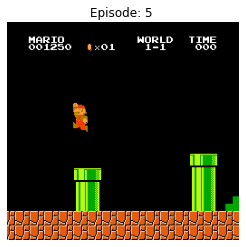

100%|█████████████████████████████████████████████| 5/5 [06:26<00:00, 77.30s/it]

=> Episode 5 Score = 154.00, Average Score = 157.60


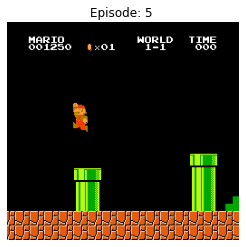

In [ ]:
# For Testing
#episodes_nb = 3
double_deepq_complex_x_test,double_deepq_complex_y_test  = run(training_mode=False, pretrained=False, double_dqn=True, num_episodes=episodes_nb_test, 
                                                               exploration_max = 0.05, movement = COMPLEX_MOVEMENT)

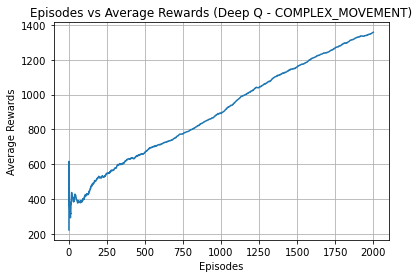

In [ ]:
plt.plot(double_deepq_complex_x, double_deepq_complex_y)
plt.title(f"Episodes vs Average Rewards (Deep Q - COMPLEX_MOVEMENT)")
plt.xlabel("Episodes") 
plt.ylabel("Average Rewards") 
plt.grid()
plt.show()

Comparison Deep Q vs Double Deep Q for Right Only

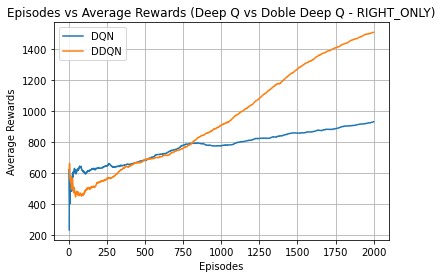

In [ ]:
plt.plot(deepq_right_x, deepq_right_y)
plt.plot(double_deepq_right_x, double_deepq_right_y)
plt.title(f"Episodes vs Average Rewards (Deep Q vs Doble Deep Q - RIGHT_ONLY)")
plt.xlabel("Episodes") 
plt.ylabel("Average Rewards") 
plt.grid()
plt.legend(["DQN","DDQN"])
plt.show()

Comparison Deep Q vs Double Deep Q for Simple Movement

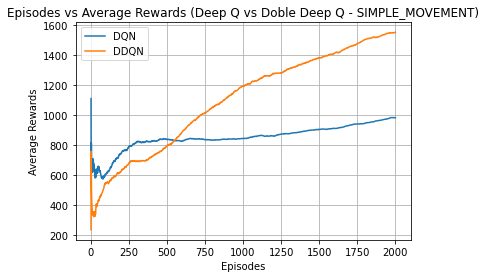

In [ ]:
plt.plot(deepq_simple_x, deepq_simple_y)
plt.plot(double_deepq_simple_x, double_deepq_simple_y)
plt.title(f"Episodes vs Average Rewards (Deep Q vs Doble Deep Q - SIMPLE_MOVEMENT)")
plt.xlabel("Episodes") 
plt.ylabel("Average Rewards") 
plt.grid()
plt.legend(["DQN","DDQN"])
plt.show()

Comparison Deep Q vs Double Deep Q for Complex Movement

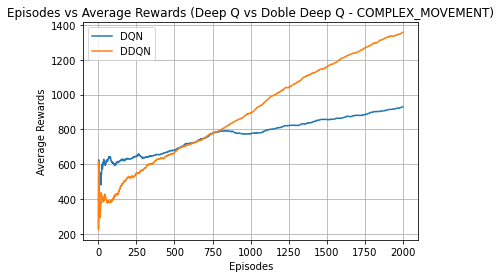

In [ ]:
plt.plot(deepq_right_x, deepq_right_y)
plt.plot(double_deepq_complex_x, double_deepq_complex_y)
plt.title(f"Episodes vs Average Rewards (Deep Q vs Doble Deep Q - COMPLEX_MOVEMENT)")
plt.xlabel("Episodes") 
plt.ylabel("Average Rewards") 
plt.grid()
plt.legend(["DQN","DDQN"])
plt.show()

Comparison Deep Q for Each Action


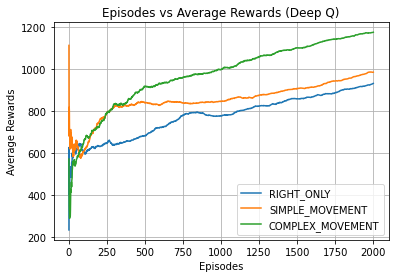

In [ ]:
plt.plot(deepq_right_x, deepq_right_y)
plt.plot(deepq_simple_x, deepq_simple_y)
plt.plot(deepq_complex_x, deepq_complex_y)
plt.title(f"Episodes vs Average Rewards (Deep Q)")
plt.xlabel("Episodes") 
plt.ylabel("Average Rewards") 
plt.grid()
plt.legend(["RIGHT_ONLY","SIMPLE_MOVEMENT","COMPLEX_MOVEMENT"])
plt.show()

Comparison Double Deep Q for Each Action

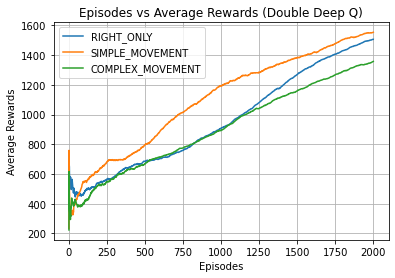

In [ ]:
plt.plot(double_deepq_right_x, double_deepq_right_y)
plt.plot(double_deepq_simple_x, double_deepq_simple_y)
plt.plot(double_deepq_complex_x, double_deepq_complex_y)
plt.title(f"Episodes vs Average Rewards (Double Deep Q)")
plt.xlabel("Episodes") 
plt.ylabel("Average Rewards") 
plt.legend(["RIGHT_ONLY","SIMPLE_MOVEMENT","COMPLEX_MOVEMENT"])
plt.grid()
plt.show()